In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import os
import lightgbm
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
import lightgbm as lgbm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from IPython.display import display

In [3]:
df = pd.read_csv("train_target_encoding_trials.csv")
test = pd.read_csv("test_target_encoding_trials.csv")
test = test.loc[test.target.isnull()]

In [4]:
df["ada"] = 1; test["ada"] = 1;
df["total_money_spent_std"] = df.groupby(["CST_NR"])["TXN_AMNT"].transform("std")
df["number_of_transactions_done_total"] = df.groupby(["CST_NR"])["ada"].transform("sum")

test["total_money_spent_std"] = test.groupby(["CST_NR"])["TXN_AMNT"].transform("std")
test["number_of_transactions_done_total"] = test.groupby(["CST_NR"])["ada"].transform("sum")
df.drop(["ada"], 1, inplace = True); test.drop(["ada"], 1, inplace = True)
#df.drop(["ID"], 1, inplace = True)

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_1032/3079020558.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(["ada"], 1, inplace = True); test.drop(["ada"], 1, inplace = True)


In [5]:
train = df[["CC_NR","TXN_ENTRY", "TXN_SOURCE", 'CITY', 'COUNTRY', 'MC_NAME', 'MC_ID', 'MCC_CODE']]

In [6]:
test_cat_df = test[["CC_NR","TXN_ENTRY", "TXN_SOURCE", 'CITY', 'COUNTRY', 'MC_NAME', 'MC_ID', 'MCC_CODE']]

In [7]:
df.drop(['CST_NR','DAY_OF_MONTH','DAY_OF_WEEK','TXN_AMNT',
       'country_count', 'customers_last_transaction', 'same_day_MC_ID_count',
       'same_day_MC_NAME_count'], 1, inplace = True)
test.drop(['CST_NR','DAY_OF_MONTH','DAY_OF_WEEK','TXN_AMNT',
       'country_count', 'customers_last_transaction', 'same_day_MC_ID_count',
       'same_day_MC_NAME_count'], 1, inplace = True)

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_1032/4173758465.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(['CST_NR','DAY_OF_MONTH','DAY_OF_WEEK','TXN_AMNT',
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_1032/4173758465.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test.drop(['CST_NR','DAY_OF_MONTH','DAY_OF_WEEK','TXN_AMNT',


In [8]:
import pandas as pd
from sklearn.metrics import roc_auc_score
cat_feat_to_encode = train.columns.tolist();  smoothing=0.15
train_y = df['target']
import category_encoders as ce
oof = pd.DataFrame([])
from sklearn.model_selection import StratifiedKFold
for tr_idx, oof_idx in StratifiedKFold(n_splits=5, random_state=2020, shuffle=True).split(train, train_y):
    print("***********")
    ce_target_encoder = ce.TargetEncoder(cols = cat_feat_to_encode, smoothing=smoothing)
    ce_target_encoder.fit(df.iloc[tr_idx, :], train_y.iloc[tr_idx])
    oof = oof.append(ce_target_encoder.transform(df.iloc[oof_idx, :]), ignore_index=False)
ce_target_encoder = ce.TargetEncoder(cols = cat_feat_to_encode, smoothing=smoothing)
ce_target_encoder.fit(df, train_y);  df = oof.sort_index();
test_transformed = ce_target_encoder.transform(test.drop(["ID"],1))

***********
***********
***********
***********
***********


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_1032/1139875804.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_transformed = ce_target_encoder.transform(test.drop(["ID"],1))


In [9]:
X = df.drop(["target"],1)
Y = df.target
y = Y

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_1032/3680766252.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target"],1)


In [ ]:
auc = 0
best = 0.9342
for i in df.columns:
    if i in ["target"]:
        continue
    else:
        X = df.drop(["target", i],1)
        Y = df.target
        y = Y
        skf = StratifiedKFold(n_splits=5, random_state = 5451, shuffle = True)
        scores = []
        tr_scores = []
        for train_index, test_index in skf.split(X, y):
            train_df = X.loc[train_index].reset_index(drop = True)
            valid_df = X.loc[test_index].reset_index(drop = True)
            train_y, valid_y = y[train_index], y[test_index]

            model = lgbm.LGBMClassifier(metric = "auc", objective = "binary", random_state = 42)
            model.fit(train_df,train_y)
            predictions = model.predict_proba(valid_df)[:,1]
            scores.append(roc_auc_score(valid_y, predictions))

            train_preds = model.predict_proba(train_df)[:,1]
            tr_scores.append(roc_auc_score(train_y, train_preds))
        print(f"without {i}, valid auc is > {np.mean(scores)}")
        if np.mean(scores) > best:
            print(f"{i} atiliyoooooooor.")
            df.drop([i], 1, inplace= True)
            best = np.mean(scores)
        else:
            continue

In [146]:
BEST_PARAMS

{'reg_alpha': 7.714425597409395,
 'reg_lambda': 5.663580655710298,
 'num_leaves': 5,
 'min_child_samples': 81,
 'max_depth': 19,
 'colsample_bytree': 0.15871987715954747,
 'cat_smooth': 16,
 'n_estimators': 10000,
 'learning_rate': 0.005,
 'metric': 'auc',
 'objective': 'binary',
 'cat_l2': 7,
 'min_data_per_group': 116}

In [122]:
X

,CC_NR,TXN_TIME,TXN_SOURCE,TXN_ENTRY,CITY,COUNTRY,MC_NAME,MC_ID,MCC_CODE,transaction_count_by_customer,...,money_change,same_day_MCC_CODE_count,same_day_city_count,same_day_countries_count,hours_txn_time,time,time_difference_between_tx,ID,total_money_spent_std,number_of_transactions_done_total
0,da64346c41c029ae5cea8cb0ef48ae855743ea175724ff...,852.0,O,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,24d9140879f351a50c068a0c87900ff3d63f8afbd1ea88...,b0be06b1742dbd1f6301211d3184b31e1341c73dfdfe02...,2ae12c28b5bebf8e0b332f8eeb226ebba9de07a958db9b...,1,...,0.000000,1,1,1,8,224.0,0.000000,NaN,NaN,1
1,cd176b2f45d8f188877cd7f8300e63804ae287c8eea085...,1345.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,34023684e38927b44a11078e921967483da8afb0452526...,d4c426cef1de3e40719a4da5a72effa9e6fccd3732587d...,f334ac9eaeb3276272f270538e1cd3b27d8c8b8d719374...,1,...,0.000000,1,1,1,13,37.0,0.000000,NaN,234.361803,11
2,cd176b2f45d8f188877cd7f8300e63804ae287c8eea085...,2010.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,34023684e38927b44a11078e921967483da8afb0452526...,d4c426cef1de3e40719a4da5a72effa9e6fccd3732587d...,f334ac9eaeb3276272f270538e1cd3b27d8c8b8d719374...,2,...,1.333333,1,1,1,20,188.0,4.081081,NaN,234.361803,11
3,cd176b2f45d8f188877cd7f8300e63804ae287c8eea085...,1132.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,34023684e38927b44a11078e921967483da8afb0452526...,d4c426cef1de3e40719a4da5a72effa9e6fccd3732587d...,f334ac9eaeb3276272f270538e1cd3b27d8c8b8d719374...,3,...,0.428571,1,1,1,11,203.0,0.079787,NaN,234.361803,11
4,cd176b2f45d8f188877cd7f8300e63804ae287c8eea085...,337.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,1110f8a082baa9ebf2acc528164113cd1cfa3facee4b4c...,e60354c25c84c774233d2c5290eb669b3f60604d71ac3e...,03a768696503f2039b82f8ab09c7c2c1d7c59fd5357ddd...,4,...,4.900000,1,1,1,3,267.0,0.315271,NaN,234.361803,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926467,8b6e2585f368dd6aef5c4e055edc662943668a1748c62b...,2025.0,V,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,bda8b20763a61f02555113e125b4771adc478b48ab8cf5...,18ea71c60d9b0fa64274e50b983f7b8515f7a0971395f4...,da80b742bce12c44fd6143ce788230b79a01a0247d4c22...,fed9060efb4531d7f506eae84390d22973749db155cef9...,03a768696503f2039b82f8ab09c7c2c1d7c59fd5357ddd...,38,...,0.001692,11,13,7,20,716.0,0.000000,101800.0,405.916434,39
926469,8b6e2585f368dd6aef5c4e055edc662943668a1748c62b...,1816.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,42c2c52dad2b3825054f9af7ef538d65feb0984a670bc2...,6698586fd381c3e5e6064c547820287553992e045a54f4...,2ae12c28b5bebf8e0b332f8eeb226ebba9de07a958db9b...,40,...,0.005516,2,1,1,18,738.0,0.016529,101779.0,405.916434,39
926470,8b6e2585f368dd6aef5c4e055edc662943668a1748c62b...,711.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,14f4ccbd9937c709ff69b4db15dc0fcec9592d7eeda595...,e60354c25c84c774233d2c5290eb669b3f60604d71ac3e...,03a768696503f2039b82f8ab09c7c2c1d7c59fd5357ddd...,41,...,0.066614,2,1,1,7,727.0,-0.014905,101791.0,405.916434,39
926471,8b6e2585f368dd6aef5c4e055edc662943668a1748c62b...,712.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,14f4ccbd9937c709ff69b4db15dc0fcec9592

In [17]:
test_transformed

,target,CC_NR,TXN_TIME,TXN_SOURCE,TXN_ENTRY,CITY,COUNTRY,MC_NAME,MC_ID,MCC_CODE,...,total_amount_per_customer,money_change,same_day_MCC_CODE_count,same_day_city_count,same_day_countries_count,hours_txn_time,time,time_difference_between_tx,total_money_spent_std,number_of_transactions_done_total
1,NaN,0.006064,916.0,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,...,2340.0,0.695652,1,1,1,9,561.0,1.504464,NaN,1
13,NaN,0.006064,1135.0,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,...,3170.0,0.006349,2,1,1,11,563.0,0.279545,244.001366,6
14,NaN,0.006064,1902.0,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,...,3260.0,0.028391,2,1,1,19,571.0,0.014210,244.001366,6
15,NaN,0.006064,828.0,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,...,3750.0,0.150307,1,1,1,8,584.0,0.022767,244.001366,6
16,NaN,0.006064,827.0,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,...,4240.0,0.130667,1,1,1,8,608.0,0.041096,244.001366,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933734,NaN,0.006064,52.0,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,...,530.0,0.039216,2,1,1,5,725.0,-0.002751,21.491970,7
933735,NaN,0.006064,1526.0,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,...,530.0,0.000000,2,1,1,15,735.0,0.013793,21.491970,7
933736,NaN,0.006064,1438.0,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,...,550.0,0.037736,2,1,1,14,734.0,-0.001361,21.491970,7
933737,NaN,0.006064,2223.0,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,0.006064,...,10.0,0.000000,2,2,1,22,718.0,0.000000,0.000000,2


In [13]:
df = df[['target',
         'transaction_count_by_customer',
          'number_of_transactions_done_total',
          'transaction_count_by_card',
          'total_amount_per_customer',
          'time_difference_between_tx',
          'hours_txn_time',
 'time',
 'total_money_spent_std',
 'CC_NR',
 'TXN_TIME',
 'TXN_SOURCE',
 'TXN_ENTRY',
 'CITY',
 'COUNTRY',
 'MC_NAME',
 'MC_ID',
 'MCC_CODE',
 'day_diff',
 'day_diff_std',
 'city_target_count',
 'mc_name_target_count',
 'mc_id_target_count',
 'mcc_code_target_count',
 'money_change',
 'same_day_MCC_CODE_count',
 'same_day_city_count',
         "ID",
 'same_day_countries_count']]

X = df.drop(["target"],1)
Y = df.target
y = Y

KeyError: "['ID'] not in index"

In [14]:
test = test_transf[['target',
         'transaction_count_by_customer',
          'number_of_transactions_done_total',
          'transaction_count_by_card',
          'total_amount_per_customer',
          'time_difference_between_tx',
          'hours_txn_time',
 'time',
 'total_money_spent_std',
 'CC_NR',
 'TXN_TIME',
 'TXN_SOURCE',
 'TXN_ENTRY',
 'CITY',
 'COUNTRY',
 'MC_NAME',
 'MC_ID',
 'MCC_CODE',
 'day_diff',
 'day_diff_std',
 'city_target_count',
 'mc_name_target_count',
 'mc_id_target_count',
 'mcc_code_target_count',
 'money_change',
 'same_day_MCC_CODE_count',
 'same_day_city_count',
         "ID",
 'same_day_countries_count']]

In [10]:
skf = StratifiedKFold(n_splits=5, random_state = 545, shuffle = True)
scores = []
tr_scores = []
for train_index, test_index in skf.split(X, y):
    X  = df.drop(["target"], 1).reset_index(drop=True)
    y = df.target.reset_index(drop=True)
    train_df = X.loc[train_index].reset_index(drop = True)
    valid_df = X.loc[test_index].reset_index(drop = True)
    train_y, valid_y = y[train_index], y[test_index]

    model = lgbm.LGBMClassifier(**{'reg_alpha': 7.714425597409395,
 'reg_lambda': 5.663580655710298,
 'num_leaves': 5,
 'min_child_samples': 81,
 'max_depth': 19,
 'colsample_bytree': 0.15871987715954747,
 'cat_smooth': 16,
 'learning_rate': 0.005,
 'metric': 'auc',
 'objective': 'binary',
 'cat_l2': 7,
 'min_data_per_group': 116})
    model.fit(train_df,train_y)
    predictions = model.predict_proba(valid_df)[:,1]
    scores.append(roc_auc_score(valid_y, predictions))

    train_preds = model.predict_proba(train_df)[:,1]
    tr_scores.append(roc_auc_score(train_y, train_preds))
print(f"valid auc is > {np.mean(scores)}")


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_1032/3691664042.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X  = df.drop(["target"], 1).reset_index(drop=True)
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_1032/3691664042.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X  = df.drop(["target"], 1).reset_index(drop=True)
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_1032/3691664042.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X  = df.drop(["target"], 1).reset_index(drop=True)
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_1032/3691664042.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X  = df.drop(["target"], 1).reset_index

valid auc is > 0.9669927299900319


In [11]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.15 with hours txn time included as an integer plus dropping mc_id_count and mc_name_count
#plus adding 2 additional features 

Train AUC score: 0.9678 Valid AUC score: 0.9670, STD: 0.0020


In [72]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.15 with hours txn time included as an integer plus dropping mc_id_count and mc_name_count
#plus adding 2 additional features 

Train AUC score: 0.9909 Valid AUC score: 0.9886, STD: 0.0018


In [64]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.15 with hours txn time included as an integer plus dropping mc_id_count and mc_name_count
#plus adding 2 additional features 

Train AUC score: 0.9853 Valid AUC score: 0.9841, STD: 0.0023


In [86]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.15 with hours txn time included as an integer plus dropping mc_id_count and mc_name_count

Train AUC score: 0.9686 Valid AUC score: 0.9342, STD: 0.0056


In [76]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.1 with hours txn time included as an integer plus dropping mc_id_count and mc_name_count

Train AUC score: 0.9712 Valid AUC score: 0.9359, STD: 0.0076


In [66]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.08 with hours txn time included as an integer plus dropping mc_id_count and mc_name_count

Train AUC score: 0.9735 Valid AUC score: 0.9438, STD: 0.0075


In [45]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.09 with hours txn time included as an integer

Train AUC score: 0.9705 Valid AUC score: 0.9355, STD: 0.0058


In [35]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.08 with hours txn time included as an integer

Train AUC score: 0.9754 Valid AUC score: 0.9431, STD: 0.0082


In [25]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.08 with hours txn time included

Train AUC score: 0.9726 Valid AUC score: 0.9369, STD: 0.0108


In [13]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.09

Train AUC score: 0.9738 Valid AUC score: 0.9414, STD: 0.0125


In [181]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.09

Train AUC score: 0.9682 Valid AUC score: 0.9436, STD: 0.0110


In [133]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.09

Train AUC score: 0.9694 Valid AUC score: 0.9383, STD: 0.0094


In [121]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.11

Train AUC score: 0.9717 Valid AUC score: 0.9342, STD: 0.0068


In [109]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.15

Train AUC score: 0.9700 Valid AUC score: 0.9323, STD: 0.0096


In [87]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
)) #0.1

Train AUC score: 0.9694 Valid AUC score: 0.9383, STD: 0.0094


In [139]:
def get_CV_target_encoding(data, y, encoder, cv = 5):
    skfTE = StratifiedKFold(n_splits=cv, random_state = 545167, shuffle = True)
    result = []
    for train_indexTE, test_indexTE in skfTE.split(data, y):
        encoder.fit(data.iloc[train_indexTE,:].reset_index(drop = True), y[train_indexTE])
        tmp =  encoder.transform(data.iloc[test_indexTE,:].reset_index(drop = True))
        tmp["index"] = test_indexTE
        result.append(tmp)
    result = pd.concat(result, ignore_index = True)
    result = result.sort_values('index').reset_index(drop = True).drop('index', axis = 1)
    return result

In [ ]:
scores = []
tr_scores = []
for train_index, test_index in skf.split(X, y):
    train_df = train.loc[train_index].reset_index(drop = True)
    valid_df = train.loc[test_index,col4train].reset_index(drop = True)
    train_y, valid_y = y[train_index], y[test_index]
    te = TargetEncodingSmoothing(
        columns_names= col4train,
        k = 3, f = 1.5
    )
    
    X_tr = get_CV_target_encoding(train_df, train_y, te, cv = 5)

    te.fit(train_df, train_y)
    X_val = te.transform(valid_df).values

    model = get_model()
    model.fit(X_tr,train_y)

    predictions = model.predict_proba(X_val)[:,1]
    scores.append(roc_auc_score(valid_y, predictions))

    train_preds = model.predict_proba(X_tr)[:,1]
    tr_scores.append(roc_auc_score(train_y, train_preds))

print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))

In [12]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import lightgbm as lgbm

In [30]:
# Train and score baseline model
baseline = lgbm.LGBMClassifier(objective = "binary", boosting_type = "gbdt", metric = "auc", is_unbalance = True,
                               learning_rate = 0.005,
                               random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="roc_auc")

baseline_score = baseline_score.mean()

print(f"Roc auc Score: {baseline_score:.4}")

Roc auc Score: 0.9838


In [13]:
X = df.drop(["target", "ID"],1)

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_1032/3889149587.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", "ID"],1)


KeyError: "['ID'] not found in axis"

  0%|          | 0/24 [00:00<?, ?it/s]

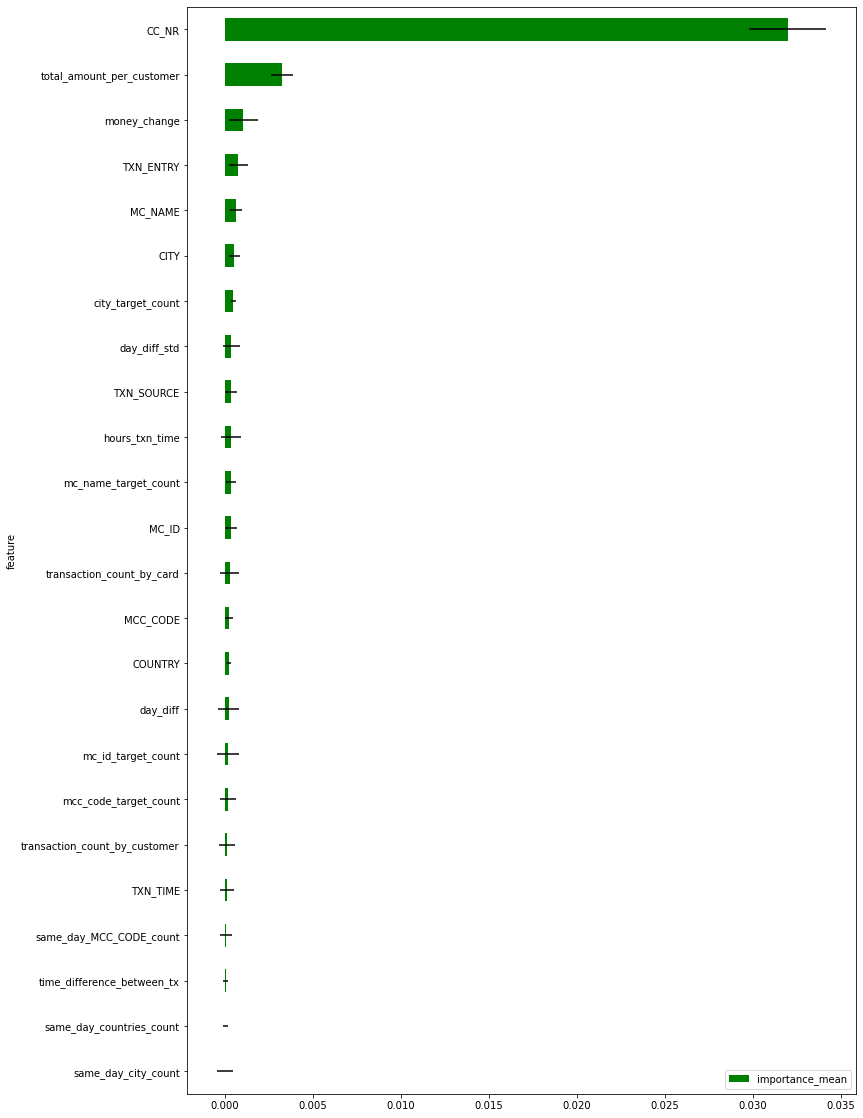

In [154]:
import pandas as pd
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
%matplotlib inline

# extract a sample of the data
sample_df = df.sample(frac=1, random_state=0)


# define the validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False)
target = "target"
# define the binary target and the features
dataset = Dataset(df=sample_df, target="target", features=[col for col in X.columns if col != target])

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))

In [14]:
df.drop(["time"], 1, inplace = True)

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_1032/2377591504.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(["time"], 1, inplace = True)


In [15]:
test_transformed.drop(["time"], 1, inplace = True)

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_1032/4268984161.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_transformed.drop(["time"], 1, inplace = True)


In [110]:
X = df.drop(["target","ID"],1)
y = df.target

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_7356/2855385522.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target","ID"],1)


In [112]:
!pip install catboost

In [29]:
import warnings
import sklearn
from catboost import CatBoostClassifier
import catboost as cb

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [30]:
import catboost as cb

In [31]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [16]:
import numpy as np
import optuna

import catboost as cb
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        )
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict_proba(valid_x)[:,1]
    accuracy = roc_auc_score(valid_y, preds)
    return accuracy


In [17]:
X.columns

Index(['CC_NR', 'TXN_TIME', 'TXN_SOURCE', 'TXN_ENTRY', 'CITY', 'COUNTRY',
       'MC_NAME', 'MC_ID', 'MCC_CODE', 'transaction_count_by_customer',
       'transaction_count_by_card', 'day_diff', 'day_diff_std',
       'city_target_count', 'mc_name_target_count', 'mc_id_target_count',
       'mcc_code_target_count', 'total_amount_per_customer', 'money_change',
       'same_day_MCC_CODE_count', 'same_day_city_count',
       'same_day_countries_count', 'hours_txn_time', 'time',
       'time_difference_between_tx', 'total_money_spent_std',
       'number_of_transactions_done_total'],
      dtype='object')

In [ ]:
# Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials= 10 , n_jobs = -1)

[I 2021-11-30 12:40:36,246] A new study created in memory with name: no-name-53183ba8-b840-43a0-ba84-c26bec872699



------ 5-fold evaluation -----
{'objective': 'Logloss', 'colsample_bylevel': 0.04667474162736982, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'verbose': 2, 'bagging_temperature': 8.97364550026198, 'n_estimators': 10000, 'learning_rate': 0.05}

------ 5-fold evaluation -----
------ 5-fold evaluation -----
{'objective': 'CrossEntropy', 'colsample_bylevel': 0.02734091544744218, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'verbose': 2, 'bagging_temperature': 4.940468206180862, 'n_estimators': 10000, 'learning_rate': 0.05}

------ 5-fold evaluation -----
{'objective': 'Logloss', 'colsample_bylevel': 0.08795393340903143, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'verbose': 2, 'bagging_temperature': 0.78942961167495, 'n_estimators': 10000, 'learning_rate': 0.05}

{'objective': 'CrossEntropy', 'colsample_bylevel': 0.074253702977361, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'verbose': 2,

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.5748944	test: 0.5751282	best: 0.5751282 (0)	total: 172ms	remaining: 28m 37s
0:	learn: 0.5733828	test: 0.5735767	best: 0.5735767 (0)	total: 1.22s	remaining: 3h 23m 38s
0:	learn: 0.5748944	test: 0.5751282	best: 0.5751282 (0)	total: 327ms	remaining: 54m 25s
0:	learn: 0.5748944	test: 0.5751282	best: 0.5751282 (0)	total: 472ms	remaining: 1h 18m 36s
0:	learn: 0.5699510	test: 0.5699886	best: 0.5699886 (0)	total: 1.5s	remaining: 4h 10m 31s
0:	learn: 0.5753108	test: 0.5753117	best: 0.5753117 (0)	total: 1.35s	remaining: 3h 44m 44s
0:	learn: 0.5753108	test: 0.5753117	best: 0.5753117 (0)	total: 1.21s	remaining: 3h 21m 23s
0:	learn: 0.5736286	test: 0.5738052	best: 0.5738052 (0)	total: 1.32s	remaining: 3h 39m 44s
200:	learn: 0.0203569	test: 0.0225691	best: 0.0225691 (200)	total: 39.1s	remaining: 31m 48s
200:	learn: 0.0173457	test: 0.0196487	best: 0.0196487 (200)	total: 43.5s	remaining: 35m 19s
200:	learn: 0.0129083	test: 0.0150438	best: 0.0150438 (200)	total: 47.1s	remaining: 38m 15s
400

Fold 0 | Eval AUC: 0.9852662141803936

----- FOLD 1 -----
0:	learn: 0.5750015	test: 0.5750421	best: 0.5750421 (0)	total: 286ms	remaining: 47m 42s
1000:	learn: 0.0127653	test: 0.0145735	best: 0.0145735 (1000)	total: 13m 27s	remaining: 2h 57s
4000:	learn: 0.0116083	test: 0.0128715	best: 0.0128711 (3978)	total: 13m 23s	remaining: 20m 4s
400:	learn: 0.0103383	test: 0.0130632	best: 0.0130622 (399)	total: 2m 1s	remaining: 48m 40s
200:	learn: 0.0157854	test: 0.0168181	best: 0.0168181 (200)	total: 52.4s	remaining: 42m 32s
4200:	learn: 0.0115868	test: 0.0128559	best: 0.0128556 (4199)	total: 14m 10s	remaining: 19m 34s
1000:	learn: 0.0131355	test: 0.0149136	best: 0.0149136 (1000)	total: 14m 26s	remaining: 2h 9m 53s
1200:	learn: 0.0135451	test: 0.0151211	best: 0.0151200 (1199)	total: 14m 28s	remaining: 1h 46m 5s
600:	learn: 0.0096344	test: 0.0131629	best: 0.0130094 (433)	total: 3m	remaining: 46m 56s
1200:	learn: 0.0128511	test: 0.0144778	best: 0.0144778 (1200)	total: 14m 46s	remaining: 1h 48m 16s


2200:	learn: 0.0128879	test: 0.0143622	best: 0.0143610 (2196)	total: 27m 56s	remaining: 1h 38m 59s
2200:	learn: 0.0119192	test: 0.0135090	best: 0.0135090 (2200)	total: 27m 57s	remaining: 1h 39m 4s
2000:	learn: 0.0118687	test: 0.0136010	best: 0.0136007 (1969)	total: 7m 37s	remaining: 30m 27s
2000:	learn: 0.0119402	test: 0.0137238	best: 0.0137238 (2000)	total: 28m 7s	remaining: 1h 52m 24s
1400:	learn: 0.0099822	test: 0.0132890	best: 0.0131609 (1159)	total: 6m 17s	remaining: 38m 34s
2000:	learn: 0.0115252	test: 0.0132341	best: 0.0132341 (2000)	total: 28m 20s	remaining: 1h 53m 18s
1400:	learn: 0.0081110	test: 0.0115730	best: 0.0115730 (1400)	total: 6m 32s	remaining: 40m 9s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.01316090153
bestIteration = 1159

Shrink model to first 1160 iterations.
Fold 2 | Eval AUC: 0.9839344266352726

----- FOLD 3 -----
0:	learn: 0.5749153	test: 0.5749672	best: 0.5749672 (0)	total: 320ms	remaining: 53m 17s
2200:	learn: 0.0118070	test: 0.013

[I 2021-11-30 13:11:18,333] Trial 7 finished with value: 0.9851699472683111 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.053501939611073634, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.9851699472683111.


Fold 4 | Eval AUC: 0.9885767420961263

------ 5-fold evaluation -----
{'objective': 'Logloss', 'colsample_bylevel': 0.01574035377710168, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05}

----- FOLD 0 -----
2400:	learn: 0.0117881	test: 0.0133628	best: 0.0133612 (2399)	total: 30m 41s	remaining: 1h 37m 8s
0:	learn: 0.5753108	test: 0.5753117	best: 0.5753117 (0)	total: 1.26s	remaining: 3h 30m 58s
2200:	learn: 0.0118369	test: 0.0136505	best: 0.0136505 (2200)	total: 30m 46s	remaining: 1h 49m 4s
2800:	learn: 0.0116758	test: 0.0135114	best: 0.0135019 (2688)	total: 10m 40s	remaining: 27m 26s
600:	learn: 0.0114961	test: 0.0127135	best: 0.0127135 (600)	total: 2m 42s	remaining: 42m 19s
2200:	learn: 0.0113458	test: 0.0130627	best: 0.0130614 (2187)	total: 31m 27s	remaining: 1h 51m 28s
3000:	learn: 0.0116267	test: 0.0135022	best: 0.0134995 (2992)	total: 11m 24s	remaining: 26m 36s
800:	learn: 0.0109921	test: 0.0123695	best: 0.

3400:	learn: 0.0111527	test: 0.0130048	best: 0.0130048 (3400)	total: 47m 24s	remaining: 1h 31m 58s
800:	learn: 0.0129232	test: 0.0124679	best: 0.0124635 (798)	total: 3m 17s	remaining: 37m 49s
1200:	learn: 0.0102553	test: 0.0121568	best: 0.0121487 (1119)	total: 5m 17s	remaining: 38m 48s
1200:	learn: 0.0130509	test: 0.0147121	best: 0.0147121 (1200)	total: 17m 10s	remaining: 2h 5m 49s
3400:	learn: 0.0100027	test: 0.0119300	best: 0.0119269 (3316)	total: 48m 25s	remaining: 1h 33m 58s
1000:	learn: 0.0126712	test: 0.0122540	best: 0.0122540 (1000)	total: 4m 6s	remaining: 36m 53s
1400:	learn: 0.0099721	test: 0.0120083	best: 0.0120047 (1397)	total: 6m 9s	remaining: 37m 45s
3800:	learn: 0.0124840	test: 0.0138641	best: 0.0138630 (3756)	total: 48m 54s	remaining: 1h 19m 46s
1200:	learn: 0.0125226	test: 0.0121587	best: 0.0121573 (1195)	total: 4m 54s	remaining: 35m 59s
1600:	learn: 0.0097601	test: 0.0119411	best: 0.0119411 (1600)	total: 7m	remaining: 36m 43s
3800:	learn: 0.0112002	test: 0.0127420	best

[I 2021-11-30 13:39:17,287] Trial 6 finished with value: 0.985501003591202 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.037332103540442765, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3849114964120968}. Best is trial 6 with value: 0.985501003591202.


Fold 4 | Eval AUC: 0.9874535167709049

------ 5-fold evaluation -----
{'objective': 'CrossEntropy', 'colsample_bylevel': 0.01305141390493472, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'verbose': 2, 'subsample': 0.9345032342058591, 'n_estimators': 10000, 'learning_rate': 0.05}

----- FOLD 0 -----
0:	learn: 0.5753136	test: 0.5753142	best: 0.5753142 (0)	total: 1.46s	remaining: 4h 2m 56s
1600:	learn: 0.0121605	test: 0.0129847	best: 0.0129843 (1597)	total: 6m 27s	remaining: 33m 50s
4000:	learn: 0.0103998	test: 0.0122173	best: 0.0122134 (3958)	total: 59m 4s	remaining: 1h 28m 35s
4600:	learn: 0.0123484	test: 0.0136995	best: 0.0136985 (4590)	total: 59m 42s	remaining: 1h 10m 3s
1800:	learn: 0.0120860	test: 0.0129434	best: 0.0129371 (1752)	total: 7m 14s	remaining: 32m 56s
4200:	learn: 0.0097641	test: 0.0118801	best: 0.0118668 (4041)	total: 1h 12s	remaining: 1h 23m 6s
2000:	learn: 0.0120133	test: 0.0129180	best: 0.0129155 (1995)	total: 8m 1s	remaining: 32m 4s
4600:	le

[I 2021-11-30 13:47:44,943] Trial 3 finished with value: 0.982377489288915 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08795393340903143, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.78942961167495}. Best is trial 6 with value: 0.985501003591202.


Fold 4 | Eval AUC: 0.9839324527554488
Fold 1 | Eval AUC: 0.9806899042125221

----- FOLD 2 -----
0:	learn: 0.5673452	test: 0.5680469	best: 0.5680469 (0)	total: 887ms	remaining: 2h 27m 49s
8600:	learn: 0.0119584	test: 0.0132508	best: 0.0132500 (8564)	total: 1h 40m 44s	remaining: 16m 23s
3400:	learn: 0.0119388	test: 0.0135643	best: 0.0135613 (3343)	total: 42m 8s	remaining: 1h 21m 46s
6200:	learn: 0.0106001	test: 0.0125333	best: 0.0125325 (6145)	total: 1h 10m 22s	remaining: 43m 6s
8400:	learn: 0.0102753	test: 0.0121418	best: 0.0121398 (8259)	total: 1h 41m 50s	remaining: 19m 23s
7600:	learn: 0.0100170	test: 0.0122908	best: 0.0122822 (7444)	total: 1h 42m 22s	remaining: 32m 18s
7000:	learn: 0.0096262	test: 0.0119250	best: 0.0119197 (6984)	total: 1h 42m 27s	remaining: 43m 53s
8800:	learn: 0.0119485	test: 0.0132447	best: 0.0132447 (8800)	total: 1h 42m 37s	remaining: 13m 58s
200:	learn: 0.0147186	test: 0.0155166	best: 0.0155166 (200)	total: 2m 50s	remaining: 2h 18m 50s
6400:	learn: 0.0105535	tes

5400:	learn: 0.0112851	test: 0.0130118	best: 0.0130094 (5384)	total: 1h 4m 44s	remaining: 55m 7s
600:	learn: 0.0146869	test: 0.0152703	best: 0.0152675 (591)	total: 6m 18s	remaining: 1h 38m 36s
1000:	learn: 0.0139654	test: 0.0148239	best: 0.0148230 (998)	total: 9m 56s	remaining: 1h 29m 23s
1600:	learn: 0.0121350	test: 0.0134565	best: 0.0134565 (1599)	total: 20m 36s	remaining: 1h 48m 8s
8800:	learn: 0.0100715	test: 0.0121747	best: 0.0121747 (8800)	total: 1h 34m 38s	remaining: 12m 53s
400:	learn: 0.0127443	test: 0.0122958	best: 0.0122945 (399)	total: 5m 21s	remaining: 2h 8m 9s
5600:	learn: 0.0112582	test: 0.0129837	best: 0.0129821 (5584)	total: 1h 6m 51s	remaining: 52m 30s
600:	learn: 0.0133433	test: 0.0140833	best: 0.0140833 (600)	total: 8m 37s	remaining: 2h 14m 57s
800:	learn: 0.0141563	test: 0.0149300	best: 0.0149300 (799)	total: 8m 15s	remaining: 1h 34m 48s
1200:	learn: 0.0135424	test: 0.0145036	best: 0.0145027 (1186)	total: 11m 50s	remaining: 1h 26m 45s
9000:	learn: 0.0100386	test: 0

Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.0114061158
bestIteration = 1886

Shrink model to first 1887 iterations.
Fold 3 | Eval AUC: 0.9887795665650536

----- FOLD 4 -----
3200:	learn: 0.0117075	test: 0.0133066	best: 0.0133058 (3189)	total: 31m 8s	remaining: 1h 6m 8s
0:	learn: 0.5670283	test: 0.5668010	best: 0.5668010 (0)	total: 774ms	remaining: 2h 8m 59s
1400:	learn: 0.0126371	test: 0.0140851	best: 0.0140834 (1392)	total: 13m 39s	remaining: 1h 23m 49s
2400:	learn: 0.0110527	test: 0.0128152	best: 0.0128143 (2395)	total: 32m 41s	remaining: 1h 43m 28s
3800:	learn: 0.0123991	test: 0.0139088	best: 0.0139088 (3800)	total: 36m 8s	remaining: 58m 56s
3800:	learn: 0.0109146	test: 0.0129221	best: 0.0129152 (3791)	total: 46m 24s	remaining: 1h 15m 41s
8000:	learn: 0.0107960	test: 0.0126659	best: 0.0126659 (8000)	total: 1h 31m 49s	remaining: 22m 56s
3400:	learn: 0.0116478	test: 0.0132834	best: 0.0132819 (3386)	total: 32m 58s	remaining: 1h 3m 59s
200:	learn: 0.0145581	test

5800:	learn: 0.0108983	test: 0.0129692	best: 0.0129621 (5589)	total: 58m 21s	remaining: 42m 14s
1200:	learn: 0.0127064	test: 0.0137361	best: 0.0137359 (1196)	total: 17m 29s	remaining: 2h 8m 5s
200:	learn: 0.0270615	test: 0.0274892	best: 0.0274892 (200)	total: 2m 43s	remaining: 2h 12m 54s
4200:	learn: 0.0102959	test: 0.0125569	best: 0.0125418 (4106)	total: 59m 18s	remaining: 1h 21m 52s
6400:	learn: 0.0120170	test: 0.0137076	best: 0.0137072 (6394)	total: 1h 2m 46s	remaining: 35m 17s
4200:	learn: 0.0110317	test: 0.0132294	best: 0.0132241 (4153)	total: 41m 46s	remaining: 57m 39s
2000:	learn: 0.0106297	test: 0.0119664	best: 0.0119299 (1907)	total: 28m 56s	remaining: 1h 55m 41s
6000:	learn: 0.0108435	test: 0.0129308	best: 0.0129300 (5993)	total: 1h 34s	remaining: 40m 22s
1400:	learn: 0.0124344	test: 0.0137400	best: 0.0136893 (1279)	total: 20m 20s	remaining: 2h 4m 49s
6600:	learn: 0.0119999	test: 0.0137029	best: 0.0137022 (6562)	total: 1h 4m 55s	remaining: 33m 25s
400:	learn: 0.0218598	test: 

[I 2021-11-30 15:41:48,169] Trial 1 finished with value: 0.9849008176943725 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.074253702977361, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.48038722544850243}. Best is trial 6 with value: 0.985501003591202.


Fold 4 | Eval AUC: 0.9860356555349306
Fold 1 | Eval AUC: 0.9763558254616194

----- FOLD 2 -----
0:	learn: 0.5523740	test: 0.5526015	best: 0.5526015 (0)	total: 659ms	remaining: 1h 49m 50s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.01355715491
bestIteration = 1619

Shrink model to first 1620 iterations.
Fold 2 | Eval AUC: 0.978695007506494

----- FOLD 3 -----
0:	learn: 0.5655641	test: 0.5655091	best: 0.5655091 (0)	total: 727ms	remaining: 2h 1m 12s
400:	learn: 0.0141776	test: 0.0143808	best: 0.0143803 (394)	total: 5m 23s	remaining: 2h 9m 3s
1000:	learn: 0.0153352	test: 0.0162615	best: 0.0162615 (1000)	total: 12m	remaining: 1h 47m 57s
7400:	learn: 0.0119285	test: 0.0136577	best: 0.0136573 (7398)	total: 1h 11m 51s	remaining: 25m 14s
6800:	learn: 0.0106662	test: 0.0128570	best: 0.0128533 (6779)	total: 1h 8m 45s	remaining: 32m 20s
200:	learn: 0.0268330	test: 0.0266320	best: 0.0266320 (200)	total: 1m 43s	remaining: 1h 23m 50s
200:	learn: 0.0199270	test: 0.0206776	best

Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.01383631839
bestIteration = 2254

Shrink model to first 2255 iterations.
Fold 2 | Eval AUC: 0.981552178008313

----- FOLD 3 -----
0:	learn: 0.5512356	test: 0.5510392	best: 0.5510392 (0)	total: 718ms	remaining: 1h 59m 35s
1600:	learn: 0.0131494	test: 0.0142297	best: 0.0142156 (1582)	total: 14m 59s	remaining: 1h 18m 40s
4000:	learn: 0.0114863	test: 0.0134018	best: 0.0133981 (3907)	total: 34m 48s	remaining: 52m 11s
2400:	learn: 0.0122864	test: 0.0121792	best: 0.0121775 (2398)	total: 23m 46s	remaining: 1h 15m 15s
2000:	learn: 0.0120294	test: 0.0136552	best: 0.0136324 (1959)	total: 19m 10s	remaining: 1h 16m 39s
800:	learn: 0.0130300	test: 0.0130427	best: 0.0130424 (799)	total: 9m 14s	remaining: 1h 46m 10s
200:	learn: 0.0233138	test: 0.0242447	best: 0.0242447 (200)	total: 1m 58s	remaining: 1h 36m
1800:	learn: 0.0129419	test: 0.0141025	best: 0.0141021 (1797)	total: 16m 49s	remaining: 1h 16m 37s
4200:	learn: 0.0114285	test: 0

2600:	learn: 0.0117777	test: 0.0121407	best: 0.0121407 (2600)	total: 23m 20s	remaining: 1h 6m 24s
2800:	learn: 0.0112298	test: 0.0118525	best: 0.0118525 (2800)	total: 31m 27s	remaining: 1h 20m 52s
800:	learn: 0.0149325	test: 0.0146973	best: 0.0146902 (776)	total: 7m 26s	remaining: 1h 25m 27s
7400:	learn: 0.0106960	test: 0.0130105	best: 0.0130086 (7357)	total: 58m 36s	remaining: 20m 34s
2800:	learn: 0.0117253	test: 0.0121330	best: 0.0121227 (2663)	total: 25m 1s	remaining: 1h 4m 18s
1200:	learn: 0.0129637	test: 0.0135759	best: 0.0135759 (1200)	total: 12m 4s	remaining: 1h 28m 26s
1600:	learn: 0.0127734	test: 0.0125758	best: 0.0125729 (1594)	total: 15m 16s	remaining: 1h 20m 6s
7600:	learn: 0.0106346	test: 0.0129816	best: 0.0129816 (7600)	total: 59m 54s	remaining: 18m 54s
1000:	learn: 0.0144530	test: 0.0141425	best: 0.0141423 (998)	total: 9m 9s	remaining: 1h 22m 15s
3000:	learn: 0.0111609	test: 0.0118232	best: 0.0118222 (2986)	total: 33m 31s	remaining: 1h 18m 10s
3000:	learn: 0.0116228	test

3200:	learn: 0.0128980	test: 0.0124924	best: 0.0124889 (3177)	total: 28m 16s	remaining: 1h 4s
1400:	learn: 0.0118565	test: 0.0126128	best: 0.0126128 (1400)	total: 15m 7s	remaining: 1h 32m 50s
3600:	learn: 0.0114686	test: 0.0126666	best: 0.0126666 (3600)	total: 32m 59s	remaining: 58m 37s
1400:	learn: 0.0148730	test: 0.0159993	best: 0.0159989 (1395)	total: 12m 24s	remaining: 1h 16m 11s
600:	learn: 0.0145668	test: 0.0146477	best: 0.0146467 (596)	total: 5m 53s	remaining: 1h 32m 8s
1000:	learn: 0.0145090	test: 0.0151829	best: 0.0151821 (993)	total: 9m 3s	remaining: 1h 21m 23s
3400:	learn: 0.0128344	test: 0.0124390	best: 0.0124382 (3392)	total: 30m 1s	remaining: 58m 15s
3800:	learn: 0.0113498	test: 0.0125902	best: 0.0125851 (3705)	total: 34m 28s	remaining: 56m 13s
1600:	learn: 0.0116613	test: 0.0125079	best: 0.0125079 (1600)	total: 17m 16s	remaining: 1h 30m 37s
1600:	learn: 0.0144848	test: 0.0157517	best: 0.0157515 (1598)	total: 14m 8s	remaining: 1h 14m 10s
800:	learn: 0.0138721	test: 0.0140

[I 2021-11-30 17:03:13,139] Trial 4 finished with value: 0.9828075590744291 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.024715767493711502, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.760280152057683}. Best is trial 6 with value: 0.985501003591202.


Fold 4 | Eval AUC: 0.9832424540691114
Fold 2 | Eval AUC: 0.9783924582237512

----- FOLD 3 -----
0:	learn: 0.5743214	test: 0.5742445	best: 0.5742445 (0)	total: 520ms	remaining: 1h 26m 38s
2200:	learn: 0.0121545	test: 0.0132563	best: 0.0132563 (2199)	total: 19m 7s	remaining: 1h 7m 46s
1800:	learn: 0.0123350	test: 0.0127830	best: 0.0127826 (1797)	total: 16m 35s	remaining: 1h 15m 33s
2600:	learn: 0.0109549	test: 0.0120418	best: 0.0120418 (2600)	total: 27m 2s	remaining: 1h 16m 56s
4800:	learn: 0.0125405	test: 0.0123041	best: 0.0122953 (4708)	total: 41m 8s	remaining: 44m 33s
2400:	learn: 0.0119973	test: 0.0131312	best: 0.0131312 (2400)	total: 20m 28s	remaining: 1h 4m 47s
200:	learn: 0.0304882	test: 0.0314282	best: 0.0314282 (200)	total: 1m 37s	remaining: 1h 18m 53s
2000:	learn: 0.0121438	test: 0.0126887	best: 0.0126887 (1996)	total: 18m 24s	remaining: 1h 13m 36s


In [19]:
BEST_PARAMS = {'objective': 'CrossEntropy', 'colsample_bylevel': 0.037332103540442765, 
               'depth': 8, "learning_rate" : 0.005, "n_estimators": 10000,
               'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3849114964120968}

In [137]:
BEST_PARAMS.update(study.BEST_PARAMS)

{'n_estimators': 10000, 'learning_rate': 0.05}

In [20]:
def create(hyperparams):
    """Create LGBM Classifier for a given set of hyper-parameters."""
    model = CatBoostClassifier(**hyperparams)
    return model

def fit(model, X, y):
    """Simple training of a given model."""
    model.fit(X, y)
    return model

def fit_with_stop(model, X, y, X_val, y_val, esr):
    """Advanced training with early stopping."""
    model.fit(X, y,
              eval_set=(X_val, y_val),
              early_stopping_rounds=esr, 
              verbose=200)
    return model

def evaluate(model, X, y):
    """Compute AUC for a given model."""
    yp = model.predict_proba(X)[:, 1]
    auc_score = roc_auc_score(y, yp)
    return auc_score

def kfold_evaluation(X, y, k, hyperparams, esr=300):
    """Run a KFlod evaluation."""
    scores = []
    
    print(f"\n------ {k}-fold evaluation -----")
    print(hyperparams)
    
    kf = StratifiedKFold(k)
    for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        print(f"\n----- FOLD {i} -----")
        
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[test_idx]
        y_val = y.iloc[test_idx]
        
        model = create(hyperparams)
        model = fit_with_stop(model, X_train, y_train, X_val, y_val, esr)
        train_score = evaluate(model, X_train, y_train)
        val_score = evaluate(model, X_val, y_val)
        scores.append((train_score, val_score))
        
        print(f"Fold {i} | Eval AUC: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns=['train score', 'validation score'])
    
    return scores

def kfold_prediction(X, y, X_test, k, hyperparams, esr=300):
    """Make predictions with a bagged model based on KFold."""
    yp = np.zeros(len(X_test))
    
    print(f"\n------ {k}-fold evaluation -----")
    print(hyperparams)
    
    kf = StratifiedKFold(k)
    for i, (train_idx, test_idx) in enumerate(kf.split(X,y)):
        print(f"\n----- FOLD {i} -----")
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[test_idx]
        y_val = y.iloc[test_idx]
        
        model = create(hyperparams)
        model = fit_with_stop(model, X_train, y_train, X_val, y_val, esr)
        yp += model.predict_proba(X_test)[:, 1] / k
    
    return yp

In [40]:
# Constant
K = 5
#X_TEST =  test_df.drop(["target", "CST_NR", "CC_NR"], 1)
BEST_PARAMS = {'n_estimators': 10000, 'learning_rate': 0.05
}

In [41]:
# Objective function
def objective(trial):
    # Search spaces
    hyperparams = {
         "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "verbose" :2,
    }

    if hyperparams["bootstrap_type"] == "Bayesian":
        hyperparams["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif hyperparams["bootstrap_type"] == "Bernoulli":
        hyperparams["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    # Add BEST_PARAMS
    hyperparams.update(BEST_PARAMS)
    
    # Evaluation
    scores = kfold_evaluation(X, Y, K, hyperparams, 300)
    
    return scores['validation score'].mean()

In [21]:
Y = y

In [22]:
import gc
gc.collect()

0

In [46]:
# Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout= 3600*1.2, n_jobs = -1)

[I 2021-11-29 22:55:05,940] A new study created in memory with name: no-name-0d0132a7-b592-4efd-b649-e7bd48661e49
C:\Users\analyticahouse\Anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(



------ 5-fold evaluation -----
{'reg_alpha': 5.996693422692015, 'reg_lambda': 7.2293137398549066, 'num_leaves': 280, 'min_child_samples': 26, 'max_depth': 37, 'colsample_bytree': 0.28552627196473807, 'cat_smooth': 93, 'cat_l2': 6, 'min_data_per_group': 181, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

------ 5-fold evaluation -----
------ 5-fold evaluation -----
{'reg_alpha': 5.330596954185585, 'reg_lambda': 7.256907329063694, 'num_leaves': 531, 'min_child_samples': 57, 'max_depth': 45, 'colsample_bytree': 0.2028511334230237, 'cat_smooth': 91, 'cat_l2': 15, 'min_data_per_group': 184, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

{'reg_alpha': 9.873441341205881, 'reg_lambda': 8.413091144185492, 'num_leaves': 591, 'min_child_samples': 73, 'max_depth': 19, 'colsample_bytree': 0.3809739925148258, 'cat_smooth': 31, 'cat_l2': 8, 'min_data_per_group': 188, 'is_unbalance': True, 'verbo

C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976602
Fold 0 | Eval AUC: 0.9783967682216348

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.948392
[200]	valid_0's auc: 0.995624
[200]	valid_0's auc: 0.979797
[400]	valid_0's auc: 0.995641
[200]	valid_0's auc: 0.962315
[200]	valid_0's auc: 0.97588
[200]	valid_0's auc: 0.959137
[400]	valid_0's auc: 0.968118
[200]	valid_0's auc: 0.972967
[600]	valid_0's auc: 0.995667
[400]	valid_0's auc: 0.978956
Fold 1 | Eval AUC: 0.9957179151738835

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.937429
Fold 0 | Eval AUC: 0.9798234738391242

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.972083
[400]	valid_0's auc: 0.971522
[200]	valid_0's auc: 0.992
[400]	valid_0's auc: 0.975
[400]	valid_0's auc: 0.964611
[800]	valid_0's auc: 0.972878
Fold 2 | Eval AUC: 0.9923441301839482

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9761601392852169

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.97195
[600]	valid_0's auc: 0.974786
[600]	valid_0's auc: 0.965051
[400]	valid_0's auc: 0.961925
[1000]	valid_0's auc: 0.973327
Fold 0 | Eval AUC: 0.9731576567348521

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.990589
[800]	valid_0's auc: 0.975633
[1200]	valid_0's auc: 0.973612
[800]	valid_0's auc: 0.965099
[1400]	valid_0's auc: 0.973672
[1000]	valid_0's auc: 0.965295
Fold 0 | Eval AUC: 0.9736716204757443

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9909080854060318

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.967987
[1200]	valid_0's auc: 0.965295
[1000]	valid_0's auc: 0.976039
Fold 0 | Eval AUC: 0.9652954622076471

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.990784
[1200]	valid_0's auc: 0.97634
[800]	valid_0's auc: 0.969738
[200]	valid_0's auc: 0.995271
[1400]	valid_0's auc: 0.976365
[1000]	valid_0's auc: 0.970519
[400]	valid_0's auc: 0.990486
[1200]	valid_0's auc: 0.970998
[1600]	valid_0's auc: 0.97624
Fold 0 | Eval AUC: 0.9763923494217869

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-29 23:01:26,404] Trial 6 finished with value: 0.9896797365551772 and parameters: {'reg_alpha': 9.743761632257234, 'reg_lambda': 4.645037439928407, 'num_leaves': 71, 'min_child_samples': 78, 'max_depth': 7, 'colsample_bytree': 0.49348622775201756, 'cat_smooth': 13, 'c

Fold 4 | Eval AUC: 0.9910317837903875

------ 5-fold evaluation -----
{'reg_alpha': 2.092157889660444, 'reg_lambda': 4.286470762664355, 'num_leaves': 529, 'min_child_samples': 54, 'max_depth': 28, 'colsample_bytree': 0.25047085144015124, 'cat_smooth': 14, 'cat_l2': 5, 'min_data_per_group': 81, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.992819
[1400]	valid_0's auc: 0.971046
[1600]	valid_0's auc: 0.971046
Fold 0 | Eval AUC: 0.9710456016057805

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.995142
[200]	valid_0's auc: 0.994989
Fold 1 | Eval AUC: 0.9953046837235137

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.993494
[400]	valid_0's auc: 0.994302
[200]	valid_0's auc: 0.995393
[400]	valid_0's auc: 0.99476
Fold 1 | Eval AUC: 0.9951961118002604

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.994548
[200]	valid_0's auc: 0.988346
[400]	valid_0's auc: 0.994235
[200]	valid_0's auc: 0.957771
[800]	valid_0's auc: 0.994524
[200]	valid_0's auc: 0.989916
[600]	valid_0's auc: 0.99437
[400]	valid_0's auc: 0.995285
[1000]	valid_0's auc: 0.994566
[400]	valid_0's auc: 0.991104
[200]	valid_0's auc: 0.991801
[800]	valid_0's auc: 0.994369
[400]	valid_0's auc: 0.965053
Fold 1 | Eval AUC: 0.9954131158453604

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9904994692213815

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1200]	valid_0's auc: 0.994531
Fold 1 | Eval AUC: 0.9944042873865256

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9945849000500596

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.992275
[600]	valid_0's auc: 0.966119
[200]	valid_0's auc: 0.991005
[400]	valid_0's auc: 0.993861
[800]	valid_0's auc: 0.96612
[800]	valid_0's auc: 0.992741
[200]	valid_0's auc: 0.988596
Fold 0 | Eval AUC: 0.9662762873693194

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.992955
[600]	valid_0's auc: 0.994374
[400]	valid_0's auc: 0.990589
[1200]	valid_0's auc: 0.993146
[200]	valid_0's auc: 0.991441
Fold 2 | Eval AUC: 0.9911392247633302

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.994386
[200]	valid_0's auc: 0.989848
[1400]	valid_0's auc: 0.993191
[400]	valid_0's auc: 0.991009
[1000]	valid_0's auc: 0.99446
[1600]	valid_0's auc: 0.993193
[200]	valid_0's auc: 0.992032
Fold 3 | Eval AUC: 0.9917659623341781

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1800]	valid_0's auc: 0.993226
[1200]	valid_0's auc: 0.994479
[1400]	valid_0's auc: 0.994487
Fold 1 | Eval AUC: 0.9932298695384026

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.991468
[1600]	valid_0's auc: 0.994487
Fold 1 | Eval AUC: 0.9944873079142114

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.991282
[800]	valid_0's auc: 0.991432
[400]	valid_0's auc: 0.991556
[600]	valid_0's auc: 0.991408
Fold 2 | Eval AUC: 0.9921323086778226

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.991539
[200]	valid_0's auc: 0.988317
[200]	valid_0's auc: 0.992419
[800]	valid_0's auc: 0.991424
[200]	valid_0's auc: 0.99346
[1200]	valid_0's auc: 0.991548
[1000]	valid_0's auc: 0.991443
[1400]	valid_0's auc: 0.991587
Fold 2 | Eval AUC: 0.9914565666847407

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1600]	valid_0's auc: 0.991587
Fold 2 | Eval AUC: 0.9915873540681837

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.985233
[400]	valid_0's auc: 0.987124
Fold 3 | Eval AUC: 0.9889054620646816

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-29 23:11:02,798] Trial 2 finished with value: 0.9902005943870085 and parameters: {'reg_alpha': 9.873441341205881, 'reg_lambda': 8.413091144185492, 'num_leaves': 591, 'min_child_samples': 73, 'max_depth': 19, 'colsample_bytree': 0.3809739925148258, 'cat_smooth': 31, '

Fold 4 | Eval AUC: 0.9936093828168453

------ 5-fold evaluation -----
{'reg_alpha': 9.153900208181195, 'reg_lambda': 9.419175547201807, 'num_leaves': 278, 'min_child_samples': 12, 'max_depth': 34, 'colsample_bytree': 0.16411512281121593, 'cat_smooth': 84, 'cat_l2': 18, 'min_data_per_group': 169, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.99349
[200]	valid_0's auc: 0.986384
[200]	valid_0's auc: 0.984699
[400]	valid_0's auc: 0.988609
[600]	valid_0's auc: 0.993662
[200]	valid_0's auc: 0.985878
[600]	valid_0's auc: 0.989737
[200]	valid_0's auc: 0.970401
[200]	valid_0's auc: 0.987268
[800]	valid_0's auc: 0.993688
[400]	valid_0's auc: 0.990323
[400]	valid_0's auc: 0.986978
[800]	valid_0's auc: 0.990136
[1000]	valid_0's auc: 0.993689
[200]	valid_0's auc: 0.988847
[400]	valid_0's auc: 0.973069
[600]	valid_0's auc: 0.991095
Fold 3 | Eval AUC: 0.9886334761757072

----- FOLD 4 -----
[400]	valid_0's auc: 0.987471


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9937247772721627

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.990405
[600]	valid_0's auc: 0.98755
[600]	valid_0's auc: 0.973674
[1200]	valid_0's auc: 0.990604
[800]	valid_0's auc: 0.991123


[I 2021-11-29 23:13:37,068] Trial 4 finished with value: 0.9886158219228534 and parameters: {'reg_alpha': 4.028571000818152, 'reg_lambda': 4.384813383616477, 'num_leaves': 635, 'min_child_samples': 59, 'max_depth': 44, 'colsample_bytree': 0.4810925822063067, 'cat_smooth': 27, 'cat_l2': 1, 'min_data_per_group': 158}. Best is trial 2 with value: 0.9902005943870085.


Fold 4 | Eval AUC: 0.9916781717007778

------ 5-fold evaluation -----
{'reg_alpha': 0.2878484091082961, 'reg_lambda': 5.913531936439045, 'num_leaves': 245, 'min_child_samples': 84, 'max_depth': 41, 'colsample_bytree': 0.22522649508946993, 'cat_smooth': 73, 'cat_l2': 5, 'min_data_per_group': 124, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.987818
[1400]	valid_0's auc: 0.990615
[800]	valid_0's auc: 0.98764
[800]	valid_0's auc: 0.973775
[1000]	valid_0's auc: 0.991312
[1600]	valid_0's auc: 0.990665
[800]	valid_0's auc: 0.987945
[1000]	valid_0's auc: 0.973713
[1200]	valid_0's auc: 0.991425
[1800]	valid_0's auc: 0.990765
[1000]	valid_0's auc: 0.987695
[1400]	valid_0's auc: 0.991433
[1000]	valid_0's auc: 0.987991
[1200]	valid_0's auc: 0.973879
[2000]	valid_0's auc: 0.990816
Fold 2 | Eval AUC: 0.9914332756333339

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1200]	valid_0's auc: 0.987965
[1400]	valid_0's auc: 0.973921
[2200]	valid_0's auc: 0.990832
Fold 3 | Eval AUC: 0.987988185177745

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[2400]	valid_0's auc: 0.990837
[1600]	valid_0's auc: 0.973929
[1200]	valid_0's auc: 0.987664
[2600]	valid_0's auc: 0.990842
Fold 3 | Eval AUC: 0.9877240981336572

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1800]	valid_0's auc: 0.973857
[2800]	valid_0's auc: 0.990847
[2000]	valid_0's auc: 0.973859
[3000]	valid_0's auc: 0.990848
Fold 0 | Eval AUC: 0.9738600727720091

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9908475213039628

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.98124
[200]	valid_0's auc: 0.978993
[200]	valid_0's auc: 0.989395
[200]	valid_0's auc: 0.988804
[200]	valid_0's auc: 0.988998


[I 2021-11-29 23:18:40,978] Trial 7 finished with value: 0.9881263791886138 and parameters: {'reg_alpha': 2.4663094237637426, 'reg_lambda': 5.015760034353302, 'num_leaves': 955, 'min_child_samples': 22, 'max_depth': 57, 'colsample_bytree': 0.44232819992102823, 'cat_smooth': 44, 'cat_l2': 17, 'min_data_per_group': 67}. Best is trial 2 with value: 0.9902005943870085.


Fold 4 | Eval AUC: 0.9912953385093262

------ 5-fold evaluation -----
{'reg_alpha': 6.534661174903435, 'reg_lambda': 1.068644801705259, 'num_leaves': 830, 'min_child_samples': 6, 'max_depth': 47, 'colsample_bytree': 0.37858934475408357, 'cat_smooth': 29, 'cat_l2': 17, 'min_data_per_group': 88, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.986533
[200]	valid_0's auc: 0.994233
[200]	valid_0's auc: 0.989425
[200]	valid_0's auc: 0.982082
[400]	valid_0's auc: 0.990463
[400]	valid_0's auc: 0.981985
[400]	valid_0's auc: 0.990936
[600]	valid_0's auc: 0.988497
[400]	valid_0's auc: 0.994516
[600]	valid_0's auc: 0.990504
[600]	valid_0's auc: 0.991235
[400]	valid_0's auc: 0.990494
[400]	valid_0's auc: 0.98545
[800]	valid_0's auc: 0.989118
[800]	valid_0's auc: 0.991416
[600]	valid_0's auc: 0.994633
[800]	valid_0's auc: 0.990559
[600]	valid_0's auc: 0.982015
[1000]	valid_0's auc: 0.991431
[200]	valid_0's auc: 0.967156


[I 2021-11-29 23:20:40,028] Trial 0 finished with value: 0.9861166780628959 and parameters: {'reg_alpha': 5.996693422692015, 'reg_lambda': 7.2293137398549066, 'num_leaves': 280, 'min_child_samples': 26, 'max_depth': 37, 'colsample_bytree': 0.28552627196473807, 'cat_smooth': 93, 'cat_l2': 6, 'min_data_per_group': 181}. Best is trial 2 with value: 0.9902005943870085.


Fold 4 | Eval AUC: 0.9914388888578217

------ 5-fold evaluation -----
{'reg_alpha': 6.286407715254749, 'reg_lambda': 4.460284684464533, 'num_leaves': 864, 'min_child_samples': 36, 'max_depth': 63, 'colsample_bytree': 0.3549427033608129, 'cat_smooth': 87, 'cat_l2': 20, 'min_data_per_group': 158, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.989687
[600]	valid_0's auc: 0.990819
[600]	valid_0's auc: 0.98632
[1000]	valid_0's auc: 0.99059
[800]	valid_0's auc: 0.994643
Fold 0 | Eval AUC: 0.9701316015165227

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1200]	valid_0's auc: 0.989908
Fold 1 | Eval AUC: 0.9946643717728056

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1200]	valid_0's auc: 0.990622
[1400]	valid_0's auc: 0.989989
[800]	valid_0's auc: 0.990896
[1400]	valid_0's auc: 0.990622
[1600]	valid_0's auc: 0.989994
[800]	valid_0's auc: 0.986487
Fold 2 | Eval AUC: 0.9906223852416355

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-29 23:22:30,196] Trial 3 finished with value: 0.9875124047181657 and parameters: {'reg_alpha': 5.832858680335246, 'reg_lambda': 7.475747250564781, 'num_leaves': 124, 'min_child_samples': 92, 'max_depth': 63, 'colsample_bytree': 0.18599081703818304, 'cat_smooth': 75, 

Fold 4 | Eval AUC: 0.989994050863184

------ 5-fold evaluation -----
{'reg_alpha': 4.89952831300145, 'reg_lambda': 9.661434020470479, 'num_leaves': 213, 'min_child_samples': 68, 'max_depth': 20, 'colsample_bytree': 0.3506701463616392, 'cat_smooth': 55, 'cat_l2': 18, 'min_data_per_group': 111, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9821567270554974

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.990892
[1000]	valid_0's auc: 0.986594
Fold 3 | Eval AUC: 0.9909303946690915

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1200]	valid_0's auc: 0.986634
[1400]	valid_0's auc: 0.986633
Fold 3 | Eval AUC: 0.9866350576653317

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.975013
[200]	valid_0's auc: 0.991838
[200]	valid_0's auc: 0.982283
[400]	valid_0's auc: 0.975006
[200]	valid_0's auc: 0.995138
[200]	valid_0's auc: 0.993877
[200]	valid_0's auc: 0.984233
Fold 0 | Eval AUC: 0.9753604107150251

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.984982
[400]	valid_0's auc: 0.992321
[400]	valid_0's auc: 0.981672
[400]	valid_0's auc: 0.993614
Fold 0 | Eval AUC: 0.9823616006400755

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9939785921030486

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.987337
[600]	valid_0's auc: 0.992373
[200]	valid_0's auc: 0.970374
[400]	valid_0's auc: 0.995066
[400]	valid_0's auc: 0.987098
[800]	valid_0's auc: 0.992384
[600]	valid_0's auc: 0.989484
Fold 1 | Eval AUC: 0.995287531166304

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.992369
Fold 2 | Eval AUC: 0.9924264133875197

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.990226
[200]	valid_0's auc: 0.994071
[400]	valid_0's auc: 0.979765
[600]	valid_0's auc: 0.987443
[200]	valid_0's auc: 0.99476
[1000]	valid_0's auc: 0.990601
[800]	valid_0's auc: 0.987571
[600]	valid_0's auc: 0.982952
[1200]	valid_0's auc: 0.990989
[200]	valid_0's auc: 0.9886
[400]	valid_0's auc: 0.994071
[1400]	valid_0's auc: 0.991092
[1000]	valid_0's auc: 0.987629
Fold 2 | Eval AUC: 0.989742687721648

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.984143
[1600]	valid_0's auc: 0.991158
[1200]	valid_0's auc: 0.987645
[600]	valid_0's auc: 0.994015
[400]	valid_0's auc: 0.994439
[1400]	valid_0's auc: 0.987645
[1800]	valid_0's auc: 0.991284
Fold 3 | Eval AUC: 0.9876697794603793

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.994116662123121

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.985053
[200]	valid_0's auc: 0.992916
[2000]	valid_0's auc: 0.991336
[200]	valid_0's auc: 0.98768
[1200]	valid_0's auc: 0.98547
[2200]	valid_0's auc: 0.991355
Fold 1 | Eval AUC: 0.9947777829755224

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1400]	valid_0's auc: 0.985501
[2400]	valid_0's auc: 0.991353


[I 2021-11-29 23:29:18,871] Trial 1 finished with value: 0.9858205003373959 and parameters: {'reg_alpha': 5.330596954185585, 'reg_lambda': 7.256907329063694, 'num_leaves': 531, 'min_child_samples': 57, 'max_depth': 45, 'colsample_bytree': 0.2028511334230237, 'cat_smooth': 91, 'cat_l2': 15, 'min_data_per_group': 184}. Best is trial 2 with value: 0.9902005943870085.


Fold 4 | Eval AUC: 0.9855012588683218

------ 5-fold evaluation -----
{'reg_alpha': 5.535062521848214, 'reg_lambda': 6.296586479403138, 'num_leaves': 174, 'min_child_samples': 96, 'max_depth': 39, 'colsample_bytree': 0.37561580059771027, 'cat_smooth': 76, 'cat_l2': 14, 'min_data_per_group': 175, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[2600]	valid_0's auc: 0.991374
[2800]	valid_0's auc: 0.991374


[I 2021-11-29 23:30:15,190] Trial 5 finished with value: 0.9885548203261966 and parameters: {'reg_alpha': 7.621261480945383, 'reg_lambda': 8.876211861974136, 'num_leaves': 463, 'min_child_samples': 88, 'max_depth': 40, 'colsample_bytree': 0.10524684631590775, 'cat_smooth': 65, 'cat_l2': 18, 'min_data_per_group': 181}. Best is trial 2 with value: 0.9902005943870085.


Fold 4 | Eval AUC: 0.9913739666977387

------ 5-fold evaluation -----
{'reg_alpha': 7.558412801779194, 'reg_lambda': 2.054666515394019, 'num_leaves': 690, 'min_child_samples': 87, 'max_depth': 20, 'colsample_bytree': 0.371670508068524, 'cat_smooth': 39, 'cat_l2': 4, 'min_data_per_group': 198, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.988242
[400]	valid_0's auc: 0.993352
[200]	valid_0's auc: 0.987824
[600]	valid_0's auc: 0.988257
[200]	valid_0's auc: 0.977514
[200]	valid_0's auc: 0.991266
[200]	valid_0's auc: 0.990137
Fold 3 | Eval AUC: 0.9883243995910022

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.987265
Fold 3 | Eval AUC: 0.9888691994302937

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.97066
[400]	valid_0's auc: 0.976704
Fold 2 | Eval AUC: 0.9915579145237795

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9779130983701845

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.993323
[400]	valid_0's auc: 0.989726
Fold 0 | Eval AUC: 0.9733234074334558

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9902080403444514

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.98925
Fold 2 | Eval AUC: 0.9934037007359401

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.993869
[600]	valid_0's auc: 0.989528
[200]	valid_0's auc: 0.995087
[200]	valid_0's auc: 0.991834
[200]	valid_0's auc: 0.987607
[800]	valid_0's auc: 0.989644


[I 2021-11-29 23:33:30,495] Trial 11 finished with value: 0.9870127209772329 and parameters: {'reg_alpha': 6.534661174903435, 'reg_lambda': 1.068644801705259, 'num_leaves': 830, 'min_child_samples': 6, 'max_depth': 47, 'colsample_bytree': 0.37858934475408357, 'cat_smooth': 29, 'cat_l2': 17, 'min_data_per_group': 88}. Best is trial 2 with value: 0.9902005943870085.


Fold 4 | Eval AUC: 0.9923415241146518

------ 5-fold evaluation -----
{'reg_alpha': 6.240254737793494, 'reg_lambda': 9.399104549793154, 'num_leaves': 805, 'min_child_samples': 100, 'max_depth': 26, 'colsample_bytree': 0.4786052634843726, 'cat_smooth': 41, 'cat_l2': 15, 'min_data_per_group': 111, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.995844
[400]	valid_0's auc: 0.993944
[1000]	valid_0's auc: 0.989631
[200]	valid_0's auc: 0.991239
Fold 3 | Eval AUC: 0.9925979273947212

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-29 23:34:14,694] Trial 8 finished with value: 0.9855991777292736 and parameters: {'reg_alpha': 2.092157889660444, 'reg_lambda': 4.286470762664355, 'num_leaves': 529, 'min_child_samples': 54, 'max_depth': 28, 'colsample_bytree': 0.25047085144015124, 'cat_smooth': 14, 

[200]	valid_0's auc: 0.991875
Fold 4 | Eval AUC: 0.9897026593028713

------ 5-fold evaluation -----
{'reg_alpha': 9.630506727054033, 'reg_lambda': 9.891348168348609, 'num_leaves': 696, 'min_child_samples': 70, 'max_depth': 18, 'colsample_bytree': 0.3528946117795847, 'cat_smooth': 46, 'cat_l2': 9, 'min_data_per_group': 129, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.994874


[I 2021-11-29 23:34:26,230] Trial 9 finished with value: 0.988679785116258 and parameters: {'reg_alpha': 9.153900208181195, 'reg_lambda': 9.419175547201807, 'num_leaves': 278, 'min_child_samples': 12, 'max_depth': 34, 'colsample_bytree': 0.16411512281121593, 'cat_smooth': 84, 'cat_l2': 18, 'min_data_per_group': 169}. Best is trial 2 with value: 0.9902005943870085.


Fold 4 | Eval AUC: 0.994123668057953

------ 5-fold evaluation -----
{'reg_alpha': 9.809195540163449, 'reg_lambda': 2.2175328726232957, 'num_leaves': 21, 'min_child_samples': 76, 'max_depth': 8, 'colsample_bytree': 0.36905583288585997, 'cat_smooth': 11, 'cat_l2': 12, 'min_data_per_group': 117, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.995652
Fold 1 | Eval AUC: 0.9951078218349366

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.979186
Fold 1 | Eval AUC: 0.995970858934466

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9812954589814608

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.990335
[200]	valid_0's auc: 0.996174
Fold 3 | Eval AUC: 0.9912643077170586

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.98041
[400]	valid_0's auc: 0.996381
[200]	valid_0's auc: 0.981653
[200]	valid_0's auc: 0.99232
[400]	valid_0's auc: 0.991396
[600]	valid_0's auc: 0.99616
Fold 1 | Eval AUC: 0.9964745741568497

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.990862
Fold 3 | Eval AUC: 0.9923134076681492

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.979892
[200]	valid_0's auc: 0.99285
[400]	valid_0's auc: 0.980887
[200]	valid_0's auc: 0.990558
Fold 0 | Eval AUC: 0.9804508272748244

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9816989742340629

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.991808
Fold 2 | Eval AUC: 0.9930323576019521

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-29 23:37:02,950] Trial 13 finished with value: 0.9908270689481039 and parameters: {'reg_alpha': 4.89952831300145, 'reg_lambda': 9.661434020470479, 'num_leaves': 213, 'min_child_samples': 68, 'max_depth': 20, 'colsample_bytree': 0.3506701463616392, 'cat_smooth': 55, '

Fold 4 | Eval AUC: 0.9928401192064205

------ 5-fold evaluation -----
{'reg_alpha': 3.808108575549123, 'reg_lambda': 9.98931790619446, 'num_leaves': 726, 'min_child_samples': 71, 'max_depth': 18, 'colsample_bytree': 0.3780175224055342, 'cat_smooth': 49, 'cat_l2': 10, 'min_data_per_group': 122, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.991443209056784

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.991708
Fold 2 | Eval AUC: 0.9911624189032886

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.989986
Fold 3 | Eval AUC: 0.992538796287016

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.995152


[I 2021-11-29 23:37:43,501] Trial 12 finished with value: 0.9885257712401069 and parameters: {'reg_alpha': 6.286407715254749, 'reg_lambda': 4.460284684464533, 'num_leaves': 864, 'min_child_samples': 36, 'max_depth': 63, 'colsample_bytree': 0.3549427033608129, 'cat_smooth': 87, 'cat_l2': 20, 'min_data_per_group': 158}. Best is trial 13 with value: 0.9908270689481039.


Fold 4 | Eval AUC: 0.9916794353008788

------ 5-fold evaluation -----
{'reg_alpha': 3.637952825339923, 'reg_lambda': 9.640257011151142, 'num_leaves': 329, 'min_child_samples': 72, 'max_depth': 16, 'colsample_bytree': 0.3611441580531045, 'cat_smooth': 52, 'cat_l2': 10, 'min_data_per_group': 116, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.994608
[200]	valid_0's auc: 0.994784


[I 2021-11-29 23:38:08,420] Trial 18 finished with value: 0.9917021264073815 and parameters: {'reg_alpha': 9.809195540163449, 'reg_lambda': 2.2175328726232957, 'num_leaves': 21, 'min_child_samples': 76, 'max_depth': 8, 'colsample_bytree': 0.36905583288585997, 'cat_smooth': 11, 'cat_l2': 12, 'min_data_per_group': 117}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9951694450096292

------ 5-fold evaluation -----
{'reg_alpha': 0.5704447244523028, 'reg_lambda': 0.650570960234341, 'num_leaves': 24, 'min_child_samples': 69, 'max_depth': 6, 'colsample_bytree': 0.3317353694534576, 'cat_smooth': 55, 'cat_l2': 11, 'min_data_per_group': 119, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.991557
[200]	valid_0's auc: 0.994739
[200]	valid_0's auc: 0.99512
[200]	valid_0's auc: 0.979032
[200]	valid_0's auc: 0.979458
Fold 0 | Eval AUC: 0.9809457188776528

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.990063
[200]	valid_0's auc: 0.996354
Fold 3 | Eval AUC: 0.9924247120174715

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.994547
[400]	valid_0's auc: 0.996272
[200]	valid_0's auc: 0.981394
Fold 1 | Eval AUC: 0.9947911393868418

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.994996
[600]	valid_0's auc: 0.995938
Fold 3 | Eval AUC: 0.9910024252518704

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9963687659998678

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.979068
Fold 1 | Eval AUC: 0.9951346852129365

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.994523
[200]	valid_0's auc: 0.993067
Fold 0 | Eval AUC: 0.9795856501383766

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9933945641399538

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.980804
[200]	valid_0's auc: 0.991042
[200]	valid_0's auc: 0.991778


[I 2021-11-29 23:40:43,271] Trial 10 finished with value: 0.9916037437083276 and parameters: {'reg_alpha': 0.2878484091082961, 'reg_lambda': 5.913531936439045, 'num_leaves': 245, 'min_child_samples': 84, 'max_depth': 41, 'colsample_bytree': 0.22522649508946993, 'cat_smooth': 73, 'cat_l2': 5, 'min_data_per_group': 124}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9948573519157468

------ 5-fold evaluation -----
{'reg_alpha': 0.17663715459542945, 'reg_lambda': 1.655531791745814, 'num_leaves': 21, 'min_child_samples': 100, 'max_depth': 7, 'colsample_bytree': 0.28527552898873476, 'cat_smooth': 52, 'cat_l2': 11, 'min_data_per_group': 129, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9925074213653593

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9814934016424514

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976603


[I 2021-11-29 23:41:12,086] Trial 14 finished with value: 0.9897771127754211 and parameters: {'reg_alpha': 5.535062521848214, 'reg_lambda': 6.296586479403138, 'num_leaves': 174, 'min_child_samples': 96, 'max_depth': 39, 'colsample_bytree': 0.37561580059771027, 'cat_smooth': 76, 'cat_l2': 14, 'min_data_per_group': 175}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9919967225977295

------ 5-fold evaluation -----
{'reg_alpha': 3.7319677121386867, 'reg_lambda': 1.765423913925873, 'num_leaves': 32, 'min_child_samples': 82, 'max_depth': 6, 'colsample_bytree': 0.2932120760254103, 'cat_smooth': 51, 'cat_l2': 11, 'min_data_per_group': 127, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.99472
[200]	valid_0's auc: 0.990063
[200]	valid_0's auc: 0.989792
[400]	valid_0's auc: 0.976045
[400]	valid_0's auc: 0.99354
[200]	valid_0's auc: 0.977609
Fold 0 | Eval AUC: 0.9774647122430007

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-29 23:41:47,470] Trial 21 finished with value: 0.9915897720628248 and parameters: {'reg_alpha': 0.5704447244523028, 'reg_lambda': 0.650570960234341, 'num_leaves': 24, 'min_child_samples': 69, 'max_depth': 6, 'colsample_bytree': 0.3317353694534576, 'cat_smooth': 55, '

Fold 4 | Eval AUC: 0.9947323899312903

------ 5-fold evaluation -----
{'reg_alpha': 0.10616592396403235, 'reg_lambda': 1.9646719041962601, 'num_leaves': 373, 'min_child_samples': 84, 'max_depth': 17, 'colsample_bytree': 0.2545594060328255, 'cat_smooth': 42, 'cat_l2': 10, 'min_data_per_group': 137, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.99337
[400]	valid_0's auc: 0.977686


[I 2021-11-29 23:41:56,531] Trial 15 finished with value: 0.9886482085223454 and parameters: {'reg_alpha': 7.558412801779194, 'reg_lambda': 2.054666515394019, 'num_leaves': 690, 'min_child_samples': 87, 'max_depth': 20, 'colsample_bytree': 0.371670508068524, 'cat_smooth': 39, 'cat_l2': 4, 'min_data_per_group': 198}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9917819320886461

------ 5-fold evaluation -----
{'reg_alpha': 0.09712703032162828, 'reg_lambda': 3.1273135978840902, 'num_leaves': 364, 'min_child_samples': 100, 'max_depth': 53, 'colsample_bytree': 0.24412508338136957, 'cat_smooth': 63, 'cat_l2': 10, 'min_data_per_group': 136, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9784031560705266

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.996083
[200]	valid_0's auc: 0.995788
[400]	valid_0's auc: 0.996097
[400]	valid_0's auc: 0.989834
Fold 2 | Eval AUC: 0.9904272701924021

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.99517
[400]	valid_0's auc: 0.996028
Fold 1 | Eval AUC: 0.9962962951014125

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.995887
[400]	valid_0's auc: 0.99312
[200]	valid_0's auc: 0.992282
Fold 1 | Eval AUC: 0.9961214788192804

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.994785
[400]	valid_0's auc: 0.992445
Fold 2 | Eval AUC: 0.9934155777723257

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.994085
[600]	valid_0's auc: 0.991788
Fold 2 | Eval AUC: 0.9925831353513204

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9942671978921545

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.994753
[200]	valid_0's auc: 0.990074
[200]	valid_0's auc: 0.988462
[200]	valid_0's auc: 0.991736
Fold 1 | Eval AUC: 0.9952181574067054

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.990358
[200]	valid_0's auc: 0.956306
[400]	valid_0's auc: 0.987926
Fold 3 | Eval AUC: 0.9891613706587541

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9906744914520411

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.977835
[400]	valid_0's auc: 0.99461
[200]	valid_0's auc: 0.994224
Fold 1 | Eval AUC: 0.9949172402557076

----- FOLD 2 -----
[200]	valid_0's auc: 0.992474


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.99097
Fold 3 | Eval AUC: 0.9920281674206685

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.993765
[400]	valid_0's auc: 0.992763


[I 2021-11-29 23:45:15,527] Trial 23 finished with value: 0.9904684024878023 and parameters: {'reg_alpha': 3.7319677121386867, 'reg_lambda': 1.765423913925873, 'num_leaves': 32, 'min_child_samples': 82, 'max_depth': 6, 'colsample_bytree': 0.2932120760254103, 'cat_smooth': 51, 'cat_l2': 11, 'min_data_per_group': 127}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9943888089982953

------ 5-fold evaluation -----
{'reg_alpha': 0.4050346478038918, 'reg_lambda': 3.158822177624395, 'num_leaves': 383, 'min_child_samples': 45, 'max_depth': 52, 'colsample_bytree': 0.23574864875841942, 'cat_smooth': 71, 'cat_l2': 9, 'min_data_per_group': 144, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.991254
[600]	valid_0's auc: 0.992494


[I 2021-11-29 23:45:35,576] Trial 22 finished with value: 0.989993716879914 and parameters: {'reg_alpha': 0.17663715459542945, 'reg_lambda': 1.655531791745814, 'num_leaves': 21, 'min_child_samples': 100, 'max_depth': 7, 'colsample_bytree': 0.28527552898873476, 'cat_smooth': 52, 'cat_l2': 11, 'min_data_per_group': 129}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9929499502517951

------ 5-fold evaluation -----
{'reg_alpha': 1.4772867021754528, 'reg_lambda': 2.71800690571402, 'num_leaves': 388, 'min_child_samples': 41, 'max_depth': 53, 'colsample_bytree': 0.24056361297720258, 'cat_smooth': 67, 'cat_l2': 8, 'min_data_per_group': 102, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.964389
Fold 3 | Eval AUC: 0.9919131529263687

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.990899
[400]	valid_0's auc: 0.978868
[200]	valid_0's auc: 0.99298
[200]	valid_0's auc: 0.991329
Fold 2 | Eval AUC: 0.9912931685989463

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.966053


[I 2021-11-29 23:46:45,361] Trial 17 finished with value: 0.9905150292550831 and parameters: {'reg_alpha': 9.630506727054033, 'reg_lambda': 9.891348168348609, 'num_leaves': 696, 'min_child_samples': 70, 'max_depth': 18, 'colsample_bytree': 0.3528946117795847, 'cat_smooth': 46, 'cat_l2': 9, 'min_data_per_group': 129}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9936295950414397

------ 5-fold evaluation -----
{'reg_alpha': 0.25764000761961287, 'reg_lambda': 3.1258397031308296, 'num_leaves': 397, 'min_child_samples': 45, 'max_depth': 14, 'colsample_bytree': 0.22734879590785906, 'cat_smooth': 100, 'cat_l2': 9, 'min_data_per_group': 106, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976096
[200]	valid_0's auc: 0.976147
[600]	valid_0's auc: 0.979004
[400]	valid_0's auc: 0.991143
[200]	valid_0's auc: 0.992594
Fold 2 | Eval AUC: 0.9913770293055374

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.966854
[400]	valid_0's auc: 0.977058
Fold 0 | Eval AUC: 0.9791991207566912

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-29 23:48:16,765] Trial 16 finished with value: 0.9907728946086758 and parameters: {'reg_alpha': 6.240254737793494, 'reg_lambda': 9.399104549793154, 'num_leaves': 805, 'min_child_samples': 100, 'max_depth': 26, 'colsample_bytree': 0.4786052634843726, 'cat_smooth': 41,

Fold 4 | Eval AUC: 0.9929502298569238

------ 5-fold evaluation -----
{'reg_alpha': 0.15063771736221404, 'reg_lambda': 0.05952724319256619, 'num_leaves': 323, 'min_child_samples': 43, 'max_depth': 12, 'colsample_bytree': 0.23675584325586332, 'cat_smooth': 63, 'cat_l2': 12, 'min_data_per_group': 106, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.977201
[400]	valid_0's auc: 0.977697
[1000]	valid_0's auc: 0.966763
[200]	valid_0's auc: 0.992115
[200]	valid_0's auc: 0.974846
Fold 0 | Eval AUC: 0.9773741639472604

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9669301493025254

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.978247
[200]	valid_0's auc: 0.991486
Fold 3 | Eval AUC: 0.9927557537358471

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.964579
[400]	valid_0's auc: 0.976833
[800]	valid_0's auc: 0.978379
[200]	valid_0's auc: 0.993607
[400]	valid_0's auc: 0.990802
Fold 3 | Eval AUC: 0.991763252315238

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.978166
Fold 0 | Eval AUC: 0.9784291053624056

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.971337
[600]	valid_0's auc: 0.97746
[200]	valid_0's auc: 0.993589
[200]	valid_0's auc: 0.991793
[200]	valid_0's auc: 0.992748
[600]	valid_0's auc: 0.973112
[400]	valid_0's auc: 0.993593
[800]	valid_0's auc: 0.977569
[200]	valid_0's auc: 0.992536
[400]	valid_0's auc: 0.993471
[800]	valid_0's auc: 0.973769


[I 2021-11-29 23:52:02,567] Trial 19 finished with value: 0.9904262045170299 and parameters: {'reg_alpha': 3.808108575549123, 'reg_lambda': 9.98931790619446, 'num_leaves': 726, 'min_child_samples': 71, 'max_depth': 18, 'colsample_bytree': 0.3780175224055342, 'cat_smooth': 49, 'cat_l2': 10, 'min_data_per_group': 122}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9932782927052745

------ 5-fold evaluation -----
{'reg_alpha': 0.036136655242807125, 'reg_lambda': 3.045110993500932, 'num_leaves': 323, 'min_child_samples': 41, 'max_depth': 12, 'colsample_bytree': 0.24393571344083, 'cat_smooth': 99, 'cat_l2': 12, 'min_data_per_group': 98, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.977332
[1000]	valid_0's auc: 0.973549
Fold 0 | Eval AUC: 0.9775974805635718

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.973829531541617

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9936820733193854

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.99338
Fold 1 | Eval AUC: 0.9936603073157538

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.993522
[400]	valid_0's auc: 0.991516


[I 2021-11-29 23:53:38,170] Trial 20 finished with value: 0.990468147062054 and parameters: {'reg_alpha': 3.637952825339923, 'reg_lambda': 9.640257011151142, 'num_leaves': 329, 'min_child_samples': 72, 'max_depth': 16, 'colsample_bytree': 0.3611441580531045, 'cat_smooth': 52, 'cat_l2': 10, 'min_data_per_group': 116}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9927898117913354

------ 5-fold evaluation -----
{'reg_alpha': 0.012708232651003626, 'reg_lambda': 0.2839263111257388, 'num_leaves': 404, 'min_child_samples': 63, 'max_depth': 12, 'colsample_bytree': 0.23741277647024925, 'cat_smooth': 63, 'cat_l2': 7, 'min_data_per_group': 146, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.974659
[600]	valid_0's auc: 0.99366
[200]	valid_0's auc: 0.992507
[400]	valid_0's auc: 0.993396
[200]	valid_0's auc: 0.993644
[200]	valid_0's auc: 0.991701
[400]	valid_0's auc: 0.976913
Fold 1 | Eval AUC: 0.9935852339603426

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.970551
[200]	valid_0's auc: 0.991399
[800]	valid_0's auc: 0.993705
[400]	valid_0's auc: 0.993101
[400]	valid_0's auc: 0.991972
[600]	valid_0's auc: 0.977536
[400]	valid_0's auc: 0.974347
[1000]	valid_0's auc: 0.993714
[400]	valid_0's auc: 0.993623
[600]	valid_0's auc: 0.992073
[600]	valid_0's auc: 0.993111
[400]	valid_0's auc: 0.991939
Fold 1 | Eval AUC: 0.9937556948909577

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9921448533264074

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.993086
[200]	valid_0's auc: 0.992171
Fold 1 | Eval AUC: 0.9932047698089184

----- FOLD 2 -----
[800]	valid_0's auc: 0.977708


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.976638
[600]	valid_0's auc: 0.993557
[600]	valid_0's auc: 0.992061
Fold 1 | Eval AUC: 0.9937765145466053

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.977738
[800]	valid_0's auc: 0.977076
[400]	valid_0's auc: 0.992447
[200]	valid_0's auc: 0.991193
[200]	valid_0's auc: 0.986555
[800]	valid_0's auc: 0.99201
[200]	valid_0's auc: 0.991412
[1200]	valid_0's auc: 0.977698
Fold 2 | Eval AUC: 0.9920928980221827

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.977850327538565

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.976847
[600]	valid_0's auc: 0.99238
Fold 0 | Eval AUC: 0.9772525259694556

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.991836
[400]	valid_0's auc: 0.990781
[400]	valid_0's auc: 0.992419
Fold 3 | Eval AUC: 0.9918273894301517

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9924903534075169

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.988562
[200]	valid_0's auc: 0.993271
[600]	valid_0's auc: 0.99243
[200]	valid_0's auc: 0.993485
[400]	valid_0's auc: 0.992562
[200]	valid_0's auc: 0.991238
[800]	valid_0's auc: 0.992329
Fold 2 | Eval AUC: 0.9924629274676495

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.988925
[400]	valid_0's auc: 0.993446
[200]	valid_0's auc: 0.993703
[400]	valid_0's auc: 0.993949
[200]	valid_0's auc: 0.991919
[600]	valid_0's auc: 0.992594
[800]	valid_0's auc: 0.98909
[600]	valid_0's auc: 0.993243
[400]	valid_0's auc: 0.99083
[200]	valid_0's auc: 0.991559
[400]	valid_0's auc: 0.993816
Fold 3 | Eval AUC: 0.9918251203269917

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.992551
[600]	valid_0's auc: 0.994013
Fold 1 | Eval AUC: 0.9934729196609708

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.989114


[I 2021-11-30 00:04:53,557] Trial 27 finished with value: 0.9897811868514446 and parameters: {'reg_alpha': 1.4772867021754528, 'reg_lambda': 2.71800690571402, 'num_leaves': 388, 'min_child_samples': 41, 'max_depth': 53, 'colsample_bytree': 0.24056361297720258, 'cat_smooth': 67, 'cat_l2': 8, 'min_data_per_group': 102}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9938774542340175

------ 5-fold evaluation -----
{'reg_alpha': 0.13239247130800963, 'reg_lambda': 0.5685305464260448, 'num_leaves': 128, 'min_child_samples': 63, 'max_depth': 11, 'colsample_bytree': 0.319193940128766, 'cat_smooth': 98, 'cat_l2': 13, 'min_data_per_group': 145, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9926359144028556

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.991661
Fold 3 | Eval AUC: 0.9923832014098981

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.989134686830924

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.992194
[800]	valid_0's auc: 0.993905
[200]	valid_0's auc: 0.96714
[200]	valid_0's auc: 0.992551
Fold 1 | Eval AUC: 0.9940206185567011

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.993827
[600]	valid_0's auc: 0.992364
[400]	valid_0's auc: 0.967672
[200]	valid_0's auc: 0.992291
[800]	valid_0's auc: 0.992309
Fold 3 | Eval AUC: 0.9923821044974699

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.970085
[200]	valid_0's auc: 0.99345
[400]	valid_0's auc: 0.993174
[200]	valid_0's auc: 0.98304
[200]	valid_0's auc: 0.990916
[400]	valid_0's auc: 0.993472
[800]	valid_0's auc: 0.970376
Fold 3 | Eval AUC: 0.9925942817740042

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-30 00:09:56,309] Trial 25 finished with value: 0.990128571225403 and parameters: {'reg_alpha': 0.09712703032162828, 'reg_lambda': 3.1273135978840902, 'num_leaves': 364, 'min_child_samples': 100, 'max_depth': 53, 'colsample_bytree': 0.24412508338136957, 'cat_smooth': 

Fold 4 | Eval AUC: 0.9938654097053952
[600]	valid_0's auc: 0.993318
[1000]	valid_0's auc: 0.970023
[400]	valid_0's auc: 0.993489
[200]	valid_0's auc: 0.992022
[400]	valid_0's auc: 0.985845
[400]	valid_0's auc: 0.992082
Fold 0 | Eval AUC: 0.9706004631728145

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.993081
[800]	valid_0's auc: 0.993199


[I 2021-11-30 00:11:20,790] Trial 26 finished with value: 0.9900928448809158 and parameters: {'reg_alpha': 0.4050346478038918, 'reg_lambda': 3.158822177624395, 'num_leaves': 383, 'min_child_samples': 45, 'max_depth': 52, 'colsample_bytree': 0.23574864875841942, 'cat_smooth': 71, 'cat_l2': 9, 'min_data_per_group': 144}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9935763302644162
[400]	valid_0's auc: 0.99255
[200]	valid_0's auc: 0.995328
[600]	valid_0's auc: 0.986646
[600]	valid_0's auc: 0.992421
[200]	valid_0's auc: 0.993256
Fold 2 | Eval AUC: 0.9933492257340598

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.992703
[400]	valid_0's auc: 0.995389
[800]	valid_0's auc: 0.986843
[800]	valid_0's auc: 0.992346


[I 2021-11-30 00:13:24,853] Trial 29 finished with value: 0.9889271314031605 and parameters: {'reg_alpha': 0.15063771736221404, 'reg_lambda': 0.05952724319256619, 'num_leaves': 323, 'min_child_samples': 43, 'max_depth': 12, 'colsample_bytree': 0.23675584325586332, 'cat_smooth': 63, 'cat_l2': 12, 'min_data_per_group': 106}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.992756323700148
Fold 1 | Eval AUC: 0.9954476360388671

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.993386
Fold 2 | Eval AUC: 0.9924651133592055

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.986924
[200]	valid_0's auc: 0.992102
[200]	valid_0's auc: 0.991474
[1200]	valid_0's auc: 0.986986


[I 2021-11-30 00:14:48,321] Trial 28 finished with value: 0.9900250125899147 and parameters: {'reg_alpha': 0.25764000761961287, 'reg_lambda': 3.1258397031308296, 'num_leaves': 397, 'min_child_samples': 45, 'max_depth': 14, 'colsample_bytree': 0.22734879590785906, 'cat_smooth': 100, 'cat_l2': 9, 'min_data_per_group': 106}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9935208716625364
Fold 2 | Eval AUC: 0.992074118737091

----- FOLD 3 -----
[400]	valid_0's auc: 0.992094


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9923349265090181

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1400]	valid_0's auc: 0.987053
[200]	valid_0's auc: 0.991187
[200]	valid_0's auc: 0.985746
[1600]	valid_0's auc: 0.987098
[400]	valid_0's auc: 0.991874
[200]	valid_0's auc: 0.993323
[1800]	valid_0's auc: 0.987114
[400]	valid_0's auc: 0.986061
[2000]	valid_0's auc: 0.987147
[600]	valid_0's auc: 0.986946
[400]	valid_0's auc: 0.993284
[600]	valid_0's auc: 0.992376
Fold 3 | Eval AUC: 0.9871672215036131

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-30 00:18:17,301] Trial 30 finished with value: 0.9900786056510382 and parameters: {'reg_alpha': 0.036136655242807125, 'reg_lambda': 3.045110993500932, 'num_leaves': 323, 'min_child_samples': 41, 'max_depth': 12, 'colsample_bytree': 0.24393571344083, 'cat_smooth': 99,

Fold 4 | Eval AUC: 0.9933856288125772
[800]	valid_0's auc: 0.986877
[800]	valid_0's auc: 0.992348
Fold 3 | Eval AUC: 0.9870209772672427

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9924389933871236

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.98596
[200]	valid_0's auc: 0.991622
[200]	valid_0's auc: 0.993703
[400]	valid_0's auc: 0.989117


[I 2021-11-30 00:20:04,723] Trial 32 finished with value: 0.9874792394844629 and parameters: {'reg_alpha': 0.13239247130800963, 'reg_lambda': 0.5685305464260448, 'num_leaves': 128, 'min_child_samples': 63, 'max_depth': 11, 'colsample_bytree': 0.319193940128766, 'cat_smooth': 98, 'cat_l2': 13, 'min_data_per_group': 145}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9922530022062995
[400]	valid_0's auc: 0.994287
[600]	valid_0's auc: 0.989763
[600]	valid_0's auc: 0.994305
[800]	valid_0's auc: 0.990001


[I 2021-11-30 00:20:48,672] Trial 31 finished with value: 0.9901085555533584 and parameters: {'reg_alpha': 0.012708232651003626, 'reg_lambda': 0.2839263111257388, 'num_leaves': 404, 'min_child_samples': 63, 'max_depth': 12, 'colsample_bytree': 0.23741277647024925, 'cat_smooth': 63, 'cat_l2': 7, 'min_data_per_group': 146}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.9943655264943065
[1000]	valid_0's auc: 0.990115
[1200]	valid_0's auc: 0.990268
[1400]	valid_0's auc: 0.990336
[1600]	valid_0's auc: 0.990331


[I 2021-11-30 00:22:14,773] Trial 24 finished with value: 0.9854668899965592 and parameters: {'reg_alpha': 0.10616592396403235, 'reg_lambda': 1.9646719041962601, 'num_leaves': 373, 'min_child_samples': 84, 'max_depth': 17, 'colsample_bytree': 0.2545594060328255, 'cat_smooth': 42, 'cat_l2': 10, 'min_data_per_group': 137}. Best is trial 18 with value: 0.9917021264073815.


Fold 4 | Eval AUC: 0.990346697454776


In [70]:
BEST_PARAMS = {'reg_alpha': 7.714425597409395, 
               'reg_lambda': 5.663580655710298, 'num_leaves': 5, 'min_child_samples': 81, 'max_depth': 19,
               'colsample_bytree': 0.15871987715954747, 'cat_smooth': 16,
               "n_estimators": 10000,
               "learning_rate": 0.005,
               "metric": "auc",
               "objective": "binary",
               'cat_l2': 7, 'min_data_per_group': 116}
#0.9869

In [138]:
BEST_PARAMS.update(study.best_params)
BEST_PARAMS.update({"learning_rate" : 0.005})

In [84]:
BEST_PARAMS= {'n_estimators': 10000,
 'learning_rate': 0.005,
 'metric': 'auc',
 'reg_alpha': 9.809195540163449,
 'reg_lambda': 2.2175328726232957,
 'num_leaves': 21,
 'min_child_samples': 76,
 'max_depth': 8,
 'colsample_bytree': 0.36905583288585997,
 'cat_smooth': 11,
 'cat_l2': 12,
 'min_data_per_group': 117} ##30.11.24  0.9917

In [64]:
BEST_PARAMS = {'reg_alpha': 3.5790836474960503, 'reg_lambda': 6.413343394503462, 'num_leaves': 15, 'n_estimators': 10000,
               "metric" : "auc",
               "objective": "binary",
               "learning_rate" : 0.005,
               'min_child_samples': 61, 'max_depth': 21, 'colsample_bytree': 0.12185204941673947, 
               'cat_smooth': 58, 'cat_l2': 15, 'min_data_per_group': 154}

In [74]:
skf = StratifiedKFold(n_splits=5, random_state = 5451, shuffle = True)
scores = []
tr_scores = []
for train_index, test_index in skf.split(X, y):
    train_df = X.loc[train_index].reset_index(drop = True)
    valid_df = X.loc[test_index].reset_index(drop = True)
    train_y, valid_y = y[train_index], y[test_index]

    model = lgbm.LGBMClassifier(metric = "auc", objective = "binary", random_state = 42)
    model.fit(train_df,train_y)
    predictions = model.predict_proba(valid_df)[:,1]
    scores.append(roc_auc_score(valid_y, predictions))

    train_preds = model.predict_proba(train_df)[:,1]
    tr_scores.append(roc_auc_score(train_y, train_preds))

In [75]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))

Train AUC score: 0.9704 Valid AUC score: 0.9290, STD: 0.0065


In [62]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
)) #0.03sm

Train AUC score: 0.9669 Valid AUC score: 0.9327, STD: 0.0181


In [52]:
df.drop(['CST_NR', 'CC_NR', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'TXN_TIME',
       'TXN_SOURCE', 'TXN_ENTRY', 'TXN_AMNT', 'CITY', 'COUNTRY', 'MC_NAME',
       'MC_ID', 'MCC_CODE'])

,target,CST_NR,CC_NR,DAY_OF_MONTH,DAY_OF_WEEK,TXN_TIME,TXN_SOURCE,TXN_ENTRY,TXN_AMNT,CITY,...,money_change,same_day_MCC_CODE_count,same_day_MC_NAME_count,same_day_MC_ID_count,same_day_city_count,same_day_countries_count,hours_txn_time,time,time_difference_between_tx,customers_last_transaction
0,0.0,000017bda701cd25006285980dc0f23e177ad16d63608b...,da64346c41c029ae5cea8cb0ef48ae855743ea175724ff...,9.0,5.0,852.0,O,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,1380.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,...,0.000000,1,1,1,1,1,8,224.0,0.000000,11.0
1,0.0,00004c222f3aaeb05ae9ea63a1aade6b3928fcd9f9994f...,cd176b2f45d8f188877cd7f8300e63804ae287c8eea085...,1.0,4.0,1345.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,30.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,...,0.000000,1,1,1,1,1,13,37.0,0.000000,2.0
2,0.0,00004c222f3aaeb05ae9ea63a1aade6b3928fcd9f9994f...,cd176b2f45d8f188877cd7f8300e63804ae287c8eea085...,7.0,3.0,2010.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,40.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,...,1.333333,1,1,1,1,1,20,188.0,4.081081,2.0
3,0.0,00004c222f3aaeb05ae9ea63a1aade6b3928fcd9f9994f...,cd176b2f45d8f188877cd7f8300e63804ae287c8eea085...,8.0,4.0,1132.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,30.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,...,0.428571,1,1,1,1,1,11,203.0,0.079787,2.0
4,0.0,00004c222f3aaeb05ae9ea63a1aade6b3928fcd9f9994f...,cd176b2f45d8f188877cd7f8300e63804ae287c8eea085...,11.0,7.0,337.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,490.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,...,4.900000,1,1,1,1,1,3,267.0,0.315271,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607502,0.0,ffff60d52bdaffbbe33c9004fc938d9b5c8db59d130c49...,7729e6ef689814af68b9997b0a467582e01a2c2bcc85ff...,15.0,4.0,14.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,90.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,...,2.250000,2,2,2,1,1,1,361.0,0.080838,2.0
607503,0.0,ffff60d52bdaffbbe33c9004fc938d9b5c8db59d130c49...,7729e6ef689814af68b9997b0a467582e01a2c2bcc85ff...,15.0,4.0,1517.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,120.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,...,0.923077,2,2,2,1,1,15,375.0,0.038781,2.0
607504,0.0,ffff60d52bdaffbbe33c9004fc938d9b5c8db59d130c49...,7729e6ef689814af68b9997b0a467582e01a2c2bcc85ff...,16.0,5.0,2251.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,40.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,...,0.160000,1,1,1,1,1,22,406.0,0.082667,2.0
607505,0.0,ffff60d52bdaffbbe33c9004fc938d9b5c8db59d130c49...,7729e6ef689814af68b9997b0a467582e01a2c2bcc85ff...,17.0,6.0,2048.0,O,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,40.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,...,0.137931,1,1,1,1,1,20,428.0,0.054187,2.0


In [24]:
# Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 80, n_jobs = -1)

[I 2021-11-22 08:52:58,130] A new study created in memory with name: no-name-a5bb797a-feb6-4cd6-b014-672678d9d0e3
C:\Users\analyticahouse\Anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(



------ 5-fold evaluation -----
{'reg_alpha': 9.972891532867735, 'reg_lambda': 9.89399045592715, 'num_leaves': 469, 'min_child_samples': 97, 'max_depth': 44, 'colsample_bytree': 0.2677205736219844, 'cat_smooth': 72, 'cat_l2': 7, 'min_data_per_group': 74, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

------ 5-fold evaluation -----
{'reg_alpha': 9.243909549148759, 'reg_lambda': 6.623002649971784, 'num_leaves': 772, 'min_child_samples': 27, 'max_depth': 47, 'colsample_bytree': 0.47512724165882714, 'cat_smooth': 91, 'cat_l2': 10, 'min_data_per_group': 119, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

------ 5-fold evaluation -----
{'reg_alpha': 0.17004550751105024, 'reg_lambda': 8.627250860375144, 'num_leaves': 223, 'min_child_samples': 76, 'max_depth': 64, 'colsample_bytree': 0.10165706539936151, 'cat_smooth': 66, 'cat_l2': 19, 'min_data_per_group': 161, 'is_unbalance': True, 'verb

C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.987842
[200]	valid_0's auc: 0.951162
Fold 0 | Eval AUC: 0.9886986179972869

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.970081
[200]	valid_0's auc: 0.983487
[200]	valid_0's auc: 0.958042
[600]	valid_0's auc: 0.972011
Fold 1 | Eval AUC: 0.9843484781352887

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.984046
[200]	valid_0's auc: 0.981959
[200]	valid_0's auc: 0.985561
[200]	valid_0's auc: 0.985088
[200]	valid_0's auc: 0.983166
[800]	valid_0's auc: 0.971343
[200]	valid_0's auc: 0.982593
Fold 0 | Eval AUC: 0.9722080758232752

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.98389
Fold 2 | Eval AUC: 0.9855581334751826

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.973902
[400]	valid_0's auc: 0.98356
[200]	valid_0's auc: 0.954221
[200]	valid_0's auc: 0.988069
[400]	valid_0's auc: 0.982419
Fold 0 | Eval AUC: 0.9841102748360028

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9838545104897481

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.981133
[400]	valid_0's auc: 0.986925
[400]	valid_0's auc: 0.971254
Fold 3 | Eval AUC: 0.9886370040637251

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9825008099372831

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.975854
[400]	valid_0's auc: 0.985284
[200]	valid_0's auc: 0.986038
[400]	valid_0's auc: 0.983225
[600]	valid_0's auc: 0.973995
[400]	valid_0's auc: 0.985509


[I 2021-11-22 08:58:05,360] Trial 5 finished with value: 0.9867127500277517 and parameters: {'reg_alpha': 9.235225584362025, 'reg_lambda': 6.864907925384305, 'num_leaves': 49, 'min_child_samples': 8, 'max_depth': 48, 'colsample_bytree': 0.4473687094409926, 'cat_smooth': 42, 'cat_l2': 14, 'min_data_per_group': 88}. Best is trial 5 with value: 0.9867127500277517.


Fold 4 | Eval AUC: 0.9863215164672752

------ 5-fold evaluation -----
{'reg_alpha': 0.009165369406220293, 'reg_lambda': 1.6522660182850188, 'num_leaves': 877, 'min_child_samples': 98, 'max_depth': 54, 'colsample_bytree': 0.43185576493350275, 'cat_smooth': 50, 'cat_l2': 6, 'min_data_per_group': 134, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.973534
Fold 0 | Eval AUC: 0.98560562663585

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.975754
[600]	valid_0's auc: 0.983346
Fold 1 | Eval AUC: 0.9742442921400943

----- FOLD 2 -----
10.632514824919857
[200]	valid_0's auc: 0.980443


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.97857
[200]	valid_0's auc: 0.976806
[200]	valid_0's auc: 0.907466
Fold 0 | Eval AUC: 0.9835031097827784

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.97971
Fold 1 | Eval AUC: 0.9810054693729106

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.952226
[1000]	valid_0's auc: 0.976034
[400]	valid_0's auc: 0.97817
[200]	valid_0's auc: 0.979059
[600]	valid_0's auc: 0.960907
Fold 1 | Eval AUC: 0.9786992477456441

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9776238948435967

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.962645
[1200]	valid_0's auc: 0.976489
[200]	valid_0's auc: 0.980882
[1000]	valid_0's auc: 0.963253
[200]	valid_0's auc: 0.981404
[200]	valid_0's auc: 0.980528
[1200]	valid_0's auc: 0.962937
[400]	valid_0's auc: 0.978974
[1400]	valid_0's auc: 0.976728
Fold 2 | Eval AUC: 0.963282398981853

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.98067
[200]	valid_0's auc: 0.980992
Fold 1 | Eval AUC: 0.9791592730220916

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.981302
[200]	valid_0's auc: 0.943269
Fold 2 | Eval AUC: 0.9814880431632401

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1600]	valid_0's auc: 0.976941
[400]	valid_0's auc: 0.9803
[400]	valid_0's auc: 0.964787
Fold 2 | Eval AUC: 0.9819266251469347

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.96814
[400]	valid_0's auc: 0.980163
[400]	valid_0's auc: 0.98089
Fold 1 | Eval AUC: 0.9807280374136813

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9809774901938548

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1800]	valid_0's auc: 0.977134
Fold 3 | Eval AUC: 0.9690702796896844

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.98347
[200]	valid_0's auc: 0.985374
[200]	valid_0's auc: 0.958211
[2000]	valid_0's auc: 0.977409
[400]	valid_0's auc: 0.976023
[200]	valid_0's auc: 0.986015
[400]	valid_0's auc: 0.984863
[2200]	valid_0's auc: 0.977425
[200]	valid_0's auc: 0.986413
[600]	valid_0's auc: 0.979302
[600]	valid_0's auc: 0.980663
[400]	valid_0's auc: 0.982999
Fold 3 | Eval AUC: 0.9855689469041674

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.980021
[800]	valid_0's auc: 0.978623
Fold 3 | Eval AUC: 0.9872552707958338

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[2400]	valid_0's auc: 0.977406
Fold 2 | Eval AUC: 0.9835664036693614

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 09:07:37,824] Trial 7 finished with value: 0.9717051513873427 and parameters: {'reg_alpha': 1.1221713842374155, 'reg_lambda': 1.4530381956216523, 'num_leaves': 76, 'min_child_samples': 83, 'max_depth': 55, 'colsample_bytree': 0.10577852995935984, 'cat_smooth': 60,

Fold 4 | Eval AUC: 0.9797207103018067

------ 5-fold evaluation -----
{'reg_alpha': 0.4259237553198126, 'reg_lambda': 3.7009260258961527, 'num_leaves': 965, 'min_child_samples': 26, 'max_depth': 50, 'colsample_bytree': 0.22005993498106602, 'cat_smooth': 71, 'cat_l2': 9, 'min_data_per_group': 60, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.986802
Fold 3 | Eval AUC: 0.9870500980932477

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[2600]	valid_0's auc: 0.977499
Fold 0 | Eval AUC: 0.980948814491695

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.980101
[200]	valid_0's auc: 0.987856
[2800]	valid_0's auc: 0.977584
[200]	valid_0's auc: 0.983388
Fold 2 | Eval AUC: 0.9804353957740419

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.986055
[3000]	valid_0's auc: 0.977679
[400]	valid_0's auc: 0.987524
[200]	valid_0's auc: 0.981619


[I 2021-11-22 09:10:07,488] Trial 0 finished with value: 0.9840171245704503 and parameters: {'reg_alpha': 9.972891532867735, 'reg_lambda': 9.89399045592715, 'num_leaves': 469, 'min_child_samples': 97, 'max_depth': 44, 'colsample_bytree': 0.2677205736219844, 'cat_smooth': 72, 'cat_l2': 7, 'min_data_per_group': 74}. Best is trial 5 with value: 0.9867127500277517.


Fold 4 | Eval AUC: 0.987912888575931

------ 5-fold evaluation -----
{'reg_alpha': 2.3077307629619104, 'reg_lambda': 4.53013443029957, 'num_leaves': 345, 'min_child_samples': 74, 'max_depth': 14, 'colsample_bytree': 0.3424008719163678, 'cat_smooth': 52, 'cat_l2': 14, 'min_data_per_group': 103, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 09:10:17,724] Trial 1 finished with value: 0.9830932115437714 and parameters: {'reg_alpha': 9.243909549148759, 'reg_lambda': 6.623002649971784, 'num_leaves': 772, 'min_child_samples': 27, 'max_depth': 47, 'colsample_bytree': 0.47512724165882714, 'cat_smooth': 91, 

Fold 4 | Eval AUC: 0.9837304035406959

------ 5-fold evaluation -----
{'reg_alpha': 0.6827491165574774, 'reg_lambda': 4.809356479389425, 'num_leaves': 57, 'min_child_samples': 16, 'max_depth': 43, 'colsample_bytree': 0.15015197587741605, 'cat_smooth': 96, 'cat_l2': 14, 'min_data_per_group': 157, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[3200]	valid_0's auc: 0.9777
[200]	valid_0's auc: 0.977334
[400]	valid_0's auc: 0.981288
[3400]	valid_0's auc: 0.977752
[400]	valid_0's auc: 0.985764
[400]	valid_0's auc: 0.980145
Fold 3 | Eval AUC: 0.9862671812616617

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976517


[I 2021-11-22 09:11:30,227] Trial 2 finished with value: 0.9820054464960368 and parameters: {'reg_alpha': 3.631473677570854, 'reg_lambda': 3.8087296163168043, 'num_leaves': 579, 'min_child_samples': 50, 'max_depth': 15, 'colsample_bytree': 0.4436612568358166, 'cat_smooth': 34, 'cat_l2': 5, 'min_data_per_group': 132}. Best is trial 5 with value: 0.9867127500277517.


Fold 4 | Eval AUC: 0.9818749394122009

------ 5-fold evaluation -----
{'reg_alpha': 3.7132941083294213, 'reg_lambda': 7.433975247691168, 'num_leaves': 271, 'min_child_samples': 72, 'max_depth': 9, 'colsample_bytree': 0.19425344141623066, 'cat_smooth': 54, 'cat_l2': 6, 'min_data_per_group': 155, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.980273
[200]	valid_0's auc: 0.978826
Fold 0 | Eval AUC: 0.9814875442684726

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.977906
[200]	valid_0's auc: 0.972046
[3600]	valid_0's auc: 0.977795
[200]	valid_0's auc: 0.975758
[200]	valid_0's auc: 0.967114
[3800]	valid_0's auc: 0.977706
[400]	valid_0's auc: 0.979152
Fold 0 | Eval AUC: 0.9777982076159553

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.980188
[400]	valid_0's auc: 0.975978
[600]	valid_0's auc: 0.978646
[400]	valid_0's auc: 0.971649
[200]	valid_0's auc: 0.987031
Fold 1 | Eval AUC: 0.9792502859849643

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.97927
[200]	valid_0's auc: 0.974254
[400]	valid_0's auc: 0.975024
[600]	valid_0's auc: 0.9803
[200]	valid_0's auc: 0.953882
[400]	valid_0's auc: 0.979361
[600]	valid_0's auc: 0.972563
[400]	valid_0's auc: 0.973299
[800]	valid_0's auc: 0.979704
Fold 1 | Eval AUC: 0.9772295914764543

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9757287160745178

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9803327284715525

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.980125
[800]	valid_0's auc: 0.972769
[200]	valid_0's auc: 0.985388
[400]	valid_0's auc: 0.987016
[400]	valid_0's auc: 0.968092
[400]	valid_0's auc: 0.98482
[1200]	valid_0's auc: 0.980304
[1000]	valid_0's auc: 0.972689
[600]	valid_0's auc: 0.97965
Fold 3 | Eval AUC: 0.9863746494671397

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1400]	valid_0's auc: 0.980617
[1200]	valid_0's auc: 0.973202
[200]	valid_0's auc: 0.979388
[200]	valid_0's auc: 0.977064


[I 2021-11-22 09:20:27,033] Trial 6 finished with value: 0.9843704117628137 and parameters: {'reg_alpha': 0.8031783417609879, 'reg_lambda': 9.633721515639735, 'num_leaves': 348, 'min_child_samples': 98, 'max_depth': 52, 'colsample_bytree': 0.23662209352922625, 'cat_smooth': 20, 'cat_l2': 4, 'min_data_per_group': 176}. Best is trial 5 with value: 0.9867127500277517.


Fold 4 | Eval AUC: 0.9872535742251042

------ 5-fold evaluation -----
{'reg_alpha': 1.6053755536708625, 'reg_lambda': 4.0783303290518615, 'num_leaves': 197, 'min_child_samples': 6, 'max_depth': 12, 'colsample_bytree': 0.3128794513980432, 'cat_smooth': 21, 'cat_l2': 5, 'min_data_per_group': 62, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1600]	valid_0's auc: 0.980555
[600]	valid_0's auc: 0.971169
[1400]	valid_0's auc: 0.973557
[400]	valid_0's auc: 0.982481
[1600]	valid_0's auc: 0.97366
Fold 0 | Eval AUC: 0.9806428949863436

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9736909181602594

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.97964
[600]	valid_0's auc: 0.982451


[I 2021-11-22 09:23:50,653] Trial 11 finished with value: 0.9811361260098407 and parameters: {'reg_alpha': 0.6827491165574774, 'reg_lambda': 4.809356479389425, 'num_leaves': 57, 'min_child_samples': 16, 'max_depth': 43, 'colsample_bytree': 0.15015197587741605, 'cat_smooth': 96, 'cat_l2': 14, 'min_data_per_group': 157}. Best is trial 5 with value: 0.9867127500277517.


Fold 4 | Eval AUC: 0.982839434254109

------ 5-fold evaluation -----
{'reg_alpha': 1.9199279632536923, 'reg_lambda': 8.616512362814536, 'num_leaves': 562, 'min_child_samples': 65, 'max_depth': 10, 'colsample_bytree': 0.45443622161684283, 'cat_smooth': 73, 'cat_l2': 10, 'min_data_per_group': 196, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.975628
[200]	valid_0's auc: 0.977987
[400]	valid_0's auc: 0.977173
[200]	valid_0's auc: 0.972819
[800]	valid_0's auc: 0.971564
Fold 0 | Eval AUC: 0.9797816172016467

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.984083
[400]	valid_0's auc: 0.977435
[400]	valid_0's auc: 0.978247
Fold 1 | Eval AUC: 0.9774435710922695

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9853841979003032

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.971714
[600]	valid_0's auc: 0.978088
[200]	valid_0's auc: 0.981973
[200]	valid_0's auc: 0.977276
[800]	valid_0's auc: 0.977978
[600]	valid_0's auc: 0.979001
[1200]	valid_0's auc: 0.971597
Fold 1 | Eval AUC: 0.9780931500625168

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.976727
Fold 1 | Eval AUC: 0.9719082796516397

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.977756
Fold 1 | Eval AUC: 0.978356346675291

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9786139459226417

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.981966
[800]	valid_0's auc: 0.979152
[200]	valid_0's auc: 0.975317
[200]	valid_0's auc: 0.982167


[I 2021-11-22 09:29:02,912] Trial 4 finished with value: 0.9801276121432767 and parameters: {'reg_alpha': 2.6375685367631685, 'reg_lambda': 6.735086116115037, 'num_leaves': 670, 'min_child_samples': 90, 'max_depth': 32, 'colsample_bytree': 0.3766933463451074, 'cat_smooth': 29, 'cat_l2': 9, 'min_data_per_group': 78}. Best is trial 5 with value: 0.9867127500277517.


Fold 4 | Eval AUC: 0.9822805995856232

------ 5-fold evaluation -----
{'reg_alpha': 8.930520017748602, 'reg_lambda': 9.231511190559045, 'num_leaves': 444, 'min_child_samples': 87, 'max_depth': 35, 'colsample_bytree': 0.2895221675992355, 'cat_smooth': 99, 'cat_l2': 6, 'min_data_per_group': 54, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.946604
[1000]	valid_0's auc: 0.979294
[400]	valid_0's auc: 0.977875
[400]	valid_0's auc: 0.978277
Fold 2 | Eval AUC: 0.9825830833418838

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.975621
[1200]	valid_0's auc: 0.979491
[600]	valid_0's auc: 0.978443
[600]	valid_0's auc: 0.977573
[400]	valid_0's auc: 0.965538
Fold 2 | Eval AUC: 0.9780796313897455

----- FOLD 3 -----
[200]	valid_0's auc: 0.986765
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1400]	valid_0's auc: 0.979454
Fold 2 | Eval AUC: 0.9785508855232674

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9795626265641115

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.984179
[400]	valid_0's auc: 0.985972
Fold 3 | Eval AUC: 0.9878904005870899

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.949748
[200]	valid_0's auc: 0.986578
[600]	valid_0's auc: 0.967626
[400]	valid_0's auc: 0.985305
[200]	valid_0's auc: 0.97512
[200]	valid_0's auc: 0.970064
[200]	valid_0's auc: 0.983308
[400]	valid_0's auc: 0.960208
[400]	valid_0's auc: 0.975758
Fold 1 | Eval AUC: 0.9759328941049206

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.985353
[400]	valid_0's auc: 0.982373
[600]	valid_0's auc: 0.964843
[800]	valid_0's auc: 0.967501
Fold 2 | Eval AUC: 0.9679336800361463

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.976279
Fold 0 | Eval AUC: 0.9854769579794932

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 09:34:39,030] Trial 14 finished with value: 0.9835264099110516 and parameters: {'reg_alpha': 1.9199279632536923, 'reg_lambda': 8.616512362814536, 'num_leaves': 562, 'min_child_samples': 65, 'max_depth': 10, 'colsample_bytree': 0.45443622161684283, 'cat_smooth': 73

Fold 4 | Eval AUC: 0.9834180210506901

------ 5-fold evaluation -----
{'reg_alpha': 6.000390082416751, 'reg_lambda': 4.547544479649303, 'num_leaves': 6, 'min_child_samples': 88, 'max_depth': 21, 'colsample_bytree': 0.47743335025463873, 'cat_smooth': 88, 'cat_l2': 20, 'min_data_per_group': 118, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.988145
[400]	valid_0's auc: 0.973061
[800]	valid_0's auc: 0.966644
[400]	valid_0's auc: 0.98843
[600]	valid_0's auc: 0.98826
Fold 0 | Eval AUC: 0.988590594525706

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.985068
[400]	valid_0's auc: 0.984979
[400]	valid_0's auc: 0.986319
Fold 1 | Eval AUC: 0.9852100817487522

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.967468
[600]	valid_0's auc: 0.976568
[200]	valid_0's auc: 0.983695
[200]	valid_0's auc: 0.942088
[400]	valid_0's auc: 0.985003
[600]	valid_0's auc: 0.974391
[600]	valid_0's auc: 0.985232
[800]	valid_0's auc: 0.985333
[1200]	valid_0's auc: 0.968083
[1000]	valid_0's auc: 0.985471
[1200]	valid_0's auc: 0.985111
[200]	valid_0's auc: 0.977591
Fold 2 | Eval AUC: 0.9854877094662828

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.989502
[1400]	valid_0's auc: 0.969256
[800]	valid_0's auc: 0.976376
[800]	valid_0's auc: 0.975044
[400]	valid_0's auc: 0.990226
[600]	valid_0's auc: 0.990612
[800]	valid_0's auc: 0.990505
Fold 1 | Eval AUC: 0.9766392122224438

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.95732
Fold 3 | Eval AUC: 0.9906442438590993

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9868522959231024

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1600]	valid_0's auc: 0.970064
[200]	valid_0's auc: 0.988071
[1000]	valid_0's auc: 0.974743
[400]	valid_0's auc: 0.988728
[400]	valid_0's auc: 0.97778
[600]	valid_0's auc: 0.988852
[1800]	valid_0's auc: 0.970213
[800]	valid_0's auc: 0.988752
Fold 3 | Eval AUC: 0.9751766871676827

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 09:39:55,548] Trial 16 finished with value: 0.9877587723778092 and parameters: {'reg_alpha': 6.000390082416751, 'reg_lambda': 4.547544479649303, 'num_leaves': 6, 'min_child_samples': 88, 'max_depth': 21, 'colsample_bytree': 0.47743335025463873, 'cat_smooth': 88, '

Fold 4 | Eval AUC: 0.988861232289206

------ 5-fold evaluation -----
{'reg_alpha': 6.407983922316563, 'reg_lambda': 1.9633587006487891, 'num_leaves': 959, 'min_child_samples': 68, 'max_depth': 24, 'colsample_bytree': 0.3524408553005895, 'cat_smooth': 85, 'cat_l2': 20, 'min_data_per_group': 52, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.981059
[2000]	valid_0's auc: 0.970014
Fold 1 | Eval AUC: 0.9780323324379222

----- FOLD 2 -----
[200]	valid_0's auc: 0.978503
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.962961
Fold 3 | Eval AUC: 0.9704181658097448

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.979188
[200]	valid_0's auc: 0.981025
[200]	valid_0's auc: 0.977606
[800]	valid_0's auc: 0.966591
[200]	valid_0's auc: 0.975803
[200]	valid_0's auc: 0.981193
[400]	valid_0's auc: 0.982242
[200]	valid_0's auc: 0.980776
[600]	valid_0's auc: 0.97909
[400]	valid_0's auc: 0.976906
[400]	valid_0's auc: 0.981535
[400]	valid_0's auc: 0.981424
[1000]	valid_0's auc: 0.968979
[600]	valid_0's auc: 0.983463
[400]	valid_0's auc: 0.981909
[600]	valid_0's auc: 0.977064
[800]	valid_0's auc: 0.983523
[800]	valid_0's auc: 0.979475
[600]	valid_0's auc: 0.981657
[800]	valid_0's auc: 0.97692


[I 2021-11-22 09:44:42,282] Trial 10 finished with value: 0.9785786711551644 and parameters: {'reg_alpha': 2.3077307629619104, 'reg_lambda': 4.53013443029957, 'num_leaves': 345, 'min_child_samples': 74, 'max_depth': 14, 'colsample_bytree': 0.3424008719163678, 'cat_smooth': 52, 'cat_l2': 14, 'min_data_per_group': 103}. Best is trial 16 with value: 0.9877587723778092.


Fold 4 | Eval AUC: 0.9818607376545715

------ 5-fold evaluation -----
{'reg_alpha': 7.042951584962082, 'reg_lambda': 2.047293878461014, 'num_leaves': 994, 'min_child_samples': 42, 'max_depth': 29, 'colsample_bytree': 0.4036645657937586, 'cat_smooth': 46, 'cat_l2': 20, 'min_data_per_group': 98, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9771470556792489

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1200]	valid_0's auc: 0.969504
Fold 2 | Eval AUC: 0.9819941633409479

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 09:45:28,149] Trial 12 finished with value: 0.9782588290489546 and parameters: {'reg_alpha': 3.7132941083294213, 'reg_lambda': 7.433975247691168, 'num_leaves': 271, 'min_child_samples': 72, 'max_depth': 9, 'colsample_bytree': 0.19425344141623066, 'cat_smooth': 54,

Fold 4 | Eval AUC: 0.9835890488628999

------ 5-fold evaluation -----
{'reg_alpha': 7.471013504804938, 'reg_lambda': 2.3707219045670676, 'num_leaves': 943, 'min_child_samples': 46, 'max_depth': 25, 'colsample_bytree': 0.3853611780767244, 'cat_smooth': 37, 'cat_l2': 20, 'min_data_per_group': 53, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.980916
[1000]	valid_0's auc: 0.979305


[I 2021-11-22 09:46:10,126] Trial 8 finished with value: 0.9811286469298249 and parameters: {'reg_alpha': 0.009165369406220293, 'reg_lambda': 1.6522660182850188, 'num_leaves': 877, 'min_child_samples': 98, 'max_depth': 54, 'colsample_bytree': 0.43185576493350275, 'cat_smooth': 50, 'cat_l2': 6, 'min_data_per_group': 134}. Best is trial 16 with value: 0.9877587723778092.


Fold 4 | Eval AUC: 0.9819985868352313

------ 5-fold evaluation -----
{'reg_alpha': 6.990738711308209, 'reg_lambda': 2.7789474421560083, 'num_leaves': 9, 'min_child_samples': 39, 'max_depth': 26, 'colsample_bytree': 0.49993513014118846, 'cat_smooth': 81, 'cat_l2': 20, 'min_data_per_group': 51, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9795180385369358

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1400]	valid_0's auc: 0.971429
Fold 2 | Eval AUC: 0.9816848748647662

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.987928
[400]	valid_0's auc: 0.987604
Fold 0 | Eval AUC: 0.9880675382361461

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.984567
[400]	valid_0's auc: 0.984477
[200]	valid_0's auc: 0.978189
Fold 1 | Eval AUC: 0.9847710780454835

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.971691
[200]	valid_0's auc: 0.977302
[200]	valid_0's auc: 0.984723
[1600]	valid_0's auc: 0.972429
[200]	valid_0's auc: 0.96941
[400]	valid_0's auc: 0.985269
[200]	valid_0's auc: 0.976158
[600]	valid_0's auc: 0.985483
[800]	valid_0's auc: 0.985105
Fold 2 | Eval AUC: 0.9855848033550607

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.988957
[400]	valid_0's auc: 0.978039
[400]	valid_0's auc: 0.989511
[400]	valid_0's auc: 0.978247
[400]	valid_0's auc: 0.970679
[600]	valid_0's auc: 0.989498
Fold 3 | Eval AUC: 0.989688686911332

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1800]	valid_0's auc: 0.972876
[200]	valid_0's auc: 0.988064
[400]	valid_0's auc: 0.972302
Fold 1 | Eval AUC: 0.9784305176615763

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.977025
[400]	valid_0's auc: 0.988802
[600]	valid_0's auc: 0.988692
Fold 3 | Eval AUC: 0.9722455859611491

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.978392


[I 2021-11-22 09:50:05,204] Trial 20 finished with value: 0.9874072055374921 and parameters: {'reg_alpha': 6.990738711308209, 'reg_lambda': 2.7789474421560083, 'num_leaves': 9, 'min_child_samples': 39, 'max_depth': 26, 'colsample_bytree': 0.49993513014118846, 'cat_smooth': 81, 'cat_l2': 20, 'min_data_per_group': 51}. Best is trial 16 with value: 0.9877587723778092.


Fold 4 | Eval AUC: 0.9889239211394376

------ 5-fold evaluation -----
{'reg_alpha': 7.360142373533561, 'reg_lambda': 3.051956620988711, 'num_leaves': 201, 'min_child_samples': 46, 'max_depth': 25, 'colsample_bytree': 0.37522521527356867, 'cat_smooth': 80, 'cat_l2': 20, 'min_data_per_group': 61, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.977248
[2000]	valid_0's auc: 0.973469
[800]	valid_0's auc: 0.978264
Fold 0 | Eval AUC: 0.9784514605864322

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.974828
[800]	valid_0's auc: 0.977203
Fold 0 | Eval AUC: 0.9772644439189987

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.978529
[2200]	valid_0's auc: 0.973757
[200]	valid_0's auc: 0.982546
[200]	valid_0's auc: 0.974026
[200]	valid_0's auc: 0.985902
[800]	valid_0's auc: 0.975674
[2400]	valid_0's auc: 0.973723
[400]	valid_0's auc: 0.979664
[400]	valid_0's auc: 0.983308
[1000]	valid_0's auc: 0.976332
[400]	valid_0's auc: 0.974896
[200]	valid_0's auc: 0.976127
[2600]	valid_0's auc: 0.973841
[600]	valid_0's auc: 0.97938
[200]	valid_0's auc: 0.976231
[600]	valid_0's auc: 0.982937
Fold 0 | Eval AUC: 0.9797612922278996

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 09:53:43,217] Trial 15 finished with value: 0.9802223923091965 and parameters: {'reg_alpha': 8.930520017748602, 'reg_lambda': 9.231511190559045, 'num_leaves': 444, 'min_child_samples': 87, 'max_depth': 35, 'colsample_bytree': 0.2895221675992355, 'cat_smooth': 99, 

Fold 4 | Eval AUC: 0.9833629218264701

------ 5-fold evaluation -----
{'reg_alpha': 6.609466214445125, 'reg_lambda': 2.929207063093835, 'num_leaves': 212, 'min_child_samples': 42, 'max_depth': 23, 'colsample_bytree': 0.4974219224233061, 'cat_smooth': 80, 'cat_l2': 20, 'min_data_per_group': 101, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1200]	valid_0's auc: 0.976382
[600]	valid_0's auc: 0.975044
[2800]	valid_0's auc: 0.974014
[400]	valid_0's auc: 0.976286
[1400]	valid_0's auc: 0.976372
Fold 2 | Eval AUC: 0.9751375909284831

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.976535718970946

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.976853
[400]	valid_0's auc: 0.986233
Fold 1 | Eval AUC: 0.9764243899460253

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[3000]	valid_0's auc: 0.974083
[200]	valid_0's auc: 0.977419
[600]	valid_0's auc: 0.976508
[200]	valid_0's auc: 0.983939
Fold 1 | Eval AUC: 0.9768999651194686

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.978567
[3200]	valid_0's auc: 0.974092
[400]	valid_0's auc: 0.977316
Fold 0 | Eval AUC: 0.9849455649676999

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[3400]	valid_0's auc: 0.974087
[200]	valid_0's auc: 0.971008
[600]	valid_0's auc: 0.986504
Fold 1 | Eval AUC: 0.9774971867775765

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.97936
[200]	valid_0's auc: 0.973243
Fold 3 | Eval AUC: 0.9742139563099106

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.972403
[200]	valid_0's auc: 0.979012
[200]	valid_0's auc: 0.973326
[800]	valid_0's auc: 0.986455
[600]	valid_0's auc: 0.979029
[200]	valid_0's auc: 0.975753
[400]	valid_0's auc: 0.973742
[600]	valid_0's auc: 0.972619
[200]	valid_0's auc: 0.970038
Fold 3 | Eval AUC: 0.9865074426423143

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9795672780506406

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.972215
[400]	valid_0's auc: 0.973987
[600]	valid_0's auc: 0.973767
Fold 3 | Eval AUC: 0.9728391385339662

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 10:02:41,293] Trial 13 finished with value: 0.9783337218675975 and parameters: {'reg_alpha': 1.6053755536708625, 'reg_lambda': 4.0783303290518615, 'num_leaves': 197, 'min_child_samples': 6, 'max_depth': 12, 'colsample_bytree': 0.3128794513980432, 'cat_smooth': 21,

Fold 4 | Eval AUC: 0.9794130130435503

------ 5-fold evaluation -----
{'reg_alpha': 6.909570136321021, 'reg_lambda': 0.050016790289708624, 'num_leaves': 206, 'min_child_samples': 46, 'max_depth': 23, 'colsample_bytree': 0.49869806594719196, 'cat_smooth': 80, 'cat_l2': 20, 'min_data_per_group': 104, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.975674
[800]	valid_0's auc: 0.973952
[600]	valid_0's auc: 0.973912
[1000]	valid_0's auc: 0.973957
Fold 2 | Eval AUC: 0.9739957870477877

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9740283916931735

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.977738
Fold 2 | Eval AUC: 0.9759772224262357

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.977612
[200]	valid_0's auc: 0.97606
[200]	valid_0's auc: 0.979916
[600]	valid_0's auc: 0.978773
[200]	valid_0's auc: 0.967783
[400]	valid_0's auc: 0.976217
Fold 2 | Eval AUC: 0.9787428344035037

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.97487
Fold 0 | Eval AUC: 0.9779752337554557

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.972454
[200]	valid_0's auc: 0.974252
[400]	valid_0's auc: 0.979997
[400]	valid_0's auc: 0.969303
[800]	valid_0's auc: 0.978855


[I 2021-11-22 10:06:27,198] Trial 3 finished with value: 0.9741660460739764 and parameters: {'reg_alpha': 0.17004550751105024, 'reg_lambda': 8.627250860375144, 'num_leaves': 223, 'min_child_samples': 76, 'max_depth': 64, 'colsample_bytree': 0.10165706539936151, 'cat_smooth': 66, 'cat_l2': 19, 'min_data_per_group': 161}. Best is trial 16 with value: 0.9877587723778092.


Fold 4 | Eval AUC: 0.9789761067562299

------ 5-fold evaluation -----
{'reg_alpha': 6.838476364372786, 'reg_lambda': 2.6977569600068896, 'num_leaves': 139, 'min_child_samples': 42, 'max_depth': 24, 'colsample_bytree': 0.4941904713635704, 'cat_smooth': 84, 'cat_l2': 20, 'min_data_per_group': 99, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.987102


[I 2021-11-22 10:06:40,752] Trial 17 finished with value: 0.9767480937940082 and parameters: {'reg_alpha': 6.407983922316563, 'reg_lambda': 1.9633587006487891, 'num_leaves': 959, 'min_child_samples': 68, 'max_depth': 24, 'colsample_bytree': 0.3524408553005895, 'cat_smooth': 85, 'cat_l2': 20, 'min_data_per_group': 52}. Best is trial 16 with value: 0.9877587723778092.


Fold 4 | Eval AUC: 0.9801861661667663

------ 5-fold evaluation -----
{'reg_alpha': 6.603553532267068, 'reg_lambda': 0.0810689146530379, 'num_leaves': 142, 'min_child_samples': 42, 'max_depth': 22, 'colsample_bytree': 0.4975108643306908, 'cat_smooth': 81, 'cat_l2': 1, 'min_data_per_group': 102, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.972798
[200]	valid_0's auc: 0.981492
[600]	valid_0's auc: 0.969674
[400]	valid_0's auc: 0.972755
[400]	valid_0's auc: 0.975156
[200]	valid_0's auc: 0.984895
Fold 3 | Eval AUC: 0.9729227423935543

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.969891
Fold 3 | Eval AUC: 0.9881090559709695

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.979464
[600]	valid_0's auc: 0.975212
Fold 3 | Eval AUC: 0.9702664069962171

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.971406
Fold 1 | Eval AUC: 0.9739183903429747

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9862501159360546

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.975284
[1000]	valid_0's auc: 0.975336
Fold 3 | Eval AUC: 0.975475856630021

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9811066167339699

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.980505
[200]	valid_0's auc: 0.979899
[200]	valid_0's auc: 0.979722
[200]	valid_0's auc: 0.972021
[200]	valid_0's auc: 0.974274
[400]	valid_0's auc: 0.982093
[200]	valid_0's auc: 0.979283
Fold 1 | Eval AUC: 0.9806499283935107

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 10:10:49,687] Trial 22 finished with value: 0.9826277442457657 and parameters: {'reg_alpha': 6.609466214445125, 'reg_lambda': 2.929207063093835, 'num_leaves': 212, 'min_child_samples': 42, 'max_depth': 23, 'colsample_bytree': 0.4974219224233061, 'cat_smooth': 80, 

Fold 4 | Eval AUC: 0.981773987836015

------ 5-fold evaluation -----
{'reg_alpha': 6.865711362242911, 'reg_lambda': 0.1798274451824522, 'num_leaves': 7, 'min_child_samples': 35, 'max_depth': 24, 'colsample_bytree': 0.4018340555562068, 'cat_smooth': 84, 'cat_l2': 17, 'min_data_per_group': 109, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.987379
Fold 2 | Eval AUC: 0.9729391793980043

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.980516
[400]	valid_0's auc: 0.988131
Fold 1 | Eval AUC: 0.9750673693107839

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.988097
[200]	valid_0's auc: 0.979089
Fold 0 | Eval AUC: 0.9882448902044132

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.98501
[400]	valid_0's auc: 0.979439
[400]	valid_0's auc: 0.985219
[200]	valid_0's auc: 0.977187
[600]	valid_0's auc: 0.98499
[600]	valid_0's auc: 0.980345
Fold 1 | Eval AUC: 0.9852880503254888

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 10:12:42,320] Trial 21 finished with value: 0.9768248811255683 and parameters: {'reg_alpha': 7.360142373533561, 'reg_lambda': 3.051956620988711, 'num_leaves': 201, 'min_child_samples': 46, 'max_depth': 25, 'colsample_bytree': 0.37522521527356867, 'cat_smooth': 80,

Fold 4 | Eval AUC: 0.9806222971999122

------ 5-fold evaluation -----
{'reg_alpha': 5.009825267791989, 'reg_lambda': 0.1039029382365877, 'num_leaves': 21, 'min_child_samples': 35, 'max_depth': 32, 'colsample_bytree': 0.3959076317951801, 'cat_smooth': 86, 'cat_l2': 17, 'min_data_per_group': 104, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.984469
[400]	valid_0's auc: 0.98553
[600]	valid_0's auc: 0.982033
[200]	valid_0's auc: 0.974216
[200]	valid_0's auc: 0.984989
[600]	valid_0's auc: 0.985157
Fold 2 | Eval AUC: 0.9855666896631798

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.979201


[I 2021-11-22 10:13:26,408] Trial 18 finished with value: 0.9763154962766585 and parameters: {'reg_alpha': 7.042951584962082, 'reg_lambda': 2.047293878461014, 'num_leaves': 994, 'min_child_samples': 42, 'max_depth': 29, 'colsample_bytree': 0.4036645657937586, 'cat_smooth': 46, 'cat_l2': 20, 'min_data_per_group': 98}. Best is trial 16 with value: 0.9877587723778092.


Fold 4 | Eval AUC: 0.979783101409493

------ 5-fold evaluation -----
{'reg_alpha': 5.414433573677018, 'reg_lambda': 0.30219305006297237, 'num_leaves': 10, 'min_child_samples': 29, 'max_depth': 38, 'colsample_bytree': 0.49868495257786555, 'cat_smooth': 43, 'cat_l2': 17, 'min_data_per_group': 83, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.978913
[200]	valid_0's auc: 0.990749
[200]	valid_0's auc: 0.979652
[400]	valid_0's auc: 0.984514


[I 2021-11-22 10:13:49,616] Trial 9 finished with value: 0.981217365025137 and parameters: {'reg_alpha': 0.4259237553198126, 'reg_lambda': 3.7009260258961527, 'num_leaves': 965, 'min_child_samples': 26, 'max_depth': 50, 'colsample_bytree': 0.22005993498106602, 'cat_smooth': 71, 'cat_l2': 9, 'min_data_per_group': 60}. Best is trial 16 with value: 0.9877587723778092.


Fold 4 | Eval AUC: 0.9821799963120372

------ 5-fold evaluation -----
{'reg_alpha': 5.234803170729266, 'reg_lambda': 0.02941890342578013, 'num_leaves': 8, 'min_child_samples': 27, 'max_depth': 37, 'colsample_bytree': 0.49359919746242414, 'cat_smooth': 40, 'cat_l2': 1, 'min_data_per_group': 84, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.986618
[400]	valid_0's auc: 0.991133
[200]	valid_0's auc: 0.988768
Fold 0 | Eval AUC: 0.9851125353573367

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.986055
[600]	valid_0's auc: 0.990823
Fold 0 | Eval AUC: 0.9866562895822263

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.988733
Fold 3 | Eval AUC: 0.9911497713764205

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.975764
Fold 0 | Eval AUC: 0.9889799430485022

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9790681326831306

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.987862
[200]	valid_0's auc: 0.983168
[200]	valid_0's auc: 0.983348
[400]	valid_0's auc: 0.988945
[200]	valid_0's auc: 0.984785
[400]	valid_0's auc: 0.982964


[I 2021-11-22 10:15:30,863] Trial 19 finished with value: 0.9765943280980576 and parameters: {'reg_alpha': 7.471013504804938, 'reg_lambda': 2.3707219045670676, 'num_leaves': 943, 'min_child_samples': 46, 'max_depth': 25, 'colsample_bytree': 0.3853611780767244, 'cat_smooth': 37, 'cat_l2': 20, 'min_data_per_group': 53}. Best is trial 16 with value: 0.9877587723778092.


Fold 4 | Eval AUC: 0.9793029831286265

------ 5-fold evaluation -----
{'reg_alpha': 5.527155404231458, 'reg_lambda': 0.586013368112047, 'num_leaves': 27, 'min_child_samples': 58, 'max_depth': 37, 'colsample_bytree': 0.49660992082284955, 'cat_smooth': 84, 'cat_l2': 17, 'min_data_per_group': 85, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.98914
[400]	valid_0's auc: 0.981922
Fold 1 | Eval AUC: 0.9835029019264963

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.984993
Fold 1 | Eval AUC: 0.9832712938508641

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9764123560580287

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.989029
[600]	valid_0's auc: 0.98448
[200]	valid_0's auc: 0.984751
Fold 1 | Eval AUC: 0.9850378025973159

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.988777


[I 2021-11-22 10:16:22,054] Trial 26 finished with value: 0.9879044317996988 and parameters: {'reg_alpha': 6.865711362242911, 'reg_lambda': 0.1798274451824522, 'num_leaves': 7, 'min_child_samples': 35, 'max_depth': 24, 'colsample_bytree': 0.4018340555562068, 'cat_smooth': 84, 'cat_l2': 17, 'min_data_per_group': 109}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.989272757428991

------ 5-fold evaluation -----
{'reg_alpha': 5.373698589618457, 'reg_lambda': 0.3770571149660804, 'num_leaves': 9, 'min_child_samples': 60, 'max_depth': 19, 'colsample_bytree': 0.494710712042299, 'cat_smooth': 84, 'cat_l2': 16, 'min_data_per_group': 117, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.985073
[200]	valid_0's auc: 0.984101
[400]	valid_0's auc: 0.985083
[200]	valid_0's auc: 0.984857
[200]	valid_0's auc: 0.986932
[400]	valid_0's auc: 0.985299
Fold 2 | Eval AUC: 0.9852467579866755

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9803595871549058

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.983558
[400]	valid_0's auc: 0.986587
Fold 0 | Eval AUC: 0.9862445880824984

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.985561
[200]	valid_0's auc: 0.988316
Fold 0 | Eval AUC: 0.9871048659099463

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9841719803913097

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.985017
[400]	valid_0's auc: 0.9882
[200]	valid_0's auc: 0.984538
Fold 2 | Eval AUC: 0.9855791442326906

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.980627
[600]	valid_0's auc: 0.987723
[400]	valid_0's auc: 0.98454
[200]	valid_0's auc: 0.989155
Fold 3 | Eval AUC: 0.9887069623262874

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.987824
[200]	valid_0's auc: 0.985589
[600]	valid_0's auc: 0.984177
[400]	valid_0's auc: 0.988251
Fold 1 | Eval AUC: 0.9847003451144589

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9828639966572216

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.988089
[400]	valid_0's auc: 0.988291
[600]	valid_0's auc: 0.988275
[200]	valid_0's auc: 0.984665
Fold 3 | Eval AUC: 0.9886269931728646

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.988469
Fold 3 | Eval AUC: 0.9891998442121119

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.985071
[200]	valid_0's auc: 0.988136
[200]	valid_0's auc: 0.983183
[600]	valid_0's auc: 0.988312
[200]	valid_0's auc: 0.981396
[600]	valid_0's auc: 0.984945


[I 2021-11-22 10:19:33,367] Trial 28 finished with value: 0.9865245087743345 and parameters: {'reg_alpha': 5.414433573677018, 'reg_lambda': 0.30219305006297237, 'num_leaves': 10, 'min_child_samples': 29, 'max_depth': 38, 'colsample_bytree': 0.49868495257786555, 'cat_smooth': 43, 'cat_l2': 17, 'min_data_per_group': 83}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9885096320499873

------ 5-fold evaluation -----
{'reg_alpha': 5.546824412891878, 'reg_lambda': 0.08162470496282337, 'num_leaves': 126, 'min_child_samples': 58, 'max_depth': 18, 'colsample_bytree': 0.41546943981957296, 'cat_smooth': 85, 'cat_l2': 1, 'min_data_per_group': 115, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.987359
[400]	valid_0's auc: 0.988632
Fold 2 | Eval AUC: 0.9852917947000912

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.988421
[400]	valid_0's auc: 0.981691
[200]	valid_0's auc: 0.988397
Fold 2 | Eval AUC: 0.9836399666348045

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.987324


[I 2021-11-22 10:20:11,765] Trial 29 finished with value: 0.9873950957341051 and parameters: {'reg_alpha': 5.234803170729266, 'reg_lambda': 0.02941890342578013, 'num_leaves': 8, 'min_child_samples': 27, 'max_depth': 37, 'colsample_bytree': 0.49359919746242414, 'cat_smooth': 40, 'cat_l2': 1, 'min_data_per_group': 84}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9887515956191533

------ 5-fold evaluation -----
{'reg_alpha': 8.01761845205428, 'reg_lambda': 5.292539166398049, 'num_leaves': 129, 'min_child_samples': 59, 'max_depth': 19, 'colsample_bytree': 0.41683145116632736, 'cat_smooth': 88, 'cat_l2': 17, 'min_data_per_group': 116, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.989132


[I 2021-11-22 10:20:33,513] Trial 27 finished with value: 0.9858503091052553 and parameters: {'reg_alpha': 5.009825267791989, 'reg_lambda': 0.1039029382365877, 'num_leaves': 21, 'min_child_samples': 35, 'max_depth': 32, 'colsample_bytree': 0.3959076317951801, 'cat_smooth': 86, 'cat_l2': 17, 'min_data_per_group': 104}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9874958917146542

------ 5-fold evaluation -----
{'reg_alpha': 6.086989042544563, 'reg_lambda': 5.8423394898202945, 'num_leaves': 126, 'min_child_samples': 59, 'max_depth': 19, 'colsample_bytree': 0.4193466750655488, 'cat_smooth': 91, 'cat_l2': 18, 'min_data_per_group': 119, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.988817
[200]	valid_0's auc: 0.98697
Fold 3 | Eval AUC: 0.9892620948752013

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9875376655555289

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.975583
[200]	valid_0's auc: 0.988135
[400]	valid_0's auc: 0.984431
Fold 3 | Eval AUC: 0.987850255903538

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.988493
Fold 3 | Eval AUC: 0.9836093964760855

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.979254


[I 2021-11-22 10:21:31,615] Trial 31 finished with value: 0.98699229420517 and parameters: {'reg_alpha': 5.373698589618457, 'reg_lambda': 0.3770571149660804, 'num_leaves': 9, 'min_child_samples': 60, 'max_depth': 19, 'colsample_bytree': 0.494710712042299, 'cat_smooth': 84, 'cat_l2': 16, 'min_data_per_group': 117}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9886023704261521

------ 5-fold evaluation -----
{'reg_alpha': 8.086527623743521, 'reg_lambda': 1.0378564556242695, 'num_leaves': 108, 'min_child_samples': 54, 'max_depth': 5, 'colsample_bytree': 0.41967150951487475, 'cat_smooth': 92, 'cat_l2': 18, 'min_data_per_group': 142, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.985561
[200]	valid_0's auc: 0.982623
[200]	valid_0's auc: 0.984227
[200]	valid_0's auc: 0.984046
[400]	valid_0's auc: 0.982112
Fold 0 | Eval AUC: 0.9829499761274252

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.984754
[200]	valid_0's auc: 0.982861
[400]	valid_0's auc: 0.974225


[I 2021-11-22 10:22:36,311] Trial 30 finished with value: 0.9852878410997883 and parameters: {'reg_alpha': 5.527155404231458, 'reg_lambda': 0.586013368112047, 'num_leaves': 27, 'min_child_samples': 58, 'max_depth': 37, 'colsample_bytree': 0.49660992082284955, 'cat_smooth': 84, 'cat_l2': 17, 'min_data_per_group': 85}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9858403982208793

------ 5-fold evaluation -----
{'reg_alpha': 8.1525266808187, 'reg_lambda': 5.401193322706311, 'num_leaves': 136, 'min_child_samples': 19, 'max_depth': 5, 'colsample_bytree': 0.42072719168191713, 'cat_smooth': 62, 'cat_l2': 18, 'min_data_per_group': 142, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.979701


[I 2021-11-22 10:22:43,316] Trial 23 finished with value: 0.9763971122843177 and parameters: {'reg_alpha': 6.909570136321021, 'reg_lambda': 0.050016790289708624, 'num_leaves': 206, 'min_child_samples': 46, 'max_depth': 23, 'colsample_bytree': 0.49869806594719196, 'cat_smooth': 80, 'cat_l2': 20, 'min_data_per_group': 104}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.976793170770248

------ 5-fold evaluation -----
{'reg_alpha': 8.144125709942987, 'reg_lambda': 5.472251050200144, 'num_leaves': 118, 'min_child_samples': 17, 'max_depth': 19, 'colsample_bytree': 0.4221867309797291, 'cat_smooth': 91, 'cat_l2': 18, 'min_data_per_group': 142, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9834813298150569

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.978195
[200]	valid_0's auc: 0.975096
[200]	valid_0's auc: 0.985381
[200]	valid_0's auc: 0.98639
Fold 0 | Eval AUC: 0.9856553492291706

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.980445538255359

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9855978797760387

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9861472776360516

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.986412
[200]	valid_0's auc: 0.982331
Fold 2 | Eval AUC: 0.9867515557523685

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 10:23:56,262] Trial 24 finished with value: 0.9831287557064818 and parameters: {'reg_alpha': 6.838476364372786, 'reg_lambda': 2.6977569600068896, 'num_leaves': 139, 'min_child_samples': 42, 'max_depth': 24, 'colsample_bytree': 0.4941904713635704, 'cat_smooth': 84,

Fold 4 | Eval AUC: 0.9821379359641849

------ 5-fold evaluation -----
{'reg_alpha': 8.016041601606993, 'reg_lambda': 5.40235318200249, 'num_leaves': 122, 'min_child_samples': 23, 'max_depth': 18, 'colsample_bytree': 0.4183213494958885, 'cat_smooth': 10, 'cat_l2': 1, 'min_data_per_group': 73, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.988348
[400]	valid_0's auc: 0.980936
Fold 1 | Eval AUC: 0.9826618423785364

----- FOLD 2 -----
[200]	valid_0's auc: 0.98366
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.987571
Fold 3 | Eval AUC: 0.9885443443365345

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.984497
[400]	valid_0's auc: 0.974208
[200]	valid_0's auc: 0.974597
[200]	valid_0's auc: 0.980038


[I 2021-11-22 10:24:52,043] Trial 25 finished with value: 0.9784716940814786 and parameters: {'reg_alpha': 6.603553532267068, 'reg_lambda': 0.0810689146530379, 'num_leaves': 142, 'min_child_samples': 42, 'max_depth': 22, 'colsample_bytree': 0.4975108643306908, 'cat_smooth': 81, 'cat_l2': 1, 'min_data_per_group': 102}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9761627318285254

------ 5-fold evaluation -----
{'reg_alpha': 8.24869722462091, 'reg_lambda': 5.720516357212473, 'num_leaves': 114, 'min_child_samples': 21, 'max_depth': 5, 'colsample_bytree': 0.41600548468544735, 'cat_smooth': 62, 'cat_l2': 2, 'min_data_per_group': 72, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.979854
[200]	valid_0's auc: 0.983063
[400]	valid_0's auc: 0.984994
[200]	valid_0's auc: 0.986798
[400]	valid_0's auc: 0.983154


[I 2021-11-22 10:25:22,755] Trial 35 finished with value: 0.9850463167311523 and parameters: {'reg_alpha': 8.086527623743521, 'reg_lambda': 1.0378564556242695, 'num_leaves': 108, 'min_child_samples': 54, 'max_depth': 5, 'colsample_bytree': 0.41967150951487475, 'cat_smooth': 92, 'cat_l2': 18, 'min_data_per_group': 142}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9835043776243759

------ 5-fold evaluation -----
{'reg_alpha': 5.871932897543363, 'reg_lambda': 6.066636183549582, 'num_leaves': 108, 'min_child_samples': 20, 'max_depth': 18, 'colsample_bytree': 0.4683737757030957, 'cat_smooth': 10, 'cat_l2': 1, 'min_data_per_group': 119, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.984734
[200]	valid_0's auc: 0.984318
[400]	valid_0's auc: 0.985306
Fold 0 | Eval AUC: 0.984866989675329

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9849979141127486

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9870919900559307

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.989129
[200]	valid_0's auc: 0.982156
Fold 1 | Eval AUC: 0.9753841254314913

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9816185836099929

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9819596195915443

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.987302
Fold 1 | Eval AUC: 0.9826766057923029

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.98933062622066

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.985175
Fold 0 | Eval AUC: 0.9855940484791633

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.985068
[200]	valid_0's auc: 0.986473
[200]	valid_0's auc: 0.977629
[400]	valid_0's auc: 0.985466
[400]	valid_0's auc: 0.98689
[600]	valid_0's auc: 0.984729
Fold 2 | Eval AUC: 0.9856299638266198

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.986574
[200]	valid_0's auc: 0.978588


[I 2021-11-22 10:27:54,539] Trial 36 finished with value: 0.9860237768821938 and parameters: {'reg_alpha': 8.1525266808187, 'reg_lambda': 5.401193322706311, 'num_leaves': 136, 'min_child_samples': 19, 'max_depth': 5, 'colsample_bytree': 0.42072719168191713, 'cat_smooth': 62, 'cat_l2': 18, 'min_data_per_group': 142}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9869812240629726

------ 5-fold evaluation -----
{'reg_alpha': 6.077320499978498, 'reg_lambda': 1.257117509733011, 'num_leaves': 284, 'min_child_samples': 34, 'max_depth': 29, 'colsample_bytree': 0.4638207834702493, 'cat_smooth': 72, 'cat_l2': 12, 'min_data_per_group': 71, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.982172
[200]	valid_0's auc: 0.981087
[200]	valid_0's auc: 0.989731
Fold 0 | Eval AUC: 0.9860481919846011

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.987738
[200]	valid_0's auc: 0.978657
Fold 3 | Eval AUC: 0.9898321033158093

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.976709
Fold 1 | Eval AUC: 0.9789681632150447

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.986129
[400]	valid_0's auc: 0.986412
[400]	valid_0's auc: 0.977044
Fold 2 | Eval AUC: 0.9800513461285754

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.981423
[400]	valid_0's auc: 0.979871
[200]	valid_0's auc: 0.977831
[600]	valid_0's auc: 0.986107
Fold 1 | Eval AUC: 0.9801991667659602

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 10:29:32,625] Trial 39 finished with value: 0.9863727584623107 and parameters: {'reg_alpha': 8.24869722462091, 'reg_lambda': 5.720516357212473, 'num_leaves': 114, 'min_child_samples': 21, 'max_depth': 5, 'colsample_bytree': 0.41600548468544735, 'cat_smooth': 62, '

Fold 4 | Eval AUC: 0.9866331293208903

------ 5-fold evaluation -----
{'reg_alpha': 4.1546419547110744, 'reg_lambda': 1.1113651776955873, 'num_leaves': 295, 'min_child_samples': 35, 'max_depth': 17, 'colsample_bytree': 0.46656354823594265, 'cat_smooth': 73, 'cat_l2': 13, 'min_data_per_group': 120, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9825642777294746

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9813223028825298

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.980265
[200]	valid_0's auc: 0.983679
Fold 1 | Eval AUC: 0.9797005026919917

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976733
[200]	valid_0's auc: 0.980223
[200]	valid_0's auc: 0.986902
[200]	valid_0's auc: 0.987276
[400]	valid_0's auc: 0.979529
Fold 2 | Eval AUC: 0.9810360559224798

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.981977
Fold 3 | Eval AUC: 0.984502185924647

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.982835
Fold 3 | Eval AUC: 0.9880384235743424

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9774987260376116

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976949
[400]	valid_0's auc: 0.978856
Fold 3 | Eval AUC: 0.9884372469047922

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9815945820484987

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.987726
[400]	valid_0's auc: 0.98203
[200]	valid_0's auc: 0.976362
Fold 2 | Eval AUC: 0.9835087267492201

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.983713
[200]	valid_0's auc: 0.986843
[200]	valid_0's auc: 0.984167
[400]	valid_0's auc: 0.975946
Fold 3 | Eval AUC: 0.9891025947554977

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9777899270710954

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.986972


[I 2021-11-22 10:33:42,932] Trial 34 finished with value: 0.9846467924796711 and parameters: {'reg_alpha': 6.086989042544563, 'reg_lambda': 5.8423394898202945, 'num_leaves': 126, 'min_child_samples': 59, 'max_depth': 19, 'colsample_bytree': 0.4193466750655488, 'cat_smooth': 91, 'cat_l2': 18, 'min_data_per_group': 119}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9850737617269553

------ 5-fold evaluation -----
{'reg_alpha': 4.277726133172422, 'reg_lambda': 1.1176619200075708, 'num_leaves': 291, 'min_child_samples': 35, 'max_depth': 29, 'colsample_bytree': 0.4615198076368067, 'cat_smooth': 71, 'cat_l2': 12, 'min_data_per_group': 113, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 10:33:44,698] Trial 32 finished with value: 0.9794079843551259 and parameters: {'reg_alpha': 5.546824412891878, 'reg_lambda': 0.08162470496282337, 'num_leaves': 126, 'min_child_samples': 58, 'max_depth': 18, 'colsample_bytree': 0.41546943981957296, 'cat_smooth': 8

Fold 4 | Eval AUC: 0.9766567260355564

------ 5-fold evaluation -----
{'reg_alpha': 4.137260073264267, 'reg_lambda': 1.2324004503644321, 'num_leaves': 315, 'min_child_samples': 34, 'max_depth': 29, 'colsample_bytree': 0.4606549733147476, 'cat_smooth': 71, 'cat_l2': 13, 'min_data_per_group': 70, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.975677
Fold 3 | Eval AUC: 0.9880523219716426

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 10:34:13,000] Trial 33 finished with value: 0.9843750661999244 and parameters: {'reg_alpha': 8.01761845205428, 'reg_lambda': 5.292539166398049, 'num_leaves': 129, 'min_child_samples': 59, 'max_depth': 19, 'colsample_bytree': 0.41683145116632736, 'cat_smooth': 88, 

Fold 4 | Eval AUC: 0.9848418483731369

------ 5-fold evaluation -----
{'reg_alpha': 4.097287382432018, 'reg_lambda': 1.0594617824998644, 'num_leaves': 285, 'min_child_samples': 30, 'max_depth': 29, 'colsample_bytree': 0.45777938485937586, 'cat_smooth': 74, 'cat_l2': 13, 'min_data_per_group': 128, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.984825
Fold 3 | Eval AUC: 0.987631229745923

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9764800280167798

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.984844
[400]	valid_0's auc: 0.983172
[200]	valid_0's auc: 0.984916


[I 2021-11-22 10:35:15,211] Trial 37 finished with value: 0.9838249282580069 and parameters: {'reg_alpha': 8.144125709942987, 'reg_lambda': 5.472251050200144, 'num_leaves': 118, 'min_child_samples': 17, 'max_depth': 19, 'colsample_bytree': 0.4221867309797291, 'cat_smooth': 91, 'cat_l2': 18, 'min_data_per_group': 142}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.985150837721684

------ 5-fold evaluation -----
{'reg_alpha': 4.235117339737722, 'reg_lambda': 0.9492568050332941, 'num_leaves': 766, 'min_child_samples': 34, 'max_depth': 29, 'colsample_bytree': 0.46338830748381044, 'cat_smooth': 11, 'cat_l2': 12, 'min_data_per_group': 128, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.974128
[200]	valid_0's auc: 0.977347
[200]	valid_0's auc: 0.979206


[I 2021-11-22 10:35:49,165] Trial 38 finished with value: 0.9842894484151816 and parameters: {'reg_alpha': 8.016041601606993, 'reg_lambda': 5.40235318200249, 'num_leaves': 122, 'min_child_samples': 23, 'max_depth': 18, 'colsample_bytree': 0.4183213494958885, 'cat_smooth': 10, 'cat_l2': 1, 'min_data_per_group': 73}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9860071228106428

------ 5-fold evaluation -----
{'reg_alpha': 6.062172024090781, 'reg_lambda': 1.1533794861510356, 'num_leaves': 315, 'min_child_samples': 35, 'max_depth': 28, 'colsample_bytree': 0.46191146610866324, 'cat_smooth': 75, 'cat_l2': 12, 'min_data_per_group': 129, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 10:35:50,825] Trial 40 finished with value: 0.9844787874698124 and parameters: {'reg_alpha': 5.871932897543363, 'reg_lambda': 6.066636183549582, 'num_leaves': 108, 'min_child_samples': 20, 'max_depth': 18, 'colsample_bytree': 0.4683737757030957, 'cat_smooth': 10, 

Fold 4 | Eval AUC: 0.9855052861773259

------ 5-fold evaluation -----
{'reg_alpha': 4.247841575121485, 'reg_lambda': 1.072614717601585, 'num_leaves': 53, 'min_child_samples': 35, 'max_depth': 28, 'colsample_bytree': 0.46613241649136156, 'cat_smooth': 73, 'cat_l2': 15, 'min_data_per_group': 130, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.973294
[200]	valid_0's auc: 0.984814
[400]	valid_0's auc: 0.976208
[200]	valid_0's auc: 0.974643
Fold 0 | Eval AUC: 0.9861434519569136

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9750830596512138

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9776622808429369

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.978313
Fold 0 | Eval AUC: 0.979430092904455

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9741827554451183

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.980631
Fold 1 | Eval AUC: 0.9823122618184694

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.973625
Fold 2 | Eval AUC: 0.9754184206570792

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.975603
[200]	valid_0's auc: 0.975589
[200]	valid_0's auc: 0.981845
[200]	valid_0's auc: 0.980584
[400]	valid_0's auc: 0.979842
Fold 2 | Eval AUC: 0.9830281963803218

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.97437
[400]	valid_0's auc: 0.975236
Fold 0 | Eval AUC: 0.977060244783917

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.975361
[200]	valid_0's auc: 0.972245
[200]	valid_0's auc: 0.974555
[200]	valid_0's auc: 0.986313
Fold 3 | Eval AUC: 0.987537659937745

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.985488
Fold 0 | Eval AUC: 0.9761344585211834

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9753344646332818

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.97991
Fold 2 | Eval AUC: 0.9808595936862646

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.981607
[400]	valid_0's auc: 0.971678
Fold 1 | Eval AUC: 0.9754023100473064

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.980328


[I 2021-11-22 10:40:41,092] Trial 48 finished with value: 0.984260163158632 and parameters: {'reg_alpha': 4.247841575121485, 'reg_lambda': 1.072614717601585, 'num_leaves': 53, 'min_child_samples': 35, 'max_depth': 28, 'colsample_bytree': 0.46613241649136156, 'cat_smooth': 73, 'cat_l2': 15, 'min_data_per_group': 130}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.98227924569971

------ 5-fold evaluation -----
{'reg_alpha': 4.648946606980959, 'reg_lambda': 0.8491041401634793, 'num_leaves': 708, 'min_child_samples': 34, 'max_depth': 42, 'colsample_bytree': 0.44682170125519666, 'cat_smooth': 68, 'cat_l2': 12, 'min_data_per_group': 94, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9728381387739548

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9865789457954416

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976329
[200]	valid_0's auc: 0.979779
[200]	valid_0's auc: 0.986013
[400]	valid_0's auc: 0.975593
Fold 1 | Eval AUC: 0.9768837017698289

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.973386
[200]	valid_0's auc: 0.975818
[200]	valid_0's auc: 0.979861
[200]	valid_0's auc: 0.979814
[200]	valid_0's auc: 0.97446
[400]	valid_0's auc: 0.978807
Fold 3 | Eval AUC: 0.9871150509103799

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9808857854096801

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.973692
Fold 1 | Eval AUC: 0.9747149911175145

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.975057
[400]	valid_0's auc: 0.979118
Fold 2 | Eval AUC: 0.9771265755536713

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.978915


[I 2021-11-22 10:43:32,834] Trial 41 finished with value: 0.9792941630727896 and parameters: {'reg_alpha': 6.077320499978498, 'reg_lambda': 1.257117509733011, 'num_leaves': 284, 'min_child_samples': 34, 'max_depth': 29, 'colsample_bytree': 0.4638207834702493, 'cat_smooth': 72, 'cat_l2': 12, 'min_data_per_group': 71}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9804946948570357

------ 5-fold evaluation -----
{'reg_alpha': 4.1532141818920625, 'reg_lambda': 0.753913557451698, 'num_leaves': 689, 'min_child_samples': 30, 'max_depth': 33, 'colsample_bytree': 0.4428986708348855, 'cat_smooth': 67, 'cat_l2': 12, 'min_data_per_group': 91, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.97406
Fold 0 | Eval AUC: 0.9755477364141905

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9801843636311269

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976556
[200]	valid_0's auc: 0.979489
[200]	valid_0's auc: 0.985441
[400]	valid_0's auc: 0.976051
Fold 2 | Eval AUC: 0.9778185129581526

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.986045
[200]	valid_0's auc: 0.986475


[I 2021-11-22 10:45:19,554] Trial 42 finished with value: 0.9802585756884691 and parameters: {'reg_alpha': 4.1546419547110744, 'reg_lambda': 1.1113651776955873, 'num_leaves': 295, 'min_child_samples': 35, 'max_depth': 17, 'colsample_bytree': 0.46656354823594265, 'cat_smooth': 73, 'cat_l2': 13, 'min_data_per_group': 120}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9804452471233913

------ 5-fold evaluation -----
{'reg_alpha': 4.601532651330235, 'reg_lambda': 0.7079974676428278, 'num_leaves': 685, 'min_child_samples': 80, 'max_depth': 64, 'colsample_bytree': 0.44409359075010657, 'cat_smooth': 68, 'cat_l2': 16, 'min_data_per_group': 92, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.984617
[200]	valid_0's auc: 0.977948
Fold 3 | Eval AUC: 0.9864957801229952

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976795
[200]	valid_0's auc: 0.975489
Fold 3 | Eval AUC: 0.986828807968732

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9874311186666059

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.98618
[400]	valid_0's auc: 0.977878
Fold 2 | Eval AUC: 0.9790252673625924

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.974025
[400]	valid_0's auc: 0.976337
Fold 1 | Eval AUC: 0.9758363251998047

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9772690279926797

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.97787
[200]	valid_0's auc: 0.976705
[400]	valid_0's auc: 0.985479
Fold 3 | Eval AUC: 0.9870000099322419

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.980778
[200]	valid_0's auc: 0.977608
Fold 0 | Eval AUC: 0.9777636192070666

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.976806


[I 2021-11-22 10:48:23,219] Trial 43 finished with value: 0.9796809440331872 and parameters: {'reg_alpha': 4.277726133172422, 'reg_lambda': 1.1176619200075708, 'num_leaves': 291, 'min_child_samples': 35, 'max_depth': 29, 'colsample_bytree': 0.4615198076368067, 'cat_smooth': 71, 'cat_l2': 12, 'min_data_per_group': 113}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9780264091570416

------ 5-fold evaluation -----
{'reg_alpha': 4.702275460032633, 'reg_lambda': 3.3751057861521847, 'num_leaves': 714, 'min_child_samples': 91, 'max_depth': 43, 'colsample_bytree': 0.4397456774557248, 'cat_smooth': 100, 'cat_l2': 15, 'min_data_per_group': 90, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.979897
[200]	valid_0's auc: 0.986551
[400]	valid_0's auc: 0.976316
[200]	valid_0's auc: 0.979513


[I 2021-11-22 10:49:16,106] Trial 44 finished with value: 0.9799695036066163 and parameters: {'reg_alpha': 4.137260073264267, 'reg_lambda': 1.2324004503644321, 'num_leaves': 315, 'min_child_samples': 34, 'max_depth': 29, 'colsample_bytree': 0.4606549733147476, 'cat_smooth': 71, 'cat_l2': 13, 'min_data_per_group': 70}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9810597315589166

------ 5-fold evaluation -----
{'reg_alpha': 4.893730679208014, 'reg_lambda': 3.671475046404357, 'num_leaves': 753, 'min_child_samples': 80, 'max_depth': 39, 'colsample_bytree': 0.4402540868898549, 'cat_smooth': 95, 'cat_l2': 8, 'min_data_per_group': 133, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.979834


[I 2021-11-22 10:49:28,809] Trial 45 finished with value: 0.9785863822456072 and parameters: {'reg_alpha': 4.097287382432018, 'reg_lambda': 1.0594617824998644, 'num_leaves': 285, 'min_child_samples': 30, 'max_depth': 29, 'colsample_bytree': 0.45777938485937586, 'cat_smooth': 74, 'cat_l2': 13, 'min_data_per_group': 128}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9782955347112304

------ 5-fold evaluation -----
{'reg_alpha': 4.87229300417187, 'reg_lambda': 0.6233451546615322, 'num_leaves': 736, 'min_child_samples': 78, 'max_depth': 43, 'colsample_bytree': 0.4368619069861114, 'cat_smooth': 66, 'cat_l2': 8, 'min_data_per_group': 90, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.973621
Fold 3 | Eval AUC: 0.9875017566810169

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976362
[400]	valid_0's auc: 0.978409
Fold 2 | Eval AUC: 0.9804127255323399

----- FOLD 3 -----
10.643572301576524
[400]	valid_0's auc: 0.979275


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 10:50:25,625] Trial 47 finished with value: 0.9798613493723266 and parameters: {'reg_alpha': 6.062172024090781, 'reg_lambda': 1.1533794861510356, 'num_leaves': 315, 'min_child_samples': 35, 'max_depth': 28, 'colsample_bytree': 0.46191146610866324, 'cat_smooth': 75

Fold 4 | Eval AUC: 0.9805442774174931

------ 5-fold evaluation -----
{'reg_alpha': 4.876736254540537, 'reg_lambda': 3.7518893813393213, 'num_leaves': 706, 'min_child_samples': 93, 'max_depth': 44, 'colsample_bytree': 0.4441972961216464, 'cat_smooth': 67, 'cat_l2': 8, 'min_data_per_group': 92, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.981566
[400]	valid_0's auc: 0.972789
Fold 1 | Eval AUC: 0.9739168342297277

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9778410934229161

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.983452
Fold 0 | Eval AUC: 0.9837468409356207

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.977822
[200]	valid_0's auc: 0.983541
[200]	valid_0's auc: 0.978708
[400]	valid_0's auc: 0.982923
[400]	valid_0's auc: 0.976734
Fold 0 | Eval AUC: 0.9849586767666842

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.986142
Fold 0 | Eval AUC: 0.977913876828075

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.978074
[200]	valid_0's auc: 0.97744
[400]	valid_0's auc: 0.98251
Fold 0 | Eval AUC: 0.9844252950758678

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.977506


[I 2021-11-22 10:53:24,756] Trial 46 finished with value: 0.9793706766799243 and parameters: {'reg_alpha': 4.235117339737722, 'reg_lambda': 0.9492568050332941, 'num_leaves': 766, 'min_child_samples': 34, 'max_depth': 29, 'colsample_bytree': 0.46338830748381044, 'cat_smooth': 11, 'cat_l2': 12, 'min_data_per_group': 128}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9794769097173145

------ 5-fold evaluation -----
{'reg_alpha': 4.7783187360260095, 'reg_lambda': 3.3993237118451534, 'num_leaves': 69, 'min_child_samples': 93, 'max_depth': 63, 'colsample_bytree': 0.4792714188307718, 'cat_smooth': 99, 'cat_l2': 16, 'min_data_per_group': 89, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9864452874815506

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.977185
[200]	valid_0's auc: 0.983748
Fold 2 | Eval AUC: 0.9799004061967277

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.976584
Fold 0 | Eval AUC: 0.9856536470547523

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9776396993172152

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9781639166999659

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.978616
[200]	valid_0's auc: 0.973451
[200]	valid_0's auc: 0.980134
[200]	valid_0's auc: 0.979102
Fold 1 | Eval AUC: 0.9811223126921371

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.977561
Fold 1 | Eval AUC: 0.9759439891361948

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976048
Fold 1 | Eval AUC: 0.9792454603485773

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.981798
[200]	valid_0's auc: 0.98395
Fold 1 | Eval AUC: 0.979646937566321

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.982932306320756

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.9799
[400]	valid_0's auc: 0.974477
[200]	valid_0's auc: 0.985844
Fold 3 | Eval AUC: 0.9852304529547228

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 10:57:07,821] Trial 49 finished with value: 0.9790080130913392 and parameters: {'reg_alpha': 4.648946606980959, 'reg_lambda': 0.8491041401634793, 'num_leaves': 708, 'min_child_samples': 34, 'max_depth': 42, 'colsample_bytree': 0.44682170125519666, 'cat_smooth': 68

Fold 4 | Eval AUC: 0.9767979908288106

------ 5-fold evaluation -----
{'reg_alpha': 2.9564399277762843, 'reg_lambda': 3.5271720387169956, 'num_leaves': 63, 'min_child_samples': 93, 'max_depth': 64, 'colsample_bytree': 0.4817762969202447, 'cat_smooth': 98, 'cat_l2': 16, 'min_data_per_group': 109, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.987622
[200]	valid_0's auc: 0.983643
[400]	valid_0's auc: 0.985646
Fold 3 | Eval AUC: 0.9882942855408086

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.979612
Fold 2 | Eval AUC: 0.980653136976413

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976516
Fold 0 | Eval AUC: 0.9856913645433474

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.985419
Fold 3 | Eval AUC: 0.9865129368349413

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.981343
[200]	valid_0's auc: 0.983862
[200]	valid_0's auc: 0.981562
[200]	valid_0's auc: 0.980524
[400]	valid_0's auc: 0.976891
[400]	valid_0's auc: 0.983172
Fold 2 | Eval AUC: 0.9781745763871263

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9828897483652524

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 10:59:19,797] Trial 56 finished with value: 0.9845350654316338 and parameters: {'reg_alpha': 4.7783187360260095, 'reg_lambda': 3.3993237118451534, 'num_leaves': 69, 'min_child_samples': 93, 'max_depth': 63, 'colsample_bytree': 0.4792714188307718, 'cat_smooth': 99,

Fold 4 | Eval AUC: 0.9846727755497148

------ 5-fold evaluation -----
{'reg_alpha': 9.59646411810932, 'reg_lambda': 7.046947192355096, 'num_leaves': 56, 'min_child_samples': 10, 'max_depth': 45, 'colsample_bytree': 0.44272560043191866, 'cat_smooth': 30, 'cat_l2': 8, 'min_data_per_group': 108, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.975875
[400]	valid_0's auc: 0.980291
[200]	valid_0's auc: 0.981014
[200]	valid_0's auc: 0.987043
[400]	valid_0's auc: 0.97964
Fold 2 | Eval AUC: 0.9814624927320217

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9813957533405697

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9827054407680026

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.987461
[400]	valid_0's auc: 0.985944
Fold 0 | Eval AUC: 0.9877430240201528

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.975049


[I 2021-11-22 11:00:45,349] Trial 51 finished with value: 0.9794864929943353 and parameters: {'reg_alpha': 4.601532651330235, 'reg_lambda': 0.7079974676428278, 'num_leaves': 685, 'min_child_samples': 80, 'max_depth': 64, 'colsample_bytree': 0.44409359075010657, 'cat_smooth': 68, 'cat_l2': 16, 'min_data_per_group': 92}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9766968931902438

------ 5-fold evaluation -----
{'reg_alpha': 9.80355921461125, 'reg_lambda': 7.31495255833973, 'num_leaves': 57, 'min_child_samples': 8, 'max_depth': 14, 'colsample_bytree': 0.4392736832422479, 'cat_smooth': 36, 'cat_l2': 19, 'min_data_per_group': 80, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.988471
[200]	valid_0's auc: 0.982909
[200]	valid_0's auc: 0.987255
[200]	valid_0's auc: 0.975789
Fold 3 | Eval AUC: 0.9895227825180138

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.983602229140653

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.988261136700841

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.987363
[200]	valid_0's auc: 0.984787
Fold 3 | Eval AUC: 0.9880198287097248

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.98339
[200]	valid_0's auc: 0.984397
[200]	valid_0's auc: 0.983294
[400]	valid_0's auc: 0.97514
[400]	valid_0's auc: 0.983072


[I 2021-11-22 11:02:48,698] Trial 57 finished with value: 0.9852377028719153 and parameters: {'reg_alpha': 2.9564399277762843, 'reg_lambda': 3.5271720387169956, 'num_leaves': 63, 'min_child_samples': 93, 'max_depth': 64, 'colsample_bytree': 0.4817762969202447, 'cat_smooth': 98, 'cat_l2': 16, 'min_data_per_group': 109}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9853791781649596

------ 5-fold evaluation -----
{'reg_alpha': 9.250545911496724, 'reg_lambda': 7.721831841556209, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 50, 'colsample_bytree': 0.4395938386171192, 'cat_smooth': 34, 'cat_l2': 19, 'min_data_per_group': 110, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9841686501721814

----- FOLD 3 -----
[200]	valid_0's auc: 0.987145
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.988434
[400]	valid_0's auc: 0.981662
Fold 1 | Eval AUC: 0.9843137268120167

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.987537
[400]	valid_0's auc: 0.989046
[400]	valid_0's auc: 0.98399
[600]	valid_0's auc: 0.988886
Fold 0 | Eval AUC: 0.9890852025933049

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9852758895906826

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 11:03:46,617] Trial 50 finished with value: 0.9782514140160858 and parameters: {'reg_alpha': 4.1532141818920625, 'reg_lambda': 0.753913557451698, 'num_leaves': 689, 'min_child_samples': 30, 'max_depth': 33, 'colsample_bytree': 0.4428986708348855, 'cat_smooth': 67,

Fold 4 | Eval AUC: 0.9759185717058653

------ 5-fold evaluation -----
{'reg_alpha': 9.635826213513603, 'reg_lambda': 4.523404291153856, 'num_leaves': 5, 'min_child_samples': 9, 'max_depth': 49, 'colsample_bytree': 0.4792415539185321, 'cat_smooth': 32, 'cat_l2': 19, 'min_data_per_group': 80, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.988186
[200]	valid_0's auc: 0.984552
[200]	valid_0's auc: 0.987061
[200]	valid_0's auc: 0.983068
[400]	valid_0's auc: 0.985189
[400]	valid_0's auc: 0.987977
[600]	valid_0's auc: 0.985711
[600]	valid_0's auc: 0.987818
[800]	valid_0's auc: 0.985753
Fold 0 | Eval AUC: 0.9879893449499154

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.986706
Fold 3 | Eval AUC: 0.9892197143136684

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.985481
[200]	valid_0's auc: 0.984813
Fold 1 | Eval AUC: 0.9858276789402431

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.98343
Fold 2 | Eval AUC: 0.9836645270008768

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.984966
[200]	valid_0's auc: 0.984054
[400]	valid_0's auc: 0.986239
[400]	valid_0's auc: 0.985333
[600]	valid_0's auc: 0.984645
Fold 1 | Eval AUC: 0.9850652452442904

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9879677743243637

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.985643
[200]	valid_0's auc: 0.984388
[200]	valid_0's auc: 0.983994
[800]	valid_0's auc: 0.986029
[400]	valid_0's auc: 0.987083
Fold 3 | Eval AUC: 0.9886148306707809

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.985232
[200]	valid_0's auc: 0.988053
[1000]	valid_0's auc: 0.985874
[600]	valid_0's auc: 0.985345
[1200]	valid_0's auc: 0.985736
Fold 2 | Eval AUC: 0.9860581613770187

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.983002
[800]	valid_0's auc: 0.985614
[200]	valid_0's auc: 0.989497
[1000]	valid_0's auc: 0.985529
[400]	valid_0's auc: 0.983348
[400]	valid_0's auc: 0.990351


[I 2021-11-22 11:06:59,067] Trial 58 finished with value: 0.9857951861014304 and parameters: {'reg_alpha': 9.59646411810932, 'reg_lambda': 7.046947192355096, 'num_leaves': 56, 'min_child_samples': 10, 'max_depth': 45, 'colsample_bytree': 0.44272560043191866, 'cat_smooth': 30, 'cat_l2': 8, 'min_data_per_group': 108}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9842423128604959

------ 5-fold evaluation -----
{'reg_alpha': 7.462098789708863, 'reg_lambda': 4.2577585459048795, 'num_leaves': 13, 'min_child_samples': 15, 'max_depth': 50, 'colsample_bytree': 0.4808368626001024, 'cat_smooth': 37, 'cat_l2': 19, 'min_data_per_group': 80, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9856751918026205

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.987157
[600]	valid_0's auc: 0.990552
Fold 3 | Eval AUC: 0.9889827730432843

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.989544
[800]	valid_0's auc: 0.990444
[200]	valid_0's auc: 0.987273
[400]	valid_0's auc: 0.990247
Fold 3 | Eval AUC: 0.9905897569733214

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.990554
[200]	valid_0's auc: 0.987028
[400]	valid_0's auc: 0.986157
Fold 0 | Eval AUC: 0.987412470736504

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.987989
[800]	valid_0's auc: 0.99042
Fold 3 | Eval AUC: 0.9906157616948664

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.988195
[200]	valid_0's auc: 0.985328
[200]	valid_0's auc: 0.982667
[200]	valid_0's auc: 0.987918
[800]	valid_0's auc: 0.988401
[400]	valid_0's auc: 0.988692
[1000]	valid_0's auc: 0.988625
[400]	valid_0's auc: 0.98289
[600]	valid_0's auc: 0.98903
[1200]	valid_0's auc: 0.988598
[200]	valid_0's auc: 0.976046
[600]	valid_0's auc: 0.982452


[I 2021-11-22 11:09:13,290] Trial 52 finished with value: 0.9829132977899068 and parameters: {'reg_alpha': 4.702275460032633, 'reg_lambda': 3.3751057861521847, 'num_leaves': 714, 'min_child_samples': 91, 'max_depth': 43, 'colsample_bytree': 0.4397456774557248, 'cat_smooth': 100, 'cat_l2': 15, 'min_data_per_group': 90}. Best is trial 26 with value: 0.9879044317996988.


Fold 4 | Eval AUC: 0.9839827656278096

------ 5-fold evaluation -----
{'reg_alpha': 7.375149615833927, 'reg_lambda': 4.466822393971682, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 52, 'colsample_bytree': 0.4823838281809689, 'cat_smooth': 41, 'cat_l2': 19, 'min_data_per_group': 80, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 11:09:18,087] Trial 60 finished with value: 0.9880407292885682 and parameters: {'reg_alpha': 9.250545911496724, 'reg_lambda': 7.721831841556209, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 50, 'colsample_bytree': 0.4395938386171192, 'cat_smooth': 34, 'c

Fold 4 | Eval AUC: 0.9886428465589523

------ 5-fold evaluation -----
{'reg_alpha': 7.481089497952987, 'reg_lambda': 4.234029750760012, 'num_leaves': 12, 'min_child_samples': 11, 'max_depth': 60, 'colsample_bytree': 0.4837742143415249, 'cat_smooth': 39, 'cat_l2': 19, 'min_data_per_group': 78, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.989159
Fold 1 | Eval AUC: 0.9829740425142499

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.984855
[1000]	valid_0's auc: 0.989416
[200]	valid_0's auc: 0.987521
[200]	valid_0's auc: 0.986964
[200]	valid_0's auc: 0.98402
[1200]	valid_0's auc: 0.989193
[400]	valid_0's auc: 0.987035


[I 2021-11-22 11:10:08,519] Trial 61 finished with value: 0.9877562029225524 and parameters: {'reg_alpha': 9.635826213513603, 'reg_lambda': 4.523404291153856, 'num_leaves': 5, 'min_child_samples': 9, 'max_depth': 49, 'colsample_bytree': 0.4792415539185321, 'cat_smooth': 32, 'cat_l2': 19, 'min_data_per_group': 80}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9894354709210698

------ 5-fold evaluation -----
{'reg_alpha': 8.988552521410437, 'reg_lambda': 4.410521376470273, 'num_leaves': 171, 'min_child_samples': 14, 'max_depth': 57, 'colsample_bytree': 0.3566307083959571, 'cat_smooth': 37, 'cat_l2': 19, 'min_data_per_group': 79, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.98614


[I 2021-11-22 11:10:14,671] Trial 59 finished with value: 0.9861415260385685 and parameters: {'reg_alpha': 9.80355921461125, 'reg_lambda': 7.31495255833973, 'num_leaves': 57, 'min_child_samples': 8, 'max_depth': 14, 'colsample_bytree': 0.4392736832422479, 'cat_smooth': 36, 'cat_l2': 19, 'min_data_per_group': 80}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9854854666358243

------ 5-fold evaluation -----
{'reg_alpha': 8.823199995120257, 'reg_lambda': 4.283178764318435, 'num_leaves': 452, 'min_child_samples': 14, 'max_depth': 56, 'colsample_bytree': 0.3437905924251426, 'cat_smooth': 23, 'cat_l2': 19, 'min_data_per_group': 66, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 | Eval AUC: 0.9876712911318791

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.984582
Fold 0 | Eval AUC: 0.9870367564622659

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.983099
[600]	valid_0's auc: 0.984338
[200]	valid_0's auc: 0.983528
[400]	valid_0's auc: 0.983302
Fold 2 | Eval AUC: 0.9845987772245415

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9834502075501155

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.983314
[200]	valid_0's auc: 0.984039
[200]	valid_0's auc: 0.982884
Fold 1 | Eval AUC: 0.9836244360564136

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.98947
[400]	valid_0's auc: 0.984099
[200]	valid_0's auc: 0.983299
[400]	valid_0's auc: 0.989343
[400]	valid_0's auc: 0.97459


[I 2021-11-22 11:11:49,736] Trial 54 finished with value: 0.9790024695436508 and parameters: {'reg_alpha': 4.87229300417187, 'reg_lambda': 0.6233451546615322, 'num_leaves': 736, 'min_child_samples': 78, 'max_depth': 43, 'colsample_bytree': 0.4368619069861114, 'cat_smooth': 66, 'cat_l2': 8, 'min_data_per_group': 90}. Best is trial 60 with value: 0.9880407292885682.


[600]	valid_0's auc: 0.983812
Fold 4 | Eval AUC: 0.9777040157761753

------ 5-fold evaluation -----
{'reg_alpha': 8.835302869228034, 'reg_lambda': 8.078256426706023, 'num_leaves': 443, 'min_child_samples': 15, 'max_depth': 49, 'colsample_bytree': 0.4812780974598069, 'cat_smooth': 24, 'cat_l2': 19, 'min_data_per_group': 65, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.983029
[400]	valid_0's auc: 0.983569
Fold 3 | Eval AUC: 0.9896317338184343

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9841571069126349

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.983197
[200]	valid_0's auc: 0.988405
Fold 2 | Eval AUC: 0.983984346169978

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.988119
[400]	valid_0's auc: 0.988927
[200]	valid_0's auc: 0.989177
[400]	valid_0's auc: 0.988183
[200]	valid_0's auc: 0.978872
[600]	valid_0's auc: 0.98866
[400]	valid_0's auc: 0.989382
Fold 3 | Eval AUC: 0.9890060812285707

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.9875


[I 2021-11-22 11:13:03,619] Trial 62 finished with value: 0.9865992434039969 and parameters: {'reg_alpha': 7.462098789708863, 'reg_lambda': 4.2577585459048795, 'num_leaves': 13, 'min_child_samples': 15, 'max_depth': 50, 'colsample_bytree': 0.4808368626001024, 'cat_smooth': 37, 'cat_l2': 19, 'min_data_per_group': 80}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9883791927262553

------ 5-fold evaluation -----
{'reg_alpha': 8.874547906854922, 'reg_lambda': 1.752770807263381, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 58, 'colsample_bytree': 0.4820374972856693, 'cat_smooth': 21, 'cat_l2': 19, 'min_data_per_group': 66, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.989076
Fold 3 | Eval AUC: 0.9895442536879739

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.987825
[200]	valid_0's auc: 0.987072
[400]	valid_0's auc: 0.987857
[200]	valid_0's auc: 0.98805
[400]	valid_0's auc: 0.986569
[400]	valid_0's auc: 0.982764
[600]	valid_0's auc: 0.987524
[400]	valid_0's auc: 0.988074
Fold 0 | Eval AUC: 0.9872378265176416

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 11:14:05,775] Trial 63 finished with value: 0.9864535145972362 and parameters: {'reg_alpha': 7.375149615833927, 'reg_lambda': 4.466822393971682, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 52, 'colsample_bytree': 0.4823838281809689, 'cat_smooth': 41, '

Fold 4 | Eval AUC: 0.9879828861629804

------ 5-fold evaluation -----
{'reg_alpha': 9.418697584105685, 'reg_lambda': 8.232714663488178, 'num_leaves': 171, 'min_child_samples': 5, 'max_depth': 57, 'colsample_bytree': 0.3640285116381685, 'cat_smooth': 47, 'cat_l2': 19, 'min_data_per_group': 67, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 11:14:13,752] Trial 53 finished with value: 0.9836235698100495 and parameters: {'reg_alpha': 4.893730679208014, 'reg_lambda': 3.671475046404357, 'num_leaves': 753, 'min_child_samples': 80, 'max_depth': 39, 'colsample_bytree': 0.4402540868898549, 'cat_smooth': 95, 

Fold 4 | Eval AUC: 0.9839031279236352

------ 5-fold evaluation -----
{'reg_alpha': 8.943598674773575, 'reg_lambda': 1.7844596710872915, 'num_leaves': 35, 'min_child_samples': 25, 'max_depth': 58, 'colsample_bytree': 0.3546005351582056, 'cat_smooth': 26, 'cat_l2': 19, 'min_data_per_group': 64, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.987439


[I 2021-11-22 11:14:21,235] Trial 55 finished with value: 0.9835611295081248 and parameters: {'reg_alpha': 4.876736254540537, 'reg_lambda': 3.7518893813393213, 'num_leaves': 706, 'min_child_samples': 93, 'max_depth': 44, 'colsample_bytree': 0.4441972961216464, 'cat_smooth': 67, 'cat_l2': 8, 'min_data_per_group': 92}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9843031478420496

------ 5-fold evaluation -----
{'reg_alpha': 8.968338779691024, 'reg_lambda': 1.6558630533511813, 'num_leaves': 426, 'min_child_samples': 25, 'max_depth': 21, 'colsample_bytree': 0.3622455645937158, 'cat_smooth': 24, 'cat_l2': 19, 'min_data_per_group': 167, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.983291


[I 2021-11-22 11:14:25,943] Trial 64 finished with value: 0.9864964639102176 and parameters: {'reg_alpha': 7.481089497952987, 'reg_lambda': 4.234029750760012, 'num_leaves': 12, 'min_child_samples': 11, 'max_depth': 60, 'colsample_bytree': 0.4837742143415249, 'cat_smooth': 39, 'cat_l2': 19, 'min_data_per_group': 78}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9882925271744565

------ 5-fold evaluation -----
{'reg_alpha': 9.482841902827124, 'reg_lambda': 1.690600428575638, 'num_leaves': 172, 'min_child_samples': 25, 'max_depth': 56, 'colsample_bytree': 0.255612962758128, 'cat_smooth': 31, 'cat_l2': 19, 'min_data_per_group': 64, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.982877
Fold 1 | Eval AUC: 0.9835299007722198

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.979729
[200]	valid_0's auc: 0.984542
[200]	valid_0's auc: 0.976601
[200]	valid_0's auc: 0.984051
[400]	valid_0's auc: 0.984203
[400]	valid_0's auc: 0.984248
Fold 0 | Eval AUC: 0.9846430891353465

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.984366528192555

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.988591
[600]	valid_0's auc: 0.979939
[200]	valid_0's auc: 0.981367
[200]	valid_0's auc: 0.9827
[400]	valid_0's auc: 0.988617
[200]	valid_0's auc: 0.982769
[200]	valid_0's auc: 0.984069
Fold 3 | Eval AUC: 0.988795571631306

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.981835
[400]	valid_0's auc: 0.977783
Fold 1 | Eval AUC: 0.9828524465892217

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.988097
[800]	valid_0's auc: 0.97959
[400]	valid_0's auc: 0.988534
Fold 0 | Eval AUC: 0.9799710922471236

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.981872
[600]	valid_0's auc: 0.98849
[200]	valid_0's auc: 0.972727


[I 2021-11-22 11:17:28,207] Trial 68 finished with value: 0.9865210614758378 and parameters: {'reg_alpha': 8.874547906854922, 'reg_lambda': 1.752770807263381, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 58, 'colsample_bytree': 0.4820374972856693, 'cat_smooth': 21, 'cat_l2': 19, 'min_data_per_group': 66}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9886754802654669

------ 5-fold evaluation -----
{'reg_alpha': 8.914950388263815, 'reg_lambda': 8.809985319266868, 'num_leaves': 462, 'min_child_samples': 25, 'max_depth': 48, 'colsample_bytree': 0.3147567631977603, 'cat_smooth': 31, 'cat_l2': 3, 'min_data_per_group': 123, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.981443
[400]	valid_0's auc: 0.982134
[400]	valid_0's auc: 0.982478
[600]	valid_0's auc: 0.978142
Fold 2 | Eval AUC: 0.9819489859932784

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.983433
Fold 0 | Eval AUC: 0.9849023589497101

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.981385
Fold 0 | Eval AUC: 0.9829102025469585

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.978172
[400]	valid_0's auc: 0.974092
[1000]	valid_0's auc: 0.978208
Fold 0 | Eval AUC: 0.9783231739362154

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976962
[400]	valid_0's auc: 0.973034
[600]	valid_0's auc: 0.982192
Fold 3 | Eval AUC: 0.981881759401822

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.974355
[200]	valid_0's auc: 0.984412
Fold 0 | Eval AUC: 0.9822877235417071

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.983947
[800]	valid_0's auc: 0.974413
[200]	valid_0's auc: 0.976457


[I 2021-11-22 11:20:12,391] Trial 70 finished with value: 0.9831813782614347 and parameters: {'reg_alpha': 8.943598674773575, 'reg_lambda': 1.7844596710872915, 'num_leaves': 35, 'min_child_samples': 25, 'max_depth': 58, 'colsample_bytree': 0.3546005351582056, 'cat_smooth': 26, 'cat_l2': 19, 'min_data_per_group': 64}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.984580610187505

------ 5-fold evaluation -----
{'reg_alpha': 5.290956500058035, 'reg_lambda': 7.927192149167593, 'num_leaves': 476, 'min_child_samples': 5, 'max_depth': 22, 'colsample_bytree': 0.39462410130445547, 'cat_smooth': 49, 'cat_l2': 3, 'min_data_per_group': 109, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793
[1000]	valid_0's auc: 0.974491


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.976785
Fold 0 | Eval AUC: 0.9744906299230691

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.979503
Fold 1 | Eval AUC: 0.9771175850290894

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.980767
[200]	valid_0's auc: 0.980917
[400]	valid_0's auc: 0.975435
Fold 1 | Eval AUC: 0.9769973429787637

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.973406
[400]	valid_0's auc: 0.980997
[200]	valid_0's auc: 0.976589
[400]	valid_0's auc: 0.980495
Fold 1 | Eval AUC: 0.9816971982265252

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.979894
[200]	valid_0's auc: 0.9749
[600]	valid_0's auc: 0.981074
[400]	valid_0's auc: 0.973377
Fold 0 | Eval AUC: 0.9811387838980592

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.978626
Fold 1 | Eval AUC: 0.9808787388359408

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9734971330720076

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.976151
[400]	valid_0's auc: 0.979197
[400]	valid_0's auc: 0.975646
Fold 2 | Eval AUC: 0.9801460379842993

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9769006325616225

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.975498
[200]	valid_0's auc: 0.978104
Fold 1 | Eval AUC: 0.9756496590230046

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.979973
[200]	valid_0's auc: 0.982281
[200]	valid_0's auc: 0.982755
[200]	valid_0's auc: 0.971895
[200]	valid_0's auc: 0.976144
[400]	valid_0's auc: 0.977786
[200]	valid_0's auc: 0.975305
[600]	valid_0's auc: 0.980153
[400]	valid_0's auc: 0.98281
Fold 2 | Eval AUC: 0.9830145154801185

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9782619833885069

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.980236
[400]	valid_0's auc: 0.971317
[400]	valid_0's auc: 0.976627
Fold 3 | Eval AUC: 0.9732263386695839

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.982628
[400]	valid_0's auc: 0.976432
[200]	valid_0's auc: 0.973137
Fold 3 | Eval AUC: 0.9830745160380314

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.980129
Fold 0 | Eval AUC: 0.9802614843264285

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976741
[600]	valid_0's auc: 0.976384
[600]	valid_0's auc: 0.976293
Fold 1 | Eval AUC: 0.976786880066532

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9765124538944663

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.973899
[200]	valid_0's auc: 0.982675
[200]	valid_0's auc: 0.98552
[200]	valid_0's auc: 0.986662
[400]	valid_0's auc: 0.977021
[600]	valid_0's auc: 0.973745
Fold 2 | Eval AUC: 0.9740057552036924

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.982391
[400]	valid_0's auc: 0.985159
[600]	valid_0's auc: 0.977447


[I 2021-11-22 11:30:07,959] Trial 72 finished with value: 0.981746159619545 and parameters: {'reg_alpha': 9.482841902827124, 'reg_lambda': 1.690600428575638, 'num_leaves': 172, 'min_child_samples': 25, 'max_depth': 56, 'colsample_bytree': 0.255612962758128, 'cat_smooth': 31, 'cat_l2': 19, 'min_data_per_group': 64}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9856026985496724

------ 5-fold evaluation -----
{'reg_alpha': 5.338036537477966, 'reg_lambda': 8.154441213495126, 'num_leaves': 453, 'min_child_samples': 68, 'max_depth': 22, 'colsample_bytree': 0.32452966036205455, 'cat_smooth': 47, 'cat_l2': 18, 'min_data_per_group': 124, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.978924


[I 2021-11-22 11:30:22,271] Trial 65 finished with value: 0.9780273261024439 and parameters: {'reg_alpha': 8.988552521410437, 'reg_lambda': 4.410521376470273, 'num_leaves': 171, 'min_child_samples': 14, 'max_depth': 57, 'colsample_bytree': 0.3566307083959571, 'cat_smooth': 37, 'cat_l2': 19, 'min_data_per_group': 79}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9829209820047999

------ 5-fold evaluation -----
{'reg_alpha': 5.225804266883696, 'reg_lambda': 8.084669807293205, 'num_leaves': 244, 'min_child_samples': 39, 'max_depth': 22, 'colsample_bytree': 0.31894836461711257, 'cat_smooth': 48, 'cat_l2': 4, 'min_data_per_group': 108, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.985616
Fold 3 | Eval AUC: 0.9871331401744489

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.979387
[800]	valid_0's auc: 0.97743
[200]	valid_0's auc: 0.971295
[1000]	valid_0's auc: 0.976902
Fold 3 | Eval AUC: 0.9775619869643145

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.980388
[200]	valid_0's auc: 0.970869
[400]	valid_0's auc: 0.972984
[200]	valid_0's auc: 0.981488
[400]	valid_0's auc: 0.979774
[600]	valid_0's auc: 0.980365
[200]	valid_0's auc: 0.982682
[200]	valid_0's auc: 0.982182
[600]	valid_0's auc: 0.973322
Fold 2 | Eval AUC: 0.9805317358632198

----- FOLD 3 -----
10.643572301576524
[400]	valid_0's auc: 0.971875


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.982447
[600]	valid_0's auc: 0.979754
[800]	valid_0's auc: 0.973783
[400]	valid_0's auc: 0.982854
[600]	valid_0's auc: 0.972517
[1000]	valid_0's auc: 0.974017
Fold 1 | Eval AUC: 0.9797964929701601

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9740670063193777

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.981443
[400]	valid_0's auc: 0.9834
[400]	valid_0's auc: 0.981449
[800]	valid_0's auc: 0.972503
Fold 3 | Eval AUC: 0.972623235864184

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 11:35:06,234] Trial 67 finished with value: 0.9838562461293815 and parameters: {'reg_alpha': 8.835302869228034, 'reg_lambda': 8.078256426706023, 'num_leaves': 443, 'min_child_samples': 15, 'max_depth': 49, 'colsample_bytree': 0.4812780974598069, 'cat_smooth': 24, 

Fold 4 | Eval AUC: 0.9825340178161049

------ 5-fold evaluation -----
{'reg_alpha': 5.232644670682335, 'reg_lambda': 5.120680303357379, 'num_leaves': 85, 'min_child_samples': 40, 'max_depth': 21, 'colsample_bytree': 0.19463992155969884, 'cat_smooth': 78, 'cat_l2': 18, 'min_data_per_group': 55, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 11:35:20,536] Trial 69 finished with value: 0.9802538042298933 and parameters: {'reg_alpha': 9.418697584105685, 'reg_lambda': 8.232714663488178, 'num_leaves': 171, 'min_child_samples': 5, 'max_depth': 57, 'colsample_bytree': 0.3640285116381685, 'cat_smooth': 47, '

Fold 4 | Eval AUC: 0.9822785884189968

------ 5-fold evaluation -----
{'reg_alpha': 8.506364400323193, 'reg_lambda': 4.888739470096393, 'num_leaves': 86, 'min_child_samples': 100, 'max_depth': 46, 'colsample_bytree': 0.3993321533529515, 'cat_smooth': 32, 'cat_l2': 15, 'min_data_per_group': 123, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.982966
[600]	valid_0's auc: 0.983601
[200]	valid_0's auc: 0.975547
[200]	valid_0's auc: 0.981878
Fold 0 | Eval AUC: 0.9830757347958325

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.972661
[800]	valid_0's auc: 0.983347
[400]	valid_0's auc: 0.98099
Fold 0 | Eval AUC: 0.9836123860097892

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.981915
[200]	valid_0's auc: 0.979727
[600]	valid_0's auc: 0.981571
Fold 0 | Eval AUC: 0.9823185593020433

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.978193
[400]	valid_0's auc: 0.972882
[200]	valid_0's auc: 0.977875
[200]	valid_0's auc: 0.975885
[800]	valid_0's auc: 0.981503
[200]	valid_0's auc: 0.98227
Fold 0 | Eval AUC: 0.9816995127343151

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.980368
[600]	valid_0's auc: 0.974361
[400]	valid_0's auc: 0.979055
[400]	valid_0's auc: 0.98119
[200]	valid_0's auc: 0.97753
Fold 1 | Eval AUC: 0.9823103854941931

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.980348
[800]	valid_0's auc: 0.974226
[200]	valid_0's auc: 0.975778
[600]	valid_0's auc: 0.978767
[400]	valid_0's auc: 0.978498


[I 2021-11-22 11:39:52,870] Trial 71 finished with value: 0.9751758202523819 and parameters: {'reg_alpha': 8.968338779691024, 'reg_lambda': 1.6558630533511813, 'num_leaves': 426, 'min_child_samples': 25, 'max_depth': 21, 'colsample_bytree': 0.3622455645937158, 'cat_smooth': 24, 'cat_l2': 19, 'min_data_per_group': 167}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9791098212479595

------ 5-fold evaluation -----
{'reg_alpha': 9.990363954710409, 'reg_lambda': 6.55068295029214, 'num_leaves': 604, 'min_child_samples': 39, 'max_depth': 53, 'colsample_bytree': 0.38910644971342695, 'cat_smooth': 56, 'cat_l2': 4, 'min_data_per_group': 58, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----
10.644818468945793


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 11:39:54,046] Trial 66 finished with value: 0.9765624570273236 and parameters: {'reg_alpha': 8.823199995120257, 'reg_lambda': 4.283178764318435, 'num_leaves': 452, 'min_child_samples': 14, 'max_depth': 56, 'colsample_bytree': 0.3437905924251426, 'cat_smooth': 23, 

Fold 4 | Eval AUC: 0.980412517914551
[400]	valid_0's auc: 0.976193
Fold 3 | Eval AUC: 0.9746750078323142

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's auc: 0.980824
[200]	valid_0's auc: 0.981572
[600]	valid_0's auc: 0.978139
[600]	valid_0's auc: 0.980471
[400]	valid_0's auc: 0.981498
Fold 2 | Eval AUC: 0.9786344053938749

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.975904
[400]	valid_0's auc: 0.975933
Fold 1 | Eval AUC: 0.9762916203414

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9808332239278983

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9819682528860398

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.978534
[200]	valid_0's auc: 0.977781
[600]	valid_0's auc: 0.975689
Fold 1 | Eval AUC: 0.976254329800844

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.981657
[200]	valid_0's auc: 0.980773
[400]	valid_0's auc: 0.980425
[400]	valid_0's auc: 0.979797
[200]	valid_0's auc: 0.978009
[400]	valid_0's auc: 0.979535
Fold 3 | Eval AUC: 0.983595245278511

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.979892
Fold 2 | Eval AUC: 0.9806764991386433

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.979625
[200]	valid_0's auc: 0.983965
[400]	valid_0's auc: 0.981412
[200]	valid_0's auc: 0.974763
[200]	valid_0's auc: 0.977337
[800]	valid_0's auc: 0.97961
[400]	valid_0's auc: 0.978571
[400]	valid_0's auc: 0.983533
[200]	valid_0's auc: 0.978388
[600]	valid_0's auc: 0.981133
Fold 0 | Eval AUC: 0.9797275071554526

----- FOLD 1 -----
10.667486960010699


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-22 11:44:57,825] Trial 73 finished with value: 0.9789357368489316 and parameters: {'reg_alpha': 8.914950388263815, 'reg_lambda': 8.809985319266868, 'num_leaves': 462, 'min_child_samples': 25, 'max_depth': 48, 'colsample_bytree': 0.3147567631977603, 'cat_smooth': 31, 

Fold 4 | Eval AUC: 0.981546276584533
[400]	valid_0's auc: 0.978916


[I 2021-11-22 11:45:12,397] Trial 78 finished with value: 0.9828905229512428 and parameters: {'reg_alpha': 8.506364400323193, 'reg_lambda': 4.888739470096393, 'num_leaves': 86, 'min_child_samples': 100, 'max_depth': 46, 'colsample_bytree': 0.3993321533529515, 'cat_smooth': 32, 'cat_l2': 15, 'min_data_per_group': 123}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9842601717954262
[600]	valid_0's auc: 0.978533
[600]	valid_0's auc: 0.978339
[400]	valid_0's auc: 0.976865
[400]	valid_0's auc: 0.979036
Fold 3 | Eval AUC: 0.9793931710309133

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 | Eval AUC: 0.9786894777676372

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.976943
[200]	valid_0's auc: 0.977808
[600]	valid_0's auc: 0.978754
[200]	valid_0's auc: 0.983053
Fold 2 | Eval AUC: 0.9791030606063877

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.977133
[400]	valid_0's auc: 0.985908
[1000]	valid_0's auc: 0.977364
[400]	valid_0's auc: 0.977849
[200]	valid_0's auc: 0.977753
[1200]	valid_0's auc: 0.977265
Fold 3 | Eval AUC: 0.9774487661481512

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.986058
Fold 1 | Eval AUC: 0.9779880983739965

----- FOLD 2 -----
10.632514824919857


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.985557


[I 2021-11-22 11:48:39,964] Trial 77 finished with value: 0.9817525632986307 and parameters: {'reg_alpha': 5.232644670682335, 'reg_lambda': 5.120680303357379, 'num_leaves': 85, 'min_child_samples': 40, 'max_depth': 21, 'colsample_bytree': 0.19463992155969884, 'cat_smooth': 78, 'cat_l2': 18, 'min_data_per_group': 55}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9861604096613837
[200]	valid_0's auc: 0.974483
[400]	valid_0's auc: 0.978702
[200]	valid_0's auc: 0.979538
[600]	valid_0's auc: 0.979053
[400]	valid_0's auc: 0.976242
[200]	valid_0's auc: 0.980892
[800]	valid_0's auc: 0.979208
[600]	valid_0's auc: 0.97638
[400]	valid_0's auc: 0.979651
[400]	valid_0's auc: 0.981543
Fold 3 | Eval AUC: 0.9793350157322668

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.976496
Fold 2 | Eval AUC: 0.9799777494109111

----- FOLD 3 -----
10.643572301576524


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9766980953959925

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.981363


[I 2021-11-22 11:51:19,506] Trial 74 finished with value: 0.9795516171817388 and parameters: {'reg_alpha': 5.290956500058035, 'reg_lambda': 7.927192149167593, 'num_leaves': 476, 'min_child_samples': 5, 'max_depth': 22, 'colsample_bytree': 0.39462410130445547, 'cat_smooth': 49, 'cat_l2': 3, 'min_data_per_group': 109}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9816169370700795
[200]	valid_0's auc: 0.982275
[200]	valid_0's auc: 0.976332
[200]	valid_0's auc: 0.981848
[400]	valid_0's auc: 0.982465
[400]	valid_0's auc: 0.978155
[400]	valid_0's auc: 0.982064


[I 2021-11-22 11:52:08,536] Trial 76 finished with value: 0.9800011997044795 and parameters: {'reg_alpha': 5.225804266883696, 'reg_lambda': 8.084669807293205, 'num_leaves': 244, 'min_child_samples': 39, 'max_depth': 22, 'colsample_bytree': 0.31894836461711257, 'cat_smooth': 48, 'cat_l2': 4, 'min_data_per_group': 108}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9826141498852601


[I 2021-11-22 11:52:20,881] Trial 75 finished with value: 0.9795969906574207 and parameters: {'reg_alpha': 5.338036537477966, 'reg_lambda': 8.154441213495126, 'num_leaves': 453, 'min_child_samples': 68, 'max_depth': 22, 'colsample_bytree': 0.32452966036205455, 'cat_smooth': 47, 'cat_l2': 18, 'min_data_per_group': 124}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9823170814740902
[600]	valid_0's auc: 0.978505
[800]	valid_0's auc: 0.978233
Fold 3 | Eval AUC: 0.9787328791856927

----- FOLD 4 -----
10.634278177635666


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.980748
[400]	valid_0's auc: 0.980598


[I 2021-11-22 11:53:19,698] Trial 79 finished with value: 0.9794854227562245 and parameters: {'reg_alpha': 9.990363954710409, 'reg_lambda': 6.55068295029214, 'num_leaves': 604, 'min_child_samples': 39, 'max_depth': 53, 'colsample_bytree': 0.38910644971342695, 'cat_smooth': 56, 'cat_l2': 4, 'min_data_per_group': 58}. Best is trial 60 with value: 0.9880407292885682.


Fold 4 | Eval AUC: 0.9810008796550698


In [5]:
class TargetEncodingSmoothing(BaseEstimator, TransformerMixin):
    def __init__(self, columns_names,k, f ):
        self.columns_names = columns_names
        self.learned_values = {}
        self.dataset_mean = np.nan
        self.k = k #
        self.f = f #
    def smoothing_func(self, N): #
        return 1 / (1 + np.exp(-(N-self.k)/self.f))
    def fit(self, X, y, **fit_params):
        X_ = X.copy()
        self.learned_values = {}
        self.dataset_mean = np.mean(y)
        X_["__target__"] = y
        for c in [x for x in X_.columns if x in self.columns_names]:
            stats = (X_[[c,"__target__"]]
                     .groupby(c)["__target__"].
                     agg(['mean', 'size'])) 
            stats["alpha"] = self.smoothing_func(stats["size"])
            stats["__target__"] = (stats["alpha"]*stats["mean"] 
                                   + (1-stats["alpha"])*self.dataset_mean)
            stats = (stats
                     .drop([x for x in stats.columns if x not in ["__target__",c]], axis = 1)
                     .reset_index())
            self.learned_values[c] = stats
        self.dataset_mean = np.mean(y)
        return self
    def transform(self, X, **fit_params):
        transformed_X = X[self.columns_names].copy()
        for c in transformed_X.columns:
            transformed_X[c] = (transformed_X[[c]]
                                .merge(self.learned_values[c], on = c, how = 'left')
                               )["__target__"]
        transformed_X = transformed_X.fillna(self.dataset_mean)
        return transformed_X
    def fit_transform(self, X, y, **fit_params):
        self.fit(X,y)
        return self.transform(X)

NameError: name 'BaseEstimator' is not defined

In [10]:
skf = StratifiedKFold(n_splits=5, random_state = 5451, shuffle = True)
def get_CV_target_encoding(data, y, encoder, cv = 5):
    skfTE = StratifiedKFold(n_splits=cv, random_state = 545167, shuffle = True)
    result = []
    for train_indexTE, test_indexTE in skfTE.split(data, y):
        encoder.fit(data.iloc[train_indexTE,:].reset_index(drop = True), y[train_indexTE])
        tmp =  encoder.transform(data.iloc[test_indexTE,:].reset_index(drop = True))
        tmp["index"] = test_indexTE
        result.append(tmp)
    result = pd.concat(result, ignore_index = True)
    result = result.sort_values('index').reset_index(drop = True).drop('index', axis = 1)
    return result

In [22]:
y = df.target

,CST_NR,CC_NR,TXN_ENTRY,TXN_SOURCE,CITY,COUNTRY,MC_NAME,MC_ID,MCC_CODE
0,0.006064,0.006064,0.005710,0.002735,0.003378,0.003631,0.000000,0.000000,0.006345
1,0.000000,0.000000,0.005782,0.002813,0.003407,0.003666,0.000359,0.000359,0.000675
2,0.000000,0.000000,0.005782,0.002813,0.003407,0.003666,0.000359,0.000359,0.000675
3,0.000000,0.000000,0.005848,0.002800,0.003437,0.003695,0.000383,0.000383,0.000556
4,0.000000,0.000000,0.005844,0.002828,0.003411,0.003668,0.000000,0.006653,0.006517
...,...,...,...,...,...,...,...,...,...
607502,0.000000,0.000000,0.005848,0.002800,0.003437,0.003695,0.000287,0.000287,0.000478
607503,0.000000,0.000000,0.005848,0.002800,0.003437,0.003695,0.000383,0.000383,0.000556
607504,0.000000,0.000000,0.005874,0.002735,0.003378,0.003631,0.000738,0.000740,0.000554
607505,0.000000,0.000000,0.005844,0.002828,0.003411,0.003668,0.000311,0.000311,0.000502


In [23]:
scores = []
tr_scores = []
for train_index, test_index in skf.split(train, y):
    train_df = train.loc[train_index,col4train].reset_index(drop = True)
    valid_df = train.loc[test_index,col4train].reset_index(drop = True)
    train_y, valid_y = y[train_index], y[test_index]
    te = TargetEncodingSmoothing(
        columns_names= col4train,
        k = 3, f = 1.5
    )
    
    X_tr = get_CV_target_encoding(train_df, train_y, te, cv = 5)

    df = pd.concat([df, X_tr],1 )

KeyError: '[7, 8, 9, 13, 14, 24, 26, 27, 31, 50, 54, 58, 60, 62, 72, 74, 75, 82, 88, 104, 107, 109, 117, 119, 136, 137, 140, 143, 149, 159, 164, 171, 187, 191, 204, 206, 213, 214, 216, 220, 223, 239, 266, 281, 296, 298, 299, 306, 314, 319, 322, 323, 336, 339, 349, 363, 376, 378, 399, 402, 410, 419, 426, 433, 439, 458, 460, 464, 469, 475, 478, 485, 488, 492, 495, 499, 512, 518, 522, 535, 540, 542, 554, 571, 572, 575, 579, 584, 588, 590, 601, 603, 607, 609, 613, 619, 630, 635, 636, 642, 650, 653, 657, 660, 671, 672, 685, 689, 690, 695, 696, 698, 701, 704, 705, 710, 717, 734, 741, 744, 747, 755, 763, 764, 765, 770, 772, 793, 805, 808, 826, 851, 857, 860, 866, 871, 877, 889, 910, 921, 928, 948, 954, 957, 959, 962, 966, 975, 985, 988, 1015, 1016, 1020, 1032, 1037, 1052, 1056, 1065, 1066, 1072, 1080, 1084, 1090, 1094, 1096, 1112, 1117, 1137, 1149, 1153, 1154, 1174, 1180, 1183, 1197, 1199, 1200, 1217, 1221, 1223, 1227, 1228, 1231, 1239, 1242, 1243, 1246, 1247, 1252, 1277, 1290, 1293, 1295, 1300, 1304, 1325, 1332, 1342, 1346, 1353, 1365, 1372, 1379, 1382, 1385, 1399, 1402, 1403, 1411, 1437, 1453, 1457, 1460, 1468, 1488, 1500, 1501, 1502, 1504, 1506, 1512, 1516, 1536, 1537, 1544, 1551, 1554, 1555, 1572, 1578, 1585, 1588, 1591, 1596, 1597, 1601, 1606, 1607, 1612, 1613, 1616, 1619, 1627, 1628, 1631, 1638, 1643, 1646, 1651, 1662, 1667, 1668, 1676, 1681, 1694, 1699, 1709, 1712, 1723, 1738, 1740, 1746, 1751, 1753, 1760, 1762, 1763, 1768, 1769, 1773, 1774, 1787, 1796, 1800, 1806, 1816, 1830, 1838, 1839, 1846, 1850, 1853, 1855, 1860, 1866, 1868, 1870, 1871, 1872, 1873, 1879, 1891, 1894, 1913, 1915, 1919, 1922, 1961, 1971, 1978, 1985, 1993, 2007, 2018, 2020, 2022, 2027, 2042, 2044, 2045, 2051, 2052, 2055, 2061, 2067, 2073, 2074, 2082, 2085, 2087, 2091, 2095, 2105, 2106, 2111, 2118, 2120, 2124, 2127, 2131, 2133, 2155, 2156, 2158, 2160, 2163, 2169, 2170, 2179, 2182, 2185, 2196, 2197, 2206, 2210, 2215, 2224, 2229, 2230, 2231, 2232, 2247, 2248, 2250, 2251, 2255, 2263, 2277, 2282, 2307, 2309, 2317, 2319, 2324, 2326, 2327, 2330, 2342, 2346, 2359, 2366, 2390, 2413, 2418, 2423, 2426, 2439, 2445, 2452, 2457, 2458, 2459, 2467, 2470, 2473, 2487, 2493, 2507, 2511, 2512, 2513, 2518, 2528, 2533, 2544, 2555, 2569, 2571, 2574, 2575, 2585, 2601, 2606, 2613, 2617, 2619, 2624, 2629, 2632, 2635, 2644, 2652, 2658, 2659, 2686, 2709, 2713, 2715, 2726, 2733, 2737, 2741, 2744, 2752, 2753, 2755, 2772, 2781, 2785, 2790, 2792, 2797, 2805, 2810, 2845, 2846, 2847, 2848, 2850, 2852, 2855, 2858, 2870, 2877, 2886, 2889, 2890, 2894, 2896, 2897, 2899, 2915, 2920, 2921, 2930, 2934, 2941, 2942, 2943, 2944, 2946, 2956, 2958, 2965, 2969, 2984, 2989, 2991, 2993, 3001, 3007, 3009, 3013, 3027, 3030, 3041, 3042, 3046, 3058, 3063, 3081, 3087, 3095, 3099, 3102, 3105, 3109, 3110, 3120, 3140, 3146, 3154, 3155, 3160, 3178, 3179, 3193, 3195, 3198, 3199, 3200, 3201, 3202, 3207, 3209, 3211, 3222, 3229, 3248, 3251, 3252, 3254, 3256, 3259, 3262, 3270, 3277, 3278, 3296, 3301, 3303, 3312, 3314, 3325, 3332, 3334, 3336, 3349, 3350, 3356, 3357, 3365, 3367, 3375, 3380, 3385, 3387, 3388, 3403, 3409, 3413, 3417, 3420, 3423, 3427, 3435, 3437, 3444, 3453, 3461, 3462, 3467, 3468, 3469, 3480, 3482, 3486, 3488, 3502, 3508, 3512, 3514, 3529, 3530, 3537, 3543, 3552, 3554, 3558, 3562, 3567, 3572, 3583, 3584, 3590, 3593, 3594, 3600, 3601, 3607, 3623, 3624, 3627, 3634, 3635, 3655, 3663, 3683, 3684, 3691, 3692, 3693, 3694, 3702, 3705, 3714, 3719, 3720, 3721, 3730, 3733, 3743, 3753, 3756, 3766, 3767, 3768, 3774, 3787, 3789, 3794, 3804, 3820, 3824, 3827, 3830, 3831, 3842, 3860, 3865, 3866, 3877, 3887, 3888, 3903, 3905, 3936, 3962, 3965, 3976, 3981, 3985, 3988, 4002, 4016, 4020, 4026, 4036, 4037, 4044, 4050, 4055, 4069, 4073, 4085, 4088, 4092, 4104, 4106, 4116, 4125, 4131, 4140, 4144, 4145, 4147, 4152, 4170, 4178, 4183, 4184, 4185, 4193, 4197, 4203, 4209, 4215, 4216, 4226, 4246, 4248, 4253, 4265, 4279, 4281, 4288, 4298, 4300, 4314, 4318, 4320, 4322, 4326, 4337, 4348, 4354, 4356, 4362, 4372, 4379, 4385, 4394, 4395, 4402, 4412, 4415, 4422, 4423, 4424, 4428, 4433, 4438, 4441, 4448, 4451, 4461, 4480, 4482, 4485, 4488, 4500, 4532, 4546, 4560, 4575, 4580, 4588, 4598, 4601, 4607, 4612, 4613, 4618, 4621, 4644, 4649, 4652, 4654, 4656, 4664, 4671, 4673, 4675, 4687, 4688, 4694, 4695, 4697, 4701, 4705, 4708, 4709, 4717, 4723, 4738, 4745, 4752, 4753, 4762, 4770, 4772, 4791, 4798, 4803, 4804, 4808, 4813, 4821, 4832, 4833, 4840, 4851, 4853, 4866, 4875, 4891, 4892, 4894, 4896, 4903, 4928, 4938, 4964, 4965, 4972, 4989, 4993, 4994, 4999, 5000, 5001, 5003, 5007, 5015, 5041, 5050, 5055, 5057, 5077, 5090, 5100, 5120, 5122, 5123, 5126, 5133, 5137, 5140, 5142, 5148, 5161, 5162, 5176, 5183, 5185, 5199, 5201, 5202, 5204, 5207, 5212, 5216, 5221, 5222, 5226, 5234, 5256, 5270, 5274, 5280, 5282, 5287, 5306, 5311, 5314, 5315, 5324, 5333, 5349, 5352, 5362, 5364, 5365, 5366, 5379, 5385, 5387, 5397, 5401, 5407, 5416, 5421, 5425, 5427, 5437, 5441, 5442, 5443, 5459, 5460, 5461, 5465, 5466, 5467, 5470, 5479, 5482, 5485, 5490, 5493, 5495, 5496, 5509, 5517, 5519, 5524, 5525, 5529, 5532, 5533, 5541, 5547, 5553, 5559, 5564, 5578, 5585, 5590, 5593, 5597, 5605, 5606, 5607, 5620, 5621, 5622, 5625, 5627, 5628, 5634, 5636, 5644, 5649, 5656, 5659, 5665, 5675, 5679, 5682, 5683, 5687, 5690, 5692, 5703, 5709, 5713, 5714, 5745, 5759, 5768, 5770, 5778, 5791, 5797, 5803, 5806, 5814, 5824, 5844, 5845, 5858, 5859, 5866, 5873, 5891, 5896, 5900, 5913, 5915, 5917, 5921, 5928, 5944, 5951, 5955, 5957, 5958, 5970, 5973, 5990, 5994, 5998, 6003, 6006, 6009, 6010, 6020, 6021, 6024, 6041, 6056, 6068, 6081, 6082, 6087, 6089, 6092, 6107, 6116, 6117, 6121, 6126, 6133, 6156, 6157, 6161, 6167, 6168, 6190, 6198, 6201, 6209, 6213, 6222, 6231, 6241, 6256, 6262, 6270, 6271, 6286, 6319, 6321, 6324, 6330, 6336, 6337, 6341, 6361, 6367, 6371, 6376, 6379, 6384, 6393, 6399, 6421, 6428, 6434, 6436, 6439, 6440, 6444, 6445, 6454, 6459, 6461, 6476, 6497, 6498, 6503, 6513, 6516, 6522, 6527, 6528, 6534, 6539, 6563, 6564, 6571, 6572, 6574, 6579, 6580, 6584, 6586, 6593, 6599, 6605, 6607, 6614, 6616, 6619, 6625, 6631, 6642, 6643, 6648, 6655, 6663, 6664, 6685, 6687, 6688, 6693, 6709, 6710, 6716, 6722, 6732, 6748, 6763, 6770, 6787, 6791, 6795, 6799, 6808, 6817, 6821, 6824, 6837, 6838, 6844, 6849, 6850, 6858, 6859, 6861, 6866, 6879, 6891, 6908, 6940, 6956, 6958, 6959, 6963, 6968, 6975, 6976, 6983, 6984, 6985, 6996, 6998, 6999, 7000, 7003, 7017, 7020, 7022, 7029, 7032, 7038, 7042, 7044, 7046, 7059, 7062, 7082, 7092, 7095, 7099, 7109, 7124, 7127, 7132, 7137, 7141, 7145, 7151, 7152, 7154, 7155, 7165, 7181, 7183, 7190, 7196, 7201, 7205, 7212, 7218, 7233, 7237, 7242, 7245, 7248, 7254, 7256, 7258, 7268, 7269, 7277, 7282, 7284, 7287, 7288, 7294, 7296, 7314, 7320, 7323, 7333, 7335, 7347, 7363, 7366, 7369, 7371, 7372, 7374, 7375, 7383, 7388, 7389, 7396, 7399, 7413, 7415, 7422, 7439, 7440, 7441, 7450, 7458, 7459, 7462, 7463, 7471, 7475, 7477, 7485, 7495, 7502, 7521, 7524, 7532, 7538, 7540, 7547, 7563, 7565, 7579, 7584, 7588, 7589, 7594, 7607, 7609, 7611, 7615, 7617, 7619, 7622, 7625, 7633, 7635, 7643, 7649, 7654, 7665, 7678, 7680, 7683, 7690, 7693, 7700, 7709, 7712, 7718, 7727, 7729, 7731, 7736, 7755, 7766, 7770, 7771, 7774, 7775, 7782, 7785, 7786, 7795, 7815, 7824, 7828, 7829, 7830, 7838, 7840, 7851, 7853, 7855, 7859, 7860, 7862, 7868, 7871, 7881, 7899, 7900, 7901, 7907, 7909, 7917, 7919, 7921, 7925, 7934, 7936, 7953, 7955, 7962, 7964, 7966, 7983, 7988, 8009, 8014, 8030, 8031, 8032, 8039, 8051, 8058, 8060, 8062, 8067, 8072, 8078, 8080, 8108, 8122, 8126, 8133, 8139, 8153, 8156, 8174, 8180, 8185, 8187, 8192, 8195, 8202, 8214, 8235, 8237, 8239, 8242, 8250, 8253, 8254, 8263, 8271, 8272, 8274, 8279, 8294, 8297, 8319, 8333, 8349, 8361, 8369, 8373, 8375, 8379, 8380, 8383, 8414, 8420, 8426, 8435, 8445, 8448, 8451, 8453, 8475, 8488, 8491, 8499, 8520, 8523, 8544, 8559, 8573, 8578, 8585, 8587, 8588, 8592, 8596, 8597, 8601, 8604, 8607, 8611, 8612, 8613, 8617, 8624, 8633, 8637, 8645, 8646, 8651, 8657, 8658, 8666, 8674, 8678, 8682, 8683, 8685, 8690, 8696, 8701, 8710, 8719, 8728, 8743, 8759, 8760, 8763, 8771, 8773, 8775, 8779, 8780, 8791, 8817, 8832, 8833, 8839, 8846, 8858, 8880, 8884, 8898, 8906, 8908, 8920, 8934, 8935, 8939, 8947, 8951, 8971, 8972, 8975, 8984, 8986, 8988, 8989, 8997, 9002, 9008, 9013, 9022, 9023, 9037, 9038, 9039, 9046, 9050, 9051, 9054, 9057, 9058, 9077, 9078, 9079, 9091, 9095, 9104, 9106, 9117, 9122, 9134, 9149, 9152, 9154, 9159, 9166, 9173, 9179, 9203, 9227, 9239, 9245, 9248, 9255, 9265, 9294, 9300, 9308, 9330, 9341, 9348, 9351, 9353, 9360, 9364, 9365, 9367, 9370, 9377, 9383, 9386, 9388, 9389, 9392, 9394, 9397, 9403, 9407, 9413, 9434, 9446, 9449, 9450, 9458, 9459, 9460, 9462, 9463, 9470, 9484, 9491, 9495, 9496, 9512, 9513, 9550, 9555, 9565, 9582, 9583, 9589, 9591, 9595, 9599, 9600, 9601, 9621, 9622, 9625, 9637, 9642, 9656, 9658, 9662, 9665, 9666, 9672, 9673, 9683, 9691, 9692, 9699, 9714, 9726, 9727, 9733, 9740, 9749, 9763, 9782, 9794, 9821, 9829, 9830, 9847, 9854, 9855, 9869, 9874, 9875, 9893, 9894, 9895, 9912, 9917, 9919, 9929, 9932, 9941, 9942, 9953, 9962, 9966, 9977, 9981, 9993, 9996, 9999, 10001, 10007, 10010, 10023, 10028, 10049, 10061, 10071, 10073, 10076, 10088, 10090, 10096, 10097, 10104, 10108, 10117, 10118, 10121, 10127, 10131, 10134, 10138, 10142, 10155, 10156, 10165, 10167, 10175, 10187, 10191, 10201, 10203, 10210, 10215, 10229, 10232, 10240, 10252, 10254, 10260, 10261, 10265, 10272, 10281, 10285, 10290, 10312, 10315, 10318, 10323, 10328, 10336, 10348, 10349, 10365, 10367, 10373, 10380, 10385, 10389, 10393, 10402, 10411, 10417, 10420, 10427, 10438, 10442, 10443, 10448, 10461, 10465, 10466, 10468, 10484, 10504, 10507, 10508, 10524, 10530, 10531, 10532, 10539, 10544, 10550, 10553, 10563, 10574, 10581, 10587, 10599, 10624, 10625, 10636, 10638, 10655, 10668, 10670, 10678, 10681, 10692, 10696, 10699, 10744, 10745, 10758, 10760, 10761, 10771, 10774, 10776, 10778, 10781, 10783, 10786, 10787, 10788, 10793, 10800, 10809, 10810, 10811, 10813, 10817, 10818, 10820, 10822, 10824, 10828, 10844, 10855, 10857, 10858, 10862, 10867, 10868, 10875, 10876, 10879, 10881, 10883, 10890, 10902, 10904, 10907, 10909, 10912, 10934, 10935, 10940, 10951, 10952, 10954, 10955, 10965, 10976, 10978, 10979, 10981, 10991, 10992, 10993, 10996, 10998, 10999, 11009, 11017, 11022, 11051, 11052, 11057, 11061, 11067, 11072, 11078, 11081, 11085, 11086, 11091, 11101, 11105, 11124, 11140, 11143, 11182, 11189, 11199, 11205, 11224, 11226, 11241, 11245, 11247, 11255, 11268, 11269, 11275, 11281, 11288, 11292, 11300, 11305, 11310, 11312, 11314, 11326, 11328, 11330, 11338, 11339, 11345, 11347, 11349, 11350, 11359, 11370, 11374, 11404, 11407, 11412, 11419, 11420, 11444, 11450, 11451, 11457, 11461, 11462, 11468, 11474, 11477, 11480, 11492, 11507, 11510, 11519, 11534, 11536, 11540, 11543, 11547, 11550, 11554, 11562, 11573, 11574, 11576, 11586, 11591, 11609, 11618, 11624, 11628, 11629, 11631, 11632, 11657, 11668, 11676, 11677, 11685, 11690, 11702, 11704, 11705, 11722, 11736, 11737, 11752, 11761, 11782, 11790, 11793, 11801, 11809, 11829, 11831, 11838, 11863, 11866, 11874, 11876, 11890, 11897, 11898, 11902, 11908, 11924, 11934, 11937, 11938, 11939, 11942, 11944, 11953, 11955, 11960, 11964, 11967, 11975, 11977, 11980, 12008, 12010, 12022, 12028, 12037, 12047, 12052, 12057, 12062, 12080, 12084, 12086, 12090, 12094, 12119, 12126, 12135, 12143, 12145, 12147, 12149, 12155, 12164, 12168, 12169, 12170, 12176, 12185, 12190, 12216, 12235, 12240, 12247, 12263, 12266, 12289, 12298, 12299, 12306, 12309, 12338, 12353, 12370, 12405, 12408, 12409, 12412, 12419, 12423, 12425, 12443, 12444, 12453, 12460, 12463, 12466, 12468, 12470, 12471, 12493, 12511, 12522, 12527, 12529, 12530, 12543, 12545, 12550, 12555, 12561, 12565, 12572, 12574, 12575, 12577, 12579, 12582, 12602, 12613, 12614, 12621, 12623, 12630, 12634, 12635, 12644, 12647, 12649, 12651, 12664, 12670, 12672, 12679, 12684, 12695, 12696, 12698, 12721, 12730, 12733, 12739, 12748, 12751, 12760, 12763, 12765, 12771, 12776, 12782, 12785, 12786, 12789, 12793, 12795, 12812, 12824, 12827, 12834, 12838, 12839, 12842, 12864, 12867, 12880, 12881, 12893, 12910, 12915, 12919, 12936, 12938, 12948, 12952, 12963, 12964, 12969, 12972, 12975, 12976, 12977, 12981, 12994, 13005, 13014, 13015, 13032, 13033, 13038, 13048, 13054, 13068, 13080, 13085, 13086, 13091, 13092, 13100, 13109, 13111, 13124, 13139, 13141, 13146, 13148, 13150, 13157, 13161, 13167, 13171, 13174, 13176, 13179, 13183, 13184, 13204, 13205, 13208, 13222, 13226, 13241, 13244, 13245, 13250, 13252, 13255, 13259, 13268, 13272, 13277, 13279, 13291, 13294, 13299, 13313, 13314, 13320, 13323, 13334, 13347, 13351, 13364, 13377, 13380, 13381, 13383, 13385, 13392, 13397, 13402, 13404, 13405, 13412, 13413, 13423, 13436, 13453, 13457, 13462, 13468, 13473, 13479, 13480, 13492, 13499, 13505, 13522, 13526, 13532, 13540, 13542, 13546, 13547, 13550, 13551, 13555, 13562, 13588, 13599, 13600, 13605, 13619, 13626, 13635, 13636, 13663, 13677, 13686, 13694, 13702, 13706, 13707, 13711, 13713, 13720, 13730, 13750, 13764, 13769, 13770, 13774, 13789, 13790, 13793, 13797, 13801, 13816, 13820, 13836, 13837, 13843, 13844, 13847, 13852, 13859, 13860, 13864, 13865, 13871, 13893, 13895, 13898, 13904, 13909, 13910, 13916, 13920, 13927, 13931, 13944, 13953, 13954, 13955, 13958, 13960, 13965, 13973, 13975, 13976, 13985, 14001, 14003, 14009, 14012, 14018, 14020, 14021, 14022, 14027, 14059, 14067, 14068, 14073, 14075, 14078, 14084, 14088, 14094, 14099, 14101, 14107, 14114, 14121, 14122, 14131, 14132, 14149, 14151, 14154, 14156, 14157, 14163, 14165, 14167, 14174, 14182, 14183, 14187, 14193, 14200, 14202, 14208, 14218, 14219, 14237, 14245, 14246, 14249, 14250, 14269, 14270, 14274, 14277, 14282, 14283, 14289, 14296, 14303, 14312, 14319, 14323, 14325, 14357, 14359, 14365, 14366, 14382, 14384, 14389, 14393, 14400, 14407, 14408, 14409, 14428, 14464, 14474, 14476, 14484, 14490, 14499, 14502, 14514, 14517, 14528, 14530, 14531, 14544, 14548, 14549, 14556, 14563, 14568, 14570, 14575, 14577, 14593, 14600, 14621, 14622, 14625, 14628, 14633, 14639, 14640, 14647, 14662, 14665, 14668, 14672, 14673, 14680, 14682, 14688, 14701, 14703, 14704, 14705, 14714, 14719, 14736, 14742, 14753, 14755, 14768, 14773, 14780, 14784, 14788, 14797, 14799, 14800, 14801, 14803, 14811, 14829, 14834, 14835, 14836, 14838, 14841, 14843, 14845, 14847, 14860, 14867, 14868, 14869, 14871, 14884, 14901, 14908, 14916, 14919, 14932, 14938, 14954, 14966, 14970, 14971, 14976, 14980, 14988, 14997, 14998, 14999, 15007, 15045, 15058, 15062, 15073, 15080, 15087, 15099, 15101, 15102, 15104, 15113, 15115, 15123, 15129, 15131, 15132, 15140, 15148, 15155, 15157, 15167, 15171, 15188, 15205, 15213, 15217, 15223, 15228, 15231, 15245, 15249, 15252, 15265, 15277, 15278, 15279, 15292, 15308, 15312, 15315, 15322, 15338, 15352, 15370, 15384, 15385, 15392, 15397, 15406, 15412, 15415, 15417, 15418, 15419, 15426, 15434, 15440, 15460, 15461, 15463, 15466, 15469, 15476, 15482, 15483, 15496, 15507, 15521, 15523, 15525, 15529, 15531, 15532, 15543, 15557, 15560, 15562, 15563, 15567, 15576, 15582, 15595, 15597, 15605, 15609, 15611, 15617, 15620, 15624, 15629, 15639, 15640, 15642, 15646, 15647, 15654, 15660, 15686, 15687, 15693, 15699, 15702, 15706, 15707, 15711, 15726, 15727, 15733, 15736, 15748, 15749, 15756, 15763, 15767, 15768, 15777, 15783, 15787, 15790, 15796, 15797, 15802, 15822, 15825, 15835, 15846, 15847, 15850, 15856, 15861, 15866, 15873, 15879, 15880, 15884, 15891, 15904, 15911, 15920, 15921, 15936, 15946, 15948, 15949, 15950, 15951, 15955, 15957, 15961, 15967, 15969, 15983, 15995, 15996, 16000, 16005, 16007, 16014, 16022, 16024, 16025, 16039, 16044, 16052, 16054, 16060, 16065, 16067, 16072, 16076, 16102, 16104, 16108, 16109, 16111, 16115, 16117, 16118, 16123, 16129, 16136, 16140, 16144, 16155, 16156, 16158, 16166, 16172, 16173, 16175, 16180, 16184, 16187, 16192, 16203, 16207, 16222, 16223, 16227, 16233, 16238, 16255, 16256, 16263, 16268, 16269, 16270, 16271, 16273, 16284, 16292, 16293, 16302, 16303, 16304, 16306, 16308, 16321, 16323, 16324, 16334, 16336, 16339, 16342, 16343, 16345, 16346, 16348, 16371, 16379, 16386, 16388, 16392, 16412, 16414, 16415, 16423, 16425, 16427, 16432, 16444, 16445, 16452, 16456, 16472, 16476, 16479, 16490, 16500, 16515, 16526, 16531, 16533, 16534, 16547, 16552, 16553, 16554, 16564, 16566, 16569, 16573, 16574, 16584, 16587, 16589, 16593, 16596, 16621, 16622, 16637, 16639, 16649, 16662, 16663, 16665, 16673, 16683, 16686, 16690, 16706, 16709, 16716, 16724, 16750, 16754, 16761, 16776, 16786, 16788, 16790, 16799, 16808, 16816, 16818, 16833, 16839, 16846, 16847, 16848, 16851, 16855, 16857, 16866, 16870, 16873, 16901, 16914, 16923, 16934, 16955, 16965, 16966, 16971, 16976, 16980, 16982, 16984, 16998, 17008, 17012, 17028, 17030, 17048, 17056, 17061, 17069, 17071, 17080, 17084, 17092, 17093, 17094, 17097, 17100, 17102, 17116, 17117, 17123, 17126, 17130, 17140, 17141, 17143, 17145, 17151, 17153, 17160, 17165, 17171, 17175, 17176, 17182, 17185, 17195, 17199, 17205, 17208, 17212, 17217, 17219, 17223, 17225, 17230, 17231, 17251, 17257, 17259, 17265, 17270, 17277, 17283, 17288, 17301, 17304, 17306, 17309, 17319, 17320, 17327, 17348, 17355, 17364, 17370, 17379, 17380, 17386, 17398, 17403, 17407, 17410, 17412, 17418, 17422, 17427, 17445, 17446, 17456, 17458, 17460, 17467, 17483, 17493, 17499, 17501, 17505, 17525, 17528, 17546, 17549, 17551, 17555, 17556, 17562, 17577, 17580, 17582, 17590, 17591, 17604, 17605, 17615, 17616, 17652, 17657, 17659, 17666, 17669, 17685, 17690, 17693, 17695, 17697, 17708, 17713, 17714, 17715, 17727, 17733, 17736, 17738, 17747, 17760, 17765, 17767, 17769, 17775, 17780, 17782, 17784, 17788, 17791, 17792, 17794, 17799, 17802, 17813, 17822, 17825, 17838, 17846, 17850, 17857, 17858, 17885, 17890, 17891, 17895, 17903, 17904, 17912, 17926, 17929, 17930, 17934, 17938, 17944, 17946, 17949, 17950, 17958, 17964, 17973, 17976, 18011, 18028, 18033, 18036, 18047, 18061, 18067, 18077, 18080, 18111, 18112, 18115, 18119, 18135, 18140, 18155, 18159, 18165, 18170, 18181, 18191, 18193, 18202, 18219, 18220, 18223, 18225, 18226, 18227, 18251, 18254, 18257, 18259, 18262, 18264, 18267, 18275, 18284, 18298, 18303, 18309, 18314, 18323, 18325, 18329, 18336, 18339, 18342, 18344, 18346, 18350, 18356, 18359, 18364, 18368, 18371, 18388, 18394, 18396, 18398, 18412, 18421, 18424, 18430, 18435, 18437, 18438, 18446, 18451, 18453, 18454, 18461, 18474, 18476, 18479, 18481, 18490, 18494, 18498, 18508, 18538, 18549, 18565, 18568, 18570, 18575, 18585, 18594, 18611, 18617, 18618, 18642, 18643, 18648, 18651, 18652, 18676, 18678, 18685, 18695, 18697, 18703, 18712, 18717, 18724, 18734, 18737, 18746, 18758, 18770, 18774, 18777, 18778, 18781, 18783, 18786, 18791, 18794, 18795, 18801, 18813, 18818, 18822, 18823, 18826, 18831, 18834, 18840, 18844, 18847, 18850, 18851, 18854, 18865, 18871, 18874, 18879, 18882, 18892, 18901, 18906, 18913, 18914, 18916, 18922, 18928, 18935, 18939, 18945, 18960, 18962, 18971, 18975, 18979, 18985, 18987, 18990, 18995, 19009, 19010, 19038, 19059, 19065, 19070, 19076, 19077, 19080, 19090, 19092, 19095, 19099, 19101, 19103, 19107, 19108, 19109, 19110, 19112, 19114, 19120, 19131, 19143, 19148, 19149, 19166, 19175, 19178, 19188, 19202, 19208, 19211, 19217, 19218, 19221, 19225, 19226, 19229, 19251, 19255, 19266, 19268, 19269, 19272, 19275, 19291, 19295, 19306, 19307, 19320, 19333, 19336, 19337, 19349, 19350, 19353, 19354, 19356, 19362, 19363, 19372, 19374, 19379, 19399, 19414, 19415, 19416, 19439, 19455, 19458, 19464, 19468, 19470, 19478, 19481, 19491, 19500, 19501, 19506, 19507, 19509, 19516, 19520, 19522, 19526, 19528, 19529, 19549, 19557, 19562, 19569, 19580, 19581, 19583, 19588, 19602, 19607, 19609, 19610, 19611, 19614, 19620, 19632, 19639, 19640, 19658, 19660, 19675, 19678, 19683, 19685, 19689, 19692, 19698, 19700, 19706, 19707, 19708, 19717, 19719, 19727, 19730, 19738, 19739, 19743, 19746, 19750, 19765, 19767, 19797, 19821, 19830, 19832, 19843, 19844, 19854, 19862, 19870, 19872, 19878, 19879, 19885, 19889, 19898, 19902, 19906, 19915, 19919, 19921, 19925, 19935, 19941, 19951, 19959, 19980, 20006, 20017, 20018, 20023, 20026, 20028, 20035, 20038, 20041, 20070, 20073, 20076, 20090, 20091, 20097, 20107, 20110, 20111, 20124, 20133, 20144, 20170, 20174, 20181, 20192, 20193, 20196, 20202, 20206, 20212, 20214, 20219, 20220, 20225, 20238, 20242, 20261, 20264, 20269, 20272, 20277, 20292, 20294, 20298, 20305, 20310, 20311, 20329, 20333, 20336, 20346, 20349, 20350, 20352, 20357, 20361, 20364, 20366, 20386, 20390, 20393, 20395, 20407, 20415, 20419, 20421, 20439, 20442, 20447, 20454, 20455, 20463, 20464, 20468, 20470, 20475, 20479, 20486, 20487, 20488, 20490, 20494, 20517, 20522, 20530, 20534, 20543, 20545, 20560, 20565, 20579, 20581, 20583, 20598, 20600, 20602, 20603, 20606, 20615, 20625, 20627, 20632, 20635, 20646, 20647, 20652, 20661, 20666, 20669, 20684, 20686, 20727, 20734, 20741, 20757, 20758, 20764, 20766, 20770, 20771, 20781, 20797, 20800, 20802, 20806, 20809, 20812, 20820, 20824, 20826, 20832, 20850, 20860, 20869, 20875, 20893, 20895, 20898, 20906, 20910, 20913, 20914, 20918, 20919, 20930, 20931, 20932, 20939, 20940, 20958, 20961, 20968, 20974, 20985, 20988, 21002, 21009, 21027, 21033, 21034, 21038, 21053, 21065, 21071, 21080, 21082, 21085, 21097, 21102, 21113, 21125, 21144, 21145, 21147, 21165, 21166, 21168, 21171, 21179, 21185, 21196, 21200, 21201, 21203, 21225, 21230, 21245, 21248, 21249, 21253, 21261, 21279, 21301, 21309, 21315, 21317, 21320, 21324, 21330, 21342, 21343, 21360, 21361, 21365, 21373, 21376, 21379, 21385, 21400, 21401, 21432, 21435, 21440, 21442, 21443, 21452, 21469, 21482, 21483, 21484, 21494, 21496, 21498, 21501, 21515, 21525, 21531, 21539, 21543, 21550, 21552, 21562, 21563, 21568, 21576, 21584, 21591, 21593, 21596, 21598, 21600, 21605, 21643, 21646, 21663, 21665, 21669, 21677, 21678, 21684, 21686, 21687, 21691, 21696, 21701, 21702, 21708, 21709, 21713, 21720, 21724, 21725, 21731, 21733, 21736, 21741, 21753, 21756, 21760, 21763, 21766, 21767, 21783, 21784, 21788, 21794, 21801, 21804, 21823, 21828, 21842, 21855, 21876, 21887, 21889, 21898, 21907, 21915, 21922, 21929, 21930, 21934, 21939, 21956, 21959, 21967, 21970, 21973, 21974, 21977, 21980, 21984, 21999, 22000, 22002, 22007, 22011, 22014, 22017, 22018, 22034, 22035, 22039, 22044, 22048, 22051, 22059, 22063, 22065, 22066, 22068, 22073, 22074, 22079, 22088, 22089, 22093, 22095, 22099, 22101, 22102, 22103, 22110, 22114, 22122, 22123, 22124, 22138, 22146, 22152, 22156, 22160, 22168, 22175, 22182, 22183, 22190, 22207, 22229, 22233, 22238, 22241, 22249, 22254, 22257, 22262, 22263, 22273, 22279, 22282, 22284, 22290, 22294, 22297, 22298, 22301, 22302, 22304, 22307, 22312, 22315, 22320, 22324, 22327, 22330, 22331, 22338, 22341, 22344, 22349, 22350, 22355, 22366, 22369, 22372, 22394, 22395, 22400, 22405, 22407, 22416, 22423, 22430, 22432, 22436, 22438, 22441, 22447, 22449, 22453, 22462, 22464, 22487, 22490, 22492, 22503, 22506, 22522, 22524, 22538, 22540, 22544, 22545, 22547, 22568, 22569, 22570, 22578, 22579, 22580, 22592, 22597, 22600, 22604, 22606, 22608, 22616, 22617, 22620, 22630, 22631, 22643, 22648, 22658, 22661, 22673, 22674, 22675, 22681, 22687, 22703, 22722, 22758, 22762, 22769, 22780, 22781, 22782, 22786, 22788, 22793, 22801, 22805, 22812, 22816, 22817, 22819, 22821, 22834, 22858, 22865, 22871, 22874, 22879, 22882, 22884, 22885, 22893, 22918, 22919, 22926, 22928, 22930, 22947, 22956, 22964, 22966, 22971, 22980, 23008, 23012, 23023, 23025, 23026, 23028, 23029, 23053, 23060, 23064, 23065, 23068, 23071, 23074, 23081, 23085, 23091, 23135, 23137, 23139, 23145, 23146, 23151, 23159, 23163, 23167, 23186, 23190, 23199, 23208, 23210, 23219, 23222, 23231, 23244, 23255, 23265, 23271, 23283, 23304, 23309, 23310, 23325, 23336, 23337, 23351, 23354, 23356, 23357, 23360, 23371, 23388, 23395, 23404, 23405, 23416, 23418, 23430, 23436, 23438, 23439, 23450, 23459, 23460, 23481, 23487, 23499, 23505, 23506, 23510, 23512, 23514, 23515, 23520, 23528, 23531, 23537, 23549, 23554, 23563, 23575, 23579, 23581, 23582, 23598, 23607, 23615, 23623, 23624, 23627, 23634, 23648, 23663, 23667, 23672, 23680, 23691, 23696, 23702, 23704, 23705, 23708, 23717, 23718, 23734, 23736, 23745, 23746, 23748, 23771, 23772, 23780, 23782, 23796, 23806, 23809, 23813, 23815, 23818, 23834, 23877, 23878, 23890, 23901, 23905, 23916, 23919, 23921, 23922, 23925, 23926, 23932, 23970, 23971, 23976, 23984, 23988, 23994, 23995, 23999, 24009, 24014, 24015, 24016, 24017, 24031, 24034, 24042, 24056, 24061, 24074, 24075, 24081, 24083, 24089, 24091, 24093, 24097, 24098, 24101, 24107, 24116, 24125, 24128, 24132, 24134, 24138, 24156, 24161, 24164, 24166, 24167, 24170, 24176, 24178, 24180, 24206, 24214, 24215, 24219, 24224, 24231, 24239, 24240, 24242, 24247, 24251, 24256, 24265, 24282, 24294, 24312, 24317, 24324, 24330, 24331, 24337, 24339, 24345, 24346, 24353, 24361, 24368, 24370, 24376, 24382, 24399, 24405, 24412, 24415, 24424, 24443, 24445, 24452, 24457, 24468, 24469, 24472, 24489, 24510, 24513, 24522, 24534, 24539, 24543, 24549, 24554, 24564, 24570, 24577, 24584, 24585, 24598, 24604, 24610, 24616, 24621, 24623, 24624, 24626, 24632, 24658, 24660, 24663, 24664, 24667, 24671, 24677, 24679, 24695, 24701, 24704, 24707, 24713, 24715, 24725, 24726, 24738, 24743, 24746, 24749, 24758, 24759, 24766, 24769, 24781, 24786, 24804, 24808, 24809, 24810, 24818, 24820, 24836, 24837, 24838, 24846, 24850, 24852, 24865, 24866, 24873, 24878, 24883, 24884, 24887, 24888, 24893, 24900, 24904, 24915, 24931, 24932, 24934, 24938, 24940, 24942, 24944, 24948, 24959, 24964, 24966, 24970, 24974, 24999, 25000, 25002, 25009, 25013, 25019, 25021, 25025, 25030, 25040, 25044, 25062, 25075, 25087, 25093, 25095, 25097, 25109, 25117, 25122, 25127, 25136, 25146, 25148, 25152, 25161, 25164, 25169, 25173, 25174, 25181, 25182, 25202, 25219, 25220, 25223, 25228, 25230, 25238, 25239, 25254, 25258, 25278, 25280, 25284, 25293, 25299, 25300, 25303, 25310, 25311, 25312, 25318, 25325, 25327, 25328, 25331, 25333, 25336, 25338, 25344, 25352, 25372, 25381, 25389, 25400, 25413, 25417, 25418, 25420, 25428, 25434, 25439, 25441, 25445, 25456, 25469, 25470, 25471, 25472, 25474, 25479, 25481, 25499, 25500, 25506, 25515, 25516, 25520, 25537, 25538, 25541, 25563, 25565, 25577, 25578, 25580, 25583, 25591, 25593, 25600, 25604, 25606, 25610, 25633, 25635, 25652, 25673, 25681, 25682, 25683, 25687, 25692, 25694, 25696, 25699, 25706, 25716, 25725, 25740, 25752, 25758, 25766, 25771, 25772, 25774, 25775, 25788, 25809, 25810, 25822, 25829, 25836, 25839, 25843, 25850, 25851, 25853, 25858, 25859, 25862, 25871, 25878, 25879, 25885, 25896, 25915, 25916, 25929, 25930, 25941, 25945, 25973, 25975, 25978, 25992, 26000, 26002, 26004, 26006, 26014, 26016, 26019, 26025, 26034, 26036, 26037, 26050, 26051, 26059, 26060, 26069, 26079, 26083, 26085, 26087, 26089, 26091, 26104, 26105, 26112, 26117, 26126, 26133, 26139, 26148, 26184, 26199, 26206, 26209, 26217, 26236, 26238, 26252, 26253, 26260, 26262, 26265, 26277, 26279, 26284, 26285, 26292, 26298, 26300, 26315, 26324, 26331, 26333, 26352, 26354, 26380, 26383, 26388, 26400, 26401, 26407, 26411, 26421, 26428, 26440, 26460, 26462, 26467, 26469, 26475, 26477, 26488, 26500, 26507, 26515, 26518, 26525, 26539, 26546, 26547, 26555, 26557, 26560, 26575, 26580, 26590, 26598, 26606, 26612, 26616, 26637, 26661, 26665, 26669, 26672, 26678, 26680, 26681, 26683, 26693, 26704, 26706, 26708, 26711, 26713, 26716, 26721, 26723, 26726, 26734, 26748, 26771, 26772, 26776, 26778, 26780, 26782, 26789, 26795, 26798, 26805, 26808, 26810, 26814, 26817, 26821, 26823, 26825, 26833, 26842, 26843, 26844, 26845, 26846, 26869, 26880, 26881, 26889, 26902, 26906, 26907, 26915, 26919, 26920, 26922, 26923, 26937, 26942, 26944, 26947, 26954, 26957, 26968, 26970, 26972, 26981, 26987, 26989, 26992, 27022, 27026, 27027, 27028, 27033, 27057, 27060, 27067, 27076, 27094, 27096, 27099, 27113, 27124, 27126, 27131, 27136, 27138, 27146, 27147, 27149, 27155, 27156, 27192, 27197, 27214, 27215, 27219, 27220, 27229, 27230, 27231, 27248, 27261, 27270, 27272, 27278, 27279, 27283, 27288, 27290, 27297, 27309, 27313, 27315, 27321, 27324, 27345, 27348, 27353, 27363, 27365, 27373, 27381, 27385, 27386, 27403, 27407, 27415, 27423, 27427, 27435, 27440, 27453, 27455, 27466, 27489, 27502, 27504, 27507, 27511, 27513, 27514, 27523, 27531, 27534, 27535, 27538, 27542, 27546, 27550, 27562, 27564, 27565, 27566, 27591, 27592, 27594, 27602, 27603, 27614, 27619, 27628, 27629, 27640, 27649, 27652, 27656, 27657, 27664, 27680, 27690, 27692, 27694, 27700, 27705, 27708, 27714, 27724, 27730, 27737, 27757, 27764, 27772, 27775, 27784, 27785, 27800, 27806, 27810, 27811, 27820, 27830, 27854, 27868, 27871, 27884, 27885, 27891, 27902, 27909, 27917, 27922, 27923, 27924, 27936, 27944, 27953, 27958, 27959, 27962, 27978, 27986, 27990, 27991, 28011, 28022, 28033, 28043, 28045, 28060, 28077, 28086, 28094, 28117, 28120, 28122, 28127, 28132, 28136, 28142, 28166, 28168, 28172, 28181, 28184, 28190, 28198, 28199, 28206, 28208, 28211, 28212, 28221, 28228, 28239, 28262, 28270, 28272, 28278, 28284, 28291, 28292, 28298, 28306, 28307, 28311, 28337, 28338, 28342, 28344, 28345, 28359, 28363, 28365, 28372, 28374, 28376, 28384, 28400, 28406, 28407, 28409, 28412, 28417, 28425, 28445, 28458, 28461, 28465, 28468, 28469, 28471, 28479, 28482, 28490, 28494, 28516, 28523, 28538, 28548, 28557, 28560, 28577, 28582, 28590, 28592, 28613, 28622, 28632, 28635, 28640, 28650, 28657, 28658, 28660, 28664, 28668, 28675, 28680, 28684, 28685, 28688, 28693, 28695, 28699, 28701, 28707, 28708, 28723, 28725, 28726, 28728, 28732, 28736, 28740, 28743, 28744, 28749, 28750, 28757, 28762, 28763, 28770, 28773, 28776, 28782, 28783, 28788, 28795, 28796, 28814, 28816, 28819, 28822, 28824, 28837, 28855, 28858, 28869, 28870, 28888, 28889, 28890, 28903, 28904, 28911, 28926, 28927, 28928, 28929, 28944, 28950, 28962, 28964, 28966, 28967, 28968, 28971, 28981, 28982, 28983, 28985, 28988, 29009, 29013, 29028, 29047, 29048, 29053, 29054, 29058, 29062, 29068, 29076, 29087, 29093, 29094, 29097, 29103, 29107, 29113, 29114, 29129, 29153, 29163, 29172, 29178, 29182, 29187, 29190, 29215, 29219, 29225, 29228, 29261, 29264, 29265, 29268, 29282, 29285, 29286, 29295, 29296, 29300, 29307, 29309, 29313, 29315, 29339, 29340, 29341, 29349, 29350, 29351, 29365, 29366, 29370, 29386, 29396, 29400, 29406, 29407, 29412, 29413, 29418, 29421, 29422, 29423, 29429, 29431, 29433, 29434, 29441, 29449, 29450, 29452, 29456, 29459, 29470, 29471, 29472, 29483, 29486, 29494, 29499, 29562, 29566, 29575, 29577, 29578, 29585, 29596, 29599, 29611, 29617, 29618, 29621, 29635, 29639, 29642, 29647, 29650, 29657, 29665, 29677, 29679, 29685, 29690, 29698, 29705, 29719, 29735, 29737, 29740, 29764, 29765, 29791, 29805, 29806, 29807, 29812, 29817, 29827, 29832, 29833, 29849, 29855, 29859, 29860, 29865, 29867, 29870, 29887, 29910, 29923, 29925, 29929, 29932, 29935, 29946, 29948, 29957, 29962, 29970, 29980, 29981, 29996, 29997, 30005, 30013, 30015, 30026, 30029, 30031, 30035, 30041, 30053, 30065, 30071, 30072, 30079, 30083, 30097, 30100, 30110, 30113, 30118, 30119, 30159, 30170, 30172, 30174, 30182, 30183, 30184, 30187, 30189, 30197, 30199, 30201, 30202, 30203, 30209, 30214, 30220, 30236, 30242, 30244, 30245, 30246, 30247, 30250, 30256, 30257, 30258, 30260, 30287, 30289, 30294, 30298, 30307, 30310, 30315, 30326, 30328, 30335, 30339, 30340, 30343, 30355, 30362, 30367, 30375, 30382, 30385, 30407, 30417, 30418, 30425, 30428, 30429, 30442, 30445, 30455, 30457, 30458, 30477, 30486, 30491, 30494, 30495, 30496, 30497, 30501, 30502, 30507, 30517, 30522, 30523, 30525, 30526, 30527, 30532, 30540, 30542, 30546, 30547, 30552, 30554, 30562, 30564, 30575, 30577, 30581, 30587, 30588, 30589, 30605, 30608, 30617, 30630, 30655, 30677, 30678, 30686, 30693, 30696, 30705, 30708, 30732, 30734, 30736, 30747, 30748, 30767, 30770, 30788, 30798, 30799, 30803, 30804, 30809, 30818, 30821, 30828, 30832, 30835, 30840, 30859, 30862, 30868, 30887, 30895, 30896, 30904, 30910, 30918, 30927, 30929, 30941, 30945, 30946, 30950, 30954, 30959, 30961, 30966, 30967, 30968, 30970, 30973, 30982, 30987, 30990, 30999, 31036, 31038, 31042, 31049, 31058, 31077, 31092, 31102, 31103, 31104, 31111, 31114, 31120, 31127, 31133, 31137, 31143, 31144, 31145, 31149, 31155, 31159, 31160, 31166, 31167, 31175, 31181, 31184, 31186, 31188, 31202, 31203, 31204, 31214, 31222, 31228, 31229, 31234, 31243, 31244, 31246, 31250, 31252, 31268, 31270, 31289, 31290, 31291, 31295, 31297, 31312, 31314, 31315, 31317, 31323, 31329, 31331, 31343, 31354, 31361, 31371, 31376, 31382, 31390, 31395, 31403, 31404, 31408, 31416, 31428, 31429, 31431, 31434, 31446, 31449, 31456, 31466, 31467, 31480, 31487, 31491, 31496, 31504, 31515, 31524, 31533, 31534, 31537, 31539, 31550, 31552, 31567, 31569, 31583, 31584, 31585, 31588, 31589, 31596, 31604, 31605, 31619, 31622, 31625, 31629, 31642, 31646, 31649, 31654, 31657, 31660, 31673, 31674, 31677, 31708, 31710, 31714, 31716, 31729, 31746, 31752, 31753, 31756, 31763, 31772, 31782, 31792, 31798, 31803, 31806, 31809, 31813, 31815, 31819, 31821, 31822, 31823, 31829, 31835, 31839, 31845, 31859, 31861, 31879, 31880, 31881, 31892, 31893, 31898, 31899, 31904, 31907, 31913, 31922, 31928, 31935, 31939, 31945, 31947, 31954, 31955, 31958, 31965, 31966, 31970, 31972, 31980, 31983, 31986, 31988, 31993, 31995, 31997, 32000, 32002, 32006, 32009, 32016, 32017, 32018, 32026, 32029, 32035, 32053, 32070, 32077, 32081, 32084, 32086, 32090, 32096, 32100, 32102, 32113, 32116, 32118, 32125, 32143, 32147, 32155, 32161, 32186, 32189, 32198, 32199, 32200, 32208, 32217, 32220, 32235, 32236, 32248, 32249, 32257, 32260, 32262, 32265, 32278, 32285, 32288, 32294, 32307, 32311, 32313, 32336, 32340, 32341, 32350, 32361, 32362, 32371, 32377, 32378, 32379, 32395, 32396, 32397, 32401, 32408, 32413, 32425, 32432, 32435, 32450, 32456, 32459, 32460, 32468, 32470, 32474, 32493, 32501, 32513, 32514, 32515, 32517, 32522, 32547, 32558, 32564, 32566, 32579, 32592, 32593, 32595, 32597, 32598, 32602, 32605, 32609, 32610, 32634, 32636, 32650, 32651, 32654, 32658, 32662, 32664, 32665, 32666, 32670, 32677, 32680, 32683, 32686, 32701, 32705, 32708, 32716, 32718, 32730, 32756, 32761, 32775, 32778, 32785, 32786, 32787, 32789, 32799, 32802, 32813, 32820, 32826, 32844, 32848, 32863, 32864, 32871, 32877, 32879, 32883, 32897, 32898, 32900, 32904, 32921, 32928, 32934, 32939, 32952, 32955, 32969, 32970, 32973, 32977, 32995, 33002, 33014, 33022, 33024, 33042, 33055, 33065, 33069, 33070, 33079, 33083, 33104, 33125, 33129, 33138, 33156, 33157, 33161, 33168, 33180, 33181, 33184, 33189, 33190, 33194, 33196, 33197, 33206, 33208, 33214, 33230, 33253, 33270, 33272, 33274, 33275, 33278, 33280, 33281, 33283, 33287, 33289, 33290, 33303, 33321, 33327, 33330, 33337, 33343, 33362, 33363, 33364, 33370, 33372, 33376, 33394, 33399, 33408, 33412, 33419, 33425, 33444, 33456, 33458, 33459, 33464, 33484, 33491, 33492, 33500, 33505, 33512, 33513, 33516, 33533, 33534, 33547, 33556, 33558, 33561, 33571, 33579, 33580, 33588, 33591, 33593, 33599, 33601, 33606, 33607, 33617, 33618, 33620, 33633, 33637, 33639, 33640, 33645, 33646, 33658, 33663, 33666, 33668, 33675, 33677, 33682, 33683, 33687, 33689, 33708, 33722, 33729, 33734, 33736, 33746, 33749, 33756, 33760, 33766, 33771, 33772, 33774, 33776, 33780, 33790, 33801, 33806, 33807, 33811, 33812, 33818, 33819, 33820, 33838, 33851, 33868, 33876, 33880, 33891, 33896, 33902, 33936, 33946, 33959, 33965, 33972, 33980, 33983, 33987, 33988, 33989, 34009, 34014, 34024, 34025, 34034, 34048, 34052, 34057, 34061, 34062, 34064, 34065, 34076, 34091, 34092, 34094, 34102, 34104, 34106, 34108, 34110, 34112, 34114, 34116, 34120, 34123, 34125, 34128, 34130, 34155, 34156, 34158, 34162, 34166, 34168, 34181, 34191, 34200, 34203, 34234, 34243, 34257, 34262, 34265, 34274, 34279, 34291, 34303, 34310, 34319, 34322, 34326, 34330, 34335, 34352, 34353, 34354, 34356, 34361, 34386, 34388, 34397, 34411, 34414, 34424, 34428, 34449, 34451, 34457, 34464, 34474, 34481, 34483, 34495, 34496, 34498, 34506, 34510, 34516, 34550, 34553, 34567, 34568, 34577, 34578, 34579, 34588, 34590, 34597, 34610, 34613, 34619, 34622, 34625, 34627, 34630, 34639, 34643, 34645, 34658, 34662, 34663, 34666, 34667, 34669, 34670, 34680, 34683, 34686, 34697, 34698, 34704, 34710, 34711, 34712, 34714, 34718, 34721, 34725, 34726, 34728, 34729, 34732, 34739, 34752, 34753, 34759, 34760, 34765, 34768, 34776, 34782, 34783, 34784, 34787, 34789, 34790, 34797, 34812, 34815, 34818, 34824, 34832, 34833, 34834, 34838, 34843, 34844, 34845, 34846, 34857, 34859, 34861, 34870, 34871, 34889, 34892, 34901, 34913, 34925, 34927, 34933, 34936, 34937, 34938, 34943, 34946, 34948, 34964, 34976, 34980, 34984, 34991, 34994, 35002, 35005, 35026, 35031, 35033, 35034, 35038, 35043, 35051, 35052, 35063, 35067, 35073, 35084, 35086, 35094, 35101, 35107, 35110, 35114, 35115, 35123, 35125, 35132, 35142, 35147, 35163, 35172, 35175, 35183, 35187, 35203, 35213, 35231, 35253, 35254, 35268, 35269, 35278, 35289, 35295, 35301, 35313, 35320, 35327, 35340, 35354, 35362, 35363, 35365, 35368, 35370, 35375, 35381, 35388, 35390, 35394, 35396, 35411, 35428, 35445, 35452, 35471, 35473, 35492, 35505, 35518, 35519, 35537, 35539, 35547, 35554, 35577, 35582, 35588, 35596, 35603, 35607, 35615, 35622, 35638, 35641, 35642, 35648, 35657, 35659, 35660, 35670, 35694, 35696, 35700, 35702, 35704, 35721, 35725, 35736, 35744, 35750, 35754, 35780, 35781, 35784, 35785, 35787, 35788, 35790, 35815, 35816, 35818, 35828, 35836, 35852, 35854, 35864, 35869, 35876, 35884, 35892, 35905, 35908, 35919, 35920, 35929, 35930, 35936, 35949, 35959, 35976, 35983, 35987, 35992, 35998, 36001, 36002, 36005, 36017, 36024, 36034, 36039, 36054, 36059, 36066, 36067, 36072, 36073, 36077, 36087, 36089, 36093, 36100, 36102, 36115, 36116, 36123, 36135, 36137, 36138, 36163, 36170, 36171, 36186, 36199, 36214, 36217, 36225, 36234, 36242, 36244, 36260, 36270, 36273, 36274, 36277, 36285, 36287, 36293, 36305, 36343, 36349, 36357, 36362, 36367, 36369, 36379, 36392, 36418, 36422, 36443, 36444, 36463, 36466, 36483, 36488, 36491, 36493, 36497, 36499, 36500, 36502, 36517, 36519, 36527, 36536, 36538, 36539, 36543, 36548, 36577, 36589, 36604, 36608, 36628, 36630, 36635, 36640, 36642, 36651, 36665, 36672, 36688, 36716, 36717, 36718, 36719, 36725, 36734, 36740, 36745, 36749, 36753, 36754, 36759, 36760, 36763, 36766, 36768, 36773, 36774, 36779, 36782, 36783, 36784, 36792, 36809, 36829, 36841, 36845, 36854, 36857, 36861, 36867, 36869, 36884, 36886, 36894, 36900, 36901, 36902, 36904, 36905, 36907, 36914, 36927, 36929, 36931, 36932, 36934, 36945, 36959, 36960, 36966, 36973, 36979, 36989, 37000, 37001, 37003, 37020, 37024, 37040, 37041, 37043, 37045, 37056, 37068, 37072, 37074, 37076, 37077, 37084, 37085, 37087, 37092, 37095, 37103, 37109, 37110, 37116, 37122, 37129, 37141, 37145, 37155, 37160, 37177, 37179, 37186, 37192, 37195, 37202, 37207, 37221, 37224, 37228, 37230, 37240, 37246, 37256, 37258, 37259, 37270, 37271, 37272, 37278, 37279, 37287, 37291, 37304, 37310, 37322, 37331, 37334, 37344, 37347, 37348, 37352, 37355, 37358, 37359, 37362, 37365, 37367, 37376, 37378, 37391, 37394, 37395, 37407, 37423, 37425, 37427, 37432, 37439, 37445, 37454, 37456, 37459, 37461, 37462, 37471, 37475, 37500, 37503, 37505, 37519, 37523, 37524, 37528, 37531, 37540, 37565, 37571, 37590, 37592, 37595, 37611, 37614, 37618, 37619, 37629, 37637, 37641, 37651, 37652, 37662, 37677, 37678, 37680, 37691, 37693, 37698, 37701, 37734, 37736, 37747, 37748, 37754, 37757, 37767, 37770, 37783, 37786, 37788, 37797, 37805, 37807, 37809, 37814, 37826, 37828, 37830, 37834, 37838, 37839, 37848, 37855, 37859, 37869, 37870, 37879, 37907, 37909, 37911, 37912, 37914, 37928, 37938, 37943, 37944, 37948, 37958, 37963, 37974, 37978, 37979, 37980, 37986, 37992, 37998, 38009, 38010, 38020, 38023, 38031, 38039, 38058, 38061, 38073, 38074, 38085, 38092, 38093, 38095, 38115, 38116, 38128, 38131, 38136, 38140, 38147, 38152, 38153, 38155, 38174, 38183, 38185, 38187, 38190, 38192, 38196, 38204, 38206, 38208, 38218, 38230, 38231, 38237, 38239, 38244, 38250, 38256, 38257, 38265, 38269, 38274, 38284, 38294, 38297, 38306, 38313, 38321, 38328, 38329, 38339, 38342, 38356, 38361, 38364, 38365, 38367, 38375, 38382, 38384, 38387, 38389, 38390, 38391, 38400, 38402, 38417, 38425, 38429, 38431, 38432, 38436, 38437, 38438, 38444, 38453, 38457, 38458, 38467, 38468, 38482, 38486, 38499, 38506, 38512, 38516, 38535, 38545, 38549, 38552, 38555, 38561, 38568, 38574, 38576, 38587, 38592, 38604, 38606, 38639, 38655, 38675, 38682, 38686, 38687, 38690, 38696, 38698, 38707, 38708, 38712, 38713, 38726, 38730, 38739, 38745, 38749, 38759, 38761, 38762, 38765, 38767, 38773, 38776, 38777, 38795, 38815, 38819, 38827, 38834, 38838, 38840, 38850, 38855, 38859, 38866, 38871, 38878, 38888, 38894, 38918, 38920, 38925, 38926, 38937, 38939, 38940, 38943, 38945, 38952, 38956, 38961, 38963, 38974, 38976, 38981, 38982, 38997, 39004, 39007, 39010, 39014, 39015, 39016, 39020, 39025, 39032, 39056, 39060, 39062, 39067, 39068, 39075, 39076, 39084, 39086, 39088, 39091, 39095, 39098, 39102, 39104, 39116, 39122, 39129, 39130, 39142, 39145, 39155, 39156, 39171, 39195, 39204, 39205, 39207, 39213, 39217, 39223, 39240, 39242, 39243, 39249, 39255, 39267, 39268, 39269, 39281, 39283, 39291, 39294, 39310, 39312, 39318, 39323, 39325, 39338, 39349, 39350, 39356, 39373, 39383, 39392, 39393, 39395, 39398, 39406, 39413, 39419, 39433, 39458, 39477, 39479, 39499, 39508, 39509, 39510, 39511, 39512, 39520, 39534, 39535, 39537, 39547, 39552, 39556, 39557, 39561, 39578, 39595, 39599, 39600, 39604, 39613, 39628, 39646, 39650, 39660, 39680, 39694, 39710, 39722, 39725, 39739, 39742, 39754, 39764, 39765, 39767, 39775, 39788, 39793, 39807, 39816, 39821, 39825, 39828, 39830, 39834, 39849, 39853, 39861, 39862, 39877, 39888, 39895, 39901, 39905, 39908, 39939, 39940, 39952, 39956, 39961, 39975, 39978, 39983, 39985, 39991, 40002, 40007, 40009, 40030, 40042, 40044, 40046, 40049, 40054, 40059, 40061, 40062, 40064, 40068, 40070, 40075, 40087, 40090, 40098, 40100, 40105, 40115, 40120, 40124, 40127, 40128, 40139, 40144, 40150, 40153, 40156, 40159, 40160, 40164, 40170, 40188, 40190, 40192, 40198, 40199, 40201, 40212, 40229, 40235, 40244, 40246, 40256, 40265, 40270, 40283, 40286, 40288, 40292, 40298, 40301, 40302, 40303, 40317, 40324, 40339, 40340, 40347, 40352, 40357, 40365, 40375, 40377, 40379, 40383, 40384, 40395, 40409, 40420, 40422, 40432, 40443, 40446, 40448, 40455, 40470, 40474, 40476, 40478, 40488, 40489, 40491, 40493, 40498, 40508, 40509, 40513, 40520, 40529, 40536, 40550, 40555, 40557, 40563, 40569, 40572, 40575, 40605, 40613, 40619, 40623, 40625, 40632, 40633, 40634, 40635, 40638, 40647, 40652, 40657, 40660, 40664, 40668, 40674, 40685, 40687, 40689, 40698, 40700, 40706, 40716, 40719, 40736, 40754, 40755, 40757, 40763, 40774, 40780, 40783, 40797, 40800, 40812, 40815, 40819, 40833, 40834, 40840, 40845, 40851, 40871, 40872, 40874, 40876, 40881, 40885, 40901, 40906, 40912, 40921, 40927, 40932, 40942, 40952, 40956, 40968, 40974, 40988, 40989, 40996, 41004, 41011, 41026, 41029, 41031, 41034, 41039, 41041, 41047, 41051, 41056, 41064, 41068, 41074, 41079, 41088, 41089, 41097, 41110, 41120, 41127, 41132, 41141, 41143, 41149, 41152, 41156, 41176, 41177, 41181, 41192, 41193, 41196, 41224, 41240, 41243, 41246, 41262, 41263, 41264, 41266, 41268, 41271, 41277, 41289, 41296, 41298, 41319, 41321, 41325, 41329, 41334, 41341, 41351, 41353, 41364, 41367, 41376, 41377, 41381, 41383, 41387, 41388, 41391, 41413, 41419, 41432, 41436, 41437, 41439, 41448, 41465, 41474, 41481, 41482, 41483, 41485, 41488, 41489, 41519, 41534, 41537, 41541, 41546, 41550, 41561, 41570, 41595, 41608, 41609, 41610, 41614, 41619, 41635, 41637, 41641, 41644, 41646, 41650, 41659, 41662, 41678, 41681, 41688, 41694, 41697, 41701, 41706, 41716, 41724, 41727, 41737, 41747, 41751, 41759, 41762, 41765, 41773, 41775, 41778, 41785, 41789, 41798, 41800, 41821, 41832, 41833, 41835, 41850, 41855, 41857, 41859, 41864, 41868, 41875, 41881, 41887, 41899, 41904, 41907, 41910, 41915, 41924, 41931, 41935, 41943, 41960, 41961, 41963, 41968, 41972, 41973, 41978, 41981, 41993, 42004, 42017, 42021, 42022, 42023, 42048, 42051, 42054, 42060, 42063, 42064, 42074, 42084, 42087, 42095, 42101, 42106, 42113, 42118, 42124, 42130, 42134, 42143, 42146, 42151, 42152, 42157, 42161, 42171, 42181, 42190, 42217, 42221, 42224, 42225, 42230, 42240, 42244, 42246, 42254, 42266, 42283, 42289, 42293, 42294, 42295, 42306, 42310, 42316, 42319, 42322, 42326, 42331, 42332, 42335, 42336, 42348, 42350, 42353, 42356, 42361, 42362, 42371, 42373, 42374, 42375, 42378, 42386, 42390, 42396, 42398, 42401, 42416, 42422, 42435, 42450, 42454, 42456, 42468, 42483, 42500, 42501, 42509, 42516, 42526, 42527, 42528, 42532, 42536, 42550, 42577, 42592, 42594, 42599, 42602, 42604, 42617, 42629, 42643, 42645, 42654, 42656, 42665, 42667, 42669, 42678, 42679, 42680, 42687, 42689, 42697, 42708, 42711, 42712, 42714, 42717, 42718, 42719, 42731, 42734, 42736, 42738, 42740, 42741, 42742, 42745, 42778, 42782, 42785, 42787, 42788, 42790, 42791, 42799, 42804, 42812, 42819, 42823, 42827, 42828, 42829, 42831, 42839, 42849, 42853, 42856, 42858, 42860, 42865, 42881, 42888, 42893, 42899, 42910, 42914, 42938, 42947, 42959, 42960, 42975, 42984, 42987, 42989, 43003, 43011, 43013, 43022, 43025, 43043, 43049, 43057, 43062, 43064, 43072, 43076, 43077, 43090, 43091, 43104, 43113, 43114, 43124, 43131, 43134, 43135, 43138, 43141, 43154, 43166, 43175, 43176, 43179, 43182, 43200, 43211, 43218, 43221, 43223, 43224, 43225, 43231, 43233, 43235, 43249, 43250, 43255, 43257, 43262, 43271, 43280, 43287, 43288, 43289, 43295, 43297, 43310, 43316, 43342, 43343, 43349, 43360, 43364, 43367, 43371, 43375, 43386, 43389, 43421, 43427, 43432, 43434, 43435, 43440, 43441, 43450, 43454, 43468, 43477, 43483, 43486, 43490, 43494, 43495, 43496, 43503, 43513, 43520, 43531, 43532, 43537, 43539, 43543, 43546, 43551, 43552, 43562, 43564, 43570, 43572, 43581, 43592, 43606, 43609, 43612, 43623, 43626, 43628, 43630, 43639, 43645, 43646, 43648, 43653, 43674, 43683, 43684, 43686, 43688, 43689, 43690, 43695, 43696, 43697, 43698, 43704, 43725, 43735, 43749, 43750, 43760, 43761, 43783, 43789, 43792, 43797, 43802, 43808, 43819, 43821, 43823, 43827, 43831, 43834, 43852, 43853, 43856, 43875, 43877, 43882, 43888, 43891, 43898, 43899, 43907, 43909, 43930, 43939, 43952, 43955, 43962, 43963, 43967, 43970, 43977, 43979, 43981, 43983, 43985, 43992, 43994, 43995, 44001, 44002, 44017, 44021, 44030, 44035, 44041, 44042, 44043, 44048, 44050, 44054, 44060, 44067, 44071, 44072, 44080, 44084, 44086, 44097, 44099, 44100, 44103, 44104, 44106, 44107, 44109, 44111, 44114, 44115, 44124, 44129, 44132, 44133, 44134, 44135, 44142, 44143, 44152, 44167, 44168, 44170, 44172, 44175, 44178, 44187, 44192, 44196, 44202, 44206, 44207, 44208, 44216, 44221, 44234, 44238, 44240, 44250, 44255, 44271, 44274, 44289, 44292, 44299, 44303, 44307, 44312, 44323, 44324, 44328, 44335, 44339, 44352, 44354, 44363, 44367, 44368, 44408, 44418, 44424, 44425, 44435, 44441, 44443, 44446, 44450, 44466, 44474, 44480, 44485, 44491, 44492, 44494, 44511, 44513, 44528, 44529, 44549, 44562, 44565, 44570, 44573, 44581, 44586, 44593, 44604, 44605, 44616, 44619, 44620, 44621, 44640, 44654, 44657, 44662, 44665, 44672, 44683, 44685, 44690, 44705, 44718, 44723, 44727, 44728, 44729, 44733, 44741, 44747, 44749, 44759, 44760, 44761, 44763, 44764, 44766, 44767, 44773, 44775, 44785, 44804, 44807, 44829, 44836, 44846, 44855, 44857, 44863, 44866, 44890, 44902, 44907, 44926, 44942, 44943, 44951, 44952, 44953, 44954, 44957, 44966, 44970, 44989, 44990, 45001, 45008, 45013, 45016, 45017, 45028, 45029, 45031, 45053, 45054, 45063, 45064, 45068, 45071, 45110, 45113, 45115, 45117, 45123, 45127, 45128, 45129, 45131, 45136, 45141, 45147, 45156, 45157, 45159, 45165, 45172, 45181, 45199, 45203, 45209, 45219, 45230, 45233, 45234, 45236, 45238, 45241, 45255, 45256, 45257, 45261, 45268, 45276, 45280, 45281, 45282, 45287, 45293, 45296, 45317, 45318, 45319, 45325, 45326, 45333, 45334, 45337, 45339, 45342, 45344, 45346, 45352, 45355, 45360, 45372, 45373, 45380, 45384, 45385, 45393, 45395, 45402, 45404, 45424, 45431, 45434, 45435, 45449, 45452, 45460, 45483, 45488, 45495, 45496, 45497, 45502, 45508, 45523, 45525, 45530, 45532, 45546, 45552, 45557, 45565, 45571, 45574, 45579, 45592, 45597, 45599, 45611, 45614, 45619, 45620, 45634, 45635, 45646, 45653, 45656, 45658, 45665, 45666, 45667, 45671, 45672, 45679, 45688, 45692, 45696, 45697, 45703, 45709, 45711, 45724, 45739, 45754, 45763, 45767, 45774, 45781, 45790, 45799, 45802, 45803, 45812, 45822, 45824, 45827, 45836, 45843, 45859, 45870, 45876, 45894, 45901, 45914, 45915, 45927, 45936, 45940, 45941, 45965, 45968, 45973, 45974, 45988, 46004, 46005, 46015, 46021, 46025, 46038, 46039, 46049, 46052, 46053, 46063, 46067, 46073, 46080, 46081, 46089, 46091, 46094, 46096, 46103, 46119, 46120, 46122, 46123, 46124, 46126, 46127, 46135, 46139, 46142, 46144, 46147, 46151, 46156, 46164, 46165, 46172, 46180, 46195, 46222, 46233, 46248, 46249, 46262, 46270, 46278, 46282, 46290, 46297, 46303, 46304, 46317, 46319, 46323, 46331, 46337, 46356, 46371, 46373, 46381, 46385, 46387, 46403, 46409, 46412, 46441, 46462, 46465, 46466, 46468, 46473, 46482, 46493, 46513, 46515, 46516, 46517, 46518, 46523, 46528, 46535, 46546, 46550, 46552, 46553, 46559, 46563, 46577, 46578, 46583, 46586, 46590, 46596, 46598, 46603, 46605, 46608, 46611, 46616, 46624, 46626, 46627, 46628, 46633, 46645, 46667, 46681, 46692, 46697, 46699, 46705, 46713, 46717, 46726, 46733, 46743, 46764, 46768, 46770, 46789, 46791, 46793, 46799, 46803, 46806, 46807, 46819, 46827, 46862, 46865, 46872, 46879, 46895, 46896, 46910, 46921, 46927, 46933, 46942, 46943, 46947, 46955, 46960, 46972, 46974, 46975, 46987, 46996, 46997, 46998, 47001, 47005, 47015, 47018, 47021, 47029, 47050, 47053, 47056, 47057, 47066, 47074, 47077, 47080, 47081, 47083, 47086, 47091, 47110, 47118, 47122, 47138, 47145, 47149, 47156, 47158, 47159, 47160, 47161, 47162, 47179, 47199, 47202, 47208, 47211, 47213, 47217, 47219, 47221, 47223, 47224, 47231, 47238, 47240, 47242, 47244, 47266, 47267, 47271, 47285, 47287, 47292, 47296, 47314, 47331, 47342, 47345, 47346, 47354, 47357, 47360, 47381, 47403, 47405, 47416, 47418, 47425, 47435, 47445, 47454, 47455, 47456, 47459, 47469, 47475, 47483, 47484, 47505, 47514, 47515, 47524, 47528, 47529, 47536, 47538, 47540, 47546, 47548, 47563, 47565, 47567, 47572, 47574, 47586, 47597, 47616, 47622, 47642, 47659, 47660, 47664, 47667, 47668, 47699, 47733, 47739, 47756, 47759, 47772, 47777, 47783, 47790, 47793, 47799, 47817, 47822, 47825, 47828, 47829, 47833, 47837, 47838, 47841, 47849, 47850, 47857, 47874, 47875, 47884, 47896, 47907, 47913, 47918, 47926, 47934, 47935, 47936, 47937, 47939, 47945, 47947, 47965, 47966, 47969, 47980, 47983, 47992, 47993, 47995, 48010, 48011, 48018, 48023, 48030, 48039, 48041, 48044, 48045, 48051, 48053, 48066, 48070, 48081, 48082, 48100, 48103, 48108, 48109, 48120, 48129, 48155, 48158, 48160, 48163, 48170, 48193, 48196, 48201, 48205, 48209, 48222, 48230, 48237, 48240, 48244, 48255, 48259, 48264, 48268, 48272, 48289, 48297, 48310, 48320, 48334, 48343, 48344, 48348, 48353, 48360, 48372, 48373, 48381, 48383, 48387, 48396, 48399, 48400, 48404, 48409, 48430, 48434, 48443, 48444, 48450, 48451, 48459, 48460, 48470, 48471, 48479, 48487, 48489, 48492, 48495, 48506, 48512, 48516, 48522, 48530, 48535, 48546, 48549, 48559, 48560, 48561, 48562, 48563, 48611, 48615, 48625, 48633, 48641, 48655, 48658, 48660, 48663, 48672, 48673, 48675, 48679, 48686, 48701, 48709, 48715, 48717, 48724, 48731, 48737, 48748, 48758, 48763, 48766, 48767, 48769, 48771, 48776, 48777, 48779, 48785, 48792, 48795, 48806, 48812, 48831, 48836, 48845, 48848, 48849, 48862, 48867, 48868, 48870, 48871, 48873, 48875, 48879, 48880, 48904, 48907, 48925, 48931, 48936, 48937, 48940, 48947, 48948, 48956, 48959, 48967, 48974, 48975, 48981, 49005, 49011, 49024, 49026, 49029, 49032, 49034, 49040, 49052, 49054, 49072, 49082, 49091, 49095, 49101, 49104, 49106, 49107, 49112, 49130, 49131, 49144, 49150, 49151, 49157, 49162, 49163, 49167, 49172, 49178, 49189, 49192, 49199, 49201, 49203, 49208, 49210, 49215, 49217, 49225, 49233, 49235, 49238, 49246, 49258, 49264, 49265, 49271, 49276, 49281, 49292, 49302, 49311, 49319, 49320, 49330, 49344, 49347, 49351, 49359, 49365, 49370, 49372, 49377, 49389, 49393, 49399, 49403, 49409, 49410, 49413, 49415, 49416, 49417, 49420, 49426, 49435, 49437, 49446, 49461, 49465, 49473, 49474, 49477, 49479, 49489, 49494, 49495, 49497, 49502, 49503, 49509, 49522, 49528, 49546, 49554, 49561, 49574, 49575, 49594, 49595, 49601, 49603, 49608, 49609, 49615, 49623, 49624, 49626, 49627, 49634, 49637, 49641, 49642, 49650, 49661, 49663, 49668, 49672, 49678, 49680, 49692, 49694, 49700, 49704, 49720, 49734, 49735, 49739, 49753, 49757, 49758, 49764, 49768, 49769, 49781, 49799, 49802, 49804, 49805, 49813, 49814, 49817, 49818, 49822, 49823, 49829, 49832, 49836, 49839, 49860, 49882, 49887, 49892, 49898, 49907, 49919, 49921, 49934, 49941, 49942, 49944, 49947, 49956, 49958, 49972, 49989, 49995, 50002, 50007, 50011, 50018, 50024, 50031, 50042, 50043, 50052, 50056, 50058, 50067, 50069, 50070, 50087, 50096, 50104, 50107, 50112, 50120, 50121, 50126, 50128, 50130, 50132, 50137, 50142, 50148, 50149, 50159, 50160, 50167, 50174, 50179, 50187, 50189, 50202, 50215, 50222, 50227, 50228, 50238, 50241, 50243, 50244, 50245, 50248, 50251, 50254, 50260, 50275, 50279, 50281, 50282, 50284, 50294, 50308, 50312, 50318, 50320, 50348, 50349, 50356, 50357, 50373, 50379, 50389, 50393, 50400, 50402, 50417, 50418, 50429, 50434, 50438, 50440, 50441, 50443, 50446, 50449, 50457, 50459, 50461, 50477, 50482, 50483, 50488, 50492, 50507, 50519, 50522, 50533, 50535, 50537, 50541, 50543, 50548, 50565, 50578, 50582, 50594, 50601, 50615, 50618, 50622, 50625, 50626, 50628, 50630, 50639, 50642, 50645, 50648, 50656, 50659, 50674, 50675, 50677, 50700, 50704, 50706, 50708, 50723, 50724, 50726, 50736, 50747, 50748, 50772, 50775, 50777, 50783, 50787, 50802, 50808, 50810, 50843, 50845, 50849, 50853, 50867, 50870, 50876, 50880, 50895, 50900, 50915, 50927, 50932, 50934, 50935, 50936, 50940, 50946, 50951, 50955, 50957, 50960, 50964, 50967, 50971, 50984, 50989, 51003, 51005, 51014, 51015, 51016, 51019, 51023, 51025, 51027, 51038, 51040, 51044, 51046, 51047, 51048, 51049, 51052, 51055, 51057, 51061, 51064, 51077, 51084, 51086, 51088, 51093, 51105, 51108, 51109, 51113, 51115, 51116, 51121, 51125, 51146, 51152, 51176, 51178, 51182, 51185, 51193, 51196, 51197, 51198, 51199, 51200, 51203, 51204, 51214, 51233, 51234, 51239, 51240, 51241, 51266, 51275, 51289, 51294, 51306, 51311, 51318, 51326, 51328, 51333, 51347, 51352, 51359, 51360, 51364, 51365, 51366, 51384, 51385, 51386, 51401, 51402, 51408, 51410, 51418, 51422, 51429, 51441, 51454, 51455, 51456, 51459, 51460, 51464, 51465, 51474, 51475, 51478, 51481, 51486, 51491, 51492, 51498, 51504, 51522, 51523, 51526, 51528, 51529, 51530, 51538, 51539, 51550, 51552, 51553, 51554, 51557, 51563, 51571, 51580, 51591, 51629, 51634, 51644, 51645, 51651, 51659, 51670, 51685, 51689, 51697, 51698, 51704, 51705, 51709, 51712, 51717, 51730, 51737, 51749, 51755, 51756, 51760, 51767, 51769, 51771, 51783, 51797, 51800, 51803, 51805, 51814, 51823, 51824, 51855, 51863, 51865, 51867, 51868, 51872, 51882, 51885, 51892, 51897, 51899, 51900, 51901, 51905, 51909, 51914, 51916, 51925, 51935, 51940, 51942, 51945, 51953, 51957, 51960, 51961, 51968, 51969, 51973, 51980, 51987, 51993, 52004, 52017, 52022, 52031, 52036, 52038, 52040, 52045, 52051, 52053, 52054, 52057, 52066, 52073, 52087, 52089, 52092, 52103, 52116, 52122, 52125, 52128, 52135, 52137, 52140, 52158, 52165, 52175, 52185, 52194, 52198, 52203, 52213, 52220, 52223, 52224, 52225, 52227, 52228, 52234, 52240, 52253, 52256, 52270, 52271, 52275, 52277, 52278, 52283, 52285, 52289, 52292, 52295, 52298, 52313, 52317, 52320, 52323, 52331, 52333, 52335, 52337, 52340, 52341, 52344, 52347, 52348, 52359, 52368, 52371, 52374, 52376, 52383, 52387, 52391, 52393, 52396, 52399, 52401, 52403, 52406, 52420, 52423, 52427, 52429, 52435, 52446, 52451, 52463, 52467, 52469, 52470, 52486, 52488, 52493, 52501, 52506, 52511, 52512, 52519, 52522, 52528, 52532, 52534, 52545, 52554, 52556, 52569, 52570, 52580, 52586, 52609, 52613, 52618, 52619, 52622, 52624, 52626, 52628, 52630, 52632, 52639, 52648, 52652, 52653, 52657, 52663, 52680, 52683, 52692, 52693, 52697, 52701, 52704, 52721, 52725, 52727, 52729, 52740, 52741, 52746, 52752, 52765, 52767, 52770, 52781, 52786, 52790, 52801, 52807, 52812, 52813, 52818, 52823, 52842, 52860, 52863, 52873, 52883, 52884, 52887, 52892, 52894, 52900, 52901, 52903, 52912, 52916, 52919, 52922, 52925, 52937, 52948, 52955, 52973, 52993, 52994, 52995, 53002, 53008, 53013, 53015, 53028, 53034, 53047, 53057, 53062, 53066, 53070, 53080, 53086, 53088, 53090, 53094, 53095, 53107, 53112, 53113, 53119, 53122, 53123, 53125, 53135, 53150, 53151, 53173, 53175, 53189, 53191, 53197, 53208, 53216, 53217, 53221, 53224, 53232, 53256, 53259, 53262, 53271, 53272, 53277, 53288, 53298, 53303, 53314, 53326, 53339, 53345, 53350, 53362, 53370, 53378, 53380, 53381, 53383, 53385, 53387, 53390, 53391, 53403, 53408, 53414, 53418, 53426, 53430, 53432, 53437, 53439, 53445, 53463, 53473, 53477, 53478, 53480, 53484, 53486, 53488, 53491, 53500, 53504, 53505, 53514, 53524, 53525, 53561, 53577, 53578, 53590, 53603, 53607, 53608, 53613, 53622, 53636, 53655, 53658, 53683, 53684, 53685, 53686, 53687, 53690, 53693, 53705, 53710, 53717, 53720, 53721, 53727, 53728, 53733, 53739, 53743, 53747, 53756, 53769, 53780, 53791, 53797, 53799, 53804, 53808, 53809, 53814, 53819, 53847, 53848, 53866, 53879, 53901, 53903, 53916, 53921, 53925, 53931, 53936, 53941, 53946, 53950, 53959, 53961, 53963, 53964, 53969, 53971, 53972, 53981, 53988, 53994, 53998, 54005, 54006, 54007, 54010, 54013, 54015, 54021, 54024, 54029, 54035, 54041, 54061, 54071, 54072, 54087, 54096, 54110, 54112, 54114, 54126, 54127, 54136, 54137, 54141, 54145, 54146, 54152, 54160, 54173, 54178, 54187, 54191, 54195, 54201, 54204, 54220, 54223, 54231, 54243, 54245, 54260, 54268, 54275, 54282, 54289, 54294, 54297, 54304, 54310, 54315, 54318, 54323, 54338, 54340, 54341, 54343, 54348, 54353, 54357, 54358, 54363, 54365, 54366, 54367, 54371, 54380, 54384, 54387, 54392, 54393, 54399, 54400, 54401, 54405, 54429, 54432, 54452, 54456, 54461, 54465, 54471, 54476, 54483, 54485, 54488, 54491, 54505, 54511, 54515, 54521, 54533, 54540, 54543, 54556, 54566, 54571, 54576, 54600, 54630, 54637, 54642, 54648, 54651, 54655, 54656, 54657, 54671, 54682, 54701, 54703, 54708, 54711, 54713, 54715, 54723, 54729, 54739, 54742, 54746, 54747, 54751, 54755, 54768, 54769, 54775, 54800, 54802, 54814, 54816, 54828, 54831, 54832, 54834, 54836, 54839, 54844, 54853, 54889, 54890, 54898, 54899, 54901, 54904, 54906, 54915, 54917, 54919, 54927, 54933, 54938, 54943, 54955, 54971, 54972, 54979, 54983, 54987, 54993, 54994, 55000, 55004, 55007, 55025, 55030, 55036, 55038, 55043, 55045, 55049, 55058, 55082, 55089, 55101, 55102, 55113, 55136, 55138, 55139, 55146, 55148, 55153, 55158, 55168, 55181, 55206, 55213, 55218, 55242, 55244, 55250, 55253, 55257, 55263, 55275, 55281, 55283, 55292, 55295, 55299, 55300, 55305, 55306, 55308, 55310, 55312, 55319, 55321, 55323, 55330, 55333, 55339, 55340, 55344, 55346, 55347, 55353, 55364, 55369, 55381, 55383, 55386, 55392, 55415, 55417, 55428, 55442, 55449, 55452, 55459, 55472, 55473, 55474, 55481, 55484, 55491, 55498, 55506, 55519, 55522, 55524, 55533, 55538, 55540, 55542, 55583, 55586, 55593, 55594, 55595, 55597, 55615, 55617, 55621, 55622, 55628, 55629, 55630, 55636, 55638, 55643, 55645, 55647, 55651, 55660, 55669, 55678, 55681, 55686, 55688, 55696, 55698, 55707, 55709, 55711, 55728, 55739, 55742, 55749, 55755, 55756, 55761, 55763, 55768, 55772, 55791, 55794, 55818, 55826, 55832, 55835, 55840, 55848, 55854, 55856, 55861, 55865, 55870, 55875, 55879, 55887, 55893, 55894, 55904, 55908, 55909, 55918, 55919, 55937, 55942, 55944, 55948, 55954, 55957, 55958, 55970, 55985, 56000, 56001, 56014, 56017, 56019, 56026, 56034, 56042, 56050, 56055, 56062, 56077, 56087, 56090, 56103, 56131, 56137, 56139, 56140, 56146, 56147, 56148, 56156, 56163, 56167, 56177, 56189, 56198, 56199, 56200, 56201, 56213, 56219, 56231, 56237, 56247, 56251, 56257, 56258, 56264, 56270, 56274, 56276, 56282, 56293, 56298, 56307, 56315, 56320, 56333, 56338, 56341, 56348, 56351, 56352, 56356, 56363, 56373, 56375, 56377, 56379, 56391, 56401, 56416, 56425, 56433, 56440, 56444, 56446, 56460, 56474, 56476, 56478, 56480, 56482, 56485, 56489, 56502, 56505, 56511, 56516, 56517, 56521, 56524, 56530, 56538, 56541, 56563, 56575, 56582, 56589, 56620, 56622, 56628, 56639, 56646, 56647, 56648, 56651, 56656, 56657, 56658, 56683, 56697, 56702, 56703, 56709, 56710, 56715, 56717, 56718, 56719, 56720, 56727, 56745, 56748, 56750, 56754, 56762, 56770, 56782, 56784, 56785, 56787, 56790, 56791, 56792, 56796, 56800, 56805, 56813, 56825, 56831, 56836, 56838, 56850, 56853, 56855, 56856, 56858, 56859, 56862, 56863, 56874, 56876, 56880, 56886, 56895, 56898, 56902, 56909, 56912, 56913, 56914, 56917, 56928, 56931, 56937, 56939, 56940, 56946, 56953, 56956, 56964, 56969, 56970, 56974, 56981, 56987, 56988, 56989, 56993, 57000, 57001, 57005, 57009, 57012, 57016, 57019, 57021, 57025, 57029, 57038, 57041, 57054, 57056, 57057, 57076, 57087, 57109, 57119, 57126, 57130, 57141, 57144, 57155, 57159, 57173, 57187, 57189, 57190, 57191, 57193, 57201, 57203, 57209, 57212, 57217, 57227, 57230, 57237, 57242, 57247, 57248, 57254, 57284, 57288, 57294, 57303, 57304, 57308, 57314, 57318, 57319, 57325, 57337, 57350, 57352, 57362, 57363, 57366, 57367, 57386, 57403, 57411, 57412, 57413, 57434, 57436, 57442, 57444, 57445, 57451, 57453, 57456, 57471, 57472, 57473, 57478, 57483, 57484, 57487, 57497, 57498, 57503, 57508, 57510, 57516, 57517, 57518, 57527, 57532, 57533, 57541, 57555, 57561, 57566, 57577, 57586, 57592, 57597, 57598, 57601, 57602, 57610, 57611, 57615, 57619, 57629, 57631, 57632, 57637, 57641, 57649, 57672, 57682, 57685, 57688, 57704, 57705, 57711, 57712, 57723, 57737, 57746, 57748, 57751, 57758, 57764, 57766, 57768, 57769, 57776, 57777, 57782, 57788, 57789, 57792, 57793, 57796, 57801, 57810, 57815, 57816, 57822, 57825, 57828, 57830, 57834, 57844, 57846, 57849, 57866, 57872, 57873, 57889, 57895, 57898, 57902, 57905, 57906, 57910, 57913, 57916, 57925, 57927, 57935, 57946, 57958, 57959, 57962, 57968, 57981, 57985, 57986, 57987, 57990, 57994, 58001, 58006, 58007, 58011, 58023, 58025, 58029, 58032, 58033, 58035, 58054, 58059, 58063, 58065, 58066, 58070, 58071, 58073, 58075, 58082, 58088, 58098, 58105, 58106, 58108, 58111, 58119, 58121, 58130, 58137, 58146, 58149, 58173, 58176, 58179, 58181, 58182, 58189, 58192, 58194, 58200, 58203, 58220, 58221, 58224, 58239, 58242, 58247, 58252, 58258, 58261, 58281, 58283, 58284, 58290, 58298, 58307, 58312, 58314, 58317, 58323, 58325, 58326, 58329, 58331, 58333, 58335, 58339, 58340, 58347, 58353, 58354, 58355, 58356, 58363, 58366, 58381, 58391, 58418, 58434, 58445, 58449, 58450, 58460, 58469, 58485, 58492, 58494, 58510, 58517, 58520, 58537, 58554, 58556, 58559, 58562, 58567, 58571, 58572, 58573, 58584, 58587, 58596, 58599, 58600, 58602, 58607, 58609, 58611, 58613, 58634, 58636, 58641, 58647, 58649, 58650, 58655, 58657, 58667, 58669, 58674, 58683, 58704, 58712, 58713, 58717, 58721, 58726, 58732, 58745, 58746, 58765, 58770, 58774, 58796, 58802, 58804, 58807, 58814, 58824, 58842, 58843, 58845, 58849, 58872, 58874, 58882, 58887, 58889, 58891, 58902, 58904, 58905, 58912, 58917, 58918, 58919, 58927, 58929, 58935, 58936, 58943, 58948, 58950, 58956, 58959, 58960, 58986, 58988, 59001, 59008, 59010, 59016, 59021, 59036, 59043, 59053, 59062, 59098, 59101, 59126, 59128, 59133, 59142, 59146, 59152, 59162, 59165, 59166, 59169, 59176, 59180, 59212, 59213, 59222, 59231, 59233, 59250, 59255, 59260, 59261, 59263, 59271, 59272, 59275, 59277, 59283, 59284, 59293, 59294, 59295, 59312, 59322, 59323, 59336, 59340, 59343, 59350, 59351, 59356, 59360, 59362, 59367, 59383, 59384, 59386, 59389, 59401, 59420, 59426, 59439, 59444, 59446, 59460, 59466, 59469, 59472, 59475, 59476, 59491, 59495, 59500, 59501, 59507, 59508, 59509, 59517, 59520, 59521, 59528, 59531, 59543, 59546, 59557, 59558, 59566, 59570, 59576, 59583, 59591, 59599, 59600, 59626, 59629, 59634, 59645, 59653, 59661, 59666, 59671, 59674, 59677, 59686, 59688, 59691, 59694, 59699, 59700, 59713, 59718, 59721, 59730, 59733, 59737, 59744, 59746, 59748, 59750, 59753, 59769, 59775, 59778, 59780, 59782, 59787, 59788, 59790, 59796, 59805, 59811, 59827, 59853, 59855, 59858, 59863, 59875, 59876, 59887, 59904, 59912, 59913, 59914, 59916, 59919, 59920, 59922, 59940, 59942, 59945, 59953, 59958, 59974, 59976, 59990, 59998, 60002, 60011, 60012, 60023, 60030, 60033, 60034, 60035, 60043, 60062, 60065, 60067, 60074, 60079, 60085, 60089, 60090, 60091, 60096, 60098, 60102, 60109, 60113, 60115, 60121, 60127, 60153, 60156, 60160, 60173, 60176, 60178, 60206, 60213, 60214, 60216, 60220, 60223, 60225, 60227, 60229, 60230, 60249, 60256, 60276, 60279, 60281, 60290, 60291, 60299, 60308, 60309, 60311, 60312, 60319, 60329, 60330, 60341, 60346, 60348, 60353, 60356, 60361, 60406, 60416, 60417, 60428, 60453, 60454, 60472, 60474, 60476, 60481, 60494, 60499, 60500, 60514, 60521, 60522, 60526, 60531, 60532, 60535, 60547, 60556, 60557, 60558, 60573, 60577, 60586, 60589, 60594, 60595, 60597, 60602, 60610, 60615, 60623, 60631, 60634, 60636, 60642, 60663, 60670, 60673, 60675, 60682, 60687, 60698, 60712, 60717, 60718, 60721, 60730, 60731, 60743, 60744, 60759, 60761, 60763, 60807, 60810, 60817, 60818, 60824, 60825, 60850, 60851, 60852, 60856, 60873, 60877, 60884, 60889, 60896, 60900, 60905, 60918, 60925, 60926, 60932, 60941, 60946, 60949, 60953, 60956, 60961, 60963, 60981, 60982, 61012, 61029, 61046, 61055, 61060, 61064, 61065, 61068, 61075, 61091, 61095, 61097, 61107, 61113, 61117, 61121, 61127, 61128, 61135, 61140, 61154, 61161, 61165, 61167, 61172, 61179, 61181, 61200, 61223, 61225, 61239, 61240, 61242, 61254, 61260, 61262, 61268, 61277, 61290, 61298, 61304, 61305, 61307, 61312, 61316, 61318, 61323, 61328, 61343, 61348, 61352, 61361, 61363, 61372, 61374, 61377, 61383, 61384, 61388, 61398, 61408, 61412, 61414, 61416, 61417, 61436, 61455, 61456, 61465, 61468, 61470, 61472, 61473, 61474, 61481, 61488, 61495, 61500, 61510, 61511, 61512, 61519, 61521, 61539, 61540, 61542, 61544, 61565, 61573, 61579, 61580, 61587, 61608, 61610, 61613, 61620, 61622, 61625, 61627, 61630, 61634, 61635, 61636, 61645, 61649, 61657, 61661, 61662, 61679, 61684, 61699, 61707, 61710, 61711, 61712, 61714, 61717, 61719, 61725, 61728, 61742, 61749, 61751, 61754, 61765, 61766, 61767, 61768, 61780, 61788, 61790, 61795, 61803, 61828, 61840, 61843, 61862, 61872, 61892, 61898, 61901, 61905, 61908, 61909, 61910, 61914, 61918, 61923, 61924, 61926, 61933, 61943, 61947, 61954, 61955, 61959, 61968, 61977, 61983, 61987, 61992, 61993, 61997, 62003, 62011, 62012, 62014, 62020, 62025, 62030, 62033, 62040, 62041, 62049, 62058, 62061, 62070, 62074, 62082, 62101, 62108, 62112, 62115, 62121, 62124, 62125, 62127, 62132, 62141, 62162, 62166, 62169, 62180, 62186, 62193, 62212, 62221, 62222, 62242, 62247, 62257, 62262, 62263, 62270, 62283, 62288, 62298, 62313, 62316, 62335, 62338, 62341, 62360, 62368, 62371, 62375, 62377, 62382, 62389, 62408, 62410, 62415, 62420, 62431, 62434, 62436, 62442, 62444, 62445, 62449, 62452, 62464, 62487, 62490, 62494, 62496, 62497, 62498, 62511, 62512, 62517, 62526, 62530, 62550, 62562, 62574, 62588, 62593, 62600, 62606, 62612, 62616, 62626, 62628, 62634, 62654, 62657, 62659, 62662, 62666, 62681, 62691, 62703, 62706, 62709, 62713, 62731, 62738, 62740, 62754, 62756, 62757, 62759, 62763, 62769, 62773, 62782, 62791, 62805, 62816, 62818, 62821, 62822, 62886, 62890, 62892, 62896, 62897, 62899, 62922, 62923, 62925, 62936, 62944, 62946, 62948, 62951, 62976, 62989, 62990, 62996, 63001, 63002, 63017, 63018, 63024, 63031, 63036, 63044, 63048, 63064, 63068, 63069, 63070, 63074, 63082, 63086, 63088, 63089, 63090, 63093, 63097, 63102, 63105, 63106, 63112, 63115, 63120, 63136, 63141, 63153, 63154, 63162, 63165, 63166, 63175, 63183, 63203, 63206, 63209, 63211, 63216, 63223, 63226, 63234, 63242, 63245, 63253, 63260, 63266, 63270, 63271, 63278, 63280, 63282, 63283, 63284, 63298, 63305, 63306, 63307, 63319, 63320, 63323, 63329, 63337, 63339, 63348, 63351, 63357, 63360, 63366, 63369, 63377, 63380, 63388, 63392, 63396, 63398, 63429, 63440, 63443, 63449, 63451, 63452, 63462, 63474, 63475, 63477, 63480, 63481, 63493, 63496, 63501, 63509, 63531, 63535, 63539, 63548, 63553, 63557, 63571, 63580, 63586, 63590, 63591, 63592, 63602, 63605, 63610, 63614, 63615, 63619, 63632, 63641, 63651, 63674, 63678, 63679, 63681, 63683, 63692, 63693, 63701, 63709, 63712, 63715, 63718, 63720, 63721, 63725, 63734, 63740, 63741, 63742, 63746, 63747, 63756, 63759, 63772, 63788, 63789, 63792, 63800, 63802, 63807, 63819, 63824, 63830, 63831, 63832, 63837, 63839, 63845, 63846, 63851, 63857, 63863, 63864, 63868, 63872, 63873, 63882, 63903, 63908, 63910, 63912, 63918, 63927, 63928, 63938, 63947, 63951, 63964, 63978, 63983, 63984, 63987, 63995, 63997, 64001, 64003, 64012, 64020, 64026, 64040, 64053, 64061, 64062, 64067, 64077, 64078, 64085, 64087, 64091, 64103, 64130, 64151, 64152, 64153, 64154, 64155, 64157, 64166, 64169, 64177, 64185, 64186, 64188, 64201, 64202, 64203, 64206, 64208, 64216, 64219, 64221, 64232, 64234, 64246, 64266, 64274, 64276, 64277, 64288, 64291, 64306, 64312, 64315, 64319, 64322, 64324, 64327, 64330, 64333, 64334, 64344, 64346, 64347, 64351, 64355, 64371, 64374, 64388, 64391, 64393, 64394, 64399, 64400, 64409, 64416, 64421, 64422, 64423, 64427, 64430, 64434, 64436, 64437, 64440, 64442, 64444, 64452, 64460, 64462, 64464, 64466, 64485, 64487, 64488, 64493, 64495, 64509, 64511, 64525, 64529, 64533, 64534, 64535, 64540, 64543, 64548, 64550, 64560, 64561, 64578, 64582, 64584, 64586, 64590, 64591, 64600, 64602, 64617, 64619, 64625, 64636, 64650, 64653, 64656, 64661, 64669, 64670, 64673, 64677, 64681, 64684, 64695, 64710, 64727, 64737, 64740, 64743, 64746, 64749, 64752, 64764, 64765, 64769, 64771, 64790, 64794, 64795, 64799, 64800, 64805, 64808, 64812, 64818, 64821, 64822, 64826, 64840, 64849, 64857, 64862, 64868, 64871, 64878, 64884, 64887, 64890, 64892, 64900, 64903, 64909, 64910, 64912, 64920, 64922, 64923, 64932, 64933, 64937, 64949, 64952, 64956, 64977, 65006, 65011, 65024, 65028, 65036, 65037, 65044, 65049, 65054, 65055, 65066, 65068, 65072, 65073, 65077, 65079, 65082, 65094, 65100, 65104, 65118, 65119, 65149, 65151, 65152, 65153, 65163, 65173, 65174, 65179, 65182, 65189, 65206, 65207, 65221, 65241, 65246, 65249, 65250, 65251, 65252, 65260, 65269, 65275, 65283, 65289, 65294, 65298, 65299, 65309, 65322, 65324, 65326, 65327, 65332, 65334, 65335, 65353, 65354, 65358, 65368, 65375, 65378, 65384, 65393, 65412, 65422, 65435, 65437, 65438, 65439, 65442, 65443, 65451, 65457, 65460, 65476, 65477, 65482, 65486, 65497, 65503, 65507, 65521, 65524, 65543, 65555, 65559, 65560, 65568, 65579, 65581, 65588, 65595, 65599, 65628, 65635, 65642, 65643, 65660, 65667, 65675, 65678, 65685, 65693, 65701, 65702, 65704, 65707, 65713, 65717, 65721, 65725, 65734, 65735, 65736, 65744, 65745, 65746, 65749, 65755, 65757, 65758, 65769, 65773, 65782, 65793, 65799, 65807, 65815, 65817, 65820, 65826, 65830, 65831, 65839, 65846, 65849, 65853, 65858, 65860, 65862, 65865, 65871, 65873, 65884, 65890, 65907, 65908, 65910, 65911, 65923, 65940, 65953, 65955, 65960, 65963, 65964, 65968, 65971, 65973, 65976, 65981, 65996, 65997, 65998, 66010, 66011, 66015, 66022, 66030, 66034, 66035, 66041, 66048, 66049, 66050, 66054, 66061, 66068, 66072, 66080, 66087, 66093, 66099, 66103, 66104, 66115, 66120, 66124, 66130, 66138, 66152, 66154, 66155, 66157, 66163, 66168, 66169, 66171, 66176, 66183, 66187, 66221, 66225, 66236, 66238, 66249, 66250, 66258, 66262, 66263, 66264, 66266, 66267, 66268, 66272, 66290, 66293, 66294, 66309, 66323, 66339, 66363, 66398, 66406, 66411, 66423, 66424, 66433, 66441, 66443, 66447, 66449, 66452, 66463, 66475, 66479, 66484, 66489, 66492, 66494, 66501, 66502, 66503, 66506, 66515, 66517, 66518, 66522, 66523, 66524, 66527, 66532, 66534, 66537, 66546, 66550, 66556, 66564, 66565, 66574, 66582, 66590, 66592, 66593, 66607, 66614, 66615, 66628, 66630, 66641, 66643, 66646, 66650, 66651, 66653, 66660, 66667, 66684, 66685, 66687, 66701, 66702, 66704, 66707, 66711, 66720, 66721, 66729, 66731, 66732, 66733, 66738, 66746, 66749, 66751, 66759, 66784, 66792, 66801, 66813, 66815, 66816, 66817, 66818, 66822, 66831, 66851, 66852, 66853, 66871, 66876, 66877, 66887, 66894, 66898, 66908, 66909, 66910, 66927, 66938, 66942, 66947, 66951, 66952, 66956, 66964, 66966, 66969, 66973, 66989, 66996, 66997, 67006, 67007, 67012, 67030, 67033, 67050, 67052, 67053, 67054, 67061, 67063, 67066, 67071, 67076, 67077, 67106, 67109, 67129, 67136, 67140, 67142, 67149, 67152, 67153, 67156, 67168, 67182, 67186, 67192, 67193, 67196, 67208, 67221, 67226, 67236, 67243, 67252, 67253, 67259, 67261, 67263, 67265, 67269, 67281, 67288, 67297, 67298, 67314, 67324, 67342, 67348, 67350, 67354, 67356, 67379, 67381, 67386, 67387, 67404, 67406, 67408, 67411, 67413, 67416, 67421, 67422, 67423, 67424, 67425, 67428, 67435, 67436, 67444, 67449, 67462, 67468, 67470, 67472, 67474, 67475, 67487, 67490, 67493, 67497, 67504, 67507, 67519, 67524, 67526, 67528, 67532, 67533, 67537, 67544, 67551, 67568, 67571, 67578, 67583, 67585, 67590, 67601, 67606, 67613, 67618, 67624, 67633, 67643, 67650, 67673, 67677, 67686, 67691, 67694, 67695, 67697, 67708, 67712, 67726, 67728, 67735, 67738, 67747, 67751, 67777, 67780, 67781, 67783, 67785, 67795, 67796, 67805, 67810, 67829, 67831, 67838, 67840, 67842, 67849, 67850, 67858, 67859, 67860, 67863, 67866, 67879, 67892, 67895, 67902, 67911, 67914, 67917, 67920, 67923, 67926, 67927, 67942, 67945, 67949, 67950, 67951, 67963, 67971, 67978, 67979, 67982, 67985, 67998, 68003, 68005, 68010, 68015, 68017, 68027, 68053, 68060, 68061, 68070, 68071, 68072, 68094, 68098, 68099, 68100, 68104, 68113, 68116, 68127, 68128, 68135, 68140, 68143, 68145, 68150, 68155, 68163, 68165, 68171, 68181, 68199, 68201, 68205, 68215, 68223, 68228, 68236, 68240, 68248, 68253, 68258, 68260, 68263, 68275, 68277, 68284, 68290, 68293, 68301, 68303, 68311, 68329, 68333, 68340, 68346, 68348, 68353, 68356, 68360, 68362, 68363, 68366, 68368, 68375, 68387, 68397, 68408, 68415, 68416, 68424, 68431, 68434, 68443, 68446, 68448, 68456, 68466, 68467, 68473, 68475, 68494, 68506, 68510, 68519, 68521, 68532, 68539, 68541, 68542, 68552, 68554, 68575, 68589, 68591, 68593, 68599, 68612, 68618, 68620, 68622, 68628, 68630, 68631, 68633, 68648, 68654, 68658, 68666, 68675, 68676, 68679, 68681, 68700, 68709, 68717, 68720, 68734, 68743, 68746, 68751, 68759, 68766, 68775, 68781, 68788, 68791, 68801, 68808, 68816, 68839, 68840, 68852, 68853, 68870, 68882, 68891, 68897, 68899, 68902, 68904, 68907, 68910, 68920, 68927, 68930, 68938, 68952, 68959, 68960, 68969, 68976, 68978, 68989, 68991, 69000, 69003, 69009, 69014, 69017, 69018, 69020, 69026, 69028, 69029, 69040, 69044, 69046, 69050, 69068, 69072, 69083, 69086, 69087, 69094, 69096, 69098, 69102, 69103, 69104, 69121, 69130, 69131, 69151, 69152, 69154, 69156, 69168, 69183, 69191, 69199, 69204, 69221, 69222, 69223, 69224, 69225, 69237, 69238, 69251, 69260, 69263, 69280, 69281, 69282, 69283, 69284, 69285, 69315, 69324, 69327, 69329, 69332, 69336, 69341, 69344, 69345, 69351, 69361, 69363, 69372, 69374, 69378, 69379, 69380, 69384, 69391, 69394, 69396, 69397, 69401, 69405, 69408, 69416, 69421, 69433, 69436, 69441, 69444, 69449, 69462, 69470, 69480, 69486, 69487, 69490, 69500, 69514, 69526, 69541, 69552, 69555, 69564, 69566, 69571, 69596, 69601, 69603, 69606, 69607, 69608, 69613, 69620, 69629, 69635, 69643, 69649, 69652, 69654, 69662, 69663, 69666, 69667, 69671, 69679, 69681, 69682, 69686, 69699, 69701, 69704, 69707, 69713, 69719, 69729, 69735, 69736, 69739, 69747, 69762, 69773, 69777, 69783, 69789, 69791, 69794, 69799, 69806, 69819, 69824, 69842, 69846, 69850, 69851, 69854, 69863, 69864, 69869, 69870, 69876, 69880, 69882, 69889, 69890, 69895, 69906, 69933, 69938, 69939, 69947, 69955, 69960, 69971, 69975, 69976, 69978, 69980, 69984, 69991, 70007, 70009, 70027, 70030, 70032, 70036, 70038, 70053, 70071, 70074, 70075, 70076, 70086, 70095, 70097, 70100, 70102, 70103, 70108, 70113, 70123, 70158, 70161, 70163, 70179, 70183, 70195, 70200, 70208, 70209, 70217, 70224, 70226, 70228, 70230, 70235, 70237, 70240, 70241, 70242, 70248, 70251, 70252, 70259, 70270, 70285, 70289, 70295, 70296, 70303, 70304, 70306, 70322, 70332, 70335, 70345, 70349, 70352, 70367, 70380, 70381, 70386, 70390, 70394, 70397, 70406, 70414, 70422, 70430, 70433, 70461, 70462, 70468, 70475, 70513, 70519, 70522, 70532, 70533, 70546, 70550, 70559, 70561, 70562, 70565, 70566, 70573, 70574, 70576, 70579, 70589, 70592, 70597, 70605, 70606, 70608, 70611, 70616, 70617, 70619, 70636, 70650, 70663, 70667, 70670, 70679, 70688, 70697, 70701, 70708, 70714, 70722, 70735, 70740, 70742, 70746, 70752, 70760, 70764, 70768, 70770, 70779, 70783, 70794, 70810, 70820, 70826, 70832, 70837, 70841, 70851, 70856, 70859, 70872, 70884, 70889, 70891, 70900, 70905, 70912, 70916, 70919, 70920, 70923, 70927, 70928, 70931, 70936, 70942, 70946, 70951, 70959, 70962, 70965, 70966, 70969, 70972, 70976, 70983, 70991, 70995, 70999, 71004, 71010, 71013, 71014, 71027, 71029, 71033, 71052, 71055, 71060, 71065, 71069, 71072, 71083, 71087, 71089, 71091, 71098, 71100, 71107, 71110, 71112, 71113, 71114, 71117, 71118, 71121, 71124, 71125, 71127, 71139, 71143, 71151, 71161, 71165, 71169, 71180, 71189, 71191, 71205, 71206, 71222, 71226, 71228, 71229, 71230, 71232, 71235, 71244, 71257, 71266, 71277, 71278, 71284, 71289, 71291, 71295, 71302, 71303, 71304, 71310, 71317, 71318, 71319, 71333, 71336, 71342, 71344, 71345, 71347, 71355, 71356, 71378, 71380, 71385, 71390, 71396, 71397, 71406, 71415, 71419, 71425, 71449, 71482, 71483, 71491, 71509, 71514, 71517, 71518, 71528, 71535, 71541, 71543, 71547, 71549, 71551, 71557, 71564, 71565, 71569, 71571, 71572, 71573, 71578, 71579, 71591, 71593, 71613, 71614, 71615, 71637, 71657, 71670, 71675, 71687, 71688, 71693, 71713, 71716, 71732, 71749, 71755, 71759, 71767, 71775, 71784, 71785, 71787, 71791, 71796, 71801, 71804, 71810, 71816, 71817, 71820, 71825, 71826, 71841, 71846, 71853, 71856, 71859, 71861, 71862, 71864, 71873, 71875, 71877, 71896, 71898, 71911, 71918, 71922, 71925, 71927, 71929, 71938, 71939, 71944, 71948, 71959, 71966, 71970, 71973, 71977, 71981, 71982, 71990, 71992, 71994, 71999, 72025, 72028, 72029, 72031, 72038, 72039, 72043, 72044, 72051, 72059, 72075, 72093, 72095, 72105, 72118, 72125, 72138, 72142, 72153, 72154, 72156, 72158, 72163, 72164, 72173, 72175, 72180, 72181, 72186, 72188, 72190, 72191, 72206, 72207, 72226, 72235, 72241, 72243, 72245, 72256, 72269, 72278, 72281, 72286, 72289, 72292, 72301, 72307, 72315, 72316, 72318, 72323, 72324, 72326, 72335, 72338, 72347, 72353, 72358, 72362, 72366, 72379, 72382, 72400, 72401, 72406, 72418, 72423, 72431, 72441, 72452, 72461, 72503, 72505, 72521, 72533, 72538, 72560, 72562, 72566, 72567, 72584, 72587, 72594, 72607, 72608, 72624, 72636, 72642, 72648, 72649, 72656, 72658, 72659, 72665, 72673, 72676, 72685, 72687, 72695, 72707, 72708, 72719, 72730, 72737, 72750, 72751, 72753, 72758, 72762, 72769, 72773, 72785, 72791, 72801, 72824, 72834, 72841, 72842, 72843, 72847, 72850, 72857, 72862, 72868, 72871, 72878, 72881, 72882, 72886, 72887, 72893, 72894, 72897, 72899, 72901, 72903, 72904, 72914, 72924, 72937, 72944, 72945, 72947, 72950, 72957, 72965, 72974, 72978, 72982, 72984, 72995, 72997, 73000, 73005, 73009, 73013, 73014, 73029, 73032, 73034, 73043, 73048, 73050, 73060, 73065, 73069, 73074, 73093, 73105, 73109, 73110, 73111, 73114, 73115, 73119, 73122, 73128, 73132, 73141, 73153, 73160, 73162, 73165, 73178, 73180, 73183, 73193, 73195, 73200, 73227, 73231, 73240, 73242, 73246, 73249, 73254, 73264, 73266, 73271, 73284, 73313, 73320, 73335, 73340, 73342, 73345, 73349, 73356, 73359, 73374, 73377, 73381, 73386, 73395, 73401, 73402, 73406, 73417, 73418, 73442, 73446, 73460, 73463, 73464, 73469, 73478, 73480, 73485, 73508, 73510, 73511, 73513, 73516, 73525, 73527, 73541, 73542, 73543, 73544, 73547, 73551, 73556, 73560, 73564, 73566, 73569, 73571, 73578, 73580, 73583, 73588, 73595, 73598, 73606, 73615, 73625, 73627, 73628, 73629, 73631, 73648, 73650, 73658, 73678, 73685, 73687, 73689, 73692, 73695, 73754, 73767, 73770, 73774, 73776, 73779, 73787, 73792, 73801, 73802, 73805, 73806, 73817, 73818, 73821, 73851, 73853, 73862, 73863, 73864, 73865, 73868, 73879, 73880, 73881, 73884, 73893, 73901, 73911, 73918, 73924, 73925, 73930, 73933, 73937, 73943, 73946, 73947, 73959, 73963, 73966, 73978, 73982, 74010, 74019, 74022, 74037, 74044, 74045, 74054, 74067, 74070, 74084, 74087, 74095, 74098, 74102, 74114, 74117, 74123, 74125, 74132, 74137, 74138, 74143, 74150, 74166, 74168, 74170, 74171, 74172, 74181, 74183, 74184, 74189, 74191, 74195, 74198, 74202, 74205, 74208, 74219, 74223, 74245, 74255, 74259, 74273, 74286, 74287, 74293, 74295, 74296, 74298, 74301, 74305, 74330, 74340, 74346, 74357, 74363, 74364, 74370, 74373, 74375, 74377, 74383, 74392, 74393, 74401, 74424, 74434, 74435, 74449, 74466, 74469, 74471, 74478, 74480, 74523, 74531, 74535, 74542, 74543, 74545, 74555, 74558, 74563, 74572, 74578, 74579, 74583, 74586, 74594, 74596, 74597, 74616, 74621, 74641, 74647, 74660, 74667, 74670, 74682, 74690, 74701, 74704, 74707, 74710, 74715, 74718, 74722, 74724, 74730, 74745, 74755, 74760, 74764, 74766, 74769, 74779, 74780, 74801, 74804, 74805, 74810, 74820, 74830, 74835, 74843, 74848, 74849, 74850, 74853, 74855, 74858, 74899, 74907, 74908, 74909, 74925, 74931, 74956, 74957, 74965, 74977, 74982, 75002, 75004, 75016, 75019, 75026, 75037, 75039, 75041, 75046, 75050, 75054, 75061, 75068, 75075, 75078, 75086, 75093, 75096, 75102, 75103, 75104, 75120, 75125, 75133, 75140, 75142, 75145, 75146, 75149, 75153, 75155, 75169, 75178, 75189, 75196, 75202, 75211, 75216, 75225, 75226, 75229, 75231, 75232, 75240, 75251, 75261, 75262, 75271, 75276, 75279, 75293, 75301, 75308, 75325, 75326, 75337, 75339, 75340, 75345, 75350, 75353, 75359, 75365, 75369, 75371, 75373, 75378, 75391, 75403, 75404, 75407, 75415, 75424, 75426, 75428, 75440, 75444, 75446, 75458, 75465, 75475, 75479, 75488, 75490, 75502, 75505, 75511, 75513, 75519, 75526, 75531, 75541, 75542, 75558, 75565, 75569, 75572, 75574, 75586, 75593, 75594, 75599, 75633, 75642, 75649, 75669, 75679, 75680, 75681, 75685, 75708, 75720, 75730, 75731, 75742, 75749, 75754, 75758, 75759, 75760, 75773, 75777, 75795, 75798, 75800, 75804, 75809, 75813, 75823, 75827, 75828, 75831, 75834, 75843, 75848, 75849, 75850, 75851, 75853, 75859, 75861, 75863, 75864, 75868, 75871, 75874, 75875, 75880, 75893, 75910, 75911, 75916, 75918, 75923, 75925, 75927, 75935, 75940, 75947, 75953, 75957, 75959, 75961, 75963, 75968, 75969, 75974, 76005, 76009, 76019, 76023, 76031, 76035, 76037, 76052, 76057, 76067, 76070, 76073, 76082, 76091, 76095, 76099, 76100, 76113, 76122, 76128, 76131, 76137, 76143, 76160, 76174, 76178, 76187, 76188, 76201, 76207, 76208, 76214, 76217, 76225, 76228, 76279, 76282, 76284, 76285, 76302, 76310, 76313, 76315, 76322, 76342, 76344, 76348, 76351, 76362, 76366, 76377, 76387, 76413, 76430, 76438, 76439, 76443, 76453, 76462, 76465, 76473, 76480, 76487, 76488, 76496, 76497, 76504, 76506, 76507, 76513, 76516, 76522, 76529, 76534, 76538, 76539, 76546, 76550, 76554, 76556, 76558, 76562, 76565, 76567, 76569, 76572, 76601, 76602, 76604, 76605, 76624, 76627, 76631, 76632, 76635, 76644, 76650, 76670, 76675, 76677, 76678, 76682, 76685, 76691, 76698, 76706, 76717, 76720, 76725, 76727, 76741, 76756, 76757, 76784, 76785, 76786, 76787, 76797, 76799, 76806, 76811, 76820, 76823, 76833, 76834, 76836, 76840, 76841, 76853, 76855, 76856, 76861, 76862, 76869, 76878, 76889, 76899, 76917, 76918, 76919, 76930, 76932, 76935, 76936, 76937, 76943, 76952, 76953, 76961, 76967, 76970, 76980, 77008, 77013, 77015, 77019, 77020, 77025, 77050, 77059, 77061, 77084, 77095, 77097, 77114, 77119, 77126, 77134, 77135, 77144, 77147, 77150, 77151, 77159, 77164, 77166, 77171, 77174, 77188, 77194, 77199, 77205, 77207, 77215, 77217, 77242, 77248, 77262, 77265, 77266, 77270, 77272, 77277, 77283, 77297, 77301, 77302, 77305, 77310, 77323, 77341, 77347, 77349, 77356, 77357, 77358, 77366, 77371, 77372, 77373, 77374, 77384, 77388, 77407, 77409, 77418, 77430, 77437, 77440, 77456, 77467, 77468, 77471, 77490, 77495, 77513, 77519, 77520, 77523, 77525, 77543, 77545, 77546, 77553, 77567, 77575, 77578, 77594, 77598, 77602, 77604, 77605, 77607, 77608, 77609, 77618, 77641, 77643, 77650, 77655, 77658, 77662, 77668, 77675, 77687, 77690, 77696, 77702, 77709, 77710, 77717, 77718, 77731, 77734, 77746, 77748, 77749, 77750, 77752, 77761, 77767, 77769, 77780, 77790, 77793, 77815, 77821, 77828, 77847, 77866, 77884, 77899, 77906, 77925, 77927, 77930, 77936, 77942, 77945, 77953, 77956, 77964, 77970, 77975, 77978, 77993, 77995, 78004, 78005, 78007, 78008, 78026, 78028, 78031, 78037, 78062, 78076, 78086, 78106, 78110, 78114, 78122, 78123, 78137, 78140, 78142, 78148, 78160, 78169, 78176, 78189, 78190, 78193, 78220, 78222, 78231, 78233, 78235, 78245, 78264, 78265, 78275, 78277, 78281, 78287, 78288, 78290, 78298, 78302, 78308, 78311, 78315, 78316, 78317, 78318, 78339, 78342, 78343, 78358, 78389, 78392, 78400, 78402, 78414, 78415, 78418, 78423, 78426, 78428, 78429, 78430, 78436, 78443, 78446, 78447, 78452, 78459, 78475, 78477, 78484, 78487, 78493, 78495, 78497, 78498, 78503, 78504, 78506, 78511, 78523, 78527, 78543, 78544, 78548, 78550, 78560, 78565, 78569, 78587, 78588, 78597, 78600, 78604, 78606, 78613, 78618, 78626, 78627, 78628, 78633, 78642, 78643, 78652, 78653, 78657, 78663, 78665, 78666, 78687, 78692, 78697, 78722, 78726, 78730, 78732, 78733, 78742, 78758, 78759, 78763, 78776, 78780, 78792, 78796, 78805, 78817, 78825, 78827, 78835, 78838, 78848, 78852, 78856, 78868, 78884, 78888, 78891, 78903, 78907, 78908, 78912, 78913, 78914, 78916, 78921, 78922, 78924, 78932, 78934, 78944, 78945, 78964, 78972, 78981, 78982, 78990, 78996, 79014, 79022, 79024, 79042, 79044, 79045, 79049, 79053, 79054, 79076, 79093, 79103, 79106, 79109, 79113, 79122, 79133, 79135, 79148, 79159, 79168, 79176, 79179, 79189, 79198, 79200, 79205, 79214, 79217, 79219, 79232, 79240, 79250, 79269, 79273, 79274, 79296, 79314, 79332, 79337, 79338, 79341, 79363, 79371, 79373, 79375, 79383, 79386, 79389, 79397, 79399, 79405, 79431, 79437, 79445, 79452, 79461, 79464, 79471, 79477, 79488, 79505, 79513, 79529, 79531, 79564, 79579, 79583, 79590, 79608, 79610, 79613, 79614, 79618, 79620, 79622, 79631, 79633, 79637, 79646, 79648, 79649, 79651, 79656, 79659, 79661, 79671, 79672, 79676, 79678, 79687, 79696, 79700, 79702, 79703, 79705, 79709, 79710, 79711, 79716, 79727, 79732, 79739, 79746, 79750, 79760, 79775, 79776, 79801, 79804, 79809, 79811, 79816, 79817, 79819, 79821, 79822, 79823, 79824, 79829, 79833, 79842, 79857, 79870, 79871, 79873, 79877, 79879, 79880, 79891, 79900, 79902, 79905, 79908, 79915, 79920, 79925, 79930, 79932, 79933, 79945, 79948, 79952, 79953, 79954, 79975, 79984, 79987, 79996, 79999, 80001, 80020, 80025, 80027, 80033, 80044, 80048, 80052, 80059, 80060, 80062, 80067, 80077, 80092, 80093, 80105, 80107, 80108, 80129, 80139, 80142, 80148, 80150, 80158, 80162, 80163, 80164, 80165, 80168, 80175, 80176, 80177, 80178, 80196, 80198, 80200, 80201, 80212, 80217, 80219, 80237, 80244, 80253, 80270, 80278, 80285, 80286, 80297, 80298, 80309, 80314, 80315, 80322, 80331, 80333, 80336, 80340, 80342, 80344, 80356, 80358, 80364, 80373, 80375, 80378, 80381, 80388, 80390, 80402, 80410, 80414, 80417, 80418, 80419, 80424, 80434, 80435, 80446, 80450, 80458, 80466, 80469, 80470, 80477, 80480, 80481, 80490, 80496, 80498, 80505, 80512, 80519, 80521, 80527, 80542, 80544, 80547, 80552, 80553, 80568, 80569, 80572, 80576, 80601, 80605, 80606, 80622, 80624, 80657, 80660, 80676, 80679, 80682, 80685, 80686, 80695, 80698, 80701, 80713, 80720, 80725, 80729, 80735, 80744, 80745, 80748, 80766, 80767, 80768, 80781, 80789, 80805, 80816, 80824, 80825, 80827, 80828, 80833, 80849, 80851, 80852, 80854, 80866, 80871, 80876, 80880, 80887, 80898, 80901, 80910, 80911, 80913, 80915, 80918, 80919, 80928, 80932, 80934, 80937, 80943, 80944, 80957, 80963, 80979, 80981, 80991, 81001, 81018, 81046, 81057, 81060, 81065, 81067, 81070, 81076, 81088, 81089, 81098, 81100, 81103, 81105, 81114, 81119, 81120, 81129, 81143, 81149, 81159, 81160, 81161, 81178, 81189, 81193, 81196, 81198, 81211, 81217, 81226, 81245, 81247, 81249, 81254, 81263, 81277, 81290, 81291, 81292, 81307, 81312, 81325, 81338, 81343, 81346, 81374, 81380, 81382, 81383, 81384, 81385, 81386, 81397, 81404, 81419, 81425, 81430, 81432, 81441, 81448, 81449, 81450, 81456, 81462, 81465, 81479, 81486, 81489, 81495, 81501, 81507, 81512, 81525, 81527, 81536, 81539, 81541, 81554, 81558, 81567, 81573, 81574, 81581, 81585, 81597, 81598, 81600, 81612, 81613, 81620, 81629, 81649, 81652, 81653, 81660, 81671, 81677, 81696, 81702, 81707, 81711, 81715, 81722, 81728, 81729, 81744, 81745, 81758, 81762, 81769, 81772, 81773, 81774, 81779, 81783, 81789, 81791, 81798, 81814, 81815, 81818, 81821, 81828, 81831, 81835, 81837, 81852, 81857, 81858, 81859, 81871, 81875, 81877, 81878, 81888, 81891, 81892, 81900, 81909, 81910, 81913, 81919, 81924, 81937, 81949, 81950, 81954, 81957, 81968, 81969, 81970, 81971, 81983, 81986, 81987, 82003, 82010, 82016, 82026, 82027, 82029, 82032, 82038, 82053, 82060, 82062, 82063, 82069, 82070, 82078, 82079, 82096, 82104, 82105, 82111, 82127, 82129, 82130, 82143, 82160, 82177, 82180, 82183, 82187, 82193, 82196, 82205, 82211, 82216, 82220, 82228, 82229, 82232, 82234, 82240, 82258, 82260, 82272, 82273, 82276, 82280, 82295, 82310, 82336, 82337, 82357, 82360, 82371, 82376, 82381, 82384, 82385, 82398, 82400, 82404, 82406, 82416, 82420, 82422, 82424, 82434, 82435, 82437, 82445, 82461, 82463, 82467, 82476, 82480, 82502, 82510, 82511, 82514, 82521, 82537, 82539, 82544, 82546, 82548, 82572, 82574, 82581, 82592, 82601, 82612, 82622, 82632, 82637, 82639, 82642, 82645, 82647, 82669, 82671, 82673, 82674, 82675, 82708, 82719, 82721, 82724, 82730, 82734, 82738, 82739, 82764, 82781, 82785, 82790, 82799, 82805, 82810, 82826, 82827, 82828, 82835, 82845, 82872, 82877, 82879, 82887, 82888, 82892, 82894, 82895, 82906, 82913, 82914, 82917, 82921, 82945, 82958, 82959, 82967, 82968, 82972, 82980, 82982, 82994, 82995, 83004, 83025, 83034, 83043, 83049, 83059, 83060, 83061, 83072, 83075, 83078, 83081, 83082, 83108, 83118, 83128, 83129, 83136, 83137, 83139, 83142, 83144, 83156, 83165, 83178, 83180, 83186, 83193, 83194, 83198, 83207, 83208, 83212, 83215, 83216, 83224, 83244, 83257, 83260, 83271, 83273, 83277, 83283, 83285, 83291, 83298, 83300, 83301, 83312, 83328, 83332, 83348, 83349, 83350, 83370, 83407, 83413, 83416, 83417, 83421, 83425, 83426, 83429, 83444, 83445, 83453, 83459, 83468, 83473, 83477, 83492, 83495, 83496, 83497, 83499, 83508, 83509, 83522, 83526, 83531, 83533, 83535, 83544, 83550, 83562, 83565, 83567, 83584, 83588, 83591, 83592, 83599, 83603, 83610, 83633, 83636, 83650, 83657, 83658, 83664, 83666, 83672, 83673, 83674, 83675, 83676, 83680, 83686, 83687, 83691, 83701, 83707, 83708, 83711, 83715, 83716, 83722, 83723, 83730, 83734, 83735, 83747, 83748, 83751, 83753, 83755, 83757, 83767, 83770, 83772, 83797, 83817, 83820, 83829, 83832, 83840, 83842, 83843, 83849, 83854, 83867, 83868, 83873, 83877, 83879, 83889, 83900, 83902, 83903, 83906, 83912, 83923, 83936, 83937, 83941, 83945, 83951, 83952, 83953, 83960, 83961, 83962, 83964, 83973, 83990, 84003, 84008, 84009, 84010, 84013, 84024, 84034, 84036, 84052, 84053, 84064, 84065, 84067, 84068, 84088, 84097, 84100, 84106, 84108, 84109, 84115, 84119, 84122, 84132, 84141, 84148, 84149, 84151, 84158, 84160, 84161, 84169, 84177, 84179, 84181, 84184, 84186, 84187, 84191, 84195, 84205, 84208, 84213, 84216, 84217, 84219, 84227, 84239, 84245, 84250, 84264, 84266, 84271, 84273, 84292, 84295, 84310, 84314, 84317, 84327, 84328, 84333, 84342, 84343, 84344, 84345, 84356, 84357, 84361, 84379, 84380, 84385, 84392, 84397, 84408, 84417, 84429, 84430, 84432, 84434, 84455, 84468, 84480, 84490, 84515, 84523, 84524, 84525, 84530, 84533, 84539, 84547, 84548, 84552, 84553, 84555, 84562, 84573, 84582, 84583, 84587, 84589, 84591, 84593, 84596, 84603, 84607, 84620, 84622, 84630, 84631, 84641, 84647, 84650, 84653, 84661, 84665, 84679, 84687, 84693, 84698, 84700, 84702, 84709, 84711, 84717, 84724, 84726, 84728, 84735, 84745, 84748, 84755, 84757, 84764, 84775, 84785, 84786, 84788, 84791, 84792, 84795, 84797, 84800, 84811, 84816, 84825, 84826, 84829, 84832, 84843, 84851, 84863, 84877, 84891, 84892, 84896, 84902, 84908, 84911, 84916, 84924, 84925, 84929, 84932, 84935, 84949, 84960, 84961, 84964, 84966, 84972, 84976, 84987, 84989, 84998, 85001, 85009, 85010, 85015, 85022, 85043, 85050, 85055, 85063, 85066, 85068, 85075, 85079, 85085, 85090, 85092, 85099, 85101, 85103, 85108, 85112, 85115, 85116, 85117, 85121, 85126, 85130, 85133, 85136, 85142, 85147, 85148, 85153, 85155, 85168, 85176, 85185, 85203, 85209, 85213, 85214, 85217, 85221, 85234, 85243, 85253, 85264, 85274, 85288, 85290, 85294, 85296, 85305, 85318, 85322, 85325, 85326, 85332, 85337, 85338, 85339, 85341, 85354, 85361, 85365, 85367, 85372, 85379, 85383, 85387, 85404, 85406, 85408, 85419, 85422, 85432, 85440, 85454, 85462, 85463, 85468, 85479, 85480, 85482, 85487, 85494, 85503, 85508, 85509, 85512, 85519, 85520, 85521, 85531, 85535, 85536, 85538, 85542, 85572, 85576, 85578, 85581, 85584, 85606, 85612, 85615, 85616, 85628, 85632, 85637, 85642, 85646, 85654, 85657, 85662, 85666, 85671, 85680, 85682, 85685, 85692, 85708, 85709, 85710, 85712, 85714, 85720, 85727, 85735, 85741, 85747, 85748, 85751, 85752, 85764, 85768, 85769, 85788, 85800, 85809, 85815, 85827, 85834, 85836, 85838, 85840, 85846, 85848, 85850, 85853, 85871, 85882, 85902, 85907, 85914, 85919, 85920, 85923, 85933, 85936, 85939, 85947, 85949, 85956, 85957, 85961, 85962, 85969, 85978, 85981, 85983, 85993, 85994, 85995, 85996, 85999, 86005, 86007, 86018, 86025, 86029, 86033, 86034, 86044, 86051, 86066, 86070, 86072, 86081, 86082, 86085, 86095, 86099, 86106, 86108, 86110, 86111, 86114, 86116, 86119, 86125, 86136, 86156, 86159, 86162, 86168, 86178, 86179, 86189, 86194, 86200, 86209, 86215, 86233, 86234, 86235, 86236, 86240, 86248, 86260, 86270, 86271, 86276, 86288, 86290, 86314, 86329, 86338, 86342, 86348, 86353, 86354, 86359, 86372, 86373, 86377, 86379, 86394, 86396, 86407, 86408, 86411, 86413, 86421, 86433, 86446, 86451, 86464, 86465, 86470, 86474, 86479, 86490, 86506, 86517, 86525, 86527, 86546, 86565, 86584, 86585, 86586, 86587, 86598, 86599, 86608, 86622, 86624, 86629, 86630, 86635, 86645, 86648, 86650, 86652, 86662, 86663, 86664, 86665, 86670, 86671, 86676, 86682, 86691, 86694, 86699, 86706, 86709, 86710, 86712, 86717, 86719, 86723, 86728, 86729, 86735, 86743, 86745, 86746, 86754, 86755, 86757, 86759, 86760, 86764, 86768, 86777, 86785, 86791, 86801, 86805, 86821, 86824, 86835, 86853, 86857, 86869, 86873, 86874, 86880, 86882, 86885, 86890, 86896, 86903, 86906, 86909, 86921, 86928, 86939, 86943, 86947, 86953, 86957, 86967, 86974, 86988, 86989, 87011, 87012, 87015, 87016, 87035, 87049, 87053, 87057, 87060, 87063, 87068, 87084, 87085, 87092, 87117, 87131, 87132, 87133, 87138, 87143, 87146, 87147, 87152, 87153, 87154, 87162, 87167, 87170, 87176, 87180, 87185, 87192, 87194, 87198, 87201, 87207, 87209, 87229, 87236, 87241, 87249, 87263, 87275, 87277, 87294, 87296, 87298, 87304, 87325, 87330, 87344, 87347, 87349, 87362, 87364, 87369, 87391, 87398, 87403, 87409, 87410, 87411, 87413, 87417, 87452, 87453, 87459, 87460, 87471, 87475, 87481, 87495, 87511, 87514, 87515, 87524, 87525, 87527, 87528, 87544, 87550, 87566, 87567, 87583, 87587, 87603, 87608, 87614, 87626, 87640, 87646, 87655, 87657, 87668, 87671, 87673, 87675, 87676, 87677, 87686, 87695, 87697, 87702, 87704, 87711, 87717, 87735, 87737, 87742, 87744, 87752, 87760, 87763, 87774, 87781, 87784, 87792, 87808, 87812, 87814, 87822, 87824, 87837, 87854, 87860, 87863, 87865, 87872, 87880, 87883, 87885, 87887, 87889, 87904, 87912, 87917, 87921, 87922, 87945, 87946, 87948, 87954, 87962, 87968, 87976, 87977, 87987, 87993, 88000, 88011, 88014, 88018, 88019, 88027, 88031, 88044, 88048, 88053, 88055, 88073, 88075, 88078, 88083, 88086, 88093, 88103, 88115, 88119, 88132, 88133, 88135, 88150, 88159, 88164, 88169, 88170, 88171, 88178, 88181, 88183, 88186, 88187, 88189, 88191, 88197, 88211, 88212, 88218, 88228, 88232, 88237, 88239, 88246, 88260, 88270, 88272, 88276, 88281, 88287, 88298, 88310, 88311, 88320, 88337, 88352, 88369, 88372, 88380, 88384, 88400, 88403, 88408, 88409, 88412, 88417, 88422, 88423, 88425, 88426, 88439, 88441, 88442, 88445, 88456, 88476, 88478, 88480, 88481, 88485, 88498, 88502, 88518, 88529, 88540, 88543, 88544, 88546, 88551, 88553, 88556, 88564, 88571, 88578, 88580, 88591, 88594, 88599, 88601, 88602, 88607, 88609, 88620, 88635, 88636, 88637, 88642, 88644, 88645, 88656, 88658, 88671, 88681, 88683, 88700, 88702, 88707, 88708, 88709, 88715, 88717, 88721, 88739, 88740, 88758, 88759, 88761, 88763, 88767, 88772, 88782, 88785, 88788, 88791, 88795, 88809, 88812, 88815, 88820, 88822, 88834, 88845, 88861, 88863, 88876, 88886, 88890, 88891, 88893, 88905, 88907, 88909, 88918, 88943, 88951, 88952, 88957, 88970, 88972, 88973, 88978, 88983, 88989, 88998, 89000, 89002, 89011, 89012, 89019, 89024, 89025, 89028, 89029, 89052, 89054, 89055, 89058, 89080, 89095, 89096, 89098, 89116, 89123, 89124, 89128, 89140, 89144, 89148, 89149, 89154, 89158, 89162, 89164, 89167, 89178, 89201, 89204, 89207, 89211, 89218, 89219, 89234, 89241, 89255, 89258, 89263, 89267, 89273, 89276, 89282, 89301, 89302, 89306, 89310, 89313, 89318, 89321, 89322, 89329, 89339, 89344, 89346, 89350, 89362, 89364, 89378, 89401, 89412, 89416, 89434, 89436, 89448, 89457, 89463, 89467, 89472, 89474, 89476, 89477, 89478, 89494, 89501, 89509, 89515, 89516, 89535, 89542, 89548, 89549, 89559, 89560, 89561, 89576, 89583, 89598, 89612, 89613, 89615, 89617, 89622, 89623, 89625, 89634, 89636, 89638, 89639, 89648, 89652, 89653, 89663, 89666, 89670, 89672, 89686, 89702, 89715, 89750, 89760, 89765, 89775, 89793, 89796, 89801, 89802, 89804, 89811, 89813, 89814, 89820, 89824, 89849, 89851, 89852, 89856, 89862, 89870, 89882, 89883, 89886, 89894, 89900, 89910, 89911, 89914, 89915, 89918, 89920, 89931, 89941, 89958, 89959, 89977, 89980, 90004, 90005, 90019, 90025, 90032, 90035, 90038, 90041, 90061, 90063, 90064, 90069, 90071, 90074, 90075, 90077, 90106, 90111, 90115, 90134, 90164, 90179, 90194, 90196, 90208, 90229, 90240, 90246, 90249, 90250, 90253, 90254, 90258, 90259, 90273, 90280, 90289, 90292, 90293, 90294, 90300, 90316, 90325, 90335, 90349, 90356, 90360, 90363, 90364, 90365, 90373, 90377, 90392, 90404, 90405, 90415, 90418, 90424, 90429, 90440, 90446, 90447, 90462, 90472, 90474, 90477, 90482, 90483, 90484, 90486, 90489, 90493, 90499, 90500, 90505, 90516, 90521, 90522, 90528, 90530, 90533, 90542, 90545, 90548, 90560, 90573, 90577, 90593, 90603, 90610, 90619, 90621, 90622, 90632, 90633, 90634, 90635, 90651, 90653, 90675, 90680, 90689, 90690, 90696, 90715, 90716, 90730, 90735, 90737, 90749, 90758, 90764, 90766, 90774, 90780, 90785, 90812, 90818, 90826, 90832, 90842, 90853, 90869, 90876, 90899, 90900, 90901, 90909, 90914, 90916, 90919, 90923, 90924, 90927, 90928, 90934, 90935, 90936, 90937, 90943, 90951, 90955, 90958, 90965, 90975, 90984, 90995, 90997, 90998, 91000, 91001, 91004, 91012, 91023, 91024, 91025, 91044, 91047, 91064, 91075, 91078, 91081, 91084, 91091, 91092, 91116, 91117, 91119, 91145, 91146, 91152, 91160, 91162, 91163, 91166, 91167, 91180, 91199, 91201, 91210, 91211, 91225, 91232, 91248, 91273, 91281, 91290, 91301, 91329, 91344, 91345, 91346, 91349, 91354, 91362, 91365, 91368, 91371, 91375, 91378, 91391, 91394, 91396, 91397, 91407, 91412, 91413, 91433, 91437, 91441, 91448, 91454, 91458, 91464, 91466, 91468, 91473, 91479, 91490, 91496, 91507, 91537, 91542, 91545, 91560, 91565, 91567, 91568, 91569, 91570, 91576, 91579, 91582, 91584, 91586, 91590, 91603, 91604, 91608, 91617, 91618, 91619, 91626, 91635, 91642, 91644, 91651, 91655, 91658, 91663, 91674, 91676, 91688, 91690, 91692, 91705, 91709, 91712, 91733, 91736, 91749, 91778, 91793, 91794, 91804, 91811, 91827, 91838, 91842, 91848, 91857, 91863, 91865, 91879, 91883, 91884, 91888, 91905, 91922, 91932, 91934, 91935, 91938, 91941, 91942, 91951, 91956, 91957, 91961, 91965, 91971, 91975, 91976, 91987, 91989, 91997, 92023, 92033, 92036, 92039, 92040, 92049, 92057, 92061, 92064, 92077, 92081, 92083, 92090, 92094, 92100, 92103, 92110, 92114, 92118, 92120, 92131, 92133, 92139, 92141, 92149, 92158, 92162, 92167, 92170, 92183, 92186, 92195, 92199, 92214, 92217, 92218, 92224, 92225, 92233, 92235, 92243, 92256, 92273, 92274, 92279, 92285, 92294, 92295, 92303, 92317, 92320, 92321, 92324, 92327, 92330, 92350, 92356, 92360, 92374, 92382, 92386, 92389, 92395, 92406, 92411, 92418, 92427, 92430, 92434, 92436, 92440, 92447, 92462, 92468, 92471, 92475, 92479, 92490, 92505, 92506, 92514, 92518, 92519, 92520, 92536, 92540, 92544, 92549, 92551, 92563, 92564, 92566, 92568, 92571, 92580, 92592, 92593, 92598, 92601, 92603, 92604, 92608, 92621, 92628, 92641, 92642, 92651, 92660, 92669, 92672, 92684, 92687, 92696, 92709, 92717, 92721, 92733, 92739, 92747, 92748, 92752, 92757, 92768, 92782, 92799, 92802, 92817, 92822, 92860, 92867, 92883, 92892, 92897, 92909, 92911, 92914, 92921, 92931, 92933, 92936, 92937, 92941, 92942, 92945, 92957, 92964, 92969, 92980, 92982, 92988, 92994, 93008, 93020, 93023, 93027, 93030, 93038, 93045, 93046, 93048, 93050, 93055, 93059, 93060, 93069, 93071, 93073, 93080, 93081, 93095, 93096, 93110, 93116, 93117, 93129, 93130, 93133, 93138, 93147, 93149, 93153, 93156, 93166, 93172, 93180, 93181, 93185, 93187, 93190, 93193, 93200, 93209, 93210, 93211, 93213, 93215, 93216, 93223, 93229, 93235, 93240, 93241, 93248, 93263, 93270, 93271, 93272, 93275, 93276, 93284, 93289, 93294, 93297, 93298, 93301, 93319, 93336, 93337, 93340, 93343, 93348, 93353, 93369, 93374, 93376, 93399, 93405, 93407, 93412, 93413, 93419, 93420, 93431, 93434, 93438, 93441, 93442, 93443, 93447, 93449, 93453, 93456, 93469, 93475, 93479, 93490, 93495, 93516, 93525, 93526, 93527, 93529, 93530, 93541, 93543, 93544, 93563, 93578, 93579, 93591, 93594, 93599, 93604, 93605, 93609, 93613, 93616, 93619, 93621, 93636, 93659, 93669, 93674, 93678, 93695, 93697, 93706, 93716, 93722, 93723, 93725, 93727, 93735, 93750, 93756, 93757, 93766, 93774, 93775, 93780, 93785, 93801, 93806, 93809, 93821, 93825, 93837, 93844, 93854, 93857, 93863, 93868, 93872, 93884, 93887, 93889, 93893, 93894, 93896, 93899, 93901, 93904, 93905, 93909, 93911, 93914, 93923, 93934, 93938, 93942, 93946, 93950, 93953, 93959, 93963, 93972, 93982, 93986, 93989, 94006, 94009, 94013, 94015, 94020, 94024, 94029, 94037, 94049, 94051, 94054, 94059, 94060, 94076, 94097, 94100, 94110, 94112, 94116, 94124, 94127, 94128, 94138, 94139, 94142, 94150, 94157, 94163, 94178, 94189, 94196, 94206, 94215, 94221, 94228, 94230, 94231, 94232, 94233, 94239, 94240, 94245, 94247, 94255, 94259, 94261, 94264, 94265, 94277, 94279, 94282, 94291, 94292, 94296, 94300, 94304, 94310, 94312, 94314, 94316, 94326, 94333, 94337, 94341, 94352, 94354, 94357, 94360, 94369, 94375, 94383, 94390, 94391, 94393, 94395, 94396, 94420, 94427, 94431, 94432, 94456, 94464, 94465, 94468, 94469, 94481, 94482, 94488, 94502, 94505, 94506, 94510, 94511, 94514, 94515, 94519, 94522, 94530, 94534, 94544, 94550, 94553, 94557, 94561, 94562, 94569, 94574, 94579, 94584, 94587, 94594, 94601, 94609, 94616, 94623, 94626, 94631, 94641, 94643, 94647, 94652, 94653, 94655, 94666, 94667, 94673, 94674, 94677, 94678, 94686, 94688, 94695, 94700, 94717, 94742, 94743, 94749, 94763, 94766, 94768, 94773, 94779, 94787, 94790, 94792, 94804, 94810, 94814, 94818, 94820, 94823, 94836, 94859, 94865, 94866, 94870, 94872, 94876, 94877, 94881, 94896, 94903, 94906, 94910, 94914, 94917, 94918, 94932, 94934, 94936, 94939, 94940, 94954, 94964, 94972, 94973, 94979, 94983, 94989, 94992, 94993, 94995, 94999, 95000, 95018, 95019, 95021, 95026, 95028, 95034, 95039, 95043, 95049, 95050, 95052, 95056, 95059, 95067, 95074, 95087, 95093, 95098, 95100, 95103, 95105, 95106, 95108, 95112, 95122, 95144, 95149, 95153, 95155, 95159, 95162, 95166, 95180, 95199, 95200, 95217, 95265, 95267, 95276, 95283, 95287, 95294, 95296, 95297, 95298, 95306, 95313, 95314, 95319, 95320, 95324, 95326, 95332, 95335, 95344, 95350, 95351, 95356, 95357, 95362, 95369, 95370, 95372, 95380, 95388, 95396, 95409, 95411, 95418, 95422, 95425, 95434, 95437, 95438, 95443, 95444, 95456, 95466, 95480, 95483, 95494, 95502, 95511, 95512, 95514, 95527, 95529, 95536, 95538, 95559, 95561, 95564, 95571, 95572, 95573, 95576, 95585, 95589, 95596, 95602, 95613, 95622, 95624, 95627, 95628, 95637, 95638, 95640, 95645, 95648, 95662, 95664, 95666, 95667, 95668, 95669, 95677, 95680, 95684, 95687, 95689, 95691, 95698, 95705, 95717, 95718, 95725, 95726, 95730, 95733, 95735, 95736, 95737, 95742, 95747, 95752, 95766, 95770, 95772, 95787, 95790, 95797, 95801, 95802, 95805, 95806, 95807, 95809, 95812, 95830, 95831, 95841, 95845, 95848, 95853, 95857, 95862, 95867, 95869, 95874, 95884, 95886, 95887, 95889, 95890, 95893, 95897, 95901, 95908, 95912, 95916, 95931, 95934, 95935, 95941, 95944, 95945, 95956, 95957, 95971, 95973, 95974, 95975, 95979, 95983, 95986, 95992, 96009, 96011, 96021, 96027, 96033, 96034, 96055, 96056, 96063, 96073, 96076, 96082, 96084, 96086, 96087, 96088, 96094, 96097, 96099, 96100, 96102, 96113, 96115, 96117, 96140, 96144, 96156, 96159, 96162, 96177, 96189, 96198, 96199, 96201, 96206, 96217, 96221, 96228, 96233, 96246, 96247, 96249, 96253, 96257, 96259, 96260, 96263, 96265, 96268, 96269, 96270, 96271, 96277, 96289, 96295, 96302, 96303, 96304, 96309, 96311, 96318, 96327, 96328, 96330, 96341, 96345, 96347, 96348, 96373, 96376, 96379, 96382, 96383, 96385, 96387, 96392, 96395, 96397, 96407, 96409, 96419, 96422, 96426, 96429, 96442, 96460, 96463, 96481, 96490, 96501, 96514, 96523, 96526, 96539, 96545, 96550, 96551, 96553, 96566, 96568, 96571, 96572, 96574, 96604, 96610, 96619, 96670, 96675, 96699, 96719, 96720, 96729, 96732, 96733, 96737, 96771, 96774, 96779, 96785, 96792, 96797, 96807, 96813, 96814, 96819, 96828, 96833, 96840, 96851, 96852, 96864, 96870, 96875, 96877, 96880, 96901, 96905, 96917, 96919, 96933, 96941, 96943, 96944, 96948, 96951, 96969, 96971, 96981, 96989, 96994, 97003, 97007, 97016, 97018, 97021, 97022, 97027, 97045, 97048, 97051, 97052, 97053, 97059, 97063, 97067, 97070, 97079, 97080, 97089, 97092, 97096, 97100, 97112, 97117, 97118, 97122, 97135, 97137, 97141, 97152, 97158, 97166, 97168, 97170, 97171, 97172, 97181, 97187, 97192, 97193, 97195, 97196, 97199, 97214, 97220, 97225, 97226, 97231, 97232, 97235, 97238, 97243, 97247, 97255, 97258, 97259, 97261, 97264, 97270, 97290, 97305, 97308, 97312, 97313, 97326, 97333, 97336, 97337, 97346, 97351, 97356, 97368, 97386, 97414, 97421, 97423, 97427, 97439, 97455, 97457, 97464, 97466, 97473, 97479, 97483, 97493, 97497, 97503, 97508, 97513, 97518, 97526, 97532, 97533, 97538, 97543, 97544, 97553, 97565, 97566, 97570, 97574, 97575, 97582, 97591, 97598, 97612, 97618, 97627, 97637, 97639, 97645, 97648, 97653, 97654, 97658, 97670, 97671, 97679, 97685, 97689, 97695, 97701, 97715, 97718, 97721, 97722, 97723, 97726, 97727, 97737, 97747, 97753, 97759, 97764, 97769, 97770, 97780, 97782, 97793, 97798, 97802, 97808, 97810, 97817, 97824, 97826, 97827, 97836, 97840, 97847, 97859, 97862, 97873, 97875, 97876, 97881, 97885, 97888, 97901, 97906, 97913, 97917, 97918, 97929, 97937, 97939, 97950, 97955, 97967, 97971, 97976, 97980, 97990, 97994, 98004, 98010, 98011, 98014, 98016, 98047, 98056, 98059, 98060, 98068, 98081, 98083, 98085, 98091, 98095, 98096, 98100, 98103, 98106, 98107, 98108, 98111, 98121, 98122, 98127, 98150, 98154, 98167, 98169, 98175, 98184, 98186, 98187, 98194, 98197, 98208, 98219, 98233, 98234, 98235, 98241, 98247, 98250, 98253, 98259, 98268, 98270, 98279, 98304, 98306, 98311, 98312, 98314, 98326, 98343, 98345, 98347, 98351, 98356, 98366, 98392, 98393, 98413, 98418, 98419, 98420, 98429, 98432, 98434, 98435, 98442, 98444, 98452, 98453, 98464, 98472, 98473, 98476, 98481, 98489, 98496, 98498, 98502, 98506, 98508, 98514, 98528, 98534, 98537, 98541, 98543, 98545, 98550, 98554, 98558, 98569, 98571, 98572, 98583, 98584, 98587, 98594, 98595, 98600, 98601, 98608, 98613, 98615, 98634, 98635, 98641, 98652, 98665, 98666, 98667, 98672, 98675, 98677, 98678, 98682, 98684, 98689, 98700, 98704, 98710, 98714, 98715, 98716, 98723, 98732, 98737, 98752, 98759, 98762, 98766, 98767, 98780, 98785, 98796, 98804, 98816, 98817, 98819, 98822, 98826, 98830, 98832, 98836, 98845, 98864, 98872, 98878, 98883, 98893, 98898, 98899, 98901, 98902, 98908, 98915, 98918, 98923, 98925, 98927, 98946, 98953, 98956, 98961, 98978, 98985, 98988, 98990, 98991, 98992, 98997, 99025, 99028, 99033, 99034, 99048, 99060, 99063, 99064, 99072, 99075, 99078, 99082, 99085, 99092, 99095, 99096, 99097, 99105, 99115, 99118, 99129, 99130, 99135, 99143, 99147, 99150, 99152, 99156, 99158, 99159, 99161, 99162, 99164, 99167, 99171, 99176, 99179, 99181, 99191, 99200, 99206, 99215, 99225, 99226, 99234, 99236, 99240, 99241, 99242, 99246, 99251, 99252, 99253, 99269, 99276, 99288, 99300, 99304, 99306, 99308, 99316, 99317, 99320, 99324, 99327, 99360, 99388, 99391, 99397, 99405, 99411, 99413, 99428, 99429, 99448, 99451, 99452, 99453, 99458, 99462, 99465, 99470, 99479, 99483, 99494, 99496, 99498, 99499, 99502, 99509, 99510, 99518, 99537, 99556, 99573, 99578, 99585, 99589, 99591, 99618, 99666, 99677, 99711, 99713, 99735, 99739, 99758, 99762, 99769, 99770, 99772, 99782, 99788, 99789, 99790, 99792, 99801, 99803, 99810, 99813, 99825, 99841, 99849, 99854, 99855, 99862, 99878, 99886, 99890, 99893, 99916, 99930, 99934, 99944, 99945, 99949, 99958, 99959, 99967, 99977, 99993, 100001, 100005, 100007, 100008, 100010, 100013, 100014, 100022, 100023, 100025, 100028, 100033, 100045, 100049, 100053, 100065, 100071, 100081, 100088, 100092, 100093, 100094, 100114, 100132, 100133, 100135, 100138, 100142, 100144, 100154, 100157, 100165, 100173, 100183, 100185, 100192, 100195, 100196, 100215, 100221, 100229, 100234, 100240, 100242, 100246, 100249, 100250, 100252, 100253, 100255, 100263, 100269, 100271, 100279, 100280, 100285, 100286, 100287, 100288, 100311, 100318, 100323, 100354, 100355, 100361, 100368, 100371, 100377, 100384, 100388, 100393, 100405, 100429, 100431, 100443, 100450, 100457, 100462, 100466, 100470, 100473, 100481, 100482, 100485, 100491, 100495, 100498, 100510, 100528, 100529, 100533, 100548, 100562, 100569, 100571, 100581, 100588, 100590, 100597, 100602, 100603, 100611, 100614, 100616, 100628, 100633, 100642, 100643, 100650, 100653, 100654, 100658, 100660, 100663, 100665, 100671, 100679, 100682, 100683, 100684, 100706, 100707, 100714, 100716, 100720, 100721, 100737, 100740, 100741, 100755, 100756, 100772, 100775, 100778, 100781, 100784, 100786, 100788, 100806, 100808, 100813, 100822, 100828, 100829, 100837, 100838, 100840, 100860, 100866, 100868, 100873, 100876, 100878, 100882, 100887, 100888, 100915, 100931, 100936, 100939, 100944, 100949, 100970, 100971, 100978, 100982, 100984, 100990, 100992, 100994, 100995, 100996, 101023, 101032, 101040, 101044, 101048, 101049, 101056, 101057, 101075, 101080, 101081, 101084, 101087, 101088, 101093, 101103, 101113, 101115, 101121, 101128, 101141, 101143, 101145, 101167, 101180, 101196, 101198, 101199, 101210, 101220, 101223, 101227, 101229, 101231, 101232, 101239, 101240, 101242, 101243, 101250, 101261, 101263, 101269, 101271, 101277, 101286, 101296, 101304, 101308, 101311, 101313, 101323, 101328, 101335, 101351, 101356, 101359, 101366, 101376, 101380, 101381, 101389, 101394, 101402, 101418, 101419, 101421, 101422, 101424, 101425, 101426, 101428, 101434, 101435, 101441, 101442, 101443, 101446, 101451, 101459, 101461, 101463, 101470, 101475, 101476, 101478, 101479, 101483, 101488, 101491, 101492, 101495, 101501, 101515, 101520, 101530, 101538, 101541, 101545, 101547, 101555, 101557, 101560, 101577, 101584, 101586, 101594, 101595, 101596, 101597, 101632, 101635, 101638, 101641, 101653, 101666, 101671, 101677, 101694, 101696, 101706, 101715, 101737, 101774, 101775, 101777, 101778, 101786, 101788, 101801, 101818, 101820, 101823, 101824, 101828, 101835, 101837, 101867, 101880, 101883, 101886, 101889, 101891, 101896, 101901, 101906, 101911, 101920, 101931, 101936, 101942, 101943, 101953, 101958, 101974, 101988, 101991, 102011, 102015, 102018, 102021, 102033, 102036, 102046, 102050, 102051, 102056, 102060, 102067, 102076, 102080, 102081, 102084, 102096, 102099, 102101, 102103, 102104, 102111, 102117, 102127, 102137, 102146, 102153, 102155, 102163, 102169, 102179, 102182, 102186, 102194, 102206, 102213, 102223, 102226, 102235, 102236, 102238, 102243, 102244, 102247, 102249, 102257, 102260, 102263, 102273, 102274, 102278, 102285, 102292, 102300, 102304, 102307, 102308, 102324, 102331, 102339, 102347, 102349, 102355, 102361, 102363, 102368, 102369, 102374, 102376, 102381, 102389, 102394, 102395, 102402, 102404, 102405, 102409, 102420, 102428, 102445, 102449, 102452, 102461, 102467, 102468, 102475, 102477, 102484, 102504, 102505, 102508, 102520, 102522, 102531, 102535, 102540, 102548, 102552, 102553, 102554, 102556, 102572, 102575, 102580, 102584, 102594, 102598, 102602, 102604, 102606, 102609, 102616, 102632, 102640, 102647, 102651, 102665, 102675, 102677, 102682, 102685, 102686, 102697, 102710, 102716, 102718, 102722, 102723, 102728, 102741, 102743, 102744, 102750, 102752, 102754, 102767, 102770, 102779, 102781, 102790, 102801, 102807, 102809, 102812, 102816, 102820, 102822, 102827, 102831, 102833, 102837, 102842, 102846, 102860, 102873, 102882, 102895, 102898, 102904, 102913, 102924, 102928, 102930, 102932, 102945, 102954, 102968, 102977, 102978, 102981, 102988, 102990, 103001, 103002, 103004, 103010, 103015, 103022, 103037, 103042, 103045, 103051, 103055, 103067, 103069, 103076, 103077, 103079, 103084, 103085, 103087, 103091, 103098, 103106, 103107, 103108, 103115, 103117, 103121, 103122, 103130, 103134, 103138, 103142, 103144, 103152, 103157, 103162, 103166, 103169, 103172, 103174, 103182, 103197, 103204, 103206, 103209, 103219, 103232, 103238, 103241, 103250, 103255, 103259, 103265, 103275, 103277, 103282, 103286, 103288, 103290, 103294, 103295, 103301, 103309, 103311, 103338, 103343, 103348, 103380, 103387, 103394, 103397, 103399, 103401, 103402, 103403, 103418, 103428, 103438, 103440, 103443, 103446, 103449, 103450, 103465, 103476, 103483, 103497, 103502, 103510, 103519, 103525, 103531, 103532, 103534, 103537, 103550, 103561, 103569, 103573, 103579, 103586, 103596, 103597, 103602, 103608, 103615, 103620, 103624, 103634, 103643, 103645, 103648, 103653, 103654, 103655, 103663, 103665, 103667, 103668, 103681, 103686, 103688, 103695, 103697, 103699, 103700, 103702, 103703, 103708, 103712, 103714, 103721, 103734, 103743, 103745, 103746, 103766, 103772, 103776, 103777, 103781, 103785, 103800, 103802, 103805, 103808, 103811, 103813, 103814, 103817, 103830, 103834, 103837, 103845, 103846, 103853, 103857, 103861, 103865, 103867, 103869, 103871, 103873, 103874, 103889, 103899, 103910, 103931, 103934, 103935, 103937, 103939, 103950, 103957, 103970, 103974, 103978, 103985, 103986, 103997, 104000, 104002, 104011, 104014, 104018, 104030, 104041, 104044, 104050, 104052, 104056, 104057, 104059, 104079, 104082, 104083, 104084, 104096, 104100, 104108, 104125, 104129, 104131, 104132, 104135, 104136, 104137, 104140, 104145, 104158, 104163, 104166, 104168, 104171, 104182, 104185, 104189, 104192, 104213, 104215, 104222, 104224, 104225, 104231, 104234, 104237, 104242, 104253, 104267, 104269, 104271, 104279, 104290, 104294, 104300, 104311, 104315, 104317, 104319, 104330, 104331, 104332, 104342, 104345, 104346, 104354, 104368, 104374, 104375, 104376, 104392, 104413, 104414, 104419, 104420, 104423, 104429, 104433, 104445, 104463, 104470, 104478, 104483, 104489, 104503, 104504, 104506, 104510, 104513, 104529, 104546, 104547, 104559, 104566, 104579, 104584, 104587, 104588, 104591, 104592, 104600, 104602, 104613, 104621, 104622, 104626, 104629, 104634, 104637, 104639, 104655, 104676, 104683, 104685, 104694, 104703, 104711, 104712, 104715, 104728, 104738, 104744, 104750, 104763, 104785, 104813, 104815, 104820, 104831, 104844, 104845, 104860, 104862, 104870, 104880, 104885, 104886, 104893, 104895, 104899, 104900, 104901, 104904, 104909, 104911, 104912, 104914, 104919, 104923, 104932, 104934, 104938, 104942, 104955, 104956, 104961, 104963, 104986, 104989, 104995, 105000, 105003, 105024, 105041, 105046, 105052, 105057, 105064, 105065, 105066, 105076, 105077, 105081, 105097, 105099, 105102, 105103, 105109, 105111, 105123, 105128, 105130, 105134, 105142, 105144, 105147, 105156, 105163, 105165, 105166, 105179, 105180, 105182, 105183, 105191, 105192, 105193, 105199, 105208, 105210, 105212, 105215, 105217, 105236, 105246, 105252, 105258, 105260, 105261, 105265, 105267, 105283, 105300, 105309, 105320, 105322, 105328, 105341, 105343, 105344, 105349, 105353, 105356, 105358, 105372, 105394, 105398, 105400, 105403, 105405, 105406, 105420, 105429, 105435, 105451, 105453, 105461, 105493, 105500, 105502, 105517, 105527, 105531, 105539, 105546, 105547, 105548, 105555, 105556, 105558, 105562, 105563, 105569, 105576, 105578, 105579, 105592, 105602, 105604, 105605, 105607, 105611, 105612, 105617, 105625, 105640, 105641, 105651, 105655, 105658, 105665, 105666, 105674, 105696, 105699, 105701, 105703, 105704, 105716, 105720, 105723, 105729, 105736, 105746, 105753, 105754, 105756, 105766, 105770, 105778, 105784, 105786, 105809, 105811, 105814, 105839, 105840, 105849, 105854, 105859, 105860, 105863, 105876, 105886, 105889, 105891, 105898, 105901, 105904, 105907, 105910, 105915, 105919, 105922, 105924, 105929, 105935, 105936, 105946, 105949, 105955, 105957, 105973, 105979, 105981, 105982, 105983, 105985, 105986, 105987, 105994, 105996, 105999, 106001, 106002, 106012, 106018, 106021, 106031, 106039, 106055, 106061, 106064, 106065, 106068, 106078, 106084, 106093, 106099, 106100, 106103, 106105, 106125, 106147, 106154, 106158, 106167, 106175, 106179, 106184, 106200, 106202, 106210, 106223, 106227, 106235, 106245, 106246, 106255, 106260, 106263, 106273, 106275, 106277, 106280, 106285, 106288, 106290, 106293, 106308, 106316, 106317, 106327, 106342, 106346, 106360, 106364, 106366, 106369, 106371, 106376, 106389, 106446, 106452, 106453, 106458, 106464, 106466, 106472, 106475, 106476, 106478, 106479, 106481, 106497, 106498, 106501, 106515, 106526, 106528, 106543, 106544, 106547, 106549, 106557, 106561, 106573, 106575, 106583, 106591, 106593, 106610, 106618, 106636, 106649, 106655, 106660, 106662, 106663, 106671, 106675, 106677, 106679, 106684, 106685, 106710, 106718, 106725, 106726, 106731, 106737, 106743, 106748, 106749, 106751, 106752, 106753, 106768, 106779, 106794, 106799, 106802, 106823, 106828, 106831, 106833, 106835, 106836, 106839, 106841, 106842, 106843, 106845, 106856, 106860, 106861, 106863, 106864, 106866, 106877, 106889, 106903, 106908, 106918, 106923, 106929, 106949, 106952, 106958, 106976, 106981, 106988, 107018, 107037, 107042, 107048, 107054, 107055, 107058, 107060, 107062, 107064, 107065, 107066, 107078, 107082, 107088, 107100, 107102, 107109, 107110, 107113, 107123, 107134, 107142, 107143, 107146, 107151, 107157, 107164, 107166, 107167, 107169, 107173, 107175, 107176, 107185, 107186, 107187, 107190, 107192, 107213, 107219, 107227, 107229, 107232, 107240, 107243, 107258, 107261, 107263, 107266, 107267, 107271, 107275, 107276, 107293, 107295, 107307, 107325, 107341, 107347, 107365, 107373, 107378, 107379, 107380, 107381, 107384, 107403, 107416, 107418, 107420, 107426, 107436, 107453, 107457, 107468, 107473, 107475, 107495, 107497, 107501, 107509, 107512, 107522, 107527, 107551, 107553, 107560, 107568, 107572, 107586, 107617, 107630, 107641, 107647, 107649, 107653, 107663, 107665, 107670, 107671, 107675, 107691, 107704, 107706, 107708, 107718, 107723, 107736, 107738, 107742, 107748, 107770, 107771, 107775, 107786, 107788, 107799, 107804, 107806, 107824, 107825, 107829, 107832, 107837, 107842, 107848, 107850, 107866, 107869, 107887, 107895, 107905, 107906, 107911, 107923, 107924, 107928, 107935, 107938, 107943, 107944, 107948, 107952, 107956, 107957, 107975, 107982, 107990, 107993, 108005, 108023, 108024, 108027, 108039, 108043, 108052, 108054, 108088, 108094, 108097, 108102, 108117, 108119, 108123, 108127, 108132, 108134, 108145, 108146, 108167, 108169, 108178, 108181, 108185, 108199, 108202, 108219, 108220, 108235, 108236, 108238, 108239, 108253, 108259, 108267, 108276, 108287, 108291, 108299, 108301, 108305, 108309, 108312, 108316, 108319, 108327, 108329, 108332, 108338, 108342, 108348, 108352, 108365, 108367, 108370, 108376, 108385, 108392, 108399, 108404, 108412, 108413, 108415, 108417, 108432, 108433, 108434, 108443, 108445, 108453, 108457, 108474, 108476, 108481, 108485, 108488, 108489, 108494, 108495, 108501, 108504, 108508, 108511, 108512, 108525, 108548, 108550, 108557, 108563, 108590, 108592, 108597, 108599, 108604, 108605, 108614, 108615, 108621, 108627, 108629, 108646, 108648, 108650, 108655, 108666, 108667, 108675, 108697, 108707, 108713, 108716, 108717, 108721, 108723, 108727, 108748, 108751, 108756, 108760, 108770, 108771, 108773, 108781, 108784, 108790, 108798, 108800, 108803, 108809, 108816, 108824, 108831, 108852, 108854, 108861, 108862, 108868, 108871, 108875, 108892, 108898, 108909, 108913, 108919, 108921, 108922, 108933, 108938, 108943, 108951, 108961, 108962, 108966, 108968, 108971, 108976, 108977, 108981, 108986, 108996, 108998, 108999, 109002, 109004, 109024, 109025, 109033, 109036, 109064, 109066, 109084, 109093, 109106, 109109, 109114, 109128, 109133, 109148, 109153, 109154, 109155, 109156, 109184, 109194, 109208, 109211, 109213, 109228, 109230, 109233, 109238, 109242, 109257, 109268, 109275, 109280, 109284, 109297, 109302, 109316, 109338, 109340, 109342, 109345, 109346, 109355, 109357, 109364, 109373, 109375, 109384, 109386, 109389, 109398, 109404, 109418, 109421, 109423, 109425, 109438, 109452, 109454, 109460, 109461, 109467, 109470, 109471, 109483, 109502, 109507, 109509, 109510, 109512, 109523, 109525, 109527, 109529, 109530, 109533, 109534, 109540, 109552, 109554, 109557, 109562, 109563, 109571, 109582, 109593, 109605, 109606, 109611, 109615, 109616, 109617, 109628, 109631, 109643, 109651, 109655, 109663, 109666, 109670, 109672, 109679, 109689, 109692, 109702, 109705, 109707, 109712, 109716, 109722, 109726, 109731, 109737, 109739, 109740, 109743, 109750, 109755, 109757, 109758, 109761, 109762, 109765, 109772, 109791, 109793, 109794, 109796, 109800, 109807, 109813, 109825, 109834, 109839, 109843, 109846, 109849, 109854, 109856, 109857, 109861, 109871, 109873, 109879, 109884, 109885, 109888, 109891, 109892, 109896, 109897, 109908, 109922, 109923, 109975, 109981, 109994, 109996, 110001, 110008, 110012, 110021, 110054, 110057, 110059, 110075, 110088, 110101, 110115, 110116, 110120, 110123, 110136, 110139, 110146, 110150, 110151, 110167, 110168, 110171, 110179, 110180, 110186, 110196, 110198, 110202, 110206, 110209, 110210, 110211, 110219, 110222, 110224, 110227, 110241, 110249, 110257, 110269, 110272, 110281, 110291, 110293, 110295, 110301, 110313, 110317, 110329, 110344, 110346, 110348, 110360, 110369, 110373, 110375, 110378, 110391, 110392, 110395, 110398, 110428, 110432, 110437, 110447, 110452, 110457, 110459, 110471, 110490, 110495, 110498, 110503, 110505, 110511, 110526, 110530, 110532, 110534, 110535, 110542, 110547, 110566, 110567, 110569, 110570, 110571, 110576, 110580, 110588, 110589, 110591, 110594, 110597, 110610, 110613, 110614, 110616, 110637, 110644, 110647, 110649, 110654, 110657, 110658, 110660, 110663, 110667, 110669, 110682, 110685, 110692, 110694, 110703, 110705, 110716, 110722, 110724, 110728, 110730, 110748, 110750, 110754, 110765, 110769, 110773, 110774, 110775, 110782, 110789, 110799, 110801, 110806, 110811, 110822, 110829, 110847, 110851, 110859, 110867, 110869, 110876, 110878, 110896, 110899, 110909, 110910, 110918, 110922, 110933, 110934, 110944, 110946, 110952, 110954, 110959, 110964, 110965, 110967, 110971, 110974, 110975, 110978, 110980, 110981, 110982, 110984, 111007, 111013, 111018, 111019, 111028, 111031, 111033, 111044, 111047, 111049, 111063, 111064, 111069, 111072, 111073, 111083, 111086, 111088, 111091, 111095, 111101, 111107, 111114, 111115, 111119, 111122, 111126, 111138, 111139, 111140, 111143, 111144, 111152, 111167, 111174, 111176, 111178, 111183, 111185, 111196, 111212, 111225, 111232, 111234, 111250, 111251, 111253, 111266, 111269, 111274, 111279, 111281, 111298, 111307, 111309, 111313, 111323, 111334, 111336, 111345, 111346, 111349, 111356, 111369, 111370, 111383, 111388, 111391, 111397, 111403, 111407, 111408, 111410, 111413, 111415, 111417, 111423, 111437, 111442, 111443, 111455, 111457, 111486, 111496, 111500, 111503, 111511, 111518, 111539, 111545, 111547, 111549, 111558, 111562, 111564, 111569, 111570, 111574, 111576, 111578, 111580, 111587, 111595, 111599, 111600, 111603, 111610, 111631, 111642, 111645, 111680, 111686, 111696, 111699, 111700, 111708, 111710, 111715, 111739, 111744, 111745, 111746, 111753, 111757, 111760, 111761, 111767, 111769, 111777, 111779, 111780, 111789, 111795, 111796, 111810, 111817, 111819, 111830, 111837, 111842, 111845, 111850, 111859, 111868, 111879, 111883, 111889, 111893, 111895, 111897, 111899, 111908, 111911, 111917, 111939, 111942, 111948, 111949, 111953, 111955, 111966, 111971, 111979, 111981, 111986, 111995, 112017, 112024, 112033, 112036, 112037, 112061, 112062, 112065, 112069, 112071, 112074, 112075, 112076, 112077, 112082, 112090, 112092, 112103, 112113, 112115, 112130, 112145, 112147, 112148, 112159, 112167, 112179, 112180, 112182, 112186, 112191, 112194, 112207, 112208, 112213, 112214, 112225, 112230, 112248, 112255, 112259, 112261, 112271, 112273, 112274, 112286, 112288, 112293, 112300, 112301, 112303, 112329, 112331, 112338, 112340, 112347, 112362, 112365, 112370, 112374, 112376, 112386, 112387, 112391, 112406, 112408, 112420, 112423, 112424, 112439, 112450, 112457, 112458, 112463, 112466, 112471, 112482, 112485, 112486, 112498, 112500, 112501, 112508, 112515, 112521, 112525, 112528, 112531, 112534, 112552, 112574, 112588, 112599, 112610, 112615, 112624, 112629, 112637, 112638, 112649, 112659, 112668, 112675, 112689, 112690, 112699, 112702, 112719, 112723, 112738, 112743, 112744, 112745, 112747, 112750, 112754, 112758, 112771, 112794, 112811, 112813, 112818, 112831, 112836, 112862, 112865, 112875, 112882, 112892, 112897, 112903, 112906, 112911, 112915, 112917, 112923, 112929, 112934, 112941, 112943, 112962, 112967, 112978, 112983, 112996, 112997, 112999, 113000, 113019, 113040, 113045, 113053, 113054, 113061, 113065, 113071, 113080, 113091, 113095, 113096, 113099, 113100, 113103, 113109, 113114, 113119, 113120, 113126, 113130, 113142, 113153, 113154, 113155, 113160, 113164, 113170, 113171, 113174, 113176, 113189, 113190, 113193, 113201, 113214, 113219, 113220, 113227, 113230, 113250, 113269, 113271, 113275, 113280, 113287, 113288, 113301, 113311, 113313, 113314, 113323, 113331, 113335, 113336, 113341, 113355, 113358, 113360, 113368, 113369, 113371, 113376, 113380, 113382, 113385, 113389, 113390, 113394, 113396, 113399, 113408, 113411, 113413, 113418, 113423, 113430, 113438, 113440, 113448, 113473, 113476, 113478, 113482, 113492, 113494, 113498, 113508, 113509, 113510, 113527, 113532, 113533, 113539, 113544, 113557, 113560, 113562, 113564, 113567, 113581, 113585, 113598, 113599, 113603, 113611, 113616, 113619, 113621, 113629, 113633, 113646, 113653, 113658, 113662, 113664, 113668, 113672, 113676, 113679, 113681, 113688, 113697, 113703, 113704, 113706, 113708, 113710, 113712, 113717, 113729, 113743, 113745, 113748, 113749, 113758, 113767, 113777, 113780, 113786, 113792, 113823, 113838, 113840, 113841, 113849, 113853, 113857, 113863, 113888, 113895, 113899, 113910, 113914, 113916, 113918, 113926, 113937, 113945, 113965, 113976, 113977, 113986, 113995, 113999, 114008, 114017, 114019, 114020, 114036, 114042, 114049, 114055, 114072, 114078, 114081, 114091, 114102, 114121, 114129, 114140, 114147, 114151, 114172, 114177, 114178, 114179, 114193, 114197, 114235, 114240, 114242, 114247, 114248, 114253, 114272, 114283, 114285, 114292, 114294, 114298, 114301, 114309, 114315, 114318, 114322, 114333, 114334, 114340, 114354, 114358, 114361, 114362, 114365, 114366, 114367, 114368, 114369, 114371, 114376, 114382, 114393, 114415, 114419, 114421, 114423, 114426, 114429, 114430, 114434, 114435, 114438, 114439, 114440, 114445, 114451, 114456, 114469, 114475, 114493, 114500, 114503, 114506, 114514, 114518, 114520, 114558, 114563, 114568, 114569, 114587, 114589, 114595, 114603, 114607, 114611, 114612, 114616, 114621, 114623, 114624, 114625, 114626, 114632, 114653, 114663, 114665, 114673, 114679, 114682, 114690, 114695, 114704, 114710, 114713, 114733, 114749, 114753, 114761, 114765, 114767, 114772, 114777, 114779, 114782, 114792, 114795, 114798, 114800, 114802, 114809, 114815, 114818, 114824, 114825, 114834, 114835, 114839, 114854, 114856, 114857, 114858, 114860, 114868, 114882, 114886, 114888, 114902, 114906, 114920, 114926, 114933, 114936, 114937, 114943, 114951, 114964, 114966, 114971, 114983, 114996, 114998, 114999, 115009, 115016, 115019, 115022, 115024, 115026, 115036, 115039, 115047, 115049, 115053, 115054, 115078, 115080, 115081, 115093, 115095, 115109, 115114, 115131, 115137, 115138, 115153, 115170, 115175, 115176, 115182, 115183, 115185, 115189, 115192, 115195, 115200, 115208, 115212, 115231, 115256, 115261, 115263, 115272, 115287, 115296, 115304, 115306, 115310, 115314, 115316, 115318, 115319, 115327, 115328, 115334, 115339, 115346, 115350, 115352, 115356, 115358, 115385, 115387, 115404, 115407, 115412, 115423, 115425, 115428, 115442, 115459, 115463, 115469, 115480, 115496, 115504, 115509, 115532, 115535, 115537, 115538, 115543, 115552, 115576, 115580, 115582, 115583, 115596, 115600, 115604, 115607, 115610, 115626, 115627, 115635, 115643, 115651, 115674, 115691, 115705, 115710, 115717, 115718, 115728, 115737, 115743, 115751, 115760, 115762, 115764, 115767, 115769, 115772, 115773, 115780, 115783, 115793, 115797, 115803, 115807, 115812, 115819, 115822, 115830, 115832, 115849, 115857, 115858, 115872, 115875, 115883, 115912, 115917, 115924, 115936, 115945, 115954, 115957, 115967, 115970, 115971, 115977, 115979, 115982, 115983, 115996, 115997, 116005, 116012, 116014, 116027, 116030, 116041, 116050, 116054, 116060, 116068, 116075, 116078, 116081, 116089, 116097, 116098, 116099, 116100, 116105, 116106, 116111, 116119, 116122, 116128, 116133, 116136, 116145, 116146, 116163, 116170, 116172, 116174, 116178, 116181, 116187, 116190, 116197, 116200, 116201, 116205, 116207, 116218, 116230, 116241, 116244, 116249, 116275, 116277, 116278, 116287, 116290, 116314, 116315, 116319, 116327, 116330, 116341, 116343, 116348, 116349, 116361, 116362, 116363, 116384, 116399, 116404, 116407, 116411, 116419, 116421, 116430, 116437, 116442, 116443, 116445, 116447, 116449, 116479, 116488, 116496, 116502, 116503, 116504, 116508, 116511, 116515, 116517, 116521, 116522, 116525, 116549, 116553, 116559, 116569, 116571, 116577, 116578, 116582, 116589, 116600, 116610, 116628, 116632, 116681, 116683, 116695, 116698, 116699, 116706, 116754, 116770, 116773, 116777, 116786, 116793, 116796, 116808, 116810, 116814, 116817, 116820, 116823, 116824, 116826, 116836, 116837, 116838, 116851, 116854, 116879, 116889, 116902, 116915, 116933, 116935, 116938, 116940, 116943, 116951, 116963, 116966, 116968, 116973, 116984, 116985, 116996, 117000, 117005, 117020, 117023, 117024, 117030, 117031, 117032, 117051, 117052, 117054, 117060, 117062, 117065, 117068, 117070, 117083, 117087, 117089, 117097, 117098, 117101, 117105, 117133, 117146, 117163, 117165, 117166, 117169, 117179, 117183, 117186, 117187, 117193, 117199, 117206, 117207, 117243, 117248, 117257, 117268, 117272, 117282, 117291, 117302, 117303, 117309, 117310, 117312, 117315, 117318, 117333, 117334, 117335, 117341, 117343, 117346, 117357, 117363, 117367, 117380, 117389, 117400, 117403, 117407, 117408, 117409, 117415, 117417, 117420, 117424, 117425, 117431, 117439, 117446, 117452, 117455, 117456, 117463, 117471, 117474, 117476, 117489, 117491, 117499, 117505, 117515, 117517, 117521, 117522, 117525, 117529, 117530, 117538, 117543, 117547, 117548, 117549, 117550, 117554, 117562, 117565, 117573, 117577, 117585, 117594, 117596, 117598, 117599, 117606, 117607, 117615, 117632, 117635, 117637, 117638, 117646, 117647, 117652, 117660, 117662, 117667, 117680, 117693, 117696, 117709, 117714, 117723, 117734, 117744, 117745, 117747, 117749, 117751, 117752, 117756, 117758, 117759, 117762, 117764, 117767, 117768, 117769, 117777, 117778, 117780, 117781, 117783, 117786, 117789, 117796, 117802, 117813, 117815, 117820, 117821, 117823, 117825, 117833, 117845, 117850, 117855, 117860, 117874, 117877, 117883, 117884, 117886, 117888, 117891, 117895, 117912, 117914, 117917, 117919, 117922, 117923, 117941, 117942, 117946, 117947, 117951, 117955, 117958, 117967, 117968, 117980, 117987, 117993, 117994, 117995, 117998, 118007, 118023, 118034, 118055, 118073, 118074, 118078, 118084, 118088, 118094, 118095, 118106, 118119, 118130, 118134, 118137, 118139, 118142, 118144, 118146, 118148, 118152, 118158, 118172, 118174, 118187, 118191, 118195, 118196, 118199, 118201, 118207, 118233, 118237, 118240, 118243, 118248, 118257, 118258, 118261, 118266, 118278, 118290, 118293, 118295, 118301, 118306, 118311, 118317, 118329, 118332, 118349, 118351, 118352, 118355, 118358, 118365, 118375, 118382, 118383, 118384, 118393, 118403, 118405, 118425, 118430, 118434, 118437, 118440, 118450, 118455, 118461, 118474, 118475, 118478, 118486, 118487, 118492, 118497, 118505, 118509, 118512, 118521, 118523, 118532, 118535, 118546, 118551, 118552, 118553, 118555, 118557, 118560, 118567, 118577, 118583, 118585, 118592, 118600, 118606, 118608, 118626, 118629, 118632, 118648, 118672, 118708, 118709, 118719, 118724, 118738, 118747, 118748, 118749, 118766, 118771, 118772, 118774, 118783, 118795, 118801, 118802, 118806, 118820, 118822, 118840, 118855, 118862, 118867, 118875, 118904, 118906, 118907, 118910, 118911, 118923, 118924, 118936, 118941, 118942, 118948, 118950, 118958, 118983, 119002, 119018, 119022, 119028, 119031, 119033, 119051, 119059, 119061, 119065, 119067, 119068, 119070, 119071, 119075, 119107, 119111, 119112, 119127, 119130, 119131, 119132, 119147, 119150, 119152, 119153, 119155, 119161, 119165, 119167, 119170, 119185, 119187, 119189, 119202, 119203, 119204, 119246, 119249, 119255, 119261, 119265, 119274, 119279, 119282, 119283, 119284, 119294, 119297, 119302, 119303, 119313, 119316, 119317, 119334, 119342, 119357, 119361, 119362, 119365, 119372, 119376, 119390, 119403, 119404, 119416, 119421, 119426, 119431, 119433, 119441, 119444, 119451, 119455, 119459, 119460, 119461, 119465, 119467, 119472, 119477, 119478, 119480, 119492, 119505, 119514, 119515, 119519, 119523, 119530, 119546, 119555, 119559, 119568, 119569, 119576, 119580, 119583, 119591, 119608, 119615, 119619, 119624, 119628, 119629, 119635, 119643, 119645, 119653, 119658, 119673, 119675, 119688, 119690, 119700, 119703, 119711, 119717, 119718, 119737, 119745, 119753, 119756, 119757, 119761, 119763, 119767, 119771, 119781, 119803, 119818, 119830, 119841, 119845, 119846, 119860, 119868, 119871, 119877, 119883, 119887, 119905, 119910, 119912, 119924, 119928, 119935, 119950, 119954, 119955, 119957, 119966, 119973, 119974, 119993, 119999, 120000, 120009, 120020, 120023, 120025, 120031, 120041, 120053, 120060, 120067, 120076, 120078, 120096, 120112, 120113, 120129, 120140, 120142, 120152, 120159, 120167, 120171, 120192, 120194, 120195, 120196, 120207, 120209, 120219, 120227, 120234, 120237, 120238, 120240, 120242, 120251, 120260, 120269, 120273, 120284, 120289, 120292, 120293, 120310, 120312, 120332, 120335, 120340, 120345, 120347, 120357, 120368, 120373, 120378, 120381, 120383, 120390, 120391, 120403, 120405, 120416, 120425, 120427, 120428, 120429, 120433, 120444, 120451, 120461, 120462, 120474, 120475, 120477, 120482, 120488, 120494, 120498, 120500, 120506, 120514, 120516, 120517, 120520, 120525, 120531, 120553, 120554, 120558, 120559, 120578, 120581, 120585, 120587, 120594, 120598, 120602, 120605, 120609, 120610, 120611, 120620, 120621, 120624, 120635, 120638, 120640, 120647, 120657, 120677, 120678, 120681, 120686, 120693, 120698, 120704, 120705, 120706, 120710, 120727, 120744, 120745, 120755, 120762, 120767, 120771, 120772, 120773, 120776, 120778, 120784, 120793, 120795, 120801, 120802, 120804, 120806, 120813, 120816, 120817, 120823, 120824, 120832, 120835, 120843, 120849, 120855, 120856, 120860, 120876, 120878, 120880, 120882, 120888, 120894, 120896, 120898, 120914, 120916, 120917, 120918, 120923, 120928, 120939, 120947, 120950, 120953, 120961, 120970, 120971, 120982, 120985, 120990, 120993, 121003, 121004, 121006, 121007, 121012, 121015, 121053, 121057, 121059, 121063, 121065, 121078, 121106, 121109, 121113, 121114, 121118, 121128, 121137, 121139, 121141, 121146, 121163, 121164, 121166, 121173, 121201, 121204, 121206, 121219, 121221, 121243, 121251, 121252, 121253, 121259, 121262, 121276, 121280, 121283, 121287, 121292, 121305, 121322, 121323, 121331, 121333, 121340, 121348, 121350, 121352, 121354, 121357, 121378, 121380, 121381, 121390, 121392, 121397, 121403, 121406, 121407, 121417, 121421, 121429, 121439, 121441, 121446, 121468, 121480, 121484, 121495, 121503, 121509, 121511, 121521, 121532, 121534, 121544, 121545, 121550, 121557, 121567, 121577, 121587, 121592, 121593, 121594, 121602, 121607, 121608, 121622, 121623, 121625, 121628, 121642, 121651, 121654, 121661, 121662, 121666, 121670, 121671, 121681, 121690, 121700, 121704, 121714, 121731, 121748, 121780, 121781, 121782, 121783, 121784, 121786, 121791, 121799, 121800, 121802, 121803, 121818, 121819, 121837, 121852, 121853, 121863, 121874, 121875, 121886, 121901, 121907, 121924, 121927, 121934, 121946, 121952, 121957, 121962, 121963, 121965, 121974, 121975, 121978, 121980, 121982, 121997, 121998, 122001, 122005, 122011, 122029, 122040, 122042, 122044, 122048, 122052, 122056, 122068, 122077, 122079, 122082, 122083, 122086, 122087, 122088, 122090, 122095, 122097, 122111, 122112, 122127, 122128, 122130, 122139, 122150, 122151, 122152, 122162, 122164, 122168, 122182, 122188, 122191, 122204, 122209, 122215, 122221, 122224, 122240, 122253, 122254, 122256, 122259, 122268, 122270, 122273, 122275, 122279, 122286, 122288, 122291, 122293, 122308, 122319, 122337, 122342, 122343, 122345, 122351, 122352, 122355, 122358, 122368, 122383, 122385, 122393, 122394, 122412, 122419, 122422, 122432, 122433, 122448, 122449, 122450, 122452, 122464, 122466, 122471, 122475, 122479, 122484, 122485, 122489, 122495, 122510, 122515, 122516, 122523, 122527, 122529, 122530, 122532, 122541, 122547, 122550, 122559, 122563, 122565, 122571, 122573, 122578, 122582, 122583, 122596, 122599, 122611, 122615, 122629, 122631, 122642, 122654, 122655, 122665, 122666, 122686, 122690, 122696, 122701, 122707, 122709, 122716, 122719, 122723, 122726, 122730, 122744, 122749, 122750, 122752, 122757, 122758, 122760, 122779, 122781, 122788, 122791, 122803, 122805, 122823, 122827, 122833, 122839, 122840, 122855, 122866, 122870, 122881, 122882, 122888, 122891, 122902, 122912, 122929, 122939, 122960, 122967, 122979, 122981, 122984, 122988, 122989, 122995, 122999, 123016, 123018, 123021, 123030, 123035, 123042, 123049, 123060, 123064, 123081, 123082, 123101, 123109, 123122, 123126, 123140, 123151, 123157, 123162, 123168, 123170, 123180, 123193, 123195, 123200, 123204, 123220, 123227, 123228, 123231, 123239, 123248, 123251, 123255, 123272, 123302, 123314, 123317, 123326, 123329, 123330, 123347, 123369, 123371, 123373, 123377, 123378, 123384, 123402, 123405, 123420, 123438, 123445, 123446, 123452, 123458, 123468, 123479, 123482, 123492, 123500, 123502, 123508, 123513, 123518, 123530, 123538, 123542, 123556, 123557, 123562, 123563, 123565, 123579, 123588, 123596, 123597, 123600, 123609, 123616, 123621, 123623, 123635, 123639, 123641, 123648, 123649, 123653, 123667, 123673, 123674, 123683, 123687, 123690, 123692, 123693, 123694, 123705, 123728, 123730, 123736, 123743, 123751, 123753, 123754, 123758, 123759, 123761, 123771, 123778, 123784, 123786, 123789, 123794, 123797, 123799, 123807, 123811, 123815, 123820, 123829, 123831, 123840, 123843, 123858, 123864, 123870, 123874, 123876, 123887, 123902, 123908, 123911, 123913, 123915, 123916, 123917, 123924, 123925, 123931, 123936, 123955, 123957, 123960, 123963, 123967, 123977, 123980, 124000, 124002, 124009, 124019, 124022, 124032, 124037, 124043, 124045, 124048, 124050, 124051, 124052, 124074, 124096, 124098, 124101, 124106, 124113, 124129, 124130, 124135, 124145, 124155, 124164, 124170, 124180, 124183, 124192, 124197, 124204, 124206, 124211, 124221, 124225, 124231, 124234, 124239, 124244, 124250, 124270, 124284, 124286, 124299, 124302, 124304, 124310, 124314, 124323, 124324, 124338, 124341, 124342, 124343, 124352, 124355, 124361, 124368, 124369, 124390, 124397, 124399, 124407, 124411, 124420, 124433, 124437, 124440, 124441, 124445, 124449, 124456, 124462, 124477, 124486, 124487, 124489, 124490, 124497, 124499, 124500, 124504, 124513, 124521, 124530, 124544, 124547, 124558, 124563, 124566, 124572, 124577, 124583, 124589, 124595, 124596, 124600, 124606, 124607, 124610, 124614, 124636, 124643, 124646, 124647, 124649, 124656, 124662, 124663, 124679, 124687, 124701, 124703, 124706, 124707, 124712, 124713, 124721, 124736, 124744, 124756, 124758, 124759, 124760, 124766, 124768, 124789, 124793, 124794, 124811, 124814, 124821, 124822, 124824, 124827, 124832, 124839, 124841, 124845, 124850, 124853, 124860, 124865, 124869, 124871, 124878, 124883, 124886, 124892, 124902, 124931, 124932, 124939, 124946, 124950, 124951, 124952, 124966, 124971, 124975, 124982, 124988, 124991, 124995, 124999, 125003, 125004, 125011, 125018, 125036, 125037, 125049, 125087, 125092, 125101, 125102, 125108, 125113, 125117, 125130, 125132, 125143, 125154, 125156, 125157, 125164, 125165, 125166, 125175, 125180, 125184, 125185, 125204, 125207, 125213, 125232, 125243, 125254, 125260, 125262, 125263, 125267, 125272, 125281, 125282, 125292, 125297, 125312, 125320, 125323, 125329, 125334, 125345, 125347, 125351, 125358, 125363, 125378, 125380, 125382, 125393, 125399, 125405, 125407, 125408, 125422, 125425, 125429, 125432, 125443, 125455, 125459, 125461, 125464, 125469, 125475, 125477, 125480, 125483, 125484, 125485, 125490, 125494, 125511, 125520, 125524, 125537, 125540, 125547, 125550, 125554, 125555, 125556, 125558, 125560, 125563, 125588, 125608, 125612, 125623, 125626, 125631, 125641, 125649, 125654, 125679, 125680, 125682, 125683, 125689, 125691, 125710, 125718, 125722, 125732, 125741, 125751, 125758, 125762, 125773, 125783, 125785, 125794, 125804, 125816, 125836, 125851, 125861, 125863, 125881, 125887, 125891, 125892, 125910, 125918, 125919, 125920, 125931, 125947, 125949, 125954, 125956, 125959, 125965, 125971, 125972, 125988, 125992, 126006, 126008, 126026, 126027, 126031, 126033, 126043, 126045, 126051, 126055, 126065, 126070, 126071, 126073, 126077, 126088, 126089, 126091, 126094, 126099, 126100, 126111, 126116, 126137, 126146, 126148, 126149, 126166, 126168, 126171, 126172, 126173, 126175, 126178, 126183, 126187, 126195, 126196, 126206, 126209, 126216, 126217, 126222, 126246, 126260, 126261, 126268, 126273, 126278, 126282, 126285, 126302, 126305, 126312, 126322, 126324, 126327, 126328, 126337, 126356, 126359, 126378, 126382, 126384, 126385, 126393, 126401, 126406, 126411, 126413, 126416, 126425, 126428, 126429, 126430, 126431, 126435, 126437, 126438, 126442, 126458, 126463, 126471, 126472, 126479, 126484, 126493, 126533, 126550, 126554, 126556, 126570, 126587, 126593, 126611, 126620, 126627, 126633, 126638, 126641, 126644, 126647, 126668, 126671, 126677, 126681, 126682, 126689, 126690, 126693, 126710, 126712, 126713, 126717, 126718, 126733, 126734, 126735, 126736, 126751, 126752, 126761, 126762, 126774, 126785, 126804, 126815, 126823, 126825, 126827, 126839, 126849, 126855, 126859, 126862, 126885, 126888, 126889, 126891, 126893, 126901, 126904, 126917, 126922, 126931, 126934, 126935, 126939, 126943, 126951, 126958, 126964, 126974, 126988, 126992, 126997, 127000, 127010, 127011, 127014, 127020, 127023, 127035, 127036, 127049, 127053, 127059, 127066, 127074, 127080, 127101, 127112, 127113, 127117, 127123, 127126, 127128, 127140, 127150, 127162, 127168, 127171, 127179, 127180, 127183, 127185, 127187, 127189, 127193, 127197, 127208, 127213, 127215, 127217, 127218, 127220, 127221, 127229, 127240, 127243, 127259, 127260, 127266, 127272, 127273, 127280, 127289, 127291, 127309, 127313, 127317, 127319, 127322, 127328, 127344, 127348, 127356, 127358, 127360, 127361, 127362, 127365, 127367, 127389, 127390, 127395, 127401, 127423, 127429, 127436, 127444, 127450, 127456, 127461, 127472, 127474, 127475, 127482, 127483, 127484, 127509, 127519, 127520, 127523, 127534, 127542, 127556, 127563, 127581, 127595, 127600, 127603, 127606, 127626, 127627, 127629, 127631, 127632, 127644, 127646, 127649, 127651, 127653, 127654, 127656, 127659, 127668, 127677, 127682, 127685, 127696, 127700, 127704, 127711, 127720, 127733, 127734, 127744, 127746, 127756, 127767, 127773, 127789, 127790, 127804, 127806, 127807, 127811, 127814, 127820, 127821, 127822, 127830, 127832, 127839, 127846, 127847, 127853, 127854, 127855, 127858, 127860, 127867, 127875, 127885, 127891, 127907, 127908, 127924, 127933, 127937, 127952, 127961, 127969, 127981, 127983, 127985, 127991, 128007, 128009, 128023, 128024, 128031, 128032, 128038, 128043, 128046, 128058, 128059, 128073, 128077, 128080, 128085, 128087, 128099, 128100, 128104, 128115, 128127, 128136, 128138, 128143, 128151, 128171, 128181, 128193, 128200, 128204, 128207, 128210, 128215, 128224, 128233, 128236, 128241, 128245, 128246, 128251, 128255, 128265, 128271, 128273, 128275, 128285, 128287, 128294, 128295, 128311, 128336, 128340, 128342, 128348, 128349, 128355, 128362, 128366, 128367, 128369, 128371, 128379, 128384, 128388, 128389, 128391, 128417, 128422, 128429, 128435, 128440, 128441, 128451, 128452, 128464, 128471, 128472, 128477, 128490, 128496, 128504, 128505, 128518, 128526, 128539, 128547, 128551, 128552, 128554, 128556, 128569, 128580, 128587, 128588, 128607, 128613, 128614, 128619, 128624, 128628, 128644, 128649, 128659, 128666, 128676, 128693, 128712, 128714, 128720, 128723, 128724, 128728, 128729, 128734, 128744, 128745, 128753, 128759, 128765, 128790, 128793, 128794, 128810, 128817, 128819, 128823, 128829, 128830, 128835, 128844, 128846, 128853, 128864, 128865, 128868, 128871, 128874, 128876, 128882, 128885, 128887, 128888, 128906, 128909, 128914, 128926, 128934, 128935, 128942, 128945, 128952, 128955, 128956, 128958, 128962, 128970, 128976, 128978, 128982, 128998, 129008, 129017, 129023, 129026, 129027, 129033, 129034, 129040, 129058, 129059, 129067, 129072, 129073, 129077, 129078, 129080, 129081, 129094, 129100, 129109, 129115, 129121, 129122, 129125, 129131, 129136, 129139, 129145, 129147, 129148, 129161, 129163, 129166, 129167, 129174, 129182, 129198, 129203, 129208, 129213, 129216, 129219, 129226, 129236, 129238, 129243, 129244, 129251, 129260, 129264, 129279, 129283, 129285, 129289, 129294, 129295, 129313, 129326, 129335, 129341, 129346, 129349, 129358, 129371, 129373, 129377, 129389, 129400, 129403, 129410, 129413, 129425, 129432, 129445, 129453, 129464, 129470, 129475, 129488, 129500, 129509, 129511, 129519, 129521, 129526, 129527, 129536, 129539, 129543, 129546, 129551, 129554, 129558, 129560, 129565, 129572, 129578, 129582, 129591, 129594, 129600, 129609, 129615, 129625, 129627, 129631, 129647, 129662, 129664, 129666, 129677, 129682, 129691, 129698, 129703, 129709, 129715, 129724, 129733, 129741, 129748, 129751, 129757, 129760, 129761, 129764, 129771, 129773, 129775, 129781, 129786, 129790, 129797, 129804, 129807, 129813, 129815, 129817, 129818, 129819, 129836, 129839, 129842, 129845, 129850, 129868, 129871, 129887, 129889, 129915, 129926, 129933, 129935, 129941, 129952, 129955, 129958, 129960, 129964, 129968, 129978, 129985, 129986, 129992, 129998, 130000, 130003, 130007, 130008, 130014, 130015, 130019, 130021, 130025, 130030, 130039, 130047, 130064, 130072, 130075, 130078, 130079, 130085, 130089, 130096, 130097, 130100, 130106, 130110, 130111, 130114, 130123, 130134, 130136, 130158, 130160, 130166, 130176, 130181, 130189, 130203, 130221, 130222, 130233, 130244, 130252, 130263, 130267, 130277, 130280, 130281, 130284, 130297, 130301, 130306, 130314, 130323, 130332, 130333, 130336, 130339, 130342, 130374, 130379, 130382, 130383, 130391, 130400, 130409, 130418, 130438, 130439, 130453, 130458, 130459, 130464, 130469, 130473, 130474, 130483, 130488, 130490, 130496, 130499, 130503, 130513, 130519, 130520, 130522, 130525, 130526, 130530, 130541, 130549, 130553, 130564, 130568, 130572, 130573, 130580, 130583, 130585, 130586, 130589, 130606, 130610, 130613, 130616, 130619, 130623, 130626, 130643, 130662, 130663, 130670, 130672, 130674, 130675, 130691, 130694, 130697, 130705, 130712, 130713, 130723, 130727, 130729, 130731, 130753, 130757, 130770, 130773, 130779, 130782, 130798, 130804, 130805, 130834, 130845, 130853, 130859, 130860, 130861, 130875, 130881, 130894, 130898, 130899, 130900, 130924, 130929, 130931, 130935, 130936, 130943, 130946, 130952, 130964, 130966, 130967, 130971, 130975, 130978, 130989, 130992, 130999, 131005, 131007, 131012, 131016, 131020, 131021, 131022, 131035, 131037, 131039, 131044, 131067, 131080, 131082, 131085, 131096, 131098, 131102, 131121, 131131, 131134, 131135, 131138, 131147, 131150, 131155, 131173, 131174, 131176, 131198, 131207, 131208, 131213, 131217, 131219, 131220, 131221, 131224, 131231, 131241, 131242, 131255, 131258, 131269, 131287, 131297, 131298, 131314, 131318, 131322, 131324, 131326, 131329, 131353, 131364, 131375, 131386, 131403, 131404, 131406, 131420, 131421, 131422, 131424, 131444, 131445, 131453, 131454, 131475, 131482, 131484, 131493, 131498, 131499, 131500, 131504, 131506, 131509, 131515, 131524, 131525, 131531, 131536, 131561, 131562, 131569, 131571, 131576, 131578, 131587, 131598, 131600, 131602, 131607, 131614, 131618, 131624, 131625, 131629, 131631, 131633, 131635, 131669, 131676, 131678, 131680, 131687, 131689, 131690, 131695, 131699, 131723, 131733, 131758, 131759, 131771, 131773, 131774, 131776, 131783, 131784, 131799, 131800, 131804, 131807, 131809, 131811, 131813, 131820, 131822, 131824, 131825, 131826, 131835, 131855, 131857, 131868, 131869, 131875, 131879, 131897, 131899, 131918, 131924, 131929, 131930, 131947, 131949, 131950, 131956, 131957, 131958, 131959, 131986, 131993, 131995, 132010, 132012, 132013, 132018, 132020, 132029, 132041, 132050, 132051, 132053, 132057, 132058, 132059, 132060, 132062, 132064, 132075, 132076, 132090, 132097, 132118, 132129, 132137, 132155, 132158, 132163, 132165, 132169, 132182, 132192, 132195, 132220, 132221, 132232, 132235, 132245, 132248, 132263, 132267, 132272, 132277, 132278, 132279, 132287, 132288, 132295, 132298, 132302, 132306, 132314, 132315, 132317, 132319, 132346, 132348, 132349, 132352, 132354, 132358, 132362, 132376, 132381, 132400, 132401, 132410, 132412, 132415, 132421, 132423, 132426, 132427, 132428, 132429, 132432, 132433, 132435, 132437, 132439, 132444, 132445, 132463, 132474, 132475, 132489, 132496, 132503, 132538, 132539, 132540, 132545, 132557, 132565, 132566, 132572, 132573, 132582, 132584, 132591, 132599, 132607, 132610, 132627, 132646, 132647, 132660, 132662, 132663, 132664, 132665, 132670, 132671, 132675, 132688, 132695, 132722, 132726, 132735, 132741, 132751, 132754, 132755, 132756, 132764, 132772, 132790, 132797, 132801, 132807, 132811, 132815, 132816, 132818, 132826, 132829, 132834, 132836, 132844, 132852, 132853, 132857, 132863, 132865, 132867, 132872, 132876, 132877, 132885, 132886, 132889, 132895, 132896, 132900, 132902, 132904, 132907, 132909, 132921, 132928, 132934, 132937, 132938, 132941, 132943, 132950, 132952, 132956, 132964, 132966, 132969, 132987, 132999, 133002, 133004, 133012, 133024, 133026, 133030, 133035, 133048, 133058, 133061, 133062, 133066, 133079, 133082, 133084, 133096, 133105, 133111, 133114, 133116, 133129, 133145, 133147, 133148, 133153, 133155, 133160, 133163, 133168, 133169, 133181, 133190, 133206, 133219, 133221, 133225, 133231, 133232, 133233, 133239, 133241, 133245, 133247, 133248, 133254, 133266, 133267, 133272, 133274, 133276, 133289, 133295, 133296, 133297, 133303, 133307, 133310, 133327, 133330, 133334, 133341, 133349, 133354, 133356, 133362, 133363, 133364, 133365, 133368, 133385, 133387, 133389, 133399, 133400, 133413, 133417, 133424, 133426, 133434, 133440, 133449, 133467, 133472, 133475, 133476, 133489, 133496, 133497, 133503, 133506, 133522, 133532, 133539, 133545, 133549, 133552, 133562, 133565, 133577, 133593, 133608, 133611, 133612, 133613, 133615, 133617, 133622, 133630, 133635, 133644, 133649, 133655, 133662, 133664, 133666, 133669, 133673, 133678, 133686, 133702, 133718, 133723, 133724, 133743, 133744, 133755, 133772, 133773, 133774, 133776, 133777, 133789, 133793, 133798, 133808, 133809, 133811, 133822, 133824, 133827, 133833, 133835, 133838, 133841, 133843, 133844, 133845, 133851, 133870, 133878, 133883, 133885, 133894, 133895, 133922, 133936, 133939, 133941, 133947, 133948, 133951, 133955, 133957, 133963, 133972, 133973, 133984, 133998, 134002, 134009, 134015, 134038, 134042, 134053, 134054, 134062, 134064, 134072, 134073, 134078, 134080, 134103, 134105, 134116, 134125, 134132, 134135, 134151, 134155, 134166, 134168, 134171, 134173, 134175, 134177, 134181, 134182, 134187, 134203, 134205, 134206, 134208, 134212, 134219, 134231, 134233, 134235, 134238, 134246, 134251, 134260, 134267, 134269, 134275, 134277, 134286, 134288, 134290, 134296, 134298, 134302, 134304, 134306, 134307, 134320, 134329, 134331, 134333, 134352, 134369, 134370, 134371, 134373, 134390, 134394, 134396, 134397, 134399, 134405, 134413, 134419, 134421, 134435, 134436, 134444, 134453, 134475, 134478, 134480, 134483, 134488, 134496, 134500, 134502, 134509, 134514, 134518, 134520, 134538, 134556, 134562, 134577, 134579, 134581, 134589, 134605, 134611, 134615, 134617, 134621, 134623, 134624, 134631, 134638, 134645, 134655, 134658, 134666, 134667, 134676, 134680, 134685, 134689, 134690, 134696, 134698, 134712, 134716, 134719, 134735, 134736, 134741, 134749, 134757, 134758, 134766, 134768, 134777, 134793, 134808, 134811, 134814, 134815, 134816, 134821, 134822, 134824, 134826, 134840, 134841, 134857, 134862, 134863, 134864, 134876, 134881, 134884, 134891, 134903, 134904, 134913, 134916, 134920, 134927, 134932, 134946, 134954, 134956, 134960, 134965, 134970, 134971, 134981, 134985, 134994, 135002, 135005, 135011, 135013, 135014, 135016, 135022, 135026, 135030, 135031, 135039, 135042, 135048, 135052, 135057, 135058, 135067, 135071, 135088, 135091, 135094, 135106, 135109, 135112, 135126, 135134, 135136, 135145, 135150, 135154, 135165, 135174, 135176, 135177, 135185, 135186, 135189, 135208, 135215, 135216, 135220, 135235, 135252, 135271, 135274, 135286, 135293, 135298, 135305, 135306, 135315, 135316, 135331, 135332, 135336, 135340, 135342, 135343, 135350, 135368, 135380, 135382, 135386, 135396, 135398, 135399, 135402, 135419, 135426, 135436, 135444, 135447, 135448, 135449, 135451, 135454, 135458, 135462, 135476, 135483, 135499, 135501, 135502, 135505, 135507, 135514, 135516, 135518, 135525, 135528, 135538, 135548, 135552, 135553, 135561, 135562, 135582, 135586, 135588, 135602, 135603, 135604, 135609, 135617, 135620, 135628, 135639, 135659, 135665, 135669, 135680, 135681, 135687, 135691, 135692, 135694, 135695, 135708, 135709, 135714, 135715, 135724, 135726, 135728, 135730, 135731, 135739, 135747, 135749, 135753, 135788, 135791, 135792, 135794, 135799, 135819, 135836, 135838, 135844, 135848, 135861, 135870, 135873, 135889, 135897, 135910, 135917, 135918, 135921, 135929, 135930, 135932, 135935, 135939, 135943, 135945, 135946, 135949, 135952, 135973, 135981, 135983, 135990, 135996, 136009, 136010, 136023, 136026, 136031, 136033, 136036, 136047, 136049, 136050, 136054, 136061, 136062, 136066, 136076, 136078, 136082, 136084, 136088, 136098, 136103, 136109, 136110, 136119, 136120, 136122, 136124, 136142, 136150, 136151, 136154, 136164, 136175, 136176, 136204, 136210, 136212, 136213, 136220, 136236, 136237, 136249, 136252, 136253, 136254, 136258, 136260, 136267, 136280, 136282, 136285, 136303, 136304, 136308, 136311, 136313, 136318, 136332, 136333, 136339, 136341, 136344, 136348, 136349, 136351, 136352, 136353, 136354, 136355, 136357, 136367, 136369, 136374, 136395, 136400, 136403, 136419, 136474, 136478, 136482, 136490, 136493, 136512, 136513, 136520, 136524, 136538, 136546, 136553, 136556, 136557, 136558, 136588, 136592, 136596, 136606, 136607, 136643, 136644, 136650, 136651, 136652, 136656, 136675, 136689, 136692, 136695, 136696, 136710, 136712, 136713, 136718, 136736, 136737, 136741, 136748, 136751, 136758, 136765, 136769, 136773, 136782, 136785, 136787, 136788, 136790, 136802, 136812, 136813, 136825, 136832, 136835, 136841, 136849, 136852, 136860, 136862, 136870, 136876, 136878, 136885, 136886, 136889, 136899, 136900, 136914, 136925, 136931, 136944, 136948, 136958, 136963, 136964, 136965, 136971, 136985, 136999, 137002, 137015, 137019, 137031, 137035, 137042, 137043, 137049, 137061, 137080, 137084, 137091, 137096, 137102, 137110, 137112, 137115, 137116, 137126, 137143, 137163, 137166, 137176, 137181, 137190, 137196, 137201, 137210, 137220, 137222, 137229, 137241, 137255, 137259, 137267, 137286, 137289, 137293, 137299, 137300, 137311, 137322, 137324, 137327, 137328, 137329, 137332, 137334, 137338, 137339, 137346, 137349, 137351, 137354, 137355, 137360, 137361, 137373, 137381, 137393, 137394, 137396, 137399, 137408, 137409, 137412, 137415, 137418, 137431, 137455, 137465, 137471, 137483, 137504, 137513, 137534, 137568, 137570, 137574, 137576, 137585, 137587, 137597, 137602, 137608, 137615, 137631, 137642, 137648, 137653, 137658, 137665, 137669, 137675, 137682, 137691, 137696, 137698, 137702, 137712, 137713, 137718, 137730, 137731, 137735, 137745, 137752, 137760, 137769, 137772, 137773, 137774, 137775, 137776, 137783, 137791, 137803, 137809, 137815, 137817, 137819, 137822, 137831, 137838, 137840, 137845, 137848, 137851, 137865, 137868, 137888, 137890, 137891, 137894, 137896, 137901, 137910, 137914, 137917, 137927, 137936, 137939, 137960, 137968, 137970, 137979, 137982, 137989, 137991, 137992, 137994, 137995, 138008, 138010, 138013, 138016, 138018, 138020, 138025, 138030, 138033, 138034, 138040, 138044, 138051, 138056, 138059, 138081, 138089, 138093, 138097, 138106, 138108, 138110, 138120, 138134, 138137, 138144, 138146, 138152, 138159, 138173, 138188, 138199, 138201, 138202, 138203, 138207, 138211, 138215, 138218, 138227, 138231, 138233, 138234, 138242, 138250, 138252, 138272, 138283, 138288, 138290, 138297, 138299, 138302, 138304, 138306, 138310, 138316, 138319, 138322, 138325, 138332, 138334, 138345, 138358, 138363, 138364, 138369, 138370, 138375, 138393, 138396, 138405, 138408, 138410, 138416, 138418, 138420, 138432, 138437, 138440, 138448, 138461, 138462, 138472, 138475, 138478, 138482, 138484, 138489, 138511, 138514, 138515, 138517, 138521, 138525, 138532, 138539, 138545, 138550, 138561, 138564, 138568, 138570, 138575, 138577, 138593, 138597, 138601, 138604, 138605, 138612, 138614, 138619, 138625, 138648, 138662, 138669, 138672, 138681, 138687, 138697, 138698, 138700, 138703, 138705, 138707, 138711, 138733, 138743, 138745, 138756, 138764, 138769, 138774, 138777, 138784, 138791, 138798, 138823, 138828, 138849, 138854, 138861, 138862, 138866, 138873, 138892, 138902, 138907, 138915, 138919, 138926, 138927, 138931, 138938, 138941, 138972, 138978, 138980, 138981, 138987, 138996, 139004, 139007, 139009, 139010, 139018, 139021, 139027, 139028, 139035, 139041, 139044, 139046, 139049, 139057, 139063, 139064, 139074, 139075, 139076, 139078, 139080, 139087, 139095, 139096, 139098, 139100, 139109, 139112, 139131, 139132, 139144, 139159, 139160, 139165, 139171, 139174, 139175, 139176, 139183, 139185, 139187, 139188, 139190, 139196, 139197, 139223, 139227, 139228, 139232, 139235, 139242, 139245, 139247, 139256, 139257, 139260, 139264, 139269, 139280, 139287, 139289, 139290, 139313, 139318, 139323, 139327, 139328, 139329, 139339, 139342, 139346, 139347, 139357, 139358, 139379, 139382, 139384, 139387, 139397, 139409, 139417, 139429, 139430, 139434, 139438, 139444, 139456, 139469, 139470, 139489, 139502, 139505, 139510, 139511, 139514, 139523, 139539, 139541, 139555, 139557, 139559, 139568, 139574, 139575, 139581, 139582, 139587, 139598, 139599, 139615, 139617, 139618, 139624, 139635, 139640, 139644, 139664, 139665, 139666, 139668, 139673, 139685, 139692, 139704, 139708, 139710, 139711, 139719, 139721, 139738, 139761, 139782, 139784, 139802, 139820, 139825, 139830, 139840, 139846, 139850, 139853, 139857, 139861, 139864, 139873, 139879, 139896, 139912, 139914, 139923, 139924, 139930, 139940, 139941, 139943, 139954, 139959, 139960, 139969, 139972, 139975, 139980, 139984, 140001, 140006, 140022, 140027, 140035, 140046, 140053, 140062, 140077, 140088, 140090, 140115, 140127, 140129, 140130, 140135, 140138, 140145, 140146, 140161, 140163, 140170, 140178, 140179, 140185, 140207, 140211, 140232, 140234, 140238, 140243, 140246, 140248, 140256, 140257, 140266, 140269, 140271, 140272, 140281, 140282, 140283, 140290, 140295, 140296, 140309, 140312, 140319, 140320, 140327, 140329, 140330, 140342, 140351, 140352, 140363, 140369, 140375, 140380, 140384, 140385, 140392, 140393, 140396, 140404, 140408, 140438, 140444, 140447, 140456, 140457, 140477, 140479, 140484, 140485, 140486, 140487, 140502, 140503, 140512, 140522, 140523, 140541, 140545, 140548, 140554, 140565, 140574, 140576, 140578, 140583, 140587, 140589, 140596, 140601, 140611, 140617, 140626, 140631, 140636, 140642, 140648, 140650, 140651, 140654, 140668, 140680, 140684, 140692, 140710, 140712, 140717, 140722, 140724, 140726, 140732, 140738, 140739, 140746, 140752, 140756, 140758, 140760, 140771, 140772, 140782, 140802, 140804, 140809, 140811, 140818, 140820, 140829, 140838, 140840, 140842, 140843, 140849, 140855, 140857, 140859, 140864, 140870, 140873, 140882, 140886, 140889, 140905, 140909, 140917, 140922, 140929, 140937, 140949, 140950, 140956, 140963, 140968, 140975, 140985, 140987, 140988, 140999, 141004, 141015, 141027, 141029, 141040, 141053, 141057, 141061, 141065, 141076, 141089, 141090, 141091, 141099, 141101, 141102, 141105, 141106, 141132, 141143, 141144, 141146, 141152, 141157, 141160, 141175, 141176, 141182, 141184, 141192, 141201, 141203, 141204, 141208, 141209, 141214, 141219, 141226, 141249, 141251, 141269, 141272, 141274, 141284, 141305, 141309, 141310, 141311, 141316, 141320, 141321, 141324, 141328, 141344, 141345, 141348, 141362, 141373, 141391, 141406, 141421, 141422, 141433, 141449, 141472, 141481, 141487, 141494, 141495, 141504, 141522, 141533, 141536, 141542, 141545, 141549, 141554, 141555, 141559, 141571, 141574, 141579, 141580, 141582, 141588, 141595, 141601, 141608, 141617, 141621, 141623, 141624, 141628, 141634, 141641, 141645, 141647, 141650, 141657, 141658, 141667, 141705, 141706, 141709, 141711, 141713, 141714, 141722, 141727, 141728, 141738, 141758, 141764, 141782, 141794, 141800, 141803, 141808, 141815, 141816, 141821, 141823, 141831, 141838, 141841, 141845, 141849, 141852, 141863, 141865, 141869, 141873, 141880, 141884, 141889, 141903, 141904, 141905, 141909, 141919, 141922, 141930, 141933, 141938, 141954, 141957, 141959, 141970, 141971, 141982, 141986, 141990, 141992, 142000, 142002, 142006, 142007, 142021, 142035, 142036, 142038, 142043, 142046, 142048, 142051, 142054, 142061, 142063, 142072, 142073, 142088, 142089, 142093, 142097, 142102, 142105, 142118, 142135, 142142, 142147, 142148, 142153, 142171, 142174, 142183, 142184, 142187, 142193, 142194, 142211, 142213, 142216, 142217, 142218, 142232, 142235, 142243, 142244, 142247, 142248, 142251, 142260, 142269, 142270, 142271, 142279, 142280, 142292, 142293, 142294, 142300, 142304, 142315, 142316, 142319, 142327, 142330, 142339, 142343, 142353, 142362, 142367, 142369, 142374, 142377, 142379, 142385, 142390, 142393, 142394, 142395, 142410, 142416, 142422, 142424, 142436, 142447, 142450, 142455, 142479, 142483, 142492, 142506, 142513, 142521, 142523, 142528, 142533, 142534, 142546, 142549, 142552, 142553, 142556, 142557, 142558, 142564, 142590, 142591, 142593, 142600, 142611, 142614, 142623, 142628, 142630, 142640, 142643, 142650, 142651, 142660, 142664, 142666, 142672, 142678, 142689, 142704, 142713, 142717, 142729, 142753, 142755, 142768, 142793, 142795, 142799, 142800, 142808, 142824, 142826, 142831, 142835, 142838, 142839, 142843, 142850, 142858, 142865, 142878, 142891, 142902, 142904, 142905, 142915, 142916, 142917, 142920, 142931, 142935, 142942, 142943, 142945, 142950, 142965, 142976, 142988, 143011, 143017, 143035, 143043, 143044, 143045, 143051, 143054, 143055, 143058, 143062, 143074, 143082, 143085, 143095, 143115, 143118, 143134, 143147, 143151, 143167, 143168, 143177, 143180, 143194, 143196, 143202, 143213, 143227, 143228, 143247, 143254, 143257, 143262, 143281, 143286, 143299, 143311, 143328, 143334, 143338, 143343, 143354, 143359, 143363, 143367, 143390, 143405, 143414, 143416, 143418, 143422, 143434, 143435, 143440, 143471, 143474, 143478, 143480, 143494, 143504, 143511, 143530, 143549, 143554, 143555, 143559, 143560, 143571, 143580, 143582, 143586, 143590, 143599, 143608, 143610, 143616, 143627, 143631, 143634, 143636, 143645, 143646, 143649, 143651, 143653, 143656, 143657, 143659, 143660, 143663, 143675, 143684, 143707, 143708, 143711, 143713, 143716, 143717, 143721, 143742, 143744, 143747, 143748, 143750, 143751, 143755, 143764, 143768, 143769, 143774, 143787, 143794, 143795, 143798, 143806, 143809, 143818, 143826, 143829, 143837, 143842, 143853, 143854, 143859, 143872, 143880, 143882, 143883, 143888, 143897, 143898, 143899, 143906, 143921, 143926, 143937, 143953, 143962, 143966, 143970, 143979, 144003, 144010, 144013, 144014, 144015, 144024, 144026, 144027, 144031, 144048, 144056, 144057, 144061, 144065, 144068, 144071, 144074, 144082, 144084, 144086, 144087, 144095, 144101, 144111, 144112, 144115, 144126, 144129, 144130, 144146, 144147, 144151, 144163, 144165, 144168, 144190, 144192, 144196, 144199, 144202, 144203, 144213, 144221, 144223, 144229, 144241, 144243, 144244, 144247, 144254, 144256, 144260, 144263, 144264, 144269, 144272, 144273, 144274, 144275, 144280, 144298, 144322, 144326, 144334, 144339, 144340, 144345, 144379, 144385, 144388, 144401, 144409, 144410, 144414, 144416, 144432, 144433, 144436, 144452, 144455, 144460, 144463, 144466, 144473, 144476, 144478, 144483, 144493, 144495, 144502, 144509, 144513, 144530, 144537, 144540, 144558, 144559, 144562, 144570, 144578, 144591, 144597, 144598, 144599, 144611, 144614, 144635, 144641, 144650, 144654, 144660, 144663, 144672, 144673, 144676, 144677, 144679, 144691, 144695, 144696, 144701, 144712, 144719, 144722, 144737, 144745, 144748, 144752, 144754, 144761, 144773, 144777, 144778, 144791, 144814, 144822, 144827, 144829, 144835, 144837, 144842, 144843, 144845, 144848, 144849, 144855, 144864, 144878, 144888, 144894, 144909, 144914, 144916, 144917, 144922, 144927, 144958, 144960, 144963, 144965, 144967, 144976, 144989, 144995, 145011, 145013, 145015, 145016, 145018, 145021, 145024, 145028, 145030, 145040, 145064, 145075, 145076, 145077, 145086, 145091, 145095, 145102, 145111, 145112, 145117, 145135, 145138, 145139, 145140, 145142, 145143, 145145, 145153, 145159, 145171, 145173, 145186, 145191, 145197, 145199, 145200, 145203, 145205, 145210, 145227, 145231, 145234, 145237, 145240, 145248, 145250, 145258, 145260, 145261, 145264, 145278, 145289, 145307, 145311, 145317, 145319, 145320, 145322, 145327, 145332, 145333, 145336, 145349, 145351, 145352, 145356, 145358, 145361, 145362, 145364, 145369, 145377, 145380, 145391, 145394, 145395, 145402, 145405, 145407, 145409, 145422, 145424, 145429, 145436, 145438, 145439, 145440, 145445, 145447, 145451, 145462, 145465, 145467, 145509, 145514, 145515, 145525, 145529, 145532, 145553, 145566, 145570, 145602, 145607, 145612, 145617, 145622, 145638, 145645, 145672, 145689, 145705, 145707, 145708, 145710, 145712, 145719, 145727, 145733, 145742, 145758, 145764, 145766, 145768, 145775, 145783, 145784, 145788, 145790, 145791, 145792, 145802, 145808, 145810, 145825, 145827, 145829, 145837, 145840, 145857, 145880, 145886, 145892, 145898, 145911, 145912, 145922, 145930, 145933, 145937, 145939, 145942, 145948, 145951, 145963, 145967, 145992, 145997, 146003, 146022, 146060, 146061, 146066, 146068, 146075, 146080, 146087, 146089, 146091, 146094, 146097, 146103, 146110, 146127, 146129, 146146, 146151, 146160, 146167, 146193, 146200, 146203, 146205, 146208, 146210, 146214, 146215, 146218, 146221, 146226, 146228, 146232, 146237, 146240, 146248, 146249, 146251, 146252, 146253, 146255, 146262, 146272, 146273, 146274, 146275, 146277, 146281, 146284, 146290, 146299, 146300, 146304, 146309, 146310, 146315, 146320, 146321, 146328, 146331, 146335, 146336, 146340, 146348, 146353, 146360, 146361, 146362, 146367, 146369, 146373, 146379, 146383, 146386, 146388, 146405, 146408, 146425, 146435, 146438, 146439, 146451, 146463, 146471, 146474, 146477, 146483, 146498, 146499, 146508, 146510, 146512, 146515, 146517, 146520, 146525, 146532, 146538, 146540, 146541, 146543, 146558, 146562, 146572, 146575, 146580, 146581, 146585, 146589, 146617, 146619, 146625, 146631, 146639, 146645, 146650, 146654, 146660, 146667, 146672, 146675, 146680, 146691, 146696, 146700, 146706, 146712, 146714, 146718, 146720, 146727, 146731, 146737, 146742, 146747, 146748, 146774, 146778, 146780, 146784, 146786, 146788, 146790, 146793, 146794, 146800, 146806, 146809, 146810, 146815, 146822, 146831, 146839, 146842, 146844, 146851, 146853, 146856, 146867, 146873, 146876, 146881, 146899, 146913, 146916, 146917, 146918, 146920, 146922, 146923, 146926, 146927, 146929, 146936, 146939, 146942, 146944, 146947, 146948, 146952, 146953, 146957, 146958, 146960, 146962, 146964, 146969, 146976, 146985, 146987, 146988, 147002, 147006, 147016, 147018, 147029, 147035, 147037, 147039, 147040, 147043, 147048, 147055, 147056, 147062, 147069, 147072, 147073, 147077, 147084, 147091, 147095, 147102, 147112, 147119, 147126, 147132, 147134, 147135, 147150, 147153, 147154, 147167, 147177, 147178, 147180, 147184, 147185, 147205, 147206, 147208, 147210, 147213, 147217, 147218, 147220, 147224, 147225, 147229, 147233, 147234, 147235, 147240, 147243, 147254, 147258, 147259, 147269, 147281, 147287, 147310, 147325, 147333, 147335, 147339, 147346, 147352, 147361, 147367, 147387, 147388, 147390, 147393, 147402, 147412, 147417, 147437, 147450, 147461, 147467, 147473, 147475, 147481, 147491, 147492, 147494, 147501, 147506, 147507, 147514, 147518, 147527, 147536, 147540, 147542, 147548, 147550, 147564, 147570, 147578, 147587, 147591, 147592, 147593, 147601, 147606, 147608, 147616, 147619, 147623, 147624, 147627, 147629, 147651, 147657, 147660, 147666, 147667, 147671, 147678, 147685, 147687, 147688, 147689, 147691, 147692, 147711, 147715, 147716, 147718, 147722, 147728, 147735, 147738, 147739, 147743, 147747, 147758, 147761, 147763, 147775, 147790, 147797, 147798, 147817, 147818, 147823, 147824, 147828, 147835, 147836, 147838, 147845, 147851, 147864, 147865, 147872, 147891, 147900, 147908, 147915, 147921, 147922, 147944, 147949, 147960, 147966, 147967, 147972, 147974, 147979, 147985, 147990, 147992, 147993, 148001, 148009, 148016, 148021, 148022, 148028, 148031, 148032, 148041, 148048, 148050, 148057, 148066, 148067, 148074, 148086, 148087, 148103, 148116, 148117, 148131, 148139, 148157, 148159, 148165, 148171, 148178, 148187, 148192, 148200, 148202, 148209, 148229, 148238, 148240, 148249, 148253, 148254, 148269, 148270, 148275, 148290, 148291, 148302, 148311, 148318, 148321, 148326, 148332, 148333, 148335, 148336, 148353, 148356, 148366, 148379, 148384, 148388, 148389, 148424, 148430, 148434, 148438, 148446, 148457, 148459, 148468, 148479, 148486, 148488, 148501, 148514, 148524, 148527, 148533, 148539, 148541, 148545, 148546, 148548, 148549, 148552, 148560, 148565, 148575, 148585, 148591, 148595, 148600, 148608, 148619, 148627, 148635, 148641, 148644, 148646, 148647, 148660, 148665, 148667, 148677, 148680, 148681, 148683, 148684, 148689, 148694, 148718, 148725, 148729, 148732, 148735, 148745, 148747, 148749, 148750, 148760, 148778, 148783, 148789, 148792, 148797, 148802, 148803, 148807, 148808, 148811, 148818, 148819, 148826, 148834, 148835, 148844, 148846, 148848, 148856, 148864, 148866, 148879, 148882, 148902, 148906, 148908, 148928, 148934, 148939, 148947, 148948, 148952, 148959, 148960, 148969, 148979, 148981, 148984, 148988, 148989, 148993, 148998, 149002, 149005, 149017, 149018, 149020, 149022, 149027, 149046, 149049, 149060, 149068, 149069, 149077, 149084, 149088, 149099, 149108, 149109, 149110, 149112, 149116, 149135, 149136, 149144, 149153, 149154, 149157, 149159, 149177, 149189, 149194, 149195, 149211, 149212, 149215, 149221, 149223, 149226, 149234, 149239, 149244, 149266, 149270, 149275, 149279, 149288, 149289, 149291, 149303, 149318, 149323, 149324, 149325, 149334, 149340, 149341, 149354, 149358, 149363, 149366, 149367, 149372, 149373, 149380, 149388, 149408, 149414, 149425, 149443, 149444, 149445, 149449, 149450, 149456, 149466, 149470, 149483, 149493, 149494, 149497, 149499, 149513, 149524, 149528, 149534, 149537, 149542, 149553, 149562, 149567, 149568, 149582, 149590, 149603, 149612, 149632, 149636, 149638, 149644, 149652, 149654, 149658, 149670, 149673, 149678, 149679, 149683, 149684, 149687, 149694, 149698, 149701, 149702, 149711, 149713, 149714, 149733, 149738, 149758, 149772, 149779, 149783, 149784, 149802, 149803, 149827, 149836, 149845, 149846, 149853, 149867, 149872, 149881, 149890, 149894, 149896, 149903, 149909, 149922, 149927, 149930, 149949, 149950, 149954, 149957, 149964, 149966, 149968, 149972, 149979, 149986, 149996, 149997, 150002, 150006, 150011, 150017, 150019, 150027, 150043, 150045, 150047, 150048, 150049, 150055, 150056, 150061, 150070, 150073, 150079, 150081, 150084, 150085, 150089, 150092, 150094, 150097, 150104, 150113, 150117, 150119, 150124, 150126, 150133, 150136, 150139, 150147, 150151, 150159, 150180, 150182, 150185, 150186, 150187, 150192, 150206, 150218, 150221, 150223, 150258, 150262, 150263, 150266, 150270, 150271, 150275, 150284, 150287, 150292, 150294, 150297, 150299, 150302, 150304, 150309, 150311, 150314, 150320, 150344, 150347, 150353, 150356, 150358, 150363, 150370, 150372, 150377, 150378, 150380, 150381, 150389, 150391, 150394, 150401, 150406, 150411, 150419, 150429, 150432, 150438, 150439, 150442, 150443, 150452, 150458, 150460, 150478, 150485, 150495, 150501, 150502, 150504, 150510, 150524, 150529, 150534, 150539, 150550, 150563, 150575, 150585, 150588, 150593, 150596, 150603, 150617, 150640, 150645, 150647, 150651, 150655, 150662, 150674, 150679, 150681, 150683, 150687, 150714, 150720, 150727, 150728, 150732, 150735, 150739, 150740, 150749, 150757, 150764, 150767, 150773, 150791, 150799, 150821, 150822, 150823, 150824, 150830, 150849, 150850, 150859, 150860, 150870, 150874, 150877, 150882, 150893, 150897, 150908, 150909, 150912, 150917, 150920, 150926, 150927, 150938, 150939, 150944, 150945, 150952, 150961, 150965, 150967, 150969, 150979, 150988, 150989, 150991, 150993, 150994, 150998, 151000, 151003, 151004, 151005, 151008, 151011, 151015, 151016, 151018, 151027, 151037, 151040, 151043, 151049, 151050, 151051, 151063, 151070, 151074, 151075, 151085, 151087, 151092, 151096, 151098, 151101, 151104, 151111, 151116, 151118, 151125, 151127, 151135, 151140, 151143, 151146, 151156, 151159, 151176, 151195, 151196, 151202, 151205, 151208, 151223, 151224, 151226, 151230, 151235, 151237, 151240, 151244, 151249, 151252, 151257, 151260, 151270, 151272, 151278, 151279, 151281, 151288, 151292, 151298, 151306, 151307, 151309, 151321, 151336, 151342, 151348, 151360, 151368, 151375, 151379, 151380, 151386, 151389, 151399, 151404, 151411, 151417, 151420, 151424, 151429, 151440, 151443, 151448, 151451, 151458, 151463, 151466, 151467, 151474, 151476, 151479, 151481, 151489, 151498, 151499, 151501, 151506, 151507, 151508, 151513, 151518, 151520, 151523, 151524, 151533, 151536, 151539, 151543, 151548, 151550, 151551, 151557, 151570, 151580, 151592, 151598, 151600, 151604, 151615, 151623, 151631, 151637, 151647, 151650, 151661, 151666, 151672, 151693, 151717, 151718, 151720, 151724, 151727, 151730, 151735, 151748, 151770, 151773, 151778, 151780, 151783, 151790, 151793, 151794, 151799, 151811, 151812, 151814, 151818, 151820, 151823, 151830, 151831, 151860, 151866, 151880, 151882, 151894, 151900, 151902, 151903, 151907, 151910, 151911, 151915, 151919, 151927, 151938, 151941, 151945, 151950, 151953, 151954, 151967, 151969, 151970, 151972, 151977, 151981, 151984, 151988, 151997, 152001, 152009, 152010, 152012, 152016, 152033, 152034, 152041, 152047, 152049, 152063, 152066, 152072, 152088, 152103, 152113, 152118, 152126, 152136, 152144, 152148, 152149, 152160, 152169, 152197, 152198, 152204, 152223, 152229, 152231, 152234, 152247, 152276, 152284, 152289, 152295, 152298, 152301, 152304, 152309, 152315, 152319, 152323, 152328, 152332, 152333, 152334, 152335, 152337, 152357, 152374, 152375, 152380, 152406, 152422, 152425, 152439, 152444, 152448, 152450, 152454, 152458, 152459, 152482, 152489, 152502, 152503, 152509, 152512, 152520, 152521, 152522, 152528, 152534, 152543, 152547, 152552, 152564, 152565, 152566, 152569, 152570, 152571, 152584, 152603, 152609, 152611, 152614, 152619, 152623, 152640, 152644, 152651, 152653, 152663, 152668, 152671, 152674, 152675, 152676, 152697, 152698, 152702, 152706, 152715, 152725, 152729, 152739, 152743, 152746, 152752, 152759, 152765, 152767, 152768, 152769, 152770, 152771, 152774, 152775, 152781, 152790, 152791, 152795, 152804, 152808, 152809, 152811, 152813, 152815, 152829, 152833, 152834, 152842, 152843, 152855, 152862, 152863, 152864, 152865, 152876, 152878, 152886, 152889, 152895, 152901, 152918, 152919, 152966, 152968, 152969, 152976, 152980, 152987, 152988, 152998, 153012, 153015, 153021, 153022, 153023, 153026, 153029, 153044, 153059, 153064, 153074, 153077, 153079, 153087, 153103, 153117, 153132, 153134, 153135, 153138, 153149, 153170, 153172, 153176, 153181, 153184, 153198, 153203, 153207, 153213, 153228, 153229, 153236, 153245, 153250, 153256, 153262, 153270, 153273, 153275, 153278, 153302, 153305, 153307, 153323, 153348, 153351, 153355, 153363, 153368, 153374, 153388, 153390, 153391, 153399, 153401, 153402, 153404, 153405, 153407, 153410, 153420, 153423, 153429, 153432, 153439, 153440, 153447, 153460, 153466, 153475, 153481, 153482, 153490, 153493, 153494, 153495, 153498, 153500, 153501, 153502, 153518, 153520, 153535, 153546, 153549, 153550, 153551, 153567, 153574, 153575, 153584, 153588, 153590, 153592, 153594, 153603, 153604, 153605, 153615, 153616, 153617, 153623, 153625, 153626, 153629, 153630, 153632, 153633, 153634, 153650, 153654, 153680, 153685, 153695, 153700, 153706, 153708, 153716, 153719, 153723, 153742, 153743, 153758, 153770, 153778, 153786, 153791, 153796, 153799, 153806, 153814, 153820, 153823, 153828, 153842, 153844, 153849, 153850, 153851, 153852, 153860, 153873, 153884, 153896, 153897, 153903, 153909, 153913, 153915, 153923, 153925, 153939, 153940, 153941, 153945, 153953, 153963, 153970, 153971, 153976, 153984, 153988, 153989, 153997, 154006, 154015, 154033, 154037, 154043, 154044, 154052, 154054, 154058, 154073, 154081, 154083, 154086, 154092, 154093, 154099, 154103, 154108, 154110, 154115, 154123, 154148, 154149, 154152, 154154, 154162, 154163, 154164, 154166, 154169, 154172, 154183, 154184, 154192, 154194, 154195, 154200, 154203, 154206, 154208, 154209, 154210, 154213, 154223, 154226, 154237, 154241, 154247, 154253, 154258, 154259, 154268, 154281, 154282, 154296, 154313, 154318, 154320, 154322, 154323, 154333, 154339, 154384, 154388, 154391, 154392, 154397, 154406, 154412, 154431, 154433, 154459, 154462, 154464, 154469, 154471, 154472, 154473, 154478, 154484, 154486, 154492, 154494, 154496, 154506, 154513, 154533, 154539, 154546, 154554, 154556, 154557, 154559, 154562, 154579, 154580, 154583, 154584, 154595, 154597, 154604, 154605, 154611, 154616, 154624, 154626, 154627, 154632, 154637, 154640, 154642, 154645, 154650, 154651, 154661, 154663, 154668, 154670, 154672, 154709, 154725, 154726, 154746, 154749, 154751, 154753, 154758, 154770, 154781, 154783, 154791, 154795, 154799, 154805, 154812, 154817, 154824, 154825, 154827, 154829, 154831, 154832, 154835, 154842, 154843, 154852, 154856, 154860, 154863, 154864, 154865, 154876, 154882, 154883, 154886, 154887, 154892, 154897, 154908, 154910, 154926, 154946, 154948, 154977, 154981, 154987, 154990, 154992, 154996, 155013, 155015, 155018, 155021, 155024, 155026, 155040, 155043, 155054, 155055, 155061, 155062, 155075, 155078, 155083, 155090, 155098, 155113, 155115, 155118, 155121, 155130, 155138, 155140, 155143, 155145, 155154, 155155, 155161, 155162, 155178, 155186, 155187, 155191, 155198, 155212, 155215, 155224, 155235, 155238, 155240, 155254, 155261, 155266, 155267, 155271, 155273, 155280, 155285, 155291, 155293, 155296, 155322, 155324, 155327, 155353, 155357, 155363, 155373, 155379, 155383, 155387, 155389, 155390, 155392, 155400, 155404, 155420, 155423, 155427, 155429, 155434, 155436, 155440, 155445, 155447, 155450, 155464, 155471, 155476, 155486, 155487, 155489, 155493, 155496, 155499, 155504, 155511, 155513, 155515, 155524, 155535, 155537, 155538, 155546, 155574, 155582, 155589, 155590, 155592, 155598, 155600, 155623, 155626, 155636, 155641, 155648, 155665, 155668, 155675, 155680, 155681, 155683, 155689, 155691, 155694, 155708, 155712, 155728, 155733, 155736, 155739, 155751, 155752, 155754, 155758, 155763, 155770, 155774, 155778, 155779, 155784, 155787, 155788, 155793, 155794, 155800, 155803, 155808, 155812, 155829, 155836, 155839, 155845, 155847, 155851, 155852, 155867, 155872, 155883, 155892, 155899, 155905, 155914, 155921, 155974, 155979, 155988, 155991, 156028, 156032, 156036, 156041, 156042, 156048, 156056, 156057, 156073, 156077, 156081, 156084, 156093, 156115, 156124, 156130, 156148, 156154, 156161, 156162, 156169, 156172, 156181, 156182, 156190, 156199, 156210, 156212, 156223, 156226, 156235, 156254, 156259, 156261, 156268, 156276, 156281, 156284, 156290, 156303, 156321, 156331, 156339, 156340, 156344, 156346, 156347, 156358, 156364, 156371, 156377, 156379, 156385, 156409, 156432, 156443, 156453, 156454, 156458, 156484, 156495, 156496, 156497, 156498, 156507, 156508, 156520, 156522, 156523, 156542, 156545, 156547, 156553, 156559, 156562, 156567, 156576, 156588, 156592, 156598, 156599, 156605, 156607, 156620, 156622, 156638, 156650, 156655, 156660, 156666, 156672, 156684, 156691, 156703, 156705, 156718, 156722, 156724, 156728, 156739, 156745, 156752, 156757, 156771, 156772, 156790, 156791, 156795, 156796, 156801, 156805, 156814, 156816, 156823, 156830, 156833, 156835, 156839, 156845, 156851, 156853, 156854, 156859, 156861, 156865, 156869, 156877, 156898, 156900, 156902, 156904, 156915, 156921, 156928, 156934, 156935, 156941, 156947, 156957, 156963, 156964, 156965, 156968, 156972, 156974, 156976, 156979, 156985, 156987, 156989, 156997, 157003, 157006, 157007, 157019, 157023, 157028, 157032, 157042, 157047, 157050, 157053, 157068, 157070, 157071, 157075, 157076, 157085, 157087, 157093, 157100, 157118, 157119, 157125, 157129, 157134, 157143, 157150, 157153, 157155, 157170, 157188, 157191, 157192, 157199, 157201, 157219, 157222, 157227, 157229, 157230, 157231, 157236, 157237, 157250, 157254, 157258, 157260, 157263, 157270, 157280, 157299, 157303, 157304, 157309, 157310, 157316, 157317, 157334, 157348, 157349, 157357, 157362, 157371, 157378, 157379, 157382, 157398, 157399, 157406, 157412, 157413, 157416, 157418, 157420, 157433, 157451, 157456, 157468, 157485, 157496, 157497, 157498, 157503, 157518, 157538, 157541, 157543, 157545, 157552, 157553, 157555, 157562, 157567, 157582, 157597, 157609, 157613, 157618, 157661, 157669, 157677, 157688, 157690, 157694, 157699, 157705, 157706, 157710, 157711, 157716, 157723, 157724, 157725, 157730, 157736, 157772, 157778, 157786, 157796, 157802, 157805, 157808, 157813, 157819, 157821, 157824, 157825, 157831, 157833, 157834, 157835, 157837, 157844, 157845, 157855, 157861, 157889, 157896, 157899, 157900, 157911, 157912, 157914, 157919, 157925, 157928, 157936, 157938, 157949, 157954, 157958, 157960, 157961, 157962, 157966, 157991, 157993, 157994, 157996, 157997, 158000, 158002, 158010, 158019, 158025, 158034, 158041, 158042, 158046, 158055, 158061, 158067, 158089, 158090, 158094, 158113, 158114, 158119, 158121, 158127, 158135, 158141, 158152, 158181, 158186, 158189, 158201, 158215, 158219, 158239, 158255, 158280, 158303, 158307, 158314, 158315, 158319, 158328, 158329, 158331, 158344, 158349, 158359, 158368, 158370, 158379, 158382, 158387, 158403, 158404, 158417, 158418, 158420, 158424, 158428, 158430, 158431, 158434, 158437, 158439, 158449, 158452, 158460, 158462, 158464, 158465, 158471, 158481, 158513, 158539, 158542, 158544, 158553, 158562, 158585, 158591, 158602, 158607, 158613, 158616, 158626, 158631, 158634, 158635, 158636, 158639, 158653, 158657, 158659, 158660, 158666, 158684, 158685, 158700, 158707, 158715, 158716, 158721, 158723, 158744, 158749, 158757, 158760, 158765, 158769, 158774, 158781, 158782, 158800, 158801, 158802, 158804, 158813, 158820, 158828, 158832, 158840, 158843, 158849, 158858, 158861, 158869, 158873, 158884, 158888, 158889, 158892, 158896, 158903, 158907, 158914, 158917, 158919, 158922, 158934, 158943, 158944, 158946, 158960, 158963, 158964, 158970, 158980, 158984, 158994, 159018, 159020, 159021, 159028, 159038, 159049, 159053, 159054, 159057, 159086, 159088, 159100, 159103, 159105, 159106, 159127, 159145, 159152, 159154, 159160, 159161, 159162, 159171, 159174, 159184, 159190, 159193, 159198, 159201, 159212, 159213, 159215, 159216, 159223, 159225, 159259, 159263, 159270, 159272, 159311, 159319, 159323, 159328, 159330, 159332, 159337, 159360, 159370, 159373, 159376, 159392, 159414, 159436, 159444, 159451, 159452, 159484, 159485, 159492, 159493, 159497, 159503, 159504, 159505, 159508, 159513, 159531, 159538, 159560, 159565, 159574, 159581, 159583, 159586, 159587, 159596, 159605, 159606, 159608, 159614, 159622, 159623, 159625, 159637, 159641, 159643, 159664, 159668, 159671, 159673, 159677, 159680, 159682, 159689, 159694, 159705, 159708, 159718, 159720, 159725, 159731, 159732, 159746, 159753, 159757, 159758, 159766, 159773, 159789, 159791, 159793, 159796, 159800, 159806, 159809, 159814, 159830, 159844, 159847, 159848, 159859, 159881, 159882, 159902, 159911, 159914, 159923, 159928, 159930, 159937, 159944, 159948, 159950, 159958, 159963, 159964, 159967, 159968, 159969, 159980, 159981, 159987, 159993, 159994, 159999, 160006, 160007, 160015, 160017, 160028, 160029, 160040, 160052, 160054, 160055, 160061, 160062, 160064, 160072, 160078, 160097, 160101, 160105, 160108, 160109, 160112, 160113, 160115, 160119, 160128, 160131, 160135, 160137, 160144, 160153, 160158, 160159, 160174, 160175, 160178, 160184, 160198, 160199, 160216, 160223, 160253, 160256, 160257, 160259, 160270, 160276, 160281, 160294, 160295, 160302, 160315, 160330, 160332, 160344, 160348, 160371, 160376, 160381, 160384, 160385, 160386, 160387, 160388, 160391, 160398, 160404, 160417, 160421, 160428, 160431, 160432, 160433, 160436, 160443, 160456, 160463, 160478, 160491, 160494, 160495, 160496, 160508, 160519, 160528, 160530, 160536, 160554, 160563, 160565, 160574, 160579, 160583, 160588, 160592, 160615, 160624, 160625, 160631, 160635, 160638, 160643, 160645, 160651, 160666, 160674, 160677, 160682, 160683, 160691, 160694, 160706, 160719, 160722, 160729, 160733, 160740, 160748, 160752, 160760, 160765, 160769, 160787, 160790, 160791, 160806, 160817, 160823, 160833, 160835, 160840, 160841, 160861, 160866, 160870, 160877, 160883, 160889, 160892, 160893, 160894, 160902, 160906, 160917, 160919, 160923, 160925, 160947, 160949, 160966, 160971, 160975, 160982, 160987, 160992, 161010, 161018, 161024, 161028, 161030, 161031, 161032, 161033, 161036, 161038, 161039, 161045, 161048, 161051, 161053, 161056, 161058, 161059, 161078, 161084, 161108, 161111, 161121, 161124, 161132, 161152, 161160, 161161, 161163, 161167, 161176, 161187, 161194, 161201, 161208, 161221, 161228, 161233, 161237, 161249, 161250, 161255, 161279, 161284, 161290, 161291, 161294, 161296, 161297, 161299, 161308, 161309, 161316, 161317, 161325, 161328, 161334, 161337, 161344, 161345, 161353, 161355, 161358, 161360, 161363, 161388, 161392, 161406, 161408, 161409, 161411, 161416, 161429, 161432, 161433, 161437, 161438, 161439, 161444, 161445, 161451, 161454, 161461, 161462, 161467, 161468, 161472, 161474, 161476, 161477, 161492, 161504, 161507, 161512, 161516, 161518, 161520, 161524, 161534, 161535, 161556, 161564, 161571, 161573, 161575, 161576, 161585, 161604, 161614, 161643, 161647, 161656, 161690, 161695, 161702, 161703, 161709, 161713, 161731, 161739, 161741, 161742, 161745, 161757, 161758, 161765, 161766, 161769, 161771, 161784, 161792, 161793, 161798, 161799, 161802, 161807, 161809, 161812, 161836, 161846, 161854, 161858, 161859, 161860, 161864, 161876, 161900, 161906, 161909, 161913, 161922, 161929, 161941, 161955, 161959, 161964, 161971, 161978, 161988, 161992, 162005, 162008, 162013, 162018, 162020, 162023, 162035, 162036, 162041, 162042, 162044, 162046, 162063, 162066, 162067, 162077, 162080, 162082, 162083, 162084, 162092, 162101, 162109, 162117, 162122, 162126, 162131, 162141, 162142, 162144, 162153, 162154, 162171, 162183, 162189, 162193, 162205, 162213, 162215, 162218, 162228, 162234, 162235, 162236, 162248, 162251, 162253, 162255, 162259, 162283, 162295, 162296, 162302, 162315, 162328, 162333, 162344, 162356, 162357, 162360, 162376, 162383, 162402, 162418, 162431, 162437, 162438, 162439, 162455, 162478, 162486, 162492, 162509, 162515, 162518, 162536, 162538, 162553, 162554, 162561, 162563, 162573, 162578, 162579, 162584, 162586, 162603, 162608, 162610, 162620, 162627, 162633, 162634, 162636, 162646, 162683, 162693, 162706, 162722, 162731, 162736, 162739, 162748, 162757, 162772, 162775, 162776, 162779, 162781, 162782, 162783, 162786, 162795, 162834, 162841, 162847, 162861, 162873, 162875, 162880, 162897, 162905, 162909, 162913, 162919, 162920, 162921, 162926, 162927, 162954, 162955, 162959, 162966, 162968, 162971, 162973, 162975, 162983, 163005, 163008, 163009, 163014, 163015, 163022, 163023, 163025, 163028, 163032, 163033, 163055, 163063, 163064, 163066, 163070, 163071, 163079, 163083, 163084, 163093, 163100, 163117, 163138, 163145, 163154, 163159, 163172, 163178, 163179, 163183, 163192, 163201, 163207, 163212, 163214, 163224, 163227, 163230, 163233, 163254, 163262, 163266, 163271, 163277, 163280, 163283, 163296, 163298, 163311, 163315, 163319, 163320, 163325, 163340, 163342, 163343, 163351, 163373, 163380, 163386, 163398, 163400, 163419, 163428, 163430, 163432, 163438, 163446, 163450, 163462, 163468, 163492, 163499, 163500, 163512, 163520, 163521, 163523, 163525, 163526, 163527, 163528, 163535, 163538, 163543, 163544, 163548, 163569, 163573, 163578, 163584, 163594, 163605, 163611, 163617, 163631, 163634, 163637, 163638, 163641, 163648, 163650, 163659, 163664, 163672, 163677, 163679, 163684, 163692, 163713, 163719, 163724, 163727, 163732, 163733, 163747, 163770, 163776, 163781, 163789, 163801, 163810, 163813, 163814, 163823, 163824, 163826, 163827, 163833, 163864, 163872, 163874, 163877, 163880, 163886, 163898, 163915, 163916, 163921, 163928, 163942, 163958, 163960, 163962, 163964, 163966, 163968, 163972, 163976, 163983, 163986, 164000, 164003, 164008, 164010, 164013, 164014, 164015, 164027, 164032, 164038, 164045, 164055, 164062, 164065, 164068, 164072, 164073, 164078, 164088, 164093, 164096, 164098, 164108, 164109, 164118, 164122, 164125, 164128, 164129, 164131, 164140, 164141, 164144, 164158, 164169, 164184, 164189, 164195, 164199, 164207, 164215, 164217, 164223, 164240, 164242, 164250, 164255, 164259, 164275, 164278, 164280, 164282, 164294, 164296, 164297, 164300, 164309, 164313, 164342, 164345, 164347, 164358, 164361, 164364, 164371, 164378, 164386, 164394, 164413, 164415, 164416, 164419, 164422, 164429, 164441, 164445, 164453, 164454, 164455, 164457, 164459, 164463, 164474, 164485, 164498, 164499, 164503, 164510, 164516, 164524, 164536, 164554, 164558, 164574, 164593, 164594, 164595, 164596, 164606, 164612, 164622, 164627, 164642, 164662, 164663, 164668, 164675, 164678, 164685, 164687, 164705, 164706, 164714, 164716, 164719, 164721, 164722, 164727, 164735, 164744, 164767, 164773, 164780, 164783, 164785, 164789, 164793, 164806, 164807, 164811, 164816, 164817, 164820, 164821, 164822, 164827, 164829, 164842, 164849, 164860, 164861, 164865, 164866, 164868, 164871, 164873, 164879, 164883, 164885, 164886, 164888, 164894, 164898, 164900, 164911, 164914, 164918, 164922, 164923, 164931, 164933, 164936, 164946, 164949, 164956, 164960, 164963, 164971, 164975, 164978, 164983, 164987, 164993, 165003, 165007, 165008, 165020, 165022, 165025, 165026, 165029, 165032, 165033, 165041, 165046, 165047, 165048, 165059, 165064, 165087, 165089, 165098, 165100, 165104, 165110, 165121, 165123, 165141, 165145, 165149, 165151, 165159, 165160, 165175, 165183, 165185, 165191, 165203, 165205, 165211, 165233, 165254, 165259, 165262, 165267, 165283, 165287, 165308, 165330, 165331, 165337, 165338, 165339, 165343, 165345, 165347, 165349, 165359, 165362, 165372, 165392, 165393, 165396, 165400, 165406, 165414, 165436, 165441, 165444, 165451, 165468, 165477, 165489, 165502, 165547, 165558, 165564, 165566, 165570, 165571, 165585, 165589, 165594, 165604, 165609, 165614, 165619, 165636, 165637, 165640, 165656, 165659, 165670, 165675, 165676, 165679, 165683, 165695, 165700, 165729, 165738, 165743, 165746, 165753, 165757, 165761, 165771, 165782, 165785, 165795, 165799, 165819, 165833, 165834, 165835, 165848, 165850, 165853, 165860, 165864, 165866, 165880, 165891, 165897, 165910, 165911, 165915, 165916, 165929, 165940, 165948, 165970, 165982, 165983, 165989, 165995, 166029, 166033, 166036, 166049, 166057, 166060, 166063, 166073, 166086, 166089, 166091, 166093, 166096, 166103, 166104, 166113, 166119, 166121, 166124, 166129, 166140, 166152, 166153, 166156, 166164, 166181, 166182, 166203, 166208, 166218, 166220, 166223, 166228, 166231, 166232, 166235, 166240, 166242, 166243, 166258, 166262, 166278, 166283, 166284, 166288, 166290, 166291, 166300, 166311, 166312, 166316, 166329, 166330, 166340, 166345, 166348, 166358, 166361, 166363, 166372, 166386, 166387, 166388, 166390, 166400, 166402, 166412, 166419, 166421, 166437, 166441, 166458, 166472, 166476, 166478, 166485, 166489, 166498, 166502, 166503, 166510, 166511, 166512, 166513, 166525, 166547, 166552, 166568, 166578, 166588, 166591, 166593, 166594, 166597, 166599, 166602, 166604, 166613, 166622, 166633, 166637, 166641, 166644, 166655, 166657, 166663, 166670, 166674, 166676, 166684, 166688, 166693, 166694, 166705, 166711, 166712, 166714, 166726, 166729, 166732, 166736, 166739, 166751, 166764, 166775, 166780, 166781, 166782, 166787, 166806, 166810, 166814, 166820, 166821, 166830, 166839, 166845, 166859, 166867, 166872, 166884, 166886, 166897, 166898, 166899, 166903, 166907, 166915, 166916, 166940, 166947, 166956, 166961, 166975, 166976, 166978, 166980, 166986, 166988, 166993, 167014, 167018, 167019, 167023, 167024, 167025, 167030, 167034, 167041, 167044, 167048, 167061, 167068, 167074, 167075, 167077, 167080, 167087, 167089, 167090, 167111, 167125, 167141, 167142, 167147, 167159, 167160, 167164, 167181, 167187, 167189, 167196, 167202, 167213, 167231, 167235, 167238, 167248, 167259, 167261, 167263, 167274, 167278, 167280, 167283, 167286, 167288, 167294, 167297, 167299, 167300, 167316, 167328, 167330, 167335, 167339, 167341, 167347, 167351, 167373, 167392, 167398, 167417, 167418, 167421, 167423, 167427, 167428, 167433, 167446, 167453, 167462, 167465, 167477, 167485, 167486, 167491, 167493, 167494, 167503, 167524, 167528, 167530, 167531, 167532, 167533, 167541, 167548, 167550, 167551, 167568, 167569, 167574, 167588, 167591, 167593, 167599, 167603, 167604, 167605, 167618, 167620, 167621, 167626, 167628, 167629, 167635, 167644, 167648, 167650, 167655, 167656, 167672, 167684, 167705, 167712, 167713, 167718, 167719, 167724, 167725, 167727, 167732, 167744, 167745, 167751, 167759, 167764, 167767, 167770, 167775, 167779, 167795, 167798, 167803, 167807, 167825, 167835, 167858, 167875, 167893, 167899, 167909, 167921, 167933, 167951, 167961, 167980, 167985, 167993, 168003, 168004, 168005, 168008, 168010, 168015, 168016, 168026, 168030, 168031, 168039, 168040, 168041, 168043, 168059, 168066, 168080, 168081, 168089, 168091, 168092, 168100, 168101, 168112, 168116, 168122, 168123, 168133, 168146, 168150, 168162, 168164, 168169, 168186, 168187, 168196, 168202, 168215, 168223, 168224, 168227, 168234, 168271, 168276, 168288, 168293, 168298, 168303, 168304, 168313, 168317, 168318, 168322, 168338, 168343, 168354, 168356, 168365, 168367, 168372, 168379, 168386, 168390, 168395, 168397, 168399, 168409, 168420, 168422, 168436, 168442, 168444, 168457, 168460, 168465, 168467, 168468, 168473, 168474, 168477, 168479, 168481, 168496, 168505, 168520, 168529, 168531, 168534, 168545, 168547, 168554, 168557, 168568, 168571, 168573, 168584, 168588, 168590, 168597, 168600, 168601, 168603, 168605, 168609, 168613, 168614, 168622, 168632, 168640, 168648, 168654, 168668, 168679, 168687, 168695, 168696, 168697, 168699, 168709, 168711, 168712, 168718, 168721, 168729, 168737, 168757, 168761, 168766, 168768, 168772, 168779, 168781, 168787, 168792, 168794, 168797, 168804, 168806, 168814, 168816, 168819, 168830, 168833, 168836, 168868, 168875, 168878, 168888, 168900, 168905, 168910, 168911, 168912, 168920, 168933, 168935, 168939, 168947, 168948, 168951, 168959, 168973, 168976, 168979, 168987, 168998, 169012, 169018, 169024, 169034, 169057, 169058, 169062, 169064, 169065, 169073, 169075, 169078, 169083, 169085, 169089, 169095, 169101, 169115, 169121, 169123, 169126, 169128, 169130, 169137, 169145, 169149, 169152, 169158, 169172, 169189, 169190, 169198, 169221, 169248, 169265, 169269, 169270, 169283, 169286, 169289, 169297, 169298, 169307, 169310, 169326, 169334, 169341, 169345, 169353, 169354, 169357, 169375, 169380, 169386, 169388, 169389, 169395, 169398, 169406, 169414, 169429, 169447, 169456, 169458, 169463, 169464, 169479, 169486, 169502, 169504, 169512, 169523, 169566, 169580, 169602, 169604, 169612, 169616, 169627, 169628, 169637, 169641, 169649, 169653, 169654, 169666, 169667, 169673, 169679, 169682, 169686, 169689, 169691, 169704, 169717, 169718, 169723, 169735, 169742, 169743, 169744, 169758, 169759, 169760, 169765, 169782, 169784, 169790, 169792, 169796, 169814, 169834, 169838, 169845, 169856, 169864, 169882, 169888, 169897, 169899, 169901, 169906, 169907, 169908, 169910, 169914, 169919, 169926, 169932, 169934, 169957, 169961, 169970, 169985, 169986, 169993, 169995, 170000, 170002, 170009, 170010, 170012, 170017, 170034, 170042, 170047, 170051, 170057, 170076, 170087, 170089, 170110, 170113, 170117, 170139, 170140, 170143, 170148, 170168, 170172, 170191, 170193, 170195, 170221, 170222, 170225, 170229, 170242, 170254, 170258, 170263, 170267, 170284, 170291, 170305, 170312, 170319, 170321, 170324, 170325, 170333, 170337, 170352, 170355, 170385, 170392, 170394, 170396, 170403, 170405, 170418, 170426, 170427, 170433, 170472, 170477, 170484, 170487, 170491, 170497, 170503, 170504, 170505, 170513, 170523, 170528, 170533, 170548, 170566, 170574, 170579, 170588, 170600, 170608, 170611, 170617, 170624, 170641, 170645, 170647, 170648, 170653, 170680, 170686, 170707, 170712, 170714, 170720, 170727, 170730, 170739, 170742, 170744, 170745, 170749, 170756, 170765, 170770, 170771, 170777, 170784, 170793, 170798, 170803, 170816, 170819, 170843, 170846, 170850, 170859, 170860, 170862, 170863, 170864, 170877, 170881, 170887, 170897, 170898, 170901, 170903, 170905, 170910, 170911, 170915, 170919, 170927, 170933, 170940, 170946, 170951, 170960, 170961, 170962, 170971, 170975, 170977, 170986, 170988, 170989, 170996, 171003, 171022, 171024, 171032, 171035, 171038, 171044, 171045, 171046, 171048, 171049, 171053, 171058, 171070, 171080, 171092, 171093, 171097, 171099, 171110, 171116, 171127, 171129, 171130, 171153, 171154, 171157, 171162, 171176, 171180, 171181, 171184, 171189, 171192, 171199, 171203, 171209, 171213, 171217, 171221, 171223, 171230, 171236, 171243, 171245, 171246, 171260, 171266, 171277, 171279, 171281, 171296, 171297, 171298, 171299, 171300, 171301, 171308, 171311, 171320, 171326, 171331, 171332, 171342, 171349, 171357, 171360, 171362, 171373, 171377, 171385, 171393, 171401, 171407, 171409, 171425, 171432, 171441, 171443, 171447, 171448, 171468, 171474, 171475, 171478, 171485, 171488, 171489, 171491, 171495, 171496, 171508, 171533, 171535, 171558, 171562, 171569, 171570, 171572, 171575, 171580, 171588, 171591, 171605, 171606, 171608, 171609, 171618, 171650, 171652, 171657, 171663, 171664, 171669, 171671, 171674, 171687, 171701, 171713, 171717, 171718, 171720, 171740, 171748, 171755, 171756, 171762, 171775, 171787, 171794, 171804, 171827, 171833, 171841, 171849, 171851, 171853, 171872, 171876, 171887, 171888, 171897, 171905, 171917, 171919, 171937, 171947, 171950, 171961, 171968, 171972, 171975, 171978, 171991, 171993, 171996, 171997, 171999, 172006, 172009, 172013, 172021, 172023, 172025, 172027, 172031, 172042, 172044, 172045, 172047, 172049, 172054, 172056, 172077, 172078, 172080, 172081, 172104, 172109, 172116, 172131, 172133, 172135, 172136, 172137, 172139, 172143, 172144, 172152, 172157, 172161, 172164, 172171, 172183, 172192, 172204, 172211, 172214, 172215, 172216, 172217, 172222, 172226, 172235, 172242, 172250, 172253, 172255, 172268, 172275, 172280, 172284, 172285, 172299, 172301, 172313, 172317, 172321, 172322, 172324, 172332, 172333, 172339, 172346, 172351, 172359, 172365, 172371, 172378, 172409, 172413, 172419, 172420, 172422, 172430, 172434, 172437, 172438, 172442, 172444, 172446, 172454, 172457, 172464, 172472, 172477, 172481, 172487, 172493, 172494, 172496, 172497, 172499, 172501, 172507, 172510, 172518, 172529, 172536, 172542, 172546, 172548, 172553, 172563, 172585, 172601, 172604, 172617, 172620, 172622, 172624, 172626, 172630, 172636, 172640, 172662, 172666, 172667, 172668, 172673, 172678, 172688, 172691, 172703, 172707, 172709, 172712, 172713, 172717, 172720, 172731, 172735, 172739, 172748, 172749, 172751, 172760, 172762, 172784, 172790, 172802, 172807, 172817, 172819, 172820, 172821, 172832, 172835, 172855, 172858, 172859, 172865, 172876, 172877, 172880, 172902, 172915, 172929, 172936, 172944, 172961, 172963, 172964, 172970, 172975, 172978, 172983, 172998, 173008, 173015, 173017, 173023, 173033, 173034, 173053, 173054, 173058, 173059, 173061, 173071, 173081, 173097, 173108, 173111, 173112, 173114, 173115, 173116, 173119, 173124, 173125, 173132, 173138, 173140, 173158, 173162, 173163, 173176, 173187, 173193, 173203, 173224, 173227, 173235, 173240, 173242, 173245, 173249, 173255, 173260, 173261, 173262, 173268, 173269, 173272, 173280, 173284, 173286, 173289, 173302, 173307, 173310, 173326, 173328, 173345, 173355, 173358, 173362, 173364, 173365, 173366, 173370, 173372, 173391, 173395, 173414, 173417, 173425, 173429, 173441, 173447, 173455, 173462, 173478, 173479, 173482, 173489, 173493, 173504, 173507, 173511, 173524, 173532, 173539, 173542, 173553, 173562, 173570, 173586, 173590, 173593, 173594, 173596, 173601, 173617, 173618, 173619, 173629, 173630, 173633, 173637, 173644, 173646, 173651, 173653, 173659, 173670, 173671, 173673, 173678, 173686, 173690, 173697, 173709, 173719, 173720, 173723, 173737, 173750, 173766, 173767, 173768, 173771, 173776, 173779, 173789, 173793, 173801, 173808, 173809, 173817, 173823, 173830, 173833, 173837, 173839, 173845, 173860, 173861, 173873, 173877, 173878, 173893, 173904, 173913, 173914, 173918, 173923, 173926, 173929, 173942, 173947, 173951, 173965, 173970, 173986, 173987, 174005, 174006, 174019, 174021, 174024, 174037, 174054, 174061, 174062, 174063, 174064, 174066, 174078, 174091, 174092, 174096, 174097, 174111, 174112, 174121, 174131, 174133, 174135, 174139, 174143, 174147, 174156, 174164, 174171, 174175, 174179, 174189, 174196, 174200, 174205, 174208, 174221, 174222, 174234, 174237, 174240, 174250, 174261, 174267, 174277, 174278, 174298, 174303, 174317, 174329, 174333, 174334, 174343, 174346, 174347, 174349, 174356, 174361, 174363, 174368, 174377, 174379, 174384, 174398, 174412, 174415, 174421, 174422, 174426, 174430, 174434, 174443, 174444, 174451, 174452, 174455, 174457, 174458, 174466, 174467, 174476, 174482, 174486, 174488, 174496, 174502, 174505, 174508, 174527, 174552, 174559, 174560, 174567, 174568, 174570, 174571, 174576, 174578, 174590, 174593, 174594, 174598, 174605, 174610, 174616, 174622, 174626, 174630, 174641, 174654, 174656, 174658, 174666, 174668, 174669, 174690, 174695, 174708, 174710, 174715, 174725, 174728, 174730, 174738, 174755, 174758, 174767, 174768, 174771, 174775, 174780, 174787, 174795, 174797, 174809, 174817, 174820, 174822, 174824, 174826, 174828, 174841, 174842, 174843, 174847, 174860, 174862, 174865, 174872, 174874, 174876, 174880, 174885, 174890, 174892, 174903, 174908, 174913, 174915, 174917, 174918, 174926, 174933, 174934, 174940, 174945, 174954, 174958, 174968, 174977, 174985, 174986, 174987, 175007, 175016, 175028, 175038, 175042, 175046, 175048, 175060, 175067, 175070, 175077, 175082, 175107, 175127, 175140, 175141, 175146, 175147, 175148, 175153, 175159, 175182, 175184, 175188, 175189, 175190, 175192, 175208, 175210, 175212, 175217, 175220, 175223, 175229, 175233, 175241, 175246, 175255, 175273, 175280, 175283, 175284, 175294, 175312, 175313, 175320, 175321, 175322, 175327, 175331, 175332, 175339, 175347, 175351, 175352, 175353, 175360, 175363, 175370, 175379, 175399, 175423, 175437, 175449, 175456, 175460, 175468, 175470, 175471, 175481, 175493, 175512, 175519, 175522, 175530, 175533, 175545, 175550, 175552, 175556, 175560, 175564, 175567, 175572, 175585, 175594, 175624, 175628, 175631, 175637, 175655, 175656, 175664, 175670, 175676, 175687, 175697, 175703, 175704, 175714, 175717, 175718, 175741, 175757, 175762, 175777, 175778, 175787, 175792, 175814, 175826, 175827, 175831, 175832, 175833, 175837, 175839, 175842, 175847, 175857, 175859, 175862, 175867, 175875, 175879, 175883, 175886, 175888, 175902, 175904, 175918, 175926, 175931, 175939, 175941, 175945, 175948, 175955, 175961, 175965, 175968, 175970, 175973, 175984, 176001, 176027, 176035, 176040, 176042, 176045, 176049, 176054, 176060, 176067, 176068, 176076, 176084, 176094, 176097, 176099, 176113, 176130, 176138, 176145, 176149, 176166, 176169, 176172, 176177, 176193, 176198, 176204, 176207, 176212, 176220, 176224, 176226, 176229, 176232, 176234, 176242, 176247, 176250, 176252, 176264, 176280, 176283, 176286, 176294, 176296, 176304, 176326, 176338, 176366, 176370, 176373, 176378, 176379, 176399, 176405, 176413, 176427, 176429, 176434, 176442, 176448, 176451, 176458, 176462, 176469, 176474, 176475, 176489, 176506, 176509, 176516, 176519, 176521, 176524, 176529, 176533, 176538, 176544, 176551, 176552, 176556, 176562, 176577, 176587, 176590, 176599, 176600, 176601, 176607, 176608, 176635, 176645, 176660, 176663, 176666, 176667, 176669, 176677, 176678, 176680, 176693, 176695, 176699, 176701, 176708, 176711, 176712, 176715, 176721, 176728, 176729, 176742, 176744, 176755, 176770, 176777, 176781, 176782, 176786, 176799, 176801, 176803, 176808, 176814, 176816, 176825, 176831, 176850, 176851, 176854, 176872, 176873, 176879, 176892, 176903, 176907, 176921, 176922, 176926, 176938, 176939, 176943, 176956, 176957, 176960, 176972, 176978, 176988, 176993, 177002, 177004, 177021, 177023, 177024, 177028, 177031, 177048, 177055, 177059, 177064, 177069, 177078, 177087, 177088, 177090, 177093, 177094, 177097, 177106, 177109, 177110, 177114, 177115, 177116, 177122, 177124, 177128, 177131, 177132, 177135, 177137, 177138, 177148, 177150, 177151, 177162, 177164, 177175, 177208, 177215, 177221, 177246, 177253, 177258, 177260, 177264, 177268, 177269, 177291, 177293, 177301, 177324, 177328, 177333, 177334, 177340, 177342, 177349, 177356, 177357, 177360, 177363, 177366, 177376, 177380, 177383, 177389, 177396, 177403, 177404, 177411, 177417, 177426, 177428, 177431, 177433, 177436, 177452, 177465, 177474, 177481, 177486, 177488, 177490, 177491, 177502, 177503, 177504, 177506, 177509, 177510, 177518, 177523, 177533, 177534, 177542, 177546, 177548, 177551, 177552, 177553, 177562, 177607, 177620, 177622, 177632, 177636, 177637, 177659, 177663, 177668, 177671, 177684, 177685, 177699, 177713, 177715, 177718, 177724, 177727, 177731, 177747, 177756, 177757, 177768, 177772, 177775, 177777, 177782, 177788, 177792, 177794, 177795, 177797, 177812, 177813, 177817, 177822, 177823, 177828, 177837, 177840, 177846, 177857, 177864, 177865, 177880, 177882, 177883, 177884, 177887, 177907, 177917, 177933, 177934, 177953, 177957, 177962, 177963, 177967, 177971, 177978, 177985, 177999, 178003, 178011, 178013, 178023, 178026, 178032, 178033, 178038, 178039, 178045, 178047, 178049, 178061, 178062, 178064, 178075, 178076, 178087, 178093, 178097, 178107, 178118, 178120, 178130, 178131, 178134, 178141, 178143, 178151, 178153, 178156, 178161, 178163, 178164, 178165, 178166, 178173, 178174, 178181, 178184, 178186, 178190, 178196, 178199, 178201, 178213, 178214, 178222, 178223, 178224, 178242, 178245, 178248, 178253, 178259, 178261, 178268, 178277, 178279, 178299, 178304, 178305, 178315, 178323, 178326, 178335, 178338, 178339, 178341, 178345, 178354, 178378, 178387, 178396, 178407, 178409, 178413, 178434, 178446, 178447, 178457, 178461, 178467, 178472, 178484, 178490, 178491, 178496, 178503, 178506, 178516, 178521, 178524, 178533, 178539, 178548, 178551, 178557, 178563, 178567, 178575, 178576, 178577, 178583, 178593, 178604, 178638, 178641, 178644, 178650, 178651, 178667, 178673, 178677, 178678, 178679, 178681, 178694, 178695, 178702, 178703, 178704, 178706, 178708, 178710, 178711, 178713, 178714, 178724, 178734, 178736, 178740, 178754, 178766, 178773, 178792, 178797, 178805, 178811, 178820, 178822, 178825, 178827, 178835, 178846, 178855, 178860, 178862, 178863, 178869, 178877, 178882, 178894, 178902, 178918, 178928, 178947, 178948, 178966, 178977, 178979, 178983, 178984, 178989, 179000, 179008, 179009, 179010, 179023, 179027, 179028, 179052, 179053, 179055, 179062, 179064, 179071, 179082, 179094, 179099, 179103, 179109, 179119, 179120, 179124, 179129, 179131, 179132, 179136, 179137, 179141, 179148, 179161, 179175, 179177, 179178, 179180, 179182, 179184, 179193, 179203, 179204, 179223, 179234, 179242, 179243, 179249, 179261, 179265, 179272, 179277, 179281, 179287, 179289, 179297, 179301, 179306, 179316, 179320, 179325, 179327, 179333, 179334, 179350, 179366, 179371, 179381, 179382, 179384, 179385, 179406, 179413, 179420, 179421, 179426, 179435, 179440, 179443, 179446, 179451, 179452, 179465, 179467, 179472, 179495, 179512, 179519, 179520, 179525, 179528, 179538, 179543, 179549, 179556, 179566, 179571, 179575, 179584, 179601, 179610, 179614, 179628, 179635, 179638, 179639, 179646, 179655, 179659, 179663, 179666, 179670, 179672, 179676, 179700, 179703, 179707, 179710, 179716, 179719, 179720, 179722, 179724, 179729, 179730, 179731, 179733, 179734, 179746, 179778, 179785, 179789, 179791, 179800, 179802, 179811, 179828, 179830, 179831, 179832, 179835, 179836, 179839, 179841, 179856, 179865, 179869, 179870, 179873, 179879, 179887, 179901, 179904, 179906, 179911, 179912, 179921, 179926, 179950, 179952, 179953, 179957, 179960, 179966, 179972, 179974, 179979, 179981, 179983, 179987, 179989, 180011, 180012, 180015, 180017, 180028, 180035, 180036, 180054, 180067, 180069, 180070, 180084, 180085, 180090, 180093, 180094, 180097, 180104, 180111, 180141, 180151, 180159, 180160, 180163, 180181, 180186, 180191, 180200, 180204, 180208, 180221, 180223, 180248, 180252, 180257, 180261, 180264, 180282, 180285, 180287, 180290, 180319, 180327, 180338, 180339, 180342, 180350, 180352, 180364, 180365, 180371, 180374, 180378, 180405, 180416, 180422, 180424, 180431, 180434, 180445, 180456, 180458, 180471, 180486, 180488, 180500, 180501, 180505, 180512, 180520, 180522, 180525, 180539, 180547, 180548, 180550, 180581, 180583, 180585, 180587, 180598, 180609, 180626, 180627, 180635, 180640, 180664, 180684, 180703, 180708, 180716, 180722, 180725, 180732, 180734, 180744, 180750, 180759, 180765, 180770, 180771, 180786, 180791, 180793, 180795, 180800, 180803, 180816, 180827, 180828, 180832, 180834, 180839, 180840, 180843, 180845, 180848, 180854, 180855, 180861, 180863, 180865, 180869, 180870, 180875, 180878, 180895, 180896, 180899, 180906, 180907, 180911, 180914, 180928, 180929, 180930, 180933, 180948, 180949, 180955, 180958, 180963, 180979, 180981, 180987, 180988, 180989, 180998, 181005, 181006, 181007, 181021, 181025, 181041, 181055, 181059, 181062, 181067, 181077, 181085, 181091, 181093, 181094, 181108, 181111, 181113, 181131, 181134, 181144, 181154, 181155, 181160, 181164, 181170, 181173, 181178, 181190, 181191, 181198, 181199, 181204, 181208, 181215, 181227, 181233, 181234, 181235, 181238, 181241, 181244, 181256, 181257, 181259, 181262, 181266, 181268, 181269, 181284, 181286, 181303, 181311, 181314, 181315, 181318, 181327, 181341, 181342, 181352, 181359, 181360, 181363, 181366, 181369, 181390, 181392, 181409, 181416, 181419, 181424, 181426, 181431, 181441, 181442, 181447, 181456, 181463, 181468, 181472, 181476, 181485, 181488, 181489, 181495, 181496, 181506, 181508, 181524, 181530, 181531, 181534, 181539, 181541, 181559, 181562, 181566, 181578, 181593, 181601, 181618, 181620, 181622, 181628, 181630, 181635, 181648, 181652, 181661, 181665, 181667, 181668, 181708, 181720, 181731, 181733, 181741, 181755, 181756, 181769, 181771, 181780, 181781, 181801, 181803, 181825, 181826, 181833, 181846, 181849, 181852, 181860, 181867, 181869, 181875, 181877, 181882, 181885, 181886, 181889, 181895, 181896, 181902, 181904, 181914, 181921, 181926, 181928, 181935, 181939, 181943, 181944, 181949, 181950, 181953, 181963, 181967, 181971, 181976, 181981, 181988, 182006, 182018, 182019, 182021, 182023, 182030, 182037, 182044, 182054, 182063, 182064, 182065, 182076, 182080, 182081, 182094, 182098, 182100, 182102, 182126, 182136, 182137, 182145, 182148, 182161, 182163, 182167, 182168, 182181, 182193, 182205, 182209, 182213, 182214, 182222, 182228, 182236, 182246, 182247, 182255, 182257, 182295, 182300, 182302, 182306, 182312, 182335, 182337, 182341, 182347, 182350, 182353, 182359, 182366, 182374, 182387, 182388, 182419, 182423, 182429, 182438, 182439, 182446, 182459, 182467, 182469, 182481, 182489, 182493, 182498, 182502, 182504, 182510, 182513, 182520, 182521, 182523, 182527, 182537, 182539, 182551, 182554, 182555, 182558, 182561, 182578, 182580, 182585, 182587, 182593, 182610, 182632, 182638, 182642, 182643, 182650, 182653, 182680, 182682, 182683, 182691, 182694, 182698, 182704, 182709, 182714, 182717, 182719, 182729, 182732, 182739, 182742, 182754, 182762, 182770, 182773, 182779, 182781, 182783, 182787, 182789, 182792, 182797, 182798, 182806, 182822, 182827, 182831, 182835, 182836, 182839, 182849, 182850, 182854, 182858, 182863, 182870, 182880, 182885, 182887, 182895, 182915, 182937, 182952, 182967, 182975, 182976, 182996, 183008, 183016, 183023, 183026, 183035, 183036, 183043, 183049, 183065, 183075, 183079, 183083, 183084, 183085, 183093, 183099, 183104, 183115, 183121, 183129, 183140, 183141, 183142, 183154, 183173, 183182, 183184, 183200, 183216, 183219, 183232, 183237, 183240, 183249, 183254, 183255, 183258, 183283, 183284, 183293, 183303, 183316, 183322, 183325, 183338, 183344, 183367, 183369, 183373, 183375, 183376, 183389, 183397, 183400, 183406, 183408, 183414, 183417, 183418, 183428, 183432, 183440, 183445, 183466, 183468, 183474, 183477, 183486, 183490, 183492, 183494, 183499, 183507, 183508, 183511, 183512, 183519, 183529, 183532, 183538, 183546, 183556, 183562, 183578, 183583, 183588, 183592, 183594, 183598, 183605, 183610, 183623, 183662, 183672, 183673, 183674, 183676, 183677, 183678, 183685, 183698, 183705, 183706, 183714, 183727, 183745, 183748, 183752, 183754, 183758, 183769, 183774, 183777, 183785, 183797, 183801, 183805, 183811, 183819, 183824, 183825, 183830, 183833, 183840, 183846, 183864, 183865, 183869, 183877, 183879, 183896, 183903, 183907, 183913, 183923, 183924, 183929, 183939, 183940, 183941, 183968, 183973, 183980, 183986, 183987, 183990, 183991, 184008, 184012, 184016, 184022, 184028, 184040, 184048, 184069, 184077, 184078, 184079, 184091, 184093, 184099, 184102, 184103, 184107, 184113, 184114, 184115, 184122, 184125, 184130, 184136, 184146, 184149, 184193, 184199, 184202, 184216, 184218, 184223, 184233, 184234, 184244, 184250, 184253, 184258, 184297, 184303, 184306, 184308, 184313, 184316, 184329, 184332, 184333, 184335, 184340, 184348, 184355, 184356, 184360, 184362, 184370, 184377, 184384, 184411, 184419, 184422, 184435, 184462, 184470, 184483, 184487, 184489, 184491, 184495, 184504, 184505, 184515, 184518, 184530, 184532, 184545, 184546, 184548, 184550, 184554, 184559, 184568, 184572, 184574, 184580, 184583, 184597, 184602, 184604, 184616, 184630, 184633, 184637, 184643, 184649, 184651, 184652, 184657, 184658, 184659, 184660, 184670, 184676, 184678, 184688, 184691, 184698, 184703, 184713, 184733, 184748, 184769, 184772, 184775, 184779, 184788, 184796, 184801, 184805, 184818, 184820, 184826, 184827, 184828, 184851, 184866, 184880, 184885, 184887, 184888, 184896, 184898, 184911, 184914, 184918, 184921, 184924, 184928, 184941, 184942, 184953, 184964, 184969, 184971, 184974, 184978, 184982, 184991, 184997, 185004, 185006, 185011, 185012, 185016, 185027, 185032, 185039, 185046, 185067, 185075, 185081, 185086, 185092, 185098, 185100, 185101, 185110, 185114, 185123, 185127, 185144, 185147, 185162, 185169, 185180, 185191, 185197, 185200, 185202, 185207, 185208, 185209, 185212, 185234, 185244, 185246, 185248, 185249, 185270, 185289, 185296, 185301, 185310, 185312, 185315, 185317, 185336, 185351, 185359, 185363, 185380, 185393, 185397, 185399, 185406, 185407, 185416, 185424, 185432, 185443, 185447, 185451, 185460, 185475, 185488, 185494, 185504, 185506, 185509, 185514, 185516, 185517, 185518, 185521, 185530, 185539, 185540, 185541, 185549, 185555, 185556, 185561, 185568, 185569, 185576, 185577, 185584, 185595, 185598, 185603, 185633, 185639, 185641, 185643, 185658, 185679, 185694, 185697, 185702, 185704, 185709, 185714, 185716, 185719, 185721, 185730, 185748, 185750, 185755, 185758, 185776, 185785, 185798, 185800, 185805, 185810, 185814, 185818, 185822, 185825, 185837, 185845, 185853, 185855, 185858, 185864, 185869, 185878, 185879, 185880, 185883, 185884, 185888, 185893, 185900, 185909, 185910, 185916, 185921, 185923, 185961, 185965, 185974, 185977, 185978, 185980, 185982, 185987, 185999, 186000, 186001, 186007, 186018, 186021, 186032, 186034, 186037, 186040, 186044, 186048, 186056, 186071, 186081, 186087, 186088, 186090, 186097, 186113, 186117, 186118, 186121, 186122, 186133, 186142, 186145, 186155, 186167, 186177, 186179, 186182, 186184, 186203, 186220, 186232, 186243, 186252, 186265, 186267, 186271, 186274, 186275, 186276, 186281, 186284, 186288, 186291, 186293, 186295, 186297, 186301, 186317, 186318, 186322, 186331, 186336, 186338, 186350, 186352, 186356, 186358, 186360, 186362, 186363, 186367, 186373, 186374, 186382, 186399, 186407, 186408, 186418, 186420, 186423, 186424, 186429, 186432, 186441, 186443, 186447, 186455, 186457, 186464, 186470, 186477, 186478, 186479, 186483, 186484, 186485, 186495, 186497, 186514, 186520, 186528, 186530, 186531, 186532, 186534, 186537, 186540, 186544, 186557, 186565, 186566, 186567, 186569, 186577, 186580, 186589, 186617, 186618, 186621, 186629, 186636, 186639, 186644, 186651, 186663, 186667, 186673, 186684, 186688, 186689, 186699, 186721, 186729, 186737, 186748, 186756, 186759, 186763, 186766, 186768, 186773, 186782, 186789, 186800, 186809, 186813, 186815, 186819, 186836, 186849, 186851, 186858, 186871, 186879, 186881, 186892, 186894, 186899, 186905, 186907, 186909, 186914, 186923, 186924, 186934, 186937, 186951, 186975, 186976, 186979, 186986, 186990, 186994, 187003, 187006, 187017, 187020, 187043, 187046, 187053, 187054, 187057, 187058, 187062, 187063, 187079, 187080, 187084, 187091, 187104, 187109, 187113, 187115, 187127, 187130, 187131, 187137, 187140, 187154, 187156, 187157, 187158, 187159, 187160, 187164, 187173, 187178, 187184, 187185, 187193, 187199, 187209, 187211, 187217, 187242, 187246, 187255, 187262, 187279, 187282, 187283, 187285, 187294, 187313, 187319, 187321, 187325, 187327, 187328, 187339, 187342, 187352, 187358, 187365, 187374, 187389, 187393, 187405, 187411, 187415, 187420, 187427, 187431, 187443, 187453, 187457, 187458, 187475, 187478, 187492, 187493, 187500, 187509, 187519, 187520, 187528, 187548, 187553, 187559, 187562, 187577, 187616, 187627, 187637, 187638, 187640, 187643, 187662, 187664, 187669, 187672, 187682, 187683, 187698, 187700, 187721, 187725, 187726, 187731, 187733, 187737, 187748, 187750, 187760, 187763, 187765, 187769, 187801, 187809, 187812, 187824, 187825, 187831, 187834, 187840, 187849, 187864, 187865, 187869, 187870, 187874, 187877, 187879, 187886, 187887, 187897, 187901, 187902, 187903, 187904, 187905, 187906, 187922, 187924, 187925, 187928, 187937, 187942, 187951, 187962, 187971, 187977, 187990, 188011, 188012, 188026, 188029, 188032, 188035, 188038, 188043, 188044, 188050, 188060, 188071, 188079, 188083, 188087, 188088, 188092, 188093, 188112, 188120, 188121, 188129, 188133, 188134, 188137, 188139, 188151, 188154, 188163, 188190, 188192, 188193, 188198, 188206, 188209, 188226, 188228, 188229, 188230, 188238, 188241, 188252, 188254, 188261, 188262, 188264, 188271, 188277, 188301, 188312, 188313, 188326, 188340, 188347, 188348, 188352, 188356, 188359, 188363, 188367, 188370, 188372, 188411, 188426, 188438, 188440, 188446, 188455, 188461, 188467, 188482, 188483, 188489, 188491, 188504, 188506, 188507, 188530, 188533, 188535, 188549, 188558, 188578, 188580, 188581, 188584, 188592, 188593, 188598, 188605, 188609, 188612, 188622, 188626, 188630, 188632, 188641, 188655, 188659, 188661, 188673, 188690, 188691, 188692, 188693, 188709, 188713, 188716, 188721, 188728, 188741, 188744, 188751, 188758, 188790, 188791, 188792, 188793, 188794, 188807, 188808, 188812, 188832, 188837, 188842, 188846, 188857, 188858, 188863, 188865, 188869, 188871, 188880, 188884, 188885, 188907, 188912, 188915, 188924, 188925, 188935, 188940, 188946, 188952, 188954, 188955, 188964, 188965, 188969, 188971, 188973, 188977, 188989, 188990, 188991, 188994, 188995, 188997, 189000, 189006, 189007, 189008, 189011, 189015, 189023, 189032, 189040, 189047, 189054, 189055, 189058, 189073, 189080, 189086, 189090, 189094, 189107, 189108, 189110, 189117, 189119, 189120, 189121, 189126, 189134, 189135, 189141, 189144, 189150, 189154, 189155, 189170, 189173, 189182, 189190, 189203, 189221, 189228, 189229, 189238, 189239, 189245, 189248, 189250, 189259, 189261, 189270, 189273, 189279, 189284, 189296, 189301, 189307, 189312, 189314, 189315, 189325, 189336, 189342, 189346, 189347, 189358, 189368, 189376, 189377, 189383, 189384, 189398, 189400, 189414, 189418, 189424, 189436, 189440, 189441, 189445, 189465, 189471, 189478, 189488, 189500, 189510, 189512, 189529, 189534, 189537, 189540, 189546, 189573, 189603, 189605, 189610, 189616, 189619, 189623, 189648, 189650, 189659, 189662, 189663, 189671, 189692, 189703, 189719, 189727, 189739, 189761, 189767, 189774, 189783, 189796, 189804, 189806, 189817, 189831, 189835, 189854, 189858, 189862, 189865, 189872, 189873, 189880, 189883, 189899, 189906, 189928, 189929, 189931, 189932, 189937, 189938, 189949, 189958, 189987, 189988, 189994, 190002, 190008, 190019, 190022, 190023, 190028, 190035, 190037, 190045, 190054, 190060, 190061, 190069, 190080, 190083, 190087, 190092, 190093, 190095, 190098, 190115, 190118, 190125, 190136, 190151, 190156, 190159, 190160, 190174, 190177, 190178, 190202, 190207, 190223, 190227, 190242, 190243, 190249, 190250, 190252, 190255, 190257, 190258, 190268, 190270, 190275, 190288, 190299, 190301, 190303, 190310, 190312, 190313, 190314, 190326, 190343, 190363, 190365, 190377, 190379, 190398, 190399, 190405, 190410, 190413, 190422, 190426, 190427, 190435, 190440, 190453, 190458, 190460, 190461, 190463, 190466, 190471, 190474, 190481, 190485, 190488, 190489, 190492, 190494, 190501, 190505, 190522, 190533, 190537, 190545, 190553, 190554, 190555, 190557, 190562, 190564, 190568, 190579, 190582, 190587, 190600, 190603, 190605, 190606, 190607, 190626, 190631, 190633, 190639, 190647, 190655, 190661, 190665, 190668, 190670, 190671, 190674, 190676, 190678, 190680, 190685, 190688, 190706, 190707, 190709, 190726, 190747, 190749, 190755, 190765, 190808, 190816, 190827, 190832, 190833, 190837, 190841, 190843, 190845, 190856, 190857, 190860, 190863, 190881, 190882, 190884, 190887, 190895, 190897, 190901, 190905, 190906, 190907, 190909, 190918, 190921, 190927, 190930, 190932, 190937, 190940, 190944, 190945, 190948, 190950, 190954, 190955, 190959, 190970, 190971, 190973, 190977, 190980, 190982, 190987, 190988, 190992, 190993, 190995, 191006, 191024, 191043, 191049, 191053, 191061, 191066, 191067, 191071, 191074, 191075, 191097, 191107, 191108, 191116, 191120, 191126, 191127, 191130, 191143, 191155, 191158, 191162, 191166, 191167, 191186, 191189, 191194, 191198, 191202, 191210, 191218, 191220, 191229, 191238, 191243, 191252, 191254, 191256, 191262, 191274, 191275, 191277, 191278, 191279, 191280, 191290, 191291, 191292, 191294, 191303, 191309, 191311, 191312, 191317, 191328, 191330, 191335, 191358, 191377, 191388, 191398, 191399, 191403, 191407, 191411, 191414, 191416, 191419, 191449, 191451, 191457, 191458, 191463, 191470, 191473, 191479, 191485, 191495, 191511, 191516, 191520, 191522, 191529, 191546, 191552, 191560, 191567, 191569, 191575, 191576, 191577, 191580, 191582, 191587, 191595, 191596, 191598, 191618, 191625, 191626, 191630, 191642, 191644, 191649, 191662, 191664, 191666, 191673, 191676, 191677, 191690, 191692, 191693, 191695, 191703, 191709, 191725, 191735, 191741, 191742, 191744, 191751, 191752, 191760, 191762, 191763, 191766, 191768, 191769, 191771, 191776, 191777, 191779, 191786, 191808, 191809, 191810, 191811, 191815, 191825, 191833, 191841, 191843, 191844, 191852, 191854, 191862, 191875, 191880, 191900, 191901, 191910, 191931, 191938, 191948, 191950, 191960, 191972, 191982, 191985, 191991, 191994, 192011, 192017, 192019, 192027, 192035, 192036, 192038, 192039, 192043, 192047, 192063, 192071, 192075, 192078, 192079, 192080, 192081, 192086, 192091, 192093, 192103, 192119, 192139, 192145, 192151, 192153, 192154, 192155, 192158, 192161, 192164, 192167, 192169, 192173, 192185, 192186, 192196, 192208, 192212, 192216, 192217, 192219, 192223, 192224, 192241, 192252, 192261, 192263, 192269, 192283, 192287, 192296, 192303, 192304, 192308, 192317, 192318, 192322, 192330, 192337, 192338, 192339, 192340, 192343, 192351, 192358, 192359, 192360, 192362, 192363, 192370, 192381, 192384, 192393, 192400, 192401, 192406, 192407, 192412, 192436, 192439, 192446, 192448, 192453, 192454, 192489, 192490, 192491, 192492, 192493, 192497, 192501, 192504, 192512, 192516, 192520, 192529, 192537, 192539, 192541, 192547, 192557, 192559, 192563, 192569, 192585, 192586, 192588, 192591, 192599, 192616, 192619, 192632, 192659, 192664, 192666, 192667, 192668, 192669, 192680, 192685, 192687, 192689, 192696, 192701, 192712, 192717, 192719, 192723, 192726, 192734, 192741, 192749, 192756, 192758, 192759, 192761, 192771, 192796, 192801, 192803, 192813, 192815, 192817, 192826, 192827, 192829, 192833, 192836, 192865, 192870, 192875, 192879, 192881, 192885, 192892, 192893, 192896, 192906, 192910, 192912, 192923, 192927, 192945, 192968, 192993, 192998, 192999, 193003, 193007, 193011, 193013, 193020, 193021, 193029, 193031, 193036, 193040, 193042, 193055, 193061, 193063, 193072, 193081, 193088, 193099, 193102, 193111, 193131, 193132, 193135, 193154, 193158, 193166, 193172, 193179, 193181, 193184, 193187, 193201, 193214, 193217, 193232, 193237, 193238, 193241, 193244, 193245, 193246, 193262, 193263, 193268, 193279, 193290, 193291, 193298, 193299, 193302, 193303, 193308, 193309, 193312, 193317, 193325, 193331, 193332, 193333, 193335, 193340, 193341, 193351, 193353, 193360, 193364, 193371, 193376, 193393, 193397, 193417, 193420, 193423, 193441, 193444, 193449, 193450, 193465, 193481, 193487, 193488, 193491, 193492, 193501, 193513, 193514, 193524, 193525, 193529, 193536, 193540, 193542, 193543, 193550, 193553, 193566, 193579, 193620, 193622, 193624, 193627, 193629, 193631, 193644, 193651, 193659, 193660, 193662, 193663, 193672, 193673, 193693, 193706, 193707, 193711, 193713, 193719, 193720, 193721, 193731, 193742, 193746, 193755, 193768, 193776, 193794, 193795, 193803, 193806, 193829, 193834, 193840, 193841, 193843, 193846, 193848, 193853, 193881, 193882, 193917, 193927, 193929, 193930, 193931, 193937, 193941, 193942, 193946, 193962, 193965, 193966, 193969, 193970, 193973, 193977, 193978, 193987, 194006, 194010, 194013, 194016, 194026, 194030, 194036, 194039, 194048, 194050, 194052, 194055, 194061, 194067, 194069, 194081, 194085, 194088, 194092, 194093, 194099, 194103, 194112, 194114, 194117, 194124, 194139, 194143, 194144, 194148, 194150, 194151, 194152, 194157, 194171, 194173, 194179, 194182, 194191, 194196, 194204, 194205, 194208, 194210, 194216, 194217, 194237, 194245, 194250, 194251, 194253, 194259, 194263, 194270, 194271, 194272, 194277, 194280, 194292, 194293, 194295, 194296, 194297, 194308, 194315, 194316, 194335, 194340, 194349, 194350, 194354, 194356, 194357, 194364, 194365, 194369, 194373, 194378, 194384, 194386, 194387, 194398, 194402, 194420, 194430, 194435, 194440, 194444, 194446, 194449, 194455, 194460, 194465, 194486, 194494, 194495, 194497, 194501, 194506, 194512, 194515, 194520, 194535, 194549, 194550, 194551, 194553, 194555, 194557, 194562, 194563, 194571, 194573, 194574, 194580, 194581, 194582, 194584, 194589, 194603, 194616, 194633, 194643, 194650, 194672, 194677, 194678, 194680, 194681, 194683, 194684, 194703, 194708, 194714, 194716, 194724, 194730, 194738, 194739, 194742, 194757, 194763, 194766, 194770, 194771, 194773, 194777, 194786, 194791, 194794, 194809, 194810, 194818, 194819, 194823, 194825, 194833, 194848, 194851, 194865, 194869, 194870, 194872, 194885, 194898, 194900, 194905, 194918, 194920, 194931, 194945, 194954, 194976, 194987, 194991, 194992, 194993, 194995, 195001, 195010, 195029, 195032, 195035, 195036, 195047, 195056, 195058, 195062, 195064, 195070, 195071, 195085, 195088, 195096, 195099, 195101, 195112, 195126, 195132, 195135, 195136, 195138, 195141, 195143, 195146, 195150, 195155, 195156, 195159, 195161, 195179, 195182, 195186, 195187, 195191, 195197, 195207, 195215, 195217, 195224, 195239, 195244, 195250, 195260, 195261, 195262, 195266, 195270, 195288, 195292, 195298, 195304, 195310, 195312, 195320, 195328, 195330, 195337, 195339, 195340, 195350, 195366, 195368, 195371, 195372, 195380, 195386, 195413, 195414, 195444, 195446, 195451, 195455, 195472, 195479, 195483, 195484, 195488, 195494, 195500, 195504, 195506, 195511, 195519, 195520, 195521, 195525, 195527, 195530, 195531, 195534, 195540, 195560, 195561, 195564, 195565, 195575, 195578, 195579, 195580, 195591, 195595, 195602, 195607, 195621, 195626, 195640, 195654, 195661, 195665, 195668, 195669, 195671, 195675, 195680, 195689, 195691, 195697, 195706, 195708, 195710, 195713, 195720, 195732, 195745, 195753, 195755, 195778, 195782, 195785, 195791, 195792, 195797, 195805, 195812, 195814, 195819, 195824, 195827, 195834, 195841, 195847, 195855, 195871, 195872, 195873, 195882, 195891, 195892, 195905, 195908, 195910, 195911, 195915, 195916, 195938, 195943, 195947, 195949, 195962, 195963, 195964, 195966, 195972, 195983, 195984, 195988, 195989, 195994, 196005, 196011, 196018, 196035, 196042, 196054, 196058, 196060, 196064, 196065, 196074, 196089, 196094, 196106, 196125, 196133, 196138, 196150, 196161, 196162, 196166, 196176, 196179, 196181, 196196, 196211, 196218, 196234, 196238, 196247, 196256, 196257, 196272, 196282, 196284, 196287, 196293, 196294, 196308, 196322, 196327, 196328, 196329, 196330, 196340, 196342, 196364, 196368, 196369, 196370, 196376, 196377, 196390, 196392, 196395, 196405, 196414, 196422, 196430, 196447, 196450, 196455, 196458, 196460, 196464, 196465, 196485, 196497, 196499, 196509, 196522, 196525, 196531, 196536, 196548, 196549, 196551, 196552, 196563, 196565, 196570, 196590, 196603, 196604, 196613, 196617, 196618, 196620, 196628, 196633, 196634, 196636, 196651, 196662, 196663, 196666, 196674, 196681, 196697, 196702, 196705, 196708, 196715, 196718, 196730, 196732, 196744, 196747, 196753, 196777, 196788, 196799, 196802, 196803, 196812, 196814, 196824, 196843, 196849, 196854, 196857, 196858, 196860, 196864, 196867, 196874, 196875, 196879, 196888, 196921, 196922, 196926, 196930, 196933, 196939, 196949, 196954, 196960, 196963, 196968, 196970, 196975, 196978, 196987, 196992, 196997, 196998, 197000, 197001, 197007, 197012, 197013, 197016, 197017, 197018, 197024, 197026, 197033, 197035, 197037, 197042, 197045, 197047, 197054, 197063, 197065, 197067, 197071, 197073, 197090, 197116, 197120, 197121, 197131, 197132, 197135, 197140, 197142, 197157, 197158, 197183, 197186, 197191, 197192, 197196, 197197, 197202, 197207, 197209, 197210, 197212, 197233, 197234, 197237, 197241, 197253, 197259, 197262, 197281, 197282, 197287, 197296, 197306, 197309, 197311, 197318, 197322, 197338, 197343, 197345, 197351, 197353, 197354, 197355, 197356, 197357, 197360, 197361, 197363, 197367, 197371, 197378, 197387, 197390, 197424, 197431, 197432, 197436, 197438, 197447, 197452, 197460, 197471, 197473, 197475, 197490, 197501, 197505, 197506, 197526, 197535, 197537, 197544, 197552, 197553, 197555, 197562, 197563, 197579, 197584, 197602, 197658, 197661, 197662, 197663, 197664, 197665, 197673, 197675, 197681, 197700, 197703, 197710, 197719, 197720, 197722, 197724, 197732, 197734, 197752, 197757, 197759, 197760, 197770, 197774, 197776, 197784, 197798, 197800, 197801, 197811, 197812, 197821, 197824, 197826, 197830, 197852, 197886, 197891, 197893, 197895, 197898, 197900, 197908, 197925, 197926, 197927, 197932, 197938, 197949, 197954, 197958, 197964, 197968, 197969, 197973, 197975, 197976, 197980, 197987, 197988, 197991, 197995, 197998, 198000, 198002, 198010, 198017, 198026, 198038, 198039, 198040, 198043, 198048, 198055, 198058, 198060, 198061, 198070, 198075, 198087, 198094, 198095, 198106, 198109, 198110, 198115, 198122, 198125, 198128, 198135, 198146, 198154, 198159, 198161, 198168, 198169, 198191, 198192, 198198, 198201, 198205, 198209, 198218, 198227, 198233, 198249, 198266, 198275, 198279, 198282, 198289, 198293, 198294, 198307, 198308, 198312, 198322, 198325, 198335, 198339, 198346, 198350, 198365, 198368, 198370, 198380, 198381, 198384, 198385, 198387, 198392, 198409, 198414, 198422, 198423, 198426, 198431, 198432, 198438, 198458, 198467, 198471, 198476, 198490, 198491, 198495, 198497, 198501, 198502, 198518, 198531, 198539, 198548, 198555, 198575, 198582, 198602, 198610, 198616, 198621, 198628, 198631, 198635, 198645, 198651, 198654, 198661, 198666, 198670, 198677, 198678, 198681, 198688, 198689, 198691, 198716, 198736, 198738, 198742, 198745, 198753, 198757, 198762, 198764, 198774, 198776, 198781, 198795, 198810, 198815, 198825, 198827, 198828, 198848, 198853, 198860, 198861, 198867, 198868, 198886, 198890, 198893, 198896, 198900, 198901, 198915, 198925, 198931, 198935, 198940, 198952, 198955, 198957, 198965, 198974, 198975, 198980, 198985, 198986, 198991, 198997, 198999, 199000, 199004, 199007, 199011, 199026, 199035, 199042, 199050, 199058, 199059, 199061, 199062, 199065, 199069, 199082, 199097, 199099, 199110, 199120, 199122, 199125, 199129, 199130, 199134, 199145, 199150, 199152, 199157, 199169, 199172, 199175, 199177, 199182, 199186, 199187, 199193, 199199, 199201, 199206, 199213, 199217, 199218, 199224, 199228, 199235, 199237, 199240, 199241, 199245, 199252, 199253, 199268, 199271, 199287, 199302, 199304, 199308, 199313, 199315, 199319, 199332, 199338, 199370, 199374, 199378, 199404, 199405, 199408, 199411, 199416, 199442, 199447, 199449, 199453, 199455, 199464, 199467, 199471, 199473, 199486, 199487, 199489, 199492, 199494, 199501, 199515, 199518, 199520, 199522, 199525, 199527, 199532, 199537, 199540, 199549, 199556, 199557, 199560, 199564, 199571, 199578, 199584, 199586, 199597, 199598, 199600, 199604, 199614, 199618, 199635, 199639, 199644, 199646, 199654, 199659, 199661, 199680, 199683, 199685, 199703, 199716, 199717, 199722, 199728, 199729, 199747, 199748, 199750, 199762, 199776, 199782, 199785, 199788, 199792, 199800, 199804, 199807, 199817, 199820, 199823, 199826, 199828, 199831, 199832, 199840, 199842, 199848, 199860, 199861, 199868, 199872, 199875, 199882, 199883, 199889, 199895, 199896, 199897, 199901, 199907, 199911, 199919, 199925, 199930, 199935, 199937, 199951, 199981, 199993, 200007, 200017, 200028, 200039, 200047, 200060, 200070, 200074, 200076, 200078, 200108, 200111, 200114, 200117, 200147, 200156, 200173, 200176, 200183, 200187, 200191, 200208, 200209, 200224, 200225, 200227, 200233, 200242, 200247, 200250, 200252, 200253, 200255, 200256, 200265, 200270, 200273, 200278, 200283, 200286, 200289, 200315, 200316, 200319, 200322, 200329, 200334, 200340, 200344, 200349, 200350, 200358, 200360, 200363, 200365, 200366, 200376, 200379, 200380, 200395, 200398, 200420, 200437, 200443, 200444, 200447, 200452, 200454, 200476, 200479, 200487, 200490, 200497, 200500, 200503, 200531, 200538, 200544, 200546, 200548, 200552, 200561, 200562, 200564, 200565, 200574, 200575, 200579, 200581, 200588, 200598, 200600, 200602, 200606, 200611, 200613, 200622, 200623, 200639, 200644, 200647, 200650, 200651, 200655, 200657, 200659, 200668, 200671, 200689, 200694, 200712, 200721, 200724, 200727, 200733, 200739, 200741, 200747, 200752, 200753, 200772, 200782, 200786, 200788, 200794, 200795, 200796, 200800, 200805, 200807, 200832, 200835, 200849, 200850, 200863, 200876, 200890, 200891, 200896, 200898, 200903, 200905, 200906, 200916, 200929, 200930, 200932, 200940, 200941, 200943, 200975, 200982, 200990, 200995, 201000, 201001, 201002, 201013, 201014, 201017, 201018, 201034, 201035, 201036, 201044, 201045, 201051, 201057, 201058, 201059, 201060, 201062, 201065, 201071, 201074, 201080, 201087, 201090, 201098, 201135, 201136, 201137, 201147, 201148, 201156, 201165, 201169, 201177, 201180, 201187, 201200, 201201, 201204, 201206, 201209, 201214, 201216, 201227, 201231, 201232, 201235, 201246, 201251, 201256, 201262, 201265, 201270, 201283, 201291, 201296, 201302, 201305, 201311, 201315, 201317, 201322, 201327, 201332, 201351, 201352, 201353, 201355, 201361, 201364, 201368, 201370, 201378, 201382, 201385, 201389, 201393, 201396, 201407, 201408, 201410, 201416, 201419, 201422, 201429, 201430, 201433, 201441, 201444, 201446, 201449, 201450, 201452, 201456, 201465, 201468, 201481, 201489, 201495, 201501, 201506, 201507, 201517, 201519, 201520, 201522, 201524, 201531, 201541, 201544, 201545, 201549, 201550, 201555, 201559, 201565, 201566, 201575, 201576, 201600, 201603, 201606, 201608, 201616, 201636, 201654, 201665, 201676, 201680, 201693, 201695, 201697, 201705, 201706, 201710, 201713, 201715, 201729, 201739, 201753, 201760, 201763, 201764, 201768, 201784, 201785, 201786, 201790, 201796, 201808, 201817, 201819, 201821, 201823, 201828, 201829, 201837, 201861, 201862, 201864, 201873, 201876, 201887, 201891, 201905, 201907, 201911, 201918, 201921, 201924, 201938, 201941, 201979, 201989, 202001, 202005, 202007, 202008, 202016, 202022, 202031, 202032, 202042, 202048, 202051, 202057, 202075, 202079, 202082, 202097, 202109, 202121, 202125, 202127, 202130, 202133, 202138, 202142, 202144, 202155, 202157, 202158, 202168, 202171, 202173, 202180, 202185, 202202, 202205, 202218, 202219, 202223, 202227, 202240, 202250, 202253, 202257, 202268, 202273, 202278, 202283, 202284, 202295, 202299, 202304, 202307, 202308, 202310, 202312, 202320, 202324, 202325, 202329, 202331, 202334, 202335, 202341, 202354, 202357, 202358, 202360, 202371, 202385, 202386, 202393, 202426, 202433, 202443, 202452, 202467, 202488, 202493, 202494, 202496, 202507, 202508, 202509, 202516, 202525, 202530, 202533, 202535, 202536, 202538, 202554, 202573, 202577, 202583, 202598, 202600, 202605, 202606, 202614, 202616, 202620, 202633, 202639, 202640, 202647, 202665, 202668, 202677, 202685, 202693, 202694, 202695, 202698, 202711, 202715, 202729, 202735, 202743, 202756, 202758, 202759, 202773, 202782, 202791, 202793, 202796, 202803, 202805, 202809, 202813, 202818, 202821, 202822, 202826, 202828, 202833, 202836, 202839, 202849, 202850, 202855, 202858, 202868, 202874, 202877, 202891, 202903, 202908, 202924, 202948, 202957, 202964, 202967, 202976, 202982, 202984, 202985, 202986, 202987, 202990, 202997, 203019, 203028, 203030, 203036, 203044, 203054, 203057, 203059, 203071, 203073, 203075, 203078, 203080, 203083, 203094, 203104, 203108, 203115, 203117, 203119, 203122, 203125, 203127, 203134, 203155, 203159, 203162, 203166, 203172, 203179, 203180, 203193, 203197, 203202, 203204, 203205, 203207, 203208, 203210, 203226, 203229, 203230, 203237, 203241, 203244, 203248, 203254, 203259, 203263, 203269, 203274, 203276, 203279, 203280, 203289, 203291, 203298, 203299, 203300, 203302, 203307, 203317, 203318, 203320, 203331, 203337, 203340, 203354, 203363, 203379, 203385, 203387, 203393, 203394, 203397, 203402, 203410, 203411, 203421, 203426, 203439, 203457, 203461, 203463, 203492, 203499, 203501, 203506, 203507, 203510, 203526, 203532, 203548, 203553, 203554, 203557, 203559, 203562, 203573, 203579, 203586, 203593, 203606, 203608, 203612, 203614, 203616, 203623, 203627, 203642, 203643, 203652, 203657, 203659, 203660, 203661, 203680, 203696, 203719, 203722, 203731, 203732, 203744, 203755, 203762, 203765, 203767, 203774, 203776, 203784, 203786, 203808, 203811, 203814, 203820, 203822, 203851, 203852, 203857, 203860, 203867, 203872, 203876, 203889, 203891, 203896, 203899, 203904, 203919, 203929, 203941, 203943, 203945, 203952, 203959, 203961, 203968, 203969, 203970, 203984, 203993, 203996, 204011, 204014, 204016, 204018, 204020, 204029, 204041, 204056, 204071, 204075, 204076, 204082, 204091, 204106, 204108, 204119, 204126, 204150, 204160, 204161, 204173, 204175, 204178, 204179, 204180, 204193, 204194, 204195, 204206, 204225, 204235, 204241, 204257, 204258, 204270, 204271, 204279, 204284, 204288, 204289, 204292, 204293, 204299, 204309, 204323, 204329, 204331, 204334, 204339, 204340, 204342, 204346, 204357, 204359, 204369, 204371, 204372, 204377, 204379, 204386, 204393, 204409, 204416, 204420, 204421, 204422, 204427, 204444, 204450, 204451, 204452, 204453, 204459, 204460, 204463, 204465, 204472, 204482, 204485, 204488, 204490, 204497, 204504, 204511, 204516, 204517, 204522, 204526, 204535, 204552, 204579, 204584, 204585, 204591, 204593, 204601, 204602, 204603, 204606, 204608, 204610, 204624, 204637, 204641, 204645, 204658, 204659, 204663, 204669, 204678, 204681, 204684, 204702, 204714, 204715, 204741, 204743, 204744, 204749, 204750, 204753, 204769, 204776, 204778, 204779, 204784, 204790, 204791, 204801, 204802, 204807, 204820, 204837, 204848, 204854, 204855, 204858, 204861, 204868, 204869, 204871, 204879, 204880, 204892, 204898, 204911, 204918, 204921, 204934, 204937, 204938, 204940, 204945, 204965, 204966, 204969, 204970, 204972, 204973, 204978, 204990, 204995, 205020, 205024, 205030, 205031, 205035, 205040, 205058, 205062, 205073, 205074, 205084, 205098, 205103, 205108, 205113, 205116, 205119, 205120, 205129, 205130, 205137, 205144, 205154, 205155, 205156, 205158, 205160, 205161, 205162, 205167, 205170, 205179, 205182, 205184, 205186, 205195, 205198, 205200, 205202, 205206, 205207, 205213, 205214, 205219, 205220, 205227, 205229, 205230, 205231, 205232, 205237, 205246, 205247, 205250, 205256, 205257, 205261, 205269, 205287, 205293, 205296, 205301, 205306, 205330, 205331, 205334, 205336, 205338, 205350, 205359, 205369, 205370, 205371, 205374, 205375, 205376, 205380, 205392, 205393, 205394, 205397, 205418, 205425, 205432, 205434, 205444, 205447, 205454, 205455, 205458, 205471, 205489, 205490, 205491, 205526, 205537, 205539, 205543, 205578, 205582, 205583, 205585, 205587, 205592, 205598, 205607, 205612, 205620, 205622, 205623, 205633, 205637, 205646, 205662, 205663, 205666, 205670, 205672, 205682, 205684, 205690, 205694, 205713, 205718, 205721, 205722, 205728, 205744, 205755, 205761, 205768, 205770, 205773, 205776, 205785, 205787, 205791, 205795, 205806, 205809, 205811, 205813, 205821, 205827, 205829, 205836, 205842, 205847, 205855, 205860, 205870, 205875, 205889, 205891, 205905, 205915, 205918, 205920, 205926, 205930, 205943, 205946, 205949, 205950, 205955, 205962, 205975, 205979, 205983, 205987, 205990, 205999, 206001, 206007, 206014, 206030, 206031, 206036, 206041, 206043, 206057, 206061, 206087, 206097, 206100, 206103, 206107, 206113, 206115, 206121, 206123, 206141, 206144, 206153, 206154, 206162, 206165, 206172, 206195, 206199, 206200, 206202, 206219, 206222, 206243, 206246, 206251, 206260, 206276, 206281, 206296, 206315, 206320, 206323, 206327, 206338, 206352, 206354, 206357, 206362, 206364, 206384, 206389, 206390, 206403, 206408, 206413, 206414, 206417, 206421, 206424, 206426, 206436, 206447, 206463, 206467, 206478, 206479, 206480, 206482, 206485, 206486, 206488, 206495, 206496, 206500, 206507, 206511, 206512, 206514, 206524, 206525, 206551, 206553, 206571, 206572, 206579, 206580, 206582, 206583, 206590, 206591, 206592, 206595, 206603, 206617, 206618, 206623, 206630, 206633, 206634, 206635, 206642, 206647, 206658, 206684, 206685, 206686, 206695, 206703, 206708, 206731, 206734, 206746, 206758, 206763, 206764, 206769, 206771, 206783, 206784, 206789, 206806, 206809, 206811, 206824, 206835, 206838, 206841, 206844, 206848, 206849, 206852, 206857, 206870, 206871, 206899, 206902, 206907, 206909, 206910, 206930, 206931, 206938, 206945, 206950, 206954, 206957, 206962, 206965, 206967, 206973, 206974, 206975, 206979, 206985, 206990, 206996, 206998, 207001, 207011, 207012, 207015, 207018, 207020, 207039, 207042, 207046, 207053, 207056, 207058, 207059, 207069, 207086, 207087, 207106, 207107, 207113, 207116, 207120, 207123, 207129, 207139, 207143, 207147, 207152, 207156, 207167, 207174, 207182, 207187, 207193, 207197, 207199, 207203, 207205, 207209, 207228, 207233, 207236, 207243, 207246, 207252, 207273, 207282, 207303, 207305, 207331, 207335, 207337, 207339, 207349, 207357, 207362, 207364, 207376, 207379, 207387, 207402, 207408, 207413, 207415, 207443, 207444, 207455, 207462, 207477, 207482, 207483, 207484, 207491, 207514, 207517, 207519, 207520, 207526, 207527, 207532, 207533, 207534, 207535, 207541, 207552, 207563, 207565, 207588, 207594, 207598, 207599, 207601, 207603, 207607, 207616, 207629, 207640, 207641, 207645, 207646, 207657, 207668, 207673, 207687, 207697, 207710, 207713, 207721, 207726, 207743, 207751, 207758, 207768, 207769, 207771, 207787, 207797, 207803, 207811, 207816, 207818, 207822, 207824, 207829, 207833, 207836, 207846, 207853, 207854, 207855, 207859, 207860, 207869, 207870, 207872, 207878, 207879, 207882, 207885, 207893, 207897, 207899, 207908, 207911, 207912, 207913, 207915, 207921, 207939, 207944, 207963, 207964, 207966, 207968, 207972, 207975, 207978, 207987, 207994, 208002, 208005, 208020, 208030, 208042, 208058, 208060, 208062, 208069, 208080, 208081, 208085, 208086, 208093, 208098, 208107, 208109, 208112, 208114, 208115, 208118, 208133, 208137, 208147, 208149, 208150, 208152, 208159, 208167, 208170, 208177, 208188, 208189, 208192, 208198, 208207, 208211, 208215, 208216, 208226, 208227, 208234, 208240, 208243, 208246, 208255, 208274, 208276, 208286, 208289, 208290, 208296, 208303, 208317, 208338, 208351, 208357, 208364, 208365, 208367, 208369, 208375, 208379, 208388, 208398, 208399, 208400, 208413, 208416, 208433, 208434, 208437, 208438, 208467, 208471, 208488, 208498, 208506, 208509, 208536, 208541, 208558, 208565, 208566, 208570, 208590, 208605, 208610, 208613, 208621, 208640, 208643, 208649, 208658, 208660, 208663, 208681, 208700, 208704, 208706, 208717, 208718, 208719, 208720, 208728, 208730, 208735, 208746, 208749, 208752, 208754, 208761, 208765, 208779, 208783, 208785, 208807, 208808, 208809, 208810, 208814, 208815, 208816, 208822, 208843, 208871, 208876, 208895, 208902, 208903, 208904, 208909, 208914, 208920, 208936, 208959, 208965, 208967, 208975, 209005, 209014, 209015, 209016, 209022, 209033, 209045, 209046, 209048, 209061, 209072, 209073, 209075, 209080, 209083, 209092, 209097, 209099, 209102, 209105, 209108, 209118, 209119, 209125, 209127, 209129, 209132, 209138, 209148, 209154, 209168, 209173, 209174, 209183, 209186, 209189, 209192, 209202, 209205, 209208, 209209, 209210, 209216, 209218, 209233, 209234, 209235, 209238, 209241, 209251, 209263, 209271, 209272, 209283, 209291, 209294, 209310, 209311, 209317, 209318, 209319, 209321, 209326, 209329, 209332, 209333, 209339, 209341, 209345, 209348, 209371, 209376, 209384, 209391, 209403, 209406, 209408, 209415, 209425, 209430, 209441, 209444, 209454, 209455, 209460, 209461, 209468, 209477, 209488, 209490, 209500, 209511, 209512, 209520, 209523, 209524, 209525, 209527, 209532, 209538, 209552, 209553, 209555, 209559, 209563, 209566, 209570, 209576, 209577, 209593, 209596, 209605, 209609, 209612, 209618, 209621, 209636, 209643, 209651, 209652, 209654, 209656, 209668, 209672, 209677, 209690, 209700, 209705, 209706, 209709, 209713, 209716, 209719, 209721, 209729, 209732, 209745, 209759, 209764, 209770, 209781, 209783, 209789, 209790, 209791, 209792, 209795, 209805, 209806, 209807, 209814, 209817, 209824, 209830, 209836, 209852, 209861, 209867, 209870, 209874, 209883, 209886, 209891, 209892, 209894, 209896, 209908, 209911, 209912, 209914, 209916, 209927, 209929, 209931, 209953, 209966, 209975, 209978, 209987, 209996, 210001, 210010, 210011, 210027, 210029, 210030, 210032, 210040, 210047, 210048, 210062, 210063, 210073, 210075, 210088, 210093, 210110, 210114, 210119, 210125, 210127, 210132, 210133, 210134, 210136, 210137, 210138, 210140, 210145, 210152, 210155, 210158, 210171, 210174, 210179, 210185, 210186, 210188, 210190, 210197, 210202, 210207, 210214, 210218, 210230, 210231, 210233, 210234, 210246, 210254, 210259, 210260, 210263, 210265, 210277, 210278, 210281, 210284, 210288, 210290, 210298, 210306, 210317, 210322, 210333, 210336, 210356, 210382, 210383, 210391, 210401, 210403, 210411, 210413, 210415, 210423, 210424, 210428, 210434, 210438, 210441, 210442, 210453, 210459, 210461, 210464, 210466, 210478, 210495, 210515, 210521, 210526, 210527, 210534, 210550, 210552, 210554, 210570, 210572, 210573, 210586, 210587, 210591, 210604, 210615, 210622, 210629, 210633, 210645, 210648, 210654, 210663, 210665, 210671, 210677, 210679, 210705, 210706, 210708, 210711, 210721, 210724, 210727, 210729, 210730, 210740, 210753, 210754, 210758, 210772, 210774, 210788, 210800, 210804, 210807, 210809, 210829, 210832, 210844, 210847, 210850, 210852, 210853, 210854, 210878, 210879, 210887, 210890, 210891, 210895, 210896, 210900, 210917, 210918, 210923, 210925, 210935, 210947, 210952, 210954, 210962, 210963, 210966, 210974, 210980, 210997, 210998, 211002, 211009, 211012, 211019, 211026, 211037, 211038, 211042, 211052, 211061, 211064, 211065, 211082, 211083, 211086, 211088, 211116, 211118, 211121, 211136, 211143, 211158, 211165, 211168, 211176, 211194, 211197, 211198, 211199, 211210, 211221, 211224, 211226, 211231, 211240, 211247, 211253, 211265, 211270, 211273, 211277, 211289, 211293, 211298, 211303, 211314, 211315, 211317, 211325, 211330, 211332, 211334, 211375, 211387, 211395, 211396, 211400, 211405, 211410, 211411, 211414, 211417, 211418, 211422, 211435, 211442, 211444, 211447, 211455, 211466, 211482, 211485, 211487, 211489, 211491, 211492, 211495, 211497, 211498, 211499, 211506, 211507, 211516, 211519, 211524, 211537, 211560, 211572, 211594, 211603, 211614, 211626, 211630, 211631, 211633, 211634, 211641, 211643, 211646, 211647, 211666, 211673, 211674, 211678, 211681, 211687, 211693, 211694, 211695, 211702, 211706, 211710, 211712, 211713, 211726, 211727, 211738, 211740, 211742, 211745, 211752, 211755, 211762, 211766, 211775, 211778, 211784, 211785, 211790, 211794, 211796, 211801, 211806, 211817, 211823, 211840, 211842, 211845, 211846, 211851, 211856, 211858, 211861, 211876, 211891, 211892, 211898, 211899, 211901, 211903, 211906, 211910, 211922, 211926, 211936, 211942, 211948, 211949, 211961, 211974, 211978, 211981, 211984, 211997, 212009, 212011, 212015, 212018, 212020, 212023, 212033, 212043, 212057, 212062, 212076, 212086, 212092, 212093, 212100, 212102, 212108, 212112, 212131, 212134, 212136, 212138, 212139, 212141, 212143, 212147, 212179, 212181, 212184, 212198, 212199, 212206, 212207, 212208, 212214, 212215, 212216, 212223, 212231, 212233, 212249, 212260, 212261, 212264, 212270, 212276, 212279, 212280, 212281, 212284, 212288, 212310, 212315, 212321, 212336, 212337, 212340, 212342, 212343, 212344, 212347, 212360, 212362, 212363, 212373, 212377, 212398, 212412, 212414, 212417, 212422, 212426, 212431, 212434, 212438, 212452, 212454, 212481, 212483, 212484, 212486, 212501, 212504, 212522, 212532, 212534, 212539, 212543, 212548, 212552, 212555, 212558, 212564, 212566, 212568, 212572, 212587, 212597, 212599, 212602, 212604, 212622, 212626, 212632, 212637, 212645, 212647, 212659, 212671, 212673, 212676, 212678, 212680, 212683, 212701, 212702, 212706, 212711, 212713, 212715, 212717, 212724, 212726, 212742, 212751, 212761, 212766, 212768, 212778, 212785, 212786, 212787, 212790, 212797, 212812, 212821, 212825, 212832, 212836, 212875, 212883, 212894, 212895, 212897, 212907, 212911, 212916, 212919, 212920, 212923, 212926, 212929, 212940, 212946, 212954, 212969, 212993, 212994, 212999, 213001, 213008, 213022, 213025, 213041, 213045, 213053, 213056, 213058, 213075, 213078, 213095, 213098, 213100, 213102, 213104, 213106, 213121, 213123, 213124, 213125, 213126, 213135, 213136, 213142, 213146, 213158, 213161, 213162, 213165, 213175, 213178, 213180, 213204, 213209, 213211, 213222, 213225, 213240, 213244, 213245, 213254, 213263, 213264, 213267, 213275, 213300, 213301, 213302, 213304, 213318, 213326, 213329, 213336, 213362, 213367, 213370, 213375, 213381, 213383, 213385, 213386, 213391, 213398, 213412, 213413, 213416, 213418, 213419, 213423, 213425, 213437, 213448, 213458, 213471, 213475, 213490, 213498, 213499, 213503, 213517, 213519, 213521, 213522, 213524, 213527, 213529, 213532, 213543, 213547, 213558, 213563, 213568, 213576, 213578, 213580, 213587, 213589, 213593, 213594, 213596, 213599, 213618, 213621, 213633, 213641, 213649, 213660, 213667, 213679, 213685, 213688, 213694, 213699, 213700, 213708, 213709, 213712, 213715, 213718, 213727, 213730, 213737, 213743, 213757, 213774, 213777, 213785, 213804, 213813, 213824, 213836, 213838, 213840, 213843, 213844, 213845, 213856, 213872, 213880, 213889, 213896, 213908, 213909, 213912, 213916, 213920, 213922, 213928, 213931, 213939, 213941, 213946, 213962, 213974, 213982, 213990, 213992, 214005, 214038, 214047, 214052, 214056, 214070, 214071, 214076, 214077, 214089, 214091, 214102, 214103, 214114, 214120, 214133, 214138, 214139, 214144, 214148, 214149, 214155, 214168, 214183, 214189, 214200, 214205, 214215, 214223, 214224, 214231, 214239, 214246, 214249, 214255, 214262, 214264, 214265, 214270, 214271, 214300, 214302, 214304, 214305, 214312, 214330, 214333, 214343, 214347, 214350, 214351, 214354, 214362, 214368, 214369, 214372, 214385, 214387, 214388, 214389, 214401, 214404, 214412, 214421, 214422, 214430, 214439, 214442, 214446, 214456, 214459, 214469, 214475, 214491, 214494, 214509, 214515, 214519, 214528, 214534, 214549, 214556, 214559, 214560, 214563, 214569, 214577, 214586, 214591, 214597, 214626, 214628, 214632, 214649, 214650, 214654, 214656, 214671, 214675, 214678, 214679, 214684, 214685, 214686, 214688, 214689, 214692, 214702, 214712, 214727, 214731, 214734, 214736, 214737, 214738, 214746, 214751, 214755, 214756, 214760, 214761, 214765, 214775, 214777, 214791, 214804, 214805, 214807, 214808, 214810, 214818, 214825, 214834, 214840, 214841, 214858, 214877, 214888, 214899, 214904, 214917, 214924, 214927, 214930, 214931, 214932, 214945, 214946, 214948, 214951, 214952, 214953, 214960, 214961, 214962, 214965, 214976, 214980, 214983, 214986, 214989, 214990, 214994, 214997, 214998, 215002, 215003, 215012, 215020, 215025, 215038, 215040, 215042, 215054, 215058, 215072, 215073, 215076, 215077, 215078, 215089, 215091, 215092, 215093, 215101, 215103, 215132, 215135, 215136, 215145, 215148, 215173, 215174, 215184, 215192, 215198, 215199, 215205, 215210, 215212, 215213, 215217, 215218, 215220, 215223, 215224, 215252, 215253, 215292, 215323, 215327, 215330, 215336, 215337, 215359, 215363, 215369, 215371, 215377, 215381, 215383, 215387, 215388, 215410, 215412, 215417, 215441, 215447, 215458, 215460, 215468, 215475, 215476, 215477, 215478, 215484, 215495, 215508, 215514, 215520, 215529, 215531, 215532, 215536, 215538, 215543, 215549, 215552, 215556, 215558, 215560, 215591, 215592, 215593, 215597, 215606, 215610, 215612, 215617, 215624, 215628, 215635, 215636, 215639, 215644, 215647, 215651, 215652, 215665, 215674, 215675, 215679, 215681, 215685, 215690, 215691, 215710, 215714, 215721, 215744, 215763, 215767, 215768, 215777, 215783, 215791, 215792, 215798, 215799, 215810, 215812, 215816, 215819, 215823, 215834, 215836, 215847, 215852, 215855, 215867, 215883, 215895, 215896, 215906, 215910, 215916, 215924, 215926, 215928, 215939, 215942, 215950, 215953, 215959, 215961, 215965, 215967, 215979, 215983, 215992, 216016, 216026, 216029, 216039, 216040, 216048, 216052, 216057, 216060, 216067, 216070, 216071, 216077, 216078, 216097, 216108, 216114, 216117, 216126, 216137, 216144, 216152, 216155, 216166, 216177, 216198, 216204, 216237, 216241, 216275, 216292, 216296, 216297, 216299, 216300, 216304, 216305, 216306, 216332, 216341, 216344, 216347, 216348, 216357, 216361, 216362, 216371, 216385, 216400, 216403, 216406, 216408, 216426, 216438, 216446, 216450, 216451, 216453, 216460, 216473, 216480, 216483, 216490, 216494, 216498, 216508, 216510, 216517, 216519, 216520, 216525, 216528, 216531, 216535, 216536, 216538, 216554, 216555, 216556, 216557, 216558, 216562, 216575, 216577, 216581, 216588, 216589, 216591, 216596, 216618, 216628, 216633, 216647, 216649, 216658, 216664, 216669, 216674, 216675, 216676, 216677, 216680, 216681, 216683, 216686, 216688, 216707, 216709, 216712, 216717, 216720, 216729, 216732, 216735, 216745, 216749, 216750, 216751, 216756, 216757, 216764, 216767, 216771, 216772, 216779, 216793, 216802, 216811, 216822, 216827, 216828, 216832, 216834, 216876, 216885, 216886, 216901, 216904, 216910, 216921, 216924, 216942, 216947, 216950, 216951, 216956, 216957, 216961, 216965, 216969, 216970, 216972, 216978, 216989, 217008, 217013, 217019, 217042, 217052, 217054, 217057, 217068, 217069, 217072, 217076, 217078, 217084, 217085, 217088, 217093, 217094, 217096, 217100, 217106, 217107, 217124, 217130, 217135, 217137, 217145, 217150, 217151, 217155, 217158, 217170, 217174, 217184, 217190, 217192, 217200, 217203, 217205, 217206, 217208, 217213, 217215, 217231, 217241, 217244, 217248, 217255, 217264, 217267, 217269, 217272, 217276, 217301, 217302, 217319, 217322, 217326, 217336, 217344, 217345, 217346, 217348, 217350, 217377, 217385, 217388, 217389, 217410, 217414, 217425, 217430, 217434, 217435, 217437, 217443, 217444, 217449, 217451, 217453, 217482, 217490, 217493, 217499, 217503, 217507, 217519, 217520, 217532, 217543, 217549, 217554, 217557, 217558, 217567, 217577, 217579, 217584, 217587, 217597, 217598, 217600, 217610, 217611, 217619, 217644, 217657, 217661, 217663, 217664, 217682, 217686, 217692, 217694, 217695, 217701, 217702, 217704, 217706, 217707, 217712, 217717, 217719, 217723, 217728, 217735, 217738, 217767, 217770, 217771, 217775, 217781, 217782, 217786, 217788, 217791, 217799, 217807, 217811, 217814, 217815, 217821, 217822, 217826, 217828, 217845, 217854, 217863, 217876, 217879, 217891, 217900, 217902, 217905, 217911, 217912, 217914, 217915, 217916, 217922, 217931, 217934, 217947, 217950, 217957, 217959, 217961, 217962, 217965, 217967, 217968, 217974, 217982, 217987, 217994, 217996, 218005, 218014, 218018, 218021, 218023, 218025, 218027, 218028, 218049, 218050, 218056, 218060, 218067, 218068, 218073, 218074, 218079, 218090, 218092, 218109, 218111, 218116, 218122, 218124, 218134, 218145, 218156, 218162, 218166, 218177, 218183, 218190, 218206, 218209, 218223, 218227, 218228, 218236, 218237, 218242, 218248, 218249, 218255, 218256, 218258, 218264, 218267, 218271, 218276, 218284, 218290, 218292, 218296, 218299, 218305, 218317, 218325, 218326, 218330, 218337, 218344, 218345, 218353, 218366, 218372, 218383, 218391, 218393, 218396, 218397, 218400, 218419, 218420, 218422, 218440, 218442, 218448, 218449, 218457, 218471, 218476, 218490, 218496, 218499, 218508, 218512, 218514, 218519, 218531, 218552, 218553, 218554, 218567, 218568, 218570, 218583, 218585, 218587, 218589, 218599, 218603, 218609, 218611, 218617, 218618, 218621, 218641, 218647, 218650, 218653, 218657, 218672, 218679, 218684, 218690, 218693, 218702, 218704, 218710, 218719, 218725, 218728, 218730, 218731, 218733, 218743, 218745, 218759, 218762, 218763, 218771, 218773, 218775, 218777, 218787, 218791, 218795, 218797, 218802, 218803, 218813, 218816, 218817, 218819, 218821, 218822, 218823, 218839, 218844, 218846, 218850, 218860, 218863, 218868, 218875, 218877, 218887, 218895, 218898, 218901, 218902, 218905, 218907, 218908, 218912, 218914, 218947, 218970, 218973, 218974, 218987, 218988, 218989, 219005, 219008, 219012, 219018, 219040, 219044, 219046, 219049, 219060, 219069, 219070, 219074, 219091, 219097, 219106, 219109, 219115, 219118, 219123, 219126, 219131, 219134, 219138, 219148, 219149, 219161, 219166, 219173, 219182, 219195, 219198, 219199, 219209, 219210, 219219, 219221, 219222, 219223, 219226, 219227, 219229, 219235, 219240, 219245, 219246, 219255, 219259, 219261, 219269, 219277, 219280, 219281, 219282, 219287, 219297, 219307, 219312, 219316, 219317, 219334, 219335, 219336, 219339, 219341, 219356, 219358, 219365, 219369, 219386, 219389, 219424, 219437, 219439, 219440, 219452, 219464, 219472, 219474, 219484, 219485, 219489, 219492, 219500, 219508, 219516, 219525, 219533, 219535, 219539, 219546, 219550, 219553, 219556, 219558, 219563, 219573, 219582, 219594, 219605, 219612, 219618, 219620, 219623, 219628, 219634, 219644, 219650, 219652, 219653, 219659, 219660, 219665, 219671, 219678, 219687, 219688, 219689, 219700, 219701, 219703, 219710, 219718, 219732, 219736, 219738, 219751, 219753, 219761, 219769, 219778, 219780, 219784, 219786, 219797, 219799, 219803, 219805, 219813, 219818, 219823, 219827, 219828, 219831, 219835, 219836, 219842, 219852, 219857, 219870, 219872, 219876, 219878, 219885, 219891, 219892, 219898, 219905, 219912, 219922, 219935, 219958, 219966, 219970, 219971, 219974, 219976, 219983, 219991, 219993, 220003, 220020, 220031, 220054, 220059, 220067, 220072, 220074, 220079, 220083, 220089, 220090, 220120, 220126, 220147, 220149, 220154, 220157, 220172, 220186, 220188, 220191, 220198, 220204, 220207, 220227, 220228, 220229, 220237, 220239, 220250, 220262, 220270, 220273, 220274, 220293, 220295, 220300, 220302, 220311, 220323, 220330, 220332, 220336, 220339, 220342, 220360, 220372, 220374, 220380, 220386, 220405, 220411, 220415, 220419, 220421, 220427, 220439, 220442, 220445, 220452, 220464, 220465, 220468, 220477, 220478, 220479, 220483, 220484, 220487, 220489, 220498, 220499, 220505, 220510, 220519, 220523, 220530, 220539, 220541, 220546, 220558, 220560, 220572, 220574, 220578, 220597, 220598, 220606, 220609, 220615, 220617, 220620, 220628, 220631, 220643, 220644, 220647, 220655, 220659, 220668, 220671, 220676, 220683, 220690, 220697, 220703, 220705, 220710, 220717, 220718, 220731, 220751, 220754, 220755, 220768, 220791, 220792, 220796, 220799, 220802, 220812, 220829, 220841, 220849, 220854, 220861, 220863, 220872, 220877, 220879, 220894, 220912, 220917, 220919, 220926, 220935, 220943, 220944, 220945, 220946, 220948, 220967, 220974, 220982, 220985, 220992, 220998, 221000, 221007, 221012, 221013, 221016, 221018, 221036, 221037, 221045, 221052, 221064, 221066, 221067, 221068, 221071, 221083, 221098, 221106, 221110, 221129, 221131, 221139, 221142, 221143, 221152, 221154, 221166, 221168, 221171, 221176, 221196, 221213, 221217, 221223, 221239, 221245, 221254, 221260, 221261, 221268, 221276, 221278, 221280, 221285, 221286, 221295, 221305, 221306, 221308, 221311, 221316, 221328, 221348, 221353, 221354, 221356, 221361, 221374, 221379, 221396, 221399, 221401, 221409, 221411, 221436, 221438, 221446, 221458, 221460, 221461, 221466, 221483, 221494, 221497, 221505, 221506, 221512, 221516, 221518, 221526, 221531, 221540, 221542, 221545, 221546, 221548, 221552, 221583, 221593, 221596, 221598, 221610, 221611, 221622, 221624, 221625, 221626, 221629, 221631, 221636, 221638, 221644, 221664, 221665, 221666, 221679, 221683, 221716, 221721, 221737, 221741, 221745, 221761, 221769, 221787, 221808, 221814, 221817, 221822, 221826, 221829, 221837, 221845, 221849, 221852, 221858, 221880, 221893, 221901, 221906, 221908, 221910, 221912, 221914, 221921, 221926, 221929, 221942, 221953, 221965, 221966, 221967, 221969, 221980, 221982, 221983, 221988, 221992, 222001, 222019, 222020, 222022, 222030, 222046, 222050, 222054, 222074, 222079, 222083, 222096, 222101, 222103, 222105, 222107, 222112, 222114, 222115, 222117, 222119, 222130, 222141, 222143, 222150, 222153, 222163, 222183, 222193, 222194, 222198, 222203, 222221, 222226, 222247, 222256, 222262, 222271, 222289, 222290, 222309, 222311, 222313, 222316, 222320, 222325, 222327, 222330, 222333, 222340, 222349, 222365, 222376, 222379, 222391, 222392, 222395, 222410, 222415, 222417, 222421, 222428, 222440, 222445, 222447, 222458, 222459, 222464, 222465, 222475, 222476, 222477, 222485, 222487, 222491, 222497, 222501, 222502, 222503, 222504, 222543, 222555, 222565, 222570, 222581, 222593, 222602, 222603, 222605, 222618, 222624, 222626, 222633, 222646, 222651, 222652, 222660, 222684, 222695, 222698, 222701, 222713, 222714, 222728, 222730, 222731, 222739, 222742, 222748, 222753, 222759, 222773, 222776, 222779, 222780, 222784, 222785, 222786, 222788, 222802, 222804, 222811, 222813, 222814, 222815, 222829, 222839, 222846, 222865, 222866, 222867, 222892, 222894, 222901, 222902, 222916, 222927, 222930, 222932, 222939, 222940, 222943, 222947, 222957, 222960, 222961, 222962, 222967, 222978, 222990, 222993, 223000, 223011, 223019, 223022, 223037, 223038, 223042, 223046, 223049, 223056, 223057, 223059, 223066, 223092, 223099, 223101, 223113, 223114, 223119, 223131, 223135, 223141, 223161, 223162, 223166, 223175, 223177, 223180, 223181, 223188, 223191, 223200, 223201, 223214, 223223, 223224, 223238, 223239, 223242, 223252, 223253, 223254, 223260, 223264, 223299, 223302, 223314, 223330, 223334, 223337, 223338, 223351, 223367, 223372, 223374, 223376, 223380, 223382, 223389, 223400, 223403, 223411, 223412, 223420, 223430, 223436, 223448, 223449, 223451, 223456, 223459, 223473, 223482, 223492, 223500, 223510, 223512, 223515, 223517, 223523, 223529, 223532, 223536, 223540, 223552, 223558, 223591, 223596, 223598, 223599, 223602, 223608, 223616, 223632, 223640, 223642, 223644, 223647, 223650, 223673, 223678, 223681, 223688, 223692, 223696, 223697, 223698, 223705, 223710, 223711, 223727, 223728, 223729, 223734, 223756, 223767, 223768, 223769, 223770, 223782, 223792, 223799, 223802, 223805, 223806, 223816, 223817, 223821, 223828, 223835, 223841, 223844, 223864, 223867, 223868, 223875, 223884, 223893, 223895, 223899, 223902, 223905, 223908, 223910, 223914, 223920, 223924, 223928, 223942, 223943, 223944, 223955, 223956, 223967, 223975, 223987, 223999, 224004, 224011, 224012, 224018, 224020, 224023, 224047, 224051, 224055, 224068, 224070, 224074, 224076, 224077, 224078, 224084, 224087, 224094, 224101, 224106, 224108, 224111, 224112, 224117, 224133, 224138, 224144, 224159, 224162, 224177, 224184, 224191, 224193, 224194, 224197, 224199, 224204, 224213, 224218, 224223, 224248, 224264, 224266, 224270, 224274, 224283, 224284, 224287, 224298, 224299, 224304, 224306, 224312, 224315, 224318, 224321, 224322, 224325, 224330, 224340, 224361, 224369, 224371, 224375, 224385, 224387, 224391, 224396, 224401, 224403, 224405, 224410, 224428, 224433, 224440, 224452, 224453, 224458, 224468, 224477, 224479, 224487, 224492, 224497, 224502, 224505, 224523, 224527, 224533, 224542, 224543, 224552, 224558, 224562, 224572, 224575, 224597, 224603, 224611, 224614, 224615, 224617, 224620, 224623, 224630, 224643, 224648, 224652, 224653, 224654, 224658, 224661, 224666, 224669, 224670, 224671, 224681, 224685, 224687, 224689, 224706, 224709, 224723, 224729, 224744, 224745, 224751, 224753, 224758, 224767, 224772, 224774, 224804, 224828, 224839, 224842, 224847, 224854, 224856, 224857, 224861, 224888, 224894, 224902, 224903, 224908, 224913, 224922, 224923, 224927, 224936, 224946, 224959, 224960, 224963, 224973, 224977, 224981, 224982, 224986, 224996, 225007, 225023, 225026, 225038, 225056, 225084, 225085, 225089, 225096, 225097, 225105, 225109, 225113, 225123, 225125, 225137, 225147, 225152, 225162, 225174, 225181, 225185, 225190, 225193, 225200, 225206, 225207, 225225, 225233, 225238, 225244, 225251, 225256, 225261, 225264, 225276, 225277, 225285, 225286, 225288, 225289, 225291, 225293, 225298, 225301, 225305, 225308, 225314, 225316, 225321, 225335, 225336, 225347, 225351, 225353, 225354, 225394, 225395, 225398, 225402, 225409, 225411, 225413, 225420, 225421, 225424, 225433, 225437, 225438, 225444, 225449, 225456, 225463, 225466, 225472, 225479, 225481, 225482, 225484, 225490, 225493, 225494, 225496, 225498, 225500, 225501, 225504, 225512, 225513, 225520, 225527, 225529, 225539, 225545, 225557, 225572, 225573, 225580, 225586, 225590, 225593, 225595, 225596, 225597, 225602, 225615, 225646, 225650, 225655, 225665, 225674, 225681, 225691, 225698, 225702, 225710, 225717, 225721, 225723, 225724, 225729, 225746, 225748, 225753, 225774, 225775, 225781, 225789, 225798, 225810, 225815, 225826, 225831, 225846, 225856, 225857, 225859, 225865, 225868, 225874, 225879, 225889, 225894, 225901, 225902, 225923, 225928, 225937, 225951, 225953, 225958, 225959, 225964, 225984, 225998, 226001, 226003, 226027, 226045, 226057, 226059, 226065, 226068, 226071, 226074, 226078, 226079, 226095, 226106, 226108, 226112, 226120, 226154, 226155, 226156, 226164, 226170, 226172, 226183, 226188, 226190, 226192, 226193, 226199, 226200, 226205, 226206, 226217, 226220, 226225, 226228, 226230, 226242, 226243, 226252, 226254, 226261, 226274, 226287, 226296, 226301, 226304, 226310, 226323, 226324, 226336, 226345, 226346, 226349, 226350, 226352, 226363, 226365, 226368, 226382, 226383, 226395, 226397, 226403, 226406, 226415, 226422, 226425, 226426, 226450, 226457, 226459, 226461, 226467, 226483, 226487, 226497, 226498, 226503, 226507, 226511, 226512, 226516, 226523, 226539, 226552, 226553, 226558, 226560, 226567, 226578, 226585, 226589, 226594, 226596, 226599, 226602, 226605, 226606, 226609, 226611, 226617, 226619, 226621, 226626, 226630, 226633, 226640, 226641, 226643, 226644, 226648, 226650, 226660, 226663, 226688, 226691, 226692, 226698, 226707, 226712, 226713, 226721, 226723, 226725, 226726, 226727, 226730, 226731, 226736, 226738, 226739, 226742, 226743, 226751, 226755, 226759, 226760, 226770, 226773, 226779, 226780, 226799, 226803, 226805, 226813, 226814, 226817, 226823, 226837, 226838, 226858, 226862, 226870, 226871, 226879, 226885, 226911, 226914, 226917, 226941, 226943, 226956, 226958, 226961, 226966, 226970, 226977, 226980, 226996, 227013, 227020, 227021, 227023, 227026, 227035, 227036, 227039, 227046, 227055, 227056, 227064, 227074, 227080, 227084, 227089, 227090, 227092, 227100, 227103, 227104, 227125, 227128, 227140, 227145, 227147, 227152, 227155, 227156, 227163, 227180, 227188, 227198, 227201, 227211, 227219, 227223, 227226, 227231, 227235, 227238, 227249, 227253, 227268, 227274, 227275, 227276, 227277, 227296, 227302, 227304, 227318, 227320, 227321, 227326, 227335, 227345, 227349, 227350, 227358, 227379, 227388, 227390, 227392, 227397, 227418, 227421, 227426, 227431, 227434, 227436, 227438, 227449, 227461, 227464, 227471, 227473, 227480, 227483, 227499, 227509, 227520, 227533, 227538, 227539, 227541, 227544, 227547, 227549, 227550, 227553, 227562, 227564, 227565, 227568, 227587, 227589, 227592, 227593, 227596, 227603, 227612, 227614, 227615, 227629, 227631, 227634, 227643, 227645, 227651, 227653, 227660, 227664, 227665, 227679, 227691, 227695, 227698, 227706, 227707, 227718, 227721, 227726, 227728, 227740, 227751, 227752, 227753, 227755, 227757, 227760, 227762, 227768, 227772, 227774, 227779, 227780, 227791, 227792, 227796, 227797, 227799, 227804, 227806, 227812, 227822, 227827, 227836, 227841, 227845, 227847, 227849, 227850, 227852, 227854, 227855, 227868, 227869, 227888, 227889, 227890, 227891, 227892, 227895, 227901, 227903, 227905, 227913, 227915, 227924, 227927, 227946, 227948, 227960, 227962, 227963, 227968, 227972, 227989, 227999, 228002, 228009, 228012, 228013, 228030, 228036, 228037, 228056, 228065, 228068, 228073, 228080, 228083, 228101, 228104, 228114, 228119, 228129, 228134, 228135, 228149, 228152, 228153, 228188, 228189, 228190, 228193, 228197, 228198, 228202, 228216, 228217, 228218, 228221, 228225, 228227, 228230, 228234, 228237, 228239, 228261, 228262, 228269, 228279, 228280, 228285, 228289, 228293, 228295, 228297, 228302, 228307, 228309, 228315, 228320, 228332, 228333, 228347, 228349, 228354, 228367, 228374, 228381, 228389, 228391, 228398, 228399, 228402, 228404, 228409, 228415, 228427, 228433, 228435, 228437, 228442, 228443, 228449, 228477, 228492, 228495, 228506, 228517, 228522, 228527, 228528, 228530, 228542, 228543, 228547, 228555, 228560, 228581, 228588, 228593, 228598, 228607, 228613, 228627, 228642, 228646, 228647, 228654, 228664, 228665, 228677, 228685, 228715, 228723, 228724, 228729, 228730, 228731, 228749, 228750, 228753, 228760, 228762, 228775, 228780, 228787, 228791, 228794, 228805, 228810, 228815, 228838, 228843, 228845, 228850, 228855, 228883, 228889, 228891, 228904, 228925, 228929, 228949, 228951, 228953, 228958, 228961, 228962, 228968, 228983, 228986, 228997, 229002, 229014, 229019, 229020, 229021, 229022, 229023, 229025, 229026, 229033, 229038, 229040, 229044, 229045, 229047, 229056, 229061, 229063, 229065, 229067, 229074, 229092, 229097, 229098, 229106, 229110, 229113, 229117, 229134, 229135, 229137, 229146, 229147, 229156, 229172, 229178, 229181, 229183, 229184, 229185, 229204, 229215, 229228, 229233, 229241, 229246, 229250, 229254, 229257, 229258, 229259, 229281, 229283, 229286, 229287, 229293, 229300, 229302, 229303, 229311, 229313, 229332, 229335, 229354, 229356, 229361, 229368, 229377, 229381, 229384, 229386, 229391, 229415, 229420, 229427, 229436, 229441, 229450, 229453, 229476, 229478, 229479, 229485, 229492, 229495, 229499, 229500, 229510, 229516, 229521, 229524, 229529, 229532, 229538, 229546, 229550, 229558, 229577, 229581, 229585, 229586, 229593, 229594, 229616, 229625, 229640, 229641, 229644, 229653, 229654, 229685, 229687, 229701, 229702, 229711, 229727, 229734, 229747, 229757, 229766, 229774, 229794, 229809, 229814, 229820, 229834, 229837, 229841, 229843, 229858, 229863, 229873, 229878, 229881, 229896, 229905, 229907, 229923, 229929, 229935, 229946, 229954, 229963, 229968, 229972, 229996, 230003, 230004, 230006, 230016, 230017, 230025, 230028, 230029, 230034, 230042, 230046, 230052, 230058, 230068, 230072, 230076, 230078, 230080, 230088, 230095, 230100, 230118, 230120, 230124, 230135, 230136, 230149, 230150, 230158, 230159, 230165, 230174, 230177, 230178, 230184, 230205, 230208, 230210, 230213, 230220, 230221, 230239, 230243, 230246, 230247, 230253, 230261, 230262, 230263, 230271, 230272, 230278, 230294, 230313, 230324, 230329, 230333, 230342, 230345, 230346, 230347, 230355, 230359, 230379, 230384, 230387, 230390, 230395, 230404, 230412, 230414, 230416, 230417, 230418, 230419, 230421, 230426, 230432, 230433, 230435, 230444, 230449, 230455, 230468, 230470, 230486, 230495, 230500, 230502, 230506, 230518, 230519, 230523, 230528, 230535, 230538, 230542, 230545, 230547, 230552, 230556, 230557, 230562, 230565, 230578, 230585, 230589, 230590, 230591, 230592, 230595, 230607, 230637, 230640, 230657, 230661, 230667, 230672, 230680, 230690, 230693, 230701, 230705, 230714, 230717, 230722, 230725, 230730, 230736, 230749, 230751, 230757, 230768, 230770, 230772, 230780, 230781, 230786, 230795, 230800, 230802, 230804, 230808, 230810, 230822, 230825, 230826, 230831, 230832, 230835, 230838, 230840, 230843, 230844, 230849, 230872, 230882, 230890, 230907, 230917, 230918, 230927, 230929, 230930, 230942, 230954, 230968, 230976, 230987, 230991, 231028, 231049, 231061, 231065, 231067, 231071, 231076, 231080, 231090, 231099, 231100, 231101, 231104, 231116, 231119, 231124, 231135, 231143, 231144, 231151, 231162, 231164, 231184, 231196, 231197, 231202, 231205, 231207, 231212, 231218, 231230, 231234, 231237, 231243, 231246, 231249, 231251, 231254, 231267, 231268, 231292, 231298, 231305, 231311, 231312, 231314, 231315, 231319, 231327, 231330, 231350, 231360, 231366, 231370, 231381, 231388, 231399, 231407, 231422, 231425, 231426, 231430, 231435, 231437, 231438, 231445, 231453, 231461, 231462, 231466, 231467, 231488, 231489, 231491, 231502, 231507, 231511, 231526, 231527, 231535, 231545, 231556, 231557, 231573, 231588, 231596, 231599, 231600, 231616, 231618, 231622, 231626, 231627, 231638, 231640, 231646, 231662, 231665, 231680, 231682, 231692, 231694, 231696, 231704, 231708, 231710, 231731, 231736, 231738, 231740, 231743, 231745, 231746, 231750, 231751, 231755, 231758, 231760, 231761, 231762, 231764, 231767, 231768, 231774, 231779, 231784, 231786, 231793, 231794, 231801, 231803, 231806, 231811, 231817, 231820, 231821, 231827, 231833, 231834, 231844, 231850, 231851, 231853, 231859, 231860, 231869, 231873, 231874, 231884, 231889, 231912, 231914, 231931, 231934, 231938, 231940, 231942, 231943, 231947, 231949, 231994, 231997, 231998, 232010, 232012, 232014, 232015, 232019, 232021, 232024, 232027, 232032, 232048, 232050, 232053, 232055, 232056, 232076, 232083, 232097, 232100, 232104, 232106, 232107, 232110, 232119, 232126, 232133, 232135, 232150, 232151, 232154, 232158, 232160, 232173, 232178, 232191, 232202, 232203, 232204, 232206, 232226, 232227, 232228, 232250, 232252, 232260, 232265, 232271, 232279, 232287, 232291, 232299, 232304, 232308, 232322, 232323, 232330, 232332, 232347, 232348, 232349, 232352, 232353, 232357, 232362, 232366, 232387, 232395, 232399, 232417, 232419, 232420, 232448, 232450, 232456, 232465, 232466, 232469, 232470, 232476, 232478, 232480, 232484, 232506, 232513, 232520, 232521, 232524, 232528, 232538, 232539, 232541, 232547, 232557, 232560, 232561, 232564, 232565, 232570, 232574, 232576, 232577, 232578, 232582, 232593, 232596, 232613, 232615, 232618, 232622, 232625, 232629, 232630, 232631, 232632, 232636, 232641, 232650, 232656, 232657, 232670, 232684, 232688, 232690, 232692, 232708, 232719, 232723, 232729, 232734, 232735, 232744, 232745, 232751, 232756, 232761, 232764, 232769, 232772, 232776, 232790, 232793, 232795, 232799, 232800, 232814, 232816, 232823, 232829, 232834, 232837, 232851, 232853, 232863, 232867, 232869, 232883, 232884, 232892, 232911, 232931, 232932, 232935, 232936, 232943, 232950, 232953, 232954, 232955, 232957, 232970, 232971, 232972, 232976, 232978, 232982, 232985, 232986, 232993, 232999, 233003, 233006, 233011, 233012, 233027, 233037, 233039, 233041, 233043, 233053, 233062, 233064, 233071, 233078, 233088, 233097, 233101, 233114, 233115, 233124, 233131, 233148, 233154, 233157, 233164, 233174, 233181, 233183, 233185, 233191, 233193, 233196, 233215, 233233, 233238, 233242, 233243, 233244, 233248, 233264, 233266, 233277, 233279, 233289, 233293, 233295, 233307, 233318, 233341, 233342, 233359, 233363, 233376, 233381, 233386, 233395, 233407, 233411, 233414, 233423, 233427, 233434, 233438, 233452, 233453, 233470, 233471, 233475, 233476, 233479, 233499, 233501, 233506, 233508, 233519, 233525, 233531, 233538, 233542, 233550, 233553, 233555, 233557, 233575, 233578, 233582, 233590, 233606, 233620, 233621, 233623, 233626, 233632, 233635, 233641, 233643, 233645, 233646, 233654, 233661, 233662, 233664, 233668, 233669, 233671, 233672, 233676, 233678, 233679, 233680, 233682, 233691, 233699, 233712, 233715, 233721, 233728, 233729, 233730, 233733, 233744, 233749, 233750, 233759, 233761, 233762, 233768, 233771, 233780, 233786, 233788, 233795, 233799, 233801, 233813, 233819, 233820, 233826, 233830, 233841, 233846, 233853, 233854, 233858, 233861, 233865, 233892, 233893, 233897, 233909, 233912, 233920, 233930, 233932, 233934, 233949, 233953, 233959, 233962, 233968, 233984, 233991, 234010, 234013, 234014, 234015, 234017, 234023, 234024, 234026, 234028, 234044, 234052, 234060, 234066, 234067, 234084, 234085, 234086, 234091, 234092, 234125, 234130, 234143, 234146, 234165, 234185, 234201, 234202, 234203, 234211, 234223, 234227, 234229, 234231, 234232, 234239, 234244, 234247, 234255, 234263, 234277, 234278, 234279, 234283, 234294, 234296, 234305, 234317, 234329, 234334, 234342, 234361, 234375, 234380, 234388, 234404, 234407, 234413, 234426, 234435, 234442, 234450, 234451, 234459, 234464, 234466, 234468, 234470, 234471, 234481, 234482, 234499, 234508, 234509, 234515, 234522, 234536, 234569, 234572, 234574, 234581, 234585, 234587, 234593, 234610, 234613, 234615, 234627, 234628, 234630, 234641, 234642, 234645, 234647, 234648, 234650, 234655, 234660, 234673, 234677, 234678, 234684, 234696, 234704, 234705, 234710, 234712, 234714, 234715, 234723, 234724, 234727, 234730, 234734, 234750, 234761, 234763, 234766, 234769, 234772, 234773, 234792, 234794, 234795, 234796, 234799, 234804, 234809, 234813, 234817, 234820, 234823, 234830, 234833, 234864, 234865, 234869, 234872, 234882, 234892, 234894, 234901, 234917, 234925, 234928, 234932, 234934, 234940, 234941, 234943, 234946, 234949, 234955, 234967, 234969, 234976, 234979, 234992, 234993, 234995, 235003, 235007, 235012, 235019, 235022, 235027, 235037, 235041, 235043, 235051, 235052, 235058, 235064, 235065, 235067, 235074, 235079, 235086, 235090, 235102, 235110, 235112, 235116, 235121, 235126, 235130, 235142, 235147, 235149, 235152, 235153, 235166, 235168, 235170, 235173, 235193, 235196, 235197, 235213, 235214, 235221, 235228, 235241, 235242, 235244, 235253, 235255, 235258, 235259, 235270, 235277, 235286, 235289, 235300, 235303, 235307, 235310, 235316, 235319, 235325, 235329, 235337, 235346, 235367, 235369, 235372, 235389, 235390, 235393, 235394, 235410, 235411, 235415, 235417, 235419, 235431, 235446, 235447, 235448, 235466, 235467, 235474, 235478, 235480, 235481, 235484, 235492, 235501, 235502, 235514, 235515, 235522, 235524, 235537, 235551, 235559, 235563, 235566, 235567, 235570, 235578, 235581, 235583, 235592, 235593, 235595, 235596, 235598, 235605, 235614, 235631, 235638, 235639, 235641, 235647, 235650, 235658, 235668, 235669, 235686, 235691, 235712, 235713, 235726, 235730, 235732, 235738, 235740, 235755, 235768, 235770, 235775, 235779, 235783, 235793, 235800, 235803, 235808, 235820, 235824, 235832, 235833, 235842, 235845, 235846, 235847, 235863, 235865, 235870, 235878, 235881, 235883, 235887, 235888, 235898, 235907, 235921, 235923, 235926, 235934, 235936, 235950, 235951, 235953, 235959, 235963, 235969, 235972, 235983, 235990, 235992, 235993, 235996, 236002, 236023, 236026, 236032, 236037, 236038, 236043, 236044, 236050, 236052, 236057, 236061, 236067, 236079, 236081, 236086, 236090, 236096, 236101, 236106, 236111, 236126, 236132, 236146, 236148, 236153, 236157, 236158, 236161, 236164, 236166, 236172, 236177, 236184, 236190, 236196, 236201, 236204, 236205, 236206, 236230, 236240, 236243, 236245, 236246, 236255, 236271, 236282, 236296, 236299, 236300, 236304, 236308, 236314, 236327, 236335, 236339, 236340, 236355, 236361, 236374, 236377, 236378, 236384, 236388, 236393, 236397, 236407, 236421, 236425, 236428, 236430, 236440, 236441, 236445, 236457, 236467, 236470, 236475, 236479, 236501, 236502, 236525, 236527, 236529, 236533, 236540, 236553, 236555, 236564, 236569, 236572, 236580, 236581, 236582, 236588, 236592, 236595, 236602, 236605, 236607, 236610, 236622, 236626, 236630, 236635, 236636, 236644, 236650, 236651, 236671, 236672, 236674, 236686, 236688, 236689, 236703, 236714, 236726, 236735, 236741, 236748, 236767, 236777, 236786, 236801, 236803, 236806, 236814, 236817, 236819, 236822, 236823, 236831, 236837, 236849, 236862, 236874, 236883, 236884, 236886, 236888, 236891, 236899, 236905, 236906, 236916, 236919, 236926, 236944, 236948, 236950, 236952, 236963, 236973, 236975, 236976, 236993, 236997, 236999, 237002, 237008, 237015, 237023, 237026, 237033, 237039, 237047, 237050, 237060, 237065, 237067, 237071, 237076, 237090, 237095, 237106, 237117, 237122, 237135, 237136, 237143, 237145, 237153, 237155, 237160, 237182, 237211, 237234, 237239, 237241, 237246, 237262, 237266, 237273, 237283, 237287, 237302, 237311, 237318, 237319, 237332, 237333, 237335, 237337, 237341, 237354, 237362, 237364, 237368, 237369, 237376, 237377, 237378, 237381, 237392, 237397, 237399, 237409, 237414, 237419, 237425, 237429, 237438, 237440, 237442, 237450, 237454, 237455, 237481, 237484, 237485, 237491, 237494, 237497, 237501, 237502, 237515, 237518, 237519, 237521, 237526, 237529, 237540, 237549, 237552, 237555, 237568, 237573, 237574, 237575, 237579, 237584, 237594, 237597, 237609, 237611, 237615, 237619, 237630, 237632, 237638, 237640, 237645, 237662, 237663, 237684, 237700, 237708, 237712, 237717, 237723, 237730, 237735, 237755, 237757, 237759, 237761, 237765, 237766, 237773, 237776, 237781, 237784, 237812, 237813, 237817, 237830, 237837, 237840, 237849, 237857, 237860, 237863, 237865, 237866, 237873, 237908, 237919, 237929, 237933, 237939, 237941, 237944, 237958, 237963, 237974, 237976, 237978, 237981, 237986, 237989, 237992, 237995, 238008, 238009, 238011, 238020, 238024, 238027, 238037, 238042, 238045, 238054, 238059, 238067, 238088, 238090, 238096, 238099, 238106, 238110, 238113, 238115, 238116, 238128, 238130, 238134, 238136, 238147, 238148, 238149, 238152, 238163, 238174, 238175, 238177, 238179, 238191, 238197, 238199, 238215, 238220, 238224, 238227, 238228, 238230, 238233, 238238, 238242, 238265, 238275, 238283, 238298, 238324, 238326, 238328, 238338, 238341, 238352, 238355, 238356, 238365, 238367, 238370, 238372, 238375, 238382, 238387, 238398, 238407, 238419, 238426, 238428, 238430, 238444, 238450, 238456, 238461, 238466, 238475, 238478, 238482, 238486, 238498, 238502, 238505, 238507, 238515, 238526, 238536, 238540, 238549, 238558, 238566, 238567, 238569, 238575, 238593, 238596, 238601, 238611, 238612, 238627, 238631, 238632, 238634, 238640, 238641, 238643, 238673, 238674, 238677, 238681, 238683, 238685, 238696, 238698, 238702, 238714, 238719, 238724, 238726, 238733, 238750, 238753, 238763, 238768, 238785, 238797, 238805, 238809, 238817, 238824, 238829, 238830, 238831, 238835, 238847, 238849, 238851, 238867, 238872, 238878, 238882, 238893, 238894, 238906, 238913, 238922, 238925, 238935, 238939, 238947, 238955, 238965, 238971, 238979, 238982, 238986, 238988, 239001, 239009, 239024, 239031, 239041, 239059, 239066, 239078, 239100, 239105, 239106, 239118, 239119, 239122, 239142, 239143, 239147, 239161, 239171, 239173, 239177, 239185, 239192, 239201, 239204, 239205, 239211, 239222, 239224, 239227, 239232, 239234, 239248, 239253, 239257, 239261, 239265, 239268, 239270, 239284, 239297, 239298, 239300, 239303, 239310, 239316, 239322, 239327, 239328, 239332, 239333, 239337, 239341, 239346, 239352, 239357, 239370, 239393, 239398, 239405, 239409, 239415, 239416, 239423, 239424, 239433, 239434, 239441, 239442, 239444, 239452, 239454, 239477, 239481, 239491, 239501, 239506, 239515, 239522, 239523, 239532, 239535, 239539, 239548, 239553, 239555, 239561, 239566, 239567, 239571, 239589, 239599, 239605, 239615, 239620, 239623, 239628, 239630, 239631, 239638, 239652, 239654, 239655, 239664, 239665, 239671, 239674, 239680, 239685, 239704, 239714, 239720, 239729, 239730, 239754, 239760, 239769, 239774, 239801, 239802, 239808, 239811, 239841, 239849, 239857, 239861, 239866, 239867, 239869, 239871, 239874, 239883, 239885, 239886, 239890, 239900, 239901, 239902, 239903, 239908, 239909, 239916, 239918, 239926, 239930, 239933, 239940, 239951, 239955, 239958, 239964, 239972, 239981, 239982, 239985, 239989, 239991, 239992, 239994, 239997, 239999, 240006, 240011, 240018, 240023, 240033, 240036, 240044, 240055, 240058, 240070, 240076, 240083, 240085, 240093, 240094, 240095, 240100, 240103, 240107, 240134, 240144, 240151, 240157, 240167, 240171, 240184, 240185, 240194, 240198, 240202, 240207, 240209, 240210, 240223, 240228, 240229, 240233, 240242, 240243, 240246, 240260, 240270, 240278, 240285, 240288, 240290, 240291, 240305, 240335, 240339, 240342, 240376, 240379, 240381, 240386, 240392, 240393, 240394, 240411, 240414, 240419, 240421, 240436, 240445, 240446, 240451, 240459, 240462, 240469, 240481, 240490, 240493, 240502, 240503, 240512, 240515, 240516, 240536, 240547, 240559, 240560, 240561, 240588, 240594, 240597, 240605, 240609, 240615, 240616, 240625, 240627, 240628, 240630, 240639, 240645, 240646, 240647, 240656, 240668, 240688, 240693, 240699, 240704, 240707, 240721, 240723, 240724, 240725, 240728, 240743, 240746, 240749, 240752, 240758, 240759, 240777, 240784, 240786, 240793, 240797, 240799, 240805, 240806, 240808, 240812, 240817, 240818, 240819, 240827, 240835, 240836, 240840, 240842, 240843, 240851, 240857, 240869, 240870, 240882, 240890, 240893, 240896, 240927, 240930, 240931, 240933, 240937, 240944, 240946, 240947, 240948, 240950, 240968, 240978, 240997, 240998, 241011, 241014, 241015, 241026, 241037, 241039, 241048, 241049, 241051, 241052, 241061, 241082, 241084, 241086, 241092, 241094, 241105, 241106, 241111, 241113, 241139, 241158, 241166, 241170, 241173, 241174, 241181, 241182, 241185, 241188, 241192, 241199, 241218, 241245, 241248, 241249, 241250, 241254, 241260, 241265, 241268, 241275, 241280, 241290, 241299, 241314, 241323, 241344, 241347, 241348, 241349, 241354, 241356, 241362, 241363, 241368, 241373, 241377, 241382, 241387, 241403, 241410, 241415, 241417, 241430, 241432, 241436, 241437, 241439, 241448, 241450, 241457, 241458, 241471, 241473, 241477, 241485, 241494, 241499, 241508, 241527, 241533, 241545, 241547, 241550, 241569, 241570, 241581, 241595, 241598, 241603, 241608, 241617, 241621, 241627, 241639, 241642, 241649, 241650, 241651, 241652, 241660, 241665, 241687, 241691, 241710, 241719, 241722, 241725, 241736, 241737, 241741, 241744, 241749, 241750, 241753, 241755, 241763, 241768, 241770, 241776, 241783, 241785, 241788, 241794, 241796, 241800, 241802, 241807, 241810, 241812, 241816, 241819, 241829, 241833, 241851, 241853, 241859, 241865, 241866, 241868, 241869, 241870, 241875, 241876, 241883, 241887, 241906, 241914, 241925, 241938, 241941, 241942, 241944, 241949, 241951, 241957, 241967, 241969, 241977, 241982, 241985, 241986, 241995, 241998, 242002, 242005, 242012, 242023, 242031, 242032, 242033, 242034, 242038, 242048, 242057, 242063, 242087, 242088, 242089, 242090, 242091, 242092, 242095, 242105, 242113, 242123, 242130, 242133, 242144, 242148, 242151, 242154, 242159, 242160, 242164, 242171, 242172, 242179, 242189, 242213, 242215, 242216, 242224, 242229, 242240, 242243, 242254, 242258, 242274, 242280, 242283, 242294, 242318, 242320, 242329, 242331, 242352, 242353, 242362, 242369, 242379, 242392, 242394, 242401, 242410, 242430, 242432, 242436, 242439, 242444, 242454, 242459, 242462, 242466, 242468, 242471, 242482, 242483, 242497, 242498, 242523, 242533, 242542, 242560, 242571, 242592, 242593, 242598, 242602, 242603, 242611, 242616, 242619, 242623, 242630, 242632, 242634, 242638, 242641, 242643, 242652, 242654, 242658, 242693, 242695, 242719, 242720, 242732, 242738, 242750, 242769, 242770, 242779, 242794, 242805, 242844, 242859, 242862, 242866, 242867, 242869, 242879, 242881, 242883, 242889, 242900, 242904, 242906, 242909, 242911, 242917, 242919, 242923, 242928, 242930, 242931, 242941, 242948, 242972, 242973, 242978, 242983, 242988, 243000, 243009, 243011, 243012, 243019, 243022, 243039, 243059, 243066, 243074, 243079, 243082, 243085, 243099, 243100, 243125, 243128, 243136, 243141, 243170, 243173, 243190, 243200, 243204, 243205, 243210, 243211, 243217, 243222, 243224, 243232, 243239, 243240, 243249, 243250, 243254, 243260, 243281, 243290, 243291, 243300, 243302, 243307, 243323, 243330, 243332, 243341, 243350, 243352, 243354, 243355, 243361, 243367, 243368, 243377, 243378, 243380, 243382, 243395, 243407, 243414, 243424, 243427, 243429, 243431, 243433, 243436, 243437, 243438, 243439, 243449, 243451, 243457, 243487, 243489, 243490, 243497, 243499, 243506, 243508, 243512, 243517, 243524, 243536, 243538, 243547, 243556, 243557, 243564, 243578, 243582, 243584, 243592, 243604, 243623, 243628, 243635, 243646, 243651, 243667, 243669, 243683, 243685, 243693, 243707, 243716, 243723, 243724, 243727, 243733, 243741, 243745, 243751, 243754, 243764, 243771, 243772, 243780, 243783, 243785, 243799, 243800, 243809, 243810, 243813, 243826, 243828, 243832, 243836, 243837, 243839, 243842, 243849, 243852, 243853, 243857, 243859, 243888, 243890, 243892, 243895, 243899, 243902, 243909, 243912, 243916, 243917, 243924, 243926, 243945, 243947, 243955, 243964, 243976, 243979, 243992, 243996, 243997, 244006, 244009, 244010, 244024, 244025, 244026, 244030, 244031, 244034, 244038, 244041, 244045, 244048, 244055, 244059, 244068, 244069, 244074, 244081, 244091, 244095, 244102, 244108, 244117, 244118, 244125, 244127, 244133, 244134, 244144, 244150, 244156, 244160, 244162, 244173, 244176, 244180, 244184, 244190, 244193, 244194, 244202, 244203, 244206, 244209, 244211, 244224, 244234, 244240, 244245, 244260, 244261, 244270, 244271, 244272, 244274, 244282, 244287, 244300, 244301, 244304, 244312, 244314, 244335, 244344, 244357, 244367, 244375, 244390, 244392, 244395, 244396, 244407, 244409, 244415, 244417, 244426, 244428, 244433, 244436, 244439, 244463, 244464, 244478, 244492, 244498, 244513, 244517, 244524, 244528, 244529, 244538, 244555, 244567, 244574, 244577, 244579, 244584, 244585, 244598, 244612, 244615, 244617, 244621, 244625, 244627, 244639, 244657, 244658, 244663, 244669, 244670, 244674, 244678, 244683, 244690, 244697, 244706, 244709, 244711, 244717, 244720, 244729, 244730, 244735, 244741, 244742, 244744, 244745, 244746, 244751, 244753, 244758, 244770, 244772, 244781, 244787, 244789, 244792, 244796, 244798, 244805, 244811, 244812, 244821, 244834, 244836, 244839, 244843, 244844, 244848, 244858, 244860, 244866, 244867, 244870, 244884, 244921, 244925, 244931, 244939, 244943, 244945, 244947, 244955, 244961, 244963, 244976, 244977, 245002, 245011, 245020, 245037, 245050, 245057, 245079, 245087, 245099, 245100, 245101, 245102, 245105, 245110, 245113, 245133, 245139, 245142, 245151, 245169, 245173, 245175, 245180, 245187, 245191, 245197, 245200, 245217, 245225, 245228, 245235, 245237, 245238, 245241, 245242, 245243, 245244, 245245, 245249, 245260, 245262, 245287, 245290, 245299, 245301, 245303, 245304, 245313, 245324, 245329, 245330, 245351, 245359, 245362, 245363, 245364, 245375, 245387, 245397, 245398, 245417, 245419, 245423, 245425, 245428, 245431, 245457, 245469, 245475, 245476, 245500, 245503, 245506, 245509, 245526, 245531, 245535, 245540, 245543, 245544, 245551, 245567, 245580, 245590, 245593, 245597, 245605, 245609, 245619, 245638, 245641, 245652, 245663, 245672, 245675, 245678, 245680, 245692, 245703, 245704, 245711, 245718, 245725, 245736, 245742, 245747, 245750, 245771, 245788, 245791, 245796, 245800, 245802, 245803, 245806, 245809, 245813, 245820, 245823, 245833, 245846, 245848, 245855, 245866, 245870, 245884, 245886, 245887, 245891, 245896, 245898, 245900, 245901, 245910, 245935, 245949, 245959, 245963, 245964, 245969, 245980, 245983, 245991, 245998, 246000, 246005, 246012, 246031, 246035, 246037, 246038, 246047, 246067, 246069, 246070, 246075, 246081, 246084, 246093, 246103, 246116, 246121, 246122, 246127, 246129, 246143, 246145, 246154, 246155, 246159, 246164, 246178, 246179, 246181, 246193, 246194, 246202, 246204, 246215, 246218, 246223, 246225, 246246, 246248, 246252, 246254, 246259, 246276, 246278, 246286, 246288, 246294, 246299, 246309, 246318, 246326, 246330, 246331, 246332, 246340, 246347, 246351, 246352, 246358, 246367, 246369, 246378, 246379, 246385, 246390, 246400, 246402, 246409, 246411, 246417, 246425, 246436, 246442, 246453, 246456, 246457, 246459, 246461, 246463, 246465, 246477, 246480, 246487, 246491, 246496, 246497, 246499, 246501, 246502, 246503, 246508, 246515, 246517, 246524, 246526, 246527, 246529, 246532, 246537, 246546, 246552, 246562, 246581, 246592, 246604, 246624, 246625, 246633, 246635, 246638, 246641, 246644, 246646, 246657, 246670, 246674, 246689, 246693, 246697, 246709, 246710, 246711, 246734, 246743, 246744, 246745, 246752, 246754, 246757, 246766, 246769, 246787, 246796, 246803, 246804, 246816, 246830, 246839, 246841, 246844, 246846, 246848, 246852, 246855, 246864, 246876, 246882, 246890, 246892, 246898, 246901, 246903, 246904, 246910, 246922, 246923, 246930, 246938, 246939, 246943, 246944, 246961, 246967, 246989, 246990, 246997, 246999, 247002, 247025, 247027, 247031, 247036, 247047, 247054, 247055, 247060, 247087, 247094, 247095, 247096, 247098, 247100, 247117, 247119, 247128, 247129, 247137, 247175, 247186, 247192, 247195, 247197, 247208, 247220, 247232, 247255, 247258, 247259, 247263, 247265, 247266, 247269, 247273, 247279, 247283, 247286, 247289, 247291, 247293, 247297, 247301, 247305, 247309, 247317, 247328, 247331, 247338, 247340, 247351, 247354, 247357, 247365, 247368, 247373, 247380, 247399, 247405, 247407, 247409, 247426, 247430, 247438, 247440, 247452, 247455, 247475, 247478, 247483, 247496, 247500, 247512, 247514, 247518, 247520, 247523, 247543, 247559, 247570, 247581, 247584, 247600, 247602, 247611, 247613, 247615, 247616, 247619, 247623, 247624, 247634, 247638, 247641, 247647, 247657, 247660, 247672, 247681, 247684, 247689, 247699, 247702, 247715, 247720, 247730, 247735, 247746, 247747, 247750, 247774, 247778, 247794, 247814, 247819, 247826, 247827, 247833, 247850, 247851, 247862, 247866, 247893, 247913, 247914, 247922, 247932, 247938, 247945, 247953, 247959, 247960, 247972, 247973, 247978, 247984, 247991, 247992, 247996, 247999, 248002, 248005, 248009, 248026, 248029, 248033, 248039, 248059, 248067, 248069, 248097, 248102, 248138, 248140, 248143, 248144, 248146, 248153, 248154, 248161, 248162, 248164, 248166, 248173, 248174, 248178, 248180, 248181, 248198, 248200, 248201, 248202, 248204, 248228, 248231, 248240, 248251, 248260, 248299, 248331, 248332, 248337, 248346, 248352, 248369, 248370, 248375, 248376, 248378, 248379, 248394, 248400, 248402, 248406, 248410, 248415, 248420, 248423, 248428, 248441, 248446, 248449, 248450, 248475, 248477, 248482, 248491, 248496, 248511, 248521, 248526, 248558, 248560, 248575, 248601, 248614, 248628, 248634, 248639, 248646, 248648, 248663, 248688, 248700, 248701, 248705, 248712, 248714, 248719, 248727, 248732, 248736, 248741, 248744, 248749, 248760, 248772, 248775, 248777, 248783, 248793, 248802, 248804, 248805, 248811, 248817, 248822, 248823, 248831, 248876, 248884, 248893, 248912, 248916, 248919, 248922, 248923, 248925, 248928, 248929, 248936, 248952, 248963, 248974, 248978, 248983, 248989, 248990, 248995, 248996, 248998, 249001, 249021, 249031, 249035, 249038, 249042, 249043, 249046, 249048, 249051, 249053, 249065, 249081, 249088, 249092, 249104, 249106, 249111, 249112, 249119, 249141, 249145, 249147, 249158, 249168, 249171, 249178, 249187, 249188, 249190, 249195, 249199, 249214, 249228, 249230, 249231, 249246, 249247, 249248, 249253, 249254, 249266, 249285, 249299, 249308, 249311, 249318, 249325, 249329, 249330, 249332, 249336, 249337, 249338, 249341, 249347, 249357, 249365, 249387, 249388, 249396, 249404, 249409, 249412, 249424, 249426, 249430, 249440, 249442, 249449, 249457, 249458, 249467, 249468, 249469, 249475, 249478, 249483, 249484, 249485, 249488, 249500, 249502, 249519, 249523, 249526, 249536, 249540, 249541, 249546, 249563, 249584, 249586, 249588, 249594, 249597, 249603, 249615, 249623, 249624, 249626, 249633, 249639, 249642, 249644, 249649, 249654, 249666, 249670, 249677, 249684, 249688, 249690, 249699, 249720, 249725, 249727, 249734, 249742, 249746, 249758, 249759, 249761, 249762, 249764, 249765, 249771, 249777, 249780, 249783, 249786, 249788, 249792, 249793, 249795, 249804, 249806, 249807, 249812, 249816, 249842, 249847, 249857, 249867, 249868, 249870, 249871, 249876, 249877, 249886, 249888, 249894, 249911, 249927, 249941, 249945, 249950, 249951, 249953, 249957, 249960, 249974, 249979, 249998, 250012, 250014, 250017, 250018, 250019, 250035, 250038, 250039, 250053, 250067, 250072, 250073, 250074, 250089, 250091, 250093, 250095, 250099, 250100, 250110, 250117, 250125, 250126, 250128, 250140, 250146, 250158, 250161, 250162, 250166, 250167, 250168, 250170, 250186, 250189, 250196, 250198, 250205, 250206, 250210, 250224, 250239, 250248, 250250, 250261, 250273, 250283, 250288, 250292, 250293, 250296, 250303, 250304, 250315, 250336, 250354, 250358, 250359, 250374, 250376, 250378, 250382, 250385, 250389, 250393, 250397, 250402, 250415, 250421, 250422, 250426, 250427, 250431, 250440, 250441, 250451, 250460, 250467, 250468, 250470, 250473, 250474, 250475, 250476, 250483, 250485, 250533, 250546, 250549, 250551, 250560, 250564, 250571, 250581, 250586, 250589, 250595, 250615, 250625, 250643, 250647, 250651, 250657, 250679, 250682, 250689, 250705, 250709, 250710, 250714, 250726, 250735, 250737, 250739, 250744, 250751, 250763, 250767, 250768, 250770, 250773, 250775, 250778, 250788, 250789, 250798, 250801, 250818, 250820, 250824, 250828, 250835, 250836, 250845, 250859, 250867, 250886, 250888, 250891, 250894, 250895, 250898, 250905, 250927, 250929, 250939, 250940, 250944, 250945, 250962, 250967, 250973, 250975, 250990, 250998, 251003, 251015, 251027, 251058, 251063, 251066, 251072, 251077, 251093, 251094, 251105, 251106, 251107, 251116, 251120, 251121, 251122, 251125, 251128, 251132, 251156, 251157, 251165, 251166, 251167, 251169, 251175, 251178, 251187, 251191, 251208, 251212, 251217, 251218, 251224, 251225, 251230, 251233, 251236, 251242, 251243, 251258, 251260, 251263, 251271, 251276, 251280, 251292, 251293, 251296, 251303, 251307, 251309, 251315, 251323, 251324, 251330, 251337, 251349, 251358, 251366, 251367, 251368, 251370, 251384, 251387, 251395, 251400, 251409, 251419, 251420, 251423, 251425, 251427, 251429, 251432, 251440, 251444, 251446, 251447, 251450, 251454, 251455, 251457, 251469, 251477, 251478, 251481, 251487, 251489, 251490, 251497, 251500, 251502, 251503, 251504, 251505, 251509, 251510, 251514, 251516, 251521, 251527, 251528, 251547, 251551, 251564, 251566, 251575, 251576, 251589, 251603, 251616, 251619, 251625, 251634, 251652, 251662, 251670, 251674, 251680, 251681, 251689, 251696, 251705, 251706, 251708, 251719, 251731, 251744, 251750, 251751, 251764, 251770, 251771, 251773, 251776, 251779, 251790, 251792, 251793, 251794, 251800, 251815, 251833, 251842, 251845, 251847, 251850, 251851, 251857, 251866, 251874, 251889, 251891, 251894, 251896, 251910, 251914, 251920, 251925, 251926, 251927, 251928, 251944, 251952, 251954, 251964, 251967, 251987, 251988, 251989, 251990, 251995, 252009, 252015, 252033, 252046, 252054, 252055, 252056, 252064, 252066, 252067, 252079, 252080, 252083, 252091, 252095, 252109, 252113, 252119, 252120, 252131, 252145, 252161, 252167, 252175, 252179, 252186, 252187, 252190, 252208, 252210, 252212, 252216, 252219, 252223, 252233, 252235, 252240, 252243, 252245, 252251, 252253, 252256, 252262, 252278, 252289, 252293, 252302, 252305, 252315, 252321, 252331, 252341, 252347, 252366, 252369, 252385, 252386, 252387, 252390, 252393, 252406, 252412, 252425, 252426, 252436, 252437, 252461, 252467, 252473, 252477, 252479, 252481, 252491, 252496, 252497, 252498, 252516, 252522, 252525, 252528, 252533, 252534, 252543, 252545, 252554, 252567, 252571, 252590, 252591, 252603, 252612, 252616, 252629, 252635, 252645, 252646, 252649, 252650, 252651, 252655, 252662, 252672, 252673, 252674, 252675, 252683, 252684, 252700, 252710, 252714, 252717, 252725, 252733, 252738, 252743, 252744, 252780, 252782, 252786, 252805, 252812, 252819, 252820, 252821, 252826, 252829, 252856, 252870, 252871, 252873, 252874, 252878, 252879, 252907, 252909, 252911, 252913, 252917, 252920, 252945, 252956, 252967, 252971, 252972, 252987, 252991, 252994, 253002, 253004, 253006, 253007, 253010, 253011, 253014, 253017, 253021, 253022, 253026, 253033, 253038, 253060, 253066, 253071, 253074, 253075, 253090, 253095, 253098, 253103, 253105, 253106, 253108, 253119, 253126, 253128, 253132, 253136, 253137, 253138, 253139, 253140, 253142, 253143, 253144, 253147, 253148, 253151, 253152, 253154, 253162, 253163, 253174, 253177, 253181, 253182, 253186, 253187, 253191, 253201, 253209, 253216, 253224, 253229, 253232, 253241, 253247, 253263, 253265, 253273, 253285, 253297, 253299, 253301, 253307, 253311, 253312, 253314, 253316, 253321, 253324, 253340, 253344, 253349, 253350, 253351, 253359, 253363, 253364, 253376, 253385, 253393, 253394, 253407, 253409, 253410, 253413, 253419, 253424, 253430, 253437, 253442, 253451, 253454, 253458, 253461, 253462, 253463, 253465, 253469, 253470, 253483, 253486, 253503, 253516, 253519, 253522, 253540, 253542, 253547, 253556, 253570, 253572, 253574, 253575, 253576, 253580, 253583, 253584, 253593, 253597, 253599, 253607, 253612, 253618, 253624, 253627, 253629, 253635, 253638, 253643, 253663, 253665, 253671, 253682, 253683, 253684, 253688, 253690, 253700, 253704, 253713, 253714, 253721, 253723, 253733, 253757, 253760, 253762, 253767, 253779, 253794, 253800, 253813, 253818, 253819, 253823, 253828, 253832, 253842, 253844, 253847, 253854, 253863, 253870, 253871, 253873, 253877, 253882, 253885, 253886, 253892, 253898, 253900, 253903, 253906, 253910, 253916, 253919, 253921, 253922, 253923, 253932, 253935, 253936, 253937, 253952, 253954, 253958, 253961, 253969, 253989, 253998, 254005, 254006, 254009, 254014, 254022, 254036, 254037, 254038, 254041, 254056, 254062, 254065, 254071, 254076, 254090, 254092, 254122, 254135, 254137, 254139, 254151, 254156, 254160, 254163, 254187, 254189, 254206, 254217, 254228, 254232, 254233, 254234, 254242, 254250, 254259, 254261, 254273, 254284, 254289, 254295, 254297, 254310, 254311, 254315, 254327, 254335, 254354, 254368, 254374, 254381, 254390, 254393, 254394, 254397, 254400, 254401, 254406, 254414, 254418, 254420, 254424, 254431, 254433, 254441, 254460, 254464, 254472, 254474, 254481, 254488, 254493, 254498, 254500, 254504, 254508, 254511, 254512, 254518, 254519, 254522, 254526, 254527, 254529, 254535, 254537, 254538, 254546, 254548, 254553, 254557, 254559, 254563, 254576, 254581, 254582, 254590, 254596, 254597, 254599, 254617, 254618, 254619, 254622, 254633, 254634, 254641, 254653, 254655, 254660, 254664, 254666, 254669, 254674, 254675, 254681, 254684, 254691, 254697, 254717, 254719, 254720, 254743, 254758, 254760, 254763, 254777, 254779, 254780, 254783, 254792, 254799, 254802, 254804, 254808, 254810, 254822, 254847, 254850, 254851, 254855, 254862, 254863, 254870, 254883, 254884, 254913, 254930, 254934, 254941, 254943, 254954, 254968, 254972, 254977, 254979, 254981, 254983, 254994, 254996, 255004, 255007, 255031, 255036, 255037, 255038, 255039, 255050, 255059, 255065, 255070, 255084, 255086, 255089, 255098, 255102, 255104, 255115, 255127, 255132, 255145, 255167, 255201, 255220, 255224, 255236, 255237, 255243, 255253, 255259, 255260, 255269, 255279, 255281, 255297, 255298, 255302, 255304, 255310, 255313, 255341, 255350, 255367, 255368, 255373, 255380, 255382, 255389, 255390, 255392, 255395, 255398, 255408, 255411, 255415, 255435, 255437, 255438, 255442, 255443, 255448, 255450, 255452, 255455, 255456, 255463, 255465, 255466, 255491, 255500, 255514, 255527, 255532, 255550, 255555, 255558, 255560, 255567, 255569, 255573, 255577, 255584, 255588, 255591, 255597, 255604, 255606, 255620, 255621, 255622, 255625, 255630, 255631, 255635, 255644, 255652, 255656, 255661, 255662, 255669, 255675, 255676, 255684, 255704, 255723, 255729, 255737, 255741, 255748, 255764, 255766, 255770, 255777, 255783, 255794, 255802, 255808, 255814, 255818, 255819, 255822, 255825, 255826, 255835, 255845, 255847, 255857, 255864, 255865, 255867, 255883, 255890, 255900, 255905, 255911, 255917, 255921, 255923, 255924, 255931, 255949, 255959, 255961, 255962, 255964, 255967, 255972, 255978, 255982, 255983, 255990, 255993, 255994, 256004, 256011, 256023, 256024, 256040, 256043, 256051, 256052, 256054, 256064, 256065, 256068, 256070, 256071, 256086, 256090, 256113, 256117, 256119, 256125, 256129, 256130, 256131, 256133, 256143, 256148, 256160, 256170, 256182, 256185, 256201, 256203, 256210, 256220, 256223, 256228, 256233, 256263, 256265, 256271, 256287, 256288, 256293, 256295, 256297, 256303, 256315, 256320, 256332, 256340, 256345, 256353, 256354, 256360, 256371, 256375, 256380, 256382, 256404, 256408, 256410, 256421, 256422, 256432, 256449, 256450, 256453, 256457, 256490, 256509, 256510, 256513, 256516, 256521, 256526, 256527, 256543, 256545, 256555, 256563, 256564, 256573, 256578, 256580, 256586, 256587, 256590, 256592, 256604, 256613, 256616, 256625, 256630, 256638, 256642, 256650, 256656, 256657, 256661, 256663, 256665, 256678, 256679, 256681, 256689, 256691, 256692, 256695, 256697, 256703, 256706, 256729, 256743, 256747, 256756, 256759, 256761, 256767, 256768, 256769, 256776, 256777, 256783, 256795, 256797, 256802, 256813, 256814, 256815, 256823, 256825, 256826, 256830, 256839, 256844, 256845, 256870, 256878, 256888, 256890, 256906, 256907, 256914, 256915, 256921, 256930, 256931, 256940, 256949, 256951, 256952, 256957, 256962, 256963, 256972, 256973, 256980, 257001, 257002, 257004, 257014, 257023, 257040, 257050, 257061, 257062, 257064, 257065, 257066, 257067, 257079, 257083, 257084, 257086, 257097, 257100, 257103, 257119, 257121, 257124, 257131, 257141, 257155, 257156, 257157, 257162, 257163, 257179, 257198, 257202, 257213, 257215, 257219, 257226, 257233, 257237, 257240, 257242, 257244, 257257, 257260, 257263, 257267, 257268, 257273, 257278, 257279, 257284, 257289, 257293, 257294, 257303, 257305, 257312, 257313, 257317, 257320, 257328, 257330, 257336, 257342, 257343, 257349, 257356, 257368, 257377, 257381, 257393, 257396, 257405, 257407, 257419, 257425, 257435, 257440, 257454, 257462, 257466, 257472, 257482, 257485, 257493, 257497, 257501, 257506, 257511, 257517, 257518, 257526, 257536, 257539, 257544, 257545, 257551, 257553, 257569, 257574, 257580, 257584, 257585, 257587, 257594, 257601, 257605, 257613, 257615, 257618, 257623, 257625, 257635, 257636, 257640, 257644, 257657, 257667, 257673, 257677, 257678, 257679, 257684, 257687, 257698, 257700, 257707, 257709, 257710, 257712, 257714, 257719, 257723, 257735, 257760, 257764, 257769, 257774, 257777, 257778, 257780, 257782, 257804, 257807, 257816, 257818, 257821, 257844, 257855, 257861, 257862, 257863, 257865, 257868, 257882, 257891, 257894, 257905, 257909, 257914, 257915, 257918, 257923, 257926, 257932, 257939, 257953, 257956, 257966, 257978, 257981, 257983, 257991, 257992, 257996, 257999, 258000, 258010, 258015, 258016, 258029, 258043, 258053, 258054, 258064, 258067, 258071, 258072, 258074, 258075, 258083, 258084, 258086, 258089, 258099, 258100, 258103, 258105, 258112, 258116, 258120, 258136, 258143, 258157, 258168, 258171, 258183, 258189, 258192, 258195, 258196, 258217, 258227, 258230, 258233, 258241, 258261, 258268, 258277, 258281, 258284, 258288, 258292, 258294, 258301, 258302, 258304, 258305, 258307, 258314, 258323, 258333, 258345, 258352, 258358, 258375, 258378, 258380, 258382, 258387, 258401, 258409, 258414, 258419, 258423, 258424, 258438, 258445, 258446, 258448, 258450, 258451, 258457, 258461, 258475, 258483, 258484, 258487, 258490, 258492, 258493, 258495, 258498, 258506, 258518, 258523, 258524, 258527, 258544, 258546, 258547, 258556, 258559, 258560, 258572, 258577, 258579, 258582, 258601, 258610, 258617, 258618, 258620, 258621, 258625, 258635, 258636, 258652, 258655, 258669, 258671, 258684, 258686, 258729, 258732, 258747, 258751, 258753, 258757, 258763, 258767, 258769, 258775, 258786, 258789, 258802, 258809, 258810, 258812, 258814, 258824, 258828, 258830, 258831, 258832, 258836, 258837, 258840, 258843, 258846, 258849, 258857, 258863, 258866, 258871, 258875, 258876, 258877, 258882, 258884, 258890, 258893, 258894, 258906, 258909, 258911, 258925, 258942, 258956, 258967, 258974, 258984, 258993, 258999, 259012, 259016, 259025, 259031, 259034, 259043, 259052, 259059, 259062, 259067, 259068, 259070, 259084, 259085, 259108, 259110, 259111, 259117, 259119, 259136, 259138, 259142, 259144, 259146, 259148, 259149, 259151, 259163, 259168, 259169, 259175, 259178, 259181, 259188, 259199, 259203, 259206, 259220, 259236, 259237, 259240, 259246, 259261, 259264, 259265, 259269, 259270, 259276, 259277, 259279, 259284, 259287, 259291, 259299, 259309, 259312, 259336, 259349, 259353, 259360, 259361, 259371, 259373, 259380, 259383, 259398, 259406, 259426, 259429, 259440, 259442, 259453, 259456, 259466, 259473, 259480, 259492, 259495, 259507, 259509, 259525, 259526, 259528, 259530, 259533, 259534, 259550, 259551, 259556, 259558, 259563, 259570, 259572, 259573, 259574, 259577, 259582, 259586, 259587, 259588, 259592, 259596, 259599, 259605, 259612, 259635, 259642, 259646, 259649, 259654, 259656, 259659, 259669, 259673, 259681, 259685, 259689, 259692, 259696, 259697, 259702, 259703, 259711, 259727, 259731, 259763, 259778, 259786, 259802, 259803, 259808, 259818, 259820, 259822, 259824, 259825, 259827, 259834, 259842, 259846, 259855, 259864, 259869, 259872, 259873, 259878, 259879, 259902, 259911, 259914, 259924, 259931, 259943, 259945, 259948, 259950, 259956, 259959, 259965, 259977, 259978, 259982, 259993, 259996, 260003, 260005, 260006, 260014, 260018, 260019, 260032, 260040, 260045, 260049, 260055, 260056, 260060, 260064, 260065, 260070, 260092, 260096, 260102, 260106, 260109, 260113, 260119, 260130, 260131, 260139, 260149, 260152, 260157, 260158, 260159, 260160, 260162, 260178, 260181, 260186, 260188, 260193, 260197, 260199, 260201, 260207, 260222, 260224, 260233, 260235, 260237, 260241, 260250, 260252, 260262, 260264, 260266, 260271, 260274, 260276, 260278, 260280, 260286, 260293, 260308, 260314, 260319, 260322, 260326, 260352, 260355, 260361, 260376, 260384, 260389, 260397, 260400, 260404, 260408, 260417, 260428, 260431, 260438, 260443, 260449, 260450, 260458, 260462, 260470, 260472, 260473, 260481, 260484, 260488, 260496, 260501, 260504, 260508, 260511, 260525, 260527, 260528, 260545, 260560, 260588, 260590, 260592, 260597, 260600, 260608, 260609, 260614, 260619, 260620, 260627, 260633, 260635, 260642, 260650, 260660, 260668, 260673, 260676, 260680, 260684, 260685, 260688, 260693, 260694, 260697, 260699, 260738, 260739, 260742, 260750, 260757, 260763, 260789, 260790, 260791, 260793, 260815, 260817, 260820, 260823, 260826, 260829, 260831, 260832, 260840, 260850, 260852, 260854, 260864, 260870, 260881, 260886, 260898, 260899, 260913, 260923, 260925, 260928, 260937, 260941, 260945, 260946, 260950, 260956, 260963, 260969, 260970, 260979, 260983, 260997, 261004, 261009, 261019, 261020, 261023, 261035, 261042, 261048, 261051, 261062, 261064, 261068, 261070, 261077, 261079, 261085, 261090, 261093, 261099, 261100, 261103, 261108, 261123, 261125, 261126, 261134, 261145, 261146, 261151, 261160, 261163, 261179, 261188, 261191, 261202, 261203, 261205, 261207, 261220, 261224, 261229, 261235, 261243, 261248, 261261, 261265, 261268, 261270, 261277, 261285, 261289, 261306, 261310, 261314, 261315, 261317, 261320, 261337, 261338, 261341, 261348, 261351, 261361, 261362, 261383, 261388, 261389, 261391, 261404, 261407, 261410, 261419, 261427, 261442, 261452, 261458, 261463, 261465, 261472, 261480, 261484, 261488, 261493, 261494, 261500, 261503, 261506, 261507, 261510, 261514, 261520, 261530, 261532, 261536, 261538, 261551, 261553, 261555, 261563, 261564, 261569, 261571, 261573, 261588, 261593, 261595, 261596, 261598, 261612, 261614, 261619, 261629, 261631, 261632, 261634, 261636, 261637, 261638, 261639, 261649, 261653, 261664, 261667, 261676, 261685, 261690, 261706, 261710, 261714, 261717, 261723, 261727, 261728, 261740, 261742, 261744, 261747, 261760, 261769, 261774, 261775, 261780, 261788, 261792, 261793, 261815, 261823, 261830, 261831, 261833, 261836, 261842, 261846, 261868, 261874, 261882, 261884, 261888, 261891, 261904, 261906, 261907, 261928, 261932, 261934, 261944, 261960, 261971, 261976, 261977, 261978, 261981, 261983, 261993, 261998, 262000, 262002, 262004, 262008, 262016, 262019, 262021, 262031, 262033, 262039, 262048, 262057, 262059, 262065, 262068, 262070, 262071, 262073, 262074, 262084, 262085, 262091, 262099, 262101, 262112, 262113, 262114, 262117, 262120, 262124, 262133, 262136, 262139, 262140, 262159, 262167, 262176, 262187, 262208, 262212, 262217, 262224, 262229, 262263, 262271, 262273, 262280, 262288, 262289, 262290, 262297, 262298, 262299, 262308, 262323, 262325, 262331, 262334, 262336, 262338, 262340, 262350, 262355, 262357, 262359, 262394, 262397, 262401, 262403, 262405, 262415, 262434, 262437, 262439, 262443, 262444, 262445, 262457, 262463, 262481, 262482, 262484, 262489, 262492, 262505, 262509, 262515, 262520, 262524, 262526, 262527, 262528, 262530, 262541, 262550, 262553, 262557, 262563, 262564, 262566, 262579, 262580, 262583, 262585, 262591, 262597, 262608, 262613, 262614, 262620, 262644, 262657, 262662, 262668, 262674, 262684, 262686, 262696, 262706, 262716, 262721, 262725, 262727, 262734, 262741, 262745, 262749, 262755, 262756, 262770, 262774, 262779, 262785, 262790, 262793, 262794, 262809, 262811, 262814, 262815, 262817, 262823, 262829, 262830, 262831, 262832, 262835, 262839, 262847, 262850, 262851, 262853, 262863, 262874, 262876, 262880, 262882, 262883, 262886, 262894, 262895, 262898, 262902, 262904, 262909, 262914, 262918, 262926, 262927, 262939, 262946, 262948, 262957, 262958, 262968, 262976, 262981, 262986, 262988, 262996, 263011, 263013, 263015, 263027, 263042, 263043, 263053, 263061, 263074, 263076, 263078, 263084, 263090, 263097, 263107, 263113, 263114, 263118, 263128, 263133, 263137, 263155, 263159, 263182, 263183, 263185, 263198, 263200, 263201, 263219, 263222, 263225, 263226, 263231, 263234, 263246, 263251, 263266, 263278, 263308, 263309, 263323, 263332, 263341, 263351, 263355, 263357, 263369, 263376, 263396, 263397, 263398, 263400, 263407, 263416, 263435, 263441, 263447, 263449, 263454, 263458, 263461, 263467, 263488, 263496, 263500, 263509, 263510, 263512, 263516, 263518, 263521, 263531, 263532, 263534, 263537, 263538, 263550, 263561, 263579, 263582, 263583, 263588, 263608, 263610, 263620, 263622, 263627, 263632, 263634, 263643, 263653, 263654, 263660, 263670, 263672, 263674, 263680, 263681, 263691, 263706, 263717, 263735, 263755, 263764, 263769, 263770, 263777, 263778, 263785, 263801, 263804, 263805, 263810, 263821, 263825, 263829, 263830, 263849, 263851, 263855, 263867, 263868, 263870, 263881, 263882, 263888, 263891, 263895, 263903, 263911, 263912, 263918, 263955, 263959, 263963, 263965, 263971, 263974, 263981, 264002, 264013, 264021, 264032, 264037, 264039, 264043, 264045, 264049, 264051, 264053, 264080, 264084, 264088, 264092, 264109, 264111, 264116, 264123, 264124, 264127, 264135, 264147, 264156, 264159, 264162, 264164, 264181, 264188, 264193, 264194, 264205, 264213, 264218, 264219, 264222, 264224, 264235, 264238, 264247, 264253, 264260, 264266, 264268, 264269, 264275, 264285, 264291, 264298, 264299, 264301, 264304, 264312, 264323, 264326, 264329, 264341, 264343, 264348, 264352, 264373, 264386, 264395, 264402, 264404, 264409, 264411, 264416, 264419, 264424, 264438, 264440, 264462, 264465, 264472, 264477, 264483, 264490, 264492, 264495, 264496, 264506, 264508, 264511, 264514, 264521, 264524, 264541, 264562, 264574, 264575, 264579, 264582, 264583, 264589, 264594, 264601, 264605, 264606, 264608, 264623, 264627, 264632, 264635, 264656, 264665, 264671, 264675, 264677, 264698, 264700, 264703, 264708, 264712, 264714, 264716, 264729, 264732, 264750, 264753, 264757, 264762, 264766, 264769, 264772, 264774, 264779, 264781, 264782, 264783, 264785, 264787, 264791, 264803, 264804, 264806, 264816, 264818, 264822, 264824, 264829, 264837, 264844, 264847, 264859, 264864, 264867, 264886, 264889, 264893, 264895, 264898, 264906, 264907, 264910, 264913, 264916, 264917, 264919, 264921, 264932, 264946, 264947, 264949, 264951, 264954, 264961, 264969, 264972, 264974, 264975, 264978, 264986, 264987, 264997, 265003, 265006, 265009, 265013, 265015, 265017, 265027, 265031, 265038, 265046, 265053, 265068, 265071, 265073, 265075, 265079, 265083, 265089, 265090, 265092, 265106, 265107, 265110, 265113, 265114, 265130, 265142, 265147, 265150, 265154, 265159, 265167, 265169, 265171, 265176, 265186, 265192, 265199, 265200, 265208, 265210, 265214, 265215, 265217, 265218, 265224, 265228, 265231, 265234, 265242, 265245, 265251, 265262, 265265, 265277, 265285, 265298, 265301, 265326, 265327, 265339, 265340, 265353, 265367, 265368, 265376, 265388, 265391, 265394, 265396, 265399, 265401, 265405, 265412, 265416, 265419, 265423, 265430, 265432, 265436, 265438, 265445, 265455, 265459, 265475, 265476, 265487, 265489, 265492, 265494, 265496, 265513, 265514, 265535, 265545, 265550, 265553, 265555, 265562, 265565, 265602, 265605, 265615, 265623, 265624, 265632, 265642, 265653, 265663, 265674, 265676, 265677, 265678, 265681, 265686, 265687, 265689, 265691, 265696, 265700, 265703, 265704, 265715, 265719, 265722, 265723, 265724, 265726, 265732, 265733, 265735, 265738, 265745, 265762, 265766, 265768, 265770, 265771, 265774, 265777, 265793, 265807, 265814, 265823, 265837, 265842, 265851, 265874, 265875, 265877, 265890, 265894, 265902, 265905, 265907, 265959, 265960, 265961, 265964, 265968, 265985, 265988, 265990, 265994, 265997, 266002, 266005, 266014, 266018, 266032, 266035, 266037, 266047, 266050, 266054, 266057, 266059, 266063, 266068, 266075, 266083, 266087, 266099, 266100, 266107, 266109, 266119, 266122, 266125, 266130, 266132, 266133, 266139, 266143, 266152, 266158, 266163, 266166, 266172, 266173, 266187, 266200, 266201, 266219, 266222, 266231, 266240, 266241, 266244, 266253, 266257, 266263, 266267, 266273, 266281, 266286, 266291, 266318, 266319, 266323, 266332, 266335, 266342, 266344, 266350, 266352, 266359, 266360, 266364, 266366, 266368, 266376, 266378, 266380, 266383, 266389, 266390, 266394, 266396, 266400, 266402, 266411, 266419, 266428, 266445, 266446, 266447, 266452, 266453, 266478, 266481, 266489, 266497, 266498, 266500, 266506, 266514, 266521, 266524, 266525, 266531, 266538, 266555, 266574, 266575, 266578, 266580, 266589, 266597, 266603, 266604, 266609, 266612, 266613, 266614, 266618, 266626, 266630, 266640, 266651, 266655, 266660, 266664, 266666, 266676, 266683, 266694, 266695, 266705, 266710, 266733, 266738, 266739, 266746, 266752, 266757, 266762, 266768, 266770, 266773, 266775, 266788, 266795, 266796, 266798, 266812, 266834, 266848, 266851, 266855, 266857, 266860, 266863, 266872, 266874, 266875, 266876, 266884, 266889, 266892, 266902, 266906, 266913, 266916, 266923, 266925, 266930, 266936, 266943, 266945, 266950, 266964, 266965, 266970, 266972, 266973, 266977, 266982, 266991, 266993, 266995, 266997, 267004, 267008, 267010, 267035, 267051, 267055, 267059, 267069, 267070, 267087, 267092, 267095, 267097, 267110, 267130, 267144, 267151, 267162, 267167, 267175, 267182, 267183, 267184, 267203, 267233, 267239, 267245, 267251, 267254, 267262, 267267, 267269, 267275, 267277, 267281, 267284, 267290, 267299, 267300, 267302, 267303, 267305, 267311, 267313, 267314, 267320, 267323, 267334, 267349, 267367, 267368, 267374, 267384, 267388, 267399, 267404, 267416, 267419, 267423, 267433, 267436, 267441, 267445, 267450, 267455, 267471, 267480, 267482, 267486, 267494, 267499, 267500, 267509, 267524, 267530, 267535, 267538, 267541, 267544, 267564, 267577, 267584, 267585, 267591, 267598, 267600, 267606, 267610, 267625, 267629, 267631, 267634, 267638, 267643, 267651, 267652, 267656, 267670, 267674, 267675, 267694, 267708, 267716, 267719, 267729, 267733, 267742, 267756, 267762, 267766, 267767, 267776, 267778, 267783, 267784, 267790, 267794, 267798, 267804, 267818, 267836, 267846, 267854, 267863, 267864, 267868, 267872, 267878, 267880, 267887, 267900, 267903, 267904, 267906, 267911, 267915, 267917, 267920, 267926, 267928, 267931, 267932, 267936, 267940, 267955, 267966, 267972, 267973, 267977, 267979, 267985, 267988, 268014, 268015, 268016, 268025, 268028, 268032, 268046, 268053, 268067, 268070, 268076, 268077, 268079, 268097, 268099, 268103, 268105, 268106, 268125, 268128, 268129, 268133, 268145, 268155, 268165, 268169, 268170, 268172, 268174, 268182, 268183, 268185, 268191, 268205, 268211, 268220, 268225, 268232, 268234, 268236, 268238, 268242, 268246, 268254, 268259, 268260, 268269, 268298, 268302, 268306, 268308, 268310, 268320, 268323, 268325, 268328, 268331, 268333, 268336, 268337, 268340, 268343, 268344, 268350, 268364, 268365, 268369, 268371, 268372, 268376, 268383, 268398, 268417, 268425, 268427, 268435, 268437, 268460, 268472, 268486, 268499, 268504, 268505, 268508, 268519, 268526, 268530, 268535, 268549, 268561, 268562, 268572, 268576, 268589, 268593, 268597, 268601, 268610, 268615, 268618, 268619, 268629, 268630, 268635, 268636, 268646, 268664, 268666, 268670, 268680, 268684, 268691, 268696, 268698, 268703, 268705, 268706, 268707, 268715, 268719, 268720, 268722, 268724, 268731, 268732, 268737, 268749, 268754, 268759, 268767, 268771, 268773, 268785, 268787, 268792, 268799, 268804, 268807, 268809, 268820, 268823, 268836, 268842, 268867, 268872, 268884, 268888, 268889, 268915, 268918, 268924, 268936, 268950, 268957, 268958, 268964, 268969, 268974, 268976, 268981, 268991, 268995, 269013, 269018, 269026, 269057, 269064, 269066, 269070, 269074, 269080, 269095, 269098, 269101, 269102, 269105, 269109, 269114, 269118, 269122, 269125, 269127, 269128, 269129, 269133, 269134, 269136, 269144, 269152, 269159, 269162, 269170, 269171, 269178, 269179, 269183, 269184, 269190, 269191, 269196, 269200, 269201, 269210, 269218, 269228, 269230, 269248, 269258, 269272, 269275, 269283, 269291, 269300, 269304, 269326, 269333, 269336, 269339, 269345, 269346, 269353, 269360, 269372, 269374, 269381, 269384, 269385, 269388, 269394, 269399, 269407, 269409, 269415, 269418, 269420, 269425, 269429, 269436, 269440, 269441, 269447, 269448, 269457, 269458, 269462, 269463, 269472, 269473, 269474, 269480, 269483, 269487, 269488, 269489, 269497, 269506, 269512, 269520, 269521, 269522, 269538, 269544, 269553, 269554, 269555, 269562, 269571, 269574, 269582, 269590, 269591, 269596, 269606, 269609, 269619, 269622, 269623, 269634, 269638, 269651, 269654, 269662, 269667, 269678, 269693, 269696, 269704, 269706, 269708, 269715, 269728, 269732, 269734, 269735, 269750, 269751, 269753, 269754, 269762, 269771, 269784, 269792, 269795, 269800, 269810, 269825, 269832, 269837, 269840, 269844, 269845, 269847, 269853, 269863, 269866, 269875, 269880, 269897, 269911, 269921, 269922, 269924, 269925, 269928, 269931, 269935, 269936, 269939, 269949, 269951, 269953, 269954, 269956, 269963, 269965, 269966, 269967, 269968, 269975, 269978, 269989, 269993, 269994, 269996, 270002, 270005, 270013, 270014, 270015, 270034, 270036, 270039, 270045, 270063, 270064, 270065, 270073, 270076, 270098, 270104, 270106, 270109, 270116, 270126, 270129, 270142, 270144, 270152, 270156, 270158, 270172, 270177, 270182, 270185, 270187, 270191, 270197, 270198, 270199, 270207, 270214, 270215, 270223, 270225, 270240, 270241, 270252, 270253, 270255, 270256, 270264, 270270, 270278, 270292, 270293, 270295, 270296, 270297, 270301, 270311, 270312, 270315, 270318, 270323, 270326, 270328, 270329, 270330, 270338, 270339, 270345, 270350, 270358, 270374, 270385, 270392, 270395, 270399, 270406, 270409, 270410, 270413, 270423, 270427, 270430, 270435, 270436, 270446, 270449, 270460, 270462, 270467, 270468, 270475, 270481, 270484, 270498, 270500, 270503, 270504, 270521, 270524, 270527, 270541, 270550, 270555, 270559, 270562, 270573, 270574, 270577, 270580, 270583, 270591, 270609, 270617, 270631, 270642, 270644, 270645, 270651, 270652, 270653, 270655, 270660, 270661, 270674, 270675, 270677, 270684, 270685, 270689, 270694, 270697, 270699, 270707, 270709, 270711, 270713, 270716, 270734, 270759, 270762, 270764, 270767, 270791, 270800, 270806, 270809, 270812, 270814, 270816, 270827, 270828, 270843, 270856, 270861, 270862, 270864, 270867, 270868, 270870, 270880, 270881, 270886, 270894, 270900, 270908, 270910, 270913, 270926, 270930, 270934, 270944, 270960, 270962, 270964, 270967, 270975, 270979, 270988, 270992, 271004, 271006, 271010, 271013, 271015, 271028, 271031, 271033, 271041, 271047, 271048, 271078, 271094, 271098, 271103, 271109, 271111, 271123, 271131, 271137, 271147, 271151, 271153, 271155, 271156, 271166, 271171, 271184, 271199, 271210, 271211, 271217, 271222, 271225, 271227, 271241, 271246, 271248, 271255, 271259, 271261, 271267, 271269, 271277, 271294, 271297, 271299, 271301, 271309, 271334, 271336, 271343, 271351, 271360, 271366, 271371, 271380, 271387, 271391, 271393, 271396, 271404, 271410, 271411, 271412, 271418, 271419, 271425, 271428, 271435, 271438, 271444, 271445, 271450, 271451, 271466, 271468, 271474, 271475, 271486, 271510, 271514, 271530, 271540, 271548, 271568, 271574, 271586, 271587, 271589, 271601, 271603, 271604, 271617, 271623, 271625, 271627, 271658, 271673, 271698, 271699, 271705, 271706, 271716, 271731, 271739, 271742, 271743, 271744, 271753, 271759, 271761, 271773, 271778, 271781, 271787, 271797, 271803, 271817, 271824, 271826, 271828, 271831, 271844, 271852, 271856, 271860, 271877, 271879, 271889, 271890, 271892, 271893, 271904, 271906, 271913, 271923, 271924, 271928, 271930, 271938, 271940, 271942, 271948, 271963, 271966, 271987, 271988, 271996, 271997, 272004, 272012, 272026, 272032, 272033, 272039, 272070, 272073, 272075, 272077, 272078, 272092, 272097, 272102, 272104, 272108, 272120, 272121, 272124, 272125, 272131, 272133, 272138, 272139, 272140, 272141, 272143, 272145, 272146, 272155, 272158, 272164, 272167, 272185, 272192, 272197, 272216, 272227, 272245, 272248, 272259, 272264, 272267, 272270, 272271, 272285, 272289, 272292, 272294, 272296, 272312, 272317, 272321, 272326, 272333, 272353, 272367, 272374, 272375, 272393, 272399, 272403, 272407, 272410, 272427, 272433, 272436, 272443, 272444, 272448, 272459, 272478, 272481, 272484, 272492, 272500, 272505, 272509, 272517, 272522, 272538, 272539, 272541, 272544, 272550, 272552, 272555, 272556, 272571, 272574, 272579, 272585, 272588, 272598, 272599, 272600, 272603, 272609, 272613, 272617, 272618, 272621, 272628, 272629, 272633, 272637, 272641, 272642, 272644, 272646, 272650, 272652, 272655, 272660, 272663, 272672, 272677, 272682, 272685, 272687, 272689, 272695, 272712, 272726, 272733, 272742, 272747, 272763, 272768, 272770, 272774, 272784, 272796, 272809, 272816, 272829, 272887, 272889, 272910, 272920, 272935, 272939, 272940, 272951, 272958, 272959, 272965, 272972, 272975, 272987, 272991, 273003, 273005, 273006, 273013, 273028, 273038, 273049, 273050, 273053, 273058, 273061, 273063, 273068, 273070, 273072, 273083, 273085, 273089, 273092, 273104, 273109, 273114, 273123, 273126, 273131, 273132, 273134, 273135, 273139, 273140, 273148, 273181, 273184, 273188, 273191, 273200, 273205, 273210, 273234, 273240, 273254, 273256, 273278, 273285, 273290, 273294, 273300, 273311, 273312, 273313, 273332, 273333, 273349, 273361, 273366, 273370, 273373, 273390, 273394, 273403, 273418, 273421, 273426, 273429, 273432, 273436, 273441, 273449, 273451, 273452, 273460, 273461, 273465, 273471, 273478, 273493, 273500, 273509, 273520, 273522, 273532, 273539, 273546, 273549, 273550, 273557, 273559, 273577, 273578, 273581, 273590, 273592, 273599, 273600, 273601, 273611, 273613, 273616, 273618, 273620, 273622, 273628, 273631, 273637, 273643, 273645, 273648, 273653, 273657, 273667, 273669, 273673, 273674, 273678, 273679, 273688, 273692, 273699, 273730, 273732, 273736, 273747, 273750, 273772, 273784, 273801, 273805, 273840, 273844, 273849, 273850, 273866, 273875, 273880, 273888, 273889, 273905, 273907, 273913, 273921, 273924, 273925, 273926, 273928, 273934, 273940, 273946, 273950, 273953, 273954, 273957, 273964, 273966, 273971, 273974, 273975, 273987, 273992, 273993, 273994, 273996, 273997, 274006, 274011, 274017, 274023, 274026, 274027, 274034, 274038, 274041, 274046, 274047, 274050, 274070, 274086, 274107, 274112, 274125, 274128, 274147, 274148, 274158, 274160, 274183, 274194, 274207, 274217, 274229, 274235, 274244, 274249, 274251, 274260, 274262, 274267, 274274, 274279, 274282, 274283, 274288, 274295, 274313, 274329, 274334, 274341, 274372, 274385, 274391, 274396, 274398, 274404, 274406, 274412, 274414, 274425, 274427, 274429, 274433, 274450, 274458, 274460, 274461, 274468, 274469, 274473, 274479, 274486, 274489, 274505, 274518, 274527, 274528, 274536, 274540, 274546, 274557, 274576, 274579, 274582, 274622, 274623, 274625, 274633, 274635, 274641, 274654, 274655, 274663, 274668, 274670, 274708, 274712, 274715, 274720, 274726, 274739, 274742, 274750, 274754, 274755, 274758, 274760, 274765, 274766, 274777, 274782, 274783, 274787, 274802, 274805, 274807, 274809, 274827, 274830, 274834, 274837, 274840, 274844, 274851, 274858, 274861, 274870, 274872, 274878, 274883, 274888, 274890, 274898, 274904, 274907, 274913, 274920, 274937, 274939, 274942, 274944, 274953, 274972, 274977, 274992, 274995, 275001, 275002, 275008, 275009, 275014, 275019, 275028, 275033, 275036, 275039, 275040, 275041, 275050, 275054, 275065, 275071, 275072, 275078, 275085, 275102, 275104, 275105, 275115, 275123, 275126, 275129, 275133, 275135, 275136, 275145, 275152, 275155, 275159, 275167, 275171, 275173, 275189, 275199, 275218, 275234, 275241, 275248, 275253, 275255, 275256, 275260, 275267, 275282, 275284, 275290, 275297, 275299, 275300, 275303, 275317, 275318, 275334, 275347, 275363, 275373, 275376, 275385, 275399, 275404, 275413, 275414, 275419, 275420, 275423, 275427, 275434, 275435, 275437, 275442, 275446, 275447, 275454, 275457, 275471, 275473, 275482, 275496, 275516, 275517, 275522, 275525, 275526, 275527, 275535, 275536, 275537, 275542, 275562, 275565, 275572, 275575, 275602, 275611, 275619, 275620, 275627, 275630, 275634, 275635, 275639, 275659, 275660, 275666, 275668, 275678, 275690, 275693, 275699, 275718, 275725, 275726, 275727, 275730, 275736, 275742, 275744, 275747, 275748, 275749, 275750, 275759, 275771, 275775, 275776, 275791, 275792, 275799, 275812, 275815, 275816, 275817, 275820, 275824, 275828, 275835, 275844, 275853, 275861, 275862, 275873, 275882, 275886, 275892, 275896, 275898, 275905, 275910, 275911, 275928, 275935, 275942, 275948, 275949, 275955, 275959, 275963, 275967, 275969, 275972, 275976, 275982, 275985, 275986, 275987, 275989, 275996, 276005, 276009, 276013, 276014, 276015, 276016, 276034, 276040, 276042, 276044, 276048, 276051, 276052, 276055, 276063, 276064, 276065, 276080, 276109, 276118, 276121, 276134, 276138, 276139, 276149, 276150, 276155, 276158, 276163, 276164, 276179, 276180, 276181, 276182, 276187, 276188, 276189, 276192, 276193, 276196, 276197, 276198, 276202, 276208, 276212, 276217, 276233, 276238, 276246, 276248, 276261, 276264, 276272, 276287, 276294, 276295, 276296, 276299, 276306, 276309, 276319, 276331, 276338, 276339, 276341, 276343, 276357, 276369, 276393, 276396, 276404, 276406, 276410, 276413, 276420, 276422, 276429, 276430, 276433, 276439, 276441, 276443, 276451, 276457, 276460, 276478, 276480, 276496, 276531, 276544, 276550, 276551, 276557, 276562, 276571, 276577, 276593, 276594, 276595, 276596, 276600, 276609, 276616, 276619, 276620, 276624, 276642, 276652, 276665, 276678, 276681, 276684, 276687, 276695, 276701, 276705, 276711, 276712, 276713, 276716, 276718, 276720, 276722, 276727, 276734, 276738, 276739, 276744, 276751, 276754, 276755, 276758, 276759, 276762, 276765, 276769, 276781, 276783, 276785, 276786, 276788, 276789, 276793, 276796, 276825, 276830, 276837, 276845, 276848, 276854, 276867, 276873, 276880, 276883, 276884, 276887, 276904, 276911, 276919, 276941, 276959, 276975, 276978, 276980, 276981, 276987, 276992, 276996, 277007, 277012, 277013, 277015, 277020, 277026, 277027, 277032, 277046, 277053, 277054, 277058, 277063, 277067, 277078, 277081, 277082, 277086, 277090, 277094, 277095, 277114, 277118, 277124, 277133, 277134, 277146, 277151, 277155, 277156, 277158, 277184, 277186, 277195, 277197, 277205, 277220, 277224, 277225, 277229, 277232, 277236, 277243, 277252, 277264, 277273, 277278, 277280, 277282, 277308, 277310, 277311, 277325, 277334, 277337, 277340, 277346, 277352, 277355, 277359, 277365, 277375, 277380, 277384, 277388, 277395, 277403, 277406, 277408, 277417, 277418, 277419, 277420, 277429, 277438, 277442, 277454, 277462, 277482, 277485, 277490, 277499, 277506, 277507, 277516, 277522, 277526, 277530, 277531, 277540, 277547, 277557, 277569, 277572, 277580, 277582, 277583, 277584, 277586, 277590, 277591, 277609, 277613, 277614, 277616, 277619, 277625, 277642, 277644, 277648, 277652, 277655, 277677, 277678, 277680, 277685, 277688, 277693, 277696, 277704, 277706, 277708, 277710, 277716, 277730, 277746, 277747, 277752, 277753, 277763, 277773, 277776, 277781, 277794, 277796, 277799, 277803, 277806, 277817, 277826, 277832, 277833, 277839, 277840, 277858, 277860, 277879, 277881, 277885, 277888, 277897, 277898, 277902, 277905, 277914, 277918, 277925, 277945, 277961, 277966, 277975, 277989, 277991, 278004, 278012, 278015, 278016, 278021, 278025, 278032, 278037, 278062, 278075, 278091, 278094, 278097, 278099, 278107, 278110, 278124, 278127, 278129, 278130, 278135, 278139, 278141, 278160, 278167, 278168, 278177, 278184, 278185, 278205, 278207, 278215, 278218, 278224, 278238, 278241, 278242, 278251, 278255, 278256, 278260, 278264, 278267, 278278, 278284, 278286, 278287, 278315, 278322, 278359, 278361, 278363, 278366, 278371, 278372, 278379, 278382, 278384, 278386, 278388, 278392, 278395, 278408, 278412, 278418, 278421, 278430, 278431, 278432, 278435, 278439, 278445, 278464, 278466, 278477, 278482, 278488, 278490, 278492, 278494, 278496, 278497, 278503, 278505, 278511, 278512, 278528, 278529, 278546, 278551, 278554, 278555, 278562, 278563, 278570, 278581, 278584, 278588, 278596, 278607, 278615, 278616, 278618, 278627, 278630, 278635, 278639, 278641, 278653, 278656, 278661, 278667, 278669, 278678, 278679, 278689, 278690, 278694, 278711, 278714, 278736, 278753, 278755, 278759, 278765, 278767, 278773, 278776, 278782, 278786, 278790, 278796, 278799, 278803, 278804, 278805, 278812, 278819, 278822, 278828, 278829, 278836, 278845, 278846, 278852, 278853, 278856, 278869, 278871, 278889, 278904, 278911, 278914, 278917, 278923, 278933, 278936, 278937, 278940, 278946, 278953, 278955, 278958, 278960, 278984, 278985, 278990, 278998, 278999, 279000, 279008, 279012, 279014, 279028, 279032, 279035, 279040, 279059, 279069, 279070, 279075, 279093, 279096, 279106, 279108, 279123, 279133, 279136, 279154, 279155, 279167, 279168, 279191, 279203, 279209, 279223, 279225, 279229, 279233, 279244, 279254, 279266, 279268, 279269, 279276, 279278, 279286, 279294, 279298, 279302, 279306, 279308, 279310, 279311, 279320, 279325, 279328, 279343, 279345, 279348, 279363, 279364, 279366, 279368, 279373, 279374, 279378, 279381, 279384, 279385, 279387, 279398, 279400, 279404, 279411, 279414, 279416, 279418, 279419, 279420, 279422, 279428, 279460, 279464, 279465, 279469, 279474, 279501, 279507, 279511, 279513, 279518, 279520, 279538, 279539, 279543, 279554, 279567, 279590, 279597, 279600, 279606, 279608, 279621, 279625, 279626, 279629, 279638, 279646, 279648, 279659, 279664, 279677, 279682, 279699, 279702, 279706, 279708, 279717, 279724, 279735, 279737, 279739, 279747, 279754, 279759, 279763, 279764, 279784, 279789, 279805, 279811, 279812, 279827, 279829, 279838, 279842, 279843, 279845, 279858, 279862, 279872, 279879, 279880, 279882, 279893, 279935, 279937, 279939, 279955, 279961, 279964, 279965, 279967, 279974, 279976, 279985, 279987, 279988, 279993, 280006, 280011, 280026, 280035, 280036, 280037, 280039, 280053, 280056, 280059, 280061, 280063, 280077, 280079, 280081, 280083, 280086, 280087, 280089, 280098, 280112, 280120, 280135, 280139, 280141, 280145, 280149, 280155, 280157, 280167, 280171, 280173, 280181, 280190, 280198, 280217, 280219, 280236, 280247, 280249, 280251, 280258, 280263, 280265, 280270, 280271, 280286, 280293, 280297, 280298, 280300, 280319, 280320, 280327, 280333, 280334, 280348, 280359, 280366, 280368, 280375, 280380, 280383, 280385, 280394, 280398, 280402, 280410, 280412, 280416, 280423, 280446, 280453, 280465, 280486, 280488, 280500, 280514, 280520, 280523, 280525, 280529, 280540, 280549, 280567, 280568, 280572, 280593, 280599, 280604, 280608, 280619, 280640, 280679, 280684, 280690, 280700, 280701, 280704, 280713, 280745, 280746, 280768, 280774, 280777, 280778, 280782, 280791, 280793, 280800, 280804, 280811, 280816, 280825, 280826, 280834, 280844, 280846, 280850, 280874, 280898, 280901, 280907, 280915, 280916, 280920, 280928, 280930, 280934, 280935, 280937, 280939, 280940, 280943, 280944, 280946, 280947, 280949, 280968, 280978, 280986, 280987, 280992, 281003, 281009, 281012, 281016, 281018, 281026, 281034, 281042, 281070, 281071, 281077, 281078, 281088, 281091, 281100, 281107, 281113, 281116, 281125, 281133, 281143, 281145, 281154, 281162, 281172, 281178, 281179, 281180, 281183, 281192, 281198, 281200, 281205, 281210, 281216, 281217, 281220, 281233, 281240, 281245, 281255, 281261, 281262, 281269, 281270, 281275, 281277, 281296, 281305, 281311, 281314, 281332, 281348, 281355, 281359, 281363, 281374, 281382, 281386, 281387, 281390, 281391, 281403, 281409, 281412, 281420, 281441, 281445, 281454, 281468, 281473, 281477, 281479, 281482, 281485, 281486, 281487, 281493, 281498, 281504, 281512, 281525, 281526, 281535, 281536, 281545, 281548, 281556, 281560, 281565, 281572, 281573, 281580, 281581, 281585, 281598, 281602, 281611, 281612, 281615, 281625, 281633, 281642, 281646, 281651, 281652, 281663, 281664, 281665, 281667, 281669, 281671, 281673, 281680, 281685, 281689, 281693, 281704, 281706, 281707, 281708, 281712, 281718, 281730, 281741, 281766, 281775, 281782, 281787, 281789, 281790, 281793, 281798, 281801, 281803, 281806, 281812, 281815, 281824, 281837, 281843, 281845, 281847, 281866, 281881, 281888, 281889, 281899, 281902, 281905, 281912, 281914, 281916, 281917, 281929, 281934, 281937, 281949, 281953, 281954, 281957, 281958, 281978, 281981, 281986, 281987, 281993, 282001, 282009, 282012, 282020, 282029, 282032, 282035, 282036, 282037, 282040, 282052, 282054, 282060, 282061, 282074, 282078, 282091, 282095, 282100, 282102, 282103, 282112, 282115, 282118, 282120, 282130, 282141, 282144, 282152, 282153, 282155, 282167, 282177, 282189, 282190, 282192, 282196, 282200, 282204, 282210, 282214, 282215, 282242, 282255, 282269, 282272, 282274, 282281, 282290, 282295, 282307, 282311, 282318, 282322, 282325, 282329, 282333, 282339, 282344, 282348, 282351, 282353, 282359, 282361, 282370, 282373, 282374, 282376, 282378, 282382, 282390, 282401, 282409, 282416, 282418, 282420, 282422, 282425, 282426, 282427, 282445, 282458, 282475, 282481, 282491, 282494, 282495, 282497, 282500, 282501, 282504, 282512, 282518, 282521, 282522, 282525, 282527, 282531, 282536, 282545, 282550, 282564, 282566, 282575, 282578, 282586, 282606, 282608, 282610, 282611, 282617, 282624, 282625, 282629, 282657, 282660, 282664, 282675, 282692, 282696, 282697, 282702, 282710, 282712, 282713, 282715, 282720, 282723, 282727, 282731, 282733, 282737, 282738, 282746, 282750, 282755, 282757, 282761, 282763, 282765, 282769, 282770, 282778, 282795, 282820, 282825, 282827, 282832, 282834, 282836, 282838, 282846, 282856, 282867, 282869, 282883, 282911, 282913, 282915, 282919, 282924, 282933, 282934, 282937, 282951, 282952, 282954, 282960, 282973, 282978, 282980, 282982, 282983, 282985, 282988, 282990, 282991, 282992, 282994, 283004, 283006, 283010, 283013, 283016, 283027, 283037, 283042, 283044, 283051, 283053, 283062, 283064, 283090, 283092, 283104, 283105, 283110, 283113, 283120, 283124, 283127, 283144, 283162, 283163, 283165, 283170, 283173, 283174, 283186, 283196, 283197, 283203, 283204, 283214, 283224, 283226, 283230, 283232, 283233, 283241, 283251, 283254, 283256, 283267, 283268, 283280, 283281, 283286, 283292, 283304, 283311, 283316, 283330, 283355, 283357, 283360, 283380, 283386, 283393, 283396, 283397, 283398, 283400, 283411, 283420, 283424, 283436, 283438, 283445, 283447, 283458, 283464, 283472, 283482, 283483, 283485, 283494, 283504, 283506, 283508, 283511, 283526, 283532, 283537, 283539, 283546, 283573, 283575, 283580, 283609, 283615, 283617, 283618, 283619, 283622, 283624, 283627, 283643, 283646, 283648, 283654, 283659, 283668, 283679, 283681, 283682, 283702, 283713, 283731, 283738, 283740, 283753, 283758, 283759, 283763, 283764, 283771, 283793, 283802, 283803, 283817, 283819, 283826, 283834, 283837, 283842, 283847, 283858, 283862, 283864, 283872, 283880, 283889, 283900, 283907, 283910, 283911, 283922, 283927, 283929, 283930, 283933, 283936, 283957, 283967, 283988, 283998, 284005, 284016, 284020, 284023, 284031, 284034, 284036, 284038, 284040, 284042, 284051, 284052, 284053, 284056, 284069, 284070, 284077, 284078, 284081, 284083, 284091, 284100, 284104, 284107, 284110, 284125, 284157, 284159, 284164, 284166, 284176, 284177, 284182, 284186, 284194, 284203, 284205, 284224, 284236, 284237, 284251, 284257, 284260, 284262, 284275, 284276, 284283, 284287, 284299, 284310, 284313, 284315, 284325, 284326, 284329, 284330, 284335, 284338, 284340, 284347, 284348, 284356, 284367, 284380, 284382, 284389, 284398, 284405, 284420, 284431, 284435, 284439, 284446, 284455, 284458, 284461, 284462, 284464, 284465, 284474, 284496, 284500, 284516, 284519, 284530, 284544, 284547, 284552, 284557, 284562, 284564, 284567, 284569, 284590, 284591, 284592, 284593, 284594, 284595, 284600, 284602, 284615, 284624, 284635, 284644, 284646, 284647, 284650, 284653, 284658, 284661, 284665, 284669, 284673, 284675, 284683, 284688, 284690, 284694, 284698, 284699, 284702, 284707, 284708, 284709, 284738, 284740, 284745, 284757, 284758, 284759, 284760, 284763, 284765, 284772, 284782, 284783, 284786, 284789, 284799, 284825, 284828, 284831, 284846, 284874, 284887, 284888, 284892, 284900, 284905, 284908, 284910, 284916, 284919, 284940, 284945, 284946, 284950, 284957, 284977, 284979, 284982, 284988, 284999, 285002, 285003, 285006, 285026, 285027, 285029, 285039, 285054, 285060, 285063, 285066, 285067, 285083, 285086, 285088, 285089, 285090, 285101, 285117, 285137, 285142, 285143, 285146, 285157, 285184, 285189, 285193, 285195, 285197, 285198, 285199, 285202, 285204, 285205, 285221, 285226, 285228, 285238, 285247, 285252, 285254, 285258, 285269, 285272, 285273, 285300, 285303, 285307, 285309, 285316, 285320, 285323, 285325, 285332, 285343, 285344, 285354, 285355, 285359, 285362, 285365, 285377, 285383, 285386, 285394, 285395, 285396, 285412, 285413, 285420, 285426, 285429, 285430, 285432, 285433, 285451, 285464, 285483, 285489, 285490, 285524, 285528, 285533, 285537, 285540, 285542, 285544, 285549, 285553, 285584, 285592, 285601, 285605, 285617, 285621, 285623, 285628, 285629, 285630, 285631, 285640, 285641, 285649, 285651, 285654, 285659, 285662, 285667, 285672, 285674, 285680, 285688, 285708, 285713, 285722, 285724, 285734, 285737, 285746, 285748, 285749, 285758, 285772, 285780, 285783, 285786, 285789, 285792, 285795, 285799, 285804, 285814, 285817, 285823, 285826, 285828, 285834, 285836, 285850, 285851, 285857, 285859, 285866, 285898, 285903, 285911, 285926, 285928, 285930, 285945, 285948, 285955, 285960, 285974, 285978, 285979, 285982, 285985, 285993, 286009, 286038, 286048, 286050, 286053, 286061, 286062, 286076, 286096, 286102, 286104, 286112, 286116, 286123, 286131, 286137, 286143, 286144, 286149, 286151, 286156, 286171, 286181, 286198, 286202, 286204, 286209, 286221, 286222, 286232, 286234, 286243, 286245, 286257, 286258, 286271, 286274, 286275, 286276, 286279, 286281, 286282, 286287, 286290, 286294, 286295, 286298, 286301, 286304, 286309, 286311, 286313, 286320, 286342, 286350, 286353, 286355, 286366, 286373, 286386, 286388, 286391, 286396, 286397, 286404, 286411, 286412, 286422, 286425, 286446, 286449, 286467, 286468, 286472, 286475, 286476, 286480, 286481, 286489, 286493, 286499, 286506, 286508, 286512, 286533, 286538, 286539, 286541, 286564, 286575, 286579, 286585, 286587, 286608, 286609, 286614, 286616, 286636, 286638, 286640, 286647, 286660, 286668, 286684, 286696, 286706, 286712, 286717, 286724, 286725, 286731, 286742, 286747, 286750, 286752, 286757, 286765, 286772, 286773, 286784, 286785, 286798, 286807, 286808, 286813, 286814, 286820, 286832, 286841, 286849, 286851, 286853, 286854, 286856, 286857, 286864, 286872, 286874, 286880, 286884, 286887, 286892, 286896, 286903, 286926, 286929, 286943, 286949, 286951, 286963, 286965, 286983, 286988, 286993, 286995, 286997, 287006, 287010, 287012, 287020, 287047, 287055, 287062, 287067, 287070, 287096, 287097, 287120, 287133, 287134, 287143, 287159, 287167, 287170, 287172, 287173, 287174, 287175, 287178, 287195, 287198, 287204, 287206, 287216, 287225, 287229, 287246, 287250, 287253, 287254, 287256, 287258, 287263, 287265, 287268, 287270, 287272, 287274, 287282, 287294, 287295, 287316, 287318, 287322, 287338, 287339, 287345, 287359, 287374, 287376, 287381, 287385, 287402, 287410, 287411, 287418, 287421, 287422, 287426, 287429, 287432, 287440, 287441, 287443, 287448, 287456, 287457, 287458, 287460, 287461, 287464, 287468, 287477, 287492, 287502, 287503, 287506, 287510, 287526, 287530, 287531, 287545, 287546, 287554, 287557, 287560, 287566, 287568, 287586, 287591, 287601, 287602, 287606, 287614, 287623, 287628, 287630, 287631, 287640, 287651, 287687, 287705, 287712, 287726, 287731, 287737, 287738, 287739, 287740, 287744, 287760, 287766, 287772, 287788, 287789, 287792, 287795, 287801, 287805, 287807, 287825, 287831, 287833, 287846, 287856, 287868, 287884, 287886, 287887, 287911, 287916, 287918, 287925, 287932, 287935, 287940, 287949, 287952, 287953, 287957, 287962, 287964, 287970, 287973, 287975, 287981, 287983, 287989, 287990, 287994, 288002, 288005, 288007, 288009, 288010, 288011, 288029, 288042, 288053, 288056, 288074, 288091, 288097, 288099, 288110, 288111, 288119, 288130, 288137, 288140, 288141, 288142, 288145, 288150, 288151, 288161, 288163, 288165, 288171, 288176, 288178, 288179, 288190, 288198, 288200, 288202, 288207, 288212, 288216, 288239, 288246, 288249, 288258, 288279, 288281, 288283, 288287, 288289, 288296, 288300, 288309, 288311, 288313, 288322, 288324, 288334, 288343, 288345, 288347, 288355, 288361, 288366, 288368, 288369, 288376, 288378, 288389, 288396, 288411, 288412, 288424, 288427, 288431, 288438, 288447, 288448, 288457, 288461, 288466, 288471, 288486, 288496, 288498, 288505, 288511, 288514, 288515, 288522, 288530, 288536, 288551, 288556, 288558, 288563, 288565, 288571, 288574, 288577, 288583, 288588, 288621, 288623, 288625, 288629, 288642, 288647, 288649, 288678, 288683, 288695, 288696, 288703, 288705, 288713, 288722, 288723, 288727, 288731, 288742, 288745, 288754, 288757, 288771, 288775, 288788, 288795, 288801, 288804, 288806, 288812, 288818, 288820, 288821, 288832, 288834, 288836, 288856, 288868, 288875, 288877, 288880, 288887, 288896, 288899, 288911, 288921, 288931, 288940, 288957, 288958, 288964, 288974, 288979, 288983, 288993, 288998, 289000, 289013, 289018, 289023, 289025, 289026, 289031, 289035, 289044, 289055, 289066, 289087, 289095, 289102, 289109, 289120, 289121, 289125, 289133, 289138, 289142, 289145, 289152, 289154, 289162, 289163, 289165, 289167, 289177, 289183, 289193, 289196, 289200, 289205, 289208, 289210, 289223, 289228, 289239, 289244, 289250, 289262, 289264, 289285, 289288, 289292, 289294, 289302, 289303, 289315, 289319, 289321, 289322, 289324, 289334, 289335, 289343, 289351, 289356, 289363, 289370, 289374, 289375, 289391, 289394, 289398, 289407, 289408, 289412, 289419, 289421, 289426, 289435, 289436, 289439, 289446, 289448, 289455, 289456, 289481, 289492, 289493, 289500, 289501, 289503, 289504, 289505, 289512, 289517, 289529, 289541, 289564, 289567, 289571, 289572, 289575, 289580, 289584, 289591, 289597, 289603, 289604, 289613, 289615, 289626, 289644, 289646, 289648, 289650, 289656, 289659, 289660, 289662, 289668, 289678, 289695, 289699, 289703, 289711, 289712, 289714, 289720, 289726, 289751, 289752, 289756, 289771, 289778, 289787, 289794, 289801, 289812, 289816, 289822, 289824, 289832, 289848, 289849, 289851, 289852, 289853, 289857, 289860, 289874, 289875, 289877, 289897, 289902, 289916, 289920, 289922, 289927, 289938, 289939, 289943, 289947, 289950, 289957, 289960, 289970, 289974, 289976, 289978, 289980, 289988, 289989, 290005, 290018, 290023, 290025, 290027, 290029, 290034, 290035, 290039, 290040, 290043, 290053, 290058, 290059, 290076, 290088, 290092, 290094, 290098, 290113, 290126, 290128, 290135, 290141, 290147, 290159, 290163, 290179, 290198, 290199, 290201, 290214, 290217, 290220, 290221, 290240, 290243, 290251, 290252, 290253, 290256, 290258, 290263, 290268, 290269, 290277, 290279, 290284, 290285, 290291, 290292, 290299, 290308, 290309, 290313, 290317, 290319, 290326, 290327, 290331, 290341, 290343, 290345, 290347, 290350, 290351, 290354, 290358, 290360, 290361, 290362, 290363, 290368, 290372, 290374, 290377, 290383, 290391, 290393, 290394, 290399, 290407, 290414, 290416, 290431, 290435, 290459, 290470, 290480, 290487, 290490, 290491, 290512, 290516, 290517, 290529, 290530, 290546, 290547, 290551, 290558, 290564, 290567, 290568, 290577, 290580, 290586, 290590, 290593, 290595, 290599, 290600, 290603, 290623, 290631, 290632, 290637, 290638, 290644, 290650, 290660, 290667, 290677, 290681, 290683, 290712, 290723, 290734, 290743, 290745, 290751, 290753, 290759, 290762, 290775, 290783, 290786, 290787, 290791, 290798, 290799, 290801, 290805, 290806, 290811, 290813, 290816, 290838, 290861, 290863, 290868, 290871, 290909, 290914, 290916, 290946, 290950, 290952, 290956, 290959, 290967, 290973, 290976, 290978, 290999, 291007, 291013, 291018, 291020, 291023, 291026, 291029, 291030, 291035, 291037, 291047, 291049, 291053, 291058, 291060, 291066, 291068, 291075, 291077, 291079, 291088, 291089, 291090, 291095, 291115, 291118, 291119, 291122, 291125, 291129, 291131, 291132, 291136, 291137, 291141, 291143, 291148, 291155, 291163, 291171, 291174, 291186, 291187, 291188, 291189, 291193, 291198, 291200, 291202, 291209, 291216, 291217, 291237, 291252, 291253, 291258, 291264, 291273, 291277, 291283, 291287, 291289, 291293, 291294, 291304, 291309, 291320, 291322, 291323, 291327, 291340, 291343, 291367, 291373, 291387, 291388, 291395, 291399, 291401, 291413, 291415, 291418, 291423, 291425, 291453, 291454, 291469, 291473, 291477, 291481, 291491, 291496, 291500, 291503, 291514, 291518, 291537, 291539, 291545, 291548, 291550, 291551, 291564, 291574, 291575, 291596, 291599, 291600, 291604, 291611, 291613, 291614, 291615, 291616, 291618, 291624, 291629, 291630, 291641, 291643, 291644, 291658, 291660, 291661, 291673, 291677, 291688, 291697, 291698, 291702, 291708, 291730, 291747, 291754, 291771, 291775, 291790, 291792, 291793, 291796, 291805, 291809, 291812, 291813, 291815, 291816, 291827, 291835, 291844, 291845, 291848, 291852, 291859, 291860, 291868, 291870, 291873, 291886, 291890, 291892, 291897, 291898, 291918, 291919, 291920, 291930, 291940, 291953, 291963, 291969, 291982, 291984, 291991, 291994, 292000, 292006, 292027, 292031, 292046, 292048, 292052, 292058, 292064, 292065, 292075, 292081, 292087, 292097, 292099, 292113, 292114, 292115, 292119, 292125, 292136, 292137, 292142, 292146, 292150, 292158, 292166, 292172, 292174, 292175, 292177, 292180, 292187, 292189, 292197, 292202, 292203, 292207, 292210, 292226, 292232, 292243, 292251, 292253, 292270, 292272, 292278, 292289, 292297, 292310, 292314, 292315, 292318, 292324, 292333, 292334, 292335, 292344, 292347, 292353, 292356, 292359, 292362, 292366, 292367, 292374, 292375, 292385, 292390, 292392, 292396, 292403, 292407, 292414, 292415, 292428, 292443, 292466, 292488, 292494, 292499, 292503, 292508, 292513, 292517, 292520, 292523, 292534, 292557, 292559, 292565, 292566, 292568, 292569, 292577, 292586, 292593, 292605, 292606, 292607, 292621, 292627, 292632, 292649, 292655, 292659, 292670, 292671, 292676, 292684, 292686, 292699, 292700, 292728, 292732, 292736, 292740, 292753, 292756, 292770, 292773, 292775, 292781, 292793, 292806, 292813, 292816, 292819, 292833, 292836, 292845, 292846, 292851, 292852, 292857, 292861, 292866, 292869, 292885, 292894, 292905, 292911, 292912, 292915, 292920, 292923, 292931, 292944, 292945, 292950, 292951, 292967, 292969, 292970, 292986, 292992, 293014, 293024, 293032, 293034, 293037, 293042, 293046, 293047, 293048, 293067, 293068, 293069, 293070, 293083, 293085, 293096, 293098, 293105, 293111, 293126, 293129, 293131, 293133, 293141, 293156, 293158, 293159, 293162, 293173, 293181, 293186, 293190, 293202, 293203, 293204, 293220, 293240, 293241, 293243, 293245, 293251, 293253, 293267, 293281, 293282, 293285, 293292, 293294, 293299, 293301, 293303, 293304, 293307, 293315, 293317, 293320, 293328, 293329, 293330, 293334, 293339, 293347, 293350, 293374, 293377, 293386, 293396, 293398, 293403, 293410, 293415, 293420, 293431, 293432, 293436, 293440, 293447, 293448, 293452, 293459, 293461, 293466, 293469, 293472, 293477, 293483, 293505, 293510, 293512, 293538, 293544, 293548, 293567, 293573, 293576, 293583, 293592, 293594, 293624, 293637, 293639, 293644, 293649, 293652, 293655, 293665, 293670, 293671, 293672, 293678, 293680, 293681, 293713, 293716, 293717, 293724, 293728, 293743, 293745, 293749, 293756, 293762, 293764, 293767, 293769, 293777, 293790, 293793, 293801, 293817, 293829, 293832, 293850, 293860, 293863, 293870, 293873, 293877, 293881, 293898, 293904, 293908, 293914, 293935, 293936, 293937, 293941, 293943, 293945, 293947, 293953, 293964, 293969, 293976, 293978, 293982, 293988, 293989, 294003, 294006, 294012, 294023, 294046, 294050, 294057, 294058, 294059, 294064, 294066, 294075, 294086, 294091, 294097, 294099, 294104, 294108, 294111, 294116, 294124, 294134, 294141, 294151, 294157, 294164, 294170, 294173, 294177, 294185, 294189, 294192, 294194, 294198, 294201, 294217, 294219, 294221, 294232, 294241, 294254, 294257, 294258, 294262, 294271, 294278, 294287, 294288, 294298, 294299, 294302, 294329, 294330, 294336, 294340, 294348, 294350, 294353, 294356, 294360, 294361, 294362, 294373, 294379, 294382, 294394, 294403, 294409, 294414, 294421, 294426, 294437, 294444, 294447, 294449, 294454, 294459, 294460, 294468, 294469, 294474, 294483, 294484, 294489, 294491, 294498, 294499, 294500, 294504, 294508, 294532, 294534, 294538, 294541, 294546, 294548, 294549, 294554, 294555, 294570, 294588, 294595, 294599, 294613, 294618, 294623, 294631, 294633, 294635, 294652, 294661, 294667, 294674, 294678, 294679, 294680, 294681, 294686, 294691, 294693, 294702, 294704, 294713, 294725, 294732, 294739, 294743, 294750, 294752, 294755, 294759, 294769, 294770, 294773, 294776, 294781, 294787, 294791, 294811, 294819, 294827, 294834, 294851, 294860, 294875, 294887, 294891, 294902, 294906, 294910, 294915, 294916, 294926, 294932, 294939, 294954, 294956, 294960, 294961, 294963, 294968, 294970, 294971, 294972, 294975, 294989, 294992, 294999, 295005, 295006, 295012, 295013, 295020, 295023, 295024, 295025, 295026, 295031, 295043, 295061, 295065, 295066, 295067, 295068, 295070, 295071, 295074, 295095, 295097, 295101, 295123, 295129, 295138, 295148, 295155, 295156, 295175, 295177, 295188, 295189, 295201, 295202, 295203, 295204, 295206, 295207, 295213, 295214, 295219, 295220, 295221, 295227, 295229, 295230, 295254, 295256, 295257, 295261, 295263, 295276, 295282, 295285, 295290, 295293, 295296, 295307, 295308, 295309, 295313, 295323, 295326, 295336, 295337, 295338, 295340, 295341, 295353, 295356, 295361, 295364, 295392, 295396, 295397, 295398, 295406, 295408, 295410, 295412, 295423, 295433, 295435, 295437, 295439, 295444, 295450, 295452, 295457, 295461, 295464, 295467, 295468, 295474, 295475, 295479, 295483, 295486, 295487, 295493, 295498, 295502, 295503, 295509, 295516, 295523, 295527, 295542, 295546, 295547, 295548, 295555, 295563, 295565, 295576, 295583, 295586, 295589, 295592, 295609, 295619, 295620, 295624, 295664, 295668, 295671, 295674, 295683, 295687, 295704, 295705, 295711, 295717, 295719, 295724, 295727, 295737, 295739, 295746, 295765, 295770, 295783, 295785, 295794, 295802, 295811, 295831, 295841, 295844, 295848, 295850, 295853, 295860, 295864, 295870, 295872, 295874, 295877, 295883, 295887, 295888, 295900, 295912, 295917, 295930, 295934, 295944, 295952, 295965, 295975, 295987, 295995, 296003, 296009, 296033, 296036, 296037, 296038, 296047, 296062, 296067, 296069, 296070, 296082, 296099, 296102, 296104, 296124, 296139, 296145, 296149, 296160, 296165, 296167, 296174, 296183, 296193, 296195, 296203, 296208, 296216, 296222, 296231, 296240, 296247, 296252, 296264, 296266, 296285, 296292, 296297, 296301, 296304, 296308, 296310, 296322, 296329, 296330, 296336, 296339, 296340, 296348, 296352, 296354, 296361, 296363, 296374, 296376, 296383, 296389, 296398, 296401, 296418, 296423, 296425, 296436, 296438, 296440, 296447, 296448, 296450, 296457, 296467, 296478, 296486, 296497, 296512, 296515, 296525, 296527, 296533, 296542, 296545, 296547, 296551, 296555, 296562, 296571, 296582, 296606, 296611, 296626, 296628, 296631, 296632, 296639, 296641, 296645, 296652, 296656, 296657, 296668, 296677, 296681, 296688, 296690, 296699, 296707, 296716, 296721, 296737, 296742, 296753, 296755, 296757, 296761, 296767, 296781, 296786, 296789, 296803, 296810, 296812, 296821, 296835, 296846, 296848, 296849, 296851, 296855, 296857, 296866, 296876, 296882, 296885, 296912, 296915, 296920, 296925, 296927, 296929, 296931, 296939, 296940, 296945, 296950, 296951, 296954, 296961, 296965, 296974, 296976, 296988, 296995, 296996, 296999, 297012, 297013, 297030, 297033, 297035, 297040, 297041, 297058, 297064, 297065, 297067, 297071, 297078, 297079, 297081, 297083, 297084, 297097, 297103, 297108, 297118, 297121, 297125, 297127, 297130, 297144, 297146, 297154, 297156, 297157, 297158, 297167, 297171, 297172, 297173, 297177, 297178, 297189, 297194, 297196, 297199, 297218, 297223, 297230, 297234, 297249, 297253, 297262, 297265, 297271, 297275, 297280, 297281, 297291, 297292, 297296, 297302, 297305, 297314, 297317, 297319, 297336, 297345, 297346, 297359, 297360, 297392, 297398, 297426, 297432, 297437, 297451, 297452, 297453, 297454, 297459, 297464, 297471, 297473, 297479, 297481, 297496, 297497, 297505, 297508, 297516, 297517, 297521, 297536, 297541, 297548, 297559, 297569, 297585, 297597, 297599, 297602, 297608, 297613, 297621, 297623, 297630, 297639, 297648, 297650, 297654, 297663, 297665, 297679, 297680, 297697, 297707, 297708, 297714, 297715, 297717, 297719, 297723, 297759, 297760, 297765, 297782, 297791, 297806, 297812, 297819, 297844, 297851, 297865, 297866, 297867, 297884, 297886, 297901, 297903, 297914, 297915, 297922, 297925, 297942, 297949, 297957, 297997, 298007, 298008, 298019, 298023, 298030, 298034, 298036, 298039, 298053, 298058, 298063, 298064, 298074, 298076, 298086, 298102, 298103, 298106, 298112, 298114, 298131, 298132, 298137, 298140, 298145, 298166, 298172, 298188, 298197, 298201, 298203, 298207, 298212, 298216, 298217, 298226, 298227, 298228, 298236, 298242, 298256, 298257, 298279, 298280, 298284, 298287, 298289, 298291, 298293, 298320, 298324, 298331, 298346, 298356, 298357, 298358, 298372, 298379, 298385, 298394, 298414, 298415, 298420, 298428, 298432, 298436, 298444, 298451, 298457, 298470, 298478, 298481, 298484, 298490, 298516, 298521, 298527, 298532, 298539, 298540, 298559, 298563, 298564, 298565, 298572, 298574, 298578, 298580, 298592, 298595, 298598, 298604, 298620, 298625, 298630, 298633, 298647, 298648, 298658, 298660, 298672, 298681, 298688, 298691, 298698, 298712, 298715, 298719, 298723, 298738, 298754, 298758, 298762, 298766, 298767, 298770, 298784, 298791, 298795, 298801, 298802, 298810, 298811, 298817, 298825, 298827, 298831, 298843, 298853, 298855, 298859, 298864, 298869, 298884, 298897, 298900, 298901, 298903, 298905, 298906, 298909, 298911, 298913, 298919, 298922, 298935, 298937, 298946, 298959, 298964, 298973, 298977, 298982, 298989, 299000, 299014, 299016, 299022, 299026, 299033, 299036, 299043, 299044, 299046, 299053, 299057, 299065, 299070, 299080, 299084, 299089, 299093, 299114, 299116, 299117, 299119, 299122, 299139, 299148, 299157, 299161, 299173, 299185, 299186, 299202, 299204, 299206, 299207, 299208, 299212, 299214, 299217, 299223, 299230, 299231, 299232, 299233, 299257, 299259, 299283, 299284, 299302, 299322, 299326, 299331, 299332, 299341, 299347, 299352, 299366, 299367, 299368, 299369, 299378, 299380, 299390, 299393, 299396, 299398, 299410, 299416, 299422, 299425, 299428, 299432, 299448, 299451, 299465, 299477, 299485, 299490, 299494, 299496, 299506, 299514, 299518, 299527, 299555, 299560, 299563, 299574, 299578, 299583, 299600, 299601, 299602, 299612, 299617, 299619, 299621, 299623, 299625, 299629, 299640, 299642, 299657, 299660, 299669, 299676, 299680, 299691, 299693, 299698, 299701, 299711, 299716, 299726, 299733, 299736, 299739, 299756, 299775, 299790, 299795, 299797, 299798, 299811, 299814, 299817, 299821, 299823, 299827, 299830, 299840, 299851, 299858, 299902, 299906, 299923, 299928, 299933, 299938, 299945, 299947, 299954, 299958, 299966, 299982, 299992, 299998, 300001, 300005, 300006, 300012, 300015, 300024, 300030, 300032, 300034, 300039, 300041, 300044, 300045, 300054, 300070, 300074, 300089, 300093, 300100, 300101, 300112, 300113, 300114, 300117, 300139, 300147, 300150, 300154, 300168, 300171, 300180, 300182, 300183, 300189, 300196, 300198, 300200, 300206, 300211, 300212, 300215, 300222, 300229, 300252, 300256, 300257, 300262, 300274, 300284, 300287, 300289, 300308, 300317, 300324, 300326, 300327, 300329, 300337, 300348, 300350, 300358, 300362, 300364, 300373, 300385, 300391, 300392, 300397, 300400, 300419, 300422, 300428, 300431, 300446, 300447, 300451, 300455, 300461, 300463, 300474, 300475, 300477, 300492, 300499, 300505, 300513, 300528, 300529, 300531, 300532, 300533, 300534, 300542, 300544, 300565, 300571, 300572, 300574, 300577, 300579, 300581, 300603, 300611, 300618, 300627, 300632, 300633, 300636, 300638, 300640, 300644, 300649, 300653, 300659, 300662, 300666, 300671, 300675, 300677, 300680, 300684, 300688, 300693, 300697, 300713, 300715, 300726, 300728, 300729, 300746, 300747, 300757, 300760, 300769, 300798, 300821, 300824, 300828, 300830, 300839, 300858, 300860, 300869, 300871, 300872, 300906, 300914, 300916, 300917, 300918, 300926, 300929, 300933, 300935, 300939, 300950, 300951, 300953, 300956, 300961, 300981, 300993, 301003, 301020, 301021, 301022, 301029, 301034, 301040, 301046, 301047, 301057, 301058, 301063, 301064, 301066, 301072, 301087, 301097, 301101, 301126, 301133, 301135, 301141, 301147, 301165, 301167, 301171, 301179, 301184, 301186, 301190, 301203, 301205, 301221, 301225, 301235, 301241, 301246, 301264, 301287, 301299, 301301, 301311, 301315, 301323, 301328, 301331, 301333, 301341, 301361, 301362, 301380, 301395, 301396, 301397, 301403, 301405, 301407, 301412, 301415, 301420, 301421, 301445, 301447, 301448, 301462, 301464, 301467, 301468, 301469, 301471, 301472, 301476, 301477, 301478, 301481, 301485, 301508, 301513, 301520, 301525, 301530, 301546, 301547, 301550, 301552, 301553, 301565, 301573, 301575, 301577, 301606, 301611, 301612, 301616, 301617, 301619, 301627, 301635, 301642, 301648, 301651, 301660, 301667, 301670, 301680, 301682, 301685, 301688, 301691, 301701, 301709, 301711, 301714, 301716, 301718, 301726, 301735, 301736, 301747, 301748, 301753, 301758, 301771, 301772, 301782, 301799, 301801, 301803, 301805, 301808, 301817, 301824, 301826, 301834, 301835, 301837, 301849, 301861, 301864, 301865, 301867, 301872, 301875, 301877, 301878, 301880, 301884, 301892, 301903, 301914, 301917, 301921, 301936, 301937, 301941, 301972, 301973, 301975, 301978, 301979, 301984, 301986, 302005, 302007, 302009, 302014, 302020, 302052, 302058, 302069, 302070, 302080, 302081, 302088, 302095, 302097, 302098, 302101, 302102, 302103, 302104, 302106, 302108, 302109, 302110, 302111, 302118, 302122, 302124, 302125, 302135, 302148, 302149, 302156, 302183, 302184, 302187, 302208, 302216, 302224, 302228, 302237, 302238, 302242, 302249, 302263, 302271, 302276, 302277, 302280, 302290, 302292, 302294, 302297, 302298, 302311, 302324, 302329, 302333, 302343, 302344, 302346, 302357, 302380, 302381, 302384, 302396, 302397, 302399, 302407, 302412, 302416, 302420, 302423, 302424, 302425, 302442, 302448, 302449, 302454, 302456, 302465, 302466, 302491, 302493, 302497, 302501, 302508, 302513, 302519, 302521, 302526, 302529, 302530, 302531, 302542, 302548, 302551, 302558, 302567, 302568, 302582, 302588, 302597, 302602, 302603, 302617, 302619, 302620, 302622, 302626, 302646, 302652, 302656, 302658, 302675, 302688, 302690, 302691, 302694, 302702, 302714, 302720, 302723, 302726, 302727, 302735, 302744, 302747, 302756, 302758, 302759, 302768, 302772, 302784, 302785, 302786, 302795, 302796, 302799, 302820, 302842, 302847, 302861, 302863, 302868, 302874, 302884, 302885, 302892, 302895, 302896, 302897, 302903, 302919, 302925, 302936, 302939, 302948, 302949, 302958, 302962, 302963, 302964, 302965, 302966, 302989, 302998, 303012, 303021, 303024, 303036, 303042, 303057, 303073, 303076, 303079, 303085, 303088, 303091, 303092, 303098, 303107, 303110, 303134, 303136, 303137, 303138, 303152, 303159, 303160, 303174, 303179, 303181, 303189, 303199, 303212, 303218, 303229, 303232, 303235, 303238, 303240, 303247, 303262, 303272, 303273, 303275, 303288, 303289, 303292, 303293, 303296, 303302, 303304, 303313, 303315, 303318, 303328, 303341, 303364, 303366, 303368, 303374, 303383, 303391, 303393, 303397, 303407, 303417, 303425, 303431, 303450, 303453, 303464, 303466, 303472, 303474, 303478, 303483, 303485, 303492, 303494, 303495, 303499, 303502, 303504, 303513, 303518, 303526, 303528, 303540, 303541, 303542, 303553, 303571, 303579, 303584, 303595, 303603, 303608, 303611, 303613, 303618, 303621, 303622, 303626, 303651, 303653, 303655, 303657, 303667, 303674, 303677, 303681, 303689, 303691, 303693, 303702, 303704, 303706, 303707, 303715, 303716, 303722, 303733, 303752, 303755, 303763, 303784, 303800, 303802, 303804, 303806, 303833, 303834, 303843, 303856, 303859, 303863, 303867, 303873, 303880, 303882, 303883, 303890, 303891, 303895, 303907, 303908, 303914, 303927, 303932, 303933, 303935, 303942, 303945, 303948, 303955, 303962, 303965, 303966, 303972, 303976, 303979, 303981, 303986, 303989, 303994, 304004, 304017, 304028, 304050, 304055, 304059, 304074, 304076, 304089, 304093, 304095, 304104, 304107, 304108, 304114, 304115, 304122, 304129, 304133, 304136, 304137, 304144, 304148, 304155, 304159, 304166, 304173, 304181, 304201, 304203, 304208, 304209, 304218, 304221, 304223, 304226, 304229, 304231, 304241, 304243, 304250, 304258, 304261, 304265, 304272, 304285, 304288, 304290, 304291, 304293, 304305, 304317, 304324, 304331, 304332, 304341, 304346, 304352, 304355, 304367, 304369, 304372, 304373, 304381, 304383, 304385, 304389, 304397, 304405, 304408, 304410, 304416, 304438, 304442, 304486, 304490, 304493, 304503, 304518, 304519, 304527, 304539, 304542, 304546, 304551, 304562, 304566, 304581, 304588, 304592, 304597, 304600, 304604, 304607, 304609, 304616, 304632, 304634, 304646, 304650, 304655, 304661, 304664, 304667, 304682, 304684, 304691, 304693, 304697, 304706, 304707, 304708, 304720, 304728, 304730, 304737, 304738, 304740, 304741, 304748, 304765, 304766, 304767, 304770, 304783, 304796, 304802, 304805, 304810, 304818, 304819, 304821, 304828, 304842, 304846, 304847, 304848, 304850, 304854, 304860, 304872, 304873, 304884, 304895, 304900, 304905, 304906, 304907, 304921, 304927, 304941, 304955, 304959, 304961, 304962, 304965, 304967, 304972, 304977, 304978, 304982, 304983, 304997, 304998, 304999, 305005, 305013, 305020, 305022, 305027, 305031, 305032, 305033, 305034, 305050, 305055, 305056, 305058, 305063, 305069, 305070, 305072, 305081, 305086, 305097, 305100, 305107, 305116, 305119, 305128, 305136, 305141, 305142, 305151, 305155, 305156, 305160, 305164, 305194, 305198, 305201, 305202, 305208, 305215, 305221, 305228, 305243, 305246, 305249, 305250, 305261, 305267, 305272, 305273, 305276, 305277, 305287, 305306, 305318, 305324, 305330, 305335, 305337, 305344, 305348, 305361, 305371, 305376, 305391, 305395, 305399, 305404, 305405, 305413, 305417, 305419, 305425, 305428, 305430, 305431, 305433, 305442, 305444, 305450, 305460, 305476, 305477, 305492, 305494, 305496, 305499, 305500, 305513, 305514, 305519, 305529, 305540, 305544, 305549, 305570, 305576, 305578, 305583, 305584, 305586, 305588, 305601, 305628, 305638, 305639, 305659, 305661, 305674, 305684, 305685, 305701, 305702, 305706, 305708, 305709, 305720, 305725, 305727, 305743, 305744, 305746, 305757, 305768, 305770, 305771, 305774, 305775, 305778, 305781, 305784, 305787, 305790, 305796, 305797, 305800, 305802, 305810, 305817, 305823, 305824, 305827, 305834, 305842, 305850, 305851, 305858, 305859, 305865, 305869, 305871, 305872, 305878, 305879, 305881, 305889, 305891, 305907, 305909, 305913, 305923, 305930, 305936, 305938, 305940, 305941, 305951, 305956, 305975, 305985, 305988, 305992, 305998, 306000, 306010, 306011, 306018, 306019, 306022, 306032, 306034, 306039, 306049, 306054, 306064, 306065, 306070, 306074, 306075, 306082, 306096, 306114, 306115, 306128, 306137, 306140, 306142, 306145, 306156, 306162, 306163, 306165, 306171, 306175, 306179, 306186, 306187, 306196, 306200, 306202, 306203, 306232, 306241, 306245, 306252, 306259, 306264, 306265, 306273, 306276, 306277, 306279, 306280, 306292, 306295, 306296, 306301, 306305, 306310, 306313, 306314, 306335, 306342, 306346, 306349, 306356, 306361, 306371, 306379, 306380, 306403, 306404, 306408, 306409, 306410, 306422, 306424, 306441, 306442, 306443, 306445, 306456, 306458, 306468, 306469, 306470, 306471, 306480, 306486, 306497, 306501, 306505, 306506, 306518, 306533, 306548, 306549, 306550, 306553, 306557, 306558, 306568, 306570, 306572, 306578, 306591, 306592, 306594, 306595, 306604, 306607, 306613, 306616, 306623, 306629, 306636, 306637, 306649, 306656, 306657, 306665, 306673, 306675, 306679, 306684, 306688, 306706, 306710, 306711, 306765, 306767, 306787, 306788, 306794, 306796, 306802, 306804, 306808, 306814, 306828, 306839, 306844, 306849, 306852, 306861, 306870, 306873, 306875, 306882, 306892, 306895, 306896, 306898, 306904, 306906, 306919, 306926, 306940, 306943, 306951, 306959, 306968, 306982, 307008, 307010, 307016, 307022, 307024, 307036, 307038, 307046, 307049, 307050, 307053, 307066, 307074, 307075, 307077, 307078, 307080, 307094, 307096, 307107, 307111, 307121, 307122, 307123, 307141, 307151, 307161, 307168, 307169, 307180, 307187, 307197, 307201, 307209, 307214, 307233, 307237, 307241, 307242, 307247, 307253, 307257, 307261, 307262, 307266, 307283, 307295, 307303, 307306, 307307, 307309, 307314, 307338, 307345, 307359, 307360, 307368, 307372, 307375, 307376, 307377, 307380, 307382, 307383, 307389, 307390, 307396, 307405, 307413, 307415, 307423, 307425, 307430, 307434, 307437, 307440, 307441, 307442, 307463, 307464, 307486, 307489, 307505, 307510, 307519, 307520, 307523, 307526, 307529, 307536, 307538, 307546, 307557, 307558, 307559, 307563, 307577, 307584, 307590, 307626, 307647, 307652, 307664, 307666, 307679, 307680, 307683, 307684, 307698, 307700, 307701, 307702, 307708, 307710, 307721, 307728, 307730, 307731, 307733, 307735, 307739, 307748, 307750, 307754, 307756, 307767, 307774, 307776, 307792, 307793, 307795, 307799, 307802, 307807, 307811, 307813, 307828, 307835, 307837, 307841, 307845, 307858, 307869, 307870, 307873, 307876, 307878, 307886, 307888, 307917, 307919, 307921, 307931, 307935, 307948, 307959, 307963, 307974, 307987, 308000, 308004, 308005, 308016, 308017, 308027, 308030, 308032, 308036, 308038, 308039, 308049, 308053, 308069, 308073, 308074, 308103, 308111, 308114, 308117, 308125, 308144, 308145, 308149, 308157, 308158, 308163, 308165, 308176, 308181, 308185, 308191, 308196, 308199, 308207, 308222, 308226, 308231, 308236, 308238, 308248, 308254, 308263, 308271, 308275, 308292, 308297, 308305, 308313, 308316, 308325, 308326, 308341, 308344, 308358, 308359, 308366, 308373, 308374, 308390, 308394, 308397, 308402, 308404, 308408, 308415, 308423, 308425, 308431, 308439, 308449, 308453, 308454, 308457, 308460, 308466, 308472, 308478, 308482, 308483, 308485, 308488, 308490, 308494, 308499, 308505, 308506, 308514, 308517, 308521, 308534, 308536, 308539, 308545, 308550, 308552, 308553, 308569, 308580, 308588, 308599, 308600, 308602, 308604, 308608, 308635, 308636, 308638, 308652, 308654, 308655, 308667, 308672, 308677, 308694, 308697, 308700, 308703, 308709, 308721, 308729, 308741, 308751, 308753, 308767, 308768, 308777, 308789, 308791, 308793, 308798, 308802, 308806, 308842, 308845, 308854, 308863, 308865, 308879, 308892, 308893, 308894, 308903, 308905, 308928, 308940, 308954, 308959, 308961, 308970, 308976, 308979, 308980, 308984, 308993, 308998, 309004, 309028, 309036, 309037, 309041, 309047, 309048, 309051, 309057, 309069, 309072, 309089, 309095, 309100, 309102, 309115, 309122, 309125, 309128, 309143, 309144, 309147, 309149, 309155, 309156, 309164, 309165, 309168, 309175, 309176, 309179, 309180, 309184, 309197, 309201, 309202, 309207, 309214, 309219, 309220, 309226, 309234, 309239, 309241, 309250, 309251, 309255, 309256, 309261, 309281, 309283, 309286, 309307, 309336, 309337, 309348, 309349, 309374, 309388, 309392, 309397, 309406, 309412, 309416, 309419, 309422, 309428, 309430, 309433, 309440, 309449, 309450, 309452, 309454, 309472, 309480, 309490, 309492, 309495, 309499, 309500, 309502, 309505, 309506, 309507, 309515, 309516, 309519, 309520, 309531, 309539, 309556, 309567, 309568, 309580, 309586, 309587, 309591, 309600, 309606, 309607, 309608, 309624, 309626, 309632, 309640, 309643, 309644, 309663, 309675, 309682, 309685, 309686, 309692, 309695, 309699, 309702, 309709, 309713, 309719, 309720, 309723, 309724, 309725, 309732, 309733, 309745, 309749, 309754, 309759, 309761, 309768, 309774, 309784, 309799, 309804, 309810, 309812, 309815, 309816, 309818, 309834, 309835, 309863, 309866, 309876, 309881, 309886, 309887, 309898, 309899, 309900, 309904, 309905, 309908, 309922, 309931, 309943, 309944, 309953, 309957, 309962, 309965, 309971, 309975, 309986, 309992, 310002, 310004, 310007, 310009, 310012, 310018, 310019, 310028, 310031, 310034, 310038, 310047, 310052, 310054, 310058, 310075, 310081, 310088, 310100, 310107, 310119, 310120, 310123, 310137, 310144, 310147, 310152, 310161, 310163, 310167, 310183, 310184, 310185, 310187, 310192, 310196, 310217, 310219, 310220, 310223, 310226, 310242, 310269, 310283, 310290, 310291, 310303, 310314, 310319, 310321, 310326, 310327, 310329, 310331, 310342, 310345, 310354, 310359, 310363, 310364, 310372, 310375, 310379, 310381, 310387, 310390, 310391, 310392, 310398, 310406, 310418, 310423, 310425, 310441, 310445, 310447, 310457, 310470, 310472, 310476, 310480, 310497, 310502, 310506, 310507, 310509, 310513, 310524, 310534, 310535, 310548, 310549, 310559, 310564, 310573, 310576, 310578, 310586, 310597, 310600, 310643, 310649, 310654, 310658, 310666, 310670, 310677, 310682, 310695, 310708, 310718, 310719, 310728, 310730, 310746, 310748, 310749, 310756, 310758, 310769, 310770, 310773, 310775, 310784, 310789, 310790, 310792, 310793, 310794, 310795, 310797, 310802, 310803, 310804, 310805, 310811, 310814, 310817, 310819, 310828, 310830, 310843, 310851, 310856, 310859, 310868, 310871, 310900, 310920, 310929, 310931, 310932, 310938, 310954, 310966, 310971, 310982, 310998, 311000, 311003, 311004, 311010, 311012, 311022, 311027, 311035, 311039, 311049, 311059, 311067, 311074, 311086, 311091, 311095, 311112, 311113, 311128, 311134, 311144, 311146, 311148, 311155, 311156, 311163, 311181, 311186, 311188, 311193, 311195, 311202, 311204, 311210, 311211, 311222, 311232, 311234, 311238, 311242, 311243, 311244, 311249, 311250, 311260, 311270, 311275, 311276, 311293, 311309, 311310, 311312, 311316, 311322, 311323, 311326, 311335, 311347, 311351, 311382, 311383, 311389, 311394, 311418, 311423, 311432, 311436, 311442, 311443, 311447, 311451, 311457, 311459, 311482, 311484, 311488, 311489, 311494, 311505, 311506, 311511, 311515, 311517, 311529, 311531, 311535, 311538, 311553, 311559, 311561, 311573, 311575, 311579, 311588, 311590, 311595, 311607, 311614, 311618, 311619, 311622, 311630, 311634, 311657, 311659, 311663, 311666, 311667, 311672, 311689, 311690, 311695, 311704, 311705, 311706, 311710, 311715, 311722, 311725, 311751, 311753, 311757, 311758, 311785, 311789, 311793, 311803, 311804, 311807, 311826, 311831, 311832, 311838, 311839, 311846, 311851, 311856, 311857, 311858, 311864, 311873, 311878, 311882, 311885, 311897, 311900, 311902, 311904, 311906, 311909, 311911, 311920, 311936, 311941, 311950, 311962, 311970, 311988, 311994, 311995, 311996, 312000, 312001, 312005, 312011, 312021, 312025, 312027, 312031, 312033, 312034, 312046, 312047, 312054, 312055, 312090, 312094, 312112, 312126, 312146, 312153, 312159, 312165, 312169, 312171, 312176, 312181, 312216, 312222, 312225, 312235, 312239, 312246, 312257, 312261, 312262, 312265, 312268, 312289, 312296, 312302, 312303, 312311, 312313, 312316, 312318, 312336, 312341, 312366, 312370, 312373, 312376, 312380, 312382, 312384, 312385, 312387, 312392, 312393, 312397, 312403, 312404, 312409, 312415, 312418, 312422, 312425, 312428, 312435, 312443, 312448, 312449, 312454, 312466, 312490, 312494, 312501, 312503, 312506, 312508, 312534, 312542, 312565, 312571, 312573, 312578, 312580, 312584, 312602, 312605, 312636, 312637, 312651, 312659, 312666, 312669, 312672, 312675, 312683, 312689, 312708, 312717, 312719, 312729, 312736, 312739, 312740, 312755, 312761, 312764, 312771, 312775, 312776, 312785, 312787, 312791, 312797, 312803, 312813, 312815, 312816, 312817, 312820, 312825, 312831, 312833, 312834, 312837, 312838, 312849, 312851, 312855, 312877, 312879, 312893, 312894, 312899, 312902, 312909, 312914, 312915, 312916, 312922, 312923, 312925, 312944, 312948, 312954, 312963, 312972, 312974, 312978, 312997, 313004, 313011, 313018, 313021, 313027, 313028, 313029, 313033, 313039, 313042, 313049, 313056, 313057, 313065, 313069, 313072, 313073, 313079, 313081, 313085, 313087, 313088, 313102, 313104, 313109, 313113, 313118, 313127, 313132, 313134, 313135, 313136, 313139, 313140, 313157, 313169, 313171, 313178, 313179, 313181, 313192, 313194, 313199, 313215, 313219, 313220, 313221, 313235, 313237, 313243, 313245, 313261, 313268, 313269, 313270, 313272, 313278, 313292, 313293, 313305, 313309, 313322, 313329, 313333, 313334, 313336, 313371, 313378, 313379, 313381, 313403, 313409, 313414, 313424, 313435, 313438, 313459, 313467, 313473, 313483, 313491, 313505, 313514, 313520, 313523, 313526, 313533, 313545, 313557, 313561, 313566, 313572, 313578, 313581, 313584, 313585, 313586, 313588, 313594, 313597, 313601, 313602, 313605, 313611, 313612, 313622, 313631, 313633, 313636, 313649, 313653, 313654, 313658, 313671, 313674, 313675, 313676, 313690, 313696, 313698, 313704, 313707, 313713, 313716, 313724, 313726, 313736, 313754, 313755, 313761, 313762, 313778, 313781, 313786, 313792, 313803, 313810, 313818, 313824, 313838, 313840, 313850, 313861, 313874, 313875, 313881, 313892, 313905, 313908, 313915, 313917, 313921, 313925, 313932, 313933, 313941, 313962, 313969, 313979, 313985, 313986, 313989, 313993, 313998, 314018, 314024, 314027, 314040, 314041, 314045, 314052, 314061, 314086, 314087, 314088, 314090, 314099, 314100, 314106, 314107, 314110, 314112, 314126, 314146, 314152, 314156, 314161, 314182, 314191, 314195, 314202, 314204, 314207, 314209, 314211, 314215, 314216, 314220, 314232, 314233, 314235, 314245, 314252, 314267, 314268, 314271, 314273, 314274, 314275, 314280, 314300, 314303, 314315, 314321, 314323, 314332, 314336, 314357, 314365, 314370, 314372, 314378, 314381, 314386, 314388, 314390, 314402, 314408, 314411, 314419, 314424, 314425, 314429, 314431, 314466, 314467, 314489, 314490, 314498, 314501, 314507, 314509, 314512, 314522, 314535, 314536, 314537, 314538, 314539, 314541, 314543, 314546, 314557, 314568, 314571, 314572, 314574, 314580, 314586, 314588, 314594, 314609, 314610, 314612, 314618, 314619, 314623, 314628, 314637, 314638, 314651, 314660, 314665, 314669, 314672, 314676, 314683, 314685, 314690, 314691, 314694, 314699, 314714, 314715, 314724, 314733, 314735, 314737, 314740, 314751, 314753, 314755, 314759, 314762, 314763, 314770, 314782, 314795, 314802, 314807, 314811, 314812, 314818, 314822, 314826, 314834, 314837, 314841, 314844, 314849, 314852, 314853, 314855, 314856, 314873, 314875, 314878, 314886, 314888, 314906, 314914, 314919, 314923, 314928, 314935, 314936, 314937, 314938, 314939, 314940, 314946, 314951, 314954, 314956, 314966, 314969, 314979, 315009, 315015, 315018, 315019, 315034, 315043, 315044, 315046, 315049, 315052, 315055, 315065, 315076, 315078, 315084, 315086, 315089, 315109, 315118, 315119, 315121, 315126, 315127, 315134, 315136, 315137, 315141, 315154, 315160, 315165, 315192, 315205, 315209, 315213, 315216, 315218, 315220, 315221, 315226, 315236, 315239, 315242, 315251, 315267, 315268, 315270, 315271, 315274, 315278, 315290, 315291, 315307, 315313, 315314, 315323, 315334, 315337, 315352, 315355, 315358, 315367, 315370, 315382, 315385, 315392, 315397, 315398, 315406, 315425, 315428, 315433, 315434, 315439, 315442, 315454, 315456, 315458, 315459, 315461, 315467, 315470, 315472, 315477, 315493, 315495, 315496, 315500, 315504, 315509, 315529, 315536, 315552, 315556, 315558, 315566, 315572, 315575, 315576, 315580, 315586, 315587, 315589, 315595, 315597, 315600, 315601, 315609, 315615, 315627, 315631, 315633, 315636, 315641, 315644, 315660, 315661, 315666, 315668, 315670, 315671, 315674, 315682, 315688, 315690, 315694, 315696, 315699, 315700, 315714, 315717, 315719, 315722, 315732, 315739, 315742, 315748, 315749, 315753, 315759, 315776, 315781, 315793, 315795, 315802, 315815, 315831, 315834, 315841, 315842, 315847, 315850, 315851, 315855, 315863, 315872, 315880, 315888, 315889, 315890, 315894, 315895, 315896, 315914, 315917, 315920, 315929, 315936, 315938, 315941, 315950, 315956, 315965, 315972, 315973, 315979, 315986, 315987, 315991, 316002, 316004, 316006, 316009, 316012, 316013, 316021, 316025, 316026, 316027, 316033, 316037, 316055, 316056, 316061, 316064, 316077, 316100, 316103, 316114, 316117, 316118, 316120, 316122, 316139, 316141, 316153, 316156, 316159, 316168, 316194, 316200, 316204, 316206, 316218, 316220, 316224, 316231, 316233, 316236, 316239, 316241, 316246, 316248, 316252, 316256, 316265, 316268, 316277, 316278, 316284, 316311, 316313, 316317, 316323, 316333, 316336, 316343, 316346, 316355, 316358, 316381, 316387, 316415, 316433, 316439, 316449, 316450, 316451, 316458, 316465, 316466, 316470, 316473, 316475, 316496, 316509, 316523, 316524, 316531, 316533, 316534, 316536, 316556, 316561, 316568, 316575, 316581, 316586, 316590, 316591, 316592, 316596, 316601, 316604, 316606, 316608, 316612, 316614, 316620, 316623, 316624, 316625, 316629, 316635, 316638, 316644, 316650, 316659, 316664, 316669, 316676, 316684, 316699, 316702, 316704, 316714, 316715, 316717, 316719, 316722, 316736, 316740, 316746, 316752, 316755, 316759, 316761, 316762, 316781, 316784, 316794, 316796, 316800, 316802, 316803, 316806, 316809, 316816, 316826, 316841, 316843, 316845, 316847, 316851, 316852, 316856, 316872, 316873, 316877, 316886, 316890, 316896, 316898, 316904, 316906, 316932, 316938, 316939, 316941, 316942, 316949, 316952, 316953, 316964, 316968, 316975, 316976, 316979, 316984, 316996, 316999, 317004, 317015, 317022, 317031, 317034, 317045, 317056, 317062, 317076, 317082, 317083, 317098, 317105, 317115, 317117, 317119, 317126, 317131, 317136, 317143, 317146, 317164, 317167, 317184, 317214, 317217, 317218, 317224, 317226, 317228, 317229, 317241, 317245, 317269, 317278, 317289, 317305, 317308, 317315, 317317, 317331, 317343, 317348, 317349, 317359, 317361, 317362, 317364, 317367, 317371, 317378, 317394, 317396, 317397, 317399, 317403, 317405, 317407, 317425, 317426, 317432, 317437, 317439, 317461, 317466, 317480, 317486, 317492, 317495, 317498, 317499, 317500, 317515, 317527, 317530, 317534, 317538, 317541, 317557, 317561, 317574, 317578, 317593, 317602, 317610, 317611, 317621, 317623, 317644, 317645, 317646, 317654, 317663, 317679, 317693, 317697, 317704, 317705, 317706, 317718, 317719, 317720, 317737, 317743, 317747, 317769, 317772, 317773, 317779, 317780, 317801, 317816, 317818, 317829, 317835, 317866, 317869, 317871, 317878, 317891, 317894, 317896, 317901, 317912, 317920, 317923, 317925, 317928, 317934, 317936, 317944, 317949, 317955, 317957, 317961, 317968, 317983, 317985, 317987, 317990, 317992, 317996, 317998, 318005, 318014, 318015, 318017, 318024, 318026, 318028, 318034, 318035, 318039, 318049, 318052, 318057, 318062, 318072, 318093, 318094, 318116, 318123, 318125, 318127, 318131, 318132, 318137, 318138, 318151, 318158, 318176, 318184, 318185, 318188, 318216, 318228, 318241, 318257, 318270, 318280, 318281, 318283, 318293, 318302, 318312, 318318, 318330, 318331, 318335, 318351, 318355, 318366, 318375, 318378, 318383, 318386, 318398, 318399, 318413, 318426, 318427, 318431, 318436, 318438, 318441, 318451, 318454, 318460, 318468, 318469, 318475, 318480, 318482, 318484, 318490, 318495, 318502, 318503, 318513, 318515, 318518, 318534, 318535, 318537, 318541, 318557, 318567, 318570, 318574, 318575, 318582, 318594, 318595, 318611, 318619, 318627, 318629, 318635, 318658, 318660, 318665, 318674, 318676, 318682, 318690, 318692, 318694, 318695, 318696, 318697, 318702, 318706, 318710, 318711, 318721, 318722, 318726, 318734, 318735, 318738, 318739, 318740, 318747, 318750, 318751, 318760, 318769, 318770, 318771, 318779, 318785, 318789, 318795, 318797, 318804, 318808, 318809, 318816, 318849, 318850, 318852, 318855, 318861, 318869, 318881, 318882, 318883, 318886, 318899, 318916, 318923, 318924, 318926, 318929, 318930, 318935, 318937, 318940, 318942, 318943, 318972, 318981, 318986, 318987, 318988, 318995, 318997, 319005, 319009, 319010, 319035, 319039, 319040, 319043, 319058, 319059, 319068, 319073, 319084, 319097, 319104, 319107, 319116, 319120, 319125, 319130, 319135, 319144, 319155, 319156, 319164, 319165, 319172, 319174, 319176, 319178, 319179, 319186, 319188, 319191, 319192, 319194, 319204, 319222, 319227, 319228, 319238, 319240, 319245, 319252, 319254, 319255, 319256, 319259, 319261, 319262, 319266, 319272, 319282, 319283, 319284, 319290, 319292, 319303, 319305, 319306, 319307, 319314, 319323, 319327, 319331, 319340, 319372, 319374, 319380, 319383, 319388, 319393, 319399, 319401, 319410, 319411, 319426, 319427, 319432, 319435, 319440, 319466, 319467, 319470, 319480, 319486, 319490, 319498, 319517, 319523, 319531, 319545, 319547, 319555, 319559, 319561, 319575, 319576, 319578, 319579, 319605, 319608, 319618, 319625, 319628, 319631, 319633, 319644, 319646, 319661, 319672, 319673, 319675, 319677, 319692, 319693, 319700, 319707, 319708, 319710, 319732, 319735, 319745, 319748, 319750, 319754, 319755, 319764, 319770, 319772, 319774, 319777, 319778, 319790, 319799, 319808, 319814, 319819, 319820, 319828, 319829, 319835, 319863, 319870, 319871, 319881, 319885, 319893, 319894, 319896, 319903, 319908, 319909, 319916, 319925, 319938, 319940, 319947, 319948, 319960, 319961, 319963, 319974, 319985, 319996, 319997, 320003, 320005, 320011, 320019, 320025, 320038, 320041, 320044, 320047, 320051, 320057, 320058, 320059, 320061, 320062, 320070, 320076, 320079, 320085, 320095, 320105, 320110, 320112, 320113, 320115, 320116, 320119, 320122, 320125, 320132, 320138, 320152, 320155, 320168, 320189, 320190, 320191, 320207, 320211, 320216, 320219, 320243, 320260, 320272, 320280, 320293, 320299, 320303, 320311, 320312, 320333, 320338, 320341, 320342, 320349, 320356, 320364, 320366, 320369, 320371, 320372, 320383, 320384, 320385, 320387, 320390, 320399, 320404, 320413, 320418, 320422, 320433, 320442, 320455, 320457, 320463, 320465, 320468, 320478, 320479, 320481, 320493, 320501, 320505, 320508, 320523, 320527, 320534, 320542, 320548, 320552, 320556, 320559, 320564, 320571, 320573, 320579, 320590, 320597, 320619, 320622, 320627, 320632, 320633, 320634, 320645, 320657, 320662, 320666, 320688, 320689, 320694, 320695, 320700, 320703, 320706, 320707, 320718, 320732, 320735, 320736, 320740, 320741, 320747, 320751, 320754, 320756, 320759, 320766, 320777, 320782, 320786, 320788, 320790, 320793, 320796, 320798, 320805, 320809, 320816, 320818, 320822, 320841, 320842, 320845, 320849, 320850, 320854, 320855, 320861, 320871, 320876, 320881, 320886, 320892, 320896, 320899, 320900, 320901, 320906, 320909, 320911, 320915, 320924, 320934, 320939, 320948, 320950, 320953, 320958, 320965, 320966, 320969, 320975, 320977, 320980, 320985, 321005, 321015, 321034, 321045, 321049, 321052, 321056, 321062, 321074, 321088, 321091, 321101, 321103, 321104, 321118, 321122, 321129, 321142, 321147, 321155, 321165, 321171, 321176, 321185, 321198, 321201, 321222, 321225, 321237, 321238, 321247, 321249, 321250, 321252, 321254, 321261, 321264, 321265, 321268, 321271, 321280, 321289, 321293, 321295, 321301, 321306, 321321, 321332, 321336, 321346, 321347, 321348, 321349, 321350, 321351, 321352, 321357, 321372, 321379, 321400, 321414, 321415, 321435, 321436, 321438, 321440, 321463, 321468, 321470, 321486, 321488, 321497, 321498, 321500, 321502, 321505, 321507, 321529, 321530, 321537, 321540, 321543, 321560, 321561, 321565, 321568, 321583, 321589, 321599, 321607, 321612, 321614, 321615, 321621, 321622, 321623, 321625, 321631, 321639, 321641, 321651, 321652, 321657, 321660, 321664, 321666, 321678, 321680, 321682, 321684, 321695, 321701, 321712, 321714, 321722, 321738, 321741, 321743, 321744, 321753, 321764, 321777, 321786, 321787, 321800, 321803, 321806, 321807, 321809, 321820, 321857, 321871, 321880, 321881, 321886, 321888, 321894, 321898, 321899, 321902, 321908, 321911, 321921, 321948, 321951, 321957, 321960, 321964, 321967, 321970, 321979, 321982, 321990, 321993, 322001, 322003, 322004, 322010, 322013, 322019, 322028, 322035, 322038, 322042, 322047, 322066, 322076, 322078, 322084, 322086, 322098, 322115, 322126, 322130, 322137, 322142, 322160, 322168, 322170, 322190, 322194, 322198, 322204, 322205, 322212, 322216, 322221, 322245, 322246, 322247, 322249, 322265, 322266, 322287, 322292, 322307, 322313, 322333, 322337, 322342, 322345, 322347, 322348, 322355, 322363, 322366, 322372, 322377, 322379, 322383, 322384, 322393, 322405, 322411, 322412, 322413, 322417, 322418, 322423, 322437, 322445, 322446, 322460, 322465, 322469, 322478, 322488, 322490, 322491, 322493, 322494, 322496, 322498, 322504, 322518, 322525, 322533, 322541, 322545, 322552, 322555, 322565, 322566, 322569, 322576, 322583, 322598, 322610, 322613, 322617, 322620, 322621, 322625, 322626, 322630, 322633, 322637, 322641, 322642, 322652, 322658, 322660, 322668, 322670, 322672, 322673, 322678, 322679, 322684, 322691, 322693, 322694, 322696, 322698, 322708, 322711, 322712, 322716, 322719, 322724, 322727, 322744, 322750, 322753, 322754, 322755, 322756, 322764, 322767, 322769, 322778, 322782, 322786, 322787, 322789, 322791, 322792, 322793, 322797, 322800, 322804, 322813, 322815, 322817, 322863, 322869, 322875, 322878, 322887, 322894, 322898, 322904, 322907, 322921, 322930, 322942, 322944, 322947, 322955, 322957, 322959, 322968, 322984, 323001, 323010, 323013, 323022, 323025, 323027, 323028, 323029, 323030, 323061, 323067, 323075, 323077, 323078, 323080, 323082, 323083, 323089, 323118, 323120, 323122, 323138, 323142, 323152, 323153, 323156, 323157, 323162, 323171, 323172, 323173, 323179, 323181, 323182, 323202, 323204, 323210, 323211, 323220, 323228, 323231, 323235, 323236, 323243, 323245, 323258, 323264, 323265, 323266, 323268, 323273, 323274, 323275, 323291, 323310, 323328, 323330, 323331, 323334, 323336, 323345, 323363, 323387, 323388, 323394, 323395, 323396, 323399, 323410, 323413, 323414, 323415, 323417, 323424, 323425, 323428, 323431, 323443, 323472, 323481, 323483, 323496, 323501, 323507, 323515, 323517, 323518, 323529, 323531, 323536, 323539, 323545, 323546, 323554, 323556, 323563, 323564, 323566, 323568, 323571, 323575, 323576, 323578, 323588, 323592, 323600, 323626, 323627, 323633, 323638, 323645, 323647, 323656, 323657, 323658, 323663, 323669, 323674, 323679, 323683, 323687, 323690, 323705, 323709, 323712, 323720, 323726, 323730, 323737, 323745, 323748, 323761, 323774, 323790, 323803, 323804, 323807, 323811, 323815, 323820, 323825, 323838, 323850, 323853, 323871, 323875, 323883, 323890, 323893, 323895, 323900, 323912, 323916, 323919, 323936, 323939, 323943, 323944, 323945, 323948, 323976, 323981, 323987, 323989, 323990, 323992, 324002, 324003, 324013, 324015, 324016, 324018, 324019, 324020, 324037, 324046, 324049, 324051, 324054, 324055, 324060, 324063, 324074, 324085, 324092, 324096, 324099, 324131, 324132, 324135, 324148, 324160, 324164, 324170, 324178, 324200, 324204, 324208, 324212, 324221, 324231, 324237, 324245, 324248, 324267, 324271, 324274, 324283, 324319, 324320, 324327, 324336, 324356, 324363, 324364, 324375, 324404, 324423, 324427, 324430, 324444, 324446, 324450, 324451, 324459, 324463, 324475, 324479, 324482, 324490, 324502, 324511, 324515, 324516, 324526, 324537, 324542, 324546, 324553, 324557, 324569, 324574, 324575, 324576, 324577, 324579, 324580, 324586, 324592, 324599, 324608, 324615, 324618, 324621, 324629, 324662, 324663, 324669, 324675, 324678, 324687, 324698, 324708, 324720, 324722, 324724, 324728, 324729, 324730, 324732, 324733, 324753, 324757, 324765, 324770, 324771, 324776, 324778, 324779, 324783, 324789, 324790, 324791, 324815, 324822, 324823, 324827, 324830, 324839, 324840, 324842, 324862, 324870, 324873, 324879, 324884, 324885, 324896, 324906, 324911, 324939, 324944, 324947, 324950, 324952, 324956, 324968, 324970, 324988, 324990, 324995, 325029, 325035, 325043, 325047, 325052, 325053, 325054, 325056, 325070, 325073, 325078, 325089, 325095, 325099, 325107, 325108, 325109, 325112, 325117, 325136, 325148, 325149, 325158, 325161, 325168, 325173, 325181, 325183, 325190, 325194, 325203, 325210, 325220, 325223, 325229, 325242, 325254, 325255, 325262, 325275, 325282, 325286, 325296, 325299, 325306, 325308, 325309, 325318, 325322, 325326, 325331, 325333, 325350, 325364, 325372, 325374, 325385, 325402, 325406, 325413, 325415, 325419, 325426, 325432, 325438, 325447, 325453, 325454, 325457, 325465, 325473, 325484, 325491, 325492, 325494, 325497, 325510, 325521, 325529, 325542, 325550, 325554, 325564, 325581, 325597, 325604, 325611, 325612, 325614, 325616, 325643, 325645, 325646, 325649, 325651, 325654, 325659, 325674, 325678, 325680, 325684, 325689, 325693, 325709, 325715, 325716, 325718, 325720, 325721, 325723, 325747, 325752, 325753, 325757, 325770, 325773, 325776, 325778, 325779, 325783, 325786, 325791, 325796, 325798, 325800, 325806, 325807, 325816, 325828, 325844, 325847, 325849, 325858, 325867, 325871, 325883, 325884, 325885, 325886, 325894, 325897, 325906, 325912, 325921, 325931, 325947, 325953, 325959, 325960, 325961, 325964, 325965, 325966, 325971, 325974, 325976, 325980, 325994, 325998, 326001, 326007, 326019, 326023, 326027, 326029, 326030, 326057, 326058, 326070, 326075, 326079, 326081, 326084, 326091, 326092, 326102, 326105, 326111, 326117, 326121, 326144, 326148, 326154, 326166, 326167, 326168, 326169, 326174, 326210, 326215, 326219, 326228, 326234, 326235, 326236, 326244, 326245, 326247, 326251, 326274, 326276, 326277, 326298, 326305, 326306, 326313, 326326, 326341, 326345, 326347, 326348, 326349, 326351, 326367, 326369, 326377, 326379, 326381, 326395, 326397, 326405, 326406, 326413, 326418, 326427, 326429, 326433, 326434, 326440, 326441, 326449, 326457, 326459, 326465, 326472, 326474, 326475, 326487, 326489, 326493, 326496, 326505, 326511, 326514, 326521, 326523, 326524, 326537, 326549, 326554, 326560, 326569, 326578, 326606, 326613, 326614, 326615, 326622, 326634, 326639, 326642, 326646, 326659, 326660, 326670, 326672, 326678, 326679, 326681, 326682, 326683, 326687, 326693, 326729, 326749, 326752, 326753, 326759, 326769, 326778, 326793, 326794, 326800, 326803, 326818, 326821, 326822, 326827, 326829, 326848, 326864, 326865, 326866, 326867, 326894, 326896, 326921, 326929, 326931, 326933, 326940, 326946, 326952, 326961, 326962, 326963, 326964, 326965, 326981, 326982, 326986, 326988, 326990, 327012, 327022, 327028, 327032, 327039, 327043, 327055, 327056, 327058, 327065, 327071, 327084, 327087, 327088, 327102, 327114, 327122, 327125, 327127, 327128, 327134, 327142, 327148, 327154, 327157, 327161, 327169, 327177, 327179, 327184, 327203, 327210, 327213, 327222, 327223, 327228, 327244, 327250, 327261, 327272, 327277, 327287, 327290, 327304, 327308, 327309, 327319, 327326, 327333, 327335, 327337, 327341, 327343, 327344, 327355, 327372, 327377, 327379, 327401, 327404, 327407, 327409, 327414, 327423, 327430, 327433, 327439, 327442, 327445, 327454, 327457, 327480, 327493, 327494, 327496, 327502, 327507, 327508, 327509, 327516, 327524, 327528, 327530, 327532, 327544, 327545, 327551, 327553, 327554, 327558, 327559, 327561, 327572, 327579, 327592, 327604, 327607, 327611, 327616, 327619, 327622, 327628, 327640, 327642, 327643, 327651, 327658, 327664, 327685, 327690, 327699, 327700, 327721, 327731, 327747, 327760, 327762, 327765, 327777, 327797, 327805, 327808, 327810, 327815, 327817, 327820, 327823, 327824, 327830, 327833, 327834, 327845, 327851, 327866, 327873, 327874, 327888, 327890, 327891, 327895, 327900, 327902, 327910, 327914, 327916, 327924, 327925, 327934, 327936, 327939, 327941, 327942, 327944, 327945, 327947, 327962, 327967, 327971, 327972, 327974, 327976, 327980, 327986, 327992, 327997, 328010, 328017, 328025, 328026, 328028, 328033, 328034, 328037, 328043, 328045, 328048, 328058, 328066, 328070, 328072, 328075, 328079, 328092, 328097, 328103, 328107, 328113, 328116, 328126, 328129, 328132, 328134, 328140, 328143, 328146, 328153, 328158, 328166, 328169, 328196, 328200, 328202, 328218, 328225, 328231, 328246, 328258, 328261, 328265, 328269, 328278, 328279, 328290, 328294, 328296, 328298, 328299, 328301, 328311, 328317, 328322, 328323, 328341, 328346, 328362, 328369, 328371, 328372, 328374, 328381, 328382, 328388, 328399, 328404, 328405, 328422, 328429, 328437, 328446, 328458, 328461, 328463, 328470, 328484, 328493, 328496, 328498, 328518, 328519, 328524, 328544, 328545, 328564, 328567, 328577, 328579, 328589, 328590, 328593, 328595, 328597, 328602, 328614, 328615, 328619, 328640, 328653, 328675, 328679, 328685, 328686, 328690, 328724, 328728, 328741, 328765, 328767, 328771, 328773, 328798, 328814, 328816, 328817, 328821, 328838, 328873, 328875, 328876, 328877, 328883, 328891, 328893, 328900, 328901, 328905, 328906, 328912, 328933, 328942, 328948, 328949, 328955, 328960, 328970, 328977, 328994, 329001, 329002, 329010, 329028, 329031, 329032, 329035, 329041, 329054, 329057, 329063, 329064, 329069, 329085, 329105, 329107, 329108, 329110, 329112, 329113, 329129, 329141, 329144, 329149, 329160, 329169, 329170, 329175, 329176, 329177, 329178, 329182, 329185, 329186, 329191, 329193, 329194, 329197, 329201, 329206, 329211, 329220, 329229, 329230, 329237, 329238, 329252, 329254, 329259, 329266, 329272, 329304, 329326, 329328, 329329, 329331, 329332, 329342, 329346, 329348, 329362, 329371, 329374, 329389, 329392, 329394, 329403, 329413, 329414, 329418, 329422, 329426, 329427, 329428, 329432, 329434, 329439, 329449, 329450, 329453, 329464, 329466, 329472, 329473, 329485, 329488, 329495, 329499, 329501, 329503, 329510, 329512, 329514, 329520, 329521, 329535, 329539, 329541, 329558, 329560, 329561, 329568, 329583, 329585, 329589, 329592, 329616, 329627, 329636, 329641, 329642, 329648, 329654, 329659, 329660, 329676, 329679, 329684, 329688, 329703, 329706, 329707, 329709, 329710, 329715, 329742, 329754, 329755, 329764, 329766, 329767, 329774, 329781, 329786, 329788, 329793, 329803, 329806, 329809, 329819, 329820, 329823, 329828, 329836, 329845, 329852, 329854, 329872, 329898, 329901, 329904, 329908, 329911, 329912, 329923, 329939, 329940, 329945, 329954, 329956, 329966, 329968, 329974, 329975, 329977, 329982, 329991, 330005, 330008, 330022, 330026, 330034, 330039, 330043, 330045, 330052, 330058, 330060, 330069, 330070, 330071, 330087, 330096, 330098, 330107, 330108, 330110, 330113, 330119, 330135, 330142, 330172, 330176, 330193, 330196, 330203, 330207, 330208, 330214, 330220, 330230, 330247, 330249, 330262, 330267, 330268, 330274, 330287, 330290, 330295, 330304, 330307, 330317, 330330, 330340, 330343, 330351, 330352, 330354, 330356, 330357, 330358, 330369, 330376, 330377, 330384, 330391, 330402, 330405, 330406, 330413, 330426, 330434, 330441, 330451, 330452, 330455, 330459, 330469, 330470, 330477, 330490, 330515, 330518, 330520, 330521, 330538, 330547, 330548, 330549, 330554, 330555, 330564, 330577, 330596, 330600, 330616, 330618, 330621, 330635, 330652, 330662, 330663, 330670, 330672, 330676, 330680, 330690, 330694, 330698, 330699, 330707, 330709, 330712, 330714, 330732, 330733, 330739, 330741, 330750, 330760, 330761, 330783, 330787, 330791, 330792, 330796, 330799, 330800, 330810, 330811, 330826, 330830, 330834, 330841, 330853, 330869, 330870, 330875, 330879, 330883, 330890, 330904, 330905, 330907, 330915, 330918, 330922, 330926, 330930, 330934, 330938, 330940, 330948, 330956, 330969, 330970, 330973, 330977, 330981, 330987, 330988, 330993, 330994, 330995, 331000, 331015, 331033, 331034, 331043, 331048, 331057, 331058, 331112, 331119, 331136, 331140, 331146, 331147, 331150, 331154, 331156, 331161, 331184, 331198, 331202, 331205, 331208, 331213, 331214, 331215, 331233, 331241, 331242, 331247, 331253, 331260, 331262, 331263, 331266, 331273, 331278, 331283, 331285, 331288, 331290, 331299, 331307, 331314, 331329, 331335, 331344, 331346, 331347, 331361, 331362, 331367, 331369, 331373, 331384, 331385, 331390, 331391, 331392, 331408, 331414, 331415, 331431, 331435, 331445, 331457, 331459, 331460, 331462, 331463, 331464, 331467, 331472, 331474, 331482, 331483, 331497, 331502, 331512, 331514, 331532, 331540, 331541, 331542, 331545, 331550, 331554, 331556, 331563, 331569, 331571, 331597, 331599, 331602, 331605, 331609, 331614, 331615, 331617, 331626, 331627, 331646, 331649, 331654, 331665, 331666, 331671, 331693, 331696, 331700, 331701, 331709, 331712, 331713, 331716, 331727, 331728, 331730, 331747, 331750, 331756, 331767, 331769, 331774, 331775, 331787, 331796, 331818, 331824, 331828, 331829, 331832, 331839, 331847, 331859, 331868, 331869, 331877, 331879, 331882, 331883, 331885, 331886, 331889, 331891, 331893, 331897, 331908, 331912, 331916, 331945, 331956, 331964, 331967, 331968, 331969, 331982, 331996, 332007, 332008, 332011, 332016, 332034, 332041, 332046, 332047, 332050, 332051, 332054, 332059, 332065, 332074, 332078, 332082, 332087, 332093, 332114, 332122, 332137, 332145, 332149, 332155, 332162, 332164, 332165, 332166, 332174, 332180, 332199, 332210, 332215, 332220, 332230, 332234, 332240, 332242, 332245, 332251, 332257, 332269, 332272, 332275, 332283, 332293, 332294, 332303, 332309, 332315, 332318, 332326, 332327, 332332, 332338, 332350, 332351, 332357, 332370, 332371, 332377, 332378, 332386, 332390, 332395, 332396, 332405, 332409, 332415, 332416, 332426, 332443, 332447, 332450, 332453, 332454, 332462, 332464, 332474, 332478, 332484, 332486, 332493, 332496, 332500, 332504, 332510, 332518, 332526, 332530, 332534, 332536, 332545, 332547, 332553, 332556, 332561, 332562, 332568, 332569, 332575, 332577, 332578, 332595, 332599, 332600, 332604, 332607, 332627, 332632, 332637, 332641, 332649, 332654, 332663, 332670, 332677, 332681, 332684, 332688, 332691, 332696, 332697, 332705, 332707, 332709, 332715, 332742, 332749, 332750, 332755, 332759, 332768, 332769, 332773, 332785, 332787, 332788, 332791, 332792, 332793, 332799, 332805, 332810, 332818, 332827, 332829, 332831, 332833, 332842, 332846, 332852, 332865, 332876, 332878, 332880, 332885, 332890, 332892, 332894, 332899, 332904, 332905, 332906, 332908, 332914, 332925, 332928, 332930, 332940, 332942, 332951, 332956, 332963, 332972, 332975, 332981, 332988, 332991, 332994, 332996, 333005, 333017, 333021, 333024, 333033, 333036, 333042, 333059, 333071, 333072, 333074, 333079, 333082, 333086, 333087, 333089, 333091, 333099, 333106, 333111, 333116, 333119, 333124, 333125, 333130, 333132, 333133, 333138, 333153, 333155, 333158, 333159, 333170, 333177, 333182, 333195, 333205, 333206, 333215, 333221, 333234, 333236, 333251, 333259, 333260, 333263, 333267, 333273, 333296, 333298, 333305, 333306, 333314, 333341, 333347, 333352, 333353, 333354, 333357, 333362, 333364, 333377, 333390, 333397, 333407, 333444, 333453, 333454, 333457, 333466, 333473, 333480, 333484, 333487, 333488, 333504, 333511, 333515, 333522, 333528, 333534, 333536, 333542, 333560, 333570, 333573, 333574, 333610, 333618, 333627, 333630, 333636, 333654, 333660, 333661, 333670, 333672, 333678, 333679, 333680, 333687, 333688, 333695, 333701, 333720, 333721, 333722, 333723, 333726, 333728, 333734, 333738, 333741, 333752, 333757, 333764, 333773, 333776, 333787, 333792, 333793, 333796, 333801, 333805, 333809, 333819, 333820, 333828, 333830, 333844, 333847, 333849, 333851, 333854, 333865, 333870, 333873, 333874, 333879, 333881, 333884, 333896, 333926, 333942, 333944, 333947, 333948, 333956, 333962, 333971, 333979, 334003, 334011, 334012, 334013, 334017, 334027, 334031, 334039, 334042, 334050, 334057, 334059, 334063, 334066, 334073, 334080, 334084, 334086, 334087, 334091, 334102, 334105, 334132, 334138, 334139, 334143, 334165, 334170, 334171, 334172, 334176, 334178, 334186, 334191, 334193, 334209, 334219, 334223, 334226, 334237, 334252, 334273, 334277, 334285, 334294, 334296, 334301, 334305, 334315, 334316, 334319, 334321, 334327, 334331, 334338, 334340, 334343, 334351, 334352, 334353, 334356, 334368, 334374, 334392, 334403, 334409, 334413, 334415, 334423, 334424, 334438, 334439, 334441, 334442, 334443, 334444, 334445, 334453, 334463, 334473, 334490, 334492, 334494, 334503, 334515, 334526, 334540, 334550, 334557, 334564, 334569, 334586, 334589, 334593, 334603, 334604, 334606, 334628, 334633, 334637, 334645, 334646, 334647, 334659, 334664, 334667, 334669, 334691, 334693, 334694, 334707, 334709, 334716, 334719, 334738, 334740, 334746, 334750, 334763, 334770, 334774, 334802, 334804, 334812, 334819, 334823, 334824, 334835, 334839, 334843, 334851, 334859, 334866, 334872, 334874, 334879, 334885, 334886, 334889, 334890, 334893, 334901, 334903, 334906, 334908, 334910, 334913, 334928, 334930, 334931, 334947, 334949, 334963, 334967, 334970, 334972, 334975, 334979, 334991, 334997, 335002, 335005, 335009, 335018, 335023, 335024, 335028, 335029, 335033, 335037, 335040, 335048, 335052, 335053, 335056, 335057, 335064, 335065, 335081, 335084, 335088, 335089, 335091, 335104, 335106, 335112, 335116, 335118, 335139, 335146, 335155, 335159, 335168, 335177, 335181, 335183, 335186, 335204, 335210, 335215, 335224, 335226, 335227, 335229, 335235, 335238, 335253, 335254, 335256, 335259, 335264, 335266, 335267, 335269, 335277, 335280, 335302, 335303, 335304, 335306, 335311, 335313, 335314, 335324, 335340, 335342, 335348, 335356, 335363, 335366, 335379, 335382, 335383, 335385, 335391, 335393, 335394, 335395, 335404, 335409, 335418, 335422, 335426, 335429, 335445, 335449, 335454, 335462, 335469, 335479, 335481, 335487, 335488, 335491, 335493, 335507, 335508, 335515, 335517, 335519, 335529, 335530, 335538, 335539, 335544, 335556, 335559, 335563, 335570, 335586, 335587, 335596, 335627, 335635, 335646, 335664, 335679, 335690, 335693, 335695, 335699, 335712, 335713, 335714, 335725, 335732, 335747, 335748, 335760, 335769, 335770, 335771, 335773, 335784, 335791, 335799, 335803, 335814, 335822, 335829, 335833, 335837, 335838, 335842, 335858, 335864, 335869, 335871, 335879, 335884, 335898, 335905, 335918, 335921, 335922, 335925, 335942, 335948, 335959, 335960, 335965, 335976, 335979, 335980, 335990, 336006, 336010, 336022, 336024, 336030, 336034, 336039, 336045, 336054, 336067, 336071, 336073, 336080, 336085, 336086, 336105, 336118, 336123, 336146, 336153, 336186, 336187, 336207, 336210, 336213, 336218, 336219, 336222, 336227, 336231, 336241, 336259, 336261, 336272, 336279, 336287, 336288, 336290, 336292, 336296, 336298, 336299, 336313, 336319, 336320, 336346, 336347, 336349, 336351, 336360, 336363, 336365, 336380, 336381, 336386, 336394, 336406, 336412, 336413, 336418, 336430, 336435, 336455, 336462, 336467, 336478, 336483, 336490, 336493, 336500, 336505, 336508, 336511, 336513, 336521, 336530, 336553, 336559, 336566, 336570, 336579, 336581, 336586, 336608, 336620, 336627, 336629, 336630, 336632, 336633, 336635, 336638, 336642, 336644, 336654, 336665, 336667, 336672, 336673, 336674, 336676, 336678, 336684, 336694, 336695, 336699, 336700, 336701, 336705, 336707, 336715, 336720, 336729, 336730, 336734, 336735, 336739, 336753, 336763, 336768, 336771, 336776, 336783, 336785, 336792, 336811, 336821, 336835, 336854, 336859, 336866, 336868, 336872, 336877, 336878, 336879, 336898, 336901, 336902, 336912, 336915, 336921, 336932, 336937, 336944, 336948, 336957, 336962, 336969, 336971, 336972, 336977, 336980, 336981, 336983, 336986, 337000, 337002, 337027, 337050, 337054, 337061, 337072, 337074, 337086, 337087, 337088, 337089, 337092, 337094, 337098, 337112, 337113, 337118, 337121, 337122, 337127, 337130, 337135, 337136, 337142, 337144, 337148, 337153, 337155, 337167, 337177, 337190, 337192, 337196, 337203, 337206, 337249, 337267, 337276, 337281, 337282, 337285, 337286, 337294, 337306, 337314, 337315, 337318, 337321, 337337, 337340, 337342, 337348, 337350, 337362, 337373, 337377, 337384, 337389, 337396, 337400, 337408, 337413, 337419, 337432, 337441, 337455, 337463, 337466, 337487, 337498, 337500, 337503, 337505, 337506, 337507, 337521, 337522, 337525, 337526, 337529, 337534, 337538, 337539, 337542, 337543, 337550, 337563, 337577, 337580, 337582, 337583, 337587, 337593, 337596, 337604, 337606, 337614, 337615, 337618, 337623, 337634, 337639, 337640, 337657, 337674, 337681, 337683, 337690, 337695, 337697, 337699, 337708, 337709, 337711, 337715, 337716, 337720, 337724, 337726, 337731, 337765, 337769, 337781, 337782, 337786, 337787, 337798, 337803, 337809, 337814, 337817, 337822, 337824, 337829, 337836, 337837, 337843, 337845, 337848, 337867, 337868, 337870, 337875, 337886, 337888, 337891, 337896, 337902, 337904, 337908, 337913, 337916, 337930, 337937, 337943, 337948, 337950, 337952, 337954, 337962, 337965, 337974, 337976, 337979, 337992, 337994, 338000, 338007, 338012, 338019, 338028, 338031, 338038, 338040, 338047, 338050, 338051, 338062, 338068, 338071, 338079, 338084, 338089, 338101, 338109, 338110, 338115, 338118, 338124, 338126, 338133, 338142, 338144, 338153, 338162, 338168, 338175, 338176, 338178, 338182, 338184, 338186, 338188, 338192, 338196, 338198, 338207, 338214, 338218, 338219, 338220, 338223, 338228, 338232, 338235, 338243, 338248, 338249, 338272, 338273, 338301, 338302, 338306, 338309, 338312, 338317, 338318, 338323, 338328, 338333, 338334, 338346, 338352, 338356, 338360, 338362, 338366, 338377, 338378, 338386, 338388, 338391, 338395, 338399, 338414, 338422, 338430, 338434, 338435, 338437, 338441, 338455, 338460, 338463, 338466, 338477, 338482, 338485, 338486, 338499, 338512, 338518, 338535, 338539, 338540, 338546, 338547, 338550, 338551, 338557, 338567, 338568, 338574, 338576, 338584, 338601, 338603, 338609, 338627, 338629, 338630, 338636, 338650, 338666, 338682, 338687, 338688, 338689, 338690, 338692, 338695, 338699, 338700, 338704, 338713, 338714, 338722, 338740, 338741, 338752, 338760, 338761, 338763, 338768, 338783, 338803, 338812, 338824, 338833, 338834, 338835, 338853, 338857, 338859, 338880, 338881, 338891, 338897, 338901, 338903, 338935, 338936, 338937, 338940, 338942, 338944, 338947, 338953, 338954, 338956, 338963, 338964, 338965, 338978, 338991, 338994, 338995, 338997, 339004, 339008, 339011, 339017, 339021, 339025, 339028, 339031, 339041, 339051, 339056, 339060, 339066, 339071, 339075, 339080, 339083, 339084, 339092, 339093, 339105, 339107, 339108, 339113, 339121, 339125, 339140, 339158, 339182, 339196, 339197, 339199, 339212, 339214, 339215, 339220, 339226, 339232, 339244, 339245, 339250, 339251, 339256, 339261, 339281, 339282, 339287, 339302, 339329, 339346, 339350, 339361, 339366, 339371, 339374, 339378, 339388, 339393, 339397, 339399, 339400, 339404, 339413, 339420, 339424, 339426, 339427, 339432, 339434, 339435, 339440, 339445, 339452, 339459, 339467, 339469, 339472, 339475, 339476, 339477, 339481, 339496, 339502, 339512, 339516, 339519, 339520, 339526, 339530, 339534, 339537, 339541, 339545, 339552, 339553, 339559, 339562, 339563, 339571, 339572, 339576, 339603, 339609, 339614, 339626, 339628, 339633, 339638, 339641, 339646, 339660, 339680, 339686, 339687, 339690, 339698, 339705, 339713, 339720, 339722, 339729, 339742, 339747, 339754, 339758, 339770, 339773, 339779, 339786, 339791, 339801, 339808, 339813, 339816, 339824, 339827, 339837, 339844, 339845, 339848, 339851, 339860, 339879, 339888, 339895, 339896, 339913, 339923, 339925, 339934, 339935, 339936, 339938, 339940, 339945, 339953, 339959, 339966, 339977, 339986, 339987, 340000, 340005, 340016, 340038, 340054, 340060, 340061, 340064, 340068, 340069, 340078, 340084, 340095, 340097, 340105, 340107, 340109, 340110, 340126, 340129, 340130, 340134, 340135, 340139, 340143, 340149, 340183, 340186, 340190, 340191, 340195, 340196, 340203, 340227, 340231, 340236, 340243, 340254, 340255, 340256, 340257, 340273, 340283, 340285, 340288, 340296, 340300, 340332, 340340, 340341, 340346, 340351, 340366, 340368, 340371, 340374, 340375, 340383, 340390, 340399, 340405, 340417, 340425, 340430, 340432, 340444, 340448, 340456, 340457, 340468, 340471, 340472, 340476, 340479, 340480, 340483, 340493, 340499, 340500, 340512, 340516, 340519, 340521, 340526, 340545, 340556, 340558, 340563, 340572, 340582, 340584, 340604, 340623, 340627, 340633, 340637, 340642, 340648, 340653, 340657, 340661, 340666, 340667, 340674, 340684, 340687, 340699, 340704, 340705, 340729, 340731, 340753, 340757, 340762, 340778, 340781, 340784, 340788, 340801, 340806, 340808, 340842, 340862, 340867, 340875, 340881, 340883, 340886, 340893, 340906, 340909, 340913, 340916, 340932, 340946, 340966, 340972, 340973, 340984, 340985, 340997, 341001, 341004, 341006, 341008, 341013, 341016, 341022, 341027, 341061, 341065, 341073, 341077, 341092, 341094, 341095, 341103, 341108, 341114, 341121, 341123, 341133, 341135, 341145, 341150, 341164, 341193, 341221, 341239, 341241, 341242, 341271, 341286, 341292, 341293, 341294, 341303, 341318, 341327, 341331, 341342, 341349, 341361, 341362, 341377, 341379, 341380, 341381, 341388, 341389, 341390, 341394, 341416, 341419, 341426, 341429, 341430, 341436, 341438, 341450, 341463, 341471, 341479, 341491, 341498, 341512, 341515, 341517, 341525, 341526, 341528, 341538, 341542, 341543, 341544, 341546, 341550, 341553, 341563, 341574, 341580, 341582, 341587, 341600, 341615, 341627, 341634, 341636, 341653, 341670, 341673, 341674, 341677, 341690, 341693, 341701, 341713, 341733, 341736, 341754, 341775, 341784, 341788, 341789, 341790, 341794, 341796, 341803, 341805, 341812, 341830, 341835, 341839, 341853, 341855, 341869, 341875, 341879, 341881, 341882, 341886, 341887, 341898, 341900, 341904, 341909, 341910, 341914, 341915, 341920, 341926, 341939, 341947, 341949, 341951, 341952, 341955, 341960, 341962, 341964, 341971, 341973, 341977, 341990, 341996, 341999, 342003, 342005, 342013, 342014, 342015, 342020, 342030, 342056, 342059, 342067, 342071, 342076, 342077, 342080, 342085, 342087, 342088, 342091, 342097, 342119, 342121, 342123, 342130, 342147, 342153, 342156, 342157, 342167, 342175, 342202, 342204, 342208, 342217, 342219, 342225, 342227, 342236, 342247, 342249, 342252, 342254, 342256, 342261, 342262, 342267, 342269, 342270, 342279, 342280, 342285, 342302, 342303, 342304, 342306, 342312, 342318, 342321, 342327, 342329, 342333, 342367, 342372, 342382, 342383, 342404, 342412, 342420, 342423, 342424, 342427, 342439, 342443, 342445, 342457, 342458, 342459, 342464, 342465, 342467, 342478, 342487, 342490, 342501, 342503, 342515, 342517, 342521, 342524, 342527, 342547, 342557, 342558, 342580, 342585, 342590, 342593, 342603, 342607, 342615, 342624, 342639, 342649, 342662, 342684, 342691, 342692, 342695, 342704, 342709, 342712, 342727, 342734, 342752, 342759, 342762, 342763, 342771, 342774, 342784, 342785, 342790, 342804, 342809, 342810, 342814, 342815, 342817, 342820, 342838, 342839, 342847, 342852, 342854, 342863, 342871, 342874, 342878, 342886, 342887, 342888, 342889, 342893, 342896, 342900, 342901, 342913, 342932, 342934, 342937, 342946, 342952, 342958, 342965, 342967, 342970, 342983, 342988, 342990, 342992, 343007, 343015, 343040, 343049, 343050, 343057, 343060, 343061, 343072, 343102, 343103, 343104, 343108, 343111, 343117, 343119, 343120, 343130, 343135, 343145, 343151, 343152, 343156, 343157, 343161, 343170, 343193, 343210, 343225, 343227, 343228, 343230, 343232, 343233, 343238, 343241, 343253, 343260, 343261, 343275, 343276, 343293, 343297, 343300, 343305, 343314, 343317, 343319, 343336, 343339, 343344, 343348, 343351, 343357, 343365, 343371, 343372, 343386, 343394, 343427, 343442, 343452, 343455, 343456, 343457, 343467, 343469, 343473, 343474, 343475, 343478, 343479, 343482, 343483, 343485, 343493, 343505, 343509, 343530, 343534, 343535, 343547, 343551, 343552, 343569, 343574, 343582, 343587, 343591, 343592, 343594, 343600, 343602, 343611, 343620, 343624, 343638, 343655, 343657, 343670, 343676, 343677, 343680, 343688, 343691, 343694, 343698, 343725, 343727, 343733, 343734, 343737, 343746, 343747, 343748, 343757, 343764, 343771, 343773, 343783, 343785, 343816, 343826, 343827, 343849, 343851, 343855, 343861, 343876, 343886, 343895, 343904, 343905, 343908, 343909, 343918, 343933, 343947, 343948, 343953, 343955, 343957, 343963, 343976, 343977, 343979, 344009, 344012, 344013, 344018, 344038, 344047, 344053, 344059, 344063, 344064, 344067, 344096, 344099, 344100, 344101, 344104, 344105, 344107, 344111, 344128, 344139, 344145, 344158, 344160, 344171, 344175, 344177, 344184, 344203, 344207, 344213, 344214, 344216, 344221, 344222, 344234, 344241, 344244, 344245, 344258, 344266, 344272, 344281, 344285, 344291, 344307, 344311, 344319, 344330, 344334, 344343, 344352, 344360, 344367, 344371, 344385, 344389, 344393, 344399, 344411, 344417, 344440, 344447, 344465, 344475, 344478, 344484, 344486, 344491, 344500, 344506, 344512, 344526, 344535, 344540, 344542, 344543, 344544, 344552, 344554, 344566, 344574, 344579, 344598, 344599, 344609, 344611, 344614, 344621, 344624, 344634, 344637, 344655, 344657, 344660, 344662, 344665, 344680, 344682, 344692, 344693, 344701, 344704, 344716, 344725, 344738, 344739, 344745, 344754, 344756, 344758, 344762, 344768, 344771, 344773, 344775, 344776, 344782, 344787, 344788, 344789, 344794, 344810, 344816, 344850, 344851, 344863, 344866, 344869, 344876, 344882, 344884, 344892, 344894, 344902, 344905, 344917, 344922, 344926, 344934, 344944, 344950, 344952, 344954, 344956, 344964, 344967, 344977, 344988, 344999, 345005, 345008, 345014, 345015, 345020, 345024, 345028, 345037, 345039, 345044, 345046, 345047, 345051, 345057, 345058, 345064, 345078, 345087, 345105, 345111, 345112, 345116, 345123, 345124, 345144, 345145, 345148, 345151, 345156, 345159, 345161, 345173, 345179, 345183, 345184, 345198, 345199, 345206, 345220, 345228, 345231, 345242, 345245, 345249, 345250, 345251, 345260, 345262, 345265, 345268, 345278, 345283, 345285, 345287, 345288, 345290, 345304, 345306, 345310, 345314, 345315, 345321, 345327, 345328, 345348, 345355, 345361, 345365, 345366, 345368, 345377, 345383, 345392, 345404, 345413, 345415, 345421, 345428, 345431, 345440, 345443, 345448, 345450, 345455, 345456, 345462, 345463, 345469, 345471, 345472, 345476, 345479, 345480, 345494, 345502, 345510, 345512, 345516, 345520, 345525, 345527, 345530, 345537, 345539, 345546, 345559, 345560, 345561, 345576, 345578, 345580, 345583, 345595, 345597, 345610, 345613, 345618, 345623, 345626, 345631, 345635, 345641, 345648, 345656, 345657, 345664, 345667, 345674, 345677, 345682, 345684, 345689, 345691, 345693, 345697, 345702, 345703, 345705, 345708, 345711, 345726, 345730, 345739, 345743, 345745, 345746, 345757, 345758, 345762, 345766, 345769, 345780, 345789, 345793, 345799, 345804, 345811, 345816, 345820, 345821, 345826, 345830, 345837, 345839, 345848, 345857, 345890, 345891, 345897, 345909, 345914, 345915, 345916, 345918, 345919, 345928, 345937, 345942, 345945, 345948, 345951, 345982, 345987, 345991, 346011, 346028, 346035, 346037, 346040, 346042, 346054, 346058, 346063, 346067, 346069, 346077, 346080, 346086, 346093, 346095, 346102, 346111, 346129, 346135, 346141, 346145, 346149, 346158, 346159, 346172, 346181, 346188, 346191, 346192, 346195, 346200, 346202, 346203, 346204, 346215, 346229, 346235, 346238, 346249, 346254, 346258, 346259, 346264, 346269, 346276, 346277, 346279, 346285, 346287, 346289, 346298, 346300, 346315, 346316, 346326, 346351, 346352, 346356, 346360, 346362, 346369, 346371, 346391, 346398, 346413, 346414, 346417, 346421, 346426, 346430, 346448, 346449, 346452, 346456, 346460, 346479, 346481, 346482, 346483, 346493, 346494, 346498, 346502, 346505, 346507, 346511, 346527, 346529, 346534, 346540, 346545, 346547, 346555, 346567, 346589, 346607, 346611, 346623, 346635, 346637, 346652, 346656, 346660, 346668, 346672, 346676, 346680, 346688, 346694, 346695, 346703, 346716, 346719, 346720, 346726, 346742, 346743, 346746, 346768, 346770, 346771, 346778, 346782, 346785, 346787, 346789, 346794, 346801, 346830, 346836, 346838, 346845, 346848, 346852, 346860, 346863, 346868, 346875, 346878, 346882, 346888, 346889, 346892, 346906, 346912, 346915, 346919, 346922, 346923, 346926, 346934, 346936, 346949, 346952, 346953, 346960, 346968, 346970, 346989, 346997, 347001, 347004, 347007, 347019, 347026, 347043, 347052, 347056, 347064, 347077, 347094, 347101, 347104, 347107, 347109, 347111, 347115, 347116, 347118, 347127, 347133, 347143, 347146, 347161, 347171, 347181, 347184, 347187, 347189, 347193, 347205, 347209, 347210, 347211, 347213, 347214, 347218, 347221, 347224, 347225, 347248, 347258, 347259, 347269, 347270, 347280, 347284, 347289, 347291, 347298, 347299, 347300, 347304, 347310, 347342, 347346, 347355, 347359, 347360, 347366, 347369, 347375, 347377, 347383, 347399, 347404, 347409, 347412, 347417, 347418, 347420, 347439, 347443, 347457, 347464, 347466, 347475, 347485, 347491, 347494, 347504, 347524, 347533, 347534, 347541, 347546, 347555, 347562, 347572, 347574, 347579, 347582, 347586, 347599, 347601, 347608, 347628, 347632, 347633, 347643, 347650, 347652, 347653, 347658, 347677, 347689, 347697, 347700, 347709, 347711, 347722, 347730, 347733, 347737, 347746, 347751, 347754, 347766, 347771, 347772, 347776, 347788, 347798, 347799, 347801, 347802, 347807, 347812, 347813, 347822, 347823, 347831, 347834, 347844, 347854, 347873, 347879, 347881, 347887, 347891, 347896, 347901, 347911, 347916, 347917, 347936, 347937, 347939, 347944, 347958, 347962, 347966, 347968, 347977, 347986, 347989, 347992, 348000, 348003, 348004, 348005, 348013, 348014, 348032, 348033, 348034, 348040, 348043, 348046, 348058, 348065, 348078, 348085, 348086, 348087, 348089, 348090, 348108, 348110, 348113, 348116, 348141, 348143, 348145, 348150, 348160, 348171, 348172, 348176, 348180, 348181, 348186, 348205, 348213, 348230, 348231, 348232, 348246, 348249, 348250, 348263, 348267, 348275, 348279, 348282, 348292, 348306, 348313, 348320, 348322, 348329, 348345, 348352, 348358, 348359, 348362, 348371, 348375, 348383, 348392, 348394, 348395, 348399, 348405, 348410, 348412, 348416, 348418, 348424, 348442, 348449, 348457, 348459, 348466, 348470, 348483, 348484, 348489, 348512, 348514, 348521, 348524, 348531, 348537, 348538, 348547, 348551, 348560, 348566, 348576, 348588, 348593, 348598, 348600, 348605, 348610, 348617, 348622, 348630, 348634, 348648, 348653, 348655, 348657, 348658, 348667, 348677, 348685, 348686, 348688, 348695, 348698, 348706, 348716, 348728, 348738, 348743, 348744, 348747, 348752, 348754, 348758, 348769, 348775, 348782, 348788, 348789, 348792, 348794, 348798, 348817, 348820, 348821, 348830, 348831, 348834, 348835, 348847, 348848, 348850, 348853, 348867, 348873, 348882, 348891, 348903, 348909, 348926, 348932, 348934, 348956, 348969, 348972, 348983, 349000, 349002, 349015, 349016, 349017, 349023, 349030, 349036, 349042, 349045, 349047, 349048, 349050, 349054, 349063, 349075, 349080, 349087, 349091, 349109, 349110, 349116, 349134, 349136, 349139, 349140, 349146, 349152, 349158, 349166, 349171, 349175, 349178, 349180, 349182, 349190, 349203, 349230, 349243, 349246, 349257, 349262, 349263, 349280, 349283, 349299, 349301, 349307, 349310, 349314, 349316, 349335, 349336, 349338, 349345, 349358, 349359, 349360, 349361, 349366, 349368, 349369, 349371, 349377, 349381, 349384, 349388, 349396, 349405, 349411, 349412, 349414, 349424, 349431, 349454, 349456, 349466, 349468, 349484, 349488, 349491, 349500, 349508, 349510, 349516, 349533, 349541, 349542, 349563, 349568, 349576, 349584, 349594, 349596, 349597, 349603, 349604, 349606, 349612, 349613, 349614, 349624, 349630, 349632, 349647, 349652, 349657, 349674, 349680, 349684, 349688, 349690, 349693, 349704, 349723, 349731, 349738, 349747, 349749, 349762, 349773, 349774, 349776, 349802, 349810, 349814, 349821, 349824, 349832, 349836, 349839, 349842, 349847, 349855, 349868, 349874, 349881, 349896, 349899, 349913, 349919, 349920, 349924, 349925, 349932, 349939, 349944, 349945, 349951, 349953, 349956, 349977, 349991, 349992, 349999, 350016, 350020, 350024, 350030, 350042, 350048, 350049, 350056, 350069, 350072, 350078, 350081, 350085, 350091, 350092, 350097, 350101, 350104, 350106, 350108, 350115, 350117, 350120, 350128, 350135, 350147, 350151, 350154, 350155, 350158, 350161, 350178, 350190, 350200, 350203, 350209, 350212, 350213, 350215, 350219, 350221, 350230, 350246, 350256, 350261, 350263, 350264, 350268, 350272, 350283, 350303, 350311, 350321, 350323, 350333, 350336, 350338, 350345, 350346, 350347, 350354, 350355, 350356, 350368, 350371, 350380, 350388, 350391, 350394, 350397, 350400, 350401, 350406, 350411, 350412, 350414, 350426, 350440, 350442, 350446, 350448, 350456, 350471, 350472, 350476, 350485, 350492, 350505, 350509, 350513, 350516, 350517, 350540, 350556, 350557, 350564, 350580, 350594, 350599, 350638, 350644, 350645, 350658, 350662, 350672, 350673, 350675, 350685, 350686, 350696, 350711, 350718, 350721, 350725, 350742, 350745, 350747, 350748, 350754, 350763, 350770, 350771, 350772, 350774, 350784, 350787, 350797, 350800, 350804, 350811, 350814, 350818, 350825, 350828, 350830, 350832, 350833, 350841, 350842, 350846, 350851, 350875, 350891, 350893, 350897, 350900, 350913, 350916, 350921, 350923, 350931, 350932, 350938, 350939, 350941, 350961, 350963, 350969, 350973, 350995, 351001, 351003, 351017, 351019, 351022, 351025, 351030, 351032, 351040, 351048, 351051, 351054, 351059, 351060, 351061, 351094, 351097, 351101, 351102, 351104, 351119, 351121, 351128, 351130, 351138, 351164, 351171, 351175, 351181, 351182, 351187, 351188, 351191, 351206, 351248, 351252, 351256, 351288, 351303, 351317, 351327, 351328, 351338, 351342, 351345, 351347, 351354, 351368, 351378, 351380, 351383, 351388, 351392, 351393, 351401, 351413, 351423, 351424, 351426, 351442, 351451, 351463, 351467, 351472, 351474, 351495, 351509, 351512, 351514, 351521, 351533, 351543, 351548, 351556, 351558, 351562, 351571, 351575, 351579, 351584, 351596, 351606, 351609, 351611, 351612, 351624, 351634, 351641, 351660, 351668, 351678, 351680, 351682, 351687, 351700, 351715, 351729, 351740, 351744, 351754, 351756, 351758, 351760, 351767, 351768, 351771, 351776, 351777, 351778, 351779, 351783, 351784, 351786, 351793, 351794, 351797, 351798, 351814, 351816, 351826, 351832, 351843, 351846, 351854, 351856, 351858, 351859, 351867, 351879, 351887, 351893, 351894, 351913, 351926, 351928, 351933, 351940, 351946, 351948, 351951, 351955, 351956, 351957, 351958, 351959, 351961, 351962, 351963, 351968, 351982, 351983, 351992, 352004, 352013, 352018, 352026, 352027, 352029, 352035, 352037, 352038, 352040, 352042, 352043, 352047, 352064, 352074, 352093, 352094, 352100, 352115, 352118, 352120, 352125, 352127, 352134, 352137, 352141, 352145, 352149, 352159, 352162, 352163, 352171, 352179, 352184, 352193, 352194, 352195, 352199, 352203, 352220, 352224, 352225, 352236, 352241, 352243, 352244, 352245, 352255, 352259, 352260, 352262, 352272, 352281, 352286, 352288, 352301, 352313, 352314, 352333, 352343, 352352, 352355, 352377, 352381, 352402, 352406, 352407, 352410, 352413, 352414, 352416, 352419, 352420, 352423, 352425, 352439, 352440, 352452, 352454, 352459, 352473, 352479, 352483, 352489, 352498, 352507, 352508, 352515, 352521, 352522, 352523, 352530, 352537, 352543, 352550, 352551, 352555, 352572, 352579, 352586, 352591, 352594, 352600, 352612, 352618, 352630, 352641, 352646, 352652, 352656, 352662, 352669, 352677, 352680, 352694, 352701, 352707, 352710, 352715, 352719, 352720, 352725, 352732, 352740, 352741, 352745, 352746, 352751, 352754, 352769, 352770, 352774, 352776, 352777, 352784, 352797, 352802, 352806, 352819, 352826, 352836, 352843, 352844, 352845, 352846, 352847, 352848, 352854, 352863, 352882, 352886, 352888, 352890, 352906, 352910, 352919, 352930, 352936, 352937, 352940, 352942, 352944, 352947, 352968, 352972, 352973, 352978, 352979, 352982, 352987, 352988, 353001, 353007, 353013, 353017, 353019, 353020, 353026, 353033, 353053, 353054, 353057, 353073, 353082, 353090, 353102, 353118, 353119, 353124, 353127, 353143, 353148, 353151, 353154, 353158, 353160, 353174, 353186, 353190, 353191, 353197, 353199, 353201, 353205, 353208, 353209, 353211, 353232, 353251, 353268, 353294, 353303, 353305, 353342, 353346, 353353, 353360, 353370, 353386, 353392, 353397, 353401, 353405, 353406, 353423, 353429, 353436, 353439, 353450, 353452, 353456, 353457, 353464, 353468, 353473, 353475, 353479, 353484, 353490, 353494, 353502, 353504, 353506, 353507, 353515, 353533, 353534, 353538, 353546, 353548, 353560, 353561, 353564, 353579, 353581, 353582, 353585, 353589, 353599, 353601, 353602, 353605, 353614, 353620, 353629, 353632, 353640, 353651, 353659, 353664, 353673, 353681, 353685, 353693, 353715, 353716, 353721, 353735, 353742, 353743, 353745, 353746, 353750, 353751, 353757, 353758, 353764, 353769, 353770, 353781, 353785, 353790, 353798, 353799, 353806, 353811, 353812, 353816, 353827, 353830, 353834, 353839, 353842, 353843, 353848, 353854, 353855, 353857, 353863, 353864, 353865, 353867, 353883, 353884, 353890, 353894, 353898, 353906, 353909, 353910, 353912, 353922, 353928, 353930, 353936, 353941, 353942, 353943, 353963, 353973, 353975, 353977, 353980, 353981, 354013, 354015, 354019, 354025, 354034, 354035, 354037, 354045, 354047, 354048, 354049, 354055, 354062, 354064, 354071, 354076, 354081, 354087, 354109, 354123, 354136, 354155, 354163, 354164, 354165, 354169, 354171, 354173, 354180, 354188, 354190, 354198, 354211, 354212, 354218, 354221, 354225, 354227, 354231, 354240, 354269, 354280, 354295, 354300, 354302, 354309, 354318, 354325, 354329, 354361, 354366, 354380, 354386, 354390, 354392, 354394, 354405, 354416, 354428, 354431, 354438, 354445, 354446, 354448, 354450, 354454, 354458, 354499, 354503, 354507, 354508, 354520, 354529, 354545, 354548, 354564, 354575, 354577, 354579, 354586, 354589, 354590, 354591, 354594, 354599, 354604, 354615, 354616, 354625, 354638, 354639, 354649, 354652, 354658, 354661, 354671, 354673, 354679, 354690, 354697, 354708, 354709, 354712, 354719, 354742, 354748, 354750, 354752, 354756, 354764, 354772, 354779, 354784, 354785, 354787, 354812, 354814, 354824, 354826, 354832, 354841, 354843, 354852, 354863, 354866, 354874, 354879, 354881, 354883, 354884, 354891, 354903, 354905, 354913, 354929, 354933, 354935, 354936, 354941, 354945, 354947, 354950, 354958, 354963, 354970, 354971, 354972, 354976, 354977, 354983, 354985, 354991, 355001, 355005, 355014, 355021, 355022, 355027, 355030, 355041, 355061, 355062, 355064, 355067, 355073, 355082, 355083, 355087, 355090, 355141, 355145, 355147, 355153, 355159, 355174, 355179, 355182, 355183, 355184, 355185, 355192, 355198, 355216, 355217, 355218, 355232, 355236, 355252, 355261, 355264, 355266, 355271, 355285, 355293, 355295, 355297, 355304, 355305, 355309, 355310, 355311, 355313, 355314, 355319, 355325, 355335, 355340, 355352, 355366, 355375, 355377, 355382, 355383, 355396, 355399, 355400, 355401, 355406, 355427, 355437, 355450, 355451, 355455, 355459, 355461, 355471, 355474, 355475, 355483, 355488, 355495, 355500, 355505, 355512, 355514, 355515, 355518, 355532, 355534, 355539, 355545, 355548, 355549, 355553, 355561, 355566, 355575, 355578, 355589, 355596, 355598, 355601, 355602, 355603, 355608, 355611, 355617, 355626, 355629, 355639, 355643, 355653, 355657, 355662, 355665, 355670, 355682, 355692, 355708, 355712, 355715, 355719, 355726, 355740, 355760, 355764, 355774, 355775, 355781, 355784, 355806, 355808, 355809, 355812, 355814, 355815, 355817, 355822, 355823, 355829, 355834, 355838, 355839, 355841, 355855, 355863, 355870, 355872, 355879, 355881, 355887, 355903, 355921, 355922, 355926, 355929, 355937, 355941, 355949, 355953, 355956, 355971, 355986, 355990, 356009, 356013, 356019, 356024, 356030, 356036, 356044, 356047, 356052, 356061, 356064, 356073, 356079, 356085, 356089, 356091, 356092, 356093, 356095, 356096, 356101, 356110, 356111, 356112, 356113, 356116, 356119, 356124, 356131, 356138, 356151, 356153, 356155, 356169, 356178, 356180, 356185, 356199, 356205, 356208, 356210, 356214, 356216, 356232, 356240, 356242, 356247, 356249, 356266, 356278, 356283, 356305, 356307, 356309, 356314, 356322, 356324, 356326, 356329, 356332, 356340, 356341, 356342, 356361, 356366, 356367, 356368, 356369, 356375, 356377, 356389, 356396, 356400, 356406, 356413, 356414, 356418, 356424, 356438, 356467, 356473, 356487, 356489, 356491, 356495, 356501, 356509, 356517, 356538, 356541, 356548, 356553, 356555, 356556, 356558, 356562, 356564, 356568, 356569, 356572, 356579, 356589, 356595, 356601, 356603, 356604, 356608, 356609, 356614, 356617, 356619, 356630, 356631, 356632, 356634, 356636, 356654, 356655, 356668, 356671, 356675, 356687, 356690, 356708, 356734, 356748, 356751, 356757, 356776, 356777, 356788, 356789, 356791, 356796, 356797, 356798, 356803, 356807, 356820, 356821, 356822, 356837, 356838, 356844, 356847, 356853, 356855, 356856, 356860, 356861, 356862, 356867, 356878, 356881, 356886, 356888, 356889, 356902, 356903, 356911, 356919, 356928, 356942, 356944, 356963, 356967, 356969, 356975, 356989, 356998, 357002, 357004, 357014, 357015, 357019, 357032, 357034, 357039, 357049, 357050, 357059, 357065, 357071, 357075, 357080, 357081, 357084, 357085, 357105, 357109, 357118, 357121, 357122, 357123, 357130, 357133, 357140, 357150, 357155, 357158, 357177, 357204, 357205, 357211, 357215, 357217, 357218, 357226, 357228, 357229, 357232, 357238, 357248, 357258, 357259, 357260, 357265, 357271, 357282, 357285, 357291, 357298, 357302, 357315, 357316, 357319, 357330, 357344, 357355, 357357, 357360, 357361, 357362, 357364, 357367, 357376, 357382, 357387, 357390, 357396, 357399, 357403, 357410, 357411, 357414, 357415, 357418, 357426, 357434, 357441, 357444, 357445, 357454, 357456, 357460, 357463, 357474, 357482, 357485, 357489, 357495, 357505, 357514, 357528, 357529, 357531, 357532, 357533, 357553, 357573, 357574, 357580, 357587, 357589, 357603, 357611, 357618, 357620, 357627, 357635, 357639, 357652, 357666, 357667, 357668, 357671, 357673, 357674, 357676, 357678, 357692, 357702, 357703, 357712, 357726, 357727, 357728, 357734, 357743, 357744, 357761, 357788, 357789, 357796, 357815, 357816, 357819, 357823, 357825, 357826, 357828, 357834, 357835, 357839, 357841, 357851, 357856, 357859, 357863, 357869, 357879, 357885, 357890, 357910, 357918, 357919, 357921, 357923, 357925, 357928, 357935, 357940, 357942, 357959, 357963, 357965, 357967, 357976, 357980, 357981, 357991, 357997, 358002, 358032, 358035, 358039, 358048, 358064, 358067, 358085, 358087, 358105, 358109, 358110, 358113, 358115, 358134, 358145, 358158, 358160, 358164, 358170, 358176, 358181, 358182, 358192, 358197, 358204, 358205, 358216, 358223, 358224, 358228, 358230, 358234, 358240, 358242, 358243, 358248, 358251, 358255, 358262, 358264, 358274, 358276, 358279, 358294, 358298, 358301, 358318, 358320, 358321, 358323, 358325, 358334, 358344, 358346, 358347, 358376, 358389, 358403, 358410, 358411, 358414, 358418, 358425, 358426, 358427, 358434, 358439, 358441, 358443, 358451, 358458, 358465, 358484, 358487, 358497, 358509, 358513, 358518, 358523, 358525, 358543, 358546, 358570, 358574, 358580, 358584, 358587, 358590, 358601, 358606, 358611, 358622, 358638, 358639, 358641, 358643, 358652, 358655, 358659, 358661, 358663, 358675, 358676, 358677, 358679, 358685, 358691, 358696, 358704, 358705, 358719, 358722, 358726, 358733, 358736, 358739, 358741, 358746, 358749, 358751, 358763, 358775, 358789, 358794, 358796, 358799, 358803, 358810, 358812, 358815, 358822, 358824, 358828, 358839, 358840, 358846, 358849, 358856, 358857, 358859, 358862, 358864, 358877, 358878, 358883, 358884, 358890, 358895, 358899, 358906, 358909, 358910, 358912, 358918, 358924, 358930, 358938, 358942, 358943, 358944, 358947, 358949, 358953, 358954, 358956, 358961, 358969, 358972, 358973, 358977, 358989, 358999, 359006, 359009, 359029, 359033, 359034, 359036, 359042, 359050, 359051, 359056, 359060, 359061, 359064, 359072, 359083, 359099, 359103, 359106, 359109, 359116, 359117, 359125, 359129, 359137, 359142, 359147, 359148, 359168, 359170, 359171, 359176, 359182, 359188, 359193, 359195, 359197, 359199, 359200, 359212, 359218, 359224, 359227, 359239, 359243, 359250, 359260, 359261, 359265, 359281, 359282, 359283, 359288, 359295, 359297, 359300, 359304, 359318, 359323, 359336, 359348, 359354, 359374, 359376, 359378, 359391, 359395, 359408, 359415, 359422, 359425, 359437, 359438, 359440, 359442, 359446, 359451, 359453, 359458, 359459, 359465, 359466, 359473, 359481, 359495, 359514, 359518, 359526, 359538, 359545, 359547, 359556, 359582, 359592, 359596, 359599, 359607, 359611, 359619, 359622, 359659, 359663, 359664, 359669, 359679, 359687, 359689, 359693, 359696, 359701, 359705, 359709, 359713, 359718, 359731, 359732, 359743, 359747, 359748, 359751, 359755, 359757, 359759, 359774, 359779, 359780, 359793, 359797, 359813, 359815, 359817, 359825, 359832, 359835, 359841, 359858, 359867, 359870, 359871, 359887, 359898, 359903, 359921, 359927, 359930, 359934, 359958, 359966, 359967, 359970, 359976, 359978, 359979, 359980, 359981, 359984, 359992, 359994, 360013, 360016, 360017, 360020, 360024, 360025, 360027, 360040, 360043, 360048, 360051, 360053, 360059, 360061, 360069, 360070, 360076, 360093, 360100, 360111, 360127, 360131, 360133, 360134, 360145, 360146, 360150, 360158, 360162, 360166, 360181, 360197, 360198, 360199, 360208, 360211, 360221, 360224, 360242, 360252, 360263, 360264, 360268, 360275, 360276, 360278, 360293, 360295, 360296, 360303, 360310, 360311, 360320, 360331, 360332, 360333, 360341, 360355, 360361, 360363, 360383, 360396, 360401, 360409, 360415, 360416, 360427, 360433, 360448, 360453, 360455, 360459, 360460, 360462, 360471, 360474, 360476, 360480, 360483, 360491, 360495, 360503, 360507, 360515, 360527, 360528, 360530, 360534, 360536, 360538, 360546, 360549, 360552, 360553, 360557, 360562, 360566, 360569, 360571, 360578, 360581, 360589, 360592, 360598, 360604, 360606, 360609, 360610, 360612, 360613, 360616, 360630, 360636, 360637, 360638, 360645, 360649, 360650, 360668, 360676, 360686, 360687, 360688, 360689, 360699, 360700, 360706, 360710, 360723, 360726, 360728, 360742, 360743, 360761, 360763, 360772, 360776, 360777, 360786, 360793, 360796, 360800, 360807, 360821, 360839, 360840, 360842, 360848, 360854, 360863, 360869, 360871, 360884, 360888, 360889, 360906, 360913, 360917, 360927, 360954, 360955, 360958, 360964, 360965, 360969, 360978, 360979, 360987, 360988, 360991, 361005, 361007, 361013, 361034, 361038, 361042, 361046, 361050, 361056, 361058, 361063, 361066, 361070, 361080, 361081, 361085, 361086, 361088, 361089, 361090, 361091, 361100, 361101, 361102, 361106, 361109, 361115, 361116, 361127, 361132, 361135, 361136, 361137, 361140, 361150, 361164, 361170, 361173, 361176, 361177, 361184, 361190, 361195, 361196, 361197, 361199, 361201, 361202, 361207, 361208, 361211, 361224, 361227, 361228, 361230, 361239, 361253, 361267, 361272, 361280, 361290, 361293, 361294, 361311, 361318, 361341, 361351, 361357, 361362, 361365, 361373, 361375, 361379, 361387, 361394, 361404, 361409, 361413, 361422, 361425, 361436, 361454, 361456, 361473, 361480, 361487, 361491, 361501, 361503, 361510, 361513, 361521, 361530, 361540, 361542, 361546, 361552, 361557, 361560, 361563, 361568, 361571, 361578, 361580, 361581, 361586, 361589, 361603, 361610, 361613, 361624, 361625, 361628, 361634, 361636, 361645, 361646, 361649, 361654, 361658, 361659, 361661, 361678, 361684, 361689, 361691, 361692, 361695, 361698, 361703, 361714, 361724, 361727, 361729, 361734, 361736, 361737, 361740, 361745, 361750, 361759, 361761, 361767, 361775, 361778, 361781, 361794, 361795, 361799, 361804, 361807, 361817, 361831, 361873, 361875, 361895, 361896, 361898, 361904, 361914, 361935, 361947, 361948, 361949, 361951, 361965, 361975, 361980, 362035, 362038, 362048, 362049, 362050, 362059, 362072, 362073, 362080, 362082, 362083, 362088, 362095, 362097, 362106, 362108, 362110, 362114, 362127, 362130, 362131, 362138, 362140, 362142, 362148, 362155, 362162, 362165, 362169, 362170, 362176, 362179, 362182, 362184, 362204, 362207, 362210, 362216, 362228, 362229, 362244, 362248, 362286, 362289, 362297, 362301, 362314, 362315, 362316, 362318, 362324, 362325, 362326, 362350, 362351, 362358, 362364, 362369, 362373, 362382, 362383, 362396, 362402, 362410, 362413, 362420, 362435, 362438, 362447, 362465, 362467, 362468, 362472, 362473, 362494, 362500, 362504, 362506, 362507, 362509, 362519, 362521, 362522, 362529, 362532, 362539, 362542, 362553, 362554, 362559, 362566, 362589, 362594, 362601, 362604, 362607, 362612, 362627, 362628, 362630, 362637, 362645, 362650, 362654, 362666, 362667, 362694, 362701, 362709, 362711, 362714, 362725, 362730, 362733, 362742, 362747, 362748, 362756, 362772, 362775, 362794, 362798, 362806, 362812, 362815, 362816, 362818, 362823, 362844, 362846, 362864, 362867, 362877, 362881, 362882, 362885, 362892, 362900, 362908, 362910, 362912, 362923, 362924, 362927, 362934, 362938, 362940, 362959, 362961, 362967, 362977, 362985, 362989, 363000, 363001, 363012, 363017, 363022, 363031, 363037, 363043, 363049, 363050, 363068, 363070, 363072, 363090, 363091, 363108, 363132, 363135, 363136, 363137, 363139, 363165, 363172, 363177, 363182, 363187, 363191, 363192, 363198, 363212, 363213, 363214, 363215, 363216, 363238, 363239, 363241, 363245, 363253, 363264, 363268, 363269, 363279, 363301, 363302, 363304, 363313, 363328, 363336, 363341, 363344, 363348, 363349, 363360, 363361, 363364, 363365, 363374, 363376, 363386, 363388, 363394, 363401, 363416, 363430, 363431, 363434, 363435, 363447, 363452, 363480, 363509, 363514, 363518, 363526, 363534, 363539, 363541, 363542, 363548, 363552, 363553, 363563, 363565, 363566, 363575, 363577, 363578, 363581, 363586, 363587, 363588, 363599, 363602, 363604, 363629, 363635, 363637, 363647, 363659, 363667, 363674, 363675, 363679, 363681, 363692, 363693, 363694, 363696, 363698, 363701, 363705, 363706, 363707, 363710, 363723, 363725, 363753, 363764, 363766, 363773, 363779, 363783, 363788, 363803, 363805, 363819, 363823, 363828, 363834, 363851, 363862, 363867, 363872, 363887, 363897, 363899, 363913, 363921, 363923, 363933, 363940, 363941, 363950, 363952, 363956, 363959, 363962, 363964, 363966, 363972, 363981, 363984, 363987, 364004, 364005, 364010, 364026, 364030, 364048, 364062, 364064, 364068, 364085, 364086, 364089, 364094, 364101, 364106, 364116, 364123, 364125, 364130, 364131, 364140, 364142, 364149, 364152, 364154, 364162, 364188, 364193, 364197, 364198, 364200, 364206, 364209, 364228, 364232, 364240, 364245, 364246, 364247, 364248, 364259, 364262, 364266, 364269, 364278, 364280, 364283, 364285, 364291, 364292, 364306, 364310, 364314, 364325, 364330, 364331, 364335, 364337, 364344, 364352, 364363, 364367, 364389, 364396, 364400, 364404, 364408, 364417, 364426, 364429, 364431, 364432, 364434, 364448, 364452, 364456, 364461, 364463, 364466, 364471, 364475, 364476, 364484, 364496, 364499, 364504, 364516, 364525, 364529, 364532, 364537, 364540, 364541, 364545, 364547, 364549, 364552, 364555, 364556, 364559, 364564, 364565, 364572, 364577, 364579, 364590, 364591, 364596, 364603, 364604, 364611, 364619, 364622, 364627, 364646, 364652, 364658, 364659, 364666, 364668, 364672, 364673, 364683, 364695, 364702, 364703, 364710, 364711, 364729, 364747, 364750, 364760, 364764, 364767, 364771, 364780, 364785, 364795, 364796, 364803, 364805, 364810, 364815, 364830, 364835, 364863, 364873, 364886, 364890, 364898, 364903, 364909, 364914, 364918, 364919, 364925, 364927, 364928, 364935, 364938, 364939, 364940, 364941, 364943, 364956, 364958, 364965, 364974, 364979, 364981, 364991, 365001, 365002, 365007, 365016, 365028, 365033, 365043, 365047, 365072, 365082, 365083, 365084, 365090, 365100, 365104, 365108, 365115, 365126, 365132, 365135, 365138, 365140, 365154, 365159, 365162, 365169, 365171, 365175, 365182, 365183, 365184, 365187, 365191, 365209, 365210, 365212, 365217, 365218, 365224, 365225, 365233, 365234, 365236, 365237, 365242, 365243, 365251, 365255, 365266, 365278, 365280, 365293, 365295, 365296, 365308, 365326, 365329, 365334, 365341, 365351, 365363, 365372, 365390, 365391, 365401, 365405, 365406, 365408, 365414, 365417, 365418, 365426, 365443, 365451, 365465, 365467, 365470, 365471, 365481, 365493, 365497, 365505, 365510, 365511, 365517, 365518, 365526, 365528, 365532, 365534, 365535, 365540, 365541, 365550, 365556, 365559, 365561, 365564, 365568, 365572, 365576, 365608, 365610, 365615, 365625, 365631, 365634, 365639, 365647, 365662, 365663, 365670, 365679, 365684, 365699, 365706, 365707, 365723, 365727, 365739, 365742, 365744, 365746, 365749, 365753, 365755, 365758, 365765, 365768, 365770, 365775, 365777, 365779, 365782, 365783, 365784, 365786, 365787, 365789, 365790, 365797, 365807, 365808, 365815, 365816, 365820, 365822, 365844, 365854, 365855, 365857, 365864, 365865, 365866, 365879, 365882, 365888, 365892, 365898, 365907, 365914, 365918, 365925, 365928, 365929, 365932, 365934, 365935, 365936, 365949, 365957, 365975, 365976, 365983, 365984, 365990, 365996, 366007, 366014, 366021, 366024, 366032, 366057, 366060, 366067, 366073, 366109, 366110, 366114, 366116, 366118, 366134, 366145, 366147, 366153, 366158, 366160, 366161, 366162, 366165, 366178, 366189, 366190, 366195, 366228, 366232, 366233, 366235, 366248, 366253, 366259, 366264, 366266, 366273, 366283, 366287, 366294, 366302, 366306, 366308, 366313, 366315, 366318, 366321, 366324, 366327, 366332, 366358, 366392, 366395, 366404, 366406, 366414, 366430, 366433, 366446, 366450, 366451, 366457, 366461, 366463, 366468, 366477, 366483, 366487, 366496, 366507, 366518, 366519, 366520, 366522, 366527, 366528, 366533, 366555, 366563, 366564, 366566, 366571, 366574, 366577, 366586, 366594, 366597, 366603, 366610, 366614, 366619, 366621, 366624, 366625, 366639, 366640, 366657, 366669, 366674, 366676, 366680, 366687, 366688, 366693, 366704, 366705, 366715, 366724, 366728, 366732, 366741, 366744, 366759, 366763, 366770, 366771, 366776, 366779, 366785, 366794, 366795, 366799, 366802, 366803, 366806, 366813, 366814, 366828, 366835, 366841, 366843, 366852, 366854, 366858, 366864, 366874, 366875, 366878, 366884, 366886, 366889, 366892, 366903, 366913, 366916, 366920, 366924, 366940, 366946, 366947, 366964, 366968, 366991, 366998, 367016, 367029, 367030, 367048, 367061, 367064, 367067, 367070, 367080, 367090, 367091, 367093, 367095, 367106, 367117, 367121, 367126, 367139, 367140, 367143, 367144, 367157, 367161, 367163, 367167, 367171, 367187, 367190, 367200, 367203, 367208, 367219, 367221, 367222, 367234, 367237, 367254, 367264, 367266, 367269, 367272, 367274, 367290, 367296, 367304, 367308, 367311, 367314, 367319, 367324, 367325, 367339, 367352, 367353, 367364, 367367, 367374, 367375, 367391, 367396, 367411, 367415, 367416, 367417, 367432, 367437, 367439, 367441, 367448, 367452, 367457, 367459, 367460, 367473, 367474, 367483, 367489, 367500, 367501, 367509, 367512, 367535, 367543, 367546, 367550, 367554, 367560, 367562, 367568, 367571, 367583, 367591, 367596, 367606, 367608, 367617, 367620, 367627, 367639, 367641, 367644, 367645, 367661, 367663, 367669, 367673, 367685, 367694, 367698, 367717, 367719, 367722, 367724, 367726, 367739, 367750, 367767, 367778, 367780, 367788, 367794, 367804, 367806, 367808, 367817, 367836, 367839, 367854, 367860, 367863, 367879, 367886, 367895, 367903, 367906, 367907, 367910, 367914, 367929, 367941, 367949, 367964, 367966, 367969, 367970, 367971, 367973, 367987, 368027, 368031, 368032, 368034, 368038, 368042, 368044, 368045, 368064, 368067, 368068, 368069, 368073, 368079, 368080, 368081, 368084, 368091, 368092, 368094, 368102, 368103, 368113, 368116, 368121, 368122, 368124, 368125, 368140, 368147, 368148, 368162, 368164, 368167, 368170, 368172, 368177, 368182, 368196, 368214, 368219, 368228, 368232, 368234, 368235, 368256, 368264, 368269, 368276, 368295, 368299, 368304, 368311, 368317, 368322, 368323, 368331, 368334, 368335, 368343, 368354, 368357, 368360, 368365, 368366, 368369, 368380, 368401, 368409, 368413, 368414, 368431, 368442, 368444, 368453, 368456, 368457, 368463, 368478, 368480, 368490, 368498, 368503, 368506, 368507, 368521, 368524, 368525, 368526, 368532, 368540, 368541, 368544, 368548, 368553, 368555, 368570, 368579, 368580, 368581, 368589, 368594, 368597, 368602, 368605, 368617, 368619, 368627, 368633, 368641, 368644, 368670, 368684, 368693, 368694, 368695, 368705, 368708, 368713, 368730, 368742, 368754, 368761, 368766, 368776, 368778, 368796, 368805, 368806, 368810, 368811, 368827, 368831, 368832, 368833, 368843, 368845, 368849, 368852, 368860, 368865, 368866, 368909, 368914, 368922, 368928, 368950, 368957, 368963, 368972, 368976, 368981, 368991, 368995, 368998, 369002, 369003, 369008, 369019, 369020, 369023, 369025, 369032, 369034, 369037, 369044, 369046, 369048, 369049, 369050, 369052, 369054, 369056, 369060, 369065, 369092, 369095, 369097, 369103, 369105, 369107, 369111, 369113, 369117, 369119, 369135, 369142, 369146, 369155, 369159, 369162, 369167, 369168, 369174, 369211, 369222, 369227, 369243, 369245, 369247, 369257, 369271, 369280, 369283, 369290, 369293, 369308, 369309, 369319, 369329, 369332, 369335, 369348, 369352, 369355, 369358, 369360, 369362, 369363, 369365, 369367, 369381, 369396, 369408, 369413, 369416, 369430, 369435, 369439, 369449, 369451, 369459, 369482, 369490, 369491, 369498, 369501, 369513, 369521, 369522, 369546, 369554, 369560, 369567, 369569, 369576, 369598, 369603, 369606, 369607, 369616, 369617, 369618, 369620, 369622, 369625, 369635, 369659, 369666, 369704, 369708, 369714, 369716, 369722, 369727, 369729, 369746, 369748, 369761, 369767, 369769, 369774, 369777, 369782, 369784, 369785, 369799, 369803, 369806, 369809, 369814, 369824, 369833, 369854, 369855, 369857, 369858, 369872, 369876, 369878, 369883, 369884, 369886, 369888, 369893, 369906, 369907, 369908, 369920, 369921, 369924, 369935, 369940, 369943, 369953, 369957, 369963, 369964, 369967, 369969, 369970, 369986, 369995, 369997, 369999, 370003, 370009, 370016, 370017, 370019, 370025, 370027, 370071, 370074, 370081, 370083, 370085, 370103, 370112, 370125, 370128, 370133, 370139, 370143, 370151, 370159, 370161, 370162, 370173, 370174, 370180, 370184, 370195, 370196, 370200, 370205, 370207, 370213, 370231, 370248, 370251, 370253, 370261, 370263, 370265, 370270, 370277, 370283, 370284, 370285, 370301, 370304, 370308, 370310, 370318, 370321, 370323, 370340, 370342, 370346, 370357, 370360, 370364, 370373, 370392, 370396, 370403, 370404, 370413, 370415, 370420, 370423, 370431, 370439, 370442, 370444, 370446, 370448, 370462, 370464, 370468, 370472, 370497, 370504, 370509, 370514, 370517, 370519, 370535, 370543, 370548, 370561, 370568, 370574, 370578, 370581, 370596, 370599, 370603, 370610, 370625, 370627, 370629, 370632, 370633, 370640, 370647, 370655, 370660, 370664, 370667, 370668, 370670, 370672, 370673, 370677, 370722, 370729, 370730, 370735, 370736, 370738, 370742, 370750, 370762, 370775, 370785, 370802, 370804, 370806, 370808, 370809, 370811, 370813, 370818, 370823, 370835, 370837, 370850, 370851, 370856, 370860, 370864, 370871, 370879, 370880, 370882, 370886, 370893, 370896, 370903, 370919, 370920, 370926, 370928, 370935, 370942, 370944, 370952, 370953, 370954, 370966, 370968, 370973, 370986, 370990, 370997, 371005, 371011, 371016, 371019, 371032, 371042, 371046, 371050, 371060, 371063, 371080, 371082, 371085, 371089, 371093, 371096, 371103, 371104, 371106, 371135, 371144, 371145, 371148, 371156, 371158, 371160, 371172, 371180, 371182, 371185, 371207, 371220, 371224, 371226, 371230, 371238, 371240, 371245, 371246, 371259, 371267, 371280, 371283, 371303, 371305, 371306, 371307, 371310, 371312, 371313, 371315, 371318, 371320, 371323, 371331, 371332, 371344, 371350, 371367, 371368, 371369, 371374, 371377, 371384, 371391, 371401, 371429, 371430, 371436, 371438, 371439, 371446, 371447, 371466, 371473, 371476, 371481, 371484, 371486, 371492, 371518, 371520, 371523, 371526, 371558, 371559, 371575, 371576, 371600, 371601, 371603, 371622, 371637, 371650, 371651, 371652, 371654, 371656, 371660, 371667, 371673, 371677, 371679, 371683, 371693, 371694, 371701, 371714, 371733, 371737, 371743, 371744, 371753, 371755, 371773, 371776, 371778, 371784, 371793, 371806, 371807, 371819, 371822, 371825, 371833, 371834, 371839, 371845, 371851, 371854, 371858, 371860, 371861, 371865, 371871, 371880, 371897, 371904, 371909, 371911, 371919, 371944, 371948, 371952, 371966, 371970, 371974, 371989, 371992, 371994, 371995, 371997, 372001, 372003, 372005, 372021, 372025, 372027, 372033, 372039, 372048, 372050, 372052, 372062, 372075, 372082, 372083, 372086, 372103, 372125, 372129, 372131, 372137, 372141, 372145, 372147, 372149, 372155, 372159, 372160, 372163, 372178, 372179, 372187, 372189, 372193, 372197, 372202, 372203, 372204, 372212, 372213, 372220, 372224, 372230, 372243, 372249, 372254, 372255, 372257, 372263, 372265, 372275, 372279, 372283, 372290, 372292, 372303, 372312, 372317, 372320, 372327, 372328, 372349, 372353, 372358, 372365, 372366, 372367, 372370, 372379, 372391, 372399, 372401, 372410, 372420, 372426, 372427, 372429, 372433, 372434, 372440, 372445, 372461, 372463, 372469, 372474, 372492, 372494, 372497, 372509, 372513, 372516, 372520, 372522, 372523, 372528, 372538, 372542, 372550, 372553, 372560, 372562, 372563, 372577, 372583, 372586, 372588, 372594, 372595, 372599, 372600, 372604, 372607, 372608, 372615, 372618, 372620, 372621, 372625, 372639, 372646, 372660, 372668, 372699, 372701, 372714, 372719, 372720, 372723, 372728, 372731, 372732, 372735, 372748, 372750, 372751, 372761, 372767, 372771, 372773, 372774, 372781, 372783, 372784, 372785, 372791, 372811, 372846, 372848, 372871, 372884, 372890, 372895, 372909, 372913, 372916, 372921, 372933, 372939, 372944, 372945, 372952, 372953, 372960, 372974, 372975, 372998, 373003, 373004, 373008, 373009, 373021, 373022, 373036, 373040, 373042, 373047, 373056, 373057, 373060, 373062, 373063, 373072, 373078, 373089, 373101, 373109, 373110, 373115, 373122, 373128, 373130, 373135, 373137, 373138, 373141, 373143, 373146, 373152, 373159, 373162, 373168, 373183, 373187, 373189, 373192, 373202, 373206, 373208, 373209, 373237, 373248, 373266, 373272, 373282, 373285, 373292, 373296, 373304, 373317, 373318, 373319, 373321, 373333, 373348, 373350, 373357, 373362, 373377, 373378, 373381, 373397, 373404, 373412, 373418, 373420, 373426, 373433, 373437, 373448, 373453, 373458, 373460, 373467, 373482, 373486, 373494, 373497, 373506, 373507, 373511, 373529, 373535, 373539, 373546, 373547, 373574, 373599, 373606, 373608, 373609, 373614, 373615, 373618, 373630, 373645, 373648, 373650, 373657, 373659, 373661, 373662, 373676, 373689, 373700, 373701, 373703, 373708, 373712, 373746, 373761, 373765, 373766, 373771, 373775, 373779, 373788, 373798, 373799, 373800, 373804, 373820, 373823, 373835, 373843, 373848, 373849, 373859, 373870, 373896, 373899, 373900, 373916, 373924, 373925, 373926, 373941, 373944, 373950, 373958, 373960, 373961, 373963, 373971, 373973, 373991, 373994, 374000, 374002, 374004, 374013, 374017, 374019, 374021, 374023, 374039, 374040, 374055, 374057, 374066, 374086, 374096, 374098, 374099, 374108, 374123, 374131, 374134, 374145, 374158, 374180, 374181, 374186, 374202, 374203, 374206, 374214, 374223, 374235, 374237, 374247, 374249, 374263, 374290, 374291, 374293, 374300, 374306, 374307, 374310, 374313, 374329, 374332, 374333, 374334, 374336, 374338, 374346, 374352, 374363, 374373, 374403, 374404, 374407, 374408, 374424, 374438, 374439, 374444, 374445, 374450, 374455, 374457, 374462, 374468, 374469, 374472, 374480, 374485, 374487, 374490, 374493, 374502, 374508, 374514, 374518, 374521, 374528, 374532, 374536, 374545, 374548, 374549, 374551, 374554, 374557, 374562, 374567, 374569, 374582, 374584, 374587, 374590, 374594, 374601, 374603, 374604, 374622, 374623, 374629, 374633, 374642, 374649, 374654, 374656, 374660, 374667, 374674, 374675, 374688, 374692, 374693, 374697, 374699, 374702, 374714, 374715, 374729, 374737, 374746, 374779, 374782, 374788, 374789, 374795, 374816, 374828, 374831, 374835, 374837, 374842, 374850, 374851, 374866, 374867, 374871, 374874, 374875, 374876, 374877, 374883, 374884, 374890, 374900, 374902, 374906, 374913, 374914, 374916, 374927, 374932, 374933, 374942, 374943, 374945, 374951, 374959, 374964, 374968, 374992, 374996, 374998, 374999, 375001, 375002, 375014, 375017, 375019, 375034, 375058, 375061, 375069, 375070, 375073, 375077, 375081, 375082, 375083, 375088, 375093, 375098, 375099, 375115, 375118, 375123, 375124, 375127, 375134, 375141, 375142, 375148, 375151, 375152, 375153, 375162, 375187, 375213, 375218, 375220, 375226, 375227, 375230, 375237, 375245, 375256, 375264, 375265, 375273, 375274, 375278, 375279, 375283, 375288, 375294, 375302, 375303, 375307, 375308, 375310, 375315, 375319, 375324, 375328, 375341, 375342, 375346, 375367, 375370, 375375, 375380, 375385, 375388, 375391, 375399, 375410, 375411, 375415, 375417, 375422, 375435, 375453, 375468, 375471, 375481, 375482, 375496, 375508, 375515, 375525, 375533, 375534, 375535, 375544, 375546, 375547, 375548, 375554, 375556, 375562, 375568, 375577, 375578, 375602, 375604, 375605, 375619, 375622, 375624, 375639, 375641, 375661, 375663, 375667, 375670, 375671, 375673, 375682, 375683, 375692, 375695, 375696, 375703, 375704, 375708, 375710, 375711, 375712, 375716, 375718, 375719, 375739, 375758, 375759, 375761, 375775, 375777, 375786, 375790, 375791, 375792, 375796, 375804, 375810, 375814, 375822, 375825, 375829, 375830, 375831, 375846, 375848, 375858, 375867, 375871, 375884, 375890, 375894, 375902, 375904, 375910, 375919, 375924, 375927, 375932, 375933, 375934, 375935, 375944, 375952, 375955, 375963, 375964, 375974, 375983, 375984, 375988, 376007, 376014, 376015, 376022, 376029, 376034, 376041, 376051, 376055, 376065, 376079, 376081, 376086, 376093, 376098, 376102, 376108, 376111, 376120, 376134, 376138, 376143, 376146, 376154, 376161, 376165, 376169, 376180, 376183, 376187, 376190, 376200, 376203, 376213, 376215, 376220, 376224, 376228, 376234, 376236, 376265, 376270, 376276, 376277, 376284, 376286, 376289, 376294, 376296, 376299, 376303, 376304, 376324, 376325, 376334, 376337, 376345, 376346, 376347, 376351, 376354, 376358, 376366, 376372, 376394, 376419, 376430, 376437, 376448, 376452, 376461, 376473, 376485, 376493, 376507, 376508, 376509, 376516, 376517, 376523, 376531, 376533, 376539, 376546, 376557, 376562, 376566, 376567, 376575, 376585, 376587, 376588, 376595, 376602, 376613, 376615, 376635, 376636, 376643, 376644, 376650, 376660, 376669, 376671, 376675, 376677, 376682, 376688, 376691, 376693, 376700, 376716, 376719, 376726, 376733, 376737, 376749, 376753, 376757, 376761, 376762, 376781, 376786, 376806, 376811, 376814, 376826, 376837, 376838, 376842, 376856, 376874, 376879, 376884, 376891, 376905, 376918, 376933, 376937, 376943, 376975, 376976, 376978, 376981, 376986, 376996, 376998, 377002, 377004, 377010, 377027, 377030, 377040, 377047, 377056, 377063, 377070, 377076, 377081, 377084, 377085, 377097, 377102, 377111, 377130, 377137, 377147, 377156, 377158, 377164, 377177, 377179, 377180, 377183, 377184, 377185, 377187, 377193, 377198, 377199, 377202, 377211, 377214, 377220, 377227, 377233, 377241, 377242, 377245, 377247, 377253, 377263, 377265, 377272, 377274, 377289, 377290, 377291, 377296, 377300, 377305, 377306, 377312, 377314, 377316, 377320, 377328, 377339, 377341, 377347, 377359, 377365, 377370, 377382, 377390, 377402, 377406, 377411, 377415, 377422, 377424, 377426, 377431, 377433, 377434, 377439, 377444, 377446, 377448, 377452, 377458, 377468, 377471, 377493, 377503, 377510, 377524, 377527, 377533, 377536, 377539, 377540, 377541, 377542, 377544, 377550, 377552, 377559, 377568, 377569, 377575, 377577, 377578, 377580, 377589, 377592, 377594, 377598, 377599, 377602, 377606, 377607, 377610, 377626, 377632, 377634, 377639, 377640, 377641, 377656, 377659, 377660, 377662, 377672, 377677, 377683, 377684, 377701, 377706, 377707, 377711, 377713, 377715, 377724, 377736, 377740, 377769, 377776, 377789, 377790, 377791, 377808, 377816, 377817, 377820, 377842, 377845, 377858, 377869, 377870, 377887, 377888, 377892, 377902, 377906, 377919, 377925, 377932, 377933, 377945, 377968, 377971, 377993, 378008, 378021, 378031, 378038, 378046, 378047, 378053, 378058, 378060, 378068, 378070, 378073, 378075, 378076, 378081, 378084, 378095, 378096, 378098, 378111, 378113, 378122, 378137, 378140, 378142, 378144, 378151, 378163, 378166, 378168, 378169, 378170, 378190, 378194, 378197, 378204, 378207, 378224, 378226, 378231, 378243, 378249, 378250, 378252, 378253, 378261, 378270, 378272, 378281, 378284, 378290, 378296, 378305, 378307, 378310, 378316, 378317, 378324, 378331, 378337, 378349, 378352, 378356, 378357, 378360, 378361, 378377, 378379, 378380, 378382, 378385, 378396, 378400, 378418, 378419, 378439, 378441, 378446, 378447, 378449, 378455, 378461, 378478, 378492, 378497, 378499, 378501, 378502, 378522, 378528, 378533, 378537, 378540, 378544, 378545, 378549, 378557, 378558, 378564, 378570, 378573, 378576, 378579, 378586, 378591, 378595, 378598, 378606, 378610, 378615, 378618, 378619, 378621, 378626, 378634, 378637, 378638, 378639, 378651, 378652, 378660, 378671, 378672, 378687, 378689, 378691, 378700, 378702, 378703, 378705, 378711, 378723, 378725, 378728, 378735, 378751, 378761, 378766, 378771, 378776, 378778, 378784, 378785, 378796, 378800, 378801, 378804, 378817, 378818, 378821, 378826, 378828, 378834, 378838, 378846, 378849, 378856, 378863, 378873, 378886, 378889, 378894, 378895, 378900, 378906, 378908, 378909, 378914, 378917, 378920, 378921, 378926, 378930, 378936, 378939, 378950, 378952, 378959, 378961, 378972, 378974, 378981, 378982, 378984, 378985, 378989, 378991, 378994, 379005, 379012, 379014, 379022, 379027, 379045, 379061, 379062, 379070, 379073, 379085, 379086, 379090, 379092, 379094, 379095, 379097, 379106, 379109, 379110, 379114, 379126, 379127, 379129, 379133, 379149, 379151, 379155, 379156, 379163, 379175, 379176, 379177, 379202, 379227, 379235, 379238, 379241, 379244, 379249, 379258, 379259, 379266, 379269, 379271, 379274, 379279, 379282, 379289, 379290, 379301, 379302, 379313, 379337, 379348, 379361, 379369, 379386, 379387, 379392, 379412, 379413, 379419, 379421, 379433, 379441, 379454, 379455, 379459, 379460, 379462, 379467, 379481, 379485, 379488, 379492, 379504, 379509, 379515, 379516, 379521, 379523, 379527, 379528, 379529, 379531, 379535, 379536, 379537, 379539, 379547, 379551, 379556, 379559, 379571, 379580, 379583, 379585, 379593, 379596, 379599, 379602, 379610, 379613, 379618, 379629, 379647, 379652, 379655, 379656, 379658, 379662, 379677, 379687, 379696, 379703, 379704, 379710, 379719, 379727, 379728, 379737, 379749, 379756, 379757, 379774, 379778, 379780, 379794, 379803, 379808, 379809, 379815, 379822, 379831, 379834, 379841, 379843, 379854, 379863, 379866, 379876, 379879, 379889, 379894, 379917, 379918, 379927, 379952, 379964, 379975, 379978, 379987, 380004, 380007, 380008, 380019, 380022, 380034, 380044, 380048, 380054, 380055, 380060, 380066, 380067, 380069, 380080, 380082, 380083, 380085, 380087, 380096, 380101, 380105, 380113, 380121, 380124, 380129, 380130, 380131, 380132, 380133, 380152, 380165, 380168, 380171, 380173, 380174, 380178, 380185, 380191, 380197, 380213, 380218, 380221, 380224, 380225, 380237, 380238, 380240, 380243, 380245, 380247, 380249, 380251, 380255, 380256, 380281, 380286, 380288, 380299, 380310, 380313, 380315, 380318, 380326, 380339, 380348, 380351, 380355, 380356, 380359, 380369, 380376, 380393, 380399, 380404, 380406, 380423, 380429, 380435, 380439, 380446, 380452, 380458, 380461, 380489, 380491, 380496, 380502, 380519, 380528, 380530, 380531, 380541, 380543, 380545, 380546, 380547, 380550, 380555, 380556, 380557, 380563, 380565, 380569, 380584, 380600, 380620, 380658, 380666, 380679, 380689, 380692, 380696, 380711, 380715, 380716, 380724, 380726, 380727, 380730, 380733, 380746, 380748, 380749, 380751, 380767, 380768, 380778, 380788, 380791, 380793, 380818, 380820, 380821, 380825, 380826, 380836, 380837, 380839, 380843, 380844, 380845, 380847, 380874, 380887, 380888, 380890, 380892, 380904, 380909, 380915, 380916, 380928, 380933, 380941, 380969, 380987, 380988, 380991, 380992, 381000, 381005, 381016, 381025, 381026, 381036, 381039, 381045, 381046, 381050, 381051, 381053, 381067, 381080, 381084, 381092, 381097, 381101, 381103, 381109, 381111, 381131, 381132, 381137, 381139, 381140, 381148, 381162, 381165, 381170, 381181, 381182, 381183, 381187, 381191, 381194, 381199, 381206, 381228, 381229, 381236, 381257, 381258, 381271, 381282, 381283, 381286, 381291, 381293, 381296, 381298, 381299, 381301, 381317, 381319, 381321, 381329, 381331, 381348, 381353, 381364, 381369, 381378, 381387, 381390, 381393, 381403, 381406, 381407, 381410, 381412, 381415, 381416, 381423, 381424, 381429, 381463, 381465, 381474, 381476, 381481, 381493, 381496, 381507, 381521, 381528, 381530, 381539, 381551, 381552, 381566, 381578, 381579, 381595, 381601, 381610, 381614, 381617, 381618, 381632, 381639, 381644, 381653, 381654, 381656, 381673, 381674, 381682, 381697, 381701, 381702, 381704, 381714, 381737, 381742, 381747, 381752, 381754, 381760, 381763, 381765, 381766, 381778, 381780, 381784, 381785, 381800, 381805, 381821, 381834, 381835, 381841, 381852, 381880, 381883, 381903, 381909, 381921, 381924, 381925, 381927, 381943, 381952, 381955, 381975, 381984, 381990, 381995, 381998, 382001, 382002, 382008, 382019, 382024, 382034, 382038, 382055, 382060, 382064, 382071, 382076, 382092, 382095, 382105, 382114, 382115, 382143, 382144, 382151, 382154, 382157, 382161, 382183, 382184, 382191, 382194, 382200, 382203, 382216, 382222, 382224, 382232, 382233, 382234, 382235, 382244, 382246, 382252, 382254, 382259, 382260, 382268, 382275, 382280, 382284, 382286, 382301, 382305, 382309, 382326, 382329, 382340, 382342, 382347, 382349, 382351, 382358, 382362, 382363, 382365, 382376, 382382, 382389, 382401, 382402, 382410, 382413, 382430, 382436, 382439, 382441, 382451, 382452, 382462, 382485, 382487, 382494, 382500, 382514, 382517, 382518, 382519, 382526, 382527, 382530, 382531, 382532, 382534, 382547, 382548, 382553, 382562, 382571, 382573, 382582, 382588, 382591, 382593, 382596, 382607, 382613, 382614, 382617, 382626, 382630, 382631, 382641, 382650, 382663, 382669, 382677, 382691, 382693, 382695, 382706, 382707, 382709, 382713, 382715, 382722, 382736, 382743, 382751, 382752, 382766, 382767, 382772, 382807, 382815, 382817, 382820, 382824, 382830, 382837, 382843, 382855, 382857, 382860, 382868, 382870, 382879, 382889, 382893, 382894, 382900, 382902, 382915, 382917, 382923, 382927, 382930, 382935, 382945, 382956, 382957, 382960, 382977, 382983, 382986, 382992, 382993, 382995, 383002, 383006, 383010, 383012, 383013, 383018, 383026, 383033, 383034, 383036, 383040, 383044, 383053, 383063, 383069, 383079, 383085, 383094, 383097, 383100, 383118, 383121, 383140, 383151, 383159, 383176, 383179, 383195, 383212, 383213, 383219, 383227, 383230, 383234, 383248, 383258, 383260, 383263, 383270, 383274, 383281, 383288, 383297, 383299, 383304, 383305, 383306, 383307, 383308, 383309, 383314, 383318, 383319, 383322, 383332, 383344, 383348, 383349, 383355, 383366, 383374, 383395, 383401, 383404, 383405, 383406, 383412, 383424, 383426, 383427, 383441, 383444, 383448, 383457, 383467, 383489, 383493, 383496, 383498, 383513, 383525, 383526, 383532, 383538, 383540, 383543, 383549, 383550, 383554, 383564, 383584, 383588, 383606, 383611, 383655, 383663, 383667, 383675, 383677, 383684, 383687, 383688, 383705, 383716, 383720, 383728, 383733, 383735, 383738, 383754, 383755, 383760, 383762, 383780, 383789, 383790, 383795, 383798, 383799, 383805, 383806, 383807, 383808, 383810, 383816, 383818, 383833, 383843, 383847, 383848, 383857, 383860, 383861, 383864, 383869, 383886, 383892, 383897, 383920, 383932, 383934, 383935, 383942, 383945, 383946, 383952, 383963, 383976, 383980, 383981, 383993, 383996, 383999, 384001, 384007, 384013, 384018, 384021, 384022, 384023, 384027, 384046, 384056, 384057, 384063, 384083, 384091, 384097, 384106, 384108, 384129, 384132, 384139, 384140, 384151, 384159, 384164, 384165, 384167, 384176, 384187, 384192, 384194, 384206, 384229, 384233, 384247, 384248, 384257, 384265, 384272, 384273, 384274, 384278, 384287, 384289, 384291, 384296, 384298, 384300, 384304, 384315, 384325, 384326, 384333, 384335, 384338, 384348, 384352, 384355, 384359, 384380, 384382, 384392, 384400, 384405, 384409, 384412, 384423, 384424, 384429, 384431, 384438, 384449, 384453, 384465, 384466, 384467, 384488, 384492, 384494, 384514, 384517, 384520, 384521, 384528, 384534, 384535, 384537, 384539, 384587, 384592, 384594, 384595, 384611, 384614, 384624, 384634, 384642, 384644, 384646, 384649, 384652, 384663, 384669, 384674, 384687, 384690, 384695, 384702, 384704, 384705, 384709, 384711, 384713, 384716, 384724, 384740, 384741, 384742, 384744, 384759, 384766, 384768, 384772, 384775, 384787, 384796, 384800, 384814, 384818, 384826, 384830, 384843, 384849, 384857, 384863, 384868, 384879, 384882, 384899, 384903, 384906, 384908, 384916, 384919, 384928, 384929, 384930, 384935, 384941, 384946, 384947, 384955, 384958, 384960, 384962, 384973, 384997, 385000, 385002, 385005, 385010, 385026, 385029, 385041, 385043, 385045, 385047, 385053, 385066, 385068, 385069, 385071, 385074, 385076, 385084, 385098, 385107, 385108, 385109, 385110, 385114, 385131, 385133, 385136, 385146, 385151, 385153, 385159, 385164, 385170, 385171, 385186, 385192, 385193, 385204, 385205, 385211, 385212, 385213, 385220, 385223, 385228, 385230, 385232, 385234, 385248, 385254, 385260, 385266, 385271, 385272, 385273, 385290, 385299, 385303, 385311, 385315, 385329, 385339, 385340, 385343, 385345, 385346, 385348, 385349, 385357, 385376, 385378, 385380, 385382, 385395, 385402, 385414, 385418, 385422, 385427, 385428, 385437, 385438, 385463, 385465, 385468, 385477, 385489, 385491, 385498, 385507, 385508, 385512, 385516, 385520, 385523, 385526, 385544, 385556, 385581, 385582, 385583, 385587, 385590, 385592, 385599, 385609, 385614, 385615, 385645, 385646, 385652, 385675, 385679, 385681, 385684, 385691, 385702, 385706, 385708, 385729, 385732, 385737, 385739, 385758, 385767, 385772, 385777, 385779, 385781, 385784, 385795, 385797, 385801, 385805, 385810, 385836, 385839, 385840, 385850, 385855, 385866, 385885, 385886, 385887, 385892, 385898, 385900, 385905, 385911, 385913, 385925, 385942, 385945, 385957, 385960, 385961, 385962, 385989, 385991, 385996, 386004, 386020, 386024, 386026, 386031, 386035, 386040, 386043, 386045, 386049, 386051, 386054, 386056, 386060, 386062, 386063, 386066, 386069, 386077, 386078, 386083, 386092, 386099, 386102, 386103, 386111, 386113, 386115, 386120, 386123, 386126, 386127, 386129, 386130, 386132, 386137, 386141, 386145, 386158, 386165, 386167, 386178, 386180, 386187, 386193, 386196, 386198, 386217, 386242, 386243, 386255, 386259, 386265, 386267, 386270, 386293, 386312, 386315, 386329, 386330, 386333, 386338, 386352, 386357, 386359, 386361, 386364, 386367, 386372, 386375, 386386, 386389, 386398, 386409, 386415, 386420, 386427, 386428, 386432, 386433, 386440, 386454, 386456, 386458, 386462, 386469, 386470, 386481, 386491, 386492, 386494, 386500, 386504, 386514, 386524, 386526, 386533, 386540, 386550, 386558, 386565, 386576, 386582, 386626, 386630, 386634, 386638, 386646, 386651, 386665, 386670, 386675, 386678, 386679, 386690, 386692, 386697, 386699, 386712, 386724, 386727, 386729, 386731, 386733, 386744, 386751, 386767, 386783, 386802, 386807, 386815, 386821, 386822, 386823, 386830, 386839, 386849, 386854, 386857, 386863, 386873, 386877, 386894, 386897, 386898, 386905, 386927, 386929, 386940, 386944, 386945, 386952, 386963, 386966, 386989, 386993, 386994, 387002, 387018, 387021, 387023, 387025, 387027, 387054, 387056, 387060, 387067, 387072, 387080, 387092, 387102, 387124, 387126, 387132, 387133, 387134, 387143, 387153, 387154, 387162, 387166, 387167, 387174, 387177, 387188, 387196, 387208, 387212, 387217, 387224, 387229, 387234, 387241, 387242, 387245, 387246, 387248, 387250, 387258, 387262, 387276, 387277, 387291, 387299, 387303, 387310, 387319, 387334, 387340, 387344, 387347, 387353, 387367, 387370, 387376, 387384, 387411, 387415, 387416, 387418, 387423, 387427, 387442, 387444, 387453, 387459, 387462, 387464, 387470, 387474, 387483, 387491, 387496, 387509, 387519, 387520, 387538, 387548, 387551, 387553, 387558, 387560, 387566, 387569, 387572, 387575, 387576, 387583, 387584, 387592, 387600, 387601, 387602, 387614, 387622, 387623, 387627, 387628, 387631, 387639, 387661, 387670, 387672, 387676, 387679, 387681, 387688, 387689, 387705, 387707, 387722, 387723, 387730, 387735, 387744, 387748, 387750, 387756, 387760, 387768, 387771, 387774, 387776, 387785, 387791, 387795, 387800, 387802, 387812, 387813, 387818, 387837, 387839, 387843, 387859, 387862, 387867, 387878, 387882, 387902, 387904, 387917, 387925, 387938, 387940, 387952, 387955, 387956, 387957, 387958, 387959, 387961, 387966, 387979, 387981, 387990, 387994, 387995, 387998, 388007, 388008, 388009, 388015, 388019, 388030, 388039, 388044, 388051, 388053, 388059, 388075, 388085, 388088, 388101, 388109, 388111, 388123, 388125, 388126, 388127, 388136, 388149, 388153, 388156, 388162, 388166, 388170, 388181, 388182, 388187, 388192, 388194, 388201, 388206, 388222, 388226, 388237, 388239, 388240, 388250, 388254, 388286, 388298, 388300, 388303, 388309, 388315, 388319, 388323, 388329, 388337, 388348, 388353, 388359, 388363, 388370, 388378, 388379, 388381, 388384, 388386, 388394, 388404, 388412, 388420, 388429, 388430, 388433, 388439, 388440, 388441, 388444, 388455, 388457, 388460, 388461, 388465, 388466, 388468, 388474, 388475, 388490, 388506, 388514, 388520, 388524, 388528, 388529, 388545, 388571, 388582, 388586, 388588, 388593, 388601, 388604, 388605, 388621, 388623, 388629, 388630, 388647, 388648, 388667, 388672, 388675, 388677, 388681, 388684, 388685, 388687, 388714, 388715, 388724, 388726, 388728, 388734, 388735, 388738, 388742, 388746, 388753, 388756, 388757, 388758, 388765, 388768, 388785, 388794, 388799, 388802, 388803, 388808, 388810, 388812, 388814, 388815, 388826, 388831, 388836, 388839, 388844, 388845, 388848, 388854, 388859, 388861, 388870, 388872, 388875, 388884, 388887, 388893, 388908, 388915, 388928, 388932, 388944, 388958, 388977, 388978, 388979, 388980, 388983, 388984, 388995, 389012, 389014, 389028, 389029, 389038, 389044, 389045, 389047, 389050, 389057, 389065, 389075, 389076, 389077, 389092, 389095, 389100, 389101, 389104, 389113, 389120, 389121, 389123, 389126, 389127, 389128, 389130, 389133, 389135, 389147, 389152, 389153, 389169, 389174, 389180, 389183, 389192, 389201, 389205, 389210, 389212, 389218, 389220, 389231, 389237, 389243, 389247, 389259, 389262, 389271, 389276, 389285, 389286, 389296, 389298, 389299, 389304, 389313, 389316, 389322, 389323, 389339, 389342, 389348, 389354, 389355, 389370, 389376, 389378, 389380, 389386, 389395, 389400, 389401, 389404, 389405, 389408, 389412, 389421, 389433, 389439, 389447, 389452, 389457, 389467, 389474, 389479, 389483, 389486, 389501, 389512, 389539, 389540, 389542, 389543, 389549, 389550, 389556, 389564, 389568, 389575, 389587, 389594, 389596, 389601, 389602, 389605, 389606, 389607, 389610, 389612, 389613, 389622, 389631, 389656, 389661, 389668, 389672, 389680, 389684, 389685, 389687, 389689, 389696, 389697, 389704, 389705, 389709, 389718, 389724, 389728, 389734, 389753, 389763, 389766, 389770, 389772, 389777, 389780, 389788, 389789, 389791, 389833, 389840, 389843, 389845, 389848, 389851, 389871, 389872, 389873, 389880, 389883, 389887, 389889, 389891, 389894, 389902, 389906, 389918, 389921, 389927, 389930, 389932, 389946, 389961, 389964, 389966, 389967, 389972, 389982, 389991, 389993, 389995, 389998, 390017, 390021, 390028, 390030, 390045, 390062, 390067, 390069, 390070, 390072, 390075, 390090, 390092, 390100, 390104, 390111, 390122, 390127, 390142, 390148, 390150, 390160, 390162, 390164, 390166, 390167, 390175, 390182, 390186, 390188, 390191, 390192, 390193, 390194, 390206, 390216, 390224, 390227, 390230, 390257, 390269, 390286, 390287, 390292, 390297, 390299, 390307, 390313, 390316, 390334, 390341, 390349, 390351, 390357, 390359, 390362, 390367, 390371, 390377, 390379, 390384, 390394, 390397, 390399, 390401, 390402, 390407, 390409, 390412, 390426, 390427, 390440, 390461, 390478, 390491, 390495, 390502, 390504, 390510, 390523, 390525, 390532, 390535, 390562, 390564, 390582, 390602, 390629, 390634, 390642, 390662, 390674, 390681, 390694, 390696, 390702, 390703, 390705, 390712, 390724, 390732, 390759, 390765, 390776, 390783, 390786, 390789, 390790, 390801, 390805, 390811, 390818, 390825, 390828, 390833, 390834, 390835, 390849, 390853, 390854, 390855, 390858, 390862, 390863, 390864, 390866, 390877, 390884, 390886, 390891, 390900, 390905, 390906, 390907, 390914, 390920, 390922, 390927, 390928, 390931, 390952, 390961, 390964, 390968, 390972, 390978, 390980, 390982, 390986, 390992, 390997, 391002, 391020, 391021, 391024, 391026, 391028, 391029, 391030, 391031, 391038, 391042, 391043, 391053, 391055, 391056, 391063, 391075, 391079, 391081, 391084, 391088, 391091, 391093, 391098, 391112, 391124, 391125, 391129, 391141, 391151, 391152, 391156, 391173, 391174, 391179, 391187, 391190, 391194, 391201, 391202, 391210, 391214, 391215, 391234, 391246, 391256, 391264, 391268, 391272, 391282, 391283, 391284, 391290, 391291, 391294, 391297, 391299, 391301, 391304, 391306, 391310, 391319, 391320, 391324, 391333, 391369, 391370, 391371, 391372, 391375, 391376, 391381, 391382, 391386, 391406, 391414, 391416, 391419, 391424, 391430, 391439, 391443, 391446, 391457, 391468, 391470, 391475, 391476, 391483, 391490, 391512, 391518, 391522, 391523, 391525, 391532, 391535, 391540, 391548, 391560, 391562, 391567, 391570, 391582, 391583, 391585, 391593, 391594, 391596, 391605, 391618, 391621, 391628, 391635, 391636, 391642, 391648, 391669, 391700, 391703, 391712, 391730, 391744, 391749, 391750, 391752, 391759, 391767, 391770, 391775, 391778, 391784, 391787, 391819, 391825, 391833, 391836, 391846, 391847, 391849, 391855, 391856, 391859, 391865, 391867, 391877, 391883, 391887, 391890, 391894, 391902, 391909, 391912, 391914, 391922, 391931, 391934, 391945, 391946, 391954, 391968, 391969, 391976, 391985, 391988, 391990, 392000, 392012, 392013, 392015, 392019, 392020, 392024, 392026, 392027, 392029, 392038, 392051, 392052, 392060, 392062, 392064, 392065, 392068, 392085, 392088, 392091, 392096, 392097, 392100, 392104, 392111, 392113, 392115, 392139, 392143, 392144, 392145, 392146, 392149, 392165, 392173, 392174, 392179, 392182, 392199, 392206, 392207, 392208, 392214, 392219, 392224, 392231, 392233, 392236, 392243, 392260, 392263, 392266, 392272, 392284, 392292, 392294, 392300, 392310, 392312, 392314, 392325, 392328, 392334, 392338, 392339, 392340, 392343, 392351, 392355, 392356, 392357, 392361, 392379, 392381, 392383, 392392, 392409, 392425, 392434, 392443, 392445, 392447, 392461, 392462, 392489, 392499, 392507, 392509, 392517, 392521, 392523, 392530, 392531, 392534, 392535, 392539, 392541, 392549, 392553, 392561, 392568, 392569, 392576, 392577, 392584, 392587, 392592, 392599, 392602, 392633, 392640, 392660, 392668, 392674, 392680, 392682, 392683, 392684, 392694, 392702, 392703, 392707, 392708, 392712, 392713, 392725, 392736, 392737, 392744, 392749, 392752, 392753, 392760, 392767, 392777, 392778, 392791, 392797, 392806, 392825, 392828, 392850, 392867, 392873, 392883, 392884, 392897, 392900, 392911, 392912, 392913, 392922, 392929, 392942, 392955, 392959, 392961, 392964, 392974, 392977, 392987, 392988, 392990, 392991, 392992, 392996, 393003, 393004, 393007, 393012, 393013, 393016, 393019, 393022, 393033, 393039, 393041, 393042, 393048, 393049, 393069, 393079, 393081, 393082, 393084, 393088, 393091, 393098, 393099, 393101, 393102, 393118, 393133, 393139, 393146, 393157, 393161, 393168, 393171, 393181, 393200, 393211, 393216, 393219, 393220, 393228, 393230, 393232, 393239, 393240, 393245, 393247, 393248, 393256, 393258, 393280, 393289, 393292, 393294, 393295, 393314, 393321, 393327, 393330, 393334, 393339, 393347, 393358, 393364, 393369, 393375, 393377, 393381, 393399, 393400, 393405, 393407, 393415, 393424, 393429, 393434, 393436, 393439, 393441, 393442, 393456, 393462, 393471, 393477, 393502, 393503, 393508, 393519, 393527, 393529, 393530, 393533, 393535, 393540, 393543, 393544, 393555, 393559, 393560, 393561, 393569, 393572, 393578, 393579, 393584, 393588, 393591, 393597, 393604, 393606, 393615, 393622, 393628, 393639, 393644, 393654, 393655, 393661, 393677, 393679, 393688, 393691, 393695, 393703, 393704, 393705, 393710, 393714, 393715, 393723, 393727, 393733, 393734, 393740, 393748, 393752, 393758, 393759, 393783, 393785, 393786, 393787, 393799, 393809, 393823, 393826, 393834, 393839, 393844, 393845, 393847, 393848, 393852, 393856, 393901, 393905, 393906, 393910, 393911, 393913, 393919, 393925, 393926, 393931, 393938, 393955, 393961, 393962, 393967, 393979, 393986, 393996, 394028, 394032, 394035, 394039, 394053, 394058, 394061, 394063, 394065, 394067, 394070, 394074, 394080, 394082, 394089, 394096, 394101, 394105, 394114, 394127, 394138, 394146, 394151, 394156, 394180, 394185, 394188, 394193, 394194, 394198, 394202, 394219, 394233, 394238, 394242, 394246, 394250, 394256, 394260, 394268, 394275, 394283, 394294, 394295, 394296, 394297, 394301, 394303, 394309, 394312, 394318, 394320, 394321, 394322, 394323, 394326, 394335, 394339, 394342, 394360, 394365, 394374, 394387, 394388, 394391, 394393, 394397, 394400, 394405, 394408, 394409, 394410, 394416, 394418, 394429, 394430, 394435, 394441, 394443, 394446, 394447, 394457, 394460, 394476, 394487, 394496, 394509, 394513, 394515, 394530, 394535, 394543, 394549, 394556, 394563, 394570, 394578, 394580, 394585, 394589, 394593, 394598, 394601, 394605, 394616, 394618, 394627, 394629, 394638, 394650, 394653, 394664, 394666, 394670, 394672, 394675, 394678, 394689, 394697, 394702, 394703, 394707, 394713, 394716, 394717, 394720, 394735, 394741, 394742, 394747, 394759, 394761, 394763, 394767, 394783, 394788, 394793, 394806, 394817, 394822, 394829, 394841, 394842, 394852, 394868, 394874, 394876, 394887, 394889, 394890, 394894, 394895, 394911, 394915, 394917, 394924, 394936, 394940, 394943, 394949, 394969, 394972, 394987, 394996, 395011, 395012, 395016, 395025, 395026, 395027, 395029, 395033, 395045, 395052, 395054, 395063, 395073, 395076, 395080, 395084, 395089, 395090, 395094, 395097, 395111, 395113, 395117, 395120, 395123, 395127, 395129, 395133, 395136, 395141, 395153, 395164, 395169, 395170, 395171, 395175, 395184, 395198, 395212, 395213, 395218, 395222, 395225, 395226, 395229, 395247, 395248, 395253, 395262, 395266, 395276, 395280, 395290, 395293, 395295, 395296, 395302, 395306, 395311, 395324, 395335, 395352, 395354, 395362, 395377, 395379, 395380, 395382, 395383, 395402, 395405, 395412, 395423, 395424, 395429, 395430, 395431, 395433, 395435, 395437, 395439, 395440, 395444, 395453, 395461, 395463, 395469, 395476, 395483, 395496, 395503, 395514, 395530, 395537, 395542, 395549, 395554, 395560, 395561, 395565, 395568, 395572, 395575, 395581, 395582, 395584, 395586, 395593, 395597, 395599, 395601, 395607, 395613, 395615, 395630, 395632, 395641, 395653, 395657, 395659, 395661, 395677, 395679, 395693, 395694, 395708, 395711, 395716, 395717, 395723, 395729, 395736, 395741, 395756, 395758, 395760, 395769, 395775, 395779, 395785, 395788, 395789, 395797, 395803, 395808, 395824, 395827, 395834, 395836, 395840, 395849, 395854, 395865, 395867, 395875, 395877, 395884, 395903, 395908, 395910, 395913, 395932, 395950, 395957, 395969, 395974, 395984, 395989, 395994, 396000, 396001, 396033, 396040, 396044, 396048, 396062, 396069, 396084, 396091, 396101, 396105, 396109, 396116, 396119, 396128, 396133, 396135, 396139, 396159, 396186, 396196, 396197, 396198, 396218, 396223, 396224, 396228, 396233, 396236, 396238, 396240, 396242, 396244, 396252, 396260, 396261, 396263, 396264, 396278, 396285, 396288, 396296, 396304, 396310, 396313, 396318, 396324, 396325, 396331, 396342, 396347, 396348, 396354, 396364, 396368, 396370, 396372, 396384, 396386, 396403, 396407, 396415, 396436, 396438, 396446, 396447, 396449, 396451, 396458, 396459, 396460, 396465, 396466, 396470, 396474, 396475, 396481, 396483, 396485, 396488, 396491, 396494, 396495, 396502, 396504, 396506, 396508, 396512, 396516, 396525, 396541, 396544, 396557, 396567, 396572, 396575, 396577, 396581, 396591, 396592, 396593, 396594, 396599, 396600, 396604, 396612, 396614, 396620, 396623, 396631, 396633, 396634, 396649, 396652, 396661, 396668, 396670, 396671, 396672, 396675, 396678, 396692, 396705, 396708, 396710, 396737, 396738, 396740, 396751, 396757, 396764, 396767, 396769, 396774, 396789, 396790, 396803, 396839, 396840, 396841, 396853, 396863, 396870, 396874, 396884, 396886, 396890, 396892, 396895, 396897, 396905, 396912, 396914, 396920, 396933, 396943, 396966, 396973, 396974, 396980, 396988, 396989, 397005, 397008, 397012, 397022, 397033, 397035, 397039, 397057, 397062, 397081, 397083, 397087, 397092, 397093, 397098, 397110, 397111, 397117, 397123, 397128, 397129, 397143, 397147, 397152, 397153, 397170, 397176, 397180, 397189, 397190, 397191, 397206, 397207, 397208, 397212, 397220, 397223, 397236, 397244, 397246, 397259, 397260, 397276, 397281, 397284, 397290, 397291, 397293, 397295, 397299, 397301, 397317, 397318, 397319, 397329, 397334, 397335, 397345, 397347, 397348, 397357, 397367, 397372, 397376, 397383, 397384, 397389, 397395, 397396, 397398, 397407, 397410, 397416, 397418, 397450, 397462, 397471, 397474, 397479, 397498, 397499, 397512, 397518, 397529, 397531, 397534, 397535, 397549, 397552, 397562, 397566, 397568, 397569, 397577, 397582, 397594, 397597, 397598, 397610, 397611, 397623, 397624, 397631, 397634, 397644, 397647, 397649, 397652, 397661, 397662, 397668, 397672, 397682, 397685, 397691, 397695, 397703, 397710, 397714, 397742, 397753, 397764, 397766, 397769, 397776, 397801, 397804, 397806, 397807, 397813, 397814, 397818, 397823, 397826, 397830, 397831, 397832, 397833, 397843, 397845, 397850, 397853, 397854, 397862, 397864, 397868, 397875, 397876, 397880, 397887, 397892, 397900, 397901, 397907, 397908, 397909, 397912, 397914, 397915, 397917, 397924, 397926, 397930, 397949, 397961, 397972, 397981, 397982, 397985, 397988, 397989, 397990, 397995, 398010, 398012, 398015, 398016, 398023, 398033, 398041, 398042, 398049, 398060, 398061, 398074, 398076, 398080, 398081, 398084, 398087, 398094, 398097, 398099, 398103, 398105, 398106, 398109, 398120, 398146, 398147, 398156, 398163, 398167, 398168, 398174, 398178, 398182, 398183, 398188, 398201, 398202, 398218, 398233, 398234, 398239, 398244, 398248, 398253, 398255, 398268, 398282, 398291, 398295, 398308, 398313, 398318, 398323, 398324, 398335, 398338, 398346, 398351, 398354, 398355, 398363, 398365, 398366, 398374, 398375, 398378, 398383, 398385, 398386, 398388, 398391, 398393, 398404, 398408, 398413, 398418, 398425, 398427, 398431, 398436, 398441, 398443, 398455, 398479, 398482, 398492, 398511, 398514, 398537, 398541, 398555, 398566, 398568, 398570, 398575, 398577, 398582, 398596, 398608, 398622, 398625, 398632, 398643, 398649, 398650, 398659, 398668, 398674, 398675, 398677, 398683, 398688, 398699, 398702, 398709, 398711, 398721, 398726, 398731, 398734, 398741, 398743, 398746, 398749, 398750, 398764, 398766, 398767, 398769, 398783, 398784, 398786, 398796, 398807, 398815, 398826, 398843, 398845, 398848, 398863, 398864, 398880, 398884, 398887, 398890, 398919, 398925, 398946, 398948, 398951, 398956, 398957, 398978, 398989, 399007, 399008, 399023, 399033, 399041, 399051, 399055, 399057, 399071, 399080, 399081, 399090, 399094, 399103, 399130, 399136, 399147, 399149, 399152, 399159, 399163, 399165, 399173, 399179, 399188, 399190, 399194, 399196, 399198, 399199, 399202, 399205, 399208, 399212, 399221, 399222, 399223, 399229, 399232, 399233, 399247, 399254, 399257, 399264, 399272, 399282, 399292, 399297, 399305, 399310, 399322, 399326, 399329, 399332, 399335, 399339, 399353, 399373, 399374, 399376, 399388, 399403, 399416, 399426, 399438, 399455, 399462, 399464, 399471, 399483, 399491, 399495, 399501, 399506, 399514, 399517, 399521, 399523, 399525, 399577, 399578, 399593, 399595, 399597, 399603, 399605, 399608, 399614, 399620, 399624, 399632, 399636, 399643, 399658, 399659, 399667, 399679, 399681, 399682, 399691, 399693, 399704, 399706, 399710, 399720, 399721, 399722, 399736, 399746, 399751, 399763, 399769, 399774, 399782, 399785, 399788, 399791, 399793, 399800, 399808, 399815, 399824, 399826, 399834, 399835, 399844, 399845, 399850, 399851, 399861, 399866, 399871, 399872, 399891, 399900, 399904, 399911, 399915, 399917, 399920, 399927, 399945, 399948, 399968, 399980, 399989, 399992, 399993, 400001, 400010, 400016, 400017, 400018, 400025, 400032, 400041, 400047, 400048, 400050, 400052, 400061, 400071, 400072, 400075, 400077, 400078, 400085, 400089, 400091, 400094, 400096, 400097, 400100, 400101, 400109, 400111, 400120, 400122, 400123, 400125, 400129, 400134, 400142, 400143, 400159, 400169, 400175, 400181, 400187, 400191, 400203, 400206, 400217, 400219, 400222, 400257, 400272, 400273, 400279, 400280, 400283, 400294, 400302, 400304, 400308, 400316, 400347, 400355, 400357, 400361, 400365, 400369, 400373, 400385, 400394, 400395, 400396, 400400, 400406, 400407, 400411, 400418, 400423, 400443, 400446, 400454, 400456, 400463, 400476, 400484, 400489, 400513, 400514, 400521, 400530, 400539, 400540, 400541, 400543, 400544, 400545, 400548, 400554, 400561, 400581, 400586, 400587, 400593, 400604, 400608, 400618, 400620, 400623, 400625, 400627, 400628, 400643, 400644, 400645, 400654, 400675, 400683, 400685, 400696, 400697, 400702, 400707, 400721, 400733, 400737, 400753, 400754, 400765, 400772, 400776, 400782, 400785, 400792, 400794, 400801, 400809, 400810, 400811, 400816, 400822, 400833, 400836, 400837, 400844, 400855, 400859, 400862, 400872, 400876, 400891, 400898, 400912, 400918, 400923, 400928, 400931, 400942, 400968, 400969, 400974, 400975, 400976, 401009, 401013, 401014, 401015, 401019, 401030, 401031, 401040, 401043, 401057, 401058, 401060, 401078, 401082, 401083, 401089, 401097, 401108, 401112, 401113, 401117, 401121, 401125, 401139, 401140, 401159, 401170, 401172, 401177, 401180, 401184, 401192, 401203, 401210, 401219, 401223, 401224, 401228, 401240, 401251, 401252, 401259, 401272, 401285, 401291, 401302, 401305, 401309, 401311, 401314, 401331, 401339, 401343, 401345, 401349, 401351, 401352, 401353, 401366, 401369, 401370, 401379, 401396, 401412, 401418, 401422, 401430, 401432, 401438, 401445, 401457, 401479, 401480, 401488, 401505, 401506, 401511, 401525, 401526, 401527, 401528, 401539, 401549, 401550, 401556, 401559, 401564, 401565, 401566, 401571, 401572, 401575, 401580, 401583, 401587, 401592, 401594, 401600, 401602, 401612, 401614, 401620, 401635, 401636, 401647, 401648, 401649, 401656, 401665, 401669, 401670, 401674, 401681, 401687, 401693, 401694, 401698, 401709, 401721, 401723, 401727, 401735, 401750, 401770, 401772, 401778, 401780, 401791, 401795, 401802, 401807, 401812, 401816, 401818, 401822, 401829, 401836, 401837, 401844, 401852, 401854, 401859, 401872, 401873, 401876, 401877, 401887, 401891, 401893, 401894, 401902, 401921, 401932, 401937, 401940, 401942, 401944, 401950, 401955, 401963, 401965, 401978, 401984, 401985, 401988, 402001, 402004, 402007, 402008, 402011, 402012, 402022, 402024, 402035, 402040, 402075, 402081, 402093, 402099, 402100, 402102, 402105, 402107, 402119, 402121, 402131, 402132, 402141, 402150, 402169, 402178, 402183, 402184, 402191, 402194, 402195, 402196, 402197, 402202, 402206, 402214, 402215, 402218, 402227, 402239, 402242, 402249, 402251, 402258, 402262, 402264, 402268, 402272, 402295, 402298, 402303, 402306, 402314, 402316, 402319, 402335, 402340, 402348, 402351, 402352, 402354, 402364, 402368, 402380, 402382, 402405, 402410, 402411, 402418, 402426, 402429, 402433, 402434, 402440, 402443, 402444, 402457, 402458, 402459, 402462, 402463, 402467, 402473, 402475, 402479, 402485, 402486, 402488, 402490, 402495, 402499, 402500, 402513, 402521, 402522, 402527, 402531, 402534, 402535, 402536, 402537, 402539, 402542, 402544, 402552, 402553, 402556, 402557, 402559, 402561, 402576, 402592, 402598, 402600, 402603, 402611, 402622, 402625, 402630, 402641, 402649, 402650, 402652, 402656, 402663, 402666, 402671, 402677, 402679, 402683, 402684, 402690, 402691, 402711, 402717, 402725, 402728, 402729, 402730, 402736, 402744, 402756, 402760, 402771, 402776, 402777, 402780, 402793, 402797, 402799, 402804, 402810, 402813, 402815, 402821, 402822, 402823, 402826, 402833, 402837, 402843, 402854, 402861, 402870, 402874, 402876, 402879, 402888, 402900, 402905, 402908, 402909, 402915, 402917, 402918, 402931, 402932, 402933, 402940, 402951, 402953, 402954, 402961, 402981, 402982, 402987, 402988, 402998, 403004, 403011, 403019, 403028, 403037, 403043, 403045, 403053, 403061, 403070, 403074, 403075, 403076, 403078, 403079, 403082, 403095, 403100, 403103, 403105, 403123, 403131, 403144, 403146, 403161, 403163, 403165, 403179, 403189, 403193, 403199, 403200, 403210, 403214, 403221, 403223, 403226, 403233, 403240, 403244, 403246, 403257, 403259, 403273, 403279, 403280, 403281, 403283, 403289, 403290, 403297, 403312, 403314, 403320, 403326, 403332, 403335, 403339, 403344, 403346, 403378, 403406, 403410, 403413, 403419, 403422, 403425, 403433, 403437, 403444, 403457, 403461, 403474, 403489, 403500, 403510, 403521, 403531, 403560, 403572, 403580, 403581, 403589, 403599, 403600, 403601, 403605, 403612, 403618, 403619, 403635, 403636, 403640, 403663, 403671, 403673, 403682, 403685, 403688, 403691, 403719, 403731, 403747, 403752, 403758, 403762, 403774, 403780, 403794, 403813, 403818, 403823, 403824, 403827, 403829, 403833, 403842, 403850, 403854, 403858, 403870, 403872, 403897, 403906, 403940, 403954, 403956, 403964, 403985, 403986, 403994, 403995, 404012, 404018, 404039, 404040, 404042, 404049, 404052, 404061, 404069, 404071, 404078, 404081, 404084, 404087, 404093, 404094, 404122, 404123, 404133, 404134, 404145, 404148, 404149, 404168, 404169, 404171, 404177, 404183, 404184, 404200, 404206, 404209, 404227, 404239, 404240, 404251, 404263, 404268, 404274, 404285, 404288, 404289, 404290, 404308, 404314, 404323, 404326, 404331, 404334, 404335, 404343, 404355, 404358, 404362, 404366, 404370, 404374, 404375, 404376, 404388, 404390, 404395, 404402, 404403, 404408, 404410, 404412, 404414, 404416, 404422, 404425, 404431, 404434, 404438, 404444, 404448, 404449, 404454, 404455, 404456, 404460, 404468, 404487, 404488, 404495, 404499, 404502, 404503, 404504, 404518, 404522, 404526, 404534, 404538, 404540, 404554, 404559, 404562, 404566, 404576, 404581, 404584, 404600, 404607, 404614, 404615, 404618, 404625, 404632, 404653, 404663, 404673, 404678, 404680, 404683, 404688, 404691, 404697, 404699, 404704, 404713, 404717, 404727, 404732, 404733, 404736, 404742, 404753, 404755, 404761, 404762, 404765, 404769, 404787, 404789, 404800, 404806, 404817, 404819, 404825, 404845, 404862, 404879, 404880, 404881, 404897, 404911, 404912, 404928, 404940, 404941, 404944, 404947, 404950, 404953, 404959, 404960, 404966, 404969, 404972, 404976, 404978, 404979, 404981, 404989, 404997, 404998, 405003, 405013, 405014, 405016, 405026, 405037, 405046, 405048, 405061, 405062, 405072, 405075, 405082, 405087, 405098, 405099, 405102, 405103, 405107, 405114, 405118, 405131, 405136, 405137, 405138, 405148, 405160, 405163, 405187, 405189, 405199, 405200, 405214, 405215, 405235, 405240, 405248, 405259, 405266, 405269, 405280, 405284, 405294, 405296, 405301, 405302, 405303, 405308, 405316, 405319, 405326, 405327, 405329, 405332, 405340, 405351, 405356, 405359, 405363, 405372, 405379, 405384, 405395, 405397, 405403, 405407, 405418, 405421, 405427, 405428, 405431, 405438, 405444, 405454, 405455, 405461, 405475, 405476, 405486, 405488, 405495, 405496, 405511, 405519, 405536, 405557, 405571, 405573, 405577, 405578, 405596, 405601, 405607, 405612, 405613, 405615, 405620, 405623, 405628, 405630, 405632, 405634, 405639, 405645, 405651, 405653, 405654, 405664, 405676, 405678, 405691, 405701, 405705, 405706, 405708, 405714, 405718, 405726, 405728, 405732, 405748, 405749, 405750, 405751, 405756, 405771, 405777, 405778, 405780, 405782, 405810, 405811, 405818, 405819, 405824, 405829, 405844, 405848, 405853, 405866, 405867, 405871, 405875, 405877, 405881, 405882, 405889, 405892, 405901, 405907, 405912, 405917, 405963, 405964, 405965, 405966, 405982, 405984, 405986, 406003, 406005, 406010, 406018, 406021, 406024, 406026, 406038, 406049, 406061, 406067, 406078, 406093, 406096, 406103, 406115, 406127, 406128, 406129, 406143, 406145, 406148, 406151, 406159, 406171, 406173, 406176, 406185, 406191, 406207, 406209, 406213, 406242, 406243, 406244, 406245, 406257, 406262, 406264, 406276, 406278, 406294, 406297, 406301, 406319, 406325, 406326, 406329, 406338, 406344, 406348, 406361, 406362, 406370, 406376, 406380, 406397, 406401, 406407, 406411, 406416, 406417, 406423, 406429, 406431, 406444, 406448, 406456, 406457, 406458, 406460, 406467, 406469, 406495, 406497, 406501, 406505, 406507, 406508, 406519, 406526, 406531, 406535, 406545, 406555, 406557, 406561, 406565, 406570, 406572, 406574, 406575, 406576, 406581, 406586, 406588, 406594, 406596, 406606, 406621, 406622, 406641, 406644, 406647, 406667, 406694, 406697, 406710, 406711, 406715, 406717, 406726, 406727, 406733, 406734, 406741, 406751, 406753, 406757, 406783, 406790, 406792, 406793, 406798, 406800, 406804, 406817, 406818, 406822, 406824, 406831, 406839, 406843, 406854, 406856, 406860, 406873, 406874, 406879, 406881, 406883, 406886, 406896, 406899, 406906, 406910, 406921, 406927, 406929, 406935, 406947, 406952, 406954, 406956, 406971, 406975, 406983, 406993, 406995, 406997, 407001, 407004, 407008, 407012, 407020, 407025, 407026, 407028, 407030, 407038, 407043, 407048, 407052, 407056, 407061, 407067, 407074, 407075, 407078, 407081, 407085, 407094, 407095, 407107, 407111, 407112, 407117, 407124, 407126, 407133, 407137, 407139, 407142, 407144, 407145, 407148, 407152, 407155, 407165, 407169, 407176, 407178, 407180, 407188, 407197, 407199, 407208, 407211, 407220, 407233, 407234, 407236, 407241, 407243, 407255, 407260, 407267, 407276, 407285, 407299, 407301, 407309, 407322, 407331, 407334, 407344, 407360, 407382, 407390, 407393, 407395, 407401, 407411, 407414, 407415, 407416, 407420, 407425, 407432, 407439, 407443, 407466, 407468, 407481, 407482, 407485, 407490, 407499, 407505, 407522, 407527, 407541, 407545, 407546, 407548, 407550, 407551, 407562, 407571, 407578, 407581, 407583, 407585, 407594, 407598, 407607, 407613, 407616, 407625, 407627, 407635, 407637, 407639, 407644, 407657, 407660, 407666, 407669, 407671, 407672, 407673, 407680, 407682, 407684, 407702, 407705, 407710, 407717, 407730, 407752, 407761, 407769, 407771, 407775, 407779, 407780, 407783, 407787, 407789, 407802, 407804, 407808, 407809, 407815, 407816, 407827, 407828, 407829, 407842, 407843, 407851, 407854, 407856, 407862, 407871, 407875, 407877, 407879, 407881, 407887, 407891, 407903, 407904, 407907, 407918, 407926, 407935, 407945, 407958, 407982, 407994, 407995, 407997, 408004, 408005, 408006, 408012, 408020, 408022, 408026, 408027, 408033, 408034, 408037, 408050, 408057, 408064, 408066, 408071, 408073, 408088, 408097, 408103, 408112, 408116, 408126, 408128, 408151, 408159, 408161, 408167, 408168, 408171, 408172, 408176, 408179, 408189, 408190, 408191, 408204, 408210, 408216, 408219, 408234, 408237, 408246, 408251, 408252, 408255, 408260, 408263, 408268, 408269, 408275, 408276, 408283, 408286, 408290, 408296, 408298, 408311, 408313, 408314, 408319, 408326, 408335, 408341, 408346, 408351, 408358, 408368, 408369, 408373, 408375, 408376, 408379, 408382, 408383, 408386, 408389, 408398, 408408, 408426, 408448, 408450, 408455, 408458, 408461, 408463, 408466, 408469, 408480, 408482, 408485, 408490, 408503, 408508, 408509, 408510, 408512, 408514, 408527, 408528, 408534, 408548, 408553, 408557, 408564, 408569, 408573, 408589, 408590, 408591, 408594, 408599, 408606, 408610, 408616, 408619, 408628, 408636, 408647, 408653, 408663, 408671, 408672, 408677, 408691, 408697, 408703, 408734, 408742, 408746, 408747, 408751, 408754, 408766, 408768, 408773, 408786, 408787, 408794, 408795, 408799, 408802, 408805, 408809, 408812, 408821, 408822, 408824, 408844, 408850, 408852, 408853, 408854, 408855, 408870, 408876, 408879, 408880, 408882, 408884, 408890, 408907, 408910, 408911, 408921, 408922, 408923, 408924, 408933, 408943, 408948, 408950, 408954, 408963, 408974, 408975, 408990, 408991, 408992, 409003, 409006, 409014, 409018, 409021, 409022, 409034, 409038, 409043, 409049, 409060, 409066, 409084, 409088, 409095, 409112, 409116, 409121, 409127, 409129, 409137, 409141, 409150, 409151, 409156, 409157, 409168, 409172, 409180, 409184, 409187, 409190, 409194, 409204, 409207, 409210, 409213, 409215, 409236, 409245, 409260, 409262, 409269, 409270, 409279, 409286, 409291, 409295, 409300, 409301, 409328, 409331, 409333, 409343, 409346, 409350, 409361, 409362, 409377, 409381, 409382, 409386, 409393, 409394, 409395, 409396, 409402, 409407, 409414, 409423, 409425, 409440, 409461, 409467, 409477, 409483, 409486, 409502, 409504, 409508, 409513, 409514, 409525, 409528, 409560, 409571, 409575, 409579, 409590, 409598, 409605, 409614, 409622, 409633, 409639, 409640, 409643, 409648, 409652, 409656, 409660, 409664, 409669, 409691, 409709, 409713, 409714, 409725, 409732, 409739, 409749, 409754, 409757, 409759, 409770, 409772, 409775, 409783, 409787, 409799, 409803, 409810, 409818, 409819, 409821, 409843, 409849, 409851, 409855, 409860, 409862, 409867, 409870, 409876, 409881, 409886, 409887, 409893, 409894, 409897, 409911, 409917, 409926, 409935, 409947, 409956, 409960, 409963, 409967, 409972, 409973, 409984, 409991, 409994, 409996, 409998, 410002, 410007, 410008, 410013, 410021, 410026, 410034, 410036, 410040, 410050, 410057, 410059, 410063, 410068, 410069, 410074, 410097, 410102, 410104, 410108, 410129, 410135, 410137, 410145, 410154, 410159, 410162, 410191, 410205, 410216, 410223, 410227, 410234, 410247, 410250, 410255, 410259, 410261, 410263, 410264, 410269, 410276, 410281, 410282, 410286, 410290, 410297, 410299, 410321, 410333, 410334, 410341, 410345, 410349, 410353, 410354, 410360, 410363, 410364, 410368, 410374, 410383, 410397, 410399, 410401, 410405, 410424, 410427, 410436, 410441, 410453, 410460, 410473, 410475, 410477, 410480, 410488, 410491, 410494, 410502, 410511, 410513, 410518, 410533, 410534, 410535, 410539, 410543, 410549, 410554, 410559, 410560, 410562, 410571, 410573, 410592, 410594, 410596, 410599, 410603, 410614, 410619, 410621, 410628, 410629, 410646, 410649, 410651, 410652, 410654, 410655, 410661, 410676, 410686, 410693, 410706, 410712, 410716, 410720, 410723, 410728, 410736, 410738, 410740, 410744, 410750, 410759, 410764, 410766, 410773, 410784, 410789, 410790, 410798, 410801, 410812, 410815, 410819, 410822, 410825, 410828, 410849, 410851, 410856, 410863, 410884, 410887, 410894, 410898, 410904, 410907, 410916, 410929, 410966, 410969, 410970, 410975, 410979, 410984, 410987, 410989, 410994, 410997, 411003, 411010, 411012, 411015, 411020, 411028, 411043, 411044, 411046, 411051, 411056, 411057, 411060, 411069, 411075, 411078, 411081, 411084, 411110, 411113, 411118, 411122, 411135, 411148, 411149, 411151, 411152, 411183, 411185, 411193, 411195, 411198, 411200, 411216, 411230, 411235, 411240, 411244, 411246, 411254, 411255, 411257, 411261, 411264, 411265, 411267, 411269, 411284, 411289, 411292, 411296, 411305, 411307, 411311, 411312, 411315, 411320, 411322, 411324, 411329, 411333, 411335, 411340, 411345, 411356, 411357, 411358, 411360, 411366, 411374, 411376, 411415, 411430, 411444, 411450, 411462, 411468, 411472, 411479, 411492, 411496, 411509, 411524, 411535, 411537, 411540, 411544, 411559, 411565, 411567, 411573, 411577, 411581, 411584, 411624, 411629, 411636, 411638, 411639, 411644, 411647, 411649, 411653, 411655, 411657, 411661, 411669, 411673, 411690, 411703, 411709, 411715, 411719, 411737, 411740, 411745, 411747, 411750, 411770, 411777, 411780, 411792, 411809, 411817, 411821, 411822, 411831, 411841, 411847, 411848, 411859, 411861, 411863, 411864, 411876, 411880, 411883, 411903, 411911, 411916, 411924, 411930, 411947, 411949, 411970, 411973, 411974, 411976, 411981, 411982, 411989, 412005, 412006, 412015, 412016, 412019, 412021, 412028, 412044, 412051, 412067, 412091, 412092, 412106, 412111, 412126, 412127, 412131, 412138, 412140, 412148, 412161, 412169, 412173, 412195, 412200, 412203, 412208, 412214, 412218, 412224, 412229, 412232, 412236, 412262, 412271, 412279, 412282, 412286, 412290, 412293, 412299, 412302, 412307, 412311, 412313, 412318, 412324, 412326, 412329, 412336, 412339, 412340, 412341, 412348, 412355, 412356, 412357, 412362, 412363, 412365, 412367, 412373, 412375, 412378, 412379, 412382, 412385, 412399, 412404, 412408, 412412, 412413, 412420, 412424, 412427, 412428, 412432, 412445, 412449, 412471, 412486, 412490, 412491, 412493, 412496, 412501, 412502, 412506, 412513, 412518, 412528, 412529, 412534, 412535, 412542, 412544, 412547, 412551, 412553, 412556, 412561, 412574, 412575, 412605, 412607, 412623, 412624, 412625, 412631, 412652, 412654, 412662, 412666, 412683, 412685, 412696, 412700, 412709, 412717, 412721, 412723, 412726, 412728, 412729, 412733, 412750, 412752, 412756, 412763, 412770, 412772, 412779, 412781, 412788, 412792, 412796, 412799, 412817, 412821, 412826, 412829, 412830, 412832, 412834, 412836, 412846, 412852, 412853, 412858, 412861, 412864, 412865, 412871, 412894, 412897, 412899, 412901, 412906, 412909, 412919, 412922, 412933, 412941, 412949, 412950, 412951, 412953, 412955, 412965, 412969, 412975, 412976, 412982, 412998, 413004, 413007, 413040, 413043, 413053, 413055, 413063, 413065, 413066, 413068, 413072, 413096, 413097, 413098, 413099, 413101, 413105, 413108, 413111, 413113, 413119, 413122, 413133, 413135, 413144, 413146, 413155, 413160, 413164, 413165, 413167, 413172, 413189, 413211, 413212, 413213, 413217, 413261, 413263, 413264, 413266, 413268, 413271, 413284, 413288, 413298, 413301, 413307, 413315, 413319, 413320, 413324, 413335, 413351, 413353, 413367, 413368, 413371, 413378, 413380, 413382, 413389, 413390, 413391, 413396, 413412, 413420, 413429, 413439, 413449, 413459, 413463, 413468, 413475, 413477, 413495, 413496, 413501, 413505, 413507, 413511, 413512, 413514, 413517, 413523, 413526, 413530, 413531, 413537, 413540, 413546, 413548, 413557, 413566, 413570, 413597, 413624, 413626, 413641, 413644, 413646, 413653, 413667, 413679, 413687, 413688, 413691, 413695, 413706, 413721, 413736, 413739, 413746, 413751, 413757, 413774, 413776, 413797, 413799, 413802, 413804, 413808, 413813, 413814, 413826, 413827, 413837, 413841, 413846, 413855, 413861, 413862, 413869, 413886, 413892, 413896, 413904, 413913, 413918, 413925, 413937, 413938, 413939, 413951, 413954, 413956, 413963, 413966, 413970, 413973, 413980, 413989, 413993, 413994, 414004, 414012, 414014, 414019, 414021, 414028, 414029, 414036, 414041, 414048, 414054, 414057, 414059, 414060, 414074, 414080, 414082, 414083, 414090, 414092, 414112, 414114, 414121, 414123, 414128, 414135, 414139, 414143, 414150, 414156, 414163, 414165, 414191, 414206, 414237, 414238, 414247, 414251, 414257, 414268, 414282, 414286, 414290, 414305, 414307, 414321, 414330, 414337, 414347, 414356, 414357, 414358, 414359, 414363, 414394, 414400, 414407, 414408, 414414, 414425, 414439, 414445, 414446, 414454, 414457, 414462, 414474, 414478, 414483, 414487, 414488, 414498, 414499, 414500, 414512, 414517, 414525, 414527, 414546, 414547, 414548, 414550, 414552, 414558, 414571, 414594, 414597, 414599, 414606, 414612, 414616, 414618, 414627, 414630, 414634, 414635, 414644, 414649, 414655, 414656, 414664, 414670, 414672, 414674, 414678, 414681, 414682, 414695, 414702, 414708, 414717, 414720, 414731, 414734, 414743, 414752, 414754, 414765, 414768, 414776, 414782, 414783, 414794, 414797, 414804, 414809, 414814, 414826, 414833, 414835, 414844, 414851, 414853, 414856, 414869, 414871, 414872, 414879, 414884, 414886, 414887, 414889, 414891, 414897, 414903, 414909, 414915, 414923, 414945, 414951, 414955, 414960, 414961, 414963, 414964, 414967, 414968, 414969, 414974, 414979, 414985, 414991, 415000, 415003, 415004, 415038, 415044, 415046, 415047, 415052, 415057, 415060, 415074, 415078, 415090, 415095, 415096, 415101, 415108, 415117, 415119, 415126, 415129, 415132, 415141, 415147, 415151, 415163, 415165, 415168, 415178, 415184, 415188, 415193, 415200, 415201, 415206, 415219, 415223, 415225, 415239, 415255, 415256, 415268, 415270, 415271, 415282, 415286, 415292, 415293, 415296, 415297, 415299, 415307, 415308, 415317, 415323, 415324, 415333, 415343, 415350, 415354, 415357, 415365, 415367, 415368, 415374, 415385, 415396, 415398, 415401, 415406, 415410, 415417, 415422, 415426, 415427, 415449, 415460, 415462, 415476, 415480, 415482, 415483, 415486, 415495, 415499, 415501, 415508, 415518, 415523, 415525, 415530, 415536, 415537, 415545, 415548, 415556, 415564, 415571, 415577, 415578, 415582, 415583, 415589, 415596, 415601, 415616, 415625, 415626, 415661, 415675, 415677, 415679, 415688, 415693, 415694, 415715, 415716, 415739, 415740, 415748, 415760, 415761, 415773, 415778, 415786, 415789, 415794, 415797, 415802, 415804, 415806, 415812, 415818, 415820, 415824, 415830, 415837, 415838, 415842, 415845, 415853, 415860, 415862, 415863, 415870, 415873, 415874, 415882, 415885, 415895, 415896, 415897, 415910, 415912, 415914, 415922, 415923, 415928, 415932, 415938, 415940, 415945, 415956, 415957, 415970, 415975, 415977, 415984, 415987, 415996, 416008, 416018, 416021, 416025, 416026, 416029, 416030, 416034, 416035, 416036, 416053, 416079, 416081, 416082, 416084, 416085, 416086, 416097, 416110, 416116, 416121, 416125, 416127, 416132, 416148, 416158, 416160, 416167, 416178, 416200, 416204, 416211, 416222, 416226, 416235, 416240, 416259, 416264, 416270, 416278, 416281, 416289, 416293, 416294, 416295, 416300, 416307, 416314, 416320, 416321, 416326, 416334, 416336, 416344, 416352, 416359, 416362, 416366, 416375, 416386, 416391, 416401, 416411, 416415, 416416, 416419, 416421, 416436, 416444, 416446, 416448, 416450, 416468, 416469, 416481, 416484, 416494, 416498, 416499, 416500, 416504, 416511, 416538, 416544, 416551, 416553, 416557, 416571, 416575, 416583, 416588, 416590, 416597, 416623, 416632, 416641, 416643, 416647, 416654, 416660, 416662, 416675, 416677, 416685, 416686, 416688, 416699, 416707, 416710, 416711, 416712, 416713, 416714, 416725, 416728, 416737, 416742, 416743, 416759, 416764, 416784, 416790, 416801, 416816, 416844, 416851, 416860, 416869, 416872, 416875, 416880, 416886, 416889, 416890, 416903, 416906, 416927, 416930, 416931, 416932, 416941, 416955, 416966, 416972, 417004, 417007, 417010, 417018, 417019, 417025, 417031, 417039, 417043, 417049, 417050, 417056, 417058, 417068, 417082, 417084, 417094, 417096, 417101, 417102, 417107, 417112, 417115, 417116, 417126, 417141, 417143, 417144, 417145, 417162, 417168, 417172, 417180, 417189, 417190, 417195, 417214, 417221, 417225, 417226, 417229, 417230, 417237, 417238, 417243, 417251, 417258, 417266, 417270, 417275, 417289, 417294, 417312, 417315, 417319, 417324, 417332, 417334, 417335, 417336, 417340, 417344, 417347, 417355, 417360, 417366, 417369, 417373, 417383, 417386, 417387, 417390, 417400, 417408, 417416, 417421, 417429, 417448, 417452, 417453, 417474, 417475, 417493, 417494, 417499, 417503, 417507, 417512, 417513, 417514, 417520, 417522, 417524, 417533, 417534, 417537, 417539, 417544, 417548, 417550, 417554, 417558, 417565, 417568, 417571, 417575, 417587, 417602, 417607, 417615, 417626, 417648, 417652, 417655, 417663, 417667, 417670, 417690, 417695, 417696, 417697, 417698, 417704, 417709, 417713, 417714, 417727, 417760, 417762, 417768, 417773, 417774, 417775, 417780, 417791, 417794, 417796, 417804, 417805, 417808, 417825, 417832, 417834, 417851, 417857, 417858, 417885, 417886, 417898, 417899, 417900, 417938, 417940, 417943, 417945, 417951, 417969, 417985, 417988, 417991, 417994, 417997, 417998, 418007, 418023, 418028, 418048, 418059, 418073, 418089, 418092, 418101, 418104, 418117, 418122, 418133, 418136, 418147, 418152, 418169, 418178, 418179, 418199, 418213, 418227, 418234, 418238, 418246, 418277, 418279, 418284, 418295, 418298, 418300, 418307, 418314, 418318, 418322, 418347, 418351, 418356, 418373, 418384, 418392, 418403, 418409, 418410, 418413, 418414, 418419, 418422, 418426, 418432, 418435, 418436, 418439, 418456, 418465, 418467, 418469, 418472, 418474, 418497, 418504, 418506, 418508, 418509, 418519, 418521, 418522, 418528, 418531, 418547, 418561, 418563, 418564, 418576, 418578, 418582, 418583, 418584, 418585, 418586, 418590, 418606, 418612, 418618, 418638, 418641, 418647, 418654, 418657, 418660, 418661, 418667, 418669, 418676, 418685, 418688, 418691, 418693, 418698, 418701, 418714, 418718, 418721, 418731, 418747, 418749, 418752, 418762, 418785, 418788, 418814, 418821, 418844, 418854, 418859, 418866, 418870, 418877, 418878, 418879, 418888, 418890, 418905, 418909, 418915, 418916, 418922, 418929, 418930, 418931, 418944, 418946, 418958, 418960, 418961, 418970, 418984, 419003, 419011, 419016, 419022, 419042, 419043, 419045, 419068, 419070, 419083, 419089, 419108, 419124, 419125, 419137, 419145, 419146, 419151, 419152, 419161, 419162, 419171, 419175, 419184, 419188, 419195, 419196, 419200, 419206, 419207, 419209, 419267, 419269, 419295, 419309, 419310, 419318, 419323, 419332, 419340, 419347, 419349, 419351, 419359, 419362, 419363, 419366, 419372, 419383, 419385, 419391, 419397, 419400, 419414, 419415, 419419, 419424, 419433, 419434, 419435, 419436, 419438, 419439, 419444, 419451, 419458, 419478, 419484, 419491, 419500, 419511, 419516, 419517, 419524, 419531, 419532, 419537, 419554, 419559, 419567, 419568, 419574, 419585, 419588, 419591, 419599, 419603, 419613, 419620, 419622, 419628, 419637, 419642, 419654, 419659, 419662, 419663, 419670, 419674, 419680, 419686, 419692, 419698, 419702, 419703, 419715, 419716, 419735, 419736, 419737, 419744, 419768, 419780, 419781, 419793, 419802, 419806, 419817, 419819, 419835, 419836, 419841, 419843, 419850, 419852, 419853, 419862, 419866, 419868, 419871, 419879, 419880, 419883, 419889, 419901, 419909, 419910, 419915, 419928, 419930, 419935, 419941, 419946, 419960, 419970, 419974, 419991, 420003, 420006, 420012, 420014, 420018, 420019, 420022, 420025, 420028, 420043, 420048, 420049, 420055, 420056, 420060, 420075, 420082, 420090, 420104, 420105, 420106, 420108, 420113, 420114, 420117, 420122, 420134, 420139, 420146, 420149, 420150, 420153, 420158, 420159, 420171, 420175, 420177, 420178, 420181, 420182, 420190, 420205, 420226, 420227, 420250, 420252, 420254, 420256, 420257, 420262, 420265, 420277, 420283, 420290, 420299, 420308, 420314, 420317, 420321, 420324, 420330, 420335, 420337, 420344, 420345, 420356, 420359, 420360, 420370, 420371, 420372, 420379, 420380, 420383, 420390, 420391, 420393, 420396, 420398, 420400, 420404, 420408, 420424, 420425, 420431, 420436, 420437, 420445, 420448, 420449, 420453, 420455, 420462, 420464, 420477, 420492, 420503, 420507, 420510, 420517, 420518, 420519, 420522, 420526, 420541, 420547, 420556, 420558, 420572, 420578, 420585, 420592, 420596, 420597, 420608, 420623, 420627, 420628, 420631, 420632, 420647, 420651, 420659, 420661, 420667, 420671, 420673, 420686, 420688, 420690, 420709, 420720, 420732, 420740, 420744, 420745, 420754, 420770, 420777, 420783, 420784, 420790, 420798, 420800, 420804, 420808, 420814, 420815, 420818, 420829, 420830, 420835, 420836, 420838, 420878, 420889, 420898, 420932, 420941, 420944, 420951, 420954, 420965, 420966, 420983, 420990, 420992, 420995, 421004, 421023, 421037, 421046, 421048, 421055, 421070, 421080, 421087, 421088, 421089, 421090, 421093, 421100, 421105, 421123, 421125, 421132, 421137, 421142, 421147, 421151, 421154, 421163, 421164, 421171, 421173, 421176, 421178, 421184, 421191, 421194, 421198, 421210, 421214, 421220, 421224, 421234, 421240, 421242, 421259, 421262, 421280, 421281, 421293, 421296, 421320, 421339, 421354, 421362, 421365, 421381, 421385, 421388, 421401, 421402, 421409, 421412, 421417, 421418, 421425, 421430, 421431, 421432, 421434, 421442, 421450, 421456, 421468, 421470, 421481, 421483, 421486, 421498, 421499, 421505, 421512, 421525, 421531, 421535, 421543, 421546, 421548, 421563, 421567, 421570, 421580, 421595, 421602, 421609, 421614, 421618, 421631, 421632, 421633, 421636, 421642, 421646, 421650, 421659, 421660, 421666, 421670, 421671, 421675, 421679, 421681, 421693, 421710, 421720, 421721, 421735, 421749, 421751, 421761, 421763, 421766, 421788, 421799, 421801, 421813, 421822, 421824, 421829, 421831, 421832, 421853, 421854, 421855, 421857, 421861, 421868, 421877, 421884, 421889, 421890, 421894, 421906, 421914, 421926, 421930, 421932, 421942, 421951, 421958, 421967, 421975, 421977, 421982, 421986, 421997, 422003, 422012, 422028, 422038, 422045, 422052, 422055, 422057, 422071, 422072, 422084, 422090, 422093, 422101, 422109, 422116, 422122, 422130, 422133, 422140, 422147, 422152, 422161, 422162, 422166, 422169, 422170, 422179, 422183, 422184, 422188, 422191, 422194, 422195, 422200, 422202, 422211, 422214, 422227, 422229, 422239, 422242, 422245, 422262, 422264, 422265, 422268, 422271, 422273, 422274, 422278, 422279, 422293, 422300, 422303, 422307, 422308, 422310, 422316, 422327, 422352, 422354, 422355, 422366, 422380, 422390, 422397, 422404, 422408, 422411, 422424, 422427, 422432, 422438, 422443, 422457, 422472, 422477, 422478, 422490, 422524, 422529, 422534, 422539, 422540, 422543, 422545, 422546, 422553, 422556, 422559, 422560, 422571, 422572, 422573, 422581, 422583, 422588, 422595, 422610, 422621, 422624, 422626, 422628, 422643, 422645, 422654, 422662, 422664, 422681, 422697, 422700, 422704, 422707, 422710, 422711, 422713, 422714, 422715, 422716, 422719, 422723, 422732, 422744, 422750, 422754, 422763, 422768, 422776, 422785, 422794, 422808, 422809, 422814, 422815, 422819, 422827, 422841, 422842, 422844, 422857, 422859, 422862, 422869, 422871, 422872, 422874, 422875, 422877, 422878, 422880, 422881, 422888, 422896, 422901, 422902, 422903, 422912, 422913, 422917, 422923, 422937, 422941, 422950, 422953, 422959, 422961, 422965, 422968, 422972, 422973, 422980, 422990, 422991, 422994, 422996, 423008, 423009, 423010, 423014, 423027, 423034, 423035, 423040, 423062, 423065, 423073, 423082, 423089, 423090, 423091, 423100, 423119, 423123, 423125, 423131, 423134, 423146, 423152, 423154, 423158, 423164, 423170, 423173, 423186, 423187, 423203, 423213, 423218, 423225, 423226, 423232, 423236, 423239, 423241, 423247, 423250, 423256, 423260, 423261, 423266, 423277, 423278, 423279, 423282, 423290, 423305, 423314, 423324, 423326, 423345, 423353, 423359, 423360, 423371, 423373, 423374, 423375, 423376, 423393, 423400, 423409, 423411, 423415, 423427, 423430, 423431, 423432, 423451, 423462, 423465, 423468, 423469, 423473, 423476, 423477, 423488, 423495, 423500, 423507, 423508, 423519, 423531, 423534, 423558, 423559, 423564, 423574, 423575, 423593, 423594, 423595, 423600, 423622, 423632, 423633, 423634, 423664, 423668, 423675, 423677, 423678, 423683, 423704, 423717, 423726, 423727, 423733, 423735, 423743, 423745, 423746, 423749, 423751, 423752, 423755, 423758, 423763, 423775, 423781, 423784, 423785, 423787, 423791, 423801, 423819, 423820, 423835, 423838, 423840, 423842, 423843, 423866, 423868, 423869, 423871, 423874, 423876, 423878, 423880, 423881, 423889, 423890, 423891, 423901, 423902, 423904, 423928, 423931, 423935, 423948, 423955, 423957, 423960, 423961, 423962, 423963, 423965, 423983, 423987, 424002, 424016, 424017, 424028, 424031, 424039, 424042, 424045, 424060, 424064, 424082, 424092, 424093, 424097, 424104, 424108, 424111, 424114, 424122, 424130, 424131, 424136, 424140, 424141, 424160, 424165, 424170, 424171, 424173, 424180, 424182, 424183, 424184, 424189, 424205, 424223, 424227, 424263, 424272, 424274, 424275, 424277, 424283, 424285, 424291, 424292, 424315, 424327, 424351, 424358, 424371, 424377, 424379, 424380, 424384, 424397, 424398, 424399, 424402, 424404, 424414, 424418, 424421, 424428, 424437, 424442, 424443, 424445, 424446, 424447, 424452, 424465, 424466, 424468, 424473, 424475, 424486, 424491, 424495, 424500, 424501, 424505, 424509, 424513, 424516, 424527, 424528, 424537, 424539, 424547, 424552, 424576, 424618, 424627, 424628, 424642, 424644, 424647, 424652, 424660, 424661, 424674, 424678, 424710, 424719, 424728, 424730, 424746, 424749, 424751, 424752, 424755, 424759, 424761, 424766, 424767, 424769, 424775, 424776, 424782, 424788, 424789, 424793, 424815, 424822, 424825, 424826, 424837, 424838, 424842, 424844, 424845, 424853, 424854, 424858, 424883, 424887, 424889, 424912, 424921, 424929, 424930, 424935, 424936, 424938, 424939, 424943, 424947, 424951, 424953, 424954, 424958, 424968, 424988, 424990, 425000, 425008, 425016, 425033, 425046, 425048, 425049, 425054, 425064, 425066, 425067, 425069, 425092, 425106, 425116, 425121, 425133, 425139, 425140, 425144, 425149, 425153, 425155, 425169, 425173, 425176, 425179, 425196, 425198, 425207, 425225, 425236, 425244, 425245, 425255, 425265, 425274, 425280, 425281, 425284, 425289, 425290, 425291, 425294, 425311, 425315, 425324, 425325, 425329, 425331, 425342, 425350, 425356, 425357, 425363, 425367, 425371, 425377, 425380, 425387, 425390, 425406, 425409, 425415, 425419, 425428, 425438, 425446, 425452, 425454, 425461, 425477, 425483, 425489, 425491, 425493, 425501, 425524, 425528, 425530, 425532, 425533, 425536, 425552, 425555, 425557, 425564, 425569, 425572, 425585, 425590, 425591, 425594, 425601, 425607, 425617, 425620, 425625, 425636, 425646, 425647, 425649, 425652, 425675, 425689, 425703, 425704, 425710, 425716, 425739, 425745, 425769, 425770, 425772, 425777, 425787, 425793, 425797, 425799, 425808, 425816, 425817, 425822, 425827, 425838, 425845, 425852, 425859, 425867, 425871, 425881, 425886, 425888, 425889, 425893, 425901, 425902, 425912, 425913, 425914, 425915, 425929, 425937, 425945, 425947, 425950, 425956, 425960, 425963, 425972, 425975, 425982, 425984, 425987, 425992, 425994, 426005, 426009, 426015, 426018, 426041, 426044, 426051, 426073, 426076, 426081, 426085, 426094, 426119, 426134, 426138, 426140, 426142, 426144, 426150, 426155, 426174, 426186, 426190, 426192, 426195, 426204, 426205, 426206, 426208, 426211, 426220, 426221, 426231, 426234, 426241, 426242, 426243, 426247, 426251, 426258, 426273, 426297, 426300, 426301, 426310, 426315, 426319, 426321, 426325, 426328, 426330, 426332, 426335, 426336, 426337, 426338, 426343, 426347, 426348, 426355, 426360, 426368, 426379, 426387, 426391, 426393, 426394, 426396, 426399, 426402, 426405, 426410, 426412, 426423, 426424, 426428, 426439, 426442, 426448, 426466, 426470, 426473, 426474, 426476, 426477, 426488, 426496, 426501, 426516, 426525, 426532, 426546, 426547, 426548, 426549, 426555, 426556, 426561, 426562, 426576, 426589, 426592, 426603, 426607, 426626, 426640, 426644, 426657, 426658, 426660, 426670, 426673, 426678, 426685, 426688, 426694, 426697, 426699, 426700, 426703, 426705, 426713, 426722, 426730, 426734, 426758, 426759, 426767, 426769, 426770, 426773, 426777, 426781, 426790, 426794, 426796, 426818, 426825, 426826, 426828, 426830, 426832, 426833, 426840, 426841, 426843, 426863, 426866, 426870, 426880, 426897, 426913, 426915, 426923, 426926, 426927, 426939, 426941, 426950, 426956, 426976, 426997, 427005, 427006, 427013, 427025, 427040, 427045, 427052, 427057, 427077, 427079, 427099, 427103, 427113, 427119, 427122, 427128, 427136, 427138, 427139, 427144, 427155, 427167, 427196, 427199, 427207, 427208, 427226, 427244, 427246, 427248, 427251, 427256, 427263, 427267, 427271, 427284, 427298, 427308, 427310, 427317, 427320, 427332, 427339, 427343, 427345, 427353, 427360, 427377, 427378, 427382, 427383, 427387, 427389, 427396, 427399, 427401, 427408, 427409, 427417, 427436, 427441, 427442, 427450, 427451, 427457, 427463, 427470, 427508, 427509, 427510, 427513, 427514, 427520, 427535, 427544, 427554, 427556, 427561, 427574, 427582, 427587, 427596, 427599, 427607, 427612, 427614, 427620, 427621, 427624, 427628, 427630, 427632, 427635, 427642, 427646, 427650, 427654, 427662, 427669, 427671, 427697, 427712, 427716, 427718, 427721, 427743, 427746, 427748, 427755, 427763, 427764, 427772, 427774, 427778, 427779, 427780, 427781, 427791, 427793, 427794, 427797, 427810, 427813, 427814, 427817, 427821, 427822, 427828, 427837, 427847, 427849, 427857, 427858, 427861, 427865, 427868, 427878, 427881, 427883, 427891, 427893, 427898, 427900, 427902, 427904, 427925, 427939, 427957, 427960, 427961, 427962, 427964, 427993, 427997, 427998, 428003, 428011, 428012, 428020, 428026, 428030, 428036, 428040, 428052, 428053, 428056, 428064, 428067, 428074, 428086, 428097, 428098, 428099, 428114, 428120, 428121, 428124, 428127, 428154, 428159, 428160, 428183, 428190, 428193, 428205, 428207, 428211, 428214, 428223, 428226, 428227, 428232, 428236, 428256, 428264, 428272, 428275, 428280, 428294, 428296, 428300, 428305, 428310, 428329, 428350, 428354, 428355, 428356, 428357, 428363, 428364, 428370, 428374, 428384, 428390, 428398, 428400, 428412, 428420, 428428, 428433, 428435, 428436, 428459, 428469, 428485, 428494, 428502, 428504, 428512, 428519, 428528, 428530, 428535, 428538, 428540, 428544, 428546, 428554, 428573, 428577, 428589, 428594, 428601, 428604, 428606, 428616, 428620, 428624, 428638, 428640, 428642, 428656, 428663, 428667, 428673, 428675, 428676, 428677, 428679, 428686, 428693, 428696, 428697, 428702, 428709, 428710, 428721, 428739, 428745, 428752, 428757, 428758, 428765, 428774, 428775, 428776, 428782, 428783, 428794, 428797, 428799, 428810, 428811, 428813, 428822, 428825, 428839, 428842, 428844, 428846, 428851, 428868, 428872, 428873, 428879, 428881, 428895, 428911, 428915, 428929, 428934, 428941, 428946, 428951, 428960, 428966, 428973, 428978, 428987, 428993, 429005, 429008, 429016, 429022, 429024, 429049, 429056, 429073, 429078, 429082, 429083, 429092, 429097, 429105, 429114, 429126, 429136, 429137, 429158, 429161, 429165, 429176, 429185, 429196, 429199, 429206, 429212, 429218, 429249, 429250, 429280, 429282, 429283, 429289, 429298, 429302, 429305, 429318, 429319, 429323, 429329, 429330, 429335, 429337, 429338, 429355, 429362, 429365, 429373, 429374, 429385, 429394, 429401, 429403, 429410, 429411, 429425, 429429, 429430, 429440, 429448, 429449, 429451, 429463, 429468, 429491, 429499, 429501, 429507, 429515, 429516, 429518, 429524, 429529, 429531, 429533, 429535, 429542, 429544, 429547, 429552, 429554, 429566, 429578, 429584, 429586, 429592, 429597, 429604, 429608, 429613, 429617, 429623, 429639, 429641, 429643, 429653, 429656, 429663, 429699, 429702, 429704, 429705, 429714, 429718, 429728, 429729, 429730, 429741, 429752, 429753, 429754, 429767, 429774, 429778, 429780, 429783, 429790, 429791, 429803, 429813, 429814, 429819, 429823, 429837, 429846, 429848, 429850, 429862, 429877, 429887, 429895, 429903, 429918, 429924, 429940, 429959, 429974, 429975, 429978, 429979, 429986, 430001, 430002, 430006, 430010, 430027, 430028, 430030, 430044, 430057, 430071, 430075, 430084, 430094, 430095, 430101, 430103, 430104, 430106, 430108, 430119, 430120, 430124, 430139, 430146, 430148, 430154, 430155, 430164, 430167, 430169, 430170, 430171, 430181, 430184, 430202, 430216, 430218, 430220, 430226, 430229, 430232, 430241, 430253, 430274, 430278, 430281, 430283, 430291, 430292, 430295, 430296, 430297, 430303, 430308, 430309, 430315, 430319, 430333, 430341, 430348, 430354, 430358, 430361, 430368, 430375, 430382, 430393, 430397, 430410, 430421, 430425, 430439, 430449, 430462, 430465, 430474, 430482, 430485, 430487, 430491, 430495, 430496, 430504, 430505, 430532, 430550, 430566, 430568, 430580, 430583, 430584, 430586, 430592, 430611, 430617, 430628, 430633, 430639, 430645, 430666, 430668, 430669, 430675, 430679, 430680, 430683, 430691, 430708, 430716, 430720, 430728, 430733, 430742, 430743, 430745, 430749, 430752, 430755, 430756, 430774, 430776, 430777, 430778, 430786, 430793, 430798, 430806, 430807, 430816, 430836, 430838, 430843, 430844, 430845, 430847, 430858, 430859, 430868, 430877, 430879, 430881, 430885, 430891, 430892, 430901, 430902, 430905, 430912, 430914, 430916, 430928, 430930, 430941, 430947, 430953, 430972, 430982, 430984, 430989, 431004, 431019, 431022, 431023, 431026, 431036, 431044, 431058, 431064, 431069, 431081, 431083, 431102, 431103, 431116, 431134, 431142, 431146, 431148, 431149, 431155, 431157, 431165, 431181, 431192, 431201, 431208, 431216, 431217, 431220, 431221, 431225, 431229, 431230, 431234, 431237, 431245, 431249, 431254, 431270, 431272, 431273, 431278, 431291, 431299, 431301, 431303, 431307, 431311, 431315, 431318, 431323, 431340, 431353, 431362, 431366, 431376, 431381, 431396, 431397, 431401, 431403, 431411, 431415, 431416, 431419, 431421, 431426, 431431, 431432, 431435, 431436, 431444, 431452, 431460, 431461, 431484, 431485, 431493, 431497, 431498, 431511, 431518, 431532, 431536, 431537, 431543, 431550, 431552, 431554, 431560, 431564, 431567, 431581, 431589, 431592, 431593, 431598, 431607, 431609, 431616, 431644, 431648, 431649, 431657, 431658, 431664, 431666, 431674, 431687, 431691, 431702, 431715, 431716, 431719, 431723, 431724, 431728, 431730, 431732, 431740, 431755, 431759, 431761, 431767, 431769, 431773, 431777, 431780, 431781, 431783, 431790, 431795, 431797, 431799, 431805, 431806, 431810, 431816, 431819, 431836, 431840, 431845, 431846, 431863, 431873, 431881, 431884, 431893, 431899, 431906, 431917, 431924, 431925, 431927, 431933, 431971, 431985, 431999, 432000, 432004, 432006, 432007, 432027, 432030, 432034, 432035, 432051, 432053, 432059, 432061, 432067, 432069, 432072, 432077, 432080, 432087, 432091, 432097, 432099, 432108, 432113, 432114, 432128, 432131, 432145, 432154, 432156, 432157, 432166, 432170, 432171, 432177, 432191, 432200, 432202, 432204, 432218, 432226, 432241, 432256, 432259, 432264, 432265, 432271, 432274, 432306, 432309, 432311, 432316, 432319, 432336, 432337, 432343, 432344, 432354, 432355, 432359, 432369, 432379, 432382, 432384, 432393, 432405, 432409, 432419, 432423, 432440, 432444, 432449, 432461, 432463, 432467, 432474, 432476, 432480, 432495, 432507, 432520, 432523, 432541, 432547, 432553, 432554, 432558, 432561, 432564, 432598, 432603, 432605, 432609, 432613, 432614, 432620, 432636, 432646, 432647, 432648, 432660, 432664, 432668, 432677, 432684, 432689, 432694, 432697, 432706, 432714, 432715, 432716, 432730, 432736, 432752, 432756, 432760, 432762, 432776, 432789, 432791, 432794, 432796, 432802, 432804, 432812, 432817, 432821, 432824, 432825, 432841, 432855, 432857, 432865, 432867, 432870, 432878, 432890, 432893, 432904, 432906, 432908, 432914, 432924, 432932, 432934, 432940, 432943, 432950, 432954, 432955, 432961, 432964, 432970, 432971, 432974, 432978, 432981, 432992, 433010, 433011, 433015, 433016, 433020, 433022, 433034, 433062, 433063, 433066, 433073, 433090, 433095, 433115, 433120, 433128, 433130, 433139, 433142, 433145, 433155, 433157, 433159, 433162, 433167, 433169, 433191, 433203, 433204, 433232, 433244, 433250, 433251, 433262, 433263, 433267, 433268, 433277, 433290, 433299, 433300, 433316, 433322, 433325, 433327, 433331, 433345, 433348, 433379, 433384, 433388, 433389, 433392, 433395, 433402, 433404, 433408, 433409, 433411, 433423, 433424, 433442, 433448, 433455, 433458, 433472, 433480, 433484, 433510, 433512, 433514, 433517, 433518, 433540, 433555, 433564, 433565, 433566, 433570, 433572, 433575, 433577, 433579, 433582, 433583, 433585, 433586, 433587, 433597, 433600, 433606, 433612, 433617, 433624, 433630, 433635, 433646, 433651, 433653, 433667, 433668, 433677, 433679, 433694, 433716, 433719, 433722, 433724, 433728, 433731, 433733, 433735, 433741, 433753, 433761, 433770, 433772, 433773, 433783, 433794, 433796, 433797, 433811, 433812, 433824, 433831, 433834, 433837, 433839, 433846, 433854, 433856, 433861, 433868, 433869, 433880, 433887, 433888, 433901, 433916, 433922, 433924, 433925, 433927, 433932, 433938, 433940, 433942, 433945, 433952, 433961, 433962, 433963, 433970, 433972, 433975, 433984, 433987, 433991, 433992, 434019, 434023, 434048, 434057, 434059, 434063, 434071, 434077, 434080, 434086, 434094, 434095, 434099, 434108, 434110, 434118, 434119, 434137, 434142, 434149, 434150, 434159, 434177, 434184, 434195, 434202, 434206, 434213, 434214, 434218, 434219, 434226, 434235, 434246, 434248, 434260, 434261, 434265, 434268, 434272, 434274, 434279, 434282, 434291, 434297, 434300, 434315, 434324, 434336, 434338, 434370, 434381, 434388, 434395, 434400, 434404, 434415, 434416, 434420, 434427, 434430, 434446, 434455, 434489, 434491, 434509, 434516, 434531, 434533, 434538, 434540, 434542, 434544, 434547, 434554, 434574, 434575, 434578, 434594, 434605, 434608, 434609, 434617, 434618, 434624, 434630, 434632, 434643, 434655, 434656, 434660, 434673, 434675, 434677, 434682, 434684, 434685, 434689, 434692, 434700, 434704, 434705, 434717, 434720, 434733, 434734, 434739, 434740, 434751, 434764, 434771, 434780, 434786, 434803, 434807, 434815, 434816, 434819, 434825, 434828, 434830, 434840, 434851, 434867, 434877, 434878, 434882, 434885, 434895, 434905, 434906, 434908, 434909, 434915, 434916, 434918, 434920, 434930, 434936, 434938, 434943, 434946, 434948, 434949, 434951, 434952, 434960, 434968, 434971, 434979, 434990, 434996, 434999, 435003, 435008, 435009, 435014, 435018, 435020, 435021, 435027, 435041, 435042, 435058, 435060, 435062, 435069, 435070, 435076, 435079, 435080, 435086, 435088, 435093, 435102, 435103, 435106, 435110, 435112, 435115, 435120, 435133, 435149, 435153, 435159, 435161, 435163, 435178, 435183, 435195, 435202, 435212, 435213, 435216, 435221, 435224, 435227, 435232, 435233, 435237, 435245, 435252, 435255, 435267, 435272, 435285, 435289, 435308, 435309, 435312, 435316, 435320, 435321, 435334, 435341, 435349, 435352, 435355, 435369, 435372, 435377, 435389, 435403, 435406, 435414, 435433, 435447, 435450, 435467, 435474, 435482, 435487, 435494, 435500, 435503, 435513, 435520, 435529, 435535, 435538, 435539, 435542, 435552, 435554, 435576, 435578, 435587, 435588, 435589, 435591, 435596, 435605, 435621, 435622, 435625, 435629, 435632, 435635, 435637, 435647, 435653, 435662, 435668, 435673, 435674, 435675, 435679, 435696, 435703, 435715, 435720, 435731, 435734, 435738, 435751, 435754, 435764, 435769, 435774, 435775, 435780, 435788, 435795, 435796, 435797, 435806, 435809, 435814, 435820, 435844, 435851, 435855, 435860, 435878, 435884, 435892, 435903, 435904, 435908, 435918, 435921, 435923, 435929, 435930, 435932, 435934, 435937, 435942, 435948, 435955, 435960, 435961, 435965, 435970, 435992, 435998, 436004, 436007, 436010, 436012, 436014, 436017, 436018, 436019, 436026, 436033, 436034, 436052, 436053, 436054, 436057, 436062, 436067, 436069, 436070, 436071, 436086, 436090, 436097, 436107, 436109, 436113, 436115, 436122, 436129, 436131, 436132, 436139, 436149, 436153, 436159, 436161, 436188, 436191, 436200, 436215, 436217, 436224, 436231, 436233, 436236, 436241, 436245, 436266, 436268, 436273, 436279, 436288, 436292, 436293, 436300, 436314, 436316, 436326, 436348, 436350, 436369, 436375, 436376, 436377, 436382, 436392, 436398, 436412, 436414, 436420, 436424, 436426, 436430, 436442, 436451, 436456, 436470, 436475, 436476, 436480, 436484, 436491, 436495, 436503, 436507, 436512, 436520, 436524, 436525, 436535, 436536, 436542, 436556, 436563, 436566, 436568, 436572, 436588, 436590, 436595, 436597, 436598, 436602, 436606, 436608, 436610, 436617, 436620, 436621, 436623, 436644, 436674, 436678, 436686, 436687, 436700, 436711, 436735, 436737, 436747, 436748, 436753, 436756, 436771, 436774, 436798, 436799, 436801, 436819, 436820, 436821, 436829, 436830, 436837, 436838, 436855, 436860, 436872, 436873, 436877, 436887, 436897, 436913, 436919, 436920, 436923, 436933, 436936, 436942, 436947, 436950, 436961, 436962, 436963, 436967, 436972, 436989, 436998, 437001, 437008, 437028, 437041, 437050, 437065, 437067, 437085, 437091, 437096, 437098, 437103, 437111, 437121, 437130, 437133, 437138, 437141, 437145, 437165, 437184, 437196, 437199, 437202, 437210, 437213, 437218, 437222, 437226, 437242, 437244, 437250, 437251, 437260, 437269, 437289, 437297, 437313, 437324, 437345, 437349, 437357, 437366, 437377, 437383, 437385, 437388, 437389, 437399, 437405, 437414, 437417, 437426, 437429, 437437, 437438, 437443, 437445, 437452, 437464, 437466, 437471, 437473, 437479, 437481, 437483, 437485, 437488, 437499, 437519, 437529, 437537, 437543, 437547, 437556, 437562, 437569, 437577, 437582, 437584, 437596, 437606, 437610, 437620, 437624, 437626, 437632, 437637, 437641, 437648, 437678, 437682, 437685, 437693, 437702, 437703, 437719, 437722, 437730, 437733, 437734, 437739, 437744, 437745, 437746, 437748, 437750, 437772, 437775, 437784, 437787, 437790, 437800, 437806, 437812, 437817, 437818, 437832, 437833, 437835, 437837, 437839, 437842, 437863, 437869, 437875, 437879, 437885, 437891, 437893, 437896, 437899, 437907, 437908, 437911, 437914, 437916, 437918, 437930, 437936, 437949, 437955, 437957, 437960, 437966, 437973, 437981, 437998, 438010, 438011, 438016, 438026, 438028, 438042, 438046, 438065, 438076, 438078, 438079, 438082, 438086, 438088, 438095, 438099, 438109, 438118, 438121, 438122, 438135, 438147, 438148, 438155, 438165, 438173, 438175, 438178, 438183, 438188, 438221, 438247, 438255, 438256, 438262, 438264, 438274, 438276, 438280, 438287, 438288, 438309, 438312, 438315, 438316, 438330, 438342, 438347, 438349, 438356, 438361, 438363, 438369, 438370, 438377, 438390, 438393, 438395, 438396, 438399, 438401, 438404, 438405, 438436, 438441, 438443, 438445, 438455, 438457, 438458, 438463, 438471, 438473, 438483, 438490, 438491, 438496, 438539, 438550, 438557, 438562, 438566, 438570, 438579, 438581, 438589, 438598, 438600, 438628, 438629, 438633, 438644, 438646, 438648, 438649, 438656, 438662, 438667, 438669, 438673, 438675, 438679, 438683, 438702, 438707, 438712, 438713, 438721, 438729, 438734, 438746, 438750, 438751, 438755, 438773, 438776, 438778, 438781, 438784, 438800, 438805, 438810, 438811, 438825, 438827, 438830, 438836, 438841, 438850, 438853, 438861, 438864, 438874, 438875, 438877, 438878, 438879, 438884, 438888, 438895, 438901, 438903, 438912, 438927, 438928, 438950, 438967, 438978, 438983, 438988, 438989, 438994, 438999, 439000, 439001, 439003, 439017, 439021, 439034, 439038, 439043, 439044, 439050, 439059, 439062, 439067, 439079, 439096, 439110, 439122, 439123, 439139, 439145, 439152, 439162, 439168, 439171, 439188, 439207, 439209, 439215, 439222, 439237, 439239, 439246, 439251, 439263, 439282, 439298, 439303, 439311, 439313, 439346, 439351, 439354, 439364, 439366, 439368, 439375, 439379, 439387, 439389, 439392, 439393, 439396, 439397, 439398, 439399, 439411, 439412, 439414, 439431, 439434, 439436, 439438, 439442, 439455, 439458, 439463, 439469, 439475, 439481, 439488, 439492, 439501, 439502, 439510, 439516, 439521, 439526, 439531, 439535, 439536, 439540, 439543, 439546, 439548, 439555, 439556, 439558, 439560, 439562, 439567, 439568, 439573, 439593, 439610, 439622, 439628, 439634, 439641, 439645, 439658, 439659, 439671, 439683, 439686, 439688, 439705, 439708, 439713, 439714, 439716, 439721, 439727, 439730, 439734, 439741, 439745, 439753, 439760, 439763, 439769, 439772, 439775, 439794, 439796, 439806, 439813, 439815, 439833, 439834, 439835, 439837, 439839, 439841, 439862, 439864, 439867, 439873, 439874, 439879, 439890, 439899, 439909, 439911, 439912, 439915, 439918, 439938, 439944, 439949, 439956, 439961, 439970, 439975, 439977, 439980, 439984, 439991, 439997, 440000, 440003, 440009, 440021, 440033, 440035, 440052, 440056, 440059, 440064, 440075, 440089, 440112, 440116, 440139, 440140, 440142, 440143, 440153, 440160, 440161, 440163, 440164, 440165, 440175, 440176, 440178, 440179, 440192, 440194, 440199, 440204, 440205, 440207, 440211, 440230, 440233, 440234, 440236, 440241, 440250, 440254, 440268, 440278, 440283, 440291, 440292, 440294, 440299, 440300, 440309, 440313, 440316, 440319, 440324, 440327, 440331, 440337, 440341, 440343, 440346, 440357, 440361, 440363, 440367, 440368, 440371, 440372, 440375, 440376, 440377, 440378, 440382, 440391, 440396, 440401, 440404, 440405, 440406, 440409, 440421, 440449, 440453, 440454, 440463, 440464, 440466, 440467, 440480, 440497, 440501, 440506, 440510, 440518, 440524, 440528, 440529, 440531, 440539, 440549, 440572, 440573, 440579, 440587, 440593, 440610, 440611, 440613, 440627, 440633, 440634, 440664, 440668, 440669, 440674, 440686, 440693, 440694, 440700, 440701, 440702, 440703, 440716, 440729, 440731, 440743, 440748, 440785, 440791, 440803, 440805, 440810, 440811, 440814, 440820, 440823, 440831, 440833, 440840, 440842, 440857, 440860, 440862, 440867, 440874, 440876, 440877, 440886, 440887, 440889, 440899, 440916, 440929, 440935, 440946, 440951, 440955, 440958, 440967, 440978, 440981, 440983, 440984, 440985, 440993, 440995, 440997, 441012, 441024, 441025, 441030, 441036, 441052, 441057, 441080, 441081, 441082, 441084, 441089, 441092, 441124, 441126, 441134, 441147, 441148, 441155, 441159, 441161, 441165, 441172, 441174, 441184, 441185, 441191, 441192, 441201, 441210, 441219, 441223, 441230, 441241, 441251, 441259, 441265, 441272, 441273, 441289, 441291, 441294, 441306, 441307, 441315, 441320, 441321, 441345, 441357, 441358, 441363, 441369, 441370, 441371, 441376, 441380, 441381, 441382, 441398, 441404, 441407, 441411, 441417, 441431, 441434, 441436, 441440, 441442, 441448, 441449, 441450, 441457, 441461, 441475, 441485, 441506, 441511, 441516, 441524, 441527, 441533, 441534, 441542, 441546, 441548, 441558, 441559, 441573, 441581, 441589, 441595, 441602, 441603, 441609, 441612, 441615, 441617, 441619, 441620, 441621, 441622, 441626, 441627, 441633, 441635, 441643, 441650, 441656, 441659, 441661, 441664, 441668, 441674, 441682, 441688, 441693, 441697, 441698, 441704, 441706, 441707, 441710, 441717, 441723, 441725, 441726, 441739, 441742, 441744, 441746, 441747, 441758, 441770, 441777, 441780, 441816, 441831, 441833, 441838, 441845, 441846, 441849, 441856, 441866, 441868, 441870, 441875, 441876, 441878, 441894, 441905, 441910, 441917, 441922, 441924, 441929, 441935, 441949, 441950, 441956, 441958, 441963, 441968, 441972, 441976, 441985, 441990, 441994, 442036, 442042, 442052, 442069, 442071, 442081, 442090, 442108, 442112, 442114, 442124, 442125, 442128, 442129, 442135, 442143, 442144, 442146, 442154, 442159, 442167, 442173, 442180, 442181, 442182, 442191, 442198, 442202, 442226, 442227, 442229, 442237, 442241, 442242, 442246, 442262, 442271, 442277, 442281, 442282, 442284, 442288, 442289, 442293, 442294, 442311, 442316, 442320, 442333, 442334, 442344, 442360, 442366, 442369, 442374, 442391, 442396, 442399, 442411, 442412, 442414, 442421, 442428, 442437, 442450, 442454, 442456, 442457, 442458, 442461, 442462, 442465, 442466, 442471, 442486, 442492, 442498, 442503, 442519, 442520, 442535, 442537, 442545, 442547, 442562, 442565, 442567, 442581, 442596, 442622, 442623, 442626, 442629, 442665, 442670, 442673, 442681, 442688, 442691, 442715, 442719, 442721, 442738, 442741, 442748, 442753, 442758, 442769, 442772, 442781, 442790, 442796, 442801, 442802, 442832, 442834, 442847, 442850, 442852, 442858, 442862, 442872, 442873, 442876, 442882, 442897, 442899, 442900, 442932, 442954, 442958, 442960, 442971, 442987, 442988, 443000, 443008, 443029, 443058, 443066, 443075, 443081, 443084, 443090, 443094, 443096, 443098, 443117, 443129, 443141, 443144, 443150, 443157, 443167, 443173, 443175, 443177, 443178, 443190, 443191, 443193, 443195, 443199, 443203, 443211, 443213, 443217, 443227, 443228, 443241, 443247, 443249, 443251, 443257, 443261, 443264, 443265, 443269, 443270, 443284, 443294, 443299, 443303, 443311, 443313, 443316, 443323, 443342, 443349, 443355, 443356, 443374, 443377, 443381, 443417, 443419, 443423, 443450, 443458, 443470, 443478, 443487, 443491, 443494, 443503, 443518, 443521, 443525, 443535, 443536, 443541, 443558, 443562, 443566, 443571, 443572, 443592, 443596, 443612, 443613, 443615, 443630, 443639, 443675, 443686, 443687, 443690, 443699, 443700, 443701, 443705, 443713, 443717, 443733, 443740, 443748, 443755, 443759, 443761, 443766, 443769, 443770, 443776, 443778, 443781, 443785, 443789, 443793, 443806, 443809, 443813, 443816, 443817, 443821, 443824, 443829, 443836, 443867, 443868, 443870, 443884, 443893, 443915, 443927, 443941, 443942, 443945, 443962, 443968, 443979, 443980, 443993, 444003, 444006, 444007, 444022, 444029, 444030, 444038, 444041, 444055, 444058, 444062, 444069, 444095, 444097, 444101, 444109, 444119, 444142, 444144, 444157, 444162, 444165, 444178, 444181, 444186, 444190, 444191, 444195, 444199, 444205, 444217, 444218, 444223, 444225, 444228, 444233, 444237, 444242, 444244, 444260, 444263, 444264, 444274, 444278, 444284, 444297, 444298, 444303, 444315, 444316, 444317, 444320, 444324, 444332, 444334, 444337, 444341, 444347, 444350, 444353, 444357, 444359, 444362, 444363, 444378, 444384, 444385, 444405, 444407, 444408, 444422, 444427, 444429, 444431, 444435, 444437, 444439, 444447, 444453, 444462, 444464, 444472, 444473, 444477, 444481, 444485, 444488, 444491, 444498, 444502, 444508, 444519, 444525, 444526, 444538, 444545, 444557, 444559, 444566, 444568, 444569, 444572, 444574, 444582, 444585, 444586, 444605, 444607, 444610, 444612, 444616, 444622, 444637, 444642, 444649, 444660, 444670, 444689, 444693, 444703, 444711, 444715, 444721, 444739, 444741, 444748, 444749, 444752, 444761, 444765, 444778, 444780, 444789, 444790, 444793, 444794, 444796, 444804, 444806, 444808, 444817, 444829, 444831, 444835, 444862, 444867, 444874, 444875, 444885, 444889, 444906, 444909, 444912, 444917, 444938, 444951, 444961, 444970, 444973, 444996, 445008, 445019, 445023, 445027, 445045, 445054, 445058, 445062, 445073, 445078, 445085, 445091, 445104, 445106, 445107, 445108, 445110, 445111, 445112, 445113, 445115, 445116, 445120, 445125, 445128, 445137, 445152, 445169, 445183, 445189, 445194, 445201, 445204, 445205, 445221, 445239, 445250, 445258, 445261, 445264, 445269, 445271, 445273, 445281, 445299, 445302, 445303, 445305, 445310, 445314, 445321, 445331, 445336, 445339, 445343, 445361, 445364, 445373, 445381, 445387, 445389, 445401, 445402, 445411, 445419, 445420, 445423, 445428, 445430, 445434, 445439, 445441, 445451, 445453, 445472, 445478, 445482, 445483, 445486, 445488, 445502, 445507, 445534, 445537, 445538, 445548, 445549, 445550, 445559, 445574, 445580, 445581, 445584, 445586, 445601, 445611, 445613, 445641, 445645, 445647, 445650, 445660, 445671, 445672, 445676, 445684, 445688, 445692, 445696, 445698, 445699, 445700, 445709, 445711, 445712, 445713, 445715, 445739, 445747, 445752, 445754, 445767, 445786, 445789, 445806, 445811, 445818, 445823, 445833, 445835, 445843, 445850, 445852, 445854, 445866, 445873, 445884, 445905, 445907, 445917, 445924, 445930, 445935, 445939, 445941, 445943, 445949, 445952, 445953, 445955, 445957, 445961, 445965, 445972, 445983, 445988, 445992, 445994, 445996, 446005, 446006, 446007, 446008, 446019, 446037, 446043, 446045, 446046, 446051, 446052, 446054, 446066, 446068, 446076, 446079, 446086, 446091, 446094, 446107, 446111, 446120, 446125, 446126, 446127, 446133, 446134, 446138, 446140, 446155, 446163, 446176, 446177, 446203, 446204, 446209, 446210, 446212, 446217, 446223, 446227, 446230, 446234, 446236, 446239, 446240, 446245, 446258, 446303, 446312, 446320, 446329, 446339, 446341, 446360, 446365, 446370, 446377, 446379, 446381, 446393, 446396, 446404, 446411, 446417, 446422, 446424, 446439, 446448, 446458, 446465, 446472, 446473, 446474, 446480, 446491, 446494, 446502, 446518, 446525, 446528, 446534, 446535, 446541, 446544, 446568, 446574, 446582, 446611, 446617, 446621, 446622, 446629, 446633, 446638, 446648, 446655, 446659, 446663, 446668, 446671, 446676, 446682, 446683, 446687, 446689, 446694, 446716, 446720, 446722, 446728, 446731, 446739, 446744, 446749, 446760, 446761, 446765, 446766, 446767, 446772, 446789, 446792, 446796, 446805, 446821, 446825, 446827, 446833, 446836, 446838, 446850, 446855, 446857, 446861, 446865, 446869, 446874, 446881, 446891, 446893, 446900, 446928, 446932, 446938, 446954, 446955, 446959, 446966, 446970, 446979, 446988, 446995, 446999, 447007, 447009, 447018, 447028, 447030, 447040, 447046, 447059, 447064, 447068, 447070, 447074, 447084, 447095, 447102, 447114, 447115, 447123, 447124, 447128, 447135, 447143, 447147, 447152, 447162, 447168, 447169, 447174, 447178, 447188, 447207, 447214, 447216, 447218, 447227, 447246, 447253, 447280, 447294, 447296, 447298, 447301, 447303, 447307, 447311, 447315, 447324, 447329, 447333, 447336, 447343, 447346, 447354, 447358, 447360, 447366, 447383, 447384, 447390, 447398, 447417, 447418, 447430, 447435, 447446, 447452, 447454, 447458, 447466, 447467, 447479, 447495, 447506, 447517, 447528, 447538, 447543, 447544, 447546, 447548, 447557, 447568, 447571, 447583, 447584, 447589, 447590, 447594, 447612, 447613, 447619, 447623, 447624, 447625, 447628, 447633, 447635, 447636, 447639, 447642, 447651, 447654, 447658, 447667, 447669, 447677, 447678, 447688, 447695, 447698, 447704, 447709, 447717, 447719, 447721, 447728, 447733, 447735, 447741, 447744, 447751, 447764, 447792, 447794, 447823, 447831, 447833, 447871, 447878, 447886, 447889, 447892, 447898, 447917, 447927, 447951, 447952, 447954, 447960, 447976, 447998, 448004, 448005, 448006, 448011, 448015, 448017, 448022, 448033, 448036, 448043, 448058, 448066, 448069, 448087, 448102, 448105, 448107, 448110, 448114, 448117, 448118, 448120, 448126, 448129, 448134, 448139, 448142, 448143, 448144, 448149, 448153, 448172, 448183, 448187, 448188, 448205, 448207, 448208, 448217, 448230, 448238, 448246, 448254, 448256, 448268, 448273, 448277, 448290, 448295, 448301, 448308, 448318, 448321, 448324, 448333, 448335, 448339, 448341, 448344, 448348, 448349, 448351, 448369, 448374, 448381, 448388, 448398, 448419, 448422, 448425, 448426, 448428, 448435, 448438, 448442, 448443, 448448, 448455, 448463, 448464, 448466, 448467, 448473, 448476, 448489, 448502, 448508, 448509, 448519, 448521, 448523, 448527, 448528, 448535, 448546, 448553, 448562, 448565, 448568, 448575, 448581, 448582, 448584, 448593, 448597, 448598, 448599, 448603, 448604, 448615, 448617, 448629, 448631, 448633, 448638, 448641, 448644, 448649, 448656, 448660, 448662, 448664, 448666, 448675, 448689, 448690, 448694, 448700, 448706, 448708, 448713, 448719, 448726, 448731, 448734, 448745, 448755, 448757, 448761, 448769, 448772, 448773, 448778, 448779, 448783, 448793, 448795, 448797, 448802, 448816, 448822, 448828, 448832, 448844, 448853, 448862, 448865, 448915, 448918, 448920, 448927, 448941, 448948, 448952, 448953, 448962, 448977, 448978, 448979, 448983, 448986, 448993, 448996, 448999, 449008, 449012, 449038, 449039, 449043, 449048, 449050, 449052, 449056, 449059, 449063, 449066, 449069, 449072, 449074, 449100, 449101, 449104, 449111, 449114, 449115, 449118, 449129, 449131, 449155, 449156, 449177, 449195, 449200, 449215, 449219, 449236, 449238, 449239, 449240, 449243, 449262, 449269, 449270, 449272, 449281, 449283, 449284, 449286, 449292, 449297, 449298, 449301, 449302, 449304, 449307, 449309, 449319, 449330, 449335, 449343, 449344, 449346, 449352, 449370, 449379, 449385, 449392, 449406, 449407, 449409, 449419, 449421, 449422, 449425, 449430, 449441, 449442, 449446, 449453, 449459, 449466, 449471, 449486, 449491, 449497, 449498, 449499, 449500, 449506, 449518, 449521, 449523, 449530, 449532, 449539, 449541, 449546, 449554, 449558, 449572, 449577, 449578, 449583, 449601, 449602, 449609, 449625, 449630, 449633, 449650, 449665, 449671, 449691, 449692, 449700, 449708, 449715, 449716, 449724, 449734, 449749, 449751, 449752, 449763, 449766, 449772, 449773, 449778, 449782, 449793, 449799, 449802, 449803, 449818, 449836, 449839, 449852, 449853, 449866, 449889, 449892, 449897, 449901, 449902, 449905, 449906, 449922, 449925, 449927, 449929, 449933, 449937, 449944, 449948, 449953, 449965, 449968, 449973, 449980, 450001, 450005, 450008, 450011, 450020, 450038, 450039, 450044, 450045, 450050, 450057, 450059, 450068, 450076, 450082, 450090, 450094, 450099, 450101, 450107, 450114, 450119, 450120, 450123, 450136, 450138, 450140, 450149, 450159, 450171, 450176, 450180, 450191, 450194, 450199, 450212, 450217, 450220, 450224, 450236, 450254, 450263, 450267, 450275, 450280, 450284, 450285, 450288, 450289, 450295, 450297, 450302, 450307, 450311, 450312, 450318, 450321, 450324, 450334, 450335, 450344, 450345, 450354, 450360, 450362, 450363, 450369, 450378, 450384, 450385, 450392, 450403, 450409, 450423, 450432, 450458, 450468, 450474, 450478, 450483, 450484, 450485, 450488, 450503, 450504, 450512, 450513, 450524, 450528, 450541, 450546, 450548, 450553, 450564, 450568, 450572, 450583, 450587, 450617, 450619, 450633, 450647, 450659, 450661, 450680, 450685, 450688, 450689, 450692, 450695, 450702, 450703, 450705, 450717, 450718, 450720, 450725, 450728, 450734, 450735, 450737, 450742, 450752, 450753, 450760, 450766, 450776, 450777, 450778, 450812, 450824, 450829, 450839, 450844, 450846, 450847, 450859, 450860, 450864, 450873, 450875, 450881, 450893, 450897, 450905, 450908, 450911, 450915, 450929, 450941, 450942, 450944, 450945, 450949, 450954, 450955, 450962, 450963, 450965, 450972, 450978, 450981, 450982, 450984, 450990, 451006, 451009, 451020, 451022, 451025, 451036, 451037, 451040, 451042, 451047, 451049, 451054, 451055, 451059, 451078, 451084, 451090, 451111, 451118, 451119, 451124, 451131, 451138, 451143, 451147, 451152, 451154, 451157, 451169, 451171, 451173, 451185, 451209, 451210, 451214, 451221, 451222, 451228, 451231, 451238, 451253, 451268, 451287, 451293, 451294, 451301, 451304, 451314, 451328, 451331, 451338, 451342, 451348, 451353, 451358, 451359, 451360, 451363, 451368, 451381, 451383, 451387, 451389, 451392, 451393, 451399, 451407, 451425, 451426, 451428, 451435, 451442, 451446, 451447, 451458, 451460, 451461, 451462, 451465, 451497, 451499, 451502, 451513, 451522, 451526, 451527, 451568, 451576, 451580, 451585, 451586, 451587, 451592, 451601, 451607, 451618, 451621, 451634, 451643, 451645, 451667, 451674, 451677, 451689, 451691, 451709, 451718, 451719, 451722, 451723, 451726, 451730, 451738, 451744, 451749, 451760, 451766, 451772, 451775, 451778, 451779, 451782, 451823, 451835, 451838, 451846, 451852, 451859, 451866, 451869, 451870, 451872, 451876, 451883, 451889, 451896, 451900, 451904, 451926, 451929, 451933, 451942, 451946, 451956, 451969, 451971, 451978, 451982, 451983, 451985, 451992, 451993, 451995, 451997, 451999, 452012, 452013, 452016, 452017, 452020, 452022, 452029, 452031, 452039, 452040, 452047, 452048, 452051, 452052, 452053, 452068, 452071, 452077, 452081, 452086, 452087, 452093, 452094, 452095, 452098, 452103, 452106, 452108, 452115, 452120, 452127, 452128, 452130, 452138, 452143, 452144, 452147, 452148, 452150, 452156, 452161, 452162, 452170, 452175, 452182, 452183, 452195, 452204, 452206, 452219, 452231, 452243, 452249, 452261, 452267, 452268, 452275, 452281, 452289, 452302, 452310, 452312, 452314, 452329, 452330, 452332, 452343, 452350, 452352, 452359, 452364, 452381, 452386, 452388, 452396, 452399, 452403, 452404, 452412, 452415, 452420, 452424, 452428, 452429, 452430, 452431, 452436, 452438, 452439, 452445, 452456, 452462, 452463, 452464, 452468, 452469, 452473, 452484, 452485, 452496, 452506, 452512, 452515, 452526, 452527, 452534, 452535, 452536, 452546, 452550, 452552, 452559, 452565, 452567, 452568, 452579, 452588, 452589, 452591, 452599, 452621, 452623, 452624, 452625, 452634, 452643, 452645, 452646, 452653, 452669, 452670, 452674, 452677, 452678, 452695, 452703, 452709, 452712, 452724, 452732, 452735, 452739, 452744, 452752, 452756, 452758, 452761, 452766, 452775, 452779, 452790, 452801, 452812, 452819, 452821, 452822, 452825, 452831, 452835, 452849, 452855, 452872, 452874, 452875, 452876, 452888, 452895, 452897, 452904, 452923, 452939, 452946, 452956, 452963, 452980, 452983, 452988, 452996, 453001, 453002, 453005, 453020, 453029, 453033, 453039, 453051, 453053, 453058, 453060, 453067, 453072, 453080, 453089, 453098, 453100, 453112, 453117, 453118, 453122, 453127, 453138, 453150, 453158, 453159, 453164, 453168, 453169, 453173, 453197, 453202, 453204, 453219, 453221, 453225, 453226, 453248, 453250, 453253, 453259, 453265, 453269, 453272, 453276, 453292, 453296, 453297, 453298, 453301, 453307, 453309, 453311, 453324, 453332, 453334, 453344, 453347, 453348, 453349, 453352, 453355, 453363, 453369, 453378, 453380, 453387, 453388, 453398, 453401, 453402, 453406, 453412, 453419, 453444, 453447, 453451, 453452, 453460, 453462, 453466, 453471, 453472, 453481, 453484, 453486, 453490, 453494, 453517, 453520, 453524, 453527, 453532, 453540, 453552, 453557, 453558, 453561, 453568, 453574, 453575, 453588, 453595, 453597, 453598, 453609, 453614, 453637, 453646, 453650, 453654, 453659, 453662, 453667, 453683, 453686, 453695, 453707, 453716, 453738, 453741, 453747, 453749, 453754, 453759, 453766, 453779, 453780, 453791, 453792, 453794, 453795, 453799, 453807, 453808, 453815, 453817, 453823, 453825, 453833, 453840, 453841, 453854, 453856, 453858, 453860, 453865, 453866, 453867, 453872, 453881, 453907, 453911, 453912, 453921, 453923, 453927, 453929, 453942, 453944, 453956, 453958, 453961, 453962, 453969, 453980, 453988, 453989, 453991, 453994, 453995, 453997, 454015, 454036, 454046, 454049, 454072, 454083, 454093, 454102, 454105, 454110, 454111, 454117, 454120, 454121, 454125, 454127, 454135, 454141, 454146, 454155, 454158, 454163, 454171, 454175, 454185, 454188, 454190, 454206, 454216, 454225, 454227, 454235, 454238, 454241, 454242, 454247, 454255, 454256, 454260, 454265, 454267, 454271, 454274, 454279, 454280, 454288, 454292, 454300, 454317, 454323, 454328, 454331, 454344, 454346, 454350, 454355, 454358, 454360, 454361, 454362, 454363, 454364, 454368, 454369, 454372, 454377, 454387, 454390, 454399, 454401, 454409, 454410, 454413, 454414, 454419, 454422, 454431, 454439, 454443, 454445, 454446, 454462, 454468, 454470, 454471, 454473, 454476, 454478, 454479, 454489, 454492, 454520, 454521, 454528, 454538, 454539, 454547, 454553, 454565, 454566, 454569, 454579, 454589, 454592, 454602, 454610, 454621, 454630, 454637, 454640, 454650, 454651, 454658, 454662, 454664, 454667, 454680, 454688, 454689, 454700, 454716, 454717, 454735, 454736, 454750, 454752, 454758, 454763, 454772, 454778, 454783, 454790, 454794, 454801, 454810, 454816, 454833, 454843, 454844, 454846, 454852, 454853, 454856, 454858, 454860, 454867, 454870, 454877, 454883, 454907, 454919, 454926, 454930, 454935, 454939, 454942, 454944, 454976, 454986, 454992, 454995, 454997, 454999, 455002, 455007, 455008, 455020, 455024, 455037, 455041, 455049, 455061, 455065, 455089, 455096, 455100, 455106, 455110, 455116, 455117, 455118, 455122, 455123, 455124, 455130, 455135, 455146, 455147, 455150, 455151, 455157, 455164, 455167, 455173, 455178, 455188, 455193, 455197, 455198, 455207, 455215, 455218, 455219, 455234, 455250, 455253, 455263, 455265, 455266, 455268, 455274, 455280, 455283, 455294, 455305, 455308, 455312, 455313, 455315, 455319, 455321, 455324, 455332, 455341, 455344, 455348, 455367, 455377, 455384, 455388, 455389, 455396, 455399, 455402, 455403, 455415, 455426, 455429, 455445, 455453, 455454, 455458, 455474, 455476, 455484, 455486, 455517, 455519, 455521, 455524, 455525, 455527, 455528, 455539, 455541, 455547, 455549, 455559, 455565, 455566, 455569, 455570, 455575, 455576, 455577, 455585, 455589, 455598, 455607, 455621, 455622, 455623, 455628, 455651, 455671, 455672, 455679, 455680, 455681, 455693, 455706, 455709, 455711, 455715, 455716, 455719, 455720, 455722, 455727, 455728, 455729, 455730, 455739, 455744, 455747, 455755, 455758, 455761, 455764, 455767, 455774, 455781, 455782, 455783, 455792, 455797, 455805, 455816, 455817, 455818, 455824, 455825, 455836, 455837, 455841, 455842, 455844, 455855, 455859, 455863, 455870, 455871, 455873, 455874, 455879, 455885, 455897, 455899, 455906, 455909, 455911, 455917, 455936, 455939, 455940, 455947, 455948, 455951, 455952, 455958, 455969, 455975, 455977, 455991, 456016, 456027, 456028, 456029, 456031, 456033, 456038, 456045, 456053, 456058, 456066, 456075, 456078, 456081, 456105, 456125, 456126, 456130, 456131, 456140, 456145, 456151, 456154, 456157, 456163, 456166, 456169, 456176, 456186, 456192, 456196, 456206, 456209, 456213, 456222, 456228, 456245, 456254, 456257, 456269, 456277, 456296, 456307, 456310, 456317, 456318, 456320, 456337, 456339, 456344, 456359, 456371, 456386, 456390, 456391, 456402, 456411, 456421, 456423, 456428, 456430, 456431, 456440, 456444, 456453, 456456, 456469, 456471, 456474, 456484, 456495, 456503, 456504, 456505, 456506, 456510, 456511, 456513, 456518, 456525, 456531, 456534, 456535, 456553, 456573, 456579, 456580, 456595, 456598, 456602, 456610, 456612, 456622, 456628, 456631, 456641, 456644, 456652, 456656, 456670, 456678, 456680, 456681, 456682, 456689, 456706, 456713, 456715, 456729, 456737, 456750, 456756, 456761, 456787, 456791, 456798, 456799, 456802, 456805, 456810, 456831, 456836, 456843, 456859, 456866, 456869, 456881, 456886, 456894, 456900, 456903, 456911, 456912, 456916, 456922, 456926, 456928, 456936, 456938, 456940, 456943, 456954, 456959, 456961, 456965, 456968, 456975, 456979, 456981, 456988, 456990, 456992, 456997, 457007, 457008, 457012, 457030, 457036, 457044, 457047, 457049, 457057, 457064, 457066, 457091, 457093, 457102, 457115, 457116, 457144, 457151, 457159, 457164, 457166, 457168, 457172, 457180, 457191, 457194, 457195, 457199, 457200, 457204, 457206, 457209, 457213, 457229, 457232, 457236, 457244, 457265, 457266, 457269, 457270, 457271, 457277, 457289, 457291, 457295, 457301, 457302, 457303, 457311, 457325, 457331, 457332, 457338, 457339, 457361, 457362, 457363, 457389, 457391, 457393, 457402, 457405, 457409, 457423, 457430, 457432, 457437, 457443, 457451, 457452, 457455, 457456, 457468, 457477, 457479, 457482, 457483, 457486, 457488, 457492, 457494, 457516, 457522, 457537, 457543, 457555, 457556, 457566, 457581, 457585, 457591, 457604, 457614, 457625, 457629, 457639, 457642, 457657, 457663, 457664, 457668, 457670, 457677, 457682, 457685, 457687, 457688, 457705, 457709, 457714, 457728, 457731, 457743, 457744, 457747, 457753, 457764, 457781, 457787, 457790, 457798, 457821, 457828, 457835, 457849, 457854, 457855, 457857, 457858, 457860, 457861, 457867, 457874, 457885, 457890, 457906, 457909, 457914, 457915, 457943, 457956, 457967, 457969, 457977, 457980, 457984, 457997, 458014, 458018, 458019, 458027, 458037, 458041, 458046, 458050, 458058, 458063, 458066, 458072, 458079, 458086, 458110, 458113, 458119, 458125, 458130, 458145, 458148, 458152, 458153, 458176, 458180, 458183, 458190, 458200, 458207, 458215, 458223, 458230, 458234, 458238, 458245, 458258, 458262, 458264, 458273, 458283, 458285, 458309, 458323, 458326, 458333, 458336, 458350, 458362, 458380, 458387, 458390, 458391, 458394, 458400, 458405, 458407, 458410, 458424, 458425, 458436, 458450, 458454, 458476, 458478, 458479, 458487, 458497, 458517, 458520, 458526, 458530, 458534, 458556, 458557, 458565, 458573, 458574, 458575, 458590, 458595, 458596, 458608, 458609, 458616, 458623, 458634, 458639, 458658, 458666, 458669, 458675, 458679, 458682, 458687, 458697, 458699, 458700, 458702, 458703, 458705, 458711, 458718, 458721, 458726, 458733, 458734, 458738, 458742, 458746, 458774, 458778, 458779, 458781, 458783, 458787, 458796, 458802, 458805, 458806, 458809, 458811, 458820, 458821, 458833, 458837, 458841, 458847, 458855, 458860, 458865, 458869, 458870, 458871, 458886, 458899, 458900, 458904, 458905, 458914, 458918, 458919, 458920, 458923, 458926, 458932, 458937, 458941, 458943, 458949, 458954, 458957, 458960, 458986, 458992, 458997, 459001, 459004, 459006, 459012, 459013, 459018, 459028, 459041, 459043, 459047, 459049, 459052, 459060, 459063, 459069, 459083, 459090, 459096, 459105, 459118, 459121, 459124, 459128, 459150, 459157, 459162, 459185, 459190, 459207, 459219, 459220, 459221, 459232, 459240, 459244, 459251, 459254, 459259, 459274, 459277, 459286, 459289, 459301, 459302, 459307, 459312, 459316, 459318, 459323, 459329, 459339, 459340, 459343, 459358, 459359, 459364, 459369, 459377, 459381, 459384, 459389, 459399, 459400, 459401, 459407, 459410, 459411, 459413, 459422, 459428, 459431, 459435, 459437, 459450, 459452, 459453, 459455, 459457, 459465, 459467, 459489, 459491, 459496, 459499, 459501, 459509, 459512, 459513, 459516, 459517, 459523, 459529, 459530, 459542, 459550, 459551, 459557, 459558, 459561, 459565, 459569, 459577, 459582, 459584, 459600, 459602, 459604, 459616, 459620, 459635, 459647, 459667, 459684, 459687, 459694, 459695, 459709, 459723, 459727, 459729, 459731, 459743, 459744, 459747, 459748, 459762, 459771, 459776, 459779, 459793, 459798, 459808, 459817, 459819, 459844, 459847, 459848, 459854, 459865, 459870, 459877, 459881, 459890, 459902, 459909, 459913, 459916, 459917, 459923, 459929, 459938, 459940, 459941, 459954, 459958, 459971, 459972, 459983, 459999, 460002, 460013, 460020, 460023, 460029, 460043, 460050, 460077, 460080, 460089, 460090, 460099, 460107, 460116, 460117, 460118, 460119, 460127, 460129, 460135, 460142, 460147, 460157, 460165, 460166, 460173, 460181, 460182, 460183, 460193, 460199, 460201, 460210, 460213, 460216, 460222, 460235, 460236, 460243, 460253, 460268, 460270, 460271, 460273, 460294, 460295, 460318, 460324, 460337, 460339, 460349, 460359, 460361, 460362, 460366, 460367, 460389, 460390, 460392, 460395, 460399, 460412, 460413, 460414, 460419, 460421, 460424, 460425, 460427, 460429, 460431, 460438, 460442, 460448, 460460, 460467, 460468, 460483, 460490, 460495, 460505, 460512, 460519, 460527, 460561, 460566, 460575, 460576, 460586, 460589, 460593, 460597, 460608, 460620, 460631, 460649, 460651, 460654, 460655, 460661, 460678, 460679, 460682, 460687, 460690, 460696, 460698, 460699, 460716, 460717, 460730, 460757, 460763, 460764, 460765, 460770, 460774, 460780, 460784, 460786, 460794, 460795, 460805, 460806, 460820, 460828, 460842, 460843, 460844, 460847, 460853, 460860, 460866, 460870, 460882, 460902, 460907, 460920, 460935, 460947, 460959, 460961, 460966, 460968, 460974, 460975, 460976, 460981, 460993, 461007, 461014, 461022, 461035, 461038, 461045, 461046, 461057, 461061, 461063, 461078, 461080, 461096, 461098, 461115, 461119, 461129, 461142, 461148, 461155, 461157, 461164, 461166, 461178, 461184, 461191, 461196, 461203, 461217, 461226, 461238, 461239, 461243, 461246, 461262, 461273, 461276, 461277, 461291, 461296, 461302, 461317, 461336, 461337, 461340, 461344, 461351, 461362, 461364, 461366, 461369, 461372, 461383, 461384, 461398, 461408, 461409, 461412, 461420, 461445, 461447, 461454, 461458, 461474, 461475, 461480, 461492, 461497, 461511, 461521, 461522, 461523, 461532, 461534, 461544, 461547, 461552, 461556, 461559, 461561, 461568, 461571, 461577, 461581, 461582, 461584, 461595, 461601, 461603, 461604, 461610, 461624, 461628, 461638, 461642, 461648, 461653, 461655, 461660, 461666, 461668, 461671, 461682, 461690, 461693, 461695, 461706, 461721, 461729, 461731, 461738, 461751, 461761, 461770, 461773, 461780, 461797, 461803, 461812, 461813, 461817, 461819, 461823, 461826, 461836, 461838, 461848, 461856, 461861, 461865, 461883, 461884, 461888, 461891, 461896, 461912, 461918, 461931, 461933, 461944, 461945, 461947, 461952, 461958, 461960, 461961, 461966, 461990, 461991, 461995, 461997, 461999, 462005, 462006, 462008, 462015, 462028, 462030, 462037, 462039, 462041, 462046, 462055, 462057, 462062, 462063, 462071, 462072, 462091, 462094, 462096, 462097, 462102, 462114, 462117, 462118, 462120, 462123, 462127, 462129, 462131, 462134, 462136, 462137, 462143, 462144, 462145, 462146, 462152, 462158, 462159, 462163, 462187, 462189, 462192, 462193, 462212, 462217, 462218, 462221, 462226, 462232, 462233, 462245, 462254, 462273, 462294, 462301, 462302, 462304, 462308, 462321, 462325, 462330, 462331, 462334, 462335, 462352, 462358, 462368, 462369, 462378, 462379, 462381, 462382, 462394, 462396, 462412, 462417, 462434, 462435, 462436, 462438, 462440, 462441, 462443, 462447, 462464, 462465, 462470, 462481, 462491, 462493, 462494, 462503, 462530, 462534, 462536, 462540, 462541, 462542, 462543, 462548, 462561, 462562, 462563, 462570, 462571, 462573, 462578, 462581, 462583, 462590, 462592, 462597, 462598, 462604, 462612, 462615, 462618, 462627, 462631, 462635, 462641, 462685, 462694, 462699, 462702, 462711, 462716, 462721, 462723, 462726, 462727, 462750, 462752, 462753, 462761, 462765, 462777, 462778, 462787, 462793, 462794, 462796, 462808, 462809, 462814, 462834, 462836, 462839, 462845, 462860, 462862, 462864, 462875, 462876, 462878, 462888, 462891, 462900, 462908, 462922, 462928, 462929, 462930, 462934, 462938, 462940, 462942, 462943, 462945, 462947, 462954, 462961, 462962, 462964, 462966, 462981, 462989, 462991, 462992, 462997, 462999, 463026, 463027, 463033, 463041, 463047, 463049, 463051, 463052, 463053, 463059, 463060, 463063, 463068, 463078, 463082, 463085, 463086, 463089, 463091, 463094, 463103, 463104, 463114, 463119, 463127, 463132, 463135, 463136, 463150, 463152, 463156, 463158, 463161, 463166, 463172, 463189, 463192, 463198, 463202, 463224, 463228, 463236, 463254, 463257, 463270, 463273, 463275, 463283, 463289, 463300, 463310, 463311, 463312, 463315, 463317, 463322, 463341, 463346, 463347, 463352, 463358, 463372, 463385, 463393, 463412, 463414, 463416, 463423, 463424, 463438, 463442, 463443, 463445, 463450, 463458, 463470, 463475, 463490, 463492, 463493, 463495, 463497, 463503, 463522, 463525, 463530, 463538, 463539, 463540, 463550, 463551, 463557, 463566, 463579, 463582, 463583, 463586, 463587, 463588, 463593, 463596, 463603, 463605, 463606, 463607, 463609, 463619, 463635, 463648, 463659, 463660, 463663, 463668, 463672, 463676, 463686, 463693, 463701, 463705, 463709, 463710, 463726, 463757, 463765, 463780, 463782, 463790, 463802, 463809, 463813, 463819, 463825, 463829, 463831, 463837, 463848, 463854, 463867, 463870, 463871, 463878, 463879, 463885, 463891, 463902, 463908, 463913, 463914, 463916, 463940, 463959, 463960, 463961, 463967, 463975, 463978, 463979, 463985, 463991, 464001, 464003, 464005, 464007, 464008, 464012, 464024, 464027, 464034, 464035, 464036, 464042, 464046, 464052, 464053, 464062, 464064, 464076, 464090, 464094, 464097, 464098, 464099, 464104, 464106, 464113, 464115, 464130, 464134, 464147, 464161, 464170, 464171, 464176, 464180, 464181, 464182, 464188, 464189, 464190, 464197, 464199, 464208, 464213, 464214, 464221, 464231, 464234, 464243, 464253, 464257, 464258, 464271, 464297, 464316, 464317, 464320, 464321, 464332, 464336, 464338, 464346, 464360, 464364, 464365, 464383, 464384, 464394, 464403, 464413, 464423, 464434, 464441, 464466, 464468, 464483, 464494, 464511, 464515, 464529, 464532, 464534, 464537, 464539, 464542, 464543, 464544, 464571, 464576, 464577, 464578, 464583, 464585, 464587, 464588, 464590, 464594, 464596, 464599, 464609, 464610, 464611, 464626, 464636, 464637, 464638, 464643, 464648, 464651, 464652, 464656, 464660, 464662, 464682, 464685, 464686, 464688, 464692, 464703, 464705, 464706, 464713, 464715, 464721, 464729, 464733, 464741, 464745, 464752, 464760, 464761, 464763, 464764, 464767, 464769, 464793, 464799, 464803, 464807, 464816, 464819, 464820, 464824, 464831, 464833, 464847, 464850, 464859, 464875, 464887, 464898, 464904, 464905, 464907, 464914, 464930, 464934, 464945, 464955, 464960, 464964, 464971, 464982, 464994, 464995, 464999, 465021, 465025, 465034, 465038, 465041, 465047, 465051, 465055, 465059, 465065, 465069, 465080, 465087, 465091, 465106, 465117, 465123, 465125, 465128, 465135, 465145, 465152, 465155, 465161, 465178, 465183, 465189, 465200, 465201, 465203, 465205, 465213, 465218, 465221, 465222, 465242, 465244, 465250, 465266, 465268, 465271, 465275, 465278, 465279, 465281, 465282, 465288, 465302, 465305, 465315, 465319, 465324, 465327, 465328, 465336, 465340, 465342, 465345, 465349, 465364, 465374, 465376, 465377, 465379, 465385, 465396, 465402, 465404, 465408, 465413, 465416, 465422, 465435, 465440, 465442, 465446, 465454, 465457, 465458, 465478, 465481, 465486, 465489, 465490, 465497, 465501, 465502, 465503, 465505, 465507, 465512, 465515, 465517, 465524, 465528, 465549, 465554, 465578, 465579, 465580, 465582, 465584, 465586, 465587, 465590, 465592, 465593, 465596, 465598, 465617, 465618, 465638, 465652, 465667, 465669, 465676, 465683, 465685, 465691, 465695, 465701, 465703, 465704, 465707, 465739, 465741, 465746, 465755, 465767, 465770, 465775, 465780, 465793, 465805, 465809, 465820, 465822, 465826, 465830, 465835, 465840, 465848, 465851, 465859, 465860, 465866, 465883, 465887, 465891, 465899, 465903, 465909, 465912, 465919, 465932, 465934, 465946, 465949, 465968, 465972, 465976, 465978, 465981, 465982, 465992, 465993, 465994, 466002, 466009, 466010, 466012, 466022, 466023, 466025, 466027, 466028, 466037, 466049, 466057, 466074, 466076, 466084, 466085, 466090, 466097, 466098, 466101, 466127, 466130, 466131, 466140, 466149, 466160, 466162, 466166, 466175, 466181, 466190, 466195, 466207, 466216, 466219, 466224, 466230, 466249, 466266, 466273, 466282, 466296, 466322, 466330, 466331, 466339, 466340, 466351, 466358, 466364, 466371, 466379, 466380, 466381, 466382, 466384, 466411, 466421, 466426, 466431, 466432, 466433, 466438, 466444, 466462, 466472, 466478, 466479, 466485, 466501, 466504, 466506, 466509, 466544, 466545, 466551, 466578, 466587, 466589, 466594, 466599, 466604, 466607, 466611, 466615, 466617, 466621, 466622, 466624, 466626, 466627, 466630, 466631, 466636, 466663, 466664, 466667, 466669, 466673, 466685, 466700, 466704, 466725, 466728, 466729, 466749, 466751, 466755, 466767, 466778, 466780, 466782, 466788, 466795, 466808, 466812, 466817, 466821, 466838, 466845, 466856, 466861, 466862, 466866, 466868, 466873, 466878, 466885, 466901, 466924, 466925, 466928, 466931, 466934, 466937, 466942, 466945, 466948, 466958, 466960, 466961, 466965, 466969, 466974, 466980, 466982, 466984, 466999, 467000, 467004, 467015, 467021, 467024, 467043, 467046, 467047, 467049, 467053, 467058, 467059, 467062, 467071, 467075, 467076, 467084, 467098, 467103, 467132, 467143, 467148, 467160, 467169, 467181, 467197, 467208, 467212, 467217, 467234, 467240, 467257, 467259, 467263, 467266, 467268, 467279, 467284, 467287, 467294, 467298, 467323, 467330, 467334, 467336, 467337, 467341, 467345, 467347, 467352, 467354, 467371, 467380, 467387, 467389, 467398, 467399, 467406, 467408, 467421, 467433, 467438, 467443, 467446, 467448, 467453, 467463, 467477, 467481, 467489, 467490, 467492, 467496, 467499, 467506, 467508, 467518, 467530, 467533, 467535, 467554, 467565, 467568, 467576, 467579, 467581, 467598, 467608, 467614, 467617, 467620, 467624, 467631, 467632, 467634, 467642, 467645, 467649, 467651, 467654, 467666, 467680, 467682, 467691, 467708, 467714, 467727, 467730, 467734, 467738, 467748, 467749, 467754, 467758, 467764, 467782, 467795, 467797, 467802, 467809, 467815, 467818, 467830, 467834, 467836, 467838, 467849, 467850, 467853, 467857, 467858, 467869, 467871, 467884, 467899, 467901, 467910, 467931, 467932, 467941, 467943, 467944, 467949, 467961, 467964, 467970, 467973, 467984, 467994, 467996, 467998, 468004, 468006, 468009, 468012, 468027, 468066, 468080, 468094, 468106, 468113, 468117, 468118, 468129, 468133, 468137, 468159, 468164, 468165, 468169, 468171, 468184, 468185, 468188, 468194, 468199, 468201, 468204, 468205, 468207, 468218, 468223, 468224, 468234, 468253, 468257, 468258, 468266, 468276, 468277, 468282, 468286, 468301, 468302, 468308, 468315, 468317, 468324, 468325, 468329, 468335, 468340, 468344, 468348, 468370, 468392, 468393, 468396, 468397, 468399, 468401, 468402, 468406, 468407, 468415, 468416, 468420, 468438, 468440, 468452, 468461, 468473, 468500, 468510, 468511, 468512, 468520, 468527, 468534, 468538, 468544, 468549, 468552, 468555, 468558, 468560, 468563, 468567, 468573, 468578, 468594, 468598, 468614, 468616, 468621, 468631, 468634, 468636, 468647, 468656, 468657, 468662, 468669, 468672, 468674, 468676, 468677, 468678, 468690, 468705, 468717, 468718, 468719, 468723, 468733, 468737, 468739, 468740, 468760, 468763, 468768, 468776, 468783, 468788, 468789, 468791, 468798, 468800, 468804, 468814, 468817, 468831, 468846, 468847, 468852, 468858, 468860, 468870, 468872, 468878, 468881, 468885, 468889, 468890, 468891, 468893, 468895, 468896, 468901, 468908, 468912, 468931, 468939, 468940, 468946, 468954, 468955, 468958, 468988, 468993, 468995, 468996, 469022, 469027, 469031, 469034, 469043, 469047, 469054, 469060, 469072, 469077, 469086, 469093, 469097, 469100, 469101, 469104, 469110, 469119, 469125, 469126, 469129, 469134, 469160, 469166, 469177, 469181, 469183, 469187, 469206, 469208, 469209, 469215, 469220, 469223, 469231, 469245, 469247, 469254, 469257, 469259, 469263, 469266, 469271, 469272, 469273, 469282, 469296, 469304, 469307, 469309, 469337, 469341, 469347, 469365, 469366, 469372, 469383, 469384, 469392, 469393, 469398, 469420, 469422, 469447, 469456, 469463, 469476, 469478, 469479, 469483, 469487, 469503, 469510, 469511, 469515, 469520, 469532, 469536, 469539, 469548, 469549, 469558, 469560, 469564, 469577, 469578, 469580, 469582, 469583, 469596, 469600, 469601, 469611, 469614, 469617, 469620, 469628, 469630, 469636, 469641, 469646, 469677, 469682, 469685, 469688, 469695, 469711, 469714, 469723, 469728, 469737, 469757, 469759, 469772, 469776, 469784, 469788, 469792, 469796, 469798, 469802, 469805, 469814, 469815, 469820, 469824, 469827, 469832, 469836, 469852, 469853, 469873, 469883, 469900, 469907, 469912, 469918, 469920, 469931, 469943, 469947, 469957, 469969, 469995, 470002, 470003, 470015, 470019, 470022, 470037, 470041, 470049, 470056, 470067, 470069, 470072, 470084, 470087, 470096, 470099, 470114, 470115, 470117, 470124, 470134, 470138, 470140, 470150, 470155, 470162, 470167, 470180, 470187, 470189, 470202, 470203, 470207, 470219, 470226, 470229, 470231, 470233, 470238, 470243, 470247, 470256, 470274, 470275, 470276, 470290, 470316, 470323, 470329, 470332, 470336, 470337, 470339, 470340, 470353, 470362, 470373, 470389, 470390, 470393, 470395, 470397, 470415, 470418, 470438, 470445, 470450, 470458, 470466, 470467, 470471, 470472, 470476, 470479, 470482, 470491, 470492, 470497, 470502, 470504, 470507, 470531, 470532, 470545, 470549, 470550, 470554, 470565, 470579, 470581, 470595, 470598, 470599, 470614, 470634, 470635, 470638, 470643, 470644, 470659, 470660, 470662, 470669, 470672, 470685, 470694, 470698, 470703, 470707, 470712, 470716, 470726, 470730, 470745, 470757, 470759, 470770, 470773, 470795, 470800, 470803, 470804, 470805, 470812, 470814, 470823, 470845, 470854, 470867, 470883, 470890, 470897, 470898, 470902, 470915, 470929, 470933, 470935, 470939, 470948, 470958, 470959, 470973, 470988, 470993, 470995, 471000, 471003, 471008, 471014, 471018, 471033, 471035, 471063, 471066, 471070, 471071, 471077, 471078, 471089, 471099, 471113, 471114, 471116, 471118, 471119, 471121, 471144, 471149, 471158, 471161, 471162, 471168, 471193, 471199, 471201, 471219, 471235, 471250, 471254, 471256, 471266, 471269, 471272, 471274, 471276, 471277, 471281, 471283, 471285, 471286, 471296, 471302, 471318, 471323, 471326, 471327, 471328, 471338, 471340, 471344, 471346, 471351, 471358, 471360, 471365, 471376, 471383, 471388, 471410, 471423, 471444, 471445, 471447, 471466, 471478, 471481, 471484, 471488, 471494, 471506, 471518, 471521, 471529, 471530, 471541, 471546, 471549, 471554, 471563, 471564, 471568, 471571, 471572, 471610, 471615, 471618, 471623, 471636, 471643, 471644, 471647, 471651, 471653, 471654, 471672, 471676, 471677, 471681, 471682, 471688, 471695, 471706, 471718, 471720, 471722, 471724, 471726, 471732, 471735, 471736, 471748, 471751, 471753, 471755, 471763, 471767, 471770, 471772, 471773, 471778, 471779, 471782, 471786, 471791, 471796, 471813, 471822, 471825, 471826, 471832, 471841, 471866, 471867, 471873, 471880, 471894, 471904, 471907, 471915, 471916, 471925, 471930, 471932, 471935, 471962, 471963, 471969, 471972, 471973, 471999, 472015, 472029, 472031, 472041, 472047, 472054, 472060, 472071, 472075, 472078, 472080, 472084, 472105, 472109, 472110, 472111, 472115, 472117, 472139, 472143, 472144, 472145, 472154, 472158, 472160, 472165, 472166, 472172, 472174, 472177, 472185, 472187, 472199, 472206, 472217, 472218, 472222, 472223, 472227, 472228, 472229, 472231, 472232, 472238, 472244, 472245, 472255, 472256, 472259, 472267, 472268, 472269, 472275, 472289, 472304, 472305, 472310, 472312, 472320, 472321, 472329, 472331, 472337, 472338, 472348, 472350, 472372, 472375, 472380, 472385, 472388, 472392, 472402, 472406, 472409, 472423, 472448, 472449, 472463, 472471, 472476, 472480, 472481, 472495, 472508, 472515, 472523, 472526, 472530, 472553, 472557, 472558, 472569, 472590, 472591, 472598, 472609, 472616, 472623, 472630, 472640, 472642, 472647, 472652, 472656, 472658, 472670, 472673, 472679, 472688, 472692, 472693, 472703, 472704, 472711, 472718, 472723, 472727, 472728, 472734, 472737, 472743, 472746, 472747, 472754, 472756, 472757, 472763, 472771, 472775, 472778, 472786, 472798, 472802, 472813, 472818, 472831, 472832, 472841, 472858, 472867, 472874, 472883, 472900, 472902, 472917, 472934, 472938, 472965, 472971, 472980, 472982, 472990, 472991, 472995, 473002, 473004, 473005, 473009, 473012, 473017, 473023, 473034, 473036, 473038, 473040, 473045, 473047, 473050, 473066, 473067, 473074, 473086, 473087, 473092, 473105, 473107, 473108, 473112, 473113, 473132, 473134, 473138, 473141, 473142, 473144, 473150, 473154, 473169, 473179, 473182, 473190, 473197, 473201, 473205, 473220, 473232, 473234, 473242, 473244, 473258, 473263, 473266, 473271, 473277, 473278, 473293, 473296, 473297, 473299, 473305, 473317, 473327, 473333, 473336, 473338, 473346, 473358, 473371, 473374, 473387, 473389, 473398, 473402, 473407, 473421, 473425, 473434, 473442, 473444, 473445, 473453, 473460, 473464, 473471, 473485, 473496, 473505, 473509, 473514, 473515, 473523, 473525, 473527, 473528, 473531, 473544, 473556, 473569, 473585, 473589, 473592, 473604, 473624, 473630, 473634, 473653, 473655, 473661, 473670, 473682, 473689, 473691, 473697, 473698, 473704, 473706, 473714, 473721, 473725, 473729, 473731, 473736, 473738, 473746, 473749, 473757, 473759, 473761, 473770, 473771, 473779, 473792, 473793, 473803, 473813, 473817, 473830, 473831, 473849, 473852, 473861, 473863, 473868, 473870, 473873, 473896, 473908, 473911, 473931, 473933, 473947, 473949, 473966, 473967, 473975, 473980, 473981, 473984, 473996, 474008, 474015, 474016, 474027, 474028, 474043, 474045, 474058, 474060, 474062, 474065, 474086, 474089, 474094, 474120, 474133, 474136, 474140, 474143, 474145, 474146, 474150, 474151, 474156, 474159, 474161, 474170, 474176, 474183, 474185, 474189, 474197, 474202, 474206, 474223, 474224, 474236, 474245, 474249, 474254, 474266, 474284, 474294, 474298, 474302, 474306, 474323, 474333, 474337, 474345, 474346, 474358, 474361, 474366, 474375, 474378, 474383, 474390, 474401, 474407, 474411, 474412, 474421, 474426, 474427, 474432, 474440, 474444, 474447, 474451, 474457, 474458, 474465, 474476, 474480, 474494, 474497, 474511, 474524, 474533, 474539, 474547, 474555, 474571, 474582, 474585, 474589, 474607, 474611, 474614, 474616, 474619, 474625, 474651, 474653, 474660, 474664, 474666, 474670, 474671, 474682, 474683, 474689, 474690, 474692, 474707, 474719, 474727, 474730, 474732, 474733, 474735, 474736, 474748, 474760, 474768, 474772, 474780, 474781, 474783, 474784, 474785, 474786, 474795, 474799, 474818, 474820, 474854, 474855, 474858, 474865, 474874, 474876, 474878, 474883, 474884, 474885, 474887, 474889, 474895, 474904, 474905, 474912, 474932, 474934, 474940, 474945, 474947, 474949, 474956, 474957, 474969, 474971, 474980, 474982, 474988, 474990, 474991, 474998, 475000, 475001, 475004, 475008, 475009, 475010, 475011, 475021, 475025, 475027, 475032, 475038, 475040, 475044, 475047, 475057, 475058, 475059, 475060, 475064, 475086, 475090, 475096, 475109, 475113, 475129, 475140, 475155, 475161, 475163, 475174, 475175, 475176, 475180, 475197, 475203, 475211, 475213, 475221, 475223, 475228, 475230, 475239, 475243, 475246, 475263, 475264, 475265, 475272, 475282, 475283, 475285, 475291, 475296, 475301, 475303, 475309, 475312, 475314, 475323, 475328, 475329, 475332, 475344, 475347, 475354, 475355, 475358, 475374, 475383, 475386, 475390, 475399, 475406, 475416, 475417, 475425, 475430, 475434, 475438, 475439, 475446, 475448, 475454, 475459, 475460, 475471, 475472, 475491, 475492, 475495, 475499, 475519, 475522, 475541, 475546, 475547, 475559, 475566, 475583, 475588, 475601, 475602, 475616, 475636, 475637, 475652, 475656, 475667, 475682, 475687, 475691, 475692, 475695, 475701, 475711, 475712, 475714, 475724, 475726, 475732, 475736, 475738, 475739, 475744, 475749, 475753, 475757, 475761, 475763, 475764, 475768, 475780, 475787, 475800, 475816, 475824, 475827, 475829, 475841, 475862, 475865, 475867, 475880, 475885, 475887, 475890, 475893, 475894, 475895, 475896, 475899, 475900, 475906, 475908, 475909, 475911, 475920, 475926, 475928, 475930, 475934, 475941, 475945, 475946, 475951, 475954, 475962, 475964, 475974, 475975, 475991, 476001, 476012, 476025, 476028, 476032, 476037, 476038, 476041, 476042, 476043, 476050, 476059, 476065, 476069, 476078, 476083, 476091, 476092, 476102, 476113, 476118, 476122, 476125, 476129, 476132, 476136, 476137, 476140, 476142, 476149, 476178, 476189, 476192, 476196, 476207, 476218, 476221, 476227, 476230, 476232, 476235, 476236, 476237, 476242, 476256, 476260, 476262, 476266, 476267, 476272, 476283, 476289, 476290, 476291, 476295, 476306, 476307, 476308, 476325, 476330, 476344, 476347, 476365, 476370, 476372, 476374, 476376, 476377, 476380, 476384, 476391, 476398, 476399, 476406, 476408, 476423, 476429, 476437, 476438, 476447, 476452, 476456, 476470, 476471, 476472, 476483, 476484, 476497, 476502, 476510, 476514, 476522, 476531, 476534, 476539, 476542, 476544, 476555, 476560, 476570, 476571, 476573, 476579, 476583, 476586, 476589, 476591, 476604, 476613, 476614, 476617, 476641, 476655, 476659, 476665, 476666, 476670, 476677, 476685, 476690, 476691, 476695, 476703, 476705, 476707, 476708, 476710, 476715, 476727, 476730, 476735, 476736, 476746, 476755, 476765, 476769, 476784, 476788, 476789, 476790, 476801, 476802, 476810, 476811, 476817, 476818, 476827, 476832, 476833, 476841, 476852, 476853, 476868, 476872, 476874, 476881, 476886, 476891, 476897, 476908, 476923, 476927, 476930, 476932, 476945, 476946, 476947, 476948, 476949, 476953, 476954, 476957, 476966, 476978, 476984, 476993, 476995, 476998, 477003, 477033, 477039, 477051, 477074, 477077, 477084, 477088, 477089, 477094, 477102, 477104, 477115, 477131, 477134, 477155, 477158, 477164, 477165, 477169, 477180, 477186, 477201, 477205, 477221, 477230, 477234, 477243, 477248, 477251, 477252, 477256, 477257, 477278, 477282, 477313, 477320, 477331, 477332, 477334, 477338, 477344, 477346, 477348, 477357, 477366, 477374, 477380, 477386, 477397, 477401, 477406, 477424, 477436, 477439, 477440, 477446, 477448, 477457, 477459, 477466, 477473, 477478, 477481, 477485, 477486, 477487, 477506, 477508, 477509, 477516, 477522, 477523, 477531, 477545, 477554, 477557, 477560, 477561, 477574, 477577, 477586, 477587, 477600, 477601, 477604, 477608, 477613, 477617, 477628, 477635, 477657, 477666, 477667, 477669, 477671, 477674, 477681, 477688, 477692, 477699, 477705, 477719, 477746, 477753, 477756, 477763, 477765, 477777, 477779, 477785, 477798, 477800, 477801, 477821, 477823, 477824, 477827, 477830, 477834, 477837, 477838, 477840, 477854, 477857, 477858, 477862, 477866, 477879, 477891, 477899, 477900, 477902, 477903, 477906, 477908, 477922, 477926, 477934, 477951, 477956, 477964, 477979, 477980, 477986, 477990, 477998, 477999, 478004, 478005, 478014, 478021, 478023, 478026, 478027, 478028, 478034, 478045, 478052, 478060, 478077, 478081, 478089, 478090, 478099, 478111, 478118, 478122, 478124, 478125, 478132, 478133, 478139, 478144, 478145, 478151, 478160, 478170, 478184, 478188, 478197, 478201, 478203, 478207, 478208, 478211, 478212, 478218, 478219, 478225, 478232, 478233, 478239, 478254, 478269, 478272, 478273, 478280, 478282, 478293, 478299, 478300, 478303, 478305, 478306, 478309, 478313, 478317, 478319, 478330, 478336, 478346, 478353, 478356, 478357, 478368, 478369, 478381, 478382, 478386, 478390, 478393, 478406, 478413, 478417, 478422, 478437, 478438, 478445, 478450, 478462, 478469, 478473, 478486, 478497, 478499, 478500, 478504, 478505, 478520, 478526, 478533, 478547, 478553, 478555, 478566, 478577, 478585, 478587, 478589, 478590, 478593, 478595, 478600, 478603, 478611, 478626, 478627, 478636, 478637, 478646, 478654, 478658, 478667, 478671, 478673, 478674, 478683, 478685, 478686, 478689, 478692, 478693, 478698, 478707, 478709, 478711, 478715, 478727, 478735, 478756, 478758, 478760, 478775, 478776, 478778, 478784, 478788, 478803, 478804, 478808, 478809, 478813, 478822, 478826, 478833, 478838, 478839, 478854, 478868, 478877, 478882, 478886, 478887, 478889, 478895, 478899, 478919, 478924, 478931, 478964, 478967, 478968, 478988, 478993, 478999, 479001, 479004, 479025, 479027, 479029, 479030, 479033, 479036, 479037, 479042, 479044, 479055, 479059, 479062, 479070, 479071, 479073, 479078, 479081, 479085, 479089, 479093, 479096, 479104, 479107, 479116, 479121, 479128, 479132, 479134, 479137, 479143, 479145, 479159, 479164, 479165, 479176, 479180, 479181, 479183, 479184, 479185, 479186, 479192, 479197, 479201, 479221, 479222, 479228, 479236, 479246, 479252, 479281, 479295, 479304, 479313, 479317, 479319, 479323, 479324, 479334, 479335, 479337, 479342, 479350, 479353, 479359, 479368, 479381, 479403, 479406, 479408, 479417, 479418, 479420, 479423, 479436, 479437, 479444, 479445, 479453, 479456, 479459, 479460, 479462, 479463, 479472, 479475, 479477, 479479, 479482, 479491, 479501, 479512, 479515, 479518, 479528, 479530, 479545, 479550, 479551, 479562, 479569, 479571, 479577, 479585, 479594, 479600, 479601, 479604, 479609, 479630, 479639, 479642, 479657, 479677, 479706, 479707, 479708, 479710, 479711, 479713, 479741, 479755, 479756, 479763, 479764, 479765, 479768, 479781, 479792, 479793, 479804, 479811, 479815, 479817, 479819, 479823, 479843, 479844, 479861, 479864, 479872, 479875, 479890, 479895, 479906, 479925, 479926, 479937, 479943, 479947, 479961, 479965, 479978, 479981, 479984, 479993, 479994, 479996, 479997, 480013, 480028, 480030, 480031, 480033, 480037, 480038, 480044, 480046, 480049, 480058, 480066, 480086, 480088, 480096, 480102, 480104, 480114, 480115, 480117, 480121, 480126, 480127, 480128, 480133, 480152, 480154, 480155, 480156, 480161, 480169, 480172, 480173, 480179, 480182, 480203, 480205, 480217, 480219, 480223, 480229, 480233, 480237, 480242, 480250, 480254, 480258, 480261, 480268, 480279, 480284, 480288, 480290, 480292, 480298, 480308, 480312, 480318, 480332, 480334, 480341, 480344, 480345, 480348, 480365, 480370, 480372, 480379, 480385, 480391, 480396, 480399, 480404, 480405, 480408, 480415, 480416, 480417, 480421, 480424, 480428, 480431, 480437, 480447, 480450, 480465, 480466, 480478, 480484, 480494, 480496, 480500, 480501, 480510, 480511, 480523, 480531, 480545, 480546, 480549, 480559, 480571, 480573, 480574, 480575, 480576, 480578, 480588, 480596, 480601, 480608, 480609, 480610, 480613, 480624, 480630, 480632, 480639, 480642, 480663, 480665, 480671, 480675, 480681, 480693, 480696, 480697, 480701, 480710, 480733, 480738, 480747, 480752, 480762, 480767, 480772, 480776, 480794, 480796, 480816, 480819, 480823, 480828, 480836, 480839, 480847, 480855, 480857, 480859, 480860, 480867, 480870, 480871, 480875, 480879, 480883, 480892, 480897, 480904, 480906, 480915, 480922, 480935, 480938, 480943, 480949, 480953, 480990, 480996, 481003, 481007, 481009, 481023, 481030, 481037, 481046, 481047, 481050, 481058, 481065, 481068, 481069, 481074, 481075, 481080, 481085, 481086, 481111, 481112, 481114, 481119, 481129, 481131, 481132, 481134, 481141, 481145, 481150, 481157, 481166, 481169, 481172, 481173, 481182, 481203, 481204, 481225, 481232, 481246, 481247, 481248, 481279, 481281, 481286, 481291, 481293, 481296, 481300, 481321, 481322, 481331, 481337, 481338, 481339, 481340, 481342, 481374, 481378, 481383, 481390, 481396, 481405, 481407, 481408, 481431, 481446, 481457, 481462, 481463, 481474, 481477, 481480, 481482, 481483, 481484, 481488, 481489, 481491, 481493, 481501, 481510, 481511, 481514, 481515, 481524, 481526, 481527, 481534, 481536, 481556, 481560, 481580, 481591, 481592, 481593, 481597, 481600, 481609, 481612, 481632, 481639, 481643, 481648, 481650, 481659, 481666, 481675, 481684, 481688, 481701, 481721, 481722, 481732, 481734, 481742, 481743, 481749, 481752, 481769, 481772, 481775, 481778, 481784, 481804, 481806, 481814, 481816, 481828, 481829, 481837, 481845, 481880, 481893, 481896, 481897, 481900, 481905, 481911, 481916, 481918, 481923, 481924, 481926, 481929, 481934, 481944, 481952, 481964, 481965, 481966, 481968, 481972, 481978, 481986, 481999, 482004, 482010, 482015, 482016, 482017, 482020, 482032, 482033, 482044, 482051, 482069, 482072, 482090, 482096, 482104, 482108, 482125, 482127, 482131, 482141, 482148, 482149, 482151, 482157, 482164, 482165, 482170, 482176, 482186, 482189, 482194, 482195, 482217, 482224, 482225, 482244, 482246, 482249, 482259, 482262, 482273, 482277, 482278, 482279, 482283, 482317, 482318, 482319, 482323, 482330, 482332, 482356, 482360, 482361, 482363, 482376, 482377, 482390, 482400, 482405, 482409, 482413, 482426, 482432, 482442, 482448, 482451, 482455, 482465, 482469, 482470, 482471, 482474, 482479, 482482, 482491, 482493, 482495, 482496, 482500, 482508, 482521, 482536, 482543, 482552, 482554, 482561, 482563, 482569, 482578, 482592, 482601, 482608, 482621, 482626, 482633, 482637, 482638, 482641, 482648, 482651, 482654, 482657, 482658, 482660, 482665, 482669, 482671, 482673, 482685, 482686, 482688, 482708, 482720, 482722, 482735, 482743, 482744, 482758, 482766, 482769, 482773, 482775, 482783, 482788, 482791, 482800, 482805, 482816, 482826, 482830, 482831, 482835, 482844, 482846, 482860, 482877, 482889, 482890, 482899, 482905, 482907, 482912, 482913, 482920, 482922, 482931, 482943, 482947, 482952, 482953, 482959, 482972, 482981, 482985, 483015, 483024, 483030, 483047, 483052, 483059, 483062, 483065, 483074, 483080, 483084, 483086, 483088, 483091, 483096, 483102, 483105, 483109, 483115, 483116, 483123, 483124, 483129, 483148, 483151, 483159, 483162, 483164, 483170, 483174, 483177, 483179, 483192, 483193, 483194, 483197, 483200, 483214, 483218, 483220, 483222, 483225, 483240, 483244, 483245, 483253, 483255, 483261, 483267, 483283, 483288, 483292, 483294, 483296, 483302, 483305, 483310, 483320, 483324, 483331, 483334, 483343, 483364, 483365, 483376, 483378, 483380, 483389, 483405, 483407, 483410, 483411, 483412, 483413, 483442, 483447, 483449, 483463, 483472, 483488, 483505, 483507, 483519, 483520, 483528, 483540, 483553, 483559, 483560, 483569, 483570, 483586, 483588, 483589, 483590, 483598, 483604, 483610, 483614, 483616, 483626, 483627, 483638, 483641, 483644, 483655, 483656, 483658, 483662, 483664, 483680, 483685, 483693, 483696, 483697, 483698, 483702, 483708, 483710, 483717, 483722, 483723, 483730, 483735, 483736, 483739, 483748, 483760, 483776, 483791, 483806, 483809, 483830, 483832, 483833, 483839, 483841, 483845, 483846, 483850, 483852, 483855, 483858, 483860, 483863, 483865, 483867, 483870, 483871, 483873, 483876, 483878, 483887, 483888, 483889, 483892, 483905, 483913, 483920, 483923, 483935, 483936, 483939, 483942, 483950, 483952, 483957, 483964, 483980, 483982, 483987, 483992, 483994, 484000, 484008, 484012, 484013, 484021, 484026, 484029, 484031, 484032, 484038, 484045, 484061, 484067, 484074, 484082, 484088, 484105, 484110, 484124, 484127, 484129, 484156, 484158, 484168, 484170, 484189, 484200, 484204, 484208, 484209, 484221, 484224, 484227, 484232, 484238, 484244, 484245, 484252, 484253, 484255, 484257, 484260, 484262, 484263, 484267, 484268, 484269, 484272, 484274, 484277, 484282, 484284, 484289, 484291, 484292, 484296, 484313, 484314, 484316, 484320, 484339, 484344, 484352, 484358, 484364, 484366, 484367, 484371, 484397, 484402, 484413, 484423, 484426, 484432, 484436, 484439, 484445, 484462, 484474, 484478, 484481, 484482, 484485, 484490, 484491, 484492, 484498, 484501, 484505, 484518, 484520, 484523, 484528, 484533, 484535, 484541, 484542, 484543, 484561, 484575, 484588, 484590, 484591, 484608, 484610, 484615, 484620, 484624, 484625, 484626, 484628, 484639, 484642, 484647, 484652, 484653, 484666, 484679, 484681, 484682, 484687, 484688, 484696, 484710, 484715, 484719, 484734, 484738, 484740, 484743, 484744, 484767, 484781, 484784, 484792, 484802, 484805, 484813, 484816, 484839, 484842, 484868, 484885, 484889, 484892, 484902, 484922, 484930, 484933, 484934, 484937, 484941, 484942, 484950, 484951, 484955, 484971, 484975, 484978, 484983, 484987, 484993, 485006, 485009, 485013, 485014, 485020, 485033, 485042, 485044, 485045, 485047, 485056, 485069, 485076, 485081, 485084, 485095, 485104, 485105, 485107, 485118, 485119, 485127, 485132, 485133, 485134, 485136, 485147, 485148, 485149, 485153, 485155, 485161, 485171, 485189, 485200, 485220, 485226, 485231, 485233, 485236, 485242, 485243, 485253, 485257, 485260, 485261, 485263, 485267, 485271, 485272, 485297, 485299, 485312, 485318, 485321, 485324, 485329, 485333, 485337, 485351, 485356, 485368, 485381, 485385, 485391, 485399, 485408, 485409, 485414, 485416, 485420, 485421, 485442, 485446, 485455, 485467, 485468, 485475, 485493, 485496, 485498, 485500, 485501, 485503, 485510, 485513, 485518, 485519, 485530, 485534, 485536, 485538, 485544, 485554, 485559, 485561, 485570, 485573, 485574, 485583, 485584, 485587, 485599, 485600, 485613, 485620, 485624, 485639, 485646, 485648, 485662, 485663, 485672, 485676, 485685, 485689, 485694, 485710, 485711, 485724, 485727, 485730, 485739, 485744, 485746, 485748, 485752, 485753, 485757, 485759, 485766, 485776, 485800, 485804, 485806, 485811, 485818, 485825, 485831, 485834, 485837, 485841, 485855, 485862, 485865, 485881, 485884, 485886, 485889, 485893, 485908, 485918, 485948, 485962, 485965, 485966, 485969, 485977, 485991, 485994, 485998] not in index'

In [52]:
X.columns

Index(['CC_NR', 'TXN_TIME', 'TXN_SOURCE', 'TXN_ENTRY', 'CITY', 'COUNTRY',
       'MC_NAME', 'MC_ID', 'MCC_CODE', 'transaction_count_by_customer',
       'transaction_count_by_card', 'day_diff', 'day_diff_std',
       'city_target_count', 'mc_name_target_count', 'mc_id_target_count',
       'mcc_code_target_count', 'total_amount_per_customer', 'money_change',
       'same_day_MCC_CODE_count', 'same_day_city_count',
       'same_day_countries_count', 'hours_txn_time',
       'time_difference_between_tx', 'ID', 'total_money_spent_std',
       'number_of_transactions_done_total'],
      dtype='object')

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
class TargetEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, columns_names ):
        self.columns_names = columns_names
        self.learned_values = {}
        self.dataset_mean = np.nan
    
    def fit(self, X, y, **fit_params):
        X_ = X.copy()
        self.learned_values = {}
        X_["__target__"] = y
        for c in [x for x in X_.columns if x in self.columns_names]:
            self.learned_values[c] = (X_[[c,"__target__"]]
                                      .groupby(c)["__target__"].mean()
                                      .reset_index())
        self.dataset_mean = np.mean(y)
        return self
    
    def transform(self, X, **fit_params):
        transformed_X = X[self.columns_names].copy()
        for c in transformed_X.columns:
            transformed_X[c] = (transformed_X[[c]]
                                .merge(self.learned_values[c], on = c, how = 'left')
                               )["__target__"]
        transformed_X = transformed_X.fillna(self.dataset_mean)
        return transformed_X
    
    def fit_transform(self, X, y, **fit_params):
        self.fit(X,y)
        return self.transform(X)

In [22]:
class TargetEncodingSmoothing(BaseEstimator, TransformerMixin):
    def __init__(self, columns_names,k, f ):
        self.columns_names = columns_names
        self.learned_values = {}
        self.dataset_mean = np.nan
        self.k = k #
        self.f = f #
    def smoothing_func(self, N): #
        return 1 / (1 + np.exp(-(N-self.k)/self.f))
    def fit(self, X, y, **fit_params):
        X_ = X.copy()
        self.learned_values = {}
        self.dataset_mean = np.mean(y)
        X_["__target__"] = y
        for c in [x for x in X_.columns if x in self.columns_names]:
            stats = (X_[[c,"__target__"]]
                     .groupby(c)["__target__"].
                     agg(['mean', 'size'])) 
            stats["alpha"] = self.smoothing_func(stats["size"])
            stats["__target__"] = (stats["alpha"]*stats["mean"] 
                                   + (1-stats["alpha"])*self.dataset_mean)
            stats = (stats
                     .drop([x for x in stats.columns if x not in ["__target__",c]], axis = 1)
                     .reset_index())
            self.learned_values[c] = stats
        self.dataset_mean = np.mean(y)
        return self
    def transform(self, X, **fit_params):
        transformed_X = X[self.columns_names].copy()
        for c in transformed_X.columns:
            transformed_X[c] = (transformed_X[[c]]
                                .merge(self.learned_values[c], on = c, how = 'left')
                               )["__target__"]
        transformed_X = transformed_X.fillna(self.dataset_mean)
        return transformed_X
    def fit_transform(self, X, y, **fit_params):
        self.fit(X,y)
        return self.transform(X)

In [23]:
   
def get_CV_target_encoding(data, y, encoder, cv = 5):
    skfTE = StratifiedKFold(n_splits=cv, random_state = 545167, shuffle = True)
    result = []
    for train_indexTE, test_indexTE in skfTE.split(data, y):
        encoder.fit(data.iloc[train_indexTE,:].reset_index(drop = True), y[train_indexTE])
        tmp =  encoder.transform(data.iloc[test_indexTE,:].reset_index(drop = True))
        tmp["index"] = test_indexTE
        result.append(tmp)
    result = pd.concat(result, ignore_index = True)
    result = result.sort_values('index').reset_index(drop = True).drop('index', axis = 1)
    return result

In [12]:
train = df

In [14]:
train_df

,CST_NR,CC_NR,TXN_ENTRY,TXN_SOURCE,CITY,COUNTRY,MC_NAME,MC_ID,MCC_CODE
0,000017bda701cd25006285980dc0f23e177ad16d63608b...,da64346c41c029ae5cea8cb0ef48ae855743ea175724ff...,12b4164904d6ecac8163670f59dc63330075d27d1d191a...,O,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,24d9140879f351a50c068a0c87900ff3d63f8afbd1ea88...,b0be06b1742dbd1f6301211d3184b31e1341c73dfdfe02...,2ae12c28b5bebf8e0b332f8eeb226ebba9de07a958db9b...
1,00004c222f3aaeb05ae9ea63a1aade6b3928fcd9f9994f...,cd176b2f45d8f188877cd7f8300e63804ae287c8eea085...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,O,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,34023684e38927b44a11078e921967483da8afb0452526...,d4c426cef1de3e40719a4da5a72effa9e6fccd3732587d...,f334ac9eaeb3276272f270538e1cd3b27d8c8b8d719374...
2,00004c222f3aaeb05ae9ea63a1aade6b3928fcd9f9994f...,cd176b2f45d8f188877cd7f8300e63804ae287c8eea085...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,O,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,34023684e38927b44a11078e921967483da8afb0452526...,d4c426cef1de3e40719a4da5a72effa9e6fccd3732587d...,f334ac9eaeb3276272f270538e1cd3b27d8c8b8d719374...
3,00004c222f3aaeb05ae9ea63a1aade6b3928fcd9f9994f...,cd176b2f45d8f188877cd7f8300e63804ae287c8eea085...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,O,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,34023684e38927b44a11078e921967483da8afb0452526...,d4c426cef1de3e40719a4da5a72effa9e6fccd3732587d...,f334ac9eaeb3276272f270538e1cd3b27d8c8b8d719374...
4,00004c222f3aaeb05ae9ea63a1aade6b3928fcd9f9994f...,cd176b2f45d8f188877cd7f8300e63804ae287c8eea085...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,O,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,1110f8a082baa9ebf2acc528164113cd1cfa3facee4b4c...,e60354c25c84c774233d2c5290eb669b3f60604d71ac3e...,03a768696503f2039b82f8ab09c7c2c1d7c59fd5357ddd...
...,...,...,...,...,...,...,...,...,...
486000,ffff60d52bdaffbbe33c9004fc938d9b5c8db59d130c49...,7729e6ef689814af68b9997b0a467582e01a2c2bcc85ff...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,B,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,b778187dd6e02608e45d10dd8d6e21b9ddee97c48a149f...,1a9aa846adc46159951f40c5a46be3286177c58b5bc987...,22fea5e1afe36a32a23d9ac9bb801aff083c2e321d5140...
486001,ffff60d52bdaffbbe33c9004fc938d9b5c8db59d130c49...,7729e6ef689814af68b9997b0a467582e01a2c2bcc85ff...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,O,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,e08ee90d63d8feeb9a358232e43d3a76c8f5c6168b43e1...,be9707e3a1bdc7e638f9488940ecff54eb96d702f51695...,f334ac9eaeb3276272f270538e1cd3b27d8c8b8d719374...
486002,ffff60d52bdaffbbe33c9004fc938d9b5c8db59d130c49...,7729e6ef689814af68b9997b0a467582e01a2c2bcc85ff...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,O,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,b05949fdd838ee81c6531153fec635819d979a42152f62...,e70ff83862a39c3d9f7c891c14d9ee0f2841bdbd7670ea...,77b669500ba0d0667610fd2768553b9cf7f6c874808124...
486003,ffff60d52bdaffbbe33c9004fc938d9b5c8db59d130c49...,7729e6ef689814af68b9997b0a467582e01a2c2bcc85ff...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,O,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,34023684e38927b44a11078e921967483da8afb0452526...,d4c426cef1de3e40719a4da5a72effa9e6fccd3732587d...,f334ac9eaeb3276272f270538e1cd3b27d8c8b8d719374...


In [15]:
col4train

['CST_NR',
 'CC_NR',
 'TXN_ENTRY',
 'TXN_SOURCE',
 'CITY',
 'COUNTRY',
 'MC_NAME',
 'MC_ID',
 'MCC_CODE']

In [32]:
X

,DAY_OF_WEEK,TXN_TIME,TXN_AMNT,transaction_count_by_customer,day_diff,day_diff_std,country_count,city_target_count,mc_name_target_count,mc_id_target_count,...,TXN_SOURCE_MCC_CODE,CITY_COUNTRY,CITY_MC_NAME,CITY_MC_ID,CITY_MCC_CODE,COUNTRY_MC_NAME,COUNTRY_MC_ID,MC_NAME_MC_ID,MC_NAME_MCC_CODE,MC_ID_MCC_CODE
0,5.0,852.0,1380.0,1,9.0,0.000000,547613,497110,9,9,...,0.005675,0.003378,0.000000,0.000000,0.006471,0.000000,0.000000,0.000000,0.000000,0.000000
1,4.0,1345.0,30.0,1,1.0,1.747726,547613,497110,52348,52348,...,0.000462,0.003407,0.000359,0.000359,0.000458,0.000359,0.000359,0.000359,0.000359,0.000359
2,3.0,2010.0,40.0,2,6.0,1.747726,547613,497110,52348,52348,...,0.000462,0.003407,0.000359,0.000359,0.000458,0.000359,0.000359,0.000359,0.000359,0.000359
3,4.0,1132.0,30.0,3,1.0,1.747726,547613,497110,52348,52348,...,0.000441,0.003437,0.000383,0.000383,0.000478,0.000383,0.000383,0.000383,0.000383,0.000383
4,7.0,337.0,490.0,4,3.0,1.747726,547613,497110,132,23273,...,0.006515,0.003411,0.000000,0.006653,0.006606,0.000000,0.006653,0.000000,0.000000,0.006653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607502,4.0,14.0,90.0,4,2.0,2.712405,547613,497110,52225,52225,...,0.000488,0.003437,0.000287,0.000287,0.000487,0.000287,0.000287,0.000287,0.000287,0.000287
607503,4.0,1517.0,120.0,5,0.0,2.712405,547613,497110,52348,52348,...,0.000441,0.003437,0.000383,0.000383,0.000478,0.000383,0.000383,0.000383,0.000383,0.000383
607504,5.0,2251.0,40.0,6,1.0,2.712405,547613,497110,8463,8441,...,0.000340,0.003378,0.000738,0.000740,0.000357,0.000738,0.000740,0.000740,0.000740,0.000740
607505,6.0,2048.0,40.0,7,1.0,2.712405,547613,497110,52225,52225,...,0.000489,0.003411,0.000311,0.000311,0.000510,0.000311,0.000311,0.000311,0.000311,0.000311


In [24]:
scores = []
tr_scores = []
for train_index, test_index in skf.split(train, y):
    train_df = train.loc[train_index,col4train].reset_index(drop = True)
    valid_df = train.loc[test_index,col4train].reset_index(drop = True)
    train_y, valid_y = y[train_index], y[test_index]
    te = TargetEncodingSmoothing(
        columns_names= col4train,
        k = 3, f = 1.5
    )
    
    X_tr = get_CV_target_encoding(train_df, train_y, te, cv = 5)

    te.fit(train_df, train_y)
    X_val = te.transform(valid_df).values

    model = get_model()
    model.fit(X_tr,train_y)

    predictions = model.predict_proba(X_val)[:,1]
    scores.append(roc_auc_score(valid_y, predictions))

    train_preds = model.predict_proba(X_tr)[:,1]
    tr_scores.append(roc_auc_score(train_y, train_preds))

print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)))

KeyError: '[7, 8, 9, 13, 14, 24, 26, 27, 31, 50, 54, 58, 60, 62, 72, 74, 75, 82, 88, 104, 107, 109, 117, 119, 136, 137, 140, 143, 149, 159, 164, 171, 187, 191, 204, 206, 213, 214, 216, 220, 223, 239, 266, 281, 296, 298, 299, 306, 314, 319, 322, 323, 336, 339, 349, 363, 376, 378, 399, 402, 410, 419, 426, 433, 439, 458, 460, 464, 469, 475, 478, 485, 488, 492, 495, 499, 512, 518, 522, 535, 540, 542, 554, 571, 572, 575, 579, 584, 588, 590, 601, 603, 607, 609, 613, 619, 630, 635, 636, 642, 650, 653, 657, 660, 671, 672, 685, 689, 690, 695, 696, 698, 701, 704, 705, 710, 717, 734, 741, 744, 747, 755, 763, 764, 765, 770, 772, 793, 805, 808, 826, 851, 857, 860, 866, 871, 877, 889, 910, 921, 928, 948, 954, 957, 959, 962, 966, 975, 985, 988, 1015, 1016, 1020, 1032, 1037, 1052, 1056, 1065, 1066, 1072, 1080, 1084, 1090, 1094, 1096, 1112, 1117, 1137, 1149, 1153, 1154, 1174, 1180, 1183, 1197, 1199, 1200, 1217, 1221, 1223, 1227, 1228, 1231, 1239, 1242, 1243, 1246, 1247, 1252, 1277, 1290, 1293, 1295, 1300, 1304, 1325, 1332, 1342, 1346, 1353, 1365, 1372, 1379, 1382, 1385, 1399, 1402, 1403, 1411, 1437, 1453, 1457, 1460, 1468, 1488, 1500, 1501, 1502, 1504, 1506, 1512, 1516, 1536, 1537, 1544, 1551, 1554, 1555, 1572, 1578, 1585, 1588, 1591, 1596, 1597, 1601, 1606, 1607, 1612, 1613, 1616, 1619, 1627, 1628, 1631, 1638, 1643, 1646, 1651, 1662, 1667, 1668, 1676, 1681, 1694, 1699, 1709, 1712, 1723, 1738, 1740, 1746, 1751, 1753, 1760, 1762, 1763, 1768, 1769, 1773, 1774, 1787, 1796, 1800, 1806, 1816, 1830, 1838, 1839, 1846, 1850, 1853, 1855, 1860, 1866, 1868, 1870, 1871, 1872, 1873, 1879, 1891, 1894, 1913, 1915, 1919, 1922, 1961, 1971, 1978, 1985, 1993, 2007, 2018, 2020, 2022, 2027, 2042, 2044, 2045, 2051, 2052, 2055, 2061, 2067, 2073, 2074, 2082, 2085, 2087, 2091, 2095, 2105, 2106, 2111, 2118, 2120, 2124, 2127, 2131, 2133, 2155, 2156, 2158, 2160, 2163, 2169, 2170, 2179, 2182, 2185, 2196, 2197, 2206, 2210, 2215, 2224, 2229, 2230, 2231, 2232, 2247, 2248, 2250, 2251, 2255, 2263, 2277, 2282, 2307, 2309, 2317, 2319, 2324, 2326, 2327, 2330, 2342, 2346, 2359, 2366, 2390, 2413, 2418, 2423, 2426, 2439, 2445, 2452, 2457, 2458, 2459, 2467, 2470, 2473, 2487, 2493, 2507, 2511, 2512, 2513, 2518, 2528, 2533, 2544, 2555, 2569, 2571, 2574, 2575, 2585, 2601, 2606, 2613, 2617, 2619, 2624, 2629, 2632, 2635, 2644, 2652, 2658, 2659, 2686, 2709, 2713, 2715, 2726, 2733, 2737, 2741, 2744, 2752, 2753, 2755, 2772, 2781, 2785, 2790, 2792, 2797, 2805, 2810, 2845, 2846, 2847, 2848, 2850, 2852, 2855, 2858, 2870, 2877, 2886, 2889, 2890, 2894, 2896, 2897, 2899, 2915, 2920, 2921, 2930, 2934, 2941, 2942, 2943, 2944, 2946, 2956, 2958, 2965, 2969, 2984, 2989, 2991, 2993, 3001, 3007, 3009, 3013, 3027, 3030, 3041, 3042, 3046, 3058, 3063, 3081, 3087, 3095, 3099, 3102, 3105, 3109, 3110, 3120, 3140, 3146, 3154, 3155, 3160, 3178, 3179, 3193, 3195, 3198, 3199, 3200, 3201, 3202, 3207, 3209, 3211, 3222, 3229, 3248, 3251, 3252, 3254, 3256, 3259, 3262, 3270, 3277, 3278, 3296, 3301, 3303, 3312, 3314, 3325, 3332, 3334, 3336, 3349, 3350, 3356, 3357, 3365, 3367, 3375, 3380, 3385, 3387, 3388, 3403, 3409, 3413, 3417, 3420, 3423, 3427, 3435, 3437, 3444, 3453, 3461, 3462, 3467, 3468, 3469, 3480, 3482, 3486, 3488, 3502, 3508, 3512, 3514, 3529, 3530, 3537, 3543, 3552, 3554, 3558, 3562, 3567, 3572, 3583, 3584, 3590, 3593, 3594, 3600, 3601, 3607, 3623, 3624, 3627, 3634, 3635, 3655, 3663, 3683, 3684, 3691, 3692, 3693, 3694, 3702, 3705, 3714, 3719, 3720, 3721, 3730, 3733, 3743, 3753, 3756, 3766, 3767, 3768, 3774, 3787, 3789, 3794, 3804, 3820, 3824, 3827, 3830, 3831, 3842, 3860, 3865, 3866, 3877, 3887, 3888, 3903, 3905, 3936, 3962, 3965, 3976, 3981, 3985, 3988, 4002, 4016, 4020, 4026, 4036, 4037, 4044, 4050, 4055, 4069, 4073, 4085, 4088, 4092, 4104, 4106, 4116, 4125, 4131, 4140, 4144, 4145, 4147, 4152, 4170, 4178, 4183, 4184, 4185, 4193, 4197, 4203, 4209, 4215, 4216, 4226, 4246, 4248, 4253, 4265, 4279, 4281, 4288, 4298, 4300, 4314, 4318, 4320, 4322, 4326, 4337, 4348, 4354, 4356, 4362, 4372, 4379, 4385, 4394, 4395, 4402, 4412, 4415, 4422, 4423, 4424, 4428, 4433, 4438, 4441, 4448, 4451, 4461, 4480, 4482, 4485, 4488, 4500, 4532, 4546, 4560, 4575, 4580, 4588, 4598, 4601, 4607, 4612, 4613, 4618, 4621, 4644, 4649, 4652, 4654, 4656, 4664, 4671, 4673, 4675, 4687, 4688, 4694, 4695, 4697, 4701, 4705, 4708, 4709, 4717, 4723, 4738, 4745, 4752, 4753, 4762, 4770, 4772, 4791, 4798, 4803, 4804, 4808, 4813, 4821, 4832, 4833, 4840, 4851, 4853, 4866, 4875, 4891, 4892, 4894, 4896, 4903, 4928, 4938, 4964, 4965, 4972, 4989, 4993, 4994, 4999, 5000, 5001, 5003, 5007, 5015, 5041, 5050, 5055, 5057, 5077, 5090, 5100, 5120, 5122, 5123, 5126, 5133, 5137, 5140, 5142, 5148, 5161, 5162, 5176, 5183, 5185, 5199, 5201, 5202, 5204, 5207, 5212, 5216, 5221, 5222, 5226, 5234, 5256, 5270, 5274, 5280, 5282, 5287, 5306, 5311, 5314, 5315, 5324, 5333, 5349, 5352, 5362, 5364, 5365, 5366, 5379, 5385, 5387, 5397, 5401, 5407, 5416, 5421, 5425, 5427, 5437, 5441, 5442, 5443, 5459, 5460, 5461, 5465, 5466, 5467, 5470, 5479, 5482, 5485, 5490, 5493, 5495, 5496, 5509, 5517, 5519, 5524, 5525, 5529, 5532, 5533, 5541, 5547, 5553, 5559, 5564, 5578, 5585, 5590, 5593, 5597, 5605, 5606, 5607, 5620, 5621, 5622, 5625, 5627, 5628, 5634, 5636, 5644, 5649, 5656, 5659, 5665, 5675, 5679, 5682, 5683, 5687, 5690, 5692, 5703, 5709, 5713, 5714, 5745, 5759, 5768, 5770, 5778, 5791, 5797, 5803, 5806, 5814, 5824, 5844, 5845, 5858, 5859, 5866, 5873, 5891, 5896, 5900, 5913, 5915, 5917, 5921, 5928, 5944, 5951, 5955, 5957, 5958, 5970, 5973, 5990, 5994, 5998, 6003, 6006, 6009, 6010, 6020, 6021, 6024, 6041, 6056, 6068, 6081, 6082, 6087, 6089, 6092, 6107, 6116, 6117, 6121, 6126, 6133, 6156, 6157, 6161, 6167, 6168, 6190, 6198, 6201, 6209, 6213, 6222, 6231, 6241, 6256, 6262, 6270, 6271, 6286, 6319, 6321, 6324, 6330, 6336, 6337, 6341, 6361, 6367, 6371, 6376, 6379, 6384, 6393, 6399, 6421, 6428, 6434, 6436, 6439, 6440, 6444, 6445, 6454, 6459, 6461, 6476, 6497, 6498, 6503, 6513, 6516, 6522, 6527, 6528, 6534, 6539, 6563, 6564, 6571, 6572, 6574, 6579, 6580, 6584, 6586, 6593, 6599, 6605, 6607, 6614, 6616, 6619, 6625, 6631, 6642, 6643, 6648, 6655, 6663, 6664, 6685, 6687, 6688, 6693, 6709, 6710, 6716, 6722, 6732, 6748, 6763, 6770, 6787, 6791, 6795, 6799, 6808, 6817, 6821, 6824, 6837, 6838, 6844, 6849, 6850, 6858, 6859, 6861, 6866, 6879, 6891, 6908, 6940, 6956, 6958, 6959, 6963, 6968, 6975, 6976, 6983, 6984, 6985, 6996, 6998, 6999, 7000, 7003, 7017, 7020, 7022, 7029, 7032, 7038, 7042, 7044, 7046, 7059, 7062, 7082, 7092, 7095, 7099, 7109, 7124, 7127, 7132, 7137, 7141, 7145, 7151, 7152, 7154, 7155, 7165, 7181, 7183, 7190, 7196, 7201, 7205, 7212, 7218, 7233, 7237, 7242, 7245, 7248, 7254, 7256, 7258, 7268, 7269, 7277, 7282, 7284, 7287, 7288, 7294, 7296, 7314, 7320, 7323, 7333, 7335, 7347, 7363, 7366, 7369, 7371, 7372, 7374, 7375, 7383, 7388, 7389, 7396, 7399, 7413, 7415, 7422, 7439, 7440, 7441, 7450, 7458, 7459, 7462, 7463, 7471, 7475, 7477, 7485, 7495, 7502, 7521, 7524, 7532, 7538, 7540, 7547, 7563, 7565, 7579, 7584, 7588, 7589, 7594, 7607, 7609, 7611, 7615, 7617, 7619, 7622, 7625, 7633, 7635, 7643, 7649, 7654, 7665, 7678, 7680, 7683, 7690, 7693, 7700, 7709, 7712, 7718, 7727, 7729, 7731, 7736, 7755, 7766, 7770, 7771, 7774, 7775, 7782, 7785, 7786, 7795, 7815, 7824, 7828, 7829, 7830, 7838, 7840, 7851, 7853, 7855, 7859, 7860, 7862, 7868, 7871, 7881, 7899, 7900, 7901, 7907, 7909, 7917, 7919, 7921, 7925, 7934, 7936, 7953, 7955, 7962, 7964, 7966, 7983, 7988, 8009, 8014, 8030, 8031, 8032, 8039, 8051, 8058, 8060, 8062, 8067, 8072, 8078, 8080, 8108, 8122, 8126, 8133, 8139, 8153, 8156, 8174, 8180, 8185, 8187, 8192, 8195, 8202, 8214, 8235, 8237, 8239, 8242, 8250, 8253, 8254, 8263, 8271, 8272, 8274, 8279, 8294, 8297, 8319, 8333, 8349, 8361, 8369, 8373, 8375, 8379, 8380, 8383, 8414, 8420, 8426, 8435, 8445, 8448, 8451, 8453, 8475, 8488, 8491, 8499, 8520, 8523, 8544, 8559, 8573, 8578, 8585, 8587, 8588, 8592, 8596, 8597, 8601, 8604, 8607, 8611, 8612, 8613, 8617, 8624, 8633, 8637, 8645, 8646, 8651, 8657, 8658, 8666, 8674, 8678, 8682, 8683, 8685, 8690, 8696, 8701, 8710, 8719, 8728, 8743, 8759, 8760, 8763, 8771, 8773, 8775, 8779, 8780, 8791, 8817, 8832, 8833, 8839, 8846, 8858, 8880, 8884, 8898, 8906, 8908, 8920, 8934, 8935, 8939, 8947, 8951, 8971, 8972, 8975, 8984, 8986, 8988, 8989, 8997, 9002, 9008, 9013, 9022, 9023, 9037, 9038, 9039, 9046, 9050, 9051, 9054, 9057, 9058, 9077, 9078, 9079, 9091, 9095, 9104, 9106, 9117, 9122, 9134, 9149, 9152, 9154, 9159, 9166, 9173, 9179, 9203, 9227, 9239, 9245, 9248, 9255, 9265, 9294, 9300, 9308, 9330, 9341, 9348, 9351, 9353, 9360, 9364, 9365, 9367, 9370, 9377, 9383, 9386, 9388, 9389, 9392, 9394, 9397, 9403, 9407, 9413, 9434, 9446, 9449, 9450, 9458, 9459, 9460, 9462, 9463, 9470, 9484, 9491, 9495, 9496, 9512, 9513, 9550, 9555, 9565, 9582, 9583, 9589, 9591, 9595, 9599, 9600, 9601, 9621, 9622, 9625, 9637, 9642, 9656, 9658, 9662, 9665, 9666, 9672, 9673, 9683, 9691, 9692, 9699, 9714, 9726, 9727, 9733, 9740, 9749, 9763, 9782, 9794, 9821, 9829, 9830, 9847, 9854, 9855, 9869, 9874, 9875, 9893, 9894, 9895, 9912, 9917, 9919, 9929, 9932, 9941, 9942, 9953, 9962, 9966, 9977, 9981, 9993, 9996, 9999, 10001, 10007, 10010, 10023, 10028, 10049, 10061, 10071, 10073, 10076, 10088, 10090, 10096, 10097, 10104, 10108, 10117, 10118, 10121, 10127, 10131, 10134, 10138, 10142, 10155, 10156, 10165, 10167, 10175, 10187, 10191, 10201, 10203, 10210, 10215, 10229, 10232, 10240, 10252, 10254, 10260, 10261, 10265, 10272, 10281, 10285, 10290, 10312, 10315, 10318, 10323, 10328, 10336, 10348, 10349, 10365, 10367, 10373, 10380, 10385, 10389, 10393, 10402, 10411, 10417, 10420, 10427, 10438, 10442, 10443, 10448, 10461, 10465, 10466, 10468, 10484, 10504, 10507, 10508, 10524, 10530, 10531, 10532, 10539, 10544, 10550, 10553, 10563, 10574, 10581, 10587, 10599, 10624, 10625, 10636, 10638, 10655, 10668, 10670, 10678, 10681, 10692, 10696, 10699, 10744, 10745, 10758, 10760, 10761, 10771, 10774, 10776, 10778, 10781, 10783, 10786, 10787, 10788, 10793, 10800, 10809, 10810, 10811, 10813, 10817, 10818, 10820, 10822, 10824, 10828, 10844, 10855, 10857, 10858, 10862, 10867, 10868, 10875, 10876, 10879, 10881, 10883, 10890, 10902, 10904, 10907, 10909, 10912, 10934, 10935, 10940, 10951, 10952, 10954, 10955, 10965, 10976, 10978, 10979, 10981, 10991, 10992, 10993, 10996, 10998, 10999, 11009, 11017, 11022, 11051, 11052, 11057, 11061, 11067, 11072, 11078, 11081, 11085, 11086, 11091, 11101, 11105, 11124, 11140, 11143, 11182, 11189, 11199, 11205, 11224, 11226, 11241, 11245, 11247, 11255, 11268, 11269, 11275, 11281, 11288, 11292, 11300, 11305, 11310, 11312, 11314, 11326, 11328, 11330, 11338, 11339, 11345, 11347, 11349, 11350, 11359, 11370, 11374, 11404, 11407, 11412, 11419, 11420, 11444, 11450, 11451, 11457, 11461, 11462, 11468, 11474, 11477, 11480, 11492, 11507, 11510, 11519, 11534, 11536, 11540, 11543, 11547, 11550, 11554, 11562, 11573, 11574, 11576, 11586, 11591, 11609, 11618, 11624, 11628, 11629, 11631, 11632, 11657, 11668, 11676, 11677, 11685, 11690, 11702, 11704, 11705, 11722, 11736, 11737, 11752, 11761, 11782, 11790, 11793, 11801, 11809, 11829, 11831, 11838, 11863, 11866, 11874, 11876, 11890, 11897, 11898, 11902, 11908, 11924, 11934, 11937, 11938, 11939, 11942, 11944, 11953, 11955, 11960, 11964, 11967, 11975, 11977, 11980, 12008, 12010, 12022, 12028, 12037, 12047, 12052, 12057, 12062, 12080, 12084, 12086, 12090, 12094, 12119, 12126, 12135, 12143, 12145, 12147, 12149, 12155, 12164, 12168, 12169, 12170, 12176, 12185, 12190, 12216, 12235, 12240, 12247, 12263, 12266, 12289, 12298, 12299, 12306, 12309, 12338, 12353, 12370, 12405, 12408, 12409, 12412, 12419, 12423, 12425, 12443, 12444, 12453, 12460, 12463, 12466, 12468, 12470, 12471, 12493, 12511, 12522, 12527, 12529, 12530, 12543, 12545, 12550, 12555, 12561, 12565, 12572, 12574, 12575, 12577, 12579, 12582, 12602, 12613, 12614, 12621, 12623, 12630, 12634, 12635, 12644, 12647, 12649, 12651, 12664, 12670, 12672, 12679, 12684, 12695, 12696, 12698, 12721, 12730, 12733, 12739, 12748, 12751, 12760, 12763, 12765, 12771, 12776, 12782, 12785, 12786, 12789, 12793, 12795, 12812, 12824, 12827, 12834, 12838, 12839, 12842, 12864, 12867, 12880, 12881, 12893, 12910, 12915, 12919, 12936, 12938, 12948, 12952, 12963, 12964, 12969, 12972, 12975, 12976, 12977, 12981, 12994, 13005, 13014, 13015, 13032, 13033, 13038, 13048, 13054, 13068, 13080, 13085, 13086, 13091, 13092, 13100, 13109, 13111, 13124, 13139, 13141, 13146, 13148, 13150, 13157, 13161, 13167, 13171, 13174, 13176, 13179, 13183, 13184, 13204, 13205, 13208, 13222, 13226, 13241, 13244, 13245, 13250, 13252, 13255, 13259, 13268, 13272, 13277, 13279, 13291, 13294, 13299, 13313, 13314, 13320, 13323, 13334, 13347, 13351, 13364, 13377, 13380, 13381, 13383, 13385, 13392, 13397, 13402, 13404, 13405, 13412, 13413, 13423, 13436, 13453, 13457, 13462, 13468, 13473, 13479, 13480, 13492, 13499, 13505, 13522, 13526, 13532, 13540, 13542, 13546, 13547, 13550, 13551, 13555, 13562, 13588, 13599, 13600, 13605, 13619, 13626, 13635, 13636, 13663, 13677, 13686, 13694, 13702, 13706, 13707, 13711, 13713, 13720, 13730, 13750, 13764, 13769, 13770, 13774, 13789, 13790, 13793, 13797, 13801, 13816, 13820, 13836, 13837, 13843, 13844, 13847, 13852, 13859, 13860, 13864, 13865, 13871, 13893, 13895, 13898, 13904, 13909, 13910, 13916, 13920, 13927, 13931, 13944, 13953, 13954, 13955, 13958, 13960, 13965, 13973, 13975, 13976, 13985, 14001, 14003, 14009, 14012, 14018, 14020, 14021, 14022, 14027, 14059, 14067, 14068, 14073, 14075, 14078, 14084, 14088, 14094, 14099, 14101, 14107, 14114, 14121, 14122, 14131, 14132, 14149, 14151, 14154, 14156, 14157, 14163, 14165, 14167, 14174, 14182, 14183, 14187, 14193, 14200, 14202, 14208, 14218, 14219, 14237, 14245, 14246, 14249, 14250, 14269, 14270, 14274, 14277, 14282, 14283, 14289, 14296, 14303, 14312, 14319, 14323, 14325, 14357, 14359, 14365, 14366, 14382, 14384, 14389, 14393, 14400, 14407, 14408, 14409, 14428, 14464, 14474, 14476, 14484, 14490, 14499, 14502, 14514, 14517, 14528, 14530, 14531, 14544, 14548, 14549, 14556, 14563, 14568, 14570, 14575, 14577, 14593, 14600, 14621, 14622, 14625, 14628, 14633, 14639, 14640, 14647, 14662, 14665, 14668, 14672, 14673, 14680, 14682, 14688, 14701, 14703, 14704, 14705, 14714, 14719, 14736, 14742, 14753, 14755, 14768, 14773, 14780, 14784, 14788, 14797, 14799, 14800, 14801, 14803, 14811, 14829, 14834, 14835, 14836, 14838, 14841, 14843, 14845, 14847, 14860, 14867, 14868, 14869, 14871, 14884, 14901, 14908, 14916, 14919, 14932, 14938, 14954, 14966, 14970, 14971, 14976, 14980, 14988, 14997, 14998, 14999, 15007, 15045, 15058, 15062, 15073, 15080, 15087, 15099, 15101, 15102, 15104, 15113, 15115, 15123, 15129, 15131, 15132, 15140, 15148, 15155, 15157, 15167, 15171, 15188, 15205, 15213, 15217, 15223, 15228, 15231, 15245, 15249, 15252, 15265, 15277, 15278, 15279, 15292, 15308, 15312, 15315, 15322, 15338, 15352, 15370, 15384, 15385, 15392, 15397, 15406, 15412, 15415, 15417, 15418, 15419, 15426, 15434, 15440, 15460, 15461, 15463, 15466, 15469, 15476, 15482, 15483, 15496, 15507, 15521, 15523, 15525, 15529, 15531, 15532, 15543, 15557, 15560, 15562, 15563, 15567, 15576, 15582, 15595, 15597, 15605, 15609, 15611, 15617, 15620, 15624, 15629, 15639, 15640, 15642, 15646, 15647, 15654, 15660, 15686, 15687, 15693, 15699, 15702, 15706, 15707, 15711, 15726, 15727, 15733, 15736, 15748, 15749, 15756, 15763, 15767, 15768, 15777, 15783, 15787, 15790, 15796, 15797, 15802, 15822, 15825, 15835, 15846, 15847, 15850, 15856, 15861, 15866, 15873, 15879, 15880, 15884, 15891, 15904, 15911, 15920, 15921, 15936, 15946, 15948, 15949, 15950, 15951, 15955, 15957, 15961, 15967, 15969, 15983, 15995, 15996, 16000, 16005, 16007, 16014, 16022, 16024, 16025, 16039, 16044, 16052, 16054, 16060, 16065, 16067, 16072, 16076, 16102, 16104, 16108, 16109, 16111, 16115, 16117, 16118, 16123, 16129, 16136, 16140, 16144, 16155, 16156, 16158, 16166, 16172, 16173, 16175, 16180, 16184, 16187, 16192, 16203, 16207, 16222, 16223, 16227, 16233, 16238, 16255, 16256, 16263, 16268, 16269, 16270, 16271, 16273, 16284, 16292, 16293, 16302, 16303, 16304, 16306, 16308, 16321, 16323, 16324, 16334, 16336, 16339, 16342, 16343, 16345, 16346, 16348, 16371, 16379, 16386, 16388, 16392, 16412, 16414, 16415, 16423, 16425, 16427, 16432, 16444, 16445, 16452, 16456, 16472, 16476, 16479, 16490, 16500, 16515, 16526, 16531, 16533, 16534, 16547, 16552, 16553, 16554, 16564, 16566, 16569, 16573, 16574, 16584, 16587, 16589, 16593, 16596, 16621, 16622, 16637, 16639, 16649, 16662, 16663, 16665, 16673, 16683, 16686, 16690, 16706, 16709, 16716, 16724, 16750, 16754, 16761, 16776, 16786, 16788, 16790, 16799, 16808, 16816, 16818, 16833, 16839, 16846, 16847, 16848, 16851, 16855, 16857, 16866, 16870, 16873, 16901, 16914, 16923, 16934, 16955, 16965, 16966, 16971, 16976, 16980, 16982, 16984, 16998, 17008, 17012, 17028, 17030, 17048, 17056, 17061, 17069, 17071, 17080, 17084, 17092, 17093, 17094, 17097, 17100, 17102, 17116, 17117, 17123, 17126, 17130, 17140, 17141, 17143, 17145, 17151, 17153, 17160, 17165, 17171, 17175, 17176, 17182, 17185, 17195, 17199, 17205, 17208, 17212, 17217, 17219, 17223, 17225, 17230, 17231, 17251, 17257, 17259, 17265, 17270, 17277, 17283, 17288, 17301, 17304, 17306, 17309, 17319, 17320, 17327, 17348, 17355, 17364, 17370, 17379, 17380, 17386, 17398, 17403, 17407, 17410, 17412, 17418, 17422, 17427, 17445, 17446, 17456, 17458, 17460, 17467, 17483, 17493, 17499, 17501, 17505, 17525, 17528, 17546, 17549, 17551, 17555, 17556, 17562, 17577, 17580, 17582, 17590, 17591, 17604, 17605, 17615, 17616, 17652, 17657, 17659, 17666, 17669, 17685, 17690, 17693, 17695, 17697, 17708, 17713, 17714, 17715, 17727, 17733, 17736, 17738, 17747, 17760, 17765, 17767, 17769, 17775, 17780, 17782, 17784, 17788, 17791, 17792, 17794, 17799, 17802, 17813, 17822, 17825, 17838, 17846, 17850, 17857, 17858, 17885, 17890, 17891, 17895, 17903, 17904, 17912, 17926, 17929, 17930, 17934, 17938, 17944, 17946, 17949, 17950, 17958, 17964, 17973, 17976, 18011, 18028, 18033, 18036, 18047, 18061, 18067, 18077, 18080, 18111, 18112, 18115, 18119, 18135, 18140, 18155, 18159, 18165, 18170, 18181, 18191, 18193, 18202, 18219, 18220, 18223, 18225, 18226, 18227, 18251, 18254, 18257, 18259, 18262, 18264, 18267, 18275, 18284, 18298, 18303, 18309, 18314, 18323, 18325, 18329, 18336, 18339, 18342, 18344, 18346, 18350, 18356, 18359, 18364, 18368, 18371, 18388, 18394, 18396, 18398, 18412, 18421, 18424, 18430, 18435, 18437, 18438, 18446, 18451, 18453, 18454, 18461, 18474, 18476, 18479, 18481, 18490, 18494, 18498, 18508, 18538, 18549, 18565, 18568, 18570, 18575, 18585, 18594, 18611, 18617, 18618, 18642, 18643, 18648, 18651, 18652, 18676, 18678, 18685, 18695, 18697, 18703, 18712, 18717, 18724, 18734, 18737, 18746, 18758, 18770, 18774, 18777, 18778, 18781, 18783, 18786, 18791, 18794, 18795, 18801, 18813, 18818, 18822, 18823, 18826, 18831, 18834, 18840, 18844, 18847, 18850, 18851, 18854, 18865, 18871, 18874, 18879, 18882, 18892, 18901, 18906, 18913, 18914, 18916, 18922, 18928, 18935, 18939, 18945, 18960, 18962, 18971, 18975, 18979, 18985, 18987, 18990, 18995, 19009, 19010, 19038, 19059, 19065, 19070, 19076, 19077, 19080, 19090, 19092, 19095, 19099, 19101, 19103, 19107, 19108, 19109, 19110, 19112, 19114, 19120, 19131, 19143, 19148, 19149, 19166, 19175, 19178, 19188, 19202, 19208, 19211, 19217, 19218, 19221, 19225, 19226, 19229, 19251, 19255, 19266, 19268, 19269, 19272, 19275, 19291, 19295, 19306, 19307, 19320, 19333, 19336, 19337, 19349, 19350, 19353, 19354, 19356, 19362, 19363, 19372, 19374, 19379, 19399, 19414, 19415, 19416, 19439, 19455, 19458, 19464, 19468, 19470, 19478, 19481, 19491, 19500, 19501, 19506, 19507, 19509, 19516, 19520, 19522, 19526, 19528, 19529, 19549, 19557, 19562, 19569, 19580, 19581, 19583, 19588, 19602, 19607, 19609, 19610, 19611, 19614, 19620, 19632, 19639, 19640, 19658, 19660, 19675, 19678, 19683, 19685, 19689, 19692, 19698, 19700, 19706, 19707, 19708, 19717, 19719, 19727, 19730, 19738, 19739, 19743, 19746, 19750, 19765, 19767, 19797, 19821, 19830, 19832, 19843, 19844, 19854, 19862, 19870, 19872, 19878, 19879, 19885, 19889, 19898, 19902, 19906, 19915, 19919, 19921, 19925, 19935, 19941, 19951, 19959, 19980, 20006, 20017, 20018, 20023, 20026, 20028, 20035, 20038, 20041, 20070, 20073, 20076, 20090, 20091, 20097, 20107, 20110, 20111, 20124, 20133, 20144, 20170, 20174, 20181, 20192, 20193, 20196, 20202, 20206, 20212, 20214, 20219, 20220, 20225, 20238, 20242, 20261, 20264, 20269, 20272, 20277, 20292, 20294, 20298, 20305, 20310, 20311, 20329, 20333, 20336, 20346, 20349, 20350, 20352, 20357, 20361, 20364, 20366, 20386, 20390, 20393, 20395, 20407, 20415, 20419, 20421, 20439, 20442, 20447, 20454, 20455, 20463, 20464, 20468, 20470, 20475, 20479, 20486, 20487, 20488, 20490, 20494, 20517, 20522, 20530, 20534, 20543, 20545, 20560, 20565, 20579, 20581, 20583, 20598, 20600, 20602, 20603, 20606, 20615, 20625, 20627, 20632, 20635, 20646, 20647, 20652, 20661, 20666, 20669, 20684, 20686, 20727, 20734, 20741, 20757, 20758, 20764, 20766, 20770, 20771, 20781, 20797, 20800, 20802, 20806, 20809, 20812, 20820, 20824, 20826, 20832, 20850, 20860, 20869, 20875, 20893, 20895, 20898, 20906, 20910, 20913, 20914, 20918, 20919, 20930, 20931, 20932, 20939, 20940, 20958, 20961, 20968, 20974, 20985, 20988, 21002, 21009, 21027, 21033, 21034, 21038, 21053, 21065, 21071, 21080, 21082, 21085, 21097, 21102, 21113, 21125, 21144, 21145, 21147, 21165, 21166, 21168, 21171, 21179, 21185, 21196, 21200, 21201, 21203, 21225, 21230, 21245, 21248, 21249, 21253, 21261, 21279, 21301, 21309, 21315, 21317, 21320, 21324, 21330, 21342, 21343, 21360, 21361, 21365, 21373, 21376, 21379, 21385, 21400, 21401, 21432, 21435, 21440, 21442, 21443, 21452, 21469, 21482, 21483, 21484, 21494, 21496, 21498, 21501, 21515, 21525, 21531, 21539, 21543, 21550, 21552, 21562, 21563, 21568, 21576, 21584, 21591, 21593, 21596, 21598, 21600, 21605, 21643, 21646, 21663, 21665, 21669, 21677, 21678, 21684, 21686, 21687, 21691, 21696, 21701, 21702, 21708, 21709, 21713, 21720, 21724, 21725, 21731, 21733, 21736, 21741, 21753, 21756, 21760, 21763, 21766, 21767, 21783, 21784, 21788, 21794, 21801, 21804, 21823, 21828, 21842, 21855, 21876, 21887, 21889, 21898, 21907, 21915, 21922, 21929, 21930, 21934, 21939, 21956, 21959, 21967, 21970, 21973, 21974, 21977, 21980, 21984, 21999, 22000, 22002, 22007, 22011, 22014, 22017, 22018, 22034, 22035, 22039, 22044, 22048, 22051, 22059, 22063, 22065, 22066, 22068, 22073, 22074, 22079, 22088, 22089, 22093, 22095, 22099, 22101, 22102, 22103, 22110, 22114, 22122, 22123, 22124, 22138, 22146, 22152, 22156, 22160, 22168, 22175, 22182, 22183, 22190, 22207, 22229, 22233, 22238, 22241, 22249, 22254, 22257, 22262, 22263, 22273, 22279, 22282, 22284, 22290, 22294, 22297, 22298, 22301, 22302, 22304, 22307, 22312, 22315, 22320, 22324, 22327, 22330, 22331, 22338, 22341, 22344, 22349, 22350, 22355, 22366, 22369, 22372, 22394, 22395, 22400, 22405, 22407, 22416, 22423, 22430, 22432, 22436, 22438, 22441, 22447, 22449, 22453, 22462, 22464, 22487, 22490, 22492, 22503, 22506, 22522, 22524, 22538, 22540, 22544, 22545, 22547, 22568, 22569, 22570, 22578, 22579, 22580, 22592, 22597, 22600, 22604, 22606, 22608, 22616, 22617, 22620, 22630, 22631, 22643, 22648, 22658, 22661, 22673, 22674, 22675, 22681, 22687, 22703, 22722, 22758, 22762, 22769, 22780, 22781, 22782, 22786, 22788, 22793, 22801, 22805, 22812, 22816, 22817, 22819, 22821, 22834, 22858, 22865, 22871, 22874, 22879, 22882, 22884, 22885, 22893, 22918, 22919, 22926, 22928, 22930, 22947, 22956, 22964, 22966, 22971, 22980, 23008, 23012, 23023, 23025, 23026, 23028, 23029, 23053, 23060, 23064, 23065, 23068, 23071, 23074, 23081, 23085, 23091, 23135, 23137, 23139, 23145, 23146, 23151, 23159, 23163, 23167, 23186, 23190, 23199, 23208, 23210, 23219, 23222, 23231, 23244, 23255, 23265, 23271, 23283, 23304, 23309, 23310, 23325, 23336, 23337, 23351, 23354, 23356, 23357, 23360, 23371, 23388, 23395, 23404, 23405, 23416, 23418, 23430, 23436, 23438, 23439, 23450, 23459, 23460, 23481, 23487, 23499, 23505, 23506, 23510, 23512, 23514, 23515, 23520, 23528, 23531, 23537, 23549, 23554, 23563, 23575, 23579, 23581, 23582, 23598, 23607, 23615, 23623, 23624, 23627, 23634, 23648, 23663, 23667, 23672, 23680, 23691, 23696, 23702, 23704, 23705, 23708, 23717, 23718, 23734, 23736, 23745, 23746, 23748, 23771, 23772, 23780, 23782, 23796, 23806, 23809, 23813, 23815, 23818, 23834, 23877, 23878, 23890, 23901, 23905, 23916, 23919, 23921, 23922, 23925, 23926, 23932, 23970, 23971, 23976, 23984, 23988, 23994, 23995, 23999, 24009, 24014, 24015, 24016, 24017, 24031, 24034, 24042, 24056, 24061, 24074, 24075, 24081, 24083, 24089, 24091, 24093, 24097, 24098, 24101, 24107, 24116, 24125, 24128, 24132, 24134, 24138, 24156, 24161, 24164, 24166, 24167, 24170, 24176, 24178, 24180, 24206, 24214, 24215, 24219, 24224, 24231, 24239, 24240, 24242, 24247, 24251, 24256, 24265, 24282, 24294, 24312, 24317, 24324, 24330, 24331, 24337, 24339, 24345, 24346, 24353, 24361, 24368, 24370, 24376, 24382, 24399, 24405, 24412, 24415, 24424, 24443, 24445, 24452, 24457, 24468, 24469, 24472, 24489, 24510, 24513, 24522, 24534, 24539, 24543, 24549, 24554, 24564, 24570, 24577, 24584, 24585, 24598, 24604, 24610, 24616, 24621, 24623, 24624, 24626, 24632, 24658, 24660, 24663, 24664, 24667, 24671, 24677, 24679, 24695, 24701, 24704, 24707, 24713, 24715, 24725, 24726, 24738, 24743, 24746, 24749, 24758, 24759, 24766, 24769, 24781, 24786, 24804, 24808, 24809, 24810, 24818, 24820, 24836, 24837, 24838, 24846, 24850, 24852, 24865, 24866, 24873, 24878, 24883, 24884, 24887, 24888, 24893, 24900, 24904, 24915, 24931, 24932, 24934, 24938, 24940, 24942, 24944, 24948, 24959, 24964, 24966, 24970, 24974, 24999, 25000, 25002, 25009, 25013, 25019, 25021, 25025, 25030, 25040, 25044, 25062, 25075, 25087, 25093, 25095, 25097, 25109, 25117, 25122, 25127, 25136, 25146, 25148, 25152, 25161, 25164, 25169, 25173, 25174, 25181, 25182, 25202, 25219, 25220, 25223, 25228, 25230, 25238, 25239, 25254, 25258, 25278, 25280, 25284, 25293, 25299, 25300, 25303, 25310, 25311, 25312, 25318, 25325, 25327, 25328, 25331, 25333, 25336, 25338, 25344, 25352, 25372, 25381, 25389, 25400, 25413, 25417, 25418, 25420, 25428, 25434, 25439, 25441, 25445, 25456, 25469, 25470, 25471, 25472, 25474, 25479, 25481, 25499, 25500, 25506, 25515, 25516, 25520, 25537, 25538, 25541, 25563, 25565, 25577, 25578, 25580, 25583, 25591, 25593, 25600, 25604, 25606, 25610, 25633, 25635, 25652, 25673, 25681, 25682, 25683, 25687, 25692, 25694, 25696, 25699, 25706, 25716, 25725, 25740, 25752, 25758, 25766, 25771, 25772, 25774, 25775, 25788, 25809, 25810, 25822, 25829, 25836, 25839, 25843, 25850, 25851, 25853, 25858, 25859, 25862, 25871, 25878, 25879, 25885, 25896, 25915, 25916, 25929, 25930, 25941, 25945, 25973, 25975, 25978, 25992, 26000, 26002, 26004, 26006, 26014, 26016, 26019, 26025, 26034, 26036, 26037, 26050, 26051, 26059, 26060, 26069, 26079, 26083, 26085, 26087, 26089, 26091, 26104, 26105, 26112, 26117, 26126, 26133, 26139, 26148, 26184, 26199, 26206, 26209, 26217, 26236, 26238, 26252, 26253, 26260, 26262, 26265, 26277, 26279, 26284, 26285, 26292, 26298, 26300, 26315, 26324, 26331, 26333, 26352, 26354, 26380, 26383, 26388, 26400, 26401, 26407, 26411, 26421, 26428, 26440, 26460, 26462, 26467, 26469, 26475, 26477, 26488, 26500, 26507, 26515, 26518, 26525, 26539, 26546, 26547, 26555, 26557, 26560, 26575, 26580, 26590, 26598, 26606, 26612, 26616, 26637, 26661, 26665, 26669, 26672, 26678, 26680, 26681, 26683, 26693, 26704, 26706, 26708, 26711, 26713, 26716, 26721, 26723, 26726, 26734, 26748, 26771, 26772, 26776, 26778, 26780, 26782, 26789, 26795, 26798, 26805, 26808, 26810, 26814, 26817, 26821, 26823, 26825, 26833, 26842, 26843, 26844, 26845, 26846, 26869, 26880, 26881, 26889, 26902, 26906, 26907, 26915, 26919, 26920, 26922, 26923, 26937, 26942, 26944, 26947, 26954, 26957, 26968, 26970, 26972, 26981, 26987, 26989, 26992, 27022, 27026, 27027, 27028, 27033, 27057, 27060, 27067, 27076, 27094, 27096, 27099, 27113, 27124, 27126, 27131, 27136, 27138, 27146, 27147, 27149, 27155, 27156, 27192, 27197, 27214, 27215, 27219, 27220, 27229, 27230, 27231, 27248, 27261, 27270, 27272, 27278, 27279, 27283, 27288, 27290, 27297, 27309, 27313, 27315, 27321, 27324, 27345, 27348, 27353, 27363, 27365, 27373, 27381, 27385, 27386, 27403, 27407, 27415, 27423, 27427, 27435, 27440, 27453, 27455, 27466, 27489, 27502, 27504, 27507, 27511, 27513, 27514, 27523, 27531, 27534, 27535, 27538, 27542, 27546, 27550, 27562, 27564, 27565, 27566, 27591, 27592, 27594, 27602, 27603, 27614, 27619, 27628, 27629, 27640, 27649, 27652, 27656, 27657, 27664, 27680, 27690, 27692, 27694, 27700, 27705, 27708, 27714, 27724, 27730, 27737, 27757, 27764, 27772, 27775, 27784, 27785, 27800, 27806, 27810, 27811, 27820, 27830, 27854, 27868, 27871, 27884, 27885, 27891, 27902, 27909, 27917, 27922, 27923, 27924, 27936, 27944, 27953, 27958, 27959, 27962, 27978, 27986, 27990, 27991, 28011, 28022, 28033, 28043, 28045, 28060, 28077, 28086, 28094, 28117, 28120, 28122, 28127, 28132, 28136, 28142, 28166, 28168, 28172, 28181, 28184, 28190, 28198, 28199, 28206, 28208, 28211, 28212, 28221, 28228, 28239, 28262, 28270, 28272, 28278, 28284, 28291, 28292, 28298, 28306, 28307, 28311, 28337, 28338, 28342, 28344, 28345, 28359, 28363, 28365, 28372, 28374, 28376, 28384, 28400, 28406, 28407, 28409, 28412, 28417, 28425, 28445, 28458, 28461, 28465, 28468, 28469, 28471, 28479, 28482, 28490, 28494, 28516, 28523, 28538, 28548, 28557, 28560, 28577, 28582, 28590, 28592, 28613, 28622, 28632, 28635, 28640, 28650, 28657, 28658, 28660, 28664, 28668, 28675, 28680, 28684, 28685, 28688, 28693, 28695, 28699, 28701, 28707, 28708, 28723, 28725, 28726, 28728, 28732, 28736, 28740, 28743, 28744, 28749, 28750, 28757, 28762, 28763, 28770, 28773, 28776, 28782, 28783, 28788, 28795, 28796, 28814, 28816, 28819, 28822, 28824, 28837, 28855, 28858, 28869, 28870, 28888, 28889, 28890, 28903, 28904, 28911, 28926, 28927, 28928, 28929, 28944, 28950, 28962, 28964, 28966, 28967, 28968, 28971, 28981, 28982, 28983, 28985, 28988, 29009, 29013, 29028, 29047, 29048, 29053, 29054, 29058, 29062, 29068, 29076, 29087, 29093, 29094, 29097, 29103, 29107, 29113, 29114, 29129, 29153, 29163, 29172, 29178, 29182, 29187, 29190, 29215, 29219, 29225, 29228, 29261, 29264, 29265, 29268, 29282, 29285, 29286, 29295, 29296, 29300, 29307, 29309, 29313, 29315, 29339, 29340, 29341, 29349, 29350, 29351, 29365, 29366, 29370, 29386, 29396, 29400, 29406, 29407, 29412, 29413, 29418, 29421, 29422, 29423, 29429, 29431, 29433, 29434, 29441, 29449, 29450, 29452, 29456, 29459, 29470, 29471, 29472, 29483, 29486, 29494, 29499, 29562, 29566, 29575, 29577, 29578, 29585, 29596, 29599, 29611, 29617, 29618, 29621, 29635, 29639, 29642, 29647, 29650, 29657, 29665, 29677, 29679, 29685, 29690, 29698, 29705, 29719, 29735, 29737, 29740, 29764, 29765, 29791, 29805, 29806, 29807, 29812, 29817, 29827, 29832, 29833, 29849, 29855, 29859, 29860, 29865, 29867, 29870, 29887, 29910, 29923, 29925, 29929, 29932, 29935, 29946, 29948, 29957, 29962, 29970, 29980, 29981, 29996, 29997, 30005, 30013, 30015, 30026, 30029, 30031, 30035, 30041, 30053, 30065, 30071, 30072, 30079, 30083, 30097, 30100, 30110, 30113, 30118, 30119, 30159, 30170, 30172, 30174, 30182, 30183, 30184, 30187, 30189, 30197, 30199, 30201, 30202, 30203, 30209, 30214, 30220, 30236, 30242, 30244, 30245, 30246, 30247, 30250, 30256, 30257, 30258, 30260, 30287, 30289, 30294, 30298, 30307, 30310, 30315, 30326, 30328, 30335, 30339, 30340, 30343, 30355, 30362, 30367, 30375, 30382, 30385, 30407, 30417, 30418, 30425, 30428, 30429, 30442, 30445, 30455, 30457, 30458, 30477, 30486, 30491, 30494, 30495, 30496, 30497, 30501, 30502, 30507, 30517, 30522, 30523, 30525, 30526, 30527, 30532, 30540, 30542, 30546, 30547, 30552, 30554, 30562, 30564, 30575, 30577, 30581, 30587, 30588, 30589, 30605, 30608, 30617, 30630, 30655, 30677, 30678, 30686, 30693, 30696, 30705, 30708, 30732, 30734, 30736, 30747, 30748, 30767, 30770, 30788, 30798, 30799, 30803, 30804, 30809, 30818, 30821, 30828, 30832, 30835, 30840, 30859, 30862, 30868, 30887, 30895, 30896, 30904, 30910, 30918, 30927, 30929, 30941, 30945, 30946, 30950, 30954, 30959, 30961, 30966, 30967, 30968, 30970, 30973, 30982, 30987, 30990, 30999, 31036, 31038, 31042, 31049, 31058, 31077, 31092, 31102, 31103, 31104, 31111, 31114, 31120, 31127, 31133, 31137, 31143, 31144, 31145, 31149, 31155, 31159, 31160, 31166, 31167, 31175, 31181, 31184, 31186, 31188, 31202, 31203, 31204, 31214, 31222, 31228, 31229, 31234, 31243, 31244, 31246, 31250, 31252, 31268, 31270, 31289, 31290, 31291, 31295, 31297, 31312, 31314, 31315, 31317, 31323, 31329, 31331, 31343, 31354, 31361, 31371, 31376, 31382, 31390, 31395, 31403, 31404, 31408, 31416, 31428, 31429, 31431, 31434, 31446, 31449, 31456, 31466, 31467, 31480, 31487, 31491, 31496, 31504, 31515, 31524, 31533, 31534, 31537, 31539, 31550, 31552, 31567, 31569, 31583, 31584, 31585, 31588, 31589, 31596, 31604, 31605, 31619, 31622, 31625, 31629, 31642, 31646, 31649, 31654, 31657, 31660, 31673, 31674, 31677, 31708, 31710, 31714, 31716, 31729, 31746, 31752, 31753, 31756, 31763, 31772, 31782, 31792, 31798, 31803, 31806, 31809, 31813, 31815, 31819, 31821, 31822, 31823, 31829, 31835, 31839, 31845, 31859, 31861, 31879, 31880, 31881, 31892, 31893, 31898, 31899, 31904, 31907, 31913, 31922, 31928, 31935, 31939, 31945, 31947, 31954, 31955, 31958, 31965, 31966, 31970, 31972, 31980, 31983, 31986, 31988, 31993, 31995, 31997, 32000, 32002, 32006, 32009, 32016, 32017, 32018, 32026, 32029, 32035, 32053, 32070, 32077, 32081, 32084, 32086, 32090, 32096, 32100, 32102, 32113, 32116, 32118, 32125, 32143, 32147, 32155, 32161, 32186, 32189, 32198, 32199, 32200, 32208, 32217, 32220, 32235, 32236, 32248, 32249, 32257, 32260, 32262, 32265, 32278, 32285, 32288, 32294, 32307, 32311, 32313, 32336, 32340, 32341, 32350, 32361, 32362, 32371, 32377, 32378, 32379, 32395, 32396, 32397, 32401, 32408, 32413, 32425, 32432, 32435, 32450, 32456, 32459, 32460, 32468, 32470, 32474, 32493, 32501, 32513, 32514, 32515, 32517, 32522, 32547, 32558, 32564, 32566, 32579, 32592, 32593, 32595, 32597, 32598, 32602, 32605, 32609, 32610, 32634, 32636, 32650, 32651, 32654, 32658, 32662, 32664, 32665, 32666, 32670, 32677, 32680, 32683, 32686, 32701, 32705, 32708, 32716, 32718, 32730, 32756, 32761, 32775, 32778, 32785, 32786, 32787, 32789, 32799, 32802, 32813, 32820, 32826, 32844, 32848, 32863, 32864, 32871, 32877, 32879, 32883, 32897, 32898, 32900, 32904, 32921, 32928, 32934, 32939, 32952, 32955, 32969, 32970, 32973, 32977, 32995, 33002, 33014, 33022, 33024, 33042, 33055, 33065, 33069, 33070, 33079, 33083, 33104, 33125, 33129, 33138, 33156, 33157, 33161, 33168, 33180, 33181, 33184, 33189, 33190, 33194, 33196, 33197, 33206, 33208, 33214, 33230, 33253, 33270, 33272, 33274, 33275, 33278, 33280, 33281, 33283, 33287, 33289, 33290, 33303, 33321, 33327, 33330, 33337, 33343, 33362, 33363, 33364, 33370, 33372, 33376, 33394, 33399, 33408, 33412, 33419, 33425, 33444, 33456, 33458, 33459, 33464, 33484, 33491, 33492, 33500, 33505, 33512, 33513, 33516, 33533, 33534, 33547, 33556, 33558, 33561, 33571, 33579, 33580, 33588, 33591, 33593, 33599, 33601, 33606, 33607, 33617, 33618, 33620, 33633, 33637, 33639, 33640, 33645, 33646, 33658, 33663, 33666, 33668, 33675, 33677, 33682, 33683, 33687, 33689, 33708, 33722, 33729, 33734, 33736, 33746, 33749, 33756, 33760, 33766, 33771, 33772, 33774, 33776, 33780, 33790, 33801, 33806, 33807, 33811, 33812, 33818, 33819, 33820, 33838, 33851, 33868, 33876, 33880, 33891, 33896, 33902, 33936, 33946, 33959, 33965, 33972, 33980, 33983, 33987, 33988, 33989, 34009, 34014, 34024, 34025, 34034, 34048, 34052, 34057, 34061, 34062, 34064, 34065, 34076, 34091, 34092, 34094, 34102, 34104, 34106, 34108, 34110, 34112, 34114, 34116, 34120, 34123, 34125, 34128, 34130, 34155, 34156, 34158, 34162, 34166, 34168, 34181, 34191, 34200, 34203, 34234, 34243, 34257, 34262, 34265, 34274, 34279, 34291, 34303, 34310, 34319, 34322, 34326, 34330, 34335, 34352, 34353, 34354, 34356, 34361, 34386, 34388, 34397, 34411, 34414, 34424, 34428, 34449, 34451, 34457, 34464, 34474, 34481, 34483, 34495, 34496, 34498, 34506, 34510, 34516, 34550, 34553, 34567, 34568, 34577, 34578, 34579, 34588, 34590, 34597, 34610, 34613, 34619, 34622, 34625, 34627, 34630, 34639, 34643, 34645, 34658, 34662, 34663, 34666, 34667, 34669, 34670, 34680, 34683, 34686, 34697, 34698, 34704, 34710, 34711, 34712, 34714, 34718, 34721, 34725, 34726, 34728, 34729, 34732, 34739, 34752, 34753, 34759, 34760, 34765, 34768, 34776, 34782, 34783, 34784, 34787, 34789, 34790, 34797, 34812, 34815, 34818, 34824, 34832, 34833, 34834, 34838, 34843, 34844, 34845, 34846, 34857, 34859, 34861, 34870, 34871, 34889, 34892, 34901, 34913, 34925, 34927, 34933, 34936, 34937, 34938, 34943, 34946, 34948, 34964, 34976, 34980, 34984, 34991, 34994, 35002, 35005, 35026, 35031, 35033, 35034, 35038, 35043, 35051, 35052, 35063, 35067, 35073, 35084, 35086, 35094, 35101, 35107, 35110, 35114, 35115, 35123, 35125, 35132, 35142, 35147, 35163, 35172, 35175, 35183, 35187, 35203, 35213, 35231, 35253, 35254, 35268, 35269, 35278, 35289, 35295, 35301, 35313, 35320, 35327, 35340, 35354, 35362, 35363, 35365, 35368, 35370, 35375, 35381, 35388, 35390, 35394, 35396, 35411, 35428, 35445, 35452, 35471, 35473, 35492, 35505, 35518, 35519, 35537, 35539, 35547, 35554, 35577, 35582, 35588, 35596, 35603, 35607, 35615, 35622, 35638, 35641, 35642, 35648, 35657, 35659, 35660, 35670, 35694, 35696, 35700, 35702, 35704, 35721, 35725, 35736, 35744, 35750, 35754, 35780, 35781, 35784, 35785, 35787, 35788, 35790, 35815, 35816, 35818, 35828, 35836, 35852, 35854, 35864, 35869, 35876, 35884, 35892, 35905, 35908, 35919, 35920, 35929, 35930, 35936, 35949, 35959, 35976, 35983, 35987, 35992, 35998, 36001, 36002, 36005, 36017, 36024, 36034, 36039, 36054, 36059, 36066, 36067, 36072, 36073, 36077, 36087, 36089, 36093, 36100, 36102, 36115, 36116, 36123, 36135, 36137, 36138, 36163, 36170, 36171, 36186, 36199, 36214, 36217, 36225, 36234, 36242, 36244, 36260, 36270, 36273, 36274, 36277, 36285, 36287, 36293, 36305, 36343, 36349, 36357, 36362, 36367, 36369, 36379, 36392, 36418, 36422, 36443, 36444, 36463, 36466, 36483, 36488, 36491, 36493, 36497, 36499, 36500, 36502, 36517, 36519, 36527, 36536, 36538, 36539, 36543, 36548, 36577, 36589, 36604, 36608, 36628, 36630, 36635, 36640, 36642, 36651, 36665, 36672, 36688, 36716, 36717, 36718, 36719, 36725, 36734, 36740, 36745, 36749, 36753, 36754, 36759, 36760, 36763, 36766, 36768, 36773, 36774, 36779, 36782, 36783, 36784, 36792, 36809, 36829, 36841, 36845, 36854, 36857, 36861, 36867, 36869, 36884, 36886, 36894, 36900, 36901, 36902, 36904, 36905, 36907, 36914, 36927, 36929, 36931, 36932, 36934, 36945, 36959, 36960, 36966, 36973, 36979, 36989, 37000, 37001, 37003, 37020, 37024, 37040, 37041, 37043, 37045, 37056, 37068, 37072, 37074, 37076, 37077, 37084, 37085, 37087, 37092, 37095, 37103, 37109, 37110, 37116, 37122, 37129, 37141, 37145, 37155, 37160, 37177, 37179, 37186, 37192, 37195, 37202, 37207, 37221, 37224, 37228, 37230, 37240, 37246, 37256, 37258, 37259, 37270, 37271, 37272, 37278, 37279, 37287, 37291, 37304, 37310, 37322, 37331, 37334, 37344, 37347, 37348, 37352, 37355, 37358, 37359, 37362, 37365, 37367, 37376, 37378, 37391, 37394, 37395, 37407, 37423, 37425, 37427, 37432, 37439, 37445, 37454, 37456, 37459, 37461, 37462, 37471, 37475, 37500, 37503, 37505, 37519, 37523, 37524, 37528, 37531, 37540, 37565, 37571, 37590, 37592, 37595, 37611, 37614, 37618, 37619, 37629, 37637, 37641, 37651, 37652, 37662, 37677, 37678, 37680, 37691, 37693, 37698, 37701, 37734, 37736, 37747, 37748, 37754, 37757, 37767, 37770, 37783, 37786, 37788, 37797, 37805, 37807, 37809, 37814, 37826, 37828, 37830, 37834, 37838, 37839, 37848, 37855, 37859, 37869, 37870, 37879, 37907, 37909, 37911, 37912, 37914, 37928, 37938, 37943, 37944, 37948, 37958, 37963, 37974, 37978, 37979, 37980, 37986, 37992, 37998, 38009, 38010, 38020, 38023, 38031, 38039, 38058, 38061, 38073, 38074, 38085, 38092, 38093, 38095, 38115, 38116, 38128, 38131, 38136, 38140, 38147, 38152, 38153, 38155, 38174, 38183, 38185, 38187, 38190, 38192, 38196, 38204, 38206, 38208, 38218, 38230, 38231, 38237, 38239, 38244, 38250, 38256, 38257, 38265, 38269, 38274, 38284, 38294, 38297, 38306, 38313, 38321, 38328, 38329, 38339, 38342, 38356, 38361, 38364, 38365, 38367, 38375, 38382, 38384, 38387, 38389, 38390, 38391, 38400, 38402, 38417, 38425, 38429, 38431, 38432, 38436, 38437, 38438, 38444, 38453, 38457, 38458, 38467, 38468, 38482, 38486, 38499, 38506, 38512, 38516, 38535, 38545, 38549, 38552, 38555, 38561, 38568, 38574, 38576, 38587, 38592, 38604, 38606, 38639, 38655, 38675, 38682, 38686, 38687, 38690, 38696, 38698, 38707, 38708, 38712, 38713, 38726, 38730, 38739, 38745, 38749, 38759, 38761, 38762, 38765, 38767, 38773, 38776, 38777, 38795, 38815, 38819, 38827, 38834, 38838, 38840, 38850, 38855, 38859, 38866, 38871, 38878, 38888, 38894, 38918, 38920, 38925, 38926, 38937, 38939, 38940, 38943, 38945, 38952, 38956, 38961, 38963, 38974, 38976, 38981, 38982, 38997, 39004, 39007, 39010, 39014, 39015, 39016, 39020, 39025, 39032, 39056, 39060, 39062, 39067, 39068, 39075, 39076, 39084, 39086, 39088, 39091, 39095, 39098, 39102, 39104, 39116, 39122, 39129, 39130, 39142, 39145, 39155, 39156, 39171, 39195, 39204, 39205, 39207, 39213, 39217, 39223, 39240, 39242, 39243, 39249, 39255, 39267, 39268, 39269, 39281, 39283, 39291, 39294, 39310, 39312, 39318, 39323, 39325, 39338, 39349, 39350, 39356, 39373, 39383, 39392, 39393, 39395, 39398, 39406, 39413, 39419, 39433, 39458, 39477, 39479, 39499, 39508, 39509, 39510, 39511, 39512, 39520, 39534, 39535, 39537, 39547, 39552, 39556, 39557, 39561, 39578, 39595, 39599, 39600, 39604, 39613, 39628, 39646, 39650, 39660, 39680, 39694, 39710, 39722, 39725, 39739, 39742, 39754, 39764, 39765, 39767, 39775, 39788, 39793, 39807, 39816, 39821, 39825, 39828, 39830, 39834, 39849, 39853, 39861, 39862, 39877, 39888, 39895, 39901, 39905, 39908, 39939, 39940, 39952, 39956, 39961, 39975, 39978, 39983, 39985, 39991, 40002, 40007, 40009, 40030, 40042, 40044, 40046, 40049, 40054, 40059, 40061, 40062, 40064, 40068, 40070, 40075, 40087, 40090, 40098, 40100, 40105, 40115, 40120, 40124, 40127, 40128, 40139, 40144, 40150, 40153, 40156, 40159, 40160, 40164, 40170, 40188, 40190, 40192, 40198, 40199, 40201, 40212, 40229, 40235, 40244, 40246, 40256, 40265, 40270, 40283, 40286, 40288, 40292, 40298, 40301, 40302, 40303, 40317, 40324, 40339, 40340, 40347, 40352, 40357, 40365, 40375, 40377, 40379, 40383, 40384, 40395, 40409, 40420, 40422, 40432, 40443, 40446, 40448, 40455, 40470, 40474, 40476, 40478, 40488, 40489, 40491, 40493, 40498, 40508, 40509, 40513, 40520, 40529, 40536, 40550, 40555, 40557, 40563, 40569, 40572, 40575, 40605, 40613, 40619, 40623, 40625, 40632, 40633, 40634, 40635, 40638, 40647, 40652, 40657, 40660, 40664, 40668, 40674, 40685, 40687, 40689, 40698, 40700, 40706, 40716, 40719, 40736, 40754, 40755, 40757, 40763, 40774, 40780, 40783, 40797, 40800, 40812, 40815, 40819, 40833, 40834, 40840, 40845, 40851, 40871, 40872, 40874, 40876, 40881, 40885, 40901, 40906, 40912, 40921, 40927, 40932, 40942, 40952, 40956, 40968, 40974, 40988, 40989, 40996, 41004, 41011, 41026, 41029, 41031, 41034, 41039, 41041, 41047, 41051, 41056, 41064, 41068, 41074, 41079, 41088, 41089, 41097, 41110, 41120, 41127, 41132, 41141, 41143, 41149, 41152, 41156, 41176, 41177, 41181, 41192, 41193, 41196, 41224, 41240, 41243, 41246, 41262, 41263, 41264, 41266, 41268, 41271, 41277, 41289, 41296, 41298, 41319, 41321, 41325, 41329, 41334, 41341, 41351, 41353, 41364, 41367, 41376, 41377, 41381, 41383, 41387, 41388, 41391, 41413, 41419, 41432, 41436, 41437, 41439, 41448, 41465, 41474, 41481, 41482, 41483, 41485, 41488, 41489, 41519, 41534, 41537, 41541, 41546, 41550, 41561, 41570, 41595, 41608, 41609, 41610, 41614, 41619, 41635, 41637, 41641, 41644, 41646, 41650, 41659, 41662, 41678, 41681, 41688, 41694, 41697, 41701, 41706, 41716, 41724, 41727, 41737, 41747, 41751, 41759, 41762, 41765, 41773, 41775, 41778, 41785, 41789, 41798, 41800, 41821, 41832, 41833, 41835, 41850, 41855, 41857, 41859, 41864, 41868, 41875, 41881, 41887, 41899, 41904, 41907, 41910, 41915, 41924, 41931, 41935, 41943, 41960, 41961, 41963, 41968, 41972, 41973, 41978, 41981, 41993, 42004, 42017, 42021, 42022, 42023, 42048, 42051, 42054, 42060, 42063, 42064, 42074, 42084, 42087, 42095, 42101, 42106, 42113, 42118, 42124, 42130, 42134, 42143, 42146, 42151, 42152, 42157, 42161, 42171, 42181, 42190, 42217, 42221, 42224, 42225, 42230, 42240, 42244, 42246, 42254, 42266, 42283, 42289, 42293, 42294, 42295, 42306, 42310, 42316, 42319, 42322, 42326, 42331, 42332, 42335, 42336, 42348, 42350, 42353, 42356, 42361, 42362, 42371, 42373, 42374, 42375, 42378, 42386, 42390, 42396, 42398, 42401, 42416, 42422, 42435, 42450, 42454, 42456, 42468, 42483, 42500, 42501, 42509, 42516, 42526, 42527, 42528, 42532, 42536, 42550, 42577, 42592, 42594, 42599, 42602, 42604, 42617, 42629, 42643, 42645, 42654, 42656, 42665, 42667, 42669, 42678, 42679, 42680, 42687, 42689, 42697, 42708, 42711, 42712, 42714, 42717, 42718, 42719, 42731, 42734, 42736, 42738, 42740, 42741, 42742, 42745, 42778, 42782, 42785, 42787, 42788, 42790, 42791, 42799, 42804, 42812, 42819, 42823, 42827, 42828, 42829, 42831, 42839, 42849, 42853, 42856, 42858, 42860, 42865, 42881, 42888, 42893, 42899, 42910, 42914, 42938, 42947, 42959, 42960, 42975, 42984, 42987, 42989, 43003, 43011, 43013, 43022, 43025, 43043, 43049, 43057, 43062, 43064, 43072, 43076, 43077, 43090, 43091, 43104, 43113, 43114, 43124, 43131, 43134, 43135, 43138, 43141, 43154, 43166, 43175, 43176, 43179, 43182, 43200, 43211, 43218, 43221, 43223, 43224, 43225, 43231, 43233, 43235, 43249, 43250, 43255, 43257, 43262, 43271, 43280, 43287, 43288, 43289, 43295, 43297, 43310, 43316, 43342, 43343, 43349, 43360, 43364, 43367, 43371, 43375, 43386, 43389, 43421, 43427, 43432, 43434, 43435, 43440, 43441, 43450, 43454, 43468, 43477, 43483, 43486, 43490, 43494, 43495, 43496, 43503, 43513, 43520, 43531, 43532, 43537, 43539, 43543, 43546, 43551, 43552, 43562, 43564, 43570, 43572, 43581, 43592, 43606, 43609, 43612, 43623, 43626, 43628, 43630, 43639, 43645, 43646, 43648, 43653, 43674, 43683, 43684, 43686, 43688, 43689, 43690, 43695, 43696, 43697, 43698, 43704, 43725, 43735, 43749, 43750, 43760, 43761, 43783, 43789, 43792, 43797, 43802, 43808, 43819, 43821, 43823, 43827, 43831, 43834, 43852, 43853, 43856, 43875, 43877, 43882, 43888, 43891, 43898, 43899, 43907, 43909, 43930, 43939, 43952, 43955, 43962, 43963, 43967, 43970, 43977, 43979, 43981, 43983, 43985, 43992, 43994, 43995, 44001, 44002, 44017, 44021, 44030, 44035, 44041, 44042, 44043, 44048, 44050, 44054, 44060, 44067, 44071, 44072, 44080, 44084, 44086, 44097, 44099, 44100, 44103, 44104, 44106, 44107, 44109, 44111, 44114, 44115, 44124, 44129, 44132, 44133, 44134, 44135, 44142, 44143, 44152, 44167, 44168, 44170, 44172, 44175, 44178, 44187, 44192, 44196, 44202, 44206, 44207, 44208, 44216, 44221, 44234, 44238, 44240, 44250, 44255, 44271, 44274, 44289, 44292, 44299, 44303, 44307, 44312, 44323, 44324, 44328, 44335, 44339, 44352, 44354, 44363, 44367, 44368, 44408, 44418, 44424, 44425, 44435, 44441, 44443, 44446, 44450, 44466, 44474, 44480, 44485, 44491, 44492, 44494, 44511, 44513, 44528, 44529, 44549, 44562, 44565, 44570, 44573, 44581, 44586, 44593, 44604, 44605, 44616, 44619, 44620, 44621, 44640, 44654, 44657, 44662, 44665, 44672, 44683, 44685, 44690, 44705, 44718, 44723, 44727, 44728, 44729, 44733, 44741, 44747, 44749, 44759, 44760, 44761, 44763, 44764, 44766, 44767, 44773, 44775, 44785, 44804, 44807, 44829, 44836, 44846, 44855, 44857, 44863, 44866, 44890, 44902, 44907, 44926, 44942, 44943, 44951, 44952, 44953, 44954, 44957, 44966, 44970, 44989, 44990, 45001, 45008, 45013, 45016, 45017, 45028, 45029, 45031, 45053, 45054, 45063, 45064, 45068, 45071, 45110, 45113, 45115, 45117, 45123, 45127, 45128, 45129, 45131, 45136, 45141, 45147, 45156, 45157, 45159, 45165, 45172, 45181, 45199, 45203, 45209, 45219, 45230, 45233, 45234, 45236, 45238, 45241, 45255, 45256, 45257, 45261, 45268, 45276, 45280, 45281, 45282, 45287, 45293, 45296, 45317, 45318, 45319, 45325, 45326, 45333, 45334, 45337, 45339, 45342, 45344, 45346, 45352, 45355, 45360, 45372, 45373, 45380, 45384, 45385, 45393, 45395, 45402, 45404, 45424, 45431, 45434, 45435, 45449, 45452, 45460, 45483, 45488, 45495, 45496, 45497, 45502, 45508, 45523, 45525, 45530, 45532, 45546, 45552, 45557, 45565, 45571, 45574, 45579, 45592, 45597, 45599, 45611, 45614, 45619, 45620, 45634, 45635, 45646, 45653, 45656, 45658, 45665, 45666, 45667, 45671, 45672, 45679, 45688, 45692, 45696, 45697, 45703, 45709, 45711, 45724, 45739, 45754, 45763, 45767, 45774, 45781, 45790, 45799, 45802, 45803, 45812, 45822, 45824, 45827, 45836, 45843, 45859, 45870, 45876, 45894, 45901, 45914, 45915, 45927, 45936, 45940, 45941, 45965, 45968, 45973, 45974, 45988, 46004, 46005, 46015, 46021, 46025, 46038, 46039, 46049, 46052, 46053, 46063, 46067, 46073, 46080, 46081, 46089, 46091, 46094, 46096, 46103, 46119, 46120, 46122, 46123, 46124, 46126, 46127, 46135, 46139, 46142, 46144, 46147, 46151, 46156, 46164, 46165, 46172, 46180, 46195, 46222, 46233, 46248, 46249, 46262, 46270, 46278, 46282, 46290, 46297, 46303, 46304, 46317, 46319, 46323, 46331, 46337, 46356, 46371, 46373, 46381, 46385, 46387, 46403, 46409, 46412, 46441, 46462, 46465, 46466, 46468, 46473, 46482, 46493, 46513, 46515, 46516, 46517, 46518, 46523, 46528, 46535, 46546, 46550, 46552, 46553, 46559, 46563, 46577, 46578, 46583, 46586, 46590, 46596, 46598, 46603, 46605, 46608, 46611, 46616, 46624, 46626, 46627, 46628, 46633, 46645, 46667, 46681, 46692, 46697, 46699, 46705, 46713, 46717, 46726, 46733, 46743, 46764, 46768, 46770, 46789, 46791, 46793, 46799, 46803, 46806, 46807, 46819, 46827, 46862, 46865, 46872, 46879, 46895, 46896, 46910, 46921, 46927, 46933, 46942, 46943, 46947, 46955, 46960, 46972, 46974, 46975, 46987, 46996, 46997, 46998, 47001, 47005, 47015, 47018, 47021, 47029, 47050, 47053, 47056, 47057, 47066, 47074, 47077, 47080, 47081, 47083, 47086, 47091, 47110, 47118, 47122, 47138, 47145, 47149, 47156, 47158, 47159, 47160, 47161, 47162, 47179, 47199, 47202, 47208, 47211, 47213, 47217, 47219, 47221, 47223, 47224, 47231, 47238, 47240, 47242, 47244, 47266, 47267, 47271, 47285, 47287, 47292, 47296, 47314, 47331, 47342, 47345, 47346, 47354, 47357, 47360, 47381, 47403, 47405, 47416, 47418, 47425, 47435, 47445, 47454, 47455, 47456, 47459, 47469, 47475, 47483, 47484, 47505, 47514, 47515, 47524, 47528, 47529, 47536, 47538, 47540, 47546, 47548, 47563, 47565, 47567, 47572, 47574, 47586, 47597, 47616, 47622, 47642, 47659, 47660, 47664, 47667, 47668, 47699, 47733, 47739, 47756, 47759, 47772, 47777, 47783, 47790, 47793, 47799, 47817, 47822, 47825, 47828, 47829, 47833, 47837, 47838, 47841, 47849, 47850, 47857, 47874, 47875, 47884, 47896, 47907, 47913, 47918, 47926, 47934, 47935, 47936, 47937, 47939, 47945, 47947, 47965, 47966, 47969, 47980, 47983, 47992, 47993, 47995, 48010, 48011, 48018, 48023, 48030, 48039, 48041, 48044, 48045, 48051, 48053, 48066, 48070, 48081, 48082, 48100, 48103, 48108, 48109, 48120, 48129, 48155, 48158, 48160, 48163, 48170, 48193, 48196, 48201, 48205, 48209, 48222, 48230, 48237, 48240, 48244, 48255, 48259, 48264, 48268, 48272, 48289, 48297, 48310, 48320, 48334, 48343, 48344, 48348, 48353, 48360, 48372, 48373, 48381, 48383, 48387, 48396, 48399, 48400, 48404, 48409, 48430, 48434, 48443, 48444, 48450, 48451, 48459, 48460, 48470, 48471, 48479, 48487, 48489, 48492, 48495, 48506, 48512, 48516, 48522, 48530, 48535, 48546, 48549, 48559, 48560, 48561, 48562, 48563, 48611, 48615, 48625, 48633, 48641, 48655, 48658, 48660, 48663, 48672, 48673, 48675, 48679, 48686, 48701, 48709, 48715, 48717, 48724, 48731, 48737, 48748, 48758, 48763, 48766, 48767, 48769, 48771, 48776, 48777, 48779, 48785, 48792, 48795, 48806, 48812, 48831, 48836, 48845, 48848, 48849, 48862, 48867, 48868, 48870, 48871, 48873, 48875, 48879, 48880, 48904, 48907, 48925, 48931, 48936, 48937, 48940, 48947, 48948, 48956, 48959, 48967, 48974, 48975, 48981, 49005, 49011, 49024, 49026, 49029, 49032, 49034, 49040, 49052, 49054, 49072, 49082, 49091, 49095, 49101, 49104, 49106, 49107, 49112, 49130, 49131, 49144, 49150, 49151, 49157, 49162, 49163, 49167, 49172, 49178, 49189, 49192, 49199, 49201, 49203, 49208, 49210, 49215, 49217, 49225, 49233, 49235, 49238, 49246, 49258, 49264, 49265, 49271, 49276, 49281, 49292, 49302, 49311, 49319, 49320, 49330, 49344, 49347, 49351, 49359, 49365, 49370, 49372, 49377, 49389, 49393, 49399, 49403, 49409, 49410, 49413, 49415, 49416, 49417, 49420, 49426, 49435, 49437, 49446, 49461, 49465, 49473, 49474, 49477, 49479, 49489, 49494, 49495, 49497, 49502, 49503, 49509, 49522, 49528, 49546, 49554, 49561, 49574, 49575, 49594, 49595, 49601, 49603, 49608, 49609, 49615, 49623, 49624, 49626, 49627, 49634, 49637, 49641, 49642, 49650, 49661, 49663, 49668, 49672, 49678, 49680, 49692, 49694, 49700, 49704, 49720, 49734, 49735, 49739, 49753, 49757, 49758, 49764, 49768, 49769, 49781, 49799, 49802, 49804, 49805, 49813, 49814, 49817, 49818, 49822, 49823, 49829, 49832, 49836, 49839, 49860, 49882, 49887, 49892, 49898, 49907, 49919, 49921, 49934, 49941, 49942, 49944, 49947, 49956, 49958, 49972, 49989, 49995, 50002, 50007, 50011, 50018, 50024, 50031, 50042, 50043, 50052, 50056, 50058, 50067, 50069, 50070, 50087, 50096, 50104, 50107, 50112, 50120, 50121, 50126, 50128, 50130, 50132, 50137, 50142, 50148, 50149, 50159, 50160, 50167, 50174, 50179, 50187, 50189, 50202, 50215, 50222, 50227, 50228, 50238, 50241, 50243, 50244, 50245, 50248, 50251, 50254, 50260, 50275, 50279, 50281, 50282, 50284, 50294, 50308, 50312, 50318, 50320, 50348, 50349, 50356, 50357, 50373, 50379, 50389, 50393, 50400, 50402, 50417, 50418, 50429, 50434, 50438, 50440, 50441, 50443, 50446, 50449, 50457, 50459, 50461, 50477, 50482, 50483, 50488, 50492, 50507, 50519, 50522, 50533, 50535, 50537, 50541, 50543, 50548, 50565, 50578, 50582, 50594, 50601, 50615, 50618, 50622, 50625, 50626, 50628, 50630, 50639, 50642, 50645, 50648, 50656, 50659, 50674, 50675, 50677, 50700, 50704, 50706, 50708, 50723, 50724, 50726, 50736, 50747, 50748, 50772, 50775, 50777, 50783, 50787, 50802, 50808, 50810, 50843, 50845, 50849, 50853, 50867, 50870, 50876, 50880, 50895, 50900, 50915, 50927, 50932, 50934, 50935, 50936, 50940, 50946, 50951, 50955, 50957, 50960, 50964, 50967, 50971, 50984, 50989, 51003, 51005, 51014, 51015, 51016, 51019, 51023, 51025, 51027, 51038, 51040, 51044, 51046, 51047, 51048, 51049, 51052, 51055, 51057, 51061, 51064, 51077, 51084, 51086, 51088, 51093, 51105, 51108, 51109, 51113, 51115, 51116, 51121, 51125, 51146, 51152, 51176, 51178, 51182, 51185, 51193, 51196, 51197, 51198, 51199, 51200, 51203, 51204, 51214, 51233, 51234, 51239, 51240, 51241, 51266, 51275, 51289, 51294, 51306, 51311, 51318, 51326, 51328, 51333, 51347, 51352, 51359, 51360, 51364, 51365, 51366, 51384, 51385, 51386, 51401, 51402, 51408, 51410, 51418, 51422, 51429, 51441, 51454, 51455, 51456, 51459, 51460, 51464, 51465, 51474, 51475, 51478, 51481, 51486, 51491, 51492, 51498, 51504, 51522, 51523, 51526, 51528, 51529, 51530, 51538, 51539, 51550, 51552, 51553, 51554, 51557, 51563, 51571, 51580, 51591, 51629, 51634, 51644, 51645, 51651, 51659, 51670, 51685, 51689, 51697, 51698, 51704, 51705, 51709, 51712, 51717, 51730, 51737, 51749, 51755, 51756, 51760, 51767, 51769, 51771, 51783, 51797, 51800, 51803, 51805, 51814, 51823, 51824, 51855, 51863, 51865, 51867, 51868, 51872, 51882, 51885, 51892, 51897, 51899, 51900, 51901, 51905, 51909, 51914, 51916, 51925, 51935, 51940, 51942, 51945, 51953, 51957, 51960, 51961, 51968, 51969, 51973, 51980, 51987, 51993, 52004, 52017, 52022, 52031, 52036, 52038, 52040, 52045, 52051, 52053, 52054, 52057, 52066, 52073, 52087, 52089, 52092, 52103, 52116, 52122, 52125, 52128, 52135, 52137, 52140, 52158, 52165, 52175, 52185, 52194, 52198, 52203, 52213, 52220, 52223, 52224, 52225, 52227, 52228, 52234, 52240, 52253, 52256, 52270, 52271, 52275, 52277, 52278, 52283, 52285, 52289, 52292, 52295, 52298, 52313, 52317, 52320, 52323, 52331, 52333, 52335, 52337, 52340, 52341, 52344, 52347, 52348, 52359, 52368, 52371, 52374, 52376, 52383, 52387, 52391, 52393, 52396, 52399, 52401, 52403, 52406, 52420, 52423, 52427, 52429, 52435, 52446, 52451, 52463, 52467, 52469, 52470, 52486, 52488, 52493, 52501, 52506, 52511, 52512, 52519, 52522, 52528, 52532, 52534, 52545, 52554, 52556, 52569, 52570, 52580, 52586, 52609, 52613, 52618, 52619, 52622, 52624, 52626, 52628, 52630, 52632, 52639, 52648, 52652, 52653, 52657, 52663, 52680, 52683, 52692, 52693, 52697, 52701, 52704, 52721, 52725, 52727, 52729, 52740, 52741, 52746, 52752, 52765, 52767, 52770, 52781, 52786, 52790, 52801, 52807, 52812, 52813, 52818, 52823, 52842, 52860, 52863, 52873, 52883, 52884, 52887, 52892, 52894, 52900, 52901, 52903, 52912, 52916, 52919, 52922, 52925, 52937, 52948, 52955, 52973, 52993, 52994, 52995, 53002, 53008, 53013, 53015, 53028, 53034, 53047, 53057, 53062, 53066, 53070, 53080, 53086, 53088, 53090, 53094, 53095, 53107, 53112, 53113, 53119, 53122, 53123, 53125, 53135, 53150, 53151, 53173, 53175, 53189, 53191, 53197, 53208, 53216, 53217, 53221, 53224, 53232, 53256, 53259, 53262, 53271, 53272, 53277, 53288, 53298, 53303, 53314, 53326, 53339, 53345, 53350, 53362, 53370, 53378, 53380, 53381, 53383, 53385, 53387, 53390, 53391, 53403, 53408, 53414, 53418, 53426, 53430, 53432, 53437, 53439, 53445, 53463, 53473, 53477, 53478, 53480, 53484, 53486, 53488, 53491, 53500, 53504, 53505, 53514, 53524, 53525, 53561, 53577, 53578, 53590, 53603, 53607, 53608, 53613, 53622, 53636, 53655, 53658, 53683, 53684, 53685, 53686, 53687, 53690, 53693, 53705, 53710, 53717, 53720, 53721, 53727, 53728, 53733, 53739, 53743, 53747, 53756, 53769, 53780, 53791, 53797, 53799, 53804, 53808, 53809, 53814, 53819, 53847, 53848, 53866, 53879, 53901, 53903, 53916, 53921, 53925, 53931, 53936, 53941, 53946, 53950, 53959, 53961, 53963, 53964, 53969, 53971, 53972, 53981, 53988, 53994, 53998, 54005, 54006, 54007, 54010, 54013, 54015, 54021, 54024, 54029, 54035, 54041, 54061, 54071, 54072, 54087, 54096, 54110, 54112, 54114, 54126, 54127, 54136, 54137, 54141, 54145, 54146, 54152, 54160, 54173, 54178, 54187, 54191, 54195, 54201, 54204, 54220, 54223, 54231, 54243, 54245, 54260, 54268, 54275, 54282, 54289, 54294, 54297, 54304, 54310, 54315, 54318, 54323, 54338, 54340, 54341, 54343, 54348, 54353, 54357, 54358, 54363, 54365, 54366, 54367, 54371, 54380, 54384, 54387, 54392, 54393, 54399, 54400, 54401, 54405, 54429, 54432, 54452, 54456, 54461, 54465, 54471, 54476, 54483, 54485, 54488, 54491, 54505, 54511, 54515, 54521, 54533, 54540, 54543, 54556, 54566, 54571, 54576, 54600, 54630, 54637, 54642, 54648, 54651, 54655, 54656, 54657, 54671, 54682, 54701, 54703, 54708, 54711, 54713, 54715, 54723, 54729, 54739, 54742, 54746, 54747, 54751, 54755, 54768, 54769, 54775, 54800, 54802, 54814, 54816, 54828, 54831, 54832, 54834, 54836, 54839, 54844, 54853, 54889, 54890, 54898, 54899, 54901, 54904, 54906, 54915, 54917, 54919, 54927, 54933, 54938, 54943, 54955, 54971, 54972, 54979, 54983, 54987, 54993, 54994, 55000, 55004, 55007, 55025, 55030, 55036, 55038, 55043, 55045, 55049, 55058, 55082, 55089, 55101, 55102, 55113, 55136, 55138, 55139, 55146, 55148, 55153, 55158, 55168, 55181, 55206, 55213, 55218, 55242, 55244, 55250, 55253, 55257, 55263, 55275, 55281, 55283, 55292, 55295, 55299, 55300, 55305, 55306, 55308, 55310, 55312, 55319, 55321, 55323, 55330, 55333, 55339, 55340, 55344, 55346, 55347, 55353, 55364, 55369, 55381, 55383, 55386, 55392, 55415, 55417, 55428, 55442, 55449, 55452, 55459, 55472, 55473, 55474, 55481, 55484, 55491, 55498, 55506, 55519, 55522, 55524, 55533, 55538, 55540, 55542, 55583, 55586, 55593, 55594, 55595, 55597, 55615, 55617, 55621, 55622, 55628, 55629, 55630, 55636, 55638, 55643, 55645, 55647, 55651, 55660, 55669, 55678, 55681, 55686, 55688, 55696, 55698, 55707, 55709, 55711, 55728, 55739, 55742, 55749, 55755, 55756, 55761, 55763, 55768, 55772, 55791, 55794, 55818, 55826, 55832, 55835, 55840, 55848, 55854, 55856, 55861, 55865, 55870, 55875, 55879, 55887, 55893, 55894, 55904, 55908, 55909, 55918, 55919, 55937, 55942, 55944, 55948, 55954, 55957, 55958, 55970, 55985, 56000, 56001, 56014, 56017, 56019, 56026, 56034, 56042, 56050, 56055, 56062, 56077, 56087, 56090, 56103, 56131, 56137, 56139, 56140, 56146, 56147, 56148, 56156, 56163, 56167, 56177, 56189, 56198, 56199, 56200, 56201, 56213, 56219, 56231, 56237, 56247, 56251, 56257, 56258, 56264, 56270, 56274, 56276, 56282, 56293, 56298, 56307, 56315, 56320, 56333, 56338, 56341, 56348, 56351, 56352, 56356, 56363, 56373, 56375, 56377, 56379, 56391, 56401, 56416, 56425, 56433, 56440, 56444, 56446, 56460, 56474, 56476, 56478, 56480, 56482, 56485, 56489, 56502, 56505, 56511, 56516, 56517, 56521, 56524, 56530, 56538, 56541, 56563, 56575, 56582, 56589, 56620, 56622, 56628, 56639, 56646, 56647, 56648, 56651, 56656, 56657, 56658, 56683, 56697, 56702, 56703, 56709, 56710, 56715, 56717, 56718, 56719, 56720, 56727, 56745, 56748, 56750, 56754, 56762, 56770, 56782, 56784, 56785, 56787, 56790, 56791, 56792, 56796, 56800, 56805, 56813, 56825, 56831, 56836, 56838, 56850, 56853, 56855, 56856, 56858, 56859, 56862, 56863, 56874, 56876, 56880, 56886, 56895, 56898, 56902, 56909, 56912, 56913, 56914, 56917, 56928, 56931, 56937, 56939, 56940, 56946, 56953, 56956, 56964, 56969, 56970, 56974, 56981, 56987, 56988, 56989, 56993, 57000, 57001, 57005, 57009, 57012, 57016, 57019, 57021, 57025, 57029, 57038, 57041, 57054, 57056, 57057, 57076, 57087, 57109, 57119, 57126, 57130, 57141, 57144, 57155, 57159, 57173, 57187, 57189, 57190, 57191, 57193, 57201, 57203, 57209, 57212, 57217, 57227, 57230, 57237, 57242, 57247, 57248, 57254, 57284, 57288, 57294, 57303, 57304, 57308, 57314, 57318, 57319, 57325, 57337, 57350, 57352, 57362, 57363, 57366, 57367, 57386, 57403, 57411, 57412, 57413, 57434, 57436, 57442, 57444, 57445, 57451, 57453, 57456, 57471, 57472, 57473, 57478, 57483, 57484, 57487, 57497, 57498, 57503, 57508, 57510, 57516, 57517, 57518, 57527, 57532, 57533, 57541, 57555, 57561, 57566, 57577, 57586, 57592, 57597, 57598, 57601, 57602, 57610, 57611, 57615, 57619, 57629, 57631, 57632, 57637, 57641, 57649, 57672, 57682, 57685, 57688, 57704, 57705, 57711, 57712, 57723, 57737, 57746, 57748, 57751, 57758, 57764, 57766, 57768, 57769, 57776, 57777, 57782, 57788, 57789, 57792, 57793, 57796, 57801, 57810, 57815, 57816, 57822, 57825, 57828, 57830, 57834, 57844, 57846, 57849, 57866, 57872, 57873, 57889, 57895, 57898, 57902, 57905, 57906, 57910, 57913, 57916, 57925, 57927, 57935, 57946, 57958, 57959, 57962, 57968, 57981, 57985, 57986, 57987, 57990, 57994, 58001, 58006, 58007, 58011, 58023, 58025, 58029, 58032, 58033, 58035, 58054, 58059, 58063, 58065, 58066, 58070, 58071, 58073, 58075, 58082, 58088, 58098, 58105, 58106, 58108, 58111, 58119, 58121, 58130, 58137, 58146, 58149, 58173, 58176, 58179, 58181, 58182, 58189, 58192, 58194, 58200, 58203, 58220, 58221, 58224, 58239, 58242, 58247, 58252, 58258, 58261, 58281, 58283, 58284, 58290, 58298, 58307, 58312, 58314, 58317, 58323, 58325, 58326, 58329, 58331, 58333, 58335, 58339, 58340, 58347, 58353, 58354, 58355, 58356, 58363, 58366, 58381, 58391, 58418, 58434, 58445, 58449, 58450, 58460, 58469, 58485, 58492, 58494, 58510, 58517, 58520, 58537, 58554, 58556, 58559, 58562, 58567, 58571, 58572, 58573, 58584, 58587, 58596, 58599, 58600, 58602, 58607, 58609, 58611, 58613, 58634, 58636, 58641, 58647, 58649, 58650, 58655, 58657, 58667, 58669, 58674, 58683, 58704, 58712, 58713, 58717, 58721, 58726, 58732, 58745, 58746, 58765, 58770, 58774, 58796, 58802, 58804, 58807, 58814, 58824, 58842, 58843, 58845, 58849, 58872, 58874, 58882, 58887, 58889, 58891, 58902, 58904, 58905, 58912, 58917, 58918, 58919, 58927, 58929, 58935, 58936, 58943, 58948, 58950, 58956, 58959, 58960, 58986, 58988, 59001, 59008, 59010, 59016, 59021, 59036, 59043, 59053, 59062, 59098, 59101, 59126, 59128, 59133, 59142, 59146, 59152, 59162, 59165, 59166, 59169, 59176, 59180, 59212, 59213, 59222, 59231, 59233, 59250, 59255, 59260, 59261, 59263, 59271, 59272, 59275, 59277, 59283, 59284, 59293, 59294, 59295, 59312, 59322, 59323, 59336, 59340, 59343, 59350, 59351, 59356, 59360, 59362, 59367, 59383, 59384, 59386, 59389, 59401, 59420, 59426, 59439, 59444, 59446, 59460, 59466, 59469, 59472, 59475, 59476, 59491, 59495, 59500, 59501, 59507, 59508, 59509, 59517, 59520, 59521, 59528, 59531, 59543, 59546, 59557, 59558, 59566, 59570, 59576, 59583, 59591, 59599, 59600, 59626, 59629, 59634, 59645, 59653, 59661, 59666, 59671, 59674, 59677, 59686, 59688, 59691, 59694, 59699, 59700, 59713, 59718, 59721, 59730, 59733, 59737, 59744, 59746, 59748, 59750, 59753, 59769, 59775, 59778, 59780, 59782, 59787, 59788, 59790, 59796, 59805, 59811, 59827, 59853, 59855, 59858, 59863, 59875, 59876, 59887, 59904, 59912, 59913, 59914, 59916, 59919, 59920, 59922, 59940, 59942, 59945, 59953, 59958, 59974, 59976, 59990, 59998, 60002, 60011, 60012, 60023, 60030, 60033, 60034, 60035, 60043, 60062, 60065, 60067, 60074, 60079, 60085, 60089, 60090, 60091, 60096, 60098, 60102, 60109, 60113, 60115, 60121, 60127, 60153, 60156, 60160, 60173, 60176, 60178, 60206, 60213, 60214, 60216, 60220, 60223, 60225, 60227, 60229, 60230, 60249, 60256, 60276, 60279, 60281, 60290, 60291, 60299, 60308, 60309, 60311, 60312, 60319, 60329, 60330, 60341, 60346, 60348, 60353, 60356, 60361, 60406, 60416, 60417, 60428, 60453, 60454, 60472, 60474, 60476, 60481, 60494, 60499, 60500, 60514, 60521, 60522, 60526, 60531, 60532, 60535, 60547, 60556, 60557, 60558, 60573, 60577, 60586, 60589, 60594, 60595, 60597, 60602, 60610, 60615, 60623, 60631, 60634, 60636, 60642, 60663, 60670, 60673, 60675, 60682, 60687, 60698, 60712, 60717, 60718, 60721, 60730, 60731, 60743, 60744, 60759, 60761, 60763, 60807, 60810, 60817, 60818, 60824, 60825, 60850, 60851, 60852, 60856, 60873, 60877, 60884, 60889, 60896, 60900, 60905, 60918, 60925, 60926, 60932, 60941, 60946, 60949, 60953, 60956, 60961, 60963, 60981, 60982, 61012, 61029, 61046, 61055, 61060, 61064, 61065, 61068, 61075, 61091, 61095, 61097, 61107, 61113, 61117, 61121, 61127, 61128, 61135, 61140, 61154, 61161, 61165, 61167, 61172, 61179, 61181, 61200, 61223, 61225, 61239, 61240, 61242, 61254, 61260, 61262, 61268, 61277, 61290, 61298, 61304, 61305, 61307, 61312, 61316, 61318, 61323, 61328, 61343, 61348, 61352, 61361, 61363, 61372, 61374, 61377, 61383, 61384, 61388, 61398, 61408, 61412, 61414, 61416, 61417, 61436, 61455, 61456, 61465, 61468, 61470, 61472, 61473, 61474, 61481, 61488, 61495, 61500, 61510, 61511, 61512, 61519, 61521, 61539, 61540, 61542, 61544, 61565, 61573, 61579, 61580, 61587, 61608, 61610, 61613, 61620, 61622, 61625, 61627, 61630, 61634, 61635, 61636, 61645, 61649, 61657, 61661, 61662, 61679, 61684, 61699, 61707, 61710, 61711, 61712, 61714, 61717, 61719, 61725, 61728, 61742, 61749, 61751, 61754, 61765, 61766, 61767, 61768, 61780, 61788, 61790, 61795, 61803, 61828, 61840, 61843, 61862, 61872, 61892, 61898, 61901, 61905, 61908, 61909, 61910, 61914, 61918, 61923, 61924, 61926, 61933, 61943, 61947, 61954, 61955, 61959, 61968, 61977, 61983, 61987, 61992, 61993, 61997, 62003, 62011, 62012, 62014, 62020, 62025, 62030, 62033, 62040, 62041, 62049, 62058, 62061, 62070, 62074, 62082, 62101, 62108, 62112, 62115, 62121, 62124, 62125, 62127, 62132, 62141, 62162, 62166, 62169, 62180, 62186, 62193, 62212, 62221, 62222, 62242, 62247, 62257, 62262, 62263, 62270, 62283, 62288, 62298, 62313, 62316, 62335, 62338, 62341, 62360, 62368, 62371, 62375, 62377, 62382, 62389, 62408, 62410, 62415, 62420, 62431, 62434, 62436, 62442, 62444, 62445, 62449, 62452, 62464, 62487, 62490, 62494, 62496, 62497, 62498, 62511, 62512, 62517, 62526, 62530, 62550, 62562, 62574, 62588, 62593, 62600, 62606, 62612, 62616, 62626, 62628, 62634, 62654, 62657, 62659, 62662, 62666, 62681, 62691, 62703, 62706, 62709, 62713, 62731, 62738, 62740, 62754, 62756, 62757, 62759, 62763, 62769, 62773, 62782, 62791, 62805, 62816, 62818, 62821, 62822, 62886, 62890, 62892, 62896, 62897, 62899, 62922, 62923, 62925, 62936, 62944, 62946, 62948, 62951, 62976, 62989, 62990, 62996, 63001, 63002, 63017, 63018, 63024, 63031, 63036, 63044, 63048, 63064, 63068, 63069, 63070, 63074, 63082, 63086, 63088, 63089, 63090, 63093, 63097, 63102, 63105, 63106, 63112, 63115, 63120, 63136, 63141, 63153, 63154, 63162, 63165, 63166, 63175, 63183, 63203, 63206, 63209, 63211, 63216, 63223, 63226, 63234, 63242, 63245, 63253, 63260, 63266, 63270, 63271, 63278, 63280, 63282, 63283, 63284, 63298, 63305, 63306, 63307, 63319, 63320, 63323, 63329, 63337, 63339, 63348, 63351, 63357, 63360, 63366, 63369, 63377, 63380, 63388, 63392, 63396, 63398, 63429, 63440, 63443, 63449, 63451, 63452, 63462, 63474, 63475, 63477, 63480, 63481, 63493, 63496, 63501, 63509, 63531, 63535, 63539, 63548, 63553, 63557, 63571, 63580, 63586, 63590, 63591, 63592, 63602, 63605, 63610, 63614, 63615, 63619, 63632, 63641, 63651, 63674, 63678, 63679, 63681, 63683, 63692, 63693, 63701, 63709, 63712, 63715, 63718, 63720, 63721, 63725, 63734, 63740, 63741, 63742, 63746, 63747, 63756, 63759, 63772, 63788, 63789, 63792, 63800, 63802, 63807, 63819, 63824, 63830, 63831, 63832, 63837, 63839, 63845, 63846, 63851, 63857, 63863, 63864, 63868, 63872, 63873, 63882, 63903, 63908, 63910, 63912, 63918, 63927, 63928, 63938, 63947, 63951, 63964, 63978, 63983, 63984, 63987, 63995, 63997, 64001, 64003, 64012, 64020, 64026, 64040, 64053, 64061, 64062, 64067, 64077, 64078, 64085, 64087, 64091, 64103, 64130, 64151, 64152, 64153, 64154, 64155, 64157, 64166, 64169, 64177, 64185, 64186, 64188, 64201, 64202, 64203, 64206, 64208, 64216, 64219, 64221, 64232, 64234, 64246, 64266, 64274, 64276, 64277, 64288, 64291, 64306, 64312, 64315, 64319, 64322, 64324, 64327, 64330, 64333, 64334, 64344, 64346, 64347, 64351, 64355, 64371, 64374, 64388, 64391, 64393, 64394, 64399, 64400, 64409, 64416, 64421, 64422, 64423, 64427, 64430, 64434, 64436, 64437, 64440, 64442, 64444, 64452, 64460, 64462, 64464, 64466, 64485, 64487, 64488, 64493, 64495, 64509, 64511, 64525, 64529, 64533, 64534, 64535, 64540, 64543, 64548, 64550, 64560, 64561, 64578, 64582, 64584, 64586, 64590, 64591, 64600, 64602, 64617, 64619, 64625, 64636, 64650, 64653, 64656, 64661, 64669, 64670, 64673, 64677, 64681, 64684, 64695, 64710, 64727, 64737, 64740, 64743, 64746, 64749, 64752, 64764, 64765, 64769, 64771, 64790, 64794, 64795, 64799, 64800, 64805, 64808, 64812, 64818, 64821, 64822, 64826, 64840, 64849, 64857, 64862, 64868, 64871, 64878, 64884, 64887, 64890, 64892, 64900, 64903, 64909, 64910, 64912, 64920, 64922, 64923, 64932, 64933, 64937, 64949, 64952, 64956, 64977, 65006, 65011, 65024, 65028, 65036, 65037, 65044, 65049, 65054, 65055, 65066, 65068, 65072, 65073, 65077, 65079, 65082, 65094, 65100, 65104, 65118, 65119, 65149, 65151, 65152, 65153, 65163, 65173, 65174, 65179, 65182, 65189, 65206, 65207, 65221, 65241, 65246, 65249, 65250, 65251, 65252, 65260, 65269, 65275, 65283, 65289, 65294, 65298, 65299, 65309, 65322, 65324, 65326, 65327, 65332, 65334, 65335, 65353, 65354, 65358, 65368, 65375, 65378, 65384, 65393, 65412, 65422, 65435, 65437, 65438, 65439, 65442, 65443, 65451, 65457, 65460, 65476, 65477, 65482, 65486, 65497, 65503, 65507, 65521, 65524, 65543, 65555, 65559, 65560, 65568, 65579, 65581, 65588, 65595, 65599, 65628, 65635, 65642, 65643, 65660, 65667, 65675, 65678, 65685, 65693, 65701, 65702, 65704, 65707, 65713, 65717, 65721, 65725, 65734, 65735, 65736, 65744, 65745, 65746, 65749, 65755, 65757, 65758, 65769, 65773, 65782, 65793, 65799, 65807, 65815, 65817, 65820, 65826, 65830, 65831, 65839, 65846, 65849, 65853, 65858, 65860, 65862, 65865, 65871, 65873, 65884, 65890, 65907, 65908, 65910, 65911, 65923, 65940, 65953, 65955, 65960, 65963, 65964, 65968, 65971, 65973, 65976, 65981, 65996, 65997, 65998, 66010, 66011, 66015, 66022, 66030, 66034, 66035, 66041, 66048, 66049, 66050, 66054, 66061, 66068, 66072, 66080, 66087, 66093, 66099, 66103, 66104, 66115, 66120, 66124, 66130, 66138, 66152, 66154, 66155, 66157, 66163, 66168, 66169, 66171, 66176, 66183, 66187, 66221, 66225, 66236, 66238, 66249, 66250, 66258, 66262, 66263, 66264, 66266, 66267, 66268, 66272, 66290, 66293, 66294, 66309, 66323, 66339, 66363, 66398, 66406, 66411, 66423, 66424, 66433, 66441, 66443, 66447, 66449, 66452, 66463, 66475, 66479, 66484, 66489, 66492, 66494, 66501, 66502, 66503, 66506, 66515, 66517, 66518, 66522, 66523, 66524, 66527, 66532, 66534, 66537, 66546, 66550, 66556, 66564, 66565, 66574, 66582, 66590, 66592, 66593, 66607, 66614, 66615, 66628, 66630, 66641, 66643, 66646, 66650, 66651, 66653, 66660, 66667, 66684, 66685, 66687, 66701, 66702, 66704, 66707, 66711, 66720, 66721, 66729, 66731, 66732, 66733, 66738, 66746, 66749, 66751, 66759, 66784, 66792, 66801, 66813, 66815, 66816, 66817, 66818, 66822, 66831, 66851, 66852, 66853, 66871, 66876, 66877, 66887, 66894, 66898, 66908, 66909, 66910, 66927, 66938, 66942, 66947, 66951, 66952, 66956, 66964, 66966, 66969, 66973, 66989, 66996, 66997, 67006, 67007, 67012, 67030, 67033, 67050, 67052, 67053, 67054, 67061, 67063, 67066, 67071, 67076, 67077, 67106, 67109, 67129, 67136, 67140, 67142, 67149, 67152, 67153, 67156, 67168, 67182, 67186, 67192, 67193, 67196, 67208, 67221, 67226, 67236, 67243, 67252, 67253, 67259, 67261, 67263, 67265, 67269, 67281, 67288, 67297, 67298, 67314, 67324, 67342, 67348, 67350, 67354, 67356, 67379, 67381, 67386, 67387, 67404, 67406, 67408, 67411, 67413, 67416, 67421, 67422, 67423, 67424, 67425, 67428, 67435, 67436, 67444, 67449, 67462, 67468, 67470, 67472, 67474, 67475, 67487, 67490, 67493, 67497, 67504, 67507, 67519, 67524, 67526, 67528, 67532, 67533, 67537, 67544, 67551, 67568, 67571, 67578, 67583, 67585, 67590, 67601, 67606, 67613, 67618, 67624, 67633, 67643, 67650, 67673, 67677, 67686, 67691, 67694, 67695, 67697, 67708, 67712, 67726, 67728, 67735, 67738, 67747, 67751, 67777, 67780, 67781, 67783, 67785, 67795, 67796, 67805, 67810, 67829, 67831, 67838, 67840, 67842, 67849, 67850, 67858, 67859, 67860, 67863, 67866, 67879, 67892, 67895, 67902, 67911, 67914, 67917, 67920, 67923, 67926, 67927, 67942, 67945, 67949, 67950, 67951, 67963, 67971, 67978, 67979, 67982, 67985, 67998, 68003, 68005, 68010, 68015, 68017, 68027, 68053, 68060, 68061, 68070, 68071, 68072, 68094, 68098, 68099, 68100, 68104, 68113, 68116, 68127, 68128, 68135, 68140, 68143, 68145, 68150, 68155, 68163, 68165, 68171, 68181, 68199, 68201, 68205, 68215, 68223, 68228, 68236, 68240, 68248, 68253, 68258, 68260, 68263, 68275, 68277, 68284, 68290, 68293, 68301, 68303, 68311, 68329, 68333, 68340, 68346, 68348, 68353, 68356, 68360, 68362, 68363, 68366, 68368, 68375, 68387, 68397, 68408, 68415, 68416, 68424, 68431, 68434, 68443, 68446, 68448, 68456, 68466, 68467, 68473, 68475, 68494, 68506, 68510, 68519, 68521, 68532, 68539, 68541, 68542, 68552, 68554, 68575, 68589, 68591, 68593, 68599, 68612, 68618, 68620, 68622, 68628, 68630, 68631, 68633, 68648, 68654, 68658, 68666, 68675, 68676, 68679, 68681, 68700, 68709, 68717, 68720, 68734, 68743, 68746, 68751, 68759, 68766, 68775, 68781, 68788, 68791, 68801, 68808, 68816, 68839, 68840, 68852, 68853, 68870, 68882, 68891, 68897, 68899, 68902, 68904, 68907, 68910, 68920, 68927, 68930, 68938, 68952, 68959, 68960, 68969, 68976, 68978, 68989, 68991, 69000, 69003, 69009, 69014, 69017, 69018, 69020, 69026, 69028, 69029, 69040, 69044, 69046, 69050, 69068, 69072, 69083, 69086, 69087, 69094, 69096, 69098, 69102, 69103, 69104, 69121, 69130, 69131, 69151, 69152, 69154, 69156, 69168, 69183, 69191, 69199, 69204, 69221, 69222, 69223, 69224, 69225, 69237, 69238, 69251, 69260, 69263, 69280, 69281, 69282, 69283, 69284, 69285, 69315, 69324, 69327, 69329, 69332, 69336, 69341, 69344, 69345, 69351, 69361, 69363, 69372, 69374, 69378, 69379, 69380, 69384, 69391, 69394, 69396, 69397, 69401, 69405, 69408, 69416, 69421, 69433, 69436, 69441, 69444, 69449, 69462, 69470, 69480, 69486, 69487, 69490, 69500, 69514, 69526, 69541, 69552, 69555, 69564, 69566, 69571, 69596, 69601, 69603, 69606, 69607, 69608, 69613, 69620, 69629, 69635, 69643, 69649, 69652, 69654, 69662, 69663, 69666, 69667, 69671, 69679, 69681, 69682, 69686, 69699, 69701, 69704, 69707, 69713, 69719, 69729, 69735, 69736, 69739, 69747, 69762, 69773, 69777, 69783, 69789, 69791, 69794, 69799, 69806, 69819, 69824, 69842, 69846, 69850, 69851, 69854, 69863, 69864, 69869, 69870, 69876, 69880, 69882, 69889, 69890, 69895, 69906, 69933, 69938, 69939, 69947, 69955, 69960, 69971, 69975, 69976, 69978, 69980, 69984, 69991, 70007, 70009, 70027, 70030, 70032, 70036, 70038, 70053, 70071, 70074, 70075, 70076, 70086, 70095, 70097, 70100, 70102, 70103, 70108, 70113, 70123, 70158, 70161, 70163, 70179, 70183, 70195, 70200, 70208, 70209, 70217, 70224, 70226, 70228, 70230, 70235, 70237, 70240, 70241, 70242, 70248, 70251, 70252, 70259, 70270, 70285, 70289, 70295, 70296, 70303, 70304, 70306, 70322, 70332, 70335, 70345, 70349, 70352, 70367, 70380, 70381, 70386, 70390, 70394, 70397, 70406, 70414, 70422, 70430, 70433, 70461, 70462, 70468, 70475, 70513, 70519, 70522, 70532, 70533, 70546, 70550, 70559, 70561, 70562, 70565, 70566, 70573, 70574, 70576, 70579, 70589, 70592, 70597, 70605, 70606, 70608, 70611, 70616, 70617, 70619, 70636, 70650, 70663, 70667, 70670, 70679, 70688, 70697, 70701, 70708, 70714, 70722, 70735, 70740, 70742, 70746, 70752, 70760, 70764, 70768, 70770, 70779, 70783, 70794, 70810, 70820, 70826, 70832, 70837, 70841, 70851, 70856, 70859, 70872, 70884, 70889, 70891, 70900, 70905, 70912, 70916, 70919, 70920, 70923, 70927, 70928, 70931, 70936, 70942, 70946, 70951, 70959, 70962, 70965, 70966, 70969, 70972, 70976, 70983, 70991, 70995, 70999, 71004, 71010, 71013, 71014, 71027, 71029, 71033, 71052, 71055, 71060, 71065, 71069, 71072, 71083, 71087, 71089, 71091, 71098, 71100, 71107, 71110, 71112, 71113, 71114, 71117, 71118, 71121, 71124, 71125, 71127, 71139, 71143, 71151, 71161, 71165, 71169, 71180, 71189, 71191, 71205, 71206, 71222, 71226, 71228, 71229, 71230, 71232, 71235, 71244, 71257, 71266, 71277, 71278, 71284, 71289, 71291, 71295, 71302, 71303, 71304, 71310, 71317, 71318, 71319, 71333, 71336, 71342, 71344, 71345, 71347, 71355, 71356, 71378, 71380, 71385, 71390, 71396, 71397, 71406, 71415, 71419, 71425, 71449, 71482, 71483, 71491, 71509, 71514, 71517, 71518, 71528, 71535, 71541, 71543, 71547, 71549, 71551, 71557, 71564, 71565, 71569, 71571, 71572, 71573, 71578, 71579, 71591, 71593, 71613, 71614, 71615, 71637, 71657, 71670, 71675, 71687, 71688, 71693, 71713, 71716, 71732, 71749, 71755, 71759, 71767, 71775, 71784, 71785, 71787, 71791, 71796, 71801, 71804, 71810, 71816, 71817, 71820, 71825, 71826, 71841, 71846, 71853, 71856, 71859, 71861, 71862, 71864, 71873, 71875, 71877, 71896, 71898, 71911, 71918, 71922, 71925, 71927, 71929, 71938, 71939, 71944, 71948, 71959, 71966, 71970, 71973, 71977, 71981, 71982, 71990, 71992, 71994, 71999, 72025, 72028, 72029, 72031, 72038, 72039, 72043, 72044, 72051, 72059, 72075, 72093, 72095, 72105, 72118, 72125, 72138, 72142, 72153, 72154, 72156, 72158, 72163, 72164, 72173, 72175, 72180, 72181, 72186, 72188, 72190, 72191, 72206, 72207, 72226, 72235, 72241, 72243, 72245, 72256, 72269, 72278, 72281, 72286, 72289, 72292, 72301, 72307, 72315, 72316, 72318, 72323, 72324, 72326, 72335, 72338, 72347, 72353, 72358, 72362, 72366, 72379, 72382, 72400, 72401, 72406, 72418, 72423, 72431, 72441, 72452, 72461, 72503, 72505, 72521, 72533, 72538, 72560, 72562, 72566, 72567, 72584, 72587, 72594, 72607, 72608, 72624, 72636, 72642, 72648, 72649, 72656, 72658, 72659, 72665, 72673, 72676, 72685, 72687, 72695, 72707, 72708, 72719, 72730, 72737, 72750, 72751, 72753, 72758, 72762, 72769, 72773, 72785, 72791, 72801, 72824, 72834, 72841, 72842, 72843, 72847, 72850, 72857, 72862, 72868, 72871, 72878, 72881, 72882, 72886, 72887, 72893, 72894, 72897, 72899, 72901, 72903, 72904, 72914, 72924, 72937, 72944, 72945, 72947, 72950, 72957, 72965, 72974, 72978, 72982, 72984, 72995, 72997, 73000, 73005, 73009, 73013, 73014, 73029, 73032, 73034, 73043, 73048, 73050, 73060, 73065, 73069, 73074, 73093, 73105, 73109, 73110, 73111, 73114, 73115, 73119, 73122, 73128, 73132, 73141, 73153, 73160, 73162, 73165, 73178, 73180, 73183, 73193, 73195, 73200, 73227, 73231, 73240, 73242, 73246, 73249, 73254, 73264, 73266, 73271, 73284, 73313, 73320, 73335, 73340, 73342, 73345, 73349, 73356, 73359, 73374, 73377, 73381, 73386, 73395, 73401, 73402, 73406, 73417, 73418, 73442, 73446, 73460, 73463, 73464, 73469, 73478, 73480, 73485, 73508, 73510, 73511, 73513, 73516, 73525, 73527, 73541, 73542, 73543, 73544, 73547, 73551, 73556, 73560, 73564, 73566, 73569, 73571, 73578, 73580, 73583, 73588, 73595, 73598, 73606, 73615, 73625, 73627, 73628, 73629, 73631, 73648, 73650, 73658, 73678, 73685, 73687, 73689, 73692, 73695, 73754, 73767, 73770, 73774, 73776, 73779, 73787, 73792, 73801, 73802, 73805, 73806, 73817, 73818, 73821, 73851, 73853, 73862, 73863, 73864, 73865, 73868, 73879, 73880, 73881, 73884, 73893, 73901, 73911, 73918, 73924, 73925, 73930, 73933, 73937, 73943, 73946, 73947, 73959, 73963, 73966, 73978, 73982, 74010, 74019, 74022, 74037, 74044, 74045, 74054, 74067, 74070, 74084, 74087, 74095, 74098, 74102, 74114, 74117, 74123, 74125, 74132, 74137, 74138, 74143, 74150, 74166, 74168, 74170, 74171, 74172, 74181, 74183, 74184, 74189, 74191, 74195, 74198, 74202, 74205, 74208, 74219, 74223, 74245, 74255, 74259, 74273, 74286, 74287, 74293, 74295, 74296, 74298, 74301, 74305, 74330, 74340, 74346, 74357, 74363, 74364, 74370, 74373, 74375, 74377, 74383, 74392, 74393, 74401, 74424, 74434, 74435, 74449, 74466, 74469, 74471, 74478, 74480, 74523, 74531, 74535, 74542, 74543, 74545, 74555, 74558, 74563, 74572, 74578, 74579, 74583, 74586, 74594, 74596, 74597, 74616, 74621, 74641, 74647, 74660, 74667, 74670, 74682, 74690, 74701, 74704, 74707, 74710, 74715, 74718, 74722, 74724, 74730, 74745, 74755, 74760, 74764, 74766, 74769, 74779, 74780, 74801, 74804, 74805, 74810, 74820, 74830, 74835, 74843, 74848, 74849, 74850, 74853, 74855, 74858, 74899, 74907, 74908, 74909, 74925, 74931, 74956, 74957, 74965, 74977, 74982, 75002, 75004, 75016, 75019, 75026, 75037, 75039, 75041, 75046, 75050, 75054, 75061, 75068, 75075, 75078, 75086, 75093, 75096, 75102, 75103, 75104, 75120, 75125, 75133, 75140, 75142, 75145, 75146, 75149, 75153, 75155, 75169, 75178, 75189, 75196, 75202, 75211, 75216, 75225, 75226, 75229, 75231, 75232, 75240, 75251, 75261, 75262, 75271, 75276, 75279, 75293, 75301, 75308, 75325, 75326, 75337, 75339, 75340, 75345, 75350, 75353, 75359, 75365, 75369, 75371, 75373, 75378, 75391, 75403, 75404, 75407, 75415, 75424, 75426, 75428, 75440, 75444, 75446, 75458, 75465, 75475, 75479, 75488, 75490, 75502, 75505, 75511, 75513, 75519, 75526, 75531, 75541, 75542, 75558, 75565, 75569, 75572, 75574, 75586, 75593, 75594, 75599, 75633, 75642, 75649, 75669, 75679, 75680, 75681, 75685, 75708, 75720, 75730, 75731, 75742, 75749, 75754, 75758, 75759, 75760, 75773, 75777, 75795, 75798, 75800, 75804, 75809, 75813, 75823, 75827, 75828, 75831, 75834, 75843, 75848, 75849, 75850, 75851, 75853, 75859, 75861, 75863, 75864, 75868, 75871, 75874, 75875, 75880, 75893, 75910, 75911, 75916, 75918, 75923, 75925, 75927, 75935, 75940, 75947, 75953, 75957, 75959, 75961, 75963, 75968, 75969, 75974, 76005, 76009, 76019, 76023, 76031, 76035, 76037, 76052, 76057, 76067, 76070, 76073, 76082, 76091, 76095, 76099, 76100, 76113, 76122, 76128, 76131, 76137, 76143, 76160, 76174, 76178, 76187, 76188, 76201, 76207, 76208, 76214, 76217, 76225, 76228, 76279, 76282, 76284, 76285, 76302, 76310, 76313, 76315, 76322, 76342, 76344, 76348, 76351, 76362, 76366, 76377, 76387, 76413, 76430, 76438, 76439, 76443, 76453, 76462, 76465, 76473, 76480, 76487, 76488, 76496, 76497, 76504, 76506, 76507, 76513, 76516, 76522, 76529, 76534, 76538, 76539, 76546, 76550, 76554, 76556, 76558, 76562, 76565, 76567, 76569, 76572, 76601, 76602, 76604, 76605, 76624, 76627, 76631, 76632, 76635, 76644, 76650, 76670, 76675, 76677, 76678, 76682, 76685, 76691, 76698, 76706, 76717, 76720, 76725, 76727, 76741, 76756, 76757, 76784, 76785, 76786, 76787, 76797, 76799, 76806, 76811, 76820, 76823, 76833, 76834, 76836, 76840, 76841, 76853, 76855, 76856, 76861, 76862, 76869, 76878, 76889, 76899, 76917, 76918, 76919, 76930, 76932, 76935, 76936, 76937, 76943, 76952, 76953, 76961, 76967, 76970, 76980, 77008, 77013, 77015, 77019, 77020, 77025, 77050, 77059, 77061, 77084, 77095, 77097, 77114, 77119, 77126, 77134, 77135, 77144, 77147, 77150, 77151, 77159, 77164, 77166, 77171, 77174, 77188, 77194, 77199, 77205, 77207, 77215, 77217, 77242, 77248, 77262, 77265, 77266, 77270, 77272, 77277, 77283, 77297, 77301, 77302, 77305, 77310, 77323, 77341, 77347, 77349, 77356, 77357, 77358, 77366, 77371, 77372, 77373, 77374, 77384, 77388, 77407, 77409, 77418, 77430, 77437, 77440, 77456, 77467, 77468, 77471, 77490, 77495, 77513, 77519, 77520, 77523, 77525, 77543, 77545, 77546, 77553, 77567, 77575, 77578, 77594, 77598, 77602, 77604, 77605, 77607, 77608, 77609, 77618, 77641, 77643, 77650, 77655, 77658, 77662, 77668, 77675, 77687, 77690, 77696, 77702, 77709, 77710, 77717, 77718, 77731, 77734, 77746, 77748, 77749, 77750, 77752, 77761, 77767, 77769, 77780, 77790, 77793, 77815, 77821, 77828, 77847, 77866, 77884, 77899, 77906, 77925, 77927, 77930, 77936, 77942, 77945, 77953, 77956, 77964, 77970, 77975, 77978, 77993, 77995, 78004, 78005, 78007, 78008, 78026, 78028, 78031, 78037, 78062, 78076, 78086, 78106, 78110, 78114, 78122, 78123, 78137, 78140, 78142, 78148, 78160, 78169, 78176, 78189, 78190, 78193, 78220, 78222, 78231, 78233, 78235, 78245, 78264, 78265, 78275, 78277, 78281, 78287, 78288, 78290, 78298, 78302, 78308, 78311, 78315, 78316, 78317, 78318, 78339, 78342, 78343, 78358, 78389, 78392, 78400, 78402, 78414, 78415, 78418, 78423, 78426, 78428, 78429, 78430, 78436, 78443, 78446, 78447, 78452, 78459, 78475, 78477, 78484, 78487, 78493, 78495, 78497, 78498, 78503, 78504, 78506, 78511, 78523, 78527, 78543, 78544, 78548, 78550, 78560, 78565, 78569, 78587, 78588, 78597, 78600, 78604, 78606, 78613, 78618, 78626, 78627, 78628, 78633, 78642, 78643, 78652, 78653, 78657, 78663, 78665, 78666, 78687, 78692, 78697, 78722, 78726, 78730, 78732, 78733, 78742, 78758, 78759, 78763, 78776, 78780, 78792, 78796, 78805, 78817, 78825, 78827, 78835, 78838, 78848, 78852, 78856, 78868, 78884, 78888, 78891, 78903, 78907, 78908, 78912, 78913, 78914, 78916, 78921, 78922, 78924, 78932, 78934, 78944, 78945, 78964, 78972, 78981, 78982, 78990, 78996, 79014, 79022, 79024, 79042, 79044, 79045, 79049, 79053, 79054, 79076, 79093, 79103, 79106, 79109, 79113, 79122, 79133, 79135, 79148, 79159, 79168, 79176, 79179, 79189, 79198, 79200, 79205, 79214, 79217, 79219, 79232, 79240, 79250, 79269, 79273, 79274, 79296, 79314, 79332, 79337, 79338, 79341, 79363, 79371, 79373, 79375, 79383, 79386, 79389, 79397, 79399, 79405, 79431, 79437, 79445, 79452, 79461, 79464, 79471, 79477, 79488, 79505, 79513, 79529, 79531, 79564, 79579, 79583, 79590, 79608, 79610, 79613, 79614, 79618, 79620, 79622, 79631, 79633, 79637, 79646, 79648, 79649, 79651, 79656, 79659, 79661, 79671, 79672, 79676, 79678, 79687, 79696, 79700, 79702, 79703, 79705, 79709, 79710, 79711, 79716, 79727, 79732, 79739, 79746, 79750, 79760, 79775, 79776, 79801, 79804, 79809, 79811, 79816, 79817, 79819, 79821, 79822, 79823, 79824, 79829, 79833, 79842, 79857, 79870, 79871, 79873, 79877, 79879, 79880, 79891, 79900, 79902, 79905, 79908, 79915, 79920, 79925, 79930, 79932, 79933, 79945, 79948, 79952, 79953, 79954, 79975, 79984, 79987, 79996, 79999, 80001, 80020, 80025, 80027, 80033, 80044, 80048, 80052, 80059, 80060, 80062, 80067, 80077, 80092, 80093, 80105, 80107, 80108, 80129, 80139, 80142, 80148, 80150, 80158, 80162, 80163, 80164, 80165, 80168, 80175, 80176, 80177, 80178, 80196, 80198, 80200, 80201, 80212, 80217, 80219, 80237, 80244, 80253, 80270, 80278, 80285, 80286, 80297, 80298, 80309, 80314, 80315, 80322, 80331, 80333, 80336, 80340, 80342, 80344, 80356, 80358, 80364, 80373, 80375, 80378, 80381, 80388, 80390, 80402, 80410, 80414, 80417, 80418, 80419, 80424, 80434, 80435, 80446, 80450, 80458, 80466, 80469, 80470, 80477, 80480, 80481, 80490, 80496, 80498, 80505, 80512, 80519, 80521, 80527, 80542, 80544, 80547, 80552, 80553, 80568, 80569, 80572, 80576, 80601, 80605, 80606, 80622, 80624, 80657, 80660, 80676, 80679, 80682, 80685, 80686, 80695, 80698, 80701, 80713, 80720, 80725, 80729, 80735, 80744, 80745, 80748, 80766, 80767, 80768, 80781, 80789, 80805, 80816, 80824, 80825, 80827, 80828, 80833, 80849, 80851, 80852, 80854, 80866, 80871, 80876, 80880, 80887, 80898, 80901, 80910, 80911, 80913, 80915, 80918, 80919, 80928, 80932, 80934, 80937, 80943, 80944, 80957, 80963, 80979, 80981, 80991, 81001, 81018, 81046, 81057, 81060, 81065, 81067, 81070, 81076, 81088, 81089, 81098, 81100, 81103, 81105, 81114, 81119, 81120, 81129, 81143, 81149, 81159, 81160, 81161, 81178, 81189, 81193, 81196, 81198, 81211, 81217, 81226, 81245, 81247, 81249, 81254, 81263, 81277, 81290, 81291, 81292, 81307, 81312, 81325, 81338, 81343, 81346, 81374, 81380, 81382, 81383, 81384, 81385, 81386, 81397, 81404, 81419, 81425, 81430, 81432, 81441, 81448, 81449, 81450, 81456, 81462, 81465, 81479, 81486, 81489, 81495, 81501, 81507, 81512, 81525, 81527, 81536, 81539, 81541, 81554, 81558, 81567, 81573, 81574, 81581, 81585, 81597, 81598, 81600, 81612, 81613, 81620, 81629, 81649, 81652, 81653, 81660, 81671, 81677, 81696, 81702, 81707, 81711, 81715, 81722, 81728, 81729, 81744, 81745, 81758, 81762, 81769, 81772, 81773, 81774, 81779, 81783, 81789, 81791, 81798, 81814, 81815, 81818, 81821, 81828, 81831, 81835, 81837, 81852, 81857, 81858, 81859, 81871, 81875, 81877, 81878, 81888, 81891, 81892, 81900, 81909, 81910, 81913, 81919, 81924, 81937, 81949, 81950, 81954, 81957, 81968, 81969, 81970, 81971, 81983, 81986, 81987, 82003, 82010, 82016, 82026, 82027, 82029, 82032, 82038, 82053, 82060, 82062, 82063, 82069, 82070, 82078, 82079, 82096, 82104, 82105, 82111, 82127, 82129, 82130, 82143, 82160, 82177, 82180, 82183, 82187, 82193, 82196, 82205, 82211, 82216, 82220, 82228, 82229, 82232, 82234, 82240, 82258, 82260, 82272, 82273, 82276, 82280, 82295, 82310, 82336, 82337, 82357, 82360, 82371, 82376, 82381, 82384, 82385, 82398, 82400, 82404, 82406, 82416, 82420, 82422, 82424, 82434, 82435, 82437, 82445, 82461, 82463, 82467, 82476, 82480, 82502, 82510, 82511, 82514, 82521, 82537, 82539, 82544, 82546, 82548, 82572, 82574, 82581, 82592, 82601, 82612, 82622, 82632, 82637, 82639, 82642, 82645, 82647, 82669, 82671, 82673, 82674, 82675, 82708, 82719, 82721, 82724, 82730, 82734, 82738, 82739, 82764, 82781, 82785, 82790, 82799, 82805, 82810, 82826, 82827, 82828, 82835, 82845, 82872, 82877, 82879, 82887, 82888, 82892, 82894, 82895, 82906, 82913, 82914, 82917, 82921, 82945, 82958, 82959, 82967, 82968, 82972, 82980, 82982, 82994, 82995, 83004, 83025, 83034, 83043, 83049, 83059, 83060, 83061, 83072, 83075, 83078, 83081, 83082, 83108, 83118, 83128, 83129, 83136, 83137, 83139, 83142, 83144, 83156, 83165, 83178, 83180, 83186, 83193, 83194, 83198, 83207, 83208, 83212, 83215, 83216, 83224, 83244, 83257, 83260, 83271, 83273, 83277, 83283, 83285, 83291, 83298, 83300, 83301, 83312, 83328, 83332, 83348, 83349, 83350, 83370, 83407, 83413, 83416, 83417, 83421, 83425, 83426, 83429, 83444, 83445, 83453, 83459, 83468, 83473, 83477, 83492, 83495, 83496, 83497, 83499, 83508, 83509, 83522, 83526, 83531, 83533, 83535, 83544, 83550, 83562, 83565, 83567, 83584, 83588, 83591, 83592, 83599, 83603, 83610, 83633, 83636, 83650, 83657, 83658, 83664, 83666, 83672, 83673, 83674, 83675, 83676, 83680, 83686, 83687, 83691, 83701, 83707, 83708, 83711, 83715, 83716, 83722, 83723, 83730, 83734, 83735, 83747, 83748, 83751, 83753, 83755, 83757, 83767, 83770, 83772, 83797, 83817, 83820, 83829, 83832, 83840, 83842, 83843, 83849, 83854, 83867, 83868, 83873, 83877, 83879, 83889, 83900, 83902, 83903, 83906, 83912, 83923, 83936, 83937, 83941, 83945, 83951, 83952, 83953, 83960, 83961, 83962, 83964, 83973, 83990, 84003, 84008, 84009, 84010, 84013, 84024, 84034, 84036, 84052, 84053, 84064, 84065, 84067, 84068, 84088, 84097, 84100, 84106, 84108, 84109, 84115, 84119, 84122, 84132, 84141, 84148, 84149, 84151, 84158, 84160, 84161, 84169, 84177, 84179, 84181, 84184, 84186, 84187, 84191, 84195, 84205, 84208, 84213, 84216, 84217, 84219, 84227, 84239, 84245, 84250, 84264, 84266, 84271, 84273, 84292, 84295, 84310, 84314, 84317, 84327, 84328, 84333, 84342, 84343, 84344, 84345, 84356, 84357, 84361, 84379, 84380, 84385, 84392, 84397, 84408, 84417, 84429, 84430, 84432, 84434, 84455, 84468, 84480, 84490, 84515, 84523, 84524, 84525, 84530, 84533, 84539, 84547, 84548, 84552, 84553, 84555, 84562, 84573, 84582, 84583, 84587, 84589, 84591, 84593, 84596, 84603, 84607, 84620, 84622, 84630, 84631, 84641, 84647, 84650, 84653, 84661, 84665, 84679, 84687, 84693, 84698, 84700, 84702, 84709, 84711, 84717, 84724, 84726, 84728, 84735, 84745, 84748, 84755, 84757, 84764, 84775, 84785, 84786, 84788, 84791, 84792, 84795, 84797, 84800, 84811, 84816, 84825, 84826, 84829, 84832, 84843, 84851, 84863, 84877, 84891, 84892, 84896, 84902, 84908, 84911, 84916, 84924, 84925, 84929, 84932, 84935, 84949, 84960, 84961, 84964, 84966, 84972, 84976, 84987, 84989, 84998, 85001, 85009, 85010, 85015, 85022, 85043, 85050, 85055, 85063, 85066, 85068, 85075, 85079, 85085, 85090, 85092, 85099, 85101, 85103, 85108, 85112, 85115, 85116, 85117, 85121, 85126, 85130, 85133, 85136, 85142, 85147, 85148, 85153, 85155, 85168, 85176, 85185, 85203, 85209, 85213, 85214, 85217, 85221, 85234, 85243, 85253, 85264, 85274, 85288, 85290, 85294, 85296, 85305, 85318, 85322, 85325, 85326, 85332, 85337, 85338, 85339, 85341, 85354, 85361, 85365, 85367, 85372, 85379, 85383, 85387, 85404, 85406, 85408, 85419, 85422, 85432, 85440, 85454, 85462, 85463, 85468, 85479, 85480, 85482, 85487, 85494, 85503, 85508, 85509, 85512, 85519, 85520, 85521, 85531, 85535, 85536, 85538, 85542, 85572, 85576, 85578, 85581, 85584, 85606, 85612, 85615, 85616, 85628, 85632, 85637, 85642, 85646, 85654, 85657, 85662, 85666, 85671, 85680, 85682, 85685, 85692, 85708, 85709, 85710, 85712, 85714, 85720, 85727, 85735, 85741, 85747, 85748, 85751, 85752, 85764, 85768, 85769, 85788, 85800, 85809, 85815, 85827, 85834, 85836, 85838, 85840, 85846, 85848, 85850, 85853, 85871, 85882, 85902, 85907, 85914, 85919, 85920, 85923, 85933, 85936, 85939, 85947, 85949, 85956, 85957, 85961, 85962, 85969, 85978, 85981, 85983, 85993, 85994, 85995, 85996, 85999, 86005, 86007, 86018, 86025, 86029, 86033, 86034, 86044, 86051, 86066, 86070, 86072, 86081, 86082, 86085, 86095, 86099, 86106, 86108, 86110, 86111, 86114, 86116, 86119, 86125, 86136, 86156, 86159, 86162, 86168, 86178, 86179, 86189, 86194, 86200, 86209, 86215, 86233, 86234, 86235, 86236, 86240, 86248, 86260, 86270, 86271, 86276, 86288, 86290, 86314, 86329, 86338, 86342, 86348, 86353, 86354, 86359, 86372, 86373, 86377, 86379, 86394, 86396, 86407, 86408, 86411, 86413, 86421, 86433, 86446, 86451, 86464, 86465, 86470, 86474, 86479, 86490, 86506, 86517, 86525, 86527, 86546, 86565, 86584, 86585, 86586, 86587, 86598, 86599, 86608, 86622, 86624, 86629, 86630, 86635, 86645, 86648, 86650, 86652, 86662, 86663, 86664, 86665, 86670, 86671, 86676, 86682, 86691, 86694, 86699, 86706, 86709, 86710, 86712, 86717, 86719, 86723, 86728, 86729, 86735, 86743, 86745, 86746, 86754, 86755, 86757, 86759, 86760, 86764, 86768, 86777, 86785, 86791, 86801, 86805, 86821, 86824, 86835, 86853, 86857, 86869, 86873, 86874, 86880, 86882, 86885, 86890, 86896, 86903, 86906, 86909, 86921, 86928, 86939, 86943, 86947, 86953, 86957, 86967, 86974, 86988, 86989, 87011, 87012, 87015, 87016, 87035, 87049, 87053, 87057, 87060, 87063, 87068, 87084, 87085, 87092, 87117, 87131, 87132, 87133, 87138, 87143, 87146, 87147, 87152, 87153, 87154, 87162, 87167, 87170, 87176, 87180, 87185, 87192, 87194, 87198, 87201, 87207, 87209, 87229, 87236, 87241, 87249, 87263, 87275, 87277, 87294, 87296, 87298, 87304, 87325, 87330, 87344, 87347, 87349, 87362, 87364, 87369, 87391, 87398, 87403, 87409, 87410, 87411, 87413, 87417, 87452, 87453, 87459, 87460, 87471, 87475, 87481, 87495, 87511, 87514, 87515, 87524, 87525, 87527, 87528, 87544, 87550, 87566, 87567, 87583, 87587, 87603, 87608, 87614, 87626, 87640, 87646, 87655, 87657, 87668, 87671, 87673, 87675, 87676, 87677, 87686, 87695, 87697, 87702, 87704, 87711, 87717, 87735, 87737, 87742, 87744, 87752, 87760, 87763, 87774, 87781, 87784, 87792, 87808, 87812, 87814, 87822, 87824, 87837, 87854, 87860, 87863, 87865, 87872, 87880, 87883, 87885, 87887, 87889, 87904, 87912, 87917, 87921, 87922, 87945, 87946, 87948, 87954, 87962, 87968, 87976, 87977, 87987, 87993, 88000, 88011, 88014, 88018, 88019, 88027, 88031, 88044, 88048, 88053, 88055, 88073, 88075, 88078, 88083, 88086, 88093, 88103, 88115, 88119, 88132, 88133, 88135, 88150, 88159, 88164, 88169, 88170, 88171, 88178, 88181, 88183, 88186, 88187, 88189, 88191, 88197, 88211, 88212, 88218, 88228, 88232, 88237, 88239, 88246, 88260, 88270, 88272, 88276, 88281, 88287, 88298, 88310, 88311, 88320, 88337, 88352, 88369, 88372, 88380, 88384, 88400, 88403, 88408, 88409, 88412, 88417, 88422, 88423, 88425, 88426, 88439, 88441, 88442, 88445, 88456, 88476, 88478, 88480, 88481, 88485, 88498, 88502, 88518, 88529, 88540, 88543, 88544, 88546, 88551, 88553, 88556, 88564, 88571, 88578, 88580, 88591, 88594, 88599, 88601, 88602, 88607, 88609, 88620, 88635, 88636, 88637, 88642, 88644, 88645, 88656, 88658, 88671, 88681, 88683, 88700, 88702, 88707, 88708, 88709, 88715, 88717, 88721, 88739, 88740, 88758, 88759, 88761, 88763, 88767, 88772, 88782, 88785, 88788, 88791, 88795, 88809, 88812, 88815, 88820, 88822, 88834, 88845, 88861, 88863, 88876, 88886, 88890, 88891, 88893, 88905, 88907, 88909, 88918, 88943, 88951, 88952, 88957, 88970, 88972, 88973, 88978, 88983, 88989, 88998, 89000, 89002, 89011, 89012, 89019, 89024, 89025, 89028, 89029, 89052, 89054, 89055, 89058, 89080, 89095, 89096, 89098, 89116, 89123, 89124, 89128, 89140, 89144, 89148, 89149, 89154, 89158, 89162, 89164, 89167, 89178, 89201, 89204, 89207, 89211, 89218, 89219, 89234, 89241, 89255, 89258, 89263, 89267, 89273, 89276, 89282, 89301, 89302, 89306, 89310, 89313, 89318, 89321, 89322, 89329, 89339, 89344, 89346, 89350, 89362, 89364, 89378, 89401, 89412, 89416, 89434, 89436, 89448, 89457, 89463, 89467, 89472, 89474, 89476, 89477, 89478, 89494, 89501, 89509, 89515, 89516, 89535, 89542, 89548, 89549, 89559, 89560, 89561, 89576, 89583, 89598, 89612, 89613, 89615, 89617, 89622, 89623, 89625, 89634, 89636, 89638, 89639, 89648, 89652, 89653, 89663, 89666, 89670, 89672, 89686, 89702, 89715, 89750, 89760, 89765, 89775, 89793, 89796, 89801, 89802, 89804, 89811, 89813, 89814, 89820, 89824, 89849, 89851, 89852, 89856, 89862, 89870, 89882, 89883, 89886, 89894, 89900, 89910, 89911, 89914, 89915, 89918, 89920, 89931, 89941, 89958, 89959, 89977, 89980, 90004, 90005, 90019, 90025, 90032, 90035, 90038, 90041, 90061, 90063, 90064, 90069, 90071, 90074, 90075, 90077, 90106, 90111, 90115, 90134, 90164, 90179, 90194, 90196, 90208, 90229, 90240, 90246, 90249, 90250, 90253, 90254, 90258, 90259, 90273, 90280, 90289, 90292, 90293, 90294, 90300, 90316, 90325, 90335, 90349, 90356, 90360, 90363, 90364, 90365, 90373, 90377, 90392, 90404, 90405, 90415, 90418, 90424, 90429, 90440, 90446, 90447, 90462, 90472, 90474, 90477, 90482, 90483, 90484, 90486, 90489, 90493, 90499, 90500, 90505, 90516, 90521, 90522, 90528, 90530, 90533, 90542, 90545, 90548, 90560, 90573, 90577, 90593, 90603, 90610, 90619, 90621, 90622, 90632, 90633, 90634, 90635, 90651, 90653, 90675, 90680, 90689, 90690, 90696, 90715, 90716, 90730, 90735, 90737, 90749, 90758, 90764, 90766, 90774, 90780, 90785, 90812, 90818, 90826, 90832, 90842, 90853, 90869, 90876, 90899, 90900, 90901, 90909, 90914, 90916, 90919, 90923, 90924, 90927, 90928, 90934, 90935, 90936, 90937, 90943, 90951, 90955, 90958, 90965, 90975, 90984, 90995, 90997, 90998, 91000, 91001, 91004, 91012, 91023, 91024, 91025, 91044, 91047, 91064, 91075, 91078, 91081, 91084, 91091, 91092, 91116, 91117, 91119, 91145, 91146, 91152, 91160, 91162, 91163, 91166, 91167, 91180, 91199, 91201, 91210, 91211, 91225, 91232, 91248, 91273, 91281, 91290, 91301, 91329, 91344, 91345, 91346, 91349, 91354, 91362, 91365, 91368, 91371, 91375, 91378, 91391, 91394, 91396, 91397, 91407, 91412, 91413, 91433, 91437, 91441, 91448, 91454, 91458, 91464, 91466, 91468, 91473, 91479, 91490, 91496, 91507, 91537, 91542, 91545, 91560, 91565, 91567, 91568, 91569, 91570, 91576, 91579, 91582, 91584, 91586, 91590, 91603, 91604, 91608, 91617, 91618, 91619, 91626, 91635, 91642, 91644, 91651, 91655, 91658, 91663, 91674, 91676, 91688, 91690, 91692, 91705, 91709, 91712, 91733, 91736, 91749, 91778, 91793, 91794, 91804, 91811, 91827, 91838, 91842, 91848, 91857, 91863, 91865, 91879, 91883, 91884, 91888, 91905, 91922, 91932, 91934, 91935, 91938, 91941, 91942, 91951, 91956, 91957, 91961, 91965, 91971, 91975, 91976, 91987, 91989, 91997, 92023, 92033, 92036, 92039, 92040, 92049, 92057, 92061, 92064, 92077, 92081, 92083, 92090, 92094, 92100, 92103, 92110, 92114, 92118, 92120, 92131, 92133, 92139, 92141, 92149, 92158, 92162, 92167, 92170, 92183, 92186, 92195, 92199, 92214, 92217, 92218, 92224, 92225, 92233, 92235, 92243, 92256, 92273, 92274, 92279, 92285, 92294, 92295, 92303, 92317, 92320, 92321, 92324, 92327, 92330, 92350, 92356, 92360, 92374, 92382, 92386, 92389, 92395, 92406, 92411, 92418, 92427, 92430, 92434, 92436, 92440, 92447, 92462, 92468, 92471, 92475, 92479, 92490, 92505, 92506, 92514, 92518, 92519, 92520, 92536, 92540, 92544, 92549, 92551, 92563, 92564, 92566, 92568, 92571, 92580, 92592, 92593, 92598, 92601, 92603, 92604, 92608, 92621, 92628, 92641, 92642, 92651, 92660, 92669, 92672, 92684, 92687, 92696, 92709, 92717, 92721, 92733, 92739, 92747, 92748, 92752, 92757, 92768, 92782, 92799, 92802, 92817, 92822, 92860, 92867, 92883, 92892, 92897, 92909, 92911, 92914, 92921, 92931, 92933, 92936, 92937, 92941, 92942, 92945, 92957, 92964, 92969, 92980, 92982, 92988, 92994, 93008, 93020, 93023, 93027, 93030, 93038, 93045, 93046, 93048, 93050, 93055, 93059, 93060, 93069, 93071, 93073, 93080, 93081, 93095, 93096, 93110, 93116, 93117, 93129, 93130, 93133, 93138, 93147, 93149, 93153, 93156, 93166, 93172, 93180, 93181, 93185, 93187, 93190, 93193, 93200, 93209, 93210, 93211, 93213, 93215, 93216, 93223, 93229, 93235, 93240, 93241, 93248, 93263, 93270, 93271, 93272, 93275, 93276, 93284, 93289, 93294, 93297, 93298, 93301, 93319, 93336, 93337, 93340, 93343, 93348, 93353, 93369, 93374, 93376, 93399, 93405, 93407, 93412, 93413, 93419, 93420, 93431, 93434, 93438, 93441, 93442, 93443, 93447, 93449, 93453, 93456, 93469, 93475, 93479, 93490, 93495, 93516, 93525, 93526, 93527, 93529, 93530, 93541, 93543, 93544, 93563, 93578, 93579, 93591, 93594, 93599, 93604, 93605, 93609, 93613, 93616, 93619, 93621, 93636, 93659, 93669, 93674, 93678, 93695, 93697, 93706, 93716, 93722, 93723, 93725, 93727, 93735, 93750, 93756, 93757, 93766, 93774, 93775, 93780, 93785, 93801, 93806, 93809, 93821, 93825, 93837, 93844, 93854, 93857, 93863, 93868, 93872, 93884, 93887, 93889, 93893, 93894, 93896, 93899, 93901, 93904, 93905, 93909, 93911, 93914, 93923, 93934, 93938, 93942, 93946, 93950, 93953, 93959, 93963, 93972, 93982, 93986, 93989, 94006, 94009, 94013, 94015, 94020, 94024, 94029, 94037, 94049, 94051, 94054, 94059, 94060, 94076, 94097, 94100, 94110, 94112, 94116, 94124, 94127, 94128, 94138, 94139, 94142, 94150, 94157, 94163, 94178, 94189, 94196, 94206, 94215, 94221, 94228, 94230, 94231, 94232, 94233, 94239, 94240, 94245, 94247, 94255, 94259, 94261, 94264, 94265, 94277, 94279, 94282, 94291, 94292, 94296, 94300, 94304, 94310, 94312, 94314, 94316, 94326, 94333, 94337, 94341, 94352, 94354, 94357, 94360, 94369, 94375, 94383, 94390, 94391, 94393, 94395, 94396, 94420, 94427, 94431, 94432, 94456, 94464, 94465, 94468, 94469, 94481, 94482, 94488, 94502, 94505, 94506, 94510, 94511, 94514, 94515, 94519, 94522, 94530, 94534, 94544, 94550, 94553, 94557, 94561, 94562, 94569, 94574, 94579, 94584, 94587, 94594, 94601, 94609, 94616, 94623, 94626, 94631, 94641, 94643, 94647, 94652, 94653, 94655, 94666, 94667, 94673, 94674, 94677, 94678, 94686, 94688, 94695, 94700, 94717, 94742, 94743, 94749, 94763, 94766, 94768, 94773, 94779, 94787, 94790, 94792, 94804, 94810, 94814, 94818, 94820, 94823, 94836, 94859, 94865, 94866, 94870, 94872, 94876, 94877, 94881, 94896, 94903, 94906, 94910, 94914, 94917, 94918, 94932, 94934, 94936, 94939, 94940, 94954, 94964, 94972, 94973, 94979, 94983, 94989, 94992, 94993, 94995, 94999, 95000, 95018, 95019, 95021, 95026, 95028, 95034, 95039, 95043, 95049, 95050, 95052, 95056, 95059, 95067, 95074, 95087, 95093, 95098, 95100, 95103, 95105, 95106, 95108, 95112, 95122, 95144, 95149, 95153, 95155, 95159, 95162, 95166, 95180, 95199, 95200, 95217, 95265, 95267, 95276, 95283, 95287, 95294, 95296, 95297, 95298, 95306, 95313, 95314, 95319, 95320, 95324, 95326, 95332, 95335, 95344, 95350, 95351, 95356, 95357, 95362, 95369, 95370, 95372, 95380, 95388, 95396, 95409, 95411, 95418, 95422, 95425, 95434, 95437, 95438, 95443, 95444, 95456, 95466, 95480, 95483, 95494, 95502, 95511, 95512, 95514, 95527, 95529, 95536, 95538, 95559, 95561, 95564, 95571, 95572, 95573, 95576, 95585, 95589, 95596, 95602, 95613, 95622, 95624, 95627, 95628, 95637, 95638, 95640, 95645, 95648, 95662, 95664, 95666, 95667, 95668, 95669, 95677, 95680, 95684, 95687, 95689, 95691, 95698, 95705, 95717, 95718, 95725, 95726, 95730, 95733, 95735, 95736, 95737, 95742, 95747, 95752, 95766, 95770, 95772, 95787, 95790, 95797, 95801, 95802, 95805, 95806, 95807, 95809, 95812, 95830, 95831, 95841, 95845, 95848, 95853, 95857, 95862, 95867, 95869, 95874, 95884, 95886, 95887, 95889, 95890, 95893, 95897, 95901, 95908, 95912, 95916, 95931, 95934, 95935, 95941, 95944, 95945, 95956, 95957, 95971, 95973, 95974, 95975, 95979, 95983, 95986, 95992, 96009, 96011, 96021, 96027, 96033, 96034, 96055, 96056, 96063, 96073, 96076, 96082, 96084, 96086, 96087, 96088, 96094, 96097, 96099, 96100, 96102, 96113, 96115, 96117, 96140, 96144, 96156, 96159, 96162, 96177, 96189, 96198, 96199, 96201, 96206, 96217, 96221, 96228, 96233, 96246, 96247, 96249, 96253, 96257, 96259, 96260, 96263, 96265, 96268, 96269, 96270, 96271, 96277, 96289, 96295, 96302, 96303, 96304, 96309, 96311, 96318, 96327, 96328, 96330, 96341, 96345, 96347, 96348, 96373, 96376, 96379, 96382, 96383, 96385, 96387, 96392, 96395, 96397, 96407, 96409, 96419, 96422, 96426, 96429, 96442, 96460, 96463, 96481, 96490, 96501, 96514, 96523, 96526, 96539, 96545, 96550, 96551, 96553, 96566, 96568, 96571, 96572, 96574, 96604, 96610, 96619, 96670, 96675, 96699, 96719, 96720, 96729, 96732, 96733, 96737, 96771, 96774, 96779, 96785, 96792, 96797, 96807, 96813, 96814, 96819, 96828, 96833, 96840, 96851, 96852, 96864, 96870, 96875, 96877, 96880, 96901, 96905, 96917, 96919, 96933, 96941, 96943, 96944, 96948, 96951, 96969, 96971, 96981, 96989, 96994, 97003, 97007, 97016, 97018, 97021, 97022, 97027, 97045, 97048, 97051, 97052, 97053, 97059, 97063, 97067, 97070, 97079, 97080, 97089, 97092, 97096, 97100, 97112, 97117, 97118, 97122, 97135, 97137, 97141, 97152, 97158, 97166, 97168, 97170, 97171, 97172, 97181, 97187, 97192, 97193, 97195, 97196, 97199, 97214, 97220, 97225, 97226, 97231, 97232, 97235, 97238, 97243, 97247, 97255, 97258, 97259, 97261, 97264, 97270, 97290, 97305, 97308, 97312, 97313, 97326, 97333, 97336, 97337, 97346, 97351, 97356, 97368, 97386, 97414, 97421, 97423, 97427, 97439, 97455, 97457, 97464, 97466, 97473, 97479, 97483, 97493, 97497, 97503, 97508, 97513, 97518, 97526, 97532, 97533, 97538, 97543, 97544, 97553, 97565, 97566, 97570, 97574, 97575, 97582, 97591, 97598, 97612, 97618, 97627, 97637, 97639, 97645, 97648, 97653, 97654, 97658, 97670, 97671, 97679, 97685, 97689, 97695, 97701, 97715, 97718, 97721, 97722, 97723, 97726, 97727, 97737, 97747, 97753, 97759, 97764, 97769, 97770, 97780, 97782, 97793, 97798, 97802, 97808, 97810, 97817, 97824, 97826, 97827, 97836, 97840, 97847, 97859, 97862, 97873, 97875, 97876, 97881, 97885, 97888, 97901, 97906, 97913, 97917, 97918, 97929, 97937, 97939, 97950, 97955, 97967, 97971, 97976, 97980, 97990, 97994, 98004, 98010, 98011, 98014, 98016, 98047, 98056, 98059, 98060, 98068, 98081, 98083, 98085, 98091, 98095, 98096, 98100, 98103, 98106, 98107, 98108, 98111, 98121, 98122, 98127, 98150, 98154, 98167, 98169, 98175, 98184, 98186, 98187, 98194, 98197, 98208, 98219, 98233, 98234, 98235, 98241, 98247, 98250, 98253, 98259, 98268, 98270, 98279, 98304, 98306, 98311, 98312, 98314, 98326, 98343, 98345, 98347, 98351, 98356, 98366, 98392, 98393, 98413, 98418, 98419, 98420, 98429, 98432, 98434, 98435, 98442, 98444, 98452, 98453, 98464, 98472, 98473, 98476, 98481, 98489, 98496, 98498, 98502, 98506, 98508, 98514, 98528, 98534, 98537, 98541, 98543, 98545, 98550, 98554, 98558, 98569, 98571, 98572, 98583, 98584, 98587, 98594, 98595, 98600, 98601, 98608, 98613, 98615, 98634, 98635, 98641, 98652, 98665, 98666, 98667, 98672, 98675, 98677, 98678, 98682, 98684, 98689, 98700, 98704, 98710, 98714, 98715, 98716, 98723, 98732, 98737, 98752, 98759, 98762, 98766, 98767, 98780, 98785, 98796, 98804, 98816, 98817, 98819, 98822, 98826, 98830, 98832, 98836, 98845, 98864, 98872, 98878, 98883, 98893, 98898, 98899, 98901, 98902, 98908, 98915, 98918, 98923, 98925, 98927, 98946, 98953, 98956, 98961, 98978, 98985, 98988, 98990, 98991, 98992, 98997, 99025, 99028, 99033, 99034, 99048, 99060, 99063, 99064, 99072, 99075, 99078, 99082, 99085, 99092, 99095, 99096, 99097, 99105, 99115, 99118, 99129, 99130, 99135, 99143, 99147, 99150, 99152, 99156, 99158, 99159, 99161, 99162, 99164, 99167, 99171, 99176, 99179, 99181, 99191, 99200, 99206, 99215, 99225, 99226, 99234, 99236, 99240, 99241, 99242, 99246, 99251, 99252, 99253, 99269, 99276, 99288, 99300, 99304, 99306, 99308, 99316, 99317, 99320, 99324, 99327, 99360, 99388, 99391, 99397, 99405, 99411, 99413, 99428, 99429, 99448, 99451, 99452, 99453, 99458, 99462, 99465, 99470, 99479, 99483, 99494, 99496, 99498, 99499, 99502, 99509, 99510, 99518, 99537, 99556, 99573, 99578, 99585, 99589, 99591, 99618, 99666, 99677, 99711, 99713, 99735, 99739, 99758, 99762, 99769, 99770, 99772, 99782, 99788, 99789, 99790, 99792, 99801, 99803, 99810, 99813, 99825, 99841, 99849, 99854, 99855, 99862, 99878, 99886, 99890, 99893, 99916, 99930, 99934, 99944, 99945, 99949, 99958, 99959, 99967, 99977, 99993, 100001, 100005, 100007, 100008, 100010, 100013, 100014, 100022, 100023, 100025, 100028, 100033, 100045, 100049, 100053, 100065, 100071, 100081, 100088, 100092, 100093, 100094, 100114, 100132, 100133, 100135, 100138, 100142, 100144, 100154, 100157, 100165, 100173, 100183, 100185, 100192, 100195, 100196, 100215, 100221, 100229, 100234, 100240, 100242, 100246, 100249, 100250, 100252, 100253, 100255, 100263, 100269, 100271, 100279, 100280, 100285, 100286, 100287, 100288, 100311, 100318, 100323, 100354, 100355, 100361, 100368, 100371, 100377, 100384, 100388, 100393, 100405, 100429, 100431, 100443, 100450, 100457, 100462, 100466, 100470, 100473, 100481, 100482, 100485, 100491, 100495, 100498, 100510, 100528, 100529, 100533, 100548, 100562, 100569, 100571, 100581, 100588, 100590, 100597, 100602, 100603, 100611, 100614, 100616, 100628, 100633, 100642, 100643, 100650, 100653, 100654, 100658, 100660, 100663, 100665, 100671, 100679, 100682, 100683, 100684, 100706, 100707, 100714, 100716, 100720, 100721, 100737, 100740, 100741, 100755, 100756, 100772, 100775, 100778, 100781, 100784, 100786, 100788, 100806, 100808, 100813, 100822, 100828, 100829, 100837, 100838, 100840, 100860, 100866, 100868, 100873, 100876, 100878, 100882, 100887, 100888, 100915, 100931, 100936, 100939, 100944, 100949, 100970, 100971, 100978, 100982, 100984, 100990, 100992, 100994, 100995, 100996, 101023, 101032, 101040, 101044, 101048, 101049, 101056, 101057, 101075, 101080, 101081, 101084, 101087, 101088, 101093, 101103, 101113, 101115, 101121, 101128, 101141, 101143, 101145, 101167, 101180, 101196, 101198, 101199, 101210, 101220, 101223, 101227, 101229, 101231, 101232, 101239, 101240, 101242, 101243, 101250, 101261, 101263, 101269, 101271, 101277, 101286, 101296, 101304, 101308, 101311, 101313, 101323, 101328, 101335, 101351, 101356, 101359, 101366, 101376, 101380, 101381, 101389, 101394, 101402, 101418, 101419, 101421, 101422, 101424, 101425, 101426, 101428, 101434, 101435, 101441, 101442, 101443, 101446, 101451, 101459, 101461, 101463, 101470, 101475, 101476, 101478, 101479, 101483, 101488, 101491, 101492, 101495, 101501, 101515, 101520, 101530, 101538, 101541, 101545, 101547, 101555, 101557, 101560, 101577, 101584, 101586, 101594, 101595, 101596, 101597, 101632, 101635, 101638, 101641, 101653, 101666, 101671, 101677, 101694, 101696, 101706, 101715, 101737, 101774, 101775, 101777, 101778, 101786, 101788, 101801, 101818, 101820, 101823, 101824, 101828, 101835, 101837, 101867, 101880, 101883, 101886, 101889, 101891, 101896, 101901, 101906, 101911, 101920, 101931, 101936, 101942, 101943, 101953, 101958, 101974, 101988, 101991, 102011, 102015, 102018, 102021, 102033, 102036, 102046, 102050, 102051, 102056, 102060, 102067, 102076, 102080, 102081, 102084, 102096, 102099, 102101, 102103, 102104, 102111, 102117, 102127, 102137, 102146, 102153, 102155, 102163, 102169, 102179, 102182, 102186, 102194, 102206, 102213, 102223, 102226, 102235, 102236, 102238, 102243, 102244, 102247, 102249, 102257, 102260, 102263, 102273, 102274, 102278, 102285, 102292, 102300, 102304, 102307, 102308, 102324, 102331, 102339, 102347, 102349, 102355, 102361, 102363, 102368, 102369, 102374, 102376, 102381, 102389, 102394, 102395, 102402, 102404, 102405, 102409, 102420, 102428, 102445, 102449, 102452, 102461, 102467, 102468, 102475, 102477, 102484, 102504, 102505, 102508, 102520, 102522, 102531, 102535, 102540, 102548, 102552, 102553, 102554, 102556, 102572, 102575, 102580, 102584, 102594, 102598, 102602, 102604, 102606, 102609, 102616, 102632, 102640, 102647, 102651, 102665, 102675, 102677, 102682, 102685, 102686, 102697, 102710, 102716, 102718, 102722, 102723, 102728, 102741, 102743, 102744, 102750, 102752, 102754, 102767, 102770, 102779, 102781, 102790, 102801, 102807, 102809, 102812, 102816, 102820, 102822, 102827, 102831, 102833, 102837, 102842, 102846, 102860, 102873, 102882, 102895, 102898, 102904, 102913, 102924, 102928, 102930, 102932, 102945, 102954, 102968, 102977, 102978, 102981, 102988, 102990, 103001, 103002, 103004, 103010, 103015, 103022, 103037, 103042, 103045, 103051, 103055, 103067, 103069, 103076, 103077, 103079, 103084, 103085, 103087, 103091, 103098, 103106, 103107, 103108, 103115, 103117, 103121, 103122, 103130, 103134, 103138, 103142, 103144, 103152, 103157, 103162, 103166, 103169, 103172, 103174, 103182, 103197, 103204, 103206, 103209, 103219, 103232, 103238, 103241, 103250, 103255, 103259, 103265, 103275, 103277, 103282, 103286, 103288, 103290, 103294, 103295, 103301, 103309, 103311, 103338, 103343, 103348, 103380, 103387, 103394, 103397, 103399, 103401, 103402, 103403, 103418, 103428, 103438, 103440, 103443, 103446, 103449, 103450, 103465, 103476, 103483, 103497, 103502, 103510, 103519, 103525, 103531, 103532, 103534, 103537, 103550, 103561, 103569, 103573, 103579, 103586, 103596, 103597, 103602, 103608, 103615, 103620, 103624, 103634, 103643, 103645, 103648, 103653, 103654, 103655, 103663, 103665, 103667, 103668, 103681, 103686, 103688, 103695, 103697, 103699, 103700, 103702, 103703, 103708, 103712, 103714, 103721, 103734, 103743, 103745, 103746, 103766, 103772, 103776, 103777, 103781, 103785, 103800, 103802, 103805, 103808, 103811, 103813, 103814, 103817, 103830, 103834, 103837, 103845, 103846, 103853, 103857, 103861, 103865, 103867, 103869, 103871, 103873, 103874, 103889, 103899, 103910, 103931, 103934, 103935, 103937, 103939, 103950, 103957, 103970, 103974, 103978, 103985, 103986, 103997, 104000, 104002, 104011, 104014, 104018, 104030, 104041, 104044, 104050, 104052, 104056, 104057, 104059, 104079, 104082, 104083, 104084, 104096, 104100, 104108, 104125, 104129, 104131, 104132, 104135, 104136, 104137, 104140, 104145, 104158, 104163, 104166, 104168, 104171, 104182, 104185, 104189, 104192, 104213, 104215, 104222, 104224, 104225, 104231, 104234, 104237, 104242, 104253, 104267, 104269, 104271, 104279, 104290, 104294, 104300, 104311, 104315, 104317, 104319, 104330, 104331, 104332, 104342, 104345, 104346, 104354, 104368, 104374, 104375, 104376, 104392, 104413, 104414, 104419, 104420, 104423, 104429, 104433, 104445, 104463, 104470, 104478, 104483, 104489, 104503, 104504, 104506, 104510, 104513, 104529, 104546, 104547, 104559, 104566, 104579, 104584, 104587, 104588, 104591, 104592, 104600, 104602, 104613, 104621, 104622, 104626, 104629, 104634, 104637, 104639, 104655, 104676, 104683, 104685, 104694, 104703, 104711, 104712, 104715, 104728, 104738, 104744, 104750, 104763, 104785, 104813, 104815, 104820, 104831, 104844, 104845, 104860, 104862, 104870, 104880, 104885, 104886, 104893, 104895, 104899, 104900, 104901, 104904, 104909, 104911, 104912, 104914, 104919, 104923, 104932, 104934, 104938, 104942, 104955, 104956, 104961, 104963, 104986, 104989, 104995, 105000, 105003, 105024, 105041, 105046, 105052, 105057, 105064, 105065, 105066, 105076, 105077, 105081, 105097, 105099, 105102, 105103, 105109, 105111, 105123, 105128, 105130, 105134, 105142, 105144, 105147, 105156, 105163, 105165, 105166, 105179, 105180, 105182, 105183, 105191, 105192, 105193, 105199, 105208, 105210, 105212, 105215, 105217, 105236, 105246, 105252, 105258, 105260, 105261, 105265, 105267, 105283, 105300, 105309, 105320, 105322, 105328, 105341, 105343, 105344, 105349, 105353, 105356, 105358, 105372, 105394, 105398, 105400, 105403, 105405, 105406, 105420, 105429, 105435, 105451, 105453, 105461, 105493, 105500, 105502, 105517, 105527, 105531, 105539, 105546, 105547, 105548, 105555, 105556, 105558, 105562, 105563, 105569, 105576, 105578, 105579, 105592, 105602, 105604, 105605, 105607, 105611, 105612, 105617, 105625, 105640, 105641, 105651, 105655, 105658, 105665, 105666, 105674, 105696, 105699, 105701, 105703, 105704, 105716, 105720, 105723, 105729, 105736, 105746, 105753, 105754, 105756, 105766, 105770, 105778, 105784, 105786, 105809, 105811, 105814, 105839, 105840, 105849, 105854, 105859, 105860, 105863, 105876, 105886, 105889, 105891, 105898, 105901, 105904, 105907, 105910, 105915, 105919, 105922, 105924, 105929, 105935, 105936, 105946, 105949, 105955, 105957, 105973, 105979, 105981, 105982, 105983, 105985, 105986, 105987, 105994, 105996, 105999, 106001, 106002, 106012, 106018, 106021, 106031, 106039, 106055, 106061, 106064, 106065, 106068, 106078, 106084, 106093, 106099, 106100, 106103, 106105, 106125, 106147, 106154, 106158, 106167, 106175, 106179, 106184, 106200, 106202, 106210, 106223, 106227, 106235, 106245, 106246, 106255, 106260, 106263, 106273, 106275, 106277, 106280, 106285, 106288, 106290, 106293, 106308, 106316, 106317, 106327, 106342, 106346, 106360, 106364, 106366, 106369, 106371, 106376, 106389, 106446, 106452, 106453, 106458, 106464, 106466, 106472, 106475, 106476, 106478, 106479, 106481, 106497, 106498, 106501, 106515, 106526, 106528, 106543, 106544, 106547, 106549, 106557, 106561, 106573, 106575, 106583, 106591, 106593, 106610, 106618, 106636, 106649, 106655, 106660, 106662, 106663, 106671, 106675, 106677, 106679, 106684, 106685, 106710, 106718, 106725, 106726, 106731, 106737, 106743, 106748, 106749, 106751, 106752, 106753, 106768, 106779, 106794, 106799, 106802, 106823, 106828, 106831, 106833, 106835, 106836, 106839, 106841, 106842, 106843, 106845, 106856, 106860, 106861, 106863, 106864, 106866, 106877, 106889, 106903, 106908, 106918, 106923, 106929, 106949, 106952, 106958, 106976, 106981, 106988, 107018, 107037, 107042, 107048, 107054, 107055, 107058, 107060, 107062, 107064, 107065, 107066, 107078, 107082, 107088, 107100, 107102, 107109, 107110, 107113, 107123, 107134, 107142, 107143, 107146, 107151, 107157, 107164, 107166, 107167, 107169, 107173, 107175, 107176, 107185, 107186, 107187, 107190, 107192, 107213, 107219, 107227, 107229, 107232, 107240, 107243, 107258, 107261, 107263, 107266, 107267, 107271, 107275, 107276, 107293, 107295, 107307, 107325, 107341, 107347, 107365, 107373, 107378, 107379, 107380, 107381, 107384, 107403, 107416, 107418, 107420, 107426, 107436, 107453, 107457, 107468, 107473, 107475, 107495, 107497, 107501, 107509, 107512, 107522, 107527, 107551, 107553, 107560, 107568, 107572, 107586, 107617, 107630, 107641, 107647, 107649, 107653, 107663, 107665, 107670, 107671, 107675, 107691, 107704, 107706, 107708, 107718, 107723, 107736, 107738, 107742, 107748, 107770, 107771, 107775, 107786, 107788, 107799, 107804, 107806, 107824, 107825, 107829, 107832, 107837, 107842, 107848, 107850, 107866, 107869, 107887, 107895, 107905, 107906, 107911, 107923, 107924, 107928, 107935, 107938, 107943, 107944, 107948, 107952, 107956, 107957, 107975, 107982, 107990, 107993, 108005, 108023, 108024, 108027, 108039, 108043, 108052, 108054, 108088, 108094, 108097, 108102, 108117, 108119, 108123, 108127, 108132, 108134, 108145, 108146, 108167, 108169, 108178, 108181, 108185, 108199, 108202, 108219, 108220, 108235, 108236, 108238, 108239, 108253, 108259, 108267, 108276, 108287, 108291, 108299, 108301, 108305, 108309, 108312, 108316, 108319, 108327, 108329, 108332, 108338, 108342, 108348, 108352, 108365, 108367, 108370, 108376, 108385, 108392, 108399, 108404, 108412, 108413, 108415, 108417, 108432, 108433, 108434, 108443, 108445, 108453, 108457, 108474, 108476, 108481, 108485, 108488, 108489, 108494, 108495, 108501, 108504, 108508, 108511, 108512, 108525, 108548, 108550, 108557, 108563, 108590, 108592, 108597, 108599, 108604, 108605, 108614, 108615, 108621, 108627, 108629, 108646, 108648, 108650, 108655, 108666, 108667, 108675, 108697, 108707, 108713, 108716, 108717, 108721, 108723, 108727, 108748, 108751, 108756, 108760, 108770, 108771, 108773, 108781, 108784, 108790, 108798, 108800, 108803, 108809, 108816, 108824, 108831, 108852, 108854, 108861, 108862, 108868, 108871, 108875, 108892, 108898, 108909, 108913, 108919, 108921, 108922, 108933, 108938, 108943, 108951, 108961, 108962, 108966, 108968, 108971, 108976, 108977, 108981, 108986, 108996, 108998, 108999, 109002, 109004, 109024, 109025, 109033, 109036, 109064, 109066, 109084, 109093, 109106, 109109, 109114, 109128, 109133, 109148, 109153, 109154, 109155, 109156, 109184, 109194, 109208, 109211, 109213, 109228, 109230, 109233, 109238, 109242, 109257, 109268, 109275, 109280, 109284, 109297, 109302, 109316, 109338, 109340, 109342, 109345, 109346, 109355, 109357, 109364, 109373, 109375, 109384, 109386, 109389, 109398, 109404, 109418, 109421, 109423, 109425, 109438, 109452, 109454, 109460, 109461, 109467, 109470, 109471, 109483, 109502, 109507, 109509, 109510, 109512, 109523, 109525, 109527, 109529, 109530, 109533, 109534, 109540, 109552, 109554, 109557, 109562, 109563, 109571, 109582, 109593, 109605, 109606, 109611, 109615, 109616, 109617, 109628, 109631, 109643, 109651, 109655, 109663, 109666, 109670, 109672, 109679, 109689, 109692, 109702, 109705, 109707, 109712, 109716, 109722, 109726, 109731, 109737, 109739, 109740, 109743, 109750, 109755, 109757, 109758, 109761, 109762, 109765, 109772, 109791, 109793, 109794, 109796, 109800, 109807, 109813, 109825, 109834, 109839, 109843, 109846, 109849, 109854, 109856, 109857, 109861, 109871, 109873, 109879, 109884, 109885, 109888, 109891, 109892, 109896, 109897, 109908, 109922, 109923, 109975, 109981, 109994, 109996, 110001, 110008, 110012, 110021, 110054, 110057, 110059, 110075, 110088, 110101, 110115, 110116, 110120, 110123, 110136, 110139, 110146, 110150, 110151, 110167, 110168, 110171, 110179, 110180, 110186, 110196, 110198, 110202, 110206, 110209, 110210, 110211, 110219, 110222, 110224, 110227, 110241, 110249, 110257, 110269, 110272, 110281, 110291, 110293, 110295, 110301, 110313, 110317, 110329, 110344, 110346, 110348, 110360, 110369, 110373, 110375, 110378, 110391, 110392, 110395, 110398, 110428, 110432, 110437, 110447, 110452, 110457, 110459, 110471, 110490, 110495, 110498, 110503, 110505, 110511, 110526, 110530, 110532, 110534, 110535, 110542, 110547, 110566, 110567, 110569, 110570, 110571, 110576, 110580, 110588, 110589, 110591, 110594, 110597, 110610, 110613, 110614, 110616, 110637, 110644, 110647, 110649, 110654, 110657, 110658, 110660, 110663, 110667, 110669, 110682, 110685, 110692, 110694, 110703, 110705, 110716, 110722, 110724, 110728, 110730, 110748, 110750, 110754, 110765, 110769, 110773, 110774, 110775, 110782, 110789, 110799, 110801, 110806, 110811, 110822, 110829, 110847, 110851, 110859, 110867, 110869, 110876, 110878, 110896, 110899, 110909, 110910, 110918, 110922, 110933, 110934, 110944, 110946, 110952, 110954, 110959, 110964, 110965, 110967, 110971, 110974, 110975, 110978, 110980, 110981, 110982, 110984, 111007, 111013, 111018, 111019, 111028, 111031, 111033, 111044, 111047, 111049, 111063, 111064, 111069, 111072, 111073, 111083, 111086, 111088, 111091, 111095, 111101, 111107, 111114, 111115, 111119, 111122, 111126, 111138, 111139, 111140, 111143, 111144, 111152, 111167, 111174, 111176, 111178, 111183, 111185, 111196, 111212, 111225, 111232, 111234, 111250, 111251, 111253, 111266, 111269, 111274, 111279, 111281, 111298, 111307, 111309, 111313, 111323, 111334, 111336, 111345, 111346, 111349, 111356, 111369, 111370, 111383, 111388, 111391, 111397, 111403, 111407, 111408, 111410, 111413, 111415, 111417, 111423, 111437, 111442, 111443, 111455, 111457, 111486, 111496, 111500, 111503, 111511, 111518, 111539, 111545, 111547, 111549, 111558, 111562, 111564, 111569, 111570, 111574, 111576, 111578, 111580, 111587, 111595, 111599, 111600, 111603, 111610, 111631, 111642, 111645, 111680, 111686, 111696, 111699, 111700, 111708, 111710, 111715, 111739, 111744, 111745, 111746, 111753, 111757, 111760, 111761, 111767, 111769, 111777, 111779, 111780, 111789, 111795, 111796, 111810, 111817, 111819, 111830, 111837, 111842, 111845, 111850, 111859, 111868, 111879, 111883, 111889, 111893, 111895, 111897, 111899, 111908, 111911, 111917, 111939, 111942, 111948, 111949, 111953, 111955, 111966, 111971, 111979, 111981, 111986, 111995, 112017, 112024, 112033, 112036, 112037, 112061, 112062, 112065, 112069, 112071, 112074, 112075, 112076, 112077, 112082, 112090, 112092, 112103, 112113, 112115, 112130, 112145, 112147, 112148, 112159, 112167, 112179, 112180, 112182, 112186, 112191, 112194, 112207, 112208, 112213, 112214, 112225, 112230, 112248, 112255, 112259, 112261, 112271, 112273, 112274, 112286, 112288, 112293, 112300, 112301, 112303, 112329, 112331, 112338, 112340, 112347, 112362, 112365, 112370, 112374, 112376, 112386, 112387, 112391, 112406, 112408, 112420, 112423, 112424, 112439, 112450, 112457, 112458, 112463, 112466, 112471, 112482, 112485, 112486, 112498, 112500, 112501, 112508, 112515, 112521, 112525, 112528, 112531, 112534, 112552, 112574, 112588, 112599, 112610, 112615, 112624, 112629, 112637, 112638, 112649, 112659, 112668, 112675, 112689, 112690, 112699, 112702, 112719, 112723, 112738, 112743, 112744, 112745, 112747, 112750, 112754, 112758, 112771, 112794, 112811, 112813, 112818, 112831, 112836, 112862, 112865, 112875, 112882, 112892, 112897, 112903, 112906, 112911, 112915, 112917, 112923, 112929, 112934, 112941, 112943, 112962, 112967, 112978, 112983, 112996, 112997, 112999, 113000, 113019, 113040, 113045, 113053, 113054, 113061, 113065, 113071, 113080, 113091, 113095, 113096, 113099, 113100, 113103, 113109, 113114, 113119, 113120, 113126, 113130, 113142, 113153, 113154, 113155, 113160, 113164, 113170, 113171, 113174, 113176, 113189, 113190, 113193, 113201, 113214, 113219, 113220, 113227, 113230, 113250, 113269, 113271, 113275, 113280, 113287, 113288, 113301, 113311, 113313, 113314, 113323, 113331, 113335, 113336, 113341, 113355, 113358, 113360, 113368, 113369, 113371, 113376, 113380, 113382, 113385, 113389, 113390, 113394, 113396, 113399, 113408, 113411, 113413, 113418, 113423, 113430, 113438, 113440, 113448, 113473, 113476, 113478, 113482, 113492, 113494, 113498, 113508, 113509, 113510, 113527, 113532, 113533, 113539, 113544, 113557, 113560, 113562, 113564, 113567, 113581, 113585, 113598, 113599, 113603, 113611, 113616, 113619, 113621, 113629, 113633, 113646, 113653, 113658, 113662, 113664, 113668, 113672, 113676, 113679, 113681, 113688, 113697, 113703, 113704, 113706, 113708, 113710, 113712, 113717, 113729, 113743, 113745, 113748, 113749, 113758, 113767, 113777, 113780, 113786, 113792, 113823, 113838, 113840, 113841, 113849, 113853, 113857, 113863, 113888, 113895, 113899, 113910, 113914, 113916, 113918, 113926, 113937, 113945, 113965, 113976, 113977, 113986, 113995, 113999, 114008, 114017, 114019, 114020, 114036, 114042, 114049, 114055, 114072, 114078, 114081, 114091, 114102, 114121, 114129, 114140, 114147, 114151, 114172, 114177, 114178, 114179, 114193, 114197, 114235, 114240, 114242, 114247, 114248, 114253, 114272, 114283, 114285, 114292, 114294, 114298, 114301, 114309, 114315, 114318, 114322, 114333, 114334, 114340, 114354, 114358, 114361, 114362, 114365, 114366, 114367, 114368, 114369, 114371, 114376, 114382, 114393, 114415, 114419, 114421, 114423, 114426, 114429, 114430, 114434, 114435, 114438, 114439, 114440, 114445, 114451, 114456, 114469, 114475, 114493, 114500, 114503, 114506, 114514, 114518, 114520, 114558, 114563, 114568, 114569, 114587, 114589, 114595, 114603, 114607, 114611, 114612, 114616, 114621, 114623, 114624, 114625, 114626, 114632, 114653, 114663, 114665, 114673, 114679, 114682, 114690, 114695, 114704, 114710, 114713, 114733, 114749, 114753, 114761, 114765, 114767, 114772, 114777, 114779, 114782, 114792, 114795, 114798, 114800, 114802, 114809, 114815, 114818, 114824, 114825, 114834, 114835, 114839, 114854, 114856, 114857, 114858, 114860, 114868, 114882, 114886, 114888, 114902, 114906, 114920, 114926, 114933, 114936, 114937, 114943, 114951, 114964, 114966, 114971, 114983, 114996, 114998, 114999, 115009, 115016, 115019, 115022, 115024, 115026, 115036, 115039, 115047, 115049, 115053, 115054, 115078, 115080, 115081, 115093, 115095, 115109, 115114, 115131, 115137, 115138, 115153, 115170, 115175, 115176, 115182, 115183, 115185, 115189, 115192, 115195, 115200, 115208, 115212, 115231, 115256, 115261, 115263, 115272, 115287, 115296, 115304, 115306, 115310, 115314, 115316, 115318, 115319, 115327, 115328, 115334, 115339, 115346, 115350, 115352, 115356, 115358, 115385, 115387, 115404, 115407, 115412, 115423, 115425, 115428, 115442, 115459, 115463, 115469, 115480, 115496, 115504, 115509, 115532, 115535, 115537, 115538, 115543, 115552, 115576, 115580, 115582, 115583, 115596, 115600, 115604, 115607, 115610, 115626, 115627, 115635, 115643, 115651, 115674, 115691, 115705, 115710, 115717, 115718, 115728, 115737, 115743, 115751, 115760, 115762, 115764, 115767, 115769, 115772, 115773, 115780, 115783, 115793, 115797, 115803, 115807, 115812, 115819, 115822, 115830, 115832, 115849, 115857, 115858, 115872, 115875, 115883, 115912, 115917, 115924, 115936, 115945, 115954, 115957, 115967, 115970, 115971, 115977, 115979, 115982, 115983, 115996, 115997, 116005, 116012, 116014, 116027, 116030, 116041, 116050, 116054, 116060, 116068, 116075, 116078, 116081, 116089, 116097, 116098, 116099, 116100, 116105, 116106, 116111, 116119, 116122, 116128, 116133, 116136, 116145, 116146, 116163, 116170, 116172, 116174, 116178, 116181, 116187, 116190, 116197, 116200, 116201, 116205, 116207, 116218, 116230, 116241, 116244, 116249, 116275, 116277, 116278, 116287, 116290, 116314, 116315, 116319, 116327, 116330, 116341, 116343, 116348, 116349, 116361, 116362, 116363, 116384, 116399, 116404, 116407, 116411, 116419, 116421, 116430, 116437, 116442, 116443, 116445, 116447, 116449, 116479, 116488, 116496, 116502, 116503, 116504, 116508, 116511, 116515, 116517, 116521, 116522, 116525, 116549, 116553, 116559, 116569, 116571, 116577, 116578, 116582, 116589, 116600, 116610, 116628, 116632, 116681, 116683, 116695, 116698, 116699, 116706, 116754, 116770, 116773, 116777, 116786, 116793, 116796, 116808, 116810, 116814, 116817, 116820, 116823, 116824, 116826, 116836, 116837, 116838, 116851, 116854, 116879, 116889, 116902, 116915, 116933, 116935, 116938, 116940, 116943, 116951, 116963, 116966, 116968, 116973, 116984, 116985, 116996, 117000, 117005, 117020, 117023, 117024, 117030, 117031, 117032, 117051, 117052, 117054, 117060, 117062, 117065, 117068, 117070, 117083, 117087, 117089, 117097, 117098, 117101, 117105, 117133, 117146, 117163, 117165, 117166, 117169, 117179, 117183, 117186, 117187, 117193, 117199, 117206, 117207, 117243, 117248, 117257, 117268, 117272, 117282, 117291, 117302, 117303, 117309, 117310, 117312, 117315, 117318, 117333, 117334, 117335, 117341, 117343, 117346, 117357, 117363, 117367, 117380, 117389, 117400, 117403, 117407, 117408, 117409, 117415, 117417, 117420, 117424, 117425, 117431, 117439, 117446, 117452, 117455, 117456, 117463, 117471, 117474, 117476, 117489, 117491, 117499, 117505, 117515, 117517, 117521, 117522, 117525, 117529, 117530, 117538, 117543, 117547, 117548, 117549, 117550, 117554, 117562, 117565, 117573, 117577, 117585, 117594, 117596, 117598, 117599, 117606, 117607, 117615, 117632, 117635, 117637, 117638, 117646, 117647, 117652, 117660, 117662, 117667, 117680, 117693, 117696, 117709, 117714, 117723, 117734, 117744, 117745, 117747, 117749, 117751, 117752, 117756, 117758, 117759, 117762, 117764, 117767, 117768, 117769, 117777, 117778, 117780, 117781, 117783, 117786, 117789, 117796, 117802, 117813, 117815, 117820, 117821, 117823, 117825, 117833, 117845, 117850, 117855, 117860, 117874, 117877, 117883, 117884, 117886, 117888, 117891, 117895, 117912, 117914, 117917, 117919, 117922, 117923, 117941, 117942, 117946, 117947, 117951, 117955, 117958, 117967, 117968, 117980, 117987, 117993, 117994, 117995, 117998, 118007, 118023, 118034, 118055, 118073, 118074, 118078, 118084, 118088, 118094, 118095, 118106, 118119, 118130, 118134, 118137, 118139, 118142, 118144, 118146, 118148, 118152, 118158, 118172, 118174, 118187, 118191, 118195, 118196, 118199, 118201, 118207, 118233, 118237, 118240, 118243, 118248, 118257, 118258, 118261, 118266, 118278, 118290, 118293, 118295, 118301, 118306, 118311, 118317, 118329, 118332, 118349, 118351, 118352, 118355, 118358, 118365, 118375, 118382, 118383, 118384, 118393, 118403, 118405, 118425, 118430, 118434, 118437, 118440, 118450, 118455, 118461, 118474, 118475, 118478, 118486, 118487, 118492, 118497, 118505, 118509, 118512, 118521, 118523, 118532, 118535, 118546, 118551, 118552, 118553, 118555, 118557, 118560, 118567, 118577, 118583, 118585, 118592, 118600, 118606, 118608, 118626, 118629, 118632, 118648, 118672, 118708, 118709, 118719, 118724, 118738, 118747, 118748, 118749, 118766, 118771, 118772, 118774, 118783, 118795, 118801, 118802, 118806, 118820, 118822, 118840, 118855, 118862, 118867, 118875, 118904, 118906, 118907, 118910, 118911, 118923, 118924, 118936, 118941, 118942, 118948, 118950, 118958, 118983, 119002, 119018, 119022, 119028, 119031, 119033, 119051, 119059, 119061, 119065, 119067, 119068, 119070, 119071, 119075, 119107, 119111, 119112, 119127, 119130, 119131, 119132, 119147, 119150, 119152, 119153, 119155, 119161, 119165, 119167, 119170, 119185, 119187, 119189, 119202, 119203, 119204, 119246, 119249, 119255, 119261, 119265, 119274, 119279, 119282, 119283, 119284, 119294, 119297, 119302, 119303, 119313, 119316, 119317, 119334, 119342, 119357, 119361, 119362, 119365, 119372, 119376, 119390, 119403, 119404, 119416, 119421, 119426, 119431, 119433, 119441, 119444, 119451, 119455, 119459, 119460, 119461, 119465, 119467, 119472, 119477, 119478, 119480, 119492, 119505, 119514, 119515, 119519, 119523, 119530, 119546, 119555, 119559, 119568, 119569, 119576, 119580, 119583, 119591, 119608, 119615, 119619, 119624, 119628, 119629, 119635, 119643, 119645, 119653, 119658, 119673, 119675, 119688, 119690, 119700, 119703, 119711, 119717, 119718, 119737, 119745, 119753, 119756, 119757, 119761, 119763, 119767, 119771, 119781, 119803, 119818, 119830, 119841, 119845, 119846, 119860, 119868, 119871, 119877, 119883, 119887, 119905, 119910, 119912, 119924, 119928, 119935, 119950, 119954, 119955, 119957, 119966, 119973, 119974, 119993, 119999, 120000, 120009, 120020, 120023, 120025, 120031, 120041, 120053, 120060, 120067, 120076, 120078, 120096, 120112, 120113, 120129, 120140, 120142, 120152, 120159, 120167, 120171, 120192, 120194, 120195, 120196, 120207, 120209, 120219, 120227, 120234, 120237, 120238, 120240, 120242, 120251, 120260, 120269, 120273, 120284, 120289, 120292, 120293, 120310, 120312, 120332, 120335, 120340, 120345, 120347, 120357, 120368, 120373, 120378, 120381, 120383, 120390, 120391, 120403, 120405, 120416, 120425, 120427, 120428, 120429, 120433, 120444, 120451, 120461, 120462, 120474, 120475, 120477, 120482, 120488, 120494, 120498, 120500, 120506, 120514, 120516, 120517, 120520, 120525, 120531, 120553, 120554, 120558, 120559, 120578, 120581, 120585, 120587, 120594, 120598, 120602, 120605, 120609, 120610, 120611, 120620, 120621, 120624, 120635, 120638, 120640, 120647, 120657, 120677, 120678, 120681, 120686, 120693, 120698, 120704, 120705, 120706, 120710, 120727, 120744, 120745, 120755, 120762, 120767, 120771, 120772, 120773, 120776, 120778, 120784, 120793, 120795, 120801, 120802, 120804, 120806, 120813, 120816, 120817, 120823, 120824, 120832, 120835, 120843, 120849, 120855, 120856, 120860, 120876, 120878, 120880, 120882, 120888, 120894, 120896, 120898, 120914, 120916, 120917, 120918, 120923, 120928, 120939, 120947, 120950, 120953, 120961, 120970, 120971, 120982, 120985, 120990, 120993, 121003, 121004, 121006, 121007, 121012, 121015, 121053, 121057, 121059, 121063, 121065, 121078, 121106, 121109, 121113, 121114, 121118, 121128, 121137, 121139, 121141, 121146, 121163, 121164, 121166, 121173, 121201, 121204, 121206, 121219, 121221, 121243, 121251, 121252, 121253, 121259, 121262, 121276, 121280, 121283, 121287, 121292, 121305, 121322, 121323, 121331, 121333, 121340, 121348, 121350, 121352, 121354, 121357, 121378, 121380, 121381, 121390, 121392, 121397, 121403, 121406, 121407, 121417, 121421, 121429, 121439, 121441, 121446, 121468, 121480, 121484, 121495, 121503, 121509, 121511, 121521, 121532, 121534, 121544, 121545, 121550, 121557, 121567, 121577, 121587, 121592, 121593, 121594, 121602, 121607, 121608, 121622, 121623, 121625, 121628, 121642, 121651, 121654, 121661, 121662, 121666, 121670, 121671, 121681, 121690, 121700, 121704, 121714, 121731, 121748, 121780, 121781, 121782, 121783, 121784, 121786, 121791, 121799, 121800, 121802, 121803, 121818, 121819, 121837, 121852, 121853, 121863, 121874, 121875, 121886, 121901, 121907, 121924, 121927, 121934, 121946, 121952, 121957, 121962, 121963, 121965, 121974, 121975, 121978, 121980, 121982, 121997, 121998, 122001, 122005, 122011, 122029, 122040, 122042, 122044, 122048, 122052, 122056, 122068, 122077, 122079, 122082, 122083, 122086, 122087, 122088, 122090, 122095, 122097, 122111, 122112, 122127, 122128, 122130, 122139, 122150, 122151, 122152, 122162, 122164, 122168, 122182, 122188, 122191, 122204, 122209, 122215, 122221, 122224, 122240, 122253, 122254, 122256, 122259, 122268, 122270, 122273, 122275, 122279, 122286, 122288, 122291, 122293, 122308, 122319, 122337, 122342, 122343, 122345, 122351, 122352, 122355, 122358, 122368, 122383, 122385, 122393, 122394, 122412, 122419, 122422, 122432, 122433, 122448, 122449, 122450, 122452, 122464, 122466, 122471, 122475, 122479, 122484, 122485, 122489, 122495, 122510, 122515, 122516, 122523, 122527, 122529, 122530, 122532, 122541, 122547, 122550, 122559, 122563, 122565, 122571, 122573, 122578, 122582, 122583, 122596, 122599, 122611, 122615, 122629, 122631, 122642, 122654, 122655, 122665, 122666, 122686, 122690, 122696, 122701, 122707, 122709, 122716, 122719, 122723, 122726, 122730, 122744, 122749, 122750, 122752, 122757, 122758, 122760, 122779, 122781, 122788, 122791, 122803, 122805, 122823, 122827, 122833, 122839, 122840, 122855, 122866, 122870, 122881, 122882, 122888, 122891, 122902, 122912, 122929, 122939, 122960, 122967, 122979, 122981, 122984, 122988, 122989, 122995, 122999, 123016, 123018, 123021, 123030, 123035, 123042, 123049, 123060, 123064, 123081, 123082, 123101, 123109, 123122, 123126, 123140, 123151, 123157, 123162, 123168, 123170, 123180, 123193, 123195, 123200, 123204, 123220, 123227, 123228, 123231, 123239, 123248, 123251, 123255, 123272, 123302, 123314, 123317, 123326, 123329, 123330, 123347, 123369, 123371, 123373, 123377, 123378, 123384, 123402, 123405, 123420, 123438, 123445, 123446, 123452, 123458, 123468, 123479, 123482, 123492, 123500, 123502, 123508, 123513, 123518, 123530, 123538, 123542, 123556, 123557, 123562, 123563, 123565, 123579, 123588, 123596, 123597, 123600, 123609, 123616, 123621, 123623, 123635, 123639, 123641, 123648, 123649, 123653, 123667, 123673, 123674, 123683, 123687, 123690, 123692, 123693, 123694, 123705, 123728, 123730, 123736, 123743, 123751, 123753, 123754, 123758, 123759, 123761, 123771, 123778, 123784, 123786, 123789, 123794, 123797, 123799, 123807, 123811, 123815, 123820, 123829, 123831, 123840, 123843, 123858, 123864, 123870, 123874, 123876, 123887, 123902, 123908, 123911, 123913, 123915, 123916, 123917, 123924, 123925, 123931, 123936, 123955, 123957, 123960, 123963, 123967, 123977, 123980, 124000, 124002, 124009, 124019, 124022, 124032, 124037, 124043, 124045, 124048, 124050, 124051, 124052, 124074, 124096, 124098, 124101, 124106, 124113, 124129, 124130, 124135, 124145, 124155, 124164, 124170, 124180, 124183, 124192, 124197, 124204, 124206, 124211, 124221, 124225, 124231, 124234, 124239, 124244, 124250, 124270, 124284, 124286, 124299, 124302, 124304, 124310, 124314, 124323, 124324, 124338, 124341, 124342, 124343, 124352, 124355, 124361, 124368, 124369, 124390, 124397, 124399, 124407, 124411, 124420, 124433, 124437, 124440, 124441, 124445, 124449, 124456, 124462, 124477, 124486, 124487, 124489, 124490, 124497, 124499, 124500, 124504, 124513, 124521, 124530, 124544, 124547, 124558, 124563, 124566, 124572, 124577, 124583, 124589, 124595, 124596, 124600, 124606, 124607, 124610, 124614, 124636, 124643, 124646, 124647, 124649, 124656, 124662, 124663, 124679, 124687, 124701, 124703, 124706, 124707, 124712, 124713, 124721, 124736, 124744, 124756, 124758, 124759, 124760, 124766, 124768, 124789, 124793, 124794, 124811, 124814, 124821, 124822, 124824, 124827, 124832, 124839, 124841, 124845, 124850, 124853, 124860, 124865, 124869, 124871, 124878, 124883, 124886, 124892, 124902, 124931, 124932, 124939, 124946, 124950, 124951, 124952, 124966, 124971, 124975, 124982, 124988, 124991, 124995, 124999, 125003, 125004, 125011, 125018, 125036, 125037, 125049, 125087, 125092, 125101, 125102, 125108, 125113, 125117, 125130, 125132, 125143, 125154, 125156, 125157, 125164, 125165, 125166, 125175, 125180, 125184, 125185, 125204, 125207, 125213, 125232, 125243, 125254, 125260, 125262, 125263, 125267, 125272, 125281, 125282, 125292, 125297, 125312, 125320, 125323, 125329, 125334, 125345, 125347, 125351, 125358, 125363, 125378, 125380, 125382, 125393, 125399, 125405, 125407, 125408, 125422, 125425, 125429, 125432, 125443, 125455, 125459, 125461, 125464, 125469, 125475, 125477, 125480, 125483, 125484, 125485, 125490, 125494, 125511, 125520, 125524, 125537, 125540, 125547, 125550, 125554, 125555, 125556, 125558, 125560, 125563, 125588, 125608, 125612, 125623, 125626, 125631, 125641, 125649, 125654, 125679, 125680, 125682, 125683, 125689, 125691, 125710, 125718, 125722, 125732, 125741, 125751, 125758, 125762, 125773, 125783, 125785, 125794, 125804, 125816, 125836, 125851, 125861, 125863, 125881, 125887, 125891, 125892, 125910, 125918, 125919, 125920, 125931, 125947, 125949, 125954, 125956, 125959, 125965, 125971, 125972, 125988, 125992, 126006, 126008, 126026, 126027, 126031, 126033, 126043, 126045, 126051, 126055, 126065, 126070, 126071, 126073, 126077, 126088, 126089, 126091, 126094, 126099, 126100, 126111, 126116, 126137, 126146, 126148, 126149, 126166, 126168, 126171, 126172, 126173, 126175, 126178, 126183, 126187, 126195, 126196, 126206, 126209, 126216, 126217, 126222, 126246, 126260, 126261, 126268, 126273, 126278, 126282, 126285, 126302, 126305, 126312, 126322, 126324, 126327, 126328, 126337, 126356, 126359, 126378, 126382, 126384, 126385, 126393, 126401, 126406, 126411, 126413, 126416, 126425, 126428, 126429, 126430, 126431, 126435, 126437, 126438, 126442, 126458, 126463, 126471, 126472, 126479, 126484, 126493, 126533, 126550, 126554, 126556, 126570, 126587, 126593, 126611, 126620, 126627, 126633, 126638, 126641, 126644, 126647, 126668, 126671, 126677, 126681, 126682, 126689, 126690, 126693, 126710, 126712, 126713, 126717, 126718, 126733, 126734, 126735, 126736, 126751, 126752, 126761, 126762, 126774, 126785, 126804, 126815, 126823, 126825, 126827, 126839, 126849, 126855, 126859, 126862, 126885, 126888, 126889, 126891, 126893, 126901, 126904, 126917, 126922, 126931, 126934, 126935, 126939, 126943, 126951, 126958, 126964, 126974, 126988, 126992, 126997, 127000, 127010, 127011, 127014, 127020, 127023, 127035, 127036, 127049, 127053, 127059, 127066, 127074, 127080, 127101, 127112, 127113, 127117, 127123, 127126, 127128, 127140, 127150, 127162, 127168, 127171, 127179, 127180, 127183, 127185, 127187, 127189, 127193, 127197, 127208, 127213, 127215, 127217, 127218, 127220, 127221, 127229, 127240, 127243, 127259, 127260, 127266, 127272, 127273, 127280, 127289, 127291, 127309, 127313, 127317, 127319, 127322, 127328, 127344, 127348, 127356, 127358, 127360, 127361, 127362, 127365, 127367, 127389, 127390, 127395, 127401, 127423, 127429, 127436, 127444, 127450, 127456, 127461, 127472, 127474, 127475, 127482, 127483, 127484, 127509, 127519, 127520, 127523, 127534, 127542, 127556, 127563, 127581, 127595, 127600, 127603, 127606, 127626, 127627, 127629, 127631, 127632, 127644, 127646, 127649, 127651, 127653, 127654, 127656, 127659, 127668, 127677, 127682, 127685, 127696, 127700, 127704, 127711, 127720, 127733, 127734, 127744, 127746, 127756, 127767, 127773, 127789, 127790, 127804, 127806, 127807, 127811, 127814, 127820, 127821, 127822, 127830, 127832, 127839, 127846, 127847, 127853, 127854, 127855, 127858, 127860, 127867, 127875, 127885, 127891, 127907, 127908, 127924, 127933, 127937, 127952, 127961, 127969, 127981, 127983, 127985, 127991, 128007, 128009, 128023, 128024, 128031, 128032, 128038, 128043, 128046, 128058, 128059, 128073, 128077, 128080, 128085, 128087, 128099, 128100, 128104, 128115, 128127, 128136, 128138, 128143, 128151, 128171, 128181, 128193, 128200, 128204, 128207, 128210, 128215, 128224, 128233, 128236, 128241, 128245, 128246, 128251, 128255, 128265, 128271, 128273, 128275, 128285, 128287, 128294, 128295, 128311, 128336, 128340, 128342, 128348, 128349, 128355, 128362, 128366, 128367, 128369, 128371, 128379, 128384, 128388, 128389, 128391, 128417, 128422, 128429, 128435, 128440, 128441, 128451, 128452, 128464, 128471, 128472, 128477, 128490, 128496, 128504, 128505, 128518, 128526, 128539, 128547, 128551, 128552, 128554, 128556, 128569, 128580, 128587, 128588, 128607, 128613, 128614, 128619, 128624, 128628, 128644, 128649, 128659, 128666, 128676, 128693, 128712, 128714, 128720, 128723, 128724, 128728, 128729, 128734, 128744, 128745, 128753, 128759, 128765, 128790, 128793, 128794, 128810, 128817, 128819, 128823, 128829, 128830, 128835, 128844, 128846, 128853, 128864, 128865, 128868, 128871, 128874, 128876, 128882, 128885, 128887, 128888, 128906, 128909, 128914, 128926, 128934, 128935, 128942, 128945, 128952, 128955, 128956, 128958, 128962, 128970, 128976, 128978, 128982, 128998, 129008, 129017, 129023, 129026, 129027, 129033, 129034, 129040, 129058, 129059, 129067, 129072, 129073, 129077, 129078, 129080, 129081, 129094, 129100, 129109, 129115, 129121, 129122, 129125, 129131, 129136, 129139, 129145, 129147, 129148, 129161, 129163, 129166, 129167, 129174, 129182, 129198, 129203, 129208, 129213, 129216, 129219, 129226, 129236, 129238, 129243, 129244, 129251, 129260, 129264, 129279, 129283, 129285, 129289, 129294, 129295, 129313, 129326, 129335, 129341, 129346, 129349, 129358, 129371, 129373, 129377, 129389, 129400, 129403, 129410, 129413, 129425, 129432, 129445, 129453, 129464, 129470, 129475, 129488, 129500, 129509, 129511, 129519, 129521, 129526, 129527, 129536, 129539, 129543, 129546, 129551, 129554, 129558, 129560, 129565, 129572, 129578, 129582, 129591, 129594, 129600, 129609, 129615, 129625, 129627, 129631, 129647, 129662, 129664, 129666, 129677, 129682, 129691, 129698, 129703, 129709, 129715, 129724, 129733, 129741, 129748, 129751, 129757, 129760, 129761, 129764, 129771, 129773, 129775, 129781, 129786, 129790, 129797, 129804, 129807, 129813, 129815, 129817, 129818, 129819, 129836, 129839, 129842, 129845, 129850, 129868, 129871, 129887, 129889, 129915, 129926, 129933, 129935, 129941, 129952, 129955, 129958, 129960, 129964, 129968, 129978, 129985, 129986, 129992, 129998, 130000, 130003, 130007, 130008, 130014, 130015, 130019, 130021, 130025, 130030, 130039, 130047, 130064, 130072, 130075, 130078, 130079, 130085, 130089, 130096, 130097, 130100, 130106, 130110, 130111, 130114, 130123, 130134, 130136, 130158, 130160, 130166, 130176, 130181, 130189, 130203, 130221, 130222, 130233, 130244, 130252, 130263, 130267, 130277, 130280, 130281, 130284, 130297, 130301, 130306, 130314, 130323, 130332, 130333, 130336, 130339, 130342, 130374, 130379, 130382, 130383, 130391, 130400, 130409, 130418, 130438, 130439, 130453, 130458, 130459, 130464, 130469, 130473, 130474, 130483, 130488, 130490, 130496, 130499, 130503, 130513, 130519, 130520, 130522, 130525, 130526, 130530, 130541, 130549, 130553, 130564, 130568, 130572, 130573, 130580, 130583, 130585, 130586, 130589, 130606, 130610, 130613, 130616, 130619, 130623, 130626, 130643, 130662, 130663, 130670, 130672, 130674, 130675, 130691, 130694, 130697, 130705, 130712, 130713, 130723, 130727, 130729, 130731, 130753, 130757, 130770, 130773, 130779, 130782, 130798, 130804, 130805, 130834, 130845, 130853, 130859, 130860, 130861, 130875, 130881, 130894, 130898, 130899, 130900, 130924, 130929, 130931, 130935, 130936, 130943, 130946, 130952, 130964, 130966, 130967, 130971, 130975, 130978, 130989, 130992, 130999, 131005, 131007, 131012, 131016, 131020, 131021, 131022, 131035, 131037, 131039, 131044, 131067, 131080, 131082, 131085, 131096, 131098, 131102, 131121, 131131, 131134, 131135, 131138, 131147, 131150, 131155, 131173, 131174, 131176, 131198, 131207, 131208, 131213, 131217, 131219, 131220, 131221, 131224, 131231, 131241, 131242, 131255, 131258, 131269, 131287, 131297, 131298, 131314, 131318, 131322, 131324, 131326, 131329, 131353, 131364, 131375, 131386, 131403, 131404, 131406, 131420, 131421, 131422, 131424, 131444, 131445, 131453, 131454, 131475, 131482, 131484, 131493, 131498, 131499, 131500, 131504, 131506, 131509, 131515, 131524, 131525, 131531, 131536, 131561, 131562, 131569, 131571, 131576, 131578, 131587, 131598, 131600, 131602, 131607, 131614, 131618, 131624, 131625, 131629, 131631, 131633, 131635, 131669, 131676, 131678, 131680, 131687, 131689, 131690, 131695, 131699, 131723, 131733, 131758, 131759, 131771, 131773, 131774, 131776, 131783, 131784, 131799, 131800, 131804, 131807, 131809, 131811, 131813, 131820, 131822, 131824, 131825, 131826, 131835, 131855, 131857, 131868, 131869, 131875, 131879, 131897, 131899, 131918, 131924, 131929, 131930, 131947, 131949, 131950, 131956, 131957, 131958, 131959, 131986, 131993, 131995, 132010, 132012, 132013, 132018, 132020, 132029, 132041, 132050, 132051, 132053, 132057, 132058, 132059, 132060, 132062, 132064, 132075, 132076, 132090, 132097, 132118, 132129, 132137, 132155, 132158, 132163, 132165, 132169, 132182, 132192, 132195, 132220, 132221, 132232, 132235, 132245, 132248, 132263, 132267, 132272, 132277, 132278, 132279, 132287, 132288, 132295, 132298, 132302, 132306, 132314, 132315, 132317, 132319, 132346, 132348, 132349, 132352, 132354, 132358, 132362, 132376, 132381, 132400, 132401, 132410, 132412, 132415, 132421, 132423, 132426, 132427, 132428, 132429, 132432, 132433, 132435, 132437, 132439, 132444, 132445, 132463, 132474, 132475, 132489, 132496, 132503, 132538, 132539, 132540, 132545, 132557, 132565, 132566, 132572, 132573, 132582, 132584, 132591, 132599, 132607, 132610, 132627, 132646, 132647, 132660, 132662, 132663, 132664, 132665, 132670, 132671, 132675, 132688, 132695, 132722, 132726, 132735, 132741, 132751, 132754, 132755, 132756, 132764, 132772, 132790, 132797, 132801, 132807, 132811, 132815, 132816, 132818, 132826, 132829, 132834, 132836, 132844, 132852, 132853, 132857, 132863, 132865, 132867, 132872, 132876, 132877, 132885, 132886, 132889, 132895, 132896, 132900, 132902, 132904, 132907, 132909, 132921, 132928, 132934, 132937, 132938, 132941, 132943, 132950, 132952, 132956, 132964, 132966, 132969, 132987, 132999, 133002, 133004, 133012, 133024, 133026, 133030, 133035, 133048, 133058, 133061, 133062, 133066, 133079, 133082, 133084, 133096, 133105, 133111, 133114, 133116, 133129, 133145, 133147, 133148, 133153, 133155, 133160, 133163, 133168, 133169, 133181, 133190, 133206, 133219, 133221, 133225, 133231, 133232, 133233, 133239, 133241, 133245, 133247, 133248, 133254, 133266, 133267, 133272, 133274, 133276, 133289, 133295, 133296, 133297, 133303, 133307, 133310, 133327, 133330, 133334, 133341, 133349, 133354, 133356, 133362, 133363, 133364, 133365, 133368, 133385, 133387, 133389, 133399, 133400, 133413, 133417, 133424, 133426, 133434, 133440, 133449, 133467, 133472, 133475, 133476, 133489, 133496, 133497, 133503, 133506, 133522, 133532, 133539, 133545, 133549, 133552, 133562, 133565, 133577, 133593, 133608, 133611, 133612, 133613, 133615, 133617, 133622, 133630, 133635, 133644, 133649, 133655, 133662, 133664, 133666, 133669, 133673, 133678, 133686, 133702, 133718, 133723, 133724, 133743, 133744, 133755, 133772, 133773, 133774, 133776, 133777, 133789, 133793, 133798, 133808, 133809, 133811, 133822, 133824, 133827, 133833, 133835, 133838, 133841, 133843, 133844, 133845, 133851, 133870, 133878, 133883, 133885, 133894, 133895, 133922, 133936, 133939, 133941, 133947, 133948, 133951, 133955, 133957, 133963, 133972, 133973, 133984, 133998, 134002, 134009, 134015, 134038, 134042, 134053, 134054, 134062, 134064, 134072, 134073, 134078, 134080, 134103, 134105, 134116, 134125, 134132, 134135, 134151, 134155, 134166, 134168, 134171, 134173, 134175, 134177, 134181, 134182, 134187, 134203, 134205, 134206, 134208, 134212, 134219, 134231, 134233, 134235, 134238, 134246, 134251, 134260, 134267, 134269, 134275, 134277, 134286, 134288, 134290, 134296, 134298, 134302, 134304, 134306, 134307, 134320, 134329, 134331, 134333, 134352, 134369, 134370, 134371, 134373, 134390, 134394, 134396, 134397, 134399, 134405, 134413, 134419, 134421, 134435, 134436, 134444, 134453, 134475, 134478, 134480, 134483, 134488, 134496, 134500, 134502, 134509, 134514, 134518, 134520, 134538, 134556, 134562, 134577, 134579, 134581, 134589, 134605, 134611, 134615, 134617, 134621, 134623, 134624, 134631, 134638, 134645, 134655, 134658, 134666, 134667, 134676, 134680, 134685, 134689, 134690, 134696, 134698, 134712, 134716, 134719, 134735, 134736, 134741, 134749, 134757, 134758, 134766, 134768, 134777, 134793, 134808, 134811, 134814, 134815, 134816, 134821, 134822, 134824, 134826, 134840, 134841, 134857, 134862, 134863, 134864, 134876, 134881, 134884, 134891, 134903, 134904, 134913, 134916, 134920, 134927, 134932, 134946, 134954, 134956, 134960, 134965, 134970, 134971, 134981, 134985, 134994, 135002, 135005, 135011, 135013, 135014, 135016, 135022, 135026, 135030, 135031, 135039, 135042, 135048, 135052, 135057, 135058, 135067, 135071, 135088, 135091, 135094, 135106, 135109, 135112, 135126, 135134, 135136, 135145, 135150, 135154, 135165, 135174, 135176, 135177, 135185, 135186, 135189, 135208, 135215, 135216, 135220, 135235, 135252, 135271, 135274, 135286, 135293, 135298, 135305, 135306, 135315, 135316, 135331, 135332, 135336, 135340, 135342, 135343, 135350, 135368, 135380, 135382, 135386, 135396, 135398, 135399, 135402, 135419, 135426, 135436, 135444, 135447, 135448, 135449, 135451, 135454, 135458, 135462, 135476, 135483, 135499, 135501, 135502, 135505, 135507, 135514, 135516, 135518, 135525, 135528, 135538, 135548, 135552, 135553, 135561, 135562, 135582, 135586, 135588, 135602, 135603, 135604, 135609, 135617, 135620, 135628, 135639, 135659, 135665, 135669, 135680, 135681, 135687, 135691, 135692, 135694, 135695, 135708, 135709, 135714, 135715, 135724, 135726, 135728, 135730, 135731, 135739, 135747, 135749, 135753, 135788, 135791, 135792, 135794, 135799, 135819, 135836, 135838, 135844, 135848, 135861, 135870, 135873, 135889, 135897, 135910, 135917, 135918, 135921, 135929, 135930, 135932, 135935, 135939, 135943, 135945, 135946, 135949, 135952, 135973, 135981, 135983, 135990, 135996, 136009, 136010, 136023, 136026, 136031, 136033, 136036, 136047, 136049, 136050, 136054, 136061, 136062, 136066, 136076, 136078, 136082, 136084, 136088, 136098, 136103, 136109, 136110, 136119, 136120, 136122, 136124, 136142, 136150, 136151, 136154, 136164, 136175, 136176, 136204, 136210, 136212, 136213, 136220, 136236, 136237, 136249, 136252, 136253, 136254, 136258, 136260, 136267, 136280, 136282, 136285, 136303, 136304, 136308, 136311, 136313, 136318, 136332, 136333, 136339, 136341, 136344, 136348, 136349, 136351, 136352, 136353, 136354, 136355, 136357, 136367, 136369, 136374, 136395, 136400, 136403, 136419, 136474, 136478, 136482, 136490, 136493, 136512, 136513, 136520, 136524, 136538, 136546, 136553, 136556, 136557, 136558, 136588, 136592, 136596, 136606, 136607, 136643, 136644, 136650, 136651, 136652, 136656, 136675, 136689, 136692, 136695, 136696, 136710, 136712, 136713, 136718, 136736, 136737, 136741, 136748, 136751, 136758, 136765, 136769, 136773, 136782, 136785, 136787, 136788, 136790, 136802, 136812, 136813, 136825, 136832, 136835, 136841, 136849, 136852, 136860, 136862, 136870, 136876, 136878, 136885, 136886, 136889, 136899, 136900, 136914, 136925, 136931, 136944, 136948, 136958, 136963, 136964, 136965, 136971, 136985, 136999, 137002, 137015, 137019, 137031, 137035, 137042, 137043, 137049, 137061, 137080, 137084, 137091, 137096, 137102, 137110, 137112, 137115, 137116, 137126, 137143, 137163, 137166, 137176, 137181, 137190, 137196, 137201, 137210, 137220, 137222, 137229, 137241, 137255, 137259, 137267, 137286, 137289, 137293, 137299, 137300, 137311, 137322, 137324, 137327, 137328, 137329, 137332, 137334, 137338, 137339, 137346, 137349, 137351, 137354, 137355, 137360, 137361, 137373, 137381, 137393, 137394, 137396, 137399, 137408, 137409, 137412, 137415, 137418, 137431, 137455, 137465, 137471, 137483, 137504, 137513, 137534, 137568, 137570, 137574, 137576, 137585, 137587, 137597, 137602, 137608, 137615, 137631, 137642, 137648, 137653, 137658, 137665, 137669, 137675, 137682, 137691, 137696, 137698, 137702, 137712, 137713, 137718, 137730, 137731, 137735, 137745, 137752, 137760, 137769, 137772, 137773, 137774, 137775, 137776, 137783, 137791, 137803, 137809, 137815, 137817, 137819, 137822, 137831, 137838, 137840, 137845, 137848, 137851, 137865, 137868, 137888, 137890, 137891, 137894, 137896, 137901, 137910, 137914, 137917, 137927, 137936, 137939, 137960, 137968, 137970, 137979, 137982, 137989, 137991, 137992, 137994, 137995, 138008, 138010, 138013, 138016, 138018, 138020, 138025, 138030, 138033, 138034, 138040, 138044, 138051, 138056, 138059, 138081, 138089, 138093, 138097, 138106, 138108, 138110, 138120, 138134, 138137, 138144, 138146, 138152, 138159, 138173, 138188, 138199, 138201, 138202, 138203, 138207, 138211, 138215, 138218, 138227, 138231, 138233, 138234, 138242, 138250, 138252, 138272, 138283, 138288, 138290, 138297, 138299, 138302, 138304, 138306, 138310, 138316, 138319, 138322, 138325, 138332, 138334, 138345, 138358, 138363, 138364, 138369, 138370, 138375, 138393, 138396, 138405, 138408, 138410, 138416, 138418, 138420, 138432, 138437, 138440, 138448, 138461, 138462, 138472, 138475, 138478, 138482, 138484, 138489, 138511, 138514, 138515, 138517, 138521, 138525, 138532, 138539, 138545, 138550, 138561, 138564, 138568, 138570, 138575, 138577, 138593, 138597, 138601, 138604, 138605, 138612, 138614, 138619, 138625, 138648, 138662, 138669, 138672, 138681, 138687, 138697, 138698, 138700, 138703, 138705, 138707, 138711, 138733, 138743, 138745, 138756, 138764, 138769, 138774, 138777, 138784, 138791, 138798, 138823, 138828, 138849, 138854, 138861, 138862, 138866, 138873, 138892, 138902, 138907, 138915, 138919, 138926, 138927, 138931, 138938, 138941, 138972, 138978, 138980, 138981, 138987, 138996, 139004, 139007, 139009, 139010, 139018, 139021, 139027, 139028, 139035, 139041, 139044, 139046, 139049, 139057, 139063, 139064, 139074, 139075, 139076, 139078, 139080, 139087, 139095, 139096, 139098, 139100, 139109, 139112, 139131, 139132, 139144, 139159, 139160, 139165, 139171, 139174, 139175, 139176, 139183, 139185, 139187, 139188, 139190, 139196, 139197, 139223, 139227, 139228, 139232, 139235, 139242, 139245, 139247, 139256, 139257, 139260, 139264, 139269, 139280, 139287, 139289, 139290, 139313, 139318, 139323, 139327, 139328, 139329, 139339, 139342, 139346, 139347, 139357, 139358, 139379, 139382, 139384, 139387, 139397, 139409, 139417, 139429, 139430, 139434, 139438, 139444, 139456, 139469, 139470, 139489, 139502, 139505, 139510, 139511, 139514, 139523, 139539, 139541, 139555, 139557, 139559, 139568, 139574, 139575, 139581, 139582, 139587, 139598, 139599, 139615, 139617, 139618, 139624, 139635, 139640, 139644, 139664, 139665, 139666, 139668, 139673, 139685, 139692, 139704, 139708, 139710, 139711, 139719, 139721, 139738, 139761, 139782, 139784, 139802, 139820, 139825, 139830, 139840, 139846, 139850, 139853, 139857, 139861, 139864, 139873, 139879, 139896, 139912, 139914, 139923, 139924, 139930, 139940, 139941, 139943, 139954, 139959, 139960, 139969, 139972, 139975, 139980, 139984, 140001, 140006, 140022, 140027, 140035, 140046, 140053, 140062, 140077, 140088, 140090, 140115, 140127, 140129, 140130, 140135, 140138, 140145, 140146, 140161, 140163, 140170, 140178, 140179, 140185, 140207, 140211, 140232, 140234, 140238, 140243, 140246, 140248, 140256, 140257, 140266, 140269, 140271, 140272, 140281, 140282, 140283, 140290, 140295, 140296, 140309, 140312, 140319, 140320, 140327, 140329, 140330, 140342, 140351, 140352, 140363, 140369, 140375, 140380, 140384, 140385, 140392, 140393, 140396, 140404, 140408, 140438, 140444, 140447, 140456, 140457, 140477, 140479, 140484, 140485, 140486, 140487, 140502, 140503, 140512, 140522, 140523, 140541, 140545, 140548, 140554, 140565, 140574, 140576, 140578, 140583, 140587, 140589, 140596, 140601, 140611, 140617, 140626, 140631, 140636, 140642, 140648, 140650, 140651, 140654, 140668, 140680, 140684, 140692, 140710, 140712, 140717, 140722, 140724, 140726, 140732, 140738, 140739, 140746, 140752, 140756, 140758, 140760, 140771, 140772, 140782, 140802, 140804, 140809, 140811, 140818, 140820, 140829, 140838, 140840, 140842, 140843, 140849, 140855, 140857, 140859, 140864, 140870, 140873, 140882, 140886, 140889, 140905, 140909, 140917, 140922, 140929, 140937, 140949, 140950, 140956, 140963, 140968, 140975, 140985, 140987, 140988, 140999, 141004, 141015, 141027, 141029, 141040, 141053, 141057, 141061, 141065, 141076, 141089, 141090, 141091, 141099, 141101, 141102, 141105, 141106, 141132, 141143, 141144, 141146, 141152, 141157, 141160, 141175, 141176, 141182, 141184, 141192, 141201, 141203, 141204, 141208, 141209, 141214, 141219, 141226, 141249, 141251, 141269, 141272, 141274, 141284, 141305, 141309, 141310, 141311, 141316, 141320, 141321, 141324, 141328, 141344, 141345, 141348, 141362, 141373, 141391, 141406, 141421, 141422, 141433, 141449, 141472, 141481, 141487, 141494, 141495, 141504, 141522, 141533, 141536, 141542, 141545, 141549, 141554, 141555, 141559, 141571, 141574, 141579, 141580, 141582, 141588, 141595, 141601, 141608, 141617, 141621, 141623, 141624, 141628, 141634, 141641, 141645, 141647, 141650, 141657, 141658, 141667, 141705, 141706, 141709, 141711, 141713, 141714, 141722, 141727, 141728, 141738, 141758, 141764, 141782, 141794, 141800, 141803, 141808, 141815, 141816, 141821, 141823, 141831, 141838, 141841, 141845, 141849, 141852, 141863, 141865, 141869, 141873, 141880, 141884, 141889, 141903, 141904, 141905, 141909, 141919, 141922, 141930, 141933, 141938, 141954, 141957, 141959, 141970, 141971, 141982, 141986, 141990, 141992, 142000, 142002, 142006, 142007, 142021, 142035, 142036, 142038, 142043, 142046, 142048, 142051, 142054, 142061, 142063, 142072, 142073, 142088, 142089, 142093, 142097, 142102, 142105, 142118, 142135, 142142, 142147, 142148, 142153, 142171, 142174, 142183, 142184, 142187, 142193, 142194, 142211, 142213, 142216, 142217, 142218, 142232, 142235, 142243, 142244, 142247, 142248, 142251, 142260, 142269, 142270, 142271, 142279, 142280, 142292, 142293, 142294, 142300, 142304, 142315, 142316, 142319, 142327, 142330, 142339, 142343, 142353, 142362, 142367, 142369, 142374, 142377, 142379, 142385, 142390, 142393, 142394, 142395, 142410, 142416, 142422, 142424, 142436, 142447, 142450, 142455, 142479, 142483, 142492, 142506, 142513, 142521, 142523, 142528, 142533, 142534, 142546, 142549, 142552, 142553, 142556, 142557, 142558, 142564, 142590, 142591, 142593, 142600, 142611, 142614, 142623, 142628, 142630, 142640, 142643, 142650, 142651, 142660, 142664, 142666, 142672, 142678, 142689, 142704, 142713, 142717, 142729, 142753, 142755, 142768, 142793, 142795, 142799, 142800, 142808, 142824, 142826, 142831, 142835, 142838, 142839, 142843, 142850, 142858, 142865, 142878, 142891, 142902, 142904, 142905, 142915, 142916, 142917, 142920, 142931, 142935, 142942, 142943, 142945, 142950, 142965, 142976, 142988, 143011, 143017, 143035, 143043, 143044, 143045, 143051, 143054, 143055, 143058, 143062, 143074, 143082, 143085, 143095, 143115, 143118, 143134, 143147, 143151, 143167, 143168, 143177, 143180, 143194, 143196, 143202, 143213, 143227, 143228, 143247, 143254, 143257, 143262, 143281, 143286, 143299, 143311, 143328, 143334, 143338, 143343, 143354, 143359, 143363, 143367, 143390, 143405, 143414, 143416, 143418, 143422, 143434, 143435, 143440, 143471, 143474, 143478, 143480, 143494, 143504, 143511, 143530, 143549, 143554, 143555, 143559, 143560, 143571, 143580, 143582, 143586, 143590, 143599, 143608, 143610, 143616, 143627, 143631, 143634, 143636, 143645, 143646, 143649, 143651, 143653, 143656, 143657, 143659, 143660, 143663, 143675, 143684, 143707, 143708, 143711, 143713, 143716, 143717, 143721, 143742, 143744, 143747, 143748, 143750, 143751, 143755, 143764, 143768, 143769, 143774, 143787, 143794, 143795, 143798, 143806, 143809, 143818, 143826, 143829, 143837, 143842, 143853, 143854, 143859, 143872, 143880, 143882, 143883, 143888, 143897, 143898, 143899, 143906, 143921, 143926, 143937, 143953, 143962, 143966, 143970, 143979, 144003, 144010, 144013, 144014, 144015, 144024, 144026, 144027, 144031, 144048, 144056, 144057, 144061, 144065, 144068, 144071, 144074, 144082, 144084, 144086, 144087, 144095, 144101, 144111, 144112, 144115, 144126, 144129, 144130, 144146, 144147, 144151, 144163, 144165, 144168, 144190, 144192, 144196, 144199, 144202, 144203, 144213, 144221, 144223, 144229, 144241, 144243, 144244, 144247, 144254, 144256, 144260, 144263, 144264, 144269, 144272, 144273, 144274, 144275, 144280, 144298, 144322, 144326, 144334, 144339, 144340, 144345, 144379, 144385, 144388, 144401, 144409, 144410, 144414, 144416, 144432, 144433, 144436, 144452, 144455, 144460, 144463, 144466, 144473, 144476, 144478, 144483, 144493, 144495, 144502, 144509, 144513, 144530, 144537, 144540, 144558, 144559, 144562, 144570, 144578, 144591, 144597, 144598, 144599, 144611, 144614, 144635, 144641, 144650, 144654, 144660, 144663, 144672, 144673, 144676, 144677, 144679, 144691, 144695, 144696, 144701, 144712, 144719, 144722, 144737, 144745, 144748, 144752, 144754, 144761, 144773, 144777, 144778, 144791, 144814, 144822, 144827, 144829, 144835, 144837, 144842, 144843, 144845, 144848, 144849, 144855, 144864, 144878, 144888, 144894, 144909, 144914, 144916, 144917, 144922, 144927, 144958, 144960, 144963, 144965, 144967, 144976, 144989, 144995, 145011, 145013, 145015, 145016, 145018, 145021, 145024, 145028, 145030, 145040, 145064, 145075, 145076, 145077, 145086, 145091, 145095, 145102, 145111, 145112, 145117, 145135, 145138, 145139, 145140, 145142, 145143, 145145, 145153, 145159, 145171, 145173, 145186, 145191, 145197, 145199, 145200, 145203, 145205, 145210, 145227, 145231, 145234, 145237, 145240, 145248, 145250, 145258, 145260, 145261, 145264, 145278, 145289, 145307, 145311, 145317, 145319, 145320, 145322, 145327, 145332, 145333, 145336, 145349, 145351, 145352, 145356, 145358, 145361, 145362, 145364, 145369, 145377, 145380, 145391, 145394, 145395, 145402, 145405, 145407, 145409, 145422, 145424, 145429, 145436, 145438, 145439, 145440, 145445, 145447, 145451, 145462, 145465, 145467, 145509, 145514, 145515, 145525, 145529, 145532, 145553, 145566, 145570, 145602, 145607, 145612, 145617, 145622, 145638, 145645, 145672, 145689, 145705, 145707, 145708, 145710, 145712, 145719, 145727, 145733, 145742, 145758, 145764, 145766, 145768, 145775, 145783, 145784, 145788, 145790, 145791, 145792, 145802, 145808, 145810, 145825, 145827, 145829, 145837, 145840, 145857, 145880, 145886, 145892, 145898, 145911, 145912, 145922, 145930, 145933, 145937, 145939, 145942, 145948, 145951, 145963, 145967, 145992, 145997, 146003, 146022, 146060, 146061, 146066, 146068, 146075, 146080, 146087, 146089, 146091, 146094, 146097, 146103, 146110, 146127, 146129, 146146, 146151, 146160, 146167, 146193, 146200, 146203, 146205, 146208, 146210, 146214, 146215, 146218, 146221, 146226, 146228, 146232, 146237, 146240, 146248, 146249, 146251, 146252, 146253, 146255, 146262, 146272, 146273, 146274, 146275, 146277, 146281, 146284, 146290, 146299, 146300, 146304, 146309, 146310, 146315, 146320, 146321, 146328, 146331, 146335, 146336, 146340, 146348, 146353, 146360, 146361, 146362, 146367, 146369, 146373, 146379, 146383, 146386, 146388, 146405, 146408, 146425, 146435, 146438, 146439, 146451, 146463, 146471, 146474, 146477, 146483, 146498, 146499, 146508, 146510, 146512, 146515, 146517, 146520, 146525, 146532, 146538, 146540, 146541, 146543, 146558, 146562, 146572, 146575, 146580, 146581, 146585, 146589, 146617, 146619, 146625, 146631, 146639, 146645, 146650, 146654, 146660, 146667, 146672, 146675, 146680, 146691, 146696, 146700, 146706, 146712, 146714, 146718, 146720, 146727, 146731, 146737, 146742, 146747, 146748, 146774, 146778, 146780, 146784, 146786, 146788, 146790, 146793, 146794, 146800, 146806, 146809, 146810, 146815, 146822, 146831, 146839, 146842, 146844, 146851, 146853, 146856, 146867, 146873, 146876, 146881, 146899, 146913, 146916, 146917, 146918, 146920, 146922, 146923, 146926, 146927, 146929, 146936, 146939, 146942, 146944, 146947, 146948, 146952, 146953, 146957, 146958, 146960, 146962, 146964, 146969, 146976, 146985, 146987, 146988, 147002, 147006, 147016, 147018, 147029, 147035, 147037, 147039, 147040, 147043, 147048, 147055, 147056, 147062, 147069, 147072, 147073, 147077, 147084, 147091, 147095, 147102, 147112, 147119, 147126, 147132, 147134, 147135, 147150, 147153, 147154, 147167, 147177, 147178, 147180, 147184, 147185, 147205, 147206, 147208, 147210, 147213, 147217, 147218, 147220, 147224, 147225, 147229, 147233, 147234, 147235, 147240, 147243, 147254, 147258, 147259, 147269, 147281, 147287, 147310, 147325, 147333, 147335, 147339, 147346, 147352, 147361, 147367, 147387, 147388, 147390, 147393, 147402, 147412, 147417, 147437, 147450, 147461, 147467, 147473, 147475, 147481, 147491, 147492, 147494, 147501, 147506, 147507, 147514, 147518, 147527, 147536, 147540, 147542, 147548, 147550, 147564, 147570, 147578, 147587, 147591, 147592, 147593, 147601, 147606, 147608, 147616, 147619, 147623, 147624, 147627, 147629, 147651, 147657, 147660, 147666, 147667, 147671, 147678, 147685, 147687, 147688, 147689, 147691, 147692, 147711, 147715, 147716, 147718, 147722, 147728, 147735, 147738, 147739, 147743, 147747, 147758, 147761, 147763, 147775, 147790, 147797, 147798, 147817, 147818, 147823, 147824, 147828, 147835, 147836, 147838, 147845, 147851, 147864, 147865, 147872, 147891, 147900, 147908, 147915, 147921, 147922, 147944, 147949, 147960, 147966, 147967, 147972, 147974, 147979, 147985, 147990, 147992, 147993, 148001, 148009, 148016, 148021, 148022, 148028, 148031, 148032, 148041, 148048, 148050, 148057, 148066, 148067, 148074, 148086, 148087, 148103, 148116, 148117, 148131, 148139, 148157, 148159, 148165, 148171, 148178, 148187, 148192, 148200, 148202, 148209, 148229, 148238, 148240, 148249, 148253, 148254, 148269, 148270, 148275, 148290, 148291, 148302, 148311, 148318, 148321, 148326, 148332, 148333, 148335, 148336, 148353, 148356, 148366, 148379, 148384, 148388, 148389, 148424, 148430, 148434, 148438, 148446, 148457, 148459, 148468, 148479, 148486, 148488, 148501, 148514, 148524, 148527, 148533, 148539, 148541, 148545, 148546, 148548, 148549, 148552, 148560, 148565, 148575, 148585, 148591, 148595, 148600, 148608, 148619, 148627, 148635, 148641, 148644, 148646, 148647, 148660, 148665, 148667, 148677, 148680, 148681, 148683, 148684, 148689, 148694, 148718, 148725, 148729, 148732, 148735, 148745, 148747, 148749, 148750, 148760, 148778, 148783, 148789, 148792, 148797, 148802, 148803, 148807, 148808, 148811, 148818, 148819, 148826, 148834, 148835, 148844, 148846, 148848, 148856, 148864, 148866, 148879, 148882, 148902, 148906, 148908, 148928, 148934, 148939, 148947, 148948, 148952, 148959, 148960, 148969, 148979, 148981, 148984, 148988, 148989, 148993, 148998, 149002, 149005, 149017, 149018, 149020, 149022, 149027, 149046, 149049, 149060, 149068, 149069, 149077, 149084, 149088, 149099, 149108, 149109, 149110, 149112, 149116, 149135, 149136, 149144, 149153, 149154, 149157, 149159, 149177, 149189, 149194, 149195, 149211, 149212, 149215, 149221, 149223, 149226, 149234, 149239, 149244, 149266, 149270, 149275, 149279, 149288, 149289, 149291, 149303, 149318, 149323, 149324, 149325, 149334, 149340, 149341, 149354, 149358, 149363, 149366, 149367, 149372, 149373, 149380, 149388, 149408, 149414, 149425, 149443, 149444, 149445, 149449, 149450, 149456, 149466, 149470, 149483, 149493, 149494, 149497, 149499, 149513, 149524, 149528, 149534, 149537, 149542, 149553, 149562, 149567, 149568, 149582, 149590, 149603, 149612, 149632, 149636, 149638, 149644, 149652, 149654, 149658, 149670, 149673, 149678, 149679, 149683, 149684, 149687, 149694, 149698, 149701, 149702, 149711, 149713, 149714, 149733, 149738, 149758, 149772, 149779, 149783, 149784, 149802, 149803, 149827, 149836, 149845, 149846, 149853, 149867, 149872, 149881, 149890, 149894, 149896, 149903, 149909, 149922, 149927, 149930, 149949, 149950, 149954, 149957, 149964, 149966, 149968, 149972, 149979, 149986, 149996, 149997, 150002, 150006, 150011, 150017, 150019, 150027, 150043, 150045, 150047, 150048, 150049, 150055, 150056, 150061, 150070, 150073, 150079, 150081, 150084, 150085, 150089, 150092, 150094, 150097, 150104, 150113, 150117, 150119, 150124, 150126, 150133, 150136, 150139, 150147, 150151, 150159, 150180, 150182, 150185, 150186, 150187, 150192, 150206, 150218, 150221, 150223, 150258, 150262, 150263, 150266, 150270, 150271, 150275, 150284, 150287, 150292, 150294, 150297, 150299, 150302, 150304, 150309, 150311, 150314, 150320, 150344, 150347, 150353, 150356, 150358, 150363, 150370, 150372, 150377, 150378, 150380, 150381, 150389, 150391, 150394, 150401, 150406, 150411, 150419, 150429, 150432, 150438, 150439, 150442, 150443, 150452, 150458, 150460, 150478, 150485, 150495, 150501, 150502, 150504, 150510, 150524, 150529, 150534, 150539, 150550, 150563, 150575, 150585, 150588, 150593, 150596, 150603, 150617, 150640, 150645, 150647, 150651, 150655, 150662, 150674, 150679, 150681, 150683, 150687, 150714, 150720, 150727, 150728, 150732, 150735, 150739, 150740, 150749, 150757, 150764, 150767, 150773, 150791, 150799, 150821, 150822, 150823, 150824, 150830, 150849, 150850, 150859, 150860, 150870, 150874, 150877, 150882, 150893, 150897, 150908, 150909, 150912, 150917, 150920, 150926, 150927, 150938, 150939, 150944, 150945, 150952, 150961, 150965, 150967, 150969, 150979, 150988, 150989, 150991, 150993, 150994, 150998, 151000, 151003, 151004, 151005, 151008, 151011, 151015, 151016, 151018, 151027, 151037, 151040, 151043, 151049, 151050, 151051, 151063, 151070, 151074, 151075, 151085, 151087, 151092, 151096, 151098, 151101, 151104, 151111, 151116, 151118, 151125, 151127, 151135, 151140, 151143, 151146, 151156, 151159, 151176, 151195, 151196, 151202, 151205, 151208, 151223, 151224, 151226, 151230, 151235, 151237, 151240, 151244, 151249, 151252, 151257, 151260, 151270, 151272, 151278, 151279, 151281, 151288, 151292, 151298, 151306, 151307, 151309, 151321, 151336, 151342, 151348, 151360, 151368, 151375, 151379, 151380, 151386, 151389, 151399, 151404, 151411, 151417, 151420, 151424, 151429, 151440, 151443, 151448, 151451, 151458, 151463, 151466, 151467, 151474, 151476, 151479, 151481, 151489, 151498, 151499, 151501, 151506, 151507, 151508, 151513, 151518, 151520, 151523, 151524, 151533, 151536, 151539, 151543, 151548, 151550, 151551, 151557, 151570, 151580, 151592, 151598, 151600, 151604, 151615, 151623, 151631, 151637, 151647, 151650, 151661, 151666, 151672, 151693, 151717, 151718, 151720, 151724, 151727, 151730, 151735, 151748, 151770, 151773, 151778, 151780, 151783, 151790, 151793, 151794, 151799, 151811, 151812, 151814, 151818, 151820, 151823, 151830, 151831, 151860, 151866, 151880, 151882, 151894, 151900, 151902, 151903, 151907, 151910, 151911, 151915, 151919, 151927, 151938, 151941, 151945, 151950, 151953, 151954, 151967, 151969, 151970, 151972, 151977, 151981, 151984, 151988, 151997, 152001, 152009, 152010, 152012, 152016, 152033, 152034, 152041, 152047, 152049, 152063, 152066, 152072, 152088, 152103, 152113, 152118, 152126, 152136, 152144, 152148, 152149, 152160, 152169, 152197, 152198, 152204, 152223, 152229, 152231, 152234, 152247, 152276, 152284, 152289, 152295, 152298, 152301, 152304, 152309, 152315, 152319, 152323, 152328, 152332, 152333, 152334, 152335, 152337, 152357, 152374, 152375, 152380, 152406, 152422, 152425, 152439, 152444, 152448, 152450, 152454, 152458, 152459, 152482, 152489, 152502, 152503, 152509, 152512, 152520, 152521, 152522, 152528, 152534, 152543, 152547, 152552, 152564, 152565, 152566, 152569, 152570, 152571, 152584, 152603, 152609, 152611, 152614, 152619, 152623, 152640, 152644, 152651, 152653, 152663, 152668, 152671, 152674, 152675, 152676, 152697, 152698, 152702, 152706, 152715, 152725, 152729, 152739, 152743, 152746, 152752, 152759, 152765, 152767, 152768, 152769, 152770, 152771, 152774, 152775, 152781, 152790, 152791, 152795, 152804, 152808, 152809, 152811, 152813, 152815, 152829, 152833, 152834, 152842, 152843, 152855, 152862, 152863, 152864, 152865, 152876, 152878, 152886, 152889, 152895, 152901, 152918, 152919, 152966, 152968, 152969, 152976, 152980, 152987, 152988, 152998, 153012, 153015, 153021, 153022, 153023, 153026, 153029, 153044, 153059, 153064, 153074, 153077, 153079, 153087, 153103, 153117, 153132, 153134, 153135, 153138, 153149, 153170, 153172, 153176, 153181, 153184, 153198, 153203, 153207, 153213, 153228, 153229, 153236, 153245, 153250, 153256, 153262, 153270, 153273, 153275, 153278, 153302, 153305, 153307, 153323, 153348, 153351, 153355, 153363, 153368, 153374, 153388, 153390, 153391, 153399, 153401, 153402, 153404, 153405, 153407, 153410, 153420, 153423, 153429, 153432, 153439, 153440, 153447, 153460, 153466, 153475, 153481, 153482, 153490, 153493, 153494, 153495, 153498, 153500, 153501, 153502, 153518, 153520, 153535, 153546, 153549, 153550, 153551, 153567, 153574, 153575, 153584, 153588, 153590, 153592, 153594, 153603, 153604, 153605, 153615, 153616, 153617, 153623, 153625, 153626, 153629, 153630, 153632, 153633, 153634, 153650, 153654, 153680, 153685, 153695, 153700, 153706, 153708, 153716, 153719, 153723, 153742, 153743, 153758, 153770, 153778, 153786, 153791, 153796, 153799, 153806, 153814, 153820, 153823, 153828, 153842, 153844, 153849, 153850, 153851, 153852, 153860, 153873, 153884, 153896, 153897, 153903, 153909, 153913, 153915, 153923, 153925, 153939, 153940, 153941, 153945, 153953, 153963, 153970, 153971, 153976, 153984, 153988, 153989, 153997, 154006, 154015, 154033, 154037, 154043, 154044, 154052, 154054, 154058, 154073, 154081, 154083, 154086, 154092, 154093, 154099, 154103, 154108, 154110, 154115, 154123, 154148, 154149, 154152, 154154, 154162, 154163, 154164, 154166, 154169, 154172, 154183, 154184, 154192, 154194, 154195, 154200, 154203, 154206, 154208, 154209, 154210, 154213, 154223, 154226, 154237, 154241, 154247, 154253, 154258, 154259, 154268, 154281, 154282, 154296, 154313, 154318, 154320, 154322, 154323, 154333, 154339, 154384, 154388, 154391, 154392, 154397, 154406, 154412, 154431, 154433, 154459, 154462, 154464, 154469, 154471, 154472, 154473, 154478, 154484, 154486, 154492, 154494, 154496, 154506, 154513, 154533, 154539, 154546, 154554, 154556, 154557, 154559, 154562, 154579, 154580, 154583, 154584, 154595, 154597, 154604, 154605, 154611, 154616, 154624, 154626, 154627, 154632, 154637, 154640, 154642, 154645, 154650, 154651, 154661, 154663, 154668, 154670, 154672, 154709, 154725, 154726, 154746, 154749, 154751, 154753, 154758, 154770, 154781, 154783, 154791, 154795, 154799, 154805, 154812, 154817, 154824, 154825, 154827, 154829, 154831, 154832, 154835, 154842, 154843, 154852, 154856, 154860, 154863, 154864, 154865, 154876, 154882, 154883, 154886, 154887, 154892, 154897, 154908, 154910, 154926, 154946, 154948, 154977, 154981, 154987, 154990, 154992, 154996, 155013, 155015, 155018, 155021, 155024, 155026, 155040, 155043, 155054, 155055, 155061, 155062, 155075, 155078, 155083, 155090, 155098, 155113, 155115, 155118, 155121, 155130, 155138, 155140, 155143, 155145, 155154, 155155, 155161, 155162, 155178, 155186, 155187, 155191, 155198, 155212, 155215, 155224, 155235, 155238, 155240, 155254, 155261, 155266, 155267, 155271, 155273, 155280, 155285, 155291, 155293, 155296, 155322, 155324, 155327, 155353, 155357, 155363, 155373, 155379, 155383, 155387, 155389, 155390, 155392, 155400, 155404, 155420, 155423, 155427, 155429, 155434, 155436, 155440, 155445, 155447, 155450, 155464, 155471, 155476, 155486, 155487, 155489, 155493, 155496, 155499, 155504, 155511, 155513, 155515, 155524, 155535, 155537, 155538, 155546, 155574, 155582, 155589, 155590, 155592, 155598, 155600, 155623, 155626, 155636, 155641, 155648, 155665, 155668, 155675, 155680, 155681, 155683, 155689, 155691, 155694, 155708, 155712, 155728, 155733, 155736, 155739, 155751, 155752, 155754, 155758, 155763, 155770, 155774, 155778, 155779, 155784, 155787, 155788, 155793, 155794, 155800, 155803, 155808, 155812, 155829, 155836, 155839, 155845, 155847, 155851, 155852, 155867, 155872, 155883, 155892, 155899, 155905, 155914, 155921, 155974, 155979, 155988, 155991, 156028, 156032, 156036, 156041, 156042, 156048, 156056, 156057, 156073, 156077, 156081, 156084, 156093, 156115, 156124, 156130, 156148, 156154, 156161, 156162, 156169, 156172, 156181, 156182, 156190, 156199, 156210, 156212, 156223, 156226, 156235, 156254, 156259, 156261, 156268, 156276, 156281, 156284, 156290, 156303, 156321, 156331, 156339, 156340, 156344, 156346, 156347, 156358, 156364, 156371, 156377, 156379, 156385, 156409, 156432, 156443, 156453, 156454, 156458, 156484, 156495, 156496, 156497, 156498, 156507, 156508, 156520, 156522, 156523, 156542, 156545, 156547, 156553, 156559, 156562, 156567, 156576, 156588, 156592, 156598, 156599, 156605, 156607, 156620, 156622, 156638, 156650, 156655, 156660, 156666, 156672, 156684, 156691, 156703, 156705, 156718, 156722, 156724, 156728, 156739, 156745, 156752, 156757, 156771, 156772, 156790, 156791, 156795, 156796, 156801, 156805, 156814, 156816, 156823, 156830, 156833, 156835, 156839, 156845, 156851, 156853, 156854, 156859, 156861, 156865, 156869, 156877, 156898, 156900, 156902, 156904, 156915, 156921, 156928, 156934, 156935, 156941, 156947, 156957, 156963, 156964, 156965, 156968, 156972, 156974, 156976, 156979, 156985, 156987, 156989, 156997, 157003, 157006, 157007, 157019, 157023, 157028, 157032, 157042, 157047, 157050, 157053, 157068, 157070, 157071, 157075, 157076, 157085, 157087, 157093, 157100, 157118, 157119, 157125, 157129, 157134, 157143, 157150, 157153, 157155, 157170, 157188, 157191, 157192, 157199, 157201, 157219, 157222, 157227, 157229, 157230, 157231, 157236, 157237, 157250, 157254, 157258, 157260, 157263, 157270, 157280, 157299, 157303, 157304, 157309, 157310, 157316, 157317, 157334, 157348, 157349, 157357, 157362, 157371, 157378, 157379, 157382, 157398, 157399, 157406, 157412, 157413, 157416, 157418, 157420, 157433, 157451, 157456, 157468, 157485, 157496, 157497, 157498, 157503, 157518, 157538, 157541, 157543, 157545, 157552, 157553, 157555, 157562, 157567, 157582, 157597, 157609, 157613, 157618, 157661, 157669, 157677, 157688, 157690, 157694, 157699, 157705, 157706, 157710, 157711, 157716, 157723, 157724, 157725, 157730, 157736, 157772, 157778, 157786, 157796, 157802, 157805, 157808, 157813, 157819, 157821, 157824, 157825, 157831, 157833, 157834, 157835, 157837, 157844, 157845, 157855, 157861, 157889, 157896, 157899, 157900, 157911, 157912, 157914, 157919, 157925, 157928, 157936, 157938, 157949, 157954, 157958, 157960, 157961, 157962, 157966, 157991, 157993, 157994, 157996, 157997, 158000, 158002, 158010, 158019, 158025, 158034, 158041, 158042, 158046, 158055, 158061, 158067, 158089, 158090, 158094, 158113, 158114, 158119, 158121, 158127, 158135, 158141, 158152, 158181, 158186, 158189, 158201, 158215, 158219, 158239, 158255, 158280, 158303, 158307, 158314, 158315, 158319, 158328, 158329, 158331, 158344, 158349, 158359, 158368, 158370, 158379, 158382, 158387, 158403, 158404, 158417, 158418, 158420, 158424, 158428, 158430, 158431, 158434, 158437, 158439, 158449, 158452, 158460, 158462, 158464, 158465, 158471, 158481, 158513, 158539, 158542, 158544, 158553, 158562, 158585, 158591, 158602, 158607, 158613, 158616, 158626, 158631, 158634, 158635, 158636, 158639, 158653, 158657, 158659, 158660, 158666, 158684, 158685, 158700, 158707, 158715, 158716, 158721, 158723, 158744, 158749, 158757, 158760, 158765, 158769, 158774, 158781, 158782, 158800, 158801, 158802, 158804, 158813, 158820, 158828, 158832, 158840, 158843, 158849, 158858, 158861, 158869, 158873, 158884, 158888, 158889, 158892, 158896, 158903, 158907, 158914, 158917, 158919, 158922, 158934, 158943, 158944, 158946, 158960, 158963, 158964, 158970, 158980, 158984, 158994, 159018, 159020, 159021, 159028, 159038, 159049, 159053, 159054, 159057, 159086, 159088, 159100, 159103, 159105, 159106, 159127, 159145, 159152, 159154, 159160, 159161, 159162, 159171, 159174, 159184, 159190, 159193, 159198, 159201, 159212, 159213, 159215, 159216, 159223, 159225, 159259, 159263, 159270, 159272, 159311, 159319, 159323, 159328, 159330, 159332, 159337, 159360, 159370, 159373, 159376, 159392, 159414, 159436, 159444, 159451, 159452, 159484, 159485, 159492, 159493, 159497, 159503, 159504, 159505, 159508, 159513, 159531, 159538, 159560, 159565, 159574, 159581, 159583, 159586, 159587, 159596, 159605, 159606, 159608, 159614, 159622, 159623, 159625, 159637, 159641, 159643, 159664, 159668, 159671, 159673, 159677, 159680, 159682, 159689, 159694, 159705, 159708, 159718, 159720, 159725, 159731, 159732, 159746, 159753, 159757, 159758, 159766, 159773, 159789, 159791, 159793, 159796, 159800, 159806, 159809, 159814, 159830, 159844, 159847, 159848, 159859, 159881, 159882, 159902, 159911, 159914, 159923, 159928, 159930, 159937, 159944, 159948, 159950, 159958, 159963, 159964, 159967, 159968, 159969, 159980, 159981, 159987, 159993, 159994, 159999, 160006, 160007, 160015, 160017, 160028, 160029, 160040, 160052, 160054, 160055, 160061, 160062, 160064, 160072, 160078, 160097, 160101, 160105, 160108, 160109, 160112, 160113, 160115, 160119, 160128, 160131, 160135, 160137, 160144, 160153, 160158, 160159, 160174, 160175, 160178, 160184, 160198, 160199, 160216, 160223, 160253, 160256, 160257, 160259, 160270, 160276, 160281, 160294, 160295, 160302, 160315, 160330, 160332, 160344, 160348, 160371, 160376, 160381, 160384, 160385, 160386, 160387, 160388, 160391, 160398, 160404, 160417, 160421, 160428, 160431, 160432, 160433, 160436, 160443, 160456, 160463, 160478, 160491, 160494, 160495, 160496, 160508, 160519, 160528, 160530, 160536, 160554, 160563, 160565, 160574, 160579, 160583, 160588, 160592, 160615, 160624, 160625, 160631, 160635, 160638, 160643, 160645, 160651, 160666, 160674, 160677, 160682, 160683, 160691, 160694, 160706, 160719, 160722, 160729, 160733, 160740, 160748, 160752, 160760, 160765, 160769, 160787, 160790, 160791, 160806, 160817, 160823, 160833, 160835, 160840, 160841, 160861, 160866, 160870, 160877, 160883, 160889, 160892, 160893, 160894, 160902, 160906, 160917, 160919, 160923, 160925, 160947, 160949, 160966, 160971, 160975, 160982, 160987, 160992, 161010, 161018, 161024, 161028, 161030, 161031, 161032, 161033, 161036, 161038, 161039, 161045, 161048, 161051, 161053, 161056, 161058, 161059, 161078, 161084, 161108, 161111, 161121, 161124, 161132, 161152, 161160, 161161, 161163, 161167, 161176, 161187, 161194, 161201, 161208, 161221, 161228, 161233, 161237, 161249, 161250, 161255, 161279, 161284, 161290, 161291, 161294, 161296, 161297, 161299, 161308, 161309, 161316, 161317, 161325, 161328, 161334, 161337, 161344, 161345, 161353, 161355, 161358, 161360, 161363, 161388, 161392, 161406, 161408, 161409, 161411, 161416, 161429, 161432, 161433, 161437, 161438, 161439, 161444, 161445, 161451, 161454, 161461, 161462, 161467, 161468, 161472, 161474, 161476, 161477, 161492, 161504, 161507, 161512, 161516, 161518, 161520, 161524, 161534, 161535, 161556, 161564, 161571, 161573, 161575, 161576, 161585, 161604, 161614, 161643, 161647, 161656, 161690, 161695, 161702, 161703, 161709, 161713, 161731, 161739, 161741, 161742, 161745, 161757, 161758, 161765, 161766, 161769, 161771, 161784, 161792, 161793, 161798, 161799, 161802, 161807, 161809, 161812, 161836, 161846, 161854, 161858, 161859, 161860, 161864, 161876, 161900, 161906, 161909, 161913, 161922, 161929, 161941, 161955, 161959, 161964, 161971, 161978, 161988, 161992, 162005, 162008, 162013, 162018, 162020, 162023, 162035, 162036, 162041, 162042, 162044, 162046, 162063, 162066, 162067, 162077, 162080, 162082, 162083, 162084, 162092, 162101, 162109, 162117, 162122, 162126, 162131, 162141, 162142, 162144, 162153, 162154, 162171, 162183, 162189, 162193, 162205, 162213, 162215, 162218, 162228, 162234, 162235, 162236, 162248, 162251, 162253, 162255, 162259, 162283, 162295, 162296, 162302, 162315, 162328, 162333, 162344, 162356, 162357, 162360, 162376, 162383, 162402, 162418, 162431, 162437, 162438, 162439, 162455, 162478, 162486, 162492, 162509, 162515, 162518, 162536, 162538, 162553, 162554, 162561, 162563, 162573, 162578, 162579, 162584, 162586, 162603, 162608, 162610, 162620, 162627, 162633, 162634, 162636, 162646, 162683, 162693, 162706, 162722, 162731, 162736, 162739, 162748, 162757, 162772, 162775, 162776, 162779, 162781, 162782, 162783, 162786, 162795, 162834, 162841, 162847, 162861, 162873, 162875, 162880, 162897, 162905, 162909, 162913, 162919, 162920, 162921, 162926, 162927, 162954, 162955, 162959, 162966, 162968, 162971, 162973, 162975, 162983, 163005, 163008, 163009, 163014, 163015, 163022, 163023, 163025, 163028, 163032, 163033, 163055, 163063, 163064, 163066, 163070, 163071, 163079, 163083, 163084, 163093, 163100, 163117, 163138, 163145, 163154, 163159, 163172, 163178, 163179, 163183, 163192, 163201, 163207, 163212, 163214, 163224, 163227, 163230, 163233, 163254, 163262, 163266, 163271, 163277, 163280, 163283, 163296, 163298, 163311, 163315, 163319, 163320, 163325, 163340, 163342, 163343, 163351, 163373, 163380, 163386, 163398, 163400, 163419, 163428, 163430, 163432, 163438, 163446, 163450, 163462, 163468, 163492, 163499, 163500, 163512, 163520, 163521, 163523, 163525, 163526, 163527, 163528, 163535, 163538, 163543, 163544, 163548, 163569, 163573, 163578, 163584, 163594, 163605, 163611, 163617, 163631, 163634, 163637, 163638, 163641, 163648, 163650, 163659, 163664, 163672, 163677, 163679, 163684, 163692, 163713, 163719, 163724, 163727, 163732, 163733, 163747, 163770, 163776, 163781, 163789, 163801, 163810, 163813, 163814, 163823, 163824, 163826, 163827, 163833, 163864, 163872, 163874, 163877, 163880, 163886, 163898, 163915, 163916, 163921, 163928, 163942, 163958, 163960, 163962, 163964, 163966, 163968, 163972, 163976, 163983, 163986, 164000, 164003, 164008, 164010, 164013, 164014, 164015, 164027, 164032, 164038, 164045, 164055, 164062, 164065, 164068, 164072, 164073, 164078, 164088, 164093, 164096, 164098, 164108, 164109, 164118, 164122, 164125, 164128, 164129, 164131, 164140, 164141, 164144, 164158, 164169, 164184, 164189, 164195, 164199, 164207, 164215, 164217, 164223, 164240, 164242, 164250, 164255, 164259, 164275, 164278, 164280, 164282, 164294, 164296, 164297, 164300, 164309, 164313, 164342, 164345, 164347, 164358, 164361, 164364, 164371, 164378, 164386, 164394, 164413, 164415, 164416, 164419, 164422, 164429, 164441, 164445, 164453, 164454, 164455, 164457, 164459, 164463, 164474, 164485, 164498, 164499, 164503, 164510, 164516, 164524, 164536, 164554, 164558, 164574, 164593, 164594, 164595, 164596, 164606, 164612, 164622, 164627, 164642, 164662, 164663, 164668, 164675, 164678, 164685, 164687, 164705, 164706, 164714, 164716, 164719, 164721, 164722, 164727, 164735, 164744, 164767, 164773, 164780, 164783, 164785, 164789, 164793, 164806, 164807, 164811, 164816, 164817, 164820, 164821, 164822, 164827, 164829, 164842, 164849, 164860, 164861, 164865, 164866, 164868, 164871, 164873, 164879, 164883, 164885, 164886, 164888, 164894, 164898, 164900, 164911, 164914, 164918, 164922, 164923, 164931, 164933, 164936, 164946, 164949, 164956, 164960, 164963, 164971, 164975, 164978, 164983, 164987, 164993, 165003, 165007, 165008, 165020, 165022, 165025, 165026, 165029, 165032, 165033, 165041, 165046, 165047, 165048, 165059, 165064, 165087, 165089, 165098, 165100, 165104, 165110, 165121, 165123, 165141, 165145, 165149, 165151, 165159, 165160, 165175, 165183, 165185, 165191, 165203, 165205, 165211, 165233, 165254, 165259, 165262, 165267, 165283, 165287, 165308, 165330, 165331, 165337, 165338, 165339, 165343, 165345, 165347, 165349, 165359, 165362, 165372, 165392, 165393, 165396, 165400, 165406, 165414, 165436, 165441, 165444, 165451, 165468, 165477, 165489, 165502, 165547, 165558, 165564, 165566, 165570, 165571, 165585, 165589, 165594, 165604, 165609, 165614, 165619, 165636, 165637, 165640, 165656, 165659, 165670, 165675, 165676, 165679, 165683, 165695, 165700, 165729, 165738, 165743, 165746, 165753, 165757, 165761, 165771, 165782, 165785, 165795, 165799, 165819, 165833, 165834, 165835, 165848, 165850, 165853, 165860, 165864, 165866, 165880, 165891, 165897, 165910, 165911, 165915, 165916, 165929, 165940, 165948, 165970, 165982, 165983, 165989, 165995, 166029, 166033, 166036, 166049, 166057, 166060, 166063, 166073, 166086, 166089, 166091, 166093, 166096, 166103, 166104, 166113, 166119, 166121, 166124, 166129, 166140, 166152, 166153, 166156, 166164, 166181, 166182, 166203, 166208, 166218, 166220, 166223, 166228, 166231, 166232, 166235, 166240, 166242, 166243, 166258, 166262, 166278, 166283, 166284, 166288, 166290, 166291, 166300, 166311, 166312, 166316, 166329, 166330, 166340, 166345, 166348, 166358, 166361, 166363, 166372, 166386, 166387, 166388, 166390, 166400, 166402, 166412, 166419, 166421, 166437, 166441, 166458, 166472, 166476, 166478, 166485, 166489, 166498, 166502, 166503, 166510, 166511, 166512, 166513, 166525, 166547, 166552, 166568, 166578, 166588, 166591, 166593, 166594, 166597, 166599, 166602, 166604, 166613, 166622, 166633, 166637, 166641, 166644, 166655, 166657, 166663, 166670, 166674, 166676, 166684, 166688, 166693, 166694, 166705, 166711, 166712, 166714, 166726, 166729, 166732, 166736, 166739, 166751, 166764, 166775, 166780, 166781, 166782, 166787, 166806, 166810, 166814, 166820, 166821, 166830, 166839, 166845, 166859, 166867, 166872, 166884, 166886, 166897, 166898, 166899, 166903, 166907, 166915, 166916, 166940, 166947, 166956, 166961, 166975, 166976, 166978, 166980, 166986, 166988, 166993, 167014, 167018, 167019, 167023, 167024, 167025, 167030, 167034, 167041, 167044, 167048, 167061, 167068, 167074, 167075, 167077, 167080, 167087, 167089, 167090, 167111, 167125, 167141, 167142, 167147, 167159, 167160, 167164, 167181, 167187, 167189, 167196, 167202, 167213, 167231, 167235, 167238, 167248, 167259, 167261, 167263, 167274, 167278, 167280, 167283, 167286, 167288, 167294, 167297, 167299, 167300, 167316, 167328, 167330, 167335, 167339, 167341, 167347, 167351, 167373, 167392, 167398, 167417, 167418, 167421, 167423, 167427, 167428, 167433, 167446, 167453, 167462, 167465, 167477, 167485, 167486, 167491, 167493, 167494, 167503, 167524, 167528, 167530, 167531, 167532, 167533, 167541, 167548, 167550, 167551, 167568, 167569, 167574, 167588, 167591, 167593, 167599, 167603, 167604, 167605, 167618, 167620, 167621, 167626, 167628, 167629, 167635, 167644, 167648, 167650, 167655, 167656, 167672, 167684, 167705, 167712, 167713, 167718, 167719, 167724, 167725, 167727, 167732, 167744, 167745, 167751, 167759, 167764, 167767, 167770, 167775, 167779, 167795, 167798, 167803, 167807, 167825, 167835, 167858, 167875, 167893, 167899, 167909, 167921, 167933, 167951, 167961, 167980, 167985, 167993, 168003, 168004, 168005, 168008, 168010, 168015, 168016, 168026, 168030, 168031, 168039, 168040, 168041, 168043, 168059, 168066, 168080, 168081, 168089, 168091, 168092, 168100, 168101, 168112, 168116, 168122, 168123, 168133, 168146, 168150, 168162, 168164, 168169, 168186, 168187, 168196, 168202, 168215, 168223, 168224, 168227, 168234, 168271, 168276, 168288, 168293, 168298, 168303, 168304, 168313, 168317, 168318, 168322, 168338, 168343, 168354, 168356, 168365, 168367, 168372, 168379, 168386, 168390, 168395, 168397, 168399, 168409, 168420, 168422, 168436, 168442, 168444, 168457, 168460, 168465, 168467, 168468, 168473, 168474, 168477, 168479, 168481, 168496, 168505, 168520, 168529, 168531, 168534, 168545, 168547, 168554, 168557, 168568, 168571, 168573, 168584, 168588, 168590, 168597, 168600, 168601, 168603, 168605, 168609, 168613, 168614, 168622, 168632, 168640, 168648, 168654, 168668, 168679, 168687, 168695, 168696, 168697, 168699, 168709, 168711, 168712, 168718, 168721, 168729, 168737, 168757, 168761, 168766, 168768, 168772, 168779, 168781, 168787, 168792, 168794, 168797, 168804, 168806, 168814, 168816, 168819, 168830, 168833, 168836, 168868, 168875, 168878, 168888, 168900, 168905, 168910, 168911, 168912, 168920, 168933, 168935, 168939, 168947, 168948, 168951, 168959, 168973, 168976, 168979, 168987, 168998, 169012, 169018, 169024, 169034, 169057, 169058, 169062, 169064, 169065, 169073, 169075, 169078, 169083, 169085, 169089, 169095, 169101, 169115, 169121, 169123, 169126, 169128, 169130, 169137, 169145, 169149, 169152, 169158, 169172, 169189, 169190, 169198, 169221, 169248, 169265, 169269, 169270, 169283, 169286, 169289, 169297, 169298, 169307, 169310, 169326, 169334, 169341, 169345, 169353, 169354, 169357, 169375, 169380, 169386, 169388, 169389, 169395, 169398, 169406, 169414, 169429, 169447, 169456, 169458, 169463, 169464, 169479, 169486, 169502, 169504, 169512, 169523, 169566, 169580, 169602, 169604, 169612, 169616, 169627, 169628, 169637, 169641, 169649, 169653, 169654, 169666, 169667, 169673, 169679, 169682, 169686, 169689, 169691, 169704, 169717, 169718, 169723, 169735, 169742, 169743, 169744, 169758, 169759, 169760, 169765, 169782, 169784, 169790, 169792, 169796, 169814, 169834, 169838, 169845, 169856, 169864, 169882, 169888, 169897, 169899, 169901, 169906, 169907, 169908, 169910, 169914, 169919, 169926, 169932, 169934, 169957, 169961, 169970, 169985, 169986, 169993, 169995, 170000, 170002, 170009, 170010, 170012, 170017, 170034, 170042, 170047, 170051, 170057, 170076, 170087, 170089, 170110, 170113, 170117, 170139, 170140, 170143, 170148, 170168, 170172, 170191, 170193, 170195, 170221, 170222, 170225, 170229, 170242, 170254, 170258, 170263, 170267, 170284, 170291, 170305, 170312, 170319, 170321, 170324, 170325, 170333, 170337, 170352, 170355, 170385, 170392, 170394, 170396, 170403, 170405, 170418, 170426, 170427, 170433, 170472, 170477, 170484, 170487, 170491, 170497, 170503, 170504, 170505, 170513, 170523, 170528, 170533, 170548, 170566, 170574, 170579, 170588, 170600, 170608, 170611, 170617, 170624, 170641, 170645, 170647, 170648, 170653, 170680, 170686, 170707, 170712, 170714, 170720, 170727, 170730, 170739, 170742, 170744, 170745, 170749, 170756, 170765, 170770, 170771, 170777, 170784, 170793, 170798, 170803, 170816, 170819, 170843, 170846, 170850, 170859, 170860, 170862, 170863, 170864, 170877, 170881, 170887, 170897, 170898, 170901, 170903, 170905, 170910, 170911, 170915, 170919, 170927, 170933, 170940, 170946, 170951, 170960, 170961, 170962, 170971, 170975, 170977, 170986, 170988, 170989, 170996, 171003, 171022, 171024, 171032, 171035, 171038, 171044, 171045, 171046, 171048, 171049, 171053, 171058, 171070, 171080, 171092, 171093, 171097, 171099, 171110, 171116, 171127, 171129, 171130, 171153, 171154, 171157, 171162, 171176, 171180, 171181, 171184, 171189, 171192, 171199, 171203, 171209, 171213, 171217, 171221, 171223, 171230, 171236, 171243, 171245, 171246, 171260, 171266, 171277, 171279, 171281, 171296, 171297, 171298, 171299, 171300, 171301, 171308, 171311, 171320, 171326, 171331, 171332, 171342, 171349, 171357, 171360, 171362, 171373, 171377, 171385, 171393, 171401, 171407, 171409, 171425, 171432, 171441, 171443, 171447, 171448, 171468, 171474, 171475, 171478, 171485, 171488, 171489, 171491, 171495, 171496, 171508, 171533, 171535, 171558, 171562, 171569, 171570, 171572, 171575, 171580, 171588, 171591, 171605, 171606, 171608, 171609, 171618, 171650, 171652, 171657, 171663, 171664, 171669, 171671, 171674, 171687, 171701, 171713, 171717, 171718, 171720, 171740, 171748, 171755, 171756, 171762, 171775, 171787, 171794, 171804, 171827, 171833, 171841, 171849, 171851, 171853, 171872, 171876, 171887, 171888, 171897, 171905, 171917, 171919, 171937, 171947, 171950, 171961, 171968, 171972, 171975, 171978, 171991, 171993, 171996, 171997, 171999, 172006, 172009, 172013, 172021, 172023, 172025, 172027, 172031, 172042, 172044, 172045, 172047, 172049, 172054, 172056, 172077, 172078, 172080, 172081, 172104, 172109, 172116, 172131, 172133, 172135, 172136, 172137, 172139, 172143, 172144, 172152, 172157, 172161, 172164, 172171, 172183, 172192, 172204, 172211, 172214, 172215, 172216, 172217, 172222, 172226, 172235, 172242, 172250, 172253, 172255, 172268, 172275, 172280, 172284, 172285, 172299, 172301, 172313, 172317, 172321, 172322, 172324, 172332, 172333, 172339, 172346, 172351, 172359, 172365, 172371, 172378, 172409, 172413, 172419, 172420, 172422, 172430, 172434, 172437, 172438, 172442, 172444, 172446, 172454, 172457, 172464, 172472, 172477, 172481, 172487, 172493, 172494, 172496, 172497, 172499, 172501, 172507, 172510, 172518, 172529, 172536, 172542, 172546, 172548, 172553, 172563, 172585, 172601, 172604, 172617, 172620, 172622, 172624, 172626, 172630, 172636, 172640, 172662, 172666, 172667, 172668, 172673, 172678, 172688, 172691, 172703, 172707, 172709, 172712, 172713, 172717, 172720, 172731, 172735, 172739, 172748, 172749, 172751, 172760, 172762, 172784, 172790, 172802, 172807, 172817, 172819, 172820, 172821, 172832, 172835, 172855, 172858, 172859, 172865, 172876, 172877, 172880, 172902, 172915, 172929, 172936, 172944, 172961, 172963, 172964, 172970, 172975, 172978, 172983, 172998, 173008, 173015, 173017, 173023, 173033, 173034, 173053, 173054, 173058, 173059, 173061, 173071, 173081, 173097, 173108, 173111, 173112, 173114, 173115, 173116, 173119, 173124, 173125, 173132, 173138, 173140, 173158, 173162, 173163, 173176, 173187, 173193, 173203, 173224, 173227, 173235, 173240, 173242, 173245, 173249, 173255, 173260, 173261, 173262, 173268, 173269, 173272, 173280, 173284, 173286, 173289, 173302, 173307, 173310, 173326, 173328, 173345, 173355, 173358, 173362, 173364, 173365, 173366, 173370, 173372, 173391, 173395, 173414, 173417, 173425, 173429, 173441, 173447, 173455, 173462, 173478, 173479, 173482, 173489, 173493, 173504, 173507, 173511, 173524, 173532, 173539, 173542, 173553, 173562, 173570, 173586, 173590, 173593, 173594, 173596, 173601, 173617, 173618, 173619, 173629, 173630, 173633, 173637, 173644, 173646, 173651, 173653, 173659, 173670, 173671, 173673, 173678, 173686, 173690, 173697, 173709, 173719, 173720, 173723, 173737, 173750, 173766, 173767, 173768, 173771, 173776, 173779, 173789, 173793, 173801, 173808, 173809, 173817, 173823, 173830, 173833, 173837, 173839, 173845, 173860, 173861, 173873, 173877, 173878, 173893, 173904, 173913, 173914, 173918, 173923, 173926, 173929, 173942, 173947, 173951, 173965, 173970, 173986, 173987, 174005, 174006, 174019, 174021, 174024, 174037, 174054, 174061, 174062, 174063, 174064, 174066, 174078, 174091, 174092, 174096, 174097, 174111, 174112, 174121, 174131, 174133, 174135, 174139, 174143, 174147, 174156, 174164, 174171, 174175, 174179, 174189, 174196, 174200, 174205, 174208, 174221, 174222, 174234, 174237, 174240, 174250, 174261, 174267, 174277, 174278, 174298, 174303, 174317, 174329, 174333, 174334, 174343, 174346, 174347, 174349, 174356, 174361, 174363, 174368, 174377, 174379, 174384, 174398, 174412, 174415, 174421, 174422, 174426, 174430, 174434, 174443, 174444, 174451, 174452, 174455, 174457, 174458, 174466, 174467, 174476, 174482, 174486, 174488, 174496, 174502, 174505, 174508, 174527, 174552, 174559, 174560, 174567, 174568, 174570, 174571, 174576, 174578, 174590, 174593, 174594, 174598, 174605, 174610, 174616, 174622, 174626, 174630, 174641, 174654, 174656, 174658, 174666, 174668, 174669, 174690, 174695, 174708, 174710, 174715, 174725, 174728, 174730, 174738, 174755, 174758, 174767, 174768, 174771, 174775, 174780, 174787, 174795, 174797, 174809, 174817, 174820, 174822, 174824, 174826, 174828, 174841, 174842, 174843, 174847, 174860, 174862, 174865, 174872, 174874, 174876, 174880, 174885, 174890, 174892, 174903, 174908, 174913, 174915, 174917, 174918, 174926, 174933, 174934, 174940, 174945, 174954, 174958, 174968, 174977, 174985, 174986, 174987, 175007, 175016, 175028, 175038, 175042, 175046, 175048, 175060, 175067, 175070, 175077, 175082, 175107, 175127, 175140, 175141, 175146, 175147, 175148, 175153, 175159, 175182, 175184, 175188, 175189, 175190, 175192, 175208, 175210, 175212, 175217, 175220, 175223, 175229, 175233, 175241, 175246, 175255, 175273, 175280, 175283, 175284, 175294, 175312, 175313, 175320, 175321, 175322, 175327, 175331, 175332, 175339, 175347, 175351, 175352, 175353, 175360, 175363, 175370, 175379, 175399, 175423, 175437, 175449, 175456, 175460, 175468, 175470, 175471, 175481, 175493, 175512, 175519, 175522, 175530, 175533, 175545, 175550, 175552, 175556, 175560, 175564, 175567, 175572, 175585, 175594, 175624, 175628, 175631, 175637, 175655, 175656, 175664, 175670, 175676, 175687, 175697, 175703, 175704, 175714, 175717, 175718, 175741, 175757, 175762, 175777, 175778, 175787, 175792, 175814, 175826, 175827, 175831, 175832, 175833, 175837, 175839, 175842, 175847, 175857, 175859, 175862, 175867, 175875, 175879, 175883, 175886, 175888, 175902, 175904, 175918, 175926, 175931, 175939, 175941, 175945, 175948, 175955, 175961, 175965, 175968, 175970, 175973, 175984, 176001, 176027, 176035, 176040, 176042, 176045, 176049, 176054, 176060, 176067, 176068, 176076, 176084, 176094, 176097, 176099, 176113, 176130, 176138, 176145, 176149, 176166, 176169, 176172, 176177, 176193, 176198, 176204, 176207, 176212, 176220, 176224, 176226, 176229, 176232, 176234, 176242, 176247, 176250, 176252, 176264, 176280, 176283, 176286, 176294, 176296, 176304, 176326, 176338, 176366, 176370, 176373, 176378, 176379, 176399, 176405, 176413, 176427, 176429, 176434, 176442, 176448, 176451, 176458, 176462, 176469, 176474, 176475, 176489, 176506, 176509, 176516, 176519, 176521, 176524, 176529, 176533, 176538, 176544, 176551, 176552, 176556, 176562, 176577, 176587, 176590, 176599, 176600, 176601, 176607, 176608, 176635, 176645, 176660, 176663, 176666, 176667, 176669, 176677, 176678, 176680, 176693, 176695, 176699, 176701, 176708, 176711, 176712, 176715, 176721, 176728, 176729, 176742, 176744, 176755, 176770, 176777, 176781, 176782, 176786, 176799, 176801, 176803, 176808, 176814, 176816, 176825, 176831, 176850, 176851, 176854, 176872, 176873, 176879, 176892, 176903, 176907, 176921, 176922, 176926, 176938, 176939, 176943, 176956, 176957, 176960, 176972, 176978, 176988, 176993, 177002, 177004, 177021, 177023, 177024, 177028, 177031, 177048, 177055, 177059, 177064, 177069, 177078, 177087, 177088, 177090, 177093, 177094, 177097, 177106, 177109, 177110, 177114, 177115, 177116, 177122, 177124, 177128, 177131, 177132, 177135, 177137, 177138, 177148, 177150, 177151, 177162, 177164, 177175, 177208, 177215, 177221, 177246, 177253, 177258, 177260, 177264, 177268, 177269, 177291, 177293, 177301, 177324, 177328, 177333, 177334, 177340, 177342, 177349, 177356, 177357, 177360, 177363, 177366, 177376, 177380, 177383, 177389, 177396, 177403, 177404, 177411, 177417, 177426, 177428, 177431, 177433, 177436, 177452, 177465, 177474, 177481, 177486, 177488, 177490, 177491, 177502, 177503, 177504, 177506, 177509, 177510, 177518, 177523, 177533, 177534, 177542, 177546, 177548, 177551, 177552, 177553, 177562, 177607, 177620, 177622, 177632, 177636, 177637, 177659, 177663, 177668, 177671, 177684, 177685, 177699, 177713, 177715, 177718, 177724, 177727, 177731, 177747, 177756, 177757, 177768, 177772, 177775, 177777, 177782, 177788, 177792, 177794, 177795, 177797, 177812, 177813, 177817, 177822, 177823, 177828, 177837, 177840, 177846, 177857, 177864, 177865, 177880, 177882, 177883, 177884, 177887, 177907, 177917, 177933, 177934, 177953, 177957, 177962, 177963, 177967, 177971, 177978, 177985, 177999, 178003, 178011, 178013, 178023, 178026, 178032, 178033, 178038, 178039, 178045, 178047, 178049, 178061, 178062, 178064, 178075, 178076, 178087, 178093, 178097, 178107, 178118, 178120, 178130, 178131, 178134, 178141, 178143, 178151, 178153, 178156, 178161, 178163, 178164, 178165, 178166, 178173, 178174, 178181, 178184, 178186, 178190, 178196, 178199, 178201, 178213, 178214, 178222, 178223, 178224, 178242, 178245, 178248, 178253, 178259, 178261, 178268, 178277, 178279, 178299, 178304, 178305, 178315, 178323, 178326, 178335, 178338, 178339, 178341, 178345, 178354, 178378, 178387, 178396, 178407, 178409, 178413, 178434, 178446, 178447, 178457, 178461, 178467, 178472, 178484, 178490, 178491, 178496, 178503, 178506, 178516, 178521, 178524, 178533, 178539, 178548, 178551, 178557, 178563, 178567, 178575, 178576, 178577, 178583, 178593, 178604, 178638, 178641, 178644, 178650, 178651, 178667, 178673, 178677, 178678, 178679, 178681, 178694, 178695, 178702, 178703, 178704, 178706, 178708, 178710, 178711, 178713, 178714, 178724, 178734, 178736, 178740, 178754, 178766, 178773, 178792, 178797, 178805, 178811, 178820, 178822, 178825, 178827, 178835, 178846, 178855, 178860, 178862, 178863, 178869, 178877, 178882, 178894, 178902, 178918, 178928, 178947, 178948, 178966, 178977, 178979, 178983, 178984, 178989, 179000, 179008, 179009, 179010, 179023, 179027, 179028, 179052, 179053, 179055, 179062, 179064, 179071, 179082, 179094, 179099, 179103, 179109, 179119, 179120, 179124, 179129, 179131, 179132, 179136, 179137, 179141, 179148, 179161, 179175, 179177, 179178, 179180, 179182, 179184, 179193, 179203, 179204, 179223, 179234, 179242, 179243, 179249, 179261, 179265, 179272, 179277, 179281, 179287, 179289, 179297, 179301, 179306, 179316, 179320, 179325, 179327, 179333, 179334, 179350, 179366, 179371, 179381, 179382, 179384, 179385, 179406, 179413, 179420, 179421, 179426, 179435, 179440, 179443, 179446, 179451, 179452, 179465, 179467, 179472, 179495, 179512, 179519, 179520, 179525, 179528, 179538, 179543, 179549, 179556, 179566, 179571, 179575, 179584, 179601, 179610, 179614, 179628, 179635, 179638, 179639, 179646, 179655, 179659, 179663, 179666, 179670, 179672, 179676, 179700, 179703, 179707, 179710, 179716, 179719, 179720, 179722, 179724, 179729, 179730, 179731, 179733, 179734, 179746, 179778, 179785, 179789, 179791, 179800, 179802, 179811, 179828, 179830, 179831, 179832, 179835, 179836, 179839, 179841, 179856, 179865, 179869, 179870, 179873, 179879, 179887, 179901, 179904, 179906, 179911, 179912, 179921, 179926, 179950, 179952, 179953, 179957, 179960, 179966, 179972, 179974, 179979, 179981, 179983, 179987, 179989, 180011, 180012, 180015, 180017, 180028, 180035, 180036, 180054, 180067, 180069, 180070, 180084, 180085, 180090, 180093, 180094, 180097, 180104, 180111, 180141, 180151, 180159, 180160, 180163, 180181, 180186, 180191, 180200, 180204, 180208, 180221, 180223, 180248, 180252, 180257, 180261, 180264, 180282, 180285, 180287, 180290, 180319, 180327, 180338, 180339, 180342, 180350, 180352, 180364, 180365, 180371, 180374, 180378, 180405, 180416, 180422, 180424, 180431, 180434, 180445, 180456, 180458, 180471, 180486, 180488, 180500, 180501, 180505, 180512, 180520, 180522, 180525, 180539, 180547, 180548, 180550, 180581, 180583, 180585, 180587, 180598, 180609, 180626, 180627, 180635, 180640, 180664, 180684, 180703, 180708, 180716, 180722, 180725, 180732, 180734, 180744, 180750, 180759, 180765, 180770, 180771, 180786, 180791, 180793, 180795, 180800, 180803, 180816, 180827, 180828, 180832, 180834, 180839, 180840, 180843, 180845, 180848, 180854, 180855, 180861, 180863, 180865, 180869, 180870, 180875, 180878, 180895, 180896, 180899, 180906, 180907, 180911, 180914, 180928, 180929, 180930, 180933, 180948, 180949, 180955, 180958, 180963, 180979, 180981, 180987, 180988, 180989, 180998, 181005, 181006, 181007, 181021, 181025, 181041, 181055, 181059, 181062, 181067, 181077, 181085, 181091, 181093, 181094, 181108, 181111, 181113, 181131, 181134, 181144, 181154, 181155, 181160, 181164, 181170, 181173, 181178, 181190, 181191, 181198, 181199, 181204, 181208, 181215, 181227, 181233, 181234, 181235, 181238, 181241, 181244, 181256, 181257, 181259, 181262, 181266, 181268, 181269, 181284, 181286, 181303, 181311, 181314, 181315, 181318, 181327, 181341, 181342, 181352, 181359, 181360, 181363, 181366, 181369, 181390, 181392, 181409, 181416, 181419, 181424, 181426, 181431, 181441, 181442, 181447, 181456, 181463, 181468, 181472, 181476, 181485, 181488, 181489, 181495, 181496, 181506, 181508, 181524, 181530, 181531, 181534, 181539, 181541, 181559, 181562, 181566, 181578, 181593, 181601, 181618, 181620, 181622, 181628, 181630, 181635, 181648, 181652, 181661, 181665, 181667, 181668, 181708, 181720, 181731, 181733, 181741, 181755, 181756, 181769, 181771, 181780, 181781, 181801, 181803, 181825, 181826, 181833, 181846, 181849, 181852, 181860, 181867, 181869, 181875, 181877, 181882, 181885, 181886, 181889, 181895, 181896, 181902, 181904, 181914, 181921, 181926, 181928, 181935, 181939, 181943, 181944, 181949, 181950, 181953, 181963, 181967, 181971, 181976, 181981, 181988, 182006, 182018, 182019, 182021, 182023, 182030, 182037, 182044, 182054, 182063, 182064, 182065, 182076, 182080, 182081, 182094, 182098, 182100, 182102, 182126, 182136, 182137, 182145, 182148, 182161, 182163, 182167, 182168, 182181, 182193, 182205, 182209, 182213, 182214, 182222, 182228, 182236, 182246, 182247, 182255, 182257, 182295, 182300, 182302, 182306, 182312, 182335, 182337, 182341, 182347, 182350, 182353, 182359, 182366, 182374, 182387, 182388, 182419, 182423, 182429, 182438, 182439, 182446, 182459, 182467, 182469, 182481, 182489, 182493, 182498, 182502, 182504, 182510, 182513, 182520, 182521, 182523, 182527, 182537, 182539, 182551, 182554, 182555, 182558, 182561, 182578, 182580, 182585, 182587, 182593, 182610, 182632, 182638, 182642, 182643, 182650, 182653, 182680, 182682, 182683, 182691, 182694, 182698, 182704, 182709, 182714, 182717, 182719, 182729, 182732, 182739, 182742, 182754, 182762, 182770, 182773, 182779, 182781, 182783, 182787, 182789, 182792, 182797, 182798, 182806, 182822, 182827, 182831, 182835, 182836, 182839, 182849, 182850, 182854, 182858, 182863, 182870, 182880, 182885, 182887, 182895, 182915, 182937, 182952, 182967, 182975, 182976, 182996, 183008, 183016, 183023, 183026, 183035, 183036, 183043, 183049, 183065, 183075, 183079, 183083, 183084, 183085, 183093, 183099, 183104, 183115, 183121, 183129, 183140, 183141, 183142, 183154, 183173, 183182, 183184, 183200, 183216, 183219, 183232, 183237, 183240, 183249, 183254, 183255, 183258, 183283, 183284, 183293, 183303, 183316, 183322, 183325, 183338, 183344, 183367, 183369, 183373, 183375, 183376, 183389, 183397, 183400, 183406, 183408, 183414, 183417, 183418, 183428, 183432, 183440, 183445, 183466, 183468, 183474, 183477, 183486, 183490, 183492, 183494, 183499, 183507, 183508, 183511, 183512, 183519, 183529, 183532, 183538, 183546, 183556, 183562, 183578, 183583, 183588, 183592, 183594, 183598, 183605, 183610, 183623, 183662, 183672, 183673, 183674, 183676, 183677, 183678, 183685, 183698, 183705, 183706, 183714, 183727, 183745, 183748, 183752, 183754, 183758, 183769, 183774, 183777, 183785, 183797, 183801, 183805, 183811, 183819, 183824, 183825, 183830, 183833, 183840, 183846, 183864, 183865, 183869, 183877, 183879, 183896, 183903, 183907, 183913, 183923, 183924, 183929, 183939, 183940, 183941, 183968, 183973, 183980, 183986, 183987, 183990, 183991, 184008, 184012, 184016, 184022, 184028, 184040, 184048, 184069, 184077, 184078, 184079, 184091, 184093, 184099, 184102, 184103, 184107, 184113, 184114, 184115, 184122, 184125, 184130, 184136, 184146, 184149, 184193, 184199, 184202, 184216, 184218, 184223, 184233, 184234, 184244, 184250, 184253, 184258, 184297, 184303, 184306, 184308, 184313, 184316, 184329, 184332, 184333, 184335, 184340, 184348, 184355, 184356, 184360, 184362, 184370, 184377, 184384, 184411, 184419, 184422, 184435, 184462, 184470, 184483, 184487, 184489, 184491, 184495, 184504, 184505, 184515, 184518, 184530, 184532, 184545, 184546, 184548, 184550, 184554, 184559, 184568, 184572, 184574, 184580, 184583, 184597, 184602, 184604, 184616, 184630, 184633, 184637, 184643, 184649, 184651, 184652, 184657, 184658, 184659, 184660, 184670, 184676, 184678, 184688, 184691, 184698, 184703, 184713, 184733, 184748, 184769, 184772, 184775, 184779, 184788, 184796, 184801, 184805, 184818, 184820, 184826, 184827, 184828, 184851, 184866, 184880, 184885, 184887, 184888, 184896, 184898, 184911, 184914, 184918, 184921, 184924, 184928, 184941, 184942, 184953, 184964, 184969, 184971, 184974, 184978, 184982, 184991, 184997, 185004, 185006, 185011, 185012, 185016, 185027, 185032, 185039, 185046, 185067, 185075, 185081, 185086, 185092, 185098, 185100, 185101, 185110, 185114, 185123, 185127, 185144, 185147, 185162, 185169, 185180, 185191, 185197, 185200, 185202, 185207, 185208, 185209, 185212, 185234, 185244, 185246, 185248, 185249, 185270, 185289, 185296, 185301, 185310, 185312, 185315, 185317, 185336, 185351, 185359, 185363, 185380, 185393, 185397, 185399, 185406, 185407, 185416, 185424, 185432, 185443, 185447, 185451, 185460, 185475, 185488, 185494, 185504, 185506, 185509, 185514, 185516, 185517, 185518, 185521, 185530, 185539, 185540, 185541, 185549, 185555, 185556, 185561, 185568, 185569, 185576, 185577, 185584, 185595, 185598, 185603, 185633, 185639, 185641, 185643, 185658, 185679, 185694, 185697, 185702, 185704, 185709, 185714, 185716, 185719, 185721, 185730, 185748, 185750, 185755, 185758, 185776, 185785, 185798, 185800, 185805, 185810, 185814, 185818, 185822, 185825, 185837, 185845, 185853, 185855, 185858, 185864, 185869, 185878, 185879, 185880, 185883, 185884, 185888, 185893, 185900, 185909, 185910, 185916, 185921, 185923, 185961, 185965, 185974, 185977, 185978, 185980, 185982, 185987, 185999, 186000, 186001, 186007, 186018, 186021, 186032, 186034, 186037, 186040, 186044, 186048, 186056, 186071, 186081, 186087, 186088, 186090, 186097, 186113, 186117, 186118, 186121, 186122, 186133, 186142, 186145, 186155, 186167, 186177, 186179, 186182, 186184, 186203, 186220, 186232, 186243, 186252, 186265, 186267, 186271, 186274, 186275, 186276, 186281, 186284, 186288, 186291, 186293, 186295, 186297, 186301, 186317, 186318, 186322, 186331, 186336, 186338, 186350, 186352, 186356, 186358, 186360, 186362, 186363, 186367, 186373, 186374, 186382, 186399, 186407, 186408, 186418, 186420, 186423, 186424, 186429, 186432, 186441, 186443, 186447, 186455, 186457, 186464, 186470, 186477, 186478, 186479, 186483, 186484, 186485, 186495, 186497, 186514, 186520, 186528, 186530, 186531, 186532, 186534, 186537, 186540, 186544, 186557, 186565, 186566, 186567, 186569, 186577, 186580, 186589, 186617, 186618, 186621, 186629, 186636, 186639, 186644, 186651, 186663, 186667, 186673, 186684, 186688, 186689, 186699, 186721, 186729, 186737, 186748, 186756, 186759, 186763, 186766, 186768, 186773, 186782, 186789, 186800, 186809, 186813, 186815, 186819, 186836, 186849, 186851, 186858, 186871, 186879, 186881, 186892, 186894, 186899, 186905, 186907, 186909, 186914, 186923, 186924, 186934, 186937, 186951, 186975, 186976, 186979, 186986, 186990, 186994, 187003, 187006, 187017, 187020, 187043, 187046, 187053, 187054, 187057, 187058, 187062, 187063, 187079, 187080, 187084, 187091, 187104, 187109, 187113, 187115, 187127, 187130, 187131, 187137, 187140, 187154, 187156, 187157, 187158, 187159, 187160, 187164, 187173, 187178, 187184, 187185, 187193, 187199, 187209, 187211, 187217, 187242, 187246, 187255, 187262, 187279, 187282, 187283, 187285, 187294, 187313, 187319, 187321, 187325, 187327, 187328, 187339, 187342, 187352, 187358, 187365, 187374, 187389, 187393, 187405, 187411, 187415, 187420, 187427, 187431, 187443, 187453, 187457, 187458, 187475, 187478, 187492, 187493, 187500, 187509, 187519, 187520, 187528, 187548, 187553, 187559, 187562, 187577, 187616, 187627, 187637, 187638, 187640, 187643, 187662, 187664, 187669, 187672, 187682, 187683, 187698, 187700, 187721, 187725, 187726, 187731, 187733, 187737, 187748, 187750, 187760, 187763, 187765, 187769, 187801, 187809, 187812, 187824, 187825, 187831, 187834, 187840, 187849, 187864, 187865, 187869, 187870, 187874, 187877, 187879, 187886, 187887, 187897, 187901, 187902, 187903, 187904, 187905, 187906, 187922, 187924, 187925, 187928, 187937, 187942, 187951, 187962, 187971, 187977, 187990, 188011, 188012, 188026, 188029, 188032, 188035, 188038, 188043, 188044, 188050, 188060, 188071, 188079, 188083, 188087, 188088, 188092, 188093, 188112, 188120, 188121, 188129, 188133, 188134, 188137, 188139, 188151, 188154, 188163, 188190, 188192, 188193, 188198, 188206, 188209, 188226, 188228, 188229, 188230, 188238, 188241, 188252, 188254, 188261, 188262, 188264, 188271, 188277, 188301, 188312, 188313, 188326, 188340, 188347, 188348, 188352, 188356, 188359, 188363, 188367, 188370, 188372, 188411, 188426, 188438, 188440, 188446, 188455, 188461, 188467, 188482, 188483, 188489, 188491, 188504, 188506, 188507, 188530, 188533, 188535, 188549, 188558, 188578, 188580, 188581, 188584, 188592, 188593, 188598, 188605, 188609, 188612, 188622, 188626, 188630, 188632, 188641, 188655, 188659, 188661, 188673, 188690, 188691, 188692, 188693, 188709, 188713, 188716, 188721, 188728, 188741, 188744, 188751, 188758, 188790, 188791, 188792, 188793, 188794, 188807, 188808, 188812, 188832, 188837, 188842, 188846, 188857, 188858, 188863, 188865, 188869, 188871, 188880, 188884, 188885, 188907, 188912, 188915, 188924, 188925, 188935, 188940, 188946, 188952, 188954, 188955, 188964, 188965, 188969, 188971, 188973, 188977, 188989, 188990, 188991, 188994, 188995, 188997, 189000, 189006, 189007, 189008, 189011, 189015, 189023, 189032, 189040, 189047, 189054, 189055, 189058, 189073, 189080, 189086, 189090, 189094, 189107, 189108, 189110, 189117, 189119, 189120, 189121, 189126, 189134, 189135, 189141, 189144, 189150, 189154, 189155, 189170, 189173, 189182, 189190, 189203, 189221, 189228, 189229, 189238, 189239, 189245, 189248, 189250, 189259, 189261, 189270, 189273, 189279, 189284, 189296, 189301, 189307, 189312, 189314, 189315, 189325, 189336, 189342, 189346, 189347, 189358, 189368, 189376, 189377, 189383, 189384, 189398, 189400, 189414, 189418, 189424, 189436, 189440, 189441, 189445, 189465, 189471, 189478, 189488, 189500, 189510, 189512, 189529, 189534, 189537, 189540, 189546, 189573, 189603, 189605, 189610, 189616, 189619, 189623, 189648, 189650, 189659, 189662, 189663, 189671, 189692, 189703, 189719, 189727, 189739, 189761, 189767, 189774, 189783, 189796, 189804, 189806, 189817, 189831, 189835, 189854, 189858, 189862, 189865, 189872, 189873, 189880, 189883, 189899, 189906, 189928, 189929, 189931, 189932, 189937, 189938, 189949, 189958, 189987, 189988, 189994, 190002, 190008, 190019, 190022, 190023, 190028, 190035, 190037, 190045, 190054, 190060, 190061, 190069, 190080, 190083, 190087, 190092, 190093, 190095, 190098, 190115, 190118, 190125, 190136, 190151, 190156, 190159, 190160, 190174, 190177, 190178, 190202, 190207, 190223, 190227, 190242, 190243, 190249, 190250, 190252, 190255, 190257, 190258, 190268, 190270, 190275, 190288, 190299, 190301, 190303, 190310, 190312, 190313, 190314, 190326, 190343, 190363, 190365, 190377, 190379, 190398, 190399, 190405, 190410, 190413, 190422, 190426, 190427, 190435, 190440, 190453, 190458, 190460, 190461, 190463, 190466, 190471, 190474, 190481, 190485, 190488, 190489, 190492, 190494, 190501, 190505, 190522, 190533, 190537, 190545, 190553, 190554, 190555, 190557, 190562, 190564, 190568, 190579, 190582, 190587, 190600, 190603, 190605, 190606, 190607, 190626, 190631, 190633, 190639, 190647, 190655, 190661, 190665, 190668, 190670, 190671, 190674, 190676, 190678, 190680, 190685, 190688, 190706, 190707, 190709, 190726, 190747, 190749, 190755, 190765, 190808, 190816, 190827, 190832, 190833, 190837, 190841, 190843, 190845, 190856, 190857, 190860, 190863, 190881, 190882, 190884, 190887, 190895, 190897, 190901, 190905, 190906, 190907, 190909, 190918, 190921, 190927, 190930, 190932, 190937, 190940, 190944, 190945, 190948, 190950, 190954, 190955, 190959, 190970, 190971, 190973, 190977, 190980, 190982, 190987, 190988, 190992, 190993, 190995, 191006, 191024, 191043, 191049, 191053, 191061, 191066, 191067, 191071, 191074, 191075, 191097, 191107, 191108, 191116, 191120, 191126, 191127, 191130, 191143, 191155, 191158, 191162, 191166, 191167, 191186, 191189, 191194, 191198, 191202, 191210, 191218, 191220, 191229, 191238, 191243, 191252, 191254, 191256, 191262, 191274, 191275, 191277, 191278, 191279, 191280, 191290, 191291, 191292, 191294, 191303, 191309, 191311, 191312, 191317, 191328, 191330, 191335, 191358, 191377, 191388, 191398, 191399, 191403, 191407, 191411, 191414, 191416, 191419, 191449, 191451, 191457, 191458, 191463, 191470, 191473, 191479, 191485, 191495, 191511, 191516, 191520, 191522, 191529, 191546, 191552, 191560, 191567, 191569, 191575, 191576, 191577, 191580, 191582, 191587, 191595, 191596, 191598, 191618, 191625, 191626, 191630, 191642, 191644, 191649, 191662, 191664, 191666, 191673, 191676, 191677, 191690, 191692, 191693, 191695, 191703, 191709, 191725, 191735, 191741, 191742, 191744, 191751, 191752, 191760, 191762, 191763, 191766, 191768, 191769, 191771, 191776, 191777, 191779, 191786, 191808, 191809, 191810, 191811, 191815, 191825, 191833, 191841, 191843, 191844, 191852, 191854, 191862, 191875, 191880, 191900, 191901, 191910, 191931, 191938, 191948, 191950, 191960, 191972, 191982, 191985, 191991, 191994, 192011, 192017, 192019, 192027, 192035, 192036, 192038, 192039, 192043, 192047, 192063, 192071, 192075, 192078, 192079, 192080, 192081, 192086, 192091, 192093, 192103, 192119, 192139, 192145, 192151, 192153, 192154, 192155, 192158, 192161, 192164, 192167, 192169, 192173, 192185, 192186, 192196, 192208, 192212, 192216, 192217, 192219, 192223, 192224, 192241, 192252, 192261, 192263, 192269, 192283, 192287, 192296, 192303, 192304, 192308, 192317, 192318, 192322, 192330, 192337, 192338, 192339, 192340, 192343, 192351, 192358, 192359, 192360, 192362, 192363, 192370, 192381, 192384, 192393, 192400, 192401, 192406, 192407, 192412, 192436, 192439, 192446, 192448, 192453, 192454, 192489, 192490, 192491, 192492, 192493, 192497, 192501, 192504, 192512, 192516, 192520, 192529, 192537, 192539, 192541, 192547, 192557, 192559, 192563, 192569, 192585, 192586, 192588, 192591, 192599, 192616, 192619, 192632, 192659, 192664, 192666, 192667, 192668, 192669, 192680, 192685, 192687, 192689, 192696, 192701, 192712, 192717, 192719, 192723, 192726, 192734, 192741, 192749, 192756, 192758, 192759, 192761, 192771, 192796, 192801, 192803, 192813, 192815, 192817, 192826, 192827, 192829, 192833, 192836, 192865, 192870, 192875, 192879, 192881, 192885, 192892, 192893, 192896, 192906, 192910, 192912, 192923, 192927, 192945, 192968, 192993, 192998, 192999, 193003, 193007, 193011, 193013, 193020, 193021, 193029, 193031, 193036, 193040, 193042, 193055, 193061, 193063, 193072, 193081, 193088, 193099, 193102, 193111, 193131, 193132, 193135, 193154, 193158, 193166, 193172, 193179, 193181, 193184, 193187, 193201, 193214, 193217, 193232, 193237, 193238, 193241, 193244, 193245, 193246, 193262, 193263, 193268, 193279, 193290, 193291, 193298, 193299, 193302, 193303, 193308, 193309, 193312, 193317, 193325, 193331, 193332, 193333, 193335, 193340, 193341, 193351, 193353, 193360, 193364, 193371, 193376, 193393, 193397, 193417, 193420, 193423, 193441, 193444, 193449, 193450, 193465, 193481, 193487, 193488, 193491, 193492, 193501, 193513, 193514, 193524, 193525, 193529, 193536, 193540, 193542, 193543, 193550, 193553, 193566, 193579, 193620, 193622, 193624, 193627, 193629, 193631, 193644, 193651, 193659, 193660, 193662, 193663, 193672, 193673, 193693, 193706, 193707, 193711, 193713, 193719, 193720, 193721, 193731, 193742, 193746, 193755, 193768, 193776, 193794, 193795, 193803, 193806, 193829, 193834, 193840, 193841, 193843, 193846, 193848, 193853, 193881, 193882, 193917, 193927, 193929, 193930, 193931, 193937, 193941, 193942, 193946, 193962, 193965, 193966, 193969, 193970, 193973, 193977, 193978, 193987, 194006, 194010, 194013, 194016, 194026, 194030, 194036, 194039, 194048, 194050, 194052, 194055, 194061, 194067, 194069, 194081, 194085, 194088, 194092, 194093, 194099, 194103, 194112, 194114, 194117, 194124, 194139, 194143, 194144, 194148, 194150, 194151, 194152, 194157, 194171, 194173, 194179, 194182, 194191, 194196, 194204, 194205, 194208, 194210, 194216, 194217, 194237, 194245, 194250, 194251, 194253, 194259, 194263, 194270, 194271, 194272, 194277, 194280, 194292, 194293, 194295, 194296, 194297, 194308, 194315, 194316, 194335, 194340, 194349, 194350, 194354, 194356, 194357, 194364, 194365, 194369, 194373, 194378, 194384, 194386, 194387, 194398, 194402, 194420, 194430, 194435, 194440, 194444, 194446, 194449, 194455, 194460, 194465, 194486, 194494, 194495, 194497, 194501, 194506, 194512, 194515, 194520, 194535, 194549, 194550, 194551, 194553, 194555, 194557, 194562, 194563, 194571, 194573, 194574, 194580, 194581, 194582, 194584, 194589, 194603, 194616, 194633, 194643, 194650, 194672, 194677, 194678, 194680, 194681, 194683, 194684, 194703, 194708, 194714, 194716, 194724, 194730, 194738, 194739, 194742, 194757, 194763, 194766, 194770, 194771, 194773, 194777, 194786, 194791, 194794, 194809, 194810, 194818, 194819, 194823, 194825, 194833, 194848, 194851, 194865, 194869, 194870, 194872, 194885, 194898, 194900, 194905, 194918, 194920, 194931, 194945, 194954, 194976, 194987, 194991, 194992, 194993, 194995, 195001, 195010, 195029, 195032, 195035, 195036, 195047, 195056, 195058, 195062, 195064, 195070, 195071, 195085, 195088, 195096, 195099, 195101, 195112, 195126, 195132, 195135, 195136, 195138, 195141, 195143, 195146, 195150, 195155, 195156, 195159, 195161, 195179, 195182, 195186, 195187, 195191, 195197, 195207, 195215, 195217, 195224, 195239, 195244, 195250, 195260, 195261, 195262, 195266, 195270, 195288, 195292, 195298, 195304, 195310, 195312, 195320, 195328, 195330, 195337, 195339, 195340, 195350, 195366, 195368, 195371, 195372, 195380, 195386, 195413, 195414, 195444, 195446, 195451, 195455, 195472, 195479, 195483, 195484, 195488, 195494, 195500, 195504, 195506, 195511, 195519, 195520, 195521, 195525, 195527, 195530, 195531, 195534, 195540, 195560, 195561, 195564, 195565, 195575, 195578, 195579, 195580, 195591, 195595, 195602, 195607, 195621, 195626, 195640, 195654, 195661, 195665, 195668, 195669, 195671, 195675, 195680, 195689, 195691, 195697, 195706, 195708, 195710, 195713, 195720, 195732, 195745, 195753, 195755, 195778, 195782, 195785, 195791, 195792, 195797, 195805, 195812, 195814, 195819, 195824, 195827, 195834, 195841, 195847, 195855, 195871, 195872, 195873, 195882, 195891, 195892, 195905, 195908, 195910, 195911, 195915, 195916, 195938, 195943, 195947, 195949, 195962, 195963, 195964, 195966, 195972, 195983, 195984, 195988, 195989, 195994, 196005, 196011, 196018, 196035, 196042, 196054, 196058, 196060, 196064, 196065, 196074, 196089, 196094, 196106, 196125, 196133, 196138, 196150, 196161, 196162, 196166, 196176, 196179, 196181, 196196, 196211, 196218, 196234, 196238, 196247, 196256, 196257, 196272, 196282, 196284, 196287, 196293, 196294, 196308, 196322, 196327, 196328, 196329, 196330, 196340, 196342, 196364, 196368, 196369, 196370, 196376, 196377, 196390, 196392, 196395, 196405, 196414, 196422, 196430, 196447, 196450, 196455, 196458, 196460, 196464, 196465, 196485, 196497, 196499, 196509, 196522, 196525, 196531, 196536, 196548, 196549, 196551, 196552, 196563, 196565, 196570, 196590, 196603, 196604, 196613, 196617, 196618, 196620, 196628, 196633, 196634, 196636, 196651, 196662, 196663, 196666, 196674, 196681, 196697, 196702, 196705, 196708, 196715, 196718, 196730, 196732, 196744, 196747, 196753, 196777, 196788, 196799, 196802, 196803, 196812, 196814, 196824, 196843, 196849, 196854, 196857, 196858, 196860, 196864, 196867, 196874, 196875, 196879, 196888, 196921, 196922, 196926, 196930, 196933, 196939, 196949, 196954, 196960, 196963, 196968, 196970, 196975, 196978, 196987, 196992, 196997, 196998, 197000, 197001, 197007, 197012, 197013, 197016, 197017, 197018, 197024, 197026, 197033, 197035, 197037, 197042, 197045, 197047, 197054, 197063, 197065, 197067, 197071, 197073, 197090, 197116, 197120, 197121, 197131, 197132, 197135, 197140, 197142, 197157, 197158, 197183, 197186, 197191, 197192, 197196, 197197, 197202, 197207, 197209, 197210, 197212, 197233, 197234, 197237, 197241, 197253, 197259, 197262, 197281, 197282, 197287, 197296, 197306, 197309, 197311, 197318, 197322, 197338, 197343, 197345, 197351, 197353, 197354, 197355, 197356, 197357, 197360, 197361, 197363, 197367, 197371, 197378, 197387, 197390, 197424, 197431, 197432, 197436, 197438, 197447, 197452, 197460, 197471, 197473, 197475, 197490, 197501, 197505, 197506, 197526, 197535, 197537, 197544, 197552, 197553, 197555, 197562, 197563, 197579, 197584, 197602, 197658, 197661, 197662, 197663, 197664, 197665, 197673, 197675, 197681, 197700, 197703, 197710, 197719, 197720, 197722, 197724, 197732, 197734, 197752, 197757, 197759, 197760, 197770, 197774, 197776, 197784, 197798, 197800, 197801, 197811, 197812, 197821, 197824, 197826, 197830, 197852, 197886, 197891, 197893, 197895, 197898, 197900, 197908, 197925, 197926, 197927, 197932, 197938, 197949, 197954, 197958, 197964, 197968, 197969, 197973, 197975, 197976, 197980, 197987, 197988, 197991, 197995, 197998, 198000, 198002, 198010, 198017, 198026, 198038, 198039, 198040, 198043, 198048, 198055, 198058, 198060, 198061, 198070, 198075, 198087, 198094, 198095, 198106, 198109, 198110, 198115, 198122, 198125, 198128, 198135, 198146, 198154, 198159, 198161, 198168, 198169, 198191, 198192, 198198, 198201, 198205, 198209, 198218, 198227, 198233, 198249, 198266, 198275, 198279, 198282, 198289, 198293, 198294, 198307, 198308, 198312, 198322, 198325, 198335, 198339, 198346, 198350, 198365, 198368, 198370, 198380, 198381, 198384, 198385, 198387, 198392, 198409, 198414, 198422, 198423, 198426, 198431, 198432, 198438, 198458, 198467, 198471, 198476, 198490, 198491, 198495, 198497, 198501, 198502, 198518, 198531, 198539, 198548, 198555, 198575, 198582, 198602, 198610, 198616, 198621, 198628, 198631, 198635, 198645, 198651, 198654, 198661, 198666, 198670, 198677, 198678, 198681, 198688, 198689, 198691, 198716, 198736, 198738, 198742, 198745, 198753, 198757, 198762, 198764, 198774, 198776, 198781, 198795, 198810, 198815, 198825, 198827, 198828, 198848, 198853, 198860, 198861, 198867, 198868, 198886, 198890, 198893, 198896, 198900, 198901, 198915, 198925, 198931, 198935, 198940, 198952, 198955, 198957, 198965, 198974, 198975, 198980, 198985, 198986, 198991, 198997, 198999, 199000, 199004, 199007, 199011, 199026, 199035, 199042, 199050, 199058, 199059, 199061, 199062, 199065, 199069, 199082, 199097, 199099, 199110, 199120, 199122, 199125, 199129, 199130, 199134, 199145, 199150, 199152, 199157, 199169, 199172, 199175, 199177, 199182, 199186, 199187, 199193, 199199, 199201, 199206, 199213, 199217, 199218, 199224, 199228, 199235, 199237, 199240, 199241, 199245, 199252, 199253, 199268, 199271, 199287, 199302, 199304, 199308, 199313, 199315, 199319, 199332, 199338, 199370, 199374, 199378, 199404, 199405, 199408, 199411, 199416, 199442, 199447, 199449, 199453, 199455, 199464, 199467, 199471, 199473, 199486, 199487, 199489, 199492, 199494, 199501, 199515, 199518, 199520, 199522, 199525, 199527, 199532, 199537, 199540, 199549, 199556, 199557, 199560, 199564, 199571, 199578, 199584, 199586, 199597, 199598, 199600, 199604, 199614, 199618, 199635, 199639, 199644, 199646, 199654, 199659, 199661, 199680, 199683, 199685, 199703, 199716, 199717, 199722, 199728, 199729, 199747, 199748, 199750, 199762, 199776, 199782, 199785, 199788, 199792, 199800, 199804, 199807, 199817, 199820, 199823, 199826, 199828, 199831, 199832, 199840, 199842, 199848, 199860, 199861, 199868, 199872, 199875, 199882, 199883, 199889, 199895, 199896, 199897, 199901, 199907, 199911, 199919, 199925, 199930, 199935, 199937, 199951, 199981, 199993, 200007, 200017, 200028, 200039, 200047, 200060, 200070, 200074, 200076, 200078, 200108, 200111, 200114, 200117, 200147, 200156, 200173, 200176, 200183, 200187, 200191, 200208, 200209, 200224, 200225, 200227, 200233, 200242, 200247, 200250, 200252, 200253, 200255, 200256, 200265, 200270, 200273, 200278, 200283, 200286, 200289, 200315, 200316, 200319, 200322, 200329, 200334, 200340, 200344, 200349, 200350, 200358, 200360, 200363, 200365, 200366, 200376, 200379, 200380, 200395, 200398, 200420, 200437, 200443, 200444, 200447, 200452, 200454, 200476, 200479, 200487, 200490, 200497, 200500, 200503, 200531, 200538, 200544, 200546, 200548, 200552, 200561, 200562, 200564, 200565, 200574, 200575, 200579, 200581, 200588, 200598, 200600, 200602, 200606, 200611, 200613, 200622, 200623, 200639, 200644, 200647, 200650, 200651, 200655, 200657, 200659, 200668, 200671, 200689, 200694, 200712, 200721, 200724, 200727, 200733, 200739, 200741, 200747, 200752, 200753, 200772, 200782, 200786, 200788, 200794, 200795, 200796, 200800, 200805, 200807, 200832, 200835, 200849, 200850, 200863, 200876, 200890, 200891, 200896, 200898, 200903, 200905, 200906, 200916, 200929, 200930, 200932, 200940, 200941, 200943, 200975, 200982, 200990, 200995, 201000, 201001, 201002, 201013, 201014, 201017, 201018, 201034, 201035, 201036, 201044, 201045, 201051, 201057, 201058, 201059, 201060, 201062, 201065, 201071, 201074, 201080, 201087, 201090, 201098, 201135, 201136, 201137, 201147, 201148, 201156, 201165, 201169, 201177, 201180, 201187, 201200, 201201, 201204, 201206, 201209, 201214, 201216, 201227, 201231, 201232, 201235, 201246, 201251, 201256, 201262, 201265, 201270, 201283, 201291, 201296, 201302, 201305, 201311, 201315, 201317, 201322, 201327, 201332, 201351, 201352, 201353, 201355, 201361, 201364, 201368, 201370, 201378, 201382, 201385, 201389, 201393, 201396, 201407, 201408, 201410, 201416, 201419, 201422, 201429, 201430, 201433, 201441, 201444, 201446, 201449, 201450, 201452, 201456, 201465, 201468, 201481, 201489, 201495, 201501, 201506, 201507, 201517, 201519, 201520, 201522, 201524, 201531, 201541, 201544, 201545, 201549, 201550, 201555, 201559, 201565, 201566, 201575, 201576, 201600, 201603, 201606, 201608, 201616, 201636, 201654, 201665, 201676, 201680, 201693, 201695, 201697, 201705, 201706, 201710, 201713, 201715, 201729, 201739, 201753, 201760, 201763, 201764, 201768, 201784, 201785, 201786, 201790, 201796, 201808, 201817, 201819, 201821, 201823, 201828, 201829, 201837, 201861, 201862, 201864, 201873, 201876, 201887, 201891, 201905, 201907, 201911, 201918, 201921, 201924, 201938, 201941, 201979, 201989, 202001, 202005, 202007, 202008, 202016, 202022, 202031, 202032, 202042, 202048, 202051, 202057, 202075, 202079, 202082, 202097, 202109, 202121, 202125, 202127, 202130, 202133, 202138, 202142, 202144, 202155, 202157, 202158, 202168, 202171, 202173, 202180, 202185, 202202, 202205, 202218, 202219, 202223, 202227, 202240, 202250, 202253, 202257, 202268, 202273, 202278, 202283, 202284, 202295, 202299, 202304, 202307, 202308, 202310, 202312, 202320, 202324, 202325, 202329, 202331, 202334, 202335, 202341, 202354, 202357, 202358, 202360, 202371, 202385, 202386, 202393, 202426, 202433, 202443, 202452, 202467, 202488, 202493, 202494, 202496, 202507, 202508, 202509, 202516, 202525, 202530, 202533, 202535, 202536, 202538, 202554, 202573, 202577, 202583, 202598, 202600, 202605, 202606, 202614, 202616, 202620, 202633, 202639, 202640, 202647, 202665, 202668, 202677, 202685, 202693, 202694, 202695, 202698, 202711, 202715, 202729, 202735, 202743, 202756, 202758, 202759, 202773, 202782, 202791, 202793, 202796, 202803, 202805, 202809, 202813, 202818, 202821, 202822, 202826, 202828, 202833, 202836, 202839, 202849, 202850, 202855, 202858, 202868, 202874, 202877, 202891, 202903, 202908, 202924, 202948, 202957, 202964, 202967, 202976, 202982, 202984, 202985, 202986, 202987, 202990, 202997, 203019, 203028, 203030, 203036, 203044, 203054, 203057, 203059, 203071, 203073, 203075, 203078, 203080, 203083, 203094, 203104, 203108, 203115, 203117, 203119, 203122, 203125, 203127, 203134, 203155, 203159, 203162, 203166, 203172, 203179, 203180, 203193, 203197, 203202, 203204, 203205, 203207, 203208, 203210, 203226, 203229, 203230, 203237, 203241, 203244, 203248, 203254, 203259, 203263, 203269, 203274, 203276, 203279, 203280, 203289, 203291, 203298, 203299, 203300, 203302, 203307, 203317, 203318, 203320, 203331, 203337, 203340, 203354, 203363, 203379, 203385, 203387, 203393, 203394, 203397, 203402, 203410, 203411, 203421, 203426, 203439, 203457, 203461, 203463, 203492, 203499, 203501, 203506, 203507, 203510, 203526, 203532, 203548, 203553, 203554, 203557, 203559, 203562, 203573, 203579, 203586, 203593, 203606, 203608, 203612, 203614, 203616, 203623, 203627, 203642, 203643, 203652, 203657, 203659, 203660, 203661, 203680, 203696, 203719, 203722, 203731, 203732, 203744, 203755, 203762, 203765, 203767, 203774, 203776, 203784, 203786, 203808, 203811, 203814, 203820, 203822, 203851, 203852, 203857, 203860, 203867, 203872, 203876, 203889, 203891, 203896, 203899, 203904, 203919, 203929, 203941, 203943, 203945, 203952, 203959, 203961, 203968, 203969, 203970, 203984, 203993, 203996, 204011, 204014, 204016, 204018, 204020, 204029, 204041, 204056, 204071, 204075, 204076, 204082, 204091, 204106, 204108, 204119, 204126, 204150, 204160, 204161, 204173, 204175, 204178, 204179, 204180, 204193, 204194, 204195, 204206, 204225, 204235, 204241, 204257, 204258, 204270, 204271, 204279, 204284, 204288, 204289, 204292, 204293, 204299, 204309, 204323, 204329, 204331, 204334, 204339, 204340, 204342, 204346, 204357, 204359, 204369, 204371, 204372, 204377, 204379, 204386, 204393, 204409, 204416, 204420, 204421, 204422, 204427, 204444, 204450, 204451, 204452, 204453, 204459, 204460, 204463, 204465, 204472, 204482, 204485, 204488, 204490, 204497, 204504, 204511, 204516, 204517, 204522, 204526, 204535, 204552, 204579, 204584, 204585, 204591, 204593, 204601, 204602, 204603, 204606, 204608, 204610, 204624, 204637, 204641, 204645, 204658, 204659, 204663, 204669, 204678, 204681, 204684, 204702, 204714, 204715, 204741, 204743, 204744, 204749, 204750, 204753, 204769, 204776, 204778, 204779, 204784, 204790, 204791, 204801, 204802, 204807, 204820, 204837, 204848, 204854, 204855, 204858, 204861, 204868, 204869, 204871, 204879, 204880, 204892, 204898, 204911, 204918, 204921, 204934, 204937, 204938, 204940, 204945, 204965, 204966, 204969, 204970, 204972, 204973, 204978, 204990, 204995, 205020, 205024, 205030, 205031, 205035, 205040, 205058, 205062, 205073, 205074, 205084, 205098, 205103, 205108, 205113, 205116, 205119, 205120, 205129, 205130, 205137, 205144, 205154, 205155, 205156, 205158, 205160, 205161, 205162, 205167, 205170, 205179, 205182, 205184, 205186, 205195, 205198, 205200, 205202, 205206, 205207, 205213, 205214, 205219, 205220, 205227, 205229, 205230, 205231, 205232, 205237, 205246, 205247, 205250, 205256, 205257, 205261, 205269, 205287, 205293, 205296, 205301, 205306, 205330, 205331, 205334, 205336, 205338, 205350, 205359, 205369, 205370, 205371, 205374, 205375, 205376, 205380, 205392, 205393, 205394, 205397, 205418, 205425, 205432, 205434, 205444, 205447, 205454, 205455, 205458, 205471, 205489, 205490, 205491, 205526, 205537, 205539, 205543, 205578, 205582, 205583, 205585, 205587, 205592, 205598, 205607, 205612, 205620, 205622, 205623, 205633, 205637, 205646, 205662, 205663, 205666, 205670, 205672, 205682, 205684, 205690, 205694, 205713, 205718, 205721, 205722, 205728, 205744, 205755, 205761, 205768, 205770, 205773, 205776, 205785, 205787, 205791, 205795, 205806, 205809, 205811, 205813, 205821, 205827, 205829, 205836, 205842, 205847, 205855, 205860, 205870, 205875, 205889, 205891, 205905, 205915, 205918, 205920, 205926, 205930, 205943, 205946, 205949, 205950, 205955, 205962, 205975, 205979, 205983, 205987, 205990, 205999, 206001, 206007, 206014, 206030, 206031, 206036, 206041, 206043, 206057, 206061, 206087, 206097, 206100, 206103, 206107, 206113, 206115, 206121, 206123, 206141, 206144, 206153, 206154, 206162, 206165, 206172, 206195, 206199, 206200, 206202, 206219, 206222, 206243, 206246, 206251, 206260, 206276, 206281, 206296, 206315, 206320, 206323, 206327, 206338, 206352, 206354, 206357, 206362, 206364, 206384, 206389, 206390, 206403, 206408, 206413, 206414, 206417, 206421, 206424, 206426, 206436, 206447, 206463, 206467, 206478, 206479, 206480, 206482, 206485, 206486, 206488, 206495, 206496, 206500, 206507, 206511, 206512, 206514, 206524, 206525, 206551, 206553, 206571, 206572, 206579, 206580, 206582, 206583, 206590, 206591, 206592, 206595, 206603, 206617, 206618, 206623, 206630, 206633, 206634, 206635, 206642, 206647, 206658, 206684, 206685, 206686, 206695, 206703, 206708, 206731, 206734, 206746, 206758, 206763, 206764, 206769, 206771, 206783, 206784, 206789, 206806, 206809, 206811, 206824, 206835, 206838, 206841, 206844, 206848, 206849, 206852, 206857, 206870, 206871, 206899, 206902, 206907, 206909, 206910, 206930, 206931, 206938, 206945, 206950, 206954, 206957, 206962, 206965, 206967, 206973, 206974, 206975, 206979, 206985, 206990, 206996, 206998, 207001, 207011, 207012, 207015, 207018, 207020, 207039, 207042, 207046, 207053, 207056, 207058, 207059, 207069, 207086, 207087, 207106, 207107, 207113, 207116, 207120, 207123, 207129, 207139, 207143, 207147, 207152, 207156, 207167, 207174, 207182, 207187, 207193, 207197, 207199, 207203, 207205, 207209, 207228, 207233, 207236, 207243, 207246, 207252, 207273, 207282, 207303, 207305, 207331, 207335, 207337, 207339, 207349, 207357, 207362, 207364, 207376, 207379, 207387, 207402, 207408, 207413, 207415, 207443, 207444, 207455, 207462, 207477, 207482, 207483, 207484, 207491, 207514, 207517, 207519, 207520, 207526, 207527, 207532, 207533, 207534, 207535, 207541, 207552, 207563, 207565, 207588, 207594, 207598, 207599, 207601, 207603, 207607, 207616, 207629, 207640, 207641, 207645, 207646, 207657, 207668, 207673, 207687, 207697, 207710, 207713, 207721, 207726, 207743, 207751, 207758, 207768, 207769, 207771, 207787, 207797, 207803, 207811, 207816, 207818, 207822, 207824, 207829, 207833, 207836, 207846, 207853, 207854, 207855, 207859, 207860, 207869, 207870, 207872, 207878, 207879, 207882, 207885, 207893, 207897, 207899, 207908, 207911, 207912, 207913, 207915, 207921, 207939, 207944, 207963, 207964, 207966, 207968, 207972, 207975, 207978, 207987, 207994, 208002, 208005, 208020, 208030, 208042, 208058, 208060, 208062, 208069, 208080, 208081, 208085, 208086, 208093, 208098, 208107, 208109, 208112, 208114, 208115, 208118, 208133, 208137, 208147, 208149, 208150, 208152, 208159, 208167, 208170, 208177, 208188, 208189, 208192, 208198, 208207, 208211, 208215, 208216, 208226, 208227, 208234, 208240, 208243, 208246, 208255, 208274, 208276, 208286, 208289, 208290, 208296, 208303, 208317, 208338, 208351, 208357, 208364, 208365, 208367, 208369, 208375, 208379, 208388, 208398, 208399, 208400, 208413, 208416, 208433, 208434, 208437, 208438, 208467, 208471, 208488, 208498, 208506, 208509, 208536, 208541, 208558, 208565, 208566, 208570, 208590, 208605, 208610, 208613, 208621, 208640, 208643, 208649, 208658, 208660, 208663, 208681, 208700, 208704, 208706, 208717, 208718, 208719, 208720, 208728, 208730, 208735, 208746, 208749, 208752, 208754, 208761, 208765, 208779, 208783, 208785, 208807, 208808, 208809, 208810, 208814, 208815, 208816, 208822, 208843, 208871, 208876, 208895, 208902, 208903, 208904, 208909, 208914, 208920, 208936, 208959, 208965, 208967, 208975, 209005, 209014, 209015, 209016, 209022, 209033, 209045, 209046, 209048, 209061, 209072, 209073, 209075, 209080, 209083, 209092, 209097, 209099, 209102, 209105, 209108, 209118, 209119, 209125, 209127, 209129, 209132, 209138, 209148, 209154, 209168, 209173, 209174, 209183, 209186, 209189, 209192, 209202, 209205, 209208, 209209, 209210, 209216, 209218, 209233, 209234, 209235, 209238, 209241, 209251, 209263, 209271, 209272, 209283, 209291, 209294, 209310, 209311, 209317, 209318, 209319, 209321, 209326, 209329, 209332, 209333, 209339, 209341, 209345, 209348, 209371, 209376, 209384, 209391, 209403, 209406, 209408, 209415, 209425, 209430, 209441, 209444, 209454, 209455, 209460, 209461, 209468, 209477, 209488, 209490, 209500, 209511, 209512, 209520, 209523, 209524, 209525, 209527, 209532, 209538, 209552, 209553, 209555, 209559, 209563, 209566, 209570, 209576, 209577, 209593, 209596, 209605, 209609, 209612, 209618, 209621, 209636, 209643, 209651, 209652, 209654, 209656, 209668, 209672, 209677, 209690, 209700, 209705, 209706, 209709, 209713, 209716, 209719, 209721, 209729, 209732, 209745, 209759, 209764, 209770, 209781, 209783, 209789, 209790, 209791, 209792, 209795, 209805, 209806, 209807, 209814, 209817, 209824, 209830, 209836, 209852, 209861, 209867, 209870, 209874, 209883, 209886, 209891, 209892, 209894, 209896, 209908, 209911, 209912, 209914, 209916, 209927, 209929, 209931, 209953, 209966, 209975, 209978, 209987, 209996, 210001, 210010, 210011, 210027, 210029, 210030, 210032, 210040, 210047, 210048, 210062, 210063, 210073, 210075, 210088, 210093, 210110, 210114, 210119, 210125, 210127, 210132, 210133, 210134, 210136, 210137, 210138, 210140, 210145, 210152, 210155, 210158, 210171, 210174, 210179, 210185, 210186, 210188, 210190, 210197, 210202, 210207, 210214, 210218, 210230, 210231, 210233, 210234, 210246, 210254, 210259, 210260, 210263, 210265, 210277, 210278, 210281, 210284, 210288, 210290, 210298, 210306, 210317, 210322, 210333, 210336, 210356, 210382, 210383, 210391, 210401, 210403, 210411, 210413, 210415, 210423, 210424, 210428, 210434, 210438, 210441, 210442, 210453, 210459, 210461, 210464, 210466, 210478, 210495, 210515, 210521, 210526, 210527, 210534, 210550, 210552, 210554, 210570, 210572, 210573, 210586, 210587, 210591, 210604, 210615, 210622, 210629, 210633, 210645, 210648, 210654, 210663, 210665, 210671, 210677, 210679, 210705, 210706, 210708, 210711, 210721, 210724, 210727, 210729, 210730, 210740, 210753, 210754, 210758, 210772, 210774, 210788, 210800, 210804, 210807, 210809, 210829, 210832, 210844, 210847, 210850, 210852, 210853, 210854, 210878, 210879, 210887, 210890, 210891, 210895, 210896, 210900, 210917, 210918, 210923, 210925, 210935, 210947, 210952, 210954, 210962, 210963, 210966, 210974, 210980, 210997, 210998, 211002, 211009, 211012, 211019, 211026, 211037, 211038, 211042, 211052, 211061, 211064, 211065, 211082, 211083, 211086, 211088, 211116, 211118, 211121, 211136, 211143, 211158, 211165, 211168, 211176, 211194, 211197, 211198, 211199, 211210, 211221, 211224, 211226, 211231, 211240, 211247, 211253, 211265, 211270, 211273, 211277, 211289, 211293, 211298, 211303, 211314, 211315, 211317, 211325, 211330, 211332, 211334, 211375, 211387, 211395, 211396, 211400, 211405, 211410, 211411, 211414, 211417, 211418, 211422, 211435, 211442, 211444, 211447, 211455, 211466, 211482, 211485, 211487, 211489, 211491, 211492, 211495, 211497, 211498, 211499, 211506, 211507, 211516, 211519, 211524, 211537, 211560, 211572, 211594, 211603, 211614, 211626, 211630, 211631, 211633, 211634, 211641, 211643, 211646, 211647, 211666, 211673, 211674, 211678, 211681, 211687, 211693, 211694, 211695, 211702, 211706, 211710, 211712, 211713, 211726, 211727, 211738, 211740, 211742, 211745, 211752, 211755, 211762, 211766, 211775, 211778, 211784, 211785, 211790, 211794, 211796, 211801, 211806, 211817, 211823, 211840, 211842, 211845, 211846, 211851, 211856, 211858, 211861, 211876, 211891, 211892, 211898, 211899, 211901, 211903, 211906, 211910, 211922, 211926, 211936, 211942, 211948, 211949, 211961, 211974, 211978, 211981, 211984, 211997, 212009, 212011, 212015, 212018, 212020, 212023, 212033, 212043, 212057, 212062, 212076, 212086, 212092, 212093, 212100, 212102, 212108, 212112, 212131, 212134, 212136, 212138, 212139, 212141, 212143, 212147, 212179, 212181, 212184, 212198, 212199, 212206, 212207, 212208, 212214, 212215, 212216, 212223, 212231, 212233, 212249, 212260, 212261, 212264, 212270, 212276, 212279, 212280, 212281, 212284, 212288, 212310, 212315, 212321, 212336, 212337, 212340, 212342, 212343, 212344, 212347, 212360, 212362, 212363, 212373, 212377, 212398, 212412, 212414, 212417, 212422, 212426, 212431, 212434, 212438, 212452, 212454, 212481, 212483, 212484, 212486, 212501, 212504, 212522, 212532, 212534, 212539, 212543, 212548, 212552, 212555, 212558, 212564, 212566, 212568, 212572, 212587, 212597, 212599, 212602, 212604, 212622, 212626, 212632, 212637, 212645, 212647, 212659, 212671, 212673, 212676, 212678, 212680, 212683, 212701, 212702, 212706, 212711, 212713, 212715, 212717, 212724, 212726, 212742, 212751, 212761, 212766, 212768, 212778, 212785, 212786, 212787, 212790, 212797, 212812, 212821, 212825, 212832, 212836, 212875, 212883, 212894, 212895, 212897, 212907, 212911, 212916, 212919, 212920, 212923, 212926, 212929, 212940, 212946, 212954, 212969, 212993, 212994, 212999, 213001, 213008, 213022, 213025, 213041, 213045, 213053, 213056, 213058, 213075, 213078, 213095, 213098, 213100, 213102, 213104, 213106, 213121, 213123, 213124, 213125, 213126, 213135, 213136, 213142, 213146, 213158, 213161, 213162, 213165, 213175, 213178, 213180, 213204, 213209, 213211, 213222, 213225, 213240, 213244, 213245, 213254, 213263, 213264, 213267, 213275, 213300, 213301, 213302, 213304, 213318, 213326, 213329, 213336, 213362, 213367, 213370, 213375, 213381, 213383, 213385, 213386, 213391, 213398, 213412, 213413, 213416, 213418, 213419, 213423, 213425, 213437, 213448, 213458, 213471, 213475, 213490, 213498, 213499, 213503, 213517, 213519, 213521, 213522, 213524, 213527, 213529, 213532, 213543, 213547, 213558, 213563, 213568, 213576, 213578, 213580, 213587, 213589, 213593, 213594, 213596, 213599, 213618, 213621, 213633, 213641, 213649, 213660, 213667, 213679, 213685, 213688, 213694, 213699, 213700, 213708, 213709, 213712, 213715, 213718, 213727, 213730, 213737, 213743, 213757, 213774, 213777, 213785, 213804, 213813, 213824, 213836, 213838, 213840, 213843, 213844, 213845, 213856, 213872, 213880, 213889, 213896, 213908, 213909, 213912, 213916, 213920, 213922, 213928, 213931, 213939, 213941, 213946, 213962, 213974, 213982, 213990, 213992, 214005, 214038, 214047, 214052, 214056, 214070, 214071, 214076, 214077, 214089, 214091, 214102, 214103, 214114, 214120, 214133, 214138, 214139, 214144, 214148, 214149, 214155, 214168, 214183, 214189, 214200, 214205, 214215, 214223, 214224, 214231, 214239, 214246, 214249, 214255, 214262, 214264, 214265, 214270, 214271, 214300, 214302, 214304, 214305, 214312, 214330, 214333, 214343, 214347, 214350, 214351, 214354, 214362, 214368, 214369, 214372, 214385, 214387, 214388, 214389, 214401, 214404, 214412, 214421, 214422, 214430, 214439, 214442, 214446, 214456, 214459, 214469, 214475, 214491, 214494, 214509, 214515, 214519, 214528, 214534, 214549, 214556, 214559, 214560, 214563, 214569, 214577, 214586, 214591, 214597, 214626, 214628, 214632, 214649, 214650, 214654, 214656, 214671, 214675, 214678, 214679, 214684, 214685, 214686, 214688, 214689, 214692, 214702, 214712, 214727, 214731, 214734, 214736, 214737, 214738, 214746, 214751, 214755, 214756, 214760, 214761, 214765, 214775, 214777, 214791, 214804, 214805, 214807, 214808, 214810, 214818, 214825, 214834, 214840, 214841, 214858, 214877, 214888, 214899, 214904, 214917, 214924, 214927, 214930, 214931, 214932, 214945, 214946, 214948, 214951, 214952, 214953, 214960, 214961, 214962, 214965, 214976, 214980, 214983, 214986, 214989, 214990, 214994, 214997, 214998, 215002, 215003, 215012, 215020, 215025, 215038, 215040, 215042, 215054, 215058, 215072, 215073, 215076, 215077, 215078, 215089, 215091, 215092, 215093, 215101, 215103, 215132, 215135, 215136, 215145, 215148, 215173, 215174, 215184, 215192, 215198, 215199, 215205, 215210, 215212, 215213, 215217, 215218, 215220, 215223, 215224, 215252, 215253, 215292, 215323, 215327, 215330, 215336, 215337, 215359, 215363, 215369, 215371, 215377, 215381, 215383, 215387, 215388, 215410, 215412, 215417, 215441, 215447, 215458, 215460, 215468, 215475, 215476, 215477, 215478, 215484, 215495, 215508, 215514, 215520, 215529, 215531, 215532, 215536, 215538, 215543, 215549, 215552, 215556, 215558, 215560, 215591, 215592, 215593, 215597, 215606, 215610, 215612, 215617, 215624, 215628, 215635, 215636, 215639, 215644, 215647, 215651, 215652, 215665, 215674, 215675, 215679, 215681, 215685, 215690, 215691, 215710, 215714, 215721, 215744, 215763, 215767, 215768, 215777, 215783, 215791, 215792, 215798, 215799, 215810, 215812, 215816, 215819, 215823, 215834, 215836, 215847, 215852, 215855, 215867, 215883, 215895, 215896, 215906, 215910, 215916, 215924, 215926, 215928, 215939, 215942, 215950, 215953, 215959, 215961, 215965, 215967, 215979, 215983, 215992, 216016, 216026, 216029, 216039, 216040, 216048, 216052, 216057, 216060, 216067, 216070, 216071, 216077, 216078, 216097, 216108, 216114, 216117, 216126, 216137, 216144, 216152, 216155, 216166, 216177, 216198, 216204, 216237, 216241, 216275, 216292, 216296, 216297, 216299, 216300, 216304, 216305, 216306, 216332, 216341, 216344, 216347, 216348, 216357, 216361, 216362, 216371, 216385, 216400, 216403, 216406, 216408, 216426, 216438, 216446, 216450, 216451, 216453, 216460, 216473, 216480, 216483, 216490, 216494, 216498, 216508, 216510, 216517, 216519, 216520, 216525, 216528, 216531, 216535, 216536, 216538, 216554, 216555, 216556, 216557, 216558, 216562, 216575, 216577, 216581, 216588, 216589, 216591, 216596, 216618, 216628, 216633, 216647, 216649, 216658, 216664, 216669, 216674, 216675, 216676, 216677, 216680, 216681, 216683, 216686, 216688, 216707, 216709, 216712, 216717, 216720, 216729, 216732, 216735, 216745, 216749, 216750, 216751, 216756, 216757, 216764, 216767, 216771, 216772, 216779, 216793, 216802, 216811, 216822, 216827, 216828, 216832, 216834, 216876, 216885, 216886, 216901, 216904, 216910, 216921, 216924, 216942, 216947, 216950, 216951, 216956, 216957, 216961, 216965, 216969, 216970, 216972, 216978, 216989, 217008, 217013, 217019, 217042, 217052, 217054, 217057, 217068, 217069, 217072, 217076, 217078, 217084, 217085, 217088, 217093, 217094, 217096, 217100, 217106, 217107, 217124, 217130, 217135, 217137, 217145, 217150, 217151, 217155, 217158, 217170, 217174, 217184, 217190, 217192, 217200, 217203, 217205, 217206, 217208, 217213, 217215, 217231, 217241, 217244, 217248, 217255, 217264, 217267, 217269, 217272, 217276, 217301, 217302, 217319, 217322, 217326, 217336, 217344, 217345, 217346, 217348, 217350, 217377, 217385, 217388, 217389, 217410, 217414, 217425, 217430, 217434, 217435, 217437, 217443, 217444, 217449, 217451, 217453, 217482, 217490, 217493, 217499, 217503, 217507, 217519, 217520, 217532, 217543, 217549, 217554, 217557, 217558, 217567, 217577, 217579, 217584, 217587, 217597, 217598, 217600, 217610, 217611, 217619, 217644, 217657, 217661, 217663, 217664, 217682, 217686, 217692, 217694, 217695, 217701, 217702, 217704, 217706, 217707, 217712, 217717, 217719, 217723, 217728, 217735, 217738, 217767, 217770, 217771, 217775, 217781, 217782, 217786, 217788, 217791, 217799, 217807, 217811, 217814, 217815, 217821, 217822, 217826, 217828, 217845, 217854, 217863, 217876, 217879, 217891, 217900, 217902, 217905, 217911, 217912, 217914, 217915, 217916, 217922, 217931, 217934, 217947, 217950, 217957, 217959, 217961, 217962, 217965, 217967, 217968, 217974, 217982, 217987, 217994, 217996, 218005, 218014, 218018, 218021, 218023, 218025, 218027, 218028, 218049, 218050, 218056, 218060, 218067, 218068, 218073, 218074, 218079, 218090, 218092, 218109, 218111, 218116, 218122, 218124, 218134, 218145, 218156, 218162, 218166, 218177, 218183, 218190, 218206, 218209, 218223, 218227, 218228, 218236, 218237, 218242, 218248, 218249, 218255, 218256, 218258, 218264, 218267, 218271, 218276, 218284, 218290, 218292, 218296, 218299, 218305, 218317, 218325, 218326, 218330, 218337, 218344, 218345, 218353, 218366, 218372, 218383, 218391, 218393, 218396, 218397, 218400, 218419, 218420, 218422, 218440, 218442, 218448, 218449, 218457, 218471, 218476, 218490, 218496, 218499, 218508, 218512, 218514, 218519, 218531, 218552, 218553, 218554, 218567, 218568, 218570, 218583, 218585, 218587, 218589, 218599, 218603, 218609, 218611, 218617, 218618, 218621, 218641, 218647, 218650, 218653, 218657, 218672, 218679, 218684, 218690, 218693, 218702, 218704, 218710, 218719, 218725, 218728, 218730, 218731, 218733, 218743, 218745, 218759, 218762, 218763, 218771, 218773, 218775, 218777, 218787, 218791, 218795, 218797, 218802, 218803, 218813, 218816, 218817, 218819, 218821, 218822, 218823, 218839, 218844, 218846, 218850, 218860, 218863, 218868, 218875, 218877, 218887, 218895, 218898, 218901, 218902, 218905, 218907, 218908, 218912, 218914, 218947, 218970, 218973, 218974, 218987, 218988, 218989, 219005, 219008, 219012, 219018, 219040, 219044, 219046, 219049, 219060, 219069, 219070, 219074, 219091, 219097, 219106, 219109, 219115, 219118, 219123, 219126, 219131, 219134, 219138, 219148, 219149, 219161, 219166, 219173, 219182, 219195, 219198, 219199, 219209, 219210, 219219, 219221, 219222, 219223, 219226, 219227, 219229, 219235, 219240, 219245, 219246, 219255, 219259, 219261, 219269, 219277, 219280, 219281, 219282, 219287, 219297, 219307, 219312, 219316, 219317, 219334, 219335, 219336, 219339, 219341, 219356, 219358, 219365, 219369, 219386, 219389, 219424, 219437, 219439, 219440, 219452, 219464, 219472, 219474, 219484, 219485, 219489, 219492, 219500, 219508, 219516, 219525, 219533, 219535, 219539, 219546, 219550, 219553, 219556, 219558, 219563, 219573, 219582, 219594, 219605, 219612, 219618, 219620, 219623, 219628, 219634, 219644, 219650, 219652, 219653, 219659, 219660, 219665, 219671, 219678, 219687, 219688, 219689, 219700, 219701, 219703, 219710, 219718, 219732, 219736, 219738, 219751, 219753, 219761, 219769, 219778, 219780, 219784, 219786, 219797, 219799, 219803, 219805, 219813, 219818, 219823, 219827, 219828, 219831, 219835, 219836, 219842, 219852, 219857, 219870, 219872, 219876, 219878, 219885, 219891, 219892, 219898, 219905, 219912, 219922, 219935, 219958, 219966, 219970, 219971, 219974, 219976, 219983, 219991, 219993, 220003, 220020, 220031, 220054, 220059, 220067, 220072, 220074, 220079, 220083, 220089, 220090, 220120, 220126, 220147, 220149, 220154, 220157, 220172, 220186, 220188, 220191, 220198, 220204, 220207, 220227, 220228, 220229, 220237, 220239, 220250, 220262, 220270, 220273, 220274, 220293, 220295, 220300, 220302, 220311, 220323, 220330, 220332, 220336, 220339, 220342, 220360, 220372, 220374, 220380, 220386, 220405, 220411, 220415, 220419, 220421, 220427, 220439, 220442, 220445, 220452, 220464, 220465, 220468, 220477, 220478, 220479, 220483, 220484, 220487, 220489, 220498, 220499, 220505, 220510, 220519, 220523, 220530, 220539, 220541, 220546, 220558, 220560, 220572, 220574, 220578, 220597, 220598, 220606, 220609, 220615, 220617, 220620, 220628, 220631, 220643, 220644, 220647, 220655, 220659, 220668, 220671, 220676, 220683, 220690, 220697, 220703, 220705, 220710, 220717, 220718, 220731, 220751, 220754, 220755, 220768, 220791, 220792, 220796, 220799, 220802, 220812, 220829, 220841, 220849, 220854, 220861, 220863, 220872, 220877, 220879, 220894, 220912, 220917, 220919, 220926, 220935, 220943, 220944, 220945, 220946, 220948, 220967, 220974, 220982, 220985, 220992, 220998, 221000, 221007, 221012, 221013, 221016, 221018, 221036, 221037, 221045, 221052, 221064, 221066, 221067, 221068, 221071, 221083, 221098, 221106, 221110, 221129, 221131, 221139, 221142, 221143, 221152, 221154, 221166, 221168, 221171, 221176, 221196, 221213, 221217, 221223, 221239, 221245, 221254, 221260, 221261, 221268, 221276, 221278, 221280, 221285, 221286, 221295, 221305, 221306, 221308, 221311, 221316, 221328, 221348, 221353, 221354, 221356, 221361, 221374, 221379, 221396, 221399, 221401, 221409, 221411, 221436, 221438, 221446, 221458, 221460, 221461, 221466, 221483, 221494, 221497, 221505, 221506, 221512, 221516, 221518, 221526, 221531, 221540, 221542, 221545, 221546, 221548, 221552, 221583, 221593, 221596, 221598, 221610, 221611, 221622, 221624, 221625, 221626, 221629, 221631, 221636, 221638, 221644, 221664, 221665, 221666, 221679, 221683, 221716, 221721, 221737, 221741, 221745, 221761, 221769, 221787, 221808, 221814, 221817, 221822, 221826, 221829, 221837, 221845, 221849, 221852, 221858, 221880, 221893, 221901, 221906, 221908, 221910, 221912, 221914, 221921, 221926, 221929, 221942, 221953, 221965, 221966, 221967, 221969, 221980, 221982, 221983, 221988, 221992, 222001, 222019, 222020, 222022, 222030, 222046, 222050, 222054, 222074, 222079, 222083, 222096, 222101, 222103, 222105, 222107, 222112, 222114, 222115, 222117, 222119, 222130, 222141, 222143, 222150, 222153, 222163, 222183, 222193, 222194, 222198, 222203, 222221, 222226, 222247, 222256, 222262, 222271, 222289, 222290, 222309, 222311, 222313, 222316, 222320, 222325, 222327, 222330, 222333, 222340, 222349, 222365, 222376, 222379, 222391, 222392, 222395, 222410, 222415, 222417, 222421, 222428, 222440, 222445, 222447, 222458, 222459, 222464, 222465, 222475, 222476, 222477, 222485, 222487, 222491, 222497, 222501, 222502, 222503, 222504, 222543, 222555, 222565, 222570, 222581, 222593, 222602, 222603, 222605, 222618, 222624, 222626, 222633, 222646, 222651, 222652, 222660, 222684, 222695, 222698, 222701, 222713, 222714, 222728, 222730, 222731, 222739, 222742, 222748, 222753, 222759, 222773, 222776, 222779, 222780, 222784, 222785, 222786, 222788, 222802, 222804, 222811, 222813, 222814, 222815, 222829, 222839, 222846, 222865, 222866, 222867, 222892, 222894, 222901, 222902, 222916, 222927, 222930, 222932, 222939, 222940, 222943, 222947, 222957, 222960, 222961, 222962, 222967, 222978, 222990, 222993, 223000, 223011, 223019, 223022, 223037, 223038, 223042, 223046, 223049, 223056, 223057, 223059, 223066, 223092, 223099, 223101, 223113, 223114, 223119, 223131, 223135, 223141, 223161, 223162, 223166, 223175, 223177, 223180, 223181, 223188, 223191, 223200, 223201, 223214, 223223, 223224, 223238, 223239, 223242, 223252, 223253, 223254, 223260, 223264, 223299, 223302, 223314, 223330, 223334, 223337, 223338, 223351, 223367, 223372, 223374, 223376, 223380, 223382, 223389, 223400, 223403, 223411, 223412, 223420, 223430, 223436, 223448, 223449, 223451, 223456, 223459, 223473, 223482, 223492, 223500, 223510, 223512, 223515, 223517, 223523, 223529, 223532, 223536, 223540, 223552, 223558, 223591, 223596, 223598, 223599, 223602, 223608, 223616, 223632, 223640, 223642, 223644, 223647, 223650, 223673, 223678, 223681, 223688, 223692, 223696, 223697, 223698, 223705, 223710, 223711, 223727, 223728, 223729, 223734, 223756, 223767, 223768, 223769, 223770, 223782, 223792, 223799, 223802, 223805, 223806, 223816, 223817, 223821, 223828, 223835, 223841, 223844, 223864, 223867, 223868, 223875, 223884, 223893, 223895, 223899, 223902, 223905, 223908, 223910, 223914, 223920, 223924, 223928, 223942, 223943, 223944, 223955, 223956, 223967, 223975, 223987, 223999, 224004, 224011, 224012, 224018, 224020, 224023, 224047, 224051, 224055, 224068, 224070, 224074, 224076, 224077, 224078, 224084, 224087, 224094, 224101, 224106, 224108, 224111, 224112, 224117, 224133, 224138, 224144, 224159, 224162, 224177, 224184, 224191, 224193, 224194, 224197, 224199, 224204, 224213, 224218, 224223, 224248, 224264, 224266, 224270, 224274, 224283, 224284, 224287, 224298, 224299, 224304, 224306, 224312, 224315, 224318, 224321, 224322, 224325, 224330, 224340, 224361, 224369, 224371, 224375, 224385, 224387, 224391, 224396, 224401, 224403, 224405, 224410, 224428, 224433, 224440, 224452, 224453, 224458, 224468, 224477, 224479, 224487, 224492, 224497, 224502, 224505, 224523, 224527, 224533, 224542, 224543, 224552, 224558, 224562, 224572, 224575, 224597, 224603, 224611, 224614, 224615, 224617, 224620, 224623, 224630, 224643, 224648, 224652, 224653, 224654, 224658, 224661, 224666, 224669, 224670, 224671, 224681, 224685, 224687, 224689, 224706, 224709, 224723, 224729, 224744, 224745, 224751, 224753, 224758, 224767, 224772, 224774, 224804, 224828, 224839, 224842, 224847, 224854, 224856, 224857, 224861, 224888, 224894, 224902, 224903, 224908, 224913, 224922, 224923, 224927, 224936, 224946, 224959, 224960, 224963, 224973, 224977, 224981, 224982, 224986, 224996, 225007, 225023, 225026, 225038, 225056, 225084, 225085, 225089, 225096, 225097, 225105, 225109, 225113, 225123, 225125, 225137, 225147, 225152, 225162, 225174, 225181, 225185, 225190, 225193, 225200, 225206, 225207, 225225, 225233, 225238, 225244, 225251, 225256, 225261, 225264, 225276, 225277, 225285, 225286, 225288, 225289, 225291, 225293, 225298, 225301, 225305, 225308, 225314, 225316, 225321, 225335, 225336, 225347, 225351, 225353, 225354, 225394, 225395, 225398, 225402, 225409, 225411, 225413, 225420, 225421, 225424, 225433, 225437, 225438, 225444, 225449, 225456, 225463, 225466, 225472, 225479, 225481, 225482, 225484, 225490, 225493, 225494, 225496, 225498, 225500, 225501, 225504, 225512, 225513, 225520, 225527, 225529, 225539, 225545, 225557, 225572, 225573, 225580, 225586, 225590, 225593, 225595, 225596, 225597, 225602, 225615, 225646, 225650, 225655, 225665, 225674, 225681, 225691, 225698, 225702, 225710, 225717, 225721, 225723, 225724, 225729, 225746, 225748, 225753, 225774, 225775, 225781, 225789, 225798, 225810, 225815, 225826, 225831, 225846, 225856, 225857, 225859, 225865, 225868, 225874, 225879, 225889, 225894, 225901, 225902, 225923, 225928, 225937, 225951, 225953, 225958, 225959, 225964, 225984, 225998, 226001, 226003, 226027, 226045, 226057, 226059, 226065, 226068, 226071, 226074, 226078, 226079, 226095, 226106, 226108, 226112, 226120, 226154, 226155, 226156, 226164, 226170, 226172, 226183, 226188, 226190, 226192, 226193, 226199, 226200, 226205, 226206, 226217, 226220, 226225, 226228, 226230, 226242, 226243, 226252, 226254, 226261, 226274, 226287, 226296, 226301, 226304, 226310, 226323, 226324, 226336, 226345, 226346, 226349, 226350, 226352, 226363, 226365, 226368, 226382, 226383, 226395, 226397, 226403, 226406, 226415, 226422, 226425, 226426, 226450, 226457, 226459, 226461, 226467, 226483, 226487, 226497, 226498, 226503, 226507, 226511, 226512, 226516, 226523, 226539, 226552, 226553, 226558, 226560, 226567, 226578, 226585, 226589, 226594, 226596, 226599, 226602, 226605, 226606, 226609, 226611, 226617, 226619, 226621, 226626, 226630, 226633, 226640, 226641, 226643, 226644, 226648, 226650, 226660, 226663, 226688, 226691, 226692, 226698, 226707, 226712, 226713, 226721, 226723, 226725, 226726, 226727, 226730, 226731, 226736, 226738, 226739, 226742, 226743, 226751, 226755, 226759, 226760, 226770, 226773, 226779, 226780, 226799, 226803, 226805, 226813, 226814, 226817, 226823, 226837, 226838, 226858, 226862, 226870, 226871, 226879, 226885, 226911, 226914, 226917, 226941, 226943, 226956, 226958, 226961, 226966, 226970, 226977, 226980, 226996, 227013, 227020, 227021, 227023, 227026, 227035, 227036, 227039, 227046, 227055, 227056, 227064, 227074, 227080, 227084, 227089, 227090, 227092, 227100, 227103, 227104, 227125, 227128, 227140, 227145, 227147, 227152, 227155, 227156, 227163, 227180, 227188, 227198, 227201, 227211, 227219, 227223, 227226, 227231, 227235, 227238, 227249, 227253, 227268, 227274, 227275, 227276, 227277, 227296, 227302, 227304, 227318, 227320, 227321, 227326, 227335, 227345, 227349, 227350, 227358, 227379, 227388, 227390, 227392, 227397, 227418, 227421, 227426, 227431, 227434, 227436, 227438, 227449, 227461, 227464, 227471, 227473, 227480, 227483, 227499, 227509, 227520, 227533, 227538, 227539, 227541, 227544, 227547, 227549, 227550, 227553, 227562, 227564, 227565, 227568, 227587, 227589, 227592, 227593, 227596, 227603, 227612, 227614, 227615, 227629, 227631, 227634, 227643, 227645, 227651, 227653, 227660, 227664, 227665, 227679, 227691, 227695, 227698, 227706, 227707, 227718, 227721, 227726, 227728, 227740, 227751, 227752, 227753, 227755, 227757, 227760, 227762, 227768, 227772, 227774, 227779, 227780, 227791, 227792, 227796, 227797, 227799, 227804, 227806, 227812, 227822, 227827, 227836, 227841, 227845, 227847, 227849, 227850, 227852, 227854, 227855, 227868, 227869, 227888, 227889, 227890, 227891, 227892, 227895, 227901, 227903, 227905, 227913, 227915, 227924, 227927, 227946, 227948, 227960, 227962, 227963, 227968, 227972, 227989, 227999, 228002, 228009, 228012, 228013, 228030, 228036, 228037, 228056, 228065, 228068, 228073, 228080, 228083, 228101, 228104, 228114, 228119, 228129, 228134, 228135, 228149, 228152, 228153, 228188, 228189, 228190, 228193, 228197, 228198, 228202, 228216, 228217, 228218, 228221, 228225, 228227, 228230, 228234, 228237, 228239, 228261, 228262, 228269, 228279, 228280, 228285, 228289, 228293, 228295, 228297, 228302, 228307, 228309, 228315, 228320, 228332, 228333, 228347, 228349, 228354, 228367, 228374, 228381, 228389, 228391, 228398, 228399, 228402, 228404, 228409, 228415, 228427, 228433, 228435, 228437, 228442, 228443, 228449, 228477, 228492, 228495, 228506, 228517, 228522, 228527, 228528, 228530, 228542, 228543, 228547, 228555, 228560, 228581, 228588, 228593, 228598, 228607, 228613, 228627, 228642, 228646, 228647, 228654, 228664, 228665, 228677, 228685, 228715, 228723, 228724, 228729, 228730, 228731, 228749, 228750, 228753, 228760, 228762, 228775, 228780, 228787, 228791, 228794, 228805, 228810, 228815, 228838, 228843, 228845, 228850, 228855, 228883, 228889, 228891, 228904, 228925, 228929, 228949, 228951, 228953, 228958, 228961, 228962, 228968, 228983, 228986, 228997, 229002, 229014, 229019, 229020, 229021, 229022, 229023, 229025, 229026, 229033, 229038, 229040, 229044, 229045, 229047, 229056, 229061, 229063, 229065, 229067, 229074, 229092, 229097, 229098, 229106, 229110, 229113, 229117, 229134, 229135, 229137, 229146, 229147, 229156, 229172, 229178, 229181, 229183, 229184, 229185, 229204, 229215, 229228, 229233, 229241, 229246, 229250, 229254, 229257, 229258, 229259, 229281, 229283, 229286, 229287, 229293, 229300, 229302, 229303, 229311, 229313, 229332, 229335, 229354, 229356, 229361, 229368, 229377, 229381, 229384, 229386, 229391, 229415, 229420, 229427, 229436, 229441, 229450, 229453, 229476, 229478, 229479, 229485, 229492, 229495, 229499, 229500, 229510, 229516, 229521, 229524, 229529, 229532, 229538, 229546, 229550, 229558, 229577, 229581, 229585, 229586, 229593, 229594, 229616, 229625, 229640, 229641, 229644, 229653, 229654, 229685, 229687, 229701, 229702, 229711, 229727, 229734, 229747, 229757, 229766, 229774, 229794, 229809, 229814, 229820, 229834, 229837, 229841, 229843, 229858, 229863, 229873, 229878, 229881, 229896, 229905, 229907, 229923, 229929, 229935, 229946, 229954, 229963, 229968, 229972, 229996, 230003, 230004, 230006, 230016, 230017, 230025, 230028, 230029, 230034, 230042, 230046, 230052, 230058, 230068, 230072, 230076, 230078, 230080, 230088, 230095, 230100, 230118, 230120, 230124, 230135, 230136, 230149, 230150, 230158, 230159, 230165, 230174, 230177, 230178, 230184, 230205, 230208, 230210, 230213, 230220, 230221, 230239, 230243, 230246, 230247, 230253, 230261, 230262, 230263, 230271, 230272, 230278, 230294, 230313, 230324, 230329, 230333, 230342, 230345, 230346, 230347, 230355, 230359, 230379, 230384, 230387, 230390, 230395, 230404, 230412, 230414, 230416, 230417, 230418, 230419, 230421, 230426, 230432, 230433, 230435, 230444, 230449, 230455, 230468, 230470, 230486, 230495, 230500, 230502, 230506, 230518, 230519, 230523, 230528, 230535, 230538, 230542, 230545, 230547, 230552, 230556, 230557, 230562, 230565, 230578, 230585, 230589, 230590, 230591, 230592, 230595, 230607, 230637, 230640, 230657, 230661, 230667, 230672, 230680, 230690, 230693, 230701, 230705, 230714, 230717, 230722, 230725, 230730, 230736, 230749, 230751, 230757, 230768, 230770, 230772, 230780, 230781, 230786, 230795, 230800, 230802, 230804, 230808, 230810, 230822, 230825, 230826, 230831, 230832, 230835, 230838, 230840, 230843, 230844, 230849, 230872, 230882, 230890, 230907, 230917, 230918, 230927, 230929, 230930, 230942, 230954, 230968, 230976, 230987, 230991, 231028, 231049, 231061, 231065, 231067, 231071, 231076, 231080, 231090, 231099, 231100, 231101, 231104, 231116, 231119, 231124, 231135, 231143, 231144, 231151, 231162, 231164, 231184, 231196, 231197, 231202, 231205, 231207, 231212, 231218, 231230, 231234, 231237, 231243, 231246, 231249, 231251, 231254, 231267, 231268, 231292, 231298, 231305, 231311, 231312, 231314, 231315, 231319, 231327, 231330, 231350, 231360, 231366, 231370, 231381, 231388, 231399, 231407, 231422, 231425, 231426, 231430, 231435, 231437, 231438, 231445, 231453, 231461, 231462, 231466, 231467, 231488, 231489, 231491, 231502, 231507, 231511, 231526, 231527, 231535, 231545, 231556, 231557, 231573, 231588, 231596, 231599, 231600, 231616, 231618, 231622, 231626, 231627, 231638, 231640, 231646, 231662, 231665, 231680, 231682, 231692, 231694, 231696, 231704, 231708, 231710, 231731, 231736, 231738, 231740, 231743, 231745, 231746, 231750, 231751, 231755, 231758, 231760, 231761, 231762, 231764, 231767, 231768, 231774, 231779, 231784, 231786, 231793, 231794, 231801, 231803, 231806, 231811, 231817, 231820, 231821, 231827, 231833, 231834, 231844, 231850, 231851, 231853, 231859, 231860, 231869, 231873, 231874, 231884, 231889, 231912, 231914, 231931, 231934, 231938, 231940, 231942, 231943, 231947, 231949, 231994, 231997, 231998, 232010, 232012, 232014, 232015, 232019, 232021, 232024, 232027, 232032, 232048, 232050, 232053, 232055, 232056, 232076, 232083, 232097, 232100, 232104, 232106, 232107, 232110, 232119, 232126, 232133, 232135, 232150, 232151, 232154, 232158, 232160, 232173, 232178, 232191, 232202, 232203, 232204, 232206, 232226, 232227, 232228, 232250, 232252, 232260, 232265, 232271, 232279, 232287, 232291, 232299, 232304, 232308, 232322, 232323, 232330, 232332, 232347, 232348, 232349, 232352, 232353, 232357, 232362, 232366, 232387, 232395, 232399, 232417, 232419, 232420, 232448, 232450, 232456, 232465, 232466, 232469, 232470, 232476, 232478, 232480, 232484, 232506, 232513, 232520, 232521, 232524, 232528, 232538, 232539, 232541, 232547, 232557, 232560, 232561, 232564, 232565, 232570, 232574, 232576, 232577, 232578, 232582, 232593, 232596, 232613, 232615, 232618, 232622, 232625, 232629, 232630, 232631, 232632, 232636, 232641, 232650, 232656, 232657, 232670, 232684, 232688, 232690, 232692, 232708, 232719, 232723, 232729, 232734, 232735, 232744, 232745, 232751, 232756, 232761, 232764, 232769, 232772, 232776, 232790, 232793, 232795, 232799, 232800, 232814, 232816, 232823, 232829, 232834, 232837, 232851, 232853, 232863, 232867, 232869, 232883, 232884, 232892, 232911, 232931, 232932, 232935, 232936, 232943, 232950, 232953, 232954, 232955, 232957, 232970, 232971, 232972, 232976, 232978, 232982, 232985, 232986, 232993, 232999, 233003, 233006, 233011, 233012, 233027, 233037, 233039, 233041, 233043, 233053, 233062, 233064, 233071, 233078, 233088, 233097, 233101, 233114, 233115, 233124, 233131, 233148, 233154, 233157, 233164, 233174, 233181, 233183, 233185, 233191, 233193, 233196, 233215, 233233, 233238, 233242, 233243, 233244, 233248, 233264, 233266, 233277, 233279, 233289, 233293, 233295, 233307, 233318, 233341, 233342, 233359, 233363, 233376, 233381, 233386, 233395, 233407, 233411, 233414, 233423, 233427, 233434, 233438, 233452, 233453, 233470, 233471, 233475, 233476, 233479, 233499, 233501, 233506, 233508, 233519, 233525, 233531, 233538, 233542, 233550, 233553, 233555, 233557, 233575, 233578, 233582, 233590, 233606, 233620, 233621, 233623, 233626, 233632, 233635, 233641, 233643, 233645, 233646, 233654, 233661, 233662, 233664, 233668, 233669, 233671, 233672, 233676, 233678, 233679, 233680, 233682, 233691, 233699, 233712, 233715, 233721, 233728, 233729, 233730, 233733, 233744, 233749, 233750, 233759, 233761, 233762, 233768, 233771, 233780, 233786, 233788, 233795, 233799, 233801, 233813, 233819, 233820, 233826, 233830, 233841, 233846, 233853, 233854, 233858, 233861, 233865, 233892, 233893, 233897, 233909, 233912, 233920, 233930, 233932, 233934, 233949, 233953, 233959, 233962, 233968, 233984, 233991, 234010, 234013, 234014, 234015, 234017, 234023, 234024, 234026, 234028, 234044, 234052, 234060, 234066, 234067, 234084, 234085, 234086, 234091, 234092, 234125, 234130, 234143, 234146, 234165, 234185, 234201, 234202, 234203, 234211, 234223, 234227, 234229, 234231, 234232, 234239, 234244, 234247, 234255, 234263, 234277, 234278, 234279, 234283, 234294, 234296, 234305, 234317, 234329, 234334, 234342, 234361, 234375, 234380, 234388, 234404, 234407, 234413, 234426, 234435, 234442, 234450, 234451, 234459, 234464, 234466, 234468, 234470, 234471, 234481, 234482, 234499, 234508, 234509, 234515, 234522, 234536, 234569, 234572, 234574, 234581, 234585, 234587, 234593, 234610, 234613, 234615, 234627, 234628, 234630, 234641, 234642, 234645, 234647, 234648, 234650, 234655, 234660, 234673, 234677, 234678, 234684, 234696, 234704, 234705, 234710, 234712, 234714, 234715, 234723, 234724, 234727, 234730, 234734, 234750, 234761, 234763, 234766, 234769, 234772, 234773, 234792, 234794, 234795, 234796, 234799, 234804, 234809, 234813, 234817, 234820, 234823, 234830, 234833, 234864, 234865, 234869, 234872, 234882, 234892, 234894, 234901, 234917, 234925, 234928, 234932, 234934, 234940, 234941, 234943, 234946, 234949, 234955, 234967, 234969, 234976, 234979, 234992, 234993, 234995, 235003, 235007, 235012, 235019, 235022, 235027, 235037, 235041, 235043, 235051, 235052, 235058, 235064, 235065, 235067, 235074, 235079, 235086, 235090, 235102, 235110, 235112, 235116, 235121, 235126, 235130, 235142, 235147, 235149, 235152, 235153, 235166, 235168, 235170, 235173, 235193, 235196, 235197, 235213, 235214, 235221, 235228, 235241, 235242, 235244, 235253, 235255, 235258, 235259, 235270, 235277, 235286, 235289, 235300, 235303, 235307, 235310, 235316, 235319, 235325, 235329, 235337, 235346, 235367, 235369, 235372, 235389, 235390, 235393, 235394, 235410, 235411, 235415, 235417, 235419, 235431, 235446, 235447, 235448, 235466, 235467, 235474, 235478, 235480, 235481, 235484, 235492, 235501, 235502, 235514, 235515, 235522, 235524, 235537, 235551, 235559, 235563, 235566, 235567, 235570, 235578, 235581, 235583, 235592, 235593, 235595, 235596, 235598, 235605, 235614, 235631, 235638, 235639, 235641, 235647, 235650, 235658, 235668, 235669, 235686, 235691, 235712, 235713, 235726, 235730, 235732, 235738, 235740, 235755, 235768, 235770, 235775, 235779, 235783, 235793, 235800, 235803, 235808, 235820, 235824, 235832, 235833, 235842, 235845, 235846, 235847, 235863, 235865, 235870, 235878, 235881, 235883, 235887, 235888, 235898, 235907, 235921, 235923, 235926, 235934, 235936, 235950, 235951, 235953, 235959, 235963, 235969, 235972, 235983, 235990, 235992, 235993, 235996, 236002, 236023, 236026, 236032, 236037, 236038, 236043, 236044, 236050, 236052, 236057, 236061, 236067, 236079, 236081, 236086, 236090, 236096, 236101, 236106, 236111, 236126, 236132, 236146, 236148, 236153, 236157, 236158, 236161, 236164, 236166, 236172, 236177, 236184, 236190, 236196, 236201, 236204, 236205, 236206, 236230, 236240, 236243, 236245, 236246, 236255, 236271, 236282, 236296, 236299, 236300, 236304, 236308, 236314, 236327, 236335, 236339, 236340, 236355, 236361, 236374, 236377, 236378, 236384, 236388, 236393, 236397, 236407, 236421, 236425, 236428, 236430, 236440, 236441, 236445, 236457, 236467, 236470, 236475, 236479, 236501, 236502, 236525, 236527, 236529, 236533, 236540, 236553, 236555, 236564, 236569, 236572, 236580, 236581, 236582, 236588, 236592, 236595, 236602, 236605, 236607, 236610, 236622, 236626, 236630, 236635, 236636, 236644, 236650, 236651, 236671, 236672, 236674, 236686, 236688, 236689, 236703, 236714, 236726, 236735, 236741, 236748, 236767, 236777, 236786, 236801, 236803, 236806, 236814, 236817, 236819, 236822, 236823, 236831, 236837, 236849, 236862, 236874, 236883, 236884, 236886, 236888, 236891, 236899, 236905, 236906, 236916, 236919, 236926, 236944, 236948, 236950, 236952, 236963, 236973, 236975, 236976, 236993, 236997, 236999, 237002, 237008, 237015, 237023, 237026, 237033, 237039, 237047, 237050, 237060, 237065, 237067, 237071, 237076, 237090, 237095, 237106, 237117, 237122, 237135, 237136, 237143, 237145, 237153, 237155, 237160, 237182, 237211, 237234, 237239, 237241, 237246, 237262, 237266, 237273, 237283, 237287, 237302, 237311, 237318, 237319, 237332, 237333, 237335, 237337, 237341, 237354, 237362, 237364, 237368, 237369, 237376, 237377, 237378, 237381, 237392, 237397, 237399, 237409, 237414, 237419, 237425, 237429, 237438, 237440, 237442, 237450, 237454, 237455, 237481, 237484, 237485, 237491, 237494, 237497, 237501, 237502, 237515, 237518, 237519, 237521, 237526, 237529, 237540, 237549, 237552, 237555, 237568, 237573, 237574, 237575, 237579, 237584, 237594, 237597, 237609, 237611, 237615, 237619, 237630, 237632, 237638, 237640, 237645, 237662, 237663, 237684, 237700, 237708, 237712, 237717, 237723, 237730, 237735, 237755, 237757, 237759, 237761, 237765, 237766, 237773, 237776, 237781, 237784, 237812, 237813, 237817, 237830, 237837, 237840, 237849, 237857, 237860, 237863, 237865, 237866, 237873, 237908, 237919, 237929, 237933, 237939, 237941, 237944, 237958, 237963, 237974, 237976, 237978, 237981, 237986, 237989, 237992, 237995, 238008, 238009, 238011, 238020, 238024, 238027, 238037, 238042, 238045, 238054, 238059, 238067, 238088, 238090, 238096, 238099, 238106, 238110, 238113, 238115, 238116, 238128, 238130, 238134, 238136, 238147, 238148, 238149, 238152, 238163, 238174, 238175, 238177, 238179, 238191, 238197, 238199, 238215, 238220, 238224, 238227, 238228, 238230, 238233, 238238, 238242, 238265, 238275, 238283, 238298, 238324, 238326, 238328, 238338, 238341, 238352, 238355, 238356, 238365, 238367, 238370, 238372, 238375, 238382, 238387, 238398, 238407, 238419, 238426, 238428, 238430, 238444, 238450, 238456, 238461, 238466, 238475, 238478, 238482, 238486, 238498, 238502, 238505, 238507, 238515, 238526, 238536, 238540, 238549, 238558, 238566, 238567, 238569, 238575, 238593, 238596, 238601, 238611, 238612, 238627, 238631, 238632, 238634, 238640, 238641, 238643, 238673, 238674, 238677, 238681, 238683, 238685, 238696, 238698, 238702, 238714, 238719, 238724, 238726, 238733, 238750, 238753, 238763, 238768, 238785, 238797, 238805, 238809, 238817, 238824, 238829, 238830, 238831, 238835, 238847, 238849, 238851, 238867, 238872, 238878, 238882, 238893, 238894, 238906, 238913, 238922, 238925, 238935, 238939, 238947, 238955, 238965, 238971, 238979, 238982, 238986, 238988, 239001, 239009, 239024, 239031, 239041, 239059, 239066, 239078, 239100, 239105, 239106, 239118, 239119, 239122, 239142, 239143, 239147, 239161, 239171, 239173, 239177, 239185, 239192, 239201, 239204, 239205, 239211, 239222, 239224, 239227, 239232, 239234, 239248, 239253, 239257, 239261, 239265, 239268, 239270, 239284, 239297, 239298, 239300, 239303, 239310, 239316, 239322, 239327, 239328, 239332, 239333, 239337, 239341, 239346, 239352, 239357, 239370, 239393, 239398, 239405, 239409, 239415, 239416, 239423, 239424, 239433, 239434, 239441, 239442, 239444, 239452, 239454, 239477, 239481, 239491, 239501, 239506, 239515, 239522, 239523, 239532, 239535, 239539, 239548, 239553, 239555, 239561, 239566, 239567, 239571, 239589, 239599, 239605, 239615, 239620, 239623, 239628, 239630, 239631, 239638, 239652, 239654, 239655, 239664, 239665, 239671, 239674, 239680, 239685, 239704, 239714, 239720, 239729, 239730, 239754, 239760, 239769, 239774, 239801, 239802, 239808, 239811, 239841, 239849, 239857, 239861, 239866, 239867, 239869, 239871, 239874, 239883, 239885, 239886, 239890, 239900, 239901, 239902, 239903, 239908, 239909, 239916, 239918, 239926, 239930, 239933, 239940, 239951, 239955, 239958, 239964, 239972, 239981, 239982, 239985, 239989, 239991, 239992, 239994, 239997, 239999, 240006, 240011, 240018, 240023, 240033, 240036, 240044, 240055, 240058, 240070, 240076, 240083, 240085, 240093, 240094, 240095, 240100, 240103, 240107, 240134, 240144, 240151, 240157, 240167, 240171, 240184, 240185, 240194, 240198, 240202, 240207, 240209, 240210, 240223, 240228, 240229, 240233, 240242, 240243, 240246, 240260, 240270, 240278, 240285, 240288, 240290, 240291, 240305, 240335, 240339, 240342, 240376, 240379, 240381, 240386, 240392, 240393, 240394, 240411, 240414, 240419, 240421, 240436, 240445, 240446, 240451, 240459, 240462, 240469, 240481, 240490, 240493, 240502, 240503, 240512, 240515, 240516, 240536, 240547, 240559, 240560, 240561, 240588, 240594, 240597, 240605, 240609, 240615, 240616, 240625, 240627, 240628, 240630, 240639, 240645, 240646, 240647, 240656, 240668, 240688, 240693, 240699, 240704, 240707, 240721, 240723, 240724, 240725, 240728, 240743, 240746, 240749, 240752, 240758, 240759, 240777, 240784, 240786, 240793, 240797, 240799, 240805, 240806, 240808, 240812, 240817, 240818, 240819, 240827, 240835, 240836, 240840, 240842, 240843, 240851, 240857, 240869, 240870, 240882, 240890, 240893, 240896, 240927, 240930, 240931, 240933, 240937, 240944, 240946, 240947, 240948, 240950, 240968, 240978, 240997, 240998, 241011, 241014, 241015, 241026, 241037, 241039, 241048, 241049, 241051, 241052, 241061, 241082, 241084, 241086, 241092, 241094, 241105, 241106, 241111, 241113, 241139, 241158, 241166, 241170, 241173, 241174, 241181, 241182, 241185, 241188, 241192, 241199, 241218, 241245, 241248, 241249, 241250, 241254, 241260, 241265, 241268, 241275, 241280, 241290, 241299, 241314, 241323, 241344, 241347, 241348, 241349, 241354, 241356, 241362, 241363, 241368, 241373, 241377, 241382, 241387, 241403, 241410, 241415, 241417, 241430, 241432, 241436, 241437, 241439, 241448, 241450, 241457, 241458, 241471, 241473, 241477, 241485, 241494, 241499, 241508, 241527, 241533, 241545, 241547, 241550, 241569, 241570, 241581, 241595, 241598, 241603, 241608, 241617, 241621, 241627, 241639, 241642, 241649, 241650, 241651, 241652, 241660, 241665, 241687, 241691, 241710, 241719, 241722, 241725, 241736, 241737, 241741, 241744, 241749, 241750, 241753, 241755, 241763, 241768, 241770, 241776, 241783, 241785, 241788, 241794, 241796, 241800, 241802, 241807, 241810, 241812, 241816, 241819, 241829, 241833, 241851, 241853, 241859, 241865, 241866, 241868, 241869, 241870, 241875, 241876, 241883, 241887, 241906, 241914, 241925, 241938, 241941, 241942, 241944, 241949, 241951, 241957, 241967, 241969, 241977, 241982, 241985, 241986, 241995, 241998, 242002, 242005, 242012, 242023, 242031, 242032, 242033, 242034, 242038, 242048, 242057, 242063, 242087, 242088, 242089, 242090, 242091, 242092, 242095, 242105, 242113, 242123, 242130, 242133, 242144, 242148, 242151, 242154, 242159, 242160, 242164, 242171, 242172, 242179, 242189, 242213, 242215, 242216, 242224, 242229, 242240, 242243, 242254, 242258, 242274, 242280, 242283, 242294, 242318, 242320, 242329, 242331, 242352, 242353, 242362, 242369, 242379, 242392, 242394, 242401, 242410, 242430, 242432, 242436, 242439, 242444, 242454, 242459, 242462, 242466, 242468, 242471, 242482, 242483, 242497, 242498, 242523, 242533, 242542, 242560, 242571, 242592, 242593, 242598, 242602, 242603, 242611, 242616, 242619, 242623, 242630, 242632, 242634, 242638, 242641, 242643, 242652, 242654, 242658, 242693, 242695, 242719, 242720, 242732, 242738, 242750, 242769, 242770, 242779, 242794, 242805, 242844, 242859, 242862, 242866, 242867, 242869, 242879, 242881, 242883, 242889, 242900, 242904, 242906, 242909, 242911, 242917, 242919, 242923, 242928, 242930, 242931, 242941, 242948, 242972, 242973, 242978, 242983, 242988, 243000, 243009, 243011, 243012, 243019, 243022, 243039, 243059, 243066, 243074, 243079, 243082, 243085, 243099, 243100, 243125, 243128, 243136, 243141, 243170, 243173, 243190, 243200, 243204, 243205, 243210, 243211, 243217, 243222, 243224, 243232, 243239, 243240, 243249, 243250, 243254, 243260, 243281, 243290, 243291, 243300, 243302, 243307, 243323, 243330, 243332, 243341, 243350, 243352, 243354, 243355, 243361, 243367, 243368, 243377, 243378, 243380, 243382, 243395, 243407, 243414, 243424, 243427, 243429, 243431, 243433, 243436, 243437, 243438, 243439, 243449, 243451, 243457, 243487, 243489, 243490, 243497, 243499, 243506, 243508, 243512, 243517, 243524, 243536, 243538, 243547, 243556, 243557, 243564, 243578, 243582, 243584, 243592, 243604, 243623, 243628, 243635, 243646, 243651, 243667, 243669, 243683, 243685, 243693, 243707, 243716, 243723, 243724, 243727, 243733, 243741, 243745, 243751, 243754, 243764, 243771, 243772, 243780, 243783, 243785, 243799, 243800, 243809, 243810, 243813, 243826, 243828, 243832, 243836, 243837, 243839, 243842, 243849, 243852, 243853, 243857, 243859, 243888, 243890, 243892, 243895, 243899, 243902, 243909, 243912, 243916, 243917, 243924, 243926, 243945, 243947, 243955, 243964, 243976, 243979, 243992, 243996, 243997, 244006, 244009, 244010, 244024, 244025, 244026, 244030, 244031, 244034, 244038, 244041, 244045, 244048, 244055, 244059, 244068, 244069, 244074, 244081, 244091, 244095, 244102, 244108, 244117, 244118, 244125, 244127, 244133, 244134, 244144, 244150, 244156, 244160, 244162, 244173, 244176, 244180, 244184, 244190, 244193, 244194, 244202, 244203, 244206, 244209, 244211, 244224, 244234, 244240, 244245, 244260, 244261, 244270, 244271, 244272, 244274, 244282, 244287, 244300, 244301, 244304, 244312, 244314, 244335, 244344, 244357, 244367, 244375, 244390, 244392, 244395, 244396, 244407, 244409, 244415, 244417, 244426, 244428, 244433, 244436, 244439, 244463, 244464, 244478, 244492, 244498, 244513, 244517, 244524, 244528, 244529, 244538, 244555, 244567, 244574, 244577, 244579, 244584, 244585, 244598, 244612, 244615, 244617, 244621, 244625, 244627, 244639, 244657, 244658, 244663, 244669, 244670, 244674, 244678, 244683, 244690, 244697, 244706, 244709, 244711, 244717, 244720, 244729, 244730, 244735, 244741, 244742, 244744, 244745, 244746, 244751, 244753, 244758, 244770, 244772, 244781, 244787, 244789, 244792, 244796, 244798, 244805, 244811, 244812, 244821, 244834, 244836, 244839, 244843, 244844, 244848, 244858, 244860, 244866, 244867, 244870, 244884, 244921, 244925, 244931, 244939, 244943, 244945, 244947, 244955, 244961, 244963, 244976, 244977, 245002, 245011, 245020, 245037, 245050, 245057, 245079, 245087, 245099, 245100, 245101, 245102, 245105, 245110, 245113, 245133, 245139, 245142, 245151, 245169, 245173, 245175, 245180, 245187, 245191, 245197, 245200, 245217, 245225, 245228, 245235, 245237, 245238, 245241, 245242, 245243, 245244, 245245, 245249, 245260, 245262, 245287, 245290, 245299, 245301, 245303, 245304, 245313, 245324, 245329, 245330, 245351, 245359, 245362, 245363, 245364, 245375, 245387, 245397, 245398, 245417, 245419, 245423, 245425, 245428, 245431, 245457, 245469, 245475, 245476, 245500, 245503, 245506, 245509, 245526, 245531, 245535, 245540, 245543, 245544, 245551, 245567, 245580, 245590, 245593, 245597, 245605, 245609, 245619, 245638, 245641, 245652, 245663, 245672, 245675, 245678, 245680, 245692, 245703, 245704, 245711, 245718, 245725, 245736, 245742, 245747, 245750, 245771, 245788, 245791, 245796, 245800, 245802, 245803, 245806, 245809, 245813, 245820, 245823, 245833, 245846, 245848, 245855, 245866, 245870, 245884, 245886, 245887, 245891, 245896, 245898, 245900, 245901, 245910, 245935, 245949, 245959, 245963, 245964, 245969, 245980, 245983, 245991, 245998, 246000, 246005, 246012, 246031, 246035, 246037, 246038, 246047, 246067, 246069, 246070, 246075, 246081, 246084, 246093, 246103, 246116, 246121, 246122, 246127, 246129, 246143, 246145, 246154, 246155, 246159, 246164, 246178, 246179, 246181, 246193, 246194, 246202, 246204, 246215, 246218, 246223, 246225, 246246, 246248, 246252, 246254, 246259, 246276, 246278, 246286, 246288, 246294, 246299, 246309, 246318, 246326, 246330, 246331, 246332, 246340, 246347, 246351, 246352, 246358, 246367, 246369, 246378, 246379, 246385, 246390, 246400, 246402, 246409, 246411, 246417, 246425, 246436, 246442, 246453, 246456, 246457, 246459, 246461, 246463, 246465, 246477, 246480, 246487, 246491, 246496, 246497, 246499, 246501, 246502, 246503, 246508, 246515, 246517, 246524, 246526, 246527, 246529, 246532, 246537, 246546, 246552, 246562, 246581, 246592, 246604, 246624, 246625, 246633, 246635, 246638, 246641, 246644, 246646, 246657, 246670, 246674, 246689, 246693, 246697, 246709, 246710, 246711, 246734, 246743, 246744, 246745, 246752, 246754, 246757, 246766, 246769, 246787, 246796, 246803, 246804, 246816, 246830, 246839, 246841, 246844, 246846, 246848, 246852, 246855, 246864, 246876, 246882, 246890, 246892, 246898, 246901, 246903, 246904, 246910, 246922, 246923, 246930, 246938, 246939, 246943, 246944, 246961, 246967, 246989, 246990, 246997, 246999, 247002, 247025, 247027, 247031, 247036, 247047, 247054, 247055, 247060, 247087, 247094, 247095, 247096, 247098, 247100, 247117, 247119, 247128, 247129, 247137, 247175, 247186, 247192, 247195, 247197, 247208, 247220, 247232, 247255, 247258, 247259, 247263, 247265, 247266, 247269, 247273, 247279, 247283, 247286, 247289, 247291, 247293, 247297, 247301, 247305, 247309, 247317, 247328, 247331, 247338, 247340, 247351, 247354, 247357, 247365, 247368, 247373, 247380, 247399, 247405, 247407, 247409, 247426, 247430, 247438, 247440, 247452, 247455, 247475, 247478, 247483, 247496, 247500, 247512, 247514, 247518, 247520, 247523, 247543, 247559, 247570, 247581, 247584, 247600, 247602, 247611, 247613, 247615, 247616, 247619, 247623, 247624, 247634, 247638, 247641, 247647, 247657, 247660, 247672, 247681, 247684, 247689, 247699, 247702, 247715, 247720, 247730, 247735, 247746, 247747, 247750, 247774, 247778, 247794, 247814, 247819, 247826, 247827, 247833, 247850, 247851, 247862, 247866, 247893, 247913, 247914, 247922, 247932, 247938, 247945, 247953, 247959, 247960, 247972, 247973, 247978, 247984, 247991, 247992, 247996, 247999, 248002, 248005, 248009, 248026, 248029, 248033, 248039, 248059, 248067, 248069, 248097, 248102, 248138, 248140, 248143, 248144, 248146, 248153, 248154, 248161, 248162, 248164, 248166, 248173, 248174, 248178, 248180, 248181, 248198, 248200, 248201, 248202, 248204, 248228, 248231, 248240, 248251, 248260, 248299, 248331, 248332, 248337, 248346, 248352, 248369, 248370, 248375, 248376, 248378, 248379, 248394, 248400, 248402, 248406, 248410, 248415, 248420, 248423, 248428, 248441, 248446, 248449, 248450, 248475, 248477, 248482, 248491, 248496, 248511, 248521, 248526, 248558, 248560, 248575, 248601, 248614, 248628, 248634, 248639, 248646, 248648, 248663, 248688, 248700, 248701, 248705, 248712, 248714, 248719, 248727, 248732, 248736, 248741, 248744, 248749, 248760, 248772, 248775, 248777, 248783, 248793, 248802, 248804, 248805, 248811, 248817, 248822, 248823, 248831, 248876, 248884, 248893, 248912, 248916, 248919, 248922, 248923, 248925, 248928, 248929, 248936, 248952, 248963, 248974, 248978, 248983, 248989, 248990, 248995, 248996, 248998, 249001, 249021, 249031, 249035, 249038, 249042, 249043, 249046, 249048, 249051, 249053, 249065, 249081, 249088, 249092, 249104, 249106, 249111, 249112, 249119, 249141, 249145, 249147, 249158, 249168, 249171, 249178, 249187, 249188, 249190, 249195, 249199, 249214, 249228, 249230, 249231, 249246, 249247, 249248, 249253, 249254, 249266, 249285, 249299, 249308, 249311, 249318, 249325, 249329, 249330, 249332, 249336, 249337, 249338, 249341, 249347, 249357, 249365, 249387, 249388, 249396, 249404, 249409, 249412, 249424, 249426, 249430, 249440, 249442, 249449, 249457, 249458, 249467, 249468, 249469, 249475, 249478, 249483, 249484, 249485, 249488, 249500, 249502, 249519, 249523, 249526, 249536, 249540, 249541, 249546, 249563, 249584, 249586, 249588, 249594, 249597, 249603, 249615, 249623, 249624, 249626, 249633, 249639, 249642, 249644, 249649, 249654, 249666, 249670, 249677, 249684, 249688, 249690, 249699, 249720, 249725, 249727, 249734, 249742, 249746, 249758, 249759, 249761, 249762, 249764, 249765, 249771, 249777, 249780, 249783, 249786, 249788, 249792, 249793, 249795, 249804, 249806, 249807, 249812, 249816, 249842, 249847, 249857, 249867, 249868, 249870, 249871, 249876, 249877, 249886, 249888, 249894, 249911, 249927, 249941, 249945, 249950, 249951, 249953, 249957, 249960, 249974, 249979, 249998, 250012, 250014, 250017, 250018, 250019, 250035, 250038, 250039, 250053, 250067, 250072, 250073, 250074, 250089, 250091, 250093, 250095, 250099, 250100, 250110, 250117, 250125, 250126, 250128, 250140, 250146, 250158, 250161, 250162, 250166, 250167, 250168, 250170, 250186, 250189, 250196, 250198, 250205, 250206, 250210, 250224, 250239, 250248, 250250, 250261, 250273, 250283, 250288, 250292, 250293, 250296, 250303, 250304, 250315, 250336, 250354, 250358, 250359, 250374, 250376, 250378, 250382, 250385, 250389, 250393, 250397, 250402, 250415, 250421, 250422, 250426, 250427, 250431, 250440, 250441, 250451, 250460, 250467, 250468, 250470, 250473, 250474, 250475, 250476, 250483, 250485, 250533, 250546, 250549, 250551, 250560, 250564, 250571, 250581, 250586, 250589, 250595, 250615, 250625, 250643, 250647, 250651, 250657, 250679, 250682, 250689, 250705, 250709, 250710, 250714, 250726, 250735, 250737, 250739, 250744, 250751, 250763, 250767, 250768, 250770, 250773, 250775, 250778, 250788, 250789, 250798, 250801, 250818, 250820, 250824, 250828, 250835, 250836, 250845, 250859, 250867, 250886, 250888, 250891, 250894, 250895, 250898, 250905, 250927, 250929, 250939, 250940, 250944, 250945, 250962, 250967, 250973, 250975, 250990, 250998, 251003, 251015, 251027, 251058, 251063, 251066, 251072, 251077, 251093, 251094, 251105, 251106, 251107, 251116, 251120, 251121, 251122, 251125, 251128, 251132, 251156, 251157, 251165, 251166, 251167, 251169, 251175, 251178, 251187, 251191, 251208, 251212, 251217, 251218, 251224, 251225, 251230, 251233, 251236, 251242, 251243, 251258, 251260, 251263, 251271, 251276, 251280, 251292, 251293, 251296, 251303, 251307, 251309, 251315, 251323, 251324, 251330, 251337, 251349, 251358, 251366, 251367, 251368, 251370, 251384, 251387, 251395, 251400, 251409, 251419, 251420, 251423, 251425, 251427, 251429, 251432, 251440, 251444, 251446, 251447, 251450, 251454, 251455, 251457, 251469, 251477, 251478, 251481, 251487, 251489, 251490, 251497, 251500, 251502, 251503, 251504, 251505, 251509, 251510, 251514, 251516, 251521, 251527, 251528, 251547, 251551, 251564, 251566, 251575, 251576, 251589, 251603, 251616, 251619, 251625, 251634, 251652, 251662, 251670, 251674, 251680, 251681, 251689, 251696, 251705, 251706, 251708, 251719, 251731, 251744, 251750, 251751, 251764, 251770, 251771, 251773, 251776, 251779, 251790, 251792, 251793, 251794, 251800, 251815, 251833, 251842, 251845, 251847, 251850, 251851, 251857, 251866, 251874, 251889, 251891, 251894, 251896, 251910, 251914, 251920, 251925, 251926, 251927, 251928, 251944, 251952, 251954, 251964, 251967, 251987, 251988, 251989, 251990, 251995, 252009, 252015, 252033, 252046, 252054, 252055, 252056, 252064, 252066, 252067, 252079, 252080, 252083, 252091, 252095, 252109, 252113, 252119, 252120, 252131, 252145, 252161, 252167, 252175, 252179, 252186, 252187, 252190, 252208, 252210, 252212, 252216, 252219, 252223, 252233, 252235, 252240, 252243, 252245, 252251, 252253, 252256, 252262, 252278, 252289, 252293, 252302, 252305, 252315, 252321, 252331, 252341, 252347, 252366, 252369, 252385, 252386, 252387, 252390, 252393, 252406, 252412, 252425, 252426, 252436, 252437, 252461, 252467, 252473, 252477, 252479, 252481, 252491, 252496, 252497, 252498, 252516, 252522, 252525, 252528, 252533, 252534, 252543, 252545, 252554, 252567, 252571, 252590, 252591, 252603, 252612, 252616, 252629, 252635, 252645, 252646, 252649, 252650, 252651, 252655, 252662, 252672, 252673, 252674, 252675, 252683, 252684, 252700, 252710, 252714, 252717, 252725, 252733, 252738, 252743, 252744, 252780, 252782, 252786, 252805, 252812, 252819, 252820, 252821, 252826, 252829, 252856, 252870, 252871, 252873, 252874, 252878, 252879, 252907, 252909, 252911, 252913, 252917, 252920, 252945, 252956, 252967, 252971, 252972, 252987, 252991, 252994, 253002, 253004, 253006, 253007, 253010, 253011, 253014, 253017, 253021, 253022, 253026, 253033, 253038, 253060, 253066, 253071, 253074, 253075, 253090, 253095, 253098, 253103, 253105, 253106, 253108, 253119, 253126, 253128, 253132, 253136, 253137, 253138, 253139, 253140, 253142, 253143, 253144, 253147, 253148, 253151, 253152, 253154, 253162, 253163, 253174, 253177, 253181, 253182, 253186, 253187, 253191, 253201, 253209, 253216, 253224, 253229, 253232, 253241, 253247, 253263, 253265, 253273, 253285, 253297, 253299, 253301, 253307, 253311, 253312, 253314, 253316, 253321, 253324, 253340, 253344, 253349, 253350, 253351, 253359, 253363, 253364, 253376, 253385, 253393, 253394, 253407, 253409, 253410, 253413, 253419, 253424, 253430, 253437, 253442, 253451, 253454, 253458, 253461, 253462, 253463, 253465, 253469, 253470, 253483, 253486, 253503, 253516, 253519, 253522, 253540, 253542, 253547, 253556, 253570, 253572, 253574, 253575, 253576, 253580, 253583, 253584, 253593, 253597, 253599, 253607, 253612, 253618, 253624, 253627, 253629, 253635, 253638, 253643, 253663, 253665, 253671, 253682, 253683, 253684, 253688, 253690, 253700, 253704, 253713, 253714, 253721, 253723, 253733, 253757, 253760, 253762, 253767, 253779, 253794, 253800, 253813, 253818, 253819, 253823, 253828, 253832, 253842, 253844, 253847, 253854, 253863, 253870, 253871, 253873, 253877, 253882, 253885, 253886, 253892, 253898, 253900, 253903, 253906, 253910, 253916, 253919, 253921, 253922, 253923, 253932, 253935, 253936, 253937, 253952, 253954, 253958, 253961, 253969, 253989, 253998, 254005, 254006, 254009, 254014, 254022, 254036, 254037, 254038, 254041, 254056, 254062, 254065, 254071, 254076, 254090, 254092, 254122, 254135, 254137, 254139, 254151, 254156, 254160, 254163, 254187, 254189, 254206, 254217, 254228, 254232, 254233, 254234, 254242, 254250, 254259, 254261, 254273, 254284, 254289, 254295, 254297, 254310, 254311, 254315, 254327, 254335, 254354, 254368, 254374, 254381, 254390, 254393, 254394, 254397, 254400, 254401, 254406, 254414, 254418, 254420, 254424, 254431, 254433, 254441, 254460, 254464, 254472, 254474, 254481, 254488, 254493, 254498, 254500, 254504, 254508, 254511, 254512, 254518, 254519, 254522, 254526, 254527, 254529, 254535, 254537, 254538, 254546, 254548, 254553, 254557, 254559, 254563, 254576, 254581, 254582, 254590, 254596, 254597, 254599, 254617, 254618, 254619, 254622, 254633, 254634, 254641, 254653, 254655, 254660, 254664, 254666, 254669, 254674, 254675, 254681, 254684, 254691, 254697, 254717, 254719, 254720, 254743, 254758, 254760, 254763, 254777, 254779, 254780, 254783, 254792, 254799, 254802, 254804, 254808, 254810, 254822, 254847, 254850, 254851, 254855, 254862, 254863, 254870, 254883, 254884, 254913, 254930, 254934, 254941, 254943, 254954, 254968, 254972, 254977, 254979, 254981, 254983, 254994, 254996, 255004, 255007, 255031, 255036, 255037, 255038, 255039, 255050, 255059, 255065, 255070, 255084, 255086, 255089, 255098, 255102, 255104, 255115, 255127, 255132, 255145, 255167, 255201, 255220, 255224, 255236, 255237, 255243, 255253, 255259, 255260, 255269, 255279, 255281, 255297, 255298, 255302, 255304, 255310, 255313, 255341, 255350, 255367, 255368, 255373, 255380, 255382, 255389, 255390, 255392, 255395, 255398, 255408, 255411, 255415, 255435, 255437, 255438, 255442, 255443, 255448, 255450, 255452, 255455, 255456, 255463, 255465, 255466, 255491, 255500, 255514, 255527, 255532, 255550, 255555, 255558, 255560, 255567, 255569, 255573, 255577, 255584, 255588, 255591, 255597, 255604, 255606, 255620, 255621, 255622, 255625, 255630, 255631, 255635, 255644, 255652, 255656, 255661, 255662, 255669, 255675, 255676, 255684, 255704, 255723, 255729, 255737, 255741, 255748, 255764, 255766, 255770, 255777, 255783, 255794, 255802, 255808, 255814, 255818, 255819, 255822, 255825, 255826, 255835, 255845, 255847, 255857, 255864, 255865, 255867, 255883, 255890, 255900, 255905, 255911, 255917, 255921, 255923, 255924, 255931, 255949, 255959, 255961, 255962, 255964, 255967, 255972, 255978, 255982, 255983, 255990, 255993, 255994, 256004, 256011, 256023, 256024, 256040, 256043, 256051, 256052, 256054, 256064, 256065, 256068, 256070, 256071, 256086, 256090, 256113, 256117, 256119, 256125, 256129, 256130, 256131, 256133, 256143, 256148, 256160, 256170, 256182, 256185, 256201, 256203, 256210, 256220, 256223, 256228, 256233, 256263, 256265, 256271, 256287, 256288, 256293, 256295, 256297, 256303, 256315, 256320, 256332, 256340, 256345, 256353, 256354, 256360, 256371, 256375, 256380, 256382, 256404, 256408, 256410, 256421, 256422, 256432, 256449, 256450, 256453, 256457, 256490, 256509, 256510, 256513, 256516, 256521, 256526, 256527, 256543, 256545, 256555, 256563, 256564, 256573, 256578, 256580, 256586, 256587, 256590, 256592, 256604, 256613, 256616, 256625, 256630, 256638, 256642, 256650, 256656, 256657, 256661, 256663, 256665, 256678, 256679, 256681, 256689, 256691, 256692, 256695, 256697, 256703, 256706, 256729, 256743, 256747, 256756, 256759, 256761, 256767, 256768, 256769, 256776, 256777, 256783, 256795, 256797, 256802, 256813, 256814, 256815, 256823, 256825, 256826, 256830, 256839, 256844, 256845, 256870, 256878, 256888, 256890, 256906, 256907, 256914, 256915, 256921, 256930, 256931, 256940, 256949, 256951, 256952, 256957, 256962, 256963, 256972, 256973, 256980, 257001, 257002, 257004, 257014, 257023, 257040, 257050, 257061, 257062, 257064, 257065, 257066, 257067, 257079, 257083, 257084, 257086, 257097, 257100, 257103, 257119, 257121, 257124, 257131, 257141, 257155, 257156, 257157, 257162, 257163, 257179, 257198, 257202, 257213, 257215, 257219, 257226, 257233, 257237, 257240, 257242, 257244, 257257, 257260, 257263, 257267, 257268, 257273, 257278, 257279, 257284, 257289, 257293, 257294, 257303, 257305, 257312, 257313, 257317, 257320, 257328, 257330, 257336, 257342, 257343, 257349, 257356, 257368, 257377, 257381, 257393, 257396, 257405, 257407, 257419, 257425, 257435, 257440, 257454, 257462, 257466, 257472, 257482, 257485, 257493, 257497, 257501, 257506, 257511, 257517, 257518, 257526, 257536, 257539, 257544, 257545, 257551, 257553, 257569, 257574, 257580, 257584, 257585, 257587, 257594, 257601, 257605, 257613, 257615, 257618, 257623, 257625, 257635, 257636, 257640, 257644, 257657, 257667, 257673, 257677, 257678, 257679, 257684, 257687, 257698, 257700, 257707, 257709, 257710, 257712, 257714, 257719, 257723, 257735, 257760, 257764, 257769, 257774, 257777, 257778, 257780, 257782, 257804, 257807, 257816, 257818, 257821, 257844, 257855, 257861, 257862, 257863, 257865, 257868, 257882, 257891, 257894, 257905, 257909, 257914, 257915, 257918, 257923, 257926, 257932, 257939, 257953, 257956, 257966, 257978, 257981, 257983, 257991, 257992, 257996, 257999, 258000, 258010, 258015, 258016, 258029, 258043, 258053, 258054, 258064, 258067, 258071, 258072, 258074, 258075, 258083, 258084, 258086, 258089, 258099, 258100, 258103, 258105, 258112, 258116, 258120, 258136, 258143, 258157, 258168, 258171, 258183, 258189, 258192, 258195, 258196, 258217, 258227, 258230, 258233, 258241, 258261, 258268, 258277, 258281, 258284, 258288, 258292, 258294, 258301, 258302, 258304, 258305, 258307, 258314, 258323, 258333, 258345, 258352, 258358, 258375, 258378, 258380, 258382, 258387, 258401, 258409, 258414, 258419, 258423, 258424, 258438, 258445, 258446, 258448, 258450, 258451, 258457, 258461, 258475, 258483, 258484, 258487, 258490, 258492, 258493, 258495, 258498, 258506, 258518, 258523, 258524, 258527, 258544, 258546, 258547, 258556, 258559, 258560, 258572, 258577, 258579, 258582, 258601, 258610, 258617, 258618, 258620, 258621, 258625, 258635, 258636, 258652, 258655, 258669, 258671, 258684, 258686, 258729, 258732, 258747, 258751, 258753, 258757, 258763, 258767, 258769, 258775, 258786, 258789, 258802, 258809, 258810, 258812, 258814, 258824, 258828, 258830, 258831, 258832, 258836, 258837, 258840, 258843, 258846, 258849, 258857, 258863, 258866, 258871, 258875, 258876, 258877, 258882, 258884, 258890, 258893, 258894, 258906, 258909, 258911, 258925, 258942, 258956, 258967, 258974, 258984, 258993, 258999, 259012, 259016, 259025, 259031, 259034, 259043, 259052, 259059, 259062, 259067, 259068, 259070, 259084, 259085, 259108, 259110, 259111, 259117, 259119, 259136, 259138, 259142, 259144, 259146, 259148, 259149, 259151, 259163, 259168, 259169, 259175, 259178, 259181, 259188, 259199, 259203, 259206, 259220, 259236, 259237, 259240, 259246, 259261, 259264, 259265, 259269, 259270, 259276, 259277, 259279, 259284, 259287, 259291, 259299, 259309, 259312, 259336, 259349, 259353, 259360, 259361, 259371, 259373, 259380, 259383, 259398, 259406, 259426, 259429, 259440, 259442, 259453, 259456, 259466, 259473, 259480, 259492, 259495, 259507, 259509, 259525, 259526, 259528, 259530, 259533, 259534, 259550, 259551, 259556, 259558, 259563, 259570, 259572, 259573, 259574, 259577, 259582, 259586, 259587, 259588, 259592, 259596, 259599, 259605, 259612, 259635, 259642, 259646, 259649, 259654, 259656, 259659, 259669, 259673, 259681, 259685, 259689, 259692, 259696, 259697, 259702, 259703, 259711, 259727, 259731, 259763, 259778, 259786, 259802, 259803, 259808, 259818, 259820, 259822, 259824, 259825, 259827, 259834, 259842, 259846, 259855, 259864, 259869, 259872, 259873, 259878, 259879, 259902, 259911, 259914, 259924, 259931, 259943, 259945, 259948, 259950, 259956, 259959, 259965, 259977, 259978, 259982, 259993, 259996, 260003, 260005, 260006, 260014, 260018, 260019, 260032, 260040, 260045, 260049, 260055, 260056, 260060, 260064, 260065, 260070, 260092, 260096, 260102, 260106, 260109, 260113, 260119, 260130, 260131, 260139, 260149, 260152, 260157, 260158, 260159, 260160, 260162, 260178, 260181, 260186, 260188, 260193, 260197, 260199, 260201, 260207, 260222, 260224, 260233, 260235, 260237, 260241, 260250, 260252, 260262, 260264, 260266, 260271, 260274, 260276, 260278, 260280, 260286, 260293, 260308, 260314, 260319, 260322, 260326, 260352, 260355, 260361, 260376, 260384, 260389, 260397, 260400, 260404, 260408, 260417, 260428, 260431, 260438, 260443, 260449, 260450, 260458, 260462, 260470, 260472, 260473, 260481, 260484, 260488, 260496, 260501, 260504, 260508, 260511, 260525, 260527, 260528, 260545, 260560, 260588, 260590, 260592, 260597, 260600, 260608, 260609, 260614, 260619, 260620, 260627, 260633, 260635, 260642, 260650, 260660, 260668, 260673, 260676, 260680, 260684, 260685, 260688, 260693, 260694, 260697, 260699, 260738, 260739, 260742, 260750, 260757, 260763, 260789, 260790, 260791, 260793, 260815, 260817, 260820, 260823, 260826, 260829, 260831, 260832, 260840, 260850, 260852, 260854, 260864, 260870, 260881, 260886, 260898, 260899, 260913, 260923, 260925, 260928, 260937, 260941, 260945, 260946, 260950, 260956, 260963, 260969, 260970, 260979, 260983, 260997, 261004, 261009, 261019, 261020, 261023, 261035, 261042, 261048, 261051, 261062, 261064, 261068, 261070, 261077, 261079, 261085, 261090, 261093, 261099, 261100, 261103, 261108, 261123, 261125, 261126, 261134, 261145, 261146, 261151, 261160, 261163, 261179, 261188, 261191, 261202, 261203, 261205, 261207, 261220, 261224, 261229, 261235, 261243, 261248, 261261, 261265, 261268, 261270, 261277, 261285, 261289, 261306, 261310, 261314, 261315, 261317, 261320, 261337, 261338, 261341, 261348, 261351, 261361, 261362, 261383, 261388, 261389, 261391, 261404, 261407, 261410, 261419, 261427, 261442, 261452, 261458, 261463, 261465, 261472, 261480, 261484, 261488, 261493, 261494, 261500, 261503, 261506, 261507, 261510, 261514, 261520, 261530, 261532, 261536, 261538, 261551, 261553, 261555, 261563, 261564, 261569, 261571, 261573, 261588, 261593, 261595, 261596, 261598, 261612, 261614, 261619, 261629, 261631, 261632, 261634, 261636, 261637, 261638, 261639, 261649, 261653, 261664, 261667, 261676, 261685, 261690, 261706, 261710, 261714, 261717, 261723, 261727, 261728, 261740, 261742, 261744, 261747, 261760, 261769, 261774, 261775, 261780, 261788, 261792, 261793, 261815, 261823, 261830, 261831, 261833, 261836, 261842, 261846, 261868, 261874, 261882, 261884, 261888, 261891, 261904, 261906, 261907, 261928, 261932, 261934, 261944, 261960, 261971, 261976, 261977, 261978, 261981, 261983, 261993, 261998, 262000, 262002, 262004, 262008, 262016, 262019, 262021, 262031, 262033, 262039, 262048, 262057, 262059, 262065, 262068, 262070, 262071, 262073, 262074, 262084, 262085, 262091, 262099, 262101, 262112, 262113, 262114, 262117, 262120, 262124, 262133, 262136, 262139, 262140, 262159, 262167, 262176, 262187, 262208, 262212, 262217, 262224, 262229, 262263, 262271, 262273, 262280, 262288, 262289, 262290, 262297, 262298, 262299, 262308, 262323, 262325, 262331, 262334, 262336, 262338, 262340, 262350, 262355, 262357, 262359, 262394, 262397, 262401, 262403, 262405, 262415, 262434, 262437, 262439, 262443, 262444, 262445, 262457, 262463, 262481, 262482, 262484, 262489, 262492, 262505, 262509, 262515, 262520, 262524, 262526, 262527, 262528, 262530, 262541, 262550, 262553, 262557, 262563, 262564, 262566, 262579, 262580, 262583, 262585, 262591, 262597, 262608, 262613, 262614, 262620, 262644, 262657, 262662, 262668, 262674, 262684, 262686, 262696, 262706, 262716, 262721, 262725, 262727, 262734, 262741, 262745, 262749, 262755, 262756, 262770, 262774, 262779, 262785, 262790, 262793, 262794, 262809, 262811, 262814, 262815, 262817, 262823, 262829, 262830, 262831, 262832, 262835, 262839, 262847, 262850, 262851, 262853, 262863, 262874, 262876, 262880, 262882, 262883, 262886, 262894, 262895, 262898, 262902, 262904, 262909, 262914, 262918, 262926, 262927, 262939, 262946, 262948, 262957, 262958, 262968, 262976, 262981, 262986, 262988, 262996, 263011, 263013, 263015, 263027, 263042, 263043, 263053, 263061, 263074, 263076, 263078, 263084, 263090, 263097, 263107, 263113, 263114, 263118, 263128, 263133, 263137, 263155, 263159, 263182, 263183, 263185, 263198, 263200, 263201, 263219, 263222, 263225, 263226, 263231, 263234, 263246, 263251, 263266, 263278, 263308, 263309, 263323, 263332, 263341, 263351, 263355, 263357, 263369, 263376, 263396, 263397, 263398, 263400, 263407, 263416, 263435, 263441, 263447, 263449, 263454, 263458, 263461, 263467, 263488, 263496, 263500, 263509, 263510, 263512, 263516, 263518, 263521, 263531, 263532, 263534, 263537, 263538, 263550, 263561, 263579, 263582, 263583, 263588, 263608, 263610, 263620, 263622, 263627, 263632, 263634, 263643, 263653, 263654, 263660, 263670, 263672, 263674, 263680, 263681, 263691, 263706, 263717, 263735, 263755, 263764, 263769, 263770, 263777, 263778, 263785, 263801, 263804, 263805, 263810, 263821, 263825, 263829, 263830, 263849, 263851, 263855, 263867, 263868, 263870, 263881, 263882, 263888, 263891, 263895, 263903, 263911, 263912, 263918, 263955, 263959, 263963, 263965, 263971, 263974, 263981, 264002, 264013, 264021, 264032, 264037, 264039, 264043, 264045, 264049, 264051, 264053, 264080, 264084, 264088, 264092, 264109, 264111, 264116, 264123, 264124, 264127, 264135, 264147, 264156, 264159, 264162, 264164, 264181, 264188, 264193, 264194, 264205, 264213, 264218, 264219, 264222, 264224, 264235, 264238, 264247, 264253, 264260, 264266, 264268, 264269, 264275, 264285, 264291, 264298, 264299, 264301, 264304, 264312, 264323, 264326, 264329, 264341, 264343, 264348, 264352, 264373, 264386, 264395, 264402, 264404, 264409, 264411, 264416, 264419, 264424, 264438, 264440, 264462, 264465, 264472, 264477, 264483, 264490, 264492, 264495, 264496, 264506, 264508, 264511, 264514, 264521, 264524, 264541, 264562, 264574, 264575, 264579, 264582, 264583, 264589, 264594, 264601, 264605, 264606, 264608, 264623, 264627, 264632, 264635, 264656, 264665, 264671, 264675, 264677, 264698, 264700, 264703, 264708, 264712, 264714, 264716, 264729, 264732, 264750, 264753, 264757, 264762, 264766, 264769, 264772, 264774, 264779, 264781, 264782, 264783, 264785, 264787, 264791, 264803, 264804, 264806, 264816, 264818, 264822, 264824, 264829, 264837, 264844, 264847, 264859, 264864, 264867, 264886, 264889, 264893, 264895, 264898, 264906, 264907, 264910, 264913, 264916, 264917, 264919, 264921, 264932, 264946, 264947, 264949, 264951, 264954, 264961, 264969, 264972, 264974, 264975, 264978, 264986, 264987, 264997, 265003, 265006, 265009, 265013, 265015, 265017, 265027, 265031, 265038, 265046, 265053, 265068, 265071, 265073, 265075, 265079, 265083, 265089, 265090, 265092, 265106, 265107, 265110, 265113, 265114, 265130, 265142, 265147, 265150, 265154, 265159, 265167, 265169, 265171, 265176, 265186, 265192, 265199, 265200, 265208, 265210, 265214, 265215, 265217, 265218, 265224, 265228, 265231, 265234, 265242, 265245, 265251, 265262, 265265, 265277, 265285, 265298, 265301, 265326, 265327, 265339, 265340, 265353, 265367, 265368, 265376, 265388, 265391, 265394, 265396, 265399, 265401, 265405, 265412, 265416, 265419, 265423, 265430, 265432, 265436, 265438, 265445, 265455, 265459, 265475, 265476, 265487, 265489, 265492, 265494, 265496, 265513, 265514, 265535, 265545, 265550, 265553, 265555, 265562, 265565, 265602, 265605, 265615, 265623, 265624, 265632, 265642, 265653, 265663, 265674, 265676, 265677, 265678, 265681, 265686, 265687, 265689, 265691, 265696, 265700, 265703, 265704, 265715, 265719, 265722, 265723, 265724, 265726, 265732, 265733, 265735, 265738, 265745, 265762, 265766, 265768, 265770, 265771, 265774, 265777, 265793, 265807, 265814, 265823, 265837, 265842, 265851, 265874, 265875, 265877, 265890, 265894, 265902, 265905, 265907, 265959, 265960, 265961, 265964, 265968, 265985, 265988, 265990, 265994, 265997, 266002, 266005, 266014, 266018, 266032, 266035, 266037, 266047, 266050, 266054, 266057, 266059, 266063, 266068, 266075, 266083, 266087, 266099, 266100, 266107, 266109, 266119, 266122, 266125, 266130, 266132, 266133, 266139, 266143, 266152, 266158, 266163, 266166, 266172, 266173, 266187, 266200, 266201, 266219, 266222, 266231, 266240, 266241, 266244, 266253, 266257, 266263, 266267, 266273, 266281, 266286, 266291, 266318, 266319, 266323, 266332, 266335, 266342, 266344, 266350, 266352, 266359, 266360, 266364, 266366, 266368, 266376, 266378, 266380, 266383, 266389, 266390, 266394, 266396, 266400, 266402, 266411, 266419, 266428, 266445, 266446, 266447, 266452, 266453, 266478, 266481, 266489, 266497, 266498, 266500, 266506, 266514, 266521, 266524, 266525, 266531, 266538, 266555, 266574, 266575, 266578, 266580, 266589, 266597, 266603, 266604, 266609, 266612, 266613, 266614, 266618, 266626, 266630, 266640, 266651, 266655, 266660, 266664, 266666, 266676, 266683, 266694, 266695, 266705, 266710, 266733, 266738, 266739, 266746, 266752, 266757, 266762, 266768, 266770, 266773, 266775, 266788, 266795, 266796, 266798, 266812, 266834, 266848, 266851, 266855, 266857, 266860, 266863, 266872, 266874, 266875, 266876, 266884, 266889, 266892, 266902, 266906, 266913, 266916, 266923, 266925, 266930, 266936, 266943, 266945, 266950, 266964, 266965, 266970, 266972, 266973, 266977, 266982, 266991, 266993, 266995, 266997, 267004, 267008, 267010, 267035, 267051, 267055, 267059, 267069, 267070, 267087, 267092, 267095, 267097, 267110, 267130, 267144, 267151, 267162, 267167, 267175, 267182, 267183, 267184, 267203, 267233, 267239, 267245, 267251, 267254, 267262, 267267, 267269, 267275, 267277, 267281, 267284, 267290, 267299, 267300, 267302, 267303, 267305, 267311, 267313, 267314, 267320, 267323, 267334, 267349, 267367, 267368, 267374, 267384, 267388, 267399, 267404, 267416, 267419, 267423, 267433, 267436, 267441, 267445, 267450, 267455, 267471, 267480, 267482, 267486, 267494, 267499, 267500, 267509, 267524, 267530, 267535, 267538, 267541, 267544, 267564, 267577, 267584, 267585, 267591, 267598, 267600, 267606, 267610, 267625, 267629, 267631, 267634, 267638, 267643, 267651, 267652, 267656, 267670, 267674, 267675, 267694, 267708, 267716, 267719, 267729, 267733, 267742, 267756, 267762, 267766, 267767, 267776, 267778, 267783, 267784, 267790, 267794, 267798, 267804, 267818, 267836, 267846, 267854, 267863, 267864, 267868, 267872, 267878, 267880, 267887, 267900, 267903, 267904, 267906, 267911, 267915, 267917, 267920, 267926, 267928, 267931, 267932, 267936, 267940, 267955, 267966, 267972, 267973, 267977, 267979, 267985, 267988, 268014, 268015, 268016, 268025, 268028, 268032, 268046, 268053, 268067, 268070, 268076, 268077, 268079, 268097, 268099, 268103, 268105, 268106, 268125, 268128, 268129, 268133, 268145, 268155, 268165, 268169, 268170, 268172, 268174, 268182, 268183, 268185, 268191, 268205, 268211, 268220, 268225, 268232, 268234, 268236, 268238, 268242, 268246, 268254, 268259, 268260, 268269, 268298, 268302, 268306, 268308, 268310, 268320, 268323, 268325, 268328, 268331, 268333, 268336, 268337, 268340, 268343, 268344, 268350, 268364, 268365, 268369, 268371, 268372, 268376, 268383, 268398, 268417, 268425, 268427, 268435, 268437, 268460, 268472, 268486, 268499, 268504, 268505, 268508, 268519, 268526, 268530, 268535, 268549, 268561, 268562, 268572, 268576, 268589, 268593, 268597, 268601, 268610, 268615, 268618, 268619, 268629, 268630, 268635, 268636, 268646, 268664, 268666, 268670, 268680, 268684, 268691, 268696, 268698, 268703, 268705, 268706, 268707, 268715, 268719, 268720, 268722, 268724, 268731, 268732, 268737, 268749, 268754, 268759, 268767, 268771, 268773, 268785, 268787, 268792, 268799, 268804, 268807, 268809, 268820, 268823, 268836, 268842, 268867, 268872, 268884, 268888, 268889, 268915, 268918, 268924, 268936, 268950, 268957, 268958, 268964, 268969, 268974, 268976, 268981, 268991, 268995, 269013, 269018, 269026, 269057, 269064, 269066, 269070, 269074, 269080, 269095, 269098, 269101, 269102, 269105, 269109, 269114, 269118, 269122, 269125, 269127, 269128, 269129, 269133, 269134, 269136, 269144, 269152, 269159, 269162, 269170, 269171, 269178, 269179, 269183, 269184, 269190, 269191, 269196, 269200, 269201, 269210, 269218, 269228, 269230, 269248, 269258, 269272, 269275, 269283, 269291, 269300, 269304, 269326, 269333, 269336, 269339, 269345, 269346, 269353, 269360, 269372, 269374, 269381, 269384, 269385, 269388, 269394, 269399, 269407, 269409, 269415, 269418, 269420, 269425, 269429, 269436, 269440, 269441, 269447, 269448, 269457, 269458, 269462, 269463, 269472, 269473, 269474, 269480, 269483, 269487, 269488, 269489, 269497, 269506, 269512, 269520, 269521, 269522, 269538, 269544, 269553, 269554, 269555, 269562, 269571, 269574, 269582, 269590, 269591, 269596, 269606, 269609, 269619, 269622, 269623, 269634, 269638, 269651, 269654, 269662, 269667, 269678, 269693, 269696, 269704, 269706, 269708, 269715, 269728, 269732, 269734, 269735, 269750, 269751, 269753, 269754, 269762, 269771, 269784, 269792, 269795, 269800, 269810, 269825, 269832, 269837, 269840, 269844, 269845, 269847, 269853, 269863, 269866, 269875, 269880, 269897, 269911, 269921, 269922, 269924, 269925, 269928, 269931, 269935, 269936, 269939, 269949, 269951, 269953, 269954, 269956, 269963, 269965, 269966, 269967, 269968, 269975, 269978, 269989, 269993, 269994, 269996, 270002, 270005, 270013, 270014, 270015, 270034, 270036, 270039, 270045, 270063, 270064, 270065, 270073, 270076, 270098, 270104, 270106, 270109, 270116, 270126, 270129, 270142, 270144, 270152, 270156, 270158, 270172, 270177, 270182, 270185, 270187, 270191, 270197, 270198, 270199, 270207, 270214, 270215, 270223, 270225, 270240, 270241, 270252, 270253, 270255, 270256, 270264, 270270, 270278, 270292, 270293, 270295, 270296, 270297, 270301, 270311, 270312, 270315, 270318, 270323, 270326, 270328, 270329, 270330, 270338, 270339, 270345, 270350, 270358, 270374, 270385, 270392, 270395, 270399, 270406, 270409, 270410, 270413, 270423, 270427, 270430, 270435, 270436, 270446, 270449, 270460, 270462, 270467, 270468, 270475, 270481, 270484, 270498, 270500, 270503, 270504, 270521, 270524, 270527, 270541, 270550, 270555, 270559, 270562, 270573, 270574, 270577, 270580, 270583, 270591, 270609, 270617, 270631, 270642, 270644, 270645, 270651, 270652, 270653, 270655, 270660, 270661, 270674, 270675, 270677, 270684, 270685, 270689, 270694, 270697, 270699, 270707, 270709, 270711, 270713, 270716, 270734, 270759, 270762, 270764, 270767, 270791, 270800, 270806, 270809, 270812, 270814, 270816, 270827, 270828, 270843, 270856, 270861, 270862, 270864, 270867, 270868, 270870, 270880, 270881, 270886, 270894, 270900, 270908, 270910, 270913, 270926, 270930, 270934, 270944, 270960, 270962, 270964, 270967, 270975, 270979, 270988, 270992, 271004, 271006, 271010, 271013, 271015, 271028, 271031, 271033, 271041, 271047, 271048, 271078, 271094, 271098, 271103, 271109, 271111, 271123, 271131, 271137, 271147, 271151, 271153, 271155, 271156, 271166, 271171, 271184, 271199, 271210, 271211, 271217, 271222, 271225, 271227, 271241, 271246, 271248, 271255, 271259, 271261, 271267, 271269, 271277, 271294, 271297, 271299, 271301, 271309, 271334, 271336, 271343, 271351, 271360, 271366, 271371, 271380, 271387, 271391, 271393, 271396, 271404, 271410, 271411, 271412, 271418, 271419, 271425, 271428, 271435, 271438, 271444, 271445, 271450, 271451, 271466, 271468, 271474, 271475, 271486, 271510, 271514, 271530, 271540, 271548, 271568, 271574, 271586, 271587, 271589, 271601, 271603, 271604, 271617, 271623, 271625, 271627, 271658, 271673, 271698, 271699, 271705, 271706, 271716, 271731, 271739, 271742, 271743, 271744, 271753, 271759, 271761, 271773, 271778, 271781, 271787, 271797, 271803, 271817, 271824, 271826, 271828, 271831, 271844, 271852, 271856, 271860, 271877, 271879, 271889, 271890, 271892, 271893, 271904, 271906, 271913, 271923, 271924, 271928, 271930, 271938, 271940, 271942, 271948, 271963, 271966, 271987, 271988, 271996, 271997, 272004, 272012, 272026, 272032, 272033, 272039, 272070, 272073, 272075, 272077, 272078, 272092, 272097, 272102, 272104, 272108, 272120, 272121, 272124, 272125, 272131, 272133, 272138, 272139, 272140, 272141, 272143, 272145, 272146, 272155, 272158, 272164, 272167, 272185, 272192, 272197, 272216, 272227, 272245, 272248, 272259, 272264, 272267, 272270, 272271, 272285, 272289, 272292, 272294, 272296, 272312, 272317, 272321, 272326, 272333, 272353, 272367, 272374, 272375, 272393, 272399, 272403, 272407, 272410, 272427, 272433, 272436, 272443, 272444, 272448, 272459, 272478, 272481, 272484, 272492, 272500, 272505, 272509, 272517, 272522, 272538, 272539, 272541, 272544, 272550, 272552, 272555, 272556, 272571, 272574, 272579, 272585, 272588, 272598, 272599, 272600, 272603, 272609, 272613, 272617, 272618, 272621, 272628, 272629, 272633, 272637, 272641, 272642, 272644, 272646, 272650, 272652, 272655, 272660, 272663, 272672, 272677, 272682, 272685, 272687, 272689, 272695, 272712, 272726, 272733, 272742, 272747, 272763, 272768, 272770, 272774, 272784, 272796, 272809, 272816, 272829, 272887, 272889, 272910, 272920, 272935, 272939, 272940, 272951, 272958, 272959, 272965, 272972, 272975, 272987, 272991, 273003, 273005, 273006, 273013, 273028, 273038, 273049, 273050, 273053, 273058, 273061, 273063, 273068, 273070, 273072, 273083, 273085, 273089, 273092, 273104, 273109, 273114, 273123, 273126, 273131, 273132, 273134, 273135, 273139, 273140, 273148, 273181, 273184, 273188, 273191, 273200, 273205, 273210, 273234, 273240, 273254, 273256, 273278, 273285, 273290, 273294, 273300, 273311, 273312, 273313, 273332, 273333, 273349, 273361, 273366, 273370, 273373, 273390, 273394, 273403, 273418, 273421, 273426, 273429, 273432, 273436, 273441, 273449, 273451, 273452, 273460, 273461, 273465, 273471, 273478, 273493, 273500, 273509, 273520, 273522, 273532, 273539, 273546, 273549, 273550, 273557, 273559, 273577, 273578, 273581, 273590, 273592, 273599, 273600, 273601, 273611, 273613, 273616, 273618, 273620, 273622, 273628, 273631, 273637, 273643, 273645, 273648, 273653, 273657, 273667, 273669, 273673, 273674, 273678, 273679, 273688, 273692, 273699, 273730, 273732, 273736, 273747, 273750, 273772, 273784, 273801, 273805, 273840, 273844, 273849, 273850, 273866, 273875, 273880, 273888, 273889, 273905, 273907, 273913, 273921, 273924, 273925, 273926, 273928, 273934, 273940, 273946, 273950, 273953, 273954, 273957, 273964, 273966, 273971, 273974, 273975, 273987, 273992, 273993, 273994, 273996, 273997, 274006, 274011, 274017, 274023, 274026, 274027, 274034, 274038, 274041, 274046, 274047, 274050, 274070, 274086, 274107, 274112, 274125, 274128, 274147, 274148, 274158, 274160, 274183, 274194, 274207, 274217, 274229, 274235, 274244, 274249, 274251, 274260, 274262, 274267, 274274, 274279, 274282, 274283, 274288, 274295, 274313, 274329, 274334, 274341, 274372, 274385, 274391, 274396, 274398, 274404, 274406, 274412, 274414, 274425, 274427, 274429, 274433, 274450, 274458, 274460, 274461, 274468, 274469, 274473, 274479, 274486, 274489, 274505, 274518, 274527, 274528, 274536, 274540, 274546, 274557, 274576, 274579, 274582, 274622, 274623, 274625, 274633, 274635, 274641, 274654, 274655, 274663, 274668, 274670, 274708, 274712, 274715, 274720, 274726, 274739, 274742, 274750, 274754, 274755, 274758, 274760, 274765, 274766, 274777, 274782, 274783, 274787, 274802, 274805, 274807, 274809, 274827, 274830, 274834, 274837, 274840, 274844, 274851, 274858, 274861, 274870, 274872, 274878, 274883, 274888, 274890, 274898, 274904, 274907, 274913, 274920, 274937, 274939, 274942, 274944, 274953, 274972, 274977, 274992, 274995, 275001, 275002, 275008, 275009, 275014, 275019, 275028, 275033, 275036, 275039, 275040, 275041, 275050, 275054, 275065, 275071, 275072, 275078, 275085, 275102, 275104, 275105, 275115, 275123, 275126, 275129, 275133, 275135, 275136, 275145, 275152, 275155, 275159, 275167, 275171, 275173, 275189, 275199, 275218, 275234, 275241, 275248, 275253, 275255, 275256, 275260, 275267, 275282, 275284, 275290, 275297, 275299, 275300, 275303, 275317, 275318, 275334, 275347, 275363, 275373, 275376, 275385, 275399, 275404, 275413, 275414, 275419, 275420, 275423, 275427, 275434, 275435, 275437, 275442, 275446, 275447, 275454, 275457, 275471, 275473, 275482, 275496, 275516, 275517, 275522, 275525, 275526, 275527, 275535, 275536, 275537, 275542, 275562, 275565, 275572, 275575, 275602, 275611, 275619, 275620, 275627, 275630, 275634, 275635, 275639, 275659, 275660, 275666, 275668, 275678, 275690, 275693, 275699, 275718, 275725, 275726, 275727, 275730, 275736, 275742, 275744, 275747, 275748, 275749, 275750, 275759, 275771, 275775, 275776, 275791, 275792, 275799, 275812, 275815, 275816, 275817, 275820, 275824, 275828, 275835, 275844, 275853, 275861, 275862, 275873, 275882, 275886, 275892, 275896, 275898, 275905, 275910, 275911, 275928, 275935, 275942, 275948, 275949, 275955, 275959, 275963, 275967, 275969, 275972, 275976, 275982, 275985, 275986, 275987, 275989, 275996, 276005, 276009, 276013, 276014, 276015, 276016, 276034, 276040, 276042, 276044, 276048, 276051, 276052, 276055, 276063, 276064, 276065, 276080, 276109, 276118, 276121, 276134, 276138, 276139, 276149, 276150, 276155, 276158, 276163, 276164, 276179, 276180, 276181, 276182, 276187, 276188, 276189, 276192, 276193, 276196, 276197, 276198, 276202, 276208, 276212, 276217, 276233, 276238, 276246, 276248, 276261, 276264, 276272, 276287, 276294, 276295, 276296, 276299, 276306, 276309, 276319, 276331, 276338, 276339, 276341, 276343, 276357, 276369, 276393, 276396, 276404, 276406, 276410, 276413, 276420, 276422, 276429, 276430, 276433, 276439, 276441, 276443, 276451, 276457, 276460, 276478, 276480, 276496, 276531, 276544, 276550, 276551, 276557, 276562, 276571, 276577, 276593, 276594, 276595, 276596, 276600, 276609, 276616, 276619, 276620, 276624, 276642, 276652, 276665, 276678, 276681, 276684, 276687, 276695, 276701, 276705, 276711, 276712, 276713, 276716, 276718, 276720, 276722, 276727, 276734, 276738, 276739, 276744, 276751, 276754, 276755, 276758, 276759, 276762, 276765, 276769, 276781, 276783, 276785, 276786, 276788, 276789, 276793, 276796, 276825, 276830, 276837, 276845, 276848, 276854, 276867, 276873, 276880, 276883, 276884, 276887, 276904, 276911, 276919, 276941, 276959, 276975, 276978, 276980, 276981, 276987, 276992, 276996, 277007, 277012, 277013, 277015, 277020, 277026, 277027, 277032, 277046, 277053, 277054, 277058, 277063, 277067, 277078, 277081, 277082, 277086, 277090, 277094, 277095, 277114, 277118, 277124, 277133, 277134, 277146, 277151, 277155, 277156, 277158, 277184, 277186, 277195, 277197, 277205, 277220, 277224, 277225, 277229, 277232, 277236, 277243, 277252, 277264, 277273, 277278, 277280, 277282, 277308, 277310, 277311, 277325, 277334, 277337, 277340, 277346, 277352, 277355, 277359, 277365, 277375, 277380, 277384, 277388, 277395, 277403, 277406, 277408, 277417, 277418, 277419, 277420, 277429, 277438, 277442, 277454, 277462, 277482, 277485, 277490, 277499, 277506, 277507, 277516, 277522, 277526, 277530, 277531, 277540, 277547, 277557, 277569, 277572, 277580, 277582, 277583, 277584, 277586, 277590, 277591, 277609, 277613, 277614, 277616, 277619, 277625, 277642, 277644, 277648, 277652, 277655, 277677, 277678, 277680, 277685, 277688, 277693, 277696, 277704, 277706, 277708, 277710, 277716, 277730, 277746, 277747, 277752, 277753, 277763, 277773, 277776, 277781, 277794, 277796, 277799, 277803, 277806, 277817, 277826, 277832, 277833, 277839, 277840, 277858, 277860, 277879, 277881, 277885, 277888, 277897, 277898, 277902, 277905, 277914, 277918, 277925, 277945, 277961, 277966, 277975, 277989, 277991, 278004, 278012, 278015, 278016, 278021, 278025, 278032, 278037, 278062, 278075, 278091, 278094, 278097, 278099, 278107, 278110, 278124, 278127, 278129, 278130, 278135, 278139, 278141, 278160, 278167, 278168, 278177, 278184, 278185, 278205, 278207, 278215, 278218, 278224, 278238, 278241, 278242, 278251, 278255, 278256, 278260, 278264, 278267, 278278, 278284, 278286, 278287, 278315, 278322, 278359, 278361, 278363, 278366, 278371, 278372, 278379, 278382, 278384, 278386, 278388, 278392, 278395, 278408, 278412, 278418, 278421, 278430, 278431, 278432, 278435, 278439, 278445, 278464, 278466, 278477, 278482, 278488, 278490, 278492, 278494, 278496, 278497, 278503, 278505, 278511, 278512, 278528, 278529, 278546, 278551, 278554, 278555, 278562, 278563, 278570, 278581, 278584, 278588, 278596, 278607, 278615, 278616, 278618, 278627, 278630, 278635, 278639, 278641, 278653, 278656, 278661, 278667, 278669, 278678, 278679, 278689, 278690, 278694, 278711, 278714, 278736, 278753, 278755, 278759, 278765, 278767, 278773, 278776, 278782, 278786, 278790, 278796, 278799, 278803, 278804, 278805, 278812, 278819, 278822, 278828, 278829, 278836, 278845, 278846, 278852, 278853, 278856, 278869, 278871, 278889, 278904, 278911, 278914, 278917, 278923, 278933, 278936, 278937, 278940, 278946, 278953, 278955, 278958, 278960, 278984, 278985, 278990, 278998, 278999, 279000, 279008, 279012, 279014, 279028, 279032, 279035, 279040, 279059, 279069, 279070, 279075, 279093, 279096, 279106, 279108, 279123, 279133, 279136, 279154, 279155, 279167, 279168, 279191, 279203, 279209, 279223, 279225, 279229, 279233, 279244, 279254, 279266, 279268, 279269, 279276, 279278, 279286, 279294, 279298, 279302, 279306, 279308, 279310, 279311, 279320, 279325, 279328, 279343, 279345, 279348, 279363, 279364, 279366, 279368, 279373, 279374, 279378, 279381, 279384, 279385, 279387, 279398, 279400, 279404, 279411, 279414, 279416, 279418, 279419, 279420, 279422, 279428, 279460, 279464, 279465, 279469, 279474, 279501, 279507, 279511, 279513, 279518, 279520, 279538, 279539, 279543, 279554, 279567, 279590, 279597, 279600, 279606, 279608, 279621, 279625, 279626, 279629, 279638, 279646, 279648, 279659, 279664, 279677, 279682, 279699, 279702, 279706, 279708, 279717, 279724, 279735, 279737, 279739, 279747, 279754, 279759, 279763, 279764, 279784, 279789, 279805, 279811, 279812, 279827, 279829, 279838, 279842, 279843, 279845, 279858, 279862, 279872, 279879, 279880, 279882, 279893, 279935, 279937, 279939, 279955, 279961, 279964, 279965, 279967, 279974, 279976, 279985, 279987, 279988, 279993, 280006, 280011, 280026, 280035, 280036, 280037, 280039, 280053, 280056, 280059, 280061, 280063, 280077, 280079, 280081, 280083, 280086, 280087, 280089, 280098, 280112, 280120, 280135, 280139, 280141, 280145, 280149, 280155, 280157, 280167, 280171, 280173, 280181, 280190, 280198, 280217, 280219, 280236, 280247, 280249, 280251, 280258, 280263, 280265, 280270, 280271, 280286, 280293, 280297, 280298, 280300, 280319, 280320, 280327, 280333, 280334, 280348, 280359, 280366, 280368, 280375, 280380, 280383, 280385, 280394, 280398, 280402, 280410, 280412, 280416, 280423, 280446, 280453, 280465, 280486, 280488, 280500, 280514, 280520, 280523, 280525, 280529, 280540, 280549, 280567, 280568, 280572, 280593, 280599, 280604, 280608, 280619, 280640, 280679, 280684, 280690, 280700, 280701, 280704, 280713, 280745, 280746, 280768, 280774, 280777, 280778, 280782, 280791, 280793, 280800, 280804, 280811, 280816, 280825, 280826, 280834, 280844, 280846, 280850, 280874, 280898, 280901, 280907, 280915, 280916, 280920, 280928, 280930, 280934, 280935, 280937, 280939, 280940, 280943, 280944, 280946, 280947, 280949, 280968, 280978, 280986, 280987, 280992, 281003, 281009, 281012, 281016, 281018, 281026, 281034, 281042, 281070, 281071, 281077, 281078, 281088, 281091, 281100, 281107, 281113, 281116, 281125, 281133, 281143, 281145, 281154, 281162, 281172, 281178, 281179, 281180, 281183, 281192, 281198, 281200, 281205, 281210, 281216, 281217, 281220, 281233, 281240, 281245, 281255, 281261, 281262, 281269, 281270, 281275, 281277, 281296, 281305, 281311, 281314, 281332, 281348, 281355, 281359, 281363, 281374, 281382, 281386, 281387, 281390, 281391, 281403, 281409, 281412, 281420, 281441, 281445, 281454, 281468, 281473, 281477, 281479, 281482, 281485, 281486, 281487, 281493, 281498, 281504, 281512, 281525, 281526, 281535, 281536, 281545, 281548, 281556, 281560, 281565, 281572, 281573, 281580, 281581, 281585, 281598, 281602, 281611, 281612, 281615, 281625, 281633, 281642, 281646, 281651, 281652, 281663, 281664, 281665, 281667, 281669, 281671, 281673, 281680, 281685, 281689, 281693, 281704, 281706, 281707, 281708, 281712, 281718, 281730, 281741, 281766, 281775, 281782, 281787, 281789, 281790, 281793, 281798, 281801, 281803, 281806, 281812, 281815, 281824, 281837, 281843, 281845, 281847, 281866, 281881, 281888, 281889, 281899, 281902, 281905, 281912, 281914, 281916, 281917, 281929, 281934, 281937, 281949, 281953, 281954, 281957, 281958, 281978, 281981, 281986, 281987, 281993, 282001, 282009, 282012, 282020, 282029, 282032, 282035, 282036, 282037, 282040, 282052, 282054, 282060, 282061, 282074, 282078, 282091, 282095, 282100, 282102, 282103, 282112, 282115, 282118, 282120, 282130, 282141, 282144, 282152, 282153, 282155, 282167, 282177, 282189, 282190, 282192, 282196, 282200, 282204, 282210, 282214, 282215, 282242, 282255, 282269, 282272, 282274, 282281, 282290, 282295, 282307, 282311, 282318, 282322, 282325, 282329, 282333, 282339, 282344, 282348, 282351, 282353, 282359, 282361, 282370, 282373, 282374, 282376, 282378, 282382, 282390, 282401, 282409, 282416, 282418, 282420, 282422, 282425, 282426, 282427, 282445, 282458, 282475, 282481, 282491, 282494, 282495, 282497, 282500, 282501, 282504, 282512, 282518, 282521, 282522, 282525, 282527, 282531, 282536, 282545, 282550, 282564, 282566, 282575, 282578, 282586, 282606, 282608, 282610, 282611, 282617, 282624, 282625, 282629, 282657, 282660, 282664, 282675, 282692, 282696, 282697, 282702, 282710, 282712, 282713, 282715, 282720, 282723, 282727, 282731, 282733, 282737, 282738, 282746, 282750, 282755, 282757, 282761, 282763, 282765, 282769, 282770, 282778, 282795, 282820, 282825, 282827, 282832, 282834, 282836, 282838, 282846, 282856, 282867, 282869, 282883, 282911, 282913, 282915, 282919, 282924, 282933, 282934, 282937, 282951, 282952, 282954, 282960, 282973, 282978, 282980, 282982, 282983, 282985, 282988, 282990, 282991, 282992, 282994, 283004, 283006, 283010, 283013, 283016, 283027, 283037, 283042, 283044, 283051, 283053, 283062, 283064, 283090, 283092, 283104, 283105, 283110, 283113, 283120, 283124, 283127, 283144, 283162, 283163, 283165, 283170, 283173, 283174, 283186, 283196, 283197, 283203, 283204, 283214, 283224, 283226, 283230, 283232, 283233, 283241, 283251, 283254, 283256, 283267, 283268, 283280, 283281, 283286, 283292, 283304, 283311, 283316, 283330, 283355, 283357, 283360, 283380, 283386, 283393, 283396, 283397, 283398, 283400, 283411, 283420, 283424, 283436, 283438, 283445, 283447, 283458, 283464, 283472, 283482, 283483, 283485, 283494, 283504, 283506, 283508, 283511, 283526, 283532, 283537, 283539, 283546, 283573, 283575, 283580, 283609, 283615, 283617, 283618, 283619, 283622, 283624, 283627, 283643, 283646, 283648, 283654, 283659, 283668, 283679, 283681, 283682, 283702, 283713, 283731, 283738, 283740, 283753, 283758, 283759, 283763, 283764, 283771, 283793, 283802, 283803, 283817, 283819, 283826, 283834, 283837, 283842, 283847, 283858, 283862, 283864, 283872, 283880, 283889, 283900, 283907, 283910, 283911, 283922, 283927, 283929, 283930, 283933, 283936, 283957, 283967, 283988, 283998, 284005, 284016, 284020, 284023, 284031, 284034, 284036, 284038, 284040, 284042, 284051, 284052, 284053, 284056, 284069, 284070, 284077, 284078, 284081, 284083, 284091, 284100, 284104, 284107, 284110, 284125, 284157, 284159, 284164, 284166, 284176, 284177, 284182, 284186, 284194, 284203, 284205, 284224, 284236, 284237, 284251, 284257, 284260, 284262, 284275, 284276, 284283, 284287, 284299, 284310, 284313, 284315, 284325, 284326, 284329, 284330, 284335, 284338, 284340, 284347, 284348, 284356, 284367, 284380, 284382, 284389, 284398, 284405, 284420, 284431, 284435, 284439, 284446, 284455, 284458, 284461, 284462, 284464, 284465, 284474, 284496, 284500, 284516, 284519, 284530, 284544, 284547, 284552, 284557, 284562, 284564, 284567, 284569, 284590, 284591, 284592, 284593, 284594, 284595, 284600, 284602, 284615, 284624, 284635, 284644, 284646, 284647, 284650, 284653, 284658, 284661, 284665, 284669, 284673, 284675, 284683, 284688, 284690, 284694, 284698, 284699, 284702, 284707, 284708, 284709, 284738, 284740, 284745, 284757, 284758, 284759, 284760, 284763, 284765, 284772, 284782, 284783, 284786, 284789, 284799, 284825, 284828, 284831, 284846, 284874, 284887, 284888, 284892, 284900, 284905, 284908, 284910, 284916, 284919, 284940, 284945, 284946, 284950, 284957, 284977, 284979, 284982, 284988, 284999, 285002, 285003, 285006, 285026, 285027, 285029, 285039, 285054, 285060, 285063, 285066, 285067, 285083, 285086, 285088, 285089, 285090, 285101, 285117, 285137, 285142, 285143, 285146, 285157, 285184, 285189, 285193, 285195, 285197, 285198, 285199, 285202, 285204, 285205, 285221, 285226, 285228, 285238, 285247, 285252, 285254, 285258, 285269, 285272, 285273, 285300, 285303, 285307, 285309, 285316, 285320, 285323, 285325, 285332, 285343, 285344, 285354, 285355, 285359, 285362, 285365, 285377, 285383, 285386, 285394, 285395, 285396, 285412, 285413, 285420, 285426, 285429, 285430, 285432, 285433, 285451, 285464, 285483, 285489, 285490, 285524, 285528, 285533, 285537, 285540, 285542, 285544, 285549, 285553, 285584, 285592, 285601, 285605, 285617, 285621, 285623, 285628, 285629, 285630, 285631, 285640, 285641, 285649, 285651, 285654, 285659, 285662, 285667, 285672, 285674, 285680, 285688, 285708, 285713, 285722, 285724, 285734, 285737, 285746, 285748, 285749, 285758, 285772, 285780, 285783, 285786, 285789, 285792, 285795, 285799, 285804, 285814, 285817, 285823, 285826, 285828, 285834, 285836, 285850, 285851, 285857, 285859, 285866, 285898, 285903, 285911, 285926, 285928, 285930, 285945, 285948, 285955, 285960, 285974, 285978, 285979, 285982, 285985, 285993, 286009, 286038, 286048, 286050, 286053, 286061, 286062, 286076, 286096, 286102, 286104, 286112, 286116, 286123, 286131, 286137, 286143, 286144, 286149, 286151, 286156, 286171, 286181, 286198, 286202, 286204, 286209, 286221, 286222, 286232, 286234, 286243, 286245, 286257, 286258, 286271, 286274, 286275, 286276, 286279, 286281, 286282, 286287, 286290, 286294, 286295, 286298, 286301, 286304, 286309, 286311, 286313, 286320, 286342, 286350, 286353, 286355, 286366, 286373, 286386, 286388, 286391, 286396, 286397, 286404, 286411, 286412, 286422, 286425, 286446, 286449, 286467, 286468, 286472, 286475, 286476, 286480, 286481, 286489, 286493, 286499, 286506, 286508, 286512, 286533, 286538, 286539, 286541, 286564, 286575, 286579, 286585, 286587, 286608, 286609, 286614, 286616, 286636, 286638, 286640, 286647, 286660, 286668, 286684, 286696, 286706, 286712, 286717, 286724, 286725, 286731, 286742, 286747, 286750, 286752, 286757, 286765, 286772, 286773, 286784, 286785, 286798, 286807, 286808, 286813, 286814, 286820, 286832, 286841, 286849, 286851, 286853, 286854, 286856, 286857, 286864, 286872, 286874, 286880, 286884, 286887, 286892, 286896, 286903, 286926, 286929, 286943, 286949, 286951, 286963, 286965, 286983, 286988, 286993, 286995, 286997, 287006, 287010, 287012, 287020, 287047, 287055, 287062, 287067, 287070, 287096, 287097, 287120, 287133, 287134, 287143, 287159, 287167, 287170, 287172, 287173, 287174, 287175, 287178, 287195, 287198, 287204, 287206, 287216, 287225, 287229, 287246, 287250, 287253, 287254, 287256, 287258, 287263, 287265, 287268, 287270, 287272, 287274, 287282, 287294, 287295, 287316, 287318, 287322, 287338, 287339, 287345, 287359, 287374, 287376, 287381, 287385, 287402, 287410, 287411, 287418, 287421, 287422, 287426, 287429, 287432, 287440, 287441, 287443, 287448, 287456, 287457, 287458, 287460, 287461, 287464, 287468, 287477, 287492, 287502, 287503, 287506, 287510, 287526, 287530, 287531, 287545, 287546, 287554, 287557, 287560, 287566, 287568, 287586, 287591, 287601, 287602, 287606, 287614, 287623, 287628, 287630, 287631, 287640, 287651, 287687, 287705, 287712, 287726, 287731, 287737, 287738, 287739, 287740, 287744, 287760, 287766, 287772, 287788, 287789, 287792, 287795, 287801, 287805, 287807, 287825, 287831, 287833, 287846, 287856, 287868, 287884, 287886, 287887, 287911, 287916, 287918, 287925, 287932, 287935, 287940, 287949, 287952, 287953, 287957, 287962, 287964, 287970, 287973, 287975, 287981, 287983, 287989, 287990, 287994, 288002, 288005, 288007, 288009, 288010, 288011, 288029, 288042, 288053, 288056, 288074, 288091, 288097, 288099, 288110, 288111, 288119, 288130, 288137, 288140, 288141, 288142, 288145, 288150, 288151, 288161, 288163, 288165, 288171, 288176, 288178, 288179, 288190, 288198, 288200, 288202, 288207, 288212, 288216, 288239, 288246, 288249, 288258, 288279, 288281, 288283, 288287, 288289, 288296, 288300, 288309, 288311, 288313, 288322, 288324, 288334, 288343, 288345, 288347, 288355, 288361, 288366, 288368, 288369, 288376, 288378, 288389, 288396, 288411, 288412, 288424, 288427, 288431, 288438, 288447, 288448, 288457, 288461, 288466, 288471, 288486, 288496, 288498, 288505, 288511, 288514, 288515, 288522, 288530, 288536, 288551, 288556, 288558, 288563, 288565, 288571, 288574, 288577, 288583, 288588, 288621, 288623, 288625, 288629, 288642, 288647, 288649, 288678, 288683, 288695, 288696, 288703, 288705, 288713, 288722, 288723, 288727, 288731, 288742, 288745, 288754, 288757, 288771, 288775, 288788, 288795, 288801, 288804, 288806, 288812, 288818, 288820, 288821, 288832, 288834, 288836, 288856, 288868, 288875, 288877, 288880, 288887, 288896, 288899, 288911, 288921, 288931, 288940, 288957, 288958, 288964, 288974, 288979, 288983, 288993, 288998, 289000, 289013, 289018, 289023, 289025, 289026, 289031, 289035, 289044, 289055, 289066, 289087, 289095, 289102, 289109, 289120, 289121, 289125, 289133, 289138, 289142, 289145, 289152, 289154, 289162, 289163, 289165, 289167, 289177, 289183, 289193, 289196, 289200, 289205, 289208, 289210, 289223, 289228, 289239, 289244, 289250, 289262, 289264, 289285, 289288, 289292, 289294, 289302, 289303, 289315, 289319, 289321, 289322, 289324, 289334, 289335, 289343, 289351, 289356, 289363, 289370, 289374, 289375, 289391, 289394, 289398, 289407, 289408, 289412, 289419, 289421, 289426, 289435, 289436, 289439, 289446, 289448, 289455, 289456, 289481, 289492, 289493, 289500, 289501, 289503, 289504, 289505, 289512, 289517, 289529, 289541, 289564, 289567, 289571, 289572, 289575, 289580, 289584, 289591, 289597, 289603, 289604, 289613, 289615, 289626, 289644, 289646, 289648, 289650, 289656, 289659, 289660, 289662, 289668, 289678, 289695, 289699, 289703, 289711, 289712, 289714, 289720, 289726, 289751, 289752, 289756, 289771, 289778, 289787, 289794, 289801, 289812, 289816, 289822, 289824, 289832, 289848, 289849, 289851, 289852, 289853, 289857, 289860, 289874, 289875, 289877, 289897, 289902, 289916, 289920, 289922, 289927, 289938, 289939, 289943, 289947, 289950, 289957, 289960, 289970, 289974, 289976, 289978, 289980, 289988, 289989, 290005, 290018, 290023, 290025, 290027, 290029, 290034, 290035, 290039, 290040, 290043, 290053, 290058, 290059, 290076, 290088, 290092, 290094, 290098, 290113, 290126, 290128, 290135, 290141, 290147, 290159, 290163, 290179, 290198, 290199, 290201, 290214, 290217, 290220, 290221, 290240, 290243, 290251, 290252, 290253, 290256, 290258, 290263, 290268, 290269, 290277, 290279, 290284, 290285, 290291, 290292, 290299, 290308, 290309, 290313, 290317, 290319, 290326, 290327, 290331, 290341, 290343, 290345, 290347, 290350, 290351, 290354, 290358, 290360, 290361, 290362, 290363, 290368, 290372, 290374, 290377, 290383, 290391, 290393, 290394, 290399, 290407, 290414, 290416, 290431, 290435, 290459, 290470, 290480, 290487, 290490, 290491, 290512, 290516, 290517, 290529, 290530, 290546, 290547, 290551, 290558, 290564, 290567, 290568, 290577, 290580, 290586, 290590, 290593, 290595, 290599, 290600, 290603, 290623, 290631, 290632, 290637, 290638, 290644, 290650, 290660, 290667, 290677, 290681, 290683, 290712, 290723, 290734, 290743, 290745, 290751, 290753, 290759, 290762, 290775, 290783, 290786, 290787, 290791, 290798, 290799, 290801, 290805, 290806, 290811, 290813, 290816, 290838, 290861, 290863, 290868, 290871, 290909, 290914, 290916, 290946, 290950, 290952, 290956, 290959, 290967, 290973, 290976, 290978, 290999, 291007, 291013, 291018, 291020, 291023, 291026, 291029, 291030, 291035, 291037, 291047, 291049, 291053, 291058, 291060, 291066, 291068, 291075, 291077, 291079, 291088, 291089, 291090, 291095, 291115, 291118, 291119, 291122, 291125, 291129, 291131, 291132, 291136, 291137, 291141, 291143, 291148, 291155, 291163, 291171, 291174, 291186, 291187, 291188, 291189, 291193, 291198, 291200, 291202, 291209, 291216, 291217, 291237, 291252, 291253, 291258, 291264, 291273, 291277, 291283, 291287, 291289, 291293, 291294, 291304, 291309, 291320, 291322, 291323, 291327, 291340, 291343, 291367, 291373, 291387, 291388, 291395, 291399, 291401, 291413, 291415, 291418, 291423, 291425, 291453, 291454, 291469, 291473, 291477, 291481, 291491, 291496, 291500, 291503, 291514, 291518, 291537, 291539, 291545, 291548, 291550, 291551, 291564, 291574, 291575, 291596, 291599, 291600, 291604, 291611, 291613, 291614, 291615, 291616, 291618, 291624, 291629, 291630, 291641, 291643, 291644, 291658, 291660, 291661, 291673, 291677, 291688, 291697, 291698, 291702, 291708, 291730, 291747, 291754, 291771, 291775, 291790, 291792, 291793, 291796, 291805, 291809, 291812, 291813, 291815, 291816, 291827, 291835, 291844, 291845, 291848, 291852, 291859, 291860, 291868, 291870, 291873, 291886, 291890, 291892, 291897, 291898, 291918, 291919, 291920, 291930, 291940, 291953, 291963, 291969, 291982, 291984, 291991, 291994, 292000, 292006, 292027, 292031, 292046, 292048, 292052, 292058, 292064, 292065, 292075, 292081, 292087, 292097, 292099, 292113, 292114, 292115, 292119, 292125, 292136, 292137, 292142, 292146, 292150, 292158, 292166, 292172, 292174, 292175, 292177, 292180, 292187, 292189, 292197, 292202, 292203, 292207, 292210, 292226, 292232, 292243, 292251, 292253, 292270, 292272, 292278, 292289, 292297, 292310, 292314, 292315, 292318, 292324, 292333, 292334, 292335, 292344, 292347, 292353, 292356, 292359, 292362, 292366, 292367, 292374, 292375, 292385, 292390, 292392, 292396, 292403, 292407, 292414, 292415, 292428, 292443, 292466, 292488, 292494, 292499, 292503, 292508, 292513, 292517, 292520, 292523, 292534, 292557, 292559, 292565, 292566, 292568, 292569, 292577, 292586, 292593, 292605, 292606, 292607, 292621, 292627, 292632, 292649, 292655, 292659, 292670, 292671, 292676, 292684, 292686, 292699, 292700, 292728, 292732, 292736, 292740, 292753, 292756, 292770, 292773, 292775, 292781, 292793, 292806, 292813, 292816, 292819, 292833, 292836, 292845, 292846, 292851, 292852, 292857, 292861, 292866, 292869, 292885, 292894, 292905, 292911, 292912, 292915, 292920, 292923, 292931, 292944, 292945, 292950, 292951, 292967, 292969, 292970, 292986, 292992, 293014, 293024, 293032, 293034, 293037, 293042, 293046, 293047, 293048, 293067, 293068, 293069, 293070, 293083, 293085, 293096, 293098, 293105, 293111, 293126, 293129, 293131, 293133, 293141, 293156, 293158, 293159, 293162, 293173, 293181, 293186, 293190, 293202, 293203, 293204, 293220, 293240, 293241, 293243, 293245, 293251, 293253, 293267, 293281, 293282, 293285, 293292, 293294, 293299, 293301, 293303, 293304, 293307, 293315, 293317, 293320, 293328, 293329, 293330, 293334, 293339, 293347, 293350, 293374, 293377, 293386, 293396, 293398, 293403, 293410, 293415, 293420, 293431, 293432, 293436, 293440, 293447, 293448, 293452, 293459, 293461, 293466, 293469, 293472, 293477, 293483, 293505, 293510, 293512, 293538, 293544, 293548, 293567, 293573, 293576, 293583, 293592, 293594, 293624, 293637, 293639, 293644, 293649, 293652, 293655, 293665, 293670, 293671, 293672, 293678, 293680, 293681, 293713, 293716, 293717, 293724, 293728, 293743, 293745, 293749, 293756, 293762, 293764, 293767, 293769, 293777, 293790, 293793, 293801, 293817, 293829, 293832, 293850, 293860, 293863, 293870, 293873, 293877, 293881, 293898, 293904, 293908, 293914, 293935, 293936, 293937, 293941, 293943, 293945, 293947, 293953, 293964, 293969, 293976, 293978, 293982, 293988, 293989, 294003, 294006, 294012, 294023, 294046, 294050, 294057, 294058, 294059, 294064, 294066, 294075, 294086, 294091, 294097, 294099, 294104, 294108, 294111, 294116, 294124, 294134, 294141, 294151, 294157, 294164, 294170, 294173, 294177, 294185, 294189, 294192, 294194, 294198, 294201, 294217, 294219, 294221, 294232, 294241, 294254, 294257, 294258, 294262, 294271, 294278, 294287, 294288, 294298, 294299, 294302, 294329, 294330, 294336, 294340, 294348, 294350, 294353, 294356, 294360, 294361, 294362, 294373, 294379, 294382, 294394, 294403, 294409, 294414, 294421, 294426, 294437, 294444, 294447, 294449, 294454, 294459, 294460, 294468, 294469, 294474, 294483, 294484, 294489, 294491, 294498, 294499, 294500, 294504, 294508, 294532, 294534, 294538, 294541, 294546, 294548, 294549, 294554, 294555, 294570, 294588, 294595, 294599, 294613, 294618, 294623, 294631, 294633, 294635, 294652, 294661, 294667, 294674, 294678, 294679, 294680, 294681, 294686, 294691, 294693, 294702, 294704, 294713, 294725, 294732, 294739, 294743, 294750, 294752, 294755, 294759, 294769, 294770, 294773, 294776, 294781, 294787, 294791, 294811, 294819, 294827, 294834, 294851, 294860, 294875, 294887, 294891, 294902, 294906, 294910, 294915, 294916, 294926, 294932, 294939, 294954, 294956, 294960, 294961, 294963, 294968, 294970, 294971, 294972, 294975, 294989, 294992, 294999, 295005, 295006, 295012, 295013, 295020, 295023, 295024, 295025, 295026, 295031, 295043, 295061, 295065, 295066, 295067, 295068, 295070, 295071, 295074, 295095, 295097, 295101, 295123, 295129, 295138, 295148, 295155, 295156, 295175, 295177, 295188, 295189, 295201, 295202, 295203, 295204, 295206, 295207, 295213, 295214, 295219, 295220, 295221, 295227, 295229, 295230, 295254, 295256, 295257, 295261, 295263, 295276, 295282, 295285, 295290, 295293, 295296, 295307, 295308, 295309, 295313, 295323, 295326, 295336, 295337, 295338, 295340, 295341, 295353, 295356, 295361, 295364, 295392, 295396, 295397, 295398, 295406, 295408, 295410, 295412, 295423, 295433, 295435, 295437, 295439, 295444, 295450, 295452, 295457, 295461, 295464, 295467, 295468, 295474, 295475, 295479, 295483, 295486, 295487, 295493, 295498, 295502, 295503, 295509, 295516, 295523, 295527, 295542, 295546, 295547, 295548, 295555, 295563, 295565, 295576, 295583, 295586, 295589, 295592, 295609, 295619, 295620, 295624, 295664, 295668, 295671, 295674, 295683, 295687, 295704, 295705, 295711, 295717, 295719, 295724, 295727, 295737, 295739, 295746, 295765, 295770, 295783, 295785, 295794, 295802, 295811, 295831, 295841, 295844, 295848, 295850, 295853, 295860, 295864, 295870, 295872, 295874, 295877, 295883, 295887, 295888, 295900, 295912, 295917, 295930, 295934, 295944, 295952, 295965, 295975, 295987, 295995, 296003, 296009, 296033, 296036, 296037, 296038, 296047, 296062, 296067, 296069, 296070, 296082, 296099, 296102, 296104, 296124, 296139, 296145, 296149, 296160, 296165, 296167, 296174, 296183, 296193, 296195, 296203, 296208, 296216, 296222, 296231, 296240, 296247, 296252, 296264, 296266, 296285, 296292, 296297, 296301, 296304, 296308, 296310, 296322, 296329, 296330, 296336, 296339, 296340, 296348, 296352, 296354, 296361, 296363, 296374, 296376, 296383, 296389, 296398, 296401, 296418, 296423, 296425, 296436, 296438, 296440, 296447, 296448, 296450, 296457, 296467, 296478, 296486, 296497, 296512, 296515, 296525, 296527, 296533, 296542, 296545, 296547, 296551, 296555, 296562, 296571, 296582, 296606, 296611, 296626, 296628, 296631, 296632, 296639, 296641, 296645, 296652, 296656, 296657, 296668, 296677, 296681, 296688, 296690, 296699, 296707, 296716, 296721, 296737, 296742, 296753, 296755, 296757, 296761, 296767, 296781, 296786, 296789, 296803, 296810, 296812, 296821, 296835, 296846, 296848, 296849, 296851, 296855, 296857, 296866, 296876, 296882, 296885, 296912, 296915, 296920, 296925, 296927, 296929, 296931, 296939, 296940, 296945, 296950, 296951, 296954, 296961, 296965, 296974, 296976, 296988, 296995, 296996, 296999, 297012, 297013, 297030, 297033, 297035, 297040, 297041, 297058, 297064, 297065, 297067, 297071, 297078, 297079, 297081, 297083, 297084, 297097, 297103, 297108, 297118, 297121, 297125, 297127, 297130, 297144, 297146, 297154, 297156, 297157, 297158, 297167, 297171, 297172, 297173, 297177, 297178, 297189, 297194, 297196, 297199, 297218, 297223, 297230, 297234, 297249, 297253, 297262, 297265, 297271, 297275, 297280, 297281, 297291, 297292, 297296, 297302, 297305, 297314, 297317, 297319, 297336, 297345, 297346, 297359, 297360, 297392, 297398, 297426, 297432, 297437, 297451, 297452, 297453, 297454, 297459, 297464, 297471, 297473, 297479, 297481, 297496, 297497, 297505, 297508, 297516, 297517, 297521, 297536, 297541, 297548, 297559, 297569, 297585, 297597, 297599, 297602, 297608, 297613, 297621, 297623, 297630, 297639, 297648, 297650, 297654, 297663, 297665, 297679, 297680, 297697, 297707, 297708, 297714, 297715, 297717, 297719, 297723, 297759, 297760, 297765, 297782, 297791, 297806, 297812, 297819, 297844, 297851, 297865, 297866, 297867, 297884, 297886, 297901, 297903, 297914, 297915, 297922, 297925, 297942, 297949, 297957, 297997, 298007, 298008, 298019, 298023, 298030, 298034, 298036, 298039, 298053, 298058, 298063, 298064, 298074, 298076, 298086, 298102, 298103, 298106, 298112, 298114, 298131, 298132, 298137, 298140, 298145, 298166, 298172, 298188, 298197, 298201, 298203, 298207, 298212, 298216, 298217, 298226, 298227, 298228, 298236, 298242, 298256, 298257, 298279, 298280, 298284, 298287, 298289, 298291, 298293, 298320, 298324, 298331, 298346, 298356, 298357, 298358, 298372, 298379, 298385, 298394, 298414, 298415, 298420, 298428, 298432, 298436, 298444, 298451, 298457, 298470, 298478, 298481, 298484, 298490, 298516, 298521, 298527, 298532, 298539, 298540, 298559, 298563, 298564, 298565, 298572, 298574, 298578, 298580, 298592, 298595, 298598, 298604, 298620, 298625, 298630, 298633, 298647, 298648, 298658, 298660, 298672, 298681, 298688, 298691, 298698, 298712, 298715, 298719, 298723, 298738, 298754, 298758, 298762, 298766, 298767, 298770, 298784, 298791, 298795, 298801, 298802, 298810, 298811, 298817, 298825, 298827, 298831, 298843, 298853, 298855, 298859, 298864, 298869, 298884, 298897, 298900, 298901, 298903, 298905, 298906, 298909, 298911, 298913, 298919, 298922, 298935, 298937, 298946, 298959, 298964, 298973, 298977, 298982, 298989, 299000, 299014, 299016, 299022, 299026, 299033, 299036, 299043, 299044, 299046, 299053, 299057, 299065, 299070, 299080, 299084, 299089, 299093, 299114, 299116, 299117, 299119, 299122, 299139, 299148, 299157, 299161, 299173, 299185, 299186, 299202, 299204, 299206, 299207, 299208, 299212, 299214, 299217, 299223, 299230, 299231, 299232, 299233, 299257, 299259, 299283, 299284, 299302, 299322, 299326, 299331, 299332, 299341, 299347, 299352, 299366, 299367, 299368, 299369, 299378, 299380, 299390, 299393, 299396, 299398, 299410, 299416, 299422, 299425, 299428, 299432, 299448, 299451, 299465, 299477, 299485, 299490, 299494, 299496, 299506, 299514, 299518, 299527, 299555, 299560, 299563, 299574, 299578, 299583, 299600, 299601, 299602, 299612, 299617, 299619, 299621, 299623, 299625, 299629, 299640, 299642, 299657, 299660, 299669, 299676, 299680, 299691, 299693, 299698, 299701, 299711, 299716, 299726, 299733, 299736, 299739, 299756, 299775, 299790, 299795, 299797, 299798, 299811, 299814, 299817, 299821, 299823, 299827, 299830, 299840, 299851, 299858, 299902, 299906, 299923, 299928, 299933, 299938, 299945, 299947, 299954, 299958, 299966, 299982, 299992, 299998, 300001, 300005, 300006, 300012, 300015, 300024, 300030, 300032, 300034, 300039, 300041, 300044, 300045, 300054, 300070, 300074, 300089, 300093, 300100, 300101, 300112, 300113, 300114, 300117, 300139, 300147, 300150, 300154, 300168, 300171, 300180, 300182, 300183, 300189, 300196, 300198, 300200, 300206, 300211, 300212, 300215, 300222, 300229, 300252, 300256, 300257, 300262, 300274, 300284, 300287, 300289, 300308, 300317, 300324, 300326, 300327, 300329, 300337, 300348, 300350, 300358, 300362, 300364, 300373, 300385, 300391, 300392, 300397, 300400, 300419, 300422, 300428, 300431, 300446, 300447, 300451, 300455, 300461, 300463, 300474, 300475, 300477, 300492, 300499, 300505, 300513, 300528, 300529, 300531, 300532, 300533, 300534, 300542, 300544, 300565, 300571, 300572, 300574, 300577, 300579, 300581, 300603, 300611, 300618, 300627, 300632, 300633, 300636, 300638, 300640, 300644, 300649, 300653, 300659, 300662, 300666, 300671, 300675, 300677, 300680, 300684, 300688, 300693, 300697, 300713, 300715, 300726, 300728, 300729, 300746, 300747, 300757, 300760, 300769, 300798, 300821, 300824, 300828, 300830, 300839, 300858, 300860, 300869, 300871, 300872, 300906, 300914, 300916, 300917, 300918, 300926, 300929, 300933, 300935, 300939, 300950, 300951, 300953, 300956, 300961, 300981, 300993, 301003, 301020, 301021, 301022, 301029, 301034, 301040, 301046, 301047, 301057, 301058, 301063, 301064, 301066, 301072, 301087, 301097, 301101, 301126, 301133, 301135, 301141, 301147, 301165, 301167, 301171, 301179, 301184, 301186, 301190, 301203, 301205, 301221, 301225, 301235, 301241, 301246, 301264, 301287, 301299, 301301, 301311, 301315, 301323, 301328, 301331, 301333, 301341, 301361, 301362, 301380, 301395, 301396, 301397, 301403, 301405, 301407, 301412, 301415, 301420, 301421, 301445, 301447, 301448, 301462, 301464, 301467, 301468, 301469, 301471, 301472, 301476, 301477, 301478, 301481, 301485, 301508, 301513, 301520, 301525, 301530, 301546, 301547, 301550, 301552, 301553, 301565, 301573, 301575, 301577, 301606, 301611, 301612, 301616, 301617, 301619, 301627, 301635, 301642, 301648, 301651, 301660, 301667, 301670, 301680, 301682, 301685, 301688, 301691, 301701, 301709, 301711, 301714, 301716, 301718, 301726, 301735, 301736, 301747, 301748, 301753, 301758, 301771, 301772, 301782, 301799, 301801, 301803, 301805, 301808, 301817, 301824, 301826, 301834, 301835, 301837, 301849, 301861, 301864, 301865, 301867, 301872, 301875, 301877, 301878, 301880, 301884, 301892, 301903, 301914, 301917, 301921, 301936, 301937, 301941, 301972, 301973, 301975, 301978, 301979, 301984, 301986, 302005, 302007, 302009, 302014, 302020, 302052, 302058, 302069, 302070, 302080, 302081, 302088, 302095, 302097, 302098, 302101, 302102, 302103, 302104, 302106, 302108, 302109, 302110, 302111, 302118, 302122, 302124, 302125, 302135, 302148, 302149, 302156, 302183, 302184, 302187, 302208, 302216, 302224, 302228, 302237, 302238, 302242, 302249, 302263, 302271, 302276, 302277, 302280, 302290, 302292, 302294, 302297, 302298, 302311, 302324, 302329, 302333, 302343, 302344, 302346, 302357, 302380, 302381, 302384, 302396, 302397, 302399, 302407, 302412, 302416, 302420, 302423, 302424, 302425, 302442, 302448, 302449, 302454, 302456, 302465, 302466, 302491, 302493, 302497, 302501, 302508, 302513, 302519, 302521, 302526, 302529, 302530, 302531, 302542, 302548, 302551, 302558, 302567, 302568, 302582, 302588, 302597, 302602, 302603, 302617, 302619, 302620, 302622, 302626, 302646, 302652, 302656, 302658, 302675, 302688, 302690, 302691, 302694, 302702, 302714, 302720, 302723, 302726, 302727, 302735, 302744, 302747, 302756, 302758, 302759, 302768, 302772, 302784, 302785, 302786, 302795, 302796, 302799, 302820, 302842, 302847, 302861, 302863, 302868, 302874, 302884, 302885, 302892, 302895, 302896, 302897, 302903, 302919, 302925, 302936, 302939, 302948, 302949, 302958, 302962, 302963, 302964, 302965, 302966, 302989, 302998, 303012, 303021, 303024, 303036, 303042, 303057, 303073, 303076, 303079, 303085, 303088, 303091, 303092, 303098, 303107, 303110, 303134, 303136, 303137, 303138, 303152, 303159, 303160, 303174, 303179, 303181, 303189, 303199, 303212, 303218, 303229, 303232, 303235, 303238, 303240, 303247, 303262, 303272, 303273, 303275, 303288, 303289, 303292, 303293, 303296, 303302, 303304, 303313, 303315, 303318, 303328, 303341, 303364, 303366, 303368, 303374, 303383, 303391, 303393, 303397, 303407, 303417, 303425, 303431, 303450, 303453, 303464, 303466, 303472, 303474, 303478, 303483, 303485, 303492, 303494, 303495, 303499, 303502, 303504, 303513, 303518, 303526, 303528, 303540, 303541, 303542, 303553, 303571, 303579, 303584, 303595, 303603, 303608, 303611, 303613, 303618, 303621, 303622, 303626, 303651, 303653, 303655, 303657, 303667, 303674, 303677, 303681, 303689, 303691, 303693, 303702, 303704, 303706, 303707, 303715, 303716, 303722, 303733, 303752, 303755, 303763, 303784, 303800, 303802, 303804, 303806, 303833, 303834, 303843, 303856, 303859, 303863, 303867, 303873, 303880, 303882, 303883, 303890, 303891, 303895, 303907, 303908, 303914, 303927, 303932, 303933, 303935, 303942, 303945, 303948, 303955, 303962, 303965, 303966, 303972, 303976, 303979, 303981, 303986, 303989, 303994, 304004, 304017, 304028, 304050, 304055, 304059, 304074, 304076, 304089, 304093, 304095, 304104, 304107, 304108, 304114, 304115, 304122, 304129, 304133, 304136, 304137, 304144, 304148, 304155, 304159, 304166, 304173, 304181, 304201, 304203, 304208, 304209, 304218, 304221, 304223, 304226, 304229, 304231, 304241, 304243, 304250, 304258, 304261, 304265, 304272, 304285, 304288, 304290, 304291, 304293, 304305, 304317, 304324, 304331, 304332, 304341, 304346, 304352, 304355, 304367, 304369, 304372, 304373, 304381, 304383, 304385, 304389, 304397, 304405, 304408, 304410, 304416, 304438, 304442, 304486, 304490, 304493, 304503, 304518, 304519, 304527, 304539, 304542, 304546, 304551, 304562, 304566, 304581, 304588, 304592, 304597, 304600, 304604, 304607, 304609, 304616, 304632, 304634, 304646, 304650, 304655, 304661, 304664, 304667, 304682, 304684, 304691, 304693, 304697, 304706, 304707, 304708, 304720, 304728, 304730, 304737, 304738, 304740, 304741, 304748, 304765, 304766, 304767, 304770, 304783, 304796, 304802, 304805, 304810, 304818, 304819, 304821, 304828, 304842, 304846, 304847, 304848, 304850, 304854, 304860, 304872, 304873, 304884, 304895, 304900, 304905, 304906, 304907, 304921, 304927, 304941, 304955, 304959, 304961, 304962, 304965, 304967, 304972, 304977, 304978, 304982, 304983, 304997, 304998, 304999, 305005, 305013, 305020, 305022, 305027, 305031, 305032, 305033, 305034, 305050, 305055, 305056, 305058, 305063, 305069, 305070, 305072, 305081, 305086, 305097, 305100, 305107, 305116, 305119, 305128, 305136, 305141, 305142, 305151, 305155, 305156, 305160, 305164, 305194, 305198, 305201, 305202, 305208, 305215, 305221, 305228, 305243, 305246, 305249, 305250, 305261, 305267, 305272, 305273, 305276, 305277, 305287, 305306, 305318, 305324, 305330, 305335, 305337, 305344, 305348, 305361, 305371, 305376, 305391, 305395, 305399, 305404, 305405, 305413, 305417, 305419, 305425, 305428, 305430, 305431, 305433, 305442, 305444, 305450, 305460, 305476, 305477, 305492, 305494, 305496, 305499, 305500, 305513, 305514, 305519, 305529, 305540, 305544, 305549, 305570, 305576, 305578, 305583, 305584, 305586, 305588, 305601, 305628, 305638, 305639, 305659, 305661, 305674, 305684, 305685, 305701, 305702, 305706, 305708, 305709, 305720, 305725, 305727, 305743, 305744, 305746, 305757, 305768, 305770, 305771, 305774, 305775, 305778, 305781, 305784, 305787, 305790, 305796, 305797, 305800, 305802, 305810, 305817, 305823, 305824, 305827, 305834, 305842, 305850, 305851, 305858, 305859, 305865, 305869, 305871, 305872, 305878, 305879, 305881, 305889, 305891, 305907, 305909, 305913, 305923, 305930, 305936, 305938, 305940, 305941, 305951, 305956, 305975, 305985, 305988, 305992, 305998, 306000, 306010, 306011, 306018, 306019, 306022, 306032, 306034, 306039, 306049, 306054, 306064, 306065, 306070, 306074, 306075, 306082, 306096, 306114, 306115, 306128, 306137, 306140, 306142, 306145, 306156, 306162, 306163, 306165, 306171, 306175, 306179, 306186, 306187, 306196, 306200, 306202, 306203, 306232, 306241, 306245, 306252, 306259, 306264, 306265, 306273, 306276, 306277, 306279, 306280, 306292, 306295, 306296, 306301, 306305, 306310, 306313, 306314, 306335, 306342, 306346, 306349, 306356, 306361, 306371, 306379, 306380, 306403, 306404, 306408, 306409, 306410, 306422, 306424, 306441, 306442, 306443, 306445, 306456, 306458, 306468, 306469, 306470, 306471, 306480, 306486, 306497, 306501, 306505, 306506, 306518, 306533, 306548, 306549, 306550, 306553, 306557, 306558, 306568, 306570, 306572, 306578, 306591, 306592, 306594, 306595, 306604, 306607, 306613, 306616, 306623, 306629, 306636, 306637, 306649, 306656, 306657, 306665, 306673, 306675, 306679, 306684, 306688, 306706, 306710, 306711, 306765, 306767, 306787, 306788, 306794, 306796, 306802, 306804, 306808, 306814, 306828, 306839, 306844, 306849, 306852, 306861, 306870, 306873, 306875, 306882, 306892, 306895, 306896, 306898, 306904, 306906, 306919, 306926, 306940, 306943, 306951, 306959, 306968, 306982, 307008, 307010, 307016, 307022, 307024, 307036, 307038, 307046, 307049, 307050, 307053, 307066, 307074, 307075, 307077, 307078, 307080, 307094, 307096, 307107, 307111, 307121, 307122, 307123, 307141, 307151, 307161, 307168, 307169, 307180, 307187, 307197, 307201, 307209, 307214, 307233, 307237, 307241, 307242, 307247, 307253, 307257, 307261, 307262, 307266, 307283, 307295, 307303, 307306, 307307, 307309, 307314, 307338, 307345, 307359, 307360, 307368, 307372, 307375, 307376, 307377, 307380, 307382, 307383, 307389, 307390, 307396, 307405, 307413, 307415, 307423, 307425, 307430, 307434, 307437, 307440, 307441, 307442, 307463, 307464, 307486, 307489, 307505, 307510, 307519, 307520, 307523, 307526, 307529, 307536, 307538, 307546, 307557, 307558, 307559, 307563, 307577, 307584, 307590, 307626, 307647, 307652, 307664, 307666, 307679, 307680, 307683, 307684, 307698, 307700, 307701, 307702, 307708, 307710, 307721, 307728, 307730, 307731, 307733, 307735, 307739, 307748, 307750, 307754, 307756, 307767, 307774, 307776, 307792, 307793, 307795, 307799, 307802, 307807, 307811, 307813, 307828, 307835, 307837, 307841, 307845, 307858, 307869, 307870, 307873, 307876, 307878, 307886, 307888, 307917, 307919, 307921, 307931, 307935, 307948, 307959, 307963, 307974, 307987, 308000, 308004, 308005, 308016, 308017, 308027, 308030, 308032, 308036, 308038, 308039, 308049, 308053, 308069, 308073, 308074, 308103, 308111, 308114, 308117, 308125, 308144, 308145, 308149, 308157, 308158, 308163, 308165, 308176, 308181, 308185, 308191, 308196, 308199, 308207, 308222, 308226, 308231, 308236, 308238, 308248, 308254, 308263, 308271, 308275, 308292, 308297, 308305, 308313, 308316, 308325, 308326, 308341, 308344, 308358, 308359, 308366, 308373, 308374, 308390, 308394, 308397, 308402, 308404, 308408, 308415, 308423, 308425, 308431, 308439, 308449, 308453, 308454, 308457, 308460, 308466, 308472, 308478, 308482, 308483, 308485, 308488, 308490, 308494, 308499, 308505, 308506, 308514, 308517, 308521, 308534, 308536, 308539, 308545, 308550, 308552, 308553, 308569, 308580, 308588, 308599, 308600, 308602, 308604, 308608, 308635, 308636, 308638, 308652, 308654, 308655, 308667, 308672, 308677, 308694, 308697, 308700, 308703, 308709, 308721, 308729, 308741, 308751, 308753, 308767, 308768, 308777, 308789, 308791, 308793, 308798, 308802, 308806, 308842, 308845, 308854, 308863, 308865, 308879, 308892, 308893, 308894, 308903, 308905, 308928, 308940, 308954, 308959, 308961, 308970, 308976, 308979, 308980, 308984, 308993, 308998, 309004, 309028, 309036, 309037, 309041, 309047, 309048, 309051, 309057, 309069, 309072, 309089, 309095, 309100, 309102, 309115, 309122, 309125, 309128, 309143, 309144, 309147, 309149, 309155, 309156, 309164, 309165, 309168, 309175, 309176, 309179, 309180, 309184, 309197, 309201, 309202, 309207, 309214, 309219, 309220, 309226, 309234, 309239, 309241, 309250, 309251, 309255, 309256, 309261, 309281, 309283, 309286, 309307, 309336, 309337, 309348, 309349, 309374, 309388, 309392, 309397, 309406, 309412, 309416, 309419, 309422, 309428, 309430, 309433, 309440, 309449, 309450, 309452, 309454, 309472, 309480, 309490, 309492, 309495, 309499, 309500, 309502, 309505, 309506, 309507, 309515, 309516, 309519, 309520, 309531, 309539, 309556, 309567, 309568, 309580, 309586, 309587, 309591, 309600, 309606, 309607, 309608, 309624, 309626, 309632, 309640, 309643, 309644, 309663, 309675, 309682, 309685, 309686, 309692, 309695, 309699, 309702, 309709, 309713, 309719, 309720, 309723, 309724, 309725, 309732, 309733, 309745, 309749, 309754, 309759, 309761, 309768, 309774, 309784, 309799, 309804, 309810, 309812, 309815, 309816, 309818, 309834, 309835, 309863, 309866, 309876, 309881, 309886, 309887, 309898, 309899, 309900, 309904, 309905, 309908, 309922, 309931, 309943, 309944, 309953, 309957, 309962, 309965, 309971, 309975, 309986, 309992, 310002, 310004, 310007, 310009, 310012, 310018, 310019, 310028, 310031, 310034, 310038, 310047, 310052, 310054, 310058, 310075, 310081, 310088, 310100, 310107, 310119, 310120, 310123, 310137, 310144, 310147, 310152, 310161, 310163, 310167, 310183, 310184, 310185, 310187, 310192, 310196, 310217, 310219, 310220, 310223, 310226, 310242, 310269, 310283, 310290, 310291, 310303, 310314, 310319, 310321, 310326, 310327, 310329, 310331, 310342, 310345, 310354, 310359, 310363, 310364, 310372, 310375, 310379, 310381, 310387, 310390, 310391, 310392, 310398, 310406, 310418, 310423, 310425, 310441, 310445, 310447, 310457, 310470, 310472, 310476, 310480, 310497, 310502, 310506, 310507, 310509, 310513, 310524, 310534, 310535, 310548, 310549, 310559, 310564, 310573, 310576, 310578, 310586, 310597, 310600, 310643, 310649, 310654, 310658, 310666, 310670, 310677, 310682, 310695, 310708, 310718, 310719, 310728, 310730, 310746, 310748, 310749, 310756, 310758, 310769, 310770, 310773, 310775, 310784, 310789, 310790, 310792, 310793, 310794, 310795, 310797, 310802, 310803, 310804, 310805, 310811, 310814, 310817, 310819, 310828, 310830, 310843, 310851, 310856, 310859, 310868, 310871, 310900, 310920, 310929, 310931, 310932, 310938, 310954, 310966, 310971, 310982, 310998, 311000, 311003, 311004, 311010, 311012, 311022, 311027, 311035, 311039, 311049, 311059, 311067, 311074, 311086, 311091, 311095, 311112, 311113, 311128, 311134, 311144, 311146, 311148, 311155, 311156, 311163, 311181, 311186, 311188, 311193, 311195, 311202, 311204, 311210, 311211, 311222, 311232, 311234, 311238, 311242, 311243, 311244, 311249, 311250, 311260, 311270, 311275, 311276, 311293, 311309, 311310, 311312, 311316, 311322, 311323, 311326, 311335, 311347, 311351, 311382, 311383, 311389, 311394, 311418, 311423, 311432, 311436, 311442, 311443, 311447, 311451, 311457, 311459, 311482, 311484, 311488, 311489, 311494, 311505, 311506, 311511, 311515, 311517, 311529, 311531, 311535, 311538, 311553, 311559, 311561, 311573, 311575, 311579, 311588, 311590, 311595, 311607, 311614, 311618, 311619, 311622, 311630, 311634, 311657, 311659, 311663, 311666, 311667, 311672, 311689, 311690, 311695, 311704, 311705, 311706, 311710, 311715, 311722, 311725, 311751, 311753, 311757, 311758, 311785, 311789, 311793, 311803, 311804, 311807, 311826, 311831, 311832, 311838, 311839, 311846, 311851, 311856, 311857, 311858, 311864, 311873, 311878, 311882, 311885, 311897, 311900, 311902, 311904, 311906, 311909, 311911, 311920, 311936, 311941, 311950, 311962, 311970, 311988, 311994, 311995, 311996, 312000, 312001, 312005, 312011, 312021, 312025, 312027, 312031, 312033, 312034, 312046, 312047, 312054, 312055, 312090, 312094, 312112, 312126, 312146, 312153, 312159, 312165, 312169, 312171, 312176, 312181, 312216, 312222, 312225, 312235, 312239, 312246, 312257, 312261, 312262, 312265, 312268, 312289, 312296, 312302, 312303, 312311, 312313, 312316, 312318, 312336, 312341, 312366, 312370, 312373, 312376, 312380, 312382, 312384, 312385, 312387, 312392, 312393, 312397, 312403, 312404, 312409, 312415, 312418, 312422, 312425, 312428, 312435, 312443, 312448, 312449, 312454, 312466, 312490, 312494, 312501, 312503, 312506, 312508, 312534, 312542, 312565, 312571, 312573, 312578, 312580, 312584, 312602, 312605, 312636, 312637, 312651, 312659, 312666, 312669, 312672, 312675, 312683, 312689, 312708, 312717, 312719, 312729, 312736, 312739, 312740, 312755, 312761, 312764, 312771, 312775, 312776, 312785, 312787, 312791, 312797, 312803, 312813, 312815, 312816, 312817, 312820, 312825, 312831, 312833, 312834, 312837, 312838, 312849, 312851, 312855, 312877, 312879, 312893, 312894, 312899, 312902, 312909, 312914, 312915, 312916, 312922, 312923, 312925, 312944, 312948, 312954, 312963, 312972, 312974, 312978, 312997, 313004, 313011, 313018, 313021, 313027, 313028, 313029, 313033, 313039, 313042, 313049, 313056, 313057, 313065, 313069, 313072, 313073, 313079, 313081, 313085, 313087, 313088, 313102, 313104, 313109, 313113, 313118, 313127, 313132, 313134, 313135, 313136, 313139, 313140, 313157, 313169, 313171, 313178, 313179, 313181, 313192, 313194, 313199, 313215, 313219, 313220, 313221, 313235, 313237, 313243, 313245, 313261, 313268, 313269, 313270, 313272, 313278, 313292, 313293, 313305, 313309, 313322, 313329, 313333, 313334, 313336, 313371, 313378, 313379, 313381, 313403, 313409, 313414, 313424, 313435, 313438, 313459, 313467, 313473, 313483, 313491, 313505, 313514, 313520, 313523, 313526, 313533, 313545, 313557, 313561, 313566, 313572, 313578, 313581, 313584, 313585, 313586, 313588, 313594, 313597, 313601, 313602, 313605, 313611, 313612, 313622, 313631, 313633, 313636, 313649, 313653, 313654, 313658, 313671, 313674, 313675, 313676, 313690, 313696, 313698, 313704, 313707, 313713, 313716, 313724, 313726, 313736, 313754, 313755, 313761, 313762, 313778, 313781, 313786, 313792, 313803, 313810, 313818, 313824, 313838, 313840, 313850, 313861, 313874, 313875, 313881, 313892, 313905, 313908, 313915, 313917, 313921, 313925, 313932, 313933, 313941, 313962, 313969, 313979, 313985, 313986, 313989, 313993, 313998, 314018, 314024, 314027, 314040, 314041, 314045, 314052, 314061, 314086, 314087, 314088, 314090, 314099, 314100, 314106, 314107, 314110, 314112, 314126, 314146, 314152, 314156, 314161, 314182, 314191, 314195, 314202, 314204, 314207, 314209, 314211, 314215, 314216, 314220, 314232, 314233, 314235, 314245, 314252, 314267, 314268, 314271, 314273, 314274, 314275, 314280, 314300, 314303, 314315, 314321, 314323, 314332, 314336, 314357, 314365, 314370, 314372, 314378, 314381, 314386, 314388, 314390, 314402, 314408, 314411, 314419, 314424, 314425, 314429, 314431, 314466, 314467, 314489, 314490, 314498, 314501, 314507, 314509, 314512, 314522, 314535, 314536, 314537, 314538, 314539, 314541, 314543, 314546, 314557, 314568, 314571, 314572, 314574, 314580, 314586, 314588, 314594, 314609, 314610, 314612, 314618, 314619, 314623, 314628, 314637, 314638, 314651, 314660, 314665, 314669, 314672, 314676, 314683, 314685, 314690, 314691, 314694, 314699, 314714, 314715, 314724, 314733, 314735, 314737, 314740, 314751, 314753, 314755, 314759, 314762, 314763, 314770, 314782, 314795, 314802, 314807, 314811, 314812, 314818, 314822, 314826, 314834, 314837, 314841, 314844, 314849, 314852, 314853, 314855, 314856, 314873, 314875, 314878, 314886, 314888, 314906, 314914, 314919, 314923, 314928, 314935, 314936, 314937, 314938, 314939, 314940, 314946, 314951, 314954, 314956, 314966, 314969, 314979, 315009, 315015, 315018, 315019, 315034, 315043, 315044, 315046, 315049, 315052, 315055, 315065, 315076, 315078, 315084, 315086, 315089, 315109, 315118, 315119, 315121, 315126, 315127, 315134, 315136, 315137, 315141, 315154, 315160, 315165, 315192, 315205, 315209, 315213, 315216, 315218, 315220, 315221, 315226, 315236, 315239, 315242, 315251, 315267, 315268, 315270, 315271, 315274, 315278, 315290, 315291, 315307, 315313, 315314, 315323, 315334, 315337, 315352, 315355, 315358, 315367, 315370, 315382, 315385, 315392, 315397, 315398, 315406, 315425, 315428, 315433, 315434, 315439, 315442, 315454, 315456, 315458, 315459, 315461, 315467, 315470, 315472, 315477, 315493, 315495, 315496, 315500, 315504, 315509, 315529, 315536, 315552, 315556, 315558, 315566, 315572, 315575, 315576, 315580, 315586, 315587, 315589, 315595, 315597, 315600, 315601, 315609, 315615, 315627, 315631, 315633, 315636, 315641, 315644, 315660, 315661, 315666, 315668, 315670, 315671, 315674, 315682, 315688, 315690, 315694, 315696, 315699, 315700, 315714, 315717, 315719, 315722, 315732, 315739, 315742, 315748, 315749, 315753, 315759, 315776, 315781, 315793, 315795, 315802, 315815, 315831, 315834, 315841, 315842, 315847, 315850, 315851, 315855, 315863, 315872, 315880, 315888, 315889, 315890, 315894, 315895, 315896, 315914, 315917, 315920, 315929, 315936, 315938, 315941, 315950, 315956, 315965, 315972, 315973, 315979, 315986, 315987, 315991, 316002, 316004, 316006, 316009, 316012, 316013, 316021, 316025, 316026, 316027, 316033, 316037, 316055, 316056, 316061, 316064, 316077, 316100, 316103, 316114, 316117, 316118, 316120, 316122, 316139, 316141, 316153, 316156, 316159, 316168, 316194, 316200, 316204, 316206, 316218, 316220, 316224, 316231, 316233, 316236, 316239, 316241, 316246, 316248, 316252, 316256, 316265, 316268, 316277, 316278, 316284, 316311, 316313, 316317, 316323, 316333, 316336, 316343, 316346, 316355, 316358, 316381, 316387, 316415, 316433, 316439, 316449, 316450, 316451, 316458, 316465, 316466, 316470, 316473, 316475, 316496, 316509, 316523, 316524, 316531, 316533, 316534, 316536, 316556, 316561, 316568, 316575, 316581, 316586, 316590, 316591, 316592, 316596, 316601, 316604, 316606, 316608, 316612, 316614, 316620, 316623, 316624, 316625, 316629, 316635, 316638, 316644, 316650, 316659, 316664, 316669, 316676, 316684, 316699, 316702, 316704, 316714, 316715, 316717, 316719, 316722, 316736, 316740, 316746, 316752, 316755, 316759, 316761, 316762, 316781, 316784, 316794, 316796, 316800, 316802, 316803, 316806, 316809, 316816, 316826, 316841, 316843, 316845, 316847, 316851, 316852, 316856, 316872, 316873, 316877, 316886, 316890, 316896, 316898, 316904, 316906, 316932, 316938, 316939, 316941, 316942, 316949, 316952, 316953, 316964, 316968, 316975, 316976, 316979, 316984, 316996, 316999, 317004, 317015, 317022, 317031, 317034, 317045, 317056, 317062, 317076, 317082, 317083, 317098, 317105, 317115, 317117, 317119, 317126, 317131, 317136, 317143, 317146, 317164, 317167, 317184, 317214, 317217, 317218, 317224, 317226, 317228, 317229, 317241, 317245, 317269, 317278, 317289, 317305, 317308, 317315, 317317, 317331, 317343, 317348, 317349, 317359, 317361, 317362, 317364, 317367, 317371, 317378, 317394, 317396, 317397, 317399, 317403, 317405, 317407, 317425, 317426, 317432, 317437, 317439, 317461, 317466, 317480, 317486, 317492, 317495, 317498, 317499, 317500, 317515, 317527, 317530, 317534, 317538, 317541, 317557, 317561, 317574, 317578, 317593, 317602, 317610, 317611, 317621, 317623, 317644, 317645, 317646, 317654, 317663, 317679, 317693, 317697, 317704, 317705, 317706, 317718, 317719, 317720, 317737, 317743, 317747, 317769, 317772, 317773, 317779, 317780, 317801, 317816, 317818, 317829, 317835, 317866, 317869, 317871, 317878, 317891, 317894, 317896, 317901, 317912, 317920, 317923, 317925, 317928, 317934, 317936, 317944, 317949, 317955, 317957, 317961, 317968, 317983, 317985, 317987, 317990, 317992, 317996, 317998, 318005, 318014, 318015, 318017, 318024, 318026, 318028, 318034, 318035, 318039, 318049, 318052, 318057, 318062, 318072, 318093, 318094, 318116, 318123, 318125, 318127, 318131, 318132, 318137, 318138, 318151, 318158, 318176, 318184, 318185, 318188, 318216, 318228, 318241, 318257, 318270, 318280, 318281, 318283, 318293, 318302, 318312, 318318, 318330, 318331, 318335, 318351, 318355, 318366, 318375, 318378, 318383, 318386, 318398, 318399, 318413, 318426, 318427, 318431, 318436, 318438, 318441, 318451, 318454, 318460, 318468, 318469, 318475, 318480, 318482, 318484, 318490, 318495, 318502, 318503, 318513, 318515, 318518, 318534, 318535, 318537, 318541, 318557, 318567, 318570, 318574, 318575, 318582, 318594, 318595, 318611, 318619, 318627, 318629, 318635, 318658, 318660, 318665, 318674, 318676, 318682, 318690, 318692, 318694, 318695, 318696, 318697, 318702, 318706, 318710, 318711, 318721, 318722, 318726, 318734, 318735, 318738, 318739, 318740, 318747, 318750, 318751, 318760, 318769, 318770, 318771, 318779, 318785, 318789, 318795, 318797, 318804, 318808, 318809, 318816, 318849, 318850, 318852, 318855, 318861, 318869, 318881, 318882, 318883, 318886, 318899, 318916, 318923, 318924, 318926, 318929, 318930, 318935, 318937, 318940, 318942, 318943, 318972, 318981, 318986, 318987, 318988, 318995, 318997, 319005, 319009, 319010, 319035, 319039, 319040, 319043, 319058, 319059, 319068, 319073, 319084, 319097, 319104, 319107, 319116, 319120, 319125, 319130, 319135, 319144, 319155, 319156, 319164, 319165, 319172, 319174, 319176, 319178, 319179, 319186, 319188, 319191, 319192, 319194, 319204, 319222, 319227, 319228, 319238, 319240, 319245, 319252, 319254, 319255, 319256, 319259, 319261, 319262, 319266, 319272, 319282, 319283, 319284, 319290, 319292, 319303, 319305, 319306, 319307, 319314, 319323, 319327, 319331, 319340, 319372, 319374, 319380, 319383, 319388, 319393, 319399, 319401, 319410, 319411, 319426, 319427, 319432, 319435, 319440, 319466, 319467, 319470, 319480, 319486, 319490, 319498, 319517, 319523, 319531, 319545, 319547, 319555, 319559, 319561, 319575, 319576, 319578, 319579, 319605, 319608, 319618, 319625, 319628, 319631, 319633, 319644, 319646, 319661, 319672, 319673, 319675, 319677, 319692, 319693, 319700, 319707, 319708, 319710, 319732, 319735, 319745, 319748, 319750, 319754, 319755, 319764, 319770, 319772, 319774, 319777, 319778, 319790, 319799, 319808, 319814, 319819, 319820, 319828, 319829, 319835, 319863, 319870, 319871, 319881, 319885, 319893, 319894, 319896, 319903, 319908, 319909, 319916, 319925, 319938, 319940, 319947, 319948, 319960, 319961, 319963, 319974, 319985, 319996, 319997, 320003, 320005, 320011, 320019, 320025, 320038, 320041, 320044, 320047, 320051, 320057, 320058, 320059, 320061, 320062, 320070, 320076, 320079, 320085, 320095, 320105, 320110, 320112, 320113, 320115, 320116, 320119, 320122, 320125, 320132, 320138, 320152, 320155, 320168, 320189, 320190, 320191, 320207, 320211, 320216, 320219, 320243, 320260, 320272, 320280, 320293, 320299, 320303, 320311, 320312, 320333, 320338, 320341, 320342, 320349, 320356, 320364, 320366, 320369, 320371, 320372, 320383, 320384, 320385, 320387, 320390, 320399, 320404, 320413, 320418, 320422, 320433, 320442, 320455, 320457, 320463, 320465, 320468, 320478, 320479, 320481, 320493, 320501, 320505, 320508, 320523, 320527, 320534, 320542, 320548, 320552, 320556, 320559, 320564, 320571, 320573, 320579, 320590, 320597, 320619, 320622, 320627, 320632, 320633, 320634, 320645, 320657, 320662, 320666, 320688, 320689, 320694, 320695, 320700, 320703, 320706, 320707, 320718, 320732, 320735, 320736, 320740, 320741, 320747, 320751, 320754, 320756, 320759, 320766, 320777, 320782, 320786, 320788, 320790, 320793, 320796, 320798, 320805, 320809, 320816, 320818, 320822, 320841, 320842, 320845, 320849, 320850, 320854, 320855, 320861, 320871, 320876, 320881, 320886, 320892, 320896, 320899, 320900, 320901, 320906, 320909, 320911, 320915, 320924, 320934, 320939, 320948, 320950, 320953, 320958, 320965, 320966, 320969, 320975, 320977, 320980, 320985, 321005, 321015, 321034, 321045, 321049, 321052, 321056, 321062, 321074, 321088, 321091, 321101, 321103, 321104, 321118, 321122, 321129, 321142, 321147, 321155, 321165, 321171, 321176, 321185, 321198, 321201, 321222, 321225, 321237, 321238, 321247, 321249, 321250, 321252, 321254, 321261, 321264, 321265, 321268, 321271, 321280, 321289, 321293, 321295, 321301, 321306, 321321, 321332, 321336, 321346, 321347, 321348, 321349, 321350, 321351, 321352, 321357, 321372, 321379, 321400, 321414, 321415, 321435, 321436, 321438, 321440, 321463, 321468, 321470, 321486, 321488, 321497, 321498, 321500, 321502, 321505, 321507, 321529, 321530, 321537, 321540, 321543, 321560, 321561, 321565, 321568, 321583, 321589, 321599, 321607, 321612, 321614, 321615, 321621, 321622, 321623, 321625, 321631, 321639, 321641, 321651, 321652, 321657, 321660, 321664, 321666, 321678, 321680, 321682, 321684, 321695, 321701, 321712, 321714, 321722, 321738, 321741, 321743, 321744, 321753, 321764, 321777, 321786, 321787, 321800, 321803, 321806, 321807, 321809, 321820, 321857, 321871, 321880, 321881, 321886, 321888, 321894, 321898, 321899, 321902, 321908, 321911, 321921, 321948, 321951, 321957, 321960, 321964, 321967, 321970, 321979, 321982, 321990, 321993, 322001, 322003, 322004, 322010, 322013, 322019, 322028, 322035, 322038, 322042, 322047, 322066, 322076, 322078, 322084, 322086, 322098, 322115, 322126, 322130, 322137, 322142, 322160, 322168, 322170, 322190, 322194, 322198, 322204, 322205, 322212, 322216, 322221, 322245, 322246, 322247, 322249, 322265, 322266, 322287, 322292, 322307, 322313, 322333, 322337, 322342, 322345, 322347, 322348, 322355, 322363, 322366, 322372, 322377, 322379, 322383, 322384, 322393, 322405, 322411, 322412, 322413, 322417, 322418, 322423, 322437, 322445, 322446, 322460, 322465, 322469, 322478, 322488, 322490, 322491, 322493, 322494, 322496, 322498, 322504, 322518, 322525, 322533, 322541, 322545, 322552, 322555, 322565, 322566, 322569, 322576, 322583, 322598, 322610, 322613, 322617, 322620, 322621, 322625, 322626, 322630, 322633, 322637, 322641, 322642, 322652, 322658, 322660, 322668, 322670, 322672, 322673, 322678, 322679, 322684, 322691, 322693, 322694, 322696, 322698, 322708, 322711, 322712, 322716, 322719, 322724, 322727, 322744, 322750, 322753, 322754, 322755, 322756, 322764, 322767, 322769, 322778, 322782, 322786, 322787, 322789, 322791, 322792, 322793, 322797, 322800, 322804, 322813, 322815, 322817, 322863, 322869, 322875, 322878, 322887, 322894, 322898, 322904, 322907, 322921, 322930, 322942, 322944, 322947, 322955, 322957, 322959, 322968, 322984, 323001, 323010, 323013, 323022, 323025, 323027, 323028, 323029, 323030, 323061, 323067, 323075, 323077, 323078, 323080, 323082, 323083, 323089, 323118, 323120, 323122, 323138, 323142, 323152, 323153, 323156, 323157, 323162, 323171, 323172, 323173, 323179, 323181, 323182, 323202, 323204, 323210, 323211, 323220, 323228, 323231, 323235, 323236, 323243, 323245, 323258, 323264, 323265, 323266, 323268, 323273, 323274, 323275, 323291, 323310, 323328, 323330, 323331, 323334, 323336, 323345, 323363, 323387, 323388, 323394, 323395, 323396, 323399, 323410, 323413, 323414, 323415, 323417, 323424, 323425, 323428, 323431, 323443, 323472, 323481, 323483, 323496, 323501, 323507, 323515, 323517, 323518, 323529, 323531, 323536, 323539, 323545, 323546, 323554, 323556, 323563, 323564, 323566, 323568, 323571, 323575, 323576, 323578, 323588, 323592, 323600, 323626, 323627, 323633, 323638, 323645, 323647, 323656, 323657, 323658, 323663, 323669, 323674, 323679, 323683, 323687, 323690, 323705, 323709, 323712, 323720, 323726, 323730, 323737, 323745, 323748, 323761, 323774, 323790, 323803, 323804, 323807, 323811, 323815, 323820, 323825, 323838, 323850, 323853, 323871, 323875, 323883, 323890, 323893, 323895, 323900, 323912, 323916, 323919, 323936, 323939, 323943, 323944, 323945, 323948, 323976, 323981, 323987, 323989, 323990, 323992, 324002, 324003, 324013, 324015, 324016, 324018, 324019, 324020, 324037, 324046, 324049, 324051, 324054, 324055, 324060, 324063, 324074, 324085, 324092, 324096, 324099, 324131, 324132, 324135, 324148, 324160, 324164, 324170, 324178, 324200, 324204, 324208, 324212, 324221, 324231, 324237, 324245, 324248, 324267, 324271, 324274, 324283, 324319, 324320, 324327, 324336, 324356, 324363, 324364, 324375, 324404, 324423, 324427, 324430, 324444, 324446, 324450, 324451, 324459, 324463, 324475, 324479, 324482, 324490, 324502, 324511, 324515, 324516, 324526, 324537, 324542, 324546, 324553, 324557, 324569, 324574, 324575, 324576, 324577, 324579, 324580, 324586, 324592, 324599, 324608, 324615, 324618, 324621, 324629, 324662, 324663, 324669, 324675, 324678, 324687, 324698, 324708, 324720, 324722, 324724, 324728, 324729, 324730, 324732, 324733, 324753, 324757, 324765, 324770, 324771, 324776, 324778, 324779, 324783, 324789, 324790, 324791, 324815, 324822, 324823, 324827, 324830, 324839, 324840, 324842, 324862, 324870, 324873, 324879, 324884, 324885, 324896, 324906, 324911, 324939, 324944, 324947, 324950, 324952, 324956, 324968, 324970, 324988, 324990, 324995, 325029, 325035, 325043, 325047, 325052, 325053, 325054, 325056, 325070, 325073, 325078, 325089, 325095, 325099, 325107, 325108, 325109, 325112, 325117, 325136, 325148, 325149, 325158, 325161, 325168, 325173, 325181, 325183, 325190, 325194, 325203, 325210, 325220, 325223, 325229, 325242, 325254, 325255, 325262, 325275, 325282, 325286, 325296, 325299, 325306, 325308, 325309, 325318, 325322, 325326, 325331, 325333, 325350, 325364, 325372, 325374, 325385, 325402, 325406, 325413, 325415, 325419, 325426, 325432, 325438, 325447, 325453, 325454, 325457, 325465, 325473, 325484, 325491, 325492, 325494, 325497, 325510, 325521, 325529, 325542, 325550, 325554, 325564, 325581, 325597, 325604, 325611, 325612, 325614, 325616, 325643, 325645, 325646, 325649, 325651, 325654, 325659, 325674, 325678, 325680, 325684, 325689, 325693, 325709, 325715, 325716, 325718, 325720, 325721, 325723, 325747, 325752, 325753, 325757, 325770, 325773, 325776, 325778, 325779, 325783, 325786, 325791, 325796, 325798, 325800, 325806, 325807, 325816, 325828, 325844, 325847, 325849, 325858, 325867, 325871, 325883, 325884, 325885, 325886, 325894, 325897, 325906, 325912, 325921, 325931, 325947, 325953, 325959, 325960, 325961, 325964, 325965, 325966, 325971, 325974, 325976, 325980, 325994, 325998, 326001, 326007, 326019, 326023, 326027, 326029, 326030, 326057, 326058, 326070, 326075, 326079, 326081, 326084, 326091, 326092, 326102, 326105, 326111, 326117, 326121, 326144, 326148, 326154, 326166, 326167, 326168, 326169, 326174, 326210, 326215, 326219, 326228, 326234, 326235, 326236, 326244, 326245, 326247, 326251, 326274, 326276, 326277, 326298, 326305, 326306, 326313, 326326, 326341, 326345, 326347, 326348, 326349, 326351, 326367, 326369, 326377, 326379, 326381, 326395, 326397, 326405, 326406, 326413, 326418, 326427, 326429, 326433, 326434, 326440, 326441, 326449, 326457, 326459, 326465, 326472, 326474, 326475, 326487, 326489, 326493, 326496, 326505, 326511, 326514, 326521, 326523, 326524, 326537, 326549, 326554, 326560, 326569, 326578, 326606, 326613, 326614, 326615, 326622, 326634, 326639, 326642, 326646, 326659, 326660, 326670, 326672, 326678, 326679, 326681, 326682, 326683, 326687, 326693, 326729, 326749, 326752, 326753, 326759, 326769, 326778, 326793, 326794, 326800, 326803, 326818, 326821, 326822, 326827, 326829, 326848, 326864, 326865, 326866, 326867, 326894, 326896, 326921, 326929, 326931, 326933, 326940, 326946, 326952, 326961, 326962, 326963, 326964, 326965, 326981, 326982, 326986, 326988, 326990, 327012, 327022, 327028, 327032, 327039, 327043, 327055, 327056, 327058, 327065, 327071, 327084, 327087, 327088, 327102, 327114, 327122, 327125, 327127, 327128, 327134, 327142, 327148, 327154, 327157, 327161, 327169, 327177, 327179, 327184, 327203, 327210, 327213, 327222, 327223, 327228, 327244, 327250, 327261, 327272, 327277, 327287, 327290, 327304, 327308, 327309, 327319, 327326, 327333, 327335, 327337, 327341, 327343, 327344, 327355, 327372, 327377, 327379, 327401, 327404, 327407, 327409, 327414, 327423, 327430, 327433, 327439, 327442, 327445, 327454, 327457, 327480, 327493, 327494, 327496, 327502, 327507, 327508, 327509, 327516, 327524, 327528, 327530, 327532, 327544, 327545, 327551, 327553, 327554, 327558, 327559, 327561, 327572, 327579, 327592, 327604, 327607, 327611, 327616, 327619, 327622, 327628, 327640, 327642, 327643, 327651, 327658, 327664, 327685, 327690, 327699, 327700, 327721, 327731, 327747, 327760, 327762, 327765, 327777, 327797, 327805, 327808, 327810, 327815, 327817, 327820, 327823, 327824, 327830, 327833, 327834, 327845, 327851, 327866, 327873, 327874, 327888, 327890, 327891, 327895, 327900, 327902, 327910, 327914, 327916, 327924, 327925, 327934, 327936, 327939, 327941, 327942, 327944, 327945, 327947, 327962, 327967, 327971, 327972, 327974, 327976, 327980, 327986, 327992, 327997, 328010, 328017, 328025, 328026, 328028, 328033, 328034, 328037, 328043, 328045, 328048, 328058, 328066, 328070, 328072, 328075, 328079, 328092, 328097, 328103, 328107, 328113, 328116, 328126, 328129, 328132, 328134, 328140, 328143, 328146, 328153, 328158, 328166, 328169, 328196, 328200, 328202, 328218, 328225, 328231, 328246, 328258, 328261, 328265, 328269, 328278, 328279, 328290, 328294, 328296, 328298, 328299, 328301, 328311, 328317, 328322, 328323, 328341, 328346, 328362, 328369, 328371, 328372, 328374, 328381, 328382, 328388, 328399, 328404, 328405, 328422, 328429, 328437, 328446, 328458, 328461, 328463, 328470, 328484, 328493, 328496, 328498, 328518, 328519, 328524, 328544, 328545, 328564, 328567, 328577, 328579, 328589, 328590, 328593, 328595, 328597, 328602, 328614, 328615, 328619, 328640, 328653, 328675, 328679, 328685, 328686, 328690, 328724, 328728, 328741, 328765, 328767, 328771, 328773, 328798, 328814, 328816, 328817, 328821, 328838, 328873, 328875, 328876, 328877, 328883, 328891, 328893, 328900, 328901, 328905, 328906, 328912, 328933, 328942, 328948, 328949, 328955, 328960, 328970, 328977, 328994, 329001, 329002, 329010, 329028, 329031, 329032, 329035, 329041, 329054, 329057, 329063, 329064, 329069, 329085, 329105, 329107, 329108, 329110, 329112, 329113, 329129, 329141, 329144, 329149, 329160, 329169, 329170, 329175, 329176, 329177, 329178, 329182, 329185, 329186, 329191, 329193, 329194, 329197, 329201, 329206, 329211, 329220, 329229, 329230, 329237, 329238, 329252, 329254, 329259, 329266, 329272, 329304, 329326, 329328, 329329, 329331, 329332, 329342, 329346, 329348, 329362, 329371, 329374, 329389, 329392, 329394, 329403, 329413, 329414, 329418, 329422, 329426, 329427, 329428, 329432, 329434, 329439, 329449, 329450, 329453, 329464, 329466, 329472, 329473, 329485, 329488, 329495, 329499, 329501, 329503, 329510, 329512, 329514, 329520, 329521, 329535, 329539, 329541, 329558, 329560, 329561, 329568, 329583, 329585, 329589, 329592, 329616, 329627, 329636, 329641, 329642, 329648, 329654, 329659, 329660, 329676, 329679, 329684, 329688, 329703, 329706, 329707, 329709, 329710, 329715, 329742, 329754, 329755, 329764, 329766, 329767, 329774, 329781, 329786, 329788, 329793, 329803, 329806, 329809, 329819, 329820, 329823, 329828, 329836, 329845, 329852, 329854, 329872, 329898, 329901, 329904, 329908, 329911, 329912, 329923, 329939, 329940, 329945, 329954, 329956, 329966, 329968, 329974, 329975, 329977, 329982, 329991, 330005, 330008, 330022, 330026, 330034, 330039, 330043, 330045, 330052, 330058, 330060, 330069, 330070, 330071, 330087, 330096, 330098, 330107, 330108, 330110, 330113, 330119, 330135, 330142, 330172, 330176, 330193, 330196, 330203, 330207, 330208, 330214, 330220, 330230, 330247, 330249, 330262, 330267, 330268, 330274, 330287, 330290, 330295, 330304, 330307, 330317, 330330, 330340, 330343, 330351, 330352, 330354, 330356, 330357, 330358, 330369, 330376, 330377, 330384, 330391, 330402, 330405, 330406, 330413, 330426, 330434, 330441, 330451, 330452, 330455, 330459, 330469, 330470, 330477, 330490, 330515, 330518, 330520, 330521, 330538, 330547, 330548, 330549, 330554, 330555, 330564, 330577, 330596, 330600, 330616, 330618, 330621, 330635, 330652, 330662, 330663, 330670, 330672, 330676, 330680, 330690, 330694, 330698, 330699, 330707, 330709, 330712, 330714, 330732, 330733, 330739, 330741, 330750, 330760, 330761, 330783, 330787, 330791, 330792, 330796, 330799, 330800, 330810, 330811, 330826, 330830, 330834, 330841, 330853, 330869, 330870, 330875, 330879, 330883, 330890, 330904, 330905, 330907, 330915, 330918, 330922, 330926, 330930, 330934, 330938, 330940, 330948, 330956, 330969, 330970, 330973, 330977, 330981, 330987, 330988, 330993, 330994, 330995, 331000, 331015, 331033, 331034, 331043, 331048, 331057, 331058, 331112, 331119, 331136, 331140, 331146, 331147, 331150, 331154, 331156, 331161, 331184, 331198, 331202, 331205, 331208, 331213, 331214, 331215, 331233, 331241, 331242, 331247, 331253, 331260, 331262, 331263, 331266, 331273, 331278, 331283, 331285, 331288, 331290, 331299, 331307, 331314, 331329, 331335, 331344, 331346, 331347, 331361, 331362, 331367, 331369, 331373, 331384, 331385, 331390, 331391, 331392, 331408, 331414, 331415, 331431, 331435, 331445, 331457, 331459, 331460, 331462, 331463, 331464, 331467, 331472, 331474, 331482, 331483, 331497, 331502, 331512, 331514, 331532, 331540, 331541, 331542, 331545, 331550, 331554, 331556, 331563, 331569, 331571, 331597, 331599, 331602, 331605, 331609, 331614, 331615, 331617, 331626, 331627, 331646, 331649, 331654, 331665, 331666, 331671, 331693, 331696, 331700, 331701, 331709, 331712, 331713, 331716, 331727, 331728, 331730, 331747, 331750, 331756, 331767, 331769, 331774, 331775, 331787, 331796, 331818, 331824, 331828, 331829, 331832, 331839, 331847, 331859, 331868, 331869, 331877, 331879, 331882, 331883, 331885, 331886, 331889, 331891, 331893, 331897, 331908, 331912, 331916, 331945, 331956, 331964, 331967, 331968, 331969, 331982, 331996, 332007, 332008, 332011, 332016, 332034, 332041, 332046, 332047, 332050, 332051, 332054, 332059, 332065, 332074, 332078, 332082, 332087, 332093, 332114, 332122, 332137, 332145, 332149, 332155, 332162, 332164, 332165, 332166, 332174, 332180, 332199, 332210, 332215, 332220, 332230, 332234, 332240, 332242, 332245, 332251, 332257, 332269, 332272, 332275, 332283, 332293, 332294, 332303, 332309, 332315, 332318, 332326, 332327, 332332, 332338, 332350, 332351, 332357, 332370, 332371, 332377, 332378, 332386, 332390, 332395, 332396, 332405, 332409, 332415, 332416, 332426, 332443, 332447, 332450, 332453, 332454, 332462, 332464, 332474, 332478, 332484, 332486, 332493, 332496, 332500, 332504, 332510, 332518, 332526, 332530, 332534, 332536, 332545, 332547, 332553, 332556, 332561, 332562, 332568, 332569, 332575, 332577, 332578, 332595, 332599, 332600, 332604, 332607, 332627, 332632, 332637, 332641, 332649, 332654, 332663, 332670, 332677, 332681, 332684, 332688, 332691, 332696, 332697, 332705, 332707, 332709, 332715, 332742, 332749, 332750, 332755, 332759, 332768, 332769, 332773, 332785, 332787, 332788, 332791, 332792, 332793, 332799, 332805, 332810, 332818, 332827, 332829, 332831, 332833, 332842, 332846, 332852, 332865, 332876, 332878, 332880, 332885, 332890, 332892, 332894, 332899, 332904, 332905, 332906, 332908, 332914, 332925, 332928, 332930, 332940, 332942, 332951, 332956, 332963, 332972, 332975, 332981, 332988, 332991, 332994, 332996, 333005, 333017, 333021, 333024, 333033, 333036, 333042, 333059, 333071, 333072, 333074, 333079, 333082, 333086, 333087, 333089, 333091, 333099, 333106, 333111, 333116, 333119, 333124, 333125, 333130, 333132, 333133, 333138, 333153, 333155, 333158, 333159, 333170, 333177, 333182, 333195, 333205, 333206, 333215, 333221, 333234, 333236, 333251, 333259, 333260, 333263, 333267, 333273, 333296, 333298, 333305, 333306, 333314, 333341, 333347, 333352, 333353, 333354, 333357, 333362, 333364, 333377, 333390, 333397, 333407, 333444, 333453, 333454, 333457, 333466, 333473, 333480, 333484, 333487, 333488, 333504, 333511, 333515, 333522, 333528, 333534, 333536, 333542, 333560, 333570, 333573, 333574, 333610, 333618, 333627, 333630, 333636, 333654, 333660, 333661, 333670, 333672, 333678, 333679, 333680, 333687, 333688, 333695, 333701, 333720, 333721, 333722, 333723, 333726, 333728, 333734, 333738, 333741, 333752, 333757, 333764, 333773, 333776, 333787, 333792, 333793, 333796, 333801, 333805, 333809, 333819, 333820, 333828, 333830, 333844, 333847, 333849, 333851, 333854, 333865, 333870, 333873, 333874, 333879, 333881, 333884, 333896, 333926, 333942, 333944, 333947, 333948, 333956, 333962, 333971, 333979, 334003, 334011, 334012, 334013, 334017, 334027, 334031, 334039, 334042, 334050, 334057, 334059, 334063, 334066, 334073, 334080, 334084, 334086, 334087, 334091, 334102, 334105, 334132, 334138, 334139, 334143, 334165, 334170, 334171, 334172, 334176, 334178, 334186, 334191, 334193, 334209, 334219, 334223, 334226, 334237, 334252, 334273, 334277, 334285, 334294, 334296, 334301, 334305, 334315, 334316, 334319, 334321, 334327, 334331, 334338, 334340, 334343, 334351, 334352, 334353, 334356, 334368, 334374, 334392, 334403, 334409, 334413, 334415, 334423, 334424, 334438, 334439, 334441, 334442, 334443, 334444, 334445, 334453, 334463, 334473, 334490, 334492, 334494, 334503, 334515, 334526, 334540, 334550, 334557, 334564, 334569, 334586, 334589, 334593, 334603, 334604, 334606, 334628, 334633, 334637, 334645, 334646, 334647, 334659, 334664, 334667, 334669, 334691, 334693, 334694, 334707, 334709, 334716, 334719, 334738, 334740, 334746, 334750, 334763, 334770, 334774, 334802, 334804, 334812, 334819, 334823, 334824, 334835, 334839, 334843, 334851, 334859, 334866, 334872, 334874, 334879, 334885, 334886, 334889, 334890, 334893, 334901, 334903, 334906, 334908, 334910, 334913, 334928, 334930, 334931, 334947, 334949, 334963, 334967, 334970, 334972, 334975, 334979, 334991, 334997, 335002, 335005, 335009, 335018, 335023, 335024, 335028, 335029, 335033, 335037, 335040, 335048, 335052, 335053, 335056, 335057, 335064, 335065, 335081, 335084, 335088, 335089, 335091, 335104, 335106, 335112, 335116, 335118, 335139, 335146, 335155, 335159, 335168, 335177, 335181, 335183, 335186, 335204, 335210, 335215, 335224, 335226, 335227, 335229, 335235, 335238, 335253, 335254, 335256, 335259, 335264, 335266, 335267, 335269, 335277, 335280, 335302, 335303, 335304, 335306, 335311, 335313, 335314, 335324, 335340, 335342, 335348, 335356, 335363, 335366, 335379, 335382, 335383, 335385, 335391, 335393, 335394, 335395, 335404, 335409, 335418, 335422, 335426, 335429, 335445, 335449, 335454, 335462, 335469, 335479, 335481, 335487, 335488, 335491, 335493, 335507, 335508, 335515, 335517, 335519, 335529, 335530, 335538, 335539, 335544, 335556, 335559, 335563, 335570, 335586, 335587, 335596, 335627, 335635, 335646, 335664, 335679, 335690, 335693, 335695, 335699, 335712, 335713, 335714, 335725, 335732, 335747, 335748, 335760, 335769, 335770, 335771, 335773, 335784, 335791, 335799, 335803, 335814, 335822, 335829, 335833, 335837, 335838, 335842, 335858, 335864, 335869, 335871, 335879, 335884, 335898, 335905, 335918, 335921, 335922, 335925, 335942, 335948, 335959, 335960, 335965, 335976, 335979, 335980, 335990, 336006, 336010, 336022, 336024, 336030, 336034, 336039, 336045, 336054, 336067, 336071, 336073, 336080, 336085, 336086, 336105, 336118, 336123, 336146, 336153, 336186, 336187, 336207, 336210, 336213, 336218, 336219, 336222, 336227, 336231, 336241, 336259, 336261, 336272, 336279, 336287, 336288, 336290, 336292, 336296, 336298, 336299, 336313, 336319, 336320, 336346, 336347, 336349, 336351, 336360, 336363, 336365, 336380, 336381, 336386, 336394, 336406, 336412, 336413, 336418, 336430, 336435, 336455, 336462, 336467, 336478, 336483, 336490, 336493, 336500, 336505, 336508, 336511, 336513, 336521, 336530, 336553, 336559, 336566, 336570, 336579, 336581, 336586, 336608, 336620, 336627, 336629, 336630, 336632, 336633, 336635, 336638, 336642, 336644, 336654, 336665, 336667, 336672, 336673, 336674, 336676, 336678, 336684, 336694, 336695, 336699, 336700, 336701, 336705, 336707, 336715, 336720, 336729, 336730, 336734, 336735, 336739, 336753, 336763, 336768, 336771, 336776, 336783, 336785, 336792, 336811, 336821, 336835, 336854, 336859, 336866, 336868, 336872, 336877, 336878, 336879, 336898, 336901, 336902, 336912, 336915, 336921, 336932, 336937, 336944, 336948, 336957, 336962, 336969, 336971, 336972, 336977, 336980, 336981, 336983, 336986, 337000, 337002, 337027, 337050, 337054, 337061, 337072, 337074, 337086, 337087, 337088, 337089, 337092, 337094, 337098, 337112, 337113, 337118, 337121, 337122, 337127, 337130, 337135, 337136, 337142, 337144, 337148, 337153, 337155, 337167, 337177, 337190, 337192, 337196, 337203, 337206, 337249, 337267, 337276, 337281, 337282, 337285, 337286, 337294, 337306, 337314, 337315, 337318, 337321, 337337, 337340, 337342, 337348, 337350, 337362, 337373, 337377, 337384, 337389, 337396, 337400, 337408, 337413, 337419, 337432, 337441, 337455, 337463, 337466, 337487, 337498, 337500, 337503, 337505, 337506, 337507, 337521, 337522, 337525, 337526, 337529, 337534, 337538, 337539, 337542, 337543, 337550, 337563, 337577, 337580, 337582, 337583, 337587, 337593, 337596, 337604, 337606, 337614, 337615, 337618, 337623, 337634, 337639, 337640, 337657, 337674, 337681, 337683, 337690, 337695, 337697, 337699, 337708, 337709, 337711, 337715, 337716, 337720, 337724, 337726, 337731, 337765, 337769, 337781, 337782, 337786, 337787, 337798, 337803, 337809, 337814, 337817, 337822, 337824, 337829, 337836, 337837, 337843, 337845, 337848, 337867, 337868, 337870, 337875, 337886, 337888, 337891, 337896, 337902, 337904, 337908, 337913, 337916, 337930, 337937, 337943, 337948, 337950, 337952, 337954, 337962, 337965, 337974, 337976, 337979, 337992, 337994, 338000, 338007, 338012, 338019, 338028, 338031, 338038, 338040, 338047, 338050, 338051, 338062, 338068, 338071, 338079, 338084, 338089, 338101, 338109, 338110, 338115, 338118, 338124, 338126, 338133, 338142, 338144, 338153, 338162, 338168, 338175, 338176, 338178, 338182, 338184, 338186, 338188, 338192, 338196, 338198, 338207, 338214, 338218, 338219, 338220, 338223, 338228, 338232, 338235, 338243, 338248, 338249, 338272, 338273, 338301, 338302, 338306, 338309, 338312, 338317, 338318, 338323, 338328, 338333, 338334, 338346, 338352, 338356, 338360, 338362, 338366, 338377, 338378, 338386, 338388, 338391, 338395, 338399, 338414, 338422, 338430, 338434, 338435, 338437, 338441, 338455, 338460, 338463, 338466, 338477, 338482, 338485, 338486, 338499, 338512, 338518, 338535, 338539, 338540, 338546, 338547, 338550, 338551, 338557, 338567, 338568, 338574, 338576, 338584, 338601, 338603, 338609, 338627, 338629, 338630, 338636, 338650, 338666, 338682, 338687, 338688, 338689, 338690, 338692, 338695, 338699, 338700, 338704, 338713, 338714, 338722, 338740, 338741, 338752, 338760, 338761, 338763, 338768, 338783, 338803, 338812, 338824, 338833, 338834, 338835, 338853, 338857, 338859, 338880, 338881, 338891, 338897, 338901, 338903, 338935, 338936, 338937, 338940, 338942, 338944, 338947, 338953, 338954, 338956, 338963, 338964, 338965, 338978, 338991, 338994, 338995, 338997, 339004, 339008, 339011, 339017, 339021, 339025, 339028, 339031, 339041, 339051, 339056, 339060, 339066, 339071, 339075, 339080, 339083, 339084, 339092, 339093, 339105, 339107, 339108, 339113, 339121, 339125, 339140, 339158, 339182, 339196, 339197, 339199, 339212, 339214, 339215, 339220, 339226, 339232, 339244, 339245, 339250, 339251, 339256, 339261, 339281, 339282, 339287, 339302, 339329, 339346, 339350, 339361, 339366, 339371, 339374, 339378, 339388, 339393, 339397, 339399, 339400, 339404, 339413, 339420, 339424, 339426, 339427, 339432, 339434, 339435, 339440, 339445, 339452, 339459, 339467, 339469, 339472, 339475, 339476, 339477, 339481, 339496, 339502, 339512, 339516, 339519, 339520, 339526, 339530, 339534, 339537, 339541, 339545, 339552, 339553, 339559, 339562, 339563, 339571, 339572, 339576, 339603, 339609, 339614, 339626, 339628, 339633, 339638, 339641, 339646, 339660, 339680, 339686, 339687, 339690, 339698, 339705, 339713, 339720, 339722, 339729, 339742, 339747, 339754, 339758, 339770, 339773, 339779, 339786, 339791, 339801, 339808, 339813, 339816, 339824, 339827, 339837, 339844, 339845, 339848, 339851, 339860, 339879, 339888, 339895, 339896, 339913, 339923, 339925, 339934, 339935, 339936, 339938, 339940, 339945, 339953, 339959, 339966, 339977, 339986, 339987, 340000, 340005, 340016, 340038, 340054, 340060, 340061, 340064, 340068, 340069, 340078, 340084, 340095, 340097, 340105, 340107, 340109, 340110, 340126, 340129, 340130, 340134, 340135, 340139, 340143, 340149, 340183, 340186, 340190, 340191, 340195, 340196, 340203, 340227, 340231, 340236, 340243, 340254, 340255, 340256, 340257, 340273, 340283, 340285, 340288, 340296, 340300, 340332, 340340, 340341, 340346, 340351, 340366, 340368, 340371, 340374, 340375, 340383, 340390, 340399, 340405, 340417, 340425, 340430, 340432, 340444, 340448, 340456, 340457, 340468, 340471, 340472, 340476, 340479, 340480, 340483, 340493, 340499, 340500, 340512, 340516, 340519, 340521, 340526, 340545, 340556, 340558, 340563, 340572, 340582, 340584, 340604, 340623, 340627, 340633, 340637, 340642, 340648, 340653, 340657, 340661, 340666, 340667, 340674, 340684, 340687, 340699, 340704, 340705, 340729, 340731, 340753, 340757, 340762, 340778, 340781, 340784, 340788, 340801, 340806, 340808, 340842, 340862, 340867, 340875, 340881, 340883, 340886, 340893, 340906, 340909, 340913, 340916, 340932, 340946, 340966, 340972, 340973, 340984, 340985, 340997, 341001, 341004, 341006, 341008, 341013, 341016, 341022, 341027, 341061, 341065, 341073, 341077, 341092, 341094, 341095, 341103, 341108, 341114, 341121, 341123, 341133, 341135, 341145, 341150, 341164, 341193, 341221, 341239, 341241, 341242, 341271, 341286, 341292, 341293, 341294, 341303, 341318, 341327, 341331, 341342, 341349, 341361, 341362, 341377, 341379, 341380, 341381, 341388, 341389, 341390, 341394, 341416, 341419, 341426, 341429, 341430, 341436, 341438, 341450, 341463, 341471, 341479, 341491, 341498, 341512, 341515, 341517, 341525, 341526, 341528, 341538, 341542, 341543, 341544, 341546, 341550, 341553, 341563, 341574, 341580, 341582, 341587, 341600, 341615, 341627, 341634, 341636, 341653, 341670, 341673, 341674, 341677, 341690, 341693, 341701, 341713, 341733, 341736, 341754, 341775, 341784, 341788, 341789, 341790, 341794, 341796, 341803, 341805, 341812, 341830, 341835, 341839, 341853, 341855, 341869, 341875, 341879, 341881, 341882, 341886, 341887, 341898, 341900, 341904, 341909, 341910, 341914, 341915, 341920, 341926, 341939, 341947, 341949, 341951, 341952, 341955, 341960, 341962, 341964, 341971, 341973, 341977, 341990, 341996, 341999, 342003, 342005, 342013, 342014, 342015, 342020, 342030, 342056, 342059, 342067, 342071, 342076, 342077, 342080, 342085, 342087, 342088, 342091, 342097, 342119, 342121, 342123, 342130, 342147, 342153, 342156, 342157, 342167, 342175, 342202, 342204, 342208, 342217, 342219, 342225, 342227, 342236, 342247, 342249, 342252, 342254, 342256, 342261, 342262, 342267, 342269, 342270, 342279, 342280, 342285, 342302, 342303, 342304, 342306, 342312, 342318, 342321, 342327, 342329, 342333, 342367, 342372, 342382, 342383, 342404, 342412, 342420, 342423, 342424, 342427, 342439, 342443, 342445, 342457, 342458, 342459, 342464, 342465, 342467, 342478, 342487, 342490, 342501, 342503, 342515, 342517, 342521, 342524, 342527, 342547, 342557, 342558, 342580, 342585, 342590, 342593, 342603, 342607, 342615, 342624, 342639, 342649, 342662, 342684, 342691, 342692, 342695, 342704, 342709, 342712, 342727, 342734, 342752, 342759, 342762, 342763, 342771, 342774, 342784, 342785, 342790, 342804, 342809, 342810, 342814, 342815, 342817, 342820, 342838, 342839, 342847, 342852, 342854, 342863, 342871, 342874, 342878, 342886, 342887, 342888, 342889, 342893, 342896, 342900, 342901, 342913, 342932, 342934, 342937, 342946, 342952, 342958, 342965, 342967, 342970, 342983, 342988, 342990, 342992, 343007, 343015, 343040, 343049, 343050, 343057, 343060, 343061, 343072, 343102, 343103, 343104, 343108, 343111, 343117, 343119, 343120, 343130, 343135, 343145, 343151, 343152, 343156, 343157, 343161, 343170, 343193, 343210, 343225, 343227, 343228, 343230, 343232, 343233, 343238, 343241, 343253, 343260, 343261, 343275, 343276, 343293, 343297, 343300, 343305, 343314, 343317, 343319, 343336, 343339, 343344, 343348, 343351, 343357, 343365, 343371, 343372, 343386, 343394, 343427, 343442, 343452, 343455, 343456, 343457, 343467, 343469, 343473, 343474, 343475, 343478, 343479, 343482, 343483, 343485, 343493, 343505, 343509, 343530, 343534, 343535, 343547, 343551, 343552, 343569, 343574, 343582, 343587, 343591, 343592, 343594, 343600, 343602, 343611, 343620, 343624, 343638, 343655, 343657, 343670, 343676, 343677, 343680, 343688, 343691, 343694, 343698, 343725, 343727, 343733, 343734, 343737, 343746, 343747, 343748, 343757, 343764, 343771, 343773, 343783, 343785, 343816, 343826, 343827, 343849, 343851, 343855, 343861, 343876, 343886, 343895, 343904, 343905, 343908, 343909, 343918, 343933, 343947, 343948, 343953, 343955, 343957, 343963, 343976, 343977, 343979, 344009, 344012, 344013, 344018, 344038, 344047, 344053, 344059, 344063, 344064, 344067, 344096, 344099, 344100, 344101, 344104, 344105, 344107, 344111, 344128, 344139, 344145, 344158, 344160, 344171, 344175, 344177, 344184, 344203, 344207, 344213, 344214, 344216, 344221, 344222, 344234, 344241, 344244, 344245, 344258, 344266, 344272, 344281, 344285, 344291, 344307, 344311, 344319, 344330, 344334, 344343, 344352, 344360, 344367, 344371, 344385, 344389, 344393, 344399, 344411, 344417, 344440, 344447, 344465, 344475, 344478, 344484, 344486, 344491, 344500, 344506, 344512, 344526, 344535, 344540, 344542, 344543, 344544, 344552, 344554, 344566, 344574, 344579, 344598, 344599, 344609, 344611, 344614, 344621, 344624, 344634, 344637, 344655, 344657, 344660, 344662, 344665, 344680, 344682, 344692, 344693, 344701, 344704, 344716, 344725, 344738, 344739, 344745, 344754, 344756, 344758, 344762, 344768, 344771, 344773, 344775, 344776, 344782, 344787, 344788, 344789, 344794, 344810, 344816, 344850, 344851, 344863, 344866, 344869, 344876, 344882, 344884, 344892, 344894, 344902, 344905, 344917, 344922, 344926, 344934, 344944, 344950, 344952, 344954, 344956, 344964, 344967, 344977, 344988, 344999, 345005, 345008, 345014, 345015, 345020, 345024, 345028, 345037, 345039, 345044, 345046, 345047, 345051, 345057, 345058, 345064, 345078, 345087, 345105, 345111, 345112, 345116, 345123, 345124, 345144, 345145, 345148, 345151, 345156, 345159, 345161, 345173, 345179, 345183, 345184, 345198, 345199, 345206, 345220, 345228, 345231, 345242, 345245, 345249, 345250, 345251, 345260, 345262, 345265, 345268, 345278, 345283, 345285, 345287, 345288, 345290, 345304, 345306, 345310, 345314, 345315, 345321, 345327, 345328, 345348, 345355, 345361, 345365, 345366, 345368, 345377, 345383, 345392, 345404, 345413, 345415, 345421, 345428, 345431, 345440, 345443, 345448, 345450, 345455, 345456, 345462, 345463, 345469, 345471, 345472, 345476, 345479, 345480, 345494, 345502, 345510, 345512, 345516, 345520, 345525, 345527, 345530, 345537, 345539, 345546, 345559, 345560, 345561, 345576, 345578, 345580, 345583, 345595, 345597, 345610, 345613, 345618, 345623, 345626, 345631, 345635, 345641, 345648, 345656, 345657, 345664, 345667, 345674, 345677, 345682, 345684, 345689, 345691, 345693, 345697, 345702, 345703, 345705, 345708, 345711, 345726, 345730, 345739, 345743, 345745, 345746, 345757, 345758, 345762, 345766, 345769, 345780, 345789, 345793, 345799, 345804, 345811, 345816, 345820, 345821, 345826, 345830, 345837, 345839, 345848, 345857, 345890, 345891, 345897, 345909, 345914, 345915, 345916, 345918, 345919, 345928, 345937, 345942, 345945, 345948, 345951, 345982, 345987, 345991, 346011, 346028, 346035, 346037, 346040, 346042, 346054, 346058, 346063, 346067, 346069, 346077, 346080, 346086, 346093, 346095, 346102, 346111, 346129, 346135, 346141, 346145, 346149, 346158, 346159, 346172, 346181, 346188, 346191, 346192, 346195, 346200, 346202, 346203, 346204, 346215, 346229, 346235, 346238, 346249, 346254, 346258, 346259, 346264, 346269, 346276, 346277, 346279, 346285, 346287, 346289, 346298, 346300, 346315, 346316, 346326, 346351, 346352, 346356, 346360, 346362, 346369, 346371, 346391, 346398, 346413, 346414, 346417, 346421, 346426, 346430, 346448, 346449, 346452, 346456, 346460, 346479, 346481, 346482, 346483, 346493, 346494, 346498, 346502, 346505, 346507, 346511, 346527, 346529, 346534, 346540, 346545, 346547, 346555, 346567, 346589, 346607, 346611, 346623, 346635, 346637, 346652, 346656, 346660, 346668, 346672, 346676, 346680, 346688, 346694, 346695, 346703, 346716, 346719, 346720, 346726, 346742, 346743, 346746, 346768, 346770, 346771, 346778, 346782, 346785, 346787, 346789, 346794, 346801, 346830, 346836, 346838, 346845, 346848, 346852, 346860, 346863, 346868, 346875, 346878, 346882, 346888, 346889, 346892, 346906, 346912, 346915, 346919, 346922, 346923, 346926, 346934, 346936, 346949, 346952, 346953, 346960, 346968, 346970, 346989, 346997, 347001, 347004, 347007, 347019, 347026, 347043, 347052, 347056, 347064, 347077, 347094, 347101, 347104, 347107, 347109, 347111, 347115, 347116, 347118, 347127, 347133, 347143, 347146, 347161, 347171, 347181, 347184, 347187, 347189, 347193, 347205, 347209, 347210, 347211, 347213, 347214, 347218, 347221, 347224, 347225, 347248, 347258, 347259, 347269, 347270, 347280, 347284, 347289, 347291, 347298, 347299, 347300, 347304, 347310, 347342, 347346, 347355, 347359, 347360, 347366, 347369, 347375, 347377, 347383, 347399, 347404, 347409, 347412, 347417, 347418, 347420, 347439, 347443, 347457, 347464, 347466, 347475, 347485, 347491, 347494, 347504, 347524, 347533, 347534, 347541, 347546, 347555, 347562, 347572, 347574, 347579, 347582, 347586, 347599, 347601, 347608, 347628, 347632, 347633, 347643, 347650, 347652, 347653, 347658, 347677, 347689, 347697, 347700, 347709, 347711, 347722, 347730, 347733, 347737, 347746, 347751, 347754, 347766, 347771, 347772, 347776, 347788, 347798, 347799, 347801, 347802, 347807, 347812, 347813, 347822, 347823, 347831, 347834, 347844, 347854, 347873, 347879, 347881, 347887, 347891, 347896, 347901, 347911, 347916, 347917, 347936, 347937, 347939, 347944, 347958, 347962, 347966, 347968, 347977, 347986, 347989, 347992, 348000, 348003, 348004, 348005, 348013, 348014, 348032, 348033, 348034, 348040, 348043, 348046, 348058, 348065, 348078, 348085, 348086, 348087, 348089, 348090, 348108, 348110, 348113, 348116, 348141, 348143, 348145, 348150, 348160, 348171, 348172, 348176, 348180, 348181, 348186, 348205, 348213, 348230, 348231, 348232, 348246, 348249, 348250, 348263, 348267, 348275, 348279, 348282, 348292, 348306, 348313, 348320, 348322, 348329, 348345, 348352, 348358, 348359, 348362, 348371, 348375, 348383, 348392, 348394, 348395, 348399, 348405, 348410, 348412, 348416, 348418, 348424, 348442, 348449, 348457, 348459, 348466, 348470, 348483, 348484, 348489, 348512, 348514, 348521, 348524, 348531, 348537, 348538, 348547, 348551, 348560, 348566, 348576, 348588, 348593, 348598, 348600, 348605, 348610, 348617, 348622, 348630, 348634, 348648, 348653, 348655, 348657, 348658, 348667, 348677, 348685, 348686, 348688, 348695, 348698, 348706, 348716, 348728, 348738, 348743, 348744, 348747, 348752, 348754, 348758, 348769, 348775, 348782, 348788, 348789, 348792, 348794, 348798, 348817, 348820, 348821, 348830, 348831, 348834, 348835, 348847, 348848, 348850, 348853, 348867, 348873, 348882, 348891, 348903, 348909, 348926, 348932, 348934, 348956, 348969, 348972, 348983, 349000, 349002, 349015, 349016, 349017, 349023, 349030, 349036, 349042, 349045, 349047, 349048, 349050, 349054, 349063, 349075, 349080, 349087, 349091, 349109, 349110, 349116, 349134, 349136, 349139, 349140, 349146, 349152, 349158, 349166, 349171, 349175, 349178, 349180, 349182, 349190, 349203, 349230, 349243, 349246, 349257, 349262, 349263, 349280, 349283, 349299, 349301, 349307, 349310, 349314, 349316, 349335, 349336, 349338, 349345, 349358, 349359, 349360, 349361, 349366, 349368, 349369, 349371, 349377, 349381, 349384, 349388, 349396, 349405, 349411, 349412, 349414, 349424, 349431, 349454, 349456, 349466, 349468, 349484, 349488, 349491, 349500, 349508, 349510, 349516, 349533, 349541, 349542, 349563, 349568, 349576, 349584, 349594, 349596, 349597, 349603, 349604, 349606, 349612, 349613, 349614, 349624, 349630, 349632, 349647, 349652, 349657, 349674, 349680, 349684, 349688, 349690, 349693, 349704, 349723, 349731, 349738, 349747, 349749, 349762, 349773, 349774, 349776, 349802, 349810, 349814, 349821, 349824, 349832, 349836, 349839, 349842, 349847, 349855, 349868, 349874, 349881, 349896, 349899, 349913, 349919, 349920, 349924, 349925, 349932, 349939, 349944, 349945, 349951, 349953, 349956, 349977, 349991, 349992, 349999, 350016, 350020, 350024, 350030, 350042, 350048, 350049, 350056, 350069, 350072, 350078, 350081, 350085, 350091, 350092, 350097, 350101, 350104, 350106, 350108, 350115, 350117, 350120, 350128, 350135, 350147, 350151, 350154, 350155, 350158, 350161, 350178, 350190, 350200, 350203, 350209, 350212, 350213, 350215, 350219, 350221, 350230, 350246, 350256, 350261, 350263, 350264, 350268, 350272, 350283, 350303, 350311, 350321, 350323, 350333, 350336, 350338, 350345, 350346, 350347, 350354, 350355, 350356, 350368, 350371, 350380, 350388, 350391, 350394, 350397, 350400, 350401, 350406, 350411, 350412, 350414, 350426, 350440, 350442, 350446, 350448, 350456, 350471, 350472, 350476, 350485, 350492, 350505, 350509, 350513, 350516, 350517, 350540, 350556, 350557, 350564, 350580, 350594, 350599, 350638, 350644, 350645, 350658, 350662, 350672, 350673, 350675, 350685, 350686, 350696, 350711, 350718, 350721, 350725, 350742, 350745, 350747, 350748, 350754, 350763, 350770, 350771, 350772, 350774, 350784, 350787, 350797, 350800, 350804, 350811, 350814, 350818, 350825, 350828, 350830, 350832, 350833, 350841, 350842, 350846, 350851, 350875, 350891, 350893, 350897, 350900, 350913, 350916, 350921, 350923, 350931, 350932, 350938, 350939, 350941, 350961, 350963, 350969, 350973, 350995, 351001, 351003, 351017, 351019, 351022, 351025, 351030, 351032, 351040, 351048, 351051, 351054, 351059, 351060, 351061, 351094, 351097, 351101, 351102, 351104, 351119, 351121, 351128, 351130, 351138, 351164, 351171, 351175, 351181, 351182, 351187, 351188, 351191, 351206, 351248, 351252, 351256, 351288, 351303, 351317, 351327, 351328, 351338, 351342, 351345, 351347, 351354, 351368, 351378, 351380, 351383, 351388, 351392, 351393, 351401, 351413, 351423, 351424, 351426, 351442, 351451, 351463, 351467, 351472, 351474, 351495, 351509, 351512, 351514, 351521, 351533, 351543, 351548, 351556, 351558, 351562, 351571, 351575, 351579, 351584, 351596, 351606, 351609, 351611, 351612, 351624, 351634, 351641, 351660, 351668, 351678, 351680, 351682, 351687, 351700, 351715, 351729, 351740, 351744, 351754, 351756, 351758, 351760, 351767, 351768, 351771, 351776, 351777, 351778, 351779, 351783, 351784, 351786, 351793, 351794, 351797, 351798, 351814, 351816, 351826, 351832, 351843, 351846, 351854, 351856, 351858, 351859, 351867, 351879, 351887, 351893, 351894, 351913, 351926, 351928, 351933, 351940, 351946, 351948, 351951, 351955, 351956, 351957, 351958, 351959, 351961, 351962, 351963, 351968, 351982, 351983, 351992, 352004, 352013, 352018, 352026, 352027, 352029, 352035, 352037, 352038, 352040, 352042, 352043, 352047, 352064, 352074, 352093, 352094, 352100, 352115, 352118, 352120, 352125, 352127, 352134, 352137, 352141, 352145, 352149, 352159, 352162, 352163, 352171, 352179, 352184, 352193, 352194, 352195, 352199, 352203, 352220, 352224, 352225, 352236, 352241, 352243, 352244, 352245, 352255, 352259, 352260, 352262, 352272, 352281, 352286, 352288, 352301, 352313, 352314, 352333, 352343, 352352, 352355, 352377, 352381, 352402, 352406, 352407, 352410, 352413, 352414, 352416, 352419, 352420, 352423, 352425, 352439, 352440, 352452, 352454, 352459, 352473, 352479, 352483, 352489, 352498, 352507, 352508, 352515, 352521, 352522, 352523, 352530, 352537, 352543, 352550, 352551, 352555, 352572, 352579, 352586, 352591, 352594, 352600, 352612, 352618, 352630, 352641, 352646, 352652, 352656, 352662, 352669, 352677, 352680, 352694, 352701, 352707, 352710, 352715, 352719, 352720, 352725, 352732, 352740, 352741, 352745, 352746, 352751, 352754, 352769, 352770, 352774, 352776, 352777, 352784, 352797, 352802, 352806, 352819, 352826, 352836, 352843, 352844, 352845, 352846, 352847, 352848, 352854, 352863, 352882, 352886, 352888, 352890, 352906, 352910, 352919, 352930, 352936, 352937, 352940, 352942, 352944, 352947, 352968, 352972, 352973, 352978, 352979, 352982, 352987, 352988, 353001, 353007, 353013, 353017, 353019, 353020, 353026, 353033, 353053, 353054, 353057, 353073, 353082, 353090, 353102, 353118, 353119, 353124, 353127, 353143, 353148, 353151, 353154, 353158, 353160, 353174, 353186, 353190, 353191, 353197, 353199, 353201, 353205, 353208, 353209, 353211, 353232, 353251, 353268, 353294, 353303, 353305, 353342, 353346, 353353, 353360, 353370, 353386, 353392, 353397, 353401, 353405, 353406, 353423, 353429, 353436, 353439, 353450, 353452, 353456, 353457, 353464, 353468, 353473, 353475, 353479, 353484, 353490, 353494, 353502, 353504, 353506, 353507, 353515, 353533, 353534, 353538, 353546, 353548, 353560, 353561, 353564, 353579, 353581, 353582, 353585, 353589, 353599, 353601, 353602, 353605, 353614, 353620, 353629, 353632, 353640, 353651, 353659, 353664, 353673, 353681, 353685, 353693, 353715, 353716, 353721, 353735, 353742, 353743, 353745, 353746, 353750, 353751, 353757, 353758, 353764, 353769, 353770, 353781, 353785, 353790, 353798, 353799, 353806, 353811, 353812, 353816, 353827, 353830, 353834, 353839, 353842, 353843, 353848, 353854, 353855, 353857, 353863, 353864, 353865, 353867, 353883, 353884, 353890, 353894, 353898, 353906, 353909, 353910, 353912, 353922, 353928, 353930, 353936, 353941, 353942, 353943, 353963, 353973, 353975, 353977, 353980, 353981, 354013, 354015, 354019, 354025, 354034, 354035, 354037, 354045, 354047, 354048, 354049, 354055, 354062, 354064, 354071, 354076, 354081, 354087, 354109, 354123, 354136, 354155, 354163, 354164, 354165, 354169, 354171, 354173, 354180, 354188, 354190, 354198, 354211, 354212, 354218, 354221, 354225, 354227, 354231, 354240, 354269, 354280, 354295, 354300, 354302, 354309, 354318, 354325, 354329, 354361, 354366, 354380, 354386, 354390, 354392, 354394, 354405, 354416, 354428, 354431, 354438, 354445, 354446, 354448, 354450, 354454, 354458, 354499, 354503, 354507, 354508, 354520, 354529, 354545, 354548, 354564, 354575, 354577, 354579, 354586, 354589, 354590, 354591, 354594, 354599, 354604, 354615, 354616, 354625, 354638, 354639, 354649, 354652, 354658, 354661, 354671, 354673, 354679, 354690, 354697, 354708, 354709, 354712, 354719, 354742, 354748, 354750, 354752, 354756, 354764, 354772, 354779, 354784, 354785, 354787, 354812, 354814, 354824, 354826, 354832, 354841, 354843, 354852, 354863, 354866, 354874, 354879, 354881, 354883, 354884, 354891, 354903, 354905, 354913, 354929, 354933, 354935, 354936, 354941, 354945, 354947, 354950, 354958, 354963, 354970, 354971, 354972, 354976, 354977, 354983, 354985, 354991, 355001, 355005, 355014, 355021, 355022, 355027, 355030, 355041, 355061, 355062, 355064, 355067, 355073, 355082, 355083, 355087, 355090, 355141, 355145, 355147, 355153, 355159, 355174, 355179, 355182, 355183, 355184, 355185, 355192, 355198, 355216, 355217, 355218, 355232, 355236, 355252, 355261, 355264, 355266, 355271, 355285, 355293, 355295, 355297, 355304, 355305, 355309, 355310, 355311, 355313, 355314, 355319, 355325, 355335, 355340, 355352, 355366, 355375, 355377, 355382, 355383, 355396, 355399, 355400, 355401, 355406, 355427, 355437, 355450, 355451, 355455, 355459, 355461, 355471, 355474, 355475, 355483, 355488, 355495, 355500, 355505, 355512, 355514, 355515, 355518, 355532, 355534, 355539, 355545, 355548, 355549, 355553, 355561, 355566, 355575, 355578, 355589, 355596, 355598, 355601, 355602, 355603, 355608, 355611, 355617, 355626, 355629, 355639, 355643, 355653, 355657, 355662, 355665, 355670, 355682, 355692, 355708, 355712, 355715, 355719, 355726, 355740, 355760, 355764, 355774, 355775, 355781, 355784, 355806, 355808, 355809, 355812, 355814, 355815, 355817, 355822, 355823, 355829, 355834, 355838, 355839, 355841, 355855, 355863, 355870, 355872, 355879, 355881, 355887, 355903, 355921, 355922, 355926, 355929, 355937, 355941, 355949, 355953, 355956, 355971, 355986, 355990, 356009, 356013, 356019, 356024, 356030, 356036, 356044, 356047, 356052, 356061, 356064, 356073, 356079, 356085, 356089, 356091, 356092, 356093, 356095, 356096, 356101, 356110, 356111, 356112, 356113, 356116, 356119, 356124, 356131, 356138, 356151, 356153, 356155, 356169, 356178, 356180, 356185, 356199, 356205, 356208, 356210, 356214, 356216, 356232, 356240, 356242, 356247, 356249, 356266, 356278, 356283, 356305, 356307, 356309, 356314, 356322, 356324, 356326, 356329, 356332, 356340, 356341, 356342, 356361, 356366, 356367, 356368, 356369, 356375, 356377, 356389, 356396, 356400, 356406, 356413, 356414, 356418, 356424, 356438, 356467, 356473, 356487, 356489, 356491, 356495, 356501, 356509, 356517, 356538, 356541, 356548, 356553, 356555, 356556, 356558, 356562, 356564, 356568, 356569, 356572, 356579, 356589, 356595, 356601, 356603, 356604, 356608, 356609, 356614, 356617, 356619, 356630, 356631, 356632, 356634, 356636, 356654, 356655, 356668, 356671, 356675, 356687, 356690, 356708, 356734, 356748, 356751, 356757, 356776, 356777, 356788, 356789, 356791, 356796, 356797, 356798, 356803, 356807, 356820, 356821, 356822, 356837, 356838, 356844, 356847, 356853, 356855, 356856, 356860, 356861, 356862, 356867, 356878, 356881, 356886, 356888, 356889, 356902, 356903, 356911, 356919, 356928, 356942, 356944, 356963, 356967, 356969, 356975, 356989, 356998, 357002, 357004, 357014, 357015, 357019, 357032, 357034, 357039, 357049, 357050, 357059, 357065, 357071, 357075, 357080, 357081, 357084, 357085, 357105, 357109, 357118, 357121, 357122, 357123, 357130, 357133, 357140, 357150, 357155, 357158, 357177, 357204, 357205, 357211, 357215, 357217, 357218, 357226, 357228, 357229, 357232, 357238, 357248, 357258, 357259, 357260, 357265, 357271, 357282, 357285, 357291, 357298, 357302, 357315, 357316, 357319, 357330, 357344, 357355, 357357, 357360, 357361, 357362, 357364, 357367, 357376, 357382, 357387, 357390, 357396, 357399, 357403, 357410, 357411, 357414, 357415, 357418, 357426, 357434, 357441, 357444, 357445, 357454, 357456, 357460, 357463, 357474, 357482, 357485, 357489, 357495, 357505, 357514, 357528, 357529, 357531, 357532, 357533, 357553, 357573, 357574, 357580, 357587, 357589, 357603, 357611, 357618, 357620, 357627, 357635, 357639, 357652, 357666, 357667, 357668, 357671, 357673, 357674, 357676, 357678, 357692, 357702, 357703, 357712, 357726, 357727, 357728, 357734, 357743, 357744, 357761, 357788, 357789, 357796, 357815, 357816, 357819, 357823, 357825, 357826, 357828, 357834, 357835, 357839, 357841, 357851, 357856, 357859, 357863, 357869, 357879, 357885, 357890, 357910, 357918, 357919, 357921, 357923, 357925, 357928, 357935, 357940, 357942, 357959, 357963, 357965, 357967, 357976, 357980, 357981, 357991, 357997, 358002, 358032, 358035, 358039, 358048, 358064, 358067, 358085, 358087, 358105, 358109, 358110, 358113, 358115, 358134, 358145, 358158, 358160, 358164, 358170, 358176, 358181, 358182, 358192, 358197, 358204, 358205, 358216, 358223, 358224, 358228, 358230, 358234, 358240, 358242, 358243, 358248, 358251, 358255, 358262, 358264, 358274, 358276, 358279, 358294, 358298, 358301, 358318, 358320, 358321, 358323, 358325, 358334, 358344, 358346, 358347, 358376, 358389, 358403, 358410, 358411, 358414, 358418, 358425, 358426, 358427, 358434, 358439, 358441, 358443, 358451, 358458, 358465, 358484, 358487, 358497, 358509, 358513, 358518, 358523, 358525, 358543, 358546, 358570, 358574, 358580, 358584, 358587, 358590, 358601, 358606, 358611, 358622, 358638, 358639, 358641, 358643, 358652, 358655, 358659, 358661, 358663, 358675, 358676, 358677, 358679, 358685, 358691, 358696, 358704, 358705, 358719, 358722, 358726, 358733, 358736, 358739, 358741, 358746, 358749, 358751, 358763, 358775, 358789, 358794, 358796, 358799, 358803, 358810, 358812, 358815, 358822, 358824, 358828, 358839, 358840, 358846, 358849, 358856, 358857, 358859, 358862, 358864, 358877, 358878, 358883, 358884, 358890, 358895, 358899, 358906, 358909, 358910, 358912, 358918, 358924, 358930, 358938, 358942, 358943, 358944, 358947, 358949, 358953, 358954, 358956, 358961, 358969, 358972, 358973, 358977, 358989, 358999, 359006, 359009, 359029, 359033, 359034, 359036, 359042, 359050, 359051, 359056, 359060, 359061, 359064, 359072, 359083, 359099, 359103, 359106, 359109, 359116, 359117, 359125, 359129, 359137, 359142, 359147, 359148, 359168, 359170, 359171, 359176, 359182, 359188, 359193, 359195, 359197, 359199, 359200, 359212, 359218, 359224, 359227, 359239, 359243, 359250, 359260, 359261, 359265, 359281, 359282, 359283, 359288, 359295, 359297, 359300, 359304, 359318, 359323, 359336, 359348, 359354, 359374, 359376, 359378, 359391, 359395, 359408, 359415, 359422, 359425, 359437, 359438, 359440, 359442, 359446, 359451, 359453, 359458, 359459, 359465, 359466, 359473, 359481, 359495, 359514, 359518, 359526, 359538, 359545, 359547, 359556, 359582, 359592, 359596, 359599, 359607, 359611, 359619, 359622, 359659, 359663, 359664, 359669, 359679, 359687, 359689, 359693, 359696, 359701, 359705, 359709, 359713, 359718, 359731, 359732, 359743, 359747, 359748, 359751, 359755, 359757, 359759, 359774, 359779, 359780, 359793, 359797, 359813, 359815, 359817, 359825, 359832, 359835, 359841, 359858, 359867, 359870, 359871, 359887, 359898, 359903, 359921, 359927, 359930, 359934, 359958, 359966, 359967, 359970, 359976, 359978, 359979, 359980, 359981, 359984, 359992, 359994, 360013, 360016, 360017, 360020, 360024, 360025, 360027, 360040, 360043, 360048, 360051, 360053, 360059, 360061, 360069, 360070, 360076, 360093, 360100, 360111, 360127, 360131, 360133, 360134, 360145, 360146, 360150, 360158, 360162, 360166, 360181, 360197, 360198, 360199, 360208, 360211, 360221, 360224, 360242, 360252, 360263, 360264, 360268, 360275, 360276, 360278, 360293, 360295, 360296, 360303, 360310, 360311, 360320, 360331, 360332, 360333, 360341, 360355, 360361, 360363, 360383, 360396, 360401, 360409, 360415, 360416, 360427, 360433, 360448, 360453, 360455, 360459, 360460, 360462, 360471, 360474, 360476, 360480, 360483, 360491, 360495, 360503, 360507, 360515, 360527, 360528, 360530, 360534, 360536, 360538, 360546, 360549, 360552, 360553, 360557, 360562, 360566, 360569, 360571, 360578, 360581, 360589, 360592, 360598, 360604, 360606, 360609, 360610, 360612, 360613, 360616, 360630, 360636, 360637, 360638, 360645, 360649, 360650, 360668, 360676, 360686, 360687, 360688, 360689, 360699, 360700, 360706, 360710, 360723, 360726, 360728, 360742, 360743, 360761, 360763, 360772, 360776, 360777, 360786, 360793, 360796, 360800, 360807, 360821, 360839, 360840, 360842, 360848, 360854, 360863, 360869, 360871, 360884, 360888, 360889, 360906, 360913, 360917, 360927, 360954, 360955, 360958, 360964, 360965, 360969, 360978, 360979, 360987, 360988, 360991, 361005, 361007, 361013, 361034, 361038, 361042, 361046, 361050, 361056, 361058, 361063, 361066, 361070, 361080, 361081, 361085, 361086, 361088, 361089, 361090, 361091, 361100, 361101, 361102, 361106, 361109, 361115, 361116, 361127, 361132, 361135, 361136, 361137, 361140, 361150, 361164, 361170, 361173, 361176, 361177, 361184, 361190, 361195, 361196, 361197, 361199, 361201, 361202, 361207, 361208, 361211, 361224, 361227, 361228, 361230, 361239, 361253, 361267, 361272, 361280, 361290, 361293, 361294, 361311, 361318, 361341, 361351, 361357, 361362, 361365, 361373, 361375, 361379, 361387, 361394, 361404, 361409, 361413, 361422, 361425, 361436, 361454, 361456, 361473, 361480, 361487, 361491, 361501, 361503, 361510, 361513, 361521, 361530, 361540, 361542, 361546, 361552, 361557, 361560, 361563, 361568, 361571, 361578, 361580, 361581, 361586, 361589, 361603, 361610, 361613, 361624, 361625, 361628, 361634, 361636, 361645, 361646, 361649, 361654, 361658, 361659, 361661, 361678, 361684, 361689, 361691, 361692, 361695, 361698, 361703, 361714, 361724, 361727, 361729, 361734, 361736, 361737, 361740, 361745, 361750, 361759, 361761, 361767, 361775, 361778, 361781, 361794, 361795, 361799, 361804, 361807, 361817, 361831, 361873, 361875, 361895, 361896, 361898, 361904, 361914, 361935, 361947, 361948, 361949, 361951, 361965, 361975, 361980, 362035, 362038, 362048, 362049, 362050, 362059, 362072, 362073, 362080, 362082, 362083, 362088, 362095, 362097, 362106, 362108, 362110, 362114, 362127, 362130, 362131, 362138, 362140, 362142, 362148, 362155, 362162, 362165, 362169, 362170, 362176, 362179, 362182, 362184, 362204, 362207, 362210, 362216, 362228, 362229, 362244, 362248, 362286, 362289, 362297, 362301, 362314, 362315, 362316, 362318, 362324, 362325, 362326, 362350, 362351, 362358, 362364, 362369, 362373, 362382, 362383, 362396, 362402, 362410, 362413, 362420, 362435, 362438, 362447, 362465, 362467, 362468, 362472, 362473, 362494, 362500, 362504, 362506, 362507, 362509, 362519, 362521, 362522, 362529, 362532, 362539, 362542, 362553, 362554, 362559, 362566, 362589, 362594, 362601, 362604, 362607, 362612, 362627, 362628, 362630, 362637, 362645, 362650, 362654, 362666, 362667, 362694, 362701, 362709, 362711, 362714, 362725, 362730, 362733, 362742, 362747, 362748, 362756, 362772, 362775, 362794, 362798, 362806, 362812, 362815, 362816, 362818, 362823, 362844, 362846, 362864, 362867, 362877, 362881, 362882, 362885, 362892, 362900, 362908, 362910, 362912, 362923, 362924, 362927, 362934, 362938, 362940, 362959, 362961, 362967, 362977, 362985, 362989, 363000, 363001, 363012, 363017, 363022, 363031, 363037, 363043, 363049, 363050, 363068, 363070, 363072, 363090, 363091, 363108, 363132, 363135, 363136, 363137, 363139, 363165, 363172, 363177, 363182, 363187, 363191, 363192, 363198, 363212, 363213, 363214, 363215, 363216, 363238, 363239, 363241, 363245, 363253, 363264, 363268, 363269, 363279, 363301, 363302, 363304, 363313, 363328, 363336, 363341, 363344, 363348, 363349, 363360, 363361, 363364, 363365, 363374, 363376, 363386, 363388, 363394, 363401, 363416, 363430, 363431, 363434, 363435, 363447, 363452, 363480, 363509, 363514, 363518, 363526, 363534, 363539, 363541, 363542, 363548, 363552, 363553, 363563, 363565, 363566, 363575, 363577, 363578, 363581, 363586, 363587, 363588, 363599, 363602, 363604, 363629, 363635, 363637, 363647, 363659, 363667, 363674, 363675, 363679, 363681, 363692, 363693, 363694, 363696, 363698, 363701, 363705, 363706, 363707, 363710, 363723, 363725, 363753, 363764, 363766, 363773, 363779, 363783, 363788, 363803, 363805, 363819, 363823, 363828, 363834, 363851, 363862, 363867, 363872, 363887, 363897, 363899, 363913, 363921, 363923, 363933, 363940, 363941, 363950, 363952, 363956, 363959, 363962, 363964, 363966, 363972, 363981, 363984, 363987, 364004, 364005, 364010, 364026, 364030, 364048, 364062, 364064, 364068, 364085, 364086, 364089, 364094, 364101, 364106, 364116, 364123, 364125, 364130, 364131, 364140, 364142, 364149, 364152, 364154, 364162, 364188, 364193, 364197, 364198, 364200, 364206, 364209, 364228, 364232, 364240, 364245, 364246, 364247, 364248, 364259, 364262, 364266, 364269, 364278, 364280, 364283, 364285, 364291, 364292, 364306, 364310, 364314, 364325, 364330, 364331, 364335, 364337, 364344, 364352, 364363, 364367, 364389, 364396, 364400, 364404, 364408, 364417, 364426, 364429, 364431, 364432, 364434, 364448, 364452, 364456, 364461, 364463, 364466, 364471, 364475, 364476, 364484, 364496, 364499, 364504, 364516, 364525, 364529, 364532, 364537, 364540, 364541, 364545, 364547, 364549, 364552, 364555, 364556, 364559, 364564, 364565, 364572, 364577, 364579, 364590, 364591, 364596, 364603, 364604, 364611, 364619, 364622, 364627, 364646, 364652, 364658, 364659, 364666, 364668, 364672, 364673, 364683, 364695, 364702, 364703, 364710, 364711, 364729, 364747, 364750, 364760, 364764, 364767, 364771, 364780, 364785, 364795, 364796, 364803, 364805, 364810, 364815, 364830, 364835, 364863, 364873, 364886, 364890, 364898, 364903, 364909, 364914, 364918, 364919, 364925, 364927, 364928, 364935, 364938, 364939, 364940, 364941, 364943, 364956, 364958, 364965, 364974, 364979, 364981, 364991, 365001, 365002, 365007, 365016, 365028, 365033, 365043, 365047, 365072, 365082, 365083, 365084, 365090, 365100, 365104, 365108, 365115, 365126, 365132, 365135, 365138, 365140, 365154, 365159, 365162, 365169, 365171, 365175, 365182, 365183, 365184, 365187, 365191, 365209, 365210, 365212, 365217, 365218, 365224, 365225, 365233, 365234, 365236, 365237, 365242, 365243, 365251, 365255, 365266, 365278, 365280, 365293, 365295, 365296, 365308, 365326, 365329, 365334, 365341, 365351, 365363, 365372, 365390, 365391, 365401, 365405, 365406, 365408, 365414, 365417, 365418, 365426, 365443, 365451, 365465, 365467, 365470, 365471, 365481, 365493, 365497, 365505, 365510, 365511, 365517, 365518, 365526, 365528, 365532, 365534, 365535, 365540, 365541, 365550, 365556, 365559, 365561, 365564, 365568, 365572, 365576, 365608, 365610, 365615, 365625, 365631, 365634, 365639, 365647, 365662, 365663, 365670, 365679, 365684, 365699, 365706, 365707, 365723, 365727, 365739, 365742, 365744, 365746, 365749, 365753, 365755, 365758, 365765, 365768, 365770, 365775, 365777, 365779, 365782, 365783, 365784, 365786, 365787, 365789, 365790, 365797, 365807, 365808, 365815, 365816, 365820, 365822, 365844, 365854, 365855, 365857, 365864, 365865, 365866, 365879, 365882, 365888, 365892, 365898, 365907, 365914, 365918, 365925, 365928, 365929, 365932, 365934, 365935, 365936, 365949, 365957, 365975, 365976, 365983, 365984, 365990, 365996, 366007, 366014, 366021, 366024, 366032, 366057, 366060, 366067, 366073, 366109, 366110, 366114, 366116, 366118, 366134, 366145, 366147, 366153, 366158, 366160, 366161, 366162, 366165, 366178, 366189, 366190, 366195, 366228, 366232, 366233, 366235, 366248, 366253, 366259, 366264, 366266, 366273, 366283, 366287, 366294, 366302, 366306, 366308, 366313, 366315, 366318, 366321, 366324, 366327, 366332, 366358, 366392, 366395, 366404, 366406, 366414, 366430, 366433, 366446, 366450, 366451, 366457, 366461, 366463, 366468, 366477, 366483, 366487, 366496, 366507, 366518, 366519, 366520, 366522, 366527, 366528, 366533, 366555, 366563, 366564, 366566, 366571, 366574, 366577, 366586, 366594, 366597, 366603, 366610, 366614, 366619, 366621, 366624, 366625, 366639, 366640, 366657, 366669, 366674, 366676, 366680, 366687, 366688, 366693, 366704, 366705, 366715, 366724, 366728, 366732, 366741, 366744, 366759, 366763, 366770, 366771, 366776, 366779, 366785, 366794, 366795, 366799, 366802, 366803, 366806, 366813, 366814, 366828, 366835, 366841, 366843, 366852, 366854, 366858, 366864, 366874, 366875, 366878, 366884, 366886, 366889, 366892, 366903, 366913, 366916, 366920, 366924, 366940, 366946, 366947, 366964, 366968, 366991, 366998, 367016, 367029, 367030, 367048, 367061, 367064, 367067, 367070, 367080, 367090, 367091, 367093, 367095, 367106, 367117, 367121, 367126, 367139, 367140, 367143, 367144, 367157, 367161, 367163, 367167, 367171, 367187, 367190, 367200, 367203, 367208, 367219, 367221, 367222, 367234, 367237, 367254, 367264, 367266, 367269, 367272, 367274, 367290, 367296, 367304, 367308, 367311, 367314, 367319, 367324, 367325, 367339, 367352, 367353, 367364, 367367, 367374, 367375, 367391, 367396, 367411, 367415, 367416, 367417, 367432, 367437, 367439, 367441, 367448, 367452, 367457, 367459, 367460, 367473, 367474, 367483, 367489, 367500, 367501, 367509, 367512, 367535, 367543, 367546, 367550, 367554, 367560, 367562, 367568, 367571, 367583, 367591, 367596, 367606, 367608, 367617, 367620, 367627, 367639, 367641, 367644, 367645, 367661, 367663, 367669, 367673, 367685, 367694, 367698, 367717, 367719, 367722, 367724, 367726, 367739, 367750, 367767, 367778, 367780, 367788, 367794, 367804, 367806, 367808, 367817, 367836, 367839, 367854, 367860, 367863, 367879, 367886, 367895, 367903, 367906, 367907, 367910, 367914, 367929, 367941, 367949, 367964, 367966, 367969, 367970, 367971, 367973, 367987, 368027, 368031, 368032, 368034, 368038, 368042, 368044, 368045, 368064, 368067, 368068, 368069, 368073, 368079, 368080, 368081, 368084, 368091, 368092, 368094, 368102, 368103, 368113, 368116, 368121, 368122, 368124, 368125, 368140, 368147, 368148, 368162, 368164, 368167, 368170, 368172, 368177, 368182, 368196, 368214, 368219, 368228, 368232, 368234, 368235, 368256, 368264, 368269, 368276, 368295, 368299, 368304, 368311, 368317, 368322, 368323, 368331, 368334, 368335, 368343, 368354, 368357, 368360, 368365, 368366, 368369, 368380, 368401, 368409, 368413, 368414, 368431, 368442, 368444, 368453, 368456, 368457, 368463, 368478, 368480, 368490, 368498, 368503, 368506, 368507, 368521, 368524, 368525, 368526, 368532, 368540, 368541, 368544, 368548, 368553, 368555, 368570, 368579, 368580, 368581, 368589, 368594, 368597, 368602, 368605, 368617, 368619, 368627, 368633, 368641, 368644, 368670, 368684, 368693, 368694, 368695, 368705, 368708, 368713, 368730, 368742, 368754, 368761, 368766, 368776, 368778, 368796, 368805, 368806, 368810, 368811, 368827, 368831, 368832, 368833, 368843, 368845, 368849, 368852, 368860, 368865, 368866, 368909, 368914, 368922, 368928, 368950, 368957, 368963, 368972, 368976, 368981, 368991, 368995, 368998, 369002, 369003, 369008, 369019, 369020, 369023, 369025, 369032, 369034, 369037, 369044, 369046, 369048, 369049, 369050, 369052, 369054, 369056, 369060, 369065, 369092, 369095, 369097, 369103, 369105, 369107, 369111, 369113, 369117, 369119, 369135, 369142, 369146, 369155, 369159, 369162, 369167, 369168, 369174, 369211, 369222, 369227, 369243, 369245, 369247, 369257, 369271, 369280, 369283, 369290, 369293, 369308, 369309, 369319, 369329, 369332, 369335, 369348, 369352, 369355, 369358, 369360, 369362, 369363, 369365, 369367, 369381, 369396, 369408, 369413, 369416, 369430, 369435, 369439, 369449, 369451, 369459, 369482, 369490, 369491, 369498, 369501, 369513, 369521, 369522, 369546, 369554, 369560, 369567, 369569, 369576, 369598, 369603, 369606, 369607, 369616, 369617, 369618, 369620, 369622, 369625, 369635, 369659, 369666, 369704, 369708, 369714, 369716, 369722, 369727, 369729, 369746, 369748, 369761, 369767, 369769, 369774, 369777, 369782, 369784, 369785, 369799, 369803, 369806, 369809, 369814, 369824, 369833, 369854, 369855, 369857, 369858, 369872, 369876, 369878, 369883, 369884, 369886, 369888, 369893, 369906, 369907, 369908, 369920, 369921, 369924, 369935, 369940, 369943, 369953, 369957, 369963, 369964, 369967, 369969, 369970, 369986, 369995, 369997, 369999, 370003, 370009, 370016, 370017, 370019, 370025, 370027, 370071, 370074, 370081, 370083, 370085, 370103, 370112, 370125, 370128, 370133, 370139, 370143, 370151, 370159, 370161, 370162, 370173, 370174, 370180, 370184, 370195, 370196, 370200, 370205, 370207, 370213, 370231, 370248, 370251, 370253, 370261, 370263, 370265, 370270, 370277, 370283, 370284, 370285, 370301, 370304, 370308, 370310, 370318, 370321, 370323, 370340, 370342, 370346, 370357, 370360, 370364, 370373, 370392, 370396, 370403, 370404, 370413, 370415, 370420, 370423, 370431, 370439, 370442, 370444, 370446, 370448, 370462, 370464, 370468, 370472, 370497, 370504, 370509, 370514, 370517, 370519, 370535, 370543, 370548, 370561, 370568, 370574, 370578, 370581, 370596, 370599, 370603, 370610, 370625, 370627, 370629, 370632, 370633, 370640, 370647, 370655, 370660, 370664, 370667, 370668, 370670, 370672, 370673, 370677, 370722, 370729, 370730, 370735, 370736, 370738, 370742, 370750, 370762, 370775, 370785, 370802, 370804, 370806, 370808, 370809, 370811, 370813, 370818, 370823, 370835, 370837, 370850, 370851, 370856, 370860, 370864, 370871, 370879, 370880, 370882, 370886, 370893, 370896, 370903, 370919, 370920, 370926, 370928, 370935, 370942, 370944, 370952, 370953, 370954, 370966, 370968, 370973, 370986, 370990, 370997, 371005, 371011, 371016, 371019, 371032, 371042, 371046, 371050, 371060, 371063, 371080, 371082, 371085, 371089, 371093, 371096, 371103, 371104, 371106, 371135, 371144, 371145, 371148, 371156, 371158, 371160, 371172, 371180, 371182, 371185, 371207, 371220, 371224, 371226, 371230, 371238, 371240, 371245, 371246, 371259, 371267, 371280, 371283, 371303, 371305, 371306, 371307, 371310, 371312, 371313, 371315, 371318, 371320, 371323, 371331, 371332, 371344, 371350, 371367, 371368, 371369, 371374, 371377, 371384, 371391, 371401, 371429, 371430, 371436, 371438, 371439, 371446, 371447, 371466, 371473, 371476, 371481, 371484, 371486, 371492, 371518, 371520, 371523, 371526, 371558, 371559, 371575, 371576, 371600, 371601, 371603, 371622, 371637, 371650, 371651, 371652, 371654, 371656, 371660, 371667, 371673, 371677, 371679, 371683, 371693, 371694, 371701, 371714, 371733, 371737, 371743, 371744, 371753, 371755, 371773, 371776, 371778, 371784, 371793, 371806, 371807, 371819, 371822, 371825, 371833, 371834, 371839, 371845, 371851, 371854, 371858, 371860, 371861, 371865, 371871, 371880, 371897, 371904, 371909, 371911, 371919, 371944, 371948, 371952, 371966, 371970, 371974, 371989, 371992, 371994, 371995, 371997, 372001, 372003, 372005, 372021, 372025, 372027, 372033, 372039, 372048, 372050, 372052, 372062, 372075, 372082, 372083, 372086, 372103, 372125, 372129, 372131, 372137, 372141, 372145, 372147, 372149, 372155, 372159, 372160, 372163, 372178, 372179, 372187, 372189, 372193, 372197, 372202, 372203, 372204, 372212, 372213, 372220, 372224, 372230, 372243, 372249, 372254, 372255, 372257, 372263, 372265, 372275, 372279, 372283, 372290, 372292, 372303, 372312, 372317, 372320, 372327, 372328, 372349, 372353, 372358, 372365, 372366, 372367, 372370, 372379, 372391, 372399, 372401, 372410, 372420, 372426, 372427, 372429, 372433, 372434, 372440, 372445, 372461, 372463, 372469, 372474, 372492, 372494, 372497, 372509, 372513, 372516, 372520, 372522, 372523, 372528, 372538, 372542, 372550, 372553, 372560, 372562, 372563, 372577, 372583, 372586, 372588, 372594, 372595, 372599, 372600, 372604, 372607, 372608, 372615, 372618, 372620, 372621, 372625, 372639, 372646, 372660, 372668, 372699, 372701, 372714, 372719, 372720, 372723, 372728, 372731, 372732, 372735, 372748, 372750, 372751, 372761, 372767, 372771, 372773, 372774, 372781, 372783, 372784, 372785, 372791, 372811, 372846, 372848, 372871, 372884, 372890, 372895, 372909, 372913, 372916, 372921, 372933, 372939, 372944, 372945, 372952, 372953, 372960, 372974, 372975, 372998, 373003, 373004, 373008, 373009, 373021, 373022, 373036, 373040, 373042, 373047, 373056, 373057, 373060, 373062, 373063, 373072, 373078, 373089, 373101, 373109, 373110, 373115, 373122, 373128, 373130, 373135, 373137, 373138, 373141, 373143, 373146, 373152, 373159, 373162, 373168, 373183, 373187, 373189, 373192, 373202, 373206, 373208, 373209, 373237, 373248, 373266, 373272, 373282, 373285, 373292, 373296, 373304, 373317, 373318, 373319, 373321, 373333, 373348, 373350, 373357, 373362, 373377, 373378, 373381, 373397, 373404, 373412, 373418, 373420, 373426, 373433, 373437, 373448, 373453, 373458, 373460, 373467, 373482, 373486, 373494, 373497, 373506, 373507, 373511, 373529, 373535, 373539, 373546, 373547, 373574, 373599, 373606, 373608, 373609, 373614, 373615, 373618, 373630, 373645, 373648, 373650, 373657, 373659, 373661, 373662, 373676, 373689, 373700, 373701, 373703, 373708, 373712, 373746, 373761, 373765, 373766, 373771, 373775, 373779, 373788, 373798, 373799, 373800, 373804, 373820, 373823, 373835, 373843, 373848, 373849, 373859, 373870, 373896, 373899, 373900, 373916, 373924, 373925, 373926, 373941, 373944, 373950, 373958, 373960, 373961, 373963, 373971, 373973, 373991, 373994, 374000, 374002, 374004, 374013, 374017, 374019, 374021, 374023, 374039, 374040, 374055, 374057, 374066, 374086, 374096, 374098, 374099, 374108, 374123, 374131, 374134, 374145, 374158, 374180, 374181, 374186, 374202, 374203, 374206, 374214, 374223, 374235, 374237, 374247, 374249, 374263, 374290, 374291, 374293, 374300, 374306, 374307, 374310, 374313, 374329, 374332, 374333, 374334, 374336, 374338, 374346, 374352, 374363, 374373, 374403, 374404, 374407, 374408, 374424, 374438, 374439, 374444, 374445, 374450, 374455, 374457, 374462, 374468, 374469, 374472, 374480, 374485, 374487, 374490, 374493, 374502, 374508, 374514, 374518, 374521, 374528, 374532, 374536, 374545, 374548, 374549, 374551, 374554, 374557, 374562, 374567, 374569, 374582, 374584, 374587, 374590, 374594, 374601, 374603, 374604, 374622, 374623, 374629, 374633, 374642, 374649, 374654, 374656, 374660, 374667, 374674, 374675, 374688, 374692, 374693, 374697, 374699, 374702, 374714, 374715, 374729, 374737, 374746, 374779, 374782, 374788, 374789, 374795, 374816, 374828, 374831, 374835, 374837, 374842, 374850, 374851, 374866, 374867, 374871, 374874, 374875, 374876, 374877, 374883, 374884, 374890, 374900, 374902, 374906, 374913, 374914, 374916, 374927, 374932, 374933, 374942, 374943, 374945, 374951, 374959, 374964, 374968, 374992, 374996, 374998, 374999, 375001, 375002, 375014, 375017, 375019, 375034, 375058, 375061, 375069, 375070, 375073, 375077, 375081, 375082, 375083, 375088, 375093, 375098, 375099, 375115, 375118, 375123, 375124, 375127, 375134, 375141, 375142, 375148, 375151, 375152, 375153, 375162, 375187, 375213, 375218, 375220, 375226, 375227, 375230, 375237, 375245, 375256, 375264, 375265, 375273, 375274, 375278, 375279, 375283, 375288, 375294, 375302, 375303, 375307, 375308, 375310, 375315, 375319, 375324, 375328, 375341, 375342, 375346, 375367, 375370, 375375, 375380, 375385, 375388, 375391, 375399, 375410, 375411, 375415, 375417, 375422, 375435, 375453, 375468, 375471, 375481, 375482, 375496, 375508, 375515, 375525, 375533, 375534, 375535, 375544, 375546, 375547, 375548, 375554, 375556, 375562, 375568, 375577, 375578, 375602, 375604, 375605, 375619, 375622, 375624, 375639, 375641, 375661, 375663, 375667, 375670, 375671, 375673, 375682, 375683, 375692, 375695, 375696, 375703, 375704, 375708, 375710, 375711, 375712, 375716, 375718, 375719, 375739, 375758, 375759, 375761, 375775, 375777, 375786, 375790, 375791, 375792, 375796, 375804, 375810, 375814, 375822, 375825, 375829, 375830, 375831, 375846, 375848, 375858, 375867, 375871, 375884, 375890, 375894, 375902, 375904, 375910, 375919, 375924, 375927, 375932, 375933, 375934, 375935, 375944, 375952, 375955, 375963, 375964, 375974, 375983, 375984, 375988, 376007, 376014, 376015, 376022, 376029, 376034, 376041, 376051, 376055, 376065, 376079, 376081, 376086, 376093, 376098, 376102, 376108, 376111, 376120, 376134, 376138, 376143, 376146, 376154, 376161, 376165, 376169, 376180, 376183, 376187, 376190, 376200, 376203, 376213, 376215, 376220, 376224, 376228, 376234, 376236, 376265, 376270, 376276, 376277, 376284, 376286, 376289, 376294, 376296, 376299, 376303, 376304, 376324, 376325, 376334, 376337, 376345, 376346, 376347, 376351, 376354, 376358, 376366, 376372, 376394, 376419, 376430, 376437, 376448, 376452, 376461, 376473, 376485, 376493, 376507, 376508, 376509, 376516, 376517, 376523, 376531, 376533, 376539, 376546, 376557, 376562, 376566, 376567, 376575, 376585, 376587, 376588, 376595, 376602, 376613, 376615, 376635, 376636, 376643, 376644, 376650, 376660, 376669, 376671, 376675, 376677, 376682, 376688, 376691, 376693, 376700, 376716, 376719, 376726, 376733, 376737, 376749, 376753, 376757, 376761, 376762, 376781, 376786, 376806, 376811, 376814, 376826, 376837, 376838, 376842, 376856, 376874, 376879, 376884, 376891, 376905, 376918, 376933, 376937, 376943, 376975, 376976, 376978, 376981, 376986, 376996, 376998, 377002, 377004, 377010, 377027, 377030, 377040, 377047, 377056, 377063, 377070, 377076, 377081, 377084, 377085, 377097, 377102, 377111, 377130, 377137, 377147, 377156, 377158, 377164, 377177, 377179, 377180, 377183, 377184, 377185, 377187, 377193, 377198, 377199, 377202, 377211, 377214, 377220, 377227, 377233, 377241, 377242, 377245, 377247, 377253, 377263, 377265, 377272, 377274, 377289, 377290, 377291, 377296, 377300, 377305, 377306, 377312, 377314, 377316, 377320, 377328, 377339, 377341, 377347, 377359, 377365, 377370, 377382, 377390, 377402, 377406, 377411, 377415, 377422, 377424, 377426, 377431, 377433, 377434, 377439, 377444, 377446, 377448, 377452, 377458, 377468, 377471, 377493, 377503, 377510, 377524, 377527, 377533, 377536, 377539, 377540, 377541, 377542, 377544, 377550, 377552, 377559, 377568, 377569, 377575, 377577, 377578, 377580, 377589, 377592, 377594, 377598, 377599, 377602, 377606, 377607, 377610, 377626, 377632, 377634, 377639, 377640, 377641, 377656, 377659, 377660, 377662, 377672, 377677, 377683, 377684, 377701, 377706, 377707, 377711, 377713, 377715, 377724, 377736, 377740, 377769, 377776, 377789, 377790, 377791, 377808, 377816, 377817, 377820, 377842, 377845, 377858, 377869, 377870, 377887, 377888, 377892, 377902, 377906, 377919, 377925, 377932, 377933, 377945, 377968, 377971, 377993, 378008, 378021, 378031, 378038, 378046, 378047, 378053, 378058, 378060, 378068, 378070, 378073, 378075, 378076, 378081, 378084, 378095, 378096, 378098, 378111, 378113, 378122, 378137, 378140, 378142, 378144, 378151, 378163, 378166, 378168, 378169, 378170, 378190, 378194, 378197, 378204, 378207, 378224, 378226, 378231, 378243, 378249, 378250, 378252, 378253, 378261, 378270, 378272, 378281, 378284, 378290, 378296, 378305, 378307, 378310, 378316, 378317, 378324, 378331, 378337, 378349, 378352, 378356, 378357, 378360, 378361, 378377, 378379, 378380, 378382, 378385, 378396, 378400, 378418, 378419, 378439, 378441, 378446, 378447, 378449, 378455, 378461, 378478, 378492, 378497, 378499, 378501, 378502, 378522, 378528, 378533, 378537, 378540, 378544, 378545, 378549, 378557, 378558, 378564, 378570, 378573, 378576, 378579, 378586, 378591, 378595, 378598, 378606, 378610, 378615, 378618, 378619, 378621, 378626, 378634, 378637, 378638, 378639, 378651, 378652, 378660, 378671, 378672, 378687, 378689, 378691, 378700, 378702, 378703, 378705, 378711, 378723, 378725, 378728, 378735, 378751, 378761, 378766, 378771, 378776, 378778, 378784, 378785, 378796, 378800, 378801, 378804, 378817, 378818, 378821, 378826, 378828, 378834, 378838, 378846, 378849, 378856, 378863, 378873, 378886, 378889, 378894, 378895, 378900, 378906, 378908, 378909, 378914, 378917, 378920, 378921, 378926, 378930, 378936, 378939, 378950, 378952, 378959, 378961, 378972, 378974, 378981, 378982, 378984, 378985, 378989, 378991, 378994, 379005, 379012, 379014, 379022, 379027, 379045, 379061, 379062, 379070, 379073, 379085, 379086, 379090, 379092, 379094, 379095, 379097, 379106, 379109, 379110, 379114, 379126, 379127, 379129, 379133, 379149, 379151, 379155, 379156, 379163, 379175, 379176, 379177, 379202, 379227, 379235, 379238, 379241, 379244, 379249, 379258, 379259, 379266, 379269, 379271, 379274, 379279, 379282, 379289, 379290, 379301, 379302, 379313, 379337, 379348, 379361, 379369, 379386, 379387, 379392, 379412, 379413, 379419, 379421, 379433, 379441, 379454, 379455, 379459, 379460, 379462, 379467, 379481, 379485, 379488, 379492, 379504, 379509, 379515, 379516, 379521, 379523, 379527, 379528, 379529, 379531, 379535, 379536, 379537, 379539, 379547, 379551, 379556, 379559, 379571, 379580, 379583, 379585, 379593, 379596, 379599, 379602, 379610, 379613, 379618, 379629, 379647, 379652, 379655, 379656, 379658, 379662, 379677, 379687, 379696, 379703, 379704, 379710, 379719, 379727, 379728, 379737, 379749, 379756, 379757, 379774, 379778, 379780, 379794, 379803, 379808, 379809, 379815, 379822, 379831, 379834, 379841, 379843, 379854, 379863, 379866, 379876, 379879, 379889, 379894, 379917, 379918, 379927, 379952, 379964, 379975, 379978, 379987, 380004, 380007, 380008, 380019, 380022, 380034, 380044, 380048, 380054, 380055, 380060, 380066, 380067, 380069, 380080, 380082, 380083, 380085, 380087, 380096, 380101, 380105, 380113, 380121, 380124, 380129, 380130, 380131, 380132, 380133, 380152, 380165, 380168, 380171, 380173, 380174, 380178, 380185, 380191, 380197, 380213, 380218, 380221, 380224, 380225, 380237, 380238, 380240, 380243, 380245, 380247, 380249, 380251, 380255, 380256, 380281, 380286, 380288, 380299, 380310, 380313, 380315, 380318, 380326, 380339, 380348, 380351, 380355, 380356, 380359, 380369, 380376, 380393, 380399, 380404, 380406, 380423, 380429, 380435, 380439, 380446, 380452, 380458, 380461, 380489, 380491, 380496, 380502, 380519, 380528, 380530, 380531, 380541, 380543, 380545, 380546, 380547, 380550, 380555, 380556, 380557, 380563, 380565, 380569, 380584, 380600, 380620, 380658, 380666, 380679, 380689, 380692, 380696, 380711, 380715, 380716, 380724, 380726, 380727, 380730, 380733, 380746, 380748, 380749, 380751, 380767, 380768, 380778, 380788, 380791, 380793, 380818, 380820, 380821, 380825, 380826, 380836, 380837, 380839, 380843, 380844, 380845, 380847, 380874, 380887, 380888, 380890, 380892, 380904, 380909, 380915, 380916, 380928, 380933, 380941, 380969, 380987, 380988, 380991, 380992, 381000, 381005, 381016, 381025, 381026, 381036, 381039, 381045, 381046, 381050, 381051, 381053, 381067, 381080, 381084, 381092, 381097, 381101, 381103, 381109, 381111, 381131, 381132, 381137, 381139, 381140, 381148, 381162, 381165, 381170, 381181, 381182, 381183, 381187, 381191, 381194, 381199, 381206, 381228, 381229, 381236, 381257, 381258, 381271, 381282, 381283, 381286, 381291, 381293, 381296, 381298, 381299, 381301, 381317, 381319, 381321, 381329, 381331, 381348, 381353, 381364, 381369, 381378, 381387, 381390, 381393, 381403, 381406, 381407, 381410, 381412, 381415, 381416, 381423, 381424, 381429, 381463, 381465, 381474, 381476, 381481, 381493, 381496, 381507, 381521, 381528, 381530, 381539, 381551, 381552, 381566, 381578, 381579, 381595, 381601, 381610, 381614, 381617, 381618, 381632, 381639, 381644, 381653, 381654, 381656, 381673, 381674, 381682, 381697, 381701, 381702, 381704, 381714, 381737, 381742, 381747, 381752, 381754, 381760, 381763, 381765, 381766, 381778, 381780, 381784, 381785, 381800, 381805, 381821, 381834, 381835, 381841, 381852, 381880, 381883, 381903, 381909, 381921, 381924, 381925, 381927, 381943, 381952, 381955, 381975, 381984, 381990, 381995, 381998, 382001, 382002, 382008, 382019, 382024, 382034, 382038, 382055, 382060, 382064, 382071, 382076, 382092, 382095, 382105, 382114, 382115, 382143, 382144, 382151, 382154, 382157, 382161, 382183, 382184, 382191, 382194, 382200, 382203, 382216, 382222, 382224, 382232, 382233, 382234, 382235, 382244, 382246, 382252, 382254, 382259, 382260, 382268, 382275, 382280, 382284, 382286, 382301, 382305, 382309, 382326, 382329, 382340, 382342, 382347, 382349, 382351, 382358, 382362, 382363, 382365, 382376, 382382, 382389, 382401, 382402, 382410, 382413, 382430, 382436, 382439, 382441, 382451, 382452, 382462, 382485, 382487, 382494, 382500, 382514, 382517, 382518, 382519, 382526, 382527, 382530, 382531, 382532, 382534, 382547, 382548, 382553, 382562, 382571, 382573, 382582, 382588, 382591, 382593, 382596, 382607, 382613, 382614, 382617, 382626, 382630, 382631, 382641, 382650, 382663, 382669, 382677, 382691, 382693, 382695, 382706, 382707, 382709, 382713, 382715, 382722, 382736, 382743, 382751, 382752, 382766, 382767, 382772, 382807, 382815, 382817, 382820, 382824, 382830, 382837, 382843, 382855, 382857, 382860, 382868, 382870, 382879, 382889, 382893, 382894, 382900, 382902, 382915, 382917, 382923, 382927, 382930, 382935, 382945, 382956, 382957, 382960, 382977, 382983, 382986, 382992, 382993, 382995, 383002, 383006, 383010, 383012, 383013, 383018, 383026, 383033, 383034, 383036, 383040, 383044, 383053, 383063, 383069, 383079, 383085, 383094, 383097, 383100, 383118, 383121, 383140, 383151, 383159, 383176, 383179, 383195, 383212, 383213, 383219, 383227, 383230, 383234, 383248, 383258, 383260, 383263, 383270, 383274, 383281, 383288, 383297, 383299, 383304, 383305, 383306, 383307, 383308, 383309, 383314, 383318, 383319, 383322, 383332, 383344, 383348, 383349, 383355, 383366, 383374, 383395, 383401, 383404, 383405, 383406, 383412, 383424, 383426, 383427, 383441, 383444, 383448, 383457, 383467, 383489, 383493, 383496, 383498, 383513, 383525, 383526, 383532, 383538, 383540, 383543, 383549, 383550, 383554, 383564, 383584, 383588, 383606, 383611, 383655, 383663, 383667, 383675, 383677, 383684, 383687, 383688, 383705, 383716, 383720, 383728, 383733, 383735, 383738, 383754, 383755, 383760, 383762, 383780, 383789, 383790, 383795, 383798, 383799, 383805, 383806, 383807, 383808, 383810, 383816, 383818, 383833, 383843, 383847, 383848, 383857, 383860, 383861, 383864, 383869, 383886, 383892, 383897, 383920, 383932, 383934, 383935, 383942, 383945, 383946, 383952, 383963, 383976, 383980, 383981, 383993, 383996, 383999, 384001, 384007, 384013, 384018, 384021, 384022, 384023, 384027, 384046, 384056, 384057, 384063, 384083, 384091, 384097, 384106, 384108, 384129, 384132, 384139, 384140, 384151, 384159, 384164, 384165, 384167, 384176, 384187, 384192, 384194, 384206, 384229, 384233, 384247, 384248, 384257, 384265, 384272, 384273, 384274, 384278, 384287, 384289, 384291, 384296, 384298, 384300, 384304, 384315, 384325, 384326, 384333, 384335, 384338, 384348, 384352, 384355, 384359, 384380, 384382, 384392, 384400, 384405, 384409, 384412, 384423, 384424, 384429, 384431, 384438, 384449, 384453, 384465, 384466, 384467, 384488, 384492, 384494, 384514, 384517, 384520, 384521, 384528, 384534, 384535, 384537, 384539, 384587, 384592, 384594, 384595, 384611, 384614, 384624, 384634, 384642, 384644, 384646, 384649, 384652, 384663, 384669, 384674, 384687, 384690, 384695, 384702, 384704, 384705, 384709, 384711, 384713, 384716, 384724, 384740, 384741, 384742, 384744, 384759, 384766, 384768, 384772, 384775, 384787, 384796, 384800, 384814, 384818, 384826, 384830, 384843, 384849, 384857, 384863, 384868, 384879, 384882, 384899, 384903, 384906, 384908, 384916, 384919, 384928, 384929, 384930, 384935, 384941, 384946, 384947, 384955, 384958, 384960, 384962, 384973, 384997, 385000, 385002, 385005, 385010, 385026, 385029, 385041, 385043, 385045, 385047, 385053, 385066, 385068, 385069, 385071, 385074, 385076, 385084, 385098, 385107, 385108, 385109, 385110, 385114, 385131, 385133, 385136, 385146, 385151, 385153, 385159, 385164, 385170, 385171, 385186, 385192, 385193, 385204, 385205, 385211, 385212, 385213, 385220, 385223, 385228, 385230, 385232, 385234, 385248, 385254, 385260, 385266, 385271, 385272, 385273, 385290, 385299, 385303, 385311, 385315, 385329, 385339, 385340, 385343, 385345, 385346, 385348, 385349, 385357, 385376, 385378, 385380, 385382, 385395, 385402, 385414, 385418, 385422, 385427, 385428, 385437, 385438, 385463, 385465, 385468, 385477, 385489, 385491, 385498, 385507, 385508, 385512, 385516, 385520, 385523, 385526, 385544, 385556, 385581, 385582, 385583, 385587, 385590, 385592, 385599, 385609, 385614, 385615, 385645, 385646, 385652, 385675, 385679, 385681, 385684, 385691, 385702, 385706, 385708, 385729, 385732, 385737, 385739, 385758, 385767, 385772, 385777, 385779, 385781, 385784, 385795, 385797, 385801, 385805, 385810, 385836, 385839, 385840, 385850, 385855, 385866, 385885, 385886, 385887, 385892, 385898, 385900, 385905, 385911, 385913, 385925, 385942, 385945, 385957, 385960, 385961, 385962, 385989, 385991, 385996, 386004, 386020, 386024, 386026, 386031, 386035, 386040, 386043, 386045, 386049, 386051, 386054, 386056, 386060, 386062, 386063, 386066, 386069, 386077, 386078, 386083, 386092, 386099, 386102, 386103, 386111, 386113, 386115, 386120, 386123, 386126, 386127, 386129, 386130, 386132, 386137, 386141, 386145, 386158, 386165, 386167, 386178, 386180, 386187, 386193, 386196, 386198, 386217, 386242, 386243, 386255, 386259, 386265, 386267, 386270, 386293, 386312, 386315, 386329, 386330, 386333, 386338, 386352, 386357, 386359, 386361, 386364, 386367, 386372, 386375, 386386, 386389, 386398, 386409, 386415, 386420, 386427, 386428, 386432, 386433, 386440, 386454, 386456, 386458, 386462, 386469, 386470, 386481, 386491, 386492, 386494, 386500, 386504, 386514, 386524, 386526, 386533, 386540, 386550, 386558, 386565, 386576, 386582, 386626, 386630, 386634, 386638, 386646, 386651, 386665, 386670, 386675, 386678, 386679, 386690, 386692, 386697, 386699, 386712, 386724, 386727, 386729, 386731, 386733, 386744, 386751, 386767, 386783, 386802, 386807, 386815, 386821, 386822, 386823, 386830, 386839, 386849, 386854, 386857, 386863, 386873, 386877, 386894, 386897, 386898, 386905, 386927, 386929, 386940, 386944, 386945, 386952, 386963, 386966, 386989, 386993, 386994, 387002, 387018, 387021, 387023, 387025, 387027, 387054, 387056, 387060, 387067, 387072, 387080, 387092, 387102, 387124, 387126, 387132, 387133, 387134, 387143, 387153, 387154, 387162, 387166, 387167, 387174, 387177, 387188, 387196, 387208, 387212, 387217, 387224, 387229, 387234, 387241, 387242, 387245, 387246, 387248, 387250, 387258, 387262, 387276, 387277, 387291, 387299, 387303, 387310, 387319, 387334, 387340, 387344, 387347, 387353, 387367, 387370, 387376, 387384, 387411, 387415, 387416, 387418, 387423, 387427, 387442, 387444, 387453, 387459, 387462, 387464, 387470, 387474, 387483, 387491, 387496, 387509, 387519, 387520, 387538, 387548, 387551, 387553, 387558, 387560, 387566, 387569, 387572, 387575, 387576, 387583, 387584, 387592, 387600, 387601, 387602, 387614, 387622, 387623, 387627, 387628, 387631, 387639, 387661, 387670, 387672, 387676, 387679, 387681, 387688, 387689, 387705, 387707, 387722, 387723, 387730, 387735, 387744, 387748, 387750, 387756, 387760, 387768, 387771, 387774, 387776, 387785, 387791, 387795, 387800, 387802, 387812, 387813, 387818, 387837, 387839, 387843, 387859, 387862, 387867, 387878, 387882, 387902, 387904, 387917, 387925, 387938, 387940, 387952, 387955, 387956, 387957, 387958, 387959, 387961, 387966, 387979, 387981, 387990, 387994, 387995, 387998, 388007, 388008, 388009, 388015, 388019, 388030, 388039, 388044, 388051, 388053, 388059, 388075, 388085, 388088, 388101, 388109, 388111, 388123, 388125, 388126, 388127, 388136, 388149, 388153, 388156, 388162, 388166, 388170, 388181, 388182, 388187, 388192, 388194, 388201, 388206, 388222, 388226, 388237, 388239, 388240, 388250, 388254, 388286, 388298, 388300, 388303, 388309, 388315, 388319, 388323, 388329, 388337, 388348, 388353, 388359, 388363, 388370, 388378, 388379, 388381, 388384, 388386, 388394, 388404, 388412, 388420, 388429, 388430, 388433, 388439, 388440, 388441, 388444, 388455, 388457, 388460, 388461, 388465, 388466, 388468, 388474, 388475, 388490, 388506, 388514, 388520, 388524, 388528, 388529, 388545, 388571, 388582, 388586, 388588, 388593, 388601, 388604, 388605, 388621, 388623, 388629, 388630, 388647, 388648, 388667, 388672, 388675, 388677, 388681, 388684, 388685, 388687, 388714, 388715, 388724, 388726, 388728, 388734, 388735, 388738, 388742, 388746, 388753, 388756, 388757, 388758, 388765, 388768, 388785, 388794, 388799, 388802, 388803, 388808, 388810, 388812, 388814, 388815, 388826, 388831, 388836, 388839, 388844, 388845, 388848, 388854, 388859, 388861, 388870, 388872, 388875, 388884, 388887, 388893, 388908, 388915, 388928, 388932, 388944, 388958, 388977, 388978, 388979, 388980, 388983, 388984, 388995, 389012, 389014, 389028, 389029, 389038, 389044, 389045, 389047, 389050, 389057, 389065, 389075, 389076, 389077, 389092, 389095, 389100, 389101, 389104, 389113, 389120, 389121, 389123, 389126, 389127, 389128, 389130, 389133, 389135, 389147, 389152, 389153, 389169, 389174, 389180, 389183, 389192, 389201, 389205, 389210, 389212, 389218, 389220, 389231, 389237, 389243, 389247, 389259, 389262, 389271, 389276, 389285, 389286, 389296, 389298, 389299, 389304, 389313, 389316, 389322, 389323, 389339, 389342, 389348, 389354, 389355, 389370, 389376, 389378, 389380, 389386, 389395, 389400, 389401, 389404, 389405, 389408, 389412, 389421, 389433, 389439, 389447, 389452, 389457, 389467, 389474, 389479, 389483, 389486, 389501, 389512, 389539, 389540, 389542, 389543, 389549, 389550, 389556, 389564, 389568, 389575, 389587, 389594, 389596, 389601, 389602, 389605, 389606, 389607, 389610, 389612, 389613, 389622, 389631, 389656, 389661, 389668, 389672, 389680, 389684, 389685, 389687, 389689, 389696, 389697, 389704, 389705, 389709, 389718, 389724, 389728, 389734, 389753, 389763, 389766, 389770, 389772, 389777, 389780, 389788, 389789, 389791, 389833, 389840, 389843, 389845, 389848, 389851, 389871, 389872, 389873, 389880, 389883, 389887, 389889, 389891, 389894, 389902, 389906, 389918, 389921, 389927, 389930, 389932, 389946, 389961, 389964, 389966, 389967, 389972, 389982, 389991, 389993, 389995, 389998, 390017, 390021, 390028, 390030, 390045, 390062, 390067, 390069, 390070, 390072, 390075, 390090, 390092, 390100, 390104, 390111, 390122, 390127, 390142, 390148, 390150, 390160, 390162, 390164, 390166, 390167, 390175, 390182, 390186, 390188, 390191, 390192, 390193, 390194, 390206, 390216, 390224, 390227, 390230, 390257, 390269, 390286, 390287, 390292, 390297, 390299, 390307, 390313, 390316, 390334, 390341, 390349, 390351, 390357, 390359, 390362, 390367, 390371, 390377, 390379, 390384, 390394, 390397, 390399, 390401, 390402, 390407, 390409, 390412, 390426, 390427, 390440, 390461, 390478, 390491, 390495, 390502, 390504, 390510, 390523, 390525, 390532, 390535, 390562, 390564, 390582, 390602, 390629, 390634, 390642, 390662, 390674, 390681, 390694, 390696, 390702, 390703, 390705, 390712, 390724, 390732, 390759, 390765, 390776, 390783, 390786, 390789, 390790, 390801, 390805, 390811, 390818, 390825, 390828, 390833, 390834, 390835, 390849, 390853, 390854, 390855, 390858, 390862, 390863, 390864, 390866, 390877, 390884, 390886, 390891, 390900, 390905, 390906, 390907, 390914, 390920, 390922, 390927, 390928, 390931, 390952, 390961, 390964, 390968, 390972, 390978, 390980, 390982, 390986, 390992, 390997, 391002, 391020, 391021, 391024, 391026, 391028, 391029, 391030, 391031, 391038, 391042, 391043, 391053, 391055, 391056, 391063, 391075, 391079, 391081, 391084, 391088, 391091, 391093, 391098, 391112, 391124, 391125, 391129, 391141, 391151, 391152, 391156, 391173, 391174, 391179, 391187, 391190, 391194, 391201, 391202, 391210, 391214, 391215, 391234, 391246, 391256, 391264, 391268, 391272, 391282, 391283, 391284, 391290, 391291, 391294, 391297, 391299, 391301, 391304, 391306, 391310, 391319, 391320, 391324, 391333, 391369, 391370, 391371, 391372, 391375, 391376, 391381, 391382, 391386, 391406, 391414, 391416, 391419, 391424, 391430, 391439, 391443, 391446, 391457, 391468, 391470, 391475, 391476, 391483, 391490, 391512, 391518, 391522, 391523, 391525, 391532, 391535, 391540, 391548, 391560, 391562, 391567, 391570, 391582, 391583, 391585, 391593, 391594, 391596, 391605, 391618, 391621, 391628, 391635, 391636, 391642, 391648, 391669, 391700, 391703, 391712, 391730, 391744, 391749, 391750, 391752, 391759, 391767, 391770, 391775, 391778, 391784, 391787, 391819, 391825, 391833, 391836, 391846, 391847, 391849, 391855, 391856, 391859, 391865, 391867, 391877, 391883, 391887, 391890, 391894, 391902, 391909, 391912, 391914, 391922, 391931, 391934, 391945, 391946, 391954, 391968, 391969, 391976, 391985, 391988, 391990, 392000, 392012, 392013, 392015, 392019, 392020, 392024, 392026, 392027, 392029, 392038, 392051, 392052, 392060, 392062, 392064, 392065, 392068, 392085, 392088, 392091, 392096, 392097, 392100, 392104, 392111, 392113, 392115, 392139, 392143, 392144, 392145, 392146, 392149, 392165, 392173, 392174, 392179, 392182, 392199, 392206, 392207, 392208, 392214, 392219, 392224, 392231, 392233, 392236, 392243, 392260, 392263, 392266, 392272, 392284, 392292, 392294, 392300, 392310, 392312, 392314, 392325, 392328, 392334, 392338, 392339, 392340, 392343, 392351, 392355, 392356, 392357, 392361, 392379, 392381, 392383, 392392, 392409, 392425, 392434, 392443, 392445, 392447, 392461, 392462, 392489, 392499, 392507, 392509, 392517, 392521, 392523, 392530, 392531, 392534, 392535, 392539, 392541, 392549, 392553, 392561, 392568, 392569, 392576, 392577, 392584, 392587, 392592, 392599, 392602, 392633, 392640, 392660, 392668, 392674, 392680, 392682, 392683, 392684, 392694, 392702, 392703, 392707, 392708, 392712, 392713, 392725, 392736, 392737, 392744, 392749, 392752, 392753, 392760, 392767, 392777, 392778, 392791, 392797, 392806, 392825, 392828, 392850, 392867, 392873, 392883, 392884, 392897, 392900, 392911, 392912, 392913, 392922, 392929, 392942, 392955, 392959, 392961, 392964, 392974, 392977, 392987, 392988, 392990, 392991, 392992, 392996, 393003, 393004, 393007, 393012, 393013, 393016, 393019, 393022, 393033, 393039, 393041, 393042, 393048, 393049, 393069, 393079, 393081, 393082, 393084, 393088, 393091, 393098, 393099, 393101, 393102, 393118, 393133, 393139, 393146, 393157, 393161, 393168, 393171, 393181, 393200, 393211, 393216, 393219, 393220, 393228, 393230, 393232, 393239, 393240, 393245, 393247, 393248, 393256, 393258, 393280, 393289, 393292, 393294, 393295, 393314, 393321, 393327, 393330, 393334, 393339, 393347, 393358, 393364, 393369, 393375, 393377, 393381, 393399, 393400, 393405, 393407, 393415, 393424, 393429, 393434, 393436, 393439, 393441, 393442, 393456, 393462, 393471, 393477, 393502, 393503, 393508, 393519, 393527, 393529, 393530, 393533, 393535, 393540, 393543, 393544, 393555, 393559, 393560, 393561, 393569, 393572, 393578, 393579, 393584, 393588, 393591, 393597, 393604, 393606, 393615, 393622, 393628, 393639, 393644, 393654, 393655, 393661, 393677, 393679, 393688, 393691, 393695, 393703, 393704, 393705, 393710, 393714, 393715, 393723, 393727, 393733, 393734, 393740, 393748, 393752, 393758, 393759, 393783, 393785, 393786, 393787, 393799, 393809, 393823, 393826, 393834, 393839, 393844, 393845, 393847, 393848, 393852, 393856, 393901, 393905, 393906, 393910, 393911, 393913, 393919, 393925, 393926, 393931, 393938, 393955, 393961, 393962, 393967, 393979, 393986, 393996, 394028, 394032, 394035, 394039, 394053, 394058, 394061, 394063, 394065, 394067, 394070, 394074, 394080, 394082, 394089, 394096, 394101, 394105, 394114, 394127, 394138, 394146, 394151, 394156, 394180, 394185, 394188, 394193, 394194, 394198, 394202, 394219, 394233, 394238, 394242, 394246, 394250, 394256, 394260, 394268, 394275, 394283, 394294, 394295, 394296, 394297, 394301, 394303, 394309, 394312, 394318, 394320, 394321, 394322, 394323, 394326, 394335, 394339, 394342, 394360, 394365, 394374, 394387, 394388, 394391, 394393, 394397, 394400, 394405, 394408, 394409, 394410, 394416, 394418, 394429, 394430, 394435, 394441, 394443, 394446, 394447, 394457, 394460, 394476, 394487, 394496, 394509, 394513, 394515, 394530, 394535, 394543, 394549, 394556, 394563, 394570, 394578, 394580, 394585, 394589, 394593, 394598, 394601, 394605, 394616, 394618, 394627, 394629, 394638, 394650, 394653, 394664, 394666, 394670, 394672, 394675, 394678, 394689, 394697, 394702, 394703, 394707, 394713, 394716, 394717, 394720, 394735, 394741, 394742, 394747, 394759, 394761, 394763, 394767, 394783, 394788, 394793, 394806, 394817, 394822, 394829, 394841, 394842, 394852, 394868, 394874, 394876, 394887, 394889, 394890, 394894, 394895, 394911, 394915, 394917, 394924, 394936, 394940, 394943, 394949, 394969, 394972, 394987, 394996, 395011, 395012, 395016, 395025, 395026, 395027, 395029, 395033, 395045, 395052, 395054, 395063, 395073, 395076, 395080, 395084, 395089, 395090, 395094, 395097, 395111, 395113, 395117, 395120, 395123, 395127, 395129, 395133, 395136, 395141, 395153, 395164, 395169, 395170, 395171, 395175, 395184, 395198, 395212, 395213, 395218, 395222, 395225, 395226, 395229, 395247, 395248, 395253, 395262, 395266, 395276, 395280, 395290, 395293, 395295, 395296, 395302, 395306, 395311, 395324, 395335, 395352, 395354, 395362, 395377, 395379, 395380, 395382, 395383, 395402, 395405, 395412, 395423, 395424, 395429, 395430, 395431, 395433, 395435, 395437, 395439, 395440, 395444, 395453, 395461, 395463, 395469, 395476, 395483, 395496, 395503, 395514, 395530, 395537, 395542, 395549, 395554, 395560, 395561, 395565, 395568, 395572, 395575, 395581, 395582, 395584, 395586, 395593, 395597, 395599, 395601, 395607, 395613, 395615, 395630, 395632, 395641, 395653, 395657, 395659, 395661, 395677, 395679, 395693, 395694, 395708, 395711, 395716, 395717, 395723, 395729, 395736, 395741, 395756, 395758, 395760, 395769, 395775, 395779, 395785, 395788, 395789, 395797, 395803, 395808, 395824, 395827, 395834, 395836, 395840, 395849, 395854, 395865, 395867, 395875, 395877, 395884, 395903, 395908, 395910, 395913, 395932, 395950, 395957, 395969, 395974, 395984, 395989, 395994, 396000, 396001, 396033, 396040, 396044, 396048, 396062, 396069, 396084, 396091, 396101, 396105, 396109, 396116, 396119, 396128, 396133, 396135, 396139, 396159, 396186, 396196, 396197, 396198, 396218, 396223, 396224, 396228, 396233, 396236, 396238, 396240, 396242, 396244, 396252, 396260, 396261, 396263, 396264, 396278, 396285, 396288, 396296, 396304, 396310, 396313, 396318, 396324, 396325, 396331, 396342, 396347, 396348, 396354, 396364, 396368, 396370, 396372, 396384, 396386, 396403, 396407, 396415, 396436, 396438, 396446, 396447, 396449, 396451, 396458, 396459, 396460, 396465, 396466, 396470, 396474, 396475, 396481, 396483, 396485, 396488, 396491, 396494, 396495, 396502, 396504, 396506, 396508, 396512, 396516, 396525, 396541, 396544, 396557, 396567, 396572, 396575, 396577, 396581, 396591, 396592, 396593, 396594, 396599, 396600, 396604, 396612, 396614, 396620, 396623, 396631, 396633, 396634, 396649, 396652, 396661, 396668, 396670, 396671, 396672, 396675, 396678, 396692, 396705, 396708, 396710, 396737, 396738, 396740, 396751, 396757, 396764, 396767, 396769, 396774, 396789, 396790, 396803, 396839, 396840, 396841, 396853, 396863, 396870, 396874, 396884, 396886, 396890, 396892, 396895, 396897, 396905, 396912, 396914, 396920, 396933, 396943, 396966, 396973, 396974, 396980, 396988, 396989, 397005, 397008, 397012, 397022, 397033, 397035, 397039, 397057, 397062, 397081, 397083, 397087, 397092, 397093, 397098, 397110, 397111, 397117, 397123, 397128, 397129, 397143, 397147, 397152, 397153, 397170, 397176, 397180, 397189, 397190, 397191, 397206, 397207, 397208, 397212, 397220, 397223, 397236, 397244, 397246, 397259, 397260, 397276, 397281, 397284, 397290, 397291, 397293, 397295, 397299, 397301, 397317, 397318, 397319, 397329, 397334, 397335, 397345, 397347, 397348, 397357, 397367, 397372, 397376, 397383, 397384, 397389, 397395, 397396, 397398, 397407, 397410, 397416, 397418, 397450, 397462, 397471, 397474, 397479, 397498, 397499, 397512, 397518, 397529, 397531, 397534, 397535, 397549, 397552, 397562, 397566, 397568, 397569, 397577, 397582, 397594, 397597, 397598, 397610, 397611, 397623, 397624, 397631, 397634, 397644, 397647, 397649, 397652, 397661, 397662, 397668, 397672, 397682, 397685, 397691, 397695, 397703, 397710, 397714, 397742, 397753, 397764, 397766, 397769, 397776, 397801, 397804, 397806, 397807, 397813, 397814, 397818, 397823, 397826, 397830, 397831, 397832, 397833, 397843, 397845, 397850, 397853, 397854, 397862, 397864, 397868, 397875, 397876, 397880, 397887, 397892, 397900, 397901, 397907, 397908, 397909, 397912, 397914, 397915, 397917, 397924, 397926, 397930, 397949, 397961, 397972, 397981, 397982, 397985, 397988, 397989, 397990, 397995, 398010, 398012, 398015, 398016, 398023, 398033, 398041, 398042, 398049, 398060, 398061, 398074, 398076, 398080, 398081, 398084, 398087, 398094, 398097, 398099, 398103, 398105, 398106, 398109, 398120, 398146, 398147, 398156, 398163, 398167, 398168, 398174, 398178, 398182, 398183, 398188, 398201, 398202, 398218, 398233, 398234, 398239, 398244, 398248, 398253, 398255, 398268, 398282, 398291, 398295, 398308, 398313, 398318, 398323, 398324, 398335, 398338, 398346, 398351, 398354, 398355, 398363, 398365, 398366, 398374, 398375, 398378, 398383, 398385, 398386, 398388, 398391, 398393, 398404, 398408, 398413, 398418, 398425, 398427, 398431, 398436, 398441, 398443, 398455, 398479, 398482, 398492, 398511, 398514, 398537, 398541, 398555, 398566, 398568, 398570, 398575, 398577, 398582, 398596, 398608, 398622, 398625, 398632, 398643, 398649, 398650, 398659, 398668, 398674, 398675, 398677, 398683, 398688, 398699, 398702, 398709, 398711, 398721, 398726, 398731, 398734, 398741, 398743, 398746, 398749, 398750, 398764, 398766, 398767, 398769, 398783, 398784, 398786, 398796, 398807, 398815, 398826, 398843, 398845, 398848, 398863, 398864, 398880, 398884, 398887, 398890, 398919, 398925, 398946, 398948, 398951, 398956, 398957, 398978, 398989, 399007, 399008, 399023, 399033, 399041, 399051, 399055, 399057, 399071, 399080, 399081, 399090, 399094, 399103, 399130, 399136, 399147, 399149, 399152, 399159, 399163, 399165, 399173, 399179, 399188, 399190, 399194, 399196, 399198, 399199, 399202, 399205, 399208, 399212, 399221, 399222, 399223, 399229, 399232, 399233, 399247, 399254, 399257, 399264, 399272, 399282, 399292, 399297, 399305, 399310, 399322, 399326, 399329, 399332, 399335, 399339, 399353, 399373, 399374, 399376, 399388, 399403, 399416, 399426, 399438, 399455, 399462, 399464, 399471, 399483, 399491, 399495, 399501, 399506, 399514, 399517, 399521, 399523, 399525, 399577, 399578, 399593, 399595, 399597, 399603, 399605, 399608, 399614, 399620, 399624, 399632, 399636, 399643, 399658, 399659, 399667, 399679, 399681, 399682, 399691, 399693, 399704, 399706, 399710, 399720, 399721, 399722, 399736, 399746, 399751, 399763, 399769, 399774, 399782, 399785, 399788, 399791, 399793, 399800, 399808, 399815, 399824, 399826, 399834, 399835, 399844, 399845, 399850, 399851, 399861, 399866, 399871, 399872, 399891, 399900, 399904, 399911, 399915, 399917, 399920, 399927, 399945, 399948, 399968, 399980, 399989, 399992, 399993, 400001, 400010, 400016, 400017, 400018, 400025, 400032, 400041, 400047, 400048, 400050, 400052, 400061, 400071, 400072, 400075, 400077, 400078, 400085, 400089, 400091, 400094, 400096, 400097, 400100, 400101, 400109, 400111, 400120, 400122, 400123, 400125, 400129, 400134, 400142, 400143, 400159, 400169, 400175, 400181, 400187, 400191, 400203, 400206, 400217, 400219, 400222, 400257, 400272, 400273, 400279, 400280, 400283, 400294, 400302, 400304, 400308, 400316, 400347, 400355, 400357, 400361, 400365, 400369, 400373, 400385, 400394, 400395, 400396, 400400, 400406, 400407, 400411, 400418, 400423, 400443, 400446, 400454, 400456, 400463, 400476, 400484, 400489, 400513, 400514, 400521, 400530, 400539, 400540, 400541, 400543, 400544, 400545, 400548, 400554, 400561, 400581, 400586, 400587, 400593, 400604, 400608, 400618, 400620, 400623, 400625, 400627, 400628, 400643, 400644, 400645, 400654, 400675, 400683, 400685, 400696, 400697, 400702, 400707, 400721, 400733, 400737, 400753, 400754, 400765, 400772, 400776, 400782, 400785, 400792, 400794, 400801, 400809, 400810, 400811, 400816, 400822, 400833, 400836, 400837, 400844, 400855, 400859, 400862, 400872, 400876, 400891, 400898, 400912, 400918, 400923, 400928, 400931, 400942, 400968, 400969, 400974, 400975, 400976, 401009, 401013, 401014, 401015, 401019, 401030, 401031, 401040, 401043, 401057, 401058, 401060, 401078, 401082, 401083, 401089, 401097, 401108, 401112, 401113, 401117, 401121, 401125, 401139, 401140, 401159, 401170, 401172, 401177, 401180, 401184, 401192, 401203, 401210, 401219, 401223, 401224, 401228, 401240, 401251, 401252, 401259, 401272, 401285, 401291, 401302, 401305, 401309, 401311, 401314, 401331, 401339, 401343, 401345, 401349, 401351, 401352, 401353, 401366, 401369, 401370, 401379, 401396, 401412, 401418, 401422, 401430, 401432, 401438, 401445, 401457, 401479, 401480, 401488, 401505, 401506, 401511, 401525, 401526, 401527, 401528, 401539, 401549, 401550, 401556, 401559, 401564, 401565, 401566, 401571, 401572, 401575, 401580, 401583, 401587, 401592, 401594, 401600, 401602, 401612, 401614, 401620, 401635, 401636, 401647, 401648, 401649, 401656, 401665, 401669, 401670, 401674, 401681, 401687, 401693, 401694, 401698, 401709, 401721, 401723, 401727, 401735, 401750, 401770, 401772, 401778, 401780, 401791, 401795, 401802, 401807, 401812, 401816, 401818, 401822, 401829, 401836, 401837, 401844, 401852, 401854, 401859, 401872, 401873, 401876, 401877, 401887, 401891, 401893, 401894, 401902, 401921, 401932, 401937, 401940, 401942, 401944, 401950, 401955, 401963, 401965, 401978, 401984, 401985, 401988, 402001, 402004, 402007, 402008, 402011, 402012, 402022, 402024, 402035, 402040, 402075, 402081, 402093, 402099, 402100, 402102, 402105, 402107, 402119, 402121, 402131, 402132, 402141, 402150, 402169, 402178, 402183, 402184, 402191, 402194, 402195, 402196, 402197, 402202, 402206, 402214, 402215, 402218, 402227, 402239, 402242, 402249, 402251, 402258, 402262, 402264, 402268, 402272, 402295, 402298, 402303, 402306, 402314, 402316, 402319, 402335, 402340, 402348, 402351, 402352, 402354, 402364, 402368, 402380, 402382, 402405, 402410, 402411, 402418, 402426, 402429, 402433, 402434, 402440, 402443, 402444, 402457, 402458, 402459, 402462, 402463, 402467, 402473, 402475, 402479, 402485, 402486, 402488, 402490, 402495, 402499, 402500, 402513, 402521, 402522, 402527, 402531, 402534, 402535, 402536, 402537, 402539, 402542, 402544, 402552, 402553, 402556, 402557, 402559, 402561, 402576, 402592, 402598, 402600, 402603, 402611, 402622, 402625, 402630, 402641, 402649, 402650, 402652, 402656, 402663, 402666, 402671, 402677, 402679, 402683, 402684, 402690, 402691, 402711, 402717, 402725, 402728, 402729, 402730, 402736, 402744, 402756, 402760, 402771, 402776, 402777, 402780, 402793, 402797, 402799, 402804, 402810, 402813, 402815, 402821, 402822, 402823, 402826, 402833, 402837, 402843, 402854, 402861, 402870, 402874, 402876, 402879, 402888, 402900, 402905, 402908, 402909, 402915, 402917, 402918, 402931, 402932, 402933, 402940, 402951, 402953, 402954, 402961, 402981, 402982, 402987, 402988, 402998, 403004, 403011, 403019, 403028, 403037, 403043, 403045, 403053, 403061, 403070, 403074, 403075, 403076, 403078, 403079, 403082, 403095, 403100, 403103, 403105, 403123, 403131, 403144, 403146, 403161, 403163, 403165, 403179, 403189, 403193, 403199, 403200, 403210, 403214, 403221, 403223, 403226, 403233, 403240, 403244, 403246, 403257, 403259, 403273, 403279, 403280, 403281, 403283, 403289, 403290, 403297, 403312, 403314, 403320, 403326, 403332, 403335, 403339, 403344, 403346, 403378, 403406, 403410, 403413, 403419, 403422, 403425, 403433, 403437, 403444, 403457, 403461, 403474, 403489, 403500, 403510, 403521, 403531, 403560, 403572, 403580, 403581, 403589, 403599, 403600, 403601, 403605, 403612, 403618, 403619, 403635, 403636, 403640, 403663, 403671, 403673, 403682, 403685, 403688, 403691, 403719, 403731, 403747, 403752, 403758, 403762, 403774, 403780, 403794, 403813, 403818, 403823, 403824, 403827, 403829, 403833, 403842, 403850, 403854, 403858, 403870, 403872, 403897, 403906, 403940, 403954, 403956, 403964, 403985, 403986, 403994, 403995, 404012, 404018, 404039, 404040, 404042, 404049, 404052, 404061, 404069, 404071, 404078, 404081, 404084, 404087, 404093, 404094, 404122, 404123, 404133, 404134, 404145, 404148, 404149, 404168, 404169, 404171, 404177, 404183, 404184, 404200, 404206, 404209, 404227, 404239, 404240, 404251, 404263, 404268, 404274, 404285, 404288, 404289, 404290, 404308, 404314, 404323, 404326, 404331, 404334, 404335, 404343, 404355, 404358, 404362, 404366, 404370, 404374, 404375, 404376, 404388, 404390, 404395, 404402, 404403, 404408, 404410, 404412, 404414, 404416, 404422, 404425, 404431, 404434, 404438, 404444, 404448, 404449, 404454, 404455, 404456, 404460, 404468, 404487, 404488, 404495, 404499, 404502, 404503, 404504, 404518, 404522, 404526, 404534, 404538, 404540, 404554, 404559, 404562, 404566, 404576, 404581, 404584, 404600, 404607, 404614, 404615, 404618, 404625, 404632, 404653, 404663, 404673, 404678, 404680, 404683, 404688, 404691, 404697, 404699, 404704, 404713, 404717, 404727, 404732, 404733, 404736, 404742, 404753, 404755, 404761, 404762, 404765, 404769, 404787, 404789, 404800, 404806, 404817, 404819, 404825, 404845, 404862, 404879, 404880, 404881, 404897, 404911, 404912, 404928, 404940, 404941, 404944, 404947, 404950, 404953, 404959, 404960, 404966, 404969, 404972, 404976, 404978, 404979, 404981, 404989, 404997, 404998, 405003, 405013, 405014, 405016, 405026, 405037, 405046, 405048, 405061, 405062, 405072, 405075, 405082, 405087, 405098, 405099, 405102, 405103, 405107, 405114, 405118, 405131, 405136, 405137, 405138, 405148, 405160, 405163, 405187, 405189, 405199, 405200, 405214, 405215, 405235, 405240, 405248, 405259, 405266, 405269, 405280, 405284, 405294, 405296, 405301, 405302, 405303, 405308, 405316, 405319, 405326, 405327, 405329, 405332, 405340, 405351, 405356, 405359, 405363, 405372, 405379, 405384, 405395, 405397, 405403, 405407, 405418, 405421, 405427, 405428, 405431, 405438, 405444, 405454, 405455, 405461, 405475, 405476, 405486, 405488, 405495, 405496, 405511, 405519, 405536, 405557, 405571, 405573, 405577, 405578, 405596, 405601, 405607, 405612, 405613, 405615, 405620, 405623, 405628, 405630, 405632, 405634, 405639, 405645, 405651, 405653, 405654, 405664, 405676, 405678, 405691, 405701, 405705, 405706, 405708, 405714, 405718, 405726, 405728, 405732, 405748, 405749, 405750, 405751, 405756, 405771, 405777, 405778, 405780, 405782, 405810, 405811, 405818, 405819, 405824, 405829, 405844, 405848, 405853, 405866, 405867, 405871, 405875, 405877, 405881, 405882, 405889, 405892, 405901, 405907, 405912, 405917, 405963, 405964, 405965, 405966, 405982, 405984, 405986, 406003, 406005, 406010, 406018, 406021, 406024, 406026, 406038, 406049, 406061, 406067, 406078, 406093, 406096, 406103, 406115, 406127, 406128, 406129, 406143, 406145, 406148, 406151, 406159, 406171, 406173, 406176, 406185, 406191, 406207, 406209, 406213, 406242, 406243, 406244, 406245, 406257, 406262, 406264, 406276, 406278, 406294, 406297, 406301, 406319, 406325, 406326, 406329, 406338, 406344, 406348, 406361, 406362, 406370, 406376, 406380, 406397, 406401, 406407, 406411, 406416, 406417, 406423, 406429, 406431, 406444, 406448, 406456, 406457, 406458, 406460, 406467, 406469, 406495, 406497, 406501, 406505, 406507, 406508, 406519, 406526, 406531, 406535, 406545, 406555, 406557, 406561, 406565, 406570, 406572, 406574, 406575, 406576, 406581, 406586, 406588, 406594, 406596, 406606, 406621, 406622, 406641, 406644, 406647, 406667, 406694, 406697, 406710, 406711, 406715, 406717, 406726, 406727, 406733, 406734, 406741, 406751, 406753, 406757, 406783, 406790, 406792, 406793, 406798, 406800, 406804, 406817, 406818, 406822, 406824, 406831, 406839, 406843, 406854, 406856, 406860, 406873, 406874, 406879, 406881, 406883, 406886, 406896, 406899, 406906, 406910, 406921, 406927, 406929, 406935, 406947, 406952, 406954, 406956, 406971, 406975, 406983, 406993, 406995, 406997, 407001, 407004, 407008, 407012, 407020, 407025, 407026, 407028, 407030, 407038, 407043, 407048, 407052, 407056, 407061, 407067, 407074, 407075, 407078, 407081, 407085, 407094, 407095, 407107, 407111, 407112, 407117, 407124, 407126, 407133, 407137, 407139, 407142, 407144, 407145, 407148, 407152, 407155, 407165, 407169, 407176, 407178, 407180, 407188, 407197, 407199, 407208, 407211, 407220, 407233, 407234, 407236, 407241, 407243, 407255, 407260, 407267, 407276, 407285, 407299, 407301, 407309, 407322, 407331, 407334, 407344, 407360, 407382, 407390, 407393, 407395, 407401, 407411, 407414, 407415, 407416, 407420, 407425, 407432, 407439, 407443, 407466, 407468, 407481, 407482, 407485, 407490, 407499, 407505, 407522, 407527, 407541, 407545, 407546, 407548, 407550, 407551, 407562, 407571, 407578, 407581, 407583, 407585, 407594, 407598, 407607, 407613, 407616, 407625, 407627, 407635, 407637, 407639, 407644, 407657, 407660, 407666, 407669, 407671, 407672, 407673, 407680, 407682, 407684, 407702, 407705, 407710, 407717, 407730, 407752, 407761, 407769, 407771, 407775, 407779, 407780, 407783, 407787, 407789, 407802, 407804, 407808, 407809, 407815, 407816, 407827, 407828, 407829, 407842, 407843, 407851, 407854, 407856, 407862, 407871, 407875, 407877, 407879, 407881, 407887, 407891, 407903, 407904, 407907, 407918, 407926, 407935, 407945, 407958, 407982, 407994, 407995, 407997, 408004, 408005, 408006, 408012, 408020, 408022, 408026, 408027, 408033, 408034, 408037, 408050, 408057, 408064, 408066, 408071, 408073, 408088, 408097, 408103, 408112, 408116, 408126, 408128, 408151, 408159, 408161, 408167, 408168, 408171, 408172, 408176, 408179, 408189, 408190, 408191, 408204, 408210, 408216, 408219, 408234, 408237, 408246, 408251, 408252, 408255, 408260, 408263, 408268, 408269, 408275, 408276, 408283, 408286, 408290, 408296, 408298, 408311, 408313, 408314, 408319, 408326, 408335, 408341, 408346, 408351, 408358, 408368, 408369, 408373, 408375, 408376, 408379, 408382, 408383, 408386, 408389, 408398, 408408, 408426, 408448, 408450, 408455, 408458, 408461, 408463, 408466, 408469, 408480, 408482, 408485, 408490, 408503, 408508, 408509, 408510, 408512, 408514, 408527, 408528, 408534, 408548, 408553, 408557, 408564, 408569, 408573, 408589, 408590, 408591, 408594, 408599, 408606, 408610, 408616, 408619, 408628, 408636, 408647, 408653, 408663, 408671, 408672, 408677, 408691, 408697, 408703, 408734, 408742, 408746, 408747, 408751, 408754, 408766, 408768, 408773, 408786, 408787, 408794, 408795, 408799, 408802, 408805, 408809, 408812, 408821, 408822, 408824, 408844, 408850, 408852, 408853, 408854, 408855, 408870, 408876, 408879, 408880, 408882, 408884, 408890, 408907, 408910, 408911, 408921, 408922, 408923, 408924, 408933, 408943, 408948, 408950, 408954, 408963, 408974, 408975, 408990, 408991, 408992, 409003, 409006, 409014, 409018, 409021, 409022, 409034, 409038, 409043, 409049, 409060, 409066, 409084, 409088, 409095, 409112, 409116, 409121, 409127, 409129, 409137, 409141, 409150, 409151, 409156, 409157, 409168, 409172, 409180, 409184, 409187, 409190, 409194, 409204, 409207, 409210, 409213, 409215, 409236, 409245, 409260, 409262, 409269, 409270, 409279, 409286, 409291, 409295, 409300, 409301, 409328, 409331, 409333, 409343, 409346, 409350, 409361, 409362, 409377, 409381, 409382, 409386, 409393, 409394, 409395, 409396, 409402, 409407, 409414, 409423, 409425, 409440, 409461, 409467, 409477, 409483, 409486, 409502, 409504, 409508, 409513, 409514, 409525, 409528, 409560, 409571, 409575, 409579, 409590, 409598, 409605, 409614, 409622, 409633, 409639, 409640, 409643, 409648, 409652, 409656, 409660, 409664, 409669, 409691, 409709, 409713, 409714, 409725, 409732, 409739, 409749, 409754, 409757, 409759, 409770, 409772, 409775, 409783, 409787, 409799, 409803, 409810, 409818, 409819, 409821, 409843, 409849, 409851, 409855, 409860, 409862, 409867, 409870, 409876, 409881, 409886, 409887, 409893, 409894, 409897, 409911, 409917, 409926, 409935, 409947, 409956, 409960, 409963, 409967, 409972, 409973, 409984, 409991, 409994, 409996, 409998, 410002, 410007, 410008, 410013, 410021, 410026, 410034, 410036, 410040, 410050, 410057, 410059, 410063, 410068, 410069, 410074, 410097, 410102, 410104, 410108, 410129, 410135, 410137, 410145, 410154, 410159, 410162, 410191, 410205, 410216, 410223, 410227, 410234, 410247, 410250, 410255, 410259, 410261, 410263, 410264, 410269, 410276, 410281, 410282, 410286, 410290, 410297, 410299, 410321, 410333, 410334, 410341, 410345, 410349, 410353, 410354, 410360, 410363, 410364, 410368, 410374, 410383, 410397, 410399, 410401, 410405, 410424, 410427, 410436, 410441, 410453, 410460, 410473, 410475, 410477, 410480, 410488, 410491, 410494, 410502, 410511, 410513, 410518, 410533, 410534, 410535, 410539, 410543, 410549, 410554, 410559, 410560, 410562, 410571, 410573, 410592, 410594, 410596, 410599, 410603, 410614, 410619, 410621, 410628, 410629, 410646, 410649, 410651, 410652, 410654, 410655, 410661, 410676, 410686, 410693, 410706, 410712, 410716, 410720, 410723, 410728, 410736, 410738, 410740, 410744, 410750, 410759, 410764, 410766, 410773, 410784, 410789, 410790, 410798, 410801, 410812, 410815, 410819, 410822, 410825, 410828, 410849, 410851, 410856, 410863, 410884, 410887, 410894, 410898, 410904, 410907, 410916, 410929, 410966, 410969, 410970, 410975, 410979, 410984, 410987, 410989, 410994, 410997, 411003, 411010, 411012, 411015, 411020, 411028, 411043, 411044, 411046, 411051, 411056, 411057, 411060, 411069, 411075, 411078, 411081, 411084, 411110, 411113, 411118, 411122, 411135, 411148, 411149, 411151, 411152, 411183, 411185, 411193, 411195, 411198, 411200, 411216, 411230, 411235, 411240, 411244, 411246, 411254, 411255, 411257, 411261, 411264, 411265, 411267, 411269, 411284, 411289, 411292, 411296, 411305, 411307, 411311, 411312, 411315, 411320, 411322, 411324, 411329, 411333, 411335, 411340, 411345, 411356, 411357, 411358, 411360, 411366, 411374, 411376, 411415, 411430, 411444, 411450, 411462, 411468, 411472, 411479, 411492, 411496, 411509, 411524, 411535, 411537, 411540, 411544, 411559, 411565, 411567, 411573, 411577, 411581, 411584, 411624, 411629, 411636, 411638, 411639, 411644, 411647, 411649, 411653, 411655, 411657, 411661, 411669, 411673, 411690, 411703, 411709, 411715, 411719, 411737, 411740, 411745, 411747, 411750, 411770, 411777, 411780, 411792, 411809, 411817, 411821, 411822, 411831, 411841, 411847, 411848, 411859, 411861, 411863, 411864, 411876, 411880, 411883, 411903, 411911, 411916, 411924, 411930, 411947, 411949, 411970, 411973, 411974, 411976, 411981, 411982, 411989, 412005, 412006, 412015, 412016, 412019, 412021, 412028, 412044, 412051, 412067, 412091, 412092, 412106, 412111, 412126, 412127, 412131, 412138, 412140, 412148, 412161, 412169, 412173, 412195, 412200, 412203, 412208, 412214, 412218, 412224, 412229, 412232, 412236, 412262, 412271, 412279, 412282, 412286, 412290, 412293, 412299, 412302, 412307, 412311, 412313, 412318, 412324, 412326, 412329, 412336, 412339, 412340, 412341, 412348, 412355, 412356, 412357, 412362, 412363, 412365, 412367, 412373, 412375, 412378, 412379, 412382, 412385, 412399, 412404, 412408, 412412, 412413, 412420, 412424, 412427, 412428, 412432, 412445, 412449, 412471, 412486, 412490, 412491, 412493, 412496, 412501, 412502, 412506, 412513, 412518, 412528, 412529, 412534, 412535, 412542, 412544, 412547, 412551, 412553, 412556, 412561, 412574, 412575, 412605, 412607, 412623, 412624, 412625, 412631, 412652, 412654, 412662, 412666, 412683, 412685, 412696, 412700, 412709, 412717, 412721, 412723, 412726, 412728, 412729, 412733, 412750, 412752, 412756, 412763, 412770, 412772, 412779, 412781, 412788, 412792, 412796, 412799, 412817, 412821, 412826, 412829, 412830, 412832, 412834, 412836, 412846, 412852, 412853, 412858, 412861, 412864, 412865, 412871, 412894, 412897, 412899, 412901, 412906, 412909, 412919, 412922, 412933, 412941, 412949, 412950, 412951, 412953, 412955, 412965, 412969, 412975, 412976, 412982, 412998, 413004, 413007, 413040, 413043, 413053, 413055, 413063, 413065, 413066, 413068, 413072, 413096, 413097, 413098, 413099, 413101, 413105, 413108, 413111, 413113, 413119, 413122, 413133, 413135, 413144, 413146, 413155, 413160, 413164, 413165, 413167, 413172, 413189, 413211, 413212, 413213, 413217, 413261, 413263, 413264, 413266, 413268, 413271, 413284, 413288, 413298, 413301, 413307, 413315, 413319, 413320, 413324, 413335, 413351, 413353, 413367, 413368, 413371, 413378, 413380, 413382, 413389, 413390, 413391, 413396, 413412, 413420, 413429, 413439, 413449, 413459, 413463, 413468, 413475, 413477, 413495, 413496, 413501, 413505, 413507, 413511, 413512, 413514, 413517, 413523, 413526, 413530, 413531, 413537, 413540, 413546, 413548, 413557, 413566, 413570, 413597, 413624, 413626, 413641, 413644, 413646, 413653, 413667, 413679, 413687, 413688, 413691, 413695, 413706, 413721, 413736, 413739, 413746, 413751, 413757, 413774, 413776, 413797, 413799, 413802, 413804, 413808, 413813, 413814, 413826, 413827, 413837, 413841, 413846, 413855, 413861, 413862, 413869, 413886, 413892, 413896, 413904, 413913, 413918, 413925, 413937, 413938, 413939, 413951, 413954, 413956, 413963, 413966, 413970, 413973, 413980, 413989, 413993, 413994, 414004, 414012, 414014, 414019, 414021, 414028, 414029, 414036, 414041, 414048, 414054, 414057, 414059, 414060, 414074, 414080, 414082, 414083, 414090, 414092, 414112, 414114, 414121, 414123, 414128, 414135, 414139, 414143, 414150, 414156, 414163, 414165, 414191, 414206, 414237, 414238, 414247, 414251, 414257, 414268, 414282, 414286, 414290, 414305, 414307, 414321, 414330, 414337, 414347, 414356, 414357, 414358, 414359, 414363, 414394, 414400, 414407, 414408, 414414, 414425, 414439, 414445, 414446, 414454, 414457, 414462, 414474, 414478, 414483, 414487, 414488, 414498, 414499, 414500, 414512, 414517, 414525, 414527, 414546, 414547, 414548, 414550, 414552, 414558, 414571, 414594, 414597, 414599, 414606, 414612, 414616, 414618, 414627, 414630, 414634, 414635, 414644, 414649, 414655, 414656, 414664, 414670, 414672, 414674, 414678, 414681, 414682, 414695, 414702, 414708, 414717, 414720, 414731, 414734, 414743, 414752, 414754, 414765, 414768, 414776, 414782, 414783, 414794, 414797, 414804, 414809, 414814, 414826, 414833, 414835, 414844, 414851, 414853, 414856, 414869, 414871, 414872, 414879, 414884, 414886, 414887, 414889, 414891, 414897, 414903, 414909, 414915, 414923, 414945, 414951, 414955, 414960, 414961, 414963, 414964, 414967, 414968, 414969, 414974, 414979, 414985, 414991, 415000, 415003, 415004, 415038, 415044, 415046, 415047, 415052, 415057, 415060, 415074, 415078, 415090, 415095, 415096, 415101, 415108, 415117, 415119, 415126, 415129, 415132, 415141, 415147, 415151, 415163, 415165, 415168, 415178, 415184, 415188, 415193, 415200, 415201, 415206, 415219, 415223, 415225, 415239, 415255, 415256, 415268, 415270, 415271, 415282, 415286, 415292, 415293, 415296, 415297, 415299, 415307, 415308, 415317, 415323, 415324, 415333, 415343, 415350, 415354, 415357, 415365, 415367, 415368, 415374, 415385, 415396, 415398, 415401, 415406, 415410, 415417, 415422, 415426, 415427, 415449, 415460, 415462, 415476, 415480, 415482, 415483, 415486, 415495, 415499, 415501, 415508, 415518, 415523, 415525, 415530, 415536, 415537, 415545, 415548, 415556, 415564, 415571, 415577, 415578, 415582, 415583, 415589, 415596, 415601, 415616, 415625, 415626, 415661, 415675, 415677, 415679, 415688, 415693, 415694, 415715, 415716, 415739, 415740, 415748, 415760, 415761, 415773, 415778, 415786, 415789, 415794, 415797, 415802, 415804, 415806, 415812, 415818, 415820, 415824, 415830, 415837, 415838, 415842, 415845, 415853, 415860, 415862, 415863, 415870, 415873, 415874, 415882, 415885, 415895, 415896, 415897, 415910, 415912, 415914, 415922, 415923, 415928, 415932, 415938, 415940, 415945, 415956, 415957, 415970, 415975, 415977, 415984, 415987, 415996, 416008, 416018, 416021, 416025, 416026, 416029, 416030, 416034, 416035, 416036, 416053, 416079, 416081, 416082, 416084, 416085, 416086, 416097, 416110, 416116, 416121, 416125, 416127, 416132, 416148, 416158, 416160, 416167, 416178, 416200, 416204, 416211, 416222, 416226, 416235, 416240, 416259, 416264, 416270, 416278, 416281, 416289, 416293, 416294, 416295, 416300, 416307, 416314, 416320, 416321, 416326, 416334, 416336, 416344, 416352, 416359, 416362, 416366, 416375, 416386, 416391, 416401, 416411, 416415, 416416, 416419, 416421, 416436, 416444, 416446, 416448, 416450, 416468, 416469, 416481, 416484, 416494, 416498, 416499, 416500, 416504, 416511, 416538, 416544, 416551, 416553, 416557, 416571, 416575, 416583, 416588, 416590, 416597, 416623, 416632, 416641, 416643, 416647, 416654, 416660, 416662, 416675, 416677, 416685, 416686, 416688, 416699, 416707, 416710, 416711, 416712, 416713, 416714, 416725, 416728, 416737, 416742, 416743, 416759, 416764, 416784, 416790, 416801, 416816, 416844, 416851, 416860, 416869, 416872, 416875, 416880, 416886, 416889, 416890, 416903, 416906, 416927, 416930, 416931, 416932, 416941, 416955, 416966, 416972, 417004, 417007, 417010, 417018, 417019, 417025, 417031, 417039, 417043, 417049, 417050, 417056, 417058, 417068, 417082, 417084, 417094, 417096, 417101, 417102, 417107, 417112, 417115, 417116, 417126, 417141, 417143, 417144, 417145, 417162, 417168, 417172, 417180, 417189, 417190, 417195, 417214, 417221, 417225, 417226, 417229, 417230, 417237, 417238, 417243, 417251, 417258, 417266, 417270, 417275, 417289, 417294, 417312, 417315, 417319, 417324, 417332, 417334, 417335, 417336, 417340, 417344, 417347, 417355, 417360, 417366, 417369, 417373, 417383, 417386, 417387, 417390, 417400, 417408, 417416, 417421, 417429, 417448, 417452, 417453, 417474, 417475, 417493, 417494, 417499, 417503, 417507, 417512, 417513, 417514, 417520, 417522, 417524, 417533, 417534, 417537, 417539, 417544, 417548, 417550, 417554, 417558, 417565, 417568, 417571, 417575, 417587, 417602, 417607, 417615, 417626, 417648, 417652, 417655, 417663, 417667, 417670, 417690, 417695, 417696, 417697, 417698, 417704, 417709, 417713, 417714, 417727, 417760, 417762, 417768, 417773, 417774, 417775, 417780, 417791, 417794, 417796, 417804, 417805, 417808, 417825, 417832, 417834, 417851, 417857, 417858, 417885, 417886, 417898, 417899, 417900, 417938, 417940, 417943, 417945, 417951, 417969, 417985, 417988, 417991, 417994, 417997, 417998, 418007, 418023, 418028, 418048, 418059, 418073, 418089, 418092, 418101, 418104, 418117, 418122, 418133, 418136, 418147, 418152, 418169, 418178, 418179, 418199, 418213, 418227, 418234, 418238, 418246, 418277, 418279, 418284, 418295, 418298, 418300, 418307, 418314, 418318, 418322, 418347, 418351, 418356, 418373, 418384, 418392, 418403, 418409, 418410, 418413, 418414, 418419, 418422, 418426, 418432, 418435, 418436, 418439, 418456, 418465, 418467, 418469, 418472, 418474, 418497, 418504, 418506, 418508, 418509, 418519, 418521, 418522, 418528, 418531, 418547, 418561, 418563, 418564, 418576, 418578, 418582, 418583, 418584, 418585, 418586, 418590, 418606, 418612, 418618, 418638, 418641, 418647, 418654, 418657, 418660, 418661, 418667, 418669, 418676, 418685, 418688, 418691, 418693, 418698, 418701, 418714, 418718, 418721, 418731, 418747, 418749, 418752, 418762, 418785, 418788, 418814, 418821, 418844, 418854, 418859, 418866, 418870, 418877, 418878, 418879, 418888, 418890, 418905, 418909, 418915, 418916, 418922, 418929, 418930, 418931, 418944, 418946, 418958, 418960, 418961, 418970, 418984, 419003, 419011, 419016, 419022, 419042, 419043, 419045, 419068, 419070, 419083, 419089, 419108, 419124, 419125, 419137, 419145, 419146, 419151, 419152, 419161, 419162, 419171, 419175, 419184, 419188, 419195, 419196, 419200, 419206, 419207, 419209, 419267, 419269, 419295, 419309, 419310, 419318, 419323, 419332, 419340, 419347, 419349, 419351, 419359, 419362, 419363, 419366, 419372, 419383, 419385, 419391, 419397, 419400, 419414, 419415, 419419, 419424, 419433, 419434, 419435, 419436, 419438, 419439, 419444, 419451, 419458, 419478, 419484, 419491, 419500, 419511, 419516, 419517, 419524, 419531, 419532, 419537, 419554, 419559, 419567, 419568, 419574, 419585, 419588, 419591, 419599, 419603, 419613, 419620, 419622, 419628, 419637, 419642, 419654, 419659, 419662, 419663, 419670, 419674, 419680, 419686, 419692, 419698, 419702, 419703, 419715, 419716, 419735, 419736, 419737, 419744, 419768, 419780, 419781, 419793, 419802, 419806, 419817, 419819, 419835, 419836, 419841, 419843, 419850, 419852, 419853, 419862, 419866, 419868, 419871, 419879, 419880, 419883, 419889, 419901, 419909, 419910, 419915, 419928, 419930, 419935, 419941, 419946, 419960, 419970, 419974, 419991, 420003, 420006, 420012, 420014, 420018, 420019, 420022, 420025, 420028, 420043, 420048, 420049, 420055, 420056, 420060, 420075, 420082, 420090, 420104, 420105, 420106, 420108, 420113, 420114, 420117, 420122, 420134, 420139, 420146, 420149, 420150, 420153, 420158, 420159, 420171, 420175, 420177, 420178, 420181, 420182, 420190, 420205, 420226, 420227, 420250, 420252, 420254, 420256, 420257, 420262, 420265, 420277, 420283, 420290, 420299, 420308, 420314, 420317, 420321, 420324, 420330, 420335, 420337, 420344, 420345, 420356, 420359, 420360, 420370, 420371, 420372, 420379, 420380, 420383, 420390, 420391, 420393, 420396, 420398, 420400, 420404, 420408, 420424, 420425, 420431, 420436, 420437, 420445, 420448, 420449, 420453, 420455, 420462, 420464, 420477, 420492, 420503, 420507, 420510, 420517, 420518, 420519, 420522, 420526, 420541, 420547, 420556, 420558, 420572, 420578, 420585, 420592, 420596, 420597, 420608, 420623, 420627, 420628, 420631, 420632, 420647, 420651, 420659, 420661, 420667, 420671, 420673, 420686, 420688, 420690, 420709, 420720, 420732, 420740, 420744, 420745, 420754, 420770, 420777, 420783, 420784, 420790, 420798, 420800, 420804, 420808, 420814, 420815, 420818, 420829, 420830, 420835, 420836, 420838, 420878, 420889, 420898, 420932, 420941, 420944, 420951, 420954, 420965, 420966, 420983, 420990, 420992, 420995, 421004, 421023, 421037, 421046, 421048, 421055, 421070, 421080, 421087, 421088, 421089, 421090, 421093, 421100, 421105, 421123, 421125, 421132, 421137, 421142, 421147, 421151, 421154, 421163, 421164, 421171, 421173, 421176, 421178, 421184, 421191, 421194, 421198, 421210, 421214, 421220, 421224, 421234, 421240, 421242, 421259, 421262, 421280, 421281, 421293, 421296, 421320, 421339, 421354, 421362, 421365, 421381, 421385, 421388, 421401, 421402, 421409, 421412, 421417, 421418, 421425, 421430, 421431, 421432, 421434, 421442, 421450, 421456, 421468, 421470, 421481, 421483, 421486, 421498, 421499, 421505, 421512, 421525, 421531, 421535, 421543, 421546, 421548, 421563, 421567, 421570, 421580, 421595, 421602, 421609, 421614, 421618, 421631, 421632, 421633, 421636, 421642, 421646, 421650, 421659, 421660, 421666, 421670, 421671, 421675, 421679, 421681, 421693, 421710, 421720, 421721, 421735, 421749, 421751, 421761, 421763, 421766, 421788, 421799, 421801, 421813, 421822, 421824, 421829, 421831, 421832, 421853, 421854, 421855, 421857, 421861, 421868, 421877, 421884, 421889, 421890, 421894, 421906, 421914, 421926, 421930, 421932, 421942, 421951, 421958, 421967, 421975, 421977, 421982, 421986, 421997, 422003, 422012, 422028, 422038, 422045, 422052, 422055, 422057, 422071, 422072, 422084, 422090, 422093, 422101, 422109, 422116, 422122, 422130, 422133, 422140, 422147, 422152, 422161, 422162, 422166, 422169, 422170, 422179, 422183, 422184, 422188, 422191, 422194, 422195, 422200, 422202, 422211, 422214, 422227, 422229, 422239, 422242, 422245, 422262, 422264, 422265, 422268, 422271, 422273, 422274, 422278, 422279, 422293, 422300, 422303, 422307, 422308, 422310, 422316, 422327, 422352, 422354, 422355, 422366, 422380, 422390, 422397, 422404, 422408, 422411, 422424, 422427, 422432, 422438, 422443, 422457, 422472, 422477, 422478, 422490, 422524, 422529, 422534, 422539, 422540, 422543, 422545, 422546, 422553, 422556, 422559, 422560, 422571, 422572, 422573, 422581, 422583, 422588, 422595, 422610, 422621, 422624, 422626, 422628, 422643, 422645, 422654, 422662, 422664, 422681, 422697, 422700, 422704, 422707, 422710, 422711, 422713, 422714, 422715, 422716, 422719, 422723, 422732, 422744, 422750, 422754, 422763, 422768, 422776, 422785, 422794, 422808, 422809, 422814, 422815, 422819, 422827, 422841, 422842, 422844, 422857, 422859, 422862, 422869, 422871, 422872, 422874, 422875, 422877, 422878, 422880, 422881, 422888, 422896, 422901, 422902, 422903, 422912, 422913, 422917, 422923, 422937, 422941, 422950, 422953, 422959, 422961, 422965, 422968, 422972, 422973, 422980, 422990, 422991, 422994, 422996, 423008, 423009, 423010, 423014, 423027, 423034, 423035, 423040, 423062, 423065, 423073, 423082, 423089, 423090, 423091, 423100, 423119, 423123, 423125, 423131, 423134, 423146, 423152, 423154, 423158, 423164, 423170, 423173, 423186, 423187, 423203, 423213, 423218, 423225, 423226, 423232, 423236, 423239, 423241, 423247, 423250, 423256, 423260, 423261, 423266, 423277, 423278, 423279, 423282, 423290, 423305, 423314, 423324, 423326, 423345, 423353, 423359, 423360, 423371, 423373, 423374, 423375, 423376, 423393, 423400, 423409, 423411, 423415, 423427, 423430, 423431, 423432, 423451, 423462, 423465, 423468, 423469, 423473, 423476, 423477, 423488, 423495, 423500, 423507, 423508, 423519, 423531, 423534, 423558, 423559, 423564, 423574, 423575, 423593, 423594, 423595, 423600, 423622, 423632, 423633, 423634, 423664, 423668, 423675, 423677, 423678, 423683, 423704, 423717, 423726, 423727, 423733, 423735, 423743, 423745, 423746, 423749, 423751, 423752, 423755, 423758, 423763, 423775, 423781, 423784, 423785, 423787, 423791, 423801, 423819, 423820, 423835, 423838, 423840, 423842, 423843, 423866, 423868, 423869, 423871, 423874, 423876, 423878, 423880, 423881, 423889, 423890, 423891, 423901, 423902, 423904, 423928, 423931, 423935, 423948, 423955, 423957, 423960, 423961, 423962, 423963, 423965, 423983, 423987, 424002, 424016, 424017, 424028, 424031, 424039, 424042, 424045, 424060, 424064, 424082, 424092, 424093, 424097, 424104, 424108, 424111, 424114, 424122, 424130, 424131, 424136, 424140, 424141, 424160, 424165, 424170, 424171, 424173, 424180, 424182, 424183, 424184, 424189, 424205, 424223, 424227, 424263, 424272, 424274, 424275, 424277, 424283, 424285, 424291, 424292, 424315, 424327, 424351, 424358, 424371, 424377, 424379, 424380, 424384, 424397, 424398, 424399, 424402, 424404, 424414, 424418, 424421, 424428, 424437, 424442, 424443, 424445, 424446, 424447, 424452, 424465, 424466, 424468, 424473, 424475, 424486, 424491, 424495, 424500, 424501, 424505, 424509, 424513, 424516, 424527, 424528, 424537, 424539, 424547, 424552, 424576, 424618, 424627, 424628, 424642, 424644, 424647, 424652, 424660, 424661, 424674, 424678, 424710, 424719, 424728, 424730, 424746, 424749, 424751, 424752, 424755, 424759, 424761, 424766, 424767, 424769, 424775, 424776, 424782, 424788, 424789, 424793, 424815, 424822, 424825, 424826, 424837, 424838, 424842, 424844, 424845, 424853, 424854, 424858, 424883, 424887, 424889, 424912, 424921, 424929, 424930, 424935, 424936, 424938, 424939, 424943, 424947, 424951, 424953, 424954, 424958, 424968, 424988, 424990, 425000, 425008, 425016, 425033, 425046, 425048, 425049, 425054, 425064, 425066, 425067, 425069, 425092, 425106, 425116, 425121, 425133, 425139, 425140, 425144, 425149, 425153, 425155, 425169, 425173, 425176, 425179, 425196, 425198, 425207, 425225, 425236, 425244, 425245, 425255, 425265, 425274, 425280, 425281, 425284, 425289, 425290, 425291, 425294, 425311, 425315, 425324, 425325, 425329, 425331, 425342, 425350, 425356, 425357, 425363, 425367, 425371, 425377, 425380, 425387, 425390, 425406, 425409, 425415, 425419, 425428, 425438, 425446, 425452, 425454, 425461, 425477, 425483, 425489, 425491, 425493, 425501, 425524, 425528, 425530, 425532, 425533, 425536, 425552, 425555, 425557, 425564, 425569, 425572, 425585, 425590, 425591, 425594, 425601, 425607, 425617, 425620, 425625, 425636, 425646, 425647, 425649, 425652, 425675, 425689, 425703, 425704, 425710, 425716, 425739, 425745, 425769, 425770, 425772, 425777, 425787, 425793, 425797, 425799, 425808, 425816, 425817, 425822, 425827, 425838, 425845, 425852, 425859, 425867, 425871, 425881, 425886, 425888, 425889, 425893, 425901, 425902, 425912, 425913, 425914, 425915, 425929, 425937, 425945, 425947, 425950, 425956, 425960, 425963, 425972, 425975, 425982, 425984, 425987, 425992, 425994, 426005, 426009, 426015, 426018, 426041, 426044, 426051, 426073, 426076, 426081, 426085, 426094, 426119, 426134, 426138, 426140, 426142, 426144, 426150, 426155, 426174, 426186, 426190, 426192, 426195, 426204, 426205, 426206, 426208, 426211, 426220, 426221, 426231, 426234, 426241, 426242, 426243, 426247, 426251, 426258, 426273, 426297, 426300, 426301, 426310, 426315, 426319, 426321, 426325, 426328, 426330, 426332, 426335, 426336, 426337, 426338, 426343, 426347, 426348, 426355, 426360, 426368, 426379, 426387, 426391, 426393, 426394, 426396, 426399, 426402, 426405, 426410, 426412, 426423, 426424, 426428, 426439, 426442, 426448, 426466, 426470, 426473, 426474, 426476, 426477, 426488, 426496, 426501, 426516, 426525, 426532, 426546, 426547, 426548, 426549, 426555, 426556, 426561, 426562, 426576, 426589, 426592, 426603, 426607, 426626, 426640, 426644, 426657, 426658, 426660, 426670, 426673, 426678, 426685, 426688, 426694, 426697, 426699, 426700, 426703, 426705, 426713, 426722, 426730, 426734, 426758, 426759, 426767, 426769, 426770, 426773, 426777, 426781, 426790, 426794, 426796, 426818, 426825, 426826, 426828, 426830, 426832, 426833, 426840, 426841, 426843, 426863, 426866, 426870, 426880, 426897, 426913, 426915, 426923, 426926, 426927, 426939, 426941, 426950, 426956, 426976, 426997, 427005, 427006, 427013, 427025, 427040, 427045, 427052, 427057, 427077, 427079, 427099, 427103, 427113, 427119, 427122, 427128, 427136, 427138, 427139, 427144, 427155, 427167, 427196, 427199, 427207, 427208, 427226, 427244, 427246, 427248, 427251, 427256, 427263, 427267, 427271, 427284, 427298, 427308, 427310, 427317, 427320, 427332, 427339, 427343, 427345, 427353, 427360, 427377, 427378, 427382, 427383, 427387, 427389, 427396, 427399, 427401, 427408, 427409, 427417, 427436, 427441, 427442, 427450, 427451, 427457, 427463, 427470, 427508, 427509, 427510, 427513, 427514, 427520, 427535, 427544, 427554, 427556, 427561, 427574, 427582, 427587, 427596, 427599, 427607, 427612, 427614, 427620, 427621, 427624, 427628, 427630, 427632, 427635, 427642, 427646, 427650, 427654, 427662, 427669, 427671, 427697, 427712, 427716, 427718, 427721, 427743, 427746, 427748, 427755, 427763, 427764, 427772, 427774, 427778, 427779, 427780, 427781, 427791, 427793, 427794, 427797, 427810, 427813, 427814, 427817, 427821, 427822, 427828, 427837, 427847, 427849, 427857, 427858, 427861, 427865, 427868, 427878, 427881, 427883, 427891, 427893, 427898, 427900, 427902, 427904, 427925, 427939, 427957, 427960, 427961, 427962, 427964, 427993, 427997, 427998, 428003, 428011, 428012, 428020, 428026, 428030, 428036, 428040, 428052, 428053, 428056, 428064, 428067, 428074, 428086, 428097, 428098, 428099, 428114, 428120, 428121, 428124, 428127, 428154, 428159, 428160, 428183, 428190, 428193, 428205, 428207, 428211, 428214, 428223, 428226, 428227, 428232, 428236, 428256, 428264, 428272, 428275, 428280, 428294, 428296, 428300, 428305, 428310, 428329, 428350, 428354, 428355, 428356, 428357, 428363, 428364, 428370, 428374, 428384, 428390, 428398, 428400, 428412, 428420, 428428, 428433, 428435, 428436, 428459, 428469, 428485, 428494, 428502, 428504, 428512, 428519, 428528, 428530, 428535, 428538, 428540, 428544, 428546, 428554, 428573, 428577, 428589, 428594, 428601, 428604, 428606, 428616, 428620, 428624, 428638, 428640, 428642, 428656, 428663, 428667, 428673, 428675, 428676, 428677, 428679, 428686, 428693, 428696, 428697, 428702, 428709, 428710, 428721, 428739, 428745, 428752, 428757, 428758, 428765, 428774, 428775, 428776, 428782, 428783, 428794, 428797, 428799, 428810, 428811, 428813, 428822, 428825, 428839, 428842, 428844, 428846, 428851, 428868, 428872, 428873, 428879, 428881, 428895, 428911, 428915, 428929, 428934, 428941, 428946, 428951, 428960, 428966, 428973, 428978, 428987, 428993, 429005, 429008, 429016, 429022, 429024, 429049, 429056, 429073, 429078, 429082, 429083, 429092, 429097, 429105, 429114, 429126, 429136, 429137, 429158, 429161, 429165, 429176, 429185, 429196, 429199, 429206, 429212, 429218, 429249, 429250, 429280, 429282, 429283, 429289, 429298, 429302, 429305, 429318, 429319, 429323, 429329, 429330, 429335, 429337, 429338, 429355, 429362, 429365, 429373, 429374, 429385, 429394, 429401, 429403, 429410, 429411, 429425, 429429, 429430, 429440, 429448, 429449, 429451, 429463, 429468, 429491, 429499, 429501, 429507, 429515, 429516, 429518, 429524, 429529, 429531, 429533, 429535, 429542, 429544, 429547, 429552, 429554, 429566, 429578, 429584, 429586, 429592, 429597, 429604, 429608, 429613, 429617, 429623, 429639, 429641, 429643, 429653, 429656, 429663, 429699, 429702, 429704, 429705, 429714, 429718, 429728, 429729, 429730, 429741, 429752, 429753, 429754, 429767, 429774, 429778, 429780, 429783, 429790, 429791, 429803, 429813, 429814, 429819, 429823, 429837, 429846, 429848, 429850, 429862, 429877, 429887, 429895, 429903, 429918, 429924, 429940, 429959, 429974, 429975, 429978, 429979, 429986, 430001, 430002, 430006, 430010, 430027, 430028, 430030, 430044, 430057, 430071, 430075, 430084, 430094, 430095, 430101, 430103, 430104, 430106, 430108, 430119, 430120, 430124, 430139, 430146, 430148, 430154, 430155, 430164, 430167, 430169, 430170, 430171, 430181, 430184, 430202, 430216, 430218, 430220, 430226, 430229, 430232, 430241, 430253, 430274, 430278, 430281, 430283, 430291, 430292, 430295, 430296, 430297, 430303, 430308, 430309, 430315, 430319, 430333, 430341, 430348, 430354, 430358, 430361, 430368, 430375, 430382, 430393, 430397, 430410, 430421, 430425, 430439, 430449, 430462, 430465, 430474, 430482, 430485, 430487, 430491, 430495, 430496, 430504, 430505, 430532, 430550, 430566, 430568, 430580, 430583, 430584, 430586, 430592, 430611, 430617, 430628, 430633, 430639, 430645, 430666, 430668, 430669, 430675, 430679, 430680, 430683, 430691, 430708, 430716, 430720, 430728, 430733, 430742, 430743, 430745, 430749, 430752, 430755, 430756, 430774, 430776, 430777, 430778, 430786, 430793, 430798, 430806, 430807, 430816, 430836, 430838, 430843, 430844, 430845, 430847, 430858, 430859, 430868, 430877, 430879, 430881, 430885, 430891, 430892, 430901, 430902, 430905, 430912, 430914, 430916, 430928, 430930, 430941, 430947, 430953, 430972, 430982, 430984, 430989, 431004, 431019, 431022, 431023, 431026, 431036, 431044, 431058, 431064, 431069, 431081, 431083, 431102, 431103, 431116, 431134, 431142, 431146, 431148, 431149, 431155, 431157, 431165, 431181, 431192, 431201, 431208, 431216, 431217, 431220, 431221, 431225, 431229, 431230, 431234, 431237, 431245, 431249, 431254, 431270, 431272, 431273, 431278, 431291, 431299, 431301, 431303, 431307, 431311, 431315, 431318, 431323, 431340, 431353, 431362, 431366, 431376, 431381, 431396, 431397, 431401, 431403, 431411, 431415, 431416, 431419, 431421, 431426, 431431, 431432, 431435, 431436, 431444, 431452, 431460, 431461, 431484, 431485, 431493, 431497, 431498, 431511, 431518, 431532, 431536, 431537, 431543, 431550, 431552, 431554, 431560, 431564, 431567, 431581, 431589, 431592, 431593, 431598, 431607, 431609, 431616, 431644, 431648, 431649, 431657, 431658, 431664, 431666, 431674, 431687, 431691, 431702, 431715, 431716, 431719, 431723, 431724, 431728, 431730, 431732, 431740, 431755, 431759, 431761, 431767, 431769, 431773, 431777, 431780, 431781, 431783, 431790, 431795, 431797, 431799, 431805, 431806, 431810, 431816, 431819, 431836, 431840, 431845, 431846, 431863, 431873, 431881, 431884, 431893, 431899, 431906, 431917, 431924, 431925, 431927, 431933, 431971, 431985, 431999, 432000, 432004, 432006, 432007, 432027, 432030, 432034, 432035, 432051, 432053, 432059, 432061, 432067, 432069, 432072, 432077, 432080, 432087, 432091, 432097, 432099, 432108, 432113, 432114, 432128, 432131, 432145, 432154, 432156, 432157, 432166, 432170, 432171, 432177, 432191, 432200, 432202, 432204, 432218, 432226, 432241, 432256, 432259, 432264, 432265, 432271, 432274, 432306, 432309, 432311, 432316, 432319, 432336, 432337, 432343, 432344, 432354, 432355, 432359, 432369, 432379, 432382, 432384, 432393, 432405, 432409, 432419, 432423, 432440, 432444, 432449, 432461, 432463, 432467, 432474, 432476, 432480, 432495, 432507, 432520, 432523, 432541, 432547, 432553, 432554, 432558, 432561, 432564, 432598, 432603, 432605, 432609, 432613, 432614, 432620, 432636, 432646, 432647, 432648, 432660, 432664, 432668, 432677, 432684, 432689, 432694, 432697, 432706, 432714, 432715, 432716, 432730, 432736, 432752, 432756, 432760, 432762, 432776, 432789, 432791, 432794, 432796, 432802, 432804, 432812, 432817, 432821, 432824, 432825, 432841, 432855, 432857, 432865, 432867, 432870, 432878, 432890, 432893, 432904, 432906, 432908, 432914, 432924, 432932, 432934, 432940, 432943, 432950, 432954, 432955, 432961, 432964, 432970, 432971, 432974, 432978, 432981, 432992, 433010, 433011, 433015, 433016, 433020, 433022, 433034, 433062, 433063, 433066, 433073, 433090, 433095, 433115, 433120, 433128, 433130, 433139, 433142, 433145, 433155, 433157, 433159, 433162, 433167, 433169, 433191, 433203, 433204, 433232, 433244, 433250, 433251, 433262, 433263, 433267, 433268, 433277, 433290, 433299, 433300, 433316, 433322, 433325, 433327, 433331, 433345, 433348, 433379, 433384, 433388, 433389, 433392, 433395, 433402, 433404, 433408, 433409, 433411, 433423, 433424, 433442, 433448, 433455, 433458, 433472, 433480, 433484, 433510, 433512, 433514, 433517, 433518, 433540, 433555, 433564, 433565, 433566, 433570, 433572, 433575, 433577, 433579, 433582, 433583, 433585, 433586, 433587, 433597, 433600, 433606, 433612, 433617, 433624, 433630, 433635, 433646, 433651, 433653, 433667, 433668, 433677, 433679, 433694, 433716, 433719, 433722, 433724, 433728, 433731, 433733, 433735, 433741, 433753, 433761, 433770, 433772, 433773, 433783, 433794, 433796, 433797, 433811, 433812, 433824, 433831, 433834, 433837, 433839, 433846, 433854, 433856, 433861, 433868, 433869, 433880, 433887, 433888, 433901, 433916, 433922, 433924, 433925, 433927, 433932, 433938, 433940, 433942, 433945, 433952, 433961, 433962, 433963, 433970, 433972, 433975, 433984, 433987, 433991, 433992, 434019, 434023, 434048, 434057, 434059, 434063, 434071, 434077, 434080, 434086, 434094, 434095, 434099, 434108, 434110, 434118, 434119, 434137, 434142, 434149, 434150, 434159, 434177, 434184, 434195, 434202, 434206, 434213, 434214, 434218, 434219, 434226, 434235, 434246, 434248, 434260, 434261, 434265, 434268, 434272, 434274, 434279, 434282, 434291, 434297, 434300, 434315, 434324, 434336, 434338, 434370, 434381, 434388, 434395, 434400, 434404, 434415, 434416, 434420, 434427, 434430, 434446, 434455, 434489, 434491, 434509, 434516, 434531, 434533, 434538, 434540, 434542, 434544, 434547, 434554, 434574, 434575, 434578, 434594, 434605, 434608, 434609, 434617, 434618, 434624, 434630, 434632, 434643, 434655, 434656, 434660, 434673, 434675, 434677, 434682, 434684, 434685, 434689, 434692, 434700, 434704, 434705, 434717, 434720, 434733, 434734, 434739, 434740, 434751, 434764, 434771, 434780, 434786, 434803, 434807, 434815, 434816, 434819, 434825, 434828, 434830, 434840, 434851, 434867, 434877, 434878, 434882, 434885, 434895, 434905, 434906, 434908, 434909, 434915, 434916, 434918, 434920, 434930, 434936, 434938, 434943, 434946, 434948, 434949, 434951, 434952, 434960, 434968, 434971, 434979, 434990, 434996, 434999, 435003, 435008, 435009, 435014, 435018, 435020, 435021, 435027, 435041, 435042, 435058, 435060, 435062, 435069, 435070, 435076, 435079, 435080, 435086, 435088, 435093, 435102, 435103, 435106, 435110, 435112, 435115, 435120, 435133, 435149, 435153, 435159, 435161, 435163, 435178, 435183, 435195, 435202, 435212, 435213, 435216, 435221, 435224, 435227, 435232, 435233, 435237, 435245, 435252, 435255, 435267, 435272, 435285, 435289, 435308, 435309, 435312, 435316, 435320, 435321, 435334, 435341, 435349, 435352, 435355, 435369, 435372, 435377, 435389, 435403, 435406, 435414, 435433, 435447, 435450, 435467, 435474, 435482, 435487, 435494, 435500, 435503, 435513, 435520, 435529, 435535, 435538, 435539, 435542, 435552, 435554, 435576, 435578, 435587, 435588, 435589, 435591, 435596, 435605, 435621, 435622, 435625, 435629, 435632, 435635, 435637, 435647, 435653, 435662, 435668, 435673, 435674, 435675, 435679, 435696, 435703, 435715, 435720, 435731, 435734, 435738, 435751, 435754, 435764, 435769, 435774, 435775, 435780, 435788, 435795, 435796, 435797, 435806, 435809, 435814, 435820, 435844, 435851, 435855, 435860, 435878, 435884, 435892, 435903, 435904, 435908, 435918, 435921, 435923, 435929, 435930, 435932, 435934, 435937, 435942, 435948, 435955, 435960, 435961, 435965, 435970, 435992, 435998, 436004, 436007, 436010, 436012, 436014, 436017, 436018, 436019, 436026, 436033, 436034, 436052, 436053, 436054, 436057, 436062, 436067, 436069, 436070, 436071, 436086, 436090, 436097, 436107, 436109, 436113, 436115, 436122, 436129, 436131, 436132, 436139, 436149, 436153, 436159, 436161, 436188, 436191, 436200, 436215, 436217, 436224, 436231, 436233, 436236, 436241, 436245, 436266, 436268, 436273, 436279, 436288, 436292, 436293, 436300, 436314, 436316, 436326, 436348, 436350, 436369, 436375, 436376, 436377, 436382, 436392, 436398, 436412, 436414, 436420, 436424, 436426, 436430, 436442, 436451, 436456, 436470, 436475, 436476, 436480, 436484, 436491, 436495, 436503, 436507, 436512, 436520, 436524, 436525, 436535, 436536, 436542, 436556, 436563, 436566, 436568, 436572, 436588, 436590, 436595, 436597, 436598, 436602, 436606, 436608, 436610, 436617, 436620, 436621, 436623, 436644, 436674, 436678, 436686, 436687, 436700, 436711, 436735, 436737, 436747, 436748, 436753, 436756, 436771, 436774, 436798, 436799, 436801, 436819, 436820, 436821, 436829, 436830, 436837, 436838, 436855, 436860, 436872, 436873, 436877, 436887, 436897, 436913, 436919, 436920, 436923, 436933, 436936, 436942, 436947, 436950, 436961, 436962, 436963, 436967, 436972, 436989, 436998, 437001, 437008, 437028, 437041, 437050, 437065, 437067, 437085, 437091, 437096, 437098, 437103, 437111, 437121, 437130, 437133, 437138, 437141, 437145, 437165, 437184, 437196, 437199, 437202, 437210, 437213, 437218, 437222, 437226, 437242, 437244, 437250, 437251, 437260, 437269, 437289, 437297, 437313, 437324, 437345, 437349, 437357, 437366, 437377, 437383, 437385, 437388, 437389, 437399, 437405, 437414, 437417, 437426, 437429, 437437, 437438, 437443, 437445, 437452, 437464, 437466, 437471, 437473, 437479, 437481, 437483, 437485, 437488, 437499, 437519, 437529, 437537, 437543, 437547, 437556, 437562, 437569, 437577, 437582, 437584, 437596, 437606, 437610, 437620, 437624, 437626, 437632, 437637, 437641, 437648, 437678, 437682, 437685, 437693, 437702, 437703, 437719, 437722, 437730, 437733, 437734, 437739, 437744, 437745, 437746, 437748, 437750, 437772, 437775, 437784, 437787, 437790, 437800, 437806, 437812, 437817, 437818, 437832, 437833, 437835, 437837, 437839, 437842, 437863, 437869, 437875, 437879, 437885, 437891, 437893, 437896, 437899, 437907, 437908, 437911, 437914, 437916, 437918, 437930, 437936, 437949, 437955, 437957, 437960, 437966, 437973, 437981, 437998, 438010, 438011, 438016, 438026, 438028, 438042, 438046, 438065, 438076, 438078, 438079, 438082, 438086, 438088, 438095, 438099, 438109, 438118, 438121, 438122, 438135, 438147, 438148, 438155, 438165, 438173, 438175, 438178, 438183, 438188, 438221, 438247, 438255, 438256, 438262, 438264, 438274, 438276, 438280, 438287, 438288, 438309, 438312, 438315, 438316, 438330, 438342, 438347, 438349, 438356, 438361, 438363, 438369, 438370, 438377, 438390, 438393, 438395, 438396, 438399, 438401, 438404, 438405, 438436, 438441, 438443, 438445, 438455, 438457, 438458, 438463, 438471, 438473, 438483, 438490, 438491, 438496, 438539, 438550, 438557, 438562, 438566, 438570, 438579, 438581, 438589, 438598, 438600, 438628, 438629, 438633, 438644, 438646, 438648, 438649, 438656, 438662, 438667, 438669, 438673, 438675, 438679, 438683, 438702, 438707, 438712, 438713, 438721, 438729, 438734, 438746, 438750, 438751, 438755, 438773, 438776, 438778, 438781, 438784, 438800, 438805, 438810, 438811, 438825, 438827, 438830, 438836, 438841, 438850, 438853, 438861, 438864, 438874, 438875, 438877, 438878, 438879, 438884, 438888, 438895, 438901, 438903, 438912, 438927, 438928, 438950, 438967, 438978, 438983, 438988, 438989, 438994, 438999, 439000, 439001, 439003, 439017, 439021, 439034, 439038, 439043, 439044, 439050, 439059, 439062, 439067, 439079, 439096, 439110, 439122, 439123, 439139, 439145, 439152, 439162, 439168, 439171, 439188, 439207, 439209, 439215, 439222, 439237, 439239, 439246, 439251, 439263, 439282, 439298, 439303, 439311, 439313, 439346, 439351, 439354, 439364, 439366, 439368, 439375, 439379, 439387, 439389, 439392, 439393, 439396, 439397, 439398, 439399, 439411, 439412, 439414, 439431, 439434, 439436, 439438, 439442, 439455, 439458, 439463, 439469, 439475, 439481, 439488, 439492, 439501, 439502, 439510, 439516, 439521, 439526, 439531, 439535, 439536, 439540, 439543, 439546, 439548, 439555, 439556, 439558, 439560, 439562, 439567, 439568, 439573, 439593, 439610, 439622, 439628, 439634, 439641, 439645, 439658, 439659, 439671, 439683, 439686, 439688, 439705, 439708, 439713, 439714, 439716, 439721, 439727, 439730, 439734, 439741, 439745, 439753, 439760, 439763, 439769, 439772, 439775, 439794, 439796, 439806, 439813, 439815, 439833, 439834, 439835, 439837, 439839, 439841, 439862, 439864, 439867, 439873, 439874, 439879, 439890, 439899, 439909, 439911, 439912, 439915, 439918, 439938, 439944, 439949, 439956, 439961, 439970, 439975, 439977, 439980, 439984, 439991, 439997, 440000, 440003, 440009, 440021, 440033, 440035, 440052, 440056, 440059, 440064, 440075, 440089, 440112, 440116, 440139, 440140, 440142, 440143, 440153, 440160, 440161, 440163, 440164, 440165, 440175, 440176, 440178, 440179, 440192, 440194, 440199, 440204, 440205, 440207, 440211, 440230, 440233, 440234, 440236, 440241, 440250, 440254, 440268, 440278, 440283, 440291, 440292, 440294, 440299, 440300, 440309, 440313, 440316, 440319, 440324, 440327, 440331, 440337, 440341, 440343, 440346, 440357, 440361, 440363, 440367, 440368, 440371, 440372, 440375, 440376, 440377, 440378, 440382, 440391, 440396, 440401, 440404, 440405, 440406, 440409, 440421, 440449, 440453, 440454, 440463, 440464, 440466, 440467, 440480, 440497, 440501, 440506, 440510, 440518, 440524, 440528, 440529, 440531, 440539, 440549, 440572, 440573, 440579, 440587, 440593, 440610, 440611, 440613, 440627, 440633, 440634, 440664, 440668, 440669, 440674, 440686, 440693, 440694, 440700, 440701, 440702, 440703, 440716, 440729, 440731, 440743, 440748, 440785, 440791, 440803, 440805, 440810, 440811, 440814, 440820, 440823, 440831, 440833, 440840, 440842, 440857, 440860, 440862, 440867, 440874, 440876, 440877, 440886, 440887, 440889, 440899, 440916, 440929, 440935, 440946, 440951, 440955, 440958, 440967, 440978, 440981, 440983, 440984, 440985, 440993, 440995, 440997, 441012, 441024, 441025, 441030, 441036, 441052, 441057, 441080, 441081, 441082, 441084, 441089, 441092, 441124, 441126, 441134, 441147, 441148, 441155, 441159, 441161, 441165, 441172, 441174, 441184, 441185, 441191, 441192, 441201, 441210, 441219, 441223, 441230, 441241, 441251, 441259, 441265, 441272, 441273, 441289, 441291, 441294, 441306, 441307, 441315, 441320, 441321, 441345, 441357, 441358, 441363, 441369, 441370, 441371, 441376, 441380, 441381, 441382, 441398, 441404, 441407, 441411, 441417, 441431, 441434, 441436, 441440, 441442, 441448, 441449, 441450, 441457, 441461, 441475, 441485, 441506, 441511, 441516, 441524, 441527, 441533, 441534, 441542, 441546, 441548, 441558, 441559, 441573, 441581, 441589, 441595, 441602, 441603, 441609, 441612, 441615, 441617, 441619, 441620, 441621, 441622, 441626, 441627, 441633, 441635, 441643, 441650, 441656, 441659, 441661, 441664, 441668, 441674, 441682, 441688, 441693, 441697, 441698, 441704, 441706, 441707, 441710, 441717, 441723, 441725, 441726, 441739, 441742, 441744, 441746, 441747, 441758, 441770, 441777, 441780, 441816, 441831, 441833, 441838, 441845, 441846, 441849, 441856, 441866, 441868, 441870, 441875, 441876, 441878, 441894, 441905, 441910, 441917, 441922, 441924, 441929, 441935, 441949, 441950, 441956, 441958, 441963, 441968, 441972, 441976, 441985, 441990, 441994, 442036, 442042, 442052, 442069, 442071, 442081, 442090, 442108, 442112, 442114, 442124, 442125, 442128, 442129, 442135, 442143, 442144, 442146, 442154, 442159, 442167, 442173, 442180, 442181, 442182, 442191, 442198, 442202, 442226, 442227, 442229, 442237, 442241, 442242, 442246, 442262, 442271, 442277, 442281, 442282, 442284, 442288, 442289, 442293, 442294, 442311, 442316, 442320, 442333, 442334, 442344, 442360, 442366, 442369, 442374, 442391, 442396, 442399, 442411, 442412, 442414, 442421, 442428, 442437, 442450, 442454, 442456, 442457, 442458, 442461, 442462, 442465, 442466, 442471, 442486, 442492, 442498, 442503, 442519, 442520, 442535, 442537, 442545, 442547, 442562, 442565, 442567, 442581, 442596, 442622, 442623, 442626, 442629, 442665, 442670, 442673, 442681, 442688, 442691, 442715, 442719, 442721, 442738, 442741, 442748, 442753, 442758, 442769, 442772, 442781, 442790, 442796, 442801, 442802, 442832, 442834, 442847, 442850, 442852, 442858, 442862, 442872, 442873, 442876, 442882, 442897, 442899, 442900, 442932, 442954, 442958, 442960, 442971, 442987, 442988, 443000, 443008, 443029, 443058, 443066, 443075, 443081, 443084, 443090, 443094, 443096, 443098, 443117, 443129, 443141, 443144, 443150, 443157, 443167, 443173, 443175, 443177, 443178, 443190, 443191, 443193, 443195, 443199, 443203, 443211, 443213, 443217, 443227, 443228, 443241, 443247, 443249, 443251, 443257, 443261, 443264, 443265, 443269, 443270, 443284, 443294, 443299, 443303, 443311, 443313, 443316, 443323, 443342, 443349, 443355, 443356, 443374, 443377, 443381, 443417, 443419, 443423, 443450, 443458, 443470, 443478, 443487, 443491, 443494, 443503, 443518, 443521, 443525, 443535, 443536, 443541, 443558, 443562, 443566, 443571, 443572, 443592, 443596, 443612, 443613, 443615, 443630, 443639, 443675, 443686, 443687, 443690, 443699, 443700, 443701, 443705, 443713, 443717, 443733, 443740, 443748, 443755, 443759, 443761, 443766, 443769, 443770, 443776, 443778, 443781, 443785, 443789, 443793, 443806, 443809, 443813, 443816, 443817, 443821, 443824, 443829, 443836, 443867, 443868, 443870, 443884, 443893, 443915, 443927, 443941, 443942, 443945, 443962, 443968, 443979, 443980, 443993, 444003, 444006, 444007, 444022, 444029, 444030, 444038, 444041, 444055, 444058, 444062, 444069, 444095, 444097, 444101, 444109, 444119, 444142, 444144, 444157, 444162, 444165, 444178, 444181, 444186, 444190, 444191, 444195, 444199, 444205, 444217, 444218, 444223, 444225, 444228, 444233, 444237, 444242, 444244, 444260, 444263, 444264, 444274, 444278, 444284, 444297, 444298, 444303, 444315, 444316, 444317, 444320, 444324, 444332, 444334, 444337, 444341, 444347, 444350, 444353, 444357, 444359, 444362, 444363, 444378, 444384, 444385, 444405, 444407, 444408, 444422, 444427, 444429, 444431, 444435, 444437, 444439, 444447, 444453, 444462, 444464, 444472, 444473, 444477, 444481, 444485, 444488, 444491, 444498, 444502, 444508, 444519, 444525, 444526, 444538, 444545, 444557, 444559, 444566, 444568, 444569, 444572, 444574, 444582, 444585, 444586, 444605, 444607, 444610, 444612, 444616, 444622, 444637, 444642, 444649, 444660, 444670, 444689, 444693, 444703, 444711, 444715, 444721, 444739, 444741, 444748, 444749, 444752, 444761, 444765, 444778, 444780, 444789, 444790, 444793, 444794, 444796, 444804, 444806, 444808, 444817, 444829, 444831, 444835, 444862, 444867, 444874, 444875, 444885, 444889, 444906, 444909, 444912, 444917, 444938, 444951, 444961, 444970, 444973, 444996, 445008, 445019, 445023, 445027, 445045, 445054, 445058, 445062, 445073, 445078, 445085, 445091, 445104, 445106, 445107, 445108, 445110, 445111, 445112, 445113, 445115, 445116, 445120, 445125, 445128, 445137, 445152, 445169, 445183, 445189, 445194, 445201, 445204, 445205, 445221, 445239, 445250, 445258, 445261, 445264, 445269, 445271, 445273, 445281, 445299, 445302, 445303, 445305, 445310, 445314, 445321, 445331, 445336, 445339, 445343, 445361, 445364, 445373, 445381, 445387, 445389, 445401, 445402, 445411, 445419, 445420, 445423, 445428, 445430, 445434, 445439, 445441, 445451, 445453, 445472, 445478, 445482, 445483, 445486, 445488, 445502, 445507, 445534, 445537, 445538, 445548, 445549, 445550, 445559, 445574, 445580, 445581, 445584, 445586, 445601, 445611, 445613, 445641, 445645, 445647, 445650, 445660, 445671, 445672, 445676, 445684, 445688, 445692, 445696, 445698, 445699, 445700, 445709, 445711, 445712, 445713, 445715, 445739, 445747, 445752, 445754, 445767, 445786, 445789, 445806, 445811, 445818, 445823, 445833, 445835, 445843, 445850, 445852, 445854, 445866, 445873, 445884, 445905, 445907, 445917, 445924, 445930, 445935, 445939, 445941, 445943, 445949, 445952, 445953, 445955, 445957, 445961, 445965, 445972, 445983, 445988, 445992, 445994, 445996, 446005, 446006, 446007, 446008, 446019, 446037, 446043, 446045, 446046, 446051, 446052, 446054, 446066, 446068, 446076, 446079, 446086, 446091, 446094, 446107, 446111, 446120, 446125, 446126, 446127, 446133, 446134, 446138, 446140, 446155, 446163, 446176, 446177, 446203, 446204, 446209, 446210, 446212, 446217, 446223, 446227, 446230, 446234, 446236, 446239, 446240, 446245, 446258, 446303, 446312, 446320, 446329, 446339, 446341, 446360, 446365, 446370, 446377, 446379, 446381, 446393, 446396, 446404, 446411, 446417, 446422, 446424, 446439, 446448, 446458, 446465, 446472, 446473, 446474, 446480, 446491, 446494, 446502, 446518, 446525, 446528, 446534, 446535, 446541, 446544, 446568, 446574, 446582, 446611, 446617, 446621, 446622, 446629, 446633, 446638, 446648, 446655, 446659, 446663, 446668, 446671, 446676, 446682, 446683, 446687, 446689, 446694, 446716, 446720, 446722, 446728, 446731, 446739, 446744, 446749, 446760, 446761, 446765, 446766, 446767, 446772, 446789, 446792, 446796, 446805, 446821, 446825, 446827, 446833, 446836, 446838, 446850, 446855, 446857, 446861, 446865, 446869, 446874, 446881, 446891, 446893, 446900, 446928, 446932, 446938, 446954, 446955, 446959, 446966, 446970, 446979, 446988, 446995, 446999, 447007, 447009, 447018, 447028, 447030, 447040, 447046, 447059, 447064, 447068, 447070, 447074, 447084, 447095, 447102, 447114, 447115, 447123, 447124, 447128, 447135, 447143, 447147, 447152, 447162, 447168, 447169, 447174, 447178, 447188, 447207, 447214, 447216, 447218, 447227, 447246, 447253, 447280, 447294, 447296, 447298, 447301, 447303, 447307, 447311, 447315, 447324, 447329, 447333, 447336, 447343, 447346, 447354, 447358, 447360, 447366, 447383, 447384, 447390, 447398, 447417, 447418, 447430, 447435, 447446, 447452, 447454, 447458, 447466, 447467, 447479, 447495, 447506, 447517, 447528, 447538, 447543, 447544, 447546, 447548, 447557, 447568, 447571, 447583, 447584, 447589, 447590, 447594, 447612, 447613, 447619, 447623, 447624, 447625, 447628, 447633, 447635, 447636, 447639, 447642, 447651, 447654, 447658, 447667, 447669, 447677, 447678, 447688, 447695, 447698, 447704, 447709, 447717, 447719, 447721, 447728, 447733, 447735, 447741, 447744, 447751, 447764, 447792, 447794, 447823, 447831, 447833, 447871, 447878, 447886, 447889, 447892, 447898, 447917, 447927, 447951, 447952, 447954, 447960, 447976, 447998, 448004, 448005, 448006, 448011, 448015, 448017, 448022, 448033, 448036, 448043, 448058, 448066, 448069, 448087, 448102, 448105, 448107, 448110, 448114, 448117, 448118, 448120, 448126, 448129, 448134, 448139, 448142, 448143, 448144, 448149, 448153, 448172, 448183, 448187, 448188, 448205, 448207, 448208, 448217, 448230, 448238, 448246, 448254, 448256, 448268, 448273, 448277, 448290, 448295, 448301, 448308, 448318, 448321, 448324, 448333, 448335, 448339, 448341, 448344, 448348, 448349, 448351, 448369, 448374, 448381, 448388, 448398, 448419, 448422, 448425, 448426, 448428, 448435, 448438, 448442, 448443, 448448, 448455, 448463, 448464, 448466, 448467, 448473, 448476, 448489, 448502, 448508, 448509, 448519, 448521, 448523, 448527, 448528, 448535, 448546, 448553, 448562, 448565, 448568, 448575, 448581, 448582, 448584, 448593, 448597, 448598, 448599, 448603, 448604, 448615, 448617, 448629, 448631, 448633, 448638, 448641, 448644, 448649, 448656, 448660, 448662, 448664, 448666, 448675, 448689, 448690, 448694, 448700, 448706, 448708, 448713, 448719, 448726, 448731, 448734, 448745, 448755, 448757, 448761, 448769, 448772, 448773, 448778, 448779, 448783, 448793, 448795, 448797, 448802, 448816, 448822, 448828, 448832, 448844, 448853, 448862, 448865, 448915, 448918, 448920, 448927, 448941, 448948, 448952, 448953, 448962, 448977, 448978, 448979, 448983, 448986, 448993, 448996, 448999, 449008, 449012, 449038, 449039, 449043, 449048, 449050, 449052, 449056, 449059, 449063, 449066, 449069, 449072, 449074, 449100, 449101, 449104, 449111, 449114, 449115, 449118, 449129, 449131, 449155, 449156, 449177, 449195, 449200, 449215, 449219, 449236, 449238, 449239, 449240, 449243, 449262, 449269, 449270, 449272, 449281, 449283, 449284, 449286, 449292, 449297, 449298, 449301, 449302, 449304, 449307, 449309, 449319, 449330, 449335, 449343, 449344, 449346, 449352, 449370, 449379, 449385, 449392, 449406, 449407, 449409, 449419, 449421, 449422, 449425, 449430, 449441, 449442, 449446, 449453, 449459, 449466, 449471, 449486, 449491, 449497, 449498, 449499, 449500, 449506, 449518, 449521, 449523, 449530, 449532, 449539, 449541, 449546, 449554, 449558, 449572, 449577, 449578, 449583, 449601, 449602, 449609, 449625, 449630, 449633, 449650, 449665, 449671, 449691, 449692, 449700, 449708, 449715, 449716, 449724, 449734, 449749, 449751, 449752, 449763, 449766, 449772, 449773, 449778, 449782, 449793, 449799, 449802, 449803, 449818, 449836, 449839, 449852, 449853, 449866, 449889, 449892, 449897, 449901, 449902, 449905, 449906, 449922, 449925, 449927, 449929, 449933, 449937, 449944, 449948, 449953, 449965, 449968, 449973, 449980, 450001, 450005, 450008, 450011, 450020, 450038, 450039, 450044, 450045, 450050, 450057, 450059, 450068, 450076, 450082, 450090, 450094, 450099, 450101, 450107, 450114, 450119, 450120, 450123, 450136, 450138, 450140, 450149, 450159, 450171, 450176, 450180, 450191, 450194, 450199, 450212, 450217, 450220, 450224, 450236, 450254, 450263, 450267, 450275, 450280, 450284, 450285, 450288, 450289, 450295, 450297, 450302, 450307, 450311, 450312, 450318, 450321, 450324, 450334, 450335, 450344, 450345, 450354, 450360, 450362, 450363, 450369, 450378, 450384, 450385, 450392, 450403, 450409, 450423, 450432, 450458, 450468, 450474, 450478, 450483, 450484, 450485, 450488, 450503, 450504, 450512, 450513, 450524, 450528, 450541, 450546, 450548, 450553, 450564, 450568, 450572, 450583, 450587, 450617, 450619, 450633, 450647, 450659, 450661, 450680, 450685, 450688, 450689, 450692, 450695, 450702, 450703, 450705, 450717, 450718, 450720, 450725, 450728, 450734, 450735, 450737, 450742, 450752, 450753, 450760, 450766, 450776, 450777, 450778, 450812, 450824, 450829, 450839, 450844, 450846, 450847, 450859, 450860, 450864, 450873, 450875, 450881, 450893, 450897, 450905, 450908, 450911, 450915, 450929, 450941, 450942, 450944, 450945, 450949, 450954, 450955, 450962, 450963, 450965, 450972, 450978, 450981, 450982, 450984, 450990, 451006, 451009, 451020, 451022, 451025, 451036, 451037, 451040, 451042, 451047, 451049, 451054, 451055, 451059, 451078, 451084, 451090, 451111, 451118, 451119, 451124, 451131, 451138, 451143, 451147, 451152, 451154, 451157, 451169, 451171, 451173, 451185, 451209, 451210, 451214, 451221, 451222, 451228, 451231, 451238, 451253, 451268, 451287, 451293, 451294, 451301, 451304, 451314, 451328, 451331, 451338, 451342, 451348, 451353, 451358, 451359, 451360, 451363, 451368, 451381, 451383, 451387, 451389, 451392, 451393, 451399, 451407, 451425, 451426, 451428, 451435, 451442, 451446, 451447, 451458, 451460, 451461, 451462, 451465, 451497, 451499, 451502, 451513, 451522, 451526, 451527, 451568, 451576, 451580, 451585, 451586, 451587, 451592, 451601, 451607, 451618, 451621, 451634, 451643, 451645, 451667, 451674, 451677, 451689, 451691, 451709, 451718, 451719, 451722, 451723, 451726, 451730, 451738, 451744, 451749, 451760, 451766, 451772, 451775, 451778, 451779, 451782, 451823, 451835, 451838, 451846, 451852, 451859, 451866, 451869, 451870, 451872, 451876, 451883, 451889, 451896, 451900, 451904, 451926, 451929, 451933, 451942, 451946, 451956, 451969, 451971, 451978, 451982, 451983, 451985, 451992, 451993, 451995, 451997, 451999, 452012, 452013, 452016, 452017, 452020, 452022, 452029, 452031, 452039, 452040, 452047, 452048, 452051, 452052, 452053, 452068, 452071, 452077, 452081, 452086, 452087, 452093, 452094, 452095, 452098, 452103, 452106, 452108, 452115, 452120, 452127, 452128, 452130, 452138, 452143, 452144, 452147, 452148, 452150, 452156, 452161, 452162, 452170, 452175, 452182, 452183, 452195, 452204, 452206, 452219, 452231, 452243, 452249, 452261, 452267, 452268, 452275, 452281, 452289, 452302, 452310, 452312, 452314, 452329, 452330, 452332, 452343, 452350, 452352, 452359, 452364, 452381, 452386, 452388, 452396, 452399, 452403, 452404, 452412, 452415, 452420, 452424, 452428, 452429, 452430, 452431, 452436, 452438, 452439, 452445, 452456, 452462, 452463, 452464, 452468, 452469, 452473, 452484, 452485, 452496, 452506, 452512, 452515, 452526, 452527, 452534, 452535, 452536, 452546, 452550, 452552, 452559, 452565, 452567, 452568, 452579, 452588, 452589, 452591, 452599, 452621, 452623, 452624, 452625, 452634, 452643, 452645, 452646, 452653, 452669, 452670, 452674, 452677, 452678, 452695, 452703, 452709, 452712, 452724, 452732, 452735, 452739, 452744, 452752, 452756, 452758, 452761, 452766, 452775, 452779, 452790, 452801, 452812, 452819, 452821, 452822, 452825, 452831, 452835, 452849, 452855, 452872, 452874, 452875, 452876, 452888, 452895, 452897, 452904, 452923, 452939, 452946, 452956, 452963, 452980, 452983, 452988, 452996, 453001, 453002, 453005, 453020, 453029, 453033, 453039, 453051, 453053, 453058, 453060, 453067, 453072, 453080, 453089, 453098, 453100, 453112, 453117, 453118, 453122, 453127, 453138, 453150, 453158, 453159, 453164, 453168, 453169, 453173, 453197, 453202, 453204, 453219, 453221, 453225, 453226, 453248, 453250, 453253, 453259, 453265, 453269, 453272, 453276, 453292, 453296, 453297, 453298, 453301, 453307, 453309, 453311, 453324, 453332, 453334, 453344, 453347, 453348, 453349, 453352, 453355, 453363, 453369, 453378, 453380, 453387, 453388, 453398, 453401, 453402, 453406, 453412, 453419, 453444, 453447, 453451, 453452, 453460, 453462, 453466, 453471, 453472, 453481, 453484, 453486, 453490, 453494, 453517, 453520, 453524, 453527, 453532, 453540, 453552, 453557, 453558, 453561, 453568, 453574, 453575, 453588, 453595, 453597, 453598, 453609, 453614, 453637, 453646, 453650, 453654, 453659, 453662, 453667, 453683, 453686, 453695, 453707, 453716, 453738, 453741, 453747, 453749, 453754, 453759, 453766, 453779, 453780, 453791, 453792, 453794, 453795, 453799, 453807, 453808, 453815, 453817, 453823, 453825, 453833, 453840, 453841, 453854, 453856, 453858, 453860, 453865, 453866, 453867, 453872, 453881, 453907, 453911, 453912, 453921, 453923, 453927, 453929, 453942, 453944, 453956, 453958, 453961, 453962, 453969, 453980, 453988, 453989, 453991, 453994, 453995, 453997, 454015, 454036, 454046, 454049, 454072, 454083, 454093, 454102, 454105, 454110, 454111, 454117, 454120, 454121, 454125, 454127, 454135, 454141, 454146, 454155, 454158, 454163, 454171, 454175, 454185, 454188, 454190, 454206, 454216, 454225, 454227, 454235, 454238, 454241, 454242, 454247, 454255, 454256, 454260, 454265, 454267, 454271, 454274, 454279, 454280, 454288, 454292, 454300, 454317, 454323, 454328, 454331, 454344, 454346, 454350, 454355, 454358, 454360, 454361, 454362, 454363, 454364, 454368, 454369, 454372, 454377, 454387, 454390, 454399, 454401, 454409, 454410, 454413, 454414, 454419, 454422, 454431, 454439, 454443, 454445, 454446, 454462, 454468, 454470, 454471, 454473, 454476, 454478, 454479, 454489, 454492, 454520, 454521, 454528, 454538, 454539, 454547, 454553, 454565, 454566, 454569, 454579, 454589, 454592, 454602, 454610, 454621, 454630, 454637, 454640, 454650, 454651, 454658, 454662, 454664, 454667, 454680, 454688, 454689, 454700, 454716, 454717, 454735, 454736, 454750, 454752, 454758, 454763, 454772, 454778, 454783, 454790, 454794, 454801, 454810, 454816, 454833, 454843, 454844, 454846, 454852, 454853, 454856, 454858, 454860, 454867, 454870, 454877, 454883, 454907, 454919, 454926, 454930, 454935, 454939, 454942, 454944, 454976, 454986, 454992, 454995, 454997, 454999, 455002, 455007, 455008, 455020, 455024, 455037, 455041, 455049, 455061, 455065, 455089, 455096, 455100, 455106, 455110, 455116, 455117, 455118, 455122, 455123, 455124, 455130, 455135, 455146, 455147, 455150, 455151, 455157, 455164, 455167, 455173, 455178, 455188, 455193, 455197, 455198, 455207, 455215, 455218, 455219, 455234, 455250, 455253, 455263, 455265, 455266, 455268, 455274, 455280, 455283, 455294, 455305, 455308, 455312, 455313, 455315, 455319, 455321, 455324, 455332, 455341, 455344, 455348, 455367, 455377, 455384, 455388, 455389, 455396, 455399, 455402, 455403, 455415, 455426, 455429, 455445, 455453, 455454, 455458, 455474, 455476, 455484, 455486, 455517, 455519, 455521, 455524, 455525, 455527, 455528, 455539, 455541, 455547, 455549, 455559, 455565, 455566, 455569, 455570, 455575, 455576, 455577, 455585, 455589, 455598, 455607, 455621, 455622, 455623, 455628, 455651, 455671, 455672, 455679, 455680, 455681, 455693, 455706, 455709, 455711, 455715, 455716, 455719, 455720, 455722, 455727, 455728, 455729, 455730, 455739, 455744, 455747, 455755, 455758, 455761, 455764, 455767, 455774, 455781, 455782, 455783, 455792, 455797, 455805, 455816, 455817, 455818, 455824, 455825, 455836, 455837, 455841, 455842, 455844, 455855, 455859, 455863, 455870, 455871, 455873, 455874, 455879, 455885, 455897, 455899, 455906, 455909, 455911, 455917, 455936, 455939, 455940, 455947, 455948, 455951, 455952, 455958, 455969, 455975, 455977, 455991, 456016, 456027, 456028, 456029, 456031, 456033, 456038, 456045, 456053, 456058, 456066, 456075, 456078, 456081, 456105, 456125, 456126, 456130, 456131, 456140, 456145, 456151, 456154, 456157, 456163, 456166, 456169, 456176, 456186, 456192, 456196, 456206, 456209, 456213, 456222, 456228, 456245, 456254, 456257, 456269, 456277, 456296, 456307, 456310, 456317, 456318, 456320, 456337, 456339, 456344, 456359, 456371, 456386, 456390, 456391, 456402, 456411, 456421, 456423, 456428, 456430, 456431, 456440, 456444, 456453, 456456, 456469, 456471, 456474, 456484, 456495, 456503, 456504, 456505, 456506, 456510, 456511, 456513, 456518, 456525, 456531, 456534, 456535, 456553, 456573, 456579, 456580, 456595, 456598, 456602, 456610, 456612, 456622, 456628, 456631, 456641, 456644, 456652, 456656, 456670, 456678, 456680, 456681, 456682, 456689, 456706, 456713, 456715, 456729, 456737, 456750, 456756, 456761, 456787, 456791, 456798, 456799, 456802, 456805, 456810, 456831, 456836, 456843, 456859, 456866, 456869, 456881, 456886, 456894, 456900, 456903, 456911, 456912, 456916, 456922, 456926, 456928, 456936, 456938, 456940, 456943, 456954, 456959, 456961, 456965, 456968, 456975, 456979, 456981, 456988, 456990, 456992, 456997, 457007, 457008, 457012, 457030, 457036, 457044, 457047, 457049, 457057, 457064, 457066, 457091, 457093, 457102, 457115, 457116, 457144, 457151, 457159, 457164, 457166, 457168, 457172, 457180, 457191, 457194, 457195, 457199, 457200, 457204, 457206, 457209, 457213, 457229, 457232, 457236, 457244, 457265, 457266, 457269, 457270, 457271, 457277, 457289, 457291, 457295, 457301, 457302, 457303, 457311, 457325, 457331, 457332, 457338, 457339, 457361, 457362, 457363, 457389, 457391, 457393, 457402, 457405, 457409, 457423, 457430, 457432, 457437, 457443, 457451, 457452, 457455, 457456, 457468, 457477, 457479, 457482, 457483, 457486, 457488, 457492, 457494, 457516, 457522, 457537, 457543, 457555, 457556, 457566, 457581, 457585, 457591, 457604, 457614, 457625, 457629, 457639, 457642, 457657, 457663, 457664, 457668, 457670, 457677, 457682, 457685, 457687, 457688, 457705, 457709, 457714, 457728, 457731, 457743, 457744, 457747, 457753, 457764, 457781, 457787, 457790, 457798, 457821, 457828, 457835, 457849, 457854, 457855, 457857, 457858, 457860, 457861, 457867, 457874, 457885, 457890, 457906, 457909, 457914, 457915, 457943, 457956, 457967, 457969, 457977, 457980, 457984, 457997, 458014, 458018, 458019, 458027, 458037, 458041, 458046, 458050, 458058, 458063, 458066, 458072, 458079, 458086, 458110, 458113, 458119, 458125, 458130, 458145, 458148, 458152, 458153, 458176, 458180, 458183, 458190, 458200, 458207, 458215, 458223, 458230, 458234, 458238, 458245, 458258, 458262, 458264, 458273, 458283, 458285, 458309, 458323, 458326, 458333, 458336, 458350, 458362, 458380, 458387, 458390, 458391, 458394, 458400, 458405, 458407, 458410, 458424, 458425, 458436, 458450, 458454, 458476, 458478, 458479, 458487, 458497, 458517, 458520, 458526, 458530, 458534, 458556, 458557, 458565, 458573, 458574, 458575, 458590, 458595, 458596, 458608, 458609, 458616, 458623, 458634, 458639, 458658, 458666, 458669, 458675, 458679, 458682, 458687, 458697, 458699, 458700, 458702, 458703, 458705, 458711, 458718, 458721, 458726, 458733, 458734, 458738, 458742, 458746, 458774, 458778, 458779, 458781, 458783, 458787, 458796, 458802, 458805, 458806, 458809, 458811, 458820, 458821, 458833, 458837, 458841, 458847, 458855, 458860, 458865, 458869, 458870, 458871, 458886, 458899, 458900, 458904, 458905, 458914, 458918, 458919, 458920, 458923, 458926, 458932, 458937, 458941, 458943, 458949, 458954, 458957, 458960, 458986, 458992, 458997, 459001, 459004, 459006, 459012, 459013, 459018, 459028, 459041, 459043, 459047, 459049, 459052, 459060, 459063, 459069, 459083, 459090, 459096, 459105, 459118, 459121, 459124, 459128, 459150, 459157, 459162, 459185, 459190, 459207, 459219, 459220, 459221, 459232, 459240, 459244, 459251, 459254, 459259, 459274, 459277, 459286, 459289, 459301, 459302, 459307, 459312, 459316, 459318, 459323, 459329, 459339, 459340, 459343, 459358, 459359, 459364, 459369, 459377, 459381, 459384, 459389, 459399, 459400, 459401, 459407, 459410, 459411, 459413, 459422, 459428, 459431, 459435, 459437, 459450, 459452, 459453, 459455, 459457, 459465, 459467, 459489, 459491, 459496, 459499, 459501, 459509, 459512, 459513, 459516, 459517, 459523, 459529, 459530, 459542, 459550, 459551, 459557, 459558, 459561, 459565, 459569, 459577, 459582, 459584, 459600, 459602, 459604, 459616, 459620, 459635, 459647, 459667, 459684, 459687, 459694, 459695, 459709, 459723, 459727, 459729, 459731, 459743, 459744, 459747, 459748, 459762, 459771, 459776, 459779, 459793, 459798, 459808, 459817, 459819, 459844, 459847, 459848, 459854, 459865, 459870, 459877, 459881, 459890, 459902, 459909, 459913, 459916, 459917, 459923, 459929, 459938, 459940, 459941, 459954, 459958, 459971, 459972, 459983, 459999, 460002, 460013, 460020, 460023, 460029, 460043, 460050, 460077, 460080, 460089, 460090, 460099, 460107, 460116, 460117, 460118, 460119, 460127, 460129, 460135, 460142, 460147, 460157, 460165, 460166, 460173, 460181, 460182, 460183, 460193, 460199, 460201, 460210, 460213, 460216, 460222, 460235, 460236, 460243, 460253, 460268, 460270, 460271, 460273, 460294, 460295, 460318, 460324, 460337, 460339, 460349, 460359, 460361, 460362, 460366, 460367, 460389, 460390, 460392, 460395, 460399, 460412, 460413, 460414, 460419, 460421, 460424, 460425, 460427, 460429, 460431, 460438, 460442, 460448, 460460, 460467, 460468, 460483, 460490, 460495, 460505, 460512, 460519, 460527, 460561, 460566, 460575, 460576, 460586, 460589, 460593, 460597, 460608, 460620, 460631, 460649, 460651, 460654, 460655, 460661, 460678, 460679, 460682, 460687, 460690, 460696, 460698, 460699, 460716, 460717, 460730, 460757, 460763, 460764, 460765, 460770, 460774, 460780, 460784, 460786, 460794, 460795, 460805, 460806, 460820, 460828, 460842, 460843, 460844, 460847, 460853, 460860, 460866, 460870, 460882, 460902, 460907, 460920, 460935, 460947, 460959, 460961, 460966, 460968, 460974, 460975, 460976, 460981, 460993, 461007, 461014, 461022, 461035, 461038, 461045, 461046, 461057, 461061, 461063, 461078, 461080, 461096, 461098, 461115, 461119, 461129, 461142, 461148, 461155, 461157, 461164, 461166, 461178, 461184, 461191, 461196, 461203, 461217, 461226, 461238, 461239, 461243, 461246, 461262, 461273, 461276, 461277, 461291, 461296, 461302, 461317, 461336, 461337, 461340, 461344, 461351, 461362, 461364, 461366, 461369, 461372, 461383, 461384, 461398, 461408, 461409, 461412, 461420, 461445, 461447, 461454, 461458, 461474, 461475, 461480, 461492, 461497, 461511, 461521, 461522, 461523, 461532, 461534, 461544, 461547, 461552, 461556, 461559, 461561, 461568, 461571, 461577, 461581, 461582, 461584, 461595, 461601, 461603, 461604, 461610, 461624, 461628, 461638, 461642, 461648, 461653, 461655, 461660, 461666, 461668, 461671, 461682, 461690, 461693, 461695, 461706, 461721, 461729, 461731, 461738, 461751, 461761, 461770, 461773, 461780, 461797, 461803, 461812, 461813, 461817, 461819, 461823, 461826, 461836, 461838, 461848, 461856, 461861, 461865, 461883, 461884, 461888, 461891, 461896, 461912, 461918, 461931, 461933, 461944, 461945, 461947, 461952, 461958, 461960, 461961, 461966, 461990, 461991, 461995, 461997, 461999, 462005, 462006, 462008, 462015, 462028, 462030, 462037, 462039, 462041, 462046, 462055, 462057, 462062, 462063, 462071, 462072, 462091, 462094, 462096, 462097, 462102, 462114, 462117, 462118, 462120, 462123, 462127, 462129, 462131, 462134, 462136, 462137, 462143, 462144, 462145, 462146, 462152, 462158, 462159, 462163, 462187, 462189, 462192, 462193, 462212, 462217, 462218, 462221, 462226, 462232, 462233, 462245, 462254, 462273, 462294, 462301, 462302, 462304, 462308, 462321, 462325, 462330, 462331, 462334, 462335, 462352, 462358, 462368, 462369, 462378, 462379, 462381, 462382, 462394, 462396, 462412, 462417, 462434, 462435, 462436, 462438, 462440, 462441, 462443, 462447, 462464, 462465, 462470, 462481, 462491, 462493, 462494, 462503, 462530, 462534, 462536, 462540, 462541, 462542, 462543, 462548, 462561, 462562, 462563, 462570, 462571, 462573, 462578, 462581, 462583, 462590, 462592, 462597, 462598, 462604, 462612, 462615, 462618, 462627, 462631, 462635, 462641, 462685, 462694, 462699, 462702, 462711, 462716, 462721, 462723, 462726, 462727, 462750, 462752, 462753, 462761, 462765, 462777, 462778, 462787, 462793, 462794, 462796, 462808, 462809, 462814, 462834, 462836, 462839, 462845, 462860, 462862, 462864, 462875, 462876, 462878, 462888, 462891, 462900, 462908, 462922, 462928, 462929, 462930, 462934, 462938, 462940, 462942, 462943, 462945, 462947, 462954, 462961, 462962, 462964, 462966, 462981, 462989, 462991, 462992, 462997, 462999, 463026, 463027, 463033, 463041, 463047, 463049, 463051, 463052, 463053, 463059, 463060, 463063, 463068, 463078, 463082, 463085, 463086, 463089, 463091, 463094, 463103, 463104, 463114, 463119, 463127, 463132, 463135, 463136, 463150, 463152, 463156, 463158, 463161, 463166, 463172, 463189, 463192, 463198, 463202, 463224, 463228, 463236, 463254, 463257, 463270, 463273, 463275, 463283, 463289, 463300, 463310, 463311, 463312, 463315, 463317, 463322, 463341, 463346, 463347, 463352, 463358, 463372, 463385, 463393, 463412, 463414, 463416, 463423, 463424, 463438, 463442, 463443, 463445, 463450, 463458, 463470, 463475, 463490, 463492, 463493, 463495, 463497, 463503, 463522, 463525, 463530, 463538, 463539, 463540, 463550, 463551, 463557, 463566, 463579, 463582, 463583, 463586, 463587, 463588, 463593, 463596, 463603, 463605, 463606, 463607, 463609, 463619, 463635, 463648, 463659, 463660, 463663, 463668, 463672, 463676, 463686, 463693, 463701, 463705, 463709, 463710, 463726, 463757, 463765, 463780, 463782, 463790, 463802, 463809, 463813, 463819, 463825, 463829, 463831, 463837, 463848, 463854, 463867, 463870, 463871, 463878, 463879, 463885, 463891, 463902, 463908, 463913, 463914, 463916, 463940, 463959, 463960, 463961, 463967, 463975, 463978, 463979, 463985, 463991, 464001, 464003, 464005, 464007, 464008, 464012, 464024, 464027, 464034, 464035, 464036, 464042, 464046, 464052, 464053, 464062, 464064, 464076, 464090, 464094, 464097, 464098, 464099, 464104, 464106, 464113, 464115, 464130, 464134, 464147, 464161, 464170, 464171, 464176, 464180, 464181, 464182, 464188, 464189, 464190, 464197, 464199, 464208, 464213, 464214, 464221, 464231, 464234, 464243, 464253, 464257, 464258, 464271, 464297, 464316, 464317, 464320, 464321, 464332, 464336, 464338, 464346, 464360, 464364, 464365, 464383, 464384, 464394, 464403, 464413, 464423, 464434, 464441, 464466, 464468, 464483, 464494, 464511, 464515, 464529, 464532, 464534, 464537, 464539, 464542, 464543, 464544, 464571, 464576, 464577, 464578, 464583, 464585, 464587, 464588, 464590, 464594, 464596, 464599, 464609, 464610, 464611, 464626, 464636, 464637, 464638, 464643, 464648, 464651, 464652, 464656, 464660, 464662, 464682, 464685, 464686, 464688, 464692, 464703, 464705, 464706, 464713, 464715, 464721, 464729, 464733, 464741, 464745, 464752, 464760, 464761, 464763, 464764, 464767, 464769, 464793, 464799, 464803, 464807, 464816, 464819, 464820, 464824, 464831, 464833, 464847, 464850, 464859, 464875, 464887, 464898, 464904, 464905, 464907, 464914, 464930, 464934, 464945, 464955, 464960, 464964, 464971, 464982, 464994, 464995, 464999, 465021, 465025, 465034, 465038, 465041, 465047, 465051, 465055, 465059, 465065, 465069, 465080, 465087, 465091, 465106, 465117, 465123, 465125, 465128, 465135, 465145, 465152, 465155, 465161, 465178, 465183, 465189, 465200, 465201, 465203, 465205, 465213, 465218, 465221, 465222, 465242, 465244, 465250, 465266, 465268, 465271, 465275, 465278, 465279, 465281, 465282, 465288, 465302, 465305, 465315, 465319, 465324, 465327, 465328, 465336, 465340, 465342, 465345, 465349, 465364, 465374, 465376, 465377, 465379, 465385, 465396, 465402, 465404, 465408, 465413, 465416, 465422, 465435, 465440, 465442, 465446, 465454, 465457, 465458, 465478, 465481, 465486, 465489, 465490, 465497, 465501, 465502, 465503, 465505, 465507, 465512, 465515, 465517, 465524, 465528, 465549, 465554, 465578, 465579, 465580, 465582, 465584, 465586, 465587, 465590, 465592, 465593, 465596, 465598, 465617, 465618, 465638, 465652, 465667, 465669, 465676, 465683, 465685, 465691, 465695, 465701, 465703, 465704, 465707, 465739, 465741, 465746, 465755, 465767, 465770, 465775, 465780, 465793, 465805, 465809, 465820, 465822, 465826, 465830, 465835, 465840, 465848, 465851, 465859, 465860, 465866, 465883, 465887, 465891, 465899, 465903, 465909, 465912, 465919, 465932, 465934, 465946, 465949, 465968, 465972, 465976, 465978, 465981, 465982, 465992, 465993, 465994, 466002, 466009, 466010, 466012, 466022, 466023, 466025, 466027, 466028, 466037, 466049, 466057, 466074, 466076, 466084, 466085, 466090, 466097, 466098, 466101, 466127, 466130, 466131, 466140, 466149, 466160, 466162, 466166, 466175, 466181, 466190, 466195, 466207, 466216, 466219, 466224, 466230, 466249, 466266, 466273, 466282, 466296, 466322, 466330, 466331, 466339, 466340, 466351, 466358, 466364, 466371, 466379, 466380, 466381, 466382, 466384, 466411, 466421, 466426, 466431, 466432, 466433, 466438, 466444, 466462, 466472, 466478, 466479, 466485, 466501, 466504, 466506, 466509, 466544, 466545, 466551, 466578, 466587, 466589, 466594, 466599, 466604, 466607, 466611, 466615, 466617, 466621, 466622, 466624, 466626, 466627, 466630, 466631, 466636, 466663, 466664, 466667, 466669, 466673, 466685, 466700, 466704, 466725, 466728, 466729, 466749, 466751, 466755, 466767, 466778, 466780, 466782, 466788, 466795, 466808, 466812, 466817, 466821, 466838, 466845, 466856, 466861, 466862, 466866, 466868, 466873, 466878, 466885, 466901, 466924, 466925, 466928, 466931, 466934, 466937, 466942, 466945, 466948, 466958, 466960, 466961, 466965, 466969, 466974, 466980, 466982, 466984, 466999, 467000, 467004, 467015, 467021, 467024, 467043, 467046, 467047, 467049, 467053, 467058, 467059, 467062, 467071, 467075, 467076, 467084, 467098, 467103, 467132, 467143, 467148, 467160, 467169, 467181, 467197, 467208, 467212, 467217, 467234, 467240, 467257, 467259, 467263, 467266, 467268, 467279, 467284, 467287, 467294, 467298, 467323, 467330, 467334, 467336, 467337, 467341, 467345, 467347, 467352, 467354, 467371, 467380, 467387, 467389, 467398, 467399, 467406, 467408, 467421, 467433, 467438, 467443, 467446, 467448, 467453, 467463, 467477, 467481, 467489, 467490, 467492, 467496, 467499, 467506, 467508, 467518, 467530, 467533, 467535, 467554, 467565, 467568, 467576, 467579, 467581, 467598, 467608, 467614, 467617, 467620, 467624, 467631, 467632, 467634, 467642, 467645, 467649, 467651, 467654, 467666, 467680, 467682, 467691, 467708, 467714, 467727, 467730, 467734, 467738, 467748, 467749, 467754, 467758, 467764, 467782, 467795, 467797, 467802, 467809, 467815, 467818, 467830, 467834, 467836, 467838, 467849, 467850, 467853, 467857, 467858, 467869, 467871, 467884, 467899, 467901, 467910, 467931, 467932, 467941, 467943, 467944, 467949, 467961, 467964, 467970, 467973, 467984, 467994, 467996, 467998, 468004, 468006, 468009, 468012, 468027, 468066, 468080, 468094, 468106, 468113, 468117, 468118, 468129, 468133, 468137, 468159, 468164, 468165, 468169, 468171, 468184, 468185, 468188, 468194, 468199, 468201, 468204, 468205, 468207, 468218, 468223, 468224, 468234, 468253, 468257, 468258, 468266, 468276, 468277, 468282, 468286, 468301, 468302, 468308, 468315, 468317, 468324, 468325, 468329, 468335, 468340, 468344, 468348, 468370, 468392, 468393, 468396, 468397, 468399, 468401, 468402, 468406, 468407, 468415, 468416, 468420, 468438, 468440, 468452, 468461, 468473, 468500, 468510, 468511, 468512, 468520, 468527, 468534, 468538, 468544, 468549, 468552, 468555, 468558, 468560, 468563, 468567, 468573, 468578, 468594, 468598, 468614, 468616, 468621, 468631, 468634, 468636, 468647, 468656, 468657, 468662, 468669, 468672, 468674, 468676, 468677, 468678, 468690, 468705, 468717, 468718, 468719, 468723, 468733, 468737, 468739, 468740, 468760, 468763, 468768, 468776, 468783, 468788, 468789, 468791, 468798, 468800, 468804, 468814, 468817, 468831, 468846, 468847, 468852, 468858, 468860, 468870, 468872, 468878, 468881, 468885, 468889, 468890, 468891, 468893, 468895, 468896, 468901, 468908, 468912, 468931, 468939, 468940, 468946, 468954, 468955, 468958, 468988, 468993, 468995, 468996, 469022, 469027, 469031, 469034, 469043, 469047, 469054, 469060, 469072, 469077, 469086, 469093, 469097, 469100, 469101, 469104, 469110, 469119, 469125, 469126, 469129, 469134, 469160, 469166, 469177, 469181, 469183, 469187, 469206, 469208, 469209, 469215, 469220, 469223, 469231, 469245, 469247, 469254, 469257, 469259, 469263, 469266, 469271, 469272, 469273, 469282, 469296, 469304, 469307, 469309, 469337, 469341, 469347, 469365, 469366, 469372, 469383, 469384, 469392, 469393, 469398, 469420, 469422, 469447, 469456, 469463, 469476, 469478, 469479, 469483, 469487, 469503, 469510, 469511, 469515, 469520, 469532, 469536, 469539, 469548, 469549, 469558, 469560, 469564, 469577, 469578, 469580, 469582, 469583, 469596, 469600, 469601, 469611, 469614, 469617, 469620, 469628, 469630, 469636, 469641, 469646, 469677, 469682, 469685, 469688, 469695, 469711, 469714, 469723, 469728, 469737, 469757, 469759, 469772, 469776, 469784, 469788, 469792, 469796, 469798, 469802, 469805, 469814, 469815, 469820, 469824, 469827, 469832, 469836, 469852, 469853, 469873, 469883, 469900, 469907, 469912, 469918, 469920, 469931, 469943, 469947, 469957, 469969, 469995, 470002, 470003, 470015, 470019, 470022, 470037, 470041, 470049, 470056, 470067, 470069, 470072, 470084, 470087, 470096, 470099, 470114, 470115, 470117, 470124, 470134, 470138, 470140, 470150, 470155, 470162, 470167, 470180, 470187, 470189, 470202, 470203, 470207, 470219, 470226, 470229, 470231, 470233, 470238, 470243, 470247, 470256, 470274, 470275, 470276, 470290, 470316, 470323, 470329, 470332, 470336, 470337, 470339, 470340, 470353, 470362, 470373, 470389, 470390, 470393, 470395, 470397, 470415, 470418, 470438, 470445, 470450, 470458, 470466, 470467, 470471, 470472, 470476, 470479, 470482, 470491, 470492, 470497, 470502, 470504, 470507, 470531, 470532, 470545, 470549, 470550, 470554, 470565, 470579, 470581, 470595, 470598, 470599, 470614, 470634, 470635, 470638, 470643, 470644, 470659, 470660, 470662, 470669, 470672, 470685, 470694, 470698, 470703, 470707, 470712, 470716, 470726, 470730, 470745, 470757, 470759, 470770, 470773, 470795, 470800, 470803, 470804, 470805, 470812, 470814, 470823, 470845, 470854, 470867, 470883, 470890, 470897, 470898, 470902, 470915, 470929, 470933, 470935, 470939, 470948, 470958, 470959, 470973, 470988, 470993, 470995, 471000, 471003, 471008, 471014, 471018, 471033, 471035, 471063, 471066, 471070, 471071, 471077, 471078, 471089, 471099, 471113, 471114, 471116, 471118, 471119, 471121, 471144, 471149, 471158, 471161, 471162, 471168, 471193, 471199, 471201, 471219, 471235, 471250, 471254, 471256, 471266, 471269, 471272, 471274, 471276, 471277, 471281, 471283, 471285, 471286, 471296, 471302, 471318, 471323, 471326, 471327, 471328, 471338, 471340, 471344, 471346, 471351, 471358, 471360, 471365, 471376, 471383, 471388, 471410, 471423, 471444, 471445, 471447, 471466, 471478, 471481, 471484, 471488, 471494, 471506, 471518, 471521, 471529, 471530, 471541, 471546, 471549, 471554, 471563, 471564, 471568, 471571, 471572, 471610, 471615, 471618, 471623, 471636, 471643, 471644, 471647, 471651, 471653, 471654, 471672, 471676, 471677, 471681, 471682, 471688, 471695, 471706, 471718, 471720, 471722, 471724, 471726, 471732, 471735, 471736, 471748, 471751, 471753, 471755, 471763, 471767, 471770, 471772, 471773, 471778, 471779, 471782, 471786, 471791, 471796, 471813, 471822, 471825, 471826, 471832, 471841, 471866, 471867, 471873, 471880, 471894, 471904, 471907, 471915, 471916, 471925, 471930, 471932, 471935, 471962, 471963, 471969, 471972, 471973, 471999, 472015, 472029, 472031, 472041, 472047, 472054, 472060, 472071, 472075, 472078, 472080, 472084, 472105, 472109, 472110, 472111, 472115, 472117, 472139, 472143, 472144, 472145, 472154, 472158, 472160, 472165, 472166, 472172, 472174, 472177, 472185, 472187, 472199, 472206, 472217, 472218, 472222, 472223, 472227, 472228, 472229, 472231, 472232, 472238, 472244, 472245, 472255, 472256, 472259, 472267, 472268, 472269, 472275, 472289, 472304, 472305, 472310, 472312, 472320, 472321, 472329, 472331, 472337, 472338, 472348, 472350, 472372, 472375, 472380, 472385, 472388, 472392, 472402, 472406, 472409, 472423, 472448, 472449, 472463, 472471, 472476, 472480, 472481, 472495, 472508, 472515, 472523, 472526, 472530, 472553, 472557, 472558, 472569, 472590, 472591, 472598, 472609, 472616, 472623, 472630, 472640, 472642, 472647, 472652, 472656, 472658, 472670, 472673, 472679, 472688, 472692, 472693, 472703, 472704, 472711, 472718, 472723, 472727, 472728, 472734, 472737, 472743, 472746, 472747, 472754, 472756, 472757, 472763, 472771, 472775, 472778, 472786, 472798, 472802, 472813, 472818, 472831, 472832, 472841, 472858, 472867, 472874, 472883, 472900, 472902, 472917, 472934, 472938, 472965, 472971, 472980, 472982, 472990, 472991, 472995, 473002, 473004, 473005, 473009, 473012, 473017, 473023, 473034, 473036, 473038, 473040, 473045, 473047, 473050, 473066, 473067, 473074, 473086, 473087, 473092, 473105, 473107, 473108, 473112, 473113, 473132, 473134, 473138, 473141, 473142, 473144, 473150, 473154, 473169, 473179, 473182, 473190, 473197, 473201, 473205, 473220, 473232, 473234, 473242, 473244, 473258, 473263, 473266, 473271, 473277, 473278, 473293, 473296, 473297, 473299, 473305, 473317, 473327, 473333, 473336, 473338, 473346, 473358, 473371, 473374, 473387, 473389, 473398, 473402, 473407, 473421, 473425, 473434, 473442, 473444, 473445, 473453, 473460, 473464, 473471, 473485, 473496, 473505, 473509, 473514, 473515, 473523, 473525, 473527, 473528, 473531, 473544, 473556, 473569, 473585, 473589, 473592, 473604, 473624, 473630, 473634, 473653, 473655, 473661, 473670, 473682, 473689, 473691, 473697, 473698, 473704, 473706, 473714, 473721, 473725, 473729, 473731, 473736, 473738, 473746, 473749, 473757, 473759, 473761, 473770, 473771, 473779, 473792, 473793, 473803, 473813, 473817, 473830, 473831, 473849, 473852, 473861, 473863, 473868, 473870, 473873, 473896, 473908, 473911, 473931, 473933, 473947, 473949, 473966, 473967, 473975, 473980, 473981, 473984, 473996, 474008, 474015, 474016, 474027, 474028, 474043, 474045, 474058, 474060, 474062, 474065, 474086, 474089, 474094, 474120, 474133, 474136, 474140, 474143, 474145, 474146, 474150, 474151, 474156, 474159, 474161, 474170, 474176, 474183, 474185, 474189, 474197, 474202, 474206, 474223, 474224, 474236, 474245, 474249, 474254, 474266, 474284, 474294, 474298, 474302, 474306, 474323, 474333, 474337, 474345, 474346, 474358, 474361, 474366, 474375, 474378, 474383, 474390, 474401, 474407, 474411, 474412, 474421, 474426, 474427, 474432, 474440, 474444, 474447, 474451, 474457, 474458, 474465, 474476, 474480, 474494, 474497, 474511, 474524, 474533, 474539, 474547, 474555, 474571, 474582, 474585, 474589, 474607, 474611, 474614, 474616, 474619, 474625, 474651, 474653, 474660, 474664, 474666, 474670, 474671, 474682, 474683, 474689, 474690, 474692, 474707, 474719, 474727, 474730, 474732, 474733, 474735, 474736, 474748, 474760, 474768, 474772, 474780, 474781, 474783, 474784, 474785, 474786, 474795, 474799, 474818, 474820, 474854, 474855, 474858, 474865, 474874, 474876, 474878, 474883, 474884, 474885, 474887, 474889, 474895, 474904, 474905, 474912, 474932, 474934, 474940, 474945, 474947, 474949, 474956, 474957, 474969, 474971, 474980, 474982, 474988, 474990, 474991, 474998, 475000, 475001, 475004, 475008, 475009, 475010, 475011, 475021, 475025, 475027, 475032, 475038, 475040, 475044, 475047, 475057, 475058, 475059, 475060, 475064, 475086, 475090, 475096, 475109, 475113, 475129, 475140, 475155, 475161, 475163, 475174, 475175, 475176, 475180, 475197, 475203, 475211, 475213, 475221, 475223, 475228, 475230, 475239, 475243, 475246, 475263, 475264, 475265, 475272, 475282, 475283, 475285, 475291, 475296, 475301, 475303, 475309, 475312, 475314, 475323, 475328, 475329, 475332, 475344, 475347, 475354, 475355, 475358, 475374, 475383, 475386, 475390, 475399, 475406, 475416, 475417, 475425, 475430, 475434, 475438, 475439, 475446, 475448, 475454, 475459, 475460, 475471, 475472, 475491, 475492, 475495, 475499, 475519, 475522, 475541, 475546, 475547, 475559, 475566, 475583, 475588, 475601, 475602, 475616, 475636, 475637, 475652, 475656, 475667, 475682, 475687, 475691, 475692, 475695, 475701, 475711, 475712, 475714, 475724, 475726, 475732, 475736, 475738, 475739, 475744, 475749, 475753, 475757, 475761, 475763, 475764, 475768, 475780, 475787, 475800, 475816, 475824, 475827, 475829, 475841, 475862, 475865, 475867, 475880, 475885, 475887, 475890, 475893, 475894, 475895, 475896, 475899, 475900, 475906, 475908, 475909, 475911, 475920, 475926, 475928, 475930, 475934, 475941, 475945, 475946, 475951, 475954, 475962, 475964, 475974, 475975, 475991, 476001, 476012, 476025, 476028, 476032, 476037, 476038, 476041, 476042, 476043, 476050, 476059, 476065, 476069, 476078, 476083, 476091, 476092, 476102, 476113, 476118, 476122, 476125, 476129, 476132, 476136, 476137, 476140, 476142, 476149, 476178, 476189, 476192, 476196, 476207, 476218, 476221, 476227, 476230, 476232, 476235, 476236, 476237, 476242, 476256, 476260, 476262, 476266, 476267, 476272, 476283, 476289, 476290, 476291, 476295, 476306, 476307, 476308, 476325, 476330, 476344, 476347, 476365, 476370, 476372, 476374, 476376, 476377, 476380, 476384, 476391, 476398, 476399, 476406, 476408, 476423, 476429, 476437, 476438, 476447, 476452, 476456, 476470, 476471, 476472, 476483, 476484, 476497, 476502, 476510, 476514, 476522, 476531, 476534, 476539, 476542, 476544, 476555, 476560, 476570, 476571, 476573, 476579, 476583, 476586, 476589, 476591, 476604, 476613, 476614, 476617, 476641, 476655, 476659, 476665, 476666, 476670, 476677, 476685, 476690, 476691, 476695, 476703, 476705, 476707, 476708, 476710, 476715, 476727, 476730, 476735, 476736, 476746, 476755, 476765, 476769, 476784, 476788, 476789, 476790, 476801, 476802, 476810, 476811, 476817, 476818, 476827, 476832, 476833, 476841, 476852, 476853, 476868, 476872, 476874, 476881, 476886, 476891, 476897, 476908, 476923, 476927, 476930, 476932, 476945, 476946, 476947, 476948, 476949, 476953, 476954, 476957, 476966, 476978, 476984, 476993, 476995, 476998, 477003, 477033, 477039, 477051, 477074, 477077, 477084, 477088, 477089, 477094, 477102, 477104, 477115, 477131, 477134, 477155, 477158, 477164, 477165, 477169, 477180, 477186, 477201, 477205, 477221, 477230, 477234, 477243, 477248, 477251, 477252, 477256, 477257, 477278, 477282, 477313, 477320, 477331, 477332, 477334, 477338, 477344, 477346, 477348, 477357, 477366, 477374, 477380, 477386, 477397, 477401, 477406, 477424, 477436, 477439, 477440, 477446, 477448, 477457, 477459, 477466, 477473, 477478, 477481, 477485, 477486, 477487, 477506, 477508, 477509, 477516, 477522, 477523, 477531, 477545, 477554, 477557, 477560, 477561, 477574, 477577, 477586, 477587, 477600, 477601, 477604, 477608, 477613, 477617, 477628, 477635, 477657, 477666, 477667, 477669, 477671, 477674, 477681, 477688, 477692, 477699, 477705, 477719, 477746, 477753, 477756, 477763, 477765, 477777, 477779, 477785, 477798, 477800, 477801, 477821, 477823, 477824, 477827, 477830, 477834, 477837, 477838, 477840, 477854, 477857, 477858, 477862, 477866, 477879, 477891, 477899, 477900, 477902, 477903, 477906, 477908, 477922, 477926, 477934, 477951, 477956, 477964, 477979, 477980, 477986, 477990, 477998, 477999, 478004, 478005, 478014, 478021, 478023, 478026, 478027, 478028, 478034, 478045, 478052, 478060, 478077, 478081, 478089, 478090, 478099, 478111, 478118, 478122, 478124, 478125, 478132, 478133, 478139, 478144, 478145, 478151, 478160, 478170, 478184, 478188, 478197, 478201, 478203, 478207, 478208, 478211, 478212, 478218, 478219, 478225, 478232, 478233, 478239, 478254, 478269, 478272, 478273, 478280, 478282, 478293, 478299, 478300, 478303, 478305, 478306, 478309, 478313, 478317, 478319, 478330, 478336, 478346, 478353, 478356, 478357, 478368, 478369, 478381, 478382, 478386, 478390, 478393, 478406, 478413, 478417, 478422, 478437, 478438, 478445, 478450, 478462, 478469, 478473, 478486, 478497, 478499, 478500, 478504, 478505, 478520, 478526, 478533, 478547, 478553, 478555, 478566, 478577, 478585, 478587, 478589, 478590, 478593, 478595, 478600, 478603, 478611, 478626, 478627, 478636, 478637, 478646, 478654, 478658, 478667, 478671, 478673, 478674, 478683, 478685, 478686, 478689, 478692, 478693, 478698, 478707, 478709, 478711, 478715, 478727, 478735, 478756, 478758, 478760, 478775, 478776, 478778, 478784, 478788, 478803, 478804, 478808, 478809, 478813, 478822, 478826, 478833, 478838, 478839, 478854, 478868, 478877, 478882, 478886, 478887, 478889, 478895, 478899, 478919, 478924, 478931, 478964, 478967, 478968, 478988, 478993, 478999, 479001, 479004, 479025, 479027, 479029, 479030, 479033, 479036, 479037, 479042, 479044, 479055, 479059, 479062, 479070, 479071, 479073, 479078, 479081, 479085, 479089, 479093, 479096, 479104, 479107, 479116, 479121, 479128, 479132, 479134, 479137, 479143, 479145, 479159, 479164, 479165, 479176, 479180, 479181, 479183, 479184, 479185, 479186, 479192, 479197, 479201, 479221, 479222, 479228, 479236, 479246, 479252, 479281, 479295, 479304, 479313, 479317, 479319, 479323, 479324, 479334, 479335, 479337, 479342, 479350, 479353, 479359, 479368, 479381, 479403, 479406, 479408, 479417, 479418, 479420, 479423, 479436, 479437, 479444, 479445, 479453, 479456, 479459, 479460, 479462, 479463, 479472, 479475, 479477, 479479, 479482, 479491, 479501, 479512, 479515, 479518, 479528, 479530, 479545, 479550, 479551, 479562, 479569, 479571, 479577, 479585, 479594, 479600, 479601, 479604, 479609, 479630, 479639, 479642, 479657, 479677, 479706, 479707, 479708, 479710, 479711, 479713, 479741, 479755, 479756, 479763, 479764, 479765, 479768, 479781, 479792, 479793, 479804, 479811, 479815, 479817, 479819, 479823, 479843, 479844, 479861, 479864, 479872, 479875, 479890, 479895, 479906, 479925, 479926, 479937, 479943, 479947, 479961, 479965, 479978, 479981, 479984, 479993, 479994, 479996, 479997, 480013, 480028, 480030, 480031, 480033, 480037, 480038, 480044, 480046, 480049, 480058, 480066, 480086, 480088, 480096, 480102, 480104, 480114, 480115, 480117, 480121, 480126, 480127, 480128, 480133, 480152, 480154, 480155, 480156, 480161, 480169, 480172, 480173, 480179, 480182, 480203, 480205, 480217, 480219, 480223, 480229, 480233, 480237, 480242, 480250, 480254, 480258, 480261, 480268, 480279, 480284, 480288, 480290, 480292, 480298, 480308, 480312, 480318, 480332, 480334, 480341, 480344, 480345, 480348, 480365, 480370, 480372, 480379, 480385, 480391, 480396, 480399, 480404, 480405, 480408, 480415, 480416, 480417, 480421, 480424, 480428, 480431, 480437, 480447, 480450, 480465, 480466, 480478, 480484, 480494, 480496, 480500, 480501, 480510, 480511, 480523, 480531, 480545, 480546, 480549, 480559, 480571, 480573, 480574, 480575, 480576, 480578, 480588, 480596, 480601, 480608, 480609, 480610, 480613, 480624, 480630, 480632, 480639, 480642, 480663, 480665, 480671, 480675, 480681, 480693, 480696, 480697, 480701, 480710, 480733, 480738, 480747, 480752, 480762, 480767, 480772, 480776, 480794, 480796, 480816, 480819, 480823, 480828, 480836, 480839, 480847, 480855, 480857, 480859, 480860, 480867, 480870, 480871, 480875, 480879, 480883, 480892, 480897, 480904, 480906, 480915, 480922, 480935, 480938, 480943, 480949, 480953, 480990, 480996, 481003, 481007, 481009, 481023, 481030, 481037, 481046, 481047, 481050, 481058, 481065, 481068, 481069, 481074, 481075, 481080, 481085, 481086, 481111, 481112, 481114, 481119, 481129, 481131, 481132, 481134, 481141, 481145, 481150, 481157, 481166, 481169, 481172, 481173, 481182, 481203, 481204, 481225, 481232, 481246, 481247, 481248, 481279, 481281, 481286, 481291, 481293, 481296, 481300, 481321, 481322, 481331, 481337, 481338, 481339, 481340, 481342, 481374, 481378, 481383, 481390, 481396, 481405, 481407, 481408, 481431, 481446, 481457, 481462, 481463, 481474, 481477, 481480, 481482, 481483, 481484, 481488, 481489, 481491, 481493, 481501, 481510, 481511, 481514, 481515, 481524, 481526, 481527, 481534, 481536, 481556, 481560, 481580, 481591, 481592, 481593, 481597, 481600, 481609, 481612, 481632, 481639, 481643, 481648, 481650, 481659, 481666, 481675, 481684, 481688, 481701, 481721, 481722, 481732, 481734, 481742, 481743, 481749, 481752, 481769, 481772, 481775, 481778, 481784, 481804, 481806, 481814, 481816, 481828, 481829, 481837, 481845, 481880, 481893, 481896, 481897, 481900, 481905, 481911, 481916, 481918, 481923, 481924, 481926, 481929, 481934, 481944, 481952, 481964, 481965, 481966, 481968, 481972, 481978, 481986, 481999, 482004, 482010, 482015, 482016, 482017, 482020, 482032, 482033, 482044, 482051, 482069, 482072, 482090, 482096, 482104, 482108, 482125, 482127, 482131, 482141, 482148, 482149, 482151, 482157, 482164, 482165, 482170, 482176, 482186, 482189, 482194, 482195, 482217, 482224, 482225, 482244, 482246, 482249, 482259, 482262, 482273, 482277, 482278, 482279, 482283, 482317, 482318, 482319, 482323, 482330, 482332, 482356, 482360, 482361, 482363, 482376, 482377, 482390, 482400, 482405, 482409, 482413, 482426, 482432, 482442, 482448, 482451, 482455, 482465, 482469, 482470, 482471, 482474, 482479, 482482, 482491, 482493, 482495, 482496, 482500, 482508, 482521, 482536, 482543, 482552, 482554, 482561, 482563, 482569, 482578, 482592, 482601, 482608, 482621, 482626, 482633, 482637, 482638, 482641, 482648, 482651, 482654, 482657, 482658, 482660, 482665, 482669, 482671, 482673, 482685, 482686, 482688, 482708, 482720, 482722, 482735, 482743, 482744, 482758, 482766, 482769, 482773, 482775, 482783, 482788, 482791, 482800, 482805, 482816, 482826, 482830, 482831, 482835, 482844, 482846, 482860, 482877, 482889, 482890, 482899, 482905, 482907, 482912, 482913, 482920, 482922, 482931, 482943, 482947, 482952, 482953, 482959, 482972, 482981, 482985, 483015, 483024, 483030, 483047, 483052, 483059, 483062, 483065, 483074, 483080, 483084, 483086, 483088, 483091, 483096, 483102, 483105, 483109, 483115, 483116, 483123, 483124, 483129, 483148, 483151, 483159, 483162, 483164, 483170, 483174, 483177, 483179, 483192, 483193, 483194, 483197, 483200, 483214, 483218, 483220, 483222, 483225, 483240, 483244, 483245, 483253, 483255, 483261, 483267, 483283, 483288, 483292, 483294, 483296, 483302, 483305, 483310, 483320, 483324, 483331, 483334, 483343, 483364, 483365, 483376, 483378, 483380, 483389, 483405, 483407, 483410, 483411, 483412, 483413, 483442, 483447, 483449, 483463, 483472, 483488, 483505, 483507, 483519, 483520, 483528, 483540, 483553, 483559, 483560, 483569, 483570, 483586, 483588, 483589, 483590, 483598, 483604, 483610, 483614, 483616, 483626, 483627, 483638, 483641, 483644, 483655, 483656, 483658, 483662, 483664, 483680, 483685, 483693, 483696, 483697, 483698, 483702, 483708, 483710, 483717, 483722, 483723, 483730, 483735, 483736, 483739, 483748, 483760, 483776, 483791, 483806, 483809, 483830, 483832, 483833, 483839, 483841, 483845, 483846, 483850, 483852, 483855, 483858, 483860, 483863, 483865, 483867, 483870, 483871, 483873, 483876, 483878, 483887, 483888, 483889, 483892, 483905, 483913, 483920, 483923, 483935, 483936, 483939, 483942, 483950, 483952, 483957, 483964, 483980, 483982, 483987, 483992, 483994, 484000, 484008, 484012, 484013, 484021, 484026, 484029, 484031, 484032, 484038, 484045, 484061, 484067, 484074, 484082, 484088, 484105, 484110, 484124, 484127, 484129, 484156, 484158, 484168, 484170, 484189, 484200, 484204, 484208, 484209, 484221, 484224, 484227, 484232, 484238, 484244, 484245, 484252, 484253, 484255, 484257, 484260, 484262, 484263, 484267, 484268, 484269, 484272, 484274, 484277, 484282, 484284, 484289, 484291, 484292, 484296, 484313, 484314, 484316, 484320, 484339, 484344, 484352, 484358, 484364, 484366, 484367, 484371, 484397, 484402, 484413, 484423, 484426, 484432, 484436, 484439, 484445, 484462, 484474, 484478, 484481, 484482, 484485, 484490, 484491, 484492, 484498, 484501, 484505, 484518, 484520, 484523, 484528, 484533, 484535, 484541, 484542, 484543, 484561, 484575, 484588, 484590, 484591, 484608, 484610, 484615, 484620, 484624, 484625, 484626, 484628, 484639, 484642, 484647, 484652, 484653, 484666, 484679, 484681, 484682, 484687, 484688, 484696, 484710, 484715, 484719, 484734, 484738, 484740, 484743, 484744, 484767, 484781, 484784, 484792, 484802, 484805, 484813, 484816, 484839, 484842, 484868, 484885, 484889, 484892, 484902, 484922, 484930, 484933, 484934, 484937, 484941, 484942, 484950, 484951, 484955, 484971, 484975, 484978, 484983, 484987, 484993, 485006, 485009, 485013, 485014, 485020, 485033, 485042, 485044, 485045, 485047, 485056, 485069, 485076, 485081, 485084, 485095, 485104, 485105, 485107, 485118, 485119, 485127, 485132, 485133, 485134, 485136, 485147, 485148, 485149, 485153, 485155, 485161, 485171, 485189, 485200, 485220, 485226, 485231, 485233, 485236, 485242, 485243, 485253, 485257, 485260, 485261, 485263, 485267, 485271, 485272, 485297, 485299, 485312, 485318, 485321, 485324, 485329, 485333, 485337, 485351, 485356, 485368, 485381, 485385, 485391, 485399, 485408, 485409, 485414, 485416, 485420, 485421, 485442, 485446, 485455, 485467, 485468, 485475, 485493, 485496, 485498, 485500, 485501, 485503, 485510, 485513, 485518, 485519, 485530, 485534, 485536, 485538, 485544, 485554, 485559, 485561, 485570, 485573, 485574, 485583, 485584, 485587, 485599, 485600, 485613, 485620, 485624, 485639, 485646, 485648, 485662, 485663, 485672, 485676, 485685, 485689, 485694, 485710, 485711, 485724, 485727, 485730, 485739, 485744, 485746, 485748, 485752, 485753, 485757, 485759, 485766, 485776, 485800, 485804, 485806, 485811, 485818, 485825, 485831, 485834, 485837, 485841, 485855, 485862, 485865, 485881, 485884, 485886, 485889, 485893, 485908, 485918, 485948, 485962, 485965, 485966, 485969, 485977, 485991, 485994, 485998] not in index'

In [14]:
BEST_PARAMS = {'reg_alpha': 4.666805786199625, 'reg_lambda': 9.928178820417113, 'num_leaves': 552, 
               'min_child_samples': 49, 'max_depth': 20, 'n_estimators': 10000,
 'learning_rate': 0.005,
 'metric': 'auc',
               'colsample_bytree': 0.2940671359326277, 'cat_smooth': 58, 'cat_l2': 4, 'min_data_per_group': 81}

In [25]:
BEST_PARAMS.update(study.best_params)
BEST_PARAMS

{'n_estimators': 10000,
 'learning_rate': 0.05,
 'metric': 'auc',
 'reg_alpha': 9.250545911496724,
 'reg_lambda': 7.721831841556209,
 'num_leaves': 5,
 'min_child_samples': 12,
 'max_depth': 50,
 'colsample_bytree': 0.4395938386171192,
 'cat_smooth': 34,
 'cat_l2': 19,
 'min_data_per_group': 110}

In [26]:
BEST_PARAMS = {'n_estimators': 10000,
 'learning_rate': 0.005,
 'metric': 'auc',
 'reg_alpha': 9.250545911496724,
 'reg_lambda': 7.721831841556209,
 'num_leaves': 5,
 'min_child_samples': 12,
 'max_depth': 50,
 'colsample_bytree': 0.4395938386171192,
 'cat_smooth': 34,
 'cat_l2': 19,
 'min_data_per_group': 110}

In [85]:
test

,target,transaction_count_by_customer,number_of_transactions_done_total,transaction_count_by_card,total_amount_per_customer,time_difference_between_tx,hours_txn_time,total_money_spent_std,CC_NR,TXN_TIME,...,day_diff_std,city_target_count,mc_name_target_count,mc_id_target_count,mcc_code_target_count,money_change,same_day_MCC_CODE_count,same_day_city_count,ID,same_day_countries_count
1,NaN,2,1,2,2340.0,1.504464,9,NaN,0.006334,916.0,...,3.535534,497110,197,197,13970,0.695652,1,1,289181.0,1
13,NaN,12,6,12,3170.0,0.279545,11,244.001366,0.000000,1135.0,...,1.765686,497110,1900,3254,2112,0.006349,2,1,192534.0,1
14,NaN,13,6,13,3260.0,0.014210,19,244.001366,0.000000,1902.0,...,1.765686,497110,52348,52348,63019,0.028391,2,1,192536.0,1
15,NaN,14,6,14,3750.0,0.022767,8,244.001366,0.000000,828.0,...,1.765686,497110,132,23273,68012,0.150307,1,1,192533.0,1
16,NaN,15,6,15,4240.0,0.041096,8,244.001366,0.000000,827.0,...,1.765686,497110,132,23273,68012,0.130667,1,1,192535.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933734,NaN,13,7,12,530.0,-0.002751,5,21.491970,0.000000,52.0,...,2.478479,497110,9863,9863,25047,0.039216,2,1,152625.0,1
933735,NaN,14,7,13,530.0,0.013793,15,21.491970,0.000000,1526.0,...,2.478479,497110,908,1507,1373,0.000000,2,1,152626.0,1
933736,NaN,15,7,14,550.0,-0.001361,14,21.491970,0.000000,1438.0,...,2.478479,497110,9863,9863,25047,0.037736,2,1,152629.0,1
933737,NaN,1,2,1,10.0,0.000000,22,0.000000,0.006334,2223.0,...,20.506097,3011,310,1884,5560,0.000000,2,2,209469.0,1


In [45]:
test

,Id,target
718173,0.0,0.005211
135588,1.0,0.005164
135579,2.0,0.005127
135580,3.0,0.005332
135581,4.0,0.005172
...,...,...
753623,326227.0,0.005025
753620,326228.0,0.005020
753624,326229.0,0.005025
29163,326230.0,0.005091


In [30]:
df

,target,DAY_OF_WEEK,TXN_TIME,TXN_AMNT,transaction_count_by_customer,day_diff,day_diff_std,country_count,city_target_count,mc_name_target_count,...,TXN_SOURCE_MCC_CODE,CITY_COUNTRY,CITY_MC_NAME,CITY_MC_ID,CITY_MCC_CODE,COUNTRY_MC_NAME,COUNTRY_MC_ID,MC_NAME_MC_ID,MC_NAME_MCC_CODE,MC_ID_MCC_CODE
0,0.0,5.0,852.0,1380.0,1,9.0,0.000000,547613,497110,9,...,0.005675,0.003378,0.000000,0.000000,0.006471,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,4.0,1345.0,30.0,1,1.0,1.747726,547613,497110,52348,...,0.000462,0.003407,0.000359,0.000359,0.000458,0.000359,0.000359,0.000359,0.000359,0.000359
2,0.0,3.0,2010.0,40.0,2,6.0,1.747726,547613,497110,52348,...,0.000462,0.003407,0.000359,0.000359,0.000458,0.000359,0.000359,0.000359,0.000359,0.000359
3,0.0,4.0,1132.0,30.0,3,1.0,1.747726,547613,497110,52348,...,0.000441,0.003437,0.000383,0.000383,0.000478,0.000383,0.000383,0.000383,0.000383,0.000383
4,0.0,7.0,337.0,490.0,4,3.0,1.747726,547613,497110,132,...,0.006515,0.003411,0.000000,0.006653,0.006606,0.000000,0.006653,0.000000,0.000000,0.006653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607502,0.0,4.0,14.0,90.0,4,2.0,2.712405,547613,497110,52225,...,0.000488,0.003437,0.000287,0.000287,0.000487,0.000287,0.000287,0.000287,0.000287,0.000287
607503,0.0,4.0,1517.0,120.0,5,0.0,2.712405,547613,497110,52348,...,0.000441,0.003437,0.000383,0.000383,0.000478,0.000383,0.000383,0.000383,0.000383,0.000383
607504,0.0,5.0,2251.0,40.0,6,1.0,2.712405,547613,497110,8463,...,0.000340,0.003378,0.000738,0.000740,0.000357,0.000738,0.000740,0.000740,0.000740,0.000740
607505,0.0,6.0,2048.0,40.0,7,1.0,2.712405,547613,497110,52225,...,0.000489,0.003411,0.000311,0.000311,0.000510,0.000311,0.000311,0.000311,0.000311,0.000311


In [58]:
test

,target,CC_NR,TXN_TIME,TXN_SOURCE,TXN_ENTRY,CITY,COUNTRY,MC_NAME,MC_ID,MCC_CODE,...,mcc_code_target_count,total_amount_per_customer,money_change,same_day_MCC_CODE_count,same_day_city_count,same_day_countries_count,hours_txn_time,time_difference_between_tx,total_money_spent_std,number_of_transactions_done_total
1,0.977475,0.006334,916.0,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,...,13970,2340.0,0.695652,1,1,1,9,1.504464,NaN,1
13,0.979316,0.006334,1135.0,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,...,2112,3170.0,0.006349,2,1,1,11,0.279545,244.001366,6
14,0.978546,0.006334,1902.0,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,...,63019,3260.0,0.028391,2,1,1,19,0.014210,244.001366,6
15,0.981634,0.006334,828.0,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,...,68012,3750.0,0.150307,1,1,1,8,0.022767,244.001366,6
16,0.981604,0.006334,827.0,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,...,68012,4240.0,0.130667,1,1,1,8,0.041096,244.001366,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933734,0.979546,0.006334,52.0,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,...,25047,530.0,0.039216,2,1,1,5,-0.002751,21.491970,7
933735,0.980644,0.006334,1526.0,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,...,1373,530.0,0.000000,2,1,1,15,0.013793,21.491970,7
933736,0.982011,0.006334,1438.0,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,...,25047,550.0,0.037736,2,1,1,14,-0.001361,21.491970,7
933737,0.969737,0.006334,2223.0,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,0.006334,...,5560,10.0,0.000000,2,2,1,22,0.000000,0.000000,2


In [49]:
test.columns.difference(X.columns)

Index(['target'], dtype='object')

In [81]:
Y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
926467    1.0
926469    1.0
926470    1.0
926471    1.0
926472    1.0
Name: target, Length: 607672, dtype: float64

In [27]:
X.columns.difference(test_transformed.columns)

Index([], dtype='object')

In [26]:
X = df.drop(["target"], 1)
y = df.target
Y = y

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_1032/443859036.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target"], 1)


In [32]:
test_transformed["target"] = kfold_prediction(X, Y, test_transformed.drop(["target"],1), 5, BEST_PARAMS, 500)


------ 5-fold evaluation -----
{'objective': 'CrossEntropy', 'colsample_bylevel': 0.037332103540442765, 'depth': 8, 'learning_rate': 0.005, 'n_estimators': 10000, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3849114964120968}

----- FOLD 0 -----
0:	learn: 0.6806601	test: 0.6806064	best: 0.6806064 (0)	total: 190ms	remaining: 31m 43s
200:	learn: 0.0501381	test: 0.0508351	best: 0.0508351 (200)	total: 6.43s	remaining: 5m 13s
400:	learn: 0.0288041	test: 0.0303382	best: 0.0303382 (400)	total: 13.3s	remaining: 5m 17s
600:	learn: 0.0246778	test: 0.0266405	best: 0.0266405 (600)	total: 19.3s	remaining: 5m 1s
800:	learn: 0.0223524	test: 0.0245334	best: 0.0245334 (800)	total: 26.3s	remaining: 5m 2s
1000:	learn: 0.0206281	test: 0.0229254	best: 0.0229254 (1000)	total: 31.4s	remaining: 4m 42s
1200:	learn: 0.0195914	test: 0.0219105	best: 0.0219105 (1200)	total: 36.6s	remaining: 4m 27s
1400:	learn: 0.0189330	test: 0.0212108	best: 0.0212108 (1400)	total: 41.5s	remain

6800:	learn: 0.0112284	test: 0.0129926	best: 0.0129919 (6780)	total: 3m 45s	remaining: 1m 45s
7000:	learn: 0.0111756	test: 0.0129602	best: 0.0129602 (6995)	total: 3m 52s	remaining: 1m 39s
7200:	learn: 0.0111128	test: 0.0129310	best: 0.0129310 (7195)	total: 3m 59s	remaining: 1m 33s
7400:	learn: 0.0110808	test: 0.0129114	best: 0.0129112 (7399)	total: 4m 6s	remaining: 1m 26s
7600:	learn: 0.0110365	test: 0.0128938	best: 0.0128934 (7578)	total: 4m 12s	remaining: 1m 19s
7800:	learn: 0.0109866	test: 0.0128745	best: 0.0128740 (7793)	total: 4m 19s	remaining: 1m 13s
8000:	learn: 0.0109421	test: 0.0128576	best: 0.0128573 (7990)	total: 4m 25s	remaining: 1m 6s
8200:	learn: 0.0108846	test: 0.0128315	best: 0.0128315 (8200)	total: 4m 30s	remaining: 59.4s
8400:	learn: 0.0108488	test: 0.0128180	best: 0.0128178 (8399)	total: 4m 35s	remaining: 52.4s
8600:	learn: 0.0108025	test: 0.0127922	best: 0.0127922 (8598)	total: 4m 40s	remaining: 45.7s
8800:	learn: 0.0107671	test: 0.0127777	best: 0.0127776 (8796)	tot

3800:	learn: 0.0132154	test: 0.0137959	best: 0.0137959 (3800)	total: 1m 46s	remaining: 2m 54s
4000:	learn: 0.0130430	test: 0.0136521	best: 0.0136466 (3987)	total: 1m 52s	remaining: 2m 48s
4200:	learn: 0.0128299	test: 0.0134197	best: 0.0134197 (4200)	total: 1m 59s	remaining: 2m 44s
4400:	learn: 0.0127271	test: 0.0133191	best: 0.0133190 (4393)	total: 2m 5s	remaining: 2m 39s
4600:	learn: 0.0125712	test: 0.0131470	best: 0.0131470 (4600)	total: 2m 11s	remaining: 2m 34s
4800:	learn: 0.0124452	test: 0.0130076	best: 0.0130076 (4800)	total: 2m 17s	remaining: 2m 28s
5000:	learn: 0.0123293	test: 0.0128952	best: 0.0128952 (5000)	total: 2m 23s	remaining: 2m 23s
5200:	learn: 0.0122137	test: 0.0127884	best: 0.0127884 (5199)	total: 2m 30s	remaining: 2m 18s
5400:	learn: 0.0121190	test: 0.0126862	best: 0.0126862 (5400)	total: 2m 37s	remaining: 2m 13s
5600:	learn: 0.0120371	test: 0.0125992	best: 0.0125992 (5600)	total: 2m 42s	remaining: 2m 8s
5800:	learn: 0.0119384	test: 0.0124973	best: 0.0124973 (5800)	

In [45]:
cevaplar = pd.concat([test[["ID"]], test_transformed["target"]], 1).sort_values("ID")

In [47]:
cevaplar.rename(columns = {"ID": "Id",
                          "target": "Predicted"}, inplace = True)

In [48]:
cevaplar.to_csv("final_catboost_target_encoding_9855cv.csv", index =False)

In [43]:
test[["target", "ID"]]

,target,ID
1,NaN,289181.0
13,NaN,192534.0
14,NaN,192536.0
15,NaN,192533.0
16,NaN,192535.0
...,...,...
933734,NaN,152625.0
933735,NaN,152626.0
933736,NaN,152629.0
933737,NaN,209469.0


In [36]:
test_transformed

,target,CC_NR,TXN_TIME,TXN_SOURCE,TXN_ENTRY,CITY,COUNTRY,MC_NAME,MC_ID,MCC_CODE,...,mcc_code_target_count,total_amount_per_customer,money_change,same_day_MCC_CODE_count,same_day_city_count,same_day_countries_count,hours_txn_time,time_difference_between_tx,total_money_spent_std,number_of_transactions_done_total
1,0.000861,0.006064,916.0,0.002793,0.005851,0.003414,0.003670,0.000000,0.000000,0.006371,...,13970,2340.0,0.695652,1,1,1,9,1.504464,NaN,1
13,0.000302,0.000000,1135.0,0.002793,0.005851,0.003414,0.003670,0.000526,0.001844,0.001420,...,2112,3170.0,0.006349,2,1,1,11,0.279545,244.001366,6
14,0.000559,0.000000,1902.0,0.002793,0.005838,0.003414,0.003670,0.000306,0.000306,0.000587,...,63019,3260.0,0.028391,2,1,1,19,0.014210,244.001366,6
15,0.000913,0.000000,828.0,0.002793,0.005838,0.003414,0.003670,0.000000,0.006703,0.006352,...,68012,3750.0,0.150307,1,1,1,8,0.022767,244.001366,6
16,0.000875,0.000000,827.0,0.002793,0.005838,0.003414,0.003670,0.000000,0.006703,0.006352,...,68012,4240.0,0.130667,1,1,1,8,0.041096,244.001366,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933734,0.000584,0.000000,52.0,0.010219,0.005838,0.003414,0.003670,0.004461,0.004461,0.003513,...,25047,530.0,0.039216,2,1,1,5,-0.002751,21.491970,7
933735,0.003040,0.000000,1526.0,0.010219,0.005838,0.003414,0.003670,0.039648,0.029861,0.034960,...,1373,530.0,0.000000,2,1,1,15,0.013793,21.491970,7
933736,0.000880,0.000000,1438.0,0.010219,0.005838,0.003414,0.003670,0.004461,0.004461,0.003513,...,25047,550.0,0.037736,2,1,1,14,-0.001361,21.491970,7
933737,0.019327,0.006064,2223.0,0.048438,0.005838,0.095981,0.047272,0.158065,0.083864,0.064209,...,5560,10.0,0.000000,2,2,1,22,0.000000,0.000000,2


In [35]:
test_transformed[["ID", "target"]]

KeyError: "['ID'] not in index"

In [141]:
test = test[["ID", "target"]]

In [142]:
test.to_csv("pseudolabelled_target_encoded_9849cv_catboost_exc_cstnr.csv", index = False)

In [88]:
test.target.mean()

0.003315354227500816

In [93]:
test = test[["ID", "target"]]

In [94]:
test.to_csv("pseudolabelled_9917cv_0.0033mean_ordered_exc_cstnr.csv", index = False)

In [91]:
gc = pd.read_csv("lasttt.csv")
gc.target.mean()

0.006711397253602814

In [87]:
test.target.min()

2.2280507721168443e-05

In [57]:
test.CC_NR.value_counts()

0.006334    326067
Name: CC_NR, dtype: int64

In [52]:
test.target.mean()

0.9757509584850395

In [87]:
test.target.mean()

0.006711397253602864

In [88]:
test.to_csv("lasttt.csv", index = False)

In [66]:
test.target.mean()

0.00345719920796601

In [19]:
test.target.mean() 

0.006845164338701099

In [75]:
test = test[["ID", "target"]]
test.sort_values("ID", inplace = True)
submission_file = pd.read_csv("sample_submission.csv")
test.rename(columns = {"ID": "Id"}, inplace = True)
test = test.sort_values("Id")
subm = pd.merge(submission_file, test, on = "Id")
subm.drop(["Predicted"], 1, inplace = True)
subm.rename(columns = {"target": "Predicted"}, inplace = True)

C:\Users\analyticahouse\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\analyticahouse\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_12532/1728463734.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  subm.drop(["Predicted"], 1, inplace = True)


In [81]:
subm.to_csv("encoding2_excluding_smt9869.csv", index = False)

In [84]:
subm.loc[subm.Predicted > 0.90]

,Id,Predicted
16188,16188,0.921887
34630,34630,0.930932
34631,34631,0.948788
34634,34634,0.957301
34635,34635,0.903029
...,...,...
308067,308067,0.968678
308068,308068,0.975047
308069,308069,0.968469
322837,322837,0.948950


In [90]:
cg = pd.read_csv("test.csv")
gc = pd.read_csv("train.csv")
cg = pd.concat([gc, cg])

In [94]:
test

,Id,target
718173,0.0,0.000894
135588,1.0,0.000628
135579,2.0,0.000302
135580,3.0,0.000917
135581,4.0,0.001014
...,...,...
753623,326227.0,0.000178
753620,326228.0,0.000171
753624,326229.0,0.000043
29163,326230.0,0.000593


In [101]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326232 entries, 718173 to 735451
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      326232 non-null  float64
 1   target  326232 non-null  float64
dtypes: float64(2)
memory usage: 15.5 MB


In [105]:
test.loc[test.Id.isin(frauds), "target"] = 1

In [10]:
test = pd.read_csv("encoding2_excluding_smt9869.csv")

In [12]:
frauds = test.loc[test.Predicted > 0.90].Id.tolist()
#test.loc[frauds, "target"] = 1

In [93]:
cg.loc[cg.CST_NR ==cg.loc[cg.ID == 34630].CST_NR.values[0]]

,TARGET,CST_NR,CC_NR,DAY_OF_MONTH,DAY_OF_WEEK,TXN_TIME,TXN_SOURCE,TXN_TRM,TXN_ENTRY,TXN_AMNT,CITY,COUNTRY,MC_NAME,MC_ID,MCC_CODE,ID
63070,1.0,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,20.0,2.0,1449.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,NaN
63071,1.0,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,9.0,5.0,1021.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,NaN
63072,1.0,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,9.0,5.0,1414.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,NaN
63073,1.0,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,1.0,4.0,1445.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,NaN
63074,1.0,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,9.0,5.0,2348.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34666,NaN,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,30.0,5.0,1413.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,34666.0
34667,NaN,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,30.0,5.0,2347.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,34667.0
34668,NaN,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,29.0,4.0,1016.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6

In [80]:
a1.head(20)

,Id,Predicted
0,0,0.000991
1,1,0.000185
2,2,0.000645
3,3,0.004153
4,4,0.001748
5,5,0.000348
6,6,0.000484
7,7,0.011041
8,8,0.000196
9,9,0.000428


In [69]:
subm.Predicted.max()

0.991845841319172

In [70]:
subm.Predicted.min()

2.2280305297165187e-05

In [72]:
subm.Predicted.mean()

0.003457199207965939

In [68]:
subm.to_csv("fe_target_encoding_real.csv", index = False)

In [34]:
subm.to_csv("target_encoding_smoottttthhh2.csv", index = False)

In [22]:
subm.to_csv("target_encoding_smoottttthhh3.csv", index = False)

In [77]:
a1 = pd.read_csv("target_encoding_smoottttthhh2.csv")
a1

,Id,Predicted
0,0,0.000991
1,1,0.000185
2,2,0.000645
3,3,0.004153
4,4,0.001748
...,...,...
326227,326227,0.000137
326228,326228,0.000123
326229,326229,0.000055
326230,326230,0.000337


In [74]:
subm

,Id,Predicted
0,0,0.000754
1,1,0.000286
2,2,0.000701
3,3,0.001899
4,4,0.002096
...,...,...
326227,326227,0.000096
326228,326228,0.000055
326229,326229,0.000039
326230,326230,0.000389


In [57]:
subm

,Id,Predicted
0,0,0.001021
1,1,0.000216
2,2,0.000621
3,3,0.004345
4,4,0.001608
...,...,...
326227,326227,0.000124
326228,326228,0.000113
326229,326229,0.000050
326230,326230,0.000348


In [51]:
test.columns

Index(['target', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'TXN_TIME', 'TXN_AMNT', 'ID',
       'transaction_count_by_customer', 'transaction_count_by_card',
       'day_diff', 'day_diff_std', 'country_count', 'city_target_count',
       'mc_name_target_count', 'mc_id_target_count', 'mcc_code_target_count',
       'total_amount_per_customer', 'money_change', 'same_day_MCC_CODE_count',
       'same_day_MC_NAME_count', 'same_day_MC_ID_count', 'same_day_city_count',
       'same_day_countries_count', 'hours_txn_time', 'time',
       'time_difference_between_tx', 'customers_last_transaction', 'CST_NR',
       'CC_NR', 'TXN_ENTRY', 'TXN_SOURCE', 'CITY', 'COUNTRY', 'MC_NAME',
       'MC_ID', 'MCC_CODE'],
      dtype='object')

In [147]:
test = test.sort_values("ID")

In [144]:
a1 = pd.read_csv("2x1xblending.csv")

In [153]:
fraudsss = a1.loc[~a1.Id.isin(test.ID)].Id.tolist()

In [162]:
bubence =pd.concat([a1, test], 1)

In [165]:
bubence = bubence.drop(bubence.loc[bubence.Id.isnull()].index)

In [168]:
test.rename(columns = {"ID": "Id"}, inplace = True)

In [170]:
test = test.join(a1, on = "Id", rsuffix = "_r")

In [174]:
test = test[["Id_r", "target"]]

In [184]:
test = pd.concat([test,a1.loc[~a1.Id.isin(test.Id_r)]])

In [185]:
test["Id"] = test["Id"] + test["Id_r"]